# Project: Taxi V3 [OpenAI Gym] - Da Hoon Pyun

In [61]:
import gym
# The gym.make() API can be used to spawn any of the available environments by passing its full name.
taxi = gym.make('Taxi-v3')
taxi.reset()
taxi.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



#Questions and Answers

1. Describe the methods and variables in the class DiscreteEnv which is the parent class of the Taxi V3 class.

* In the DiscreteEnv class, there are following variables:

nS - represents the number of states

nA - represents the number of actions

isd - represents initial state of distribution

P - represents the state-transition matrix in dictionary of lists format.
This matrix P defines probabilities of all state changes from states s to next states s'

* The below describes the list of methods present in the DiscreteEnv class:

__init__() - creates an object from the class and initializes the attributes of the class

seed() - sets the seed for the environment's random number generator

reset() - returns the initial state (reset the state of the environment to an initialization state)

step() - executes the given action and returns the corresponding next state, reward, episode termination check, and debug information.



2. Describe the methods and variables in the Taxi V3 class.

* In the TaxiEnv class, there are following variables:

desc - represents the map of the Taxi environment

locs - represents the four potential locations where the passenger can be picked up and dropped off

* The below describes the list of methods present in the TaxiEnv class:

__init__() - creates the Taxi environment with the initialization of number of states, number of actions, reward structure, and state transitions logic

encode() - encodes the positions of taxi (row/column), passenger location, and destination into a number representing the state

decode() - decodes the number into the positions of taxi (row/column), passenger location, and destination

render() - shows a graphical view of the Taxi environment with the positions of taxi (row/column), passenger location, and destination

3. Describe the Taxi V3 environment, its actions, states, reward structure and the rationale behind such a reward structure.

The Taxi V3 is a discrete environment with a fixed number of states (500) and actions (6). The 500 discrete states are created based on the 5x5 map allowing 25 taxi positions, 5 possible locations of the passenger, and 4 possible destinations (25*5*4 = 500). The 6 actions that can be made by the taxi (aka the agent) at every state are: move south/north/east/west, pickup/drop off passenger.

In the beginning of the game, the taxi starts at a random location on the map.
The passenger and the destination locations are randomly selected from the four points in the map, namely (0, 0), (0, 4), (4, 0), (4, 3). The taxi will then move towards the passenger's location, pick up the passenger, and drop off the passenger at the destination. The game ends once the passenger is dropped off at a proper location. The goal of the game is to pick up and drop off the passenger with minimal steps as possible (aka find the shortest path), hence maximizing the reward.

The given reward structure for this environment is -1 for every step taken, except for dropping off passenger in the proper destination (+20) and picking up / dropping off passenger at a wrong location (-10).
In terms of rationale behind this reward structure, it makes sense to set -1 for every step taken since we want to find the shortest path (minimum number of steps) to terminate the game. If, for example, we set the reward of each step to be 0, the agent will not care about taking the shortest path since its reward is not impacted. There needs to be a small penalty for each step in order for the agent to "learn" to find the shortest route to maximize its reward. It also makes sense to give a high reward (+20) when the passenger is dropped off at the correct destination. Because this is the only instance where a positive reward is given, the taxi needs to realize this is the state it wants to move towards. While searching for this state, the agent can also be penalized for making an erroneous action. The -10 points for picking up or dropping off poassenger at a wrong location can teach the agent to stop making those moves, thus drawing closer to the goal and drawing away from unnecessary actions/steps.
By training with several episodes with this reward structure, it will develop an optimal policy and take the best steps (in its current state) to pick up and drop off the passenger at the correct location.

4. Train an algorithm to achieve a 100-episode average reward with a 5th percentile of 7.2 or higher and a 95th percentile of 8.2 or higher on the last 1000 episodes.


# SARSA and Q-Learning Approaches

In [21]:
HYPER_PARAMS = {'gamma':0.9}

In [22]:
def greedy_policy_from_returns_tbl(table): #, terminal_state):
    policy = {s:None for s in table.index }
    for state in table.index:
        #if state is not terminal_state:
        greedy_action = table.loc[state].idxmax()
        policy[state] = greedy_action
            
    return policy

In [23]:
def epsilon_greedy_action_from_Q(Q, state, epsilon):
    actions = Q.columns
    action_probs = np.asarray([epsilon/len(actions)]*len(actions),dtype=np.float)
    greedy_action_index = np.argmax(Q.loc[state].values)
    action_probs[greedy_action_index] += 1-epsilon

    epsilon_greedy_action = np.random.choice(Q.columns,p=action_probs)
    
    return epsilon_greedy_action

## SARSA Approach
- The 100-episode average reward with a 5th percentile and 95th percentile on the last 1000 episodes are shown in the output section.

In [24]:
#SARSA algorithm
from tqdm import tqdm
import numpy as np
import pandas as pd

Q = pd.DataFrame.from_dict({s:{a:0 for a in range(taxi.action_space.n)} for s in range(taxi.observation_space.n)}, orient='index')

n_episodes = 20000
max_step_per_episode = taxi.spec.max_episode_steps
epsilon = 0.999
min_epsilon = 0.001
epsilon_decay= 0.005
alpha = 0.1
HYPER_PARAMS = {'gamma':0.90}
rewards = []
consecutive = 0

for i in tqdm(range(n_episodes)):
    state_t = taxi.reset()
    done = False
    total_reward = 0

    epsilon_greedy_action_t = epsilon_greedy_action_from_Q(Q,state_t,epsilon)

    for step in range(max_step_per_episode):

        state_t1, reward, done, info = taxi.step(epsilon_greedy_action_t)
        total_reward += reward

        epsilon_greedy_action_t1 = epsilon_greedy_action_from_Q(Q,state_t1,epsilon)

        Q.loc[state_t,epsilon_greedy_action_t] = Q.loc[state_t,epsilon_greedy_action_t] + \
            alpha*(reward+HYPER_PARAMS['gamma']*Q.loc[state_t1, epsilon_greedy_action_t1] - Q.loc[state_t,epsilon_greedy_action_t])

        state_t, epsilon_greedy_action_t = state_t1, epsilon_greedy_action_t1

        if step + 1 >= max_step_per_episode:
            #print("Iteration %d - Timed out after %d steps with total reward = %f" %(i+1, step+1, total_reward))
            #print ("epsilon: %f, gamma: %f" %(epsilon, HYPER_PARAMS['gamma']))
            break
        elif done: 
            print("Iteration %d - Cleared after %d steps with total reward = %f" %(i+1, step, total_reward))
            #print ("epsilon: %f, gamma: %f" %(epsilon, HYPER_PARAMS['gamma']))
            break

    epsilon *= epsilon_decay
    epsilon = max(epsilon, min_epsilon)
    rewards.append (total_reward)

print ("Final mean score from 100 episodes: %.3f" %(np.mean(rewards[-100:])))
print ("Final mean score from 1000 episodes: %.3f" %(np.mean(rewards[-1000:])))
print ("Final mean score from 3000 episodes: %.3f" %(np.mean(rewards[-3000:])))

last1000Rewards = rewards[-1000:]
avgRewards = []
for i in range(len(last1000Rewards)-100):
  avgRewards.append(np.mean(last1000Rewards[i:i+100]))
#print (avgRewards)
print("5th percentile of rewards from running average : ", np.percentile(avgRewards, 5))
print("95th percentile of rewards from running average : ", np.percentile(avgRewards, 95))

  0%|          | 32/20000 [00:04<40:59,  8.12it/s]

Iteration 31 - Cleared after 105 steps with total reward = -463.000000


  0%|          | 36/20000 [00:04<42:11,  7.89it/s]

Iteration 34 - Cleared after 108 steps with total reward = -376.000000


  0%|          | 52/20000 [00:06<41:19,  8.04it/s]

Iteration 51 - Cleared after 192 steps with total reward = -172.000000
Iteration 53 - Cleared after 89 steps with total reward = -87.000000


  0%|          | 57/20000 [00:07<41:46,  7.96it/s]

Iteration 56 - Cleared after 167 steps with total reward = -147.000000


  0%|          | 61/20000 [00:07<40:12,  8.27it/s]

Iteration 60 - Cleared after 123 steps with total reward = -103.000000


  0%|          | 68/20000 [00:08<41:13,  8.06it/s]

Iteration 67 - Cleared after 44 steps with total reward = -24.000000


  0%|          | 72/20000 [00:09<38:38,  8.59it/s]

Iteration 69 - Cleared after 102 steps with total reward = -82.000000
Iteration 71 - Cleared after 99 steps with total reward = -79.000000


  0%|          | 75/20000 [00:09<46:01,  7.21it/s]

Iteration 74 - Cleared after 184 steps with total reward = -182.000000


  0%|          | 80/20000 [00:10<41:40,  7.97it/s]

Iteration 79 - Cleared after 113 steps with total reward = -93.000000


  0%|          | 85/20000 [00:10<39:40,  8.37it/s]

Iteration 82 - Cleared after 104 steps with total reward = -84.000000
Iteration 83 - Cleared after 44 steps with total reward = -24.000000


  0%|          | 90/20000 [00:11<42:14,  7.86it/s]

Iteration 89 - Cleared after 54 steps with total reward = -34.000000
Iteration 91 - Cleared after 64 steps with total reward = -44.000000


  1%|          | 103/20000 [00:12<45:47,  7.24it/s]

Iteration 92 - Cleared after 195 steps with total reward = -175.000000
Iteration 101 - Cleared after 89 steps with total reward = -69.000000


  1%|          | 108/20000 [00:13<41:50,  7.92it/s]

Iteration 106 - Cleared after 180 steps with total reward = -232.000000
Iteration 107 - Cleared after 89 steps with total reward = -69.000000


  1%|          | 113/20000 [00:14<47:12,  7.02it/s]

Iteration 111 - Cleared after 164 steps with total reward = -144.000000


  1%|          | 120/20000 [00:15<41:22,  8.01it/s]

Iteration 117 - Cleared after 173 steps with total reward = -153.000000
Iteration 118 - Cleared after 46 steps with total reward = -26.000000


  1%|          | 125/20000 [00:15<46:38,  7.10it/s]

Iteration 122 - Cleared after 113 steps with total reward = -93.000000
Iteration 125 - Cleared after 185 steps with total reward = -165.000000


  1%|          | 128/20000 [00:16<43:29,  7.61it/s]

Iteration 126 - Cleared after 62 steps with total reward = -42.000000
Iteration 127 - Cleared after 175 steps with total reward = -164.000000
Iteration 128 - Cleared after 190 steps with total reward = -170.000000


  1%|          | 132/20000 [00:16<44:13,  7.49it/s]

Iteration 130 - Cleared after 84 steps with total reward = -64.000000
Iteration 132 - Cleared after 192 steps with total reward = -370.000000


  1%|          | 136/20000 [00:17<43:35,  7.60it/s]

Iteration 134 - Cleared after 108 steps with total reward = -88.000000
Iteration 136 - Cleared after 170 steps with total reward = -150.000000


  1%|          | 140/20000 [00:17<43:00,  7.70it/s]

Iteration 139 - Cleared after 178 steps with total reward = -158.000000


  1%|          | 142/20000 [00:18<43:01,  7.69it/s]

Iteration 141 - Cleared after 144 steps with total reward = -124.000000
Iteration 143 - Cleared after 82 steps with total reward = -80.000000


  1%|          | 148/20000 [00:18<38:29,  8.60it/s]

Iteration 146 - Cleared after 120 steps with total reward = -316.000000
Iteration 147 - Cleared after 146 steps with total reward = -126.000000
Iteration 148 - Cleared after 197 steps with total reward = -636.000000


  1%|          | 152/20000 [00:19<39:54,  8.29it/s]

Iteration 151 - Cleared after 84 steps with total reward = -172.000000
Iteration 153 - Cleared after 75 steps with total reward = -55.000000


  1%|          | 156/20000 [00:19<35:40,  9.27it/s]

Iteration 155 - Cleared after 174 steps with total reward = -226.000000


  1%|          | 161/20000 [00:20<43:23,  7.62it/s]

Iteration 159 - Cleared after 190 steps with total reward = -170.000000
Iteration 161 - Cleared after 168 steps with total reward = -364.000000


  1%|          | 163/20000 [00:20<38:13,  8.65it/s]

Iteration 162 - Cleared after 12 steps with total reward = 8.000000
Iteration 164 - Cleared after 151 steps with total reward = -149.000000


  1%|          | 165/20000 [00:20<34:01,  9.71it/s]

Iteration 165 - Cleared after 119 steps with total reward = -171.000000


  1%|          | 169/20000 [00:20<34:01,  9.71it/s]

Iteration 167 - Cleared after 86 steps with total reward = -66.000000
Iteration 169 - Cleared after 145 steps with total reward = -269.000000


  1%|          | 175/20000 [00:21<32:25, 10.19it/s]

Iteration 170 - Cleared after 72 steps with total reward = -52.000000
Iteration 171 - Cleared after 101 steps with total reward = -81.000000
Iteration 173 - Cleared after 179 steps with total reward = -177.000000
Iteration 174 - Cleared after 67 steps with total reward = -47.000000


  1%|          | 177/20000 [00:21<30:35, 10.80it/s]

Iteration 176 - Cleared after 112 steps with total reward = -128.000000
Iteration 177 - Cleared after 121 steps with total reward = -137.000000
Iteration 178 - Cleared after 156 steps with total reward = -136.000000


  1%|          | 179/20000 [00:21<31:03, 10.63it/s]

Iteration 179 - Cleared after 149 steps with total reward = -363.000000


  1%|          | 183/20000 [00:22<34:45,  9.50it/s]

Iteration 181 - Cleared after 121 steps with total reward = -101.000000
Iteration 182 - Cleared after 115 steps with total reward = -95.000000


  1%|          | 185/20000 [00:22<33:45,  9.78it/s]

Iteration 184 - Cleared after 169 steps with total reward = -203.000000
Iteration 185 - Cleared after 166 steps with total reward = -182.000000


  1%|          | 189/20000 [00:22<30:52, 10.70it/s]

Iteration 187 - Cleared after 25 steps with total reward = -5.000000
Iteration 188 - Cleared after 90 steps with total reward = -70.000000


  1%|          | 191/20000 [00:22<30:06, 10.96it/s]

Iteration 190 - Cleared after 157 steps with total reward = -470.000000
Iteration 191 - Cleared after 125 steps with total reward = -177.000000
Iteration 192 - Cleared after 185 steps with total reward = -507.000000


  1%|          | 197/20000 [00:23<35:25,  9.32it/s]

Iteration 194 - Cleared after 122 steps with total reward = -120.000000
Iteration 196 - Cleared after 90 steps with total reward = -70.000000


  1%|          | 199/20000 [00:23<43:09,  7.65it/s]

Iteration 198 - Cleared after 185 steps with total reward = -255.000000


  1%|          | 205/20000 [00:24<38:27,  8.58it/s]

Iteration 203 - Cleared after 169 steps with total reward = -293.000000
Iteration 204 - Cleared after 128 steps with total reward = -144.000000
Iteration 205 - Cleared after 71 steps with total reward = -69.000000
Iteration 206 - Cleared after 22 steps with total reward = -2.000000


  1%|          | 210/20000 [00:25<39:45,  8.30it/s]

Iteration 208 - Cleared after 153 steps with total reward = -133.000000


  1%|          | 213/20000 [00:25<32:56, 10.01it/s]

Iteration 211 - Cleared after 165 steps with total reward = -217.000000
Iteration 212 - Cleared after 102 steps with total reward = -91.000000
Iteration 213 - Cleared after 81 steps with total reward = -79.000000
Iteration 214 - Cleared after 129 steps with total reward = -145.000000


  1%|          | 215/20000 [00:25<29:08, 11.32it/s]

Iteration 215 - Cleared after 90 steps with total reward = -160.000000


  1%|          | 221/20000 [00:26<38:26,  8.58it/s]

Iteration 218 - Cleared after 151 steps with total reward = -167.000000
Iteration 221 - Cleared after 179 steps with total reward = -231.000000


  1%|          | 223/20000 [00:26<39:06,  8.43it/s]

Iteration 222 - Cleared after 106 steps with total reward = -86.000000
Iteration 224 - Cleared after 125 steps with total reward = -114.000000


  1%|          | 227/20000 [00:27<45:26,  7.25it/s]

Iteration 226 - Cleared after 184 steps with total reward = -164.000000
Iteration 228 - Cleared after 42 steps with total reward = -22.000000
Iteration 229 - Cleared after 19 steps with total reward = 1.000000


  1%|          | 233/20000 [00:27<36:15,  9.09it/s]

Iteration 231 - Cleared after 96 steps with total reward = -76.000000
Iteration 233 - Cleared after 140 steps with total reward = -147.000000


  1%|          | 237/20000 [00:28<33:16,  9.90it/s]

Iteration 234 - Cleared after 42 steps with total reward = -22.000000
Iteration 235 - Cleared after 183 steps with total reward = -163.000000
Iteration 236 - Cleared after 71 steps with total reward = -123.000000


  1%|          | 244/20000 [00:28<30:13, 10.89it/s]

Iteration 241 - Cleared after 26 steps with total reward = -6.000000
Iteration 242 - Cleared after 131 steps with total reward = -201.000000
Iteration 243 - Cleared after 147 steps with total reward = -199.000000
Iteration 244 - Cleared after 61 steps with total reward = -41.000000


  1%|          | 248/20000 [00:29<29:36, 11.12it/s]

Iteration 246 - Cleared after 46 steps with total reward = -62.000000
Iteration 247 - Cleared after 138 steps with total reward = -154.000000
Iteration 248 - Cleared after 120 steps with total reward = -109.000000
Iteration 249 - Cleared after 160 steps with total reward = -140.000000


  1%|▏         | 254/20000 [00:29<32:20, 10.18it/s]

Iteration 250 - Cleared after 110 steps with total reward = -90.000000
Iteration 252 - Cleared after 151 steps with total reward = -131.000000
Iteration 253 - Cleared after 115 steps with total reward = -95.000000


  1%|▏         | 256/20000 [00:29<32:41, 10.07it/s]

Iteration 255 - Cleared after 135 steps with total reward = -142.000000
Iteration 256 - Cleared after 167 steps with total reward = -255.000000
Iteration 257 - Cleared after 100 steps with total reward = -80.000000


  1%|▏         | 268/20000 [00:30<30:16, 10.86it/s]

Iteration 262 - Cleared after 58 steps with total reward = -56.000000
Iteration 263 - Cleared after 21 steps with total reward = -1.000000
Iteration 264 - Cleared after 25 steps with total reward = -5.000000
Iteration 265 - Cleared after 16 steps with total reward = 4.000000
Iteration 266 - Cleared after 115 steps with total reward = -95.000000
Iteration 267 - Cleared after 66 steps with total reward = -46.000000
Iteration 268 - Cleared after 143 steps with total reward = -168.000000


  1%|▏         | 274/20000 [00:31<30:01, 10.95it/s]

Iteration 271 - Cleared after 118 steps with total reward = -98.000000
Iteration 272 - Cleared after 46 steps with total reward = -26.000000
Iteration 273 - Cleared after 120 steps with total reward = -100.000000
Iteration 274 - Cleared after 129 steps with total reward = -109.000000


  1%|▏         | 278/20000 [00:31<27:36, 11.91it/s]

Iteration 276 - Cleared after 68 steps with total reward = -48.000000
Iteration 278 - Cleared after 21 steps with total reward = -1.000000
Iteration 279 - Cleared after 107 steps with total reward = -87.000000


  1%|▏         | 282/20000 [00:32<25:36, 12.83it/s]

Iteration 281 - Cleared after 35 steps with total reward = -15.000000
Iteration 282 - Cleared after 103 steps with total reward = -83.000000
Iteration 283 - Cleared after 52 steps with total reward = -32.000000


  1%|▏         | 288/20000 [00:32<29:31, 11.13it/s]

Iteration 285 - Cleared after 62 steps with total reward = -42.000000
Iteration 286 - Cleared after 149 steps with total reward = -129.000000
Iteration 288 - Cleared after 108 steps with total reward = -88.000000


  1%|▏         | 292/20000 [00:33<30:25, 10.80it/s]

Iteration 289 - Cleared after 111 steps with total reward = -163.000000
Iteration 290 - Cleared after 131 steps with total reward = -129.000000
Iteration 292 - Cleared after 69 steps with total reward = -49.000000


  1%|▏         | 297/20000 [00:33<25:28, 12.89it/s]

Iteration 293 - Cleared after 157 steps with total reward = -137.000000
Iteration 294 - Cleared after 30 steps with total reward = -28.000000
Iteration 295 - Cleared after 8 steps with total reward = 12.000000
Iteration 296 - Cleared after 45 steps with total reward = -25.000000
Iteration 297 - Cleared after 172 steps with total reward = -170.000000


  1%|▏         | 299/20000 [00:33<26:15, 12.50it/s]

Iteration 298 - Cleared after 114 steps with total reward = -94.000000
Iteration 299 - Cleared after 125 steps with total reward = -177.000000
Iteration 300 - Cleared after 131 steps with total reward = -129.000000


  2%|▏         | 303/20000 [00:33<26:46, 12.26it/s]

Iteration 301 - Cleared after 152 steps with total reward = -132.000000
Iteration 302 - Cleared after 47 steps with total reward = -27.000000
Iteration 303 - Cleared after 147 steps with total reward = -145.000000


  2%|▏         | 305/20000 [00:34<25:53, 12.68it/s]

Iteration 305 - Cleared after 6 steps with total reward = 14.000000


  2%|▏         | 307/20000 [00:34<29:27, 11.14it/s]

Iteration 307 - Cleared after 196 steps with total reward = -176.000000


  2%|▏         | 311/20000 [00:34<32:40, 10.04it/s]

Iteration 309 - Cleared after 161 steps with total reward = -159.000000
Iteration 311 - Cleared after 84 steps with total reward = -64.000000


  2%|▏         | 313/20000 [00:34<32:35, 10.07it/s]

Iteration 312 - Cleared after 131 steps with total reward = -111.000000


  2%|▏         | 315/20000 [00:35<32:39, 10.05it/s]

Iteration 314 - Cleared after 144 steps with total reward = -142.000000
Iteration 315 - Cleared after 173 steps with total reward = -153.000000


  2%|▏         | 319/20000 [00:35<27:35, 11.88it/s]

Iteration 317 - Cleared after 12 steps with total reward = 8.000000
Iteration 318 - Cleared after 66 steps with total reward = -64.000000
Iteration 319 - Cleared after 128 steps with total reward = -108.000000
Iteration 320 - Cleared after 79 steps with total reward = -59.000000


  2%|▏         | 321/20000 [00:35<25:19, 12.95it/s]

Iteration 321 - Cleared after 125 steps with total reward = -105.000000
Iteration 322 - Cleared after 198 steps with total reward = -214.000000


  2%|▏         | 327/20000 [00:36<25:14, 12.99it/s]

Iteration 323 - Cleared after 103 steps with total reward = -83.000000
Iteration 324 - Cleared after 96 steps with total reward = -94.000000
Iteration 325 - Cleared after 54 steps with total reward = -52.000000
Iteration 326 - Cleared after 128 steps with total reward = -108.000000
Iteration 327 - Cleared after 55 steps with total reward = -71.000000


  2%|▏         | 331/20000 [00:36<28:56, 11.33it/s]

Iteration 328 - Cleared after 108 steps with total reward = -88.000000
Iteration 329 - Cleared after 149 steps with total reward = -129.000000
Iteration 330 - Cleared after 191 steps with total reward = -189.000000
Iteration 331 - Cleared after 72 steps with total reward = -52.000000


  2%|▏         | 335/20000 [00:36<27:19, 11.99it/s]

Iteration 332 - Cleared after 116 steps with total reward = -96.000000
Iteration 333 - Cleared after 150 steps with total reward = -544.000000
Iteration 334 - Cleared after 13 steps with total reward = 7.000000
Iteration 335 - Cleared after 145 steps with total reward = -143.000000
Iteration 336 - Cleared after 196 steps with total reward = -185.000000

  2%|▏         | 340/20000 [00:37<25:43, 12.73it/s]


Iteration 337 - Cleared after 97 steps with total reward = -77.000000
Iteration 338 - Cleared after 48 steps with total reward = -28.000000
Iteration 339 - Cleared after 30 steps with total reward = -10.000000
Iteration 340 - Cleared after 127 steps with total reward = -107.000000


  2%|▏         | 342/20000 [00:37<23:51, 13.73it/s]

Iteration 342 - Cleared after 17 steps with total reward = 3.000000
Iteration 343 - Cleared after 25 steps with total reward = -5.000000
Iteration 344 - Cleared after 111 steps with total reward = -91.000000


  2%|▏         | 345/20000 [00:37<23:40, 13.83it/s]

Iteration 345 - Cleared after 143 steps with total reward = -123.000000
Iteration 346 - Cleared after 191 steps with total reward = -171.000000
Iteration 347 - Cleared after 122 steps with total reward = -120.000000

  2%|▏         | 347/20000 [00:37<27:26, 11.94it/s]

  2%|▏         | 351/20000 [00:38<34:55,  9.38it/s]

Iteration 349 - Cleared after 168 steps with total reward = -148.000000
Iteration 351 - Cleared after 188 steps with total reward = -222.000000


  2%|▏         | 355/20000 [00:38<33:32,  9.76it/s]

Iteration 352 - Cleared after 179 steps with total reward = -411.000000
Iteration 353 - Cleared after 87 steps with total reward = -67.000000
Iteration 354 - Cleared after 64 steps with total reward = -44.000000
Iteration 355 - Cleared after 173 steps with total reward = -153.000000


  2%|▏         | 360/20000 [00:38<31:37, 10.35it/s]

Iteration 356 - Cleared after 122 steps with total reward = -102.000000
Iteration 357 - Cleared after 6 steps with total reward = 14.000000
Iteration 358 - Cleared after 156 steps with total reward = -154.000000
Iteration 359 - Cleared after 86 steps with total reward = -66.000000
Iteration 360 - Cleared after 157 steps with total reward = -173.000000


  2%|▏         | 368/20000 [00:39<27:39, 11.83it/s]

Iteration 361 - Cleared after 133 steps with total reward = -113.000000
Iteration 363 - Cleared after 51 steps with total reward = -49.000000
Iteration 364 - Cleared after 27 steps with total reward = -7.000000
Iteration 365 - Cleared after 60 steps with total reward = -40.000000
Iteration 366 - Cleared after 6 steps with total reward = 14.000000
Iteration 367 - Cleared after 128 steps with total reward = -108.000000
Iteration 368 - Cleared after 173 steps with total reward = -243.000000


  2%|▏         | 372/20000 [00:39<30:48, 10.62it/s]

Iteration 369 - Cleared after 81 steps with total reward = -61.000000
Iteration 370 - Cleared after 155 steps with total reward = -135.000000
Iteration 371 - Cleared after 89 steps with total reward = -69.000000
Iteration 372 - Cleared after 176 steps with total reward = -156.000000


  2%|▏         | 374/20000 [00:40<33:02,  9.90it/s]

Iteration 373 - Cleared after 106 steps with total reward = -86.000000
Iteration 375 - Cleared after 38 steps with total reward = -18.000000


  2%|▏         | 379/20000 [00:40<25:37, 12.76it/s]

Iteration 376 - Cleared after 139 steps with total reward = -119.000000
Iteration 377 - Cleared after 30 steps with total reward = -10.000000
Iteration 378 - Cleared after 26 steps with total reward = -6.000000
Iteration 379 - Cleared after 141 steps with total reward = -139.000000


  2%|▏         | 381/20000 [00:40<25:39, 12.75it/s]

Iteration 380 - Cleared after 102 steps with total reward = -82.000000
Iteration 381 - Cleared after 170 steps with total reward = -438.000000
Iteration 382 - Cleared after 41 steps with total reward = -21.000000
Iteration 383 - Cleared after 73 steps with total reward = -89.000000


  2%|▏         | 387/20000 [00:40<20:03, 16.30it/s]

Iteration 384 - Cleared after 119 steps with total reward = -117.000000
Iteration 385 - Cleared after 29 steps with total reward = -9.000000
Iteration 386 - Cleared after 55 steps with total reward = -35.000000
Iteration 387 - Cleared after 49 steps with total reward = -47.000000


  2%|▏         | 393/20000 [00:41<18:04, 18.08it/s]

Iteration 388 - Cleared after 138 steps with total reward = -118.000000
Iteration 389 - Cleared after 68 steps with total reward = -57.000000
Iteration 390 - Cleared after 104 steps with total reward = -84.000000
Iteration 391 - Cleared after 38 steps with total reward = -18.000000
Iteration 392 - Cleared after 12 steps with total reward = 8.000000
Iteration 393 - Cleared after 79 steps with total reward = -95.000000
Iteration 394 - Cleared after 27 steps with total reward = -7.000000


  2%|▏         | 396/20000 [00:41<16:52, 19.37it/s]

Iteration 395 - Cleared after 130 steps with total reward = -119.000000
Iteration 396 - Cleared after 15 steps with total reward = 5.000000
Iteration 397 - Cleared after 164 steps with total reward = -324.000000
Iteration 398 - Cleared after 123 steps with total reward = -103.000000

  2%|▏         | 401/20000 [00:41<23:38, 13.81it/s]


Iteration 399 - Cleared after 120 steps with total reward = -100.000000
Iteration 400 - Cleared after 161 steps with total reward = -141.000000
Iteration 401 - Cleared after 106 steps with total reward = -176.000000


  2%|▏         | 405/20000 [00:42<24:09, 13.52it/s]

Iteration 402 - Cleared after 154 steps with total reward = -170.000000
Iteration 403 - Cleared after 108 steps with total reward = -232.000000
Iteration 404 - Cleared after 95 steps with total reward = -201.000000
Iteration 405 - Cleared after 115 steps with total reward = -95.000000


  2%|▏         | 408/20000 [00:42<21:35, 15.13it/s]

Iteration 406 - Cleared after 5 steps with total reward = 15.000000
Iteration 407 - Cleared after 74 steps with total reward = -54.000000
Iteration 408 - Cleared after 164 steps with total reward = -144.000000


  2%|▏         | 410/20000 [00:42<26:42, 12.23it/s]

Iteration 409 - Cleared after 184 steps with total reward = -344.000000
Iteration 410 - Cleared after 180 steps with total reward = -169.000000


  2%|▏         | 416/20000 [00:42<24:06, 13.54it/s]

Iteration 411 - Cleared after 140 steps with total reward = -282.000000
Iteration 412 - Cleared after 9 steps with total reward = 11.000000
Iteration 413 - Cleared after 150 steps with total reward = -130.000000
Iteration 414 - Cleared after 65 steps with total reward = -45.000000
Iteration 415 - Cleared after 51 steps with total reward = -67.000000
Iteration 416 - Cleared after 153 steps with total reward = -223.000000


  2%|▏         | 419/20000 [00:42<22:15, 14.67it/s]

Iteration 417 - Cleared after 145 steps with total reward = -197.000000
Iteration 418 - Cleared after 5 steps with total reward = 15.000000
Iteration 419 - Cleared after 125 steps with total reward = -105.000000
Iteration 420 - Cleared after 26 steps with total reward = -6.000000
Iteration 421 - Cleared after 60 steps with total reward = -40.000000


  2%|▏         | 425/20000 [00:43<19:18, 16.90it/s]

Iteration 422 - Cleared after 98 steps with total reward = -78.000000
Iteration 423 - Cleared after 85 steps with total reward = -65.000000
Iteration 424 - Cleared after 81 steps with total reward = -61.000000
Iteration 425 - Cleared after 106 steps with total reward = -158.000000
Iteration 426 - Cleared after 6 steps with total reward = 14.000000
Iteration 427 - Cleared after 90 steps with total reward = -88.000000


  2%|▏         | 435/20000 [00:43<16:12, 20.13it/s]

Iteration 428 - Cleared after 23 steps with total reward = -3.000000
Iteration 429 - Cleared after 98 steps with total reward = -78.000000
Iteration 430 - Cleared after 12 steps with total reward = 8.000000
Iteration 431 - Cleared after 73 steps with total reward = -53.000000
Iteration 432 - Cleared after 63 steps with total reward = -43.000000
Iteration 433 - Cleared after 79 steps with total reward = -59.000000
Iteration 434 - Cleared after 31 steps with total reward = -11.000000
Iteration 435 - Cleared after 89 steps with total reward = -69.000000


  2%|▏         | 442/20000 [00:44<19:34, 16.65it/s]

Iteration 436 - Cleared after 87 steps with total reward = -67.000000
Iteration 437 - Cleared after 66 steps with total reward = -64.000000
Iteration 438 - Cleared after 128 steps with total reward = -162.000000
Iteration 439 - Cleared after 84 steps with total reward = -64.000000
Iteration 440 - Cleared after 86 steps with total reward = -75.000000
Iteration 441 - Cleared after 139 steps with total reward = -119.000000
Iteration 442 - Cleared after 14 steps with total reward = 6.000000


  2%|▏         | 446/20000 [00:44<24:33, 13.27it/s]

Iteration 443 - Cleared after 66 steps with total reward = -46.000000
Iteration 444 - Cleared after 124 steps with total reward = -122.000000
Iteration 445 - Cleared after 118 steps with total reward = -107.000000
Iteration 446 - Cleared after 139 steps with total reward = -119.000000


  2%|▏         | 451/20000 [00:44<23:46, 13.70it/s]

Iteration 447 - Cleared after 62 steps with total reward = -42.000000
Iteration 448 - Cleared after 29 steps with total reward = -9.000000
Iteration 449 - Cleared after 33 steps with total reward = -31.000000
Iteration 450 - Cleared after 163 steps with total reward = -143.000000
Iteration 451 - Cleared after 95 steps with total reward = -75.000000


  2%|▏         | 453/20000 [00:45<28:21, 11.49it/s]

Iteration 452 - Cleared after 164 steps with total reward = -378.000000
Iteration 453 - Cleared after 155 steps with total reward = -135.000000
Iteration 454 - Cleared after 104 steps with total reward = -192.000000


  2%|▏         | 458/20000 [00:45<23:07, 14.09it/s]

Iteration 455 - Cleared after 92 steps with total reward = -108.000000
Iteration 456 - Cleared after 12 steps with total reward = 8.000000
Iteration 457 - Cleared after 84 steps with total reward = -64.000000
Iteration 458 - Cleared after 110 steps with total reward = -90.000000
Iteration 459 - Cleared after 7 steps with total reward = 13.000000


  2%|▏         | 463/20000 [00:45<20:03, 16.23it/s]

Iteration 460 - Cleared after 115 steps with total reward = -95.000000
Iteration 461 - Cleared after 108 steps with total reward = -88.000000
Iteration 462 - Cleared after 128 steps with total reward = -108.000000
Iteration 463 - Cleared after 46 steps with total reward = -188.000000


  2%|▏         | 467/20000 [00:45<22:13, 14.65it/s]

Iteration 464 - Cleared after 128 steps with total reward = -144.000000
Iteration 465 - Cleared after 44 steps with total reward = -24.000000
Iteration 466 - Cleared after 113 steps with total reward = -93.000000
Iteration 467 - Cleared after 90 steps with total reward = -115.000000


  2%|▏         | 469/20000 [00:46<22:01, 14.78it/s]

Iteration 468 - Cleared after 94 steps with total reward = -74.000000
Iteration 469 - Cleared after 86 steps with total reward = -138.000000
Iteration 470 - Cleared after 30 steps with total reward = -10.000000
Iteration 471 - Cleared after 11 steps with total reward = 9.000000


  2%|▏         | 476/20000 [00:46<21:45, 14.96it/s]

Iteration 473 - Cleared after 74 steps with total reward = -63.000000
Iteration 474 - Cleared after 97 steps with total reward = -77.000000
Iteration 475 - Cleared after 150 steps with total reward = -148.000000
Iteration 476 - Cleared after 72 steps with total reward = -52.000000


  2%|▏         | 483/20000 [00:46<20:29, 15.87it/s]

Iteration 477 - Cleared after 143 steps with total reward = -195.000000
Iteration 478 - Cleared after 13 steps with total reward = 7.000000
Iteration 479 - Cleared after 48 steps with total reward = -28.000000
Iteration 480 - Cleared after 45 steps with total reward = -25.000000
Iteration 481 - Cleared after 79 steps with total reward = -113.000000
Iteration 482 - Cleared after 48 steps with total reward = -28.000000
Iteration 483 - Cleared after 119 steps with total reward = -117.000000


  2%|▏         | 491/20000 [00:47<19:02, 17.07it/s]

Iteration 484 - Cleared after 117 steps with total reward = -187.000000
Iteration 485 - Cleared after 46 steps with total reward = -26.000000
Iteration 486 - Cleared after 35 steps with total reward = -15.000000
Iteration 487 - Cleared after 54 steps with total reward = -34.000000
Iteration 488 - Cleared after 123 steps with total reward = -121.000000
Iteration 489 - Cleared after 65 steps with total reward = -45.000000
Iteration 490 - Cleared after 73 steps with total reward = -53.000000
Iteration 491 - Cleared after 90 steps with total reward = -70.000000


  2%|▏         | 495/20000 [00:47<21:24, 15.19it/s]

Iteration 492 - Cleared after 153 steps with total reward = -133.000000
Iteration 493 - Cleared after 23 steps with total reward = -3.000000
Iteration 494 - Cleared after 141 steps with total reward = -121.000000
Iteration 495 - Cleared after 73 steps with total reward = -53.000000


  2%|▎         | 500/20000 [00:47<19:04, 17.04it/s]

Iteration 496 - Cleared after 87 steps with total reward = -67.000000
Iteration 497 - Cleared after 72 steps with total reward = -124.000000
Iteration 498 - Cleared after 8 steps with total reward = 12.000000
Iteration 499 - Cleared after 58 steps with total reward = -38.000000
Iteration 500 - Cleared after 115 steps with total reward = -95.000000
Iteration 501 - Cleared after 8 steps with total reward = 12.000000


  3%|▎         | 512/20000 [00:48<18:39, 17.41it/s]

Iteration 502 - Cleared after 93 steps with total reward = -109.000000
Iteration 503 - Cleared after 24 steps with total reward = -4.000000
Iteration 504 - Cleared after 19 steps with total reward = 1.000000
Iteration 505 - Cleared after 34 steps with total reward = -14.000000
Iteration 506 - Cleared after 14 steps with total reward = 6.000000
Iteration 507 - Cleared after 44 steps with total reward = -24.000000
Iteration 508 - Cleared after 5 steps with total reward = 15.000000
Iteration 509 - Cleared after 85 steps with total reward = -65.000000
Iteration 510 - Cleared after 170 steps with total reward = -258.000000
Iteration 511 - Cleared after 159 steps with total reward = -139.000000
Iteration 512 - Cleared after 56 steps with total reward = -36.000000


  3%|▎         | 518/20000 [00:48<20:49, 15.59it/s]

Iteration 513 - Cleared after 21 steps with total reward = -1.000000
Iteration 514 - Cleared after 18 steps with total reward = 2.000000
Iteration 515 - Cleared after 182 steps with total reward = -396.000000
Iteration 517 - Cleared after 31 steps with total reward = -11.000000
Iteration 518 - Cleared after 47 steps with total reward = -27.000000


  3%|▎         | 527/20000 [00:49<16:10, 20.07it/s]

Iteration 519 - Cleared after 27 steps with total reward = -7.000000
Iteration 520 - Cleared after 130 steps with total reward = -236.000000
Iteration 521 - Cleared after 9 steps with total reward = 11.000000
Iteration 522 - Cleared after 10 steps with total reward = 10.000000
Iteration 523 - Cleared after 86 steps with total reward = -84.000000
Iteration 524 - Cleared after 92 steps with total reward = -72.000000
Iteration 525 - Cleared after 111 steps with total reward = -91.000000
Iteration 526 - Cleared after 12 steps with total reward = 8.000000
Iteration 527 - Cleared after 10 steps with total reward = 10.000000


  3%|▎         | 538/20000 [00:49<13:04, 24.81it/s]

Iteration 528 - Cleared after 28 steps with total reward = -8.000000
Iteration 529 - Cleared after 14 steps with total reward = 6.000000
Iteration 530 - Cleared after 101 steps with total reward = -261.000000
Iteration 531 - Cleared after 16 steps with total reward = 4.000000
Iteration 532 - Cleared after 5 steps with total reward = 15.000000
Iteration 533 - Cleared after 9 steps with total reward = 11.000000
Iteration 534 - Cleared after 93 steps with total reward = -91.000000
Iteration 535 - Cleared after 64 steps with total reward = -98.000000
Iteration 536 - Cleared after 35 steps with total reward = -15.000000
Iteration 537 - Cleared after 15 steps with total reward = 5.000000
Iteration 538 - Cleared after 106 steps with total reward = -86.000000


  3%|▎         | 548/20000 [00:49<13:30, 24.01it/s]

Iteration 539 - Cleared after 47 steps with total reward = -27.000000
Iteration 540 - Cleared after 107 steps with total reward = -195.000000
Iteration 541 - Cleared after 34 steps with total reward = -86.000000
Iteration 542 - Cleared after 5 steps with total reward = 15.000000
Iteration 543 - Cleared after 5 steps with total reward = 15.000000
Iteration 544 - Cleared after 29 steps with total reward = -9.000000
Iteration 545 - Cleared after 70 steps with total reward = -59.000000
Iteration 546 - Cleared after 20 steps with total reward = 0.000000
Iteration 547 - Cleared after 21 steps with total reward = -1.000000
Iteration 548 - Cleared after 152 steps with total reward = -222.000000


  3%|▎         | 554/20000 [00:50<13:34, 23.88it/s]

Iteration 549 - Cleared after 20 steps with total reward = 0.000000
Iteration 550 - Cleared after 75 steps with total reward = -73.000000
Iteration 551 - Cleared after 45 steps with total reward = -25.000000
Iteration 552 - Cleared after 12 steps with total reward = 8.000000
Iteration 553 - Cleared after 62 steps with total reward = -96.000000
Iteration 554 - Cleared after 85 steps with total reward = -65.000000
Iteration 555 - Cleared after 85 steps with total reward = -182.000000


  3%|▎         | 561/20000 [00:50<12:28, 25.96it/s]

Iteration 556 - Cleared after 99 steps with total reward = -133.000000
Iteration 557 - Cleared after 18 steps with total reward = 2.000000
Iteration 558 - Cleared after 102 steps with total reward = -82.000000
Iteration 559 - Cleared after 9 steps with total reward = 11.000000
Iteration 560 - Cleared after 12 steps with total reward = 8.000000
Iteration 561 - Cleared after 20 steps with total reward = 0.000000
Iteration 562 - Cleared after 138 steps with total reward = -118.000000


  3%|▎         | 574/20000 [00:51<14:30, 22.31it/s]

Iteration 563 - Cleared after 141 steps with total reward = -355.000000
Iteration 564 - Cleared after 108 steps with total reward = -88.000000
Iteration 565 - Cleared after 9 steps with total reward = 11.000000
Iteration 566 - Cleared after 51 steps with total reward = -67.000000
Iteration 567 - Cleared after 7 steps with total reward = 13.000000
Iteration 568 - Cleared after 9 steps with total reward = 11.000000
Iteration 569 - Cleared after 58 steps with total reward = -38.000000
Iteration 570 - Cleared after 22 steps with total reward = -2.000000
Iteration 571 - Cleared after 14 steps with total reward = 6.000000
Iteration 572 - Cleared after 75 steps with total reward = -55.000000
Iteration 573 - Cleared after 140 steps with total reward = -174.000000
Iteration 574 - Cleared after 56 steps with total reward = -198.000000


  3%|▎         | 580/20000 [00:51<15:59, 20.24it/s]

Iteration 575 - Cleared after 88 steps with total reward = -68.000000
Iteration 576 - Cleared after 42 steps with total reward = -58.000000
Iteration 577 - Cleared after 80 steps with total reward = -96.000000
Iteration 578 - Cleared after 76 steps with total reward = -56.000000
Iteration 579 - Cleared after 50 steps with total reward = -30.000000
Iteration 580 - Cleared after 108 steps with total reward = -106.000000


  3%|▎         | 586/20000 [00:51<14:39, 22.07it/s]

Iteration 581 - Cleared after 86 steps with total reward = -192.000000
Iteration 582 - Cleared after 6 steps with total reward = 14.000000
Iteration 583 - Cleared after 78 steps with total reward = -184.000000
Iteration 584 - Cleared after 54 steps with total reward = -34.000000
Iteration 585 - Cleared after 48 steps with total reward = -28.000000
Iteration 586 - Cleared after 19 steps with total reward = -8.000000


  3%|▎         | 592/20000 [00:51<17:11, 18.81it/s]

Iteration 587 - Cleared after 130 steps with total reward = -128.000000
Iteration 588 - Cleared after 30 steps with total reward = -10.000000
Iteration 589 - Cleared after 119 steps with total reward = -153.000000
Iteration 590 - Cleared after 157 steps with total reward = -137.000000
Iteration 591 - Cleared after 37 steps with total reward = -53.000000
Iteration 592 - Cleared after 73 steps with total reward = -53.000000
Iteration 593 - Cleared after 22 steps with total reward = -2.000000
Iteration 594 - Cleared after 42 steps with total reward = -40.000000
Iteration 595 - Cleared after 10 steps with total reward = 10.000000


  3%|▎         | 605/20000 [00:52<13:34, 23.81it/s]

Iteration 596 - Cleared after 158 steps with total reward = -174.000000
Iteration 597 - Cleared after 101 steps with total reward = -153.000000
Iteration 598 - Cleared after 11 steps with total reward = 9.000000
Iteration 599 - Cleared after 91 steps with total reward = -71.000000
Iteration 600 - Cleared after 22 steps with total reward = -2.000000
Iteration 601 - Cleared after 9 steps with total reward = 11.000000
Iteration 602 - Cleared after 56 steps with total reward = -72.000000
Iteration 603 - Cleared after 8 steps with total reward = 12.000000
Iteration 604 - Cleared after 8 steps with total reward = 12.000000
Iteration 605 - Cleared after 53 steps with total reward = -33.000000


  3%|▎         | 608/20000 [00:52<13:03, 24.74it/s]

Iteration 606 - Cleared after 14 steps with total reward = 6.000000
Iteration 607 - Cleared after 18 steps with total reward = -16.000000
Iteration 608 - Cleared after 133 steps with total reward = -113.000000
Iteration 609 - Cleared after 9 steps with total reward = 11.000000
Iteration 610 - Cleared after 9 steps with total reward = 11.000000
Iteration 611 - Cleared after 74 steps with total reward = -54.000000
Iteration 612 - Cleared after 8 steps with total reward = 12.000000
Iteration 613 - Cleared after 53 steps with total reward = -159.000000


  3%|▎         | 614/20000 [00:52<11:10, 28.93it/s]

Iteration 614 - Cleared after 57 steps with total reward = -37.000000
Iteration 615 - Cleared after 122 steps with total reward = -102.000000
Iteration 616 - Cleared after 64 steps with total reward = -80.000000
Iteration 617 - Cleared after 50 steps with total reward = -30.000000


  3%|▎         | 626/20000 [00:53<11:29, 28.09it/s]

Iteration 618 - Cleared after 118 steps with total reward = -98.000000
Iteration 619 - Cleared after 8 steps with total reward = 12.000000
Iteration 620 - Cleared after 35 steps with total reward = -15.000000
Iteration 621 - Cleared after 28 steps with total reward = -62.000000
Iteration 622 - Cleared after 75 steps with total reward = -55.000000
Iteration 623 - Cleared after 81 steps with total reward = -106.000000
Iteration 624 - Cleared after 21 steps with total reward = -1.000000
Iteration 625 - Cleared after 11 steps with total reward = 9.000000
Iteration 626 - Cleared after 39 steps with total reward = -37.000000


  3%|▎         | 634/20000 [00:53<10:05, 31.96it/s]

Iteration 627 - Cleared after 10 steps with total reward = 10.000000
Iteration 628 - Cleared after 83 steps with total reward = -225.000000
Iteration 629 - Cleared after 14 steps with total reward = 6.000000
Iteration 630 - Cleared after 48 steps with total reward = -28.000000
Iteration 631 - Cleared after 65 steps with total reward = -54.000000
Iteration 632 - Cleared after 29 steps with total reward = -9.000000
Iteration 633 - Cleared after 9 steps with total reward = 11.000000
Iteration 634 - Cleared after 10 steps with total reward = 10.000000
Iteration 635 - Cleared after 44 steps with total reward = -24.000000
Iteration 636 - Cleared after 58 steps with total reward = -38.000000


  3%|▎         | 646/20000 [00:53<10:16, 31.42it/s]

Iteration 637 - Cleared after 73 steps with total reward = -89.000000
Iteration 638 - Cleared after 38 steps with total reward = -18.000000
Iteration 639 - Cleared after 99 steps with total reward = -79.000000
Iteration 640 - Cleared after 37 steps with total reward = -125.000000
Iteration 641 - Cleared after 9 steps with total reward = 11.000000
Iteration 642 - Cleared after 46 steps with total reward = -26.000000
Iteration 643 - Cleared after 9 steps with total reward = 11.000000
Iteration 644 - Cleared after 15 steps with total reward = 5.000000
Iteration 645 - Cleared after 6 steps with total reward = 14.000000
Iteration 646 - Cleared after 116 steps with total reward = -132.000000


  3%|▎         | 650/20000 [00:53<12:00, 26.87it/s]

Iteration 647 - Cleared after 16 steps with total reward = 4.000000
Iteration 648 - Cleared after 96 steps with total reward = -76.000000
Iteration 649 - Cleared after 135 steps with total reward = -151.000000
Iteration 650 - Cleared after 10 steps with total reward = 10.000000
Iteration 651 - Cleared after 19 steps with total reward = 1.000000
Iteration 652 - Cleared after 55 steps with total reward = -71.000000


  3%|▎         | 660/20000 [00:54<11:44, 27.46it/s]

Iteration 653 - Cleared after 85 steps with total reward = -65.000000
Iteration 654 - Cleared after 78 steps with total reward = -58.000000
Iteration 655 - Cleared after 51 steps with total reward = -139.000000
Iteration 656 - Cleared after 29 steps with total reward = -18.000000
Iteration 657 - Cleared after 8 steps with total reward = 12.000000
Iteration 658 - Cleared after 10 steps with total reward = 10.000000
Iteration 659 - Cleared after 45 steps with total reward = -43.000000
Iteration 660 - Cleared after 86 steps with total reward = -156.000000


  3%|▎         | 665/20000 [00:54<10:56, 29.44it/s]

Iteration 661 - Cleared after 39 steps with total reward = -55.000000
Iteration 662 - Cleared after 33 steps with total reward = -13.000000
Iteration 663 - Cleared after 46 steps with total reward = -62.000000
Iteration 664 - Cleared after 16 steps with total reward = 4.000000
Iteration 665 - Cleared after 57 steps with total reward = -37.000000
Iteration 666 - Cleared after 28 steps with total reward = -8.000000
Iteration 667 - Cleared after 75 steps with total reward = -55.000000


  3%|▎         | 676/20000 [00:54<12:06, 26.59it/s]

Iteration 668 - Cleared after 34 steps with total reward = -14.000000
Iteration 669 - Cleared after 58 steps with total reward = -38.000000
Iteration 670 - Cleared after 68 steps with total reward = -66.000000
Iteration 671 - Cleared after 10 steps with total reward = 10.000000
Iteration 672 - Cleared after 66 steps with total reward = -64.000000
Iteration 673 - Cleared after 17 steps with total reward = 3.000000
Iteration 674 - Cleared after 14 steps with total reward = 6.000000
Iteration 675 - Cleared after 77 steps with total reward = -129.000000
Iteration 676 - Cleared after 101 steps with total reward = -81.000000


  3%|▎         | 682/20000 [00:55<17:09, 18.77it/s]

Iteration 677 - Cleared after 94 steps with total reward = -110.000000
Iteration 678 - Cleared after 57 steps with total reward = -37.000000
Iteration 679 - Cleared after 66 steps with total reward = -82.000000
Iteration 680 - Cleared after 86 steps with total reward = -66.000000
Iteration 681 - Cleared after 95 steps with total reward = -75.000000
Iteration 682 - Cleared after 69 steps with total reward = -193.000000


  3%|▎         | 692/20000 [00:55<13:35, 23.66it/s]

Iteration 683 - Cleared after 62 steps with total reward = -42.000000
Iteration 684 - Cleared after 46 steps with total reward = -26.000000
Iteration 685 - Cleared after 58 steps with total reward = -38.000000
Iteration 686 - Cleared after 42 steps with total reward = -58.000000
Iteration 687 - Cleared after 20 steps with total reward = -36.000000
Iteration 688 - Cleared after 13 steps with total reward = 7.000000
Iteration 689 - Cleared after 11 steps with total reward = 9.000000
Iteration 690 - Cleared after 14 steps with total reward = 6.000000
Iteration 691 - Cleared after 9 steps with total reward = 11.000000
Iteration 692 - Cleared after 100 steps with total reward = -80.000000
Iteration 693 - Cleared after 11 steps with total reward = 9.000000


  4%|▎         | 701/20000 [00:55<12:22, 25.99it/s]

Iteration 694 - Cleared after 26 steps with total reward = -6.000000
Iteration 695 - Cleared after 30 steps with total reward = -10.000000
Iteration 696 - Cleared after 8 steps with total reward = 12.000000
Iteration 697 - Cleared after 73 steps with total reward = -53.000000
Iteration 698 - Cleared after 10 steps with total reward = 10.000000
Iteration 699 - Cleared after 80 steps with total reward = -168.000000
Iteration 700 - Cleared after 87 steps with total reward = -67.000000
Iteration 701 - Cleared after 8 steps with total reward = 12.000000
Iteration 702 - Cleared after 27 steps with total reward = -7.000000


  4%|▎         | 710/20000 [00:56<11:56, 26.93it/s]

Iteration 703 - Cleared after 119 steps with total reward = -171.000000
Iteration 704 - Cleared after 17 steps with total reward = 3.000000
Iteration 705 - Cleared after 38 steps with total reward = -18.000000
Iteration 706 - Cleared after 10 steps with total reward = 10.000000
Iteration 707 - Cleared after 57 steps with total reward = -91.000000
Iteration 708 - Cleared after 9 steps with total reward = 11.000000
Iteration 709 - Cleared after 40 steps with total reward = -20.000000
Iteration 710 - Cleared after 57 steps with total reward = -73.000000


  4%|▎         | 723/20000 [00:56<09:55, 32.35it/s]

Iteration 711 - Cleared after 52 steps with total reward = -32.000000
Iteration 712 - Cleared after 26 steps with total reward = -6.000000
Iteration 713 - Cleared after 12 steps with total reward = 8.000000
Iteration 714 - Cleared after 46 steps with total reward = -44.000000
Iteration 715 - Cleared after 9 steps with total reward = 11.000000
Iteration 716 - Cleared after 35 steps with total reward = -51.000000
Iteration 717 - Cleared after 44 steps with total reward = -24.000000
Iteration 718 - Cleared after 7 steps with total reward = 13.000000
Iteration 719 - Cleared after 56 steps with total reward = -36.000000
Iteration 720 - Cleared after 27 steps with total reward = -7.000000
Iteration 721 - Cleared after 9 steps with total reward = 11.000000
Iteration 722 - Cleared after 71 steps with total reward = -51.000000
Iteration 723 - Cleared after 40 steps with total reward = -20.000000


  4%|▎         | 733/20000 [00:56<08:38, 37.16it/s]

Iteration 724 - Cleared after 16 steps with total reward = 4.000000
Iteration 725 - Cleared after 74 steps with total reward = -54.000000
Iteration 726 - Cleared after 11 steps with total reward = 9.000000
Iteration 727 - Cleared after 43 steps with total reward = -23.000000
Iteration 728 - Cleared after 9 steps with total reward = 11.000000
Iteration 729 - Cleared after 38 steps with total reward = -90.000000
Iteration 730 - Cleared after 22 steps with total reward = -2.000000
Iteration 731 - Cleared after 11 steps with total reward = 9.000000
Iteration 732 - Cleared after 29 steps with total reward = -9.000000
Iteration 733 - Cleared after 49 steps with total reward = -29.000000


  4%|▎         | 741/20000 [00:57<09:10, 34.96it/s]

Iteration 734 - Cleared after 9 steps with total reward = 11.000000
Iteration 735 - Cleared after 20 steps with total reward = -18.000000
Iteration 736 - Cleared after 85 steps with total reward = -65.000000
Iteration 737 - Cleared after 30 steps with total reward = -10.000000
Iteration 738 - Cleared after 50 steps with total reward = -30.000000
Iteration 739 - Cleared after 24 steps with total reward = -4.000000
Iteration 740 - Cleared after 79 steps with total reward = -95.000000
Iteration 741 - Cleared after 9 steps with total reward = 11.000000


  4%|▍         | 754/20000 [00:57<09:12, 34.85it/s]

Iteration 742 - Cleared after 42 steps with total reward = -40.000000
Iteration 743 - Cleared after 25 steps with total reward = -5.000000
Iteration 744 - Cleared after 8 steps with total reward = 12.000000
Iteration 745 - Cleared after 35 steps with total reward = -15.000000
Iteration 746 - Cleared after 16 steps with total reward = 4.000000
Iteration 747 - Cleared after 46 steps with total reward = -44.000000
Iteration 748 - Cleared after 10 steps with total reward = 10.000000
Iteration 749 - Cleared after 69 steps with total reward = -49.000000
Iteration 750 - Cleared after 58 steps with total reward = -38.000000
Iteration 751 - Cleared after 8 steps with total reward = 12.000000
Iteration 752 - Cleared after 25 steps with total reward = -5.000000
Iteration 753 - Cleared after 62 steps with total reward = -42.000000
Iteration 754 - Cleared after 27 steps with total reward = -7.000000


  4%|▍         | 768/20000 [00:57<10:15, 31.26it/s]

Iteration 755 - Cleared after 26 steps with total reward = -6.000000
Iteration 756 - Cleared after 9 steps with total reward = 11.000000
Iteration 757 - Cleared after 49 steps with total reward = -29.000000
Iteration 758 - Cleared after 43 steps with total reward = -23.000000
Iteration 759 - Cleared after 23 steps with total reward = -3.000000
Iteration 760 - Cleared after 13 steps with total reward = 7.000000
Iteration 761 - Cleared after 55 steps with total reward = -35.000000
Iteration 762 - Cleared after 12 steps with total reward = 8.000000
Iteration 763 - Cleared after 149 steps with total reward = -129.000000
Iteration 764 - Cleared after 14 steps with total reward = 6.000000
Iteration 765 - Cleared after 8 steps with total reward = 12.000000
Iteration 766 - Cleared after 83 steps with total reward = -63.000000
Iteration 767 - Cleared after 12 steps with total reward = 8.000000
Iteration 768 - Cleared after 74 steps with total reward = -54.000000
Iteration 769 - Cleared after 36

  4%|▍         | 781/20000 [00:58<09:44, 32.89it/s]

Iteration 772 - Cleared after 55 steps with total reward = -35.000000
Iteration 773 - Cleared after 7 steps with total reward = 13.000000
Iteration 774 - Cleared after 48 steps with total reward = -28.000000
Iteration 775 - Cleared after 71 steps with total reward = -51.000000
Iteration 776 - Cleared after 32 steps with total reward = -12.000000
Iteration 777 - Cleared after 18 steps with total reward = 2.000000
Iteration 778 - Cleared after 20 steps with total reward = 0.000000
Iteration 779 - Cleared after 28 steps with total reward = -8.000000
Iteration 780 - Cleared after 70 steps with total reward = -50.000000
Iteration 781 - Cleared after 42 steps with total reward = -22.000000


  4%|▍         | 793/20000 [00:58<09:40, 33.07it/s]

Iteration 782 - Cleared after 19 steps with total reward = 1.000000
Iteration 783 - Cleared after 28 steps with total reward = -8.000000
Iteration 784 - Cleared after 31 steps with total reward = -11.000000
Iteration 785 - Cleared after 48 steps with total reward = -28.000000
Iteration 786 - Cleared after 6 steps with total reward = 14.000000
Iteration 787 - Cleared after 59 steps with total reward = -39.000000
Iteration 788 - Cleared after 6 steps with total reward = 14.000000
Iteration 789 - Cleared after 44 steps with total reward = -24.000000
Iteration 790 - Cleared after 24 steps with total reward = -4.000000
Iteration 791 - Cleared after 43 steps with total reward = -23.000000
Iteration 792 - Cleared after 60 steps with total reward = -40.000000
Iteration 793 - Cleared after 47 steps with total reward = -27.000000


  4%|▍         | 811/20000 [00:58<07:26, 42.93it/s]

Iteration 794 - Cleared after 12 steps with total reward = 8.000000
Iteration 795 - Cleared after 12 steps with total reward = 8.000000
Iteration 796 - Cleared after 19 steps with total reward = 1.000000
Iteration 797 - Cleared after 7 steps with total reward = 13.000000
Iteration 798 - Cleared after 20 steps with total reward = 0.000000
Iteration 799 - Cleared after 27 steps with total reward = -7.000000
Iteration 800 - Cleared after 10 steps with total reward = 10.000000
Iteration 801 - Cleared after 60 steps with total reward = -40.000000
Iteration 802 - Cleared after 8 steps with total reward = 12.000000
Iteration 803 - Cleared after 7 steps with total reward = 13.000000
Iteration 804 - Cleared after 43 steps with total reward = -23.000000
Iteration 805 - Cleared after 39 steps with total reward = -19.000000
Iteration 806 - Cleared after 34 steps with total reward = -14.000000
Iteration 807 - Cleared after 12 steps with total reward = 8.000000
Iteration 808 - Cleared after 9 steps 

  4%|▍         | 821/20000 [00:59<08:04, 39.56it/s]

Iteration 812 - Cleared after 9 steps with total reward = 11.000000
Iteration 813 - Cleared after 105 steps with total reward = -85.000000
Iteration 814 - Cleared after 32 steps with total reward = -12.000000
Iteration 815 - Cleared after 10 steps with total reward = 10.000000
Iteration 816 - Cleared after 13 steps with total reward = 7.000000
Iteration 817 - Cleared after 64 steps with total reward = -44.000000
Iteration 818 - Cleared after 15 steps with total reward = 5.000000
Iteration 819 - Cleared after 41 steps with total reward = -39.000000
Iteration 820 - Cleared after 13 steps with total reward = 7.000000
Iteration 821 - Cleared after 50 steps with total reward = -30.000000
Iteration 822 - Cleared after 19 steps with total reward = 1.000000
Iteration 823 - Cleared after 22 steps with total reward = -2.000000


  4%|▍         | 832/20000 [00:59<08:14, 38.75it/s]

Iteration 824 - Cleared after 27 steps with total reward = -7.000000
Iteration 825 - Cleared after 101 steps with total reward = -81.000000
Iteration 826 - Cleared after 47 steps with total reward = -27.000000
Iteration 827 - Cleared after 23 steps with total reward = -3.000000
Iteration 828 - Cleared after 15 steps with total reward = 5.000000
Iteration 829 - Cleared after 9 steps with total reward = 11.000000
Iteration 830 - Cleared after 47 steps with total reward = -45.000000
Iteration 831 - Cleared after 25 steps with total reward = -5.000000
Iteration 832 - Cleared after 26 steps with total reward = -6.000000
Iteration 833 - Cleared after 89 steps with total reward = -69.000000


  4%|▍         | 848/20000 [00:59<08:03, 39.59it/s]

Iteration 834 - Cleared after 78 steps with total reward = -58.000000
Iteration 835 - Cleared after 18 steps with total reward = 2.000000
Iteration 836 - Cleared after 56 steps with total reward = -36.000000
Iteration 837 - Cleared after 29 steps with total reward = -9.000000
Iteration 838 - Cleared after 47 steps with total reward = -45.000000
Iteration 839 - Cleared after 18 steps with total reward = 2.000000
Iteration 840 - Cleared after 9 steps with total reward = 11.000000
Iteration 841 - Cleared after 28 steps with total reward = -8.000000
Iteration 842 - Cleared after 6 steps with total reward = 14.000000
Iteration 843 - Cleared after 29 steps with total reward = -9.000000
Iteration 844 - Cleared after 26 steps with total reward = -6.000000
Iteration 845 - Cleared after 9 steps with total reward = 11.000000
Iteration 846 - Cleared after 14 steps with total reward = 6.000000
Iteration 847 - Cleared after 13 steps with total reward = 7.000000
Iteration 848 - Cleared after 34 steps

  4%|▍         | 858/20000 [01:00<08:41, 36.73it/s]

Iteration 849 - Cleared after 10 steps with total reward = 10.000000
Iteration 850 - Cleared after 10 steps with total reward = 10.000000
Iteration 851 - Cleared after 86 steps with total reward = -66.000000
Iteration 852 - Cleared after 19 steps with total reward = 1.000000
Iteration 853 - Cleared after 17 steps with total reward = 3.000000
Iteration 854 - Cleared after 70 steps with total reward = -50.000000
Iteration 855 - Cleared after 9 steps with total reward = 11.000000
Iteration 856 - Cleared after 97 steps with total reward = -113.000000
Iteration 857 - Cleared after 15 steps with total reward = 5.000000
Iteration 858 - Cleared after 9 steps with total reward = 11.000000


  4%|▍         | 877/20000 [01:00<07:36, 41.87it/s]

Iteration 859 - Cleared after 14 steps with total reward = 6.000000
Iteration 860 - Cleared after 5 steps with total reward = 15.000000
Iteration 861 - Cleared after 10 steps with total reward = 10.000000
Iteration 862 - Cleared after 56 steps with total reward = -36.000000
Iteration 863 - Cleared after 12 steps with total reward = 8.000000
Iteration 864 - Cleared after 11 steps with total reward = 9.000000
Iteration 865 - Cleared after 8 steps with total reward = 12.000000
Iteration 866 - Cleared after 34 steps with total reward = -14.000000
Iteration 867 - Cleared after 30 steps with total reward = -10.000000
Iteration 868 - Cleared after 8 steps with total reward = 12.000000
Iteration 869 - Cleared after 21 steps with total reward = -1.000000
Iteration 870 - Cleared after 16 steps with total reward = 4.000000
Iteration 871 - Cleared after 10 steps with total reward = 10.000000
Iteration 872 - Cleared after 62 steps with total reward = -42.000000
Iteration 873 - Cleared after 26 step

  4%|▍         | 888/20000 [01:00<07:56, 40.11it/s]

Iteration 878 - Cleared after 12 steps with total reward = 8.000000
Iteration 879 - Cleared after 8 steps with total reward = 12.000000
Iteration 880 - Cleared after 43 steps with total reward = -23.000000
Iteration 881 - Cleared after 19 steps with total reward = 1.000000
Iteration 882 - Cleared after 8 steps with total reward = 12.000000
Iteration 883 - Cleared after 105 steps with total reward = -265.000000
Iteration 884 - Cleared after 9 steps with total reward = 11.000000
Iteration 885 - Cleared after 17 steps with total reward = 3.000000
Iteration 886 - Cleared after 32 steps with total reward = -12.000000
Iteration 887 - Cleared after 30 steps with total reward = -10.000000
Iteration 888 - Cleared after 46 steps with total reward = -26.000000


  4%|▍         | 898/20000 [01:01<09:03, 35.18it/s]

Iteration 889 - Cleared after 47 steps with total reward = -27.000000
Iteration 890 - Cleared after 12 steps with total reward = 8.000000
Iteration 891 - Cleared after 49 steps with total reward = -29.000000
Iteration 892 - Cleared after 20 steps with total reward = 0.000000
Iteration 893 - Cleared after 27 steps with total reward = -7.000000
Iteration 894 - Cleared after 11 steps with total reward = 0.000000
Iteration 895 - Cleared after 79 steps with total reward = -68.000000
Iteration 896 - Cleared after 15 steps with total reward = 5.000000
Iteration 897 - Cleared after 62 steps with total reward = -60.000000
Iteration 898 - Cleared after 45 steps with total reward = -25.000000


  5%|▍         | 911/20000 [01:01<07:57, 39.96it/s]

Iteration 899 - Cleared after 86 steps with total reward = -66.000000
Iteration 900 - Cleared after 31 steps with total reward = -11.000000
Iteration 901 - Cleared after 16 steps with total reward = 4.000000
Iteration 902 - Cleared after 24 steps with total reward = -4.000000
Iteration 903 - Cleared after 21 steps with total reward = -1.000000
Iteration 904 - Cleared after 19 steps with total reward = 1.000000
Iteration 905 - Cleared after 9 steps with total reward = 2.000000
Iteration 906 - Cleared after 9 steps with total reward = 11.000000
Iteration 907 - Cleared after 21 steps with total reward = -1.000000
Iteration 908 - Cleared after 6 steps with total reward = 14.000000
Iteration 909 - Cleared after 8 steps with total reward = 12.000000
Iteration 910 - Cleared after 27 steps with total reward = -7.000000
Iteration 911 - Cleared after 38 steps with total reward = -18.000000
Iteration 912 - Cleared after 25 steps with total reward = -5.000000


  5%|▍         | 924/20000 [01:01<07:12, 44.11it/s]

Iteration 913 - Cleared after 66 steps with total reward = -46.000000
Iteration 914 - Cleared after 8 steps with total reward = 12.000000
Iteration 915 - Cleared after 11 steps with total reward = 9.000000
Iteration 916 - Cleared after 28 steps with total reward = -26.000000
Iteration 917 - Cleared after 14 steps with total reward = 6.000000
Iteration 918 - Cleared after 22 steps with total reward = -2.000000
Iteration 919 - Cleared after 29 steps with total reward = -9.000000
Iteration 920 - Cleared after 18 steps with total reward = 2.000000
Iteration 921 - Cleared after 54 steps with total reward = -34.000000
Iteration 922 - Cleared after 43 steps with total reward = -23.000000
Iteration 923 - Cleared after 26 steps with total reward = -6.000000
Iteration 924 - Cleared after 15 steps with total reward = 5.000000


  5%|▍         | 937/20000 [01:01<06:18, 50.36it/s]

Iteration 925 - Cleared after 10 steps with total reward = 10.000000
Iteration 926 - Cleared after 30 steps with total reward = -10.000000
Iteration 927 - Cleared after 65 steps with total reward = -45.000000
Iteration 928 - Cleared after 7 steps with total reward = 13.000000
Iteration 929 - Cleared after 20 steps with total reward = 0.000000
Iteration 930 - Cleared after 7 steps with total reward = 13.000000
Iteration 931 - Cleared after 32 steps with total reward = -12.000000
Iteration 932 - Cleared after 25 steps with total reward = -23.000000
Iteration 933 - Cleared after 18 steps with total reward = 2.000000
Iteration 934 - Cleared after 20 steps with total reward = 0.000000
Iteration 935 - Cleared after 7 steps with total reward = 13.000000
Iteration 936 - Cleared after 11 steps with total reward = 9.000000
Iteration 937 - Cleared after 15 steps with total reward = 5.000000
Iteration 938 - Cleared after 21 steps with total reward = -1.000000
Iteration 939 - Cleared after 14 steps

  5%|▍         | 951/20000 [01:02<05:48, 54.59it/s]

Iteration 941 - Cleared after 21 steps with total reward = -1.000000
Iteration 942 - Cleared after 60 steps with total reward = -184.000000
Iteration 943 - Cleared after 33 steps with total reward = -13.000000
Iteration 944 - Cleared after 29 steps with total reward = -9.000000
Iteration 945 - Cleared after 10 steps with total reward = 10.000000
Iteration 946 - Cleared after 9 steps with total reward = 11.000000
Iteration 947 - Cleared after 12 steps with total reward = 8.000000
Iteration 948 - Cleared after 14 steps with total reward = 6.000000
Iteration 949 - Cleared after 29 steps with total reward = -9.000000
Iteration 950 - Cleared after 13 steps with total reward = 7.000000
Iteration 951 - Cleared after 7 steps with total reward = 13.000000
Iteration 952 - Cleared after 24 steps with total reward = -4.000000
Iteration 953 - Cleared after 9 steps with total reward = 11.000000
Iteration 954 - Cleared after 19 steps with total reward = 1.000000

  5%|▍         | 964/20000 [01:02<05:46, 54.87it/s]


Iteration 955 - Cleared after 20 steps with total reward = 0.000000
Iteration 956 - Cleared after 15 steps with total reward = 5.000000
Iteration 957 - Cleared after 13 steps with total reward = 7.000000
Iteration 958 - Cleared after 10 steps with total reward = 10.000000
Iteration 959 - Cleared after 9 steps with total reward = 11.000000
Iteration 960 - Cleared after 48 steps with total reward = -28.000000
Iteration 961 - Cleared after 18 steps with total reward = 2.000000
Iteration 962 - Cleared after 13 steps with total reward = 7.000000
Iteration 963 - Cleared after 9 steps with total reward = 11.000000
Iteration 964 - Cleared after 66 steps with total reward = -100.000000
Iteration 965 - Cleared after 9 steps with total reward = 11.000000
Iteration 966 - Cleared after 27 steps with total reward = -7.000000
Iteration 967 - Cleared after 13 steps with total reward = 7.000000
Iteration 968 - Cleared after 7 steps with total reward = 13.000000
Iteration 969 - Cleared after 19 steps w

  5%|▍         | 986/20000 [01:02<05:46, 54.85it/s]

Iteration 971 - Cleared after 51 steps with total reward = -31.000000
Iteration 972 - Cleared after 13 steps with total reward = 7.000000
Iteration 973 - Cleared after 9 steps with total reward = 11.000000
Iteration 974 - Cleared after 41 steps with total reward = -21.000000
Iteration 975 - Cleared after 11 steps with total reward = 9.000000
Iteration 976 - Cleared after 10 steps with total reward = 10.000000
Iteration 977 - Cleared after 10 steps with total reward = 10.000000
Iteration 978 - Cleared after 48 steps with total reward = -28.000000
Iteration 979 - Cleared after 14 steps with total reward = 6.000000
Iteration 980 - Cleared after 44 steps with total reward = -24.000000
Iteration 981 - Cleared after 22 steps with total reward = -2.000000
Iteration 982 - Cleared after 19 steps with total reward = -35.000000
Iteration 983 - Cleared after 48 steps with total reward = -28.000000
Iteration 984 - Cleared after 10 steps with total reward = 10.000000
Iteration 985 - Cleared after 11

  5%|▌         | 1005/20000 [01:03<05:47, 54.64it/s]

Iteration 987 - Cleared after 51 steps with total reward = -31.000000
Iteration 988 - Cleared after 9 steps with total reward = 11.000000
Iteration 989 - Cleared after 20 steps with total reward = 0.000000
Iteration 990 - Cleared after 42 steps with total reward = -22.000000
Iteration 991 - Cleared after 10 steps with total reward = 10.000000
Iteration 992 - Cleared after 17 steps with total reward = 3.000000
Iteration 993 - Cleared after 60 steps with total reward = -40.000000
Iteration 994 - Cleared after 12 steps with total reward = 8.000000
Iteration 995 - Cleared after 8 steps with total reward = 12.000000
Iteration 996 - Cleared after 13 steps with total reward = 7.000000
Iteration 997 - Cleared after 10 steps with total reward = 10.000000
Iteration 998 - Cleared after 11 steps with total reward = 9.000000
Iteration 999 - Cleared after 35 steps with total reward = -15.000000
Iteration 1000 - Cleared after 26 steps with total reward = -6.000000
Iteration 1001 - Cleared after 10 st

  5%|▌         | 1020/20000 [01:03<05:37, 56.31it/s]

Iteration 1006 - Cleared after 21 steps with total reward = -1.000000
Iteration 1007 - Cleared after 10 steps with total reward = 10.000000
Iteration 1008 - Cleared after 9 steps with total reward = 11.000000
Iteration 1009 - Cleared after 22 steps with total reward = -2.000000
Iteration 1010 - Cleared after 10 steps with total reward = 10.000000
Iteration 1011 - Cleared after 14 steps with total reward = 6.000000
Iteration 1012 - Cleared after 12 steps with total reward = 8.000000
Iteration 1013 - Cleared after 24 steps with total reward = -4.000000
Iteration 1014 - Cleared after 7 steps with total reward = 13.000000
Iteration 1015 - Cleared after 9 steps with total reward = 11.000000
Iteration 1016 - Cleared after 74 steps with total reward = -72.000000
Iteration 1017 - Cleared after 13 steps with total reward = 7.000000
Iteration 1018 - Cleared after 14 steps with total reward = 6.000000
Iteration 1019 - Cleared after 15 steps with total reward = 5.000000
Iteration 1020 - Cleared af

  5%|▌         | 1033/20000 [01:03<05:34, 56.65it/s]

Iteration 1023 - Cleared after 12 steps with total reward = 8.000000
Iteration 1024 - Cleared after 33 steps with total reward = -13.000000
Iteration 1025 - Cleared after 10 steps with total reward = 10.000000
Iteration 1026 - Cleared after 16 steps with total reward = 4.000000
Iteration 1027 - Cleared after 20 steps with total reward = 0.000000
Iteration 1028 - Cleared after 23 steps with total reward = -3.000000
Iteration 1029 - Cleared after 13 steps with total reward = 7.000000
Iteration 1030 - Cleared after 11 steps with total reward = 9.000000
Iteration 1031 - Cleared after 19 steps with total reward = 1.000000
Iteration 1032 - Cleared after 6 steps with total reward = 14.000000
Iteration 1033 - Cleared after 40 steps with total reward = -20.000000
Iteration 1034 - Cleared after 18 steps with total reward = 2.000000
Iteration 1035 - Cleared after 10 steps with total reward = 10.000000
Iteration 1036 - Cleared after 28 steps with total reward = -8.000000
Iteration 1037 - Cleared a

  5%|▌         | 1047/20000 [01:03<06:26, 49.00it/s]

Iteration 1041 - Cleared after 70 steps with total reward = -50.000000
Iteration 1042 - Cleared after 20 steps with total reward = 0.000000
Iteration 1043 - Cleared after 6 steps with total reward = 14.000000
Iteration 1044 - Cleared after 98 steps with total reward = -78.000000
Iteration 1045 - Cleared after 20 steps with total reward = 0.000000
Iteration 1046 - Cleared after 10 steps with total reward = 10.000000
Iteration 1047 - Cleared after 7 steps with total reward = 13.000000
Iteration 1048 - Cleared after 15 steps with total reward = 5.000000
Iteration 1049 - Cleared after 9 steps with total reward = 11.000000
Iteration 1050 - Cleared after 31 steps with total reward = -11.000000


  5%|▌         | 1060/20000 [01:04<06:16, 50.30it/s]

Iteration 1051 - Cleared after 28 steps with total reward = -8.000000
Iteration 1052 - Cleared after 28 steps with total reward = -8.000000
Iteration 1053 - Cleared after 14 steps with total reward = 6.000000
Iteration 1054 - Cleared after 17 steps with total reward = 3.000000
Iteration 1055 - Cleared after 10 steps with total reward = 10.000000
Iteration 1056 - Cleared after 12 steps with total reward = 8.000000
Iteration 1057 - Cleared after 20 steps with total reward = 0.000000
Iteration 1058 - Cleared after 40 steps with total reward = -20.000000
Iteration 1059 - Cleared after 15 steps with total reward = 5.000000
Iteration 1060 - Cleared after 37 steps with total reward = -17.000000
Iteration 1061 - Cleared after 34 steps with total reward = -14.000000
Iteration 1062 - Cleared after 35 steps with total reward = -15.000000
Iteration 1063 - Cleared after 53 steps with total reward = -33.000000
Iteration 1064 - Cleared after 7 steps with total reward = 13.000000


  5%|▌         | 1078/20000 [01:04<06:01, 52.33it/s]

Iteration 1065 - Cleared after 11 steps with total reward = 9.000000
Iteration 1066 - Cleared after 14 steps with total reward = 6.000000
Iteration 1067 - Cleared after 12 steps with total reward = 8.000000
Iteration 1068 - Cleared after 24 steps with total reward = -4.000000
Iteration 1069 - Cleared after 31 steps with total reward = -11.000000
Iteration 1070 - Cleared after 18 steps with total reward = 2.000000
Iteration 1071 - Cleared after 19 steps with total reward = 1.000000
Iteration 1072 - Cleared after 11 steps with total reward = 9.000000
Iteration 1073 - Cleared after 33 steps with total reward = -13.000000
Iteration 1074 - Cleared after 9 steps with total reward = 11.000000
Iteration 1075 - Cleared after 22 steps with total reward = -2.000000
Iteration 1076 - Cleared after 10 steps with total reward = 10.000000
Iteration 1077 - Cleared after 9 steps with total reward = 11.000000
Iteration 1078 - Cleared after 20 steps with total reward = 0.000000


  5%|▌         | 1097/20000 [01:04<05:51, 53.78it/s]

Iteration 1079 - Cleared after 33 steps with total reward = -13.000000
Iteration 1080 - Cleared after 22 steps with total reward = -2.000000
Iteration 1081 - Cleared after 18 steps with total reward = 2.000000
Iteration 1082 - Cleared after 14 steps with total reward = 6.000000
Iteration 1083 - Cleared after 10 steps with total reward = 10.000000
Iteration 1084 - Cleared after 11 steps with total reward = 9.000000
Iteration 1085 - Cleared after 14 steps with total reward = 6.000000
Iteration 1086 - Cleared after 17 steps with total reward = -33.000000
Iteration 1087 - Cleared after 14 steps with total reward = 6.000000
Iteration 1088 - Cleared after 16 steps with total reward = 4.000000
Iteration 1089 - Cleared after 49 steps with total reward = -29.000000
Iteration 1090 - Cleared after 9 steps with total reward = 11.000000
Iteration 1091 - Cleared after 22 steps with total reward = -2.000000
Iteration 1092 - Cleared after 14 steps with total reward = 6.000000
Iteration 1093 - Cleared 

  6%|▌         | 1109/20000 [01:05<06:14, 50.47it/s]

Iteration 1098 - Cleared after 34 steps with total reward = -14.000000
Iteration 1099 - Cleared after 11 steps with total reward = 9.000000
Iteration 1100 - Cleared after 16 steps with total reward = 4.000000
Iteration 1101 - Cleared after 89 steps with total reward = -87.000000
Iteration 1102 - Cleared after 11 steps with total reward = 9.000000
Iteration 1103 - Cleared after 6 steps with total reward = 14.000000
Iteration 1104 - Cleared after 20 steps with total reward = 0.000000
Iteration 1105 - Cleared after 11 steps with total reward = 9.000000
Iteration 1106 - Cleared after 34 steps with total reward = -14.000000
Iteration 1107 - Cleared after 25 steps with total reward = -5.000000
Iteration 1108 - Cleared after 16 steps with total reward = 4.000000
Iteration 1109 - Cleared after 11 steps with total reward = 9.000000
Iteration 1110 - Cleared after 20 steps with total reward = 0.000000
Iteration 1111 - Cleared after 10 steps with total reward = 10.000000


  6%|▌         | 1126/20000 [01:05<05:45, 54.71it/s]

Iteration 1112 - Cleared after 36 steps with total reward = -16.000000
Iteration 1113 - Cleared after 8 steps with total reward = 12.000000
Iteration 1114 - Cleared after 15 steps with total reward = 5.000000
Iteration 1115 - Cleared after 10 steps with total reward = 10.000000
Iteration 1116 - Cleared after 15 steps with total reward = 5.000000
Iteration 1117 - Cleared after 12 steps with total reward = 8.000000
Iteration 1118 - Cleared after 10 steps with total reward = 10.000000
Iteration 1119 - Cleared after 8 steps with total reward = 12.000000
Iteration 1120 - Cleared after 7 steps with total reward = 13.000000
Iteration 1121 - Cleared after 21 steps with total reward = -1.000000
Iteration 1122 - Cleared after 37 steps with total reward = -17.000000
Iteration 1123 - Cleared after 38 steps with total reward = -18.000000
Iteration 1124 - Cleared after 11 steps with total reward = 9.000000
Iteration 1125 - Cleared after 64 steps with total reward = -44.000000
Iteration 1126 - Cleare

  6%|▌         | 1140/20000 [01:05<05:21, 58.67it/s]

Iteration 1127 - Cleared after 26 steps with total reward = -6.000000
Iteration 1128 - Cleared after 12 steps with total reward = 8.000000
Iteration 1129 - Cleared after 10 steps with total reward = 10.000000
Iteration 1130 - Cleared after 14 steps with total reward = 6.000000
Iteration 1131 - Cleared after 18 steps with total reward = 2.000000
Iteration 1132 - Cleared after 31 steps with total reward = -11.000000
Iteration 1133 - Cleared after 23 steps with total reward = -3.000000
Iteration 1134 - Cleared after 9 steps with total reward = 11.000000
Iteration 1135 - Cleared after 18 steps with total reward = 2.000000
Iteration 1136 - Cleared after 8 steps with total reward = 12.000000
Iteration 1137 - Cleared after 16 steps with total reward = 4.000000
Iteration 1138 - Cleared after 22 steps with total reward = -2.000000
Iteration 1139 - Cleared after 12 steps with total reward = 8.000000
Iteration 1140 - Cleared after 47 steps with total reward = -27.000000
Iteration 1141 - Cleared a

  6%|▌         | 1157/20000 [01:05<04:53, 64.28it/s]

Iteration 1145 - Cleared after 14 steps with total reward = 6.000000
Iteration 1146 - Cleared after 16 steps with total reward = 4.000000
Iteration 1147 - Cleared after 59 steps with total reward = -39.000000
Iteration 1148 - Cleared after 8 steps with total reward = 12.000000
Iteration 1149 - Cleared after 13 steps with total reward = 7.000000
Iteration 1150 - Cleared after 18 steps with total reward = 2.000000
Iteration 1151 - Cleared after 11 steps with total reward = 9.000000
Iteration 1152 - Cleared after 25 steps with total reward = -5.000000
Iteration 1153 - Cleared after 10 steps with total reward = 10.000000
Iteration 1154 - Cleared after 7 steps with total reward = 13.000000
Iteration 1155 - Cleared after 11 steps with total reward = 9.000000
Iteration 1156 - Cleared after 15 steps with total reward = 5.000000
Iteration 1157 - Cleared after 12 steps with total reward = 8.000000
Iteration 1158 - Cleared after 13 steps with total reward = 7.000000


  6%|▌         | 1171/20000 [01:06<05:03, 61.99it/s]

Iteration 1159 - Cleared after 45 steps with total reward = -25.000000
Iteration 1160 - Cleared after 6 steps with total reward = 14.000000
Iteration 1161 - Cleared after 9 steps with total reward = 11.000000
Iteration 1162 - Cleared after 25 steps with total reward = -5.000000
Iteration 1163 - Cleared after 17 steps with total reward = 3.000000
Iteration 1164 - Cleared after 15 steps with total reward = 5.000000
Iteration 1165 - Cleared after 12 steps with total reward = 8.000000
Iteration 1166 - Cleared after 11 steps with total reward = 9.000000
Iteration 1167 - Cleared after 18 steps with total reward = 2.000000
Iteration 1168 - Cleared after 27 steps with total reward = -7.000000
Iteration 1169 - Cleared after 40 steps with total reward = -20.000000
Iteration 1170 - Cleared after 18 steps with total reward = 2.000000
Iteration 1171 - Cleared after 7 steps with total reward = 13.000000
Iteration 1172 - Cleared after 16 steps with total reward = 4.000000
Iteration 1173 - Cleared aft

  6%|▌         | 1185/20000 [01:06<05:15, 59.58it/s]

Iteration 1178 - Cleared after 19 steps with total reward = 1.000000
Iteration 1179 - Cleared after 10 steps with total reward = 10.000000
Iteration 1180 - Cleared after 12 steps with total reward = 8.000000
Iteration 1181 - Cleared after 73 steps with total reward = -53.000000
Iteration 1182 - Cleared after 16 steps with total reward = 4.000000
Iteration 1183 - Cleared after 8 steps with total reward = 12.000000
Iteration 1184 - Cleared after 17 steps with total reward = 3.000000
Iteration 1185 - Cleared after 8 steps with total reward = 12.000000
Iteration 1186 - Cleared after 12 steps with total reward = 8.000000
Iteration 1187 - Cleared after 13 steps with total reward = 7.000000
Iteration 1188 - Cleared after 47 steps with total reward = -27.000000
Iteration 1189 - Cleared after 14 steps with total reward = 6.000000
Iteration 1190 - Cleared after 10 steps with total reward = 10.000000


  6%|▌         | 1208/20000 [01:06<04:38, 67.37it/s]

Iteration 1191 - Cleared after 9 steps with total reward = 11.000000
Iteration 1192 - Cleared after 10 steps with total reward = 10.000000
Iteration 1193 - Cleared after 24 steps with total reward = -4.000000
Iteration 1194 - Cleared after 21 steps with total reward = -1.000000
Iteration 1195 - Cleared after 16 steps with total reward = 4.000000
Iteration 1196 - Cleared after 13 steps with total reward = 7.000000
Iteration 1197 - Cleared after 13 steps with total reward = 7.000000
Iteration 1198 - Cleared after 12 steps with total reward = 8.000000
Iteration 1199 - Cleared after 11 steps with total reward = 9.000000
Iteration 1200 - Cleared after 12 steps with total reward = 8.000000
Iteration 1201 - Cleared after 9 steps with total reward = 11.000000
Iteration 1202 - Cleared after 13 steps with total reward = 7.000000
Iteration 1203 - Cleared after 12 steps with total reward = 8.000000
Iteration 1204 - Cleared after 39 steps with total reward = -19.000000
Iteration 1205 - Cleared afte

  6%|▌         | 1229/20000 [01:07<04:54, 63.83it/s]

Iteration 1209 - Cleared after 10 steps with total reward = 10.000000
Iteration 1210 - Cleared after 21 steps with total reward = -1.000000
Iteration 1211 - Cleared after 22 steps with total reward = -2.000000
Iteration 1212 - Cleared after 8 steps with total reward = 12.000000
Iteration 1213 - Cleared after 13 steps with total reward = 7.000000
Iteration 1214 - Cleared after 20 steps with total reward = 0.000000
Iteration 1215 - Cleared after 30 steps with total reward = -10.000000
Iteration 1216 - Cleared after 9 steps with total reward = 11.000000
Iteration 1217 - Cleared after 14 steps with total reward = 6.000000
Iteration 1218 - Cleared after 44 steps with total reward = -24.000000
Iteration 1219 - Cleared after 25 steps with total reward = -5.000000
Iteration 1220 - Cleared after 12 steps with total reward = 8.000000
Iteration 1221 - Cleared after 15 steps with total reward = 5.000000
Iteration 1222 - Cleared after 13 steps with total reward = 7.000000
Iteration 1223 - Cleared a

  6%|▋         | 1255/20000 [01:07<04:24, 70.93it/s]

Iteration 1230 - Cleared after 13 steps with total reward = 7.000000
Iteration 1231 - Cleared after 17 steps with total reward = 3.000000
Iteration 1232 - Cleared after 17 steps with total reward = 3.000000
Iteration 1233 - Cleared after 8 steps with total reward = 12.000000
Iteration 1234 - Cleared after 14 steps with total reward = 6.000000
Iteration 1235 - Cleared after 12 steps with total reward = 8.000000
Iteration 1236 - Cleared after 8 steps with total reward = 12.000000
Iteration 1237 - Cleared after 12 steps with total reward = 8.000000
Iteration 1238 - Cleared after 8 steps with total reward = 12.000000
Iteration 1239 - Cleared after 20 steps with total reward = 0.000000
Iteration 1240 - Cleared after 6 steps with total reward = 14.000000
Iteration 1241 - Cleared after 9 steps with total reward = 11.000000
Iteration 1242 - Cleared after 11 steps with total reward = 9.000000
Iteration 1243 - Cleared after 16 steps with total reward = 4.000000
Iteration 1244 - Cleared after 7 s

  6%|▋         | 1281/20000 [01:07<04:25, 70.37it/s]

Iteration 1256 - Cleared after 17 steps with total reward = 3.000000
Iteration 1257 - Cleared after 9 steps with total reward = 11.000000
Iteration 1258 - Cleared after 9 steps with total reward = 11.000000
Iteration 1259 - Cleared after 9 steps with total reward = 11.000000
Iteration 1260 - Cleared after 13 steps with total reward = -2.000000
Iteration 1261 - Cleared after 9 steps with total reward = 11.000000
Iteration 1262 - Cleared after 10 steps with total reward = 10.000000
Iteration 1263 - Cleared after 13 steps with total reward = 7.000000
Iteration 1264 - Cleared after 14 steps with total reward = 6.000000
Iteration 1265 - Cleared after 45 steps with total reward = -25.000000
Iteration 1266 - Cleared after 12 steps with total reward = 8.000000
Iteration 1267 - Cleared after 11 steps with total reward = 9.000000
Iteration 1268 - Cleared after 32 steps with total reward = -12.000000
Iteration 1269 - Cleared after 25 steps with total reward = -5.000000
Iteration 1270 - Cleared af

  6%|▋         | 1296/20000 [01:07<04:43, 66.06it/s]

Iteration 1282 - Cleared after 12 steps with total reward = 8.000000
Iteration 1283 - Cleared after 18 steps with total reward = 2.000000
Iteration 1284 - Cleared after 10 steps with total reward = 10.000000
Iteration 1285 - Cleared after 17 steps with total reward = -33.000000
Iteration 1286 - Cleared after 29 steps with total reward = -9.000000
Iteration 1287 - Cleared after 14 steps with total reward = 6.000000
Iteration 1288 - Cleared after 14 steps with total reward = 6.000000
Iteration 1289 - Cleared after 7 steps with total reward = 13.000000
Iteration 1290 - Cleared after 13 steps with total reward = 7.000000
Iteration 1291 - Cleared after 11 steps with total reward = 9.000000
Iteration 1292 - Cleared after 42 steps with total reward = -22.000000
Iteration 1293 - Cleared after 10 steps with total reward = 10.000000
Iteration 1294 - Cleared after 9 steps with total reward = 11.000000
Iteration 1295 - Cleared after 23 steps with total reward = -3.000000
Iteration 1296 - Cleared a

  7%|▋         | 1312/20000 [01:08<04:28, 69.61it/s]

Iteration 1299 - Cleared after 18 steps with total reward = 2.000000
Iteration 1300 - Cleared after 12 steps with total reward = 8.000000
Iteration 1301 - Cleared after 23 steps with total reward = -3.000000
Iteration 1302 - Cleared after 7 steps with total reward = 13.000000
Iteration 1303 - Cleared after 9 steps with total reward = 11.000000
Iteration 1304 - Cleared after 10 steps with total reward = 10.000000
Iteration 1305 - Cleared after 10 steps with total reward = 10.000000
Iteration 1306 - Cleared after 7 steps with total reward = 13.000000
Iteration 1307 - Cleared after 11 steps with total reward = 9.000000
Iteration 1308 - Cleared after 24 steps with total reward = -4.000000
Iteration 1309 - Cleared after 14 steps with total reward = 6.000000
Iteration 1310 - Cleared after 9 steps with total reward = 11.000000
Iteration 1311 - Cleared after 19 steps with total reward = 1.000000
Iteration 1312 - Cleared after 19 steps with total reward = 1.000000
Iteration 1313 - Cleared after

  7%|▋         | 1330/20000 [01:08<04:14, 73.41it/s]

Iteration 1317 - Cleared after 13 steps with total reward = 7.000000
Iteration 1318 - Cleared after 10 steps with total reward = 10.000000
Iteration 1319 - Cleared after 11 steps with total reward = 9.000000
Iteration 1320 - Cleared after 9 steps with total reward = 11.000000
Iteration 1321 - Cleared after 13 steps with total reward = 7.000000
Iteration 1322 - Cleared after 25 steps with total reward = -5.000000
Iteration 1323 - Cleared after 11 steps with total reward = 9.000000
Iteration 1324 - Cleared after 9 steps with total reward = 11.000000
Iteration 1325 - Cleared after 12 steps with total reward = 8.000000
Iteration 1326 - Cleared after 11 steps with total reward = 9.000000
Iteration 1327 - Cleared after 19 steps with total reward = 1.000000
Iteration 1328 - Cleared after 5 steps with total reward = 15.000000
Iteration 1329 - Cleared after 38 steps with total reward = -18.000000
Iteration 1330 - Cleared after 17 steps with total reward = 3.000000
Iteration 1331 - Cleared after

  7%|▋         | 1362/20000 [01:08<04:33, 68.04it/s]

Iteration 1336 - Cleared after 13 steps with total reward = 7.000000
Iteration 1337 - Cleared after 10 steps with total reward = 10.000000
Iteration 1338 - Cleared after 17 steps with total reward = 3.000000
Iteration 1339 - Cleared after 12 steps with total reward = 8.000000
Iteration 1340 - Cleared after 11 steps with total reward = 9.000000
Iteration 1341 - Cleared after 16 steps with total reward = 4.000000
Iteration 1342 - Cleared after 27 steps with total reward = -7.000000
Iteration 1343 - Cleared after 12 steps with total reward = 8.000000
Iteration 1344 - Cleared after 21 steps with total reward = -1.000000
Iteration 1345 - Cleared after 7 steps with total reward = 13.000000
Iteration 1346 - Cleared after 15 steps with total reward = 5.000000
Iteration 1347 - Cleared after 28 steps with total reward = -8.000000
Iteration 1348 - Cleared after 7 steps with total reward = 13.000000
Iteration 1349 - Cleared after 13 steps with total reward = 7.000000
Iteration 1350 - Cleared after

  7%|▋         | 1378/20000 [01:09<04:38, 66.85it/s]

Iteration 1363 - Cleared after 15 steps with total reward = 5.000000
Iteration 1364 - Cleared after 11 steps with total reward = 9.000000
Iteration 1365 - Cleared after 10 steps with total reward = 10.000000
Iteration 1366 - Cleared after 17 steps with total reward = 3.000000
Iteration 1367 - Cleared after 25 steps with total reward = -5.000000
Iteration 1368 - Cleared after 20 steps with total reward = 0.000000
Iteration 1369 - Cleared after 15 steps with total reward = 5.000000
Iteration 1370 - Cleared after 20 steps with total reward = 0.000000
Iteration 1371 - Cleared after 14 steps with total reward = 6.000000
Iteration 1372 - Cleared after 12 steps with total reward = 8.000000
Iteration 1373 - Cleared after 13 steps with total reward = 7.000000
Iteration 1374 - Cleared after 10 steps with total reward = 10.000000
Iteration 1375 - Cleared after 10 steps with total reward = 10.000000
Iteration 1376 - Cleared after 15 steps with total reward = 5.000000
Iteration 1377 - Cleared after

  7%|▋         | 1408/20000 [01:09<03:45, 82.43it/s]

Iteration 1382 - Cleared after 12 steps with total reward = 8.000000
Iteration 1383 - Cleared after 10 steps with total reward = 10.000000
Iteration 1384 - Cleared after 12 steps with total reward = 8.000000
Iteration 1385 - Cleared after 9 steps with total reward = 11.000000
Iteration 1386 - Cleared after 13 steps with total reward = 7.000000
Iteration 1387 - Cleared after 17 steps with total reward = 3.000000
Iteration 1388 - Cleared after 17 steps with total reward = 3.000000
Iteration 1389 - Cleared after 12 steps with total reward = 8.000000
Iteration 1390 - Cleared after 12 steps with total reward = 8.000000
Iteration 1391 - Cleared after 11 steps with total reward = 9.000000
Iteration 1392 - Cleared after 11 steps with total reward = 9.000000
Iteration 1393 - Cleared after 16 steps with total reward = 4.000000
Iteration 1394 - Cleared after 31 steps with total reward = -11.000000
Iteration 1395 - Cleared after 13 steps with total reward = 7.000000
Iteration 1396 - Cleared after 

  7%|▋         | 1426/20000 [01:09<04:10, 74.10it/s]

Iteration 1409 - Cleared after 11 steps with total reward = 9.000000
Iteration 1410 - Cleared after 13 steps with total reward = 7.000000
Iteration 1411 - Cleared after 12 steps with total reward = 8.000000
Iteration 1412 - Cleared after 10 steps with total reward = 10.000000
Iteration 1413 - Cleared after 29 steps with total reward = -9.000000
Iteration 1414 - Cleared after 18 steps with total reward = 2.000000
Iteration 1415 - Cleared after 10 steps with total reward = 10.000000
Iteration 1416 - Cleared after 11 steps with total reward = 9.000000
Iteration 1417 - Cleared after 16 steps with total reward = 4.000000
Iteration 1418 - Cleared after 21 steps with total reward = -1.000000
Iteration 1419 - Cleared after 7 steps with total reward = 13.000000
Iteration 1420 - Cleared after 8 steps with total reward = 12.000000
Iteration 1421 - Cleared after 10 steps with total reward = 10.000000
Iteration 1422 - Cleared after 17 steps with total reward = 3.000000
Iteration 1423 - Cleared afte

  7%|▋         | 1442/20000 [01:09<04:26, 69.56it/s]

Iteration 1434 - Cleared after 16 steps with total reward = 4.000000
Iteration 1435 - Cleared after 17 steps with total reward = 3.000000
Iteration 1436 - Cleared after 24 steps with total reward = -4.000000
Iteration 1437 - Cleared after 11 steps with total reward = 9.000000
Iteration 1438 - Cleared after 12 steps with total reward = 8.000000
Iteration 1439 - Cleared after 12 steps with total reward = 8.000000
Iteration 1440 - Cleared after 9 steps with total reward = 11.000000
Iteration 1441 - Cleared after 17 steps with total reward = 3.000000
Iteration 1442 - Cleared after 14 steps with total reward = 6.000000
Iteration 1443 - Cleared after 57 steps with total reward = -37.000000
Iteration 1444 - Cleared after 10 steps with total reward = 10.000000
Iteration 1445 - Cleared after 11 steps with total reward = 9.000000
Iteration 1446 - Cleared after 10 steps with total reward = 10.000000


  7%|▋         | 1468/20000 [01:10<04:20, 71.22it/s]

Iteration 1447 - Cleared after 19 steps with total reward = 1.000000
Iteration 1448 - Cleared after 6 steps with total reward = 14.000000
Iteration 1449 - Cleared after 20 steps with total reward = 0.000000
Iteration 1450 - Cleared after 11 steps with total reward = 9.000000
Iteration 1451 - Cleared after 13 steps with total reward = 7.000000
Iteration 1452 - Cleared after 12 steps with total reward = 8.000000
Iteration 1453 - Cleared after 10 steps with total reward = 10.000000
Iteration 1454 - Cleared after 19 steps with total reward = 1.000000
Iteration 1455 - Cleared after 11 steps with total reward = 9.000000
Iteration 1456 - Cleared after 9 steps with total reward = 11.000000
Iteration 1457 - Cleared after 13 steps with total reward = 7.000000
Iteration 1458 - Cleared after 28 steps with total reward = -8.000000
Iteration 1459 - Cleared after 18 steps with total reward = 2.000000
Iteration 1460 - Cleared after 22 steps with total reward = -11.000000
Iteration 1461 - Cleared after

  7%|▋         | 1494/20000 [01:10<04:00, 76.85it/s]

Iteration 1476 - Cleared after 13 steps with total reward = 7.000000
Iteration 1477 - Cleared after 10 steps with total reward = 10.000000
Iteration 1478 - Cleared after 34 steps with total reward = -14.000000
Iteration 1479 - Cleared after 11 steps with total reward = 9.000000
Iteration 1480 - Cleared after 13 steps with total reward = 7.000000
Iteration 1481 - Cleared after 15 steps with total reward = 5.000000
Iteration 1482 - Cleared after 18 steps with total reward = 2.000000
Iteration 1483 - Cleared after 11 steps with total reward = 9.000000
Iteration 1484 - Cleared after 11 steps with total reward = 9.000000
Iteration 1485 - Cleared after 14 steps with total reward = 6.000000
Iteration 1486 - Cleared after 12 steps with total reward = 8.000000
Iteration 1487 - Cleared after 15 steps with total reward = 5.000000
Iteration 1488 - Cleared after 16 steps with total reward = 4.000000
Iteration 1489 - Cleared after 10 steps with total reward = 10.000000
Iteration 1490 - Cleared after

  8%|▊         | 1520/20000 [01:11<03:54, 78.76it/s]

Iteration 1495 - Cleared after 14 steps with total reward = 6.000000
Iteration 1496 - Cleared after 20 steps with total reward = 0.000000
Iteration 1497 - Cleared after 23 steps with total reward = -3.000000
Iteration 1498 - Cleared after 12 steps with total reward = 8.000000
Iteration 1499 - Cleared after 11 steps with total reward = 9.000000
Iteration 1500 - Cleared after 15 steps with total reward = 5.000000
Iteration 1501 - Cleared after 27 steps with total reward = -7.000000
Iteration 1502 - Cleared after 7 steps with total reward = 13.000000
Iteration 1503 - Cleared after 17 steps with total reward = 3.000000
Iteration 1504 - Cleared after 11 steps with total reward = 9.000000
Iteration 1505 - Cleared after 12 steps with total reward = 8.000000
Iteration 1506 - Cleared after 5 steps with total reward = 15.000000
Iteration 1507 - Cleared after 19 steps with total reward = 1.000000
Iteration 1508 - Cleared after 18 steps with total reward = -7.000000
Iteration 1509 - Cleared after 

  8%|▊         | 1548/20000 [01:11<03:37, 84.72it/s]

Iteration 1521 - Cleared after 14 steps with total reward = 6.000000
Iteration 1522 - Cleared after 12 steps with total reward = 8.000000
Iteration 1523 - Cleared after 19 steps with total reward = 1.000000
Iteration 1524 - Cleared after 24 steps with total reward = -4.000000
Iteration 1525 - Cleared after 11 steps with total reward = 9.000000
Iteration 1526 - Cleared after 5 steps with total reward = 15.000000
Iteration 1527 - Cleared after 11 steps with total reward = 9.000000
Iteration 1528 - Cleared after 11 steps with total reward = 9.000000
Iteration 1529 - Cleared after 10 steps with total reward = 10.000000
Iteration 1530 - Cleared after 14 steps with total reward = 6.000000
Iteration 1531 - Cleared after 17 steps with total reward = 3.000000
Iteration 1532 - Cleared after 9 steps with total reward = 11.000000
Iteration 1533 - Cleared after 10 steps with total reward = 10.000000
Iteration 1534 - Cleared after 18 steps with total reward = 2.000000
Iteration 1535 - Cleared after 

  8%|▊         | 1567/20000 [01:11<03:50, 80.07it/s]

Iteration 1549 - Cleared after 14 steps with total reward = 6.000000
Iteration 1550 - Cleared after 8 steps with total reward = 12.000000
Iteration 1551 - Cleared after 12 steps with total reward = 8.000000
Iteration 1552 - Cleared after 10 steps with total reward = 10.000000
Iteration 1553 - Cleared after 16 steps with total reward = 4.000000
Iteration 1554 - Cleared after 21 steps with total reward = -1.000000
Iteration 1555 - Cleared after 10 steps with total reward = 10.000000
Iteration 1556 - Cleared after 8 steps with total reward = 12.000000
Iteration 1557 - Cleared after 12 steps with total reward = 8.000000
Iteration 1558 - Cleared after 12 steps with total reward = 8.000000
Iteration 1559 - Cleared after 30 steps with total reward = -10.000000
Iteration 1560 - Cleared after 14 steps with total reward = 6.000000
Iteration 1561 - Cleared after 22 steps with total reward = -2.000000
Iteration 1562 - Cleared after 10 steps with total reward = 10.000000
Iteration 1563 - Cleared af

  8%|▊         | 1597/20000 [01:11<03:26, 88.94it/s]

Iteration 1575 - Cleared after 24 steps with total reward = -4.000000
Iteration 1576 - Cleared after 10 steps with total reward = 10.000000
Iteration 1577 - Cleared after 12 steps with total reward = 8.000000
Iteration 1578 - Cleared after 11 steps with total reward = 9.000000
Iteration 1579 - Cleared after 11 steps with total reward = 9.000000
Iteration 1580 - Cleared after 13 steps with total reward = 7.000000
Iteration 1581 - Cleared after 13 steps with total reward = 7.000000
Iteration 1582 - Cleared after 7 steps with total reward = 13.000000
Iteration 1583 - Cleared after 9 steps with total reward = 11.000000
Iteration 1584 - Cleared after 9 steps with total reward = 11.000000
Iteration 1585 - Cleared after 13 steps with total reward = 7.000000
Iteration 1586 - Cleared after 15 steps with total reward = 5.000000
Iteration 1587 - Cleared after 9 steps with total reward = 11.000000
Iteration 1588 - Cleared after 9 steps with total reward = 11.000000
Iteration 1589 - Cleared after 7

  8%|▊         | 1625/20000 [01:12<03:52, 79.14it/s]

Iteration 1598 - Cleared after 30 steps with total reward = -10.000000
Iteration 1599 - Cleared after 12 steps with total reward = 8.000000
Iteration 1600 - Cleared after 20 steps with total reward = 0.000000
Iteration 1601 - Cleared after 13 steps with total reward = 7.000000
Iteration 1602 - Cleared after 17 steps with total reward = 3.000000
Iteration 1603 - Cleared after 15 steps with total reward = 5.000000
Iteration 1604 - Cleared after 13 steps with total reward = 7.000000
Iteration 1605 - Cleared after 54 steps with total reward = -34.000000
Iteration 1606 - Cleared after 17 steps with total reward = 3.000000
Iteration 1607 - Cleared after 10 steps with total reward = 10.000000
Iteration 1608 - Cleared after 9 steps with total reward = 11.000000
Iteration 1609 - Cleared after 14 steps with total reward = 6.000000
Iteration 1610 - Cleared after 15 steps with total reward = 5.000000
Iteration 1611 - Cleared after 23 steps with total reward = -3.000000
Iteration 1612 - Cleared aft

  8%|▊         | 1651/20000 [01:12<04:14, 71.98it/s]

Iteration 1626 - Cleared after 15 steps with total reward = 5.000000
Iteration 1627 - Cleared after 14 steps with total reward = 6.000000
Iteration 1628 - Cleared after 11 steps with total reward = 9.000000
Iteration 1629 - Cleared after 11 steps with total reward = 9.000000
Iteration 1630 - Cleared after 9 steps with total reward = 11.000000
Iteration 1631 - Cleared after 22 steps with total reward = -2.000000
Iteration 1632 - Cleared after 11 steps with total reward = 9.000000
Iteration 1633 - Cleared after 27 steps with total reward = -7.000000
Iteration 1634 - Cleared after 23 steps with total reward = -3.000000
Iteration 1635 - Cleared after 12 steps with total reward = 8.000000
Iteration 1636 - Cleared after 16 steps with total reward = 4.000000
Iteration 1637 - Cleared after 11 steps with total reward = 9.000000
Iteration 1638 - Cleared after 12 steps with total reward = 8.000000
Iteration 1639 - Cleared after 14 steps with total reward = 6.000000
Iteration 1640 - Cleared after 

  8%|▊         | 1670/20000 [01:12<03:51, 79.31it/s]

Iteration 1652 - Cleared after 9 steps with total reward = 11.000000
Iteration 1653 - Cleared after 11 steps with total reward = 9.000000
Iteration 1654 - Cleared after 19 steps with total reward = 1.000000
Iteration 1655 - Cleared after 13 steps with total reward = 7.000000
Iteration 1656 - Cleared after 12 steps with total reward = 8.000000
Iteration 1657 - Cleared after 7 steps with total reward = 13.000000
Iteration 1658 - Cleared after 14 steps with total reward = 6.000000
Iteration 1659 - Cleared after 15 steps with total reward = 5.000000
Iteration 1660 - Cleared after 10 steps with total reward = 10.000000
Iteration 1661 - Cleared after 13 steps with total reward = 7.000000
Iteration 1662 - Cleared after 13 steps with total reward = 7.000000
Iteration 1663 - Cleared after 11 steps with total reward = 9.000000
Iteration 1664 - Cleared after 13 steps with total reward = 7.000000
Iteration 1665 - Cleared after 13 steps with total reward = 7.000000
Iteration 1666 - Cleared after 8 

  8%|▊         | 1688/20000 [01:13<04:00, 76.03it/s]


Iteration 1680 - Cleared after 8 steps with total reward = 12.000000
Iteration 1681 - Cleared after 9 steps with total reward = 11.000000
Iteration 1682 - Cleared after 11 steps with total reward = 9.000000
Iteration 1683 - Cleared after 13 steps with total reward = 7.000000
Iteration 1684 - Cleared after 14 steps with total reward = 6.000000
Iteration 1685 - Cleared after 16 steps with total reward = 4.000000
Iteration 1686 - Cleared after 10 steps with total reward = 10.000000
Iteration 1687 - Cleared after 17 steps with total reward = 3.000000
Iteration 1688 - Cleared after 11 steps with total reward = 9.000000
Iteration 1689 - Cleared after 16 steps with total reward = 4.000000
Iteration 1690 - Cleared after 11 steps with total reward = 9.000000
Iteration 1691 - Cleared after 20 steps with total reward = 0.000000
Iteration 1692 - Cleared after 19 steps with total reward = 1.000000
Iteration 1693 - Cleared after 14 steps with total reward = 6.000000
Iteration 1694 - Cleared after 1

  9%|▊         | 1715/20000 [01:13<03:43, 81.80it/s]

Iteration 1695 - Cleared after 12 steps with total reward = 8.000000
Iteration 1696 - Cleared after 17 steps with total reward = 3.000000
Iteration 1697 - Cleared after 6 steps with total reward = 14.000000
Iteration 1698 - Cleared after 12 steps with total reward = 8.000000
Iteration 1699 - Cleared after 8 steps with total reward = 12.000000
Iteration 1700 - Cleared after 7 steps with total reward = 13.000000
Iteration 1701 - Cleared after 17 steps with total reward = 3.000000
Iteration 1702 - Cleared after 11 steps with total reward = 9.000000
Iteration 1703 - Cleared after 12 steps with total reward = 8.000000
Iteration 1704 - Cleared after 8 steps with total reward = 12.000000
Iteration 1705 - Cleared after 9 steps with total reward = 11.000000
Iteration 1706 - Cleared after 13 steps with total reward = 7.000000
Iteration 1707 - Cleared after 11 steps with total reward = 9.000000
Iteration 1708 - Cleared after 19 steps with total reward = 1.000000
Iteration 1709 - Cleared after 13 

  9%|▊         | 1743/20000 [01:13<03:39, 83.21it/s]

Iteration 1718 - Cleared after 12 steps with total reward = 8.000000
Iteration 1719 - Cleared after 15 steps with total reward = 5.000000
Iteration 1720 - Cleared after 10 steps with total reward = 10.000000
Iteration 1721 - Cleared after 8 steps with total reward = 12.000000
Iteration 1722 - Cleared after 14 steps with total reward = 6.000000
Iteration 1723 - Cleared after 13 steps with total reward = 7.000000
Iteration 1724 - Cleared after 15 steps with total reward = 5.000000
Iteration 1725 - Cleared after 9 steps with total reward = 11.000000
Iteration 1726 - Cleared after 13 steps with total reward = 7.000000
Iteration 1727 - Cleared after 28 steps with total reward = -8.000000
Iteration 1728 - Cleared after 19 steps with total reward = 1.000000
Iteration 1729 - Cleared after 6 steps with total reward = 14.000000
Iteration 1730 - Cleared after 14 steps with total reward = 6.000000
Iteration 1731 - Cleared after 18 steps with total reward = 2.000000
Iteration 1732 - Cleared after 1

  9%|▉         | 1761/20000 [01:13<03:40, 82.63it/s]

Iteration 1744 - Cleared after 15 steps with total reward = 5.000000
Iteration 1745 - Cleared after 12 steps with total reward = 8.000000
Iteration 1746 - Cleared after 11 steps with total reward = 9.000000
Iteration 1747 - Cleared after 11 steps with total reward = 9.000000
Iteration 1748 - Cleared after 8 steps with total reward = 12.000000
Iteration 1749 - Cleared after 10 steps with total reward = 10.000000
Iteration 1750 - Cleared after 8 steps with total reward = 12.000000
Iteration 1751 - Cleared after 12 steps with total reward = 8.000000
Iteration 1752 - Cleared after 17 steps with total reward = 3.000000
Iteration 1753 - Cleared after 11 steps with total reward = 9.000000
Iteration 1754 - Cleared after 12 steps with total reward = 8.000000
Iteration 1755 - Cleared after 14 steps with total reward = 6.000000
Iteration 1756 - Cleared after 13 steps with total reward = 7.000000
Iteration 1757 - Cleared after 15 steps with total reward = 5.000000
Iteration 1758 - Cleared after 11

  9%|▉         | 1779/20000 [01:14<03:55, 77.32it/s]

Iteration 1769 - Cleared after 14 steps with total reward = 6.000000
Iteration 1770 - Cleared after 12 steps with total reward = 8.000000
Iteration 1771 - Cleared after 11 steps with total reward = 9.000000
Iteration 1772 - Cleared after 12 steps with total reward = 8.000000
Iteration 1773 - Cleared after 38 steps with total reward = -18.000000
Iteration 1774 - Cleared after 15 steps with total reward = 5.000000
Iteration 1775 - Cleared after 13 steps with total reward = 7.000000
Iteration 1776 - Cleared after 14 steps with total reward = 6.000000
Iteration 1777 - Cleared after 12 steps with total reward = 8.000000
Iteration 1778 - Cleared after 13 steps with total reward = 7.000000
Iteration 1779 - Cleared after 10 steps with total reward = 10.000000
Iteration 1780 - Cleared after 10 steps with total reward = 1.000000
Iteration 1781 - Cleared after 11 steps with total reward = 9.000000
Iteration 1782 - Cleared after 15 steps with total reward = 5.000000
Iteration 1783 - Cleared after 

  9%|▉         | 1803/20000 [01:14<04:01, 75.30it/s]

Iteration 1788 - Cleared after 13 steps with total reward = -2.000000
Iteration 1789 - Cleared after 19 steps with total reward = 1.000000
Iteration 1790 - Cleared after 14 steps with total reward = 6.000000
Iteration 1791 - Cleared after 15 steps with total reward = 5.000000
Iteration 1792 - Cleared after 7 steps with total reward = 13.000000
Iteration 1793 - Cleared after 10 steps with total reward = 10.000000
Iteration 1794 - Cleared after 10 steps with total reward = 10.000000
Iteration 1795 - Cleared after 8 steps with total reward = 12.000000
Iteration 1796 - Cleared after 9 steps with total reward = 11.000000
Iteration 1797 - Cleared after 15 steps with total reward = -4.000000
Iteration 1798 - Cleared after 10 steps with total reward = 10.000000
Iteration 1799 - Cleared after 13 steps with total reward = 7.000000
Iteration 1800 - Cleared after 47 steps with total reward = -27.000000
Iteration 1801 - Cleared after 11 steps with total reward = 9.000000
Iteration 1802 - Cleared af

  9%|▉         | 1822/20000 [01:14<03:46, 80.20it/s]

Iteration 1810 - Cleared after 8 steps with total reward = 12.000000
Iteration 1811 - Cleared after 12 steps with total reward = 8.000000
Iteration 1812 - Cleared after 18 steps with total reward = 2.000000
Iteration 1813 - Cleared after 11 steps with total reward = 9.000000
Iteration 1814 - Cleared after 7 steps with total reward = 13.000000
Iteration 1815 - Cleared after 14 steps with total reward = 6.000000
Iteration 1816 - Cleared after 12 steps with total reward = 8.000000
Iteration 1817 - Cleared after 12 steps with total reward = 8.000000
Iteration 1818 - Cleared after 10 steps with total reward = 10.000000
Iteration 1819 - Cleared after 11 steps with total reward = 9.000000
Iteration 1820 - Cleared after 7 steps with total reward = 13.000000
Iteration 1821 - Cleared after 11 steps with total reward = 9.000000
Iteration 1822 - Cleared after 12 steps with total reward = 8.000000
Iteration 1823 - Cleared after 11 steps with total reward = 9.000000
Iteration 1824 - Cleared after 8 

  9%|▉         | 1850/20000 [01:15<03:37, 83.57it/s]

Iteration 1831 - Cleared after 12 steps with total reward = 8.000000
Iteration 1832 - Cleared after 16 steps with total reward = 4.000000
Iteration 1833 - Cleared after 12 steps with total reward = 8.000000
Iteration 1834 - Cleared after 15 steps with total reward = 5.000000
Iteration 1835 - Cleared after 20 steps with total reward = 0.000000
Iteration 1836 - Cleared after 7 steps with total reward = 13.000000
Iteration 1837 - Cleared after 16 steps with total reward = 4.000000
Iteration 1838 - Cleared after 9 steps with total reward = 11.000000
Iteration 1839 - Cleared after 21 steps with total reward = -1.000000
Iteration 1840 - Cleared after 10 steps with total reward = 10.000000
Iteration 1841 - Cleared after 11 steps with total reward = 9.000000
Iteration 1842 - Cleared after 16 steps with total reward = 4.000000
Iteration 1843 - Cleared after 16 steps with total reward = 4.000000
Iteration 1844 - Cleared after 12 steps with total reward = 8.000000
Iteration 1845 - Cleared after 1

  9%|▉         | 1878/20000 [01:15<03:42, 81.59it/s]

Iteration 1855 - Cleared after 18 steps with total reward = 2.000000
Iteration 1856 - Cleared after 10 steps with total reward = 10.000000
Iteration 1857 - Cleared after 17 steps with total reward = 3.000000
Iteration 1858 - Cleared after 7 steps with total reward = 13.000000
Iteration 1859 - Cleared after 10 steps with total reward = 10.000000
Iteration 1860 - Cleared after 10 steps with total reward = 10.000000
Iteration 1861 - Cleared after 20 steps with total reward = 0.000000
Iteration 1862 - Cleared after 15 steps with total reward = 5.000000
Iteration 1863 - Cleared after 13 steps with total reward = 7.000000
Iteration 1864 - Cleared after 14 steps with total reward = 6.000000
Iteration 1865 - Cleared after 13 steps with total reward = 7.000000
Iteration 1866 - Cleared after 5 steps with total reward = 15.000000
Iteration 1867 - Cleared after 8 steps with total reward = 12.000000
Iteration 1868 - Cleared after 11 steps with total reward = 9.000000
Iteration 1869 - Cleared after 

  9%|▉         | 1897/20000 [01:15<03:38, 82.74it/s]

Iteration 1879 - Cleared after 10 steps with total reward = 10.000000
Iteration 1880 - Cleared after 13 steps with total reward = 7.000000
Iteration 1881 - Cleared after 12 steps with total reward = 8.000000
Iteration 1882 - Cleared after 9 steps with total reward = 11.000000
Iteration 1883 - Cleared after 9 steps with total reward = 11.000000
Iteration 1884 - Cleared after 14 steps with total reward = 6.000000
Iteration 1885 - Cleared after 7 steps with total reward = 13.000000
Iteration 1886 - Cleared after 10 steps with total reward = 10.000000
Iteration 1887 - Cleared after 11 steps with total reward = 9.000000
Iteration 1888 - Cleared after 14 steps with total reward = 6.000000
Iteration 1889 - Cleared after 11 steps with total reward = 9.000000
Iteration 1890 - Cleared after 21 steps with total reward = -19.000000
Iteration 1891 - Cleared after 16 steps with total reward = 4.000000
Iteration 1892 - Cleared after 13 steps with total reward = 7.000000
Iteration 1893 - Cleared after

 10%|▉         | 1928/20000 [01:16<03:32, 85.09it/s]

Iteration 1898 - Cleared after 11 steps with total reward = 9.000000
Iteration 1899 - Cleared after 10 steps with total reward = 10.000000
Iteration 1900 - Cleared after 9 steps with total reward = 11.000000
Iteration 1901 - Cleared after 11 steps with total reward = 9.000000
Iteration 1902 - Cleared after 9 steps with total reward = 11.000000
Iteration 1903 - Cleared after 10 steps with total reward = 10.000000
Iteration 1904 - Cleared after 13 steps with total reward = 7.000000
Iteration 1905 - Cleared after 6 steps with total reward = 14.000000
Iteration 1906 - Cleared after 9 steps with total reward = 11.000000
Iteration 1907 - Cleared after 7 steps with total reward = 13.000000
Iteration 1908 - Cleared after 15 steps with total reward = 5.000000
Iteration 1909 - Cleared after 13 steps with total reward = 7.000000
Iteration 1910 - Cleared after 7 steps with total reward = 13.000000
Iteration 1911 - Cleared after 9 steps with total reward = 11.000000
Iteration 1912 - Cleared after 1

 10%|▉         | 1956/20000 [01:16<03:34, 83.94it/s]

Iteration 1929 - Cleared after 20 steps with total reward = 0.000000
Iteration 1930 - Cleared after 11 steps with total reward = 9.000000
Iteration 1931 - Cleared after 16 steps with total reward = 4.000000
Iteration 1932 - Cleared after 14 steps with total reward = 6.000000
Iteration 1933 - Cleared after 13 steps with total reward = 7.000000
Iteration 1934 - Cleared after 6 steps with total reward = 14.000000
Iteration 1935 - Cleared after 11 steps with total reward = 9.000000
Iteration 1936 - Cleared after 14 steps with total reward = 6.000000
Iteration 1937 - Cleared after 11 steps with total reward = 9.000000
Iteration 1938 - Cleared after 21 steps with total reward = -1.000000
Iteration 1939 - Cleared after 17 steps with total reward = 3.000000
Iteration 1940 - Cleared after 14 steps with total reward = 6.000000
Iteration 1941 - Cleared after 11 steps with total reward = 9.000000
Iteration 1942 - Cleared after 9 steps with total reward = 11.000000
Iteration 1943 - Cleared after 21

 10%|▉         | 1965/20000 [01:16<03:56, 76.14it/s]

Iteration 1957 - Cleared after 11 steps with total reward = 9.000000
Iteration 1958 - Cleared after 11 steps with total reward = 9.000000
Iteration 1959 - Cleared after 18 steps with total reward = 2.000000
Iteration 1960 - Cleared after 10 steps with total reward = 10.000000
Iteration 1961 - Cleared after 11 steps with total reward = 9.000000
Iteration 1962 - Cleared after 34 steps with total reward = -14.000000
Iteration 1963 - Cleared after 19 steps with total reward = 1.000000
Iteration 1964 - Cleared after 9 steps with total reward = 11.000000
Iteration 1965 - Cleared after 12 steps with total reward = 8.000000
Iteration 1966 - Cleared after 10 steps with total reward = 10.000000
Iteration 1967 - Cleared after 14 steps with total reward = 6.000000
Iteration 1968 - Cleared after 13 steps with total reward = 7.000000
Iteration 1969 - Cleared after 10 steps with total reward = 10.000000
Iteration 1970 - Cleared after 11 steps with total reward = 9.000000
Iteration 1971 - Cleared afte

 10%|▉         | 1990/20000 [01:16<03:51, 77.63it/s]


Iteration 1974 - Cleared after 17 steps with total reward = 3.000000
Iteration 1975 - Cleared after 11 steps with total reward = 9.000000
Iteration 1976 - Cleared after 11 steps with total reward = 9.000000
Iteration 1977 - Cleared after 11 steps with total reward = 9.000000
Iteration 1978 - Cleared after 10 steps with total reward = 10.000000
Iteration 1979 - Cleared after 15 steps with total reward = 5.000000
Iteration 1980 - Cleared after 8 steps with total reward = 12.000000
Iteration 1981 - Cleared after 14 steps with total reward = 6.000000
Iteration 1982 - Cleared after 16 steps with total reward = 4.000000
Iteration 1983 - Cleared after 13 steps with total reward = 7.000000
Iteration 1984 - Cleared after 16 steps with total reward = 4.000000
Iteration 1985 - Cleared after 9 steps with total reward = 11.000000
Iteration 1986 - Cleared after 12 steps with total reward = 8.000000
Iteration 1987 - Cleared after 13 steps with total reward = 7.000000
Iteration 1988 - Cleared after 1

 10%|█         | 2006/20000 [01:17<04:07, 72.66it/s]

Iteration 1991 - Cleared after 30 steps with total reward = -10.000000
Iteration 1992 - Cleared after 16 steps with total reward = 4.000000
Iteration 1993 - Cleared after 12 steps with total reward = 8.000000
Iteration 1994 - Cleared after 14 steps with total reward = 6.000000
Iteration 1995 - Cleared after 14 steps with total reward = 6.000000
Iteration 1996 - Cleared after 24 steps with total reward = -4.000000
Iteration 1997 - Cleared after 15 steps with total reward = 5.000000
Iteration 1998 - Cleared after 20 steps with total reward = 0.000000
Iteration 1999 - Cleared after 19 steps with total reward = 1.000000
Iteration 2000 - Cleared after 22 steps with total reward = -2.000000
Iteration 2001 - Cleared after 19 steps with total reward = 1.000000
Iteration 2002 - Cleared after 11 steps with total reward = 9.000000
Iteration 2003 - Cleared after 9 steps with total reward = 11.000000
Iteration 2004 - Cleared after 19 steps with total reward = 1.000000
Iteration 2005 - Cleared after

 10%|█         | 2046/20000 [01:17<03:21, 89.06it/s]


Iteration 2015 - Cleared after 14 steps with total reward = 6.000000
Iteration 2016 - Cleared after 9 steps with total reward = 11.000000
Iteration 2017 - Cleared after 13 steps with total reward = 7.000000
Iteration 2018 - Cleared after 7 steps with total reward = 13.000000
Iteration 2019 - Cleared after 13 steps with total reward = 7.000000
Iteration 2020 - Cleared after 7 steps with total reward = 13.000000
Iteration 2021 - Cleared after 10 steps with total reward = 10.000000
Iteration 2022 - Cleared after 9 steps with total reward = 11.000000
Iteration 2023 - Cleared after 22 steps with total reward = -2.000000
Iteration 2024 - Cleared after 15 steps with total reward = 5.000000
Iteration 2025 - Cleared after 16 steps with total reward = 4.000000
Iteration 2026 - Cleared after 13 steps with total reward = 7.000000
Iteration 2027 - Cleared after 10 steps with total reward = 10.000000
Iteration 2028 - Cleared after 10 steps with total reward = 10.000000
Iteration 2029 - Cleared afte

 10%|█         | 2065/20000 [01:17<03:27, 86.39it/s]

Iteration 2049 - Cleared after 12 steps with total reward = 8.000000
Iteration 2050 - Cleared after 18 steps with total reward = 2.000000
Iteration 2051 - Cleared after 15 steps with total reward = 5.000000
Iteration 2052 - Cleared after 10 steps with total reward = 10.000000
Iteration 2053 - Cleared after 12 steps with total reward = 8.000000
Iteration 2054 - Cleared after 9 steps with total reward = 11.000000
Iteration 2055 - Cleared after 16 steps with total reward = 4.000000
Iteration 2056 - Cleared after 12 steps with total reward = 8.000000
Iteration 2057 - Cleared after 9 steps with total reward = 11.000000
Iteration 2058 - Cleared after 14 steps with total reward = 6.000000
Iteration 2059 - Cleared after 14 steps with total reward = 6.000000
Iteration 2060 - Cleared after 13 steps with total reward = 7.000000
Iteration 2061 - Cleared after 13 steps with total reward = 7.000000
Iteration 2062 - Cleared after 16 steps with total reward = 4.000000
Iteration 2063 - Cleared after 14

 10%|█         | 2084/20000 [01:17<03:18, 90.04it/s]


Iteration 2068 - Cleared after 17 steps with total reward = 3.000000
Iteration 2069 - Cleared after 15 steps with total reward = 5.000000
Iteration 2070 - Cleared after 12 steps with total reward = 8.000000
Iteration 2071 - Cleared after 9 steps with total reward = 11.000000
Iteration 2072 - Cleared after 13 steps with total reward = 7.000000
Iteration 2073 - Cleared after 10 steps with total reward = 10.000000
Iteration 2074 - Cleared after 18 steps with total reward = 2.000000
Iteration 2075 - Cleared after 10 steps with total reward = 10.000000
Iteration 2076 - Cleared after 12 steps with total reward = 8.000000
Iteration 2077 - Cleared after 13 steps with total reward = 7.000000
Iteration 2078 - Cleared after 12 steps with total reward = 8.000000
Iteration 2079 - Cleared after 14 steps with total reward = 6.000000
Iteration 2080 - Cleared after 9 steps with total reward = 11.000000
Iteration 2081 - Cleared after 19 steps with total reward = 1.000000
Iteration 2082 - Cleared after 

 11%|█         | 2125/20000 [01:18<03:16, 90.76it/s]

Iteration 2094 - Cleared after 11 steps with total reward = 9.000000
Iteration 2095 - Cleared after 11 steps with total reward = 9.000000
Iteration 2096 - Cleared after 10 steps with total reward = 10.000000
Iteration 2097 - Cleared after 10 steps with total reward = 10.000000
Iteration 2098 - Cleared after 19 steps with total reward = 1.000000
Iteration 2099 - Cleared after 14 steps with total reward = 6.000000
Iteration 2100 - Cleared after 15 steps with total reward = 5.000000
Iteration 2101 - Cleared after 15 steps with total reward = 5.000000
Iteration 2102 - Cleared after 10 steps with total reward = 10.000000
Iteration 2103 - Cleared after 12 steps with total reward = 8.000000
Iteration 2104 - Cleared after 8 steps with total reward = 12.000000
Iteration 2105 - Cleared after 13 steps with total reward = 7.000000
Iteration 2106 - Cleared after 14 steps with total reward = 6.000000
Iteration 2107 - Cleared after 9 steps with total reward = 11.000000
Iteration 2108 - Cleared after 

 11%|█         | 2144/20000 [01:18<03:33, 83.53it/s]

Iteration 2126 - Cleared after 13 steps with total reward = 7.000000
Iteration 2127 - Cleared after 12 steps with total reward = 8.000000
Iteration 2128 - Cleared after 11 steps with total reward = 9.000000
Iteration 2129 - Cleared after 13 steps with total reward = 7.000000
Iteration 2130 - Cleared after 11 steps with total reward = 9.000000
Iteration 2131 - Cleared after 15 steps with total reward = 5.000000
Iteration 2132 - Cleared after 11 steps with total reward = 9.000000
Iteration 2133 - Cleared after 13 steps with total reward = 7.000000
Iteration 2134 - Cleared after 10 steps with total reward = 10.000000
Iteration 2135 - Cleared after 20 steps with total reward = -36.000000
Iteration 2136 - Cleared after 19 steps with total reward = 1.000000
Iteration 2137 - Cleared after 9 steps with total reward = 11.000000
Iteration 2138 - Cleared after 12 steps with total reward = 8.000000
Iteration 2139 - Cleared after 12 steps with total reward = 8.000000
Iteration 2140 - Cleared after 

 11%|█         | 2174/20000 [01:18<03:18, 89.87it/s]


Iteration 2154 - Cleared after 14 steps with total reward = 6.000000
Iteration 2155 - Cleared after 12 steps with total reward = 8.000000
Iteration 2156 - Cleared after 8 steps with total reward = 12.000000
Iteration 2157 - Cleared after 10 steps with total reward = 10.000000
Iteration 2158 - Cleared after 12 steps with total reward = 8.000000
Iteration 2159 - Cleared after 11 steps with total reward = 9.000000
Iteration 2160 - Cleared after 13 steps with total reward = 7.000000
Iteration 2161 - Cleared after 9 steps with total reward = 11.000000
Iteration 2162 - Cleared after 12 steps with total reward = 8.000000
Iteration 2163 - Cleared after 12 steps with total reward = 8.000000
Iteration 2164 - Cleared after 7 steps with total reward = 13.000000
Iteration 2165 - Cleared after 9 steps with total reward = 11.000000
Iteration 2166 - Cleared after 18 steps with total reward = 2.000000
Iteration 2167 - Cleared after 6 steps with total reward = 14.000000
Iteration 2168 - Cleared after 1

 11%|█         | 2214/20000 [01:19<03:28, 85.13it/s]

Iteration 2179 - Cleared after 19 steps with total reward = 1.000000
Iteration 2180 - Cleared after 6 steps with total reward = 14.000000
Iteration 2181 - Cleared after 10 steps with total reward = 10.000000
Iteration 2182 - Cleared after 10 steps with total reward = 10.000000
Iteration 2183 - Cleared after 10 steps with total reward = 10.000000
Iteration 2184 - Cleared after 13 steps with total reward = 7.000000
Iteration 2185 - Cleared after 14 steps with total reward = 6.000000
Iteration 2186 - Cleared after 13 steps with total reward = 7.000000
Iteration 2187 - Cleared after 10 steps with total reward = 10.000000
Iteration 2188 - Cleared after 9 steps with total reward = 11.000000
Iteration 2189 - Cleared after 10 steps with total reward = 10.000000
Iteration 2190 - Cleared after 14 steps with total reward = 6.000000
Iteration 2191 - Cleared after 11 steps with total reward = 9.000000
Iteration 2192 - Cleared after 12 steps with total reward = 8.000000
Iteration 2193 - Cleared afte

 11%|█         | 2243/20000 [01:19<03:24, 86.96it/s]

Iteration 2215 - Cleared after 13 steps with total reward = 7.000000
Iteration 2216 - Cleared after 15 steps with total reward = 5.000000
Iteration 2217 - Cleared after 8 steps with total reward = 12.000000
Iteration 2218 - Cleared after 20 steps with total reward = 0.000000
Iteration 2219 - Cleared after 14 steps with total reward = 6.000000
Iteration 2220 - Cleared after 12 steps with total reward = 8.000000
Iteration 2221 - Cleared after 10 steps with total reward = 10.000000
Iteration 2222 - Cleared after 6 steps with total reward = 14.000000
Iteration 2223 - Cleared after 11 steps with total reward = 9.000000
Iteration 2224 - Cleared after 12 steps with total reward = 8.000000
Iteration 2225 - Cleared after 17 steps with total reward = -15.000000
Iteration 2226 - Cleared after 15 steps with total reward = 5.000000
Iteration 2227 - Cleared after 13 steps with total reward = 7.000000
Iteration 2228 - Cleared after 11 steps with total reward = 9.000000
Iteration 2229 - Cleared after 

 11%|█▏        | 2263/20000 [01:19<03:11, 92.55it/s]

Iteration 2244 - Cleared after 15 steps with total reward = 5.000000
Iteration 2245 - Cleared after 11 steps with total reward = 9.000000
Iteration 2246 - Cleared after 12 steps with total reward = 8.000000
Iteration 2247 - Cleared after 9 steps with total reward = 11.000000
Iteration 2248 - Cleared after 12 steps with total reward = 8.000000
Iteration 2249 - Cleared after 7 steps with total reward = 13.000000
Iteration 2250 - Cleared after 8 steps with total reward = 12.000000
Iteration 2251 - Cleared after 8 steps with total reward = 12.000000
Iteration 2252 - Cleared after 13 steps with total reward = 7.000000
Iteration 2253 - Cleared after 11 steps with total reward = 9.000000
Iteration 2254 - Cleared after 18 steps with total reward = 2.000000
Iteration 2255 - Cleared after 13 steps with total reward = 7.000000
Iteration 2256 - Cleared after 16 steps with total reward = 4.000000
Iteration 2257 - Cleared after 14 steps with total reward = 6.000000
Iteration 2258 - Cleared after 8 s

 11%|█▏        | 2283/20000 [01:20<03:15, 90.64it/s]

Iteration 2267 - Cleared after 13 steps with total reward = 7.000000
Iteration 2268 - Cleared after 14 steps with total reward = 6.000000
Iteration 2269 - Cleared after 10 steps with total reward = 10.000000
Iteration 2270 - Cleared after 10 steps with total reward = 10.000000
Iteration 2271 - Cleared after 14 steps with total reward = 6.000000
Iteration 2272 - Cleared after 12 steps with total reward = 8.000000
Iteration 2273 - Cleared after 6 steps with total reward = 14.000000
Iteration 2274 - Cleared after 10 steps with total reward = 10.000000
Iteration 2275 - Cleared after 15 steps with total reward = 5.000000
Iteration 2276 - Cleared after 8 steps with total reward = 12.000000
Iteration 2277 - Cleared after 17 steps with total reward = 3.000000
Iteration 2278 - Cleared after 14 steps with total reward = 6.000000
Iteration 2279 - Cleared after 11 steps with total reward = 9.000000
Iteration 2280 - Cleared after 11 steps with total reward = 9.000000
Iteration 2281 - Cleared after 

 12%|█▏        | 2322/20000 [01:20<03:22, 87.23it/s]

Iteration 2293 - Cleared after 14 steps with total reward = 6.000000
Iteration 2294 - Cleared after 12 steps with total reward = 8.000000
Iteration 2295 - Cleared after 8 steps with total reward = 12.000000
Iteration 2296 - Cleared after 9 steps with total reward = 11.000000
Iteration 2297 - Cleared after 13 steps with total reward = 7.000000
Iteration 2298 - Cleared after 15 steps with total reward = 5.000000
Iteration 2299 - Cleared after 11 steps with total reward = 9.000000
Iteration 2300 - Cleared after 26 steps with total reward = -24.000000
Iteration 2301 - Cleared after 11 steps with total reward = 9.000000
Iteration 2302 - Cleared after 13 steps with total reward = 7.000000
Iteration 2303 - Cleared after 9 steps with total reward = 11.000000
Iteration 2304 - Cleared after 15 steps with total reward = 5.000000
Iteration 2305 - Cleared after 22 steps with total reward = -20.000000
Iteration 2306 - Cleared after 11 steps with total reward = 9.000000
Iteration 2307 - Cleared after

 12%|█▏        | 2343/20000 [01:20<03:17, 89.61it/s]

Iteration 2323 - Cleared after 9 steps with total reward = 11.000000
Iteration 2324 - Cleared after 15 steps with total reward = 5.000000
Iteration 2325 - Cleared after 15 steps with total reward = 5.000000
Iteration 2326 - Cleared after 14 steps with total reward = 6.000000
Iteration 2327 - Cleared after 9 steps with total reward = 11.000000
Iteration 2328 - Cleared after 12 steps with total reward = 8.000000
Iteration 2329 - Cleared after 11 steps with total reward = 9.000000
Iteration 2330 - Cleared after 12 steps with total reward = 8.000000
Iteration 2331 - Cleared after 21 steps with total reward = -1.000000
Iteration 2332 - Cleared after 13 steps with total reward = 7.000000
Iteration 2333 - Cleared after 15 steps with total reward = 5.000000
Iteration 2334 - Cleared after 9 steps with total reward = 11.000000
Iteration 2335 - Cleared after 9 steps with total reward = 11.000000
Iteration 2336 - Cleared after 9 steps with total reward = 11.000000
Iteration 2337 - Cleared after 8 

 12%|█▏        | 2364/20000 [01:21<03:19, 88.47it/s]

Iteration 2345 - Cleared after 15 steps with total reward = 5.000000
Iteration 2346 - Cleared after 14 steps with total reward = 6.000000
Iteration 2347 - Cleared after 14 steps with total reward = 6.000000
Iteration 2348 - Cleared after 16 steps with total reward = 4.000000
Iteration 2349 - Cleared after 14 steps with total reward = 6.000000
Iteration 2350 - Cleared after 14 steps with total reward = 6.000000
Iteration 2351 - Cleared after 13 steps with total reward = 7.000000
Iteration 2352 - Cleared after 21 steps with total reward = -37.000000
Iteration 2353 - Cleared after 15 steps with total reward = 5.000000
Iteration 2354 - Cleared after 12 steps with total reward = 8.000000
Iteration 2355 - Cleared after 13 steps with total reward = 7.000000
Iteration 2356 - Cleared after 12 steps with total reward = 8.000000
Iteration 2357 - Cleared after 15 steps with total reward = 5.000000
Iteration 2358 - Cleared after 6 steps with total reward = 14.000000
Iteration 2359 - Cleared after 1

 12%|█▏        | 2393/20000 [01:21<03:22, 86.91it/s]

Iteration 2374 - Cleared after 15 steps with total reward = 5.000000
Iteration 2375 - Cleared after 11 steps with total reward = 9.000000
Iteration 2376 - Cleared after 8 steps with total reward = 12.000000
Iteration 2377 - Cleared after 8 steps with total reward = 12.000000
Iteration 2378 - Cleared after 11 steps with total reward = 9.000000
Iteration 2379 - Cleared after 13 steps with total reward = 7.000000
Iteration 2380 - Cleared after 9 steps with total reward = 11.000000
Iteration 2381 - Cleared after 15 steps with total reward = 5.000000
Iteration 2382 - Cleared after 13 steps with total reward = 7.000000
Iteration 2383 - Cleared after 12 steps with total reward = 8.000000
Iteration 2384 - Cleared after 16 steps with total reward = 4.000000
Iteration 2385 - Cleared after 12 steps with total reward = 8.000000
Iteration 2386 - Cleared after 16 steps with total reward = 4.000000
Iteration 2387 - Cleared after 8 steps with total reward = 12.000000
Iteration 2388 - Cleared after 10 

 12%|█▏        | 2411/20000 [01:21<03:25, 85.78it/s]

Iteration 2394 - Cleared after 7 steps with total reward = 13.000000
Iteration 2395 - Cleared after 17 steps with total reward = 3.000000
Iteration 2396 - Cleared after 15 steps with total reward = 5.000000
Iteration 2397 - Cleared after 19 steps with total reward = -17.000000
Iteration 2398 - Cleared after 11 steps with total reward = 9.000000
Iteration 2399 - Cleared after 9 steps with total reward = 11.000000
Iteration 2400 - Cleared after 15 steps with total reward = 5.000000
Iteration 2401 - Cleared after 13 steps with total reward = 7.000000
Iteration 2402 - Cleared after 12 steps with total reward = 8.000000
Iteration 2403 - Cleared after 14 steps with total reward = 6.000000
Iteration 2404 - Cleared after 16 steps with total reward = 4.000000
Iteration 2405 - Cleared after 20 steps with total reward = 0.000000
Iteration 2406 - Cleared after 15 steps with total reward = 5.000000
Iteration 2407 - Cleared after 14 steps with total reward = 6.000000
Iteration 2408 - Cleared after 1

 12%|█▏        | 2439/20000 [01:22<03:22, 86.84it/s]

Iteration 2418 - Cleared after 11 steps with total reward = 9.000000
Iteration 2419 - Cleared after 10 steps with total reward = 10.000000
Iteration 2420 - Cleared after 10 steps with total reward = 10.000000
Iteration 2421 - Cleared after 13 steps with total reward = 7.000000
Iteration 2422 - Cleared after 8 steps with total reward = 12.000000
Iteration 2423 - Cleared after 10 steps with total reward = 10.000000
Iteration 2424 - Cleared after 12 steps with total reward = 8.000000
Iteration 2425 - Cleared after 12 steps with total reward = 8.000000
Iteration 2426 - Cleared after 15 steps with total reward = 5.000000
Iteration 2427 - Cleared after 9 steps with total reward = 11.000000
Iteration 2428 - Cleared after 14 steps with total reward = 6.000000
Iteration 2429 - Cleared after 13 steps with total reward = 7.000000
Iteration 2430 - Cleared after 12 steps with total reward = 8.000000
Iteration 2431 - Cleared after 9 steps with total reward = 11.000000
Iteration 2432 - Cleared after 

 12%|█▏        | 2471/20000 [01:22<03:19, 88.06it/s]

Iteration 2440 - Cleared after 7 steps with total reward = 13.000000
Iteration 2441 - Cleared after 10 steps with total reward = 10.000000
Iteration 2442 - Cleared after 11 steps with total reward = 9.000000
Iteration 2443 - Cleared after 10 steps with total reward = 10.000000
Iteration 2444 - Cleared after 13 steps with total reward = 7.000000
Iteration 2445 - Cleared after 9 steps with total reward = 11.000000
Iteration 2446 - Cleared after 11 steps with total reward = 9.000000
Iteration 2447 - Cleared after 11 steps with total reward = 9.000000
Iteration 2448 - Cleared after 10 steps with total reward = 10.000000
Iteration 2449 - Cleared after 12 steps with total reward = 8.000000
Iteration 2450 - Cleared after 15 steps with total reward = 5.000000
Iteration 2451 - Cleared after 7 steps with total reward = 13.000000
Iteration 2452 - Cleared after 22 steps with total reward = -2.000000
Iteration 2453 - Cleared after 11 steps with total reward = 9.000000
Iteration 2454 - Cleared after

 12%|█▏        | 2490/20000 [01:22<03:28, 83.81it/s]

Iteration 2472 - Cleared after 9 steps with total reward = 11.000000
Iteration 2473 - Cleared after 15 steps with total reward = 5.000000
Iteration 2474 - Cleared after 10 steps with total reward = 10.000000
Iteration 2475 - Cleared after 10 steps with total reward = 10.000000
Iteration 2476 - Cleared after 16 steps with total reward = 4.000000
Iteration 2477 - Cleared after 25 steps with total reward = -5.000000
Iteration 2478 - Cleared after 13 steps with total reward = 7.000000
Iteration 2479 - Cleared after 8 steps with total reward = 12.000000
Iteration 2480 - Cleared after 10 steps with total reward = 10.000000
Iteration 2481 - Cleared after 14 steps with total reward = 6.000000
Iteration 2482 - Cleared after 18 steps with total reward = 2.000000
Iteration 2483 - Cleared after 14 steps with total reward = 6.000000
Iteration 2484 - Cleared after 15 steps with total reward = 5.000000
Iteration 2485 - Cleared after 9 steps with total reward = 11.000000
Iteration 2486 - Cleared after

 13%|█▎        | 2520/20000 [01:22<03:20, 87.15it/s]

Iteration 2493 - Cleared after 9 steps with total reward = 11.000000
Iteration 2494 - Cleared after 13 steps with total reward = 7.000000
Iteration 2495 - Cleared after 15 steps with total reward = 5.000000
Iteration 2496 - Cleared after 12 steps with total reward = 8.000000
Iteration 2497 - Cleared after 12 steps with total reward = 8.000000
Iteration 2498 - Cleared after 10 steps with total reward = 10.000000
Iteration 2499 - Cleared after 13 steps with total reward = 7.000000
Iteration 2500 - Cleared after 11 steps with total reward = 9.000000
Iteration 2501 - Cleared after 11 steps with total reward = 9.000000
Iteration 2502 - Cleared after 15 steps with total reward = 5.000000
Iteration 2503 - Cleared after 11 steps with total reward = 9.000000
Iteration 2504 - Cleared after 14 steps with total reward = 6.000000
Iteration 2505 - Cleared after 5 steps with total reward = 15.000000
Iteration 2506 - Cleared after 10 steps with total reward = 10.000000
Iteration 2507 - Cleared after 1

 13%|█▎        | 2541/20000 [01:23<03:05, 94.00it/s]

Iteration 2521 - Cleared after 11 steps with total reward = 9.000000
Iteration 2522 - Cleared after 13 steps with total reward = 7.000000
Iteration 2523 - Cleared after 9 steps with total reward = 11.000000
Iteration 2524 - Cleared after 13 steps with total reward = 7.000000
Iteration 2525 - Cleared after 11 steps with total reward = 9.000000
Iteration 2526 - Cleared after 6 steps with total reward = 14.000000
Iteration 2527 - Cleared after 10 steps with total reward = 10.000000
Iteration 2528 - Cleared after 11 steps with total reward = 9.000000
Iteration 2529 - Cleared after 9 steps with total reward = 11.000000
Iteration 2530 - Cleared after 11 steps with total reward = 9.000000
Iteration 2531 - Cleared after 11 steps with total reward = 9.000000
Iteration 2532 - Cleared after 15 steps with total reward = 5.000000
Iteration 2533 - Cleared after 13 steps with total reward = 7.000000
Iteration 2534 - Cleared after 10 steps with total reward = 10.000000
Iteration 2535 - Cleared after 9

 13%|█▎        | 2571/20000 [01:23<03:13, 89.99it/s]


Iteration 2552 - Cleared after 11 steps with total reward = 9.000000
Iteration 2553 - Cleared after 7 steps with total reward = 13.000000
Iteration 2554 - Cleared after 5 steps with total reward = 15.000000
Iteration 2555 - Cleared after 14 steps with total reward = 6.000000
Iteration 2556 - Cleared after 13 steps with total reward = 7.000000
Iteration 2557 - Cleared after 13 steps with total reward = 7.000000
Iteration 2558 - Cleared after 13 steps with total reward = 7.000000
Iteration 2559 - Cleared after 10 steps with total reward = 10.000000
Iteration 2560 - Cleared after 16 steps with total reward = 4.000000
Iteration 2561 - Cleared after 11 steps with total reward = 9.000000
Iteration 2562 - Cleared after 13 steps with total reward = 7.000000
Iteration 2563 - Cleared after 12 steps with total reward = 8.000000
Iteration 2564 - Cleared after 15 steps with total reward = 5.000000
Iteration 2565 - Cleared after 11 steps with total reward = 9.000000
Iteration 2566 - Cleared after 1

 13%|█▎        | 2599/20000 [01:23<03:31, 82.27it/s]

Iteration 2572 - Cleared after 19 steps with total reward = 1.000000
Iteration 2573 - Cleared after 14 steps with total reward = 6.000000
Iteration 2574 - Cleared after 12 steps with total reward = 8.000000
Iteration 2575 - Cleared after 14 steps with total reward = 6.000000
Iteration 2576 - Cleared after 8 steps with total reward = 12.000000
Iteration 2577 - Cleared after 16 steps with total reward = 4.000000
Iteration 2578 - Cleared after 13 steps with total reward = 7.000000
Iteration 2579 - Cleared after 10 steps with total reward = 10.000000
Iteration 2580 - Cleared after 14 steps with total reward = 6.000000
Iteration 2581 - Cleared after 9 steps with total reward = 11.000000
Iteration 2582 - Cleared after 13 steps with total reward = 7.000000
Iteration 2583 - Cleared after 9 steps with total reward = 11.000000
Iteration 2584 - Cleared after 7 steps with total reward = 13.000000
Iteration 2585 - Cleared after 12 steps with total reward = 8.000000
Iteration 2586 - Cleared after 12

 13%|█▎        | 2618/20000 [01:24<03:22, 85.69it/s]

Iteration 2600 - Cleared after 12 steps with total reward = 8.000000
Iteration 2601 - Cleared after 8 steps with total reward = 12.000000
Iteration 2602 - Cleared after 5 steps with total reward = 15.000000
Iteration 2603 - Cleared after 16 steps with total reward = 4.000000
Iteration 2604 - Cleared after 16 steps with total reward = 4.000000
Iteration 2605 - Cleared after 11 steps with total reward = 9.000000
Iteration 2606 - Cleared after 15 steps with total reward = 5.000000
Iteration 2607 - Cleared after 11 steps with total reward = 9.000000
Iteration 2608 - Cleared after 13 steps with total reward = 7.000000
Iteration 2609 - Cleared after 14 steps with total reward = 6.000000
Iteration 2610 - Cleared after 14 steps with total reward = 6.000000
Iteration 2611 - Cleared after 10 steps with total reward = 10.000000
Iteration 2612 - Cleared after 14 steps with total reward = 6.000000
Iteration 2613 - Cleared after 12 steps with total reward = 8.000000
Iteration 2614 - Cleared after 10

 13%|█▎        | 2647/20000 [01:24<03:21, 85.95it/s]

Iteration 2623 - Cleared after 15 steps with total reward = 5.000000
Iteration 2624 - Cleared after 9 steps with total reward = 11.000000
Iteration 2625 - Cleared after 10 steps with total reward = 10.000000
Iteration 2626 - Cleared after 23 steps with total reward = -21.000000
Iteration 2627 - Cleared after 13 steps with total reward = 7.000000
Iteration 2628 - Cleared after 12 steps with total reward = 8.000000
Iteration 2629 - Cleared after 12 steps with total reward = 8.000000
Iteration 2630 - Cleared after 9 steps with total reward = 11.000000
Iteration 2631 - Cleared after 11 steps with total reward = 9.000000
Iteration 2632 - Cleared after 12 steps with total reward = 8.000000
Iteration 2633 - Cleared after 11 steps with total reward = 9.000000
Iteration 2634 - Cleared after 8 steps with total reward = 12.000000
Iteration 2635 - Cleared after 12 steps with total reward = 8.000000
Iteration 2636 - Cleared after 11 steps with total reward = 9.000000
Iteration 2637 - Cleared after 

 13%|█▎        | 2667/20000 [01:24<03:14, 88.93it/s]

Iteration 2648 - Cleared after 10 steps with total reward = 10.000000
Iteration 2649 - Cleared after 12 steps with total reward = 8.000000
Iteration 2650 - Cleared after 8 steps with total reward = 12.000000
Iteration 2651 - Cleared after 9 steps with total reward = 11.000000
Iteration 2652 - Cleared after 9 steps with total reward = 11.000000
Iteration 2653 - Cleared after 12 steps with total reward = 8.000000
Iteration 2654 - Cleared after 10 steps with total reward = 10.000000
Iteration 2655 - Cleared after 10 steps with total reward = 10.000000
Iteration 2656 - Cleared after 13 steps with total reward = 7.000000
Iteration 2657 - Cleared after 9 steps with total reward = 11.000000
Iteration 2658 - Cleared after 12 steps with total reward = 8.000000
Iteration 2659 - Cleared after 9 steps with total reward = 11.000000
Iteration 2660 - Cleared after 13 steps with total reward = 7.000000
Iteration 2661 - Cleared after 8 steps with total reward = 12.000000
Iteration 2662 - Cleared after 

 13%|█▎        | 2698/20000 [01:24<03:08, 91.57it/s]


Iteration 2677 - Cleared after 12 steps with total reward = 8.000000
Iteration 2678 - Cleared after 19 steps with total reward = -17.000000
Iteration 2679 - Cleared after 21 steps with total reward = -1.000000
Iteration 2680 - Cleared after 14 steps with total reward = 6.000000
Iteration 2681 - Cleared after 6 steps with total reward = 14.000000
Iteration 2682 - Cleared after 15 steps with total reward = 5.000000
Iteration 2683 - Cleared after 6 steps with total reward = 14.000000
Iteration 2684 - Cleared after 11 steps with total reward = 9.000000
Iteration 2685 - Cleared after 15 steps with total reward = 5.000000
Iteration 2686 - Cleared after 6 steps with total reward = 14.000000
Iteration 2687 - Cleared after 15 steps with total reward = 5.000000
Iteration 2688 - Cleared after 9 steps with total reward = 11.000000
Iteration 2689 - Cleared after 12 steps with total reward = 8.000000
Iteration 2690 - Cleared after 14 steps with total reward = 6.000000
Iteration 2691 - Cleared after

 14%|█▎        | 2718/20000 [01:25<03:15, 88.40it/s]

Iteration 2699 - Cleared after 14 steps with total reward = 6.000000
Iteration 2700 - Cleared after 9 steps with total reward = 11.000000
Iteration 2701 - Cleared after 13 steps with total reward = 7.000000
Iteration 2702 - Cleared after 15 steps with total reward = 5.000000
Iteration 2703 - Cleared after 14 steps with total reward = 6.000000
Iteration 2704 - Cleared after 9 steps with total reward = 11.000000
Iteration 2705 - Cleared after 11 steps with total reward = 9.000000
Iteration 2706 - Cleared after 15 steps with total reward = 5.000000
Iteration 2707 - Cleared after 8 steps with total reward = 12.000000
Iteration 2708 - Cleared after 16 steps with total reward = 4.000000
Iteration 2709 - Cleared after 15 steps with total reward = 5.000000
Iteration 2710 - Cleared after 11 steps with total reward = 9.000000
Iteration 2711 - Cleared after 9 steps with total reward = 11.000000
Iteration 2712 - Cleared after 12 steps with total reward = 8.000000
Iteration 2713 - Cleared after 17 

 14%|█▎        | 2747/20000 [01:25<03:06, 92.33it/s]

Iteration 2726 - Cleared after 11 steps with total reward = 9.000000
Iteration 2727 - Cleared after 15 steps with total reward = 5.000000
Iteration 2728 - Cleared after 13 steps with total reward = 7.000000
Iteration 2729 - Cleared after 9 steps with total reward = 11.000000
Iteration 2730 - Cleared after 12 steps with total reward = 8.000000
Iteration 2731 - Cleared after 12 steps with total reward = 8.000000
Iteration 2732 - Cleared after 10 steps with total reward = 10.000000
Iteration 2733 - Cleared after 16 steps with total reward = 4.000000
Iteration 2734 - Cleared after 16 steps with total reward = 4.000000
Iteration 2735 - Cleared after 14 steps with total reward = 6.000000
Iteration 2736 - Cleared after 13 steps with total reward = 7.000000
Iteration 2737 - Cleared after 11 steps with total reward = 9.000000
Iteration 2738 - Cleared after 11 steps with total reward = 9.000000
Iteration 2739 - Cleared after 10 steps with total reward = 10.000000
Iteration 2740 - Cleared after 1

 14%|█▍        | 2770/20000 [01:25<02:53, 99.17it/s]

Iteration 2748 - Cleared after 18 steps with total reward = 2.000000
Iteration 2749 - Cleared after 13 steps with total reward = 7.000000
Iteration 2750 - Cleared after 12 steps with total reward = 8.000000
Iteration 2751 - Cleared after 11 steps with total reward = 9.000000
Iteration 2752 - Cleared after 8 steps with total reward = 12.000000
Iteration 2753 - Cleared after 11 steps with total reward = 9.000000
Iteration 2754 - Cleared after 15 steps with total reward = 5.000000
Iteration 2755 - Cleared after 10 steps with total reward = 10.000000
Iteration 2756 - Cleared after 7 steps with total reward = 13.000000
Iteration 2757 - Cleared after 13 steps with total reward = 7.000000
Iteration 2758 - Cleared after 10 steps with total reward = 10.000000
Iteration 2759 - Cleared after 12 steps with total reward = 8.000000
Iteration 2760 - Cleared after 11 steps with total reward = 9.000000
Iteration 2761 - Cleared after 11 steps with total reward = 9.000000
Iteration 2762 - Cleared after 1

 14%|█▍        | 2802/20000 [01:26<03:12, 89.57it/s]


Iteration 2774 - Cleared after 14 steps with total reward = 6.000000
Iteration 2775 - Cleared after 13 steps with total reward = 7.000000
Iteration 2776 - Cleared after 15 steps with total reward = 5.000000
Iteration 2777 - Cleared after 11 steps with total reward = 9.000000
Iteration 2778 - Cleared after 13 steps with total reward = 7.000000
Iteration 2779 - Cleared after 21 steps with total reward = -1.000000
Iteration 2780 - Cleared after 8 steps with total reward = 12.000000
Iteration 2781 - Cleared after 14 steps with total reward = 6.000000
Iteration 2782 - Cleared after 7 steps with total reward = 13.000000
Iteration 2783 - Cleared after 8 steps with total reward = 12.000000
Iteration 2784 - Cleared after 9 steps with total reward = 11.000000
Iteration 2785 - Cleared after 13 steps with total reward = 7.000000
Iteration 2786 - Cleared after 15 steps with total reward = 5.000000
Iteration 2787 - Cleared after 11 steps with total reward = 9.000000
Iteration 2788 - Cleared after 2

 14%|█▍        | 2823/20000 [01:26<03:24, 84.18it/s]

Iteration 2803 - Cleared after 11 steps with total reward = 9.000000
Iteration 2804 - Cleared after 13 steps with total reward = 7.000000
Iteration 2805 - Cleared after 10 steps with total reward = 10.000000
Iteration 2806 - Cleared after 14 steps with total reward = 6.000000
Iteration 2807 - Cleared after 14 steps with total reward = 6.000000
Iteration 2808 - Cleared after 10 steps with total reward = 10.000000
Iteration 2809 - Cleared after 12 steps with total reward = 8.000000
Iteration 2810 - Cleared after 15 steps with total reward = 5.000000
Iteration 2811 - Cleared after 14 steps with total reward = 6.000000
Iteration 2812 - Cleared after 10 steps with total reward = 10.000000
Iteration 2813 - Cleared after 11 steps with total reward = 9.000000
Iteration 2814 - Cleared after 14 steps with total reward = 6.000000
Iteration 2815 - Cleared after 14 steps with total reward = 6.000000
Iteration 2816 - Cleared after 5 steps with total reward = 15.000000
Iteration 2817 - Cleared after 

 14%|█▍        | 2854/20000 [01:26<03:15, 87.73it/s]

Iteration 2834 - Cleared after 15 steps with total reward = 5.000000
Iteration 2835 - Cleared after 10 steps with total reward = 10.000000
Iteration 2836 - Cleared after 14 steps with total reward = 6.000000
Iteration 2837 - Cleared after 13 steps with total reward = 7.000000
Iteration 2838 - Cleared after 11 steps with total reward = 9.000000
Iteration 2839 - Cleared after 12 steps with total reward = 8.000000
Iteration 2840 - Cleared after 11 steps with total reward = 9.000000
Iteration 2841 - Cleared after 8 steps with total reward = 12.000000
Iteration 2842 - Cleared after 17 steps with total reward = 3.000000
Iteration 2843 - Cleared after 5 steps with total reward = 15.000000
Iteration 2844 - Cleared after 8 steps with total reward = 12.000000
Iteration 2845 - Cleared after 18 steps with total reward = 2.000000
Iteration 2846 - Cleared after 14 steps with total reward = 6.000000
Iteration 2847 - Cleared after 15 steps with total reward = 5.000000
Iteration 2848 - Cleared after 16

 14%|█▍        | 2872/20000 [01:26<03:21, 85.13it/s]


Iteration 2861 - Cleared after 9 steps with total reward = 11.000000
Iteration 2862 - Cleared after 12 steps with total reward = 8.000000
Iteration 2863 - Cleared after 16 steps with total reward = 4.000000
Iteration 2864 - Cleared after 9 steps with total reward = 11.000000
Iteration 2865 - Cleared after 13 steps with total reward = 7.000000
Iteration 2866 - Cleared after 6 steps with total reward = 14.000000
Iteration 2867 - Cleared after 12 steps with total reward = 8.000000
Iteration 2868 - Cleared after 12 steps with total reward = 8.000000
Iteration 2869 - Cleared after 11 steps with total reward = 9.000000
Iteration 2870 - Cleared after 12 steps with total reward = 8.000000
Iteration 2871 - Cleared after 12 steps with total reward = 8.000000
Iteration 2872 - Cleared after 11 steps with total reward = 9.000000
Iteration 2873 - Cleared after 12 steps with total reward = 8.000000
Iteration 2874 - Cleared after 10 steps with total reward = 10.000000
Iteration 2875 - Cleared after 1

 14%|█▍        | 2893/20000 [01:27<03:11, 89.16it/s]

Iteration 2881 - Cleared after 12 steps with total reward = 8.000000
Iteration 2882 - Cleared after 14 steps with total reward = 6.000000
Iteration 2883 - Cleared after 8 steps with total reward = 12.000000
Iteration 2884 - Cleared after 12 steps with total reward = 8.000000
Iteration 2885 - Cleared after 5 steps with total reward = 15.000000
Iteration 2886 - Cleared after 15 steps with total reward = 5.000000
Iteration 2887 - Cleared after 10 steps with total reward = 10.000000
Iteration 2888 - Cleared after 11 steps with total reward = 9.000000
Iteration 2889 - Cleared after 10 steps with total reward = 10.000000
Iteration 2890 - Cleared after 10 steps with total reward = 10.000000
Iteration 2891 - Cleared after 13 steps with total reward = 7.000000
Iteration 2892 - Cleared after 12 steps with total reward = 8.000000
Iteration 2893 - Cleared after 9 steps with total reward = 11.000000
Iteration 2894 - Cleared after 12 steps with total reward = 8.000000
Iteration 2895 - Cleared after 

 15%|█▍        | 2923/20000 [01:27<03:04, 92.39it/s]

Iteration 2902 - Cleared after 11 steps with total reward = 9.000000
Iteration 2903 - Cleared after 15 steps with total reward = 5.000000
Iteration 2904 - Cleared after 11 steps with total reward = 9.000000
Iteration 2905 - Cleared after 13 steps with total reward = 7.000000
Iteration 2906 - Cleared after 12 steps with total reward = 8.000000
Iteration 2907 - Cleared after 11 steps with total reward = 9.000000
Iteration 2908 - Cleared after 14 steps with total reward = 6.000000
Iteration 2909 - Cleared after 13 steps with total reward = 7.000000
Iteration 2910 - Cleared after 9 steps with total reward = 11.000000
Iteration 2911 - Cleared after 11 steps with total reward = 9.000000
Iteration 2912 - Cleared after 12 steps with total reward = 8.000000
Iteration 2913 - Cleared after 9 steps with total reward = 11.000000
Iteration 2914 - Cleared after 11 steps with total reward = 9.000000
Iteration 2915 - Cleared after 11 steps with total reward = 9.000000
Iteration 2916 - Cleared after 15 

 15%|█▍        | 2942/20000 [01:27<03:21, 84.81it/s]

Iteration 2924 - Cleared after 11 steps with total reward = 9.000000
Iteration 2925 - Cleared after 12 steps with total reward = 8.000000
Iteration 2926 - Cleared after 15 steps with total reward = 5.000000
Iteration 2927 - Cleared after 12 steps with total reward = 8.000000
Iteration 2928 - Cleared after 12 steps with total reward = 8.000000
Iteration 2929 - Cleared after 11 steps with total reward = 9.000000
Iteration 2930 - Cleared after 14 steps with total reward = 6.000000
Iteration 2931 - Cleared after 15 steps with total reward = 5.000000
Iteration 2932 - Cleared after 12 steps with total reward = 8.000000
Iteration 2933 - Cleared after 12 steps with total reward = 8.000000
Iteration 2934 - Cleared after 16 steps with total reward = 4.000000
Iteration 2935 - Cleared after 9 steps with total reward = 11.000000
Iteration 2936 - Cleared after 11 steps with total reward = 9.000000
Iteration 2937 - Cleared after 10 steps with total reward = 10.000000
Iteration 2938 - Cleared after 12

 15%|█▍        | 2962/20000 [01:27<03:05, 92.00it/s]

Iteration 2943 - Cleared after 19 steps with total reward = 1.000000
Iteration 2944 - Cleared after 16 steps with total reward = 4.000000
Iteration 2945 - Cleared after 14 steps with total reward = 6.000000
Iteration 2946 - Cleared after 13 steps with total reward = 7.000000
Iteration 2947 - Cleared after 7 steps with total reward = 13.000000
Iteration 2948 - Cleared after 15 steps with total reward = 5.000000
Iteration 2949 - Cleared after 12 steps with total reward = 8.000000
Iteration 2950 - Cleared after 10 steps with total reward = 10.000000
Iteration 2951 - Cleared after 12 steps with total reward = 8.000000
Iteration 2952 - Cleared after 10 steps with total reward = 10.000000
Iteration 2953 - Cleared after 14 steps with total reward = 6.000000
Iteration 2954 - Cleared after 11 steps with total reward = 9.000000
Iteration 2955 - Cleared after 11 steps with total reward = 9.000000
Iteration 2956 - Cleared after 17 steps with total reward = 3.000000
Iteration 2957 - Cleared after 1

 15%|█▍        | 2993/20000 [01:28<03:14, 87.26it/s]

Iteration 2972 - Cleared after 9 steps with total reward = 11.000000
Iteration 2973 - Cleared after 8 steps with total reward = 12.000000
Iteration 2974 - Cleared after 10 steps with total reward = 10.000000
Iteration 2975 - Cleared after 11 steps with total reward = 9.000000
Iteration 2976 - Cleared after 9 steps with total reward = 11.000000
Iteration 2977 - Cleared after 9 steps with total reward = 11.000000
Iteration 2978 - Cleared after 8 steps with total reward = 12.000000
Iteration 2979 - Cleared after 10 steps with total reward = 10.000000
Iteration 2980 - Cleared after 13 steps with total reward = 7.000000
Iteration 2981 - Cleared after 15 steps with total reward = 5.000000
Iteration 2982 - Cleared after 7 steps with total reward = 13.000000
Iteration 2983 - Cleared after 16 steps with total reward = 4.000000
Iteration 2984 - Cleared after 14 steps with total reward = 6.000000
Iteration 2985 - Cleared after 11 steps with total reward = 9.000000
Iteration 2986 - Cleared after 1

 15%|█▌        | 3012/20000 [01:28<03:12, 88.41it/s]

Iteration 2997 - Cleared after 18 steps with total reward = 2.000000
Iteration 2998 - Cleared after 15 steps with total reward = 5.000000
Iteration 2999 - Cleared after 9 steps with total reward = 11.000000
Iteration 3000 - Cleared after 13 steps with total reward = 7.000000
Iteration 3001 - Cleared after 15 steps with total reward = 5.000000
Iteration 3002 - Cleared after 13 steps with total reward = 7.000000
Iteration 3003 - Cleared after 11 steps with total reward = 9.000000
Iteration 3004 - Cleared after 15 steps with total reward = 5.000000
Iteration 3005 - Cleared after 13 steps with total reward = 7.000000
Iteration 3006 - Cleared after 16 steps with total reward = 4.000000
Iteration 3007 - Cleared after 16 steps with total reward = 4.000000
Iteration 3008 - Cleared after 15 steps with total reward = 5.000000
Iteration 3009 - Cleared after 12 steps with total reward = 8.000000
Iteration 3010 - Cleared after 12 steps with total reward = 8.000000
Iteration 3011 - Cleared after 15 

 15%|█▌        | 3041/20000 [01:28<03:03, 92.21it/s]


Iteration 3019 - Cleared after 11 steps with total reward = 9.000000
Iteration 3020 - Cleared after 16 steps with total reward = 4.000000
Iteration 3021 - Cleared after 7 steps with total reward = 13.000000
Iteration 3022 - Cleared after 9 steps with total reward = 11.000000
Iteration 3023 - Cleared after 12 steps with total reward = 8.000000
Iteration 3024 - Cleared after 9 steps with total reward = 11.000000
Iteration 3025 - Cleared after 15 steps with total reward = 5.000000
Iteration 3026 - Cleared after 11 steps with total reward = 9.000000
Iteration 3027 - Cleared after 9 steps with total reward = 11.000000
Iteration 3028 - Cleared after 15 steps with total reward = 5.000000
Iteration 3029 - Cleared after 14 steps with total reward = 6.000000
Iteration 3030 - Cleared after 13 steps with total reward = 7.000000
Iteration 3031 - Cleared after 15 steps with total reward = 5.000000
Iteration 3032 - Cleared after 11 steps with total reward = 9.000000
Iteration 3033 - Cleared after 14

 15%|█▌        | 3072/20000 [01:29<03:03, 92.38it/s]

Iteration 3042 - Cleared after 12 steps with total reward = 8.000000
Iteration 3043 - Cleared after 12 steps with total reward = 8.000000
Iteration 3044 - Cleared after 15 steps with total reward = 5.000000
Iteration 3045 - Cleared after 8 steps with total reward = 12.000000
Iteration 3046 - Cleared after 12 steps with total reward = 8.000000
Iteration 3047 - Cleared after 12 steps with total reward = 8.000000
Iteration 3048 - Cleared after 7 steps with total reward = 13.000000
Iteration 3049 - Cleared after 11 steps with total reward = 9.000000
Iteration 3050 - Cleared after 10 steps with total reward = 10.000000
Iteration 3051 - Cleared after 9 steps with total reward = 11.000000
Iteration 3052 - Cleared after 10 steps with total reward = 10.000000
Iteration 3053 - Cleared after 12 steps with total reward = 8.000000
Iteration 3054 - Cleared after 16 steps with total reward = 4.000000
Iteration 3055 - Cleared after 8 steps with total reward = 12.000000
Iteration 3056 - Cleared after 1

 15%|█▌        | 3092/20000 [01:29<03:16, 86.23it/s]

Iteration 3073 - Cleared after 12 steps with total reward = 8.000000
Iteration 3074 - Cleared after 11 steps with total reward = 9.000000
Iteration 3075 - Cleared after 11 steps with total reward = 9.000000
Iteration 3076 - Cleared after 11 steps with total reward = 9.000000
Iteration 3077 - Cleared after 11 steps with total reward = 9.000000
Iteration 3078 - Cleared after 9 steps with total reward = 11.000000
Iteration 3079 - Cleared after 9 steps with total reward = 11.000000
Iteration 3080 - Cleared after 12 steps with total reward = 8.000000
Iteration 3081 - Cleared after 13 steps with total reward = 7.000000
Iteration 3082 - Cleared after 11 steps with total reward = 9.000000
Iteration 3083 - Cleared after 10 steps with total reward = 10.000000
Iteration 3084 - Cleared after 16 steps with total reward = 4.000000
Iteration 3085 - Cleared after 9 steps with total reward = 11.000000
Iteration 3086 - Cleared after 22 steps with total reward = -20.000000
Iteration 3087 - Cleared after 

 16%|█▌        | 3110/20000 [01:29<03:22, 83.35it/s]


Iteration 3098 - Cleared after 15 steps with total reward = 5.000000
Iteration 3099 - Cleared after 16 steps with total reward = 4.000000
Iteration 3100 - Cleared after 8 steps with total reward = 12.000000
Iteration 3101 - Cleared after 12 steps with total reward = 8.000000
Iteration 3102 - Cleared after 13 steps with total reward = 7.000000
Iteration 3103 - Cleared after 13 steps with total reward = 7.000000
Iteration 3104 - Cleared after 16 steps with total reward = 4.000000
Iteration 3105 - Cleared after 12 steps with total reward = 8.000000
Iteration 3106 - Cleared after 13 steps with total reward = 7.000000
Iteration 3107 - Cleared after 21 steps with total reward = -1.000000
Iteration 3108 - Cleared after 7 steps with total reward = 13.000000
Iteration 3109 - Cleared after 15 steps with total reward = 5.000000
Iteration 3110 - Cleared after 13 steps with total reward = 7.000000
Iteration 3111 - Cleared after 10 steps with total reward = 10.000000
Iteration 3112 - Cleared after 

 16%|█▌        | 3139/20000 [01:29<03:10, 88.57it/s]

Iteration 3117 - Cleared after 13 steps with total reward = 7.000000
Iteration 3118 - Cleared after 12 steps with total reward = 8.000000
Iteration 3119 - Cleared after 9 steps with total reward = 11.000000
Iteration 3120 - Cleared after 12 steps with total reward = 8.000000
Iteration 3121 - Cleared after 13 steps with total reward = 7.000000
Iteration 3122 - Cleared after 11 steps with total reward = 9.000000
Iteration 3123 - Cleared after 7 steps with total reward = 13.000000
Iteration 3124 - Cleared after 10 steps with total reward = 10.000000
Iteration 3125 - Cleared after 12 steps with total reward = 8.000000
Iteration 3126 - Cleared after 15 steps with total reward = 5.000000
Iteration 3127 - Cleared after 15 steps with total reward = 5.000000
Iteration 3128 - Cleared after 14 steps with total reward = 6.000000
Iteration 3129 - Cleared after 6 steps with total reward = 14.000000
Iteration 3130 - Cleared after 12 steps with total reward = 8.000000
Iteration 3131 - Cleared after 10

 16%|█▌        | 3158/20000 [01:30<03:09, 88.82it/s]

Iteration 3140 - Cleared after 9 steps with total reward = 2.000000
Iteration 3141 - Cleared after 11 steps with total reward = 9.000000
Iteration 3142 - Cleared after 16 steps with total reward = 4.000000
Iteration 3143 - Cleared after 13 steps with total reward = 7.000000
Iteration 3144 - Cleared after 14 steps with total reward = 6.000000
Iteration 3145 - Cleared after 15 steps with total reward = 5.000000
Iteration 3146 - Cleared after 12 steps with total reward = 8.000000
Iteration 3147 - Cleared after 13 steps with total reward = 7.000000
Iteration 3148 - Cleared after 11 steps with total reward = 9.000000
Iteration 3149 - Cleared after 13 steps with total reward = 7.000000
Iteration 3150 - Cleared after 11 steps with total reward = 9.000000
Iteration 3151 - Cleared after 12 steps with total reward = 8.000000
Iteration 3152 - Cleared after 15 steps with total reward = 5.000000
Iteration 3153 - Cleared after 14 steps with total reward = 6.000000
Iteration 3154 - Cleared after 13 s

 16%|█▌        | 3188/20000 [01:30<03:01, 92.71it/s]

Iteration 3159 - Cleared after 11 steps with total reward = 9.000000
Iteration 3160 - Cleared after 11 steps with total reward = 9.000000
Iteration 3161 - Cleared after 14 steps with total reward = 6.000000
Iteration 3162 - Cleared after 14 steps with total reward = 6.000000
Iteration 3163 - Cleared after 14 steps with total reward = 6.000000
Iteration 3164 - Cleared after 16 steps with total reward = 4.000000
Iteration 3165 - Cleared after 15 steps with total reward = 5.000000
Iteration 3166 - Cleared after 10 steps with total reward = 10.000000
Iteration 3167 - Cleared after 11 steps with total reward = 9.000000
Iteration 3168 - Cleared after 11 steps with total reward = 9.000000
Iteration 3169 - Cleared after 6 steps with total reward = 14.000000
Iteration 3170 - Cleared after 10 steps with total reward = 10.000000
Iteration 3171 - Cleared after 13 steps with total reward = 7.000000
Iteration 3172 - Cleared after 10 steps with total reward = 10.000000
Iteration 3173 - Cleared after 

 16%|█▌        | 3208/20000 [01:30<03:06, 89.90it/s]

Iteration 3189 - Cleared after 13 steps with total reward = 7.000000
Iteration 3190 - Cleared after 10 steps with total reward = 10.000000
Iteration 3191 - Cleared after 9 steps with total reward = 11.000000
Iteration 3192 - Cleared after 11 steps with total reward = 9.000000
Iteration 3193 - Cleared after 14 steps with total reward = 6.000000
Iteration 3194 - Cleared after 12 steps with total reward = 8.000000
Iteration 3195 - Cleared after 11 steps with total reward = 9.000000
Iteration 3196 - Cleared after 18 steps with total reward = 2.000000
Iteration 3197 - Cleared after 16 steps with total reward = 4.000000
Iteration 3198 - Cleared after 7 steps with total reward = 13.000000
Iteration 3199 - Cleared after 11 steps with total reward = 9.000000
Iteration 3200 - Cleared after 10 steps with total reward = 10.000000
Iteration 3201 - Cleared after 14 steps with total reward = 6.000000
Iteration 3202 - Cleared after 12 steps with total reward = 8.000000
Iteration 3203 - Cleared after 1

 16%|█▌        | 3236/20000 [01:31<03:18, 84.46it/s]


Iteration 3217 - Cleared after 11 steps with total reward = 9.000000
Iteration 3218 - Cleared after 14 steps with total reward = 6.000000
Iteration 3219 - Cleared after 10 steps with total reward = 10.000000
Iteration 3220 - Cleared after 12 steps with total reward = 8.000000
Iteration 3221 - Cleared after 8 steps with total reward = 12.000000
Iteration 3222 - Cleared after 11 steps with total reward = 9.000000
Iteration 3223 - Cleared after 15 steps with total reward = 5.000000
Iteration 3224 - Cleared after 14 steps with total reward = 6.000000
Iteration 3225 - Cleared after 10 steps with total reward = 10.000000
Iteration 3226 - Cleared after 11 steps with total reward = 9.000000
Iteration 3227 - Cleared after 13 steps with total reward = 7.000000
Iteration 3228 - Cleared after 14 steps with total reward = 6.000000
Iteration 3229 - Cleared after 14 steps with total reward = 6.000000
Iteration 3230 - Cleared after 12 steps with total reward = 8.000000
Iteration 3231 - Cleared after 

 16%|█▋        | 3266/20000 [01:31<03:00, 92.92it/s]

Iteration 3237 - Cleared after 12 steps with total reward = 8.000000
Iteration 3238 - Cleared after 10 steps with total reward = 10.000000
Iteration 3239 - Cleared after 14 steps with total reward = 6.000000
Iteration 3240 - Cleared after 9 steps with total reward = 11.000000
Iteration 3241 - Cleared after 14 steps with total reward = 6.000000
Iteration 3242 - Cleared after 16 steps with total reward = 4.000000
Iteration 3243 - Cleared after 14 steps with total reward = 6.000000
Iteration 3244 - Cleared after 9 steps with total reward = 11.000000
Iteration 3245 - Cleared after 15 steps with total reward = 5.000000
Iteration 3246 - Cleared after 10 steps with total reward = 10.000000
Iteration 3247 - Cleared after 12 steps with total reward = 8.000000
Iteration 3248 - Cleared after 7 steps with total reward = 13.000000
Iteration 3249 - Cleared after 10 steps with total reward = 10.000000
Iteration 3250 - Cleared after 11 steps with total reward = 9.000000
Iteration 3251 - Cleared after 

 16%|█▋        | 3286/20000 [01:31<03:10, 87.92it/s]

Iteration 3267 - Cleared after 9 steps with total reward = 11.000000
Iteration 3268 - Cleared after 11 steps with total reward = 9.000000
Iteration 3269 - Cleared after 8 steps with total reward = 12.000000
Iteration 3270 - Cleared after 16 steps with total reward = 4.000000
Iteration 3271 - Cleared after 12 steps with total reward = 8.000000
Iteration 3272 - Cleared after 10 steps with total reward = 10.000000
Iteration 3273 - Cleared after 8 steps with total reward = 12.000000
Iteration 3274 - Cleared after 9 steps with total reward = 11.000000
Iteration 3275 - Cleared after 9 steps with total reward = 11.000000
Iteration 3276 - Cleared after 12 steps with total reward = 8.000000
Iteration 3277 - Cleared after 16 steps with total reward = 4.000000
Iteration 3278 - Cleared after 10 steps with total reward = 10.000000
Iteration 3279 - Cleared after 15 steps with total reward = 5.000000
Iteration 3280 - Cleared after 12 steps with total reward = 8.000000
Iteration 3281 - Cleared after 1

 17%|█▋        | 3316/20000 [01:31<03:03, 90.85it/s]

Iteration 3294 - Cleared after 16 steps with total reward = 4.000000
Iteration 3295 - Cleared after 14 steps with total reward = -3.000000
Iteration 3296 - Cleared after 13 steps with total reward = 7.000000
Iteration 3297 - Cleared after 13 steps with total reward = 7.000000
Iteration 3298 - Cleared after 10 steps with total reward = 10.000000
Iteration 3299 - Cleared after 16 steps with total reward = 4.000000
Iteration 3300 - Cleared after 12 steps with total reward = 8.000000
Iteration 3301 - Cleared after 10 steps with total reward = 10.000000
Iteration 3302 - Cleared after 14 steps with total reward = 6.000000
Iteration 3303 - Cleared after 14 steps with total reward = -3.000000
Iteration 3304 - Cleared after 7 steps with total reward = 13.000000
Iteration 3305 - Cleared after 13 steps with total reward = 7.000000
Iteration 3306 - Cleared after 10 steps with total reward = 10.000000
Iteration 3307 - Cleared after 14 steps with total reward = 6.000000
Iteration 3308 - Cleared afte

 17%|█▋        | 3336/20000 [01:32<03:07, 88.68it/s]

Iteration 3317 - Cleared after 13 steps with total reward = 7.000000
Iteration 3318 - Cleared after 13 steps with total reward = 7.000000
Iteration 3319 - Cleared after 14 steps with total reward = 6.000000
Iteration 3320 - Cleared after 13 steps with total reward = 7.000000
Iteration 3321 - Cleared after 14 steps with total reward = 6.000000
Iteration 3322 - Cleared after 16 steps with total reward = 4.000000
Iteration 3323 - Cleared after 13 steps with total reward = 7.000000
Iteration 3324 - Cleared after 12 steps with total reward = 8.000000
Iteration 3325 - Cleared after 14 steps with total reward = 6.000000
Iteration 3326 - Cleared after 11 steps with total reward = 9.000000
Iteration 3327 - Cleared after 9 steps with total reward = 11.000000
Iteration 3328 - Cleared after 17 steps with total reward = 3.000000
Iteration 3329 - Cleared after 16 steps with total reward = 4.000000
Iteration 3330 - Cleared after 13 steps with total reward = 7.000000
Iteration 3331 - Cleared after 9 s

 17%|█▋        | 3354/20000 [01:32<03:12, 86.28it/s]

Iteration 3337 - Cleared after 15 steps with total reward = 5.000000
Iteration 3338 - Cleared after 9 steps with total reward = 11.000000
Iteration 3339 - Cleared after 15 steps with total reward = 5.000000
Iteration 3340 - Cleared after 12 steps with total reward = 8.000000
Iteration 3341 - Cleared after 14 steps with total reward = 6.000000
Iteration 3342 - Cleared after 12 steps with total reward = 8.000000
Iteration 3343 - Cleared after 13 steps with total reward = 7.000000
Iteration 3344 - Cleared after 10 steps with total reward = 10.000000
Iteration 3345 - Cleared after 14 steps with total reward = 6.000000
Iteration 3346 - Cleared after 16 steps with total reward = 4.000000
Iteration 3347 - Cleared after 14 steps with total reward = 6.000000
Iteration 3348 - Cleared after 14 steps with total reward = 6.000000
Iteration 3349 - Cleared after 12 steps with total reward = 8.000000
Iteration 3350 - Cleared after 11 steps with total reward = 9.000000
Iteration 3351 - Cleared after 6 

 17%|█▋        | 3385/20000 [01:32<03:16, 84.65it/s]

Iteration 3357 - Cleared after 15 steps with total reward = 5.000000
Iteration 3358 - Cleared after 14 steps with total reward = 6.000000
Iteration 3359 - Cleared after 14 steps with total reward = 6.000000
Iteration 3360 - Cleared after 12 steps with total reward = 8.000000
Iteration 3361 - Cleared after 9 steps with total reward = 11.000000
Iteration 3362 - Cleared after 10 steps with total reward = 10.000000
Iteration 3363 - Cleared after 15 steps with total reward = 5.000000
Iteration 3364 - Cleared after 11 steps with total reward = 9.000000
Iteration 3365 - Cleared after 14 steps with total reward = 6.000000
Iteration 3366 - Cleared after 12 steps with total reward = 8.000000
Iteration 3367 - Cleared after 11 steps with total reward = 9.000000
Iteration 3368 - Cleared after 13 steps with total reward = 7.000000
Iteration 3369 - Cleared after 14 steps with total reward = 6.000000
Iteration 3370 - Cleared after 14 steps with total reward = 6.000000
Iteration 3371 - Cleared after 10

 17%|█▋        | 3416/20000 [01:33<02:56, 93.76it/s]

Iteration 3393 - Cleared after 16 steps with total reward = 4.000000
Iteration 3394 - Cleared after 12 steps with total reward = 8.000000
Iteration 3395 - Cleared after 8 steps with total reward = 12.000000
Iteration 3396 - Cleared after 13 steps with total reward = 7.000000
Iteration 3397 - Cleared after 12 steps with total reward = 8.000000
Iteration 3398 - Cleared after 15 steps with total reward = 5.000000
Iteration 3399 - Cleared after 7 steps with total reward = 13.000000
Iteration 3400 - Cleared after 14 steps with total reward = 6.000000
Iteration 3401 - Cleared after 12 steps with total reward = 8.000000
Iteration 3402 - Cleared after 12 steps with total reward = 8.000000
Iteration 3403 - Cleared after 14 steps with total reward = 6.000000
Iteration 3404 - Cleared after 13 steps with total reward = 7.000000
Iteration 3405 - Cleared after 12 steps with total reward = 8.000000
Iteration 3406 - Cleared after 7 steps with total reward = 13.000000
Iteration 3407 - Cleared after 11 

 17%|█▋        | 3435/20000 [01:33<03:15, 84.89it/s]

Iteration 3417 - Cleared after 13 steps with total reward = 7.000000
Iteration 3418 - Cleared after 8 steps with total reward = 12.000000
Iteration 3419 - Cleared after 9 steps with total reward = 11.000000
Iteration 3420 - Cleared after 15 steps with total reward = 5.000000
Iteration 3421 - Cleared after 16 steps with total reward = 4.000000
Iteration 3422 - Cleared after 13 steps with total reward = 7.000000
Iteration 3423 - Cleared after 15 steps with total reward = 5.000000
Iteration 3424 - Cleared after 14 steps with total reward = 6.000000
Iteration 3425 - Cleared after 16 steps with total reward = 4.000000
Iteration 3426 - Cleared after 10 steps with total reward = 10.000000
Iteration 3427 - Cleared after 16 steps with total reward = 4.000000
Iteration 3428 - Cleared after 10 steps with total reward = 10.000000
Iteration 3429 - Cleared after 13 steps with total reward = 7.000000
Iteration 3430 - Cleared after 14 steps with total reward = 6.000000
Iteration 3431 - Cleared after 9

 17%|█▋        | 3454/20000 [01:33<03:06, 88.75it/s]

Iteration 3436 - Cleared after 13 steps with total reward = 7.000000
Iteration 3437 - Cleared after 13 steps with total reward = 7.000000
Iteration 3438 - Cleared after 16 steps with total reward = 4.000000
Iteration 3439 - Cleared after 14 steps with total reward = 6.000000
Iteration 3440 - Cleared after 10 steps with total reward = 10.000000
Iteration 3441 - Cleared after 15 steps with total reward = 5.000000
Iteration 3442 - Cleared after 8 steps with total reward = 12.000000
Iteration 3443 - Cleared after 10 steps with total reward = 10.000000
Iteration 3444 - Cleared after 11 steps with total reward = 9.000000
Iteration 3445 - Cleared after 17 steps with total reward = 3.000000
Iteration 3446 - Cleared after 9 steps with total reward = 11.000000
Iteration 3447 - Cleared after 8 steps with total reward = 12.000000
Iteration 3448 - Cleared after 11 steps with total reward = 9.000000
Iteration 3449 - Cleared after 14 steps with total reward = 6.000000
Iteration 3450 - Cleared after 9

 17%|█▋        | 3464/20000 [01:33<03:19, 83.06it/s]

Iteration 3456 - Cleared after 12 steps with total reward = 8.000000
Iteration 3457 - Cleared after 17 steps with total reward = 3.000000
Iteration 3458 - Cleared after 12 steps with total reward = 8.000000
Iteration 3459 - Cleared after 15 steps with total reward = 5.000000
Iteration 3460 - Cleared after 14 steps with total reward = 6.000000
Iteration 3461 - Cleared after 10 steps with total reward = 10.000000
Iteration 3462 - Cleared after 13 steps with total reward = 7.000000
Iteration 3463 - Cleared after 17 steps with total reward = 3.000000
Iteration 3464 - Cleared after 8 steps with total reward = 12.000000
Iteration 3465 - Cleared after 11 steps with total reward = 9.000000
Iteration 3466 - Cleared after 9 steps with total reward = 11.000000
Iteration 3467 - Cleared after 13 steps with total reward = 7.000000
Iteration 3468 - Cleared after 15 steps with total reward = 5.000000
Iteration 3469 - Cleared after 13 steps with total reward = 7.000000
Iteration 3470 - Cleared after 13

 17%|█▋        | 3494/20000 [01:33<02:59, 91.71it/s]

Iteration 3473 - Cleared after 11 steps with total reward = 9.000000
Iteration 3474 - Cleared after 13 steps with total reward = 7.000000
Iteration 3475 - Cleared after 11 steps with total reward = 9.000000
Iteration 3476 - Cleared after 13 steps with total reward = 7.000000
Iteration 3477 - Cleared after 11 steps with total reward = 9.000000
Iteration 3478 - Cleared after 11 steps with total reward = 9.000000
Iteration 3479 - Cleared after 15 steps with total reward = 5.000000
Iteration 3480 - Cleared after 20 steps with total reward = 0.000000
Iteration 3481 - Cleared after 11 steps with total reward = 9.000000
Iteration 3482 - Cleared after 15 steps with total reward = 5.000000
Iteration 3483 - Cleared after 8 steps with total reward = 12.000000
Iteration 3484 - Cleared after 15 steps with total reward = 5.000000
Iteration 3485 - Cleared after 9 steps with total reward = 11.000000
Iteration 3486 - Cleared after 10 steps with total reward = 10.000000
Iteration 3487 - Cleared after 15

 18%|█▊        | 3504/20000 [01:34<03:09, 87.06it/s]

Iteration 3495 - Cleared after 9 steps with total reward = 11.000000
Iteration 3496 - Cleared after 13 steps with total reward = 7.000000
Iteration 3497 - Cleared after 13 steps with total reward = 7.000000
Iteration 3498 - Cleared after 16 steps with total reward = 4.000000
Iteration 3499 - Cleared after 12 steps with total reward = 8.000000
Iteration 3500 - Cleared after 11 steps with total reward = 9.000000
Iteration 3501 - Cleared after 12 steps with total reward = 8.000000
Iteration 3502 - Cleared after 13 steps with total reward = 7.000000
Iteration 3503 - Cleared after 10 steps with total reward = 10.000000
Iteration 3504 - Cleared after 13 steps with total reward = 7.000000
Iteration 3505 - Cleared after 11 steps with total reward = 9.000000
Iteration 3506 - Cleared after 9 steps with total reward = 11.000000
Iteration 3507 - Cleared after 12 steps with total reward = 8.000000
Iteration 3508 - Cleared after 17 steps with total reward = 3.000000
Iteration 3509 - Cleared after 17

 18%|█▊        | 3522/20000 [01:34<03:25, 80.27it/s]

Iteration 3512 - Cleared after 12 steps with total reward = 8.000000
Iteration 3513 - Cleared after 18 steps with total reward = 2.000000
Iteration 3514 - Cleared after 13 steps with total reward = 7.000000
Iteration 3515 - Cleared after 12 steps with total reward = 8.000000
Iteration 3516 - Cleared after 14 steps with total reward = 6.000000
Iteration 3517 - Cleared after 9 steps with total reward = 11.000000
Iteration 3518 - Cleared after 12 steps with total reward = 8.000000
Iteration 3519 - Cleared after 11 steps with total reward = 9.000000
Iteration 3520 - Cleared after 12 steps with total reward = 8.000000
Iteration 3521 - Cleared after 14 steps with total reward = 6.000000
Iteration 3522 - Cleared after 13 steps with total reward = 7.000000
Iteration 3523 - Cleared after 13 steps with total reward = 7.000000
Iteration 3524 - Cleared after 11 steps with total reward = 9.000000
Iteration 3525 - Cleared after 15 steps with total reward = 5.000000
Iteration 3526 - Cleared after 8 s

 18%|█▊        | 3551/20000 [01:34<03:05, 88.55it/s]


Iteration 3531 - Cleared after 13 steps with total reward = 7.000000
Iteration 3532 - Cleared after 8 steps with total reward = 12.000000
Iteration 3533 - Cleared after 12 steps with total reward = 8.000000
Iteration 3534 - Cleared after 11 steps with total reward = 9.000000
Iteration 3535 - Cleared after 11 steps with total reward = 9.000000
Iteration 3536 - Cleared after 13 steps with total reward = 7.000000
Iteration 3537 - Cleared after 14 steps with total reward = 6.000000
Iteration 3538 - Cleared after 14 steps with total reward = 6.000000
Iteration 3539 - Cleared after 11 steps with total reward = 9.000000
Iteration 3540 - Cleared after 15 steps with total reward = 5.000000
Iteration 3541 - Cleared after 14 steps with total reward = 6.000000
Iteration 3542 - Cleared after 13 steps with total reward = 7.000000
Iteration 3543 - Cleared after 10 steps with total reward = 10.000000
Iteration 3544 - Cleared after 11 steps with total reward = 9.000000
Iteration 3545 - Cleared after 8

 18%|█▊        | 3570/20000 [01:34<03:13, 84.69it/s]

Iteration 3552 - Cleared after 13 steps with total reward = 7.000000
Iteration 3553 - Cleared after 9 steps with total reward = 11.000000
Iteration 3554 - Cleared after 11 steps with total reward = 9.000000
Iteration 3555 - Cleared after 12 steps with total reward = 8.000000
Iteration 3556 - Cleared after 16 steps with total reward = 4.000000
Iteration 3557 - Cleared after 12 steps with total reward = 8.000000
Iteration 3558 - Cleared after 16 steps with total reward = 4.000000
Iteration 3559 - Cleared after 15 steps with total reward = 5.000000
Iteration 3560 - Cleared after 16 steps with total reward = 4.000000
Iteration 3561 - Cleared after 15 steps with total reward = 5.000000
Iteration 3562 - Cleared after 12 steps with total reward = 8.000000
Iteration 3563 - Cleared after 15 steps with total reward = 5.000000
Iteration 3564 - Cleared after 8 steps with total reward = 12.000000
Iteration 3565 - Cleared after 11 steps with total reward = 9.000000
Iteration 3566 - Cleared after 15 

 18%|█▊        | 3599/20000 [01:35<03:06, 88.03it/s]

Iteration 3579 - Cleared after 14 steps with total reward = 6.000000
Iteration 3580 - Cleared after 16 steps with total reward = 4.000000
Iteration 3581 - Cleared after 12 steps with total reward = 8.000000
Iteration 3582 - Cleared after 12 steps with total reward = 8.000000
Iteration 3583 - Cleared after 15 steps with total reward = 5.000000
Iteration 3584 - Cleared after 13 steps with total reward = 7.000000
Iteration 3585 - Cleared after 10 steps with total reward = 10.000000
Iteration 3586 - Cleared after 8 steps with total reward = 12.000000
Iteration 3587 - Cleared after 12 steps with total reward = 8.000000
Iteration 3588 - Cleared after 9 steps with total reward = 11.000000
Iteration 3589 - Cleared after 12 steps with total reward = 8.000000
Iteration 3590 - Cleared after 13 steps with total reward = 7.000000
Iteration 3591 - Cleared after 11 steps with total reward = 9.000000
Iteration 3592 - Cleared after 7 steps with total reward = 13.000000
Iteration 3593 - Cleared after 15

 18%|█▊        | 3626/20000 [01:35<03:10, 86.07it/s]

Iteration 3605 - Cleared after 13 steps with total reward = 7.000000
Iteration 3606 - Cleared after 10 steps with total reward = 10.000000
Iteration 3607 - Cleared after 15 steps with total reward = 5.000000
Iteration 3608 - Cleared after 8 steps with total reward = 12.000000
Iteration 3609 - Cleared after 13 steps with total reward = 7.000000
Iteration 3610 - Cleared after 11 steps with total reward = 9.000000
Iteration 3611 - Cleared after 10 steps with total reward = 10.000000
Iteration 3612 - Cleared after 14 steps with total reward = 6.000000
Iteration 3613 - Cleared after 13 steps with total reward = 7.000000
Iteration 3614 - Cleared after 9 steps with total reward = 11.000000
Iteration 3615 - Cleared after 9 steps with total reward = 11.000000
Iteration 3616 - Cleared after 12 steps with total reward = 8.000000
Iteration 3617 - Cleared after 17 steps with total reward = 3.000000
Iteration 3618 - Cleared after 10 steps with total reward = 10.000000
Iteration 3619 - Cleared after 

 18%|█▊        | 3644/20000 [01:35<03:19, 82.17it/s]

Iteration 3627 - Cleared after 9 steps with total reward = 11.000000
Iteration 3628 - Cleared after 16 steps with total reward = 4.000000
Iteration 3629 - Cleared after 11 steps with total reward = 9.000000
Iteration 3630 - Cleared after 7 steps with total reward = 13.000000
Iteration 3631 - Cleared after 11 steps with total reward = 9.000000
Iteration 3632 - Cleared after 14 steps with total reward = 6.000000
Iteration 3633 - Cleared after 9 steps with total reward = 11.000000
Iteration 3634 - Cleared after 11 steps with total reward = 9.000000
Iteration 3635 - Cleared after 16 steps with total reward = 4.000000
Iteration 3636 - Cleared after 11 steps with total reward = 9.000000
Iteration 3637 - Cleared after 17 steps with total reward = 3.000000
Iteration 3638 - Cleared after 14 steps with total reward = 6.000000
Iteration 3639 - Cleared after 17 steps with total reward = 3.000000
Iteration 3640 - Cleared after 8 steps with total reward = 12.000000
Iteration 3641 - Cleared after 9 s

 18%|█▊        | 3663/20000 [01:36<03:17, 82.81it/s]

Iteration 3653 - Cleared after 13 steps with total reward = 7.000000
Iteration 3654 - Cleared after 9 steps with total reward = 11.000000
Iteration 3655 - Cleared after 13 steps with total reward = 7.000000
Iteration 3656 - Cleared after 7 steps with total reward = 13.000000
Iteration 3657 - Cleared after 9 steps with total reward = 11.000000
Iteration 3658 - Cleared after 13 steps with total reward = 7.000000
Iteration 3659 - Cleared after 16 steps with total reward = 4.000000
Iteration 3660 - Cleared after 13 steps with total reward = 7.000000
Iteration 3661 - Cleared after 13 steps with total reward = 7.000000
Iteration 3662 - Cleared after 15 steps with total reward = 5.000000
Iteration 3663 - Cleared after 12 steps with total reward = 8.000000
Iteration 3664 - Cleared after 13 steps with total reward = 7.000000
Iteration 3665 - Cleared after 14 steps with total reward = 6.000000
Iteration 3666 - Cleared after 11 steps with total reward = 9.000000
Iteration 3667 - Cleared after 16 

 18%|█▊        | 3692/20000 [01:36<03:04, 88.56it/s]

Iteration 3672 - Cleared after 13 steps with total reward = 7.000000
Iteration 3673 - Cleared after 11 steps with total reward = 9.000000
Iteration 3674 - Cleared after 13 steps with total reward = 7.000000
Iteration 3675 - Cleared after 10 steps with total reward = 10.000000
Iteration 3676 - Cleared after 6 steps with total reward = 14.000000
Iteration 3677 - Cleared after 15 steps with total reward = 5.000000
Iteration 3678 - Cleared after 14 steps with total reward = 6.000000
Iteration 3679 - Cleared after 13 steps with total reward = 7.000000
Iteration 3680 - Cleared after 11 steps with total reward = 9.000000
Iteration 3681 - Cleared after 11 steps with total reward = 9.000000
Iteration 3682 - Cleared after 10 steps with total reward = 10.000000
Iteration 3683 - Cleared after 6 steps with total reward = 14.000000
Iteration 3684 - Cleared after 11 steps with total reward = 9.000000
Iteration 3685 - Cleared after 11 steps with total reward = 9.000000
Iteration 3686 - Cleared after 7

 19%|█▊        | 3710/20000 [01:36<03:14, 83.57it/s]

Iteration 3693 - Cleared after 13 steps with total reward = 7.000000
Iteration 3694 - Cleared after 13 steps with total reward = 7.000000
Iteration 3695 - Cleared after 13 steps with total reward = 7.000000
Iteration 3696 - Cleared after 16 steps with total reward = 4.000000
Iteration 3697 - Cleared after 11 steps with total reward = 9.000000
Iteration 3698 - Cleared after 13 steps with total reward = 7.000000
Iteration 3699 - Cleared after 13 steps with total reward = 7.000000
Iteration 3700 - Cleared after 14 steps with total reward = 6.000000
Iteration 3701 - Cleared after 19 steps with total reward = 1.000000
Iteration 3702 - Cleared after 13 steps with total reward = 7.000000
Iteration 3703 - Cleared after 16 steps with total reward = 4.000000
Iteration 3704 - Cleared after 11 steps with total reward = 9.000000
Iteration 3705 - Cleared after 12 steps with total reward = 8.000000
Iteration 3706 - Cleared after 13 steps with total reward = 7.000000
Iteration 3707 - Cleared after 16 

 19%|█▊        | 3738/20000 [01:36<03:08, 86.40it/s]

Iteration 3711 - Cleared after 9 steps with total reward = 11.000000
Iteration 3712 - Cleared after 9 steps with total reward = 11.000000
Iteration 3713 - Cleared after 15 steps with total reward = 5.000000
Iteration 3714 - Cleared after 13 steps with total reward = 7.000000
Iteration 3715 - Cleared after 17 steps with total reward = 3.000000
Iteration 3716 - Cleared after 11 steps with total reward = 9.000000
Iteration 3717 - Cleared after 19 steps with total reward = -17.000000
Iteration 3718 - Cleared after 16 steps with total reward = 4.000000
Iteration 3719 - Cleared after 10 steps with total reward = 10.000000
Iteration 3720 - Cleared after 17 steps with total reward = 3.000000
Iteration 3721 - Cleared after 14 steps with total reward = 6.000000
Iteration 3722 - Cleared after 12 steps with total reward = 8.000000
Iteration 3723 - Cleared after 15 steps with total reward = 5.000000
Iteration 3724 - Cleared after 12 steps with total reward = 8.000000
Iteration 3725 - Cleared after 

 19%|█▉        | 3756/20000 [01:37<03:08, 86.06it/s]

Iteration 3740 - Cleared after 13 steps with total reward = 7.000000
Iteration 3741 - Cleared after 13 steps with total reward = 7.000000
Iteration 3742 - Cleared after 11 steps with total reward = 9.000000
Iteration 3743 - Cleared after 13 steps with total reward = 7.000000
Iteration 3744 - Cleared after 13 steps with total reward = 7.000000
Iteration 3745 - Cleared after 15 steps with total reward = 5.000000
Iteration 3746 - Cleared after 11 steps with total reward = 9.000000
Iteration 3747 - Cleared after 14 steps with total reward = 6.000000
Iteration 3748 - Cleared after 13 steps with total reward = 7.000000
Iteration 3749 - Cleared after 13 steps with total reward = 7.000000
Iteration 3750 - Cleared after 12 steps with total reward = 8.000000
Iteration 3751 - Cleared after 15 steps with total reward = 5.000000
Iteration 3752 - Cleared after 7 steps with total reward = 13.000000
Iteration 3753 - Cleared after 13 steps with total reward = 7.000000
Iteration 3754 - Cleared after 10 

 19%|█▉        | 3777/20000 [01:37<02:55, 92.49it/s]

Iteration 3757 - Cleared after 16 steps with total reward = 4.000000
Iteration 3758 - Cleared after 11 steps with total reward = 9.000000
Iteration 3759 - Cleared after 14 steps with total reward = 6.000000
Iteration 3760 - Cleared after 10 steps with total reward = 10.000000
Iteration 3761 - Cleared after 13 steps with total reward = 7.000000
Iteration 3762 - Cleared after 15 steps with total reward = 5.000000
Iteration 3763 - Cleared after 13 steps with total reward = 7.000000
Iteration 3764 - Cleared after 11 steps with total reward = 9.000000
Iteration 3765 - Cleared after 21 steps with total reward = -1.000000
Iteration 3766 - Cleared after 15 steps with total reward = 5.000000
Iteration 3767 - Cleared after 13 steps with total reward = 7.000000
Iteration 3768 - Cleared after 13 steps with total reward = 7.000000
Iteration 3769 - Cleared after 7 steps with total reward = 13.000000
Iteration 3770 - Cleared after 12 steps with total reward = 8.000000
Iteration 3771 - Cleared after 5

 19%|█▉        | 3797/20000 [01:37<02:53, 93.49it/s]


Iteration 3779 - Cleared after 9 steps with total reward = 11.000000
Iteration 3780 - Cleared after 12 steps with total reward = 8.000000
Iteration 3781 - Cleared after 15 steps with total reward = 5.000000
Iteration 3782 - Cleared after 11 steps with total reward = 9.000000
Iteration 3783 - Cleared after 14 steps with total reward = 6.000000
Iteration 3784 - Cleared after 11 steps with total reward = 9.000000
Iteration 3785 - Cleared after 8 steps with total reward = 12.000000
Iteration 3786 - Cleared after 7 steps with total reward = 13.000000
Iteration 3787 - Cleared after 13 steps with total reward = 7.000000
Iteration 3788 - Cleared after 11 steps with total reward = 9.000000
Iteration 3789 - Cleared after 9 steps with total reward = 11.000000
Iteration 3790 - Cleared after 16 steps with total reward = 4.000000
Iteration 3791 - Cleared after 12 steps with total reward = 8.000000
Iteration 3792 - Cleared after 9 steps with total reward = 11.000000
Iteration 3793 - Cleared after 16

 19%|█▉        | 3818/20000 [01:37<02:58, 90.58it/s]

Iteration 3799 - Cleared after 14 steps with total reward = 6.000000
Iteration 3800 - Cleared after 13 steps with total reward = 7.000000
Iteration 3801 - Cleared after 13 steps with total reward = 7.000000
Iteration 3802 - Cleared after 16 steps with total reward = 4.000000
Iteration 3803 - Cleared after 14 steps with total reward = 6.000000
Iteration 3804 - Cleared after 6 steps with total reward = 14.000000
Iteration 3805 - Cleared after 12 steps with total reward = 8.000000
Iteration 3806 - Cleared after 17 steps with total reward = 3.000000
Iteration 3807 - Cleared after 13 steps with total reward = 7.000000
Iteration 3808 - Cleared after 8 steps with total reward = 12.000000
Iteration 3809 - Cleared after 9 steps with total reward = 11.000000
Iteration 3810 - Cleared after 13 steps with total reward = 7.000000
Iteration 3811 - Cleared after 15 steps with total reward = 5.000000
Iteration 3812 - Cleared after 11 steps with total reward = 9.000000
Iteration 3813 - Cleared after 8 s

 19%|█▉        | 3828/20000 [01:37<02:57, 90.95it/s]

Iteration 3819 - Cleared after 12 steps with total reward = 8.000000
Iteration 3820 - Cleared after 11 steps with total reward = 9.000000
Iteration 3821 - Cleared after 10 steps with total reward = 10.000000
Iteration 3822 - Cleared after 13 steps with total reward = 7.000000
Iteration 3823 - Cleared after 17 steps with total reward = 3.000000
Iteration 3824 - Cleared after 8 steps with total reward = 12.000000
Iteration 3825 - Cleared after 13 steps with total reward = 7.000000
Iteration 3826 - Cleared after 11 steps with total reward = 9.000000
Iteration 3827 - Cleared after 14 steps with total reward = 6.000000
Iteration 3828 - Cleared after 13 steps with total reward = 7.000000
Iteration 3829 - Cleared after 14 steps with total reward = 6.000000
Iteration 3830 - Cleared after 10 steps with total reward = 10.000000
Iteration 3831 - Cleared after 10 steps with total reward = 10.000000
Iteration 3832 - Cleared after 13 steps with total reward = 7.000000
Iteration 3833 - Cleared after 

 19%|█▉        | 3850/20000 [01:38<02:49, 95.03it/s]

Iteration 3838 - Cleared after 16 steps with total reward = 4.000000
Iteration 3839 - Cleared after 11 steps with total reward = 9.000000
Iteration 3840 - Cleared after 13 steps with total reward = 7.000000
Iteration 3841 - Cleared after 11 steps with total reward = 9.000000
Iteration 3842 - Cleared after 15 steps with total reward = 5.000000
Iteration 3843 - Cleared after 13 steps with total reward = 7.000000
Iteration 3844 - Cleared after 11 steps with total reward = 9.000000
Iteration 3845 - Cleared after 15 steps with total reward = 5.000000
Iteration 3846 - Cleared after 10 steps with total reward = 10.000000
Iteration 3847 - Cleared after 13 steps with total reward = 7.000000
Iteration 3848 - Cleared after 16 steps with total reward = 4.000000
Iteration 3849 - Cleared after 16 steps with total reward = 4.000000
Iteration 3850 - Cleared after 11 steps with total reward = 9.000000
Iteration 3851 - Cleared after 12 steps with total reward = 8.000000
Iteration 3852 - Cleared after 11

 19%|█▉        | 3885/20000 [01:38<02:49, 94.85it/s] 

Iteration 3863 - Cleared after 12 steps with total reward = 8.000000
Iteration 3864 - Cleared after 14 steps with total reward = 6.000000
Iteration 3865 - Cleared after 13 steps with total reward = 7.000000
Iteration 3866 - Cleared after 7 steps with total reward = 13.000000
Iteration 3867 - Cleared after 6 steps with total reward = 14.000000
Iteration 3868 - Cleared after 11 steps with total reward = 9.000000
Iteration 3869 - Cleared after 16 steps with total reward = 4.000000
Iteration 3870 - Cleared after 12 steps with total reward = 8.000000
Iteration 3871 - Cleared after 15 steps with total reward = 5.000000
Iteration 3872 - Cleared after 15 steps with total reward = 5.000000
Iteration 3873 - Cleared after 11 steps with total reward = 9.000000
Iteration 3874 - Cleared after 12 steps with total reward = 8.000000
Iteration 3875 - Cleared after 10 steps with total reward = 10.000000
Iteration 3876 - Cleared after 14 steps with total reward = 6.000000
Iteration 3877 - Cleared after 6 

 20%|█▉        | 3915/20000 [01:38<02:48, 95.61it/s]

Iteration 3886 - Cleared after 13 steps with total reward = 7.000000
Iteration 3887 - Cleared after 12 steps with total reward = 8.000000
Iteration 3888 - Cleared after 9 steps with total reward = 11.000000
Iteration 3889 - Cleared after 8 steps with total reward = 12.000000
Iteration 3890 - Cleared after 15 steps with total reward = 5.000000
Iteration 3891 - Cleared after 9 steps with total reward = 11.000000
Iteration 3892 - Cleared after 13 steps with total reward = 7.000000
Iteration 3893 - Cleared after 14 steps with total reward = 6.000000
Iteration 3894 - Cleared after 14 steps with total reward = 6.000000
Iteration 3895 - Cleared after 11 steps with total reward = 9.000000
Iteration 3896 - Cleared after 8 steps with total reward = 12.000000
Iteration 3897 - Cleared after 16 steps with total reward = 4.000000
Iteration 3898 - Cleared after 16 steps with total reward = 4.000000
Iteration 3899 - Cleared after 6 steps with total reward = 14.000000
Iteration 3900 - Cleared after 10 

 20%|█▉        | 3945/20000 [01:39<03:01, 88.34it/s]

Iteration 3916 - Cleared after 15 steps with total reward = 5.000000
Iteration 3917 - Cleared after 13 steps with total reward = 7.000000
Iteration 3918 - Cleared after 13 steps with total reward = 7.000000
Iteration 3919 - Cleared after 12 steps with total reward = 8.000000
Iteration 3920 - Cleared after 9 steps with total reward = 11.000000
Iteration 3921 - Cleared after 11 steps with total reward = 9.000000
Iteration 3922 - Cleared after 13 steps with total reward = 7.000000
Iteration 3923 - Cleared after 7 steps with total reward = 13.000000
Iteration 3924 - Cleared after 15 steps with total reward = 5.000000
Iteration 3925 - Cleared after 11 steps with total reward = 9.000000
Iteration 3926 - Cleared after 12 steps with total reward = 8.000000
Iteration 3927 - Cleared after 10 steps with total reward = 10.000000
Iteration 3928 - Cleared after 11 steps with total reward = 9.000000
Iteration 3929 - Cleared after 10 steps with total reward = 10.000000
Iteration 3930 - Cleared after 1

 20%|█▉        | 3966/20000 [01:39<02:49, 94.76it/s]

Iteration 3946 - Cleared after 8 steps with total reward = 12.000000
Iteration 3947 - Cleared after 14 steps with total reward = 6.000000
Iteration 3948 - Cleared after 8 steps with total reward = 12.000000
Iteration 3949 - Cleared after 8 steps with total reward = 12.000000
Iteration 3950 - Cleared after 10 steps with total reward = 10.000000
Iteration 3951 - Cleared after 11 steps with total reward = 9.000000
Iteration 3952 - Cleared after 12 steps with total reward = 8.000000
Iteration 3953 - Cleared after 12 steps with total reward = 8.000000
Iteration 3954 - Cleared after 13 steps with total reward = 7.000000
Iteration 3955 - Cleared after 13 steps with total reward = 7.000000
Iteration 3956 - Cleared after 8 steps with total reward = 12.000000
Iteration 3957 - Cleared after 16 steps with total reward = 4.000000
Iteration 3958 - Cleared after 12 steps with total reward = 8.000000
Iteration 3959 - Cleared after 14 steps with total reward = 6.000000
Iteration 3960 - Cleared after 11

 20%|█▉        | 3986/20000 [01:39<02:57, 90.16it/s]

Iteration 3969 - Cleared after 10 steps with total reward = 10.000000
Iteration 3970 - Cleared after 12 steps with total reward = 8.000000
Iteration 3971 - Cleared after 12 steps with total reward = 8.000000
Iteration 3972 - Cleared after 13 steps with total reward = 7.000000
Iteration 3973 - Cleared after 15 steps with total reward = 5.000000
Iteration 3974 - Cleared after 14 steps with total reward = 6.000000
Iteration 3975 - Cleared after 8 steps with total reward = 12.000000
Iteration 3976 - Cleared after 12 steps with total reward = 8.000000
Iteration 3977 - Cleared after 12 steps with total reward = 8.000000
Iteration 3978 - Cleared after 11 steps with total reward = 9.000000
Iteration 3979 - Cleared after 11 steps with total reward = 9.000000
Iteration 3980 - Cleared after 11 steps with total reward = 9.000000
Iteration 3981 - Cleared after 11 steps with total reward = 9.000000
Iteration 3982 - Cleared after 12 steps with total reward = 8.000000
Iteration 3983 - Cleared after 15

 20%|██        | 4007/20000 [01:39<02:51, 93.12it/s]

Iteration 3987 - Cleared after 13 steps with total reward = 7.000000
Iteration 3988 - Cleared after 14 steps with total reward = 6.000000
Iteration 3989 - Cleared after 12 steps with total reward = 8.000000
Iteration 3990 - Cleared after 10 steps with total reward = 10.000000
Iteration 3991 - Cleared after 12 steps with total reward = 8.000000
Iteration 3992 - Cleared after 6 steps with total reward = 14.000000
Iteration 3993 - Cleared after 12 steps with total reward = 8.000000
Iteration 3994 - Cleared after 14 steps with total reward = 6.000000
Iteration 3995 - Cleared after 6 steps with total reward = 14.000000
Iteration 3996 - Cleared after 11 steps with total reward = 9.000000
Iteration 3997 - Cleared after 12 steps with total reward = 8.000000
Iteration 3998 - Cleared after 8 steps with total reward = 12.000000
Iteration 3999 - Cleared after 11 steps with total reward = 9.000000
Iteration 4000 - Cleared after 13 steps with total reward = 7.000000
Iteration 4001 - Cleared after 13

 20%|██        | 4027/20000 [01:40<02:51, 92.98it/s]

Iteration 4013 - Cleared after 12 steps with total reward = 8.000000
Iteration 4014 - Cleared after 17 steps with total reward = 3.000000
Iteration 4015 - Cleared after 11 steps with total reward = 9.000000
Iteration 4016 - Cleared after 15 steps with total reward = -4.000000
Iteration 4017 - Cleared after 7 steps with total reward = 13.000000
Iteration 4018 - Cleared after 9 steps with total reward = 11.000000
Iteration 4019 - Cleared after 13 steps with total reward = 7.000000
Iteration 4020 - Cleared after 10 steps with total reward = 10.000000
Iteration 4021 - Cleared after 16 steps with total reward = 4.000000
Iteration 4022 - Cleared after 12 steps with total reward = 8.000000
Iteration 4023 - Cleared after 14 steps with total reward = 6.000000
Iteration 4024 - Cleared after 13 steps with total reward = 7.000000
Iteration 4025 - Cleared after 9 steps with total reward = 11.000000
Iteration 4026 - Cleared after 8 steps with total reward = 12.000000
Iteration 4027 - Cleared after 1

 20%|██        | 4046/20000 [01:40<03:05, 86.21it/s]

Iteration 4037 - Cleared after 16 steps with total reward = 4.000000
Iteration 4038 - Cleared after 9 steps with total reward = 11.000000
Iteration 4039 - Cleared after 10 steps with total reward = 10.000000
Iteration 4040 - Cleared after 8 steps with total reward = 12.000000
Iteration 4041 - Cleared after 16 steps with total reward = 4.000000
Iteration 4042 - Cleared after 8 steps with total reward = 12.000000
Iteration 4043 - Cleared after 14 steps with total reward = 6.000000
Iteration 4044 - Cleared after 11 steps with total reward = 9.000000
Iteration 4045 - Cleared after 11 steps with total reward = 9.000000
Iteration 4046 - Cleared after 8 steps with total reward = 12.000000
Iteration 4047 - Cleared after 16 steps with total reward = 4.000000
Iteration 4048 - Cleared after 13 steps with total reward = 7.000000
Iteration 4049 - Cleared after 10 steps with total reward = 10.000000
Iteration 4050 - Cleared after 10 steps with total reward = 10.000000
Iteration 4051 - Cleared after 

 20%|██        | 4073/20000 [01:40<03:12, 82.69it/s]


Iteration 4056 - Cleared after 9 steps with total reward = 11.000000
Iteration 4057 - Cleared after 12 steps with total reward = 8.000000
Iteration 4058 - Cleared after 9 steps with total reward = 11.000000
Iteration 4059 - Cleared after 10 steps with total reward = 10.000000
Iteration 4060 - Cleared after 16 steps with total reward = 4.000000
Iteration 4061 - Cleared after 13 steps with total reward = 7.000000
Iteration 4062 - Cleared after 7 steps with total reward = 13.000000
Iteration 4063 - Cleared after 13 steps with total reward = 7.000000
Iteration 4064 - Cleared after 9 steps with total reward = 11.000000
Iteration 4065 - Cleared after 10 steps with total reward = 10.000000
Iteration 4066 - Cleared after 14 steps with total reward = 6.000000
Iteration 4067 - Cleared after 14 steps with total reward = 6.000000
Iteration 4068 - Cleared after 14 steps with total reward = 6.000000
Iteration 4069 - Cleared after 13 steps with total reward = 7.000000
Iteration 4070 - Cleared after 

 20%|██        | 4091/20000 [01:40<03:13, 82.24it/s]

Iteration 4074 - Cleared after 10 steps with total reward = 10.000000
Iteration 4075 - Cleared after 10 steps with total reward = 10.000000
Iteration 4076 - Cleared after 12 steps with total reward = 8.000000
Iteration 4077 - Cleared after 10 steps with total reward = 10.000000
Iteration 4078 - Cleared after 14 steps with total reward = 6.000000
Iteration 4079 - Cleared after 17 steps with total reward = 3.000000
Iteration 4080 - Cleared after 17 steps with total reward = 3.000000
Iteration 4081 - Cleared after 13 steps with total reward = 7.000000
Iteration 4082 - Cleared after 13 steps with total reward = 7.000000
Iteration 4083 - Cleared after 17 steps with total reward = 3.000000
Iteration 4084 - Cleared after 13 steps with total reward = 7.000000
Iteration 4085 - Cleared after 12 steps with total reward = 8.000000
Iteration 4086 - Cleared after 11 steps with total reward = 9.000000
Iteration 4087 - Cleared after 12 steps with total reward = 8.000000
Iteration 4088 - Cleared after 

 21%|██        | 4101/20000 [01:40<03:06, 85.41it/s]

Iteration 4092 - Cleared after 15 steps with total reward = 5.000000
Iteration 4093 - Cleared after 14 steps with total reward = 6.000000
Iteration 4094 - Cleared after 15 steps with total reward = 5.000000
Iteration 4095 - Cleared after 9 steps with total reward = 11.000000
Iteration 4096 - Cleared after 12 steps with total reward = 8.000000
Iteration 4097 - Cleared after 12 steps with total reward = 8.000000
Iteration 4098 - Cleared after 11 steps with total reward = 9.000000
Iteration 4099 - Cleared after 15 steps with total reward = 5.000000
Iteration 4100 - Cleared after 9 steps with total reward = 11.000000
Iteration 4101 - Cleared after 14 steps with total reward = 6.000000
Iteration 4102 - Cleared after 10 steps with total reward = 10.000000
Iteration 4103 - Cleared after 13 steps with total reward = 7.000000
Iteration 4104 - Cleared after 14 steps with total reward = 6.000000
Iteration 4105 - Cleared after 17 steps with total reward = 3.000000
Iteration 4106 - Cleared after 10

 21%|██        | 4131/20000 [01:41<02:52, 91.83it/s]

Iteration 4110 - Cleared after 17 steps with total reward = 3.000000
Iteration 4111 - Cleared after 13 steps with total reward = 7.000000
Iteration 4112 - Cleared after 13 steps with total reward = 7.000000
Iteration 4113 - Cleared after 16 steps with total reward = 4.000000
Iteration 4114 - Cleared after 13 steps with total reward = 7.000000
Iteration 4115 - Cleared after 8 steps with total reward = 12.000000
Iteration 4116 - Cleared after 13 steps with total reward = 7.000000
Iteration 4117 - Cleared after 11 steps with total reward = 9.000000
Iteration 4118 - Cleared after 16 steps with total reward = 4.000000
Iteration 4119 - Cleared after 10 steps with total reward = 10.000000
Iteration 4120 - Cleared after 7 steps with total reward = 13.000000
Iteration 4121 - Cleared after 9 steps with total reward = 11.000000
Iteration 4122 - Cleared after 11 steps with total reward = 9.000000
Iteration 4123 - Cleared after 15 steps with total reward = 5.000000
Iteration 4124 - Cleared after 14

 21%|██        | 4162/20000 [01:41<02:56, 89.77it/s]

Iteration 4132 - Cleared after 13 steps with total reward = 7.000000
Iteration 4133 - Cleared after 9 steps with total reward = 11.000000
Iteration 4134 - Cleared after 12 steps with total reward = 8.000000
Iteration 4135 - Cleared after 13 steps with total reward = 7.000000
Iteration 4136 - Cleared after 13 steps with total reward = 7.000000
Iteration 4137 - Cleared after 9 steps with total reward = 11.000000
Iteration 4138 - Cleared after 13 steps with total reward = 7.000000
Iteration 4139 - Cleared after 12 steps with total reward = 8.000000
Iteration 4140 - Cleared after 13 steps with total reward = 7.000000
Iteration 4141 - Cleared after 9 steps with total reward = 11.000000
Iteration 4142 - Cleared after 11 steps with total reward = 9.000000
Iteration 4143 - Cleared after 10 steps with total reward = 10.000000
Iteration 4144 - Cleared after 9 steps with total reward = 11.000000
Iteration 4145 - Cleared after 11 steps with total reward = 9.000000
Iteration 4146 - Cleared after 15

 21%|██        | 4194/20000 [01:41<02:45, 95.76it/s]

Iteration 4163 - Cleared after 10 steps with total reward = 10.000000
Iteration 4164 - Cleared after 9 steps with total reward = 11.000000
Iteration 4165 - Cleared after 16 steps with total reward = 4.000000
Iteration 4166 - Cleared after 15 steps with total reward = 5.000000
Iteration 4167 - Cleared after 12 steps with total reward = 8.000000
Iteration 4168 - Cleared after 15 steps with total reward = 5.000000
Iteration 4169 - Cleared after 13 steps with total reward = 7.000000
Iteration 4170 - Cleared after 13 steps with total reward = 7.000000
Iteration 4171 - Cleared after 19 steps with total reward = 1.000000
Iteration 4172 - Cleared after 13 steps with total reward = 7.000000
Iteration 4173 - Cleared after 11 steps with total reward = 9.000000
Iteration 4174 - Cleared after 9 steps with total reward = 11.000000
Iteration 4175 - Cleared after 10 steps with total reward = 10.000000
Iteration 4176 - Cleared after 9 steps with total reward = 11.000000
Iteration 4177 - Cleared after 8

 21%|██        | 4214/20000 [01:42<03:07, 84.35it/s]

Iteration 4195 - Cleared after 16 steps with total reward = 4.000000
Iteration 4196 - Cleared after 14 steps with total reward = 6.000000
Iteration 4197 - Cleared after 8 steps with total reward = 12.000000
Iteration 4198 - Cleared after 11 steps with total reward = 9.000000
Iteration 4199 - Cleared after 16 steps with total reward = 4.000000
Iteration 4200 - Cleared after 9 steps with total reward = 11.000000
Iteration 4201 - Cleared after 14 steps with total reward = 6.000000
Iteration 4202 - Cleared after 12 steps with total reward = 8.000000
Iteration 4203 - Cleared after 9 steps with total reward = 11.000000
Iteration 4204 - Cleared after 11 steps with total reward = 9.000000
Iteration 4205 - Cleared after 17 steps with total reward = -6.000000
Iteration 4206 - Cleared after 13 steps with total reward = 7.000000
Iteration 4207 - Cleared after 14 steps with total reward = 6.000000
Iteration 4208 - Cleared after 9 steps with total reward = 11.000000
Iteration 4209 - Cleared after 9 

 21%|██        | 4235/20000 [01:42<03:02, 86.40it/s]

Iteration 4222 - Cleared after 11 steps with total reward = 9.000000
Iteration 4223 - Cleared after 6 steps with total reward = 14.000000
Iteration 4224 - Cleared after 13 steps with total reward = 7.000000
Iteration 4225 - Cleared after 12 steps with total reward = 8.000000
Iteration 4226 - Cleared after 13 steps with total reward = 7.000000
Iteration 4227 - Cleared after 14 steps with total reward = 6.000000
Iteration 4228 - Cleared after 11 steps with total reward = 9.000000
Iteration 4229 - Cleared after 14 steps with total reward = 6.000000
Iteration 4230 - Cleared after 14 steps with total reward = 6.000000
Iteration 4231 - Cleared after 10 steps with total reward = 10.000000
Iteration 4232 - Cleared after 12 steps with total reward = 8.000000
Iteration 4233 - Cleared after 9 steps with total reward = 11.000000
Iteration 4234 - Cleared after 10 steps with total reward = 10.000000
Iteration 4235 - Cleared after 14 steps with total reward = 6.000000
Iteration 4236 - Cleared after 7

 21%|██▏       | 4255/20000 [01:42<02:58, 88.24it/s]

Iteration 4243 - Cleared after 10 steps with total reward = 10.000000
Iteration 4244 - Cleared after 11 steps with total reward = 9.000000
Iteration 4245 - Cleared after 13 steps with total reward = 7.000000
Iteration 4246 - Cleared after 12 steps with total reward = 8.000000
Iteration 4247 - Cleared after 15 steps with total reward = 5.000000
Iteration 4248 - Cleared after 16 steps with total reward = 4.000000
Iteration 4249 - Cleared after 10 steps with total reward = 10.000000
Iteration 4250 - Cleared after 16 steps with total reward = 4.000000
Iteration 4251 - Cleared after 13 steps with total reward = 7.000000
Iteration 4252 - Cleared after 13 steps with total reward = 7.000000
Iteration 4253 - Cleared after 14 steps with total reward = 6.000000
Iteration 4254 - Cleared after 11 steps with total reward = 9.000000
Iteration 4255 - Cleared after 13 steps with total reward = 7.000000
Iteration 4256 - Cleared after 11 steps with total reward = 9.000000
Iteration 4257 - Cleared after 1

 21%|██▏       | 4284/20000 [01:42<02:58, 88.27it/s]


Iteration 4265 - Cleared after 11 steps with total reward = 9.000000
Iteration 4266 - Cleared after 9 steps with total reward = 11.000000
Iteration 4267 - Cleared after 13 steps with total reward = 7.000000
Iteration 4268 - Cleared after 17 steps with total reward = 3.000000
Iteration 4269 - Cleared after 16 steps with total reward = 4.000000
Iteration 4270 - Cleared after 8 steps with total reward = 12.000000
Iteration 4271 - Cleared after 13 steps with total reward = 7.000000
Iteration 4272 - Cleared after 11 steps with total reward = 9.000000
Iteration 4273 - Cleared after 15 steps with total reward = 5.000000
Iteration 4274 - Cleared after 8 steps with total reward = 12.000000
Iteration 4275 - Cleared after 7 steps with total reward = 13.000000
Iteration 4276 - Cleared after 13 steps with total reward = 7.000000
Iteration 4277 - Cleared after 14 steps with total reward = 6.000000
Iteration 4278 - Cleared after 9 steps with total reward = 11.000000
Iteration 4279 - Cleared after 15

 22%|██▏       | 4305/20000 [01:43<02:52, 91.23it/s]

Iteration 4285 - Cleared after 13 steps with total reward = 7.000000
Iteration 4286 - Cleared after 11 steps with total reward = 9.000000
Iteration 4287 - Cleared after 11 steps with total reward = 9.000000
Iteration 4288 - Cleared after 15 steps with total reward = 5.000000
Iteration 4289 - Cleared after 14 steps with total reward = 6.000000
Iteration 4290 - Cleared after 10 steps with total reward = 10.000000
Iteration 4291 - Cleared after 14 steps with total reward = 6.000000
Iteration 4292 - Cleared after 9 steps with total reward = 11.000000
Iteration 4293 - Cleared after 13 steps with total reward = 7.000000
Iteration 4294 - Cleared after 11 steps with total reward = 9.000000
Iteration 4295 - Cleared after 10 steps with total reward = 10.000000
Iteration 4296 - Cleared after 12 steps with total reward = 8.000000
Iteration 4297 - Cleared after 13 steps with total reward = 7.000000
Iteration 4298 - Cleared after 11 steps with total reward = 9.000000
Iteration 4299 - Cleared after 1

 22%|██▏       | 4335/20000 [01:43<02:52, 90.92it/s]

Iteration 4306 - Cleared after 13 steps with total reward = 7.000000
Iteration 4307 - Cleared after 10 steps with total reward = 10.000000
Iteration 4308 - Cleared after 13 steps with total reward = 7.000000
Iteration 4309 - Cleared after 13 steps with total reward = 7.000000
Iteration 4310 - Cleared after 15 steps with total reward = 5.000000
Iteration 4311 - Cleared after 11 steps with total reward = 9.000000
Iteration 4312 - Cleared after 12 steps with total reward = 8.000000
Iteration 4313 - Cleared after 12 steps with total reward = 8.000000
Iteration 4314 - Cleared after 17 steps with total reward = 3.000000
Iteration 4315 - Cleared after 7 steps with total reward = 13.000000
Iteration 4316 - Cleared after 16 steps with total reward = 4.000000
Iteration 4317 - Cleared after 12 steps with total reward = 8.000000
Iteration 4318 - Cleared after 12 steps with total reward = 8.000000
Iteration 4319 - Cleared after 10 steps with total reward = 10.000000
Iteration 4320 - Cleared after 9

 22%|██▏       | 4365/20000 [01:43<02:55, 89.34it/s]

Iteration 4336 - Cleared after 7 steps with total reward = 13.000000
Iteration 4337 - Cleared after 15 steps with total reward = 5.000000
Iteration 4338 - Cleared after 16 steps with total reward = 4.000000
Iteration 4339 - Cleared after 17 steps with total reward = 3.000000
Iteration 4340 - Cleared after 13 steps with total reward = 7.000000
Iteration 4341 - Cleared after 10 steps with total reward = 10.000000
Iteration 4342 - Cleared after 9 steps with total reward = 11.000000
Iteration 4343 - Cleared after 10 steps with total reward = 10.000000
Iteration 4344 - Cleared after 9 steps with total reward = 11.000000
Iteration 4345 - Cleared after 11 steps with total reward = 9.000000
Iteration 4346 - Cleared after 12 steps with total reward = 8.000000
Iteration 4347 - Cleared after 5 steps with total reward = 15.000000
Iteration 4348 - Cleared after 14 steps with total reward = 6.000000
Iteration 4349 - Cleared after 16 steps with total reward = 4.000000
Iteration 4350 - Cleared after 1

 22%|██▏       | 4393/20000 [01:44<03:00, 86.29it/s]

Iteration 4366 - Cleared after 15 steps with total reward = 5.000000
Iteration 4367 - Cleared after 16 steps with total reward = 4.000000
Iteration 4368 - Cleared after 15 steps with total reward = 5.000000
Iteration 4369 - Cleared after 10 steps with total reward = 10.000000
Iteration 4370 - Cleared after 9 steps with total reward = 11.000000
Iteration 4371 - Cleared after 16 steps with total reward = 4.000000
Iteration 4372 - Cleared after 13 steps with total reward = 7.000000
Iteration 4373 - Cleared after 10 steps with total reward = 10.000000
Iteration 4374 - Cleared after 13 steps with total reward = 7.000000
Iteration 4375 - Cleared after 9 steps with total reward = 11.000000
Iteration 4376 - Cleared after 12 steps with total reward = 8.000000
Iteration 4377 - Cleared after 12 steps with total reward = 8.000000
Iteration 4378 - Cleared after 9 steps with total reward = 11.000000
Iteration 4379 - Cleared after 16 steps with total reward = 4.000000
Iteration 4380 - Cleared after 1

 22%|██▏       | 4423/20000 [01:44<02:56, 88.19it/s]

Iteration 4394 - Cleared after 13 steps with total reward = 7.000000
Iteration 4395 - Cleared after 14 steps with total reward = 6.000000
Iteration 4396 - Cleared after 14 steps with total reward = 6.000000
Iteration 4397 - Cleared after 13 steps with total reward = 7.000000
Iteration 4398 - Cleared after 14 steps with total reward = 6.000000
Iteration 4399 - Cleared after 12 steps with total reward = 8.000000
Iteration 4400 - Cleared after 12 steps with total reward = 8.000000
Iteration 4401 - Cleared after 15 steps with total reward = 5.000000
Iteration 4402 - Cleared after 11 steps with total reward = 9.000000
Iteration 4403 - Cleared after 12 steps with total reward = 8.000000
Iteration 4404 - Cleared after 16 steps with total reward = 4.000000
Iteration 4405 - Cleared after 13 steps with total reward = 7.000000
Iteration 4406 - Cleared after 8 steps with total reward = 12.000000
Iteration 4407 - Cleared after 14 steps with total reward = 6.000000
Iteration 4408 - Cleared after 12 

 22%|██▏       | 4443/20000 [01:44<03:11, 81.34it/s]

Iteration 4424 - Cleared after 9 steps with total reward = 11.000000
Iteration 4425 - Cleared after 13 steps with total reward = 7.000000
Iteration 4426 - Cleared after 14 steps with total reward = 6.000000
Iteration 4427 - Cleared after 9 steps with total reward = 11.000000
Iteration 4428 - Cleared after 7 steps with total reward = 13.000000
Iteration 4429 - Cleared after 15 steps with total reward = 5.000000
Iteration 4430 - Cleared after 14 steps with total reward = 6.000000
Iteration 4431 - Cleared after 16 steps with total reward = 4.000000
Iteration 4432 - Cleared after 10 steps with total reward = 10.000000
Iteration 4433 - Cleared after 11 steps with total reward = 9.000000
Iteration 4434 - Cleared after 13 steps with total reward = 7.000000
Iteration 4435 - Cleared after 17 steps with total reward = 3.000000
Iteration 4436 - Cleared after 15 steps with total reward = 5.000000
Iteration 4437 - Cleared after 17 steps with total reward = 3.000000
Iteration 4438 - Cleared after 10

 22%|██▏       | 4461/20000 [01:45<03:18, 78.45it/s]

Iteration 4447 - Cleared after 15 steps with total reward = 5.000000
Iteration 4448 - Cleared after 14 steps with total reward = 6.000000
Iteration 4449 - Cleared after 9 steps with total reward = 11.000000
Iteration 4450 - Cleared after 11 steps with total reward = 9.000000
Iteration 4451 - Cleared after 8 steps with total reward = 12.000000
Iteration 4452 - Cleared after 16 steps with total reward = 4.000000
Iteration 4453 - Cleared after 14 steps with total reward = 6.000000
Iteration 4454 - Cleared after 15 steps with total reward = 5.000000
Iteration 4455 - Cleared after 12 steps with total reward = 8.000000
Iteration 4456 - Cleared after 13 steps with total reward = 7.000000
Iteration 4457 - Cleared after 13 steps with total reward = 7.000000
Iteration 4458 - Cleared after 9 steps with total reward = 11.000000
Iteration 4459 - Cleared after 12 steps with total reward = 8.000000
Iteration 4460 - Cleared after 13 steps with total reward = 7.000000
Iteration 4461 - Cleared after 17 

 22%|██▏       | 4489/20000 [01:45<03:04, 84.19it/s]

Iteration 4464 - Cleared after 11 steps with total reward = 9.000000
Iteration 4465 - Cleared after 8 steps with total reward = 12.000000
Iteration 4466 - Cleared after 12 steps with total reward = 8.000000
Iteration 4467 - Cleared after 11 steps with total reward = 9.000000
Iteration 4468 - Cleared after 11 steps with total reward = 9.000000
Iteration 4469 - Cleared after 12 steps with total reward = 8.000000
Iteration 4470 - Cleared after 13 steps with total reward = 7.000000
Iteration 4471 - Cleared after 14 steps with total reward = 6.000000
Iteration 4472 - Cleared after 11 steps with total reward = 9.000000
Iteration 4473 - Cleared after 15 steps with total reward = 5.000000
Iteration 4474 - Cleared after 10 steps with total reward = 10.000000
Iteration 4475 - Cleared after 9 steps with total reward = 11.000000
Iteration 4476 - Cleared after 15 steps with total reward = 5.000000
Iteration 4477 - Cleared after 15 steps with total reward = 5.000000
Iteration 4478 - Cleared after 17

 23%|██▎       | 4509/20000 [01:45<02:53, 89.45it/s]

Iteration 4490 - Cleared after 8 steps with total reward = 12.000000
Iteration 4491 - Cleared after 17 steps with total reward = 3.000000
Iteration 4492 - Cleared after 9 steps with total reward = 11.000000
Iteration 4493 - Cleared after 11 steps with total reward = 9.000000
Iteration 4494 - Cleared after 11 steps with total reward = 9.000000
Iteration 4495 - Cleared after 10 steps with total reward = 10.000000
Iteration 4496 - Cleared after 10 steps with total reward = 10.000000
Iteration 4497 - Cleared after 12 steps with total reward = 8.000000
Iteration 4498 - Cleared after 16 steps with total reward = 4.000000
Iteration 4499 - Cleared after 15 steps with total reward = 5.000000
Iteration 4500 - Cleared after 14 steps with total reward = 6.000000
Iteration 4501 - Cleared after 8 steps with total reward = 12.000000
Iteration 4502 - Cleared after 17 steps with total reward = 3.000000
Iteration 4503 - Cleared after 16 steps with total reward = 4.000000
Iteration 4504 - Cleared after 1

 23%|██▎       | 4530/20000 [01:45<02:45, 93.49it/s]

Iteration 4520 - Cleared after 12 steps with total reward = 8.000000
Iteration 4521 - Cleared after 10 steps with total reward = 10.000000
Iteration 4522 - Cleared after 10 steps with total reward = 10.000000
Iteration 4523 - Cleared after 5 steps with total reward = 15.000000
Iteration 4524 - Cleared after 15 steps with total reward = 5.000000
Iteration 4525 - Cleared after 12 steps with total reward = 8.000000
Iteration 4526 - Cleared after 8 steps with total reward = 12.000000
Iteration 4527 - Cleared after 9 steps with total reward = 11.000000
Iteration 4528 - Cleared after 13 steps with total reward = 7.000000
Iteration 4529 - Cleared after 11 steps with total reward = 9.000000
Iteration 4530 - Cleared after 11 steps with total reward = 9.000000
Iteration 4531 - Cleared after 14 steps with total reward = 6.000000
Iteration 4532 - Cleared after 16 steps with total reward = 4.000000
Iteration 4533 - Cleared after 7 steps with total reward = 13.000000
Iteration 4534 - Cleared after 1

 23%|██▎       | 4560/20000 [01:46<02:49, 90.83it/s]

Iteration 4540 - Cleared after 10 steps with total reward = 10.000000
Iteration 4541 - Cleared after 8 steps with total reward = 12.000000
Iteration 4542 - Cleared after 14 steps with total reward = 6.000000
Iteration 4543 - Cleared after 13 steps with total reward = 7.000000
Iteration 4544 - Cleared after 15 steps with total reward = 5.000000
Iteration 4545 - Cleared after 10 steps with total reward = 10.000000
Iteration 4546 - Cleared after 11 steps with total reward = 9.000000
Iteration 4547 - Cleared after 11 steps with total reward = 9.000000
Iteration 4548 - Cleared after 13 steps with total reward = 7.000000
Iteration 4549 - Cleared after 16 steps with total reward = 4.000000
Iteration 4550 - Cleared after 16 steps with total reward = 4.000000
Iteration 4551 - Cleared after 7 steps with total reward = 13.000000
Iteration 4552 - Cleared after 9 steps with total reward = 11.000000
Iteration 4553 - Cleared after 15 steps with total reward = 5.000000
Iteration 4554 - Cleared after 1

 23%|██▎       | 4589/20000 [01:46<02:56, 87.46it/s]

Iteration 4561 - Cleared after 14 steps with total reward = 6.000000
Iteration 4562 - Cleared after 13 steps with total reward = 7.000000
Iteration 4563 - Cleared after 15 steps with total reward = 5.000000
Iteration 4564 - Cleared after 12 steps with total reward = 8.000000
Iteration 4565 - Cleared after 12 steps with total reward = 8.000000
Iteration 4566 - Cleared after 15 steps with total reward = 5.000000
Iteration 4567 - Cleared after 14 steps with total reward = 6.000000
Iteration 4568 - Cleared after 12 steps with total reward = 8.000000
Iteration 4569 - Cleared after 9 steps with total reward = 11.000000
Iteration 4570 - Cleared after 10 steps with total reward = 10.000000
Iteration 4571 - Cleared after 16 steps with total reward = 4.000000
Iteration 4572 - Cleared after 14 steps with total reward = 6.000000
Iteration 4573 - Cleared after 6 steps with total reward = 14.000000
Iteration 4574 - Cleared after 15 steps with total reward = 5.000000
Iteration 4575 - Cleared after 13

 23%|██▎       | 4619/20000 [01:46<02:54, 88.28it/s]

Iteration 4590 - Cleared after 13 steps with total reward = 7.000000
Iteration 4591 - Cleared after 14 steps with total reward = 6.000000
Iteration 4592 - Cleared after 11 steps with total reward = 9.000000
Iteration 4593 - Cleared after 14 steps with total reward = 6.000000
Iteration 4594 - Cleared after 12 steps with total reward = 8.000000
Iteration 4595 - Cleared after 15 steps with total reward = 5.000000
Iteration 4596 - Cleared after 13 steps with total reward = 7.000000
Iteration 4597 - Cleared after 10 steps with total reward = 10.000000
Iteration 4598 - Cleared after 12 steps with total reward = 8.000000
Iteration 4599 - Cleared after 14 steps with total reward = 6.000000
Iteration 4600 - Cleared after 15 steps with total reward = 5.000000
Iteration 4601 - Cleared after 13 steps with total reward = 7.000000
Iteration 4602 - Cleared after 15 steps with total reward = 5.000000
Iteration 4603 - Cleared after 12 steps with total reward = 8.000000
Iteration 4604 - Cleared after 12

 23%|██▎       | 4639/20000 [01:47<02:52, 88.83it/s]

Iteration 4620 - Cleared after 15 steps with total reward = 5.000000
Iteration 4621 - Cleared after 15 steps with total reward = 5.000000
Iteration 4622 - Cleared after 10 steps with total reward = 10.000000
Iteration 4623 - Cleared after 13 steps with total reward = 7.000000
Iteration 4624 - Cleared after 9 steps with total reward = 11.000000
Iteration 4625 - Cleared after 9 steps with total reward = 11.000000
Iteration 4626 - Cleared after 15 steps with total reward = 5.000000
Iteration 4627 - Cleared after 14 steps with total reward = 6.000000
Iteration 4628 - Cleared after 11 steps with total reward = 9.000000
Iteration 4629 - Cleared after 17 steps with total reward = 3.000000
Iteration 4630 - Cleared after 5 steps with total reward = 15.000000
Iteration 4631 - Cleared after 7 steps with total reward = 13.000000
Iteration 4632 - Cleared after 12 steps with total reward = 8.000000
Iteration 4633 - Cleared after 15 steps with total reward = 5.000000
Iteration 4634 - Cleared after 11

 23%|██▎       | 4659/20000 [01:47<02:43, 93.72it/s]

Iteration 4648 - Cleared after 14 steps with total reward = 6.000000
Iteration 4649 - Cleared after 10 steps with total reward = 10.000000
Iteration 4650 - Cleared after 13 steps with total reward = 7.000000
Iteration 4651 - Cleared after 10 steps with total reward = 10.000000
Iteration 4652 - Cleared after 17 steps with total reward = 3.000000
Iteration 4653 - Cleared after 15 steps with total reward = 5.000000
Iteration 4654 - Cleared after 8 steps with total reward = 12.000000
Iteration 4655 - Cleared after 12 steps with total reward = 8.000000
Iteration 4656 - Cleared after 10 steps with total reward = 10.000000
Iteration 4657 - Cleared after 15 steps with total reward = 5.000000
Iteration 4658 - Cleared after 16 steps with total reward = 4.000000
Iteration 4659 - Cleared after 15 steps with total reward = 5.000000
Iteration 4660 - Cleared after 14 steps with total reward = 6.000000
Iteration 4661 - Cleared after 12 steps with total reward = 8.000000
Iteration 4662 - Cleared after 

 23%|██▎       | 4682/20000 [01:47<02:34, 99.09it/s]

Iteration 4671 - Cleared after 16 steps with total reward = 4.000000
Iteration 4672 - Cleared after 12 steps with total reward = 8.000000
Iteration 4673 - Cleared after 16 steps with total reward = 4.000000
Iteration 4674 - Cleared after 10 steps with total reward = 10.000000
Iteration 4675 - Cleared after 10 steps with total reward = 10.000000
Iteration 4676 - Cleared after 9 steps with total reward = 11.000000
Iteration 4677 - Cleared after 12 steps with total reward = 8.000000
Iteration 4678 - Cleared after 12 steps with total reward = 8.000000
Iteration 4679 - Cleared after 10 steps with total reward = 10.000000
Iteration 4680 - Cleared after 12 steps with total reward = 8.000000
Iteration 4681 - Cleared after 16 steps with total reward = 4.000000
Iteration 4682 - Cleared after 14 steps with total reward = 6.000000
Iteration 4683 - Cleared after 11 steps with total reward = 9.000000
Iteration 4684 - Cleared after 10 steps with total reward = 10.000000
Iteration 4685 - Cleared after

 24%|██▎       | 4703/20000 [01:47<02:45, 92.32it/s]


Iteration 4691 - Cleared after 11 steps with total reward = 9.000000
Iteration 4692 - Cleared after 9 steps with total reward = 11.000000
Iteration 4693 - Cleared after 17 steps with total reward = 3.000000
Iteration 4694 - Cleared after 11 steps with total reward = 9.000000
Iteration 4695 - Cleared after 16 steps with total reward = 4.000000
Iteration 4696 - Cleared after 13 steps with total reward = 7.000000
Iteration 4697 - Cleared after 16 steps with total reward = 4.000000
Iteration 4698 - Cleared after 10 steps with total reward = 10.000000
Iteration 4699 - Cleared after 7 steps with total reward = 13.000000
Iteration 4700 - Cleared after 8 steps with total reward = 12.000000
Iteration 4701 - Cleared after 10 steps with total reward = 10.000000
Iteration 4702 - Cleared after 14 steps with total reward = 6.000000
Iteration 4703 - Cleared after 11 steps with total reward = 9.000000
Iteration 4704 - Cleared after 13 steps with total reward = 7.000000
Iteration 4705 - Cleared after 

 24%|██▎       | 4734/20000 [01:48<02:48, 90.65it/s]

Iteration 4709 - Cleared after 15 steps with total reward = 5.000000
Iteration 4710 - Cleared after 14 steps with total reward = 6.000000
Iteration 4711 - Cleared after 13 steps with total reward = 7.000000
Iteration 4712 - Cleared after 11 steps with total reward = 9.000000
Iteration 4713 - Cleared after 10 steps with total reward = 10.000000
Iteration 4714 - Cleared after 14 steps with total reward = 6.000000
Iteration 4715 - Cleared after 9 steps with total reward = 11.000000
Iteration 4716 - Cleared after 13 steps with total reward = 7.000000
Iteration 4717 - Cleared after 13 steps with total reward = 7.000000
Iteration 4718 - Cleared after 11 steps with total reward = 9.000000
Iteration 4719 - Cleared after 12 steps with total reward = 8.000000
Iteration 4720 - Cleared after 5 steps with total reward = 15.000000
Iteration 4721 - Cleared after 12 steps with total reward = 8.000000
Iteration 4722 - Cleared after 13 steps with total reward = 7.000000
Iteration 4723 - Cleared after 13

 24%|██▎       | 4744/20000 [01:48<02:54, 87.18it/s]

Iteration 4735 - Cleared after 14 steps with total reward = 6.000000
Iteration 4736 - Cleared after 12 steps with total reward = 8.000000
Iteration 4737 - Cleared after 16 steps with total reward = 4.000000
Iteration 4738 - Cleared after 14 steps with total reward = 6.000000
Iteration 4739 - Cleared after 13 steps with total reward = 7.000000
Iteration 4740 - Cleared after 11 steps with total reward = 9.000000
Iteration 4741 - Cleared after 12 steps with total reward = 8.000000
Iteration 4742 - Cleared after 16 steps with total reward = 4.000000
Iteration 4743 - Cleared after 13 steps with total reward = 7.000000
Iteration 4744 - Cleared after 10 steps with total reward = 10.000000
Iteration 4745 - Cleared after 9 steps with total reward = 11.000000
Iteration 4746 - Cleared after 17 steps with total reward = 3.000000
Iteration 4747 - Cleared after 8 steps with total reward = 12.000000
Iteration 4748 - Cleared after 11 steps with total reward = 9.000000
Iteration 4749 - Cleared after 13

 24%|██▍       | 4779/20000 [01:48<02:39, 95.71it/s]

Iteration 4756 - Cleared after 10 steps with total reward = 10.000000
Iteration 4757 - Cleared after 12 steps with total reward = 8.000000
Iteration 4758 - Cleared after 17 steps with total reward = 3.000000
Iteration 4759 - Cleared after 13 steps with total reward = 7.000000
Iteration 4760 - Cleared after 11 steps with total reward = 9.000000
Iteration 4761 - Cleared after 11 steps with total reward = 9.000000
Iteration 4762 - Cleared after 10 steps with total reward = 10.000000
Iteration 4763 - Cleared after 8 steps with total reward = 12.000000
Iteration 4764 - Cleared after 14 steps with total reward = 6.000000
Iteration 4765 - Cleared after 12 steps with total reward = 8.000000
Iteration 4766 - Cleared after 5 steps with total reward = 15.000000
Iteration 4767 - Cleared after 9 steps with total reward = 11.000000
Iteration 4768 - Cleared after 12 steps with total reward = 8.000000
Iteration 4769 - Cleared after 16 steps with total reward = 4.000000
Iteration 4770 - Cleared after 1

 24%|██▍       | 4799/20000 [01:48<02:45, 91.66it/s]

Iteration 4780 - Cleared after 10 steps with total reward = 10.000000
Iteration 4781 - Cleared after 12 steps with total reward = 8.000000
Iteration 4782 - Cleared after 9 steps with total reward = 11.000000
Iteration 4783 - Cleared after 12 steps with total reward = 8.000000
Iteration 4784 - Cleared after 16 steps with total reward = 4.000000
Iteration 4785 - Cleared after 14 steps with total reward = 6.000000
Iteration 4786 - Cleared after 10 steps with total reward = 10.000000
Iteration 4787 - Cleared after 11 steps with total reward = 9.000000
Iteration 4788 - Cleared after 13 steps with total reward = 7.000000
Iteration 4789 - Cleared after 11 steps with total reward = 9.000000
Iteration 4790 - Cleared after 10 steps with total reward = 10.000000
Iteration 4791 - Cleared after 6 steps with total reward = 14.000000
Iteration 4792 - Cleared after 12 steps with total reward = 8.000000
Iteration 4793 - Cleared after 13 steps with total reward = 7.000000
Iteration 4794 - Cleared after 

 24%|██▍       | 4829/20000 [01:49<03:01, 83.59it/s]

Iteration 4800 - Cleared after 10 steps with total reward = 10.000000
Iteration 4801 - Cleared after 9 steps with total reward = 11.000000
Iteration 4802 - Cleared after 8 steps with total reward = 12.000000
Iteration 4803 - Cleared after 14 steps with total reward = 6.000000
Iteration 4804 - Cleared after 15 steps with total reward = 5.000000
Iteration 4805 - Cleared after 6 steps with total reward = 14.000000
Iteration 4806 - Cleared after 11 steps with total reward = 9.000000
Iteration 4807 - Cleared after 15 steps with total reward = 5.000000
Iteration 4808 - Cleared after 14 steps with total reward = 6.000000
Iteration 4809 - Cleared after 15 steps with total reward = 5.000000
Iteration 4810 - Cleared after 10 steps with total reward = 10.000000
Iteration 4811 - Cleared after 14 steps with total reward = 6.000000
Iteration 4812 - Cleared after 14 steps with total reward = 6.000000
Iteration 4813 - Cleared after 14 steps with total reward = 6.000000
Iteration 4814 - Cleared after 1

 24%|██▍       | 4860/20000 [01:49<02:47, 90.62it/s]

Iteration 4830 - Cleared after 12 steps with total reward = 8.000000
Iteration 4831 - Cleared after 9 steps with total reward = 11.000000
Iteration 4832 - Cleared after 15 steps with total reward = 5.000000
Iteration 4833 - Cleared after 12 steps with total reward = 8.000000
Iteration 4834 - Cleared after 10 steps with total reward = 10.000000
Iteration 4835 - Cleared after 16 steps with total reward = 4.000000
Iteration 4836 - Cleared after 8 steps with total reward = 12.000000
Iteration 4837 - Cleared after 16 steps with total reward = 4.000000
Iteration 4838 - Cleared after 8 steps with total reward = 12.000000
Iteration 4839 - Cleared after 15 steps with total reward = 5.000000
Iteration 4840 - Cleared after 17 steps with total reward = 3.000000
Iteration 4841 - Cleared after 11 steps with total reward = 9.000000
Iteration 4842 - Cleared after 10 steps with total reward = 10.000000
Iteration 4843 - Cleared after 9 steps with total reward = 11.000000
Iteration 4844 - Cleared after 1

 24%|██▍       | 4880/20000 [01:49<02:58, 84.82it/s]

Iteration 4861 - Cleared after 13 steps with total reward = 7.000000
Iteration 4862 - Cleared after 13 steps with total reward = 7.000000
Iteration 4863 - Cleared after 15 steps with total reward = 5.000000
Iteration 4864 - Cleared after 9 steps with total reward = 11.000000
Iteration 4865 - Cleared after 10 steps with total reward = 10.000000
Iteration 4866 - Cleared after 15 steps with total reward = 5.000000
Iteration 4867 - Cleared after 11 steps with total reward = 9.000000
Iteration 4868 - Cleared after 15 steps with total reward = 5.000000
Iteration 4869 - Cleared after 13 steps with total reward = 7.000000
Iteration 4870 - Cleared after 13 steps with total reward = 7.000000
Iteration 4871 - Cleared after 15 steps with total reward = 5.000000
Iteration 4872 - Cleared after 12 steps with total reward = 8.000000
Iteration 4873 - Cleared after 13 steps with total reward = 7.000000
Iteration 4874 - Cleared after 9 steps with total reward = 11.000000
Iteration 4875 - Cleared after 12

 24%|██▍       | 4899/20000 [01:49<02:52, 87.31it/s]

Iteration 4881 - Cleared after 14 steps with total reward = 6.000000
Iteration 4882 - Cleared after 10 steps with total reward = 10.000000
Iteration 4883 - Cleared after 13 steps with total reward = 7.000000
Iteration 4884 - Cleared after 10 steps with total reward = 10.000000
Iteration 4885 - Cleared after 12 steps with total reward = 8.000000
Iteration 4886 - Cleared after 9 steps with total reward = 11.000000
Iteration 4887 - Cleared after 11 steps with total reward = 9.000000
Iteration 4888 - Cleared after 10 steps with total reward = 10.000000
Iteration 4889 - Cleared after 12 steps with total reward = 8.000000
Iteration 4890 - Cleared after 11 steps with total reward = 9.000000
Iteration 4891 - Cleared after 16 steps with total reward = -5.000000
Iteration 4892 - Cleared after 10 steps with total reward = 10.000000
Iteration 4893 - Cleared after 11 steps with total reward = 9.000000
Iteration 4894 - Cleared after 12 steps with total reward = 8.000000
Iteration 4895 - Cleared afte

 25%|██▍       | 4917/20000 [01:50<03:07, 80.36it/s]

Iteration 4900 - Cleared after 13 steps with total reward = 7.000000
Iteration 4901 - Cleared after 13 steps with total reward = 7.000000
Iteration 4902 - Cleared after 14 steps with total reward = 6.000000
Iteration 4903 - Cleared after 15 steps with total reward = 5.000000
Iteration 4904 - Cleared after 11 steps with total reward = 9.000000
Iteration 4905 - Cleared after 9 steps with total reward = 11.000000
Iteration 4906 - Cleared after 12 steps with total reward = 8.000000
Iteration 4907 - Cleared after 12 steps with total reward = 8.000000
Iteration 4908 - Cleared after 14 steps with total reward = 6.000000
Iteration 4909 - Cleared after 13 steps with total reward = 7.000000
Iteration 4910 - Cleared after 18 steps with total reward = 2.000000
Iteration 4911 - Cleared after 12 steps with total reward = 8.000000
Iteration 4912 - Cleared after 11 steps with total reward = 9.000000
Iteration 4913 - Cleared after 14 steps with total reward = 6.000000
Iteration 4914 - Cleared after 13 

 25%|██▍       | 4936/20000 [01:50<03:02, 82.67it/s]

Iteration 4918 - Cleared after 12 steps with total reward = 8.000000
Iteration 4919 - Cleared after 13 steps with total reward = 7.000000
Iteration 4920 - Cleared after 12 steps with total reward = 8.000000
Iteration 4921 - Cleared after 12 steps with total reward = 8.000000
Iteration 4922 - Cleared after 11 steps with total reward = 9.000000
Iteration 4923 - Cleared after 15 steps with total reward = 5.000000
Iteration 4924 - Cleared after 14 steps with total reward = 6.000000
Iteration 4925 - Cleared after 15 steps with total reward = 5.000000
Iteration 4926 - Cleared after 10 steps with total reward = 10.000000
Iteration 4927 - Cleared after 15 steps with total reward = 5.000000
Iteration 4928 - Cleared after 10 steps with total reward = 10.000000
Iteration 4929 - Cleared after 15 steps with total reward = 5.000000
Iteration 4930 - Cleared after 14 steps with total reward = 6.000000
Iteration 4931 - Cleared after 11 steps with total reward = 9.000000
Iteration 4932 - Cleared after 9

 25%|██▍       | 4955/20000 [01:50<02:55, 85.73it/s]

Iteration 4938 - Cleared after 12 steps with total reward = 8.000000
Iteration 4939 - Cleared after 13 steps with total reward = 7.000000
Iteration 4940 - Cleared after 13 steps with total reward = 7.000000
Iteration 4941 - Cleared after 15 steps with total reward = 5.000000
Iteration 4942 - Cleared after 11 steps with total reward = 9.000000
Iteration 4943 - Cleared after 12 steps with total reward = 8.000000
Iteration 4944 - Cleared after 10 steps with total reward = 10.000000
Iteration 4945 - Cleared after 15 steps with total reward = 5.000000
Iteration 4946 - Cleared after 9 steps with total reward = 11.000000
Iteration 4947 - Cleared after 10 steps with total reward = 10.000000
Iteration 4948 - Cleared after 10 steps with total reward = 10.000000
Iteration 4949 - Cleared after 14 steps with total reward = 6.000000
Iteration 4950 - Cleared after 15 steps with total reward = 5.000000
Iteration 4951 - Cleared after 12 steps with total reward = 8.000000
Iteration 4952 - Cleared after 

 25%|██▍       | 4973/20000 [01:50<03:03, 81.82it/s]

Iteration 4962 - Cleared after 16 steps with total reward = 4.000000
Iteration 4963 - Cleared after 7 steps with total reward = 13.000000
Iteration 4964 - Cleared after 13 steps with total reward = 7.000000
Iteration 4965 - Cleared after 13 steps with total reward = 7.000000
Iteration 4966 - Cleared after 11 steps with total reward = 9.000000
Iteration 4967 - Cleared after 12 steps with total reward = 8.000000
Iteration 4968 - Cleared after 10 steps with total reward = 10.000000
Iteration 4969 - Cleared after 10 steps with total reward = 10.000000
Iteration 4970 - Cleared after 14 steps with total reward = 6.000000
Iteration 4971 - Cleared after 11 steps with total reward = 9.000000
Iteration 4972 - Cleared after 15 steps with total reward = 5.000000
Iteration 4973 - Cleared after 12 steps with total reward = 8.000000
Iteration 4974 - Cleared after 10 steps with total reward = 10.000000
Iteration 4975 - Cleared after 9 steps with total reward = 11.000000
Iteration 4976 - Cleared after 

 25%|██▌       | 5002/20000 [01:51<02:50, 87.73it/s]

Iteration 4981 - Cleared after 12 steps with total reward = 8.000000
Iteration 4982 - Cleared after 11 steps with total reward = 9.000000
Iteration 4983 - Cleared after 9 steps with total reward = 11.000000
Iteration 4984 - Cleared after 16 steps with total reward = 4.000000
Iteration 4985 - Cleared after 14 steps with total reward = 6.000000
Iteration 4986 - Cleared after 10 steps with total reward = 10.000000
Iteration 4987 - Cleared after 17 steps with total reward = 3.000000
Iteration 4988 - Cleared after 11 steps with total reward = 9.000000
Iteration 4989 - Cleared after 7 steps with total reward = 13.000000
Iteration 4990 - Cleared after 13 steps with total reward = 7.000000
Iteration 4991 - Cleared after 13 steps with total reward = 7.000000
Iteration 4992 - Cleared after 14 steps with total reward = 6.000000
Iteration 4993 - Cleared after 13 steps with total reward = 7.000000
Iteration 4994 - Cleared after 14 steps with total reward = 6.000000
Iteration 4995 - Cleared after 12

 25%|██▌       | 5020/20000 [01:51<03:01, 82.35it/s]

Iteration 5003 - Cleared after 13 steps with total reward = 7.000000
Iteration 5004 - Cleared after 9 steps with total reward = 11.000000
Iteration 5005 - Cleared after 16 steps with total reward = 4.000000
Iteration 5006 - Cleared after 10 steps with total reward = 10.000000
Iteration 5007 - Cleared after 14 steps with total reward = 6.000000
Iteration 5008 - Cleared after 12 steps with total reward = 8.000000
Iteration 5009 - Cleared after 11 steps with total reward = 9.000000
Iteration 5010 - Cleared after 14 steps with total reward = 6.000000
Iteration 5011 - Cleared after 16 steps with total reward = 4.000000
Iteration 5012 - Cleared after 14 steps with total reward = 6.000000
Iteration 5013 - Cleared after 14 steps with total reward = 6.000000
Iteration 5014 - Cleared after 11 steps with total reward = 9.000000
Iteration 5015 - Cleared after 12 steps with total reward = 8.000000
Iteration 5016 - Cleared after 15 steps with total reward = 5.000000
Iteration 5017 - Cleared after 16

 25%|██▌       | 5053/20000 [01:51<02:37, 94.79it/s]

Iteration 5031 - Cleared after 12 steps with total reward = 8.000000
Iteration 5032 - Cleared after 13 steps with total reward = 7.000000
Iteration 5033 - Cleared after 17 steps with total reward = 3.000000
Iteration 5034 - Cleared after 11 steps with total reward = 9.000000
Iteration 5035 - Cleared after 12 steps with total reward = 8.000000
Iteration 5036 - Cleared after 9 steps with total reward = 11.000000
Iteration 5037 - Cleared after 12 steps with total reward = 8.000000
Iteration 5038 - Cleared after 9 steps with total reward = 11.000000
Iteration 5039 - Cleared after 7 steps with total reward = 13.000000
Iteration 5040 - Cleared after 11 steps with total reward = 9.000000
Iteration 5041 - Cleared after 10 steps with total reward = 10.000000
Iteration 5042 - Cleared after 12 steps with total reward = 8.000000
Iteration 5043 - Cleared after 10 steps with total reward = 10.000000
Iteration 5044 - Cleared after 12 steps with total reward = 8.000000
Iteration 5045 - Cleared after 1

 25%|██▌       | 5073/20000 [01:51<02:35, 95.77it/s]

Iteration 5055 - Cleared after 15 steps with total reward = 5.000000
Iteration 5056 - Cleared after 6 steps with total reward = 14.000000
Iteration 5057 - Cleared after 10 steps with total reward = 10.000000
Iteration 5058 - Cleared after 9 steps with total reward = 11.000000
Iteration 5059 - Cleared after 13 steps with total reward = 7.000000
Iteration 5060 - Cleared after 13 steps with total reward = 7.000000
Iteration 5061 - Cleared after 11 steps with total reward = 9.000000
Iteration 5062 - Cleared after 13 steps with total reward = 7.000000
Iteration 5063 - Cleared after 12 steps with total reward = 8.000000
Iteration 5064 - Cleared after 12 steps with total reward = 8.000000
Iteration 5065 - Cleared after 15 steps with total reward = 5.000000
Iteration 5066 - Cleared after 13 steps with total reward = 7.000000
Iteration 5067 - Cleared after 14 steps with total reward = 6.000000
Iteration 5068 - Cleared after 13 steps with total reward = 7.000000
Iteration 5069 - Cleared after 12

 26%|██▌       | 5103/20000 [01:52<02:40, 92.65it/s]

Iteration 5075 - Cleared after 12 steps with total reward = 8.000000
Iteration 5076 - Cleared after 13 steps with total reward = 7.000000
Iteration 5077 - Cleared after 13 steps with total reward = 7.000000
Iteration 5078 - Cleared after 11 steps with total reward = 9.000000
Iteration 5079 - Cleared after 13 steps with total reward = 7.000000
Iteration 5080 - Cleared after 10 steps with total reward = 10.000000
Iteration 5081 - Cleared after 12 steps with total reward = 8.000000
Iteration 5082 - Cleared after 12 steps with total reward = 8.000000
Iteration 5083 - Cleared after 16 steps with total reward = 4.000000
Iteration 5084 - Cleared after 15 steps with total reward = 5.000000
Iteration 5085 - Cleared after 16 steps with total reward = 4.000000
Iteration 5086 - Cleared after 13 steps with total reward = 7.000000
Iteration 5087 - Cleared after 10 steps with total reward = 10.000000
Iteration 5088 - Cleared after 13 steps with total reward = 7.000000
Iteration 5089 - Cleared after 1

 26%|██▌       | 5123/20000 [01:52<02:45, 90.14it/s]

Iteration 5104 - Cleared after 15 steps with total reward = 5.000000
Iteration 5105 - Cleared after 6 steps with total reward = 14.000000
Iteration 5106 - Cleared after 10 steps with total reward = 10.000000
Iteration 5107 - Cleared after 11 steps with total reward = 9.000000
Iteration 5108 - Cleared after 15 steps with total reward = 5.000000
Iteration 5109 - Cleared after 12 steps with total reward = 8.000000
Iteration 5110 - Cleared after 17 steps with total reward = 3.000000
Iteration 5111 - Cleared after 9 steps with total reward = 11.000000
Iteration 5112 - Cleared after 12 steps with total reward = 8.000000
Iteration 5113 - Cleared after 11 steps with total reward = 9.000000
Iteration 5114 - Cleared after 10 steps with total reward = 10.000000
Iteration 5115 - Cleared after 6 steps with total reward = 14.000000
Iteration 5116 - Cleared after 9 steps with total reward = 11.000000
Iteration 5117 - Cleared after 11 steps with total reward = 9.000000
Iteration 5118 - Cleared after 1

 26%|██▌       | 5153/20000 [01:52<02:42, 91.24it/s]

Iteration 5130 - Cleared after 15 steps with total reward = 5.000000
Iteration 5131 - Cleared after 7 steps with total reward = 13.000000
Iteration 5132 - Cleared after 11 steps with total reward = 9.000000
Iteration 5133 - Cleared after 12 steps with total reward = 8.000000
Iteration 5134 - Cleared after 10 steps with total reward = 10.000000
Iteration 5135 - Cleared after 16 steps with total reward = 4.000000
Iteration 5136 - Cleared after 14 steps with total reward = 6.000000
Iteration 5137 - Cleared after 9 steps with total reward = 11.000000
Iteration 5138 - Cleared after 14 steps with total reward = 6.000000
Iteration 5139 - Cleared after 13 steps with total reward = 7.000000
Iteration 5140 - Cleared after 13 steps with total reward = 7.000000
Iteration 5141 - Cleared after 17 steps with total reward = 3.000000
Iteration 5142 - Cleared after 15 steps with total reward = 5.000000
Iteration 5143 - Cleared after 13 steps with total reward = 7.000000
Iteration 5144 - Cleared after 14

 26%|██▌       | 5174/20000 [01:52<02:36, 94.94it/s]

Iteration 5154 - Cleared after 13 steps with total reward = 7.000000
Iteration 5155 - Cleared after 12 steps with total reward = 8.000000
Iteration 5156 - Cleared after 9 steps with total reward = 11.000000
Iteration 5157 - Cleared after 10 steps with total reward = 10.000000
Iteration 5158 - Cleared after 13 steps with total reward = 7.000000
Iteration 5159 - Cleared after 10 steps with total reward = 10.000000
Iteration 5160 - Cleared after 14 steps with total reward = 6.000000
Iteration 5161 - Cleared after 13 steps with total reward = 7.000000
Iteration 5162 - Cleared after 13 steps with total reward = 7.000000
Iteration 5163 - Cleared after 6 steps with total reward = 14.000000
Iteration 5164 - Cleared after 13 steps with total reward = 7.000000
Iteration 5165 - Cleared after 15 steps with total reward = 5.000000
Iteration 5166 - Cleared after 11 steps with total reward = 9.000000
Iteration 5167 - Cleared after 12 steps with total reward = 8.000000
Iteration 5168 - Cleared after 1

 26%|██▌       | 5194/20000 [01:53<02:45, 89.25it/s]

Iteration 5182 - Cleared after 11 steps with total reward = 9.000000
Iteration 5183 - Cleared after 14 steps with total reward = 6.000000
Iteration 5184 - Cleared after 14 steps with total reward = 6.000000
Iteration 5185 - Cleared after 13 steps with total reward = 7.000000
Iteration 5186 - Cleared after 6 steps with total reward = 14.000000
Iteration 5187 - Cleared after 15 steps with total reward = 5.000000
Iteration 5188 - Cleared after 9 steps with total reward = 11.000000
Iteration 5189 - Cleared after 13 steps with total reward = 7.000000
Iteration 5190 - Cleared after 13 steps with total reward = 7.000000
Iteration 5191 - Cleared after 11 steps with total reward = 9.000000
Iteration 5192 - Cleared after 15 steps with total reward = 5.000000
Iteration 5193 - Cleared after 10 steps with total reward = 10.000000
Iteration 5194 - Cleared after 13 steps with total reward = 7.000000
Iteration 5195 - Cleared after 11 steps with total reward = 9.000000
Iteration 5196 - Cleared after 16

 26%|██▌       | 5224/20000 [01:53<02:46, 88.80it/s]

Iteration 5203 - Cleared after 15 steps with total reward = 5.000000
Iteration 5204 - Cleared after 13 steps with total reward = 7.000000
Iteration 5205 - Cleared after 11 steps with total reward = 9.000000
Iteration 5206 - Cleared after 16 steps with total reward = 4.000000
Iteration 5207 - Cleared after 7 steps with total reward = 13.000000
Iteration 5208 - Cleared after 16 steps with total reward = 4.000000
Iteration 5209 - Cleared after 15 steps with total reward = 5.000000
Iteration 5210 - Cleared after 14 steps with total reward = 6.000000
Iteration 5211 - Cleared after 14 steps with total reward = 6.000000
Iteration 5212 - Cleared after 12 steps with total reward = 8.000000
Iteration 5213 - Cleared after 9 steps with total reward = 11.000000
Iteration 5214 - Cleared after 11 steps with total reward = 9.000000
Iteration 5215 - Cleared after 10 steps with total reward = 10.000000
Iteration 5216 - Cleared after 11 steps with total reward = 9.000000
Iteration 5217 - Cleared after 11

 26%|██▌       | 5242/20000 [01:53<02:51, 85.88it/s]

Iteration 5225 - Cleared after 10 steps with total reward = 10.000000
Iteration 5226 - Cleared after 13 steps with total reward = 7.000000
Iteration 5227 - Cleared after 17 steps with total reward = 3.000000
Iteration 5228 - Cleared after 11 steps with total reward = 9.000000
Iteration 5229 - Cleared after 11 steps with total reward = 9.000000
Iteration 5230 - Cleared after 9 steps with total reward = 11.000000
Iteration 5231 - Cleared after 8 steps with total reward = 12.000000
Iteration 5232 - Cleared after 16 steps with total reward = 4.000000
Iteration 5233 - Cleared after 13 steps with total reward = 7.000000
Iteration 5234 - Cleared after 14 steps with total reward = 6.000000
Iteration 5235 - Cleared after 12 steps with total reward = 8.000000
Iteration 5236 - Cleared after 9 steps with total reward = 11.000000
Iteration 5237 - Cleared after 5 steps with total reward = 15.000000
Iteration 5238 - Cleared after 12 steps with total reward = 8.000000
Iteration 5239 - Cleared after 16

 26%|██▋       | 5273/20000 [01:54<02:39, 92.37it/s]

Iteration 5245 - Cleared after 11 steps with total reward = 9.000000
Iteration 5246 - Cleared after 9 steps with total reward = 11.000000
Iteration 5247 - Cleared after 13 steps with total reward = 7.000000
Iteration 5248 - Cleared after 16 steps with total reward = 4.000000
Iteration 5249 - Cleared after 13 steps with total reward = 7.000000
Iteration 5250 - Cleared after 7 steps with total reward = 13.000000
Iteration 5251 - Cleared after 7 steps with total reward = 13.000000
Iteration 5252 - Cleared after 14 steps with total reward = 6.000000
Iteration 5253 - Cleared after 16 steps with total reward = 4.000000
Iteration 5254 - Cleared after 14 steps with total reward = 6.000000
Iteration 5255 - Cleared after 10 steps with total reward = 10.000000
Iteration 5256 - Cleared after 14 steps with total reward = 6.000000
Iteration 5257 - Cleared after 15 steps with total reward = 5.000000
Iteration 5258 - Cleared after 12 steps with total reward = 8.000000
Iteration 5259 - Cleared after 14

 27%|██▋       | 5304/20000 [01:54<02:36, 94.18it/s]

Iteration 5274 - Cleared after 14 steps with total reward = 6.000000
Iteration 5275 - Cleared after 12 steps with total reward = 8.000000
Iteration 5276 - Cleared after 7 steps with total reward = 13.000000
Iteration 5277 - Cleared after 13 steps with total reward = 7.000000
Iteration 5278 - Cleared after 16 steps with total reward = 4.000000
Iteration 5279 - Cleared after 13 steps with total reward = 7.000000
Iteration 5280 - Cleared after 13 steps with total reward = 7.000000
Iteration 5281 - Cleared after 12 steps with total reward = 8.000000
Iteration 5282 - Cleared after 6 steps with total reward = 14.000000
Iteration 5283 - Cleared after 10 steps with total reward = 10.000000
Iteration 5284 - Cleared after 9 steps with total reward = 11.000000
Iteration 5285 - Cleared after 12 steps with total reward = 8.000000
Iteration 5286 - Cleared after 7 steps with total reward = 13.000000
Iteration 5287 - Cleared after 16 steps with total reward = 4.000000
Iteration 5288 - Cleared after 12

 27%|██▋       | 5324/20000 [01:54<02:45, 88.84it/s]

Iteration 5305 - Cleared after 10 steps with total reward = 10.000000
Iteration 5306 - Cleared after 9 steps with total reward = 11.000000
Iteration 5307 - Cleared after 11 steps with total reward = 9.000000
Iteration 5308 - Cleared after 8 steps with total reward = 12.000000
Iteration 5309 - Cleared after 13 steps with total reward = 7.000000
Iteration 5310 - Cleared after 14 steps with total reward = 6.000000
Iteration 5311 - Cleared after 13 steps with total reward = 7.000000
Iteration 5312 - Cleared after 12 steps with total reward = 8.000000
Iteration 5313 - Cleared after 11 steps with total reward = 9.000000
Iteration 5314 - Cleared after 15 steps with total reward = 5.000000
Iteration 5315 - Cleared after 13 steps with total reward = 7.000000
Iteration 5316 - Cleared after 14 steps with total reward = 6.000000
Iteration 5317 - Cleared after 12 steps with total reward = 8.000000
Iteration 5318 - Cleared after 10 steps with total reward = 10.000000
Iteration 5319 - Cleared after 1

 27%|██▋       | 5342/20000 [01:54<02:49, 86.46it/s]

Iteration 5326 - Cleared after 10 steps with total reward = 10.000000
Iteration 5327 - Cleared after 11 steps with total reward = 9.000000
Iteration 5328 - Cleared after 11 steps with total reward = 9.000000
Iteration 5329 - Cleared after 13 steps with total reward = 7.000000
Iteration 5330 - Cleared after 16 steps with total reward = 4.000000
Iteration 5331 - Cleared after 15 steps with total reward = 5.000000
Iteration 5332 - Cleared after 9 steps with total reward = 11.000000
Iteration 5333 - Cleared after 15 steps with total reward = 5.000000
Iteration 5334 - Cleared after 11 steps with total reward = 9.000000
Iteration 5335 - Cleared after 11 steps with total reward = 9.000000
Iteration 5336 - Cleared after 9 steps with total reward = 11.000000
Iteration 5337 - Cleared after 11 steps with total reward = 9.000000
Iteration 5338 - Cleared after 13 steps with total reward = 7.000000
Iteration 5339 - Cleared after 17 steps with total reward = 3.000000
Iteration 5340 - Cleared after 13

 27%|██▋       | 5371/20000 [01:55<02:45, 88.46it/s]

Iteration 5343 - Cleared after 14 steps with total reward = 6.000000
Iteration 5344 - Cleared after 13 steps with total reward = 7.000000
Iteration 5345 - Cleared after 14 steps with total reward = 6.000000
Iteration 5346 - Cleared after 13 steps with total reward = 7.000000
Iteration 5347 - Cleared after 9 steps with total reward = 11.000000
Iteration 5348 - Cleared after 12 steps with total reward = 8.000000
Iteration 5349 - Cleared after 10 steps with total reward = 10.000000
Iteration 5350 - Cleared after 7 steps with total reward = 13.000000
Iteration 5351 - Cleared after 8 steps with total reward = 12.000000
Iteration 5352 - Cleared after 10 steps with total reward = 10.000000
Iteration 5353 - Cleared after 9 steps with total reward = 11.000000
Iteration 5354 - Cleared after 8 steps with total reward = 12.000000
Iteration 5355 - Cleared after 12 steps with total reward = 8.000000
Iteration 5356 - Cleared after 17 steps with total reward = 3.000000
Iteration 5357 - Cleared after 1

 27%|██▋       | 5380/20000 [01:55<03:00, 80.93it/s]

Iteration 5372 - Cleared after 14 steps with total reward = 6.000000
Iteration 5373 - Cleared after 12 steps with total reward = 8.000000
Iteration 5374 - Cleared after 16 steps with total reward = 4.000000
Iteration 5375 - Cleared after 12 steps with total reward = 8.000000
Iteration 5376 - Cleared after 13 steps with total reward = 7.000000
Iteration 5377 - Cleared after 14 steps with total reward = 6.000000
Iteration 5378 - Cleared after 13 steps with total reward = 7.000000
Iteration 5379 - Cleared after 15 steps with total reward = 5.000000
Iteration 5380 - Cleared after 9 steps with total reward = 11.000000
Iteration 5381 - Cleared after 11 steps with total reward = 9.000000
Iteration 5382 - Cleared after 11 steps with total reward = 9.000000
Iteration 5383 - Cleared after 11 steps with total reward = 9.000000
Iteration 5384 - Cleared after 13 steps with total reward = 7.000000
Iteration 5385 - Cleared after 14 steps with total reward = 6.000000
Iteration 5386 - Cleared after 16 

 27%|██▋       | 5411/20000 [01:55<02:41, 90.06it/s]

Iteration 5391 - Cleared after 13 steps with total reward = 7.000000
Iteration 5392 - Cleared after 11 steps with total reward = 9.000000
Iteration 5393 - Cleared after 8 steps with total reward = 12.000000
Iteration 5394 - Cleared after 15 steps with total reward = 5.000000
Iteration 5395 - Cleared after 16 steps with total reward = 4.000000
Iteration 5396 - Cleared after 14 steps with total reward = 6.000000
Iteration 5397 - Cleared after 15 steps with total reward = 5.000000
Iteration 5398 - Cleared after 8 steps with total reward = 12.000000
Iteration 5399 - Cleared after 8 steps with total reward = 12.000000
Iteration 5400 - Cleared after 13 steps with total reward = 7.000000
Iteration 5401 - Cleared after 13 steps with total reward = 7.000000
Iteration 5402 - Cleared after 11 steps with total reward = 9.000000
Iteration 5403 - Cleared after 12 steps with total reward = 8.000000
Iteration 5404 - Cleared after 14 steps with total reward = 6.000000
Iteration 5405 - Cleared after 13 

 27%|██▋       | 5431/20000 [01:55<02:56, 82.49it/s]

Iteration 5412 - Cleared after 10 steps with total reward = 10.000000
Iteration 5413 - Cleared after 13 steps with total reward = 7.000000
Iteration 5414 - Cleared after 13 steps with total reward = 7.000000
Iteration 5415 - Cleared after 13 steps with total reward = 7.000000
Iteration 5416 - Cleared after 12 steps with total reward = 8.000000
Iteration 5417 - Cleared after 11 steps with total reward = 9.000000
Iteration 5418 - Cleared after 12 steps with total reward = 8.000000
Iteration 5419 - Cleared after 11 steps with total reward = 9.000000
Iteration 5420 - Cleared after 10 steps with total reward = 10.000000
Iteration 5421 - Cleared after 10 steps with total reward = 10.000000
Iteration 5422 - Cleared after 12 steps with total reward = 8.000000
Iteration 5423 - Cleared after 14 steps with total reward = 6.000000
Iteration 5424 - Cleared after 12 steps with total reward = 8.000000
Iteration 5425 - Cleared after 12 steps with total reward = 8.000000
Iteration 5426 - Cleared after 

 27%|██▋       | 5452/20000 [01:56<02:39, 91.42it/s]

Iteration 5438 - Cleared after 10 steps with total reward = 10.000000
Iteration 5439 - Cleared after 8 steps with total reward = 12.000000
Iteration 5440 - Cleared after 12 steps with total reward = 8.000000
Iteration 5441 - Cleared after 13 steps with total reward = 7.000000
Iteration 5442 - Cleared after 5 steps with total reward = 15.000000
Iteration 5443 - Cleared after 14 steps with total reward = 6.000000
Iteration 5444 - Cleared after 11 steps with total reward = 9.000000
Iteration 5445 - Cleared after 13 steps with total reward = 7.000000
Iteration 5446 - Cleared after 12 steps with total reward = 8.000000
Iteration 5447 - Cleared after 12 steps with total reward = 8.000000
Iteration 5448 - Cleared after 13 steps with total reward = 7.000000
Iteration 5449 - Cleared after 8 steps with total reward = 12.000000
Iteration 5450 - Cleared after 15 steps with total reward = 5.000000
Iteration 5451 - Cleared after 12 steps with total reward = 8.000000
Iteration 5452 - Cleared after 7 

 27%|██▋       | 5472/20000 [01:56<02:39, 90.95it/s]

Iteration 5458 - Cleared after 16 steps with total reward = 4.000000
Iteration 5459 - Cleared after 12 steps with total reward = 8.000000
Iteration 5460 - Cleared after 15 steps with total reward = 5.000000
Iteration 5461 - Cleared after 11 steps with total reward = 9.000000
Iteration 5462 - Cleared after 9 steps with total reward = 11.000000
Iteration 5463 - Cleared after 11 steps with total reward = 9.000000
Iteration 5464 - Cleared after 10 steps with total reward = 10.000000
Iteration 5465 - Cleared after 10 steps with total reward = 10.000000
Iteration 5466 - Cleared after 15 steps with total reward = 5.000000
Iteration 5467 - Cleared after 10 steps with total reward = 10.000000
Iteration 5468 - Cleared after 15 steps with total reward = 5.000000
Iteration 5469 - Cleared after 11 steps with total reward = 9.000000
Iteration 5470 - Cleared after 13 steps with total reward = 7.000000
Iteration 5471 - Cleared after 8 steps with total reward = 12.000000
Iteration 5472 - Cleared after 

 27%|██▋       | 5492/20000 [01:56<02:39, 91.01it/s]


Iteration 5479 - Cleared after 12 steps with total reward = 8.000000
Iteration 5480 - Cleared after 11 steps with total reward = 9.000000
Iteration 5481 - Cleared after 11 steps with total reward = 9.000000
Iteration 5482 - Cleared after 13 steps with total reward = 7.000000
Iteration 5483 - Cleared after 16 steps with total reward = -5.000000
Iteration 5484 - Cleared after 10 steps with total reward = 10.000000
Iteration 5485 - Cleared after 10 steps with total reward = 10.000000
Iteration 5486 - Cleared after 13 steps with total reward = 7.000000
Iteration 5487 - Cleared after 14 steps with total reward = 6.000000
Iteration 5488 - Cleared after 14 steps with total reward = 6.000000
Iteration 5489 - Cleared after 13 steps with total reward = 7.000000
Iteration 5490 - Cleared after 10 steps with total reward = 10.000000
Iteration 5491 - Cleared after 10 steps with total reward = 10.000000
Iteration 5492 - Cleared after 10 steps with total reward = 10.000000
Iteration 5493 - Cleared af

 28%|██▊       | 5513/20000 [01:56<02:34, 93.98it/s]

Iteration 5498 - Cleared after 10 steps with total reward = 10.000000
Iteration 5499 - Cleared after 15 steps with total reward = 5.000000
Iteration 5500 - Cleared after 8 steps with total reward = 12.000000
Iteration 5501 - Cleared after 12 steps with total reward = 8.000000
Iteration 5502 - Cleared after 12 steps with total reward = 8.000000
Iteration 5503 - Cleared after 12 steps with total reward = 8.000000
Iteration 5504 - Cleared after 10 steps with total reward = 10.000000
Iteration 5505 - Cleared after 10 steps with total reward = 10.000000
Iteration 5506 - Cleared after 13 steps with total reward = 7.000000
Iteration 5507 - Cleared after 13 steps with total reward = 7.000000
Iteration 5508 - Cleared after 15 steps with total reward = 5.000000
Iteration 5509 - Cleared after 13 steps with total reward = 7.000000
Iteration 5510 - Cleared after 13 steps with total reward = 7.000000
Iteration 5511 - Cleared after 10 steps with total reward = 10.000000
Iteration 5512 - Cleared after

 28%|██▊       | 5532/20000 [01:57<02:45, 87.41it/s]

Iteration 5518 - Cleared after 12 steps with total reward = 8.000000
Iteration 5519 - Cleared after 16 steps with total reward = 4.000000
Iteration 5520 - Cleared after 14 steps with total reward = 6.000000
Iteration 5521 - Cleared after 14 steps with total reward = 6.000000
Iteration 5522 - Cleared after 13 steps with total reward = 7.000000
Iteration 5523 - Cleared after 11 steps with total reward = 9.000000
Iteration 5524 - Cleared after 13 steps with total reward = 7.000000
Iteration 5525 - Cleared after 10 steps with total reward = 10.000000
Iteration 5526 - Cleared after 10 steps with total reward = 10.000000
Iteration 5527 - Cleared after 13 steps with total reward = 7.000000
Iteration 5528 - Cleared after 13 steps with total reward = 7.000000
Iteration 5529 - Cleared after 10 steps with total reward = 10.000000
Iteration 5530 - Cleared after 12 steps with total reward = 8.000000
Iteration 5531 - Cleared after 15 steps with total reward = 5.000000
Iteration 5532 - Cleared after 

 28%|██▊       | 5551/20000 [01:57<02:39, 90.69it/s]

Iteration 5541 - Cleared after 6 steps with total reward = 14.000000
Iteration 5542 - Cleared after 16 steps with total reward = 4.000000
Iteration 5543 - Cleared after 10 steps with total reward = 10.000000
Iteration 5544 - Cleared after 12 steps with total reward = 8.000000
Iteration 5545 - Cleared after 11 steps with total reward = 9.000000
Iteration 5546 - Cleared after 11 steps with total reward = 9.000000
Iteration 5547 - Cleared after 15 steps with total reward = 5.000000
Iteration 5548 - Cleared after 6 steps with total reward = 14.000000
Iteration 5549 - Cleared after 9 steps with total reward = 11.000000
Iteration 5550 - Cleared after 14 steps with total reward = 6.000000
Iteration 5551 - Cleared after 9 steps with total reward = 11.000000
Iteration 5552 - Cleared after 14 steps with total reward = 6.000000
Iteration 5553 - Cleared after 11 steps with total reward = 9.000000
Iteration 5554 - Cleared after 10 steps with total reward = 10.000000
Iteration 5555 - Cleared after 1

 28%|██▊       | 5575/20000 [01:57<02:22, 101.30it/s]

Iteration 5563 - Cleared after 14 steps with total reward = 6.000000
Iteration 5564 - Cleared after 12 steps with total reward = 8.000000
Iteration 5565 - Cleared after 9 steps with total reward = 11.000000
Iteration 5566 - Cleared after 14 steps with total reward = 6.000000
Iteration 5567 - Cleared after 10 steps with total reward = 10.000000
Iteration 5568 - Cleared after 13 steps with total reward = 7.000000
Iteration 5569 - Cleared after 7 steps with total reward = 13.000000
Iteration 5570 - Cleared after 13 steps with total reward = 7.000000
Iteration 5571 - Cleared after 9 steps with total reward = 11.000000
Iteration 5572 - Cleared after 15 steps with total reward = 5.000000
Iteration 5573 - Cleared after 13 steps with total reward = 7.000000
Iteration 5574 - Cleared after 12 steps with total reward = 8.000000
Iteration 5575 - Cleared after 11 steps with total reward = 9.000000
Iteration 5576 - Cleared after 14 steps with total reward = 6.000000
Iteration 5577 - Cleared after 10

 28%|██▊       | 5609/20000 [01:57<02:16, 105.81it/s]

Iteration 5585 - Cleared after 13 steps with total reward = 7.000000
Iteration 5586 - Cleared after 9 steps with total reward = 11.000000
Iteration 5587 - Cleared after 9 steps with total reward = 11.000000
Iteration 5588 - Cleared after 12 steps with total reward = 8.000000
Iteration 5589 - Cleared after 8 steps with total reward = 12.000000
Iteration 5590 - Cleared after 14 steps with total reward = 6.000000
Iteration 5591 - Cleared after 14 steps with total reward = 6.000000
Iteration 5592 - Cleared after 13 steps with total reward = 7.000000
Iteration 5593 - Cleared after 13 steps with total reward = 7.000000
Iteration 5594 - Cleared after 12 steps with total reward = 8.000000
Iteration 5595 - Cleared after 13 steps with total reward = 7.000000
Iteration 5596 - Cleared after 8 steps with total reward = 12.000000
Iteration 5597 - Cleared after 15 steps with total reward = 5.000000
Iteration 5598 - Cleared after 14 steps with total reward = 6.000000
Iteration 5599 - Cleared after 14 

 28%|██▊       | 5630/20000 [01:58<02:33, 93.76it/s]

Iteration 5610 - Cleared after 12 steps with total reward = 8.000000
Iteration 5611 - Cleared after 14 steps with total reward = 6.000000
Iteration 5612 - Cleared after 11 steps with total reward = 9.000000
Iteration 5613 - Cleared after 8 steps with total reward = 12.000000
Iteration 5614 - Cleared after 9 steps with total reward = 11.000000
Iteration 5615 - Cleared after 10 steps with total reward = 10.000000
Iteration 5616 - Cleared after 11 steps with total reward = 9.000000
Iteration 5617 - Cleared after 11 steps with total reward = 9.000000
Iteration 5618 - Cleared after 15 steps with total reward = 5.000000
Iteration 5619 - Cleared after 11 steps with total reward = 9.000000
Iteration 5620 - Cleared after 15 steps with total reward = 5.000000
Iteration 5621 - Cleared after 17 steps with total reward = 3.000000
Iteration 5622 - Cleared after 13 steps with total reward = 7.000000
Iteration 5623 - Cleared after 11 steps with total reward = 9.000000
Iteration 5624 - Cleared after 13

 28%|██▊       | 5650/20000 [01:58<02:33, 93.38it/s]

Iteration 5631 - Cleared after 15 steps with total reward = 5.000000
Iteration 5632 - Cleared after 12 steps with total reward = 8.000000
Iteration 5633 - Cleared after 8 steps with total reward = 12.000000
Iteration 5634 - Cleared after 17 steps with total reward = 3.000000
Iteration 5635 - Cleared after 7 steps with total reward = 13.000000
Iteration 5636 - Cleared after 11 steps with total reward = 9.000000
Iteration 5637 - Cleared after 11 steps with total reward = 9.000000
Iteration 5638 - Cleared after 13 steps with total reward = 7.000000
Iteration 5639 - Cleared after 13 steps with total reward = 7.000000
Iteration 5640 - Cleared after 8 steps with total reward = 12.000000
Iteration 5641 - Cleared after 13 steps with total reward = 7.000000
Iteration 5642 - Cleared after 16 steps with total reward = 4.000000
Iteration 5643 - Cleared after 16 steps with total reward = 4.000000
Iteration 5644 - Cleared after 11 steps with total reward = 9.000000
Iteration 5645 - Cleared after 14 

 28%|██▊       | 5670/20000 [01:58<02:42, 87.92it/s]

Iteration 5651 - Cleared after 13 steps with total reward = 7.000000
Iteration 5652 - Cleared after 9 steps with total reward = 11.000000
Iteration 5653 - Cleared after 13 steps with total reward = 7.000000
Iteration 5654 - Cleared after 11 steps with total reward = 9.000000
Iteration 5655 - Cleared after 13 steps with total reward = 7.000000
Iteration 5656 - Cleared after 9 steps with total reward = 11.000000
Iteration 5657 - Cleared after 13 steps with total reward = 7.000000
Iteration 5658 - Cleared after 14 steps with total reward = 6.000000
Iteration 5659 - Cleared after 14 steps with total reward = 6.000000
Iteration 5660 - Cleared after 11 steps with total reward = 9.000000
Iteration 5661 - Cleared after 9 steps with total reward = 11.000000
Iteration 5662 - Cleared after 15 steps with total reward = 5.000000
Iteration 5663 - Cleared after 13 steps with total reward = 7.000000
Iteration 5664 - Cleared after 15 steps with total reward = 5.000000
Iteration 5665 - Cleared after 13 

 28%|██▊       | 5691/20000 [01:58<02:29, 95.70it/s]

Iteration 5671 - Cleared after 9 steps with total reward = 11.000000
Iteration 5672 - Cleared after 15 steps with total reward = 5.000000
Iteration 5673 - Cleared after 13 steps with total reward = 7.000000
Iteration 5674 - Cleared after 12 steps with total reward = 8.000000
Iteration 5675 - Cleared after 9 steps with total reward = 11.000000
Iteration 5676 - Cleared after 11 steps with total reward = 9.000000
Iteration 5677 - Cleared after 15 steps with total reward = 5.000000
Iteration 5678 - Cleared after 13 steps with total reward = 7.000000
Iteration 5679 - Cleared after 13 steps with total reward = 7.000000
Iteration 5680 - Cleared after 12 steps with total reward = 8.000000
Iteration 5681 - Cleared after 16 steps with total reward = 4.000000
Iteration 5682 - Cleared after 13 steps with total reward = 7.000000
Iteration 5683 - Cleared after 11 steps with total reward = 9.000000
Iteration 5684 - Cleared after 14 steps with total reward = 6.000000
Iteration 5685 - Cleared after 14 

 29%|██▊       | 5701/20000 [01:58<02:39, 89.85it/s]

Iteration 5693 - Cleared after 11 steps with total reward = 9.000000
Iteration 5694 - Cleared after 16 steps with total reward = 4.000000
Iteration 5695 - Cleared after 9 steps with total reward = 11.000000
Iteration 5696 - Cleared after 13 steps with total reward = 7.000000
Iteration 5697 - Cleared after 16 steps with total reward = 4.000000
Iteration 5698 - Cleared after 16 steps with total reward = 4.000000
Iteration 5699 - Cleared after 14 steps with total reward = 6.000000
Iteration 5700 - Cleared after 16 steps with total reward = 4.000000
Iteration 5701 - Cleared after 9 steps with total reward = 11.000000
Iteration 5702 - Cleared after 13 steps with total reward = 7.000000
Iteration 5703 - Cleared after 6 steps with total reward = 14.000000
Iteration 5704 - Cleared after 10 steps with total reward = 10.000000
Iteration 5705 - Cleared after 16 steps with total reward = 4.000000
Iteration 5706 - Cleared after 11 steps with total reward = 9.000000
Iteration 5707 - Cleared after 13

 29%|██▊       | 5722/20000 [01:59<02:33, 92.78it/s]

Iteration 5710 - Cleared after 7 steps with total reward = 13.000000
Iteration 5711 - Cleared after 12 steps with total reward = 8.000000
Iteration 5712 - Cleared after 13 steps with total reward = 7.000000
Iteration 5713 - Cleared after 14 steps with total reward = 6.000000
Iteration 5714 - Cleared after 5 steps with total reward = 15.000000
Iteration 5715 - Cleared after 10 steps with total reward = 10.000000
Iteration 5716 - Cleared after 12 steps with total reward = 8.000000
Iteration 5717 - Cleared after 15 steps with total reward = 5.000000
Iteration 5718 - Cleared after 15 steps with total reward = 5.000000
Iteration 5719 - Cleared after 12 steps with total reward = 8.000000
Iteration 5720 - Cleared after 12 steps with total reward = 8.000000
Iteration 5721 - Cleared after 12 steps with total reward = 8.000000
Iteration 5722 - Cleared after 16 steps with total reward = 4.000000
Iteration 5723 - Cleared after 13 steps with total reward = 7.000000
Iteration 5724 - Cleared after 15

 29%|██▊       | 5744/20000 [01:59<02:23, 99.07it/s]

Iteration 5731 - Cleared after 12 steps with total reward = 8.000000
Iteration 5732 - Cleared after 12 steps with total reward = 8.000000
Iteration 5733 - Cleared after 8 steps with total reward = 12.000000
Iteration 5734 - Cleared after 13 steps with total reward = 7.000000
Iteration 5735 - Cleared after 12 steps with total reward = 8.000000
Iteration 5736 - Cleared after 9 steps with total reward = 11.000000
Iteration 5737 - Cleared after 16 steps with total reward = 4.000000
Iteration 5738 - Cleared after 13 steps with total reward = 7.000000
Iteration 5739 - Cleared after 13 steps with total reward = 7.000000
Iteration 5740 - Cleared after 15 steps with total reward = 5.000000
Iteration 5741 - Cleared after 13 steps with total reward = 7.000000
Iteration 5742 - Cleared after 10 steps with total reward = 10.000000
Iteration 5743 - Cleared after 12 steps with total reward = 8.000000
Iteration 5744 - Cleared after 15 steps with total reward = 5.000000
Iteration 5745 - Cleared after 13

 29%|██▉       | 5765/20000 [01:59<02:37, 90.26it/s]

Iteration 5753 - Cleared after 11 steps with total reward = 9.000000
Iteration 5754 - Cleared after 9 steps with total reward = 11.000000
Iteration 5755 - Cleared after 14 steps with total reward = 6.000000
Iteration 5756 - Cleared after 11 steps with total reward = 9.000000
Iteration 5757 - Cleared after 12 steps with total reward = 8.000000
Iteration 5758 - Cleared after 16 steps with total reward = 4.000000
Iteration 5759 - Cleared after 15 steps with total reward = 5.000000
Iteration 5760 - Cleared after 15 steps with total reward = 5.000000
Iteration 5761 - Cleared after 12 steps with total reward = 8.000000
Iteration 5762 - Cleared after 11 steps with total reward = 9.000000
Iteration 5763 - Cleared after 14 steps with total reward = 6.000000
Iteration 5764 - Cleared after 15 steps with total reward = 5.000000
Iteration 5765 - Cleared after 13 steps with total reward = 7.000000
Iteration 5766 - Cleared after 12 steps with total reward = 8.000000
Iteration 5767 - Cleared after 10 

 29%|██▉       | 5795/20000 [01:59<02:35, 91.43it/s]

Iteration 5774 - Cleared after 9 steps with total reward = 11.000000
Iteration 5775 - Cleared after 11 steps with total reward = 9.000000
Iteration 5776 - Cleared after 13 steps with total reward = 7.000000
Iteration 5777 - Cleared after 11 steps with total reward = 9.000000
Iteration 5778 - Cleared after 17 steps with total reward = 3.000000
Iteration 5779 - Cleared after 9 steps with total reward = 11.000000
Iteration 5780 - Cleared after 15 steps with total reward = 5.000000
Iteration 5781 - Cleared after 13 steps with total reward = 7.000000
Iteration 5782 - Cleared after 10 steps with total reward = 10.000000
Iteration 5783 - Cleared after 16 steps with total reward = 4.000000
Iteration 5784 - Cleared after 13 steps with total reward = 7.000000
Iteration 5785 - Cleared after 16 steps with total reward = 4.000000
Iteration 5786 - Cleared after 13 steps with total reward = 7.000000
Iteration 5787 - Cleared after 12 steps with total reward = 8.000000
Iteration 5788 - Cleared after 6 

 29%|██▉       | 5805/20000 [01:59<02:41, 87.82it/s]

Iteration 5796 - Cleared after 13 steps with total reward = 7.000000
Iteration 5797 - Cleared after 10 steps with total reward = 10.000000
Iteration 5798 - Cleared after 9 steps with total reward = 11.000000
Iteration 5799 - Cleared after 13 steps with total reward = 7.000000
Iteration 5800 - Cleared after 15 steps with total reward = 5.000000
Iteration 5801 - Cleared after 15 steps with total reward = 5.000000
Iteration 5802 - Cleared after 12 steps with total reward = 8.000000
Iteration 5803 - Cleared after 14 steps with total reward = 6.000000
Iteration 5804 - Cleared after 11 steps with total reward = 9.000000
Iteration 5805 - Cleared after 15 steps with total reward = 5.000000
Iteration 5806 - Cleared after 15 steps with total reward = 5.000000
Iteration 5807 - Cleared after 16 steps with total reward = 4.000000
Iteration 5808 - Cleared after 9 steps with total reward = 11.000000
Iteration 5809 - Cleared after 14 steps with total reward = 6.000000
Iteration 5810 - Cleared after 13

 29%|██▉       | 5834/20000 [02:00<02:40, 88.52it/s]

Iteration 5814 - Cleared after 17 steps with total reward = 3.000000
Iteration 5815 - Cleared after 13 steps with total reward = 7.000000
Iteration 5816 - Cleared after 10 steps with total reward = 10.000000
Iteration 5817 - Cleared after 14 steps with total reward = 6.000000
Iteration 5818 - Cleared after 9 steps with total reward = 11.000000
Iteration 5819 - Cleared after 14 steps with total reward = 6.000000
Iteration 5820 - Cleared after 14 steps with total reward = 6.000000
Iteration 5821 - Cleared after 13 steps with total reward = 7.000000
Iteration 5822 - Cleared after 15 steps with total reward = 5.000000
Iteration 5823 - Cleared after 13 steps with total reward = 7.000000
Iteration 5824 - Cleared after 12 steps with total reward = 8.000000
Iteration 5825 - Cleared after 14 steps with total reward = 6.000000
Iteration 5826 - Cleared after 8 steps with total reward = 12.000000
Iteration 5827 - Cleared after 12 steps with total reward = 8.000000
Iteration 5828 - Cleared after 13

 29%|██▉       | 5865/20000 [02:00<02:42, 87.13it/s]

Iteration 5835 - Cleared after 11 steps with total reward = 9.000000
Iteration 5836 - Cleared after 16 steps with total reward = 4.000000
Iteration 5837 - Cleared after 10 steps with total reward = 10.000000
Iteration 5838 - Cleared after 6 steps with total reward = 14.000000
Iteration 5839 - Cleared after 9 steps with total reward = 11.000000
Iteration 5840 - Cleared after 13 steps with total reward = 7.000000
Iteration 5841 - Cleared after 12 steps with total reward = 8.000000
Iteration 5842 - Cleared after 14 steps with total reward = 6.000000
Iteration 5843 - Cleared after 10 steps with total reward = 10.000000
Iteration 5844 - Cleared after 11 steps with total reward = 9.000000
Iteration 5845 - Cleared after 13 steps with total reward = 7.000000
Iteration 5846 - Cleared after 10 steps with total reward = 10.000000
Iteration 5847 - Cleared after 12 steps with total reward = 8.000000
Iteration 5848 - Cleared after 12 steps with total reward = 8.000000
Iteration 5849 - Cleared after 

 29%|██▉       | 5883/20000 [02:00<02:46, 84.93it/s]

Iteration 5866 - Cleared after 9 steps with total reward = 11.000000
Iteration 5867 - Cleared after 14 steps with total reward = 6.000000
Iteration 5868 - Cleared after 14 steps with total reward = 6.000000
Iteration 5869 - Cleared after 11 steps with total reward = 9.000000
Iteration 5870 - Cleared after 10 steps with total reward = 10.000000
Iteration 5871 - Cleared after 12 steps with total reward = 8.000000
Iteration 5872 - Cleared after 14 steps with total reward = 6.000000
Iteration 5873 - Cleared after 14 steps with total reward = 6.000000
Iteration 5874 - Cleared after 13 steps with total reward = 7.000000
Iteration 5875 - Cleared after 13 steps with total reward = 7.000000
Iteration 5876 - Cleared after 10 steps with total reward = 1.000000
Iteration 5877 - Cleared after 9 steps with total reward = 11.000000
Iteration 5878 - Cleared after 13 steps with total reward = 7.000000
Iteration 5879 - Cleared after 6 steps with total reward = 14.000000
Iteration 5880 - Cleared after 9 

 30%|██▉       | 5903/20000 [02:01<02:35, 90.69it/s]

Iteration 5884 - Cleared after 13 steps with total reward = 7.000000
Iteration 5885 - Cleared after 12 steps with total reward = 8.000000
Iteration 5886 - Cleared after 15 steps with total reward = 5.000000
Iteration 5887 - Cleared after 15 steps with total reward = 5.000000
Iteration 5888 - Cleared after 11 steps with total reward = 9.000000
Iteration 5889 - Cleared after 10 steps with total reward = 10.000000
Iteration 5890 - Cleared after 13 steps with total reward = 7.000000
Iteration 5891 - Cleared after 9 steps with total reward = 11.000000
Iteration 5892 - Cleared after 12 steps with total reward = 8.000000
Iteration 5893 - Cleared after 11 steps with total reward = 9.000000
Iteration 5894 - Cleared after 14 steps with total reward = 6.000000
Iteration 5895 - Cleared after 17 steps with total reward = 3.000000
Iteration 5896 - Cleared after 16 steps with total reward = 4.000000
Iteration 5897 - Cleared after 7 steps with total reward = 13.000000
Iteration 5898 - Cleared after 12

 30%|██▉       | 5924/20000 [02:01<02:33, 91.55it/s]

Iteration 5904 - Cleared after 11 steps with total reward = 9.000000
Iteration 5905 - Cleared after 9 steps with total reward = 11.000000
Iteration 5906 - Cleared after 14 steps with total reward = 6.000000
Iteration 5907 - Cleared after 16 steps with total reward = 4.000000
Iteration 5908 - Cleared after 12 steps with total reward = 8.000000
Iteration 5909 - Cleared after 13 steps with total reward = 7.000000
Iteration 5910 - Cleared after 12 steps with total reward = 8.000000
Iteration 5911 - Cleared after 15 steps with total reward = 5.000000
Iteration 5912 - Cleared after 16 steps with total reward = 4.000000
Iteration 5913 - Cleared after 15 steps with total reward = 5.000000
Iteration 5914 - Cleared after 9 steps with total reward = 11.000000
Iteration 5915 - Cleared after 14 steps with total reward = 6.000000
Iteration 5916 - Cleared after 11 steps with total reward = 9.000000
Iteration 5917 - Cleared after 12 steps with total reward = 8.000000
Iteration 5918 - Cleared after 16 

 30%|██▉       | 5944/20000 [02:01<02:32, 91.91it/s]

Iteration 5925 - Cleared after 10 steps with total reward = 10.000000
Iteration 5926 - Cleared after 10 steps with total reward = 10.000000
Iteration 5927 - Cleared after 12 steps with total reward = 8.000000
Iteration 5928 - Cleared after 9 steps with total reward = 11.000000
Iteration 5929 - Cleared after 16 steps with total reward = 4.000000
Iteration 5930 - Cleared after 17 steps with total reward = 3.000000
Iteration 5931 - Cleared after 10 steps with total reward = 10.000000
Iteration 5932 - Cleared after 9 steps with total reward = 11.000000
Iteration 5933 - Cleared after 11 steps with total reward = 9.000000
Iteration 5934 - Cleared after 15 steps with total reward = 5.000000
Iteration 5935 - Cleared after 10 steps with total reward = 10.000000
Iteration 5936 - Cleared after 15 steps with total reward = 5.000000
Iteration 5937 - Cleared after 9 steps with total reward = 11.000000
Iteration 5938 - Cleared after 8 steps with total reward = 12.000000
Iteration 5939 - Cleared after

 30%|██▉       | 5963/20000 [02:01<02:46, 84.36it/s]

Iteration 5951 - Cleared after 11 steps with total reward = 9.000000
Iteration 5952 - Cleared after 17 steps with total reward = 3.000000
Iteration 5953 - Cleared after 14 steps with total reward = 6.000000
Iteration 5954 - Cleared after 13 steps with total reward = 7.000000
Iteration 5955 - Cleared after 14 steps with total reward = 6.000000
Iteration 5956 - Cleared after 16 steps with total reward = 4.000000
Iteration 5957 - Cleared after 14 steps with total reward = 6.000000
Iteration 5958 - Cleared after 17 steps with total reward = 3.000000
Iteration 5959 - Cleared after 12 steps with total reward = 8.000000
Iteration 5960 - Cleared after 12 steps with total reward = 8.000000
Iteration 5961 - Cleared after 11 steps with total reward = 9.000000
Iteration 5962 - Cleared after 12 steps with total reward = 8.000000
Iteration 5963 - Cleared after 6 steps with total reward = 14.000000
Iteration 5964 - Cleared after 11 steps with total reward = 9.000000
Iteration 5965 - Cleared after 10 

 30%|██▉       | 5981/20000 [02:01<02:54, 80.16it/s]


Iteration 5969 - Cleared after 13 steps with total reward = 7.000000
Iteration 5970 - Cleared after 15 steps with total reward = 5.000000
Iteration 5971 - Cleared after 12 steps with total reward = 8.000000
Iteration 5972 - Cleared after 14 steps with total reward = 6.000000
Iteration 5973 - Cleared after 7 steps with total reward = 13.000000
Iteration 5974 - Cleared after 15 steps with total reward = 5.000000
Iteration 5975 - Cleared after 12 steps with total reward = 8.000000
Iteration 5976 - Cleared after 12 steps with total reward = 8.000000
Iteration 5977 - Cleared after 16 steps with total reward = 4.000000
Iteration 5978 - Cleared after 6 steps with total reward = 14.000000
Iteration 5979 - Cleared after 12 steps with total reward = 8.000000
Iteration 5980 - Cleared after 16 steps with total reward = 4.000000
Iteration 5981 - Cleared after 9 steps with total reward = 11.000000
Iteration 5982 - Cleared after 12 steps with total reward = 8.000000
Iteration 5983 - Cleared after 14

 30%|███       | 6000/20000 [02:02<02:43, 85.78it/s]

Iteration 5988 - Cleared after 10 steps with total reward = 10.000000
Iteration 5989 - Cleared after 13 steps with total reward = 7.000000
Iteration 5990 - Cleared after 13 steps with total reward = 7.000000
Iteration 5991 - Cleared after 15 steps with total reward = 5.000000
Iteration 5992 - Cleared after 11 steps with total reward = 9.000000
Iteration 5993 - Cleared after 14 steps with total reward = 6.000000
Iteration 5994 - Cleared after 13 steps with total reward = 7.000000
Iteration 5995 - Cleared after 14 steps with total reward = 6.000000
Iteration 5996 - Cleared after 9 steps with total reward = 11.000000
Iteration 5997 - Cleared after 10 steps with total reward = 10.000000
Iteration 5998 - Cleared after 15 steps with total reward = 5.000000
Iteration 5999 - Cleared after 11 steps with total reward = 9.000000
Iteration 6000 - Cleared after 14 steps with total reward = 6.000000
Iteration 6001 - Cleared after 15 steps with total reward = 5.000000
Iteration 6002 - Cleared after 1

 30%|███       | 6023/20000 [02:02<02:26, 95.41it/s]

Iteration 6012 - Cleared after 11 steps with total reward = 9.000000
Iteration 6013 - Cleared after 7 steps with total reward = 13.000000
Iteration 6014 - Cleared after 11 steps with total reward = 9.000000
Iteration 6015 - Cleared after 11 steps with total reward = 9.000000
Iteration 6016 - Cleared after 9 steps with total reward = 11.000000
Iteration 6017 - Cleared after 13 steps with total reward = 7.000000
Iteration 6018 - Cleared after 7 steps with total reward = 13.000000
Iteration 6019 - Cleared after 11 steps with total reward = 9.000000
Iteration 6020 - Cleared after 11 steps with total reward = 9.000000
Iteration 6021 - Cleared after 14 steps with total reward = 6.000000
Iteration 6022 - Cleared after 7 steps with total reward = 13.000000
Iteration 6023 - Cleared after 11 steps with total reward = 9.000000
Iteration 6024 - Cleared after 13 steps with total reward = 7.000000
Iteration 6025 - Cleared after 10 steps with total reward = 10.000000
Iteration 6026 - Cleared after 13

 30%|███       | 6054/20000 [02:02<02:30, 92.37it/s]

Iteration 6031 - Cleared after 14 steps with total reward = 6.000000
Iteration 6032 - Cleared after 13 steps with total reward = 7.000000
Iteration 6033 - Cleared after 13 steps with total reward = 7.000000
Iteration 6034 - Cleared after 13 steps with total reward = 7.000000
Iteration 6035 - Cleared after 14 steps with total reward = 6.000000
Iteration 6036 - Cleared after 10 steps with total reward = 10.000000
Iteration 6037 - Cleared after 12 steps with total reward = 8.000000
Iteration 6038 - Cleared after 14 steps with total reward = 6.000000
Iteration 6039 - Cleared after 12 steps with total reward = 8.000000
Iteration 6040 - Cleared after 10 steps with total reward = 10.000000
Iteration 6041 - Cleared after 12 steps with total reward = 8.000000
Iteration 6042 - Cleared after 16 steps with total reward = 4.000000
Iteration 6043 - Cleared after 14 steps with total reward = 6.000000
Iteration 6044 - Cleared after 6 steps with total reward = 14.000000
Iteration 6045 - Cleared after 1

 30%|███       | 6073/20000 [02:03<02:45, 83.93it/s]

Iteration 6055 - Cleared after 6 steps with total reward = 14.000000
Iteration 6056 - Cleared after 12 steps with total reward = 8.000000
Iteration 6057 - Cleared after 11 steps with total reward = 9.000000
Iteration 6058 - Cleared after 14 steps with total reward = 6.000000
Iteration 6059 - Cleared after 10 steps with total reward = 10.000000
Iteration 6060 - Cleared after 9 steps with total reward = 11.000000
Iteration 6061 - Cleared after 14 steps with total reward = 6.000000
Iteration 6062 - Cleared after 17 steps with total reward = 3.000000
Iteration 6063 - Cleared after 16 steps with total reward = 4.000000
Iteration 6064 - Cleared after 15 steps with total reward = 5.000000
Iteration 6065 - Cleared after 11 steps with total reward = 9.000000
Iteration 6066 - Cleared after 16 steps with total reward = 4.000000
Iteration 6067 - Cleared after 8 steps with total reward = 12.000000
Iteration 6068 - Cleared after 11 steps with total reward = 9.000000
Iteration 6069 - Cleared after 11

 30%|███       | 6093/20000 [02:03<02:35, 89.62it/s]

Iteration 6076 - Cleared after 7 steps with total reward = 13.000000
Iteration 6077 - Cleared after 11 steps with total reward = 9.000000
Iteration 6078 - Cleared after 9 steps with total reward = 11.000000
Iteration 6079 - Cleared after 12 steps with total reward = 8.000000
Iteration 6080 - Cleared after 6 steps with total reward = 14.000000
Iteration 6081 - Cleared after 8 steps with total reward = 12.000000
Iteration 6082 - Cleared after 13 steps with total reward = 7.000000
Iteration 6083 - Cleared after 9 steps with total reward = 11.000000
Iteration 6084 - Cleared after 6 steps with total reward = 14.000000
Iteration 6085 - Cleared after 15 steps with total reward = 5.000000
Iteration 6086 - Cleared after 15 steps with total reward = 5.000000
Iteration 6087 - Cleared after 13 steps with total reward = 7.000000
Iteration 6088 - Cleared after 11 steps with total reward = 9.000000
Iteration 6089 - Cleared after 10 steps with total reward = 10.000000
Iteration 6090 - Cleared after 11

 31%|███       | 6125/20000 [02:03<02:27, 94.08it/s]

Iteration 6101 - Cleared after 13 steps with total reward = 7.000000
Iteration 6102 - Cleared after 10 steps with total reward = 10.000000
Iteration 6103 - Cleared after 9 steps with total reward = 11.000000
Iteration 6104 - Cleared after 11 steps with total reward = 9.000000
Iteration 6105 - Cleared after 11 steps with total reward = 9.000000
Iteration 6106 - Cleared after 14 steps with total reward = 6.000000
Iteration 6107 - Cleared after 13 steps with total reward = 7.000000
Iteration 6108 - Cleared after 12 steps with total reward = 8.000000
Iteration 6109 - Cleared after 6 steps with total reward = 14.000000
Iteration 6110 - Cleared after 11 steps with total reward = 9.000000
Iteration 6111 - Cleared after 12 steps with total reward = 8.000000
Iteration 6112 - Cleared after 14 steps with total reward = 6.000000
Iteration 6113 - Cleared after 14 steps with total reward = 6.000000
Iteration 6114 - Cleared after 13 steps with total reward = 7.000000
Iteration 6115 - Cleared after 15

 31%|███       | 6145/20000 [02:03<02:36, 88.57it/s]

Iteration 6126 - Cleared after 16 steps with total reward = 4.000000
Iteration 6127 - Cleared after 15 steps with total reward = 5.000000
Iteration 6128 - Cleared after 9 steps with total reward = 11.000000
Iteration 6129 - Cleared after 14 steps with total reward = 6.000000
Iteration 6130 - Cleared after 11 steps with total reward = 9.000000
Iteration 6131 - Cleared after 12 steps with total reward = 8.000000
Iteration 6132 - Cleared after 6 steps with total reward = 14.000000
Iteration 6133 - Cleared after 13 steps with total reward = 7.000000
Iteration 6134 - Cleared after 12 steps with total reward = 8.000000
Iteration 6135 - Cleared after 16 steps with total reward = 4.000000
Iteration 6136 - Cleared after 14 steps with total reward = 6.000000
Iteration 6137 - Cleared after 14 steps with total reward = 6.000000
Iteration 6138 - Cleared after 14 steps with total reward = 6.000000
Iteration 6139 - Cleared after 15 steps with total reward = 5.000000
Iteration 6140 - Cleared after 13 

 31%|███       | 6165/20000 [02:04<02:40, 86.09it/s]

Iteration 6146 - Cleared after 12 steps with total reward = 8.000000
Iteration 6147 - Cleared after 11 steps with total reward = 9.000000
Iteration 6148 - Cleared after 11 steps with total reward = 9.000000
Iteration 6149 - Cleared after 14 steps with total reward = 6.000000
Iteration 6150 - Cleared after 14 steps with total reward = 6.000000
Iteration 6151 - Cleared after 14 steps with total reward = 6.000000
Iteration 6152 - Cleared after 12 steps with total reward = 8.000000
Iteration 6153 - Cleared after 11 steps with total reward = 9.000000
Iteration 6154 - Cleared after 13 steps with total reward = 7.000000
Iteration 6155 - Cleared after 16 steps with total reward = 4.000000
Iteration 6156 - Cleared after 17 steps with total reward = 3.000000
Iteration 6157 - Cleared after 13 steps with total reward = 7.000000
Iteration 6158 - Cleared after 11 steps with total reward = 9.000000
Iteration 6159 - Cleared after 13 steps with total reward = 7.000000
Iteration 6160 - Cleared after 11 

 31%|███       | 6196/20000 [02:04<02:31, 91.29it/s]

Iteration 6174 - Cleared after 9 steps with total reward = 11.000000
Iteration 6175 - Cleared after 11 steps with total reward = 9.000000
Iteration 6176 - Cleared after 11 steps with total reward = 9.000000
Iteration 6177 - Cleared after 12 steps with total reward = 8.000000
Iteration 6178 - Cleared after 11 steps with total reward = 9.000000
Iteration 6179 - Cleared after 13 steps with total reward = 7.000000
Iteration 6180 - Cleared after 16 steps with total reward = 4.000000
Iteration 6181 - Cleared after 15 steps with total reward = 5.000000
Iteration 6182 - Cleared after 12 steps with total reward = 8.000000
Iteration 6183 - Cleared after 9 steps with total reward = 11.000000
Iteration 6184 - Cleared after 11 steps with total reward = 9.000000
Iteration 6185 - Cleared after 9 steps with total reward = 11.000000
Iteration 6186 - Cleared after 12 steps with total reward = 8.000000
Iteration 6187 - Cleared after 13 steps with total reward = 7.000000
Iteration 6188 - Cleared after 12 

 31%|███       | 6219/20000 [02:04<02:17, 100.46it/s]

Iteration 6197 - Cleared after 13 steps with total reward = 7.000000
Iteration 6198 - Cleared after 11 steps with total reward = 9.000000
Iteration 6199 - Cleared after 8 steps with total reward = 12.000000
Iteration 6200 - Cleared after 9 steps with total reward = 11.000000
Iteration 6201 - Cleared after 10 steps with total reward = 10.000000
Iteration 6202 - Cleared after 12 steps with total reward = 8.000000
Iteration 6203 - Cleared after 11 steps with total reward = 9.000000
Iteration 6204 - Cleared after 11 steps with total reward = 9.000000
Iteration 6205 - Cleared after 10 steps with total reward = 10.000000
Iteration 6206 - Cleared after 15 steps with total reward = 5.000000
Iteration 6207 - Cleared after 15 steps with total reward = 5.000000
Iteration 6208 - Cleared after 9 steps with total reward = 11.000000
Iteration 6209 - Cleared after 8 steps with total reward = 12.000000
Iteration 6210 - Cleared after 13 steps with total reward = 7.000000
Iteration 6211 - Cleared after 9

 31%|███       | 6240/20000 [02:04<02:33, 89.55it/s]

Iteration 6224 - Cleared after 12 steps with total reward = 8.000000
Iteration 6225 - Cleared after 15 steps with total reward = 5.000000
Iteration 6226 - Cleared after 15 steps with total reward = 5.000000
Iteration 6227 - Cleared after 10 steps with total reward = 10.000000
Iteration 6228 - Cleared after 15 steps with total reward = 5.000000
Iteration 6229 - Cleared after 13 steps with total reward = 7.000000
Iteration 6230 - Cleared after 15 steps with total reward = 5.000000
Iteration 6231 - Cleared after 10 steps with total reward = 10.000000
Iteration 6232 - Cleared after 8 steps with total reward = 12.000000
Iteration 6233 - Cleared after 10 steps with total reward = 10.000000
Iteration 6234 - Cleared after 15 steps with total reward = 5.000000
Iteration 6235 - Cleared after 10 steps with total reward = 10.000000
Iteration 6236 - Cleared after 11 steps with total reward = 9.000000
Iteration 6237 - Cleared after 14 steps with total reward = 6.000000
Iteration 6238 - Cleared after

 31%|███▏      | 6270/20000 [02:05<02:32, 90.23it/s]

Iteration 6246 - Cleared after 9 steps with total reward = 11.000000
Iteration 6247 - Cleared after 10 steps with total reward = 10.000000
Iteration 6248 - Cleared after 9 steps with total reward = 11.000000
Iteration 6249 - Cleared after 15 steps with total reward = 5.000000
Iteration 6250 - Cleared after 14 steps with total reward = 6.000000
Iteration 6251 - Cleared after 11 steps with total reward = 9.000000
Iteration 6252 - Cleared after 16 steps with total reward = 4.000000
Iteration 6253 - Cleared after 15 steps with total reward = 5.000000
Iteration 6254 - Cleared after 5 steps with total reward = 15.000000
Iteration 6255 - Cleared after 13 steps with total reward = 7.000000
Iteration 6256 - Cleared after 12 steps with total reward = 8.000000
Iteration 6257 - Cleared after 14 steps with total reward = 6.000000
Iteration 6258 - Cleared after 7 steps with total reward = 13.000000
Iteration 6259 - Cleared after 13 steps with total reward = 7.000000
Iteration 6260 - Cleared after 15

 31%|███▏      | 6290/20000 [02:05<02:32, 89.76it/s]

Iteration 6271 - Cleared after 8 steps with total reward = 12.000000
Iteration 6272 - Cleared after 13 steps with total reward = 7.000000
Iteration 6273 - Cleared after 14 steps with total reward = 6.000000
Iteration 6274 - Cleared after 11 steps with total reward = 9.000000
Iteration 6275 - Cleared after 10 steps with total reward = 10.000000
Iteration 6276 - Cleared after 12 steps with total reward = 8.000000
Iteration 6277 - Cleared after 12 steps with total reward = 8.000000
Iteration 6278 - Cleared after 9 steps with total reward = 11.000000
Iteration 6279 - Cleared after 11 steps with total reward = 9.000000
Iteration 6280 - Cleared after 11 steps with total reward = 9.000000
Iteration 6281 - Cleared after 12 steps with total reward = 8.000000
Iteration 6282 - Cleared after 15 steps with total reward = 5.000000
Iteration 6283 - Cleared after 12 steps with total reward = 8.000000
Iteration 6284 - Cleared after 12 steps with total reward = 8.000000
Iteration 6285 - Cleared after 9 

 32%|███▏      | 6310/20000 [02:05<02:28, 92.05it/s]

Iteration 6291 - Cleared after 11 steps with total reward = 9.000000
Iteration 6292 - Cleared after 10 steps with total reward = 10.000000
Iteration 6293 - Cleared after 11 steps with total reward = 9.000000
Iteration 6294 - Cleared after 14 steps with total reward = 6.000000
Iteration 6295 - Cleared after 14 steps with total reward = 6.000000
Iteration 6296 - Cleared after 11 steps with total reward = 9.000000
Iteration 6297 - Cleared after 14 steps with total reward = 6.000000
Iteration 6298 - Cleared after 13 steps with total reward = 7.000000
Iteration 6299 - Cleared after 12 steps with total reward = 8.000000
Iteration 6300 - Cleared after 13 steps with total reward = 7.000000
Iteration 6301 - Cleared after 14 steps with total reward = 6.000000
Iteration 6302 - Cleared after 14 steps with total reward = 6.000000
Iteration 6303 - Cleared after 11 steps with total reward = 9.000000
Iteration 6304 - Cleared after 12 steps with total reward = 8.000000
Iteration 6305 - Cleared after 8 

 32%|███▏      | 6329/20000 [02:05<02:36, 87.58it/s]

Iteration 6312 - Cleared after 17 steps with total reward = 3.000000
Iteration 6313 - Cleared after 11 steps with total reward = 9.000000
Iteration 6314 - Cleared after 10 steps with total reward = 10.000000
Iteration 6315 - Cleared after 11 steps with total reward = 9.000000
Iteration 6316 - Cleared after 9 steps with total reward = 11.000000
Iteration 6317 - Cleared after 10 steps with total reward = 10.000000
Iteration 6318 - Cleared after 16 steps with total reward = 4.000000
Iteration 6319 - Cleared after 12 steps with total reward = 8.000000
Iteration 6320 - Cleared after 9 steps with total reward = 11.000000
Iteration 6321 - Cleared after 9 steps with total reward = 11.000000
Iteration 6322 - Cleared after 12 steps with total reward = 8.000000
Iteration 6323 - Cleared after 9 steps with total reward = 11.000000
Iteration 6324 - Cleared after 7 steps with total reward = 13.000000
Iteration 6325 - Cleared after 15 steps with total reward = 5.000000
Iteration 6326 - Cleared after 1

 32%|███▏      | 6347/20000 [02:06<02:45, 82.75it/s]

Iteration 6334 - Cleared after 16 steps with total reward = 4.000000
Iteration 6335 - Cleared after 16 steps with total reward = 4.000000
Iteration 6336 - Cleared after 10 steps with total reward = 10.000000
Iteration 6337 - Cleared after 12 steps with total reward = 8.000000
Iteration 6338 - Cleared after 11 steps with total reward = 9.000000
Iteration 6339 - Cleared after 9 steps with total reward = 11.000000
Iteration 6340 - Cleared after 14 steps with total reward = 6.000000
Iteration 6341 - Cleared after 11 steps with total reward = 9.000000
Iteration 6342 - Cleared after 11 steps with total reward = 9.000000
Iteration 6343 - Cleared after 7 steps with total reward = 13.000000
Iteration 6344 - Cleared after 13 steps with total reward = 7.000000
Iteration 6345 - Cleared after 12 steps with total reward = 8.000000
Iteration 6346 - Cleared after 10 steps with total reward = 10.000000
Iteration 6347 - Cleared after 11 steps with total reward = 9.000000
Iteration 6348 - Cleared after 1

 32%|███▏      | 6366/20000 [02:06<02:40, 84.88it/s]


Iteration 6357 - Cleared after 7 steps with total reward = 13.000000
Iteration 6358 - Cleared after 16 steps with total reward = 4.000000
Iteration 6359 - Cleared after 12 steps with total reward = 8.000000
Iteration 6360 - Cleared after 12 steps with total reward = 8.000000
Iteration 6361 - Cleared after 12 steps with total reward = 8.000000
Iteration 6362 - Cleared after 14 steps with total reward = 6.000000
Iteration 6363 - Cleared after 16 steps with total reward = 4.000000
Iteration 6364 - Cleared after 14 steps with total reward = 6.000000
Iteration 6365 - Cleared after 15 steps with total reward = 5.000000
Iteration 6366 - Cleared after 13 steps with total reward = 7.000000
Iteration 6367 - Cleared after 13 steps with total reward = 7.000000
Iteration 6368 - Cleared after 14 steps with total reward = 6.000000
Iteration 6369 - Cleared after 9 steps with total reward = 11.000000
Iteration 6370 - Cleared after 8 steps with total reward = 12.000000
Iteration 6371 - Cleared after 14

 32%|███▏      | 6395/20000 [02:06<02:33, 88.81it/s]


Iteration 6375 - Cleared after 12 steps with total reward = 8.000000
Iteration 6376 - Cleared after 10 steps with total reward = 1.000000
Iteration 6377 - Cleared after 16 steps with total reward = 4.000000
Iteration 6378 - Cleared after 13 steps with total reward = 7.000000
Iteration 6379 - Cleared after 16 steps with total reward = 4.000000
Iteration 6380 - Cleared after 11 steps with total reward = 9.000000
Iteration 6381 - Cleared after 9 steps with total reward = 11.000000
Iteration 6382 - Cleared after 12 steps with total reward = 8.000000
Iteration 6383 - Cleared after 15 steps with total reward = 5.000000
Iteration 6384 - Cleared after 8 steps with total reward = 12.000000
Iteration 6385 - Cleared after 13 steps with total reward = 7.000000
Iteration 6386 - Cleared after 16 steps with total reward = 4.000000
Iteration 6387 - Cleared after 10 steps with total reward = 10.000000
Iteration 6388 - Cleared after 8 steps with total reward = 12.000000
Iteration 6389 - Cleared after 1

 32%|███▏      | 6422/20000 [02:06<02:43, 82.97it/s]

Iteration 6398 - Cleared after 13 steps with total reward = 7.000000
Iteration 6399 - Cleared after 12 steps with total reward = 8.000000
Iteration 6400 - Cleared after 13 steps with total reward = 7.000000
Iteration 6401 - Cleared after 13 steps with total reward = 7.000000
Iteration 6402 - Cleared after 5 steps with total reward = 15.000000
Iteration 6403 - Cleared after 9 steps with total reward = 11.000000
Iteration 6404 - Cleared after 10 steps with total reward = 10.000000
Iteration 6405 - Cleared after 16 steps with total reward = 4.000000
Iteration 6406 - Cleared after 13 steps with total reward = 7.000000
Iteration 6407 - Cleared after 15 steps with total reward = 5.000000
Iteration 6408 - Cleared after 12 steps with total reward = 8.000000
Iteration 6409 - Cleared after 8 steps with total reward = 12.000000
Iteration 6410 - Cleared after 9 steps with total reward = 11.000000
Iteration 6411 - Cleared after 13 steps with total reward = 7.000000
Iteration 6412 - Cleared after 7 

 32%|███▏      | 6440/20000 [02:07<02:44, 82.27it/s]

Iteration 6428 - Cleared after 13 steps with total reward = 7.000000
Iteration 6429 - Cleared after 12 steps with total reward = 8.000000
Iteration 6430 - Cleared after 9 steps with total reward = 11.000000
Iteration 6431 - Cleared after 14 steps with total reward = 6.000000
Iteration 6432 - Cleared after 10 steps with total reward = 10.000000
Iteration 6433 - Cleared after 10 steps with total reward = 10.000000
Iteration 6434 - Cleared after 16 steps with total reward = 4.000000
Iteration 6435 - Cleared after 14 steps with total reward = 6.000000
Iteration 6436 - Cleared after 13 steps with total reward = 7.000000
Iteration 6437 - Cleared after 14 steps with total reward = 6.000000
Iteration 6438 - Cleared after 10 steps with total reward = 10.000000
Iteration 6439 - Cleared after 15 steps with total reward = 5.000000
Iteration 6440 - Cleared after 17 steps with total reward = 3.000000
Iteration 6441 - Cleared after 9 steps with total reward = 11.000000
Iteration 6442 - Cleared after 

 32%|███▏      | 6470/20000 [02:07<02:37, 85.68it/s]

Iteration 6447 - Cleared after 8 steps with total reward = 12.000000
Iteration 6448 - Cleared after 10 steps with total reward = 10.000000
Iteration 6449 - Cleared after 12 steps with total reward = 8.000000
Iteration 6450 - Cleared after 14 steps with total reward = 6.000000
Iteration 6451 - Cleared after 16 steps with total reward = 4.000000
Iteration 6452 - Cleared after 8 steps with total reward = 12.000000
Iteration 6453 - Cleared after 15 steps with total reward = 5.000000
Iteration 6454 - Cleared after 15 steps with total reward = 5.000000
Iteration 6455 - Cleared after 12 steps with total reward = 8.000000
Iteration 6456 - Cleared after 14 steps with total reward = 6.000000
Iteration 6457 - Cleared after 14 steps with total reward = 6.000000
Iteration 6458 - Cleared after 15 steps with total reward = 5.000000
Iteration 6459 - Cleared after 14 steps with total reward = 6.000000
Iteration 6460 - Cleared after 11 steps with total reward = 9.000000
Iteration 6461 - Cleared after 9 

 32%|███▎      | 6500/20000 [02:07<02:24, 93.55it/s]

Iteration 6471 - Cleared after 7 steps with total reward = 13.000000
Iteration 6472 - Cleared after 9 steps with total reward = 11.000000
Iteration 6473 - Cleared after 6 steps with total reward = 14.000000
Iteration 6474 - Cleared after 13 steps with total reward = 7.000000
Iteration 6475 - Cleared after 11 steps with total reward = 9.000000
Iteration 6476 - Cleared after 13 steps with total reward = 7.000000
Iteration 6477 - Cleared after 12 steps with total reward = 8.000000
Iteration 6478 - Cleared after 15 steps with total reward = 5.000000
Iteration 6479 - Cleared after 8 steps with total reward = 12.000000
Iteration 6480 - Cleared after 10 steps with total reward = 10.000000
Iteration 6481 - Cleared after 8 steps with total reward = 12.000000
Iteration 6482 - Cleared after 8 steps with total reward = 12.000000
Iteration 6483 - Cleared after 11 steps with total reward = 9.000000
Iteration 6484 - Cleared after 13 steps with total reward = 7.000000
Iteration 6485 - Cleared after 12

 33%|███▎      | 6521/20000 [02:08<02:36, 85.96it/s]

Iteration 6501 - Cleared after 11 steps with total reward = 9.000000
Iteration 6502 - Cleared after 13 steps with total reward = 7.000000
Iteration 6503 - Cleared after 11 steps with total reward = 9.000000
Iteration 6504 - Cleared after 12 steps with total reward = 8.000000
Iteration 6505 - Cleared after 16 steps with total reward = 4.000000
Iteration 6506 - Cleared after 13 steps with total reward = 7.000000
Iteration 6507 - Cleared after 11 steps with total reward = 9.000000
Iteration 6508 - Cleared after 10 steps with total reward = 10.000000
Iteration 6509 - Cleared after 14 steps with total reward = 6.000000
Iteration 6510 - Cleared after 8 steps with total reward = 12.000000
Iteration 6511 - Cleared after 14 steps with total reward = 6.000000
Iteration 6512 - Cleared after 14 steps with total reward = 6.000000
Iteration 6513 - Cleared after 10 steps with total reward = 10.000000
Iteration 6514 - Cleared after 10 steps with total reward = 10.000000
Iteration 6515 - Cleared after 

 33%|███▎      | 6544/20000 [02:08<02:19, 96.59it/s]

Iteration 6528 - Cleared after 9 steps with total reward = 11.000000
Iteration 6529 - Cleared after 14 steps with total reward = 6.000000
Iteration 6530 - Cleared after 14 steps with total reward = 6.000000
Iteration 6531 - Cleared after 9 steps with total reward = 11.000000
Iteration 6532 - Cleared after 11 steps with total reward = 9.000000
Iteration 6533 - Cleared after 13 steps with total reward = 7.000000
Iteration 6534 - Cleared after 7 steps with total reward = 13.000000
Iteration 6535 - Cleared after 13 steps with total reward = 7.000000
Iteration 6536 - Cleared after 7 steps with total reward = 13.000000
Iteration 6537 - Cleared after 9 steps with total reward = 11.000000
Iteration 6538 - Cleared after 7 steps with total reward = 13.000000
Iteration 6539 - Cleared after 9 steps with total reward = 11.000000
Iteration 6540 - Cleared after 7 steps with total reward = 13.000000
Iteration 6541 - Cleared after 9 steps with total reward = 11.000000
Iteration 6542 - Cleared after 14 

 33%|███▎      | 6565/20000 [02:08<02:24, 92.85it/s]


Iteration 6553 - Cleared after 12 steps with total reward = 8.000000
Iteration 6554 - Cleared after 12 steps with total reward = 8.000000
Iteration 6555 - Cleared after 7 steps with total reward = 13.000000
Iteration 6556 - Cleared after 13 steps with total reward = 7.000000
Iteration 6557 - Cleared after 11 steps with total reward = 9.000000
Iteration 6558 - Cleared after 12 steps with total reward = 8.000000
Iteration 6559 - Cleared after 11 steps with total reward = 9.000000
Iteration 6560 - Cleared after 15 steps with total reward = 5.000000
Iteration 6561 - Cleared after 11 steps with total reward = 9.000000
Iteration 6562 - Cleared after 12 steps with total reward = 8.000000
Iteration 6563 - Cleared after 15 steps with total reward = 5.000000
Iteration 6564 - Cleared after 13 steps with total reward = 7.000000
Iteration 6565 - Cleared after 15 steps with total reward = 5.000000
Iteration 6566 - Cleared after 9 steps with total reward = 11.000000
Iteration 6567 - Cleared after 8 

 33%|███▎      | 6595/20000 [02:08<02:27, 91.16it/s]

Iteration 6574 - Cleared after 14 steps with total reward = 6.000000
Iteration 6575 - Cleared after 11 steps with total reward = 9.000000
Iteration 6576 - Cleared after 13 steps with total reward = 7.000000
Iteration 6577 - Cleared after 16 steps with total reward = 4.000000
Iteration 6578 - Cleared after 12 steps with total reward = 8.000000
Iteration 6579 - Cleared after 11 steps with total reward = 9.000000
Iteration 6580 - Cleared after 17 steps with total reward = 3.000000
Iteration 6581 - Cleared after 10 steps with total reward = 10.000000
Iteration 6582 - Cleared after 14 steps with total reward = 6.000000
Iteration 6583 - Cleared after 12 steps with total reward = 8.000000
Iteration 6584 - Cleared after 14 steps with total reward = 6.000000
Iteration 6585 - Cleared after 13 steps with total reward = 7.000000
Iteration 6586 - Cleared after 7 steps with total reward = 13.000000
Iteration 6587 - Cleared after 16 steps with total reward = 4.000000
Iteration 6588 - Cleared after 16

 33%|███▎      | 6614/20000 [02:09<02:40, 83.36it/s]

Iteration 6596 - Cleared after 11 steps with total reward = 9.000000
Iteration 6597 - Cleared after 15 steps with total reward = 5.000000
Iteration 6598 - Cleared after 17 steps with total reward = 3.000000
Iteration 6599 - Cleared after 13 steps with total reward = 7.000000
Iteration 6600 - Cleared after 12 steps with total reward = 8.000000
Iteration 6601 - Cleared after 9 steps with total reward = 11.000000
Iteration 6602 - Cleared after 13 steps with total reward = 7.000000
Iteration 6603 - Cleared after 11 steps with total reward = 9.000000
Iteration 6604 - Cleared after 16 steps with total reward = 4.000000
Iteration 6605 - Cleared after 9 steps with total reward = 11.000000
Iteration 6606 - Cleared after 15 steps with total reward = 5.000000
Iteration 6607 - Cleared after 8 steps with total reward = 12.000000
Iteration 6608 - Cleared after 14 steps with total reward = 6.000000
Iteration 6609 - Cleared after 14 steps with total reward = 6.000000
Iteration 6610 - Cleared after 15 

 33%|███▎      | 6643/20000 [02:09<02:35, 86.05it/s]

Iteration 6618 - Cleared after 15 steps with total reward = 5.000000
Iteration 6619 - Cleared after 11 steps with total reward = 9.000000
Iteration 6620 - Cleared after 12 steps with total reward = 8.000000
Iteration 6621 - Cleared after 17 steps with total reward = 3.000000
Iteration 6622 - Cleared after 14 steps with total reward = 6.000000
Iteration 6623 - Cleared after 15 steps with total reward = 5.000000
Iteration 6624 - Cleared after 13 steps with total reward = 7.000000
Iteration 6625 - Cleared after 11 steps with total reward = 9.000000
Iteration 6626 - Cleared after 14 steps with total reward = 6.000000
Iteration 6627 - Cleared after 14 steps with total reward = 6.000000
Iteration 6628 - Cleared after 15 steps with total reward = 5.000000
Iteration 6629 - Cleared after 9 steps with total reward = 11.000000
Iteration 6630 - Cleared after 12 steps with total reward = 8.000000
Iteration 6631 - Cleared after 12 steps with total reward = 8.000000
Iteration 6632 - Cleared after 15 

 33%|███▎      | 6673/20000 [02:09<02:30, 88.56it/s]

Iteration 6644 - Cleared after 8 steps with total reward = 12.000000
Iteration 6645 - Cleared after 15 steps with total reward = 5.000000
Iteration 6646 - Cleared after 12 steps with total reward = 8.000000
Iteration 6647 - Cleared after 12 steps with total reward = 8.000000
Iteration 6648 - Cleared after 14 steps with total reward = 6.000000
Iteration 6649 - Cleared after 16 steps with total reward = 4.000000
Iteration 6650 - Cleared after 8 steps with total reward = 12.000000
Iteration 6651 - Cleared after 14 steps with total reward = 6.000000
Iteration 6652 - Cleared after 12 steps with total reward = 8.000000
Iteration 6653 - Cleared after 17 steps with total reward = 3.000000
Iteration 6654 - Cleared after 13 steps with total reward = 7.000000
Iteration 6655 - Cleared after 8 steps with total reward = 12.000000
Iteration 6656 - Cleared after 16 steps with total reward = 4.000000
Iteration 6657 - Cleared after 6 steps with total reward = 14.000000
Iteration 6658 - Cleared after 8 s

 33%|███▎      | 6692/20000 [02:09<02:31, 87.77it/s]

Iteration 6674 - Cleared after 16 steps with total reward = 4.000000
Iteration 6675 - Cleared after 10 steps with total reward = 10.000000
Iteration 6676 - Cleared after 13 steps with total reward = 7.000000
Iteration 6677 - Cleared after 9 steps with total reward = 11.000000
Iteration 6678 - Cleared after 15 steps with total reward = 5.000000
Iteration 6679 - Cleared after 10 steps with total reward = 10.000000
Iteration 6680 - Cleared after 13 steps with total reward = 7.000000
Iteration 6681 - Cleared after 15 steps with total reward = 5.000000
Iteration 6682 - Cleared after 9 steps with total reward = 11.000000
Iteration 6683 - Cleared after 11 steps with total reward = 9.000000
Iteration 6684 - Cleared after 15 steps with total reward = 5.000000
Iteration 6685 - Cleared after 10 steps with total reward = 10.000000
Iteration 6686 - Cleared after 13 steps with total reward = 7.000000
Iteration 6687 - Cleared after 11 steps with total reward = 9.000000
Iteration 6688 - Cleared after 

 34%|███▎      | 6711/20000 [02:10<02:33, 86.56it/s]

Iteration 6694 - Cleared after 10 steps with total reward = 10.000000
Iteration 6695 - Cleared after 10 steps with total reward = 10.000000
Iteration 6696 - Cleared after 11 steps with total reward = 9.000000
Iteration 6697 - Cleared after 13 steps with total reward = 7.000000
Iteration 6698 - Cleared after 14 steps with total reward = 6.000000
Iteration 6699 - Cleared after 9 steps with total reward = 11.000000
Iteration 6700 - Cleared after 13 steps with total reward = 7.000000
Iteration 6701 - Cleared after 15 steps with total reward = 5.000000
Iteration 6702 - Cleared after 11 steps with total reward = 9.000000
Iteration 6703 - Cleared after 10 steps with total reward = 10.000000
Iteration 6704 - Cleared after 13 steps with total reward = 7.000000
Iteration 6705 - Cleared after 13 steps with total reward = 7.000000
Iteration 6706 - Cleared after 12 steps with total reward = 8.000000
Iteration 6707 - Cleared after 10 steps with total reward = 10.000000
Iteration 6708 - Cleared after

 34%|███▎      | 6730/20000 [02:10<02:32, 87.17it/s]

Iteration 6712 - Cleared after 9 steps with total reward = 11.000000
Iteration 6713 - Cleared after 17 steps with total reward = 3.000000
Iteration 6714 - Cleared after 8 steps with total reward = 12.000000
Iteration 6715 - Cleared after 12 steps with total reward = 8.000000
Iteration 6716 - Cleared after 16 steps with total reward = 4.000000
Iteration 6717 - Cleared after 13 steps with total reward = 7.000000
Iteration 6718 - Cleared after 15 steps with total reward = 5.000000
Iteration 6719 - Cleared after 10 steps with total reward = 10.000000
Iteration 6720 - Cleared after 16 steps with total reward = 4.000000
Iteration 6721 - Cleared after 13 steps with total reward = 7.000000
Iteration 6722 - Cleared after 14 steps with total reward = 6.000000
Iteration 6723 - Cleared after 17 steps with total reward = 3.000000
Iteration 6724 - Cleared after 16 steps with total reward = 4.000000
Iteration 6725 - Cleared after 12 steps with total reward = 8.000000
Iteration 6726 - Cleared after 13

 34%|███▎      | 6739/20000 [02:10<02:53, 76.28it/s]

Iteration 6731 - Cleared after 13 steps with total reward = 7.000000
Iteration 6732 - Cleared after 15 steps with total reward = 5.000000
Iteration 6733 - Cleared after 12 steps with total reward = 8.000000
Iteration 6734 - Cleared after 16 steps with total reward = 4.000000
Iteration 6735 - Cleared after 12 steps with total reward = 8.000000
Iteration 6736 - Cleared after 12 steps with total reward = 8.000000
Iteration 6737 - Cleared after 12 steps with total reward = 8.000000
Iteration 6738 - Cleared after 15 steps with total reward = 5.000000
Iteration 6739 - Cleared after 12 steps with total reward = 8.000000
Iteration 6740 - Cleared after 13 steps with total reward = 7.000000
Iteration 6741 - Cleared after 14 steps with total reward = 6.000000
Iteration 6742 - Cleared after 15 steps with total reward = 5.000000
Iteration 6743 - Cleared after 7 steps with total reward = 13.000000
Iteration 6744 - Cleared after 10 steps with total reward = 10.000000
Iteration 6745 - Cleared after 14

 34%|███▍      | 6765/20000 [02:10<02:43, 80.89it/s]

Iteration 6746 - Cleared after 15 steps with total reward = 5.000000
Iteration 6747 - Cleared after 9 steps with total reward = 11.000000
Iteration 6748 - Cleared after 12 steps with total reward = 8.000000
Iteration 6749 - Cleared after 12 steps with total reward = 8.000000
Iteration 6750 - Cleared after 7 steps with total reward = 13.000000
Iteration 6751 - Cleared after 8 steps with total reward = 12.000000
Iteration 6752 - Cleared after 9 steps with total reward = 11.000000
Iteration 6753 - Cleared after 12 steps with total reward = 8.000000
Iteration 6754 - Cleared after 16 steps with total reward = 4.000000
Iteration 6755 - Cleared after 12 steps with total reward = 8.000000
Iteration 6756 - Cleared after 14 steps with total reward = 6.000000
Iteration 6757 - Cleared after 11 steps with total reward = 9.000000
Iteration 6758 - Cleared after 14 steps with total reward = 6.000000
Iteration 6759 - Cleared after 14 steps with total reward = 6.000000
Iteration 6760 - Cleared after 12 

 34%|███▍      | 6784/20000 [02:11<02:33, 86.02it/s]

Iteration 6766 - Cleared after 16 steps with total reward = 4.000000
Iteration 6767 - Cleared after 12 steps with total reward = 8.000000
Iteration 6768 - Cleared after 11 steps with total reward = 9.000000
Iteration 6769 - Cleared after 12 steps with total reward = 8.000000
Iteration 6770 - Cleared after 13 steps with total reward = 7.000000
Iteration 6771 - Cleared after 15 steps with total reward = 5.000000
Iteration 6772 - Cleared after 8 steps with total reward = 12.000000
Iteration 6773 - Cleared after 12 steps with total reward = 8.000000
Iteration 6774 - Cleared after 13 steps with total reward = 7.000000
Iteration 6775 - Cleared after 10 steps with total reward = 10.000000
Iteration 6776 - Cleared after 11 steps with total reward = 9.000000
Iteration 6777 - Cleared after 15 steps with total reward = 5.000000
Iteration 6778 - Cleared after 11 steps with total reward = 9.000000
Iteration 6779 - Cleared after 7 steps with total reward = 13.000000
Iteration 6780 - Cleared after 8 

 34%|███▍      | 6804/20000 [02:11<02:27, 89.51it/s]

Iteration 6786 - Cleared after 13 steps with total reward = 7.000000
Iteration 6787 - Cleared after 11 steps with total reward = 9.000000
Iteration 6788 - Cleared after 12 steps with total reward = 8.000000
Iteration 6789 - Cleared after 13 steps with total reward = 7.000000
Iteration 6790 - Cleared after 11 steps with total reward = 9.000000
Iteration 6791 - Cleared after 11 steps with total reward = 9.000000
Iteration 6792 - Cleared after 10 steps with total reward = 10.000000
Iteration 6793 - Cleared after 11 steps with total reward = 9.000000
Iteration 6794 - Cleared after 13 steps with total reward = 7.000000
Iteration 6795 - Cleared after 6 steps with total reward = 14.000000
Iteration 6796 - Cleared after 16 steps with total reward = 4.000000
Iteration 6797 - Cleared after 15 steps with total reward = 5.000000
Iteration 6798 - Cleared after 11 steps with total reward = 9.000000
Iteration 6799 - Cleared after 15 steps with total reward = 5.000000
Iteration 6800 - Cleared after 9 

 34%|███▍      | 6814/20000 [02:11<02:32, 86.57it/s]

Iteration 6805 - Cleared after 14 steps with total reward = 6.000000
Iteration 6806 - Cleared after 16 steps with total reward = 4.000000
Iteration 6807 - Cleared after 11 steps with total reward = 9.000000
Iteration 6808 - Cleared after 12 steps with total reward = 8.000000
Iteration 6809 - Cleared after 10 steps with total reward = 10.000000
Iteration 6810 - Cleared after 8 steps with total reward = 12.000000
Iteration 6811 - Cleared after 14 steps with total reward = 6.000000
Iteration 6812 - Cleared after 11 steps with total reward = 9.000000
Iteration 6813 - Cleared after 16 steps with total reward = 4.000000
Iteration 6814 - Cleared after 13 steps with total reward = 7.000000
Iteration 6815 - Cleared after 12 steps with total reward = 8.000000
Iteration 6816 - Cleared after 13 steps with total reward = 7.000000
Iteration 6817 - Cleared after 15 steps with total reward = 5.000000
Iteration 6818 - Cleared after 9 steps with total reward = 11.000000
Iteration 6819 - Cleared after 14

 34%|███▍      | 6832/20000 [02:11<02:33, 85.89it/s]


Iteration 6824 - Cleared after 14 steps with total reward = 6.000000
Iteration 6825 - Cleared after 14 steps with total reward = 6.000000
Iteration 6826 - Cleared after 11 steps with total reward = 9.000000
Iteration 6827 - Cleared after 11 steps with total reward = 9.000000
Iteration 6828 - Cleared after 6 steps with total reward = 14.000000
Iteration 6829 - Cleared after 15 steps with total reward = 5.000000
Iteration 6830 - Cleared after 11 steps with total reward = 9.000000
Iteration 6831 - Cleared after 14 steps with total reward = 6.000000
Iteration 6832 - Cleared after 11 steps with total reward = 9.000000
Iteration 6833 - Cleared after 16 steps with total reward = 4.000000
Iteration 6834 - Cleared after 13 steps with total reward = 7.000000
Iteration 6835 - Cleared after 16 steps with total reward = 4.000000
Iteration 6836 - Cleared after 9 steps with total reward = 11.000000
Iteration 6837 - Cleared after 13 steps with total reward = 7.000000
Iteration 6838 - Cleared after 14

 34%|███▍      | 6860/20000 [02:12<02:32, 85.89it/s]

Iteration 6840 - Cleared after 17 steps with total reward = 3.000000
Iteration 6841 - Cleared after 12 steps with total reward = 8.000000
Iteration 6842 - Cleared after 13 steps with total reward = 7.000000
Iteration 6843 - Cleared after 11 steps with total reward = 9.000000
Iteration 6844 - Cleared after 12 steps with total reward = 8.000000
Iteration 6845 - Cleared after 12 steps with total reward = 8.000000
Iteration 6846 - Cleared after 14 steps with total reward = 6.000000
Iteration 6847 - Cleared after 9 steps with total reward = 11.000000
Iteration 6848 - Cleared after 12 steps with total reward = 8.000000
Iteration 6849 - Cleared after 13 steps with total reward = 7.000000
Iteration 6850 - Cleared after 10 steps with total reward = 10.000000
Iteration 6851 - Cleared after 8 steps with total reward = 12.000000
Iteration 6852 - Cleared after 8 steps with total reward = 12.000000
Iteration 6853 - Cleared after 13 steps with total reward = 7.000000
Iteration 6854 - Cleared after 12

 34%|███▍      | 6879/20000 [02:12<02:30, 87.13it/s]

Iteration 6861 - Cleared after 9 steps with total reward = 11.000000
Iteration 6862 - Cleared after 12 steps with total reward = 8.000000
Iteration 6863 - Cleared after 11 steps with total reward = 9.000000
Iteration 6864 - Cleared after 14 steps with total reward = 6.000000
Iteration 6865 - Cleared after 10 steps with total reward = 10.000000
Iteration 6866 - Cleared after 9 steps with total reward = 11.000000
Iteration 6867 - Cleared after 12 steps with total reward = 8.000000
Iteration 6868 - Cleared after 8 steps with total reward = 12.000000
Iteration 6869 - Cleared after 13 steps with total reward = 7.000000
Iteration 6870 - Cleared after 12 steps with total reward = 8.000000
Iteration 6871 - Cleared after 13 steps with total reward = 7.000000
Iteration 6872 - Cleared after 10 steps with total reward = 10.000000
Iteration 6873 - Cleared after 8 steps with total reward = 12.000000
Iteration 6874 - Cleared after 12 steps with total reward = 8.000000
Iteration 6875 - Cleared after 1

 35%|███▍      | 6909/20000 [02:12<02:24, 90.66it/s]

Iteration 6890 - Cleared after 12 steps with total reward = 8.000000
Iteration 6891 - Cleared after 11 steps with total reward = 9.000000
Iteration 6892 - Cleared after 10 steps with total reward = 10.000000
Iteration 6893 - Cleared after 12 steps with total reward = 8.000000
Iteration 6894 - Cleared after 15 steps with total reward = 5.000000
Iteration 6895 - Cleared after 16 steps with total reward = 4.000000
Iteration 6896 - Cleared after 12 steps with total reward = 8.000000
Iteration 6897 - Cleared after 13 steps with total reward = 7.000000
Iteration 6898 - Cleared after 15 steps with total reward = 5.000000
Iteration 6899 - Cleared after 13 steps with total reward = 7.000000
Iteration 6900 - Cleared after 7 steps with total reward = 13.000000
Iteration 6901 - Cleared after 12 steps with total reward = 8.000000
Iteration 6902 - Cleared after 11 steps with total reward = 9.000000
Iteration 6903 - Cleared after 14 steps with total reward = 6.000000
Iteration 6904 - Cleared after 9 

 35%|███▍      | 6919/20000 [02:12<02:33, 85.26it/s]

Iteration 6910 - Cleared after 15 steps with total reward = 5.000000
Iteration 6911 - Cleared after 10 steps with total reward = 10.000000
Iteration 6912 - Cleared after 12 steps with total reward = 8.000000
Iteration 6913 - Cleared after 12 steps with total reward = 8.000000
Iteration 6914 - Cleared after 13 steps with total reward = 7.000000
Iteration 6915 - Cleared after 14 steps with total reward = 6.000000
Iteration 6916 - Cleared after 16 steps with total reward = 4.000000
Iteration 6917 - Cleared after 9 steps with total reward = 11.000000
Iteration 6918 - Cleared after 12 steps with total reward = 8.000000
Iteration 6919 - Cleared after 13 steps with total reward = 7.000000
Iteration 6920 - Cleared after 15 steps with total reward = 5.000000
Iteration 6921 - Cleared after 12 steps with total reward = 8.000000
Iteration 6922 - Cleared after 10 steps with total reward = 10.000000
Iteration 6923 - Cleared after 14 steps with total reward = 6.000000
Iteration 6924 - Cleared after 1

 35%|███▍      | 6943/20000 [02:12<02:14, 97.38it/s]


Iteration 6930 - Cleared after 9 steps with total reward = 11.000000
Iteration 6931 - Cleared after 11 steps with total reward = 9.000000
Iteration 6932 - Cleared after 12 steps with total reward = 8.000000
Iteration 6933 - Cleared after 8 steps with total reward = 12.000000
Iteration 6934 - Cleared after 12 steps with total reward = 8.000000
Iteration 6935 - Cleared after 10 steps with total reward = 10.000000
Iteration 6936 - Cleared after 6 steps with total reward = 14.000000
Iteration 6937 - Cleared after 14 steps with total reward = 6.000000
Iteration 6938 - Cleared after 10 steps with total reward = 10.000000
Iteration 6939 - Cleared after 9 steps with total reward = 11.000000
Iteration 6940 - Cleared after 11 steps with total reward = 9.000000
Iteration 6941 - Cleared after 11 steps with total reward = 9.000000
Iteration 6942 - Cleared after 9 steps with total reward = 11.000000
Iteration 6943 - Cleared after 15 steps with total reward = 5.000000
Iteration 6944 - Cleared after 

 35%|███▍      | 6966/20000 [02:13<02:07, 102.05it/s]

Iteration 6954 - Cleared after 13 steps with total reward = 7.000000
Iteration 6955 - Cleared after 11 steps with total reward = 9.000000
Iteration 6956 - Cleared after 12 steps with total reward = 8.000000
Iteration 6957 - Cleared after 10 steps with total reward = 10.000000
Iteration 6958 - Cleared after 9 steps with total reward = 11.000000
Iteration 6959 - Cleared after 12 steps with total reward = 8.000000
Iteration 6960 - Cleared after 13 steps with total reward = 7.000000
Iteration 6961 - Cleared after 15 steps with total reward = 5.000000
Iteration 6962 - Cleared after 12 steps with total reward = 8.000000
Iteration 6963 - Cleared after 12 steps with total reward = 8.000000
Iteration 6964 - Cleared after 12 steps with total reward = 8.000000
Iteration 6965 - Cleared after 16 steps with total reward = 4.000000
Iteration 6966 - Cleared after 15 steps with total reward = 5.000000
Iteration 6967 - Cleared after 16 steps with total reward = 4.000000
Iteration 6968 - Cleared after 10

 35%|███▍      | 6987/20000 [02:13<02:18, 94.25it/s]

Iteration 6974 - Cleared after 11 steps with total reward = 9.000000
Iteration 6975 - Cleared after 16 steps with total reward = 4.000000
Iteration 6976 - Cleared after 13 steps with total reward = 7.000000
Iteration 6977 - Cleared after 10 steps with total reward = 10.000000
Iteration 6978 - Cleared after 8 steps with total reward = 12.000000
Iteration 6979 - Cleared after 13 steps with total reward = 7.000000
Iteration 6980 - Cleared after 8 steps with total reward = 12.000000
Iteration 6981 - Cleared after 12 steps with total reward = 8.000000
Iteration 6982 - Cleared after 14 steps with total reward = 6.000000
Iteration 6983 - Cleared after 11 steps with total reward = 9.000000
Iteration 6984 - Cleared after 8 steps with total reward = 12.000000
Iteration 6985 - Cleared after 15 steps with total reward = 5.000000
Iteration 6986 - Cleared after 11 steps with total reward = 9.000000
Iteration 6987 - Cleared after 14 steps with total reward = 6.000000
Iteration 6988 - Cleared after 13

 35%|███▌      | 7019/20000 [02:13<02:14, 96.29it/s]

Iteration 6993 - Cleared after 13 steps with total reward = 7.000000
Iteration 6994 - Cleared after 6 steps with total reward = 14.000000
Iteration 6995 - Cleared after 16 steps with total reward = 4.000000
Iteration 6996 - Cleared after 13 steps with total reward = 7.000000
Iteration 6997 - Cleared after 8 steps with total reward = 12.000000
Iteration 6998 - Cleared after 10 steps with total reward = 10.000000
Iteration 6999 - Cleared after 11 steps with total reward = 9.000000
Iteration 7000 - Cleared after 12 steps with total reward = 8.000000
Iteration 7001 - Cleared after 9 steps with total reward = 11.000000
Iteration 7002 - Cleared after 13 steps with total reward = 7.000000
Iteration 7003 - Cleared after 9 steps with total reward = 11.000000
Iteration 7004 - Cleared after 14 steps with total reward = 6.000000
Iteration 7005 - Cleared after 9 steps with total reward = 11.000000
Iteration 7006 - Cleared after 9 steps with total reward = 11.000000
Iteration 7007 - Cleared after 10

 35%|███▌      | 7029/20000 [02:13<02:25, 89.05it/s]

Iteration 7020 - Cleared after 9 steps with total reward = 11.000000
Iteration 7021 - Cleared after 11 steps with total reward = 0.000000
Iteration 7022 - Cleared after 12 steps with total reward = 8.000000
Iteration 7023 - Cleared after 9 steps with total reward = 11.000000
Iteration 7024 - Cleared after 14 steps with total reward = 6.000000
Iteration 7025 - Cleared after 15 steps with total reward = 5.000000
Iteration 7026 - Cleared after 12 steps with total reward = 8.000000
Iteration 7027 - Cleared after 16 steps with total reward = 4.000000
Iteration 7028 - Cleared after 14 steps with total reward = 6.000000
Iteration 7029 - Cleared after 11 steps with total reward = 9.000000
Iteration 7030 - Cleared after 13 steps with total reward = 7.000000
Iteration 7031 - Cleared after 14 steps with total reward = 6.000000
Iteration 7032 - Cleared after 9 steps with total reward = 11.000000
Iteration 7033 - Cleared after 16 steps with total reward = 4.000000
Iteration 7034 - Cleared after 15 

 35%|███▌      | 7049/20000 [02:14<02:27, 87.51it/s]

Iteration 7037 - Cleared after 16 steps with total reward = 4.000000
Iteration 7038 - Cleared after 10 steps with total reward = 10.000000
Iteration 7039 - Cleared after 13 steps with total reward = 7.000000
Iteration 7040 - Cleared after 10 steps with total reward = 10.000000
Iteration 7041 - Cleared after 10 steps with total reward = 10.000000
Iteration 7042 - Cleared after 11 steps with total reward = 9.000000
Iteration 7043 - Cleared after 8 steps with total reward = 12.000000
Iteration 7044 - Cleared after 11 steps with total reward = 9.000000
Iteration 7045 - Cleared after 10 steps with total reward = 10.000000
Iteration 7046 - Cleared after 11 steps with total reward = 9.000000
Iteration 7047 - Cleared after 9 steps with total reward = 11.000000
Iteration 7048 - Cleared after 15 steps with total reward = 5.000000
Iteration 7049 - Cleared after 13 steps with total reward = 7.000000
Iteration 7050 - Cleared after 11 steps with total reward = 9.000000
Iteration 7051 - Cleared after

 35%|███▌      | 7076/20000 [02:14<02:38, 81.67it/s]

Iteration 7057 - Cleared after 11 steps with total reward = 9.000000
Iteration 7058 - Cleared after 16 steps with total reward = 4.000000
Iteration 7059 - Cleared after 15 steps with total reward = 5.000000
Iteration 7060 - Cleared after 15 steps with total reward = 5.000000
Iteration 7061 - Cleared after 12 steps with total reward = 8.000000
Iteration 7062 - Cleared after 16 steps with total reward = 4.000000
Iteration 7063 - Cleared after 12 steps with total reward = 8.000000
Iteration 7064 - Cleared after 16 steps with total reward = 4.000000
Iteration 7065 - Cleared after 15 steps with total reward = 5.000000
Iteration 7066 - Cleared after 14 steps with total reward = 6.000000
Iteration 7067 - Cleared after 10 steps with total reward = 10.000000
Iteration 7068 - Cleared after 15 steps with total reward = 5.000000
Iteration 7069 - Cleared after 12 steps with total reward = 8.000000
Iteration 7070 - Cleared after 9 steps with total reward = 11.000000
Iteration 7071 - Cleared after 14

 36%|███▌      | 7106/20000 [02:14<02:23, 89.67it/s]

Iteration 7077 - Cleared after 11 steps with total reward = 9.000000
Iteration 7078 - Cleared after 9 steps with total reward = 11.000000
Iteration 7079 - Cleared after 13 steps with total reward = 7.000000
Iteration 7080 - Cleared after 13 steps with total reward = 7.000000
Iteration 7081 - Cleared after 10 steps with total reward = 10.000000
Iteration 7082 - Cleared after 11 steps with total reward = 9.000000
Iteration 7083 - Cleared after 13 steps with total reward = 7.000000
Iteration 7084 - Cleared after 8 steps with total reward = 12.000000
Iteration 7085 - Cleared after 14 steps with total reward = 6.000000
Iteration 7086 - Cleared after 11 steps with total reward = 9.000000
Iteration 7087 - Cleared after 12 steps with total reward = 8.000000
Iteration 7088 - Cleared after 11 steps with total reward = 9.000000
Iteration 7089 - Cleared after 6 steps with total reward = 14.000000
Iteration 7090 - Cleared after 14 steps with total reward = 6.000000
Iteration 7091 - Cleared after 15

 36%|███▌      | 7126/20000 [02:14<02:21, 90.69it/s]

Iteration 7107 - Cleared after 16 steps with total reward = 4.000000
Iteration 7108 - Cleared after 11 steps with total reward = 9.000000
Iteration 7109 - Cleared after 12 steps with total reward = 8.000000
Iteration 7110 - Cleared after 10 steps with total reward = 10.000000
Iteration 7111 - Cleared after 14 steps with total reward = 6.000000
Iteration 7112 - Cleared after 13 steps with total reward = 7.000000
Iteration 7113 - Cleared after 14 steps with total reward = 6.000000
Iteration 7114 - Cleared after 15 steps with total reward = 5.000000
Iteration 7115 - Cleared after 9 steps with total reward = 11.000000
Iteration 7116 - Cleared after 11 steps with total reward = 9.000000
Iteration 7117 - Cleared after 15 steps with total reward = 5.000000
Iteration 7118 - Cleared after 12 steps with total reward = 8.000000
Iteration 7119 - Cleared after 13 steps with total reward = 7.000000
Iteration 7120 - Cleared after 9 steps with total reward = 11.000000
Iteration 7121 - Cleared after 9 

 36%|███▌      | 7146/20000 [02:15<02:26, 87.93it/s]

Iteration 7127 - Cleared after 13 steps with total reward = 7.000000
Iteration 7128 - Cleared after 14 steps with total reward = 6.000000
Iteration 7129 - Cleared after 7 steps with total reward = 13.000000
Iteration 7130 - Cleared after 13 steps with total reward = 7.000000
Iteration 7131 - Cleared after 13 steps with total reward = 7.000000
Iteration 7132 - Cleared after 9 steps with total reward = 11.000000
Iteration 7133 - Cleared after 10 steps with total reward = 10.000000
Iteration 7134 - Cleared after 7 steps with total reward = 13.000000
Iteration 7135 - Cleared after 14 steps with total reward = 6.000000
Iteration 7136 - Cleared after 11 steps with total reward = 9.000000
Iteration 7137 - Cleared after 14 steps with total reward = 6.000000
Iteration 7138 - Cleared after 8 steps with total reward = 12.000000
Iteration 7139 - Cleared after 9 steps with total reward = 11.000000
Iteration 7140 - Cleared after 8 steps with total reward = 12.000000
Iteration 7141 - Cleared after 16

 36%|███▌      | 7167/20000 [02:15<02:42, 78.88it/s]


Iteration 7158 - Cleared after 14 steps with total reward = 6.000000
Iteration 7159 - Cleared after 9 steps with total reward = 11.000000
Iteration 7160 - Cleared after 13 steps with total reward = 7.000000
Iteration 7161 - Cleared after 13 steps with total reward = 7.000000
Iteration 7162 - Cleared after 14 steps with total reward = 6.000000
Iteration 7163 - Cleared after 16 steps with total reward = 4.000000
Iteration 7164 - Cleared after 11 steps with total reward = 9.000000
Iteration 7165 - Cleared after 12 steps with total reward = 8.000000
Iteration 7166 - Cleared after 12 steps with total reward = 8.000000
Iteration 7167 - Cleared after 14 steps with total reward = 6.000000
Iteration 7168 - Cleared after 13 steps with total reward = 7.000000
Iteration 7169 - Cleared after 9 steps with total reward = 11.000000
Iteration 7170 - Cleared after 9 steps with total reward = 11.000000
Iteration 7171 - Cleared after 8 steps with total reward = 12.000000

 36%|███▌      | 7187/20000 [02:15<02:31, 84.61it/s]


Iteration 7172 - Cleared after 8 steps with total reward = 12.000000
Iteration 7173 - Cleared after 13 steps with total reward = 7.000000
Iteration 7174 - Cleared after 11 steps with total reward = 9.000000
Iteration 7175 - Cleared after 13 steps with total reward = 7.000000
Iteration 7176 - Cleared after 8 steps with total reward = 12.000000
Iteration 7177 - Cleared after 11 steps with total reward = 9.000000
Iteration 7178 - Cleared after 9 steps with total reward = 11.000000
Iteration 7179 - Cleared after 10 steps with total reward = 10.000000
Iteration 7180 - Cleared after 10 steps with total reward = 10.000000
Iteration 7181 - Cleared after 16 steps with total reward = 4.000000
Iteration 7182 - Cleared after 14 steps with total reward = 6.000000
Iteration 7183 - Cleared after 16 steps with total reward = 4.000000
Iteration 7184 - Cleared after 11 steps with total reward = 9.000000
Iteration 7185 - Cleared after 10 steps with total reward = 10.000000
Iteration 7186 - Cleared after

 36%|███▌      | 7206/20000 [02:15<02:26, 87.21it/s]


Iteration 7194 - Cleared after 14 steps with total reward = 6.000000
Iteration 7195 - Cleared after 9 steps with total reward = 11.000000
Iteration 7196 - Cleared after 9 steps with total reward = 11.000000
Iteration 7197 - Cleared after 12 steps with total reward = 8.000000
Iteration 7198 - Cleared after 14 steps with total reward = 6.000000
Iteration 7199 - Cleared after 8 steps with total reward = 12.000000
Iteration 7200 - Cleared after 14 steps with total reward = 6.000000
Iteration 7201 - Cleared after 13 steps with total reward = 7.000000
Iteration 7202 - Cleared after 14 steps with total reward = 6.000000
Iteration 7203 - Cleared after 12 steps with total reward = 8.000000
Iteration 7204 - Cleared after 13 steps with total reward = 7.000000
Iteration 7205 - Cleared after 11 steps with total reward = 9.000000
Iteration 7206 - Cleared after 9 steps with total reward = 11.000000
Iteration 7207 - Cleared after 14 steps with total reward = 6.000000
Iteration 7208 - Cleared after 15

 36%|███▌      | 7234/20000 [02:16<02:31, 84.11it/s]

Iteration 7212 - Cleared after 9 steps with total reward = 11.000000
Iteration 7213 - Cleared after 12 steps with total reward = 8.000000
Iteration 7214 - Cleared after 16 steps with total reward = 4.000000
Iteration 7215 - Cleared after 12 steps with total reward = 8.000000
Iteration 7216 - Cleared after 11 steps with total reward = 9.000000
Iteration 7217 - Cleared after 12 steps with total reward = 8.000000
Iteration 7218 - Cleared after 13 steps with total reward = 7.000000
Iteration 7219 - Cleared after 8 steps with total reward = 12.000000
Iteration 7220 - Cleared after 12 steps with total reward = 8.000000
Iteration 7221 - Cleared after 7 steps with total reward = 13.000000
Iteration 7222 - Cleared after 11 steps with total reward = 9.000000
Iteration 7223 - Cleared after 12 steps with total reward = 8.000000
Iteration 7224 - Cleared after 11 steps with total reward = 9.000000
Iteration 7225 - Cleared after 15 steps with total reward = 5.000000
Iteration 7226 - Cleared after 15 

 36%|███▋      | 7253/20000 [02:16<02:32, 83.52it/s]

Iteration 7235 - Cleared after 12 steps with total reward = 8.000000
Iteration 7236 - Cleared after 11 steps with total reward = 9.000000
Iteration 7237 - Cleared after 10 steps with total reward = 10.000000
Iteration 7238 - Cleared after 10 steps with total reward = 10.000000
Iteration 7239 - Cleared after 10 steps with total reward = 10.000000
Iteration 7240 - Cleared after 8 steps with total reward = 12.000000
Iteration 7241 - Cleared after 13 steps with total reward = 7.000000
Iteration 7242 - Cleared after 14 steps with total reward = 6.000000
Iteration 7243 - Cleared after 15 steps with total reward = 5.000000
Iteration 7244 - Cleared after 13 steps with total reward = 7.000000
Iteration 7245 - Cleared after 11 steps with total reward = 9.000000
Iteration 7246 - Cleared after 11 steps with total reward = 9.000000
Iteration 7247 - Cleared after 8 steps with total reward = 12.000000
Iteration 7248 - Cleared after 13 steps with total reward = 7.000000
Iteration 7249 - Cleared after 

 36%|███▋      | 7272/20000 [02:16<02:31, 83.98it/s]

Iteration 7260 - Cleared after 11 steps with total reward = 9.000000
Iteration 7261 - Cleared after 6 steps with total reward = 14.000000
Iteration 7262 - Cleared after 15 steps with total reward = 5.000000
Iteration 7263 - Cleared after 9 steps with total reward = 11.000000
Iteration 7264 - Cleared after 15 steps with total reward = 5.000000
Iteration 7265 - Cleared after 15 steps with total reward = 5.000000
Iteration 7266 - Cleared after 6 steps with total reward = 14.000000
Iteration 7267 - Cleared after 8 steps with total reward = 12.000000
Iteration 7268 - Cleared after 17 steps with total reward = 3.000000
Iteration 7269 - Cleared after 13 steps with total reward = 7.000000
Iteration 7270 - Cleared after 11 steps with total reward = 9.000000
Iteration 7271 - Cleared after 11 steps with total reward = 9.000000
Iteration 7272 - Cleared after 10 steps with total reward = 10.000000
Iteration 7273 - Cleared after 11 steps with total reward = 9.000000
Iteration 7274 - Cleared after 12

 37%|███▋      | 7305/20000 [02:17<02:17, 92.61it/s]

Iteration 7284 - Cleared after 16 steps with total reward = 4.000000
Iteration 7285 - Cleared after 12 steps with total reward = 8.000000
Iteration 7286 - Cleared after 5 steps with total reward = 15.000000
Iteration 7287 - Cleared after 10 steps with total reward = 10.000000
Iteration 7288 - Cleared after 9 steps with total reward = 11.000000
Iteration 7289 - Cleared after 16 steps with total reward = 4.000000
Iteration 7290 - Cleared after 15 steps with total reward = 5.000000
Iteration 7291 - Cleared after 14 steps with total reward = 6.000000
Iteration 7292 - Cleared after 8 steps with total reward = 12.000000
Iteration 7293 - Cleared after 13 steps with total reward = 7.000000
Iteration 7294 - Cleared after 13 steps with total reward = 7.000000
Iteration 7295 - Cleared after 13 steps with total reward = 7.000000
Iteration 7296 - Cleared after 11 steps with total reward = 9.000000
Iteration 7297 - Cleared after 9 steps with total reward = 11.000000
Iteration 7298 - Cleared after 13

 37%|███▋      | 7325/20000 [02:17<02:21, 89.71it/s]

Iteration 7306 - Cleared after 15 steps with total reward = 5.000000
Iteration 7307 - Cleared after 11 steps with total reward = 9.000000
Iteration 7308 - Cleared after 13 steps with total reward = 7.000000
Iteration 7309 - Cleared after 13 steps with total reward = 7.000000
Iteration 7310 - Cleared after 9 steps with total reward = 11.000000
Iteration 7311 - Cleared after 15 steps with total reward = 5.000000
Iteration 7312 - Cleared after 14 steps with total reward = 6.000000
Iteration 7313 - Cleared after 14 steps with total reward = 6.000000
Iteration 7314 - Cleared after 7 steps with total reward = 13.000000
Iteration 7315 - Cleared after 16 steps with total reward = 4.000000
Iteration 7316 - Cleared after 11 steps with total reward = 9.000000
Iteration 7317 - Cleared after 16 steps with total reward = 4.000000
Iteration 7318 - Cleared after 12 steps with total reward = 8.000000
Iteration 7319 - Cleared after 17 steps with total reward = 3.000000
Iteration 7320 - Cleared after 12 

 37%|███▋      | 7345/20000 [02:17<02:24, 87.38it/s]

Iteration 7327 - Cleared after 12 steps with total reward = 8.000000
Iteration 7328 - Cleared after 14 steps with total reward = 6.000000
Iteration 7329 - Cleared after 13 steps with total reward = 7.000000
Iteration 7330 - Cleared after 13 steps with total reward = 7.000000
Iteration 7331 - Cleared after 12 steps with total reward = 8.000000
Iteration 7332 - Cleared after 7 steps with total reward = 13.000000
Iteration 7333 - Cleared after 16 steps with total reward = 4.000000
Iteration 7334 - Cleared after 15 steps with total reward = 5.000000
Iteration 7335 - Cleared after 6 steps with total reward = 14.000000
Iteration 7336 - Cleared after 16 steps with total reward = 4.000000
Iteration 7337 - Cleared after 15 steps with total reward = 5.000000
Iteration 7338 - Cleared after 17 steps with total reward = 3.000000
Iteration 7339 - Cleared after 9 steps with total reward = 11.000000
Iteration 7340 - Cleared after 15 steps with total reward = 5.000000
Iteration 7341 - Cleared after 12 

 37%|███▋      | 7363/20000 [02:17<02:30, 84.01it/s]

Iteration 7346 - Cleared after 15 steps with total reward = 5.000000
Iteration 7347 - Cleared after 13 steps with total reward = 7.000000
Iteration 7348 - Cleared after 15 steps with total reward = 5.000000
Iteration 7349 - Cleared after 13 steps with total reward = 7.000000
Iteration 7350 - Cleared after 16 steps with total reward = 4.000000
Iteration 7351 - Cleared after 12 steps with total reward = 8.000000
Iteration 7352 - Cleared after 12 steps with total reward = 8.000000
Iteration 7353 - Cleared after 11 steps with total reward = 9.000000
Iteration 7354 - Cleared after 9 steps with total reward = 11.000000
Iteration 7355 - Cleared after 13 steps with total reward = 7.000000
Iteration 7356 - Cleared after 11 steps with total reward = 9.000000
Iteration 7357 - Cleared after 10 steps with total reward = 10.000000
Iteration 7358 - Cleared after 17 steps with total reward = 3.000000
Iteration 7359 - Cleared after 14 steps with total reward = 6.000000
Iteration 7360 - Cleared after 14

 37%|███▋      | 7393/20000 [02:18<02:19, 90.45it/s]

Iteration 7368 - Cleared after 14 steps with total reward = 6.000000
Iteration 7369 - Cleared after 12 steps with total reward = 8.000000
Iteration 7370 - Cleared after 15 steps with total reward = 5.000000
Iteration 7371 - Cleared after 13 steps with total reward = 7.000000
Iteration 7372 - Cleared after 15 steps with total reward = 5.000000
Iteration 7373 - Cleared after 16 steps with total reward = 4.000000
Iteration 7374 - Cleared after 14 steps with total reward = 6.000000
Iteration 7375 - Cleared after 10 steps with total reward = 10.000000
Iteration 7376 - Cleared after 9 steps with total reward = 11.000000
Iteration 7377 - Cleared after 13 steps with total reward = 7.000000
Iteration 7378 - Cleared after 5 steps with total reward = 15.000000
Iteration 7379 - Cleared after 14 steps with total reward = 6.000000
Iteration 7380 - Cleared after 13 steps with total reward = 7.000000
Iteration 7381 - Cleared after 12 steps with total reward = 8.000000
Iteration 7382 - Cleared after 12

 37%|███▋      | 7412/20000 [02:18<02:31, 82.85it/s]

Iteration 7394 - Cleared after 11 steps with total reward = 9.000000
Iteration 7395 - Cleared after 17 steps with total reward = 3.000000
Iteration 7396 - Cleared after 13 steps with total reward = 7.000000
Iteration 7397 - Cleared after 8 steps with total reward = 12.000000
Iteration 7398 - Cleared after 11 steps with total reward = 9.000000
Iteration 7399 - Cleared after 15 steps with total reward = 5.000000
Iteration 7400 - Cleared after 9 steps with total reward = 11.000000
Iteration 7401 - Cleared after 15 steps with total reward = 5.000000
Iteration 7402 - Cleared after 12 steps with total reward = 8.000000
Iteration 7403 - Cleared after 15 steps with total reward = 5.000000
Iteration 7404 - Cleared after 11 steps with total reward = 9.000000
Iteration 7405 - Cleared after 13 steps with total reward = 7.000000
Iteration 7406 - Cleared after 17 steps with total reward = 3.000000
Iteration 7407 - Cleared after 14 steps with total reward = 6.000000
Iteration 7408 - Cleared after 13 

 37%|███▋      | 7432/20000 [02:18<02:19, 90.07it/s]

Iteration 7413 - Cleared after 15 steps with total reward = 5.000000
Iteration 7414 - Cleared after 13 steps with total reward = 7.000000
Iteration 7415 - Cleared after 15 steps with total reward = 5.000000
Iteration 7416 - Cleared after 10 steps with total reward = 10.000000
Iteration 7417 - Cleared after 12 steps with total reward = 8.000000
Iteration 7418 - Cleared after 6 steps with total reward = 14.000000
Iteration 7419 - Cleared after 9 steps with total reward = 11.000000
Iteration 7420 - Cleared after 8 steps with total reward = 12.000000
Iteration 7421 - Cleared after 12 steps with total reward = 8.000000
Iteration 7422 - Cleared after 14 steps with total reward = 6.000000
Iteration 7423 - Cleared after 10 steps with total reward = 10.000000
Iteration 7424 - Cleared after 13 steps with total reward = 7.000000
Iteration 7425 - Cleared after 13 steps with total reward = 7.000000
Iteration 7426 - Cleared after 11 steps with total reward = 9.000000
Iteration 7427 - Cleared after 1

 37%|███▋      | 7451/20000 [02:18<02:29, 83.87it/s]

Iteration 7434 - Cleared after 13 steps with total reward = 7.000000
Iteration 7435 - Cleared after 17 steps with total reward = 3.000000
Iteration 7436 - Cleared after 11 steps with total reward = 9.000000
Iteration 7437 - Cleared after 14 steps with total reward = 6.000000
Iteration 7438 - Cleared after 7 steps with total reward = 13.000000
Iteration 7439 - Cleared after 11 steps with total reward = 9.000000
Iteration 7440 - Cleared after 15 steps with total reward = 5.000000
Iteration 7441 - Cleared after 9 steps with total reward = 11.000000
Iteration 7442 - Cleared after 10 steps with total reward = 10.000000
Iteration 7443 - Cleared after 11 steps with total reward = 9.000000
Iteration 7444 - Cleared after 15 steps with total reward = 5.000000
Iteration 7445 - Cleared after 9 steps with total reward = 11.000000
Iteration 7446 - Cleared after 9 steps with total reward = 11.000000
Iteration 7447 - Cleared after 12 steps with total reward = 8.000000
Iteration 7448 - Cleared after 11

 37%|███▋      | 7469/20000 [02:18<02:34, 80.92it/s]

Iteration 7452 - Cleared after 16 steps with total reward = 4.000000
Iteration 7453 - Cleared after 11 steps with total reward = 9.000000
Iteration 7454 - Cleared after 10 steps with total reward = 10.000000
Iteration 7455 - Cleared after 13 steps with total reward = 7.000000
Iteration 7456 - Cleared after 12 steps with total reward = 8.000000
Iteration 7457 - Cleared after 15 steps with total reward = 5.000000
Iteration 7458 - Cleared after 11 steps with total reward = 9.000000
Iteration 7459 - Cleared after 14 steps with total reward = 6.000000
Iteration 7460 - Cleared after 11 steps with total reward = 9.000000
Iteration 7461 - Cleared after 12 steps with total reward = 8.000000
Iteration 7462 - Cleared after 13 steps with total reward = 7.000000
Iteration 7463 - Cleared after 11 steps with total reward = 9.000000
Iteration 7464 - Cleared after 9 steps with total reward = 11.000000
Iteration 7465 - Cleared after 15 steps with total reward = 5.000000
Iteration 7466 - Cleared after 10

 37%|███▋      | 7488/20000 [02:19<02:27, 84.78it/s]

Iteration 7474 - Cleared after 12 steps with total reward = 8.000000
Iteration 7475 - Cleared after 12 steps with total reward = 8.000000
Iteration 7476 - Cleared after 14 steps with total reward = 6.000000
Iteration 7477 - Cleared after 17 steps with total reward = 3.000000
Iteration 7478 - Cleared after 11 steps with total reward = 9.000000
Iteration 7479 - Cleared after 11 steps with total reward = 9.000000
Iteration 7480 - Cleared after 12 steps with total reward = 8.000000
Iteration 7481 - Cleared after 10 steps with total reward = 10.000000
Iteration 7482 - Cleared after 13 steps with total reward = 7.000000
Iteration 7483 - Cleared after 12 steps with total reward = 8.000000
Iteration 7484 - Cleared after 13 steps with total reward = 7.000000
Iteration 7485 - Cleared after 16 steps with total reward = 4.000000
Iteration 7486 - Cleared after 10 steps with total reward = 10.000000
Iteration 7487 - Cleared after 17 steps with total reward = 3.000000
Iteration 7488 - Cleared after 1

 38%|███▊      | 7517/20000 [02:19<02:16, 91.59it/s]

Iteration 7493 - Cleared after 13 steps with total reward = 7.000000
Iteration 7494 - Cleared after 6 steps with total reward = 14.000000
Iteration 7495 - Cleared after 10 steps with total reward = 10.000000
Iteration 7496 - Cleared after 13 steps with total reward = 7.000000
Iteration 7497 - Cleared after 9 steps with total reward = 11.000000
Iteration 7498 - Cleared after 15 steps with total reward = 5.000000
Iteration 7499 - Cleared after 10 steps with total reward = 10.000000
Iteration 7500 - Cleared after 6 steps with total reward = 14.000000
Iteration 7501 - Cleared after 10 steps with total reward = 10.000000
Iteration 7502 - Cleared after 11 steps with total reward = 9.000000
Iteration 7503 - Cleared after 9 steps with total reward = 11.000000
Iteration 7504 - Cleared after 9 steps with total reward = 11.000000
Iteration 7505 - Cleared after 13 steps with total reward = 7.000000
Iteration 7506 - Cleared after 16 steps with total reward = 4.000000
Iteration 7507 - Cleared after 

 38%|███▊      | 7536/20000 [02:19<02:22, 87.19it/s]

Iteration 7518 - Cleared after 17 steps with total reward = 3.000000
Iteration 7519 - Cleared after 8 steps with total reward = 12.000000
Iteration 7520 - Cleared after 9 steps with total reward = 11.000000
Iteration 7521 - Cleared after 9 steps with total reward = 11.000000
Iteration 7522 - Cleared after 11 steps with total reward = 9.000000
Iteration 7523 - Cleared after 13 steps with total reward = 7.000000
Iteration 7524 - Cleared after 14 steps with total reward = 6.000000
Iteration 7525 - Cleared after 12 steps with total reward = 8.000000
Iteration 7526 - Cleared after 14 steps with total reward = 6.000000
Iteration 7527 - Cleared after 10 steps with total reward = 10.000000
Iteration 7528 - Cleared after 16 steps with total reward = 4.000000
Iteration 7529 - Cleared after 13 steps with total reward = 7.000000
Iteration 7530 - Cleared after 9 steps with total reward = 11.000000
Iteration 7531 - Cleared after 16 steps with total reward = 4.000000
Iteration 7532 - Cleared after 9 

 38%|███▊      | 7554/20000 [02:19<02:32, 81.42it/s]

Iteration 7537 - Cleared after 11 steps with total reward = 9.000000
Iteration 7538 - Cleared after 9 steps with total reward = 11.000000
Iteration 7539 - Cleared after 16 steps with total reward = 4.000000
Iteration 7540 - Cleared after 12 steps with total reward = 8.000000
Iteration 7541 - Cleared after 16 steps with total reward = 4.000000
Iteration 7542 - Cleared after 9 steps with total reward = 11.000000
Iteration 7543 - Cleared after 14 steps with total reward = 6.000000
Iteration 7544 - Cleared after 13 steps with total reward = 7.000000
Iteration 7545 - Cleared after 12 steps with total reward = 8.000000
Iteration 7546 - Cleared after 11 steps with total reward = 9.000000
Iteration 7547 - Cleared after 11 steps with total reward = 9.000000
Iteration 7548 - Cleared after 8 steps with total reward = 12.000000
Iteration 7549 - Cleared after 15 steps with total reward = 5.000000
Iteration 7550 - Cleared after 15 steps with total reward = 5.000000
Iteration 7551 - Cleared after 11 

 38%|███▊      | 7575/20000 [02:20<02:19, 88.82it/s]

Iteration 7562 - Cleared after 6 steps with total reward = 14.000000
Iteration 7563 - Cleared after 17 steps with total reward = 3.000000
Iteration 7564 - Cleared after 12 steps with total reward = 8.000000
Iteration 7565 - Cleared after 10 steps with total reward = 10.000000
Iteration 7566 - Cleared after 11 steps with total reward = 9.000000
Iteration 7567 - Cleared after 11 steps with total reward = 9.000000
Iteration 7568 - Cleared after 9 steps with total reward = 11.000000
Iteration 7569 - Cleared after 14 steps with total reward = 6.000000
Iteration 7570 - Cleared after 13 steps with total reward = 7.000000
Iteration 7571 - Cleared after 9 steps with total reward = 11.000000
Iteration 7572 - Cleared after 14 steps with total reward = 6.000000
Iteration 7573 - Cleared after 10 steps with total reward = 10.000000
Iteration 7574 - Cleared after 11 steps with total reward = 9.000000
Iteration 7575 - Cleared after 10 steps with total reward = 10.000000
Iteration 7576 - Cleared after 

 38%|███▊      | 7594/20000 [02:20<02:25, 85.22it/s]

Iteration 7582 - Cleared after 12 steps with total reward = 8.000000
Iteration 7583 - Cleared after 13 steps with total reward = 7.000000
Iteration 7584 - Cleared after 17 steps with total reward = 3.000000
Iteration 7585 - Cleared after 15 steps with total reward = 5.000000
Iteration 7586 - Cleared after 8 steps with total reward = 12.000000
Iteration 7587 - Cleared after 14 steps with total reward = 6.000000
Iteration 7588 - Cleared after 14 steps with total reward = 6.000000
Iteration 7589 - Cleared after 9 steps with total reward = 11.000000
Iteration 7590 - Cleared after 15 steps with total reward = 5.000000
Iteration 7591 - Cleared after 14 steps with total reward = 6.000000
Iteration 7592 - Cleared after 10 steps with total reward = 10.000000
Iteration 7593 - Cleared after 11 steps with total reward = 9.000000
Iteration 7594 - Cleared after 17 steps with total reward = 3.000000
Iteration 7595 - Cleared after 16 steps with total reward = 4.000000
Iteration 7596 - Cleared after 14

 38%|███▊      | 7622/20000 [02:20<02:22, 86.94it/s]


Iteration 7601 - Cleared after 8 steps with total reward = 12.000000
Iteration 7602 - Cleared after 13 steps with total reward = 7.000000
Iteration 7603 - Cleared after 16 steps with total reward = 4.000000
Iteration 7604 - Cleared after 12 steps with total reward = 8.000000
Iteration 7605 - Cleared after 7 steps with total reward = 13.000000
Iteration 7606 - Cleared after 12 steps with total reward = 8.000000
Iteration 7607 - Cleared after 14 steps with total reward = 6.000000
Iteration 7608 - Cleared after 12 steps with total reward = 8.000000
Iteration 7609 - Cleared after 15 steps with total reward = 5.000000
Iteration 7610 - Cleared after 13 steps with total reward = 7.000000
Iteration 7611 - Cleared after 13 steps with total reward = 7.000000
Iteration 7612 - Cleared after 13 steps with total reward = 7.000000
Iteration 7613 - Cleared after 15 steps with total reward = 5.000000
Iteration 7614 - Cleared after 14 steps with total reward = 6.000000
Iteration 7615 - Cleared after 13

 38%|███▊      | 7642/20000 [02:20<02:15, 91.27it/s]

Iteration 7623 - Cleared after 14 steps with total reward = 6.000000
Iteration 7624 - Cleared after 8 steps with total reward = 12.000000
Iteration 7625 - Cleared after 9 steps with total reward = 11.000000
Iteration 7626 - Cleared after 13 steps with total reward = 7.000000
Iteration 7627 - Cleared after 13 steps with total reward = 7.000000
Iteration 7628 - Cleared after 16 steps with total reward = 4.000000
Iteration 7629 - Cleared after 15 steps with total reward = 5.000000
Iteration 7630 - Cleared after 10 steps with total reward = 10.000000
Iteration 7631 - Cleared after 11 steps with total reward = 9.000000
Iteration 7632 - Cleared after 13 steps with total reward = 7.000000
Iteration 7633 - Cleared after 10 steps with total reward = 10.000000
Iteration 7634 - Cleared after 16 steps with total reward = 4.000000
Iteration 7635 - Cleared after 10 steps with total reward = 10.000000
Iteration 7636 - Cleared after 15 steps with total reward = 5.000000
Iteration 7637 - Cleared after 

 38%|███▊      | 7662/20000 [02:21<02:20, 87.90it/s]

Iteration 7645 - Cleared after 13 steps with total reward = 7.000000
Iteration 7646 - Cleared after 7 steps with total reward = 13.000000
Iteration 7647 - Cleared after 11 steps with total reward = 9.000000
Iteration 7648 - Cleared after 13 steps with total reward = 7.000000
Iteration 7649 - Cleared after 13 steps with total reward = 7.000000
Iteration 7650 - Cleared after 9 steps with total reward = 11.000000
Iteration 7651 - Cleared after 14 steps with total reward = 6.000000
Iteration 7652 - Cleared after 12 steps with total reward = 8.000000
Iteration 7653 - Cleared after 11 steps with total reward = 9.000000
Iteration 7654 - Cleared after 10 steps with total reward = 10.000000
Iteration 7655 - Cleared after 14 steps with total reward = 6.000000
Iteration 7656 - Cleared after 11 steps with total reward = 9.000000
Iteration 7657 - Cleared after 16 steps with total reward = 4.000000
Iteration 7658 - Cleared after 11 steps with total reward = 9.000000
Iteration 7659 - Cleared after 11

 38%|███▊      | 7690/20000 [02:21<02:19, 88.10it/s]


Iteration 7665 - Cleared after 10 steps with total reward = 10.000000
Iteration 7666 - Cleared after 16 steps with total reward = 4.000000
Iteration 7667 - Cleared after 12 steps with total reward = 8.000000
Iteration 7668 - Cleared after 13 steps with total reward = 7.000000
Iteration 7669 - Cleared after 14 steps with total reward = 6.000000
Iteration 7670 - Cleared after 13 steps with total reward = 7.000000
Iteration 7671 - Cleared after 14 steps with total reward = 6.000000
Iteration 7672 - Cleared after 9 steps with total reward = 11.000000
Iteration 7673 - Cleared after 17 steps with total reward = 3.000000
Iteration 7674 - Cleared after 11 steps with total reward = 9.000000
Iteration 7675 - Cleared after 9 steps with total reward = 11.000000
Iteration 7676 - Cleared after 15 steps with total reward = 5.000000
Iteration 7677 - Cleared after 14 steps with total reward = 6.000000
Iteration 7678 - Cleared after 10 steps with total reward = 10.000000
Iteration 7679 - Cleared after 

 39%|███▊      | 7721/20000 [02:21<02:17, 89.18it/s]

Iteration 7691 - Cleared after 12 steps with total reward = 8.000000
Iteration 7692 - Cleared after 9 steps with total reward = 11.000000
Iteration 7693 - Cleared after 12 steps with total reward = 8.000000
Iteration 7694 - Cleared after 10 steps with total reward = 10.000000
Iteration 7695 - Cleared after 14 steps with total reward = 6.000000
Iteration 7696 - Cleared after 6 steps with total reward = 14.000000
Iteration 7697 - Cleared after 13 steps with total reward = 7.000000
Iteration 7698 - Cleared after 9 steps with total reward = 11.000000
Iteration 7699 - Cleared after 9 steps with total reward = 11.000000
Iteration 7700 - Cleared after 11 steps with total reward = 9.000000
Iteration 7701 - Cleared after 12 steps with total reward = 8.000000
Iteration 7702 - Cleared after 10 steps with total reward = 10.000000
Iteration 7703 - Cleared after 11 steps with total reward = 9.000000
Iteration 7704 - Cleared after 14 steps with total reward = 6.000000
Iteration 7705 - Cleared after 7

 39%|███▊      | 7731/20000 [02:21<02:29, 82.18it/s]

Iteration 7722 - Cleared after 9 steps with total reward = 11.000000
Iteration 7723 - Cleared after 8 steps with total reward = 12.000000
Iteration 7724 - Cleared after 15 steps with total reward = 5.000000
Iteration 7725 - Cleared after 15 steps with total reward = 5.000000
Iteration 7726 - Cleared after 6 steps with total reward = 14.000000
Iteration 7727 - Cleared after 10 steps with total reward = 10.000000
Iteration 7728 - Cleared after 17 steps with total reward = 3.000000
Iteration 7729 - Cleared after 11 steps with total reward = 9.000000
Iteration 7730 - Cleared after 17 steps with total reward = 3.000000
Iteration 7731 - Cleared after 11 steps with total reward = 9.000000
Iteration 7732 - Cleared after 14 steps with total reward = 6.000000
Iteration 7733 - Cleared after 9 steps with total reward = 11.000000
Iteration 7734 - Cleared after 5 steps with total reward = 15.000000
Iteration 7735 - Cleared after 16 steps with total reward = 4.000000
Iteration 7736 - Cleared after 11

 39%|███▉      | 7752/20000 [02:22<02:17, 89.30it/s]

Iteration 7739 - Cleared after 16 steps with total reward = -5.000000
Iteration 7740 - Cleared after 7 steps with total reward = 13.000000
Iteration 7741 - Cleared after 9 steps with total reward = 11.000000
Iteration 7742 - Cleared after 6 steps with total reward = 14.000000
Iteration 7743 - Cleared after 15 steps with total reward = 5.000000
Iteration 7744 - Cleared after 6 steps with total reward = 14.000000
Iteration 7745 - Cleared after 11 steps with total reward = 9.000000
Iteration 7746 - Cleared after 12 steps with total reward = 8.000000
Iteration 7747 - Cleared after 12 steps with total reward = 8.000000
Iteration 7748 - Cleared after 11 steps with total reward = 9.000000
Iteration 7749 - Cleared after 15 steps with total reward = 5.000000
Iteration 7750 - Cleared after 16 steps with total reward = 4.000000
Iteration 7751 - Cleared after 14 steps with total reward = 6.000000
Iteration 7752 - Cleared after 12 steps with total reward = 8.000000
Iteration 7753 - Cleared after 9 

 39%|███▉      | 7784/20000 [02:22<02:06, 96.71it/s]

Iteration 7760 - Cleared after 11 steps with total reward = 9.000000
Iteration 7761 - Cleared after 11 steps with total reward = 9.000000
Iteration 7762 - Cleared after 14 steps with total reward = 6.000000
Iteration 7763 - Cleared after 8 steps with total reward = 12.000000
Iteration 7764 - Cleared after 15 steps with total reward = 5.000000
Iteration 7765 - Cleared after 14 steps with total reward = 6.000000
Iteration 7766 - Cleared after 13 steps with total reward = 7.000000
Iteration 7767 - Cleared after 13 steps with total reward = 7.000000
Iteration 7768 - Cleared after 12 steps with total reward = 8.000000
Iteration 7769 - Cleared after 15 steps with total reward = 5.000000
Iteration 7770 - Cleared after 9 steps with total reward = 11.000000
Iteration 7771 - Cleared after 9 steps with total reward = 11.000000
Iteration 7772 - Cleared after 12 steps with total reward = 8.000000
Iteration 7773 - Cleared after 11 steps with total reward = 9.000000
Iteration 7774 - Cleared after 10 

 39%|███▉      | 7806/20000 [02:22<02:04, 98.19it/s]

Iteration 7785 - Cleared after 11 steps with total reward = 9.000000
Iteration 7786 - Cleared after 11 steps with total reward = 9.000000
Iteration 7787 - Cleared after 11 steps with total reward = 9.000000
Iteration 7788 - Cleared after 11 steps with total reward = 9.000000
Iteration 7789 - Cleared after 12 steps with total reward = 8.000000
Iteration 7790 - Cleared after 15 steps with total reward = 5.000000
Iteration 7791 - Cleared after 10 steps with total reward = 10.000000
Iteration 7792 - Cleared after 14 steps with total reward = 6.000000
Iteration 7793 - Cleared after 15 steps with total reward = 5.000000
Iteration 7794 - Cleared after 14 steps with total reward = 6.000000
Iteration 7795 - Cleared after 9 steps with total reward = 11.000000
Iteration 7796 - Cleared after 11 steps with total reward = 9.000000
Iteration 7797 - Cleared after 9 steps with total reward = 11.000000
Iteration 7798 - Cleared after 9 steps with total reward = 11.000000
Iteration 7799 - Cleared after 7 

 39%|███▉      | 7826/20000 [02:22<02:08, 94.44it/s]

Iteration 7812 - Cleared after 14 steps with total reward = 6.000000
Iteration 7813 - Cleared after 10 steps with total reward = 10.000000
Iteration 7814 - Cleared after 13 steps with total reward = 7.000000
Iteration 7815 - Cleared after 16 steps with total reward = 4.000000
Iteration 7816 - Cleared after 12 steps with total reward = 8.000000
Iteration 7817 - Cleared after 15 steps with total reward = 5.000000
Iteration 7818 - Cleared after 17 steps with total reward = 3.000000
Iteration 7819 - Cleared after 10 steps with total reward = 10.000000
Iteration 7820 - Cleared after 11 steps with total reward = 9.000000
Iteration 7821 - Cleared after 14 steps with total reward = 6.000000
Iteration 7822 - Cleared after 11 steps with total reward = 9.000000
Iteration 7823 - Cleared after 7 steps with total reward = 13.000000
Iteration 7824 - Cleared after 11 steps with total reward = 9.000000
Iteration 7825 - Cleared after 13 steps with total reward = 7.000000
Iteration 7826 - Cleared after 9

 39%|███▉      | 7846/20000 [02:23<02:14, 90.65it/s]

Iteration 7830 - Cleared after 16 steps with total reward = 4.000000
Iteration 7831 - Cleared after 16 steps with total reward = 4.000000
Iteration 7832 - Cleared after 14 steps with total reward = 6.000000
Iteration 7833 - Cleared after 8 steps with total reward = 12.000000
Iteration 7834 - Cleared after 10 steps with total reward = 10.000000
Iteration 7835 - Cleared after 12 steps with total reward = 8.000000
Iteration 7836 - Cleared after 12 steps with total reward = 8.000000
Iteration 7837 - Cleared after 11 steps with total reward = 9.000000
Iteration 7838 - Cleared after 16 steps with total reward = 4.000000
Iteration 7839 - Cleared after 7 steps with total reward = 13.000000
Iteration 7840 - Cleared after 12 steps with total reward = 8.000000
Iteration 7841 - Cleared after 15 steps with total reward = 5.000000
Iteration 7842 - Cleared after 12 steps with total reward = 8.000000
Iteration 7843 - Cleared after 10 steps with total reward = 10.000000
Iteration 7844 - Cleared after 1

 39%|███▉      | 7866/20000 [02:23<02:10, 92.81it/s]

Iteration 7850 - Cleared after 11 steps with total reward = 9.000000
Iteration 7851 - Cleared after 11 steps with total reward = 9.000000
Iteration 7852 - Cleared after 9 steps with total reward = 11.000000
Iteration 7853 - Cleared after 11 steps with total reward = 9.000000
Iteration 7854 - Cleared after 7 steps with total reward = 13.000000
Iteration 7855 - Cleared after 11 steps with total reward = 9.000000
Iteration 7856 - Cleared after 15 steps with total reward = 5.000000
Iteration 7857 - Cleared after 11 steps with total reward = 9.000000
Iteration 7858 - Cleared after 13 steps with total reward = 7.000000
Iteration 7859 - Cleared after 9 steps with total reward = 11.000000
Iteration 7860 - Cleared after 14 steps with total reward = 6.000000
Iteration 7861 - Cleared after 11 steps with total reward = 9.000000
Iteration 7862 - Cleared after 16 steps with total reward = 4.000000
Iteration 7863 - Cleared after 12 steps with total reward = 8.000000
Iteration 7864 - Cleared after 14 

 39%|███▉      | 7886/20000 [02:23<02:15, 89.09it/s]


Iteration 7874 - Cleared after 10 steps with total reward = 10.000000
Iteration 7875 - Cleared after 14 steps with total reward = 6.000000
Iteration 7876 - Cleared after 13 steps with total reward = 7.000000
Iteration 7877 - Cleared after 12 steps with total reward = 8.000000
Iteration 7878 - Cleared after 8 steps with total reward = 12.000000
Iteration 7879 - Cleared after 10 steps with total reward = 10.000000
Iteration 7880 - Cleared after 15 steps with total reward = 5.000000
Iteration 7881 - Cleared after 12 steps with total reward = 8.000000
Iteration 7882 - Cleared after 11 steps with total reward = 9.000000
Iteration 7883 - Cleared after 13 steps with total reward = 7.000000
Iteration 7884 - Cleared after 13 steps with total reward = 7.000000
Iteration 7885 - Cleared after 12 steps with total reward = 8.000000
Iteration 7886 - Cleared after 11 steps with total reward = 9.000000
Iteration 7887 - Cleared after 10 steps with total reward = 10.000000
Iteration 7888 - Cleared after

 40%|███▉      | 7915/20000 [02:23<02:10, 92.35it/s]

Iteration 7893 - Cleared after 10 steps with total reward = 10.000000
Iteration 7894 - Cleared after 12 steps with total reward = 8.000000
Iteration 7895 - Cleared after 15 steps with total reward = 5.000000
Iteration 7896 - Cleared after 14 steps with total reward = 6.000000
Iteration 7897 - Cleared after 12 steps with total reward = 8.000000
Iteration 7898 - Cleared after 7 steps with total reward = 13.000000
Iteration 7899 - Cleared after 14 steps with total reward = 6.000000
Iteration 7900 - Cleared after 14 steps with total reward = 6.000000
Iteration 7901 - Cleared after 9 steps with total reward = 11.000000
Iteration 7902 - Cleared after 10 steps with total reward = 10.000000
Iteration 7903 - Cleared after 14 steps with total reward = 6.000000
Iteration 7904 - Cleared after 16 steps with total reward = 4.000000
Iteration 7905 - Cleared after 15 steps with total reward = 5.000000
Iteration 7906 - Cleared after 14 steps with total reward = 6.000000
Iteration 7907 - Cleared after 1

 40%|███▉      | 7935/20000 [02:24<02:12, 90.90it/s]

Iteration 7916 - Cleared after 12 steps with total reward = 8.000000
Iteration 7917 - Cleared after 13 steps with total reward = 7.000000
Iteration 7918 - Cleared after 15 steps with total reward = 5.000000
Iteration 7919 - Cleared after 8 steps with total reward = 12.000000
Iteration 7920 - Cleared after 8 steps with total reward = 12.000000
Iteration 7921 - Cleared after 13 steps with total reward = 7.000000
Iteration 7922 - Cleared after 12 steps with total reward = 8.000000
Iteration 7923 - Cleared after 14 steps with total reward = 6.000000
Iteration 7924 - Cleared after 11 steps with total reward = 9.000000
Iteration 7925 - Cleared after 11 steps with total reward = 9.000000
Iteration 7926 - Cleared after 10 steps with total reward = 10.000000
Iteration 7927 - Cleared after 17 steps with total reward = 3.000000
Iteration 7928 - Cleared after 13 steps with total reward = 7.000000
Iteration 7929 - Cleared after 10 steps with total reward = 10.000000
Iteration 7930 - Cleared after 1

 40%|███▉      | 7956/20000 [02:24<02:11, 91.70it/s]

Iteration 7937 - Cleared after 10 steps with total reward = 10.000000
Iteration 7938 - Cleared after 6 steps with total reward = 14.000000
Iteration 7939 - Cleared after 11 steps with total reward = 9.000000
Iteration 7940 - Cleared after 15 steps with total reward = 5.000000
Iteration 7941 - Cleared after 7 steps with total reward = 13.000000
Iteration 7942 - Cleared after 16 steps with total reward = 4.000000
Iteration 7943 - Cleared after 12 steps with total reward = 8.000000
Iteration 7944 - Cleared after 7 steps with total reward = 13.000000
Iteration 7945 - Cleared after 14 steps with total reward = 6.000000
Iteration 7946 - Cleared after 8 steps with total reward = 12.000000
Iteration 7947 - Cleared after 13 steps with total reward = 7.000000
Iteration 7948 - Cleared after 12 steps with total reward = 8.000000
Iteration 7949 - Cleared after 12 steps with total reward = 8.000000
Iteration 7950 - Cleared after 12 steps with total reward = 8.000000
Iteration 7951 - Cleared after 11

 40%|███▉      | 7976/20000 [02:24<02:11, 91.60it/s]

Iteration 7957 - Cleared after 13 steps with total reward = 7.000000
Iteration 7958 - Cleared after 12 steps with total reward = 8.000000
Iteration 7959 - Cleared after 7 steps with total reward = 13.000000
Iteration 7960 - Cleared after 15 steps with total reward = 5.000000
Iteration 7961 - Cleared after 12 steps with total reward = 8.000000
Iteration 7962 - Cleared after 6 steps with total reward = 14.000000
Iteration 7963 - Cleared after 12 steps with total reward = 8.000000
Iteration 7964 - Cleared after 16 steps with total reward = 4.000000
Iteration 7965 - Cleared after 15 steps with total reward = 5.000000
Iteration 7966 - Cleared after 11 steps with total reward = 9.000000
Iteration 7967 - Cleared after 11 steps with total reward = 9.000000
Iteration 7968 - Cleared after 16 steps with total reward = 4.000000
Iteration 7969 - Cleared after 10 steps with total reward = 10.000000
Iteration 7970 - Cleared after 15 steps with total reward = 5.000000
Iteration 7971 - Cleared after 13

 40%|████      | 8000/20000 [02:24<01:58, 101.57it/s]

Iteration 7977 - Cleared after 10 steps with total reward = 10.000000
Iteration 7978 - Cleared after 13 steps with total reward = 7.000000
Iteration 7979 - Cleared after 15 steps with total reward = 5.000000
Iteration 7980 - Cleared after 7 steps with total reward = 13.000000
Iteration 7981 - Cleared after 8 steps with total reward = 12.000000
Iteration 7982 - Cleared after 6 steps with total reward = 14.000000
Iteration 7983 - Cleared after 9 steps with total reward = 11.000000
Iteration 7984 - Cleared after 13 steps with total reward = 7.000000
Iteration 7985 - Cleared after 16 steps with total reward = 4.000000
Iteration 7986 - Cleared after 11 steps with total reward = 9.000000
Iteration 7987 - Cleared after 15 steps with total reward = 5.000000
Iteration 7988 - Cleared after 13 steps with total reward = 7.000000
Iteration 7989 - Cleared after 11 steps with total reward = 9.000000
Iteration 7990 - Cleared after 6 steps with total reward = 14.000000
Iteration 7991 - Cleared after 10

 40%|████      | 8022/20000 [02:25<01:56, 102.45it/s]

Iteration 8001 - Cleared after 9 steps with total reward = 11.000000
Iteration 8002 - Cleared after 13 steps with total reward = 7.000000
Iteration 8003 - Cleared after 12 steps with total reward = 8.000000
Iteration 8004 - Cleared after 15 steps with total reward = 5.000000
Iteration 8005 - Cleared after 13 steps with total reward = 7.000000
Iteration 8006 - Cleared after 15 steps with total reward = 5.000000
Iteration 8007 - Cleared after 14 steps with total reward = 6.000000
Iteration 8008 - Cleared after 14 steps with total reward = 6.000000
Iteration 8009 - Cleared after 9 steps with total reward = 11.000000
Iteration 8010 - Cleared after 17 steps with total reward = 3.000000
Iteration 8011 - Cleared after 5 steps with total reward = 15.000000
Iteration 8012 - Cleared after 10 steps with total reward = 10.000000
Iteration 8013 - Cleared after 9 steps with total reward = 11.000000
Iteration 8014 - Cleared after 13 steps with total reward = 7.000000
Iteration 8015 - Cleared after 14

 40%|████      | 8033/20000 [02:25<02:12, 90.13it/s] 

Iteration 8023 - Cleared after 13 steps with total reward = 7.000000
Iteration 8024 - Cleared after 16 steps with total reward = 4.000000
Iteration 8025 - Cleared after 11 steps with total reward = 9.000000
Iteration 8026 - Cleared after 14 steps with total reward = 6.000000
Iteration 8027 - Cleared after 9 steps with total reward = 11.000000
Iteration 8028 - Cleared after 11 steps with total reward = 9.000000
Iteration 8029 - Cleared after 17 steps with total reward = 3.000000
Iteration 8030 - Cleared after 12 steps with total reward = 8.000000
Iteration 8031 - Cleared after 15 steps with total reward = 5.000000
Iteration 8032 - Cleared after 16 steps with total reward = 4.000000
Iteration 8033 - Cleared after 8 steps with total reward = 12.000000
Iteration 8034 - Cleared after 11 steps with total reward = 9.000000
Iteration 8035 - Cleared after 13 steps with total reward = 7.000000
Iteration 8036 - Cleared after 8 steps with total reward = 12.000000
Iteration 8037 - Cleared after 13 

 40%|████      | 8063/20000 [02:25<02:12, 90.31it/s]


Iteration 8040 - Cleared after 13 steps with total reward = 7.000000
Iteration 8041 - Cleared after 14 steps with total reward = 6.000000
Iteration 8042 - Cleared after 9 steps with total reward = 11.000000
Iteration 8043 - Cleared after 10 steps with total reward = 10.000000
Iteration 8044 - Cleared after 15 steps with total reward = 5.000000
Iteration 8045 - Cleared after 16 steps with total reward = 4.000000
Iteration 8046 - Cleared after 9 steps with total reward = 11.000000
Iteration 8047 - Cleared after 11 steps with total reward = 9.000000
Iteration 8048 - Cleared after 15 steps with total reward = 5.000000
Iteration 8049 - Cleared after 17 steps with total reward = 3.000000
Iteration 8050 - Cleared after 8 steps with total reward = 12.000000
Iteration 8051 - Cleared after 8 steps with total reward = 12.000000
Iteration 8052 - Cleared after 15 steps with total reward = 5.000000
Iteration 8053 - Cleared after 8 steps with total reward = 12.000000
Iteration 8054 - Cleared after 9

 40%|████      | 8083/20000 [02:25<02:15, 87.87it/s]

Iteration 8064 - Cleared after 13 steps with total reward = 7.000000
Iteration 8065 - Cleared after 7 steps with total reward = 13.000000
Iteration 8066 - Cleared after 12 steps with total reward = 8.000000
Iteration 8067 - Cleared after 13 steps with total reward = 7.000000
Iteration 8068 - Cleared after 16 steps with total reward = 4.000000
Iteration 8069 - Cleared after 11 steps with total reward = 9.000000
Iteration 8070 - Cleared after 13 steps with total reward = 7.000000
Iteration 8071 - Cleared after 13 steps with total reward = 7.000000
Iteration 8072 - Cleared after 11 steps with total reward = 9.000000
Iteration 8073 - Cleared after 11 steps with total reward = 9.000000
Iteration 8074 - Cleared after 15 steps with total reward = 5.000000
Iteration 8075 - Cleared after 11 steps with total reward = 9.000000
Iteration 8076 - Cleared after 10 steps with total reward = 10.000000
Iteration 8077 - Cleared after 13 steps with total reward = 7.000000
Iteration 8078 - Cleared after 13

 41%|████      | 8110/20000 [02:26<02:28, 80.31it/s]

Iteration 8084 - Cleared after 13 steps with total reward = 7.000000
Iteration 8085 - Cleared after 9 steps with total reward = 11.000000
Iteration 8086 - Cleared after 13 steps with total reward = 7.000000
Iteration 8087 - Cleared after 12 steps with total reward = 8.000000
Iteration 8088 - Cleared after 12 steps with total reward = 8.000000
Iteration 8089 - Cleared after 11 steps with total reward = 9.000000
Iteration 8090 - Cleared after 12 steps with total reward = 8.000000
Iteration 8091 - Cleared after 6 steps with total reward = 14.000000
Iteration 8092 - Cleared after 12 steps with total reward = 8.000000
Iteration 8093 - Cleared after 13 steps with total reward = 7.000000
Iteration 8094 - Cleared after 13 steps with total reward = 7.000000
Iteration 8095 - Cleared after 11 steps with total reward = 9.000000
Iteration 8096 - Cleared after 11 steps with total reward = 9.000000
Iteration 8097 - Cleared after 8 steps with total reward = 12.000000
Iteration 8098 - Cleared after 11 

 41%|████      | 8130/20000 [02:26<02:20, 84.72it/s]

Iteration 8111 - Cleared after 10 steps with total reward = 10.000000
Iteration 8112 - Cleared after 14 steps with total reward = 6.000000
Iteration 8113 - Cleared after 16 steps with total reward = 4.000000
Iteration 8114 - Cleared after 12 steps with total reward = 8.000000
Iteration 8115 - Cleared after 15 steps with total reward = 5.000000
Iteration 8116 - Cleared after 13 steps with total reward = 7.000000
Iteration 8117 - Cleared after 17 steps with total reward = 3.000000
Iteration 8118 - Cleared after 15 steps with total reward = 5.000000
Iteration 8119 - Cleared after 14 steps with total reward = 6.000000
Iteration 8120 - Cleared after 15 steps with total reward = 5.000000
Iteration 8121 - Cleared after 14 steps with total reward = 6.000000
Iteration 8122 - Cleared after 14 steps with total reward = 6.000000
Iteration 8123 - Cleared after 10 steps with total reward = 10.000000
Iteration 8124 - Cleared after 13 steps with total reward = 7.000000
Iteration 8125 - Cleared after 1

 41%|████      | 8148/20000 [02:26<02:22, 83.00it/s]


Iteration 8137 - Cleared after 10 steps with total reward = 10.000000
Iteration 8138 - Cleared after 9 steps with total reward = 11.000000
Iteration 8139 - Cleared after 11 steps with total reward = 9.000000
Iteration 8140 - Cleared after 16 steps with total reward = 4.000000
Iteration 8141 - Cleared after 7 steps with total reward = 13.000000
Iteration 8142 - Cleared after 13 steps with total reward = 7.000000
Iteration 8143 - Cleared after 9 steps with total reward = 11.000000
Iteration 8144 - Cleared after 17 steps with total reward = 3.000000
Iteration 8145 - Cleared after 13 steps with total reward = 7.000000
Iteration 8146 - Cleared after 11 steps with total reward = 9.000000
Iteration 8147 - Cleared after 12 steps with total reward = 8.000000
Iteration 8148 - Cleared after 12 steps with total reward = 8.000000
Iteration 8149 - Cleared after 13 steps with total reward = 7.000000
Iteration 8150 - Cleared after 10 steps with total reward = 10.000000
Iteration 8151 - Cleared after 

 41%|████      | 8168/20000 [02:26<02:16, 86.90it/s]


Iteration 8160 - Cleared after 11 steps with total reward = 9.000000
Iteration 8161 - Cleared after 13 steps with total reward = 7.000000
Iteration 8162 - Cleared after 9 steps with total reward = 11.000000
Iteration 8163 - Cleared after 13 steps with total reward = 7.000000
Iteration 8164 - Cleared after 12 steps with total reward = 8.000000
Iteration 8165 - Cleared after 15 steps with total reward = 5.000000
Iteration 8166 - Cleared after 13 steps with total reward = 7.000000
Iteration 8167 - Cleared after 12 steps with total reward = 8.000000
Iteration 8168 - Cleared after 16 steps with total reward = 4.000000
Iteration 8169 - Cleared after 10 steps with total reward = 10.000000
Iteration 8170 - Cleared after 11 steps with total reward = 9.000000
Iteration 8171 - Cleared after 11 steps with total reward = 9.000000
Iteration 8172 - Cleared after 14 steps with total reward = 6.000000
Iteration 8173 - Cleared after 13 steps with total reward = 7.000000
Iteration 8174 - Cleared after 1

 41%|████      | 8186/20000 [02:26<02:16, 86.84it/s]


Iteration 8177 - Cleared after 10 steps with total reward = 10.000000
Iteration 8178 - Cleared after 11 steps with total reward = 9.000000
Iteration 8179 - Cleared after 11 steps with total reward = 9.000000
Iteration 8180 - Cleared after 16 steps with total reward = 4.000000
Iteration 8181 - Cleared after 11 steps with total reward = 9.000000
Iteration 8182 - Cleared after 10 steps with total reward = 10.000000
Iteration 8183 - Cleared after 10 steps with total reward = 10.000000
Iteration 8184 - Cleared after 15 steps with total reward = 5.000000
Iteration 8185 - Cleared after 6 steps with total reward = 14.000000
Iteration 8186 - Cleared after 9 steps with total reward = 11.000000
Iteration 8187 - Cleared after 10 steps with total reward = 10.000000
Iteration 8188 - Cleared after 6 steps with total reward = 14.000000
Iteration 8189 - Cleared after 12 steps with total reward = 8.000000
Iteration 8190 - Cleared after 12 steps with total reward = 8.000000
Iteration 8191 - Cleared afte

 41%|████      | 8218/20000 [02:27<02:01, 97.36it/s]

Iteration 8197 - Cleared after 13 steps with total reward = 7.000000
Iteration 8198 - Cleared after 11 steps with total reward = 9.000000
Iteration 8199 - Cleared after 9 steps with total reward = 11.000000
Iteration 8200 - Cleared after 12 steps with total reward = 8.000000
Iteration 8201 - Cleared after 9 steps with total reward = 11.000000
Iteration 8202 - Cleared after 9 steps with total reward = 11.000000
Iteration 8203 - Cleared after 13 steps with total reward = 7.000000
Iteration 8204 - Cleared after 10 steps with total reward = 10.000000
Iteration 8205 - Cleared after 12 steps with total reward = 8.000000
Iteration 8206 - Cleared after 11 steps with total reward = 9.000000
Iteration 8207 - Cleared after 13 steps with total reward = 7.000000
Iteration 8208 - Cleared after 10 steps with total reward = 10.000000
Iteration 8209 - Cleared after 9 steps with total reward = 11.000000
Iteration 8210 - Cleared after 13 steps with total reward = 7.000000
Iteration 8211 - Cleared after 1

 41%|████      | 8228/20000 [02:27<02:13, 87.98it/s]

Iteration 8219 - Cleared after 16 steps with total reward = 4.000000
Iteration 8220 - Cleared after 16 steps with total reward = 4.000000
Iteration 8221 - Cleared after 15 steps with total reward = 5.000000
Iteration 8222 - Cleared after 12 steps with total reward = 8.000000
Iteration 8223 - Cleared after 12 steps with total reward = 8.000000
Iteration 8224 - Cleared after 11 steps with total reward = 9.000000
Iteration 8225 - Cleared after 10 steps with total reward = 10.000000
Iteration 8226 - Cleared after 9 steps with total reward = 11.000000
Iteration 8227 - Cleared after 11 steps with total reward = 9.000000
Iteration 8228 - Cleared after 15 steps with total reward = 5.000000
Iteration 8229 - Cleared after 13 steps with total reward = 7.000000
Iteration 8230 - Cleared after 16 steps with total reward = 4.000000
Iteration 8231 - Cleared after 13 steps with total reward = 7.000000
Iteration 8232 - Cleared after 13 steps with total reward = 7.000000
Iteration 8233 - Cleared after 10

 41%|████      | 8248/20000 [02:27<02:12, 89.00it/s]

Iteration 8238 - Cleared after 14 steps with total reward = 6.000000
Iteration 8239 - Cleared after 12 steps with total reward = 8.000000
Iteration 8240 - Cleared after 16 steps with total reward = 4.000000
Iteration 8241 - Cleared after 15 steps with total reward = 5.000000
Iteration 8242 - Cleared after 12 steps with total reward = 8.000000
Iteration 8243 - Cleared after 15 steps with total reward = 5.000000
Iteration 8244 - Cleared after 9 steps with total reward = 11.000000
Iteration 8245 - Cleared after 11 steps with total reward = 9.000000
Iteration 8246 - Cleared after 11 steps with total reward = 9.000000
Iteration 8247 - Cleared after 13 steps with total reward = 7.000000
Iteration 8248 - Cleared after 12 steps with total reward = 8.000000
Iteration 8249 - Cleared after 13 steps with total reward = 7.000000
Iteration 8250 - Cleared after 13 steps with total reward = 7.000000
Iteration 8251 - Cleared after 14 steps with total reward = 6.000000
Iteration 8252 - Cleared after 12 

 41%|████▏     | 8268/20000 [02:27<02:12, 88.22it/s]

Iteration 8257 - Cleared after 16 steps with total reward = 4.000000
Iteration 8258 - Cleared after 6 steps with total reward = 14.000000
Iteration 8259 - Cleared after 11 steps with total reward = 9.000000
Iteration 8260 - Cleared after 10 steps with total reward = 10.000000
Iteration 8261 - Cleared after 12 steps with total reward = 8.000000
Iteration 8262 - Cleared after 15 steps with total reward = 5.000000
Iteration 8263 - Cleared after 6 steps with total reward = 14.000000
Iteration 8264 - Cleared after 10 steps with total reward = 10.000000
Iteration 8265 - Cleared after 14 steps with total reward = 6.000000
Iteration 8266 - Cleared after 12 steps with total reward = 8.000000
Iteration 8267 - Cleared after 15 steps with total reward = 5.000000
Iteration 8268 - Cleared after 11 steps with total reward = 9.000000
Iteration 8269 - Cleared after 8 steps with total reward = 12.000000
Iteration 8270 - Cleared after 13 steps with total reward = 7.000000
Iteration 8271 - Cleared after 9

 42%|████▏     | 8310/20000 [02:28<02:01, 96.19it/s]

Iteration 8277 - Cleared after 14 steps with total reward = 6.000000
Iteration 8278 - Cleared after 13 steps with total reward = 7.000000
Iteration 8279 - Cleared after 16 steps with total reward = 4.000000
Iteration 8280 - Cleared after 12 steps with total reward = 8.000000
Iteration 8281 - Cleared after 8 steps with total reward = 12.000000
Iteration 8282 - Cleared after 14 steps with total reward = 6.000000
Iteration 8283 - Cleared after 10 steps with total reward = 10.000000
Iteration 8284 - Cleared after 15 steps with total reward = 5.000000
Iteration 8285 - Cleared after 12 steps with total reward = 8.000000
Iteration 8286 - Cleared after 16 steps with total reward = 4.000000
Iteration 8287 - Cleared after 11 steps with total reward = 9.000000
Iteration 8288 - Cleared after 14 steps with total reward = 6.000000
Iteration 8289 - Cleared after 9 steps with total reward = 11.000000
Iteration 8290 - Cleared after 16 steps with total reward = 4.000000
Iteration 8291 - Cleared after 11

 42%|████▏     | 8342/20000 [02:28<01:56, 99.69it/s]

Iteration 8311 - Cleared after 11 steps with total reward = 9.000000
Iteration 8312 - Cleared after 12 steps with total reward = 8.000000
Iteration 8313 - Cleared after 10 steps with total reward = 10.000000
Iteration 8314 - Cleared after 9 steps with total reward = 11.000000
Iteration 8315 - Cleared after 8 steps with total reward = 12.000000
Iteration 8316 - Cleared after 11 steps with total reward = 9.000000
Iteration 8317 - Cleared after 14 steps with total reward = 6.000000
Iteration 8318 - Cleared after 12 steps with total reward = 8.000000
Iteration 8319 - Cleared after 13 steps with total reward = 7.000000
Iteration 8320 - Cleared after 13 steps with total reward = 7.000000
Iteration 8321 - Cleared after 10 steps with total reward = 10.000000
Iteration 8322 - Cleared after 16 steps with total reward = 4.000000
Iteration 8323 - Cleared after 11 steps with total reward = 9.000000
Iteration 8324 - Cleared after 9 steps with total reward = 11.000000
Iteration 8325 - Cleared after 1

 42%|████▏     | 8363/20000 [02:28<02:09, 89.95it/s]

Iteration 8343 - Cleared after 11 steps with total reward = 9.000000
Iteration 8344 - Cleared after 11 steps with total reward = 9.000000
Iteration 8345 - Cleared after 13 steps with total reward = 7.000000
Iteration 8346 - Cleared after 9 steps with total reward = 11.000000
Iteration 8347 - Cleared after 11 steps with total reward = 9.000000
Iteration 8348 - Cleared after 15 steps with total reward = 5.000000
Iteration 8349 - Cleared after 13 steps with total reward = 7.000000
Iteration 8350 - Cleared after 15 steps with total reward = 5.000000
Iteration 8351 - Cleared after 16 steps with total reward = 4.000000
Iteration 8352 - Cleared after 15 steps with total reward = 5.000000
Iteration 8353 - Cleared after 16 steps with total reward = 4.000000
Iteration 8354 - Cleared after 13 steps with total reward = 7.000000
Iteration 8355 - Cleared after 17 steps with total reward = 3.000000
Iteration 8356 - Cleared after 14 steps with total reward = 6.000000
Iteration 8357 - Cleared after 14 

 42%|████▏     | 8383/20000 [02:29<02:11, 88.20it/s]

Iteration 8364 - Cleared after 11 steps with total reward = 9.000000
Iteration 8365 - Cleared after 7 steps with total reward = 13.000000
Iteration 8366 - Cleared after 12 steps with total reward = 8.000000
Iteration 8367 - Cleared after 10 steps with total reward = 10.000000
Iteration 8368 - Cleared after 11 steps with total reward = 9.000000
Iteration 8369 - Cleared after 12 steps with total reward = 8.000000
Iteration 8370 - Cleared after 10 steps with total reward = 10.000000
Iteration 8371 - Cleared after 12 steps with total reward = 8.000000
Iteration 8372 - Cleared after 10 steps with total reward = 10.000000
Iteration 8373 - Cleared after 9 steps with total reward = 11.000000
Iteration 8374 - Cleared after 12 steps with total reward = 8.000000
Iteration 8375 - Cleared after 14 steps with total reward = 6.000000
Iteration 8376 - Cleared after 14 steps with total reward = 6.000000
Iteration 8377 - Cleared after 11 steps with total reward = 9.000000
Iteration 8378 - Cleared after 

 42%|████▏     | 8402/20000 [02:29<02:09, 89.67it/s]

Iteration 8384 - Cleared after 13 steps with total reward = 7.000000
Iteration 8385 - Cleared after 9 steps with total reward = 11.000000
Iteration 8386 - Cleared after 14 steps with total reward = 6.000000
Iteration 8387 - Cleared after 13 steps with total reward = 7.000000
Iteration 8388 - Cleared after 10 steps with total reward = 10.000000
Iteration 8389 - Cleared after 10 steps with total reward = 10.000000
Iteration 8390 - Cleared after 14 steps with total reward = 6.000000
Iteration 8391 - Cleared after 12 steps with total reward = 8.000000
Iteration 8392 - Cleared after 10 steps with total reward = 10.000000
Iteration 8393 - Cleared after 13 steps with total reward = 7.000000
Iteration 8394 - Cleared after 15 steps with total reward = 5.000000
Iteration 8395 - Cleared after 9 steps with total reward = 11.000000
Iteration 8396 - Cleared after 10 steps with total reward = 10.000000
Iteration 8397 - Cleared after 11 steps with total reward = 9.000000
Iteration 8398 - Cleared after

 42%|████▏     | 8421/20000 [02:29<02:17, 84.41it/s]


Iteration 8409 - Cleared after 8 steps with total reward = 12.000000
Iteration 8410 - Cleared after 15 steps with total reward = 5.000000
Iteration 8411 - Cleared after 5 steps with total reward = 15.000000
Iteration 8412 - Cleared after 5 steps with total reward = 15.000000
Iteration 8413 - Cleared after 11 steps with total reward = 9.000000
Iteration 8414 - Cleared after 14 steps with total reward = 6.000000
Iteration 8415 - Cleared after 16 steps with total reward = 4.000000
Iteration 8416 - Cleared after 14 steps with total reward = 6.000000
Iteration 8417 - Cleared after 6 steps with total reward = 14.000000
Iteration 8418 - Cleared after 14 steps with total reward = 6.000000
Iteration 8419 - Cleared after 12 steps with total reward = 8.000000
Iteration 8420 - Cleared after 10 steps with total reward = 10.000000
Iteration 8421 - Cleared after 12 steps with total reward = 8.000000
Iteration 8422 - Cleared after 11 steps with total reward = 9.000000
Iteration 8423 - Cleared after 1

 42%|████▏     | 8440/20000 [02:29<02:21, 81.76it/s]

Iteration 8429 - Cleared after 13 steps with total reward = 7.000000
Iteration 8430 - Cleared after 12 steps with total reward = 8.000000
Iteration 8431 - Cleared after 13 steps with total reward = 7.000000
Iteration 8432 - Cleared after 14 steps with total reward = 6.000000
Iteration 8433 - Cleared after 12 steps with total reward = 8.000000
Iteration 8434 - Cleared after 16 steps with total reward = 4.000000
Iteration 8435 - Cleared after 15 steps with total reward = 5.000000
Iteration 8436 - Cleared after 10 steps with total reward = 10.000000
Iteration 8437 - Cleared after 17 steps with total reward = 3.000000
Iteration 8438 - Cleared after 11 steps with total reward = 9.000000
Iteration 8439 - Cleared after 13 steps with total reward = 7.000000
Iteration 8440 - Cleared after 13 steps with total reward = 7.000000
Iteration 8441 - Cleared after 9 steps with total reward = 11.000000
Iteration 8442 - Cleared after 13 steps with total reward = 7.000000
Iteration 8443 - Cleared after 13

 42%|████▏     | 8460/20000 [02:29<02:09, 88.91it/s]


Iteration 8449 - Cleared after 13 steps with total reward = 7.000000
Iteration 8450 - Cleared after 11 steps with total reward = 9.000000
Iteration 8451 - Cleared after 15 steps with total reward = 5.000000
Iteration 8452 - Cleared after 9 steps with total reward = 11.000000
Iteration 8453 - Cleared after 15 steps with total reward = 5.000000
Iteration 8454 - Cleared after 11 steps with total reward = 9.000000
Iteration 8455 - Cleared after 10 steps with total reward = 10.000000
Iteration 8456 - Cleared after 11 steps with total reward = 9.000000
Iteration 8457 - Cleared after 8 steps with total reward = 12.000000
Iteration 8458 - Cleared after 13 steps with total reward = 7.000000
Iteration 8459 - Cleared after 6 steps with total reward = 14.000000
Iteration 8460 - Cleared after 15 steps with total reward = 5.000000
Iteration 8461 - Cleared after 8 steps with total reward = 12.000000
Iteration 8462 - Cleared after 12 steps with total reward = 8.000000
Iteration 8463 - Cleared after 7

 42%|████▏     | 8493/20000 [02:30<02:01, 94.88it/s]

Iteration 8473 - Cleared after 16 steps with total reward = 4.000000
Iteration 8474 - Cleared after 13 steps with total reward = 7.000000
Iteration 8475 - Cleared after 14 steps with total reward = 6.000000
Iteration 8476 - Cleared after 14 steps with total reward = 6.000000
Iteration 8477 - Cleared after 14 steps with total reward = 6.000000
Iteration 8478 - Cleared after 10 steps with total reward = 10.000000
Iteration 8479 - Cleared after 13 steps with total reward = 7.000000
Iteration 8480 - Cleared after 14 steps with total reward = 6.000000
Iteration 8481 - Cleared after 16 steps with total reward = 4.000000
Iteration 8482 - Cleared after 16 steps with total reward = 4.000000
Iteration 8483 - Cleared after 15 steps with total reward = 5.000000
Iteration 8484 - Cleared after 6 steps with total reward = 14.000000
Iteration 8485 - Cleared after 11 steps with total reward = 9.000000
Iteration 8486 - Cleared after 10 steps with total reward = 10.000000
Iteration 8487 - Cleared after 1

 43%|████▎     | 8514/20000 [02:30<02:01, 94.35it/s]

Iteration 8494 - Cleared after 12 steps with total reward = 8.000000
Iteration 8495 - Cleared after 10 steps with total reward = 10.000000
Iteration 8496 - Cleared after 13 steps with total reward = 7.000000
Iteration 8497 - Cleared after 12 steps with total reward = 8.000000
Iteration 8498 - Cleared after 14 steps with total reward = 6.000000
Iteration 8499 - Cleared after 17 steps with total reward = 3.000000
Iteration 8500 - Cleared after 12 steps with total reward = 8.000000
Iteration 8501 - Cleared after 14 steps with total reward = 6.000000
Iteration 8502 - Cleared after 13 steps with total reward = 7.000000
Iteration 8503 - Cleared after 14 steps with total reward = 6.000000
Iteration 8504 - Cleared after 15 steps with total reward = 5.000000
Iteration 8505 - Cleared after 8 steps with total reward = 12.000000
Iteration 8506 - Cleared after 7 steps with total reward = 13.000000
Iteration 8507 - Cleared after 12 steps with total reward = 8.000000
Iteration 8508 - Cleared after 14

 43%|████▎     | 8534/20000 [02:30<02:09, 88.49it/s]

Iteration 8515 - Cleared after 13 steps with total reward = 7.000000
Iteration 8516 - Cleared after 15 steps with total reward = 5.000000
Iteration 8517 - Cleared after 10 steps with total reward = 10.000000
Iteration 8518 - Cleared after 12 steps with total reward = 8.000000
Iteration 8519 - Cleared after 8 steps with total reward = 12.000000
Iteration 8520 - Cleared after 12 steps with total reward = 8.000000
Iteration 8521 - Cleared after 16 steps with total reward = 4.000000
Iteration 8522 - Cleared after 11 steps with total reward = 9.000000
Iteration 8523 - Cleared after 12 steps with total reward = 8.000000
Iteration 8524 - Cleared after 14 steps with total reward = 6.000000
Iteration 8525 - Cleared after 13 steps with total reward = 7.000000
Iteration 8526 - Cleared after 11 steps with total reward = 9.000000
Iteration 8527 - Cleared after 14 steps with total reward = 6.000000
Iteration 8528 - Cleared after 14 steps with total reward = 6.000000
Iteration 8529 - Cleared after 16

 43%|████▎     | 8553/20000 [02:31<02:11, 86.74it/s]

Iteration 8535 - Cleared after 8 steps with total reward = 12.000000
Iteration 8536 - Cleared after 15 steps with total reward = 5.000000
Iteration 8537 - Cleared after 10 steps with total reward = 10.000000
Iteration 8538 - Cleared after 13 steps with total reward = 7.000000
Iteration 8539 - Cleared after 14 steps with total reward = 6.000000
Iteration 8540 - Cleared after 14 steps with total reward = 6.000000
Iteration 8541 - Cleared after 13 steps with total reward = 7.000000
Iteration 8542 - Cleared after 15 steps with total reward = 5.000000
Iteration 8543 - Cleared after 5 steps with total reward = 15.000000
Iteration 8544 - Cleared after 13 steps with total reward = 7.000000
Iteration 8545 - Cleared after 5 steps with total reward = 15.000000
Iteration 8546 - Cleared after 12 steps with total reward = 8.000000
Iteration 8547 - Cleared after 11 steps with total reward = 9.000000
Iteration 8548 - Cleared after 9 steps with total reward = 11.000000
Iteration 8549 - Cleared after 13

 43%|████▎     | 8571/20000 [02:31<02:18, 82.56it/s]

Iteration 8554 - Cleared after 11 steps with total reward = 9.000000
Iteration 8555 - Cleared after 15 steps with total reward = 5.000000
Iteration 8556 - Cleared after 12 steps with total reward = 8.000000
Iteration 8557 - Cleared after 13 steps with total reward = 7.000000
Iteration 8558 - Cleared after 16 steps with total reward = 4.000000
Iteration 8559 - Cleared after 10 steps with total reward = 10.000000
Iteration 8560 - Cleared after 12 steps with total reward = 8.000000
Iteration 8561 - Cleared after 15 steps with total reward = 5.000000
Iteration 8562 - Cleared after 12 steps with total reward = 8.000000
Iteration 8563 - Cleared after 12 steps with total reward = 8.000000
Iteration 8564 - Cleared after 14 steps with total reward = 6.000000
Iteration 8565 - Cleared after 14 steps with total reward = 6.000000
Iteration 8566 - Cleared after 13 steps with total reward = 7.000000
Iteration 8567 - Cleared after 10 steps with total reward = 10.000000
Iteration 8568 - Cleared after 1

 43%|████▎     | 8590/20000 [02:31<02:15, 84.25it/s]

Iteration 8572 - Cleared after 13 steps with total reward = 7.000000
Iteration 8573 - Cleared after 11 steps with total reward = 9.000000
Iteration 8574 - Cleared after 13 steps with total reward = 7.000000
Iteration 8575 - Cleared after 11 steps with total reward = 9.000000
Iteration 8576 - Cleared after 16 steps with total reward = 4.000000
Iteration 8577 - Cleared after 13 steps with total reward = 7.000000
Iteration 8578 - Cleared after 9 steps with total reward = 11.000000
Iteration 8579 - Cleared after 13 steps with total reward = 7.000000
Iteration 8580 - Cleared after 7 steps with total reward = 13.000000
Iteration 8581 - Cleared after 13 steps with total reward = 7.000000
Iteration 8582 - Cleared after 17 steps with total reward = 3.000000
Iteration 8583 - Cleared after 15 steps with total reward = 5.000000
Iteration 8584 - Cleared after 14 steps with total reward = 6.000000
Iteration 8585 - Cleared after 10 steps with total reward = 10.000000
Iteration 8586 - Cleared after 12

 43%|████▎     | 8609/20000 [02:31<02:11, 86.40it/s]

Iteration 8591 - Cleared after 13 steps with total reward = 7.000000
Iteration 8592 - Cleared after 11 steps with total reward = 9.000000
Iteration 8593 - Cleared after 11 steps with total reward = 9.000000
Iteration 8594 - Cleared after 11 steps with total reward = 9.000000
Iteration 8595 - Cleared after 13 steps with total reward = 7.000000
Iteration 8596 - Cleared after 15 steps with total reward = 5.000000
Iteration 8597 - Cleared after 13 steps with total reward = 7.000000
Iteration 8598 - Cleared after 10 steps with total reward = 10.000000
Iteration 8599 - Cleared after 13 steps with total reward = 7.000000
Iteration 8600 - Cleared after 14 steps with total reward = 6.000000
Iteration 8601 - Cleared after 14 steps with total reward = 6.000000
Iteration 8602 - Cleared after 11 steps with total reward = 9.000000
Iteration 8603 - Cleared after 16 steps with total reward = 4.000000
Iteration 8604 - Cleared after 5 steps with total reward = 15.000000
Iteration 8605 - Cleared after 10

 43%|████▎     | 8627/20000 [02:31<02:16, 83.55it/s]

Iteration 8610 - Cleared after 13 steps with total reward = 7.000000
Iteration 8611 - Cleared after 13 steps with total reward = 7.000000
Iteration 8612 - Cleared after 10 steps with total reward = 10.000000
Iteration 8613 - Cleared after 16 steps with total reward = 4.000000
Iteration 8614 - Cleared after 15 steps with total reward = 5.000000
Iteration 8615 - Cleared after 12 steps with total reward = 8.000000
Iteration 8616 - Cleared after 16 steps with total reward = 4.000000
Iteration 8617 - Cleared after 10 steps with total reward = 10.000000
Iteration 8618 - Cleared after 15 steps with total reward = 5.000000
Iteration 8619 - Cleared after 10 steps with total reward = 10.000000
Iteration 8620 - Cleared after 8 steps with total reward = 12.000000
Iteration 8621 - Cleared after 14 steps with total reward = 6.000000
Iteration 8622 - Cleared after 14 steps with total reward = 6.000000
Iteration 8623 - Cleared after 9 steps with total reward = 11.000000
Iteration 8624 - Cleared after 

 43%|████▎     | 8658/20000 [02:32<02:16, 83.25it/s]

Iteration 8628 - Cleared after 13 steps with total reward = 7.000000
Iteration 8629 - Cleared after 9 steps with total reward = 11.000000
Iteration 8630 - Cleared after 15 steps with total reward = 5.000000
Iteration 8631 - Cleared after 8 steps with total reward = 12.000000
Iteration 8632 - Cleared after 15 steps with total reward = 5.000000
Iteration 8633 - Cleared after 15 steps with total reward = 5.000000
Iteration 8634 - Cleared after 11 steps with total reward = 9.000000
Iteration 8635 - Cleared after 13 steps with total reward = 7.000000
Iteration 8636 - Cleared after 8 steps with total reward = 12.000000
Iteration 8637 - Cleared after 10 steps with total reward = 10.000000
Iteration 8638 - Cleared after 13 steps with total reward = 7.000000
Iteration 8639 - Cleared after 17 steps with total reward = 3.000000
Iteration 8640 - Cleared after 13 steps with total reward = 7.000000
Iteration 8641 - Cleared after 15 steps with total reward = 5.000000
Iteration 8642 - Cleared after 14

 43%|████▎     | 8679/20000 [02:32<02:05, 90.48it/s]

Iteration 8659 - Cleared after 12 steps with total reward = 8.000000
Iteration 8660 - Cleared after 8 steps with total reward = 12.000000
Iteration 8661 - Cleared after 17 steps with total reward = 3.000000
Iteration 8662 - Cleared after 9 steps with total reward = 11.000000
Iteration 8663 - Cleared after 10 steps with total reward = 10.000000
Iteration 8664 - Cleared after 12 steps with total reward = 8.000000
Iteration 8665 - Cleared after 7 steps with total reward = 13.000000
Iteration 8666 - Cleared after 8 steps with total reward = 12.000000
Iteration 8667 - Cleared after 12 steps with total reward = 8.000000
Iteration 8668 - Cleared after 11 steps with total reward = 9.000000
Iteration 8669 - Cleared after 9 steps with total reward = 11.000000
Iteration 8670 - Cleared after 11 steps with total reward = 9.000000
Iteration 8671 - Cleared after 12 steps with total reward = 8.000000
Iteration 8672 - Cleared after 12 steps with total reward = 8.000000
Iteration 8673 - Cleared after 10

 43%|████▎     | 8689/20000 [02:32<02:09, 87.28it/s]

Iteration 8680 - Cleared after 11 steps with total reward = 9.000000
Iteration 8681 - Cleared after 12 steps with total reward = 8.000000
Iteration 8682 - Cleared after 12 steps with total reward = 8.000000
Iteration 8683 - Cleared after 9 steps with total reward = 11.000000
Iteration 8684 - Cleared after 10 steps with total reward = 10.000000
Iteration 8685 - Cleared after 15 steps with total reward = 5.000000
Iteration 8686 - Cleared after 16 steps with total reward = 4.000000
Iteration 8687 - Cleared after 10 steps with total reward = 10.000000
Iteration 8688 - Cleared after 12 steps with total reward = 8.000000
Iteration 8689 - Cleared after 14 steps with total reward = 6.000000
Iteration 8690 - Cleared after 8 steps with total reward = 12.000000
Iteration 8691 - Cleared after 12 steps with total reward = 8.000000
Iteration 8692 - Cleared after 13 steps with total reward = 7.000000
Iteration 8693 - Cleared after 11 steps with total reward = 9.000000
Iteration 8694 - Cleared after 1

 44%|████▎     | 8720/20000 [02:32<02:01, 92.65it/s]

Iteration 8699 - Cleared after 14 steps with total reward = 6.000000
Iteration 8700 - Cleared after 11 steps with total reward = 9.000000
Iteration 8701 - Cleared after 13 steps with total reward = 7.000000
Iteration 8702 - Cleared after 10 steps with total reward = 10.000000
Iteration 8703 - Cleared after 9 steps with total reward = 11.000000
Iteration 8704 - Cleared after 12 steps with total reward = 8.000000
Iteration 8705 - Cleared after 12 steps with total reward = 8.000000
Iteration 8706 - Cleared after 9 steps with total reward = 11.000000
Iteration 8707 - Cleared after 14 steps with total reward = 6.000000
Iteration 8708 - Cleared after 14 steps with total reward = 6.000000
Iteration 8709 - Cleared after 16 steps with total reward = 4.000000
Iteration 8710 - Cleared after 5 steps with total reward = 15.000000
Iteration 8711 - Cleared after 12 steps with total reward = 8.000000
Iteration 8712 - Cleared after 15 steps with total reward = 5.000000
Iteration 8713 - Cleared after 13

 44%|████▎     | 8739/20000 [02:33<02:08, 87.52it/s]

Iteration 8721 - Cleared after 11 steps with total reward = 9.000000
Iteration 8722 - Cleared after 13 steps with total reward = 7.000000
Iteration 8723 - Cleared after 10 steps with total reward = 10.000000
Iteration 8724 - Cleared after 14 steps with total reward = 6.000000
Iteration 8725 - Cleared after 15 steps with total reward = 5.000000
Iteration 8726 - Cleared after 12 steps with total reward = 8.000000
Iteration 8727 - Cleared after 11 steps with total reward = 9.000000
Iteration 8728 - Cleared after 9 steps with total reward = 11.000000
Iteration 8729 - Cleared after 15 steps with total reward = 5.000000
Iteration 8730 - Cleared after 11 steps with total reward = 9.000000
Iteration 8731 - Cleared after 11 steps with total reward = 9.000000
Iteration 8732 - Cleared after 14 steps with total reward = 6.000000
Iteration 8733 - Cleared after 9 steps with total reward = 11.000000
Iteration 8734 - Cleared after 11 steps with total reward = 9.000000
Iteration 8735 - Cleared after 11

 44%|████▍     | 8766/20000 [02:33<02:08, 87.30it/s]

Iteration 8748 - Cleared after 14 steps with total reward = 6.000000
Iteration 8749 - Cleared after 12 steps with total reward = 8.000000
Iteration 8750 - Cleared after 9 steps with total reward = 11.000000
Iteration 8751 - Cleared after 13 steps with total reward = 7.000000
Iteration 8752 - Cleared after 14 steps with total reward = 6.000000
Iteration 8753 - Cleared after 16 steps with total reward = 4.000000
Iteration 8754 - Cleared after 8 steps with total reward = 12.000000
Iteration 8755 - Cleared after 9 steps with total reward = 11.000000
Iteration 8756 - Cleared after 10 steps with total reward = 10.000000
Iteration 8757 - Cleared after 14 steps with total reward = 6.000000
Iteration 8758 - Cleared after 11 steps with total reward = 9.000000
Iteration 8759 - Cleared after 13 steps with total reward = 7.000000
Iteration 8760 - Cleared after 16 steps with total reward = 4.000000
Iteration 8761 - Cleared after 12 steps with total reward = 8.000000
Iteration 8762 - Cleared after 17

 44%|████▍     | 8787/20000 [02:33<02:00, 93.17it/s]

Iteration 8767 - Cleared after 10 steps with total reward = 10.000000
Iteration 8768 - Cleared after 13 steps with total reward = 7.000000
Iteration 8769 - Cleared after 15 steps with total reward = 5.000000
Iteration 8770 - Cleared after 14 steps with total reward = 6.000000
Iteration 8771 - Cleared after 9 steps with total reward = 11.000000
Iteration 8772 - Cleared after 16 steps with total reward = 4.000000
Iteration 8773 - Cleared after 13 steps with total reward = 7.000000
Iteration 8774 - Cleared after 13 steps with total reward = 7.000000
Iteration 8775 - Cleared after 10 steps with total reward = 10.000000
Iteration 8776 - Cleared after 9 steps with total reward = 11.000000
Iteration 8777 - Cleared after 13 steps with total reward = 7.000000
Iteration 8778 - Cleared after 13 steps with total reward = 7.000000
Iteration 8779 - Cleared after 10 steps with total reward = 10.000000
Iteration 8780 - Cleared after 11 steps with total reward = 9.000000
Iteration 8781 - Cleared after 

 44%|████▍     | 8818/20000 [02:34<02:00, 92.70it/s]


Iteration 8797 - Cleared after 9 steps with total reward = 11.000000
Iteration 8798 - Cleared after 15 steps with total reward = 5.000000
Iteration 8799 - Cleared after 10 steps with total reward = 10.000000
Iteration 8800 - Cleared after 10 steps with total reward = 10.000000
Iteration 8801 - Cleared after 11 steps with total reward = 9.000000
Iteration 8802 - Cleared after 15 steps with total reward = 5.000000
Iteration 8803 - Cleared after 14 steps with total reward = 6.000000
Iteration 8804 - Cleared after 11 steps with total reward = 9.000000
Iteration 8805 - Cleared after 12 steps with total reward = 8.000000
Iteration 8806 - Cleared after 14 steps with total reward = 6.000000
Iteration 8807 - Cleared after 11 steps with total reward = 9.000000
Iteration 8808 - Cleared after 8 steps with total reward = 12.000000
Iteration 8809 - Cleared after 8 steps with total reward = 12.000000
Iteration 8810 - Cleared after 13 steps with total reward = 7.000000
Iteration 8811 - Cleared after 

 44%|████▍     | 8840/20000 [02:34<02:04, 89.31it/s]

Iteration 8819 - Cleared after 16 steps with total reward = 4.000000
Iteration 8820 - Cleared after 9 steps with total reward = 11.000000
Iteration 8821 - Cleared after 17 steps with total reward = 3.000000
Iteration 8822 - Cleared after 6 steps with total reward = 14.000000
Iteration 8823 - Cleared after 15 steps with total reward = 5.000000
Iteration 8824 - Cleared after 13 steps with total reward = 7.000000
Iteration 8825 - Cleared after 15 steps with total reward = 5.000000
Iteration 8826 - Cleared after 15 steps with total reward = 5.000000
Iteration 8827 - Cleared after 14 steps with total reward = 6.000000
Iteration 8828 - Cleared after 16 steps with total reward = 4.000000
Iteration 8829 - Cleared after 17 steps with total reward = 3.000000
Iteration 8830 - Cleared after 8 steps with total reward = 12.000000
Iteration 8831 - Cleared after 13 steps with total reward = 7.000000
Iteration 8832 - Cleared after 15 steps with total reward = 5.000000
Iteration 8833 - Cleared after 13 

 44%|████▍     | 8861/20000 [02:34<02:16, 81.55it/s]

Iteration 8841 - Cleared after 9 steps with total reward = 11.000000
Iteration 8842 - Cleared after 15 steps with total reward = 5.000000
Iteration 8843 - Cleared after 11 steps with total reward = 9.000000
Iteration 8844 - Cleared after 11 steps with total reward = 9.000000
Iteration 8845 - Cleared after 14 steps with total reward = 6.000000
Iteration 8846 - Cleared after 15 steps with total reward = 5.000000
Iteration 8847 - Cleared after 14 steps with total reward = 6.000000
Iteration 8848 - Cleared after 6 steps with total reward = 14.000000
Iteration 8849 - Cleared after 9 steps with total reward = 11.000000
Iteration 8850 - Cleared after 9 steps with total reward = 11.000000
Iteration 8851 - Cleared after 7 steps with total reward = 13.000000
Iteration 8852 - Cleared after 12 steps with total reward = 8.000000
Iteration 8853 - Cleared after 9 steps with total reward = 11.000000
Iteration 8854 - Cleared after 13 steps with total reward = 7.000000
Iteration 8855 - Cleared after 12 

 44%|████▍     | 8881/20000 [02:34<02:05, 88.33it/s]

Iteration 8864 - Cleared after 11 steps with total reward = 9.000000
Iteration 8865 - Cleared after 10 steps with total reward = 10.000000
Iteration 8866 - Cleared after 14 steps with total reward = 6.000000
Iteration 8867 - Cleared after 15 steps with total reward = 5.000000
Iteration 8868 - Cleared after 9 steps with total reward = 11.000000
Iteration 8869 - Cleared after 9 steps with total reward = 11.000000
Iteration 8870 - Cleared after 9 steps with total reward = 11.000000
Iteration 8871 - Cleared after 16 steps with total reward = 4.000000
Iteration 8872 - Cleared after 16 steps with total reward = 4.000000
Iteration 8873 - Cleared after 15 steps with total reward = 5.000000
Iteration 8874 - Cleared after 9 steps with total reward = 11.000000
Iteration 8875 - Cleared after 12 steps with total reward = 8.000000
Iteration 8876 - Cleared after 10 steps with total reward = 10.000000
Iteration 8877 - Cleared after 10 steps with total reward = 10.000000
Iteration 8878 - Cleared after 

 44%|████▍     | 8900/20000 [02:34<02:12, 83.56it/s]

Iteration 8890 - Cleared after 13 steps with total reward = 7.000000
Iteration 8891 - Cleared after 13 steps with total reward = 7.000000
Iteration 8892 - Cleared after 12 steps with total reward = 8.000000
Iteration 8893 - Cleared after 13 steps with total reward = 7.000000
Iteration 8894 - Cleared after 15 steps with total reward = 5.000000
Iteration 8895 - Cleared after 12 steps with total reward = 8.000000
Iteration 8896 - Cleared after 17 steps with total reward = 3.000000
Iteration 8897 - Cleared after 14 steps with total reward = 6.000000
Iteration 8898 - Cleared after 13 steps with total reward = 7.000000
Iteration 8899 - Cleared after 12 steps with total reward = 8.000000
Iteration 8900 - Cleared after 10 steps with total reward = 10.000000
Iteration 8901 - Cleared after 6 steps with total reward = 14.000000
Iteration 8902 - Cleared after 11 steps with total reward = 9.000000
Iteration 8903 - Cleared after 9 steps with total reward = 11.000000
Iteration 8904 - Cleared after 10

 45%|████▍     | 8932/20000 [02:35<02:02, 90.59it/s]

Iteration 8908 - Cleared after 17 steps with total reward = 3.000000
Iteration 8909 - Cleared after 13 steps with total reward = 7.000000
Iteration 8910 - Cleared after 11 steps with total reward = 9.000000
Iteration 8911 - Cleared after 12 steps with total reward = 8.000000
Iteration 8912 - Cleared after 15 steps with total reward = 5.000000
Iteration 8913 - Cleared after 16 steps with total reward = -5.000000
Iteration 8914 - Cleared after 14 steps with total reward = 6.000000
Iteration 8915 - Cleared after 10 steps with total reward = 10.000000
Iteration 8916 - Cleared after 8 steps with total reward = 12.000000
Iteration 8917 - Cleared after 12 steps with total reward = 8.000000
Iteration 8918 - Cleared after 16 steps with total reward = 4.000000
Iteration 8919 - Cleared after 17 steps with total reward = 3.000000
Iteration 8920 - Cleared after 17 steps with total reward = 3.000000
Iteration 8921 - Cleared after 14 steps with total reward = 6.000000
Iteration 8922 - Cleared after 9

 45%|████▍     | 8942/20000 [02:35<02:01, 91.36it/s]

Iteration 8933 - Cleared after 8 steps with total reward = 12.000000
Iteration 8934 - Cleared after 16 steps with total reward = 4.000000
Iteration 8935 - Cleared after 15 steps with total reward = 5.000000
Iteration 8936 - Cleared after 11 steps with total reward = 9.000000
Iteration 8937 - Cleared after 12 steps with total reward = 8.000000
Iteration 8938 - Cleared after 9 steps with total reward = 11.000000
Iteration 8939 - Cleared after 11 steps with total reward = 9.000000
Iteration 8940 - Cleared after 13 steps with total reward = 7.000000
Iteration 8941 - Cleared after 10 steps with total reward = 10.000000
Iteration 8942 - Cleared after 13 steps with total reward = 7.000000
Iteration 8943 - Cleared after 12 steps with total reward = 8.000000
Iteration 8944 - Cleared after 15 steps with total reward = 5.000000
Iteration 8945 - Cleared after 7 steps with total reward = 13.000000
Iteration 8946 - Cleared after 13 steps with total reward = 7.000000
Iteration 8947 - Cleared after 6 

 45%|████▍     | 8964/20000 [02:35<01:58, 93.39it/s]

Iteration 8953 - Cleared after 14 steps with total reward = 6.000000
Iteration 8954 - Cleared after 11 steps with total reward = 9.000000
Iteration 8955 - Cleared after 11 steps with total reward = 9.000000
Iteration 8956 - Cleared after 11 steps with total reward = 9.000000
Iteration 8957 - Cleared after 15 steps with total reward = 5.000000
Iteration 8958 - Cleared after 12 steps with total reward = 8.000000
Iteration 8959 - Cleared after 15 steps with total reward = 5.000000
Iteration 8960 - Cleared after 11 steps with total reward = 9.000000
Iteration 8961 - Cleared after 13 steps with total reward = 7.000000
Iteration 8962 - Cleared after 13 steps with total reward = 7.000000
Iteration 8963 - Cleared after 12 steps with total reward = 8.000000
Iteration 8964 - Cleared after 14 steps with total reward = 6.000000
Iteration 8965 - Cleared after 10 steps with total reward = 10.000000
Iteration 8966 - Cleared after 13 steps with total reward = 7.000000
Iteration 8967 - Cleared after 13

 45%|████▍     | 8995/20000 [02:36<01:58, 93.11it/s]

Iteration 8972 - Cleared after 14 steps with total reward = 6.000000
Iteration 8973 - Cleared after 8 steps with total reward = 12.000000
Iteration 8974 - Cleared after 8 steps with total reward = 12.000000
Iteration 8975 - Cleared after 13 steps with total reward = 7.000000
Iteration 8976 - Cleared after 12 steps with total reward = 8.000000
Iteration 8977 - Cleared after 14 steps with total reward = 6.000000
Iteration 8978 - Cleared after 9 steps with total reward = 11.000000
Iteration 8979 - Cleared after 16 steps with total reward = 4.000000
Iteration 8980 - Cleared after 13 steps with total reward = 7.000000
Iteration 8981 - Cleared after 12 steps with total reward = 8.000000
Iteration 8982 - Cleared after 17 steps with total reward = 3.000000
Iteration 8983 - Cleared after 9 steps with total reward = 11.000000
Iteration 8984 - Cleared after 15 steps with total reward = 5.000000
Iteration 8985 - Cleared after 14 steps with total reward = 6.000000
Iteration 8986 - Cleared after 13 

 45%|████▌     | 9014/20000 [02:36<02:07, 86.45it/s]

Iteration 8996 - Cleared after 16 steps with total reward = 4.000000
Iteration 8997 - Cleared after 9 steps with total reward = 11.000000
Iteration 8998 - Cleared after 12 steps with total reward = 8.000000
Iteration 8999 - Cleared after 17 steps with total reward = 3.000000
Iteration 9000 - Cleared after 11 steps with total reward = 9.000000
Iteration 9001 - Cleared after 13 steps with total reward = 7.000000
Iteration 9002 - Cleared after 16 steps with total reward = 4.000000
Iteration 9003 - Cleared after 13 steps with total reward = 7.000000
Iteration 9004 - Cleared after 13 steps with total reward = 7.000000
Iteration 9005 - Cleared after 12 steps with total reward = 8.000000
Iteration 9006 - Cleared after 14 steps with total reward = 6.000000
Iteration 9007 - Cleared after 9 steps with total reward = 11.000000
Iteration 9008 - Cleared after 11 steps with total reward = 9.000000
Iteration 9009 - Cleared after 8 steps with total reward = 12.000000
Iteration 9010 - Cleared after 13 

 45%|████▌     | 9032/20000 [02:36<02:12, 82.52it/s]

Iteration 9015 - Cleared after 16 steps with total reward = 4.000000
Iteration 9016 - Cleared after 13 steps with total reward = 7.000000
Iteration 9017 - Cleared after 16 steps with total reward = 4.000000
Iteration 9018 - Cleared after 15 steps with total reward = 5.000000
Iteration 9019 - Cleared after 15 steps with total reward = 5.000000
Iteration 9020 - Cleared after 10 steps with total reward = 10.000000
Iteration 9021 - Cleared after 11 steps with total reward = 9.000000
Iteration 9022 - Cleared after 9 steps with total reward = 11.000000
Iteration 9023 - Cleared after 10 steps with total reward = 10.000000
Iteration 9024 - Cleared after 17 steps with total reward = 3.000000
Iteration 9025 - Cleared after 13 steps with total reward = 7.000000
Iteration 9026 - Cleared after 11 steps with total reward = 9.000000
Iteration 9027 - Cleared after 12 steps with total reward = 8.000000
Iteration 9028 - Cleared after 12 steps with total reward = 8.000000
Iteration 9029 - Cleared after 1

 45%|████▌     | 9051/20000 [02:36<02:11, 83.53it/s]

Iteration 9033 - Cleared after 15 steps with total reward = 5.000000
Iteration 9034 - Cleared after 11 steps with total reward = 9.000000
Iteration 9035 - Cleared after 15 steps with total reward = 5.000000
Iteration 9036 - Cleared after 13 steps with total reward = 7.000000
Iteration 9037 - Cleared after 13 steps with total reward = 7.000000
Iteration 9038 - Cleared after 14 steps with total reward = 6.000000
Iteration 9039 - Cleared after 11 steps with total reward = 9.000000
Iteration 9040 - Cleared after 11 steps with total reward = 9.000000
Iteration 9041 - Cleared after 8 steps with total reward = 12.000000
Iteration 9042 - Cleared after 15 steps with total reward = 5.000000
Iteration 9043 - Cleared after 11 steps with total reward = 9.000000
Iteration 9044 - Cleared after 10 steps with total reward = 10.000000
Iteration 9045 - Cleared after 15 steps with total reward = 5.000000
Iteration 9046 - Cleared after 15 steps with total reward = 5.000000
Iteration 9047 - Cleared after 13

 45%|████▌     | 9069/20000 [02:36<02:11, 83.28it/s]

Iteration 9052 - Cleared after 12 steps with total reward = 8.000000
Iteration 9053 - Cleared after 13 steps with total reward = 7.000000
Iteration 9054 - Cleared after 12 steps with total reward = 8.000000
Iteration 9055 - Cleared after 10 steps with total reward = 10.000000
Iteration 9056 - Cleared after 10 steps with total reward = 10.000000
Iteration 9057 - Cleared after 14 steps with total reward = 6.000000
Iteration 9058 - Cleared after 10 steps with total reward = 10.000000
Iteration 9059 - Cleared after 12 steps with total reward = 8.000000
Iteration 9060 - Cleared after 16 steps with total reward = 4.000000
Iteration 9061 - Cleared after 14 steps with total reward = 6.000000
Iteration 9062 - Cleared after 11 steps with total reward = 9.000000
Iteration 9063 - Cleared after 15 steps with total reward = 5.000000
Iteration 9064 - Cleared after 14 steps with total reward = 6.000000
Iteration 9065 - Cleared after 14 steps with total reward = 6.000000
Iteration 9066 - Cleared after 

 45%|████▌     | 9099/20000 [02:37<02:02, 89.26it/s]

Iteration 9070 - Cleared after 14 steps with total reward = 6.000000
Iteration 9071 - Cleared after 13 steps with total reward = 7.000000
Iteration 9072 - Cleared after 15 steps with total reward = 5.000000
Iteration 9073 - Cleared after 11 steps with total reward = 9.000000
Iteration 9074 - Cleared after 13 steps with total reward = 7.000000
Iteration 9075 - Cleared after 15 steps with total reward = 5.000000
Iteration 9076 - Cleared after 10 steps with total reward = 10.000000
Iteration 9077 - Cleared after 6 steps with total reward = 14.000000
Iteration 9078 - Cleared after 11 steps with total reward = 9.000000
Iteration 9079 - Cleared after 13 steps with total reward = 7.000000
Iteration 9080 - Cleared after 16 steps with total reward = 4.000000
Iteration 9081 - Cleared after 11 steps with total reward = 9.000000
Iteration 9082 - Cleared after 11 steps with total reward = 9.000000
Iteration 9083 - Cleared after 16 steps with total reward = 4.000000
Iteration 9084 - Cleared after 15

 46%|████▌     | 9118/20000 [02:37<02:08, 84.83it/s]

Iteration 9100 - Cleared after 14 steps with total reward = 6.000000
Iteration 9101 - Cleared after 9 steps with total reward = 11.000000
Iteration 9102 - Cleared after 16 steps with total reward = 4.000000
Iteration 9103 - Cleared after 10 steps with total reward = 10.000000
Iteration 9104 - Cleared after 9 steps with total reward = 11.000000
Iteration 9105 - Cleared after 9 steps with total reward = 11.000000
Iteration 9106 - Cleared after 10 steps with total reward = 10.000000
Iteration 9107 - Cleared after 13 steps with total reward = 7.000000
Iteration 9108 - Cleared after 12 steps with total reward = 8.000000
Iteration 9109 - Cleared after 13 steps with total reward = 7.000000
Iteration 9110 - Cleared after 7 steps with total reward = 13.000000
Iteration 9111 - Cleared after 13 steps with total reward = 7.000000
Iteration 9112 - Cleared after 12 steps with total reward = 8.000000
Iteration 9113 - Cleared after 16 steps with total reward = 4.000000
Iteration 9114 - Cleared after 1

 46%|████▌     | 9138/20000 [02:37<02:00, 90.12it/s]

Iteration 9119 - Cleared after 17 steps with total reward = 3.000000
Iteration 9120 - Cleared after 11 steps with total reward = 9.000000
Iteration 9121 - Cleared after 13 steps with total reward = 7.000000
Iteration 9122 - Cleared after 9 steps with total reward = 11.000000
Iteration 9123 - Cleared after 17 steps with total reward = -6.000000
Iteration 9124 - Cleared after 8 steps with total reward = 12.000000
Iteration 9125 - Cleared after 10 steps with total reward = 1.000000
Iteration 9126 - Cleared after 12 steps with total reward = 8.000000
Iteration 9127 - Cleared after 15 steps with total reward = 5.000000
Iteration 9128 - Cleared after 10 steps with total reward = 10.000000
Iteration 9129 - Cleared after 14 steps with total reward = 6.000000
Iteration 9130 - Cleared after 8 steps with total reward = 12.000000
Iteration 9131 - Cleared after 16 steps with total reward = 4.000000
Iteration 9132 - Cleared after 16 steps with total reward = 4.000000
Iteration 9133 - Cleared after 7

 46%|████▌     | 9158/20000 [02:37<02:03, 87.61it/s]

Iteration 9143 - Cleared after 11 steps with total reward = 9.000000
Iteration 9144 - Cleared after 13 steps with total reward = 7.000000
Iteration 9145 - Cleared after 12 steps with total reward = 8.000000
Iteration 9146 - Cleared after 14 steps with total reward = 6.000000
Iteration 9147 - Cleared after 13 steps with total reward = 7.000000
Iteration 9148 - Cleared after 13 steps with total reward = 7.000000
Iteration 9149 - Cleared after 14 steps with total reward = 6.000000
Iteration 9150 - Cleared after 12 steps with total reward = 8.000000
Iteration 9151 - Cleared after 15 steps with total reward = 5.000000
Iteration 9152 - Cleared after 15 steps with total reward = 5.000000
Iteration 9153 - Cleared after 11 steps with total reward = 9.000000
Iteration 9154 - Cleared after 9 steps with total reward = 11.000000
Iteration 9155 - Cleared after 13 steps with total reward = 7.000000
Iteration 9156 - Cleared after 10 steps with total reward = 10.000000
Iteration 9157 - Cleared after 13

 46%|████▌     | 9179/20000 [02:38<01:56, 92.70it/s]

Iteration 9161 - Cleared after 10 steps with total reward = 10.000000
Iteration 9162 - Cleared after 10 steps with total reward = 10.000000
Iteration 9163 - Cleared after 8 steps with total reward = 12.000000
Iteration 9164 - Cleared after 11 steps with total reward = 9.000000
Iteration 9165 - Cleared after 15 steps with total reward = 5.000000
Iteration 9166 - Cleared after 13 steps with total reward = 7.000000
Iteration 9167 - Cleared after 13 steps with total reward = 7.000000
Iteration 9168 - Cleared after 12 steps with total reward = 8.000000
Iteration 9169 - Cleared after 13 steps with total reward = 7.000000
Iteration 9170 - Cleared after 16 steps with total reward = 4.000000
Iteration 9171 - Cleared after 13 steps with total reward = 7.000000
Iteration 9172 - Cleared after 10 steps with total reward = 10.000000
Iteration 9173 - Cleared after 8 steps with total reward = 12.000000
Iteration 9174 - Cleared after 15 steps with total reward = 5.000000
Iteration 9175 - Cleared after 

 46%|████▌     | 9199/20000 [02:38<01:58, 91.07it/s]

Iteration 9180 - Cleared after 9 steps with total reward = 11.000000
Iteration 9181 - Cleared after 14 steps with total reward = 6.000000
Iteration 9182 - Cleared after 11 steps with total reward = 9.000000
Iteration 9183 - Cleared after 12 steps with total reward = 8.000000
Iteration 9184 - Cleared after 16 steps with total reward = 4.000000
Iteration 9185 - Cleared after 10 steps with total reward = 10.000000
Iteration 9186 - Cleared after 12 steps with total reward = 8.000000
Iteration 9187 - Cleared after 12 steps with total reward = 8.000000
Iteration 9188 - Cleared after 11 steps with total reward = 9.000000
Iteration 9189 - Cleared after 10 steps with total reward = 10.000000
Iteration 9190 - Cleared after 8 steps with total reward = 12.000000
Iteration 9191 - Cleared after 11 steps with total reward = 9.000000
Iteration 9192 - Cleared after 11 steps with total reward = 9.000000
Iteration 9193 - Cleared after 15 steps with total reward = 5.000000
Iteration 9194 - Cleared after 1

 46%|████▌     | 9209/20000 [02:38<02:02, 88.01it/s]

Iteration 9200 - Cleared after 9 steps with total reward = 11.000000
Iteration 9201 - Cleared after 16 steps with total reward = 4.000000
Iteration 9202 - Cleared after 9 steps with total reward = 11.000000
Iteration 9203 - Cleared after 9 steps with total reward = 11.000000
Iteration 9204 - Cleared after 13 steps with total reward = 7.000000
Iteration 9205 - Cleared after 12 steps with total reward = 8.000000
Iteration 9206 - Cleared after 10 steps with total reward = 10.000000
Iteration 9207 - Cleared after 14 steps with total reward = 6.000000
Iteration 9208 - Cleared after 17 steps with total reward = 3.000000
Iteration 9209 - Cleared after 9 steps with total reward = 11.000000
Iteration 9210 - Cleared after 14 steps with total reward = 6.000000
Iteration 9211 - Cleared after 13 steps with total reward = 7.000000
Iteration 9212 - Cleared after 13 steps with total reward = 7.000000
Iteration 9213 - Cleared after 14 steps with total reward = 6.000000
Iteration 9214 - Cleared after 9 

 46%|████▌     | 9237/20000 [02:38<02:02, 88.14it/s]

Iteration 9218 - Cleared after 11 steps with total reward = 9.000000
Iteration 9219 - Cleared after 15 steps with total reward = 5.000000
Iteration 9220 - Cleared after 11 steps with total reward = 9.000000
Iteration 9221 - Cleared after 13 steps with total reward = 7.000000
Iteration 9222 - Cleared after 14 steps with total reward = 6.000000
Iteration 9223 - Cleared after 15 steps with total reward = 5.000000
Iteration 9224 - Cleared after 15 steps with total reward = 5.000000
Iteration 9225 - Cleared after 11 steps with total reward = 9.000000
Iteration 9226 - Cleared after 11 steps with total reward = 9.000000
Iteration 9227 - Cleared after 9 steps with total reward = 11.000000
Iteration 9228 - Cleared after 11 steps with total reward = 9.000000
Iteration 9229 - Cleared after 10 steps with total reward = 10.000000
Iteration 9230 - Cleared after 8 steps with total reward = 12.000000
Iteration 9231 - Cleared after 13 steps with total reward = 7.000000
Iteration 9232 - Cleared after 15

 46%|████▋     | 9255/20000 [02:39<02:03, 86.79it/s]

Iteration 9238 - Cleared after 15 steps with total reward = 5.000000
Iteration 9239 - Cleared after 9 steps with total reward = 11.000000
Iteration 9240 - Cleared after 13 steps with total reward = 7.000000
Iteration 9241 - Cleared after 12 steps with total reward = 8.000000
Iteration 9242 - Cleared after 14 steps with total reward = 6.000000
Iteration 9243 - Cleared after 6 steps with total reward = 14.000000
Iteration 9244 - Cleared after 7 steps with total reward = 13.000000
Iteration 9245 - Cleared after 13 steps with total reward = 7.000000
Iteration 9246 - Cleared after 10 steps with total reward = 10.000000
Iteration 9247 - Cleared after 12 steps with total reward = 8.000000
Iteration 9248 - Cleared after 11 steps with total reward = 9.000000
Iteration 9249 - Cleared after 13 steps with total reward = 7.000000
Iteration 9250 - Cleared after 13 steps with total reward = 7.000000
Iteration 9251 - Cleared after 16 steps with total reward = 4.000000
Iteration 9252 - Cleared after 12

 46%|████▋     | 9273/20000 [02:39<02:06, 84.66it/s]

Iteration 9261 - Cleared after 14 steps with total reward = 6.000000
Iteration 9262 - Cleared after 12 steps with total reward = 8.000000
Iteration 9263 - Cleared after 7 steps with total reward = 13.000000
Iteration 9264 - Cleared after 13 steps with total reward = 7.000000
Iteration 9265 - Cleared after 11 steps with total reward = 9.000000
Iteration 9266 - Cleared after 14 steps with total reward = 6.000000
Iteration 9267 - Cleared after 7 steps with total reward = 13.000000
Iteration 9268 - Cleared after 14 steps with total reward = 6.000000
Iteration 9269 - Cleared after 11 steps with total reward = 9.000000
Iteration 9270 - Cleared after 15 steps with total reward = 5.000000
Iteration 9271 - Cleared after 15 steps with total reward = 5.000000
Iteration 9272 - Cleared after 15 steps with total reward = 5.000000
Iteration 9273 - Cleared after 15 steps with total reward = 5.000000
Iteration 9274 - Cleared after 10 steps with total reward = 10.000000
Iteration 9275 - Cleared after 13

 46%|████▋     | 9291/20000 [02:39<02:11, 81.25it/s]

Iteration 9281 - Cleared after 11 steps with total reward = 9.000000
Iteration 9282 - Cleared after 13 steps with total reward = 7.000000
Iteration 9283 - Cleared after 13 steps with total reward = 7.000000
Iteration 9284 - Cleared after 12 steps with total reward = 8.000000
Iteration 9285 - Cleared after 11 steps with total reward = 9.000000
Iteration 9286 - Cleared after 17 steps with total reward = 3.000000
Iteration 9287 - Cleared after 15 steps with total reward = 5.000000
Iteration 9288 - Cleared after 8 steps with total reward = 12.000000
Iteration 9289 - Cleared after 10 steps with total reward = 10.000000
Iteration 9290 - Cleared after 16 steps with total reward = 4.000000
Iteration 9291 - Cleared after 15 steps with total reward = 5.000000
Iteration 9292 - Cleared after 13 steps with total reward = 7.000000
Iteration 9293 - Cleared after 11 steps with total reward = 9.000000
Iteration 9294 - Cleared after 9 steps with total reward = 11.000000
Iteration 9295 - Cleared after 14

 47%|████▋     | 9319/20000 [02:39<02:06, 84.41it/s]

Iteration 9298 - Cleared after 15 steps with total reward = 5.000000
Iteration 9299 - Cleared after 11 steps with total reward = 9.000000
Iteration 9300 - Cleared after 11 steps with total reward = 9.000000
Iteration 9301 - Cleared after 19 steps with total reward = 1.000000
Iteration 9302 - Cleared after 12 steps with total reward = 8.000000
Iteration 9303 - Cleared after 9 steps with total reward = 11.000000
Iteration 9304 - Cleared after 13 steps with total reward = 7.000000
Iteration 9305 - Cleared after 13 steps with total reward = 7.000000
Iteration 9306 - Cleared after 14 steps with total reward = 6.000000
Iteration 9307 - Cleared after 11 steps with total reward = 9.000000
Iteration 9308 - Cleared after 7 steps with total reward = 13.000000
Iteration 9309 - Cleared after 12 steps with total reward = 8.000000
Iteration 9310 - Cleared after 15 steps with total reward = 5.000000
Iteration 9311 - Cleared after 8 steps with total reward = 12.000000
Iteration 9312 - Cleared after 15 

 47%|████▋     | 9337/20000 [02:40<02:11, 80.87it/s]

Iteration 9320 - Cleared after 13 steps with total reward = 7.000000
Iteration 9321 - Cleared after 11 steps with total reward = 9.000000
Iteration 9322 - Cleared after 11 steps with total reward = 9.000000
Iteration 9323 - Cleared after 13 steps with total reward = 7.000000
Iteration 9324 - Cleared after 10 steps with total reward = 10.000000
Iteration 9325 - Cleared after 15 steps with total reward = 5.000000
Iteration 9326 - Cleared after 15 steps with total reward = 5.000000
Iteration 9327 - Cleared after 10 steps with total reward = 10.000000
Iteration 9328 - Cleared after 13 steps with total reward = 7.000000
Iteration 9329 - Cleared after 16 steps with total reward = 4.000000
Iteration 9330 - Cleared after 11 steps with total reward = 9.000000
Iteration 9331 - Cleared after 11 steps with total reward = 9.000000
Iteration 9332 - Cleared after 14 steps with total reward = 6.000000
Iteration 9333 - Cleared after 11 steps with total reward = 9.000000
Iteration 9334 - Cleared after 1

 47%|████▋     | 9355/20000 [02:40<02:09, 82.21it/s]

Iteration 9338 - Cleared after 9 steps with total reward = 11.000000
Iteration 9339 - Cleared after 7 steps with total reward = 13.000000
Iteration 9340 - Cleared after 15 steps with total reward = 5.000000
Iteration 9341 - Cleared after 12 steps with total reward = 8.000000
Iteration 9342 - Cleared after 14 steps with total reward = 6.000000
Iteration 9343 - Cleared after 12 steps with total reward = 8.000000
Iteration 9344 - Cleared after 16 steps with total reward = 4.000000
Iteration 9345 - Cleared after 14 steps with total reward = 6.000000
Iteration 9346 - Cleared after 12 steps with total reward = 8.000000
Iteration 9347 - Cleared after 13 steps with total reward = 7.000000
Iteration 9348 - Cleared after 10 steps with total reward = 10.000000
Iteration 9349 - Cleared after 12 steps with total reward = 8.000000
Iteration 9350 - Cleared after 13 steps with total reward = 7.000000
Iteration 9351 - Cleared after 9 steps with total reward = 11.000000
Iteration 9352 - Cleared after 7 

 47%|████▋     | 9372/20000 [02:40<02:15, 78.41it/s]

Iteration 9357 - Cleared after 11 steps with total reward = 9.000000
Iteration 9358 - Cleared after 11 steps with total reward = 9.000000
Iteration 9359 - Cleared after 12 steps with total reward = 8.000000
Iteration 9360 - Cleared after 15 steps with total reward = 5.000000
Iteration 9361 - Cleared after 10 steps with total reward = 10.000000
Iteration 9362 - Cleared after 10 steps with total reward = 10.000000
Iteration 9363 - Cleared after 15 steps with total reward = 5.000000
Iteration 9364 - Cleared after 9 steps with total reward = 11.000000
Iteration 9365 - Cleared after 13 steps with total reward = 7.000000
Iteration 9366 - Cleared after 17 steps with total reward = 3.000000
Iteration 9367 - Cleared after 13 steps with total reward = 7.000000
Iteration 9368 - Cleared after 8 steps with total reward = 12.000000
Iteration 9369 - Cleared after 16 steps with total reward = 4.000000
Iteration 9370 - Cleared after 14 steps with total reward = 6.000000
Iteration 9371 - Cleared after 9

 47%|████▋     | 9389/20000 [02:40<02:17, 77.30it/s]


Iteration 9374 - Cleared after 14 steps with total reward = 6.000000
Iteration 9375 - Cleared after 10 steps with total reward = 10.000000
Iteration 9376 - Cleared after 13 steps with total reward = 7.000000
Iteration 9377 - Cleared after 16 steps with total reward = 4.000000
Iteration 9378 - Cleared after 15 steps with total reward = 5.000000
Iteration 9379 - Cleared after 15 steps with total reward = 5.000000
Iteration 9380 - Cleared after 16 steps with total reward = 4.000000
Iteration 9381 - Cleared after 16 steps with total reward = 4.000000
Iteration 9382 - Cleared after 10 steps with total reward = 10.000000
Iteration 9383 - Cleared after 13 steps with total reward = 7.000000
Iteration 9384 - Cleared after 17 steps with total reward = 3.000000
Iteration 9385 - Cleared after 13 steps with total reward = 7.000000
Iteration 9386 - Cleared after 11 steps with total reward = 9.000000
Iteration 9387 - Cleared after 11 steps with total reward = 9.000000
Iteration 9388 - Cleared after 

 47%|████▋     | 9407/20000 [02:40<02:20, 75.52it/s]

Iteration 9390 - Cleared after 14 steps with total reward = 6.000000
Iteration 9391 - Cleared after 16 steps with total reward = 4.000000
Iteration 9392 - Cleared after 14 steps with total reward = 6.000000
Iteration 9393 - Cleared after 10 steps with total reward = 10.000000
Iteration 9394 - Cleared after 16 steps with total reward = 4.000000
Iteration 9395 - Cleared after 11 steps with total reward = 0.000000
Iteration 9396 - Cleared after 11 steps with total reward = 9.000000
Iteration 9397 - Cleared after 9 steps with total reward = 11.000000
Iteration 9398 - Cleared after 11 steps with total reward = 9.000000
Iteration 9399 - Cleared after 9 steps with total reward = 2.000000
Iteration 9400 - Cleared after 11 steps with total reward = 9.000000
Iteration 9401 - Cleared after 14 steps with total reward = 6.000000
Iteration 9402 - Cleared after 11 steps with total reward = 9.000000
Iteration 9403 - Cleared after 15 steps with total reward = 5.000000
Iteration 9404 - Cleared after 15 

 47%|████▋     | 9435/20000 [02:41<02:04, 85.07it/s]

Iteration 9410 - Cleared after 9 steps with total reward = 11.000000
Iteration 9411 - Cleared after 12 steps with total reward = 8.000000
Iteration 9412 - Cleared after 10 steps with total reward = 10.000000
Iteration 9413 - Cleared after 13 steps with total reward = 7.000000
Iteration 9414 - Cleared after 15 steps with total reward = 5.000000
Iteration 9415 - Cleared after 15 steps with total reward = 5.000000
Iteration 9416 - Cleared after 11 steps with total reward = 9.000000
Iteration 9417 - Cleared after 13 steps with total reward = 7.000000
Iteration 9418 - Cleared after 7 steps with total reward = 13.000000
Iteration 9419 - Cleared after 13 steps with total reward = 7.000000
Iteration 9420 - Cleared after 12 steps with total reward = 8.000000
Iteration 9421 - Cleared after 14 steps with total reward = 6.000000
Iteration 9422 - Cleared after 15 steps with total reward = 5.000000
Iteration 9423 - Cleared after 16 steps with total reward = -5.000000
Iteration 9424 - Cleared after 8

 47%|████▋     | 9453/20000 [02:41<02:10, 80.62it/s]

Iteration 9436 - Cleared after 10 steps with total reward = 10.000000
Iteration 9437 - Cleared after 11 steps with total reward = 9.000000
Iteration 9438 - Cleared after 11 steps with total reward = 9.000000
Iteration 9439 - Cleared after 9 steps with total reward = 11.000000
Iteration 9440 - Cleared after 12 steps with total reward = 8.000000
Iteration 9441 - Cleared after 10 steps with total reward = 10.000000
Iteration 9442 - Cleared after 13 steps with total reward = 7.000000
Iteration 9443 - Cleared after 13 steps with total reward = 7.000000
Iteration 9444 - Cleared after 14 steps with total reward = 6.000000
Iteration 9445 - Cleared after 13 steps with total reward = 7.000000
Iteration 9446 - Cleared after 13 steps with total reward = 7.000000
Iteration 9447 - Cleared after 13 steps with total reward = 7.000000
Iteration 9448 - Cleared after 8 steps with total reward = 12.000000
Iteration 9449 - Cleared after 8 steps with total reward = 12.000000
Iteration 9450 - Cleared after 1

 47%|████▋     | 9482/20000 [02:41<01:59, 87.78it/s]

Iteration 9457 - Cleared after 9 steps with total reward = 11.000000
Iteration 9458 - Cleared after 6 steps with total reward = 14.000000
Iteration 9459 - Cleared after 16 steps with total reward = 4.000000
Iteration 9460 - Cleared after 11 steps with total reward = 9.000000
Iteration 9461 - Cleared after 15 steps with total reward = 5.000000
Iteration 9462 - Cleared after 14 steps with total reward = 6.000000
Iteration 9463 - Cleared after 11 steps with total reward = 9.000000
Iteration 9464 - Cleared after 10 steps with total reward = 10.000000
Iteration 9465 - Cleared after 13 steps with total reward = 7.000000
Iteration 9466 - Cleared after 12 steps with total reward = 8.000000
Iteration 9467 - Cleared after 12 steps with total reward = 8.000000
Iteration 9468 - Cleared after 13 steps with total reward = 7.000000
Iteration 9469 - Cleared after 12 steps with total reward = 8.000000
Iteration 9470 - Cleared after 15 steps with total reward = 5.000000
Iteration 9471 - Cleared after 16

 48%|████▊     | 9500/20000 [02:42<02:03, 85.16it/s]

Iteration 9483 - Cleared after 13 steps with total reward = 7.000000
Iteration 9484 - Cleared after 14 steps with total reward = 6.000000
Iteration 9485 - Cleared after 13 steps with total reward = 7.000000
Iteration 9486 - Cleared after 12 steps with total reward = 8.000000
Iteration 9487 - Cleared after 15 steps with total reward = 5.000000
Iteration 9488 - Cleared after 5 steps with total reward = 15.000000
Iteration 9489 - Cleared after 8 steps with total reward = 12.000000
Iteration 9490 - Cleared after 11 steps with total reward = 9.000000
Iteration 9491 - Cleared after 10 steps with total reward = 10.000000
Iteration 9492 - Cleared after 13 steps with total reward = 7.000000
Iteration 9493 - Cleared after 14 steps with total reward = 6.000000
Iteration 9494 - Cleared after 12 steps with total reward = 8.000000
Iteration 9495 - Cleared after 10 steps with total reward = 10.000000
Iteration 9496 - Cleared after 11 steps with total reward = 9.000000
Iteration 9497 - Cleared after 1

 48%|████▊     | 9520/20000 [02:42<01:58, 88.71it/s]

Iteration 9502 - Cleared after 10 steps with total reward = 10.000000
Iteration 9503 - Cleared after 13 steps with total reward = 7.000000
Iteration 9504 - Cleared after 11 steps with total reward = 9.000000
Iteration 9505 - Cleared after 13 steps with total reward = 7.000000
Iteration 9506 - Cleared after 15 steps with total reward = 5.000000
Iteration 9507 - Cleared after 10 steps with total reward = 10.000000
Iteration 9508 - Cleared after 16 steps with total reward = 4.000000
Iteration 9509 - Cleared after 10 steps with total reward = 10.000000
Iteration 9510 - Cleared after 13 steps with total reward = 7.000000
Iteration 9511 - Cleared after 16 steps with total reward = 4.000000
Iteration 9512 - Cleared after 17 steps with total reward = 3.000000
Iteration 9513 - Cleared after 14 steps with total reward = 6.000000
Iteration 9514 - Cleared after 12 steps with total reward = 8.000000
Iteration 9515 - Cleared after 8 steps with total reward = 12.000000
Iteration 9516 - Cleared after 

 48%|████▊     | 9538/20000 [02:42<02:04, 84.10it/s]

Iteration 9524 - Cleared after 12 steps with total reward = 8.000000
Iteration 9525 - Cleared after 14 steps with total reward = 6.000000
Iteration 9526 - Cleared after 8 steps with total reward = 12.000000
Iteration 9527 - Cleared after 10 steps with total reward = 10.000000
Iteration 9528 - Cleared after 8 steps with total reward = 12.000000
Iteration 9529 - Cleared after 14 steps with total reward = 6.000000
Iteration 9530 - Cleared after 12 steps with total reward = 8.000000
Iteration 9531 - Cleared after 13 steps with total reward = 7.000000
Iteration 9532 - Cleared after 17 steps with total reward = 3.000000
Iteration 9533 - Cleared after 9 steps with total reward = 11.000000
Iteration 9534 - Cleared after 14 steps with total reward = 6.000000
Iteration 9535 - Cleared after 16 steps with total reward = 4.000000
Iteration 9536 - Cleared after 15 steps with total reward = 5.000000
Iteration 9537 - Cleared after 9 steps with total reward = 11.000000
Iteration 9538 - Cleared after 11

 48%|████▊     | 9558/20000 [02:42<01:59, 87.07it/s]

Iteration 9542 - Cleared after 10 steps with total reward = 10.000000
Iteration 9543 - Cleared after 13 steps with total reward = 7.000000
Iteration 9544 - Cleared after 6 steps with total reward = 14.000000
Iteration 9545 - Cleared after 10 steps with total reward = 10.000000
Iteration 9546 - Cleared after 13 steps with total reward = 7.000000
Iteration 9547 - Cleared after 15 steps with total reward = 5.000000
Iteration 9548 - Cleared after 16 steps with total reward = 4.000000
Iteration 9549 - Cleared after 16 steps with total reward = 4.000000
Iteration 9550 - Cleared after 13 steps with total reward = 7.000000
Iteration 9551 - Cleared after 10 steps with total reward = 10.000000
Iteration 9552 - Cleared after 12 steps with total reward = 8.000000
Iteration 9553 - Cleared after 13 steps with total reward = 7.000000
Iteration 9554 - Cleared after 13 steps with total reward = 7.000000
Iteration 9555 - Cleared after 12 steps with total reward = 8.000000
Iteration 9556 - Cleared after 

 48%|████▊     | 9577/20000 [02:42<01:58, 88.14it/s]

Iteration 9563 - Cleared after 12 steps with total reward = 8.000000
Iteration 9564 - Cleared after 15 steps with total reward = 5.000000
Iteration 9565 - Cleared after 11 steps with total reward = 9.000000
Iteration 9566 - Cleared after 15 steps with total reward = 5.000000
Iteration 9567 - Cleared after 13 steps with total reward = 7.000000
Iteration 9568 - Cleared after 13 steps with total reward = 7.000000
Iteration 9569 - Cleared after 15 steps with total reward = 5.000000
Iteration 9570 - Cleared after 15 steps with total reward = 5.000000
Iteration 9571 - Cleared after 9 steps with total reward = 11.000000
Iteration 9572 - Cleared after 14 steps with total reward = 6.000000
Iteration 9573 - Cleared after 11 steps with total reward = 9.000000
Iteration 9574 - Cleared after 8 steps with total reward = 12.000000
Iteration 9575 - Cleared after 9 steps with total reward = 11.000000
Iteration 9576 - Cleared after 9 steps with total reward = 11.000000
Iteration 9577 - Cleared after 13 

 48%|████▊     | 9597/20000 [02:43<01:56, 89.44it/s]

Iteration 9584 - Cleared after 13 steps with total reward = 7.000000
Iteration 9585 - Cleared after 12 steps with total reward = 8.000000
Iteration 9586 - Cleared after 12 steps with total reward = 8.000000
Iteration 9587 - Cleared after 12 steps with total reward = 8.000000
Iteration 9588 - Cleared after 5 steps with total reward = 15.000000
Iteration 9589 - Cleared after 11 steps with total reward = 9.000000
Iteration 9590 - Cleared after 14 steps with total reward = 6.000000
Iteration 9591 - Cleared after 14 steps with total reward = 6.000000
Iteration 9592 - Cleared after 13 steps with total reward = 7.000000
Iteration 9593 - Cleared after 13 steps with total reward = 7.000000
Iteration 9594 - Cleared after 16 steps with total reward = 4.000000
Iteration 9595 - Cleared after 8 steps with total reward = 12.000000
Iteration 9596 - Cleared after 13 steps with total reward = 7.000000
Iteration 9597 - Cleared after 15 steps with total reward = 5.000000
Iteration 9598 - Cleared after 11 

 48%|████▊     | 9618/20000 [02:43<01:49, 95.04it/s]

Iteration 9604 - Cleared after 15 steps with total reward = 5.000000
Iteration 9605 - Cleared after 9 steps with total reward = 11.000000
Iteration 9606 - Cleared after 11 steps with total reward = 9.000000
Iteration 9607 - Cleared after 12 steps with total reward = 8.000000
Iteration 9608 - Cleared after 15 steps with total reward = 5.000000
Iteration 9609 - Cleared after 14 steps with total reward = 6.000000
Iteration 9610 - Cleared after 14 steps with total reward = 6.000000
Iteration 9611 - Cleared after 14 steps with total reward = 6.000000
Iteration 9612 - Cleared after 13 steps with total reward = 7.000000
Iteration 9613 - Cleared after 13 steps with total reward = 7.000000
Iteration 9614 - Cleared after 6 steps with total reward = 14.000000
Iteration 9615 - Cleared after 11 steps with total reward = 9.000000
Iteration 9616 - Cleared after 12 steps with total reward = 8.000000
Iteration 9617 - Cleared after 8 steps with total reward = 12.000000
Iteration 9618 - Cleared after 9 s

 48%|████▊     | 9638/20000 [02:43<01:56, 89.01it/s]

Iteration 9624 - Cleared after 6 steps with total reward = 14.000000
Iteration 9625 - Cleared after 11 steps with total reward = 9.000000
Iteration 9626 - Cleared after 12 steps with total reward = 8.000000
Iteration 9627 - Cleared after 12 steps with total reward = 8.000000
Iteration 9628 - Cleared after 9 steps with total reward = 11.000000
Iteration 9629 - Cleared after 13 steps with total reward = 7.000000
Iteration 9630 - Cleared after 11 steps with total reward = 9.000000
Iteration 9631 - Cleared after 15 steps with total reward = 5.000000
Iteration 9632 - Cleared after 10 steps with total reward = 10.000000
Iteration 9633 - Cleared after 7 steps with total reward = 13.000000
Iteration 9634 - Cleared after 13 steps with total reward = 7.000000
Iteration 9635 - Cleared after 14 steps with total reward = 6.000000
Iteration 9636 - Cleared after 7 steps with total reward = 13.000000
Iteration 9637 - Cleared after 12 steps with total reward = 8.000000
Iteration 9638 - Cleared after 13

 48%|████▊     | 9659/20000 [02:43<01:48, 95.10it/s]

Iteration 9644 - Cleared after 11 steps with total reward = 9.000000
Iteration 9645 - Cleared after 9 steps with total reward = 11.000000
Iteration 9646 - Cleared after 10 steps with total reward = 10.000000
Iteration 9647 - Cleared after 13 steps with total reward = 7.000000
Iteration 9648 - Cleared after 11 steps with total reward = 9.000000
Iteration 9649 - Cleared after 8 steps with total reward = 12.000000
Iteration 9650 - Cleared after 13 steps with total reward = 7.000000
Iteration 9651 - Cleared after 11 steps with total reward = 9.000000
Iteration 9652 - Cleared after 13 steps with total reward = 7.000000
Iteration 9653 - Cleared after 12 steps with total reward = 8.000000
Iteration 9654 - Cleared after 12 steps with total reward = 8.000000
Iteration 9655 - Cleared after 15 steps with total reward = 5.000000
Iteration 9656 - Cleared after 10 steps with total reward = 10.000000
Iteration 9657 - Cleared after 7 steps with total reward = 13.000000
Iteration 9658 - Cleared after 8

 48%|████▊     | 9679/20000 [02:44<01:55, 89.61it/s]

Iteration 9666 - Cleared after 15 steps with total reward = 5.000000
Iteration 9667 - Cleared after 9 steps with total reward = 11.000000
Iteration 9668 - Cleared after 10 steps with total reward = 10.000000
Iteration 9669 - Cleared after 11 steps with total reward = 9.000000
Iteration 9670 - Cleared after 8 steps with total reward = 12.000000
Iteration 9671 - Cleared after 10 steps with total reward = 10.000000
Iteration 9672 - Cleared after 13 steps with total reward = 7.000000
Iteration 9673 - Cleared after 10 steps with total reward = 10.000000
Iteration 9674 - Cleared after 15 steps with total reward = 5.000000
Iteration 9675 - Cleared after 9 steps with total reward = 11.000000
Iteration 9676 - Cleared after 13 steps with total reward = 7.000000
Iteration 9677 - Cleared after 12 steps with total reward = 8.000000
Iteration 9678 - Cleared after 10 steps with total reward = 10.000000
Iteration 9679 - Cleared after 16 steps with total reward = 4.000000
Iteration 9680 - Cleared after

 48%|████▊     | 9699/20000 [02:44<01:57, 87.82it/s]

Iteration 9683 - Cleared after 16 steps with total reward = 4.000000
Iteration 9684 - Cleared after 9 steps with total reward = 11.000000
Iteration 9685 - Cleared after 9 steps with total reward = 11.000000
Iteration 9686 - Cleared after 14 steps with total reward = 6.000000
Iteration 9687 - Cleared after 10 steps with total reward = 10.000000
Iteration 9688 - Cleared after 16 steps with total reward = 4.000000
Iteration 9689 - Cleared after 10 steps with total reward = 10.000000
Iteration 9690 - Cleared after 11 steps with total reward = 9.000000
Iteration 9691 - Cleared after 10 steps with total reward = 10.000000
Iteration 9692 - Cleared after 13 steps with total reward = 7.000000
Iteration 9693 - Cleared after 12 steps with total reward = 8.000000
Iteration 9694 - Cleared after 13 steps with total reward = 7.000000
Iteration 9695 - Cleared after 13 steps with total reward = 7.000000
Iteration 9696 - Cleared after 6 steps with total reward = 14.000000
Iteration 9697 - Cleared after 

 49%|████▊     | 9719/20000 [02:44<01:55, 89.29it/s]

Iteration 9702 - Cleared after 13 steps with total reward = 7.000000
Iteration 9703 - Cleared after 14 steps with total reward = 6.000000
Iteration 9704 - Cleared after 7 steps with total reward = 13.000000
Iteration 9705 - Cleared after 10 steps with total reward = 10.000000
Iteration 9706 - Cleared after 17 steps with total reward = 3.000000
Iteration 9707 - Cleared after 14 steps with total reward = 6.000000
Iteration 9708 - Cleared after 10 steps with total reward = 10.000000
Iteration 9709 - Cleared after 6 steps with total reward = 14.000000
Iteration 9710 - Cleared after 12 steps with total reward = 8.000000
Iteration 9711 - Cleared after 10 steps with total reward = 10.000000
Iteration 9712 - Cleared after 12 steps with total reward = 8.000000
Iteration 9713 - Cleared after 15 steps with total reward = 5.000000
Iteration 9714 - Cleared after 12 steps with total reward = 8.000000
Iteration 9715 - Cleared after 10 steps with total reward = 10.000000
Iteration 9716 - Cleared after

 49%|████▊     | 9738/20000 [02:44<02:00, 85.48it/s]

Iteration 9721 - Cleared after 16 steps with total reward = 4.000000
Iteration 9722 - Cleared after 13 steps with total reward = 7.000000
Iteration 9723 - Cleared after 10 steps with total reward = 10.000000
Iteration 9724 - Cleared after 11 steps with total reward = 9.000000
Iteration 9725 - Cleared after 11 steps with total reward = 9.000000
Iteration 9726 - Cleared after 9 steps with total reward = 11.000000
Iteration 9727 - Cleared after 16 steps with total reward = 4.000000
Iteration 9728 - Cleared after 12 steps with total reward = 8.000000
Iteration 9729 - Cleared after 11 steps with total reward = 9.000000
Iteration 9730 - Cleared after 16 steps with total reward = 4.000000
Iteration 9731 - Cleared after 10 steps with total reward = 10.000000
Iteration 9732 - Cleared after 9 steps with total reward = 11.000000
Iteration 9733 - Cleared after 6 steps with total reward = 14.000000
Iteration 9734 - Cleared after 13 steps with total reward = 7.000000
Iteration 9735 - Cleared after 1

 49%|████▊     | 9747/20000 [02:44<02:03, 83.05it/s]

Iteration 9739 - Cleared after 14 steps with total reward = 6.000000
Iteration 9740 - Cleared after 10 steps with total reward = 10.000000
Iteration 9741 - Cleared after 18 steps with total reward = -7.000000
Iteration 9742 - Cleared after 16 steps with total reward = 4.000000
Iteration 9743 - Cleared after 16 steps with total reward = 4.000000
Iteration 9744 - Cleared after 13 steps with total reward = 7.000000
Iteration 9745 - Cleared after 9 steps with total reward = 11.000000
Iteration 9746 - Cleared after 11 steps with total reward = 9.000000
Iteration 9747 - Cleared after 11 steps with total reward = 9.000000
Iteration 9748 - Cleared after 9 steps with total reward = 11.000000
Iteration 9749 - Cleared after 11 steps with total reward = 9.000000
Iteration 9750 - Cleared after 13 steps with total reward = 7.000000
Iteration 9751 - Cleared after 17 steps with total reward = 3.000000
Iteration 9752 - Cleared after 15 steps with total reward = 5.000000
Iteration 9753 - Cleared after 1

 49%|████▉     | 9779/20000 [02:45<01:57, 87.08it/s]

Iteration 9760 - Cleared after 13 steps with total reward = 7.000000
Iteration 9761 - Cleared after 9 steps with total reward = 11.000000
Iteration 9762 - Cleared after 10 steps with total reward = 10.000000
Iteration 9763 - Cleared after 12 steps with total reward = 8.000000
Iteration 9764 - Cleared after 15 steps with total reward = 5.000000
Iteration 9765 - Cleared after 12 steps with total reward = 8.000000
Iteration 9766 - Cleared after 14 steps with total reward = 6.000000
Iteration 9767 - Cleared after 15 steps with total reward = 5.000000
Iteration 9768 - Cleared after 15 steps with total reward = 5.000000
Iteration 9769 - Cleared after 9 steps with total reward = 11.000000
Iteration 9770 - Cleared after 15 steps with total reward = 5.000000
Iteration 9771 - Cleared after 12 steps with total reward = 8.000000
Iteration 9772 - Cleared after 9 steps with total reward = 11.000000
Iteration 9773 - Cleared after 13 steps with total reward = 7.000000
Iteration 9774 - Cleared after 12

 49%|████▉     | 9797/20000 [02:45<02:00, 84.44it/s]

Iteration 9780 - Cleared after 13 steps with total reward = 7.000000
Iteration 9781 - Cleared after 9 steps with total reward = 11.000000
Iteration 9782 - Cleared after 13 steps with total reward = 7.000000
Iteration 9783 - Cleared after 13 steps with total reward = 7.000000
Iteration 9784 - Cleared after 10 steps with total reward = 10.000000
Iteration 9785 - Cleared after 10 steps with total reward = 10.000000
Iteration 9786 - Cleared after 15 steps with total reward = 5.000000
Iteration 9787 - Cleared after 13 steps with total reward = 7.000000
Iteration 9788 - Cleared after 13 steps with total reward = 7.000000
Iteration 9789 - Cleared after 12 steps with total reward = 8.000000
Iteration 9790 - Cleared after 15 steps with total reward = 5.000000
Iteration 9791 - Cleared after 13 steps with total reward = 7.000000
Iteration 9792 - Cleared after 12 steps with total reward = 8.000000
Iteration 9793 - Cleared after 12 steps with total reward = 8.000000
Iteration 9794 - Cleared after 1

 49%|████▉     | 9806/20000 [02:45<01:59, 85.55it/s]

Iteration 9798 - Cleared after 12 steps with total reward = 8.000000
Iteration 9799 - Cleared after 6 steps with total reward = 14.000000
Iteration 9800 - Cleared after 11 steps with total reward = 9.000000
Iteration 9801 - Cleared after 11 steps with total reward = 9.000000
Iteration 9802 - Cleared after 15 steps with total reward = 5.000000
Iteration 9803 - Cleared after 9 steps with total reward = 11.000000
Iteration 9804 - Cleared after 11 steps with total reward = 9.000000
Iteration 9805 - Cleared after 12 steps with total reward = 8.000000
Iteration 9806 - Cleared after 11 steps with total reward = 9.000000
Iteration 9807 - Cleared after 10 steps with total reward = 10.000000
Iteration 9808 - Cleared after 11 steps with total reward = 9.000000
Iteration 9809 - Cleared after 15 steps with total reward = 5.000000
Iteration 9810 - Cleared after 10 steps with total reward = 10.000000
Iteration 9811 - Cleared after 13 steps with total reward = 7.000000
Iteration 9812 - Cleared after 1

 49%|████▉     | 9825/20000 [02:45<02:05, 81.35it/s]

Iteration 9816 - Cleared after 12 steps with total reward = 8.000000
Iteration 9817 - Cleared after 16 steps with total reward = 4.000000
Iteration 9818 - Cleared after 14 steps with total reward = 6.000000
Iteration 9819 - Cleared after 13 steps with total reward = 7.000000
Iteration 9820 - Cleared after 14 steps with total reward = 6.000000
Iteration 9821 - Cleared after 16 steps with total reward = 4.000000
Iteration 9822 - Cleared after 9 steps with total reward = 11.000000
Iteration 9823 - Cleared after 8 steps with total reward = 12.000000
Iteration 9824 - Cleared after 13 steps with total reward = 7.000000
Iteration 9825 - Cleared after 13 steps with total reward = 7.000000
Iteration 9826 - Cleared after 15 steps with total reward = 5.000000
Iteration 9827 - Cleared after 15 steps with total reward = 5.000000
Iteration 9828 - Cleared after 12 steps with total reward = 8.000000
Iteration 9829 - Cleared after 10 steps with total reward = 10.000000
Iteration 9830 - Cleared after 11

 49%|████▉     | 9843/20000 [02:46<02:02, 82.72it/s]

Iteration 9833 - Cleared after 12 steps with total reward = 8.000000
Iteration 9834 - Cleared after 12 steps with total reward = 8.000000
Iteration 9835 - Cleared after 12 steps with total reward = 8.000000
Iteration 9836 - Cleared after 8 steps with total reward = 12.000000
Iteration 9837 - Cleared after 15 steps with total reward = 5.000000
Iteration 9838 - Cleared after 13 steps with total reward = 7.000000
Iteration 9839 - Cleared after 11 steps with total reward = 9.000000
Iteration 9840 - Cleared after 13 steps with total reward = 7.000000
Iteration 9841 - Cleared after 14 steps with total reward = 6.000000
Iteration 9842 - Cleared after 13 steps with total reward = 7.000000
Iteration 9843 - Cleared after 13 steps with total reward = 7.000000
Iteration 9844 - Cleared after 16 steps with total reward = -5.000000
Iteration 9845 - Cleared after 14 steps with total reward = 6.000000
Iteration 9846 - Cleared after 15 steps with total reward = 5.000000
Iteration 9847 - Cleared after 13

 49%|████▉     | 9862/20000 [02:46<01:58, 85.82it/s]

Iteration 9851 - Cleared after 15 steps with total reward = 5.000000
Iteration 9852 - Cleared after 12 steps with total reward = 8.000000
Iteration 9853 - Cleared after 14 steps with total reward = 6.000000
Iteration 9854 - Cleared after 13 steps with total reward = 7.000000
Iteration 9855 - Cleared after 10 steps with total reward = 10.000000
Iteration 9856 - Cleared after 10 steps with total reward = 10.000000
Iteration 9857 - Cleared after 12 steps with total reward = 8.000000
Iteration 9858 - Cleared after 13 steps with total reward = 7.000000
Iteration 9859 - Cleared after 13 steps with total reward = 7.000000
Iteration 9860 - Cleared after 11 steps with total reward = 9.000000
Iteration 9861 - Cleared after 12 steps with total reward = 8.000000
Iteration 9862 - Cleared after 14 steps with total reward = 6.000000
Iteration 9863 - Cleared after 13 steps with total reward = 7.000000
Iteration 9864 - Cleared after 10 steps with total reward = 10.000000
Iteration 9865 - Cleared after 

 49%|████▉     | 9880/20000 [02:46<01:59, 84.68it/s]

Iteration 9871 - Cleared after 17 steps with total reward = 3.000000
Iteration 9872 - Cleared after 9 steps with total reward = 11.000000
Iteration 9873 - Cleared after 13 steps with total reward = 7.000000
Iteration 9874 - Cleared after 17 steps with total reward = 3.000000
Iteration 9875 - Cleared after 15 steps with total reward = 5.000000
Iteration 9876 - Cleared after 13 steps with total reward = 7.000000
Iteration 9877 - Cleared after 11 steps with total reward = 9.000000
Iteration 9878 - Cleared after 14 steps with total reward = 6.000000
Iteration 9879 - Cleared after 9 steps with total reward = 11.000000
Iteration 9880 - Cleared after 11 steps with total reward = 9.000000
Iteration 9881 - Cleared after 14 steps with total reward = 6.000000
Iteration 9882 - Cleared after 14 steps with total reward = 6.000000
Iteration 9883 - Cleared after 15 steps with total reward = 5.000000
Iteration 9884 - Cleared after 13 steps with total reward = 7.000000
Iteration 9885 - Cleared after 11 

 49%|████▉     | 9898/20000 [02:46<02:00, 83.81it/s]


Iteration 9890 - Cleared after 14 steps with total reward = 6.000000
Iteration 9891 - Cleared after 11 steps with total reward = 9.000000
Iteration 9892 - Cleared after 12 steps with total reward = 8.000000
Iteration 9893 - Cleared after 9 steps with total reward = 11.000000
Iteration 9894 - Cleared after 7 steps with total reward = 13.000000
Iteration 9895 - Cleared after 12 steps with total reward = 8.000000
Iteration 9896 - Cleared after 14 steps with total reward = 6.000000
Iteration 9897 - Cleared after 17 steps with total reward = 3.000000
Iteration 9898 - Cleared after 12 steps with total reward = 8.000000
Iteration 9899 - Cleared after 17 steps with total reward = 3.000000
Iteration 9900 - Cleared after 14 steps with total reward = 6.000000
Iteration 9901 - Cleared after 11 steps with total reward = 9.000000
Iteration 9902 - Cleared after 16 steps with total reward = 4.000000
Iteration 9903 - Cleared after 8 steps with total reward = 12.000000
Iteration 9904 - Cleared after 12

 50%|████▉     | 9916/20000 [02:46<02:03, 81.60it/s]

Iteration 9906 - Cleared after 9 steps with total reward = 11.000000
Iteration 9907 - Cleared after 13 steps with total reward = 7.000000
Iteration 9908 - Cleared after 11 steps with total reward = 9.000000
Iteration 9909 - Cleared after 13 steps with total reward = 7.000000
Iteration 9910 - Cleared after 11 steps with total reward = 9.000000
Iteration 9911 - Cleared after 13 steps with total reward = 7.000000
Iteration 9912 - Cleared after 14 steps with total reward = 6.000000
Iteration 9913 - Cleared after 15 steps with total reward = 5.000000
Iteration 9914 - Cleared after 11 steps with total reward = 9.000000
Iteration 9915 - Cleared after 13 steps with total reward = 7.000000
Iteration 9916 - Cleared after 17 steps with total reward = 3.000000
Iteration 9917 - Cleared after 12 steps with total reward = 8.000000
Iteration 9918 - Cleared after 14 steps with total reward = 6.000000
Iteration 9919 - Cleared after 10 steps with total reward = 10.000000
Iteration 9920 - Cleared after 15

 50%|████▉     | 9944/20000 [02:47<01:55, 87.01it/s]

Iteration 9924 - Cleared after 13 steps with total reward = 7.000000
Iteration 9925 - Cleared after 10 steps with total reward = 10.000000
Iteration 9926 - Cleared after 12 steps with total reward = 8.000000
Iteration 9927 - Cleared after 7 steps with total reward = 13.000000
Iteration 9928 - Cleared after 9 steps with total reward = 11.000000
Iteration 9929 - Cleared after 15 steps with total reward = 5.000000
Iteration 9930 - Cleared after 11 steps with total reward = 9.000000
Iteration 9931 - Cleared after 13 steps with total reward = 7.000000
Iteration 9932 - Cleared after 12 steps with total reward = 8.000000
Iteration 9933 - Cleared after 12 steps with total reward = 8.000000
Iteration 9934 - Cleared after 16 steps with total reward = 4.000000
Iteration 9935 - Cleared after 12 steps with total reward = 8.000000
Iteration 9936 - Cleared after 9 steps with total reward = 11.000000
Iteration 9937 - Cleared after 12 steps with total reward = 8.000000
Iteration 9938 - Cleared after 13

 50%|████▉     | 9974/20000 [02:47<01:48, 92.03it/s]

Iteration 9945 - Cleared after 10 steps with total reward = 10.000000
Iteration 9946 - Cleared after 12 steps with total reward = 8.000000
Iteration 9947 - Cleared after 14 steps with total reward = 6.000000
Iteration 9948 - Cleared after 12 steps with total reward = 8.000000
Iteration 9949 - Cleared after 12 steps with total reward = 8.000000
Iteration 9950 - Cleared after 13 steps with total reward = 7.000000
Iteration 9951 - Cleared after 11 steps with total reward = 9.000000
Iteration 9952 - Cleared after 11 steps with total reward = 9.000000
Iteration 9953 - Cleared after 11 steps with total reward = 9.000000
Iteration 9954 - Cleared after 9 steps with total reward = 11.000000
Iteration 9955 - Cleared after 13 steps with total reward = 7.000000
Iteration 9956 - Cleared after 16 steps with total reward = 4.000000
Iteration 9957 - Cleared after 15 steps with total reward = 5.000000
Iteration 9958 - Cleared after 12 steps with total reward = 8.000000
Iteration 9959 - Cleared after 11

 50%|████▉     | 9995/20000 [02:47<01:48, 92.27it/s]

Iteration 9975 - Cleared after 13 steps with total reward = 7.000000
Iteration 9976 - Cleared after 12 steps with total reward = 8.000000
Iteration 9977 - Cleared after 16 steps with total reward = 4.000000
Iteration 9978 - Cleared after 7 steps with total reward = 13.000000
Iteration 9979 - Cleared after 16 steps with total reward = 4.000000
Iteration 9980 - Cleared after 10 steps with total reward = 10.000000
Iteration 9981 - Cleared after 12 steps with total reward = 8.000000
Iteration 9982 - Cleared after 15 steps with total reward = 5.000000
Iteration 9983 - Cleared after 11 steps with total reward = 9.000000
Iteration 9984 - Cleared after 12 steps with total reward = 8.000000
Iteration 9985 - Cleared after 11 steps with total reward = 9.000000
Iteration 9986 - Cleared after 7 steps with total reward = 13.000000
Iteration 9987 - Cleared after 10 steps with total reward = 10.000000
Iteration 9988 - Cleared after 10 steps with total reward = 10.000000
Iteration 9989 - Cleared after 

 50%|█████     | 10015/20000 [02:47<01:50, 90.14it/s]

Iteration 10004 - Cleared after 14 steps with total reward = 6.000000
Iteration 10005 - Cleared after 11 steps with total reward = 9.000000
Iteration 10006 - Cleared after 13 steps with total reward = 7.000000
Iteration 10007 - Cleared after 16 steps with total reward = 4.000000
Iteration 10008 - Cleared after 13 steps with total reward = 7.000000
Iteration 10009 - Cleared after 9 steps with total reward = 11.000000
Iteration 10010 - Cleared after 9 steps with total reward = 11.000000
Iteration 10011 - Cleared after 13 steps with total reward = 7.000000
Iteration 10012 - Cleared after 9 steps with total reward = 11.000000
Iteration 10013 - Cleared after 12 steps with total reward = 8.000000
Iteration 10014 - Cleared after 16 steps with total reward = 4.000000
Iteration 10015 - Cleared after 10 steps with total reward = 10.000000
Iteration 10016 - Cleared after 17 steps with total reward = 3.000000
Iteration 10017 - Cleared after 13 steps with total reward = 7.000000
Iteration 10018 - C

 50%|█████     | 10045/20000 [02:48<01:49, 90.93it/s]

Iteration 10023 - Cleared after 15 steps with total reward = 5.000000
Iteration 10024 - Cleared after 12 steps with total reward = 8.000000
Iteration 10025 - Cleared after 11 steps with total reward = 9.000000
Iteration 10026 - Cleared after 17 steps with total reward = 3.000000
Iteration 10027 - Cleared after 10 steps with total reward = 10.000000
Iteration 10028 - Cleared after 15 steps with total reward = 5.000000
Iteration 10029 - Cleared after 13 steps with total reward = 7.000000
Iteration 10030 - Cleared after 16 steps with total reward = 4.000000
Iteration 10031 - Cleared after 13 steps with total reward = 7.000000
Iteration 10032 - Cleared after 10 steps with total reward = 10.000000
Iteration 10033 - Cleared after 16 steps with total reward = 4.000000
Iteration 10034 - Cleared after 11 steps with total reward = 9.000000
Iteration 10035 - Cleared after 14 steps with total reward = 6.000000
Iteration 10036 - Cleared after 13 steps with total reward = 7.000000
Iteration 10037 - 

 50%|█████     | 10066/20000 [02:48<01:44, 95.07it/s]

Iteration 10046 - Cleared after 11 steps with total reward = 9.000000
Iteration 10047 - Cleared after 12 steps with total reward = 8.000000
Iteration 10048 - Cleared after 13 steps with total reward = 7.000000
Iteration 10049 - Cleared after 11 steps with total reward = 9.000000
Iteration 10050 - Cleared after 11 steps with total reward = 9.000000
Iteration 10051 - Cleared after 12 steps with total reward = 8.000000
Iteration 10052 - Cleared after 8 steps with total reward = 12.000000
Iteration 10053 - Cleared after 13 steps with total reward = 7.000000
Iteration 10054 - Cleared after 9 steps with total reward = 11.000000
Iteration 10055 - Cleared after 9 steps with total reward = 11.000000
Iteration 10056 - Cleared after 16 steps with total reward = 4.000000
Iteration 10057 - Cleared after 14 steps with total reward = 6.000000
Iteration 10058 - Cleared after 10 steps with total reward = 10.000000
Iteration 10059 - Cleared after 14 steps with total reward = 6.000000
Iteration 10060 - C

 50%|█████     | 10086/20000 [02:48<01:45, 93.73it/s]

Iteration 10067 - Cleared after 12 steps with total reward = 8.000000
Iteration 10068 - Cleared after 11 steps with total reward = 9.000000
Iteration 10069 - Cleared after 11 steps with total reward = 9.000000
Iteration 10070 - Cleared after 14 steps with total reward = 6.000000
Iteration 10071 - Cleared after 10 steps with total reward = 10.000000
Iteration 10072 - Cleared after 9 steps with total reward = 11.000000
Iteration 10073 - Cleared after 13 steps with total reward = 7.000000
Iteration 10074 - Cleared after 12 steps with total reward = 8.000000
Iteration 10075 - Cleared after 13 steps with total reward = 7.000000
Iteration 10076 - Cleared after 12 steps with total reward = 8.000000
Iteration 10077 - Cleared after 14 steps with total reward = 6.000000
Iteration 10078 - Cleared after 10 steps with total reward = 10.000000
Iteration 10079 - Cleared after 12 steps with total reward = 8.000000
Iteration 10080 - Cleared after 10 steps with total reward = 10.000000
Iteration 10081 -

 51%|█████     | 10106/20000 [02:48<01:47, 92.00it/s]

Iteration 10087 - Cleared after 15 steps with total reward = 5.000000
Iteration 10088 - Cleared after 14 steps with total reward = 6.000000
Iteration 10089 - Cleared after 12 steps with total reward = 8.000000
Iteration 10090 - Cleared after 9 steps with total reward = 11.000000
Iteration 10091 - Cleared after 14 steps with total reward = 6.000000
Iteration 10092 - Cleared after 11 steps with total reward = 9.000000
Iteration 10093 - Cleared after 13 steps with total reward = 7.000000
Iteration 10094 - Cleared after 10 steps with total reward = 10.000000
Iteration 10095 - Cleared after 13 steps with total reward = 7.000000
Iteration 10096 - Cleared after 14 steps with total reward = 6.000000
Iteration 10097 - Cleared after 13 steps with total reward = 7.000000
Iteration 10098 - Cleared after 14 steps with total reward = 6.000000
Iteration 10099 - Cleared after 11 steps with total reward = 9.000000
Iteration 10100 - Cleared after 8 steps with total reward = 12.000000
Iteration 10101 - C

 51%|█████     | 10134/20000 [02:49<01:53, 86.91it/s]

Iteration 10113 - Cleared after 12 steps with total reward = 8.000000
Iteration 10114 - Cleared after 17 steps with total reward = 3.000000
Iteration 10115 - Cleared after 12 steps with total reward = 8.000000
Iteration 10116 - Cleared after 13 steps with total reward = 7.000000
Iteration 10117 - Cleared after 13 steps with total reward = 7.000000
Iteration 10118 - Cleared after 12 steps with total reward = 8.000000
Iteration 10119 - Cleared after 16 steps with total reward = 4.000000
Iteration 10120 - Cleared after 14 steps with total reward = 6.000000
Iteration 10121 - Cleared after 13 steps with total reward = 7.000000
Iteration 10122 - Cleared after 12 steps with total reward = 8.000000
Iteration 10123 - Cleared after 13 steps with total reward = 7.000000
Iteration 10124 - Cleared after 14 steps with total reward = 6.000000
Iteration 10125 - Cleared after 13 steps with total reward = 7.000000
Iteration 10126 - Cleared after 8 steps with total reward = 12.000000
Iteration 10127 - Cl

 51%|█████     | 10154/20000 [02:49<01:47, 91.54it/s]

Iteration 10135 - Cleared after 10 steps with total reward = 10.000000
Iteration 10136 - Cleared after 17 steps with total reward = 3.000000
Iteration 10137 - Cleared after 9 steps with total reward = 11.000000
Iteration 10138 - Cleared after 11 steps with total reward = 9.000000
Iteration 10139 - Cleared after 15 steps with total reward = 5.000000
Iteration 10140 - Cleared after 16 steps with total reward = 4.000000
Iteration 10141 - Cleared after 17 steps with total reward = 3.000000
Iteration 10142 - Cleared after 10 steps with total reward = 10.000000
Iteration 10143 - Cleared after 15 steps with total reward = 5.000000
Iteration 10144 - Cleared after 13 steps with total reward = 7.000000
Iteration 10145 - Cleared after 11 steps with total reward = 9.000000
Iteration 10146 - Cleared after 12 steps with total reward = 8.000000
Iteration 10147 - Cleared after 11 steps with total reward = 9.000000
Iteration 10148 - Cleared after 14 steps with total reward = 6.000000
Iteration 10149 - 

 51%|█████     | 10164/20000 [02:49<01:53, 86.53it/s]

Iteration 10155 - Cleared after 13 steps with total reward = 7.000000
Iteration 10156 - Cleared after 12 steps with total reward = 8.000000
Iteration 10157 - Cleared after 11 steps with total reward = 9.000000
Iteration 10158 - Cleared after 9 steps with total reward = 11.000000
Iteration 10159 - Cleared after 9 steps with total reward = 11.000000
Iteration 10160 - Cleared after 12 steps with total reward = 8.000000
Iteration 10161 - Cleared after 14 steps with total reward = 6.000000
Iteration 10162 - Cleared after 9 steps with total reward = 11.000000
Iteration 10163 - Cleared after 14 steps with total reward = 6.000000
Iteration 10164 - Cleared after 16 steps with total reward = 4.000000
Iteration 10165 - Cleared after 11 steps with total reward = 9.000000
Iteration 10166 - Cleared after 16 steps with total reward = 4.000000
Iteration 10167 - Cleared after 12 steps with total reward = 8.000000
Iteration 10168 - Cleared after 13 steps with total reward = 7.000000
Iteration 10169 - Cl

 51%|█████     | 10192/20000 [02:49<01:52, 87.42it/s]


Iteration 10174 - Cleared after 9 steps with total reward = 11.000000
Iteration 10175 - Cleared after 13 steps with total reward = 7.000000
Iteration 10176 - Cleared after 15 steps with total reward = 5.000000
Iteration 10177 - Cleared after 11 steps with total reward = 9.000000
Iteration 10178 - Cleared after 14 steps with total reward = 6.000000
Iteration 10179 - Cleared after 11 steps with total reward = 9.000000
Iteration 10180 - Cleared after 16 steps with total reward = 4.000000
Iteration 10181 - Cleared after 13 steps with total reward = 7.000000
Iteration 10182 - Cleared after 12 steps with total reward = 8.000000
Iteration 10183 - Cleared after 10 steps with total reward = 10.000000
Iteration 10184 - Cleared after 17 steps with total reward = 3.000000
Iteration 10185 - Cleared after 15 steps with total reward = 5.000000
Iteration 10186 - Cleared after 9 steps with total reward = 11.000000
Iteration 10187 - Cleared after 13 steps with total reward = 7.000000
Iteration 10188 - 

 51%|█████     | 10210/20000 [02:50<01:56, 84.17it/s]

Iteration 10193 - Cleared after 5 steps with total reward = 15.000000
Iteration 10194 - Cleared after 8 steps with total reward = 12.000000
Iteration 10195 - Cleared after 14 steps with total reward = 6.000000
Iteration 10196 - Cleared after 10 steps with total reward = 10.000000
Iteration 10197 - Cleared after 11 steps with total reward = 9.000000
Iteration 10198 - Cleared after 12 steps with total reward = 8.000000
Iteration 10199 - Cleared after 11 steps with total reward = 9.000000
Iteration 10200 - Cleared after 8 steps with total reward = 12.000000
Iteration 10201 - Cleared after 10 steps with total reward = 10.000000
Iteration 10202 - Cleared after 15 steps with total reward = 5.000000
Iteration 10203 - Cleared after 10 steps with total reward = 10.000000
Iteration 10204 - Cleared after 13 steps with total reward = 7.000000
Iteration 10205 - Cleared after 10 steps with total reward = 10.000000
Iteration 10206 - Cleared after 15 steps with total reward = 5.000000
Iteration 10207 

 51%|█████     | 10231/20000 [02:50<01:55, 84.92it/s]

Iteration 10211 - Cleared after 7 steps with total reward = 13.000000
Iteration 10212 - Cleared after 12 steps with total reward = 8.000000
Iteration 10213 - Cleared after 12 steps with total reward = 8.000000
Iteration 10214 - Cleared after 14 steps with total reward = 6.000000
Iteration 10215 - Cleared after 14 steps with total reward = 6.000000
Iteration 10216 - Cleared after 12 steps with total reward = 8.000000
Iteration 10217 - Cleared after 10 steps with total reward = 10.000000
Iteration 10218 - Cleared after 10 steps with total reward = 10.000000
Iteration 10219 - Cleared after 14 steps with total reward = 6.000000
Iteration 10220 - Cleared after 9 steps with total reward = 11.000000
Iteration 10221 - Cleared after 14 steps with total reward = 6.000000
Iteration 10222 - Cleared after 14 steps with total reward = 6.000000
Iteration 10223 - Cleared after 12 steps with total reward = 8.000000
Iteration 10224 - Cleared after 15 steps with total reward = 5.000000
Iteration 10225 - 

 51%|█████▏    | 10259/20000 [02:50<01:55, 84.68it/s]

Iteration 10240 - Cleared after 9 steps with total reward = 11.000000
Iteration 10241 - Cleared after 8 steps with total reward = 12.000000
Iteration 10242 - Cleared after 10 steps with total reward = 10.000000
Iteration 10243 - Cleared after 10 steps with total reward = 10.000000
Iteration 10244 - Cleared after 16 steps with total reward = 4.000000
Iteration 10245 - Cleared after 14 steps with total reward = 6.000000
Iteration 10246 - Cleared after 13 steps with total reward = 7.000000
Iteration 10247 - Cleared after 15 steps with total reward = 5.000000
Iteration 10248 - Cleared after 12 steps with total reward = 8.000000
Iteration 10249 - Cleared after 13 steps with total reward = 7.000000
Iteration 10250 - Cleared after 14 steps with total reward = 6.000000
Iteration 10251 - Cleared after 16 steps with total reward = 4.000000
Iteration 10252 - Cleared after 15 steps with total reward = 5.000000
Iteration 10253 - Cleared after 9 steps with total reward = 11.000000
Iteration 10254 - 

 51%|█████▏    | 10277/20000 [02:50<01:55, 83.98it/s]

Iteration 10261 - Cleared after 12 steps with total reward = 8.000000
Iteration 10262 - Cleared after 15 steps with total reward = 5.000000
Iteration 10263 - Cleared after 6 steps with total reward = 14.000000
Iteration 10264 - Cleared after 10 steps with total reward = 10.000000
Iteration 10265 - Cleared after 15 steps with total reward = 5.000000
Iteration 10266 - Cleared after 12 steps with total reward = 8.000000
Iteration 10267 - Cleared after 12 steps with total reward = 8.000000
Iteration 10268 - Cleared after 12 steps with total reward = 8.000000
Iteration 10269 - Cleared after 12 steps with total reward = 8.000000
Iteration 10270 - Cleared after 14 steps with total reward = 6.000000
Iteration 10271 - Cleared after 13 steps with total reward = 7.000000
Iteration 10272 - Cleared after 10 steps with total reward = 10.000000
Iteration 10273 - Cleared after 12 steps with total reward = 8.000000
Iteration 10274 - Cleared after 11 steps with total reward = 9.000000
Iteration 10275 - 

 52%|█████▏    | 10307/20000 [02:51<01:47, 89.80it/s]

Iteration 10285 - Cleared after 16 steps with total reward = 4.000000
Iteration 10286 - Cleared after 14 steps with total reward = 6.000000
Iteration 10287 - Cleared after 15 steps with total reward = 5.000000
Iteration 10288 - Cleared after 10 steps with total reward = 10.000000
Iteration 10289 - Cleared after 15 steps with total reward = 5.000000
Iteration 10290 - Cleared after 14 steps with total reward = 6.000000
Iteration 10291 - Cleared after 13 steps with total reward = 7.000000
Iteration 10292 - Cleared after 13 steps with total reward = 7.000000
Iteration 10293 - Cleared after 9 steps with total reward = 11.000000
Iteration 10294 - Cleared after 16 steps with total reward = 4.000000
Iteration 10295 - Cleared after 7 steps with total reward = 13.000000
Iteration 10296 - Cleared after 12 steps with total reward = 8.000000
Iteration 10297 - Cleared after 8 steps with total reward = 12.000000
Iteration 10298 - Cleared after 14 steps with total reward = 6.000000
Iteration 10299 - C

 52%|█████▏    | 10317/20000 [02:51<01:52, 86.41it/s]

Iteration 10308 - Cleared after 9 steps with total reward = 11.000000
Iteration 10309 - Cleared after 11 steps with total reward = 9.000000
Iteration 10310 - Cleared after 15 steps with total reward = 5.000000
Iteration 10311 - Cleared after 9 steps with total reward = 11.000000
Iteration 10312 - Cleared after 16 steps with total reward = 4.000000
Iteration 10313 - Cleared after 13 steps with total reward = 7.000000
Iteration 10314 - Cleared after 13 steps with total reward = 7.000000
Iteration 10315 - Cleared after 11 steps with total reward = 9.000000
Iteration 10316 - Cleared after 12 steps with total reward = 8.000000
Iteration 10317 - Cleared after 6 steps with total reward = 14.000000
Iteration 10318 - Cleared after 11 steps with total reward = 9.000000
Iteration 10319 - Cleared after 15 steps with total reward = 5.000000
Iteration 10320 - Cleared after 11 steps with total reward = 9.000000
Iteration 10321 - Cleared after 11 steps with total reward = 9.000000
Iteration 10322 - Cl

 52%|█████▏    | 10336/20000 [02:51<01:51, 86.80it/s]

Iteration 10326 - Cleared after 12 steps with total reward = 8.000000
Iteration 10327 - Cleared after 11 steps with total reward = 9.000000
Iteration 10328 - Cleared after 11 steps with total reward = 9.000000
Iteration 10329 - Cleared after 13 steps with total reward = 7.000000
Iteration 10330 - Cleared after 11 steps with total reward = 9.000000
Iteration 10331 - Cleared after 8 steps with total reward = 12.000000
Iteration 10332 - Cleared after 12 steps with total reward = 8.000000
Iteration 10333 - Cleared after 14 steps with total reward = 6.000000
Iteration 10334 - Cleared after 8 steps with total reward = 12.000000
Iteration 10335 - Cleared after 10 steps with total reward = 10.000000
Iteration 10336 - Cleared after 11 steps with total reward = 9.000000
Iteration 10337 - Cleared after 14 steps with total reward = 6.000000
Iteration 10338 - Cleared after 11 steps with total reward = 9.000000
Iteration 10339 - Cleared after 13 steps with total reward = 7.000000
Iteration 10340 - C

 52%|█████▏    | 10354/20000 [02:51<02:00, 80.23it/s]

Iteration 10344 - Cleared after 13 steps with total reward = 7.000000
Iteration 10345 - Cleared after 9 steps with total reward = 11.000000
Iteration 10346 - Cleared after 16 steps with total reward = 4.000000
Iteration 10347 - Cleared after 11 steps with total reward = 9.000000
Iteration 10348 - Cleared after 14 steps with total reward = 6.000000
Iteration 10349 - Cleared after 13 steps with total reward = 7.000000
Iteration 10350 - Cleared after 15 steps with total reward = 5.000000
Iteration 10351 - Cleared after 14 steps with total reward = 6.000000
Iteration 10352 - Cleared after 9 steps with total reward = 11.000000
Iteration 10353 - Cleared after 13 steps with total reward = 7.000000
Iteration 10354 - Cleared after 10 steps with total reward = 10.000000
Iteration 10355 - Cleared after 12 steps with total reward = 8.000000
Iteration 10356 - Cleared after 14 steps with total reward = 6.000000
Iteration 10357 - Cleared after 9 steps with total reward = 11.000000
Iteration 10358 - C

 52%|█████▏    | 10372/20000 [02:52<01:58, 81.30it/s]

Iteration 10360 - Cleared after 9 steps with total reward = 11.000000
Iteration 10361 - Cleared after 8 steps with total reward = 12.000000
Iteration 10362 - Cleared after 14 steps with total reward = 6.000000
Iteration 10363 - Cleared after 7 steps with total reward = 13.000000
Iteration 10364 - Cleared after 11 steps with total reward = 9.000000
Iteration 10365 - Cleared after 13 steps with total reward = 7.000000
Iteration 10366 - Cleared after 14 steps with total reward = 6.000000
Iteration 10367 - Cleared after 11 steps with total reward = 9.000000
Iteration 10368 - Cleared after 12 steps with total reward = 8.000000
Iteration 10369 - Cleared after 10 steps with total reward = 10.000000
Iteration 10370 - Cleared after 13 steps with total reward = 7.000000
Iteration 10371 - Cleared after 12 steps with total reward = 8.000000
Iteration 10372 - Cleared after 15 steps with total reward = 5.000000
Iteration 10373 - Cleared after 16 steps with total reward = 4.000000
Iteration 10374 - C

 52%|█████▏    | 10400/20000 [02:52<01:54, 84.19it/s]

Iteration 10380 - Cleared after 14 steps with total reward = 6.000000
Iteration 10381 - Cleared after 14 steps with total reward = 6.000000
Iteration 10382 - Cleared after 15 steps with total reward = 5.000000
Iteration 10383 - Cleared after 15 steps with total reward = 5.000000
Iteration 10384 - Cleared after 13 steps with total reward = 7.000000
Iteration 10385 - Cleared after 11 steps with total reward = 9.000000
Iteration 10386 - Cleared after 10 steps with total reward = 10.000000
Iteration 10387 - Cleared after 15 steps with total reward = 5.000000
Iteration 10388 - Cleared after 16 steps with total reward = 4.000000
Iteration 10389 - Cleared after 11 steps with total reward = 9.000000
Iteration 10390 - Cleared after 12 steps with total reward = 8.000000
Iteration 10391 - Cleared after 11 steps with total reward = 9.000000
Iteration 10392 - Cleared after 11 steps with total reward = 9.000000
Iteration 10393 - Cleared after 15 steps with total reward = 5.000000
Iteration 10394 - C

 52%|█████▏    | 10419/20000 [02:52<01:53, 84.45it/s]

Iteration 10401 - Cleared after 9 steps with total reward = 11.000000
Iteration 10402 - Cleared after 6 steps with total reward = 14.000000
Iteration 10403 - Cleared after 16 steps with total reward = 4.000000
Iteration 10404 - Cleared after 16 steps with total reward = 4.000000
Iteration 10405 - Cleared after 13 steps with total reward = 7.000000
Iteration 10406 - Cleared after 11 steps with total reward = 9.000000
Iteration 10407 - Cleared after 9 steps with total reward = 11.000000
Iteration 10408 - Cleared after 13 steps with total reward = 7.000000
Iteration 10409 - Cleared after 12 steps with total reward = 8.000000
Iteration 10410 - Cleared after 15 steps with total reward = 5.000000
Iteration 10411 - Cleared after 14 steps with total reward = -3.000000
Iteration 10412 - Cleared after 12 steps with total reward = 8.000000
Iteration 10413 - Cleared after 11 steps with total reward = 9.000000
Iteration 10414 - Cleared after 11 steps with total reward = 9.000000
Iteration 10415 - C

 52%|█████▏    | 10437/20000 [02:52<01:54, 83.83it/s]

Iteration 10427 - Cleared after 14 steps with total reward = 6.000000
Iteration 10428 - Cleared after 9 steps with total reward = 11.000000
Iteration 10429 - Cleared after 17 steps with total reward = 3.000000
Iteration 10430 - Cleared after 8 steps with total reward = 12.000000
Iteration 10431 - Cleared after 8 steps with total reward = 12.000000
Iteration 10432 - Cleared after 13 steps with total reward = 7.000000
Iteration 10433 - Cleared after 12 steps with total reward = 8.000000
Iteration 10434 - Cleared after 14 steps with total reward = 6.000000
Iteration 10435 - Cleared after 14 steps with total reward = 6.000000
Iteration 10436 - Cleared after 11 steps with total reward = 9.000000
Iteration 10437 - Cleared after 10 steps with total reward = 10.000000
Iteration 10438 - Cleared after 15 steps with total reward = 5.000000
Iteration 10439 - Cleared after 11 steps with total reward = 9.000000
Iteration 10440 - Cleared after 13 steps with total reward = 7.000000
Iteration 10441 - C

 52%|█████▏    | 10457/20000 [02:53<01:48, 88.09it/s]


Iteration 10445 - Cleared after 15 steps with total reward = 5.000000
Iteration 10446 - Cleared after 8 steps with total reward = 12.000000
Iteration 10447 - Cleared after 7 steps with total reward = 13.000000
Iteration 10448 - Cleared after 16 steps with total reward = 4.000000
Iteration 10449 - Cleared after 16 steps with total reward = 4.000000
Iteration 10450 - Cleared after 12 steps with total reward = 8.000000
Iteration 10451 - Cleared after 12 steps with total reward = 8.000000
Iteration 10452 - Cleared after 11 steps with total reward = 9.000000
Iteration 10453 - Cleared after 10 steps with total reward = 10.000000
Iteration 10454 - Cleared after 14 steps with total reward = 6.000000
Iteration 10455 - Cleared after 12 steps with total reward = 8.000000
Iteration 10456 - Cleared after 9 steps with total reward = 11.000000
Iteration 10457 - Cleared after 15 steps with total reward = 5.000000
Iteration 10458 - Cleared after 17 steps with total reward = 3.000000
Iteration 10459 - 

 52%|█████▏    | 10475/20000 [02:53<01:51, 85.55it/s]

Iteration 10465 - Cleared after 9 steps with total reward = 11.000000
Iteration 10466 - Cleared after 13 steps with total reward = 7.000000
Iteration 10467 - Cleared after 9 steps with total reward = 11.000000
Iteration 10468 - Cleared after 13 steps with total reward = 7.000000
Iteration 10469 - Cleared after 13 steps with total reward = 7.000000
Iteration 10470 - Cleared after 15 steps with total reward = 5.000000
Iteration 10471 - Cleared after 13 steps with total reward = 7.000000
Iteration 10472 - Cleared after 13 steps with total reward = 7.000000
Iteration 10473 - Cleared after 15 steps with total reward = 5.000000
Iteration 10474 - Cleared after 11 steps with total reward = 9.000000
Iteration 10475 - Cleared after 14 steps with total reward = 6.000000
Iteration 10476 - Cleared after 10 steps with total reward = 10.000000
Iteration 10477 - Cleared after 10 steps with total reward = 10.000000
Iteration 10478 - Cleared after 9 steps with total reward = 11.000000
Iteration 10479 - 

 52%|█████▏    | 10494/20000 [02:53<01:48, 87.54it/s]


Iteration 10485 - Cleared after 11 steps with total reward = 9.000000
Iteration 10486 - Cleared after 15 steps with total reward = 5.000000
Iteration 10487 - Cleared after 8 steps with total reward = 12.000000
Iteration 10488 - Cleared after 13 steps with total reward = 7.000000
Iteration 10489 - Cleared after 13 steps with total reward = 7.000000
Iteration 10490 - Cleared after 13 steps with total reward = 7.000000
Iteration 10491 - Cleared after 10 steps with total reward = 10.000000
Iteration 10492 - Cleared after 12 steps with total reward = 8.000000
Iteration 10493 - Cleared after 12 steps with total reward = 8.000000
Iteration 10494 - Cleared after 10 steps with total reward = 10.000000
Iteration 10495 - Cleared after 13 steps with total reward = 7.000000
Iteration 10496 - Cleared after 12 steps with total reward = 8.000000
Iteration 10497 - Cleared after 16 steps with total reward = 4.000000
Iteration 10498 - Cleared after 5 steps with total reward = 15.000000
Iteration 10499 -

 53%|█████▎    | 10512/20000 [02:53<01:57, 80.67it/s]

Iteration 10503 - Cleared after 16 steps with total reward = 4.000000
Iteration 10504 - Cleared after 11 steps with total reward = 9.000000
Iteration 10505 - Cleared after 11 steps with total reward = 9.000000
Iteration 10506 - Cleared after 10 steps with total reward = 10.000000
Iteration 10507 - Cleared after 8 steps with total reward = 12.000000
Iteration 10508 - Cleared after 13 steps with total reward = 7.000000
Iteration 10509 - Cleared after 16 steps with total reward = 4.000000
Iteration 10510 - Cleared after 13 steps with total reward = 7.000000
Iteration 10511 - Cleared after 14 steps with total reward = 6.000000
Iteration 10512 - Cleared after 11 steps with total reward = 9.000000
Iteration 10513 - Cleared after 13 steps with total reward = 7.000000
Iteration 10514 - Cleared after 14 steps with total reward = 6.000000
Iteration 10515 - Cleared after 10 steps with total reward = 10.000000
Iteration 10516 - Cleared after 9 steps with total reward = 11.000000
Iteration 10517 - 

 53%|█████▎    | 10532/20000 [02:53<01:54, 82.88it/s]


Iteration 10519 - Cleared after 11 steps with total reward = 9.000000
Iteration 10520 - Cleared after 13 steps with total reward = 7.000000
Iteration 10521 - Cleared after 15 steps with total reward = 5.000000
Iteration 10522 - Cleared after 10 steps with total reward = 10.000000
Iteration 10523 - Cleared after 14 steps with total reward = 6.000000
Iteration 10524 - Cleared after 14 steps with total reward = 6.000000
Iteration 10525 - Cleared after 10 steps with total reward = 10.000000
Iteration 10526 - Cleared after 12 steps with total reward = 8.000000
Iteration 10527 - Cleared after 6 steps with total reward = 14.000000
Iteration 10528 - Cleared after 6 steps with total reward = 14.000000
Iteration 10529 - Cleared after 10 steps with total reward = 10.000000
Iteration 10530 - Cleared after 10 steps with total reward = 10.000000
Iteration 10531 - Cleared after 15 steps with total reward = 5.000000
Iteration 10532 - Cleared after 14 steps with total reward = 6.000000
Iteration 10533

 53%|█████▎    | 10550/20000 [02:54<01:51, 84.48it/s]


Iteration 10541 - Cleared after 15 steps with total reward = 5.000000
Iteration 10542 - Cleared after 12 steps with total reward = 8.000000
Iteration 10543 - Cleared after 12 steps with total reward = 8.000000
Iteration 10544 - Cleared after 14 steps with total reward = 6.000000
Iteration 10545 - Cleared after 16 steps with total reward = 4.000000
Iteration 10546 - Cleared after 10 steps with total reward = 10.000000
Iteration 10547 - Cleared after 11 steps with total reward = 9.000000
Iteration 10548 - Cleared after 10 steps with total reward = 10.000000
Iteration 10549 - Cleared after 16 steps with total reward = 4.000000
Iteration 10550 - Cleared after 7 steps with total reward = 13.000000
Iteration 10551 - Cleared after 8 steps with total reward = 12.000000
Iteration 10552 - Cleared after 14 steps with total reward = 6.000000
Iteration 10553 - Cleared after 9 steps with total reward = 11.000000
Iteration 10554 - Cleared after 11 steps with total reward = 9.000000
Iteration 10555 -

 53%|█████▎    | 10579/20000 [02:54<01:47, 87.31it/s]

Iteration 10560 - Cleared after 14 steps with total reward = 6.000000
Iteration 10561 - Cleared after 16 steps with total reward = 4.000000
Iteration 10562 - Cleared after 13 steps with total reward = 7.000000
Iteration 10563 - Cleared after 8 steps with total reward = 12.000000
Iteration 10564 - Cleared after 13 steps with total reward = 7.000000
Iteration 10565 - Cleared after 13 steps with total reward = 7.000000
Iteration 10566 - Cleared after 16 steps with total reward = 4.000000
Iteration 10567 - Cleared after 12 steps with total reward = 8.000000
Iteration 10568 - Cleared after 10 steps with total reward = 10.000000
Iteration 10569 - Cleared after 16 steps with total reward = 4.000000
Iteration 10570 - Cleared after 10 steps with total reward = 10.000000
Iteration 10571 - Cleared after 13 steps with total reward = 7.000000
Iteration 10572 - Cleared after 13 steps with total reward = 7.000000
Iteration 10573 - Cleared after 13 steps with total reward = 7.000000
Iteration 10574 - 

 53%|█████▎    | 10598/20000 [02:54<01:50, 84.70it/s]

Iteration 10580 - Cleared after 11 steps with total reward = 9.000000
Iteration 10581 - Cleared after 13 steps with total reward = 7.000000
Iteration 10582 - Cleared after 11 steps with total reward = 9.000000
Iteration 10583 - Cleared after 11 steps with total reward = 9.000000
Iteration 10584 - Cleared after 8 steps with total reward = 12.000000
Iteration 10585 - Cleared after 13 steps with total reward = 7.000000
Iteration 10586 - Cleared after 12 steps with total reward = 8.000000
Iteration 10587 - Cleared after 14 steps with total reward = 6.000000
Iteration 10588 - Cleared after 11 steps with total reward = 9.000000
Iteration 10589 - Cleared after 16 steps with total reward = 4.000000
Iteration 10590 - Cleared after 9 steps with total reward = 11.000000
Iteration 10591 - Cleared after 15 steps with total reward = 5.000000
Iteration 10592 - Cleared after 9 steps with total reward = 11.000000
Iteration 10593 - Cleared after 13 steps with total reward = 7.000000
Iteration 10594 - Cl

 53%|█████▎    | 10617/20000 [02:54<01:50, 85.08it/s]

Iteration 10600 - Cleared after 16 steps with total reward = 4.000000
Iteration 10601 - Cleared after 9 steps with total reward = 11.000000
Iteration 10602 - Cleared after 12 steps with total reward = 8.000000
Iteration 10603 - Cleared after 15 steps with total reward = 5.000000
Iteration 10604 - Cleared after 9 steps with total reward = 11.000000
Iteration 10605 - Cleared after 13 steps with total reward = 7.000000
Iteration 10606 - Cleared after 7 steps with total reward = 13.000000
Iteration 10607 - Cleared after 11 steps with total reward = 9.000000
Iteration 10608 - Cleared after 11 steps with total reward = 9.000000
Iteration 10609 - Cleared after 11 steps with total reward = 9.000000
Iteration 10610 - Cleared after 15 steps with total reward = 5.000000
Iteration 10611 - Cleared after 13 steps with total reward = 7.000000
Iteration 10612 - Cleared after 11 steps with total reward = 9.000000
Iteration 10613 - Cleared after 11 steps with total reward = 9.000000
Iteration 10614 - Cl

 53%|█████▎    | 10637/20000 [02:55<01:44, 89.40it/s]

Iteration 10620 - Cleared after 17 steps with total reward = 3.000000
Iteration 10621 - Cleared after 11 steps with total reward = 9.000000
Iteration 10622 - Cleared after 15 steps with total reward = 5.000000
Iteration 10623 - Cleared after 11 steps with total reward = 9.000000
Iteration 10624 - Cleared after 15 steps with total reward = 5.000000
Iteration 10625 - Cleared after 14 steps with total reward = 6.000000
Iteration 10626 - Cleared after 15 steps with total reward = 5.000000
Iteration 10627 - Cleared after 11 steps with total reward = 9.000000
Iteration 10628 - Cleared after 11 steps with total reward = 9.000000
Iteration 10629 - Cleared after 13 steps with total reward = 7.000000
Iteration 10630 - Cleared after 13 steps with total reward = 7.000000
Iteration 10631 - Cleared after 11 steps with total reward = 9.000000
Iteration 10632 - Cleared after 15 steps with total reward = 5.000000
Iteration 10633 - Cleared after 9 steps with total reward = 11.000000
Iteration 10634 - Cl

 53%|█████▎    | 10656/20000 [02:55<01:49, 85.30it/s]

Iteration 10640 - Cleared after 13 steps with total reward = 7.000000
Iteration 10641 - Cleared after 12 steps with total reward = 8.000000
Iteration 10642 - Cleared after 12 steps with total reward = 8.000000
Iteration 10643 - Cleared after 16 steps with total reward = 4.000000
Iteration 10644 - Cleared after 14 steps with total reward = 6.000000
Iteration 10645 - Cleared after 8 steps with total reward = 12.000000
Iteration 10646 - Cleared after 16 steps with total reward = 4.000000
Iteration 10647 - Cleared after 12 steps with total reward = 8.000000
Iteration 10648 - Cleared after 11 steps with total reward = 9.000000
Iteration 10649 - Cleared after 8 steps with total reward = 12.000000
Iteration 10650 - Cleared after 12 steps with total reward = 8.000000
Iteration 10651 - Cleared after 15 steps with total reward = 5.000000
Iteration 10652 - Cleared after 12 steps with total reward = 8.000000
Iteration 10653 - Cleared after 17 steps with total reward = 3.000000
Iteration 10654 - Cl

 53%|█████▎    | 10676/20000 [02:55<01:45, 88.18it/s]


Iteration 10663 - Cleared after 5 steps with total reward = 15.000000
Iteration 10664 - Cleared after 14 steps with total reward = 6.000000
Iteration 10665 - Cleared after 8 steps with total reward = 12.000000
Iteration 10666 - Cleared after 11 steps with total reward = 9.000000
Iteration 10667 - Cleared after 9 steps with total reward = 11.000000
Iteration 10668 - Cleared after 15 steps with total reward = 5.000000
Iteration 10669 - Cleared after 7 steps with total reward = 13.000000
Iteration 10670 - Cleared after 14 steps with total reward = 6.000000
Iteration 10671 - Cleared after 15 steps with total reward = 5.000000
Iteration 10672 - Cleared after 14 steps with total reward = 6.000000
Iteration 10673 - Cleared after 8 steps with total reward = 12.000000
Iteration 10674 - Cleared after 10 steps with total reward = 10.000000
Iteration 10675 - Cleared after 13 steps with total reward = 7.000000
Iteration 10676 - Cleared after 15 steps with total reward = 5.000000
Iteration 10677 - 

 54%|█████▎    | 10707/20000 [02:55<01:40, 92.57it/s]

Iteration 10684 - Cleared after 11 steps with total reward = 9.000000
Iteration 10685 - Cleared after 8 steps with total reward = 12.000000
Iteration 10686 - Cleared after 14 steps with total reward = 6.000000
Iteration 10687 - Cleared after 11 steps with total reward = 9.000000
Iteration 10688 - Cleared after 10 steps with total reward = 10.000000
Iteration 10689 - Cleared after 10 steps with total reward = 10.000000
Iteration 10690 - Cleared after 10 steps with total reward = 10.000000
Iteration 10691 - Cleared after 13 steps with total reward = 7.000000
Iteration 10692 - Cleared after 10 steps with total reward = 10.000000
Iteration 10693 - Cleared after 16 steps with total reward = 4.000000
Iteration 10694 - Cleared after 12 steps with total reward = 8.000000
Iteration 10695 - Cleared after 12 steps with total reward = 8.000000
Iteration 10696 - Cleared after 8 steps with total reward = 12.000000
Iteration 10697 - Cleared after 12 steps with total reward = 8.000000
Iteration 10698 

 54%|█████▎    | 10727/20000 [02:56<01:42, 90.58it/s]

Iteration 10708 - Cleared after 9 steps with total reward = 11.000000
Iteration 10709 - Cleared after 13 steps with total reward = 7.000000
Iteration 10710 - Cleared after 9 steps with total reward = 11.000000
Iteration 10711 - Cleared after 12 steps with total reward = 8.000000
Iteration 10712 - Cleared after 10 steps with total reward = 10.000000
Iteration 10713 - Cleared after 6 steps with total reward = 14.000000
Iteration 10714 - Cleared after 10 steps with total reward = 10.000000
Iteration 10715 - Cleared after 12 steps with total reward = 8.000000
Iteration 10716 - Cleared after 9 steps with total reward = 11.000000
Iteration 10717 - Cleared after 13 steps with total reward = 7.000000
Iteration 10718 - Cleared after 13 steps with total reward = 7.000000
Iteration 10719 - Cleared after 13 steps with total reward = 7.000000
Iteration 10720 - Cleared after 11 steps with total reward = 9.000000
Iteration 10721 - Cleared after 13 steps with total reward = 7.000000
Iteration 10722 - 

 54%|█████▎    | 10748/20000 [02:56<01:44, 88.93it/s]

Iteration 10728 - Cleared after 12 steps with total reward = 8.000000
Iteration 10729 - Cleared after 11 steps with total reward = 9.000000
Iteration 10730 - Cleared after 8 steps with total reward = 12.000000
Iteration 10731 - Cleared after 11 steps with total reward = 9.000000
Iteration 10732 - Cleared after 17 steps with total reward = 3.000000
Iteration 10733 - Cleared after 13 steps with total reward = 7.000000
Iteration 10734 - Cleared after 9 steps with total reward = 11.000000
Iteration 10735 - Cleared after 9 steps with total reward = 11.000000
Iteration 10736 - Cleared after 13 steps with total reward = 7.000000
Iteration 10737 - Cleared after 9 steps with total reward = 11.000000
Iteration 10738 - Cleared after 11 steps with total reward = 9.000000
Iteration 10739 - Cleared after 7 steps with total reward = 13.000000
Iteration 10740 - Cleared after 5 steps with total reward = 15.000000
Iteration 10741 - Cleared after 17 steps with total reward = 3.000000
Iteration 10742 - Cl

 54%|█████▍    | 10776/20000 [02:56<01:49, 83.97it/s]


Iteration 10757 - Cleared after 15 steps with total reward = 5.000000
Iteration 10758 - Cleared after 15 steps with total reward = 5.000000
Iteration 10759 - Cleared after 10 steps with total reward = 10.000000
Iteration 10760 - Cleared after 13 steps with total reward = 7.000000
Iteration 10761 - Cleared after 13 steps with total reward = 7.000000
Iteration 10762 - Cleared after 11 steps with total reward = 9.000000
Iteration 10763 - Cleared after 11 steps with total reward = 9.000000
Iteration 10764 - Cleared after 12 steps with total reward = 8.000000
Iteration 10765 - Cleared after 9 steps with total reward = 11.000000
Iteration 10766 - Cleared after 16 steps with total reward = 4.000000
Iteration 10767 - Cleared after 13 steps with total reward = 7.000000
Iteration 10768 - Cleared after 16 steps with total reward = 4.000000
Iteration 10769 - Cleared after 14 steps with total reward = 6.000000
Iteration 10770 - Cleared after 14 steps with total reward = 6.000000
Iteration 10771 - 

 54%|█████▍    | 10806/20000 [02:57<01:45, 87.33it/s]

Iteration 10777 - Cleared after 15 steps with total reward = 5.000000
Iteration 10778 - Cleared after 15 steps with total reward = 5.000000
Iteration 10779 - Cleared after 11 steps with total reward = 9.000000
Iteration 10780 - Cleared after 5 steps with total reward = 15.000000
Iteration 10781 - Cleared after 12 steps with total reward = 8.000000
Iteration 10782 - Cleared after 14 steps with total reward = 6.000000
Iteration 10783 - Cleared after 12 steps with total reward = 8.000000
Iteration 10784 - Cleared after 12 steps with total reward = 8.000000
Iteration 10785 - Cleared after 15 steps with total reward = 5.000000
Iteration 10786 - Cleared after 8 steps with total reward = 12.000000
Iteration 10787 - Cleared after 14 steps with total reward = 6.000000
Iteration 10788 - Cleared after 9 steps with total reward = 11.000000
Iteration 10789 - Cleared after 10 steps with total reward = 10.000000
Iteration 10790 - Cleared after 16 steps with total reward = 4.000000
Iteration 10791 - C

 54%|█████▍    | 10837/20000 [02:57<01:36, 95.39it/s]

Iteration 10807 - Cleared after 10 steps with total reward = 10.000000
Iteration 10808 - Cleared after 8 steps with total reward = 12.000000
Iteration 10809 - Cleared after 11 steps with total reward = 9.000000
Iteration 10810 - Cleared after 9 steps with total reward = 11.000000
Iteration 10811 - Cleared after 13 steps with total reward = 7.000000
Iteration 10812 - Cleared after 9 steps with total reward = 11.000000
Iteration 10813 - Cleared after 12 steps with total reward = 8.000000
Iteration 10814 - Cleared after 15 steps with total reward = 5.000000
Iteration 10815 - Cleared after 16 steps with total reward = 4.000000
Iteration 10816 - Cleared after 11 steps with total reward = 9.000000
Iteration 10817 - Cleared after 9 steps with total reward = 11.000000
Iteration 10818 - Cleared after 10 steps with total reward = 10.000000
Iteration 10819 - Cleared after 16 steps with total reward = 4.000000
Iteration 10820 - Cleared after 11 steps with total reward = 9.000000
Iteration 10821 - 

 54%|█████▍    | 10847/20000 [02:57<01:38, 93.00it/s]

Iteration 10838 - Cleared after 11 steps with total reward = 9.000000
Iteration 10839 - Cleared after 5 steps with total reward = 15.000000
Iteration 10840 - Cleared after 12 steps with total reward = 8.000000
Iteration 10841 - Cleared after 12 steps with total reward = 8.000000
Iteration 10842 - Cleared after 11 steps with total reward = 9.000000
Iteration 10843 - Cleared after 11 steps with total reward = 9.000000
Iteration 10844 - Cleared after 8 steps with total reward = 12.000000
Iteration 10845 - Cleared after 8 steps with total reward = 12.000000
Iteration 10846 - Cleared after 11 steps with total reward = 9.000000
Iteration 10847 - Cleared after 13 steps with total reward = 7.000000
Iteration 10848 - Cleared after 13 steps with total reward = 7.000000
Iteration 10849 - Cleared after 6 steps with total reward = 14.000000
Iteration 10850 - Cleared after 17 steps with total reward = 3.000000
Iteration 10851 - Cleared after 17 steps with total reward = 3.000000
Iteration 10852 - Cl

 54%|█████▍    | 10866/20000 [02:57<01:49, 83.13it/s]

Iteration 10857 - Cleared after 9 steps with total reward = 11.000000
Iteration 10858 - Cleared after 12 steps with total reward = 8.000000
Iteration 10859 - Cleared after 14 steps with total reward = 6.000000
Iteration 10860 - Cleared after 15 steps with total reward = 5.000000
Iteration 10861 - Cleared after 11 steps with total reward = 9.000000
Iteration 10862 - Cleared after 11 steps with total reward = 9.000000
Iteration 10863 - Cleared after 13 steps with total reward = 7.000000
Iteration 10864 - Cleared after 14 steps with total reward = 6.000000
Iteration 10865 - Cleared after 9 steps with total reward = 11.000000
Iteration 10866 - Cleared after 13 steps with total reward = 7.000000
Iteration 10867 - Cleared after 16 steps with total reward = 4.000000
Iteration 10868 - Cleared after 13 steps with total reward = 7.000000
Iteration 10869 - Cleared after 16 steps with total reward = 4.000000
Iteration 10870 - Cleared after 12 steps with total reward = 8.000000
Iteration 10871 - Cl

 54%|█████▍    | 10884/20000 [02:58<01:57, 77.71it/s]

Iteration 10875 - Cleared after 14 steps with total reward = 6.000000
Iteration 10876 - Cleared after 12 steps with total reward = 8.000000
Iteration 10877 - Cleared after 6 steps with total reward = 14.000000
Iteration 10878 - Cleared after 10 steps with total reward = 10.000000
Iteration 10879 - Cleared after 16 steps with total reward = 4.000000
Iteration 10880 - Cleared after 13 steps with total reward = 7.000000
Iteration 10881 - Cleared after 14 steps with total reward = 6.000000
Iteration 10882 - Cleared after 15 steps with total reward = 5.000000
Iteration 10883 - Cleared after 16 steps with total reward = 4.000000
Iteration 10884 - Cleared after 12 steps with total reward = 8.000000
Iteration 10885 - Cleared after 8 steps with total reward = 12.000000
Iteration 10886 - Cleared after 9 steps with total reward = 11.000000
Iteration 10887 - Cleared after 12 steps with total reward = 8.000000
Iteration 10888 - Cleared after 12 steps with total reward = 8.000000
Iteration 10889 - C

 55%|█████▍    | 10913/20000 [02:58<01:45, 86.40it/s]

Iteration 10893 - Cleared after 11 steps with total reward = 9.000000
Iteration 10894 - Cleared after 16 steps with total reward = 4.000000
Iteration 10895 - Cleared after 9 steps with total reward = 11.000000
Iteration 10896 - Cleared after 13 steps with total reward = 7.000000
Iteration 10897 - Cleared after 9 steps with total reward = 11.000000
Iteration 10898 - Cleared after 9 steps with total reward = 11.000000
Iteration 10899 - Cleared after 12 steps with total reward = 8.000000
Iteration 10900 - Cleared after 14 steps with total reward = 6.000000
Iteration 10901 - Cleared after 10 steps with total reward = 10.000000
Iteration 10902 - Cleared after 9 steps with total reward = 11.000000
Iteration 10903 - Cleared after 11 steps with total reward = 9.000000
Iteration 10904 - Cleared after 17 steps with total reward = 3.000000
Iteration 10905 - Cleared after 12 steps with total reward = 8.000000
Iteration 10906 - Cleared after 14 steps with total reward = 6.000000
Iteration 10907 - C

 55%|█████▍    | 10931/20000 [02:58<01:47, 84.76it/s]

Iteration 10914 - Cleared after 14 steps with total reward = 6.000000
Iteration 10915 - Cleared after 15 steps with total reward = 5.000000
Iteration 10916 - Cleared after 9 steps with total reward = 11.000000
Iteration 10917 - Cleared after 13 steps with total reward = 7.000000
Iteration 10918 - Cleared after 14 steps with total reward = 6.000000
Iteration 10919 - Cleared after 11 steps with total reward = 9.000000
Iteration 10920 - Cleared after 11 steps with total reward = 9.000000
Iteration 10921 - Cleared after 14 steps with total reward = 6.000000
Iteration 10922 - Cleared after 13 steps with total reward = 7.000000
Iteration 10923 - Cleared after 13 steps with total reward = 7.000000
Iteration 10924 - Cleared after 13 steps with total reward = 7.000000
Iteration 10925 - Cleared after 15 steps with total reward = 5.000000
Iteration 10926 - Cleared after 15 steps with total reward = 5.000000
Iteration 10927 - Cleared after 12 steps with total reward = 8.000000
Iteration 10928 - Cl

 55%|█████▍    | 10949/20000 [02:58<01:49, 82.96it/s]

Iteration 10932 - Cleared after 7 steps with total reward = 13.000000
Iteration 10933 - Cleared after 15 steps with total reward = 5.000000
Iteration 10934 - Cleared after 13 steps with total reward = 7.000000
Iteration 10935 - Cleared after 15 steps with total reward = 5.000000
Iteration 10936 - Cleared after 14 steps with total reward = -3.000000
Iteration 10937 - Cleared after 7 steps with total reward = 13.000000
Iteration 10938 - Cleared after 12 steps with total reward = 8.000000
Iteration 10939 - Cleared after 12 steps with total reward = 8.000000
Iteration 10940 - Cleared after 16 steps with total reward = 4.000000
Iteration 10941 - Cleared after 14 steps with total reward = 6.000000
Iteration 10942 - Cleared after 11 steps with total reward = 9.000000
Iteration 10943 - Cleared after 10 steps with total reward = 10.000000
Iteration 10944 - Cleared after 10 steps with total reward = 10.000000
Iteration 10945 - Cleared after 7 steps with total reward = 13.000000
Iteration 10946 -

 55%|█████▍    | 10967/20000 [02:59<01:54, 79.13it/s]

Iteration 10950 - Cleared after 16 steps with total reward = 4.000000
Iteration 10951 - Cleared after 11 steps with total reward = 9.000000
Iteration 10952 - Cleared after 9 steps with total reward = 11.000000
Iteration 10953 - Cleared after 8 steps with total reward = 12.000000
Iteration 10954 - Cleared after 8 steps with total reward = 12.000000
Iteration 10955 - Cleared after 15 steps with total reward = 5.000000
Iteration 10956 - Cleared after 7 steps with total reward = 13.000000
Iteration 10957 - Cleared after 11 steps with total reward = 9.000000
Iteration 10958 - Cleared after 14 steps with total reward = 6.000000
Iteration 10959 - Cleared after 10 steps with total reward = 10.000000
Iteration 10960 - Cleared after 9 steps with total reward = 11.000000
Iteration 10961 - Cleared after 13 steps with total reward = 7.000000
Iteration 10962 - Cleared after 11 steps with total reward = 9.000000
Iteration 10963 - Cleared after 16 steps with total reward = 4.000000
Iteration 10964 - C

 55%|█████▍    | 10994/20000 [02:59<01:48, 82.76it/s]

Iteration 10968 - Cleared after 14 steps with total reward = 6.000000
Iteration 10969 - Cleared after 14 steps with total reward = 6.000000
Iteration 10970 - Cleared after 8 steps with total reward = 12.000000
Iteration 10971 - Cleared after 16 steps with total reward = 4.000000
Iteration 10972 - Cleared after 13 steps with total reward = 7.000000
Iteration 10973 - Cleared after 12 steps with total reward = 8.000000
Iteration 10974 - Cleared after 11 steps with total reward = 9.000000
Iteration 10975 - Cleared after 13 steps with total reward = 7.000000
Iteration 10976 - Cleared after 10 steps with total reward = 10.000000
Iteration 10977 - Cleared after 9 steps with total reward = 11.000000
Iteration 10978 - Cleared after 8 steps with total reward = 12.000000
Iteration 10979 - Cleared after 8 steps with total reward = 12.000000
Iteration 10980 - Cleared after 9 steps with total reward = 11.000000
Iteration 10981 - Cleared after 11 steps with total reward = 9.000000
Iteration 10982 - C

 55%|█████▌    | 11013/20000 [02:59<01:46, 84.58it/s]

Iteration 10995 - Cleared after 8 steps with total reward = 12.000000
Iteration 10996 - Cleared after 11 steps with total reward = 9.000000
Iteration 10997 - Cleared after 12 steps with total reward = 8.000000
Iteration 10998 - Cleared after 10 steps with total reward = 10.000000
Iteration 10999 - Cleared after 7 steps with total reward = 13.000000
Iteration 11000 - Cleared after 16 steps with total reward = 4.000000
Iteration 11001 - Cleared after 13 steps with total reward = -2.000000
Iteration 11002 - Cleared after 17 steps with total reward = 3.000000
Iteration 11003 - Cleared after 11 steps with total reward = 9.000000
Iteration 11004 - Cleared after 10 steps with total reward = 10.000000
Iteration 11005 - Cleared after 11 steps with total reward = 9.000000
Iteration 11006 - Cleared after 12 steps with total reward = 8.000000
Iteration 11007 - Cleared after 10 steps with total reward = 10.000000
Iteration 11008 - Cleared after 12 steps with total reward = 8.000000
Iteration 11009 

 55%|█████▌    | 11032/20000 [02:59<01:45, 85.34it/s]

Iteration 11014 - Cleared after 15 steps with total reward = 5.000000
Iteration 11015 - Cleared after 15 steps with total reward = 5.000000
Iteration 11016 - Cleared after 17 steps with total reward = 3.000000
Iteration 11017 - Cleared after 8 steps with total reward = 12.000000
Iteration 11018 - Cleared after 11 steps with total reward = 9.000000
Iteration 11019 - Cleared after 9 steps with total reward = 11.000000
Iteration 11020 - Cleared after 12 steps with total reward = 8.000000
Iteration 11021 - Cleared after 6 steps with total reward = 14.000000
Iteration 11022 - Cleared after 9 steps with total reward = 11.000000
Iteration 11023 - Cleared after 11 steps with total reward = 9.000000
Iteration 11024 - Cleared after 16 steps with total reward = 4.000000
Iteration 11025 - Cleared after 12 steps with total reward = 8.000000
Iteration 11026 - Cleared after 11 steps with total reward = 9.000000
Iteration 11027 - Cleared after 8 steps with total reward = 12.000000
Iteration 11028 - Cl

 55%|█████▌    | 11050/20000 [03:00<01:48, 82.68it/s]

Iteration 11039 - Cleared after 13 steps with total reward = 7.000000
Iteration 11040 - Cleared after 7 steps with total reward = 13.000000
Iteration 11041 - Cleared after 14 steps with total reward = 6.000000
Iteration 11042 - Cleared after 16 steps with total reward = 4.000000
Iteration 11043 - Cleared after 14 steps with total reward = 6.000000
Iteration 11044 - Cleared after 17 steps with total reward = 3.000000
Iteration 11045 - Cleared after 15 steps with total reward = 5.000000
Iteration 11046 - Cleared after 13 steps with total reward = 7.000000
Iteration 11047 - Cleared after 11 steps with total reward = 9.000000
Iteration 11048 - Cleared after 9 steps with total reward = 11.000000
Iteration 11049 - Cleared after 15 steps with total reward = 5.000000
Iteration 11050 - Cleared after 11 steps with total reward = 9.000000
Iteration 11051 - Cleared after 16 steps with total reward = 4.000000
Iteration 11052 - Cleared after 9 steps with total reward = 11.000000
Iteration 11053 - Cl

 55%|█████▌    | 11080/20000 [03:00<01:40, 88.78it/s]

Iteration 11061 - Cleared after 12 steps with total reward = 8.000000
Iteration 11062 - Cleared after 9 steps with total reward = 11.000000
Iteration 11063 - Cleared after 12 steps with total reward = 8.000000
Iteration 11064 - Cleared after 5 steps with total reward = 15.000000
Iteration 11065 - Cleared after 11 steps with total reward = 9.000000
Iteration 11066 - Cleared after 10 steps with total reward = 10.000000
Iteration 11067 - Cleared after 10 steps with total reward = 10.000000
Iteration 11068 - Cleared after 12 steps with total reward = 8.000000
Iteration 11069 - Cleared after 12 steps with total reward = 8.000000
Iteration 11070 - Cleared after 14 steps with total reward = 6.000000
Iteration 11071 - Cleared after 16 steps with total reward = 4.000000
Iteration 11072 - Cleared after 17 steps with total reward = 3.000000
Iteration 11073 - Cleared after 8 steps with total reward = 12.000000
Iteration 11074 - Cleared after 12 steps with total reward = 8.000000
Iteration 11075 - 

 55%|█████▌    | 11099/20000 [03:00<01:46, 83.88it/s]

Iteration 11081 - Cleared after 12 steps with total reward = 8.000000
Iteration 11082 - Cleared after 11 steps with total reward = 9.000000
Iteration 11083 - Cleared after 14 steps with total reward = 6.000000
Iteration 11084 - Cleared after 13 steps with total reward = 7.000000
Iteration 11085 - Cleared after 10 steps with total reward = 10.000000
Iteration 11086 - Cleared after 13 steps with total reward = 7.000000
Iteration 11087 - Cleared after 17 steps with total reward = 3.000000
Iteration 11088 - Cleared after 17 steps with total reward = 3.000000
Iteration 11089 - Cleared after 14 steps with total reward = 6.000000
Iteration 11090 - Cleared after 16 steps with total reward = 4.000000
Iteration 11091 - Cleared after 13 steps with total reward = 7.000000
Iteration 11092 - Cleared after 13 steps with total reward = 7.000000
Iteration 11093 - Cleared after 11 steps with total reward = 9.000000
Iteration 11094 - Cleared after 9 steps with total reward = 11.000000
Iteration 11095 - C

 56%|█████▌    | 11117/20000 [03:00<01:46, 83.46it/s]

Iteration 11100 - Cleared after 15 steps with total reward = 5.000000
Iteration 11101 - Cleared after 13 steps with total reward = 7.000000
Iteration 11102 - Cleared after 9 steps with total reward = 11.000000
Iteration 11103 - Cleared after 10 steps with total reward = 10.000000
Iteration 11104 - Cleared after 8 steps with total reward = 12.000000
Iteration 11105 - Cleared after 10 steps with total reward = 10.000000
Iteration 11106 - Cleared after 9 steps with total reward = 11.000000
Iteration 11107 - Cleared after 16 steps with total reward = 4.000000
Iteration 11108 - Cleared after 8 steps with total reward = 12.000000
Iteration 11109 - Cleared after 11 steps with total reward = 9.000000
Iteration 11110 - Cleared after 8 steps with total reward = 12.000000
Iteration 11111 - Cleared after 9 steps with total reward = 11.000000
Iteration 11112 - Cleared after 16 steps with total reward = 4.000000
Iteration 11113 - Cleared after 7 steps with total reward = 13.000000
Iteration 11114 - 

 56%|█████▌    | 11136/20000 [03:01<01:43, 85.52it/s]

Iteration 11119 - Cleared after 11 steps with total reward = 9.000000
Iteration 11120 - Cleared after 15 steps with total reward = 5.000000
Iteration 11121 - Cleared after 16 steps with total reward = 4.000000
Iteration 11122 - Cleared after 10 steps with total reward = 10.000000
Iteration 11123 - Cleared after 8 steps with total reward = 12.000000
Iteration 11124 - Cleared after 9 steps with total reward = 11.000000
Iteration 11125 - Cleared after 14 steps with total reward = 6.000000
Iteration 11126 - Cleared after 14 steps with total reward = 6.000000
Iteration 11127 - Cleared after 16 steps with total reward = 4.000000
Iteration 11128 - Cleared after 14 steps with total reward = 6.000000
Iteration 11129 - Cleared after 12 steps with total reward = 8.000000
Iteration 11130 - Cleared after 13 steps with total reward = 7.000000
Iteration 11131 - Cleared after 16 steps with total reward = 4.000000
Iteration 11132 - Cleared after 14 steps with total reward = 6.000000
Iteration 11133 - C

 56%|█████▌    | 11154/20000 [03:01<01:44, 84.34it/s]

Iteration 11145 - Cleared after 13 steps with total reward = 7.000000
Iteration 11146 - Cleared after 16 steps with total reward = 4.000000
Iteration 11147 - Cleared after 13 steps with total reward = 7.000000
Iteration 11148 - Cleared after 8 steps with total reward = 12.000000
Iteration 11149 - Cleared after 15 steps with total reward = 5.000000
Iteration 11150 - Cleared after 11 steps with total reward = 9.000000
Iteration 11151 - Cleared after 13 steps with total reward = 7.000000
Iteration 11152 - Cleared after 15 steps with total reward = 5.000000
Iteration 11153 - Cleared after 12 steps with total reward = 8.000000
Iteration 11154 - Cleared after 13 steps with total reward = 7.000000
Iteration 11155 - Cleared after 17 steps with total reward = 3.000000
Iteration 11156 - Cleared after 11 steps with total reward = 9.000000
Iteration 11157 - Cleared after 11 steps with total reward = 9.000000
Iteration 11158 - Cleared after 12 steps with total reward = 8.000000
Iteration 11159 - Cl

 56%|█████▌    | 11184/20000 [03:01<01:37, 90.86it/s]

Iteration 11165 - Cleared after 7 steps with total reward = 13.000000
Iteration 11166 - Cleared after 9 steps with total reward = 11.000000
Iteration 11167 - Cleared after 13 steps with total reward = 7.000000
Iteration 11168 - Cleared after 15 steps with total reward = 5.000000
Iteration 11169 - Cleared after 12 steps with total reward = 8.000000
Iteration 11170 - Cleared after 9 steps with total reward = 11.000000
Iteration 11171 - Cleared after 15 steps with total reward = 5.000000
Iteration 11172 - Cleared after 10 steps with total reward = 10.000000
Iteration 11173 - Cleared after 9 steps with total reward = 11.000000
Iteration 11174 - Cleared after 11 steps with total reward = 9.000000
Iteration 11175 - Cleared after 7 steps with total reward = 13.000000
Iteration 11176 - Cleared after 13 steps with total reward = 7.000000
Iteration 11177 - Cleared after 8 steps with total reward = 12.000000
Iteration 11178 - Cleared after 8 steps with total reward = 12.000000
Iteration 11179 - C

 56%|█████▌    | 11205/20000 [03:01<01:36, 91.19it/s]

Iteration 11185 - Cleared after 8 steps with total reward = 12.000000
Iteration 11186 - Cleared after 15 steps with total reward = 5.000000
Iteration 11187 - Cleared after 14 steps with total reward = 6.000000
Iteration 11188 - Cleared after 10 steps with total reward = 10.000000
Iteration 11189 - Cleared after 14 steps with total reward = 6.000000
Iteration 11190 - Cleared after 11 steps with total reward = 9.000000
Iteration 11191 - Cleared after 12 steps with total reward = 8.000000
Iteration 11192 - Cleared after 7 steps with total reward = 13.000000
Iteration 11193 - Cleared after 14 steps with total reward = 6.000000
Iteration 11194 - Cleared after 8 steps with total reward = 12.000000
Iteration 11195 - Cleared after 13 steps with total reward = 7.000000
Iteration 11196 - Cleared after 11 steps with total reward = 9.000000
Iteration 11197 - Cleared after 11 steps with total reward = 9.000000
Iteration 11198 - Cleared after 7 steps with total reward = 13.000000
Iteration 11199 - C

 56%|█████▌    | 11225/20000 [03:02<01:41, 86.37it/s]

Iteration 11206 - Cleared after 14 steps with total reward = 6.000000
Iteration 11207 - Cleared after 12 steps with total reward = 8.000000
Iteration 11208 - Cleared after 6 steps with total reward = 14.000000
Iteration 11209 - Cleared after 10 steps with total reward = 10.000000
Iteration 11210 - Cleared after 13 steps with total reward = 7.000000
Iteration 11211 - Cleared after 12 steps with total reward = 8.000000
Iteration 11212 - Cleared after 14 steps with total reward = 6.000000
Iteration 11213 - Cleared after 12 steps with total reward = 8.000000
Iteration 11214 - Cleared after 11 steps with total reward = 9.000000
Iteration 11215 - Cleared after 13 steps with total reward = 7.000000
Iteration 11216 - Cleared after 14 steps with total reward = 6.000000
Iteration 11217 - Cleared after 14 steps with total reward = 6.000000
Iteration 11218 - Cleared after 15 steps with total reward = 5.000000
Iteration 11219 - Cleared after 10 steps with total reward = 10.000000
Iteration 11220 - 

 56%|█████▌    | 11245/20000 [03:02<01:36, 90.29it/s]

Iteration 11226 - Cleared after 9 steps with total reward = 11.000000
Iteration 11227 - Cleared after 12 steps with total reward = 8.000000
Iteration 11228 - Cleared after 17 steps with total reward = 3.000000
Iteration 11229 - Cleared after 10 steps with total reward = 1.000000
Iteration 11230 - Cleared after 13 steps with total reward = 7.000000
Iteration 11231 - Cleared after 10 steps with total reward = 10.000000
Iteration 11232 - Cleared after 11 steps with total reward = 9.000000
Iteration 11233 - Cleared after 14 steps with total reward = 6.000000
Iteration 11234 - Cleared after 14 steps with total reward = 6.000000
Iteration 11235 - Cleared after 10 steps with total reward = 10.000000
Iteration 11236 - Cleared after 13 steps with total reward = 7.000000
Iteration 11237 - Cleared after 11 steps with total reward = 9.000000
Iteration 11238 - Cleared after 11 steps with total reward = 9.000000
Iteration 11239 - Cleared after 6 steps with total reward = 14.000000
Iteration 11240 - 

 56%|█████▋    | 11273/20000 [03:02<01:41, 86.01it/s]


Iteration 11250 - Cleared after 14 steps with total reward = 6.000000
Iteration 11251 - Cleared after 13 steps with total reward = 7.000000
Iteration 11252 - Cleared after 10 steps with total reward = 10.000000
Iteration 11253 - Cleared after 12 steps with total reward = 8.000000
Iteration 11254 - Cleared after 11 steps with total reward = 9.000000
Iteration 11255 - Cleared after 13 steps with total reward = 7.000000
Iteration 11256 - Cleared after 10 steps with total reward = 10.000000
Iteration 11257 - Cleared after 12 steps with total reward = 8.000000
Iteration 11258 - Cleared after 17 steps with total reward = 3.000000
Iteration 11259 - Cleared after 9 steps with total reward = 11.000000
Iteration 11260 - Cleared after 11 steps with total reward = 9.000000
Iteration 11261 - Cleared after 9 steps with total reward = 11.000000
Iteration 11262 - Cleared after 15 steps with total reward = 5.000000
Iteration 11263 - Cleared after 14 steps with total reward = 6.000000
Iteration 11264 -

 56%|█████▋    | 11282/20000 [03:02<01:58, 73.58it/s]

Iteration 11274 - Cleared after 12 steps with total reward = 8.000000
Iteration 11275 - Cleared after 9 steps with total reward = 11.000000
Iteration 11276 - Cleared after 15 steps with total reward = 5.000000
Iteration 11277 - Cleared after 5 steps with total reward = 15.000000
Iteration 11278 - Cleared after 13 steps with total reward = 7.000000
Iteration 11279 - Cleared after 10 steps with total reward = 10.000000
Iteration 11280 - Cleared after 16 steps with total reward = 4.000000
Iteration 11281 - Cleared after 17 steps with total reward = 3.000000
Iteration 11282 - Cleared after 13 steps with total reward = 7.000000
Iteration 11283 - Cleared after 9 steps with total reward = 11.000000
Iteration 11284 - Cleared after 14 steps with total reward = 6.000000
Iteration 11285 - Cleared after 7 steps with total reward = 13.000000
Iteration 11286 - Cleared after 13 steps with total reward = 7.000000
Iteration 11287 - Cleared after 9 steps with total reward = 11.000000


 56%|█████▋    | 11300/20000 [03:02<01:52, 77.14it/s]

Iteration 11288 - Cleared after 14 steps with total reward = 6.000000
Iteration 11289 - Cleared after 12 steps with total reward = 8.000000
Iteration 11290 - Cleared after 17 steps with total reward = 3.000000
Iteration 11291 - Cleared after 12 steps with total reward = 8.000000
Iteration 11292 - Cleared after 13 steps with total reward = 7.000000
Iteration 11293 - Cleared after 15 steps with total reward = 5.000000
Iteration 11294 - Cleared after 6 steps with total reward = 14.000000
Iteration 11295 - Cleared after 14 steps with total reward = 6.000000
Iteration 11296 - Cleared after 13 steps with total reward = 7.000000
Iteration 11297 - Cleared after 10 steps with total reward = 10.000000
Iteration 11298 - Cleared after 9 steps with total reward = 11.000000
Iteration 11299 - Cleared after 14 steps with total reward = 6.000000
Iteration 11300 - Cleared after 14 steps with total reward = 6.000000
Iteration 11301 - Cleared after 13 steps with total reward = 7.000000
Iteration 11302 - C

 57%|█████▋    | 11318/20000 [03:03<01:50, 78.49it/s]

Iteration 11306 - Cleared after 12 steps with total reward = 8.000000
Iteration 11307 - Cleared after 7 steps with total reward = 13.000000
Iteration 11308 - Cleared after 13 steps with total reward = 7.000000
Iteration 11309 - Cleared after 12 steps with total reward = 8.000000
Iteration 11310 - Cleared after 10 steps with total reward = 10.000000
Iteration 11311 - Cleared after 12 steps with total reward = 8.000000
Iteration 11312 - Cleared after 14 steps with total reward = 6.000000
Iteration 11313 - Cleared after 15 steps with total reward = 5.000000
Iteration 11314 - Cleared after 14 steps with total reward = 6.000000
Iteration 11315 - Cleared after 12 steps with total reward = 8.000000
Iteration 11316 - Cleared after 15 steps with total reward = 5.000000
Iteration 11317 - Cleared after 16 steps with total reward = 4.000000
Iteration 11318 - Cleared after 15 steps with total reward = 5.000000
Iteration 11319 - Cleared after 14 steps with total reward = 6.000000
Iteration 11320 - C

 57%|█████▋    | 11348/20000 [03:03<01:42, 84.26it/s]


Iteration 11326 - Cleared after 15 steps with total reward = 5.000000
Iteration 11327 - Cleared after 13 steps with total reward = 7.000000
Iteration 11328 - Cleared after 9 steps with total reward = 11.000000
Iteration 11329 - Cleared after 16 steps with total reward = 4.000000
Iteration 11330 - Cleared after 14 steps with total reward = 6.000000
Iteration 11331 - Cleared after 12 steps with total reward = 8.000000
Iteration 11332 - Cleared after 11 steps with total reward = 9.000000
Iteration 11333 - Cleared after 5 steps with total reward = 15.000000
Iteration 11334 - Cleared after 9 steps with total reward = 11.000000
Iteration 11335 - Cleared after 15 steps with total reward = 5.000000
Iteration 11336 - Cleared after 16 steps with total reward = 4.000000
Iteration 11337 - Cleared after 14 steps with total reward = 6.000000
Iteration 11338 - Cleared after 14 steps with total reward = 6.000000
Iteration 11339 - Cleared after 9 steps with total reward = 11.000000
Iteration 11340 - C

 57%|█████▋    | 11369/20000 [03:03<01:37, 88.90it/s]

Iteration 11349 - Cleared after 10 steps with total reward = 10.000000
Iteration 11350 - Cleared after 15 steps with total reward = 5.000000
Iteration 11351 - Cleared after 13 steps with total reward = 7.000000
Iteration 11352 - Cleared after 11 steps with total reward = 9.000000
Iteration 11353 - Cleared after 11 steps with total reward = 9.000000
Iteration 11354 - Cleared after 8 steps with total reward = 12.000000
Iteration 11355 - Cleared after 14 steps with total reward = 6.000000
Iteration 11356 - Cleared after 9 steps with total reward = 11.000000
Iteration 11357 - Cleared after 11 steps with total reward = 9.000000
Iteration 11358 - Cleared after 11 steps with total reward = 9.000000
Iteration 11359 - Cleared after 13 steps with total reward = 7.000000
Iteration 11360 - Cleared after 12 steps with total reward = 8.000000
Iteration 11361 - Cleared after 10 steps with total reward = 10.000000
Iteration 11362 - Cleared after 12 steps with total reward = 8.000000
Iteration 11363 - 

 57%|█████▋    | 11401/20000 [03:04<01:36, 89.35it/s]

Iteration 11381 - Cleared after 8 steps with total reward = 12.000000
Iteration 11382 - Cleared after 14 steps with total reward = 6.000000
Iteration 11383 - Cleared after 14 steps with total reward = 6.000000
Iteration 11384 - Cleared after 11 steps with total reward = 9.000000
Iteration 11385 - Cleared after 14 steps with total reward = 6.000000
Iteration 11386 - Cleared after 12 steps with total reward = 8.000000
Iteration 11387 - Cleared after 17 steps with total reward = 3.000000
Iteration 11388 - Cleared after 12 steps with total reward = 8.000000
Iteration 11389 - Cleared after 12 steps with total reward = 8.000000
Iteration 11390 - Cleared after 8 steps with total reward = 12.000000
Iteration 11391 - Cleared after 12 steps with total reward = 8.000000
Iteration 11392 - Cleared after 15 steps with total reward = 5.000000
Iteration 11393 - Cleared after 11 steps with total reward = 9.000000
Iteration 11394 - Cleared after 13 steps with total reward = 7.000000
Iteration 11395 - Cl

 57%|█████▋    | 11411/20000 [03:04<01:40, 85.38it/s]

Iteration 11402 - Cleared after 11 steps with total reward = 9.000000
Iteration 11403 - Cleared after 13 steps with total reward = 7.000000
Iteration 11404 - Cleared after 12 steps with total reward = 8.000000
Iteration 11405 - Cleared after 13 steps with total reward = 7.000000
Iteration 11406 - Cleared after 11 steps with total reward = 9.000000
Iteration 11407 - Cleared after 10 steps with total reward = 10.000000
Iteration 11408 - Cleared after 13 steps with total reward = 7.000000
Iteration 11409 - Cleared after 14 steps with total reward = 6.000000
Iteration 11410 - Cleared after 11 steps with total reward = 9.000000
Iteration 11411 - Cleared after 10 steps with total reward = 10.000000
Iteration 11412 - Cleared after 15 steps with total reward = 5.000000
Iteration 11413 - Cleared after 14 steps with total reward = 6.000000
Iteration 11414 - Cleared after 15 steps with total reward = 5.000000
Iteration 11415 - Cleared after 10 steps with total reward = 10.000000
Iteration 11416 -

 57%|█████▋    | 11429/20000 [03:04<01:39, 86.52it/s]

Iteration 11420 - Cleared after 9 steps with total reward = 11.000000
Iteration 11421 - Cleared after 16 steps with total reward = 4.000000
Iteration 11422 - Cleared after 13 steps with total reward = 7.000000
Iteration 11423 - Cleared after 15 steps with total reward = 5.000000
Iteration 11424 - Cleared after 12 steps with total reward = 8.000000
Iteration 11425 - Cleared after 10 steps with total reward = 10.000000
Iteration 11426 - Cleared after 10 steps with total reward = 10.000000
Iteration 11427 - Cleared after 15 steps with total reward = 5.000000
Iteration 11428 - Cleared after 13 steps with total reward = 7.000000
Iteration 11429 - Cleared after 15 steps with total reward = 5.000000
Iteration 11430 - Cleared after 13 steps with total reward = 7.000000
Iteration 11431 - Cleared after 13 steps with total reward = 7.000000
Iteration 11432 - Cleared after 6 steps with total reward = 14.000000
Iteration 11433 - Cleared after 10 steps with total reward = 10.000000
Iteration 11434 -

 57%|█████▋    | 11459/20000 [03:04<01:33, 91.47it/s]


Iteration 11439 - Cleared after 9 steps with total reward = 11.000000
Iteration 11440 - Cleared after 6 steps with total reward = 14.000000
Iteration 11441 - Cleared after 10 steps with total reward = 10.000000
Iteration 11442 - Cleared after 17 steps with total reward = 3.000000
Iteration 11443 - Cleared after 16 steps with total reward = 4.000000
Iteration 11444 - Cleared after 10 steps with total reward = 10.000000
Iteration 11445 - Cleared after 13 steps with total reward = 7.000000
Iteration 11446 - Cleared after 11 steps with total reward = 9.000000
Iteration 11447 - Cleared after 12 steps with total reward = 8.000000
Iteration 11448 - Cleared after 9 steps with total reward = 11.000000
Iteration 11449 - Cleared after 17 steps with total reward = 3.000000
Iteration 11450 - Cleared after 15 steps with total reward = 5.000000
Iteration 11451 - Cleared after 6 steps with total reward = 14.000000
Iteration 11452 - Cleared after 14 steps with total reward = 6.000000
Iteration 11453 -

 57%|█████▋    | 11469/20000 [03:04<01:38, 86.40it/s]

Iteration 11460 - Cleared after 15 steps with total reward = 5.000000
Iteration 11461 - Cleared after 14 steps with total reward = 6.000000
Iteration 11462 - Cleared after 13 steps with total reward = 7.000000
Iteration 11463 - Cleared after 10 steps with total reward = 10.000000
Iteration 11464 - Cleared after 12 steps with total reward = 8.000000
Iteration 11465 - Cleared after 12 steps with total reward = 8.000000
Iteration 11466 - Cleared after 12 steps with total reward = 8.000000
Iteration 11467 - Cleared after 8 steps with total reward = 12.000000
Iteration 11468 - Cleared after 13 steps with total reward = 7.000000
Iteration 11469 - Cleared after 10 steps with total reward = 10.000000
Iteration 11470 - Cleared after 17 steps with total reward = 3.000000
Iteration 11471 - Cleared after 14 steps with total reward = 6.000000
Iteration 11472 - Cleared after 15 steps with total reward = 5.000000
Iteration 11473 - Cleared after 11 steps with total reward = 9.000000
Iteration 11474 - 

 57%|█████▋    | 11498/20000 [03:05<01:34, 89.87it/s]

Iteration 11478 - Cleared after 16 steps with total reward = 4.000000
Iteration 11479 - Cleared after 13 steps with total reward = 7.000000
Iteration 11480 - Cleared after 11 steps with total reward = 9.000000
Iteration 11481 - Cleared after 10 steps with total reward = 10.000000
Iteration 11482 - Cleared after 15 steps with total reward = 5.000000
Iteration 11483 - Cleared after 10 steps with total reward = 10.000000
Iteration 11484 - Cleared after 10 steps with total reward = 10.000000
Iteration 11485 - Cleared after 12 steps with total reward = 8.000000
Iteration 11486 - Cleared after 10 steps with total reward = 10.000000
Iteration 11487 - Cleared after 11 steps with total reward = 9.000000
Iteration 11488 - Cleared after 9 steps with total reward = 11.000000
Iteration 11489 - Cleared after 10 steps with total reward = 10.000000
Iteration 11490 - Cleared after 17 steps with total reward = -6.000000
Iteration 11491 - Cleared after 9 steps with total reward = 11.000000
Iteration 1149

 58%|█████▊    | 11518/20000 [03:05<01:38, 86.42it/s]

Iteration 11499 - Cleared after 9 steps with total reward = 11.000000
Iteration 11500 - Cleared after 10 steps with total reward = 10.000000
Iteration 11501 - Cleared after 12 steps with total reward = 8.000000
Iteration 11502 - Cleared after 14 steps with total reward = 6.000000
Iteration 11503 - Cleared after 11 steps with total reward = 9.000000
Iteration 11504 - Cleared after 15 steps with total reward = 5.000000
Iteration 11505 - Cleared after 9 steps with total reward = 11.000000
Iteration 11506 - Cleared after 11 steps with total reward = 9.000000
Iteration 11507 - Cleared after 9 steps with total reward = 11.000000
Iteration 11508 - Cleared after 11 steps with total reward = 9.000000
Iteration 11509 - Cleared after 13 steps with total reward = 7.000000
Iteration 11510 - Cleared after 13 steps with total reward = 7.000000
Iteration 11511 - Cleared after 15 steps with total reward = 5.000000
Iteration 11512 - Cleared after 15 steps with total reward = 5.000000
Iteration 11513 - C

 58%|█████▊    | 11547/20000 [03:05<01:34, 89.01it/s]

Iteration 11519 - Cleared after 10 steps with total reward = 10.000000
Iteration 11520 - Cleared after 11 steps with total reward = 9.000000
Iteration 11521 - Cleared after 13 steps with total reward = 7.000000
Iteration 11522 - Cleared after 13 steps with total reward = 7.000000
Iteration 11523 - Cleared after 10 steps with total reward = 10.000000
Iteration 11524 - Cleared after 14 steps with total reward = 6.000000
Iteration 11525 - Cleared after 15 steps with total reward = 5.000000
Iteration 11526 - Cleared after 13 steps with total reward = 7.000000
Iteration 11527 - Cleared after 12 steps with total reward = 8.000000
Iteration 11528 - Cleared after 16 steps with total reward = 4.000000
Iteration 11529 - Cleared after 12 steps with total reward = 8.000000
Iteration 11530 - Cleared after 14 steps with total reward = 6.000000
Iteration 11531 - Cleared after 12 steps with total reward = 8.000000
Iteration 11532 - Cleared after 13 steps with total reward = 7.000000
Iteration 11533 - 

 58%|█████▊    | 11567/20000 [03:06<01:33, 90.23it/s]

Iteration 11548 - Cleared after 9 steps with total reward = 11.000000
Iteration 11549 - Cleared after 13 steps with total reward = 7.000000
Iteration 11550 - Cleared after 12 steps with total reward = 8.000000
Iteration 11551 - Cleared after 9 steps with total reward = 11.000000
Iteration 11552 - Cleared after 10 steps with total reward = 10.000000
Iteration 11553 - Cleared after 12 steps with total reward = 8.000000
Iteration 11554 - Cleared after 8 steps with total reward = 12.000000
Iteration 11555 - Cleared after 9 steps with total reward = 11.000000
Iteration 11556 - Cleared after 7 steps with total reward = 13.000000
Iteration 11557 - Cleared after 10 steps with total reward = 10.000000
Iteration 11558 - Cleared after 12 steps with total reward = 8.000000
Iteration 11559 - Cleared after 12 steps with total reward = 8.000000
Iteration 11560 - Cleared after 13 steps with total reward = 7.000000
Iteration 11561 - Cleared after 12 steps with total reward = 8.000000
Iteration 11562 - 

 58%|█████▊    | 11589/20000 [03:06<01:28, 95.46it/s]

Iteration 11569 - Cleared after 8 steps with total reward = 12.000000
Iteration 11570 - Cleared after 12 steps with total reward = 8.000000
Iteration 11571 - Cleared after 10 steps with total reward = 10.000000
Iteration 11572 - Cleared after 8 steps with total reward = 12.000000
Iteration 11573 - Cleared after 15 steps with total reward = 5.000000
Iteration 11574 - Cleared after 9 steps with total reward = 11.000000
Iteration 11575 - Cleared after 15 steps with total reward = 5.000000
Iteration 11576 - Cleared after 10 steps with total reward = 10.000000
Iteration 11577 - Cleared after 12 steps with total reward = 8.000000
Iteration 11578 - Cleared after 13 steps with total reward = 7.000000
Iteration 11579 - Cleared after 8 steps with total reward = 12.000000
Iteration 11580 - Cleared after 14 steps with total reward = 6.000000
Iteration 11581 - Cleared after 15 steps with total reward = 5.000000
Iteration 11582 - Cleared after 11 steps with total reward = 9.000000
Iteration 11583 - 

 58%|█████▊    | 11599/20000 [03:06<01:29, 93.72it/s]

Iteration 11590 - Cleared after 15 steps with total reward = 5.000000
Iteration 11591 - Cleared after 11 steps with total reward = 9.000000
Iteration 11592 - Cleared after 14 steps with total reward = 6.000000
Iteration 11593 - Cleared after 10 steps with total reward = 10.000000
Iteration 11594 - Cleared after 15 steps with total reward = 5.000000
Iteration 11595 - Cleared after 13 steps with total reward = 7.000000
Iteration 11596 - Cleared after 6 steps with total reward = 14.000000
Iteration 11597 - Cleared after 6 steps with total reward = 14.000000
Iteration 11598 - Cleared after 11 steps with total reward = 9.000000
Iteration 11599 - Cleared after 13 steps with total reward = 7.000000
Iteration 11600 - Cleared after 13 steps with total reward = 7.000000
Iteration 11601 - Cleared after 15 steps with total reward = 5.000000
Iteration 11602 - Cleared after 8 steps with total reward = 12.000000
Iteration 11603 - Cleared after 11 steps with total reward = 9.000000
Iteration 11604 - C

 58%|█████▊    | 11619/20000 [03:06<01:32, 90.89it/s]


Iteration 11610 - Cleared after 12 steps with total reward = 8.000000
Iteration 11611 - Cleared after 6 steps with total reward = 14.000000
Iteration 11612 - Cleared after 9 steps with total reward = 11.000000
Iteration 11613 - Cleared after 13 steps with total reward = 7.000000
Iteration 11614 - Cleared after 17 steps with total reward = 3.000000
Iteration 11615 - Cleared after 11 steps with total reward = 9.000000
Iteration 11616 - Cleared after 12 steps with total reward = 8.000000
Iteration 11617 - Cleared after 15 steps with total reward = 5.000000
Iteration 11618 - Cleared after 12 steps with total reward = 8.000000
Iteration 11619 - Cleared after 11 steps with total reward = 9.000000
Iteration 11620 - Cleared after 14 steps with total reward = 6.000000
Iteration 11621 - Cleared after 10 steps with total reward = 10.000000
Iteration 11622 - Cleared after 11 steps with total reward = 9.000000
Iteration 11623 - Cleared after 13 steps with total reward = 7.000000
Iteration 11624 - 

 58%|█████▊    | 11648/20000 [03:06<01:35, 87.26it/s]

Iteration 11627 - Cleared after 10 steps with total reward = 10.000000
Iteration 11628 - Cleared after 11 steps with total reward = 9.000000
Iteration 11629 - Cleared after 12 steps with total reward = 8.000000
Iteration 11630 - Cleared after 14 steps with total reward = 6.000000
Iteration 11631 - Cleared after 14 steps with total reward = 6.000000
Iteration 11632 - Cleared after 16 steps with total reward = 4.000000
Iteration 11633 - Cleared after 9 steps with total reward = 11.000000
Iteration 11634 - Cleared after 10 steps with total reward = 10.000000
Iteration 11635 - Cleared after 14 steps with total reward = 6.000000
Iteration 11636 - Cleared after 10 steps with total reward = 10.000000
Iteration 11637 - Cleared after 12 steps with total reward = 8.000000
Iteration 11638 - Cleared after 9 steps with total reward = 11.000000
Iteration 11639 - Cleared after 14 steps with total reward = 6.000000
Iteration 11640 - Cleared after 13 steps with total reward = 7.000000
Iteration 11641 -

 58%|█████▊    | 11677/20000 [03:07<01:32, 89.99it/s]

Iteration 11649 - Cleared after 13 steps with total reward = 7.000000
Iteration 11650 - Cleared after 11 steps with total reward = 9.000000
Iteration 11651 - Cleared after 9 steps with total reward = 11.000000
Iteration 11652 - Cleared after 11 steps with total reward = 9.000000
Iteration 11653 - Cleared after 10 steps with total reward = 10.000000
Iteration 11654 - Cleared after 9 steps with total reward = 11.000000
Iteration 11655 - Cleared after 15 steps with total reward = 5.000000
Iteration 11656 - Cleared after 10 steps with total reward = 10.000000
Iteration 11657 - Cleared after 14 steps with total reward = 6.000000
Iteration 11658 - Cleared after 15 steps with total reward = 5.000000
Iteration 11659 - Cleared after 12 steps with total reward = 8.000000
Iteration 11660 - Cleared after 15 steps with total reward = 5.000000
Iteration 11661 - Cleared after 15 steps with total reward = 5.000000
Iteration 11662 - Cleared after 13 steps with total reward = 7.000000
Iteration 11663 - 

 58%|█████▊    | 11697/20000 [03:07<01:36, 86.09it/s]

Iteration 11678 - Cleared after 14 steps with total reward = 6.000000
Iteration 11679 - Cleared after 13 steps with total reward = 7.000000
Iteration 11680 - Cleared after 16 steps with total reward = 4.000000
Iteration 11681 - Cleared after 17 steps with total reward = 3.000000
Iteration 11682 - Cleared after 10 steps with total reward = 10.000000
Iteration 11683 - Cleared after 13 steps with total reward = 7.000000
Iteration 11684 - Cleared after 13 steps with total reward = 7.000000
Iteration 11685 - Cleared after 11 steps with total reward = 9.000000
Iteration 11686 - Cleared after 14 steps with total reward = 6.000000
Iteration 11687 - Cleared after 10 steps with total reward = 10.000000
Iteration 11688 - Cleared after 7 steps with total reward = 13.000000
Iteration 11689 - Cleared after 11 steps with total reward = 9.000000
Iteration 11690 - Cleared after 10 steps with total reward = 10.000000
Iteration 11691 - Cleared after 10 steps with total reward = 10.000000
Iteration 11692 

 59%|█████▊    | 11724/20000 [03:07<01:39, 83.05it/s]

Iteration 11698 - Cleared after 13 steps with total reward = 7.000000
Iteration 11699 - Cleared after 14 steps with total reward = 6.000000
Iteration 11700 - Cleared after 15 steps with total reward = 5.000000
Iteration 11701 - Cleared after 15 steps with total reward = 5.000000
Iteration 11702 - Cleared after 11 steps with total reward = 9.000000
Iteration 11703 - Cleared after 14 steps with total reward = 6.000000
Iteration 11704 - Cleared after 10 steps with total reward = 10.000000
Iteration 11705 - Cleared after 14 steps with total reward = 6.000000
Iteration 11706 - Cleared after 13 steps with total reward = 7.000000
Iteration 11707 - Cleared after 9 steps with total reward = 11.000000
Iteration 11708 - Cleared after 13 steps with total reward = 7.000000
Iteration 11709 - Cleared after 12 steps with total reward = 8.000000
Iteration 11710 - Cleared after 17 steps with total reward = 3.000000
Iteration 11711 - Cleared after 11 steps with total reward = 9.000000
Iteration 11712 - C

 59%|█████▊    | 11735/20000 [03:07<01:34, 87.60it/s]

Iteration 11725 - Cleared after 8 steps with total reward = 12.000000
Iteration 11726 - Cleared after 14 steps with total reward = 6.000000
Iteration 11727 - Cleared after 11 steps with total reward = 9.000000
Iteration 11728 - Cleared after 15 steps with total reward = 5.000000
Iteration 11729 - Cleared after 14 steps with total reward = 6.000000
Iteration 11730 - Cleared after 13 steps with total reward = 7.000000
Iteration 11731 - Cleared after 9 steps with total reward = 11.000000
Iteration 11732 - Cleared after 9 steps with total reward = 11.000000
Iteration 11733 - Cleared after 13 steps with total reward = 7.000000
Iteration 11734 - Cleared after 8 steps with total reward = 12.000000
Iteration 11735 - Cleared after 16 steps with total reward = 4.000000
Iteration 11736 - Cleared after 10 steps with total reward = 10.000000
Iteration 11737 - Cleared after 8 steps with total reward = 12.000000
Iteration 11738 - Cleared after 11 steps with total reward = 9.000000
Iteration 11739 - C

 59%|█████▉    | 11754/20000 [03:08<01:36, 85.58it/s]

Iteration 11744 - Cleared after 11 steps with total reward = 9.000000
Iteration 11745 - Cleared after 10 steps with total reward = 10.000000
Iteration 11746 - Cleared after 10 steps with total reward = 10.000000
Iteration 11747 - Cleared after 14 steps with total reward = 6.000000
Iteration 11748 - Cleared after 15 steps with total reward = 5.000000
Iteration 11749 - Cleared after 9 steps with total reward = 11.000000
Iteration 11750 - Cleared after 8 steps with total reward = 12.000000
Iteration 11751 - Cleared after 6 steps with total reward = 14.000000
Iteration 11752 - Cleared after 16 steps with total reward = 4.000000
Iteration 11753 - Cleared after 9 steps with total reward = 11.000000
Iteration 11754 - Cleared after 15 steps with total reward = 5.000000
Iteration 11755 - Cleared after 12 steps with total reward = 8.000000
Iteration 11756 - Cleared after 15 steps with total reward = 5.000000
Iteration 11757 - Cleared after 16 steps with total reward = 4.000000
Iteration 11758 - 

 59%|█████▉    | 11775/20000 [03:08<01:36, 85.26it/s]

Iteration 11765 - Cleared after 15 steps with total reward = 5.000000
Iteration 11766 - Cleared after 15 steps with total reward = 5.000000
Iteration 11767 - Cleared after 11 steps with total reward = 9.000000
Iteration 11768 - Cleared after 10 steps with total reward = 10.000000
Iteration 11769 - Cleared after 11 steps with total reward = 9.000000
Iteration 11770 - Cleared after 14 steps with total reward = 6.000000
Iteration 11771 - Cleared after 16 steps with total reward = 4.000000
Iteration 11772 - Cleared after 11 steps with total reward = 9.000000
Iteration 11773 - Cleared after 14 steps with total reward = 6.000000
Iteration 11774 - Cleared after 15 steps with total reward = 5.000000
Iteration 11775 - Cleared after 11 steps with total reward = 9.000000
Iteration 11776 - Cleared after 15 steps with total reward = 5.000000
Iteration 11777 - Cleared after 11 steps with total reward = 9.000000
Iteration 11778 - Cleared after 17 steps with total reward = 3.000000
Iteration 11779 - C

 59%|█████▉    | 11793/20000 [03:08<01:37, 84.21it/s]


Iteration 11785 - Cleared after 12 steps with total reward = 8.000000
Iteration 11786 - Cleared after 16 steps with total reward = 4.000000
Iteration 11787 - Cleared after 14 steps with total reward = 6.000000
Iteration 11788 - Cleared after 8 steps with total reward = 12.000000
Iteration 11789 - Cleared after 11 steps with total reward = 9.000000
Iteration 11790 - Cleared after 10 steps with total reward = 10.000000
Iteration 11791 - Cleared after 8 steps with total reward = 12.000000
Iteration 11792 - Cleared after 15 steps with total reward = 5.000000
Iteration 11793 - Cleared after 10 steps with total reward = 10.000000
Iteration 11794 - Cleared after 11 steps with total reward = 9.000000
Iteration 11795 - Cleared after 12 steps with total reward = 8.000000
Iteration 11796 - Cleared after 9 steps with total reward = 11.000000
Iteration 11797 - Cleared after 13 steps with total reward = 7.000000
Iteration 11798 - Cleared after 14 steps with total reward = 6.000000
Iteration 11799 -

 59%|█████▉    | 11823/20000 [03:08<01:33, 87.87it/s]

Iteration 11801 - Cleared after 12 steps with total reward = 8.000000
Iteration 11802 - Cleared after 15 steps with total reward = 5.000000
Iteration 11803 - Cleared after 14 steps with total reward = 6.000000
Iteration 11804 - Cleared after 10 steps with total reward = 10.000000
Iteration 11805 - Cleared after 14 steps with total reward = 6.000000
Iteration 11806 - Cleared after 11 steps with total reward = 9.000000
Iteration 11807 - Cleared after 15 steps with total reward = 5.000000
Iteration 11808 - Cleared after 13 steps with total reward = 7.000000
Iteration 11809 - Cleared after 13 steps with total reward = 7.000000
Iteration 11810 - Cleared after 14 steps with total reward = 6.000000
Iteration 11811 - Cleared after 9 steps with total reward = 11.000000
Iteration 11812 - Cleared after 10 steps with total reward = 10.000000
Iteration 11813 - Cleared after 11 steps with total reward = 9.000000
Iteration 11814 - Cleared after 9 steps with total reward = 11.000000
Iteration 11815 - 

 59%|█████▉    | 11845/20000 [03:09<01:29, 90.92it/s]

Iteration 11824 - Cleared after 10 steps with total reward = 10.000000
Iteration 11825 - Cleared after 6 steps with total reward = 14.000000
Iteration 11826 - Cleared after 14 steps with total reward = 6.000000
Iteration 11827 - Cleared after 8 steps with total reward = 12.000000
Iteration 11828 - Cleared after 10 steps with total reward = 10.000000
Iteration 11829 - Cleared after 16 steps with total reward = 4.000000
Iteration 11830 - Cleared after 14 steps with total reward = 6.000000
Iteration 11831 - Cleared after 9 steps with total reward = 11.000000
Iteration 11832 - Cleared after 10 steps with total reward = 10.000000
Iteration 11833 - Cleared after 12 steps with total reward = 8.000000
Iteration 11834 - Cleared after 9 steps with total reward = 11.000000
Iteration 11835 - Cleared after 12 steps with total reward = 8.000000
Iteration 11836 - Cleared after 9 steps with total reward = 11.000000
Iteration 11837 - Cleared after 11 steps with total reward = 9.000000
Iteration 11838 -

 59%|█████▉    | 11874/20000 [03:09<01:33, 87.00it/s]

Iteration 11846 - Cleared after 11 steps with total reward = 9.000000
Iteration 11847 - Cleared after 15 steps with total reward = 5.000000
Iteration 11848 - Cleared after 13 steps with total reward = 7.000000
Iteration 11849 - Cleared after 15 steps with total reward = 5.000000
Iteration 11850 - Cleared after 13 steps with total reward = 7.000000
Iteration 11851 - Cleared after 14 steps with total reward = 6.000000
Iteration 11852 - Cleared after 13 steps with total reward = 7.000000
Iteration 11853 - Cleared after 13 steps with total reward = 7.000000
Iteration 11854 - Cleared after 10 steps with total reward = 10.000000
Iteration 11855 - Cleared after 12 steps with total reward = 8.000000
Iteration 11856 - Cleared after 13 steps with total reward = 7.000000
Iteration 11857 - Cleared after 10 steps with total reward = 10.000000
Iteration 11858 - Cleared after 13 steps with total reward = 7.000000
Iteration 11859 - Cleared after 12 steps with total reward = 8.000000
Iteration 11860 - 

 59%|█████▉    | 11893/20000 [03:09<01:34, 86.08it/s]


Iteration 11876 - Cleared after 14 steps with total reward = 6.000000
Iteration 11877 - Cleared after 9 steps with total reward = 11.000000
Iteration 11878 - Cleared after 14 steps with total reward = 6.000000
Iteration 11879 - Cleared after 13 steps with total reward = 7.000000
Iteration 11880 - Cleared after 13 steps with total reward = 7.000000
Iteration 11881 - Cleared after 12 steps with total reward = 8.000000
Iteration 11882 - Cleared after 10 steps with total reward = 10.000000
Iteration 11883 - Cleared after 10 steps with total reward = 10.000000
Iteration 11884 - Cleared after 15 steps with total reward = 5.000000
Iteration 11885 - Cleared after 13 steps with total reward = 7.000000
Iteration 11886 - Cleared after 13 steps with total reward = 7.000000
Iteration 11887 - Cleared after 7 steps with total reward = 13.000000
Iteration 11888 - Cleared after 15 steps with total reward = 5.000000
Iteration 11889 - Cleared after 17 steps with total reward = 3.000000
Iteration 11890 -

 60%|█████▉    | 11914/20000 [03:09<01:28, 91.64it/s]

Iteration 11896 - Cleared after 16 steps with total reward = 4.000000
Iteration 11897 - Cleared after 8 steps with total reward = 12.000000
Iteration 11898 - Cleared after 9 steps with total reward = 11.000000
Iteration 11899 - Cleared after 16 steps with total reward = 4.000000
Iteration 11900 - Cleared after 8 steps with total reward = 12.000000
Iteration 11901 - Cleared after 15 steps with total reward = 5.000000
Iteration 11902 - Cleared after 9 steps with total reward = 11.000000
Iteration 11903 - Cleared after 10 steps with total reward = 10.000000
Iteration 11904 - Cleared after 11 steps with total reward = 9.000000
Iteration 11905 - Cleared after 15 steps with total reward = 5.000000
Iteration 11906 - Cleared after 6 steps with total reward = 14.000000
Iteration 11907 - Cleared after 10 steps with total reward = 10.000000
Iteration 11908 - Cleared after 17 steps with total reward = 3.000000
Iteration 11909 - Cleared after 16 steps with total reward = 4.000000
Iteration 11910 - 

 60%|█████▉    | 11934/20000 [03:10<01:31, 87.95it/s]

Iteration 11916 - Cleared after 13 steps with total reward = 7.000000
Iteration 11917 - Cleared after 15 steps with total reward = 5.000000
Iteration 11918 - Cleared after 11 steps with total reward = 9.000000
Iteration 11919 - Cleared after 12 steps with total reward = 8.000000
Iteration 11920 - Cleared after 12 steps with total reward = 8.000000
Iteration 11921 - Cleared after 13 steps with total reward = 7.000000
Iteration 11922 - Cleared after 9 steps with total reward = 11.000000
Iteration 11923 - Cleared after 12 steps with total reward = 8.000000
Iteration 11924 - Cleared after 14 steps with total reward = 6.000000
Iteration 11925 - Cleared after 15 steps with total reward = 5.000000
Iteration 11926 - Cleared after 12 steps with total reward = 8.000000
Iteration 11927 - Cleared after 14 steps with total reward = 6.000000
Iteration 11928 - Cleared after 14 steps with total reward = 6.000000
Iteration 11929 - Cleared after 13 steps with total reward = 7.000000
Iteration 11930 - Cl

 60%|█████▉    | 11952/20000 [03:10<01:34, 84.84it/s]


Iteration 11941 - Cleared after 15 steps with total reward = 5.000000
Iteration 11942 - Cleared after 14 steps with total reward = 6.000000
Iteration 11943 - Cleared after 7 steps with total reward = 13.000000
Iteration 11944 - Cleared after 13 steps with total reward = 7.000000
Iteration 11945 - Cleared after 14 steps with total reward = 6.000000
Iteration 11946 - Cleared after 14 steps with total reward = 6.000000
Iteration 11947 - Cleared after 11 steps with total reward = 9.000000
Iteration 11948 - Cleared after 16 steps with total reward = 4.000000
Iteration 11949 - Cleared after 12 steps with total reward = -1.000000
Iteration 11950 - Cleared after 14 steps with total reward = 6.000000
Iteration 11951 - Cleared after 7 steps with total reward = 13.000000
Iteration 11952 - Cleared after 11 steps with total reward = 9.000000
Iteration 11953 - Cleared after 11 steps with total reward = 9.000000
Iteration 11954 - Cleared after 7 steps with total reward = 13.000000
Iteration 11955 - 

 60%|█████▉    | 11981/20000 [03:10<01:30, 89.05it/s]

Iteration 11959 - Cleared after 16 steps with total reward = 4.000000
Iteration 11960 - Cleared after 13 steps with total reward = 7.000000
Iteration 11961 - Cleared after 12 steps with total reward = 8.000000
Iteration 11962 - Cleared after 12 steps with total reward = 8.000000
Iteration 11963 - Cleared after 10 steps with total reward = 10.000000
Iteration 11964 - Cleared after 7 steps with total reward = 13.000000
Iteration 11965 - Cleared after 11 steps with total reward = 9.000000
Iteration 11966 - Cleared after 11 steps with total reward = 9.000000
Iteration 11967 - Cleared after 14 steps with total reward = 6.000000
Iteration 11968 - Cleared after 14 steps with total reward = 6.000000
Iteration 11969 - Cleared after 11 steps with total reward = 9.000000
Iteration 11970 - Cleared after 12 steps with total reward = 8.000000
Iteration 11971 - Cleared after 12 steps with total reward = 8.000000
Iteration 11972 - Cleared after 12 steps with total reward = 8.000000
Iteration 11973 - C

 60%|█████▉    | 11990/20000 [03:10<01:35, 83.72it/s]

Iteration 11982 - Cleared after 5 steps with total reward = 15.000000
Iteration 11983 - Cleared after 6 steps with total reward = 14.000000
Iteration 11984 - Cleared after 15 steps with total reward = 5.000000
Iteration 11985 - Cleared after 11 steps with total reward = 9.000000
Iteration 11986 - Cleared after 15 steps with total reward = 5.000000
Iteration 11987 - Cleared after 10 steps with total reward = 10.000000
Iteration 11988 - Cleared after 11 steps with total reward = 9.000000
Iteration 11989 - Cleared after 11 steps with total reward = 9.000000
Iteration 11990 - Cleared after 13 steps with total reward = 7.000000
Iteration 11991 - Cleared after 15 steps with total reward = 5.000000
Iteration 11992 - Cleared after 8 steps with total reward = 12.000000
Iteration 11993 - Cleared after 16 steps with total reward = 4.000000
Iteration 11994 - Cleared after 14 steps with total reward = 6.000000
Iteration 11995 - Cleared after 13 steps with total reward = 7.000000
Iteration 11996 - C

 60%|██████    | 12009/20000 [03:11<01:38, 81.45it/s]

Iteration 11999 - Cleared after 13 steps with total reward = 7.000000
Iteration 12000 - Cleared after 9 steps with total reward = 11.000000
Iteration 12001 - Cleared after 13 steps with total reward = 7.000000
Iteration 12002 - Cleared after 13 steps with total reward = 7.000000
Iteration 12003 - Cleared after 16 steps with total reward = 4.000000
Iteration 12004 - Cleared after 17 steps with total reward = 3.000000
Iteration 12005 - Cleared after 10 steps with total reward = 10.000000
Iteration 12006 - Cleared after 12 steps with total reward = 8.000000
Iteration 12007 - Cleared after 9 steps with total reward = 11.000000
Iteration 12008 - Cleared after 12 steps with total reward = 8.000000
Iteration 12009 - Cleared after 13 steps with total reward = 7.000000
Iteration 12010 - Cleared after 14 steps with total reward = 6.000000
Iteration 12011 - Cleared after 12 steps with total reward = 8.000000
Iteration 12012 - Cleared after 15 steps with total reward = 5.000000
Iteration 12013 - C

 60%|██████    | 12043/20000 [03:11<01:21, 97.26it/s]

Iteration 12015 - Cleared after 15 steps with total reward = 5.000000
Iteration 12016 - Cleared after 12 steps with total reward = 8.000000
Iteration 12017 - Cleared after 13 steps with total reward = 7.000000
Iteration 12018 - Cleared after 13 steps with total reward = 7.000000
Iteration 12019 - Cleared after 9 steps with total reward = 11.000000
Iteration 12020 - Cleared after 13 steps with total reward = 7.000000
Iteration 12021 - Cleared after 10 steps with total reward = 10.000000
Iteration 12022 - Cleared after 10 steps with total reward = 10.000000
Iteration 12023 - Cleared after 15 steps with total reward = 5.000000
Iteration 12024 - Cleared after 9 steps with total reward = 11.000000
Iteration 12025 - Cleared after 14 steps with total reward = 6.000000
Iteration 12026 - Cleared after 12 steps with total reward = 8.000000
Iteration 12027 - Cleared after 11 steps with total reward = 9.000000
Iteration 12028 - Cleared after 12 steps with total reward = 8.000000
Iteration 12029 - 

 60%|██████    | 12054/20000 [03:11<01:25, 92.44it/s]

Iteration 12044 - Cleared after 7 steps with total reward = 13.000000
Iteration 12045 - Cleared after 7 steps with total reward = 13.000000
Iteration 12046 - Cleared after 10 steps with total reward = 10.000000
Iteration 12047 - Cleared after 14 steps with total reward = 6.000000
Iteration 12048 - Cleared after 11 steps with total reward = 9.000000
Iteration 12049 - Cleared after 12 steps with total reward = 8.000000
Iteration 12050 - Cleared after 11 steps with total reward = 9.000000
Iteration 12051 - Cleared after 7 steps with total reward = 13.000000
Iteration 12052 - Cleared after 14 steps with total reward = 6.000000
Iteration 12053 - Cleared after 8 steps with total reward = 12.000000
Iteration 12054 - Cleared after 11 steps with total reward = 9.000000
Iteration 12055 - Cleared after 15 steps with total reward = 5.000000
Iteration 12056 - Cleared after 13 steps with total reward = 7.000000
Iteration 12057 - Cleared after 12 steps with total reward = 8.000000
Iteration 12058 - C

 60%|██████    | 12085/20000 [03:11<01:26, 91.90it/s]


Iteration 12064 - Cleared after 14 steps with total reward = 6.000000
Iteration 12065 - Cleared after 9 steps with total reward = 11.000000
Iteration 12066 - Cleared after 17 steps with total reward = 3.000000
Iteration 12067 - Cleared after 11 steps with total reward = 9.000000
Iteration 12068 - Cleared after 6 steps with total reward = 14.000000
Iteration 12069 - Cleared after 12 steps with total reward = 8.000000
Iteration 12070 - Cleared after 15 steps with total reward = 5.000000
Iteration 12071 - Cleared after 9 steps with total reward = 11.000000
Iteration 12072 - Cleared after 12 steps with total reward = 8.000000
Iteration 12073 - Cleared after 13 steps with total reward = 7.000000
Iteration 12074 - Cleared after 13 steps with total reward = 7.000000
Iteration 12075 - Cleared after 13 steps with total reward = 7.000000
Iteration 12076 - Cleared after 9 steps with total reward = 11.000000
Iteration 12077 - Cleared after 13 steps with total reward = 7.000000
Iteration 12078 - C

 61%|██████    | 12105/20000 [03:12<01:32, 85.71it/s]

Iteration 12087 - Cleared after 12 steps with total reward = 8.000000
Iteration 12088 - Cleared after 10 steps with total reward = 10.000000
Iteration 12089 - Cleared after 16 steps with total reward = 4.000000
Iteration 12090 - Cleared after 10 steps with total reward = 10.000000
Iteration 12091 - Cleared after 17 steps with total reward = 3.000000
Iteration 12092 - Cleared after 13 steps with total reward = 7.000000
Iteration 12093 - Cleared after 9 steps with total reward = 11.000000
Iteration 12094 - Cleared after 9 steps with total reward = 11.000000
Iteration 12095 - Cleared after 14 steps with total reward = 6.000000
Iteration 12096 - Cleared after 9 steps with total reward = 11.000000
Iteration 12097 - Cleared after 14 steps with total reward = 6.000000
Iteration 12098 - Cleared after 10 steps with total reward = 10.000000
Iteration 12099 - Cleared after 10 steps with total reward = 10.000000
Iteration 12100 - Cleared after 16 steps with total reward = 4.000000
Iteration 12101 

 61%|██████    | 12125/20000 [03:12<01:32, 85.43it/s]

Iteration 12106 - Cleared after 14 steps with total reward = 6.000000
Iteration 12107 - Cleared after 13 steps with total reward = 7.000000
Iteration 12108 - Cleared after 9 steps with total reward = 11.000000
Iteration 12109 - Cleared after 10 steps with total reward = 10.000000
Iteration 12110 - Cleared after 10 steps with total reward = 10.000000
Iteration 12111 - Cleared after 10 steps with total reward = 10.000000
Iteration 12112 - Cleared after 14 steps with total reward = 6.000000
Iteration 12113 - Cleared after 12 steps with total reward = 8.000000
Iteration 12114 - Cleared after 14 steps with total reward = 6.000000
Iteration 12115 - Cleared after 10 steps with total reward = 10.000000
Iteration 12116 - Cleared after 14 steps with total reward = 6.000000
Iteration 12117 - Cleared after 11 steps with total reward = 9.000000
Iteration 12118 - Cleared after 9 steps with total reward = 11.000000
Iteration 12119 - Cleared after 12 steps with total reward = 8.000000
Iteration 12120 

 61%|██████    | 12146/20000 [03:12<01:24, 93.25it/s]

Iteration 12132 - Cleared after 9 steps with total reward = 11.000000
Iteration 12133 - Cleared after 15 steps with total reward = 5.000000
Iteration 12134 - Cleared after 11 steps with total reward = 9.000000
Iteration 12135 - Cleared after 11 steps with total reward = 9.000000
Iteration 12136 - Cleared after 8 steps with total reward = 12.000000
Iteration 12137 - Cleared after 11 steps with total reward = 9.000000
Iteration 12138 - Cleared after 14 steps with total reward = 6.000000
Iteration 12139 - Cleared after 12 steps with total reward = 8.000000
Iteration 12140 - Cleared after 6 steps with total reward = 14.000000
Iteration 12141 - Cleared after 11 steps with total reward = 9.000000
Iteration 12142 - Cleared after 9 steps with total reward = 11.000000
Iteration 12143 - Cleared after 12 steps with total reward = -1.000000
Iteration 12144 - Cleared after 13 steps with total reward = 7.000000
Iteration 12145 - Cleared after 11 steps with total reward = 9.000000
Iteration 12146 - C

 61%|██████    | 12169/20000 [03:12<01:25, 91.93it/s]


Iteration 12157 - Cleared after 11 steps with total reward = 9.000000
Iteration 12158 - Cleared after 11 steps with total reward = 9.000000
Iteration 12159 - Cleared after 13 steps with total reward = 7.000000
Iteration 12160 - Cleared after 15 steps with total reward = 5.000000
Iteration 12161 - Cleared after 14 steps with total reward = 6.000000
Iteration 12162 - Cleared after 12 steps with total reward = 8.000000
Iteration 12163 - Cleared after 16 steps with total reward = 4.000000
Iteration 12164 - Cleared after 12 steps with total reward = 8.000000
Iteration 12165 - Cleared after 13 steps with total reward = 7.000000
Iteration 12166 - Cleared after 10 steps with total reward = 10.000000
Iteration 12167 - Cleared after 10 steps with total reward = 10.000000
Iteration 12168 - Cleared after 9 steps with total reward = 11.000000
Iteration 12169 - Cleared after 16 steps with total reward = 4.000000
Iteration 12170 - Cleared after 10 steps with total reward = 10.000000
Iteration 12171 

 61%|██████    | 12189/20000 [03:13<01:30, 86.67it/s]

Iteration 12175 - Cleared after 14 steps with total reward = 6.000000
Iteration 12176 - Cleared after 10 steps with total reward = 10.000000
Iteration 12177 - Cleared after 11 steps with total reward = 9.000000
Iteration 12178 - Cleared after 7 steps with total reward = 13.000000
Iteration 12179 - Cleared after 11 steps with total reward = 9.000000
Iteration 12180 - Cleared after 10 steps with total reward = 10.000000
Iteration 12181 - Cleared after 12 steps with total reward = 8.000000
Iteration 12182 - Cleared after 9 steps with total reward = 11.000000
Iteration 12183 - Cleared after 13 steps with total reward = 7.000000
Iteration 12184 - Cleared after 13 steps with total reward = 7.000000
Iteration 12185 - Cleared after 16 steps with total reward = 4.000000
Iteration 12186 - Cleared after 14 steps with total reward = 6.000000
Iteration 12187 - Cleared after 16 steps with total reward = 4.000000
Iteration 12188 - Cleared after 15 steps with total reward = 5.000000
Iteration 12189 - 

 61%|██████    | 12210/20000 [03:13<01:25, 91.04it/s]

Iteration 12192 - Cleared after 13 steps with total reward = 7.000000
Iteration 12193 - Cleared after 13 steps with total reward = 7.000000
Iteration 12194 - Cleared after 7 steps with total reward = 13.000000
Iteration 12195 - Cleared after 12 steps with total reward = 8.000000
Iteration 12196 - Cleared after 16 steps with total reward = 4.000000
Iteration 12197 - Cleared after 9 steps with total reward = 11.000000
Iteration 12198 - Cleared after 7 steps with total reward = 13.000000
Iteration 12199 - Cleared after 14 steps with total reward = 6.000000
Iteration 12200 - Cleared after 8 steps with total reward = 12.000000
Iteration 12201 - Cleared after 10 steps with total reward = 10.000000
Iteration 12202 - Cleared after 11 steps with total reward = 9.000000
Iteration 12203 - Cleared after 14 steps with total reward = 6.000000
Iteration 12204 - Cleared after 12 steps with total reward = 8.000000
Iteration 12205 - Cleared after 12 steps with total reward = 8.000000
Iteration 12206 - C

 61%|██████    | 12232/20000 [03:13<01:21, 95.56it/s]

Iteration 12213 - Cleared after 13 steps with total reward = 7.000000
Iteration 12214 - Cleared after 11 steps with total reward = 9.000000
Iteration 12215 - Cleared after 15 steps with total reward = 5.000000
Iteration 12216 - Cleared after 12 steps with total reward = 8.000000
Iteration 12217 - Cleared after 14 steps with total reward = 6.000000
Iteration 12218 - Cleared after 15 steps with total reward = 5.000000
Iteration 12219 - Cleared after 10 steps with total reward = 10.000000
Iteration 12220 - Cleared after 13 steps with total reward = 7.000000
Iteration 12221 - Cleared after 15 steps with total reward = 5.000000
Iteration 12222 - Cleared after 17 steps with total reward = 3.000000
Iteration 12223 - Cleared after 15 steps with total reward = 5.000000
Iteration 12224 - Cleared after 10 steps with total reward = 10.000000
Iteration 12225 - Cleared after 6 steps with total reward = 14.000000
Iteration 12226 - Cleared after 11 steps with total reward = 9.000000
Iteration 12227 - 

 61%|██████▏   | 12252/20000 [03:13<01:21, 94.90it/s]

Iteration 12234 - Cleared after 14 steps with total reward = 6.000000
Iteration 12235 - Cleared after 6 steps with total reward = 14.000000
Iteration 12236 - Cleared after 10 steps with total reward = 10.000000
Iteration 12237 - Cleared after 13 steps with total reward = 7.000000
Iteration 12238 - Cleared after 13 steps with total reward = 7.000000
Iteration 12239 - Cleared after 11 steps with total reward = 9.000000
Iteration 12240 - Cleared after 9 steps with total reward = 11.000000
Iteration 12241 - Cleared after 11 steps with total reward = 9.000000
Iteration 12242 - Cleared after 8 steps with total reward = 12.000000
Iteration 12243 - Cleared after 14 steps with total reward = 6.000000
Iteration 12244 - Cleared after 11 steps with total reward = 9.000000
Iteration 12245 - Cleared after 12 steps with total reward = 8.000000
Iteration 12246 - Cleared after 8 steps with total reward = 12.000000
Iteration 12247 - Cleared after 10 steps with total reward = 10.000000
Iteration 12248 - 

 61%|██████▏   | 12271/20000 [03:13<01:27, 88.50it/s]

Iteration 12254 - Cleared after 13 steps with total reward = 7.000000
Iteration 12255 - Cleared after 16 steps with total reward = 4.000000
Iteration 12256 - Cleared after 14 steps with total reward = 6.000000
Iteration 12257 - Cleared after 10 steps with total reward = 10.000000
Iteration 12258 - Cleared after 10 steps with total reward = 10.000000
Iteration 12259 - Cleared after 12 steps with total reward = 8.000000
Iteration 12260 - Cleared after 10 steps with total reward = 10.000000
Iteration 12261 - Cleared after 8 steps with total reward = 12.000000
Iteration 12262 - Cleared after 7 steps with total reward = 13.000000
Iteration 12263 - Cleared after 11 steps with total reward = 9.000000
Iteration 12264 - Cleared after 12 steps with total reward = 8.000000
Iteration 12265 - Cleared after 8 steps with total reward = 12.000000
Iteration 12266 - Cleared after 15 steps with total reward = 5.000000
Iteration 12267 - Cleared after 11 steps with total reward = 9.000000
Iteration 12268 -

 61%|██████▏   | 12289/20000 [03:14<01:28, 87.08it/s]

Iteration 12274 - Cleared after 13 steps with total reward = 7.000000
Iteration 12275 - Cleared after 9 steps with total reward = 11.000000
Iteration 12276 - Cleared after 15 steps with total reward = 5.000000
Iteration 12277 - Cleared after 12 steps with total reward = 8.000000
Iteration 12278 - Cleared after 11 steps with total reward = 9.000000
Iteration 12279 - Cleared after 13 steps with total reward = 7.000000
Iteration 12280 - Cleared after 8 steps with total reward = 12.000000
Iteration 12281 - Cleared after 15 steps with total reward = 5.000000
Iteration 12282 - Cleared after 13 steps with total reward = 7.000000
Iteration 12283 - Cleared after 15 steps with total reward = 5.000000
Iteration 12284 - Cleared after 10 steps with total reward = 10.000000
Iteration 12285 - Cleared after 13 steps with total reward = 7.000000
Iteration 12286 - Cleared after 12 steps with total reward = 8.000000
Iteration 12287 - Cleared after 11 steps with total reward = 9.000000
Iteration 12288 - C

 62%|██████▏   | 12309/20000 [03:14<01:27, 87.75it/s]

Iteration 12292 - Cleared after 17 steps with total reward = 3.000000
Iteration 12293 - Cleared after 12 steps with total reward = 8.000000
Iteration 12294 - Cleared after 12 steps with total reward = 8.000000
Iteration 12295 - Cleared after 14 steps with total reward = 6.000000
Iteration 12296 - Cleared after 6 steps with total reward = 14.000000
Iteration 12297 - Cleared after 16 steps with total reward = 4.000000
Iteration 12298 - Cleared after 11 steps with total reward = 9.000000
Iteration 12299 - Cleared after 10 steps with total reward = 10.000000
Iteration 12300 - Cleared after 13 steps with total reward = 7.000000
Iteration 12301 - Cleared after 15 steps with total reward = 5.000000
Iteration 12302 - Cleared after 11 steps with total reward = 9.000000
Iteration 12303 - Cleared after 14 steps with total reward = 6.000000
Iteration 12304 - Cleared after 15 steps with total reward = 5.000000
Iteration 12305 - Cleared after 8 steps with total reward = 12.000000
Iteration 12306 - C

 62%|██████▏   | 12338/20000 [03:14<01:27, 87.35it/s]

Iteration 12316 - Cleared after 10 steps with total reward = 10.000000
Iteration 12317 - Cleared after 13 steps with total reward = 7.000000
Iteration 12318 - Cleared after 13 steps with total reward = 7.000000
Iteration 12319 - Cleared after 16 steps with total reward = 4.000000
Iteration 12320 - Cleared after 9 steps with total reward = 11.000000
Iteration 12321 - Cleared after 11 steps with total reward = 9.000000
Iteration 12322 - Cleared after 15 steps with total reward = 5.000000
Iteration 12323 - Cleared after 13 steps with total reward = 7.000000
Iteration 12324 - Cleared after 17 steps with total reward = 3.000000
Iteration 12325 - Cleared after 12 steps with total reward = 8.000000
Iteration 12326 - Cleared after 12 steps with total reward = 8.000000
Iteration 12327 - Cleared after 14 steps with total reward = 6.000000
Iteration 12328 - Cleared after 11 steps with total reward = 9.000000
Iteration 12329 - Cleared after 8 steps with total reward = 12.000000
Iteration 12330 - C

 62%|██████▏   | 12356/20000 [03:15<01:34, 80.46it/s]

Iteration 12339 - Cleared after 17 steps with total reward = 3.000000
Iteration 12340 - Cleared after 8 steps with total reward = 12.000000
Iteration 12341 - Cleared after 13 steps with total reward = 7.000000
Iteration 12342 - Cleared after 15 steps with total reward = 5.000000
Iteration 12343 - Cleared after 9 steps with total reward = 11.000000
Iteration 12344 - Cleared after 13 steps with total reward = 7.000000
Iteration 12345 - Cleared after 10 steps with total reward = 10.000000
Iteration 12346 - Cleared after 14 steps with total reward = 6.000000
Iteration 12347 - Cleared after 14 steps with total reward = 6.000000
Iteration 12348 - Cleared after 15 steps with total reward = 5.000000
Iteration 12349 - Cleared after 15 steps with total reward = 5.000000
Iteration 12350 - Cleared after 14 steps with total reward = 6.000000
Iteration 12351 - Cleared after 14 steps with total reward = 6.000000
Iteration 12352 - Cleared after 15 steps with total reward = 5.000000
Iteration 12353 - C

 62%|██████▏   | 12375/20000 [03:15<01:35, 79.59it/s]

Iteration 12357 - Cleared after 10 steps with total reward = 10.000000
Iteration 12358 - Cleared after 11 steps with total reward = 9.000000
Iteration 12359 - Cleared after 11 steps with total reward = 9.000000
Iteration 12360 - Cleared after 10 steps with total reward = 10.000000
Iteration 12361 - Cleared after 13 steps with total reward = 7.000000
Iteration 12362 - Cleared after 13 steps with total reward = 7.000000
Iteration 12363 - Cleared after 14 steps with total reward = 6.000000
Iteration 12364 - Cleared after 15 steps with total reward = 5.000000
Iteration 12365 - Cleared after 14 steps with total reward = 6.000000
Iteration 12366 - Cleared after 12 steps with total reward = 8.000000
Iteration 12367 - Cleared after 10 steps with total reward = 10.000000
Iteration 12368 - Cleared after 9 steps with total reward = 11.000000
Iteration 12369 - Cleared after 13 steps with total reward = 7.000000
Iteration 12370 - Cleared after 13 steps with total reward = 7.000000
Iteration 12371 -

 62%|██████▏   | 12394/20000 [03:15<01:31, 83.38it/s]

Iteration 12376 - Cleared after 12 steps with total reward = 8.000000
Iteration 12377 - Cleared after 8 steps with total reward = 12.000000
Iteration 12378 - Cleared after 16 steps with total reward = 4.000000
Iteration 12379 - Cleared after 13 steps with total reward = 7.000000
Iteration 12380 - Cleared after 10 steps with total reward = 10.000000
Iteration 12381 - Cleared after 12 steps with total reward = 8.000000
Iteration 12382 - Cleared after 9 steps with total reward = 11.000000
Iteration 12383 - Cleared after 8 steps with total reward = 12.000000
Iteration 12384 - Cleared after 15 steps with total reward = 5.000000
Iteration 12385 - Cleared after 17 steps with total reward = 3.000000
Iteration 12386 - Cleared after 16 steps with total reward = 4.000000
Iteration 12387 - Cleared after 13 steps with total reward = 7.000000
Iteration 12388 - Cleared after 12 steps with total reward = 8.000000
Iteration 12389 - Cleared after 16 steps with total reward = 4.000000
Iteration 12390 - C

 62%|██████▏   | 12412/20000 [03:15<01:30, 83.92it/s]

Iteration 12400 - Cleared after 13 steps with total reward = 7.000000
Iteration 12401 - Cleared after 11 steps with total reward = 9.000000
Iteration 12402 - Cleared after 16 steps with total reward = 4.000000
Iteration 12403 - Cleared after 8 steps with total reward = 12.000000
Iteration 12404 - Cleared after 14 steps with total reward = 6.000000
Iteration 12405 - Cleared after 14 steps with total reward = 6.000000
Iteration 12406 - Cleared after 14 steps with total reward = 6.000000
Iteration 12407 - Cleared after 11 steps with total reward = 9.000000
Iteration 12408 - Cleared after 12 steps with total reward = 8.000000
Iteration 12409 - Cleared after 16 steps with total reward = 4.000000
Iteration 12410 - Cleared after 16 steps with total reward = 4.000000
Iteration 12411 - Cleared after 12 steps with total reward = 8.000000
Iteration 12412 - Cleared after 12 steps with total reward = 8.000000
Iteration 12413 - Cleared after 13 steps with total reward = 7.000000
Iteration 12414 - Cl

 62%|██████▏   | 12430/20000 [03:15<01:31, 82.75it/s]

Iteration 12418 - Cleared after 11 steps with total reward = 9.000000
Iteration 12419 - Cleared after 17 steps with total reward = 3.000000
Iteration 12420 - Cleared after 14 steps with total reward = 6.000000
Iteration 12421 - Cleared after 13 steps with total reward = 7.000000
Iteration 12422 - Cleared after 14 steps with total reward = 6.000000
Iteration 12423 - Cleared after 11 steps with total reward = 9.000000
Iteration 12424 - Cleared after 8 steps with total reward = 12.000000
Iteration 12425 - Cleared after 17 steps with total reward = 3.000000
Iteration 12426 - Cleared after 14 steps with total reward = 6.000000
Iteration 12427 - Cleared after 12 steps with total reward = 8.000000
Iteration 12428 - Cleared after 9 steps with total reward = 11.000000
Iteration 12429 - Cleared after 14 steps with total reward = 6.000000
Iteration 12430 - Cleared after 11 steps with total reward = 9.000000
Iteration 12431 - Cleared after 11 steps with total reward = 9.000000
Iteration 12432 - Cl

 62%|██████▏   | 12449/20000 [03:16<01:28, 84.87it/s]

Iteration 12435 - Cleared after 14 steps with total reward = 6.000000
Iteration 12436 - Cleared after 11 steps with total reward = 9.000000
Iteration 12437 - Cleared after 10 steps with total reward = 10.000000
Iteration 12438 - Cleared after 12 steps with total reward = 8.000000
Iteration 12439 - Cleared after 16 steps with total reward = 4.000000
Iteration 12440 - Cleared after 8 steps with total reward = 12.000000
Iteration 12441 - Cleared after 16 steps with total reward = 4.000000
Iteration 12442 - Cleared after 15 steps with total reward = 5.000000
Iteration 12443 - Cleared after 16 steps with total reward = 4.000000
Iteration 12444 - Cleared after 9 steps with total reward = 11.000000
Iteration 12445 - Cleared after 16 steps with total reward = 4.000000
Iteration 12446 - Cleared after 13 steps with total reward = 7.000000
Iteration 12447 - Cleared after 10 steps with total reward = 10.000000
Iteration 12448 - Cleared after 12 steps with total reward = 8.000000
Iteration 12449 - 

 62%|██████▏   | 12476/20000 [03:16<01:27, 85.54it/s]

Iteration 12452 - Cleared after 16 steps with total reward = 4.000000
Iteration 12453 - Cleared after 9 steps with total reward = 11.000000
Iteration 12454 - Cleared after 6 steps with total reward = 14.000000
Iteration 12455 - Cleared after 11 steps with total reward = 9.000000
Iteration 12456 - Cleared after 13 steps with total reward = 7.000000
Iteration 12457 - Cleared after 9 steps with total reward = 11.000000
Iteration 12458 - Cleared after 17 steps with total reward = 3.000000
Iteration 12459 - Cleared after 10 steps with total reward = 10.000000
Iteration 12460 - Cleared after 13 steps with total reward = 7.000000
Iteration 12461 - Cleared after 13 steps with total reward = 7.000000
Iteration 12462 - Cleared after 11 steps with total reward = 9.000000
Iteration 12463 - Cleared after 9 steps with total reward = 11.000000
Iteration 12464 - Cleared after 14 steps with total reward = 6.000000
Iteration 12465 - Cleared after 9 steps with total reward = 11.000000
Iteration 12466 - C

 62%|██████▏   | 12495/20000 [03:16<01:27, 85.44it/s]

Iteration 12477 - Cleared after 12 steps with total reward = 8.000000
Iteration 12478 - Cleared after 8 steps with total reward = 12.000000
Iteration 12479 - Cleared after 10 steps with total reward = 10.000000
Iteration 12480 - Cleared after 9 steps with total reward = 11.000000
Iteration 12481 - Cleared after 12 steps with total reward = 8.000000
Iteration 12482 - Cleared after 15 steps with total reward = 5.000000
Iteration 12483 - Cleared after 12 steps with total reward = 8.000000
Iteration 12484 - Cleared after 15 steps with total reward = 5.000000
Iteration 12485 - Cleared after 13 steps with total reward = 7.000000
Iteration 12486 - Cleared after 11 steps with total reward = 9.000000
Iteration 12487 - Cleared after 12 steps with total reward = 8.000000
Iteration 12488 - Cleared after 12 steps with total reward = 8.000000
Iteration 12489 - Cleared after 6 steps with total reward = 14.000000
Iteration 12490 - Cleared after 10 steps with total reward = 10.000000
Iteration 12491 - 

 63%|██████▎   | 12517/20000 [03:16<01:19, 93.57it/s]

Iteration 12504 - Cleared after 12 steps with total reward = 8.000000
Iteration 12505 - Cleared after 12 steps with total reward = 8.000000
Iteration 12506 - Cleared after 13 steps with total reward = 7.000000
Iteration 12507 - Cleared after 5 steps with total reward = 15.000000
Iteration 12508 - Cleared after 7 steps with total reward = 13.000000
Iteration 12509 - Cleared after 11 steps with total reward = 9.000000
Iteration 12510 - Cleared after 10 steps with total reward = 10.000000
Iteration 12511 - Cleared after 17 steps with total reward = 3.000000
Iteration 12512 - Cleared after 9 steps with total reward = 11.000000
Iteration 12513 - Cleared after 15 steps with total reward = 5.000000
Iteration 12514 - Cleared after 14 steps with total reward = 6.000000
Iteration 12515 - Cleared after 7 steps with total reward = 13.000000
Iteration 12516 - Cleared after 12 steps with total reward = 8.000000
Iteration 12517 - Cleared after 13 steps with total reward = 7.000000
Iteration 12518 - C

 63%|██████▎   | 12537/20000 [03:17<01:28, 84.38it/s]

Iteration 12525 - Cleared after 12 steps with total reward = 8.000000
Iteration 12526 - Cleared after 9 steps with total reward = 11.000000
Iteration 12527 - Cleared after 8 steps with total reward = 12.000000
Iteration 12528 - Cleared after 11 steps with total reward = 9.000000
Iteration 12529 - Cleared after 15 steps with total reward = 5.000000
Iteration 12530 - Cleared after 13 steps with total reward = 7.000000
Iteration 12531 - Cleared after 10 steps with total reward = 10.000000
Iteration 12532 - Cleared after 15 steps with total reward = 5.000000
Iteration 12533 - Cleared after 14 steps with total reward = 6.000000
Iteration 12534 - Cleared after 14 steps with total reward = 6.000000
Iteration 12535 - Cleared after 12 steps with total reward = -1.000000
Iteration 12536 - Cleared after 15 steps with total reward = 5.000000
Iteration 12537 - Cleared after 14 steps with total reward = 6.000000
Iteration 12538 - Cleared after 7 steps with total reward = 13.000000
Iteration 12539 - 

 63%|██████▎   | 12555/20000 [03:17<01:32, 80.16it/s]

Iteration 12544 - Cleared after 9 steps with total reward = 11.000000
Iteration 12545 - Cleared after 11 steps with total reward = 9.000000
Iteration 12546 - Cleared after 14 steps with total reward = 6.000000
Iteration 12547 - Cleared after 12 steps with total reward = 8.000000
Iteration 12548 - Cleared after 8 steps with total reward = 12.000000
Iteration 12549 - Cleared after 17 steps with total reward = 3.000000
Iteration 12550 - Cleared after 13 steps with total reward = 7.000000
Iteration 12551 - Cleared after 16 steps with total reward = 4.000000
Iteration 12552 - Cleared after 9 steps with total reward = 11.000000
Iteration 12553 - Cleared after 16 steps with total reward = 4.000000
Iteration 12554 - Cleared after 15 steps with total reward = 5.000000
Iteration 12555 - Cleared after 13 steps with total reward = 7.000000
Iteration 12556 - Cleared after 16 steps with total reward = 4.000000
Iteration 12557 - Cleared after 11 steps with total reward = 9.000000
Iteration 12558 - Cl

 63%|██████▎   | 12584/20000 [03:17<01:25, 87.17it/s]

Iteration 12563 - Cleared after 14 steps with total reward = 6.000000
Iteration 12564 - Cleared after 9 steps with total reward = 11.000000
Iteration 12565 - Cleared after 13 steps with total reward = 7.000000
Iteration 12566 - Cleared after 11 steps with total reward = 9.000000
Iteration 12567 - Cleared after 12 steps with total reward = 8.000000
Iteration 12568 - Cleared after 12 steps with total reward = 8.000000
Iteration 12569 - Cleared after 13 steps with total reward = 7.000000
Iteration 12570 - Cleared after 8 steps with total reward = 12.000000
Iteration 12571 - Cleared after 10 steps with total reward = 10.000000
Iteration 12572 - Cleared after 12 steps with total reward = 8.000000
Iteration 12573 - Cleared after 12 steps with total reward = 8.000000
Iteration 12574 - Cleared after 12 steps with total reward = 8.000000
Iteration 12575 - Cleared after 14 steps with total reward = 6.000000
Iteration 12576 - Cleared after 15 steps with total reward = 5.000000
Iteration 12577 - C

 63%|██████▎   | 12602/20000 [03:17<01:30, 81.84it/s]

Iteration 12585 - Cleared after 13 steps with total reward = 7.000000
Iteration 12586 - Cleared after 10 steps with total reward = 10.000000
Iteration 12587 - Cleared after 13 steps with total reward = 7.000000
Iteration 12588 - Cleared after 15 steps with total reward = 5.000000
Iteration 12589 - Cleared after 9 steps with total reward = 11.000000
Iteration 12590 - Cleared after 12 steps with total reward = 8.000000
Iteration 12591 - Cleared after 11 steps with total reward = 9.000000
Iteration 12592 - Cleared after 9 steps with total reward = 11.000000
Iteration 12593 - Cleared after 10 steps with total reward = 10.000000
Iteration 12594 - Cleared after 13 steps with total reward = 7.000000
Iteration 12595 - Cleared after 12 steps with total reward = 8.000000
Iteration 12596 - Cleared after 12 steps with total reward = 8.000000
Iteration 12597 - Cleared after 13 steps with total reward = 7.000000
Iteration 12598 - Cleared after 11 steps with total reward = 9.000000
Iteration 12599 - 

 63%|██████▎   | 12620/20000 [03:18<01:31, 80.96it/s]

Iteration 12609 - Cleared after 12 steps with total reward = 8.000000
Iteration 12610 - Cleared after 14 steps with total reward = 6.000000
Iteration 12611 - Cleared after 11 steps with total reward = 9.000000
Iteration 12612 - Cleared after 9 steps with total reward = 11.000000
Iteration 12613 - Cleared after 15 steps with total reward = 5.000000
Iteration 12614 - Cleared after 17 steps with total reward = 3.000000
Iteration 12615 - Cleared after 13 steps with total reward = 7.000000
Iteration 12616 - Cleared after 16 steps with total reward = 4.000000
Iteration 12617 - Cleared after 13 steps with total reward = 7.000000
Iteration 12618 - Cleared after 9 steps with total reward = 11.000000
Iteration 12619 - Cleared after 14 steps with total reward = 6.000000
Iteration 12620 - Cleared after 14 steps with total reward = 6.000000
Iteration 12621 - Cleared after 9 steps with total reward = 11.000000
Iteration 12622 - Cleared after 11 steps with total reward = 9.000000
Iteration 12623 - Cl

 63%|██████▎   | 12639/20000 [03:18<01:25, 86.02it/s]

Iteration 12627 - Cleared after 14 steps with total reward = 6.000000
Iteration 12628 - Cleared after 12 steps with total reward = 8.000000
Iteration 12629 - Cleared after 11 steps with total reward = 9.000000
Iteration 12630 - Cleared after 11 steps with total reward = 9.000000
Iteration 12631 - Cleared after 11 steps with total reward = 9.000000
Iteration 12632 - Cleared after 19 steps with total reward = 1.000000
Iteration 12633 - Cleared after 12 steps with total reward = 8.000000
Iteration 12634 - Cleared after 16 steps with total reward = 4.000000
Iteration 12635 - Cleared after 6 steps with total reward = 14.000000
Iteration 12636 - Cleared after 13 steps with total reward = 7.000000
Iteration 12637 - Cleared after 14 steps with total reward = 6.000000
Iteration 12638 - Cleared after 12 steps with total reward = 8.000000
Iteration 12639 - Cleared after 17 steps with total reward = 3.000000
Iteration 12640 - Cleared after 12 steps with total reward = 8.000000
Iteration 12641 - Cl

 63%|██████▎   | 12658/20000 [03:18<01:23, 87.51it/s]

Iteration 12645 - Cleared after 15 steps with total reward = 5.000000
Iteration 12646 - Cleared after 12 steps with total reward = 8.000000
Iteration 12647 - Cleared after 15 steps with total reward = 5.000000
Iteration 12648 - Cleared after 10 steps with total reward = 10.000000
Iteration 12649 - Cleared after 10 steps with total reward = 10.000000
Iteration 12650 - Cleared after 9 steps with total reward = 11.000000
Iteration 12651 - Cleared after 11 steps with total reward = 9.000000
Iteration 12652 - Cleared after 12 steps with total reward = 8.000000
Iteration 12653 - Cleared after 12 steps with total reward = 8.000000
Iteration 12654 - Cleared after 12 steps with total reward = 8.000000
Iteration 12655 - Cleared after 13 steps with total reward = 7.000000
Iteration 12656 - Cleared after 10 steps with total reward = 10.000000
Iteration 12657 - Cleared after 15 steps with total reward = 5.000000
Iteration 12658 - Cleared after 10 steps with total reward = 10.000000
Iteration 12659 

 63%|██████▎   | 12686/20000 [03:18<01:26, 84.86it/s]

Iteration 12664 - Cleared after 14 steps with total reward = 6.000000
Iteration 12665 - Cleared after 12 steps with total reward = 8.000000
Iteration 12666 - Cleared after 13 steps with total reward = 7.000000
Iteration 12667 - Cleared after 12 steps with total reward = 8.000000
Iteration 12668 - Cleared after 10 steps with total reward = 10.000000
Iteration 12669 - Cleared after 15 steps with total reward = 5.000000
Iteration 12670 - Cleared after 12 steps with total reward = 8.000000
Iteration 12671 - Cleared after 10 steps with total reward = 10.000000
Iteration 12672 - Cleared after 13 steps with total reward = 7.000000
Iteration 12673 - Cleared after 13 steps with total reward = 7.000000
Iteration 12674 - Cleared after 9 steps with total reward = 11.000000
Iteration 12675 - Cleared after 13 steps with total reward = 7.000000
Iteration 12676 - Cleared after 12 steps with total reward = 8.000000
Iteration 12677 - Cleared after 14 steps with total reward = 6.000000
Iteration 12678 - 

 64%|██████▎   | 12706/20000 [03:19<01:24, 86.42it/s]

Iteration 12687 - Cleared after 9 steps with total reward = 11.000000
Iteration 12688 - Cleared after 12 steps with total reward = 8.000000
Iteration 12689 - Cleared after 14 steps with total reward = 6.000000
Iteration 12690 - Cleared after 10 steps with total reward = 10.000000
Iteration 12691 - Cleared after 14 steps with total reward = 6.000000
Iteration 12692 - Cleared after 13 steps with total reward = 7.000000
Iteration 12693 - Cleared after 16 steps with total reward = 4.000000
Iteration 12694 - Cleared after 11 steps with total reward = 9.000000
Iteration 12695 - Cleared after 12 steps with total reward = 8.000000
Iteration 12696 - Cleared after 11 steps with total reward = 9.000000
Iteration 12697 - Cleared after 13 steps with total reward = 7.000000
Iteration 12698 - Cleared after 13 steps with total reward = 7.000000
Iteration 12699 - Cleared after 7 steps with total reward = 13.000000
Iteration 12700 - Cleared after 15 steps with total reward = 5.000000
Iteration 12701 - C

 64%|██████▎   | 12725/20000 [03:19<01:23, 87.28it/s]

Iteration 12707 - Cleared after 11 steps with total reward = 9.000000
Iteration 12708 - Cleared after 13 steps with total reward = 7.000000
Iteration 12709 - Cleared after 10 steps with total reward = 10.000000
Iteration 12710 - Cleared after 14 steps with total reward = 6.000000
Iteration 12711 - Cleared after 16 steps with total reward = 4.000000
Iteration 12712 - Cleared after 10 steps with total reward = 10.000000
Iteration 12713 - Cleared after 16 steps with total reward = 4.000000
Iteration 12714 - Cleared after 12 steps with total reward = 8.000000
Iteration 12715 - Cleared after 9 steps with total reward = 11.000000
Iteration 12716 - Cleared after 9 steps with total reward = 11.000000
Iteration 12717 - Cleared after 9 steps with total reward = 11.000000
Iteration 12718 - Cleared after 13 steps with total reward = 7.000000
Iteration 12719 - Cleared after 14 steps with total reward = 6.000000
Iteration 12720 - Cleared after 13 steps with total reward = 7.000000
Iteration 12721 - 

 64%|██████▎   | 12743/20000 [03:19<01:22, 87.44it/s]

Iteration 12726 - Cleared after 15 steps with total reward = 5.000000
Iteration 12727 - Cleared after 13 steps with total reward = 7.000000
Iteration 12728 - Cleared after 16 steps with total reward = 4.000000
Iteration 12729 - Cleared after 14 steps with total reward = 6.000000
Iteration 12730 - Cleared after 10 steps with total reward = 10.000000
Iteration 12731 - Cleared after 10 steps with total reward = 10.000000
Iteration 12732 - Cleared after 15 steps with total reward = 5.000000
Iteration 12733 - Cleared after 13 steps with total reward = 7.000000
Iteration 12734 - Cleared after 10 steps with total reward = 10.000000
Iteration 12735 - Cleared after 12 steps with total reward = 8.000000
Iteration 12736 - Cleared after 14 steps with total reward = 6.000000
Iteration 12737 - Cleared after 12 steps with total reward = 8.000000
Iteration 12738 - Cleared after 9 steps with total reward = 11.000000
Iteration 12739 - Cleared after 14 steps with total reward = 6.000000
Iteration 12740 -

 64%|██████▍   | 12764/20000 [03:19<01:21, 88.70it/s]

Iteration 12744 - Cleared after 14 steps with total reward = 6.000000
Iteration 12745 - Cleared after 9 steps with total reward = 11.000000
Iteration 12746 - Cleared after 15 steps with total reward = 5.000000
Iteration 12747 - Cleared after 12 steps with total reward = 8.000000
Iteration 12748 - Cleared after 14 steps with total reward = -3.000000
Iteration 12749 - Cleared after 13 steps with total reward = 7.000000
Iteration 12750 - Cleared after 14 steps with total reward = 6.000000
Iteration 12751 - Cleared after 13 steps with total reward = 7.000000
Iteration 12752 - Cleared after 11 steps with total reward = 9.000000
Iteration 12753 - Cleared after 10 steps with total reward = 10.000000
Iteration 12754 - Cleared after 9 steps with total reward = 11.000000
Iteration 12755 - Cleared after 7 steps with total reward = 13.000000
Iteration 12756 - Cleared after 9 steps with total reward = 11.000000
Iteration 12757 - Cleared after 13 steps with total reward = 7.000000
Iteration 12758 - 

 64%|██████▍   | 12784/20000 [03:20<01:19, 90.23it/s]

Iteration 12765 - Cleared after 11 steps with total reward = 9.000000
Iteration 12766 - Cleared after 14 steps with total reward = 6.000000
Iteration 12767 - Cleared after 5 steps with total reward = 15.000000
Iteration 12768 - Cleared after 12 steps with total reward = 8.000000
Iteration 12769 - Cleared after 10 steps with total reward = 10.000000
Iteration 12770 - Cleared after 15 steps with total reward = -4.000000
Iteration 12771 - Cleared after 15 steps with total reward = 5.000000
Iteration 12772 - Cleared after 12 steps with total reward = 8.000000
Iteration 12773 - Cleared after 5 steps with total reward = 15.000000
Iteration 12774 - Cleared after 9 steps with total reward = 11.000000
Iteration 12775 - Cleared after 15 steps with total reward = 5.000000
Iteration 12776 - Cleared after 10 steps with total reward = 10.000000
Iteration 12777 - Cleared after 11 steps with total reward = 9.000000
Iteration 12778 - Cleared after 10 steps with total reward = 10.000000
Iteration 12779 

 64%|██████▍   | 12815/20000 [03:20<01:15, 95.14it/s]

Iteration 12786 - Cleared after 16 steps with total reward = 4.000000
Iteration 12787 - Cleared after 14 steps with total reward = 6.000000
Iteration 12788 - Cleared after 14 steps with total reward = 6.000000
Iteration 12789 - Cleared after 11 steps with total reward = 9.000000
Iteration 12790 - Cleared after 13 steps with total reward = 7.000000
Iteration 12791 - Cleared after 9 steps with total reward = 11.000000
Iteration 12792 - Cleared after 13 steps with total reward = 7.000000
Iteration 12793 - Cleared after 8 steps with total reward = 12.000000
Iteration 12794 - Cleared after 16 steps with total reward = 4.000000
Iteration 12795 - Cleared after 11 steps with total reward = 9.000000
Iteration 12796 - Cleared after 6 steps with total reward = 14.000000
Iteration 12797 - Cleared after 10 steps with total reward = 10.000000
Iteration 12798 - Cleared after 10 steps with total reward = 10.000000
Iteration 12799 - Cleared after 12 steps with total reward = 8.000000
Iteration 12800 - 

 64%|██████▍   | 12837/20000 [03:20<01:15, 94.51it/s]

Iteration 12816 - Cleared after 14 steps with total reward = 6.000000
Iteration 12817 - Cleared after 14 steps with total reward = 6.000000
Iteration 12818 - Cleared after 12 steps with total reward = 8.000000
Iteration 12819 - Cleared after 16 steps with total reward = 4.000000
Iteration 12820 - Cleared after 12 steps with total reward = 8.000000
Iteration 12821 - Cleared after 10 steps with total reward = 10.000000
Iteration 12822 - Cleared after 12 steps with total reward = 8.000000
Iteration 12823 - Cleared after 11 steps with total reward = 9.000000
Iteration 12824 - Cleared after 16 steps with total reward = 4.000000
Iteration 12825 - Cleared after 9 steps with total reward = 11.000000
Iteration 12826 - Cleared after 6 steps with total reward = 14.000000
Iteration 12827 - Cleared after 9 steps with total reward = 11.000000
Iteration 12828 - Cleared after 15 steps with total reward = 5.000000
Iteration 12829 - Cleared after 14 steps with total reward = 6.000000
Iteration 12830 - C

 64%|██████▍   | 12857/20000 [03:20<01:14, 95.39it/s]

Iteration 12838 - Cleared after 13 steps with total reward = 7.000000
Iteration 12839 - Cleared after 16 steps with total reward = 4.000000
Iteration 12840 - Cleared after 13 steps with total reward = 7.000000
Iteration 12841 - Cleared after 10 steps with total reward = 10.000000
Iteration 12842 - Cleared after 12 steps with total reward = 8.000000
Iteration 12843 - Cleared after 12 steps with total reward = 8.000000
Iteration 12844 - Cleared after 7 steps with total reward = 13.000000
Iteration 12845 - Cleared after 12 steps with total reward = 8.000000
Iteration 12846 - Cleared after 11 steps with total reward = 9.000000
Iteration 12847 - Cleared after 7 steps with total reward = 13.000000
Iteration 12848 - Cleared after 13 steps with total reward = 7.000000
Iteration 12849 - Cleared after 9 steps with total reward = 11.000000
Iteration 12850 - Cleared after 8 steps with total reward = 12.000000
Iteration 12851 - Cleared after 10 steps with total reward = 10.000000
Iteration 12852 - 

 64%|██████▍   | 12877/20000 [03:21<01:19, 89.50it/s]

Iteration 12859 - Cleared after 9 steps with total reward = 11.000000
Iteration 12860 - Cleared after 15 steps with total reward = 5.000000
Iteration 12861 - Cleared after 14 steps with total reward = 6.000000
Iteration 12862 - Cleared after 13 steps with total reward = 7.000000
Iteration 12863 - Cleared after 13 steps with total reward = 7.000000
Iteration 12864 - Cleared after 11 steps with total reward = 9.000000
Iteration 12865 - Cleared after 11 steps with total reward = 9.000000
Iteration 12866 - Cleared after 12 steps with total reward = 8.000000
Iteration 12867 - Cleared after 9 steps with total reward = 11.000000
Iteration 12868 - Cleared after 12 steps with total reward = 8.000000
Iteration 12869 - Cleared after 9 steps with total reward = 11.000000
Iteration 12870 - Cleared after 10 steps with total reward = 10.000000
Iteration 12871 - Cleared after 14 steps with total reward = 6.000000
Iteration 12872 - Cleared after 16 steps with total reward = 4.000000
Iteration 12873 - C

 64%|██████▍   | 12898/20000 [03:21<01:17, 91.80it/s]

Iteration 12878 - Cleared after 13 steps with total reward = 7.000000
Iteration 12879 - Cleared after 11 steps with total reward = 9.000000
Iteration 12880 - Cleared after 12 steps with total reward = 8.000000
Iteration 12881 - Cleared after 11 steps with total reward = 9.000000
Iteration 12882 - Cleared after 12 steps with total reward = 8.000000
Iteration 12883 - Cleared after 12 steps with total reward = 8.000000
Iteration 12884 - Cleared after 15 steps with total reward = 5.000000
Iteration 12885 - Cleared after 14 steps with total reward = 6.000000
Iteration 12886 - Cleared after 12 steps with total reward = 8.000000
Iteration 12887 - Cleared after 9 steps with total reward = 11.000000
Iteration 12888 - Cleared after 9 steps with total reward = 11.000000
Iteration 12889 - Cleared after 10 steps with total reward = 10.000000
Iteration 12890 - Cleared after 13 steps with total reward = 7.000000
Iteration 12891 - Cleared after 11 steps with total reward = 9.000000
Iteration 12892 - C

 65%|██████▍   | 12918/20000 [03:21<01:19, 88.93it/s]

Iteration 12906 - Cleared after 10 steps with total reward = 10.000000
Iteration 12907 - Cleared after 11 steps with total reward = 9.000000
Iteration 12908 - Cleared after 12 steps with total reward = 8.000000
Iteration 12909 - Cleared after 16 steps with total reward = 4.000000
Iteration 12910 - Cleared after 14 steps with total reward = 6.000000
Iteration 12911 - Cleared after 15 steps with total reward = 5.000000
Iteration 12912 - Cleared after 10 steps with total reward = 10.000000
Iteration 12913 - Cleared after 5 steps with total reward = 15.000000
Iteration 12914 - Cleared after 14 steps with total reward = 6.000000
Iteration 12915 - Cleared after 13 steps with total reward = 7.000000
Iteration 12916 - Cleared after 15 steps with total reward = 5.000000
Iteration 12917 - Cleared after 11 steps with total reward = 9.000000
Iteration 12918 - Cleared after 11 steps with total reward = 9.000000
Iteration 12919 - Cleared after 12 steps with total reward = 8.000000
Iteration 12920 - 

 65%|██████▍   | 12938/20000 [03:21<01:23, 84.62it/s]

Iteration 12925 - Cleared after 10 steps with total reward = 10.000000
Iteration 12926 - Cleared after 15 steps with total reward = 5.000000
Iteration 12927 - Cleared after 7 steps with total reward = 13.000000
Iteration 12928 - Cleared after 11 steps with total reward = 9.000000
Iteration 12929 - Cleared after 10 steps with total reward = 10.000000
Iteration 12930 - Cleared after 12 steps with total reward = 8.000000
Iteration 12931 - Cleared after 12 steps with total reward = 8.000000
Iteration 12932 - Cleared after 12 steps with total reward = 8.000000
Iteration 12933 - Cleared after 11 steps with total reward = 9.000000
Iteration 12934 - Cleared after 16 steps with total reward = 4.000000
Iteration 12935 - Cleared after 13 steps with total reward = 7.000000
Iteration 12936 - Cleared after 16 steps with total reward = 4.000000
Iteration 12937 - Cleared after 9 steps with total reward = 11.000000
Iteration 12938 - Cleared after 11 steps with total reward = 9.000000
Iteration 12939 - 

 65%|██████▍   | 12958/20000 [03:21<01:20, 87.12it/s]

Iteration 12944 - Cleared after 10 steps with total reward = 10.000000
Iteration 12945 - Cleared after 11 steps with total reward = 9.000000
Iteration 12946 - Cleared after 12 steps with total reward = 8.000000
Iteration 12947 - Cleared after 14 steps with total reward = 6.000000
Iteration 12948 - Cleared after 11 steps with total reward = 9.000000
Iteration 12949 - Cleared after 14 steps with total reward = 6.000000
Iteration 12950 - Cleared after 13 steps with total reward = 7.000000
Iteration 12951 - Cleared after 11 steps with total reward = 9.000000
Iteration 12952 - Cleared after 8 steps with total reward = 12.000000
Iteration 12953 - Cleared after 9 steps with total reward = 11.000000
Iteration 12954 - Cleared after 12 steps with total reward = 8.000000
Iteration 12955 - Cleared after 14 steps with total reward = 6.000000
Iteration 12956 - Cleared after 11 steps with total reward = 9.000000
Iteration 12957 - Cleared after 13 steps with total reward = 7.000000
Iteration 12958 - C

 65%|██████▍   | 12978/20000 [03:22<01:20, 86.96it/s]

Iteration 12964 - Cleared after 11 steps with total reward = 9.000000
Iteration 12965 - Cleared after 6 steps with total reward = 14.000000
Iteration 12966 - Cleared after 9 steps with total reward = 11.000000
Iteration 12967 - Cleared after 16 steps with total reward = 4.000000
Iteration 12968 - Cleared after 13 steps with total reward = 7.000000
Iteration 12969 - Cleared after 16 steps with total reward = 4.000000
Iteration 12970 - Cleared after 10 steps with total reward = 10.000000
Iteration 12971 - Cleared after 8 steps with total reward = 12.000000
Iteration 12972 - Cleared after 15 steps with total reward = 5.000000
Iteration 12973 - Cleared after 16 steps with total reward = 4.000000
Iteration 12974 - Cleared after 14 steps with total reward = 6.000000
Iteration 12975 - Cleared after 10 steps with total reward = 10.000000
Iteration 12976 - Cleared after 17 steps with total reward = 3.000000
Iteration 12977 - Cleared after 11 steps with total reward = 9.000000
Iteration 12978 - 

 65%|██████▌   | 13010/20000 [03:22<01:16, 91.41it/s]


Iteration 12987 - Cleared after 14 steps with total reward = 6.000000
Iteration 12988 - Cleared after 15 steps with total reward = 5.000000
Iteration 12989 - Cleared after 17 steps with total reward = 3.000000
Iteration 12990 - Cleared after 10 steps with total reward = 10.000000
Iteration 12991 - Cleared after 15 steps with total reward = 5.000000
Iteration 12992 - Cleared after 15 steps with total reward = 5.000000
Iteration 12993 - Cleared after 14 steps with total reward = 6.000000
Iteration 12994 - Cleared after 12 steps with total reward = 8.000000
Iteration 12995 - Cleared after 13 steps with total reward = 7.000000
Iteration 12996 - Cleared after 13 steps with total reward = 7.000000
Iteration 12997 - Cleared after 8 steps with total reward = 12.000000
Iteration 12998 - Cleared after 11 steps with total reward = 9.000000
Iteration 12999 - Cleared after 12 steps with total reward = 8.000000
Iteration 13000 - Cleared after 15 steps with total reward = 5.000000
Iteration 13001 - 

 65%|██████▌   | 13030/20000 [03:22<01:18, 88.65it/s]

Iteration 13011 - Cleared after 12 steps with total reward = 8.000000
Iteration 13012 - Cleared after 10 steps with total reward = 10.000000
Iteration 13013 - Cleared after 10 steps with total reward = 10.000000
Iteration 13014 - Cleared after 10 steps with total reward = 10.000000
Iteration 13015 - Cleared after 11 steps with total reward = 9.000000
Iteration 13016 - Cleared after 15 steps with total reward = 5.000000
Iteration 13017 - Cleared after 12 steps with total reward = 8.000000
Iteration 13018 - Cleared after 12 steps with total reward = 8.000000
Iteration 13019 - Cleared after 10 steps with total reward = 10.000000
Iteration 13020 - Cleared after 17 steps with total reward = 3.000000
Iteration 13021 - Cleared after 9 steps with total reward = 11.000000
Iteration 13022 - Cleared after 13 steps with total reward = 7.000000
Iteration 13023 - Cleared after 11 steps with total reward = 9.000000
Iteration 13024 - Cleared after 10 steps with total reward = 10.000000
Iteration 13025

 65%|██████▌   | 13051/20000 [03:23<01:17, 89.42it/s]

Iteration 13031 - Cleared after 15 steps with total reward = 5.000000
Iteration 13032 - Cleared after 13 steps with total reward = 7.000000
Iteration 13033 - Cleared after 15 steps with total reward = 5.000000
Iteration 13034 - Cleared after 16 steps with total reward = 4.000000
Iteration 13035 - Cleared after 5 steps with total reward = 15.000000
Iteration 13036 - Cleared after 10 steps with total reward = 10.000000
Iteration 13037 - Cleared after 7 steps with total reward = 13.000000
Iteration 13038 - Cleared after 12 steps with total reward = 8.000000
Iteration 13039 - Cleared after 16 steps with total reward = 4.000000
Iteration 13040 - Cleared after 12 steps with total reward = 8.000000
Iteration 13041 - Cleared after 15 steps with total reward = 5.000000
Iteration 13042 - Cleared after 16 steps with total reward = 4.000000
Iteration 13043 - Cleared after 6 steps with total reward = 14.000000
Iteration 13044 - Cleared after 13 steps with total reward = 7.000000
Iteration 13045 - C

 65%|██████▌   | 13073/20000 [03:23<01:14, 93.34it/s]

Iteration 13054 - Cleared after 12 steps with total reward = 8.000000
Iteration 13055 - Cleared after 14 steps with total reward = 6.000000
Iteration 13056 - Cleared after 11 steps with total reward = 9.000000
Iteration 13057 - Cleared after 14 steps with total reward = 6.000000
Iteration 13058 - Cleared after 17 steps with total reward = 3.000000
Iteration 13059 - Cleared after 15 steps with total reward = 5.000000
Iteration 13060 - Cleared after 13 steps with total reward = 7.000000
Iteration 13061 - Cleared after 10 steps with total reward = 10.000000
Iteration 13062 - Cleared after 15 steps with total reward = 5.000000
Iteration 13063 - Cleared after 8 steps with total reward = 12.000000
Iteration 13064 - Cleared after 14 steps with total reward = 6.000000
Iteration 13065 - Cleared after 9 steps with total reward = 11.000000
Iteration 13066 - Cleared after 6 steps with total reward = 14.000000
Iteration 13067 - Cleared after 15 steps with total reward = 5.000000
Iteration 13068 - C

 65%|██████▌   | 13093/20000 [03:23<01:23, 83.15it/s]

Iteration 13078 - Cleared after 8 steps with total reward = 12.000000
Iteration 13079 - Cleared after 15 steps with total reward = 5.000000
Iteration 13080 - Cleared after 10 steps with total reward = 10.000000
Iteration 13081 - Cleared after 8 steps with total reward = 12.000000
Iteration 13082 - Cleared after 15 steps with total reward = 5.000000
Iteration 13083 - Cleared after 16 steps with total reward = 4.000000
Iteration 13084 - Cleared after 14 steps with total reward = 6.000000
Iteration 13085 - Cleared after 17 steps with total reward = 3.000000
Iteration 13086 - Cleared after 16 steps with total reward = 4.000000
Iteration 13087 - Cleared after 13 steps with total reward = 7.000000
Iteration 13088 - Cleared after 8 steps with total reward = 12.000000
Iteration 13089 - Cleared after 8 steps with total reward = 12.000000
Iteration 13090 - Cleared after 13 steps with total reward = 7.000000
Iteration 13091 - Cleared after 13 steps with total reward = 7.000000
Iteration 13092 - C

 66%|██████▌   | 13112/20000 [03:23<01:18, 87.69it/s]

Iteration 13096 - Cleared after 13 steps with total reward = 7.000000
Iteration 13097 - Cleared after 13 steps with total reward = 7.000000
Iteration 13098 - Cleared after 13 steps with total reward = 7.000000
Iteration 13099 - Cleared after 12 steps with total reward = 8.000000
Iteration 13100 - Cleared after 12 steps with total reward = 8.000000
Iteration 13101 - Cleared after 8 steps with total reward = 12.000000
Iteration 13102 - Cleared after 11 steps with total reward = 9.000000
Iteration 13103 - Cleared after 10 steps with total reward = 10.000000
Iteration 13104 - Cleared after 12 steps with total reward = 8.000000
Iteration 13105 - Cleared after 15 steps with total reward = 5.000000
Iteration 13106 - Cleared after 13 steps with total reward = 7.000000
Iteration 13107 - Cleared after 11 steps with total reward = 9.000000
Iteration 13108 - Cleared after 8 steps with total reward = 12.000000
Iteration 13109 - Cleared after 8 steps with total reward = 12.000000
Iteration 13110 - C

 66%|██████▌   | 13130/20000 [03:23<01:22, 83.64it/s]

Iteration 13118 - Cleared after 16 steps with total reward = 4.000000
Iteration 13119 - Cleared after 12 steps with total reward = 8.000000
Iteration 13120 - Cleared after 13 steps with total reward = 7.000000
Iteration 13121 - Cleared after 11 steps with total reward = 9.000000
Iteration 13122 - Cleared after 11 steps with total reward = 9.000000
Iteration 13123 - Cleared after 11 steps with total reward = 9.000000
Iteration 13124 - Cleared after 11 steps with total reward = 9.000000
Iteration 13125 - Cleared after 11 steps with total reward = 9.000000
Iteration 13126 - Cleared after 13 steps with total reward = 7.000000
Iteration 13127 - Cleared after 14 steps with total reward = 6.000000
Iteration 13128 - Cleared after 14 steps with total reward = 6.000000
Iteration 13129 - Cleared after 15 steps with total reward = 5.000000
Iteration 13130 - Cleared after 14 steps with total reward = 6.000000
Iteration 13131 - Cleared after 11 steps with total reward = 9.000000
Iteration 13132 - Cl

 66%|██████▌   | 13148/20000 [03:24<01:23, 81.76it/s]

Iteration 13136 - Cleared after 12 steps with total reward = 8.000000
Iteration 13137 - Cleared after 10 steps with total reward = 10.000000
Iteration 13138 - Cleared after 14 steps with total reward = 6.000000
Iteration 13139 - Cleared after 7 steps with total reward = 13.000000
Iteration 13140 - Cleared after 9 steps with total reward = 11.000000
Iteration 13141 - Cleared after 10 steps with total reward = 10.000000
Iteration 13142 - Cleared after 11 steps with total reward = 9.000000
Iteration 13143 - Cleared after 14 steps with total reward = 6.000000
Iteration 13144 - Cleared after 12 steps with total reward = 8.000000
Iteration 13145 - Cleared after 9 steps with total reward = 11.000000
Iteration 13146 - Cleared after 9 steps with total reward = 11.000000
Iteration 13147 - Cleared after 15 steps with total reward = 5.000000
Iteration 13148 - Cleared after 14 steps with total reward = 6.000000
Iteration 13149 - Cleared after 12 steps with total reward = 8.000000
Iteration 13150 - 

 66%|██████▌   | 13166/20000 [03:24<01:21, 84.00it/s]

Iteration 13155 - Cleared after 9 steps with total reward = 11.000000
Iteration 13156 - Cleared after 12 steps with total reward = 8.000000
Iteration 13157 - Cleared after 10 steps with total reward = 10.000000
Iteration 13158 - Cleared after 12 steps with total reward = 8.000000
Iteration 13159 - Cleared after 8 steps with total reward = 12.000000
Iteration 13160 - Cleared after 15 steps with total reward = 5.000000
Iteration 13161 - Cleared after 10 steps with total reward = 10.000000
Iteration 13162 - Cleared after 11 steps with total reward = 9.000000
Iteration 13163 - Cleared after 11 steps with total reward = 9.000000
Iteration 13164 - Cleared after 10 steps with total reward = 10.000000
Iteration 13165 - Cleared after 8 steps with total reward = 12.000000
Iteration 13166 - Cleared after 16 steps with total reward = 4.000000
Iteration 13167 - Cleared after 13 steps with total reward = 7.000000
Iteration 13168 - Cleared after 10 steps with total reward = 10.000000
Iteration 13169 

 66%|██████▌   | 13184/20000 [03:24<01:22, 82.88it/s]

Iteration 13173 - Cleared after 9 steps with total reward = 11.000000
Iteration 13174 - Cleared after 9 steps with total reward = 11.000000
Iteration 13175 - Cleared after 13 steps with total reward = 7.000000
Iteration 13176 - Cleared after 12 steps with total reward = 8.000000
Iteration 13177 - Cleared after 12 steps with total reward = 8.000000
Iteration 13178 - Cleared after 13 steps with total reward = 7.000000
Iteration 13179 - Cleared after 14 steps with total reward = 6.000000
Iteration 13180 - Cleared after 11 steps with total reward = 9.000000
Iteration 13181 - Cleared after 16 steps with total reward = 4.000000
Iteration 13182 - Cleared after 10 steps with total reward = 10.000000
Iteration 13183 - Cleared after 14 steps with total reward = 6.000000
Iteration 13184 - Cleared after 12 steps with total reward = 8.000000
Iteration 13185 - Cleared after 14 steps with total reward = 6.000000
Iteration 13186 - Cleared after 7 steps with total reward = 13.000000
Iteration 13187 - C

 66%|██████▌   | 13202/20000 [03:24<01:19, 85.06it/s]

Iteration 13193 - Cleared after 13 steps with total reward = 7.000000
Iteration 13194 - Cleared after 11 steps with total reward = 9.000000
Iteration 13195 - Cleared after 10 steps with total reward = 10.000000
Iteration 13196 - Cleared after 13 steps with total reward = 7.000000
Iteration 13197 - Cleared after 14 steps with total reward = 6.000000
Iteration 13198 - Cleared after 9 steps with total reward = 11.000000
Iteration 13199 - Cleared after 17 steps with total reward = 3.000000
Iteration 13200 - Cleared after 11 steps with total reward = 9.000000
Iteration 13201 - Cleared after 14 steps with total reward = 6.000000
Iteration 13202 - Cleared after 13 steps with total reward = 7.000000
Iteration 13203 - Cleared after 7 steps with total reward = 13.000000
Iteration 13204 - Cleared after 12 steps with total reward = 8.000000
Iteration 13205 - Cleared after 14 steps with total reward = 6.000000
Iteration 13206 - Cleared after 17 steps with total reward = 3.000000
Iteration 13207 - C

 66%|██████▌   | 13229/20000 [03:25<01:21, 82.97it/s]

Iteration 13211 - Cleared after 14 steps with total reward = 6.000000
Iteration 13212 - Cleared after 11 steps with total reward = 9.000000
Iteration 13213 - Cleared after 11 steps with total reward = 9.000000
Iteration 13214 - Cleared after 13 steps with total reward = 7.000000
Iteration 13215 - Cleared after 10 steps with total reward = 10.000000
Iteration 13216 - Cleared after 15 steps with total reward = 5.000000
Iteration 13217 - Cleared after 11 steps with total reward = 9.000000
Iteration 13218 - Cleared after 8 steps with total reward = 12.000000
Iteration 13219 - Cleared after 11 steps with total reward = 9.000000
Iteration 13220 - Cleared after 17 steps with total reward = 3.000000
Iteration 13221 - Cleared after 10 steps with total reward = 10.000000
Iteration 13222 - Cleared after 15 steps with total reward = 5.000000
Iteration 13223 - Cleared after 12 steps with total reward = 8.000000
Iteration 13224 - Cleared after 15 steps with total reward = 5.000000
Iteration 13225 - 

 66%|██████▋   | 13258/20000 [03:25<01:16, 87.56it/s]

Iteration 13230 - Cleared after 12 steps with total reward = 8.000000
Iteration 13231 - Cleared after 16 steps with total reward = 4.000000
Iteration 13232 - Cleared after 13 steps with total reward = 7.000000
Iteration 13233 - Cleared after 13 steps with total reward = 7.000000
Iteration 13234 - Cleared after 12 steps with total reward = 8.000000
Iteration 13235 - Cleared after 16 steps with total reward = 4.000000
Iteration 13236 - Cleared after 14 steps with total reward = 6.000000
Iteration 13237 - Cleared after 11 steps with total reward = 9.000000
Iteration 13238 - Cleared after 9 steps with total reward = 11.000000
Iteration 13239 - Cleared after 10 steps with total reward = 10.000000
Iteration 13240 - Cleared after 15 steps with total reward = 5.000000
Iteration 13241 - Cleared after 14 steps with total reward = 6.000000
Iteration 13242 - Cleared after 9 steps with total reward = 11.000000
Iteration 13243 - Cleared after 13 steps with total reward = 7.000000
Iteration 13244 - C

 66%|██████▋   | 13277/20000 [03:25<01:18, 86.15it/s]

Iteration 13259 - Cleared after 13 steps with total reward = 7.000000
Iteration 13260 - Cleared after 9 steps with total reward = 11.000000
Iteration 13261 - Cleared after 5 steps with total reward = 15.000000
Iteration 13262 - Cleared after 12 steps with total reward = 8.000000
Iteration 13263 - Cleared after 12 steps with total reward = 8.000000
Iteration 13264 - Cleared after 13 steps with total reward = 7.000000
Iteration 13265 - Cleared after 14 steps with total reward = 6.000000
Iteration 13266 - Cleared after 15 steps with total reward = 5.000000
Iteration 13267 - Cleared after 15 steps with total reward = 5.000000
Iteration 13268 - Cleared after 12 steps with total reward = 8.000000
Iteration 13269 - Cleared after 6 steps with total reward = 14.000000
Iteration 13270 - Cleared after 13 steps with total reward = 7.000000
Iteration 13271 - Cleared after 10 steps with total reward = 10.000000
Iteration 13272 - Cleared after 15 steps with total reward = 5.000000
Iteration 13273 - C

 66%|██████▋   | 13295/20000 [03:25<01:20, 82.87it/s]

Iteration 13280 - Cleared after 13 steps with total reward = 7.000000
Iteration 13281 - Cleared after 10 steps with total reward = 10.000000
Iteration 13282 - Cleared after 15 steps with total reward = 5.000000
Iteration 13283 - Cleared after 17 steps with total reward = 3.000000
Iteration 13284 - Cleared after 9 steps with total reward = 11.000000
Iteration 13285 - Cleared after 12 steps with total reward = 8.000000
Iteration 13286 - Cleared after 9 steps with total reward = 11.000000
Iteration 13287 - Cleared after 11 steps with total reward = 9.000000
Iteration 13288 - Cleared after 13 steps with total reward = 7.000000
Iteration 13289 - Cleared after 14 steps with total reward = 6.000000
Iteration 13290 - Cleared after 9 steps with total reward = 11.000000
Iteration 13291 - Cleared after 14 steps with total reward = 6.000000
Iteration 13292 - Cleared after 8 steps with total reward = 12.000000
Iteration 13293 - Cleared after 6 steps with total reward = 14.000000
Iteration 13294 - C

 67%|██████▋   | 13314/20000 [03:26<01:20, 82.69it/s]

Iteration 13297 - Cleared after 14 steps with total reward = 6.000000
Iteration 13298 - Cleared after 16 steps with total reward = 4.000000
Iteration 13299 - Cleared after 12 steps with total reward = 8.000000
Iteration 13300 - Cleared after 13 steps with total reward = 7.000000
Iteration 13301 - Cleared after 13 steps with total reward = 7.000000
Iteration 13302 - Cleared after 14 steps with total reward = 6.000000
Iteration 13303 - Cleared after 11 steps with total reward = 9.000000
Iteration 13304 - Cleared after 14 steps with total reward = 6.000000
Iteration 13305 - Cleared after 14 steps with total reward = 6.000000
Iteration 13306 - Cleared after 8 steps with total reward = 12.000000
Iteration 13307 - Cleared after 12 steps with total reward = 8.000000
Iteration 13308 - Cleared after 9 steps with total reward = 11.000000
Iteration 13309 - Cleared after 15 steps with total reward = 5.000000
Iteration 13310 - Cleared after 15 steps with total reward = 5.000000
Iteration 13311 - Cl

 67%|██████▋   | 13332/20000 [03:26<01:18, 84.48it/s]

Iteration 13315 - Cleared after 10 steps with total reward = 10.000000
Iteration 13316 - Cleared after 13 steps with total reward = 7.000000
Iteration 13317 - Cleared after 7 steps with total reward = 13.000000
Iteration 13318 - Cleared after 14 steps with total reward = 6.000000
Iteration 13319 - Cleared after 8 steps with total reward = 12.000000
Iteration 13320 - Cleared after 14 steps with total reward = 6.000000
Iteration 13321 - Cleared after 14 steps with total reward = 6.000000
Iteration 13322 - Cleared after 13 steps with total reward = 7.000000
Iteration 13323 - Cleared after 15 steps with total reward = 5.000000
Iteration 13324 - Cleared after 11 steps with total reward = 9.000000
Iteration 13325 - Cleared after 8 steps with total reward = 12.000000
Iteration 13326 - Cleared after 10 steps with total reward = 10.000000
Iteration 13327 - Cleared after 10 steps with total reward = 10.000000
Iteration 13328 - Cleared after 14 steps with total reward = 6.000000
Iteration 13329 -

 67%|██████▋   | 13351/20000 [03:26<01:18, 84.67it/s]

Iteration 13333 - Cleared after 14 steps with total reward = 6.000000
Iteration 13334 - Cleared after 13 steps with total reward = 7.000000
Iteration 13335 - Cleared after 9 steps with total reward = 11.000000
Iteration 13336 - Cleared after 11 steps with total reward = 9.000000
Iteration 13337 - Cleared after 15 steps with total reward = 5.000000
Iteration 13338 - Cleared after 13 steps with total reward = 7.000000
Iteration 13339 - Cleared after 14 steps with total reward = 6.000000
Iteration 13340 - Cleared after 13 steps with total reward = 7.000000
Iteration 13341 - Cleared after 10 steps with total reward = 10.000000
Iteration 13342 - Cleared after 14 steps with total reward = 6.000000
Iteration 13343 - Cleared after 11 steps with total reward = 9.000000
Iteration 13344 - Cleared after 16 steps with total reward = 4.000000
Iteration 13345 - Cleared after 15 steps with total reward = 5.000000
Iteration 13346 - Cleared after 12 steps with total reward = 8.000000
Iteration 13347 - C

 67%|██████▋   | 13360/20000 [03:26<01:23, 79.78it/s]

Iteration 13352 - Cleared after 11 steps with total reward = 9.000000
Iteration 13353 - Cleared after 12 steps with total reward = 8.000000
Iteration 13354 - Cleared after 16 steps with total reward = 4.000000
Iteration 13355 - Cleared after 15 steps with total reward = 5.000000
Iteration 13356 - Cleared after 15 steps with total reward = 5.000000
Iteration 13357 - Cleared after 10 steps with total reward = 10.000000
Iteration 13358 - Cleared after 17 steps with total reward = 3.000000
Iteration 13359 - Cleared after 9 steps with total reward = 11.000000
Iteration 13360 - Cleared after 14 steps with total reward = 6.000000
Iteration 13361 - Cleared after 10 steps with total reward = 10.000000
Iteration 13362 - Cleared after 14 steps with total reward = 6.000000
Iteration 13363 - Cleared after 15 steps with total reward = 5.000000
Iteration 13364 - Cleared after 11 steps with total reward = 9.000000
Iteration 13365 - Cleared after 11 steps with total reward = 9.000000
Iteration 13366 - 

 67%|██████▋   | 13378/20000 [03:26<01:23, 79.23it/s]

Iteration 13369 - Cleared after 13 steps with total reward = 7.000000
Iteration 13370 - Cleared after 12 steps with total reward = 8.000000
Iteration 13371 - Cleared after 17 steps with total reward = 3.000000
Iteration 13372 - Cleared after 6 steps with total reward = 14.000000
Iteration 13373 - Cleared after 12 steps with total reward = 8.000000
Iteration 13374 - Cleared after 14 steps with total reward = 6.000000
Iteration 13375 - Cleared after 14 steps with total reward = 6.000000
Iteration 13376 - Cleared after 14 steps with total reward = 6.000000
Iteration 13377 - Cleared after 12 steps with total reward = 8.000000
Iteration 13378 - Cleared after 13 steps with total reward = 7.000000
Iteration 13379 - Cleared after 15 steps with total reward = 5.000000
Iteration 13380 - Cleared after 10 steps with total reward = 10.000000
Iteration 13381 - Cleared after 8 steps with total reward = 12.000000
Iteration 13382 - Cleared after 11 steps with total reward = 9.000000
Iteration 13383 - C

 67%|██████▋   | 13406/20000 [03:27<01:16, 86.27it/s]

Iteration 13387 - Cleared after 8 steps with total reward = 12.000000
Iteration 13388 - Cleared after 13 steps with total reward = 7.000000
Iteration 13389 - Cleared after 12 steps with total reward = 8.000000
Iteration 13390 - Cleared after 12 steps with total reward = 8.000000
Iteration 13391 - Cleared after 8 steps with total reward = 12.000000
Iteration 13392 - Cleared after 10 steps with total reward = 10.000000
Iteration 13393 - Cleared after 11 steps with total reward = 9.000000
Iteration 13394 - Cleared after 10 steps with total reward = 10.000000
Iteration 13395 - Cleared after 8 steps with total reward = 12.000000
Iteration 13396 - Cleared after 16 steps with total reward = 4.000000
Iteration 13397 - Cleared after 12 steps with total reward = 8.000000
Iteration 13398 - Cleared after 9 steps with total reward = 11.000000
Iteration 13399 - Cleared after 12 steps with total reward = 8.000000
Iteration 13400 - Cleared after 10 steps with total reward = 10.000000
Iteration 13401 -

 67%|██████▋   | 13436/20000 [03:27<01:13, 89.17it/s]

Iteration 13407 - Cleared after 11 steps with total reward = 9.000000
Iteration 13408 - Cleared after 9 steps with total reward = 11.000000
Iteration 13409 - Cleared after 16 steps with total reward = 4.000000
Iteration 13410 - Cleared after 13 steps with total reward = 7.000000
Iteration 13411 - Cleared after 13 steps with total reward = 7.000000
Iteration 13412 - Cleared after 13 steps with total reward = 7.000000
Iteration 13413 - Cleared after 14 steps with total reward = 6.000000
Iteration 13414 - Cleared after 12 steps with total reward = 8.000000
Iteration 13415 - Cleared after 10 steps with total reward = 10.000000
Iteration 13416 - Cleared after 13 steps with total reward = 7.000000
Iteration 13417 - Cleared after 10 steps with total reward = 10.000000
Iteration 13418 - Cleared after 15 steps with total reward = 5.000000
Iteration 13419 - Cleared after 12 steps with total reward = 8.000000
Iteration 13420 - Cleared after 8 steps with total reward = 12.000000
Iteration 13421 - 

 67%|██████▋   | 13457/20000 [03:27<01:14, 87.28it/s]

Iteration 13437 - Cleared after 11 steps with total reward = 9.000000
Iteration 13438 - Cleared after 11 steps with total reward = 9.000000
Iteration 13439 - Cleared after 12 steps with total reward = 8.000000
Iteration 13440 - Cleared after 11 steps with total reward = 9.000000
Iteration 13441 - Cleared after 15 steps with total reward = 5.000000
Iteration 13442 - Cleared after 13 steps with total reward = 7.000000
Iteration 13443 - Cleared after 12 steps with total reward = 8.000000
Iteration 13444 - Cleared after 11 steps with total reward = 9.000000
Iteration 13445 - Cleared after 15 steps with total reward = 5.000000
Iteration 13446 - Cleared after 10 steps with total reward = 10.000000
Iteration 13447 - Cleared after 11 steps with total reward = 9.000000
Iteration 13448 - Cleared after 13 steps with total reward = 7.000000
Iteration 13449 - Cleared after 7 steps with total reward = 13.000000
Iteration 13450 - Cleared after 11 steps with total reward = 9.000000
Iteration 13451 - C

 67%|██████▋   | 13486/20000 [03:28<01:13, 89.00it/s]

Iteration 13458 - Cleared after 14 steps with total reward = 6.000000
Iteration 13459 - Cleared after 16 steps with total reward = 4.000000
Iteration 13460 - Cleared after 12 steps with total reward = 8.000000
Iteration 13461 - Cleared after 11 steps with total reward = 9.000000
Iteration 13462 - Cleared after 9 steps with total reward = 11.000000
Iteration 13463 - Cleared after 9 steps with total reward = 11.000000
Iteration 13464 - Cleared after 16 steps with total reward = 4.000000
Iteration 13465 - Cleared after 11 steps with total reward = 9.000000
Iteration 13466 - Cleared after 12 steps with total reward = 8.000000
Iteration 13467 - Cleared after 14 steps with total reward = 6.000000
Iteration 13468 - Cleared after 6 steps with total reward = 14.000000
Iteration 13469 - Cleared after 11 steps with total reward = 9.000000
Iteration 13470 - Cleared after 13 steps with total reward = 7.000000
Iteration 13471 - Cleared after 14 steps with total reward = 6.000000
Iteration 13472 - Cl

 67%|██████▋   | 13496/20000 [03:28<01:16, 84.83it/s]

Iteration 13487 - Cleared after 12 steps with total reward = 8.000000
Iteration 13488 - Cleared after 16 steps with total reward = 4.000000
Iteration 13489 - Cleared after 11 steps with total reward = 9.000000
Iteration 13490 - Cleared after 11 steps with total reward = 9.000000
Iteration 13491 - Cleared after 16 steps with total reward = 4.000000
Iteration 13492 - Cleared after 11 steps with total reward = 9.000000
Iteration 13493 - Cleared after 11 steps with total reward = 9.000000
Iteration 13494 - Cleared after 12 steps with total reward = 8.000000
Iteration 13495 - Cleared after 14 steps with total reward = 6.000000
Iteration 13496 - Cleared after 9 steps with total reward = 11.000000
Iteration 13497 - Cleared after 13 steps with total reward = 7.000000
Iteration 13498 - Cleared after 12 steps with total reward = 8.000000
Iteration 13499 - Cleared after 13 steps with total reward = 7.000000
Iteration 13500 - Cleared after 15 steps with total reward = 5.000000
Iteration 13501 - Cl

 68%|██████▊   | 13515/20000 [03:28<01:17, 83.84it/s]


Iteration 13504 - Cleared after 8 steps with total reward = 12.000000
Iteration 13505 - Cleared after 12 steps with total reward = 8.000000
Iteration 13506 - Cleared after 8 steps with total reward = 12.000000
Iteration 13507 - Cleared after 15 steps with total reward = 5.000000
Iteration 13508 - Cleared after 13 steps with total reward = 7.000000
Iteration 13509 - Cleared after 14 steps with total reward = 6.000000
Iteration 13510 - Cleared after 15 steps with total reward = 5.000000
Iteration 13511 - Cleared after 14 steps with total reward = 6.000000
Iteration 13512 - Cleared after 17 steps with total reward = 3.000000
Iteration 13513 - Cleared after 16 steps with total reward = 4.000000
Iteration 13514 - Cleared after 8 steps with total reward = 12.000000
Iteration 13515 - Cleared after 9 steps with total reward = 11.000000
Iteration 13516 - Cleared after 12 steps with total reward = 8.000000
Iteration 13517 - Cleared after 16 steps with total reward = 4.000000
Iteration 13518 - C

 68%|██████▊   | 13534/20000 [03:28<01:18, 82.40it/s]

Iteration 13520 - Cleared after 11 steps with total reward = 9.000000
Iteration 13521 - Cleared after 15 steps with total reward = 5.000000
Iteration 13522 - Cleared after 17 steps with total reward = 3.000000
Iteration 13523 - Cleared after 12 steps with total reward = 8.000000
Iteration 13524 - Cleared after 11 steps with total reward = 9.000000
Iteration 13525 - Cleared after 6 steps with total reward = 14.000000
Iteration 13526 - Cleared after 13 steps with total reward = 7.000000
Iteration 13527 - Cleared after 14 steps with total reward = 6.000000
Iteration 13528 - Cleared after 14 steps with total reward = 6.000000
Iteration 13529 - Cleared after 13 steps with total reward = 7.000000
Iteration 13530 - Cleared after 13 steps with total reward = 7.000000
Iteration 13531 - Cleared after 8 steps with total reward = 12.000000
Iteration 13532 - Cleared after 8 steps with total reward = 12.000000
Iteration 13533 - Cleared after 16 steps with total reward = 4.000000
Iteration 13534 - Cl

 68%|██████▊   | 13554/20000 [03:28<01:16, 84.78it/s]

Iteration 13541 - Cleared after 12 steps with total reward = 8.000000
Iteration 13542 - Cleared after 11 steps with total reward = 9.000000
Iteration 13543 - Cleared after 12 steps with total reward = 8.000000
Iteration 13544 - Cleared after 13 steps with total reward = 7.000000
Iteration 13545 - Cleared after 15 steps with total reward = 5.000000
Iteration 13546 - Cleared after 12 steps with total reward = 8.000000
Iteration 13547 - Cleared after 10 steps with total reward = 10.000000
Iteration 13548 - Cleared after 15 steps with total reward = 5.000000
Iteration 13549 - Cleared after 11 steps with total reward = 9.000000
Iteration 13550 - Cleared after 11 steps with total reward = 9.000000
Iteration 13551 - Cleared after 7 steps with total reward = 13.000000
Iteration 13552 - Cleared after 11 steps with total reward = 9.000000
Iteration 13553 - Cleared after 11 steps with total reward = 9.000000
Iteration 13554 - Cleared after 17 steps with total reward = 3.000000
Iteration 13555 - C

 68%|██████▊   | 13574/20000 [03:29<01:15, 85.41it/s]

Iteration 13559 - Cleared after 14 steps with total reward = 6.000000
Iteration 13560 - Cleared after 16 steps with total reward = 4.000000
Iteration 13561 - Cleared after 16 steps with total reward = 4.000000
Iteration 13562 - Cleared after 14 steps with total reward = 6.000000
Iteration 13563 - Cleared after 13 steps with total reward = 7.000000
Iteration 13564 - Cleared after 8 steps with total reward = 12.000000
Iteration 13565 - Cleared after 12 steps with total reward = 8.000000
Iteration 13566 - Cleared after 9 steps with total reward = 11.000000
Iteration 13567 - Cleared after 9 steps with total reward = 11.000000
Iteration 13568 - Cleared after 12 steps with total reward = 8.000000
Iteration 13569 - Cleared after 15 steps with total reward = 5.000000
Iteration 13570 - Cleared after 13 steps with total reward = 7.000000
Iteration 13571 - Cleared after 12 steps with total reward = 8.000000
Iteration 13572 - Cleared after 15 steps with total reward = 5.000000
Iteration 13573 - Cl

 68%|██████▊   | 13606/20000 [03:29<01:08, 93.47it/s]

Iteration 13580 - Cleared after 11 steps with total reward = 9.000000
Iteration 13581 - Cleared after 16 steps with total reward = 4.000000
Iteration 13582 - Cleared after 16 steps with total reward = 4.000000
Iteration 13583 - Cleared after 13 steps with total reward = 7.000000
Iteration 13584 - Cleared after 13 steps with total reward = 7.000000
Iteration 13585 - Cleared after 12 steps with total reward = 8.000000
Iteration 13586 - Cleared after 8 steps with total reward = 12.000000
Iteration 13587 - Cleared after 16 steps with total reward = 4.000000
Iteration 13588 - Cleared after 13 steps with total reward = 7.000000
Iteration 13589 - Cleared after 9 steps with total reward = 11.000000
Iteration 13590 - Cleared after 13 steps with total reward = 7.000000
Iteration 13591 - Cleared after 11 steps with total reward = 9.000000
Iteration 13592 - Cleared after 10 steps with total reward = 10.000000
Iteration 13593 - Cleared after 9 steps with total reward = 11.000000
Iteration 13594 - C

 68%|██████▊   | 13626/20000 [03:29<01:13, 86.83it/s]

Iteration 13607 - Cleared after 11 steps with total reward = 9.000000
Iteration 13608 - Cleared after 12 steps with total reward = 8.000000
Iteration 13609 - Cleared after 13 steps with total reward = 7.000000
Iteration 13610 - Cleared after 11 steps with total reward = 9.000000
Iteration 13611 - Cleared after 11 steps with total reward = 9.000000
Iteration 13612 - Cleared after 14 steps with total reward = 6.000000
Iteration 13613 - Cleared after 13 steps with total reward = 7.000000
Iteration 13614 - Cleared after 13 steps with total reward = 7.000000
Iteration 13615 - Cleared after 11 steps with total reward = 9.000000
Iteration 13616 - Cleared after 13 steps with total reward = 7.000000
Iteration 13617 - Cleared after 11 steps with total reward = 9.000000
Iteration 13618 - Cleared after 11 steps with total reward = 9.000000
Iteration 13619 - Cleared after 13 steps with total reward = 7.000000
Iteration 13620 - Cleared after 9 steps with total reward = 11.000000
Iteration 13621 - Cl

 68%|██████▊   | 13645/20000 [03:30<01:14, 85.24it/s]

Iteration 13627 - Cleared after 16 steps with total reward = 4.000000
Iteration 13628 - Cleared after 14 steps with total reward = 6.000000
Iteration 13629 - Cleared after 15 steps with total reward = 5.000000
Iteration 13630 - Cleared after 10 steps with total reward = 10.000000
Iteration 13631 - Cleared after 10 steps with total reward = 10.000000
Iteration 13632 - Cleared after 12 steps with total reward = 8.000000
Iteration 13633 - Cleared after 13 steps with total reward = 7.000000
Iteration 13634 - Cleared after 12 steps with total reward = 8.000000
Iteration 13635 - Cleared after 13 steps with total reward = 7.000000
Iteration 13636 - Cleared after 11 steps with total reward = 9.000000
Iteration 13637 - Cleared after 12 steps with total reward = 8.000000
Iteration 13638 - Cleared after 10 steps with total reward = 10.000000
Iteration 13639 - Cleared after 14 steps with total reward = 6.000000
Iteration 13640 - Cleared after 12 steps with total reward = 8.000000
Iteration 13641 -

 68%|██████▊   | 13665/20000 [03:30<01:10, 89.72it/s]

Iteration 13646 - Cleared after 11 steps with total reward = 9.000000
Iteration 13647 - Cleared after 9 steps with total reward = 11.000000
Iteration 13648 - Cleared after 7 steps with total reward = 13.000000
Iteration 13649 - Cleared after 12 steps with total reward = -1.000000
Iteration 13650 - Cleared after 14 steps with total reward = 6.000000
Iteration 13651 - Cleared after 7 steps with total reward = 13.000000
Iteration 13652 - Cleared after 15 steps with total reward = 5.000000
Iteration 13653 - Cleared after 15 steps with total reward = 5.000000
Iteration 13654 - Cleared after 10 steps with total reward = 10.000000
Iteration 13655 - Cleared after 11 steps with total reward = 9.000000
Iteration 13656 - Cleared after 16 steps with total reward = 4.000000
Iteration 13657 - Cleared after 12 steps with total reward = 8.000000
Iteration 13658 - Cleared after 12 steps with total reward = 8.000000
Iteration 13659 - Cleared after 6 steps with total reward = 14.000000
Iteration 13660 - 

 68%|██████▊   | 13698/20000 [03:30<01:06, 95.00it/s]

Iteration 13670 - Cleared after 12 steps with total reward = 8.000000
Iteration 13671 - Cleared after 16 steps with total reward = 4.000000
Iteration 13672 - Cleared after 10 steps with total reward = 10.000000
Iteration 13673 - Cleared after 12 steps with total reward = 8.000000
Iteration 13674 - Cleared after 16 steps with total reward = 4.000000
Iteration 13675 - Cleared after 16 steps with total reward = 4.000000
Iteration 13676 - Cleared after 11 steps with total reward = 9.000000
Iteration 13677 - Cleared after 15 steps with total reward = 5.000000
Iteration 13678 - Cleared after 7 steps with total reward = 13.000000
Iteration 13679 - Cleared after 12 steps with total reward = 8.000000
Iteration 13680 - Cleared after 13 steps with total reward = 7.000000
Iteration 13681 - Cleared after 16 steps with total reward = 4.000000
Iteration 13682 - Cleared after 9 steps with total reward = 11.000000
Iteration 13683 - Cleared after 9 steps with total reward = 11.000000
Iteration 13684 - C

 69%|██████▊   | 13717/20000 [03:30<01:14, 84.17it/s]

Iteration 13699 - Cleared after 9 steps with total reward = 11.000000
Iteration 13700 - Cleared after 15 steps with total reward = 5.000000
Iteration 13701 - Cleared after 16 steps with total reward = 4.000000
Iteration 13702 - Cleared after 17 steps with total reward = 3.000000
Iteration 13703 - Cleared after 15 steps with total reward = 5.000000
Iteration 13704 - Cleared after 13 steps with total reward = 7.000000
Iteration 13705 - Cleared after 14 steps with total reward = 6.000000
Iteration 13706 - Cleared after 14 steps with total reward = 6.000000
Iteration 13707 - Cleared after 8 steps with total reward = 12.000000
Iteration 13708 - Cleared after 12 steps with total reward = 8.000000
Iteration 13709 - Cleared after 6 steps with total reward = 14.000000
Iteration 13710 - Cleared after 10 steps with total reward = 10.000000
Iteration 13711 - Cleared after 10 steps with total reward = 10.000000
Iteration 13712 - Cleared after 12 steps with total reward = 8.000000
Iteration 13713 - 

 69%|██████▊   | 13735/20000 [03:31<01:13, 85.14it/s]

Iteration 13718 - Cleared after 5 steps with total reward = 15.000000
Iteration 13719 - Cleared after 15 steps with total reward = 5.000000
Iteration 13720 - Cleared after 9 steps with total reward = 11.000000
Iteration 13721 - Cleared after 11 steps with total reward = 9.000000
Iteration 13722 - Cleared after 13 steps with total reward = 7.000000
Iteration 13723 - Cleared after 14 steps with total reward = 6.000000
Iteration 13724 - Cleared after 9 steps with total reward = 11.000000
Iteration 13725 - Cleared after 13 steps with total reward = 7.000000
Iteration 13726 - Cleared after 14 steps with total reward = 6.000000
Iteration 13727 - Cleared after 13 steps with total reward = 7.000000
Iteration 13728 - Cleared after 16 steps with total reward = 4.000000
Iteration 13729 - Cleared after 14 steps with total reward = 6.000000
Iteration 13730 - Cleared after 11 steps with total reward = 9.000000
Iteration 13731 - Cleared after 11 steps with total reward = 9.000000
Iteration 13732 - Cl

 69%|██████▉   | 13754/20000 [03:31<01:13, 85.32it/s]

Iteration 13742 - Cleared after 15 steps with total reward = 5.000000
Iteration 13743 - Cleared after 13 steps with total reward = 7.000000
Iteration 13744 - Cleared after 12 steps with total reward = 8.000000
Iteration 13745 - Cleared after 8 steps with total reward = 12.000000
Iteration 13746 - Cleared after 13 steps with total reward = 7.000000
Iteration 13747 - Cleared after 16 steps with total reward = 4.000000
Iteration 13748 - Cleared after 10 steps with total reward = 10.000000
Iteration 13749 - Cleared after 16 steps with total reward = 4.000000
Iteration 13750 - Cleared after 10 steps with total reward = 10.000000
Iteration 13751 - Cleared after 11 steps with total reward = 9.000000
Iteration 13752 - Cleared after 12 steps with total reward = 8.000000
Iteration 13753 - Cleared after 13 steps with total reward = 7.000000
Iteration 13754 - Cleared after 17 steps with total reward = 3.000000
Iteration 13755 - Cleared after 11 steps with total reward = 9.000000
Iteration 13756 - 

 69%|██████▉   | 13772/20000 [03:31<01:16, 81.94it/s]

Iteration 13761 - Cleared after 14 steps with total reward = 6.000000
Iteration 13762 - Cleared after 15 steps with total reward = 5.000000
Iteration 13763 - Cleared after 9 steps with total reward = 11.000000
Iteration 13764 - Cleared after 15 steps with total reward = 5.000000
Iteration 13765 - Cleared after 12 steps with total reward = 8.000000
Iteration 13766 - Cleared after 14 steps with total reward = 6.000000
Iteration 13767 - Cleared after 12 steps with total reward = 8.000000
Iteration 13768 - Cleared after 11 steps with total reward = 9.000000
Iteration 13769 - Cleared after 8 steps with total reward = 12.000000
Iteration 13770 - Cleared after 12 steps with total reward = 8.000000
Iteration 13771 - Cleared after 15 steps with total reward = 5.000000
Iteration 13772 - Cleared after 11 steps with total reward = 9.000000
Iteration 13773 - Cleared after 13 steps with total reward = 7.000000
Iteration 13774 - Cleared after 17 steps with total reward = 3.000000
Iteration 13775 - Cl

 69%|██████▉   | 13801/20000 [03:31<01:10, 87.63it/s]

Iteration 13778 - Cleared after 10 steps with total reward = 10.000000
Iteration 13779 - Cleared after 14 steps with total reward = 6.000000
Iteration 13780 - Cleared after 8 steps with total reward = 12.000000
Iteration 13781 - Cleared after 13 steps with total reward = 7.000000
Iteration 13782 - Cleared after 12 steps with total reward = 8.000000
Iteration 13783 - Cleared after 10 steps with total reward = 10.000000
Iteration 13784 - Cleared after 11 steps with total reward = 9.000000
Iteration 13785 - Cleared after 8 steps with total reward = 12.000000
Iteration 13786 - Cleared after 14 steps with total reward = 6.000000
Iteration 13787 - Cleared after 14 steps with total reward = 6.000000
Iteration 13788 - Cleared after 9 steps with total reward = 11.000000
Iteration 13789 - Cleared after 6 steps with total reward = 14.000000
Iteration 13790 - Cleared after 15 steps with total reward = 5.000000
Iteration 13791 - Cleared after 13 steps with total reward = 7.000000
Iteration 13792 - 

 69%|██████▉   | 13821/20000 [03:32<01:10, 87.80it/s]

Iteration 13802 - Cleared after 5 steps with total reward = 15.000000
Iteration 13803 - Cleared after 13 steps with total reward = 7.000000
Iteration 13804 - Cleared after 9 steps with total reward = 11.000000
Iteration 13805 - Cleared after 8 steps with total reward = 12.000000
Iteration 13806 - Cleared after 12 steps with total reward = 8.000000
Iteration 13807 - Cleared after 14 steps with total reward = 6.000000
Iteration 13808 - Cleared after 11 steps with total reward = 9.000000
Iteration 13809 - Cleared after 12 steps with total reward = 8.000000
Iteration 13810 - Cleared after 17 steps with total reward = 3.000000
Iteration 13811 - Cleared after 15 steps with total reward = 5.000000
Iteration 13812 - Cleared after 14 steps with total reward = 6.000000
Iteration 13813 - Cleared after 13 steps with total reward = 7.000000
Iteration 13814 - Cleared after 13 steps with total reward = 7.000000
Iteration 13815 - Cleared after 6 steps with total reward = 14.000000
Iteration 13816 - Cl

 69%|██████▉   | 13839/20000 [03:32<01:10, 86.84it/s]

Iteration 13822 - Cleared after 14 steps with total reward = 6.000000
Iteration 13823 - Cleared after 14 steps with total reward = 6.000000
Iteration 13824 - Cleared after 14 steps with total reward = 6.000000
Iteration 13825 - Cleared after 11 steps with total reward = 9.000000
Iteration 13826 - Cleared after 12 steps with total reward = 8.000000
Iteration 13827 - Cleared after 15 steps with total reward = 5.000000
Iteration 13828 - Cleared after 13 steps with total reward = 7.000000
Iteration 13829 - Cleared after 15 steps with total reward = 5.000000
Iteration 13830 - Cleared after 15 steps with total reward = 5.000000
Iteration 13831 - Cleared after 12 steps with total reward = 8.000000
Iteration 13832 - Cleared after 14 steps with total reward = 6.000000
Iteration 13833 - Cleared after 10 steps with total reward = 10.000000
Iteration 13834 - Cleared after 15 steps with total reward = 5.000000
Iteration 13835 - Cleared after 11 steps with total reward = 9.000000
Iteration 13836 - C

 69%|██████▉   | 13857/20000 [03:32<01:15, 81.81it/s]

Iteration 13847 - Cleared after 10 steps with total reward = 10.000000
Iteration 13848 - Cleared after 10 steps with total reward = 10.000000
Iteration 13849 - Cleared after 16 steps with total reward = 4.000000
Iteration 13850 - Cleared after 9 steps with total reward = 11.000000
Iteration 13851 - Cleared after 9 steps with total reward = 11.000000
Iteration 13852 - Cleared after 16 steps with total reward = 4.000000
Iteration 13853 - Cleared after 13 steps with total reward = 7.000000
Iteration 13854 - Cleared after 11 steps with total reward = 9.000000
Iteration 13855 - Cleared after 14 steps with total reward = 6.000000
Iteration 13856 - Cleared after 9 steps with total reward = 11.000000
Iteration 13857 - Cleared after 6 steps with total reward = 14.000000
Iteration 13858 - Cleared after 9 steps with total reward = 11.000000
Iteration 13859 - Cleared after 7 steps with total reward = 13.000000
Iteration 13860 - Cleared after 13 steps with total reward = 7.000000
Iteration 13861 - 

 69%|██████▉   | 13886/20000 [03:32<01:08, 88.98it/s]

Iteration 13864 - Cleared after 15 steps with total reward = 5.000000
Iteration 13865 - Cleared after 12 steps with total reward = 8.000000
Iteration 13866 - Cleared after 12 steps with total reward = 8.000000
Iteration 13867 - Cleared after 12 steps with total reward = 8.000000
Iteration 13868 - Cleared after 6 steps with total reward = 14.000000
Iteration 13869 - Cleared after 12 steps with total reward = 8.000000
Iteration 13870 - Cleared after 13 steps with total reward = 7.000000
Iteration 13871 - Cleared after 12 steps with total reward = 8.000000
Iteration 13872 - Cleared after 11 steps with total reward = 9.000000
Iteration 13873 - Cleared after 12 steps with total reward = 8.000000
Iteration 13874 - Cleared after 14 steps with total reward = 6.000000
Iteration 13875 - Cleared after 8 steps with total reward = 12.000000
Iteration 13876 - Cleared after 10 steps with total reward = 10.000000
Iteration 13877 - Cleared after 16 steps with total reward = 4.000000
Iteration 13878 - C

 70%|██████▉   | 13904/20000 [03:33<01:12, 83.61it/s]

Iteration 13887 - Cleared after 11 steps with total reward = 9.000000
Iteration 13888 - Cleared after 14 steps with total reward = 6.000000
Iteration 13889 - Cleared after 10 steps with total reward = 10.000000
Iteration 13890 - Cleared after 10 steps with total reward = 10.000000
Iteration 13891 - Cleared after 12 steps with total reward = 8.000000
Iteration 13892 - Cleared after 13 steps with total reward = 7.000000
Iteration 13893 - Cleared after 10 steps with total reward = 10.000000
Iteration 13894 - Cleared after 16 steps with total reward = 4.000000
Iteration 13895 - Cleared after 14 steps with total reward = 6.000000
Iteration 13896 - Cleared after 12 steps with total reward = 8.000000
Iteration 13897 - Cleared after 10 steps with total reward = 10.000000
Iteration 13898 - Cleared after 12 steps with total reward = 8.000000
Iteration 13899 - Cleared after 13 steps with total reward = 7.000000
Iteration 13900 - Cleared after 11 steps with total reward = 9.000000
Iteration 13901 

 70%|██████▉   | 13922/20000 [03:33<01:11, 84.90it/s]

Iteration 13905 - Cleared after 13 steps with total reward = 7.000000
Iteration 13906 - Cleared after 14 steps with total reward = 6.000000
Iteration 13907 - Cleared after 11 steps with total reward = 9.000000
Iteration 13908 - Cleared after 16 steps with total reward = 4.000000
Iteration 13909 - Cleared after 15 steps with total reward = 5.000000
Iteration 13910 - Cleared after 15 steps with total reward = 5.000000
Iteration 13911 - Cleared after 9 steps with total reward = 11.000000
Iteration 13912 - Cleared after 7 steps with total reward = 13.000000
Iteration 13913 - Cleared after 8 steps with total reward = 12.000000
Iteration 13914 - Cleared after 10 steps with total reward = 10.000000
Iteration 13915 - Cleared after 15 steps with total reward = 5.000000
Iteration 13916 - Cleared after 10 steps with total reward = 10.000000
Iteration 13917 - Cleared after 10 steps with total reward = 10.000000
Iteration 13918 - Cleared after 16 steps with total reward = 4.000000
Iteration 13919 -

 70%|██████▉   | 13941/20000 [03:33<01:10, 85.91it/s]

Iteration 13926 - Cleared after 15 steps with total reward = 5.000000
Iteration 13927 - Cleared after 15 steps with total reward = 5.000000
Iteration 13928 - Cleared after 13 steps with total reward = 7.000000
Iteration 13929 - Cleared after 11 steps with total reward = 9.000000
Iteration 13930 - Cleared after 11 steps with total reward = 9.000000
Iteration 13931 - Cleared after 12 steps with total reward = 8.000000
Iteration 13932 - Cleared after 12 steps with total reward = 8.000000
Iteration 13933 - Cleared after 15 steps with total reward = 5.000000
Iteration 13934 - Cleared after 12 steps with total reward = 8.000000
Iteration 13935 - Cleared after 15 steps with total reward = 5.000000
Iteration 13936 - Cleared after 11 steps with total reward = 9.000000
Iteration 13937 - Cleared after 12 steps with total reward = 8.000000
Iteration 13938 - Cleared after 13 steps with total reward = 7.000000
Iteration 13939 - Cleared after 12 steps with total reward = 8.000000
Iteration 13940 - Cl

 70%|██████▉   | 13959/20000 [03:33<01:14, 80.97it/s]

Iteration 13950 - Cleared after 11 steps with total reward = 9.000000
Iteration 13951 - Cleared after 12 steps with total reward = 8.000000
Iteration 13952 - Cleared after 15 steps with total reward = 5.000000
Iteration 13953 - Cleared after 15 steps with total reward = 5.000000
Iteration 13954 - Cleared after 13 steps with total reward = 7.000000
Iteration 13955 - Cleared after 15 steps with total reward = 5.000000
Iteration 13956 - Cleared after 10 steps with total reward = 10.000000
Iteration 13957 - Cleared after 15 steps with total reward = 5.000000
Iteration 13958 - Cleared after 8 steps with total reward = 12.000000
Iteration 13959 - Cleared after 13 steps with total reward = 7.000000
Iteration 13960 - Cleared after 15 steps with total reward = 5.000000
Iteration 13961 - Cleared after 10 steps with total reward = 10.000000
Iteration 13962 - Cleared after 12 steps with total reward = 8.000000
Iteration 13963 - Cleared after 10 steps with total reward = 10.000000
Iteration 13964 -

 70%|██████▉   | 13980/20000 [03:33<01:07, 88.77it/s]


Iteration 13971 - Cleared after 13 steps with total reward = 7.000000
Iteration 13972 - Cleared after 16 steps with total reward = 4.000000
Iteration 13973 - Cleared after 10 steps with total reward = 10.000000
Iteration 13974 - Cleared after 14 steps with total reward = 6.000000
Iteration 13975 - Cleared after 7 steps with total reward = 13.000000
Iteration 13976 - Cleared after 14 steps with total reward = 6.000000
Iteration 13977 - Cleared after 8 steps with total reward = 12.000000
Iteration 13978 - Cleared after 13 steps with total reward = 7.000000
Iteration 13979 - Cleared after 13 steps with total reward = 7.000000
Iteration 13980 - Cleared after 11 steps with total reward = 9.000000
Iteration 13981 - Cleared after 10 steps with total reward = 10.000000
Iteration 13982 - Cleared after 15 steps with total reward = 5.000000
Iteration 13983 - Cleared after 8 steps with total reward = 12.000000
Iteration 13984 - Cleared after 9 steps with total reward = 11.000000
Iteration 13985 -

 70%|███████   | 14011/20000 [03:34<01:05, 92.00it/s]

Iteration 13989 - Cleared after 14 steps with total reward = 6.000000
Iteration 13990 - Cleared after 14 steps with total reward = 6.000000
Iteration 13991 - Cleared after 15 steps with total reward = 5.000000
Iteration 13992 - Cleared after 8 steps with total reward = 12.000000
Iteration 13993 - Cleared after 11 steps with total reward = 9.000000
Iteration 13994 - Cleared after 11 steps with total reward = 9.000000
Iteration 13995 - Cleared after 9 steps with total reward = 11.000000
Iteration 13996 - Cleared after 10 steps with total reward = 10.000000
Iteration 13997 - Cleared after 10 steps with total reward = 10.000000
Iteration 13998 - Cleared after 13 steps with total reward = 7.000000
Iteration 13999 - Cleared after 11 steps with total reward = 9.000000
Iteration 14000 - Cleared after 14 steps with total reward = 6.000000
Iteration 14001 - Cleared after 9 steps with total reward = 11.000000
Iteration 14002 - Cleared after 16 steps with total reward = 4.000000
Iteration 14003 - 

 70%|███████   | 14030/20000 [03:34<01:08, 87.70it/s]

Iteration 14012 - Cleared after 10 steps with total reward = 10.000000
Iteration 14013 - Cleared after 14 steps with total reward = 6.000000
Iteration 14014 - Cleared after 10 steps with total reward = 10.000000
Iteration 14015 - Cleared after 12 steps with total reward = 8.000000
Iteration 14016 - Cleared after 12 steps with total reward = 8.000000
Iteration 14017 - Cleared after 13 steps with total reward = 7.000000
Iteration 14018 - Cleared after 13 steps with total reward = 7.000000
Iteration 14019 - Cleared after 13 steps with total reward = 7.000000
Iteration 14020 - Cleared after 11 steps with total reward = 9.000000
Iteration 14021 - Cleared after 12 steps with total reward = 8.000000
Iteration 14022 - Cleared after 14 steps with total reward = 6.000000
Iteration 14023 - Cleared after 10 steps with total reward = 10.000000
Iteration 14024 - Cleared after 9 steps with total reward = 11.000000
Iteration 14025 - Cleared after 16 steps with total reward = 4.000000
Iteration 14026 -

 70%|███████   | 14051/20000 [03:34<01:08, 87.11it/s]

Iteration 14031 - Cleared after 11 steps with total reward = 9.000000
Iteration 14032 - Cleared after 14 steps with total reward = 6.000000
Iteration 14033 - Cleared after 9 steps with total reward = 11.000000
Iteration 14034 - Cleared after 10 steps with total reward = 10.000000
Iteration 14035 - Cleared after 8 steps with total reward = 12.000000
Iteration 14036 - Cleared after 11 steps with total reward = 9.000000
Iteration 14037 - Cleared after 9 steps with total reward = 11.000000
Iteration 14038 - Cleared after 15 steps with total reward = 5.000000
Iteration 14039 - Cleared after 15 steps with total reward = 5.000000
Iteration 14040 - Cleared after 10 steps with total reward = 10.000000
Iteration 14041 - Cleared after 13 steps with total reward = 7.000000
Iteration 14042 - Cleared after 16 steps with total reward = 4.000000
Iteration 14043 - Cleared after 10 steps with total reward = 10.000000
Iteration 14044 - Cleared after 13 steps with total reward = 7.000000
Iteration 14045 -

 70%|███████   | 14071/20000 [03:34<01:08, 87.11it/s]

Iteration 14058 - Cleared after 11 steps with total reward = 9.000000
Iteration 14059 - Cleared after 13 steps with total reward = 7.000000
Iteration 14060 - Cleared after 12 steps with total reward = 8.000000
Iteration 14061 - Cleared after 13 steps with total reward = 7.000000
Iteration 14062 - Cleared after 9 steps with total reward = 11.000000
Iteration 14063 - Cleared after 10 steps with total reward = 10.000000
Iteration 14064 - Cleared after 15 steps with total reward = 5.000000
Iteration 14065 - Cleared after 11 steps with total reward = 9.000000
Iteration 14066 - Cleared after 13 steps with total reward = 7.000000
Iteration 14067 - Cleared after 9 steps with total reward = 11.000000
Iteration 14068 - Cleared after 9 steps with total reward = 11.000000
Iteration 14069 - Cleared after 13 steps with total reward = 7.000000
Iteration 14070 - Cleared after 14 steps with total reward = 6.000000
Iteration 14071 - Cleared after 16 steps with total reward = 4.000000
Iteration 14072 - C

 71%|███████   | 14101/20000 [03:35<01:04, 91.80it/s]

Iteration 14082 - Cleared after 10 steps with total reward = 10.000000
Iteration 14083 - Cleared after 12 steps with total reward = 8.000000
Iteration 14084 - Cleared after 15 steps with total reward = 5.000000
Iteration 14085 - Cleared after 9 steps with total reward = 11.000000
Iteration 14086 - Cleared after 12 steps with total reward = 8.000000
Iteration 14087 - Cleared after 9 steps with total reward = 11.000000
Iteration 14088 - Cleared after 8 steps with total reward = 12.000000
Iteration 14089 - Cleared after 14 steps with total reward = 6.000000
Iteration 14090 - Cleared after 5 steps with total reward = 15.000000
Iteration 14091 - Cleared after 12 steps with total reward = 8.000000
Iteration 14092 - Cleared after 12 steps with total reward = 8.000000
Iteration 14093 - Cleared after 13 steps with total reward = 7.000000
Iteration 14094 - Cleared after 13 steps with total reward = 7.000000
Iteration 14095 - Cleared after 11 steps with total reward = 9.000000
Iteration 14096 - C

 71%|███████   | 14121/20000 [03:35<01:04, 91.58it/s]

Iteration 14102 - Cleared after 13 steps with total reward = 7.000000
Iteration 14103 - Cleared after 9 steps with total reward = 11.000000
Iteration 14104 - Cleared after 9 steps with total reward = 11.000000
Iteration 14105 - Cleared after 14 steps with total reward = 6.000000
Iteration 14106 - Cleared after 12 steps with total reward = 8.000000
Iteration 14107 - Cleared after 15 steps with total reward = 5.000000
Iteration 14108 - Cleared after 12 steps with total reward = 8.000000
Iteration 14109 - Cleared after 16 steps with total reward = 4.000000
Iteration 14110 - Cleared after 12 steps with total reward = 8.000000
Iteration 14111 - Cleared after 6 steps with total reward = 14.000000
Iteration 14112 - Cleared after 13 steps with total reward = 7.000000
Iteration 14113 - Cleared after 13 steps with total reward = 7.000000
Iteration 14114 - Cleared after 9 steps with total reward = 11.000000
Iteration 14115 - Cleared after 8 steps with total reward = 12.000000
Iteration 14116 - Cl

 71%|███████   | 14141/20000 [03:35<01:03, 92.29it/s]

Iteration 14122 - Cleared after 10 steps with total reward = 10.000000
Iteration 14123 - Cleared after 8 steps with total reward = 12.000000
Iteration 14124 - Cleared after 15 steps with total reward = 5.000000
Iteration 14125 - Cleared after 12 steps with total reward = 8.000000
Iteration 14126 - Cleared after 16 steps with total reward = 4.000000
Iteration 14127 - Cleared after 14 steps with total reward = 6.000000
Iteration 14128 - Cleared after 14 steps with total reward = 6.000000
Iteration 14129 - Cleared after 15 steps with total reward = 5.000000
Iteration 14130 - Cleared after 9 steps with total reward = 11.000000
Iteration 14131 - Cleared after 9 steps with total reward = 11.000000
Iteration 14132 - Cleared after 11 steps with total reward = 9.000000
Iteration 14133 - Cleared after 9 steps with total reward = 11.000000
Iteration 14134 - Cleared after 11 steps with total reward = 9.000000
Iteration 14135 - Cleared after 11 steps with total reward = 9.000000
Iteration 14136 - C

 71%|███████   | 14161/20000 [03:35<01:04, 90.07it/s]

Iteration 14142 - Cleared after 11 steps with total reward = 9.000000
Iteration 14143 - Cleared after 11 steps with total reward = 9.000000
Iteration 14144 - Cleared after 12 steps with total reward = 8.000000
Iteration 14145 - Cleared after 15 steps with total reward = 5.000000
Iteration 14146 - Cleared after 15 steps with total reward = 5.000000
Iteration 14147 - Cleared after 10 steps with total reward = 10.000000
Iteration 14148 - Cleared after 16 steps with total reward = 4.000000
Iteration 14149 - Cleared after 11 steps with total reward = 9.000000
Iteration 14150 - Cleared after 15 steps with total reward = 5.000000
Iteration 14151 - Cleared after 8 steps with total reward = 12.000000
Iteration 14152 - Cleared after 12 steps with total reward = 8.000000
Iteration 14153 - Cleared after 15 steps with total reward = 5.000000
Iteration 14154 - Cleared after 12 steps with total reward = 8.000000
Iteration 14155 - Cleared after 12 steps with total reward = 8.000000
Iteration 14156 - C

 71%|███████   | 14180/20000 [03:36<01:08, 84.79it/s]

Iteration 14162 - Cleared after 12 steps with total reward = 8.000000
Iteration 14163 - Cleared after 16 steps with total reward = 4.000000
Iteration 14164 - Cleared after 9 steps with total reward = 11.000000
Iteration 14165 - Cleared after 12 steps with total reward = 8.000000
Iteration 14166 - Cleared after 6 steps with total reward = 14.000000
Iteration 14167 - Cleared after 13 steps with total reward = 7.000000
Iteration 14168 - Cleared after 11 steps with total reward = 9.000000
Iteration 14169 - Cleared after 16 steps with total reward = 4.000000
Iteration 14170 - Cleared after 11 steps with total reward = 9.000000
Iteration 14171 - Cleared after 13 steps with total reward = 7.000000
Iteration 14172 - Cleared after 12 steps with total reward = 8.000000
Iteration 14173 - Cleared after 15 steps with total reward = 5.000000
Iteration 14174 - Cleared after 13 steps with total reward = 7.000000
Iteration 14175 - Cleared after 15 steps with total reward = 5.000000
Iteration 14176 - Cl

 71%|███████   | 14198/20000 [03:36<01:10, 82.47it/s]

Iteration 14181 - Cleared after 12 steps with total reward = 8.000000
Iteration 14182 - Cleared after 11 steps with total reward = 9.000000
Iteration 14183 - Cleared after 16 steps with total reward = 4.000000
Iteration 14184 - Cleared after 12 steps with total reward = 8.000000
Iteration 14185 - Cleared after 17 steps with total reward = 3.000000
Iteration 14186 - Cleared after 9 steps with total reward = 11.000000
Iteration 14187 - Cleared after 13 steps with total reward = 7.000000
Iteration 14188 - Cleared after 14 steps with total reward = 6.000000
Iteration 14189 - Cleared after 11 steps with total reward = 9.000000
Iteration 14190 - Cleared after 14 steps with total reward = 6.000000
Iteration 14191 - Cleared after 16 steps with total reward = 4.000000
Iteration 14192 - Cleared after 13 steps with total reward = 7.000000
Iteration 14193 - Cleared after 13 steps with total reward = 7.000000
Iteration 14194 - Cleared after 16 steps with total reward = 4.000000
Iteration 14195 - Cl

 71%|███████   | 14216/20000 [03:36<01:10, 82.43it/s]

Iteration 14200 - Cleared after 14 steps with total reward = 6.000000
Iteration 14201 - Cleared after 15 steps with total reward = 5.000000
Iteration 14202 - Cleared after 12 steps with total reward = 8.000000
Iteration 14203 - Cleared after 15 steps with total reward = 5.000000
Iteration 14204 - Cleared after 15 steps with total reward = 5.000000
Iteration 14205 - Cleared after 14 steps with total reward = 6.000000
Iteration 14206 - Cleared after 11 steps with total reward = 9.000000
Iteration 14207 - Cleared after 7 steps with total reward = 13.000000
Iteration 14208 - Cleared after 9 steps with total reward = 11.000000
Iteration 14209 - Cleared after 12 steps with total reward = 8.000000
Iteration 14210 - Cleared after 13 steps with total reward = 7.000000
Iteration 14211 - Cleared after 11 steps with total reward = 9.000000
Iteration 14212 - Cleared after 10 steps with total reward = 10.000000
Iteration 14213 - Cleared after 16 steps with total reward = 4.000000
Iteration 14214 - C

 71%|███████   | 14233/20000 [03:36<01:13, 78.74it/s]

Iteration 14220 - Cleared after 12 steps with total reward = 8.000000
Iteration 14221 - Cleared after 16 steps with total reward = 4.000000
Iteration 14222 - Cleared after 12 steps with total reward = 8.000000
Iteration 14223 - Cleared after 16 steps with total reward = 4.000000
Iteration 14224 - Cleared after 5 steps with total reward = 15.000000
Iteration 14225 - Cleared after 14 steps with total reward = 6.000000
Iteration 14226 - Cleared after 15 steps with total reward = 5.000000
Iteration 14227 - Cleared after 15 steps with total reward = 5.000000
Iteration 14228 - Cleared after 9 steps with total reward = 11.000000
Iteration 14229 - Cleared after 10 steps with total reward = 10.000000
Iteration 14230 - Cleared after 15 steps with total reward = 5.000000
Iteration 14231 - Cleared after 15 steps with total reward = 5.000000
Iteration 14232 - Cleared after 12 steps with total reward = 8.000000
Iteration 14233 - Cleared after 11 steps with total reward = 9.000000
Iteration 14234 - C

 71%|███████▏  | 14250/20000 [03:37<01:11, 80.98it/s]

Iteration 14236 - Cleared after 12 steps with total reward = 8.000000
Iteration 14237 - Cleared after 15 steps with total reward = 5.000000
Iteration 14238 - Cleared after 12 steps with total reward = 8.000000
Iteration 14239 - Cleared after 15 steps with total reward = 5.000000
Iteration 14240 - Cleared after 8 steps with total reward = 12.000000
Iteration 14241 - Cleared after 12 steps with total reward = 8.000000
Iteration 14242 - Cleared after 10 steps with total reward = 10.000000
Iteration 14243 - Cleared after 11 steps with total reward = 9.000000
Iteration 14244 - Cleared after 12 steps with total reward = 8.000000
Iteration 14245 - Cleared after 12 steps with total reward = 8.000000
Iteration 14246 - Cleared after 15 steps with total reward = 5.000000
Iteration 14247 - Cleared after 19 steps with total reward = 1.000000
Iteration 14248 - Cleared after 12 steps with total reward = 8.000000
Iteration 14249 - Cleared after 13 steps with total reward = 7.000000
Iteration 14250 - C

 71%|███████▏  | 14270/20000 [03:37<01:06, 86.29it/s]

Iteration 14256 - Cleared after 11 steps with total reward = 9.000000
Iteration 14257 - Cleared after 9 steps with total reward = 11.000000
Iteration 14258 - Cleared after 11 steps with total reward = 9.000000
Iteration 14259 - Cleared after 9 steps with total reward = 11.000000
Iteration 14260 - Cleared after 14 steps with total reward = 6.000000
Iteration 14261 - Cleared after 12 steps with total reward = 8.000000
Iteration 14262 - Cleared after 11 steps with total reward = 9.000000
Iteration 14263 - Cleared after 16 steps with total reward = 4.000000
Iteration 14264 - Cleared after 10 steps with total reward = 10.000000
Iteration 14265 - Cleared after 5 steps with total reward = 15.000000
Iteration 14266 - Cleared after 10 steps with total reward = 10.000000
Iteration 14267 - Cleared after 12 steps with total reward = 8.000000
Iteration 14268 - Cleared after 14 steps with total reward = 6.000000
Iteration 14269 - Cleared after 13 steps with total reward = 7.000000
Iteration 14270 - 

 71%|███████▏  | 14290/20000 [03:37<01:03, 90.28it/s]

Iteration 14277 - Cleared after 14 steps with total reward = 6.000000
Iteration 14278 - Cleared after 13 steps with total reward = 7.000000
Iteration 14279 - Cleared after 14 steps with total reward = 6.000000
Iteration 14280 - Cleared after 10 steps with total reward = 10.000000
Iteration 14281 - Cleared after 13 steps with total reward = 7.000000
Iteration 14282 - Cleared after 14 steps with total reward = 6.000000
Iteration 14283 - Cleared after 12 steps with total reward = 8.000000
Iteration 14284 - Cleared after 17 steps with total reward = 3.000000
Iteration 14285 - Cleared after 11 steps with total reward = 9.000000
Iteration 14286 - Cleared after 11 steps with total reward = 9.000000
Iteration 14287 - Cleared after 9 steps with total reward = 11.000000
Iteration 14288 - Cleared after 9 steps with total reward = 11.000000
Iteration 14289 - Cleared after 10 steps with total reward = 10.000000
Iteration 14290 - Cleared after 13 steps with total reward = 7.000000
Iteration 14291 - 

 72%|███████▏  | 14310/20000 [03:37<01:05, 87.52it/s]

Iteration 14300 - Cleared after 14 steps with total reward = 6.000000
Iteration 14301 - Cleared after 14 steps with total reward = 6.000000
Iteration 14302 - Cleared after 8 steps with total reward = 12.000000
Iteration 14303 - Cleared after 9 steps with total reward = 11.000000
Iteration 14304 - Cleared after 10 steps with total reward = 10.000000
Iteration 14305 - Cleared after 14 steps with total reward = 6.000000
Iteration 14306 - Cleared after 6 steps with total reward = 14.000000
Iteration 14307 - Cleared after 10 steps with total reward = 10.000000
Iteration 14308 - Cleared after 10 steps with total reward = 10.000000
Iteration 14309 - Cleared after 11 steps with total reward = 9.000000
Iteration 14310 - Cleared after 15 steps with total reward = 5.000000
Iteration 14311 - Cleared after 14 steps with total reward = 6.000000
Iteration 14312 - Cleared after 16 steps with total reward = 4.000000
Iteration 14313 - Cleared after 16 steps with total reward = 4.000000
Iteration 14314 -

 72%|███████▏  | 14329/20000 [03:37<01:03, 88.63it/s]

Iteration 14317 - Cleared after 14 steps with total reward = 6.000000
Iteration 14318 - Cleared after 7 steps with total reward = 13.000000
Iteration 14319 - Cleared after 10 steps with total reward = 10.000000
Iteration 14320 - Cleared after 9 steps with total reward = 11.000000
Iteration 14321 - Cleared after 12 steps with total reward = 8.000000
Iteration 14322 - Cleared after 10 steps with total reward = 10.000000
Iteration 14323 - Cleared after 10 steps with total reward = 10.000000
Iteration 14324 - Cleared after 12 steps with total reward = 8.000000
Iteration 14325 - Cleared after 16 steps with total reward = 4.000000
Iteration 14326 - Cleared after 9 steps with total reward = 11.000000
Iteration 14327 - Cleared after 14 steps with total reward = 6.000000
Iteration 14328 - Cleared after 12 steps with total reward = 8.000000
Iteration 14329 - Cleared after 14 steps with total reward = 6.000000
Iteration 14330 - Cleared after 11 steps with total reward = 9.000000
Iteration 14331 -

 72%|███████▏  | 14358/20000 [03:38<01:01, 92.17it/s]


Iteration 14339 - Cleared after 11 steps with total reward = 9.000000
Iteration 14340 - Cleared after 11 steps with total reward = 9.000000
Iteration 14341 - Cleared after 10 steps with total reward = 10.000000
Iteration 14342 - Cleared after 14 steps with total reward = 6.000000
Iteration 14343 - Cleared after 15 steps with total reward = 5.000000
Iteration 14344 - Cleared after 10 steps with total reward = 10.000000
Iteration 14345 - Cleared after 8 steps with total reward = 12.000000
Iteration 14346 - Cleared after 5 steps with total reward = 15.000000
Iteration 14347 - Cleared after 12 steps with total reward = 8.000000
Iteration 14348 - Cleared after 13 steps with total reward = 7.000000
Iteration 14349 - Cleared after 13 steps with total reward = 7.000000
Iteration 14350 - Cleared after 11 steps with total reward = 9.000000
Iteration 14351 - Cleared after 16 steps with total reward = 4.000000
Iteration 14352 - Cleared after 10 steps with total reward = 10.000000
Iteration 14353 

 72%|███████▏  | 14378/20000 [03:38<01:04, 86.54it/s]

Iteration 14359 - Cleared after 11 steps with total reward = 9.000000
Iteration 14360 - Cleared after 11 steps with total reward = 9.000000
Iteration 14361 - Cleared after 15 steps with total reward = 5.000000
Iteration 14362 - Cleared after 10 steps with total reward = 10.000000
Iteration 14363 - Cleared after 11 steps with total reward = 9.000000
Iteration 14364 - Cleared after 14 steps with total reward = 6.000000
Iteration 14365 - Cleared after 12 steps with total reward = 8.000000
Iteration 14366 - Cleared after 9 steps with total reward = 11.000000
Iteration 14367 - Cleared after 11 steps with total reward = 9.000000
Iteration 14368 - Cleared after 16 steps with total reward = 4.000000
Iteration 14369 - Cleared after 14 steps with total reward = 6.000000
Iteration 14370 - Cleared after 16 steps with total reward = 4.000000
Iteration 14371 - Cleared after 15 steps with total reward = 5.000000
Iteration 14372 - Cleared after 10 steps with total reward = 10.000000
Iteration 14373 - 

 72%|███████▏  | 14407/20000 [03:38<01:05, 85.84it/s]

Iteration 14384 - Cleared after 12 steps with total reward = 8.000000
Iteration 14385 - Cleared after 13 steps with total reward = 7.000000
Iteration 14386 - Cleared after 8 steps with total reward = 12.000000
Iteration 14387 - Cleared after 12 steps with total reward = 8.000000
Iteration 14388 - Cleared after 15 steps with total reward = 5.000000
Iteration 14389 - Cleared after 13 steps with total reward = 7.000000
Iteration 14390 - Cleared after 13 steps with total reward = 7.000000
Iteration 14391 - Cleared after 12 steps with total reward = 8.000000
Iteration 14392 - Cleared after 14 steps with total reward = 6.000000
Iteration 14393 - Cleared after 10 steps with total reward = 10.000000
Iteration 14394 - Cleared after 11 steps with total reward = 9.000000
Iteration 14395 - Cleared after 9 steps with total reward = 11.000000
Iteration 14396 - Cleared after 12 steps with total reward = 8.000000
Iteration 14397 - Cleared after 11 steps with total reward = 9.000000
Iteration 14398 - C

 72%|███████▏  | 14416/20000 [03:38<01:08, 81.52it/s]

Iteration 14408 - Cleared after 9 steps with total reward = 11.000000
Iteration 14409 - Cleared after 16 steps with total reward = 4.000000
Iteration 14410 - Cleared after 6 steps with total reward = 14.000000
Iteration 14411 - Cleared after 13 steps with total reward = 7.000000
Iteration 14412 - Cleared after 10 steps with total reward = 10.000000
Iteration 14413 - Cleared after 15 steps with total reward = 5.000000
Iteration 14414 - Cleared after 14 steps with total reward = 6.000000
Iteration 14415 - Cleared after 12 steps with total reward = 8.000000
Iteration 14416 - Cleared after 11 steps with total reward = 9.000000
Iteration 14417 - Cleared after 9 steps with total reward = 11.000000
Iteration 14418 - Cleared after 9 steps with total reward = 11.000000
Iteration 14419 - Cleared after 11 steps with total reward = 9.000000
Iteration 14420 - Cleared after 15 steps with total reward = 5.000000
Iteration 14421 - Cleared after 16 steps with total reward = 4.000000
Iteration 14422 - C

 72%|███████▏  | 14435/20000 [03:39<01:06, 83.72it/s]

Iteration 14425 - Cleared after 12 steps with total reward = -1.000000
Iteration 14426 - Cleared after 15 steps with total reward = 5.000000
Iteration 14427 - Cleared after 10 steps with total reward = 10.000000
Iteration 14428 - Cleared after 14 steps with total reward = 6.000000
Iteration 14429 - Cleared after 12 steps with total reward = 8.000000
Iteration 14430 - Cleared after 8 steps with total reward = 12.000000
Iteration 14431 - Cleared after 15 steps with total reward = 5.000000
Iteration 14432 - Cleared after 11 steps with total reward = 9.000000
Iteration 14433 - Cleared after 17 steps with total reward = 3.000000
Iteration 14434 - Cleared after 8 steps with total reward = 12.000000
Iteration 14435 - Cleared after 13 steps with total reward = -2.000000
Iteration 14436 - Cleared after 17 steps with total reward = 3.000000
Iteration 14437 - Cleared after 14 steps with total reward = 6.000000
Iteration 14438 - Cleared after 15 steps with total reward = 5.000000
Iteration 14439 -

 72%|███████▏  | 14453/20000 [03:39<01:08, 80.66it/s]


Iteration 14443 - Cleared after 15 steps with total reward = 5.000000
Iteration 14444 - Cleared after 13 steps with total reward = 7.000000
Iteration 14445 - Cleared after 10 steps with total reward = 10.000000
Iteration 14446 - Cleared after 13 steps with total reward = 7.000000
Iteration 14447 - Cleared after 13 steps with total reward = 7.000000
Iteration 14448 - Cleared after 11 steps with total reward = 9.000000
Iteration 14449 - Cleared after 14 steps with total reward = 6.000000
Iteration 14450 - Cleared after 8 steps with total reward = 12.000000
Iteration 14451 - Cleared after 12 steps with total reward = 8.000000
Iteration 14452 - Cleared after 8 steps with total reward = 12.000000
Iteration 14453 - Cleared after 7 steps with total reward = 13.000000
Iteration 14454 - Cleared after 12 steps with total reward = 8.000000
Iteration 14455 - Cleared after 14 steps with total reward = 6.000000
Iteration 14456 - Cleared after 11 steps with total reward = 9.000000
Iteration 14457 - 

 72%|███████▏  | 14472/20000 [03:39<01:09, 79.34it/s]

Iteration 14463 - Cleared after 17 steps with total reward = 3.000000
Iteration 14464 - Cleared after 13 steps with total reward = 7.000000
Iteration 14465 - Cleared after 8 steps with total reward = 12.000000
Iteration 14466 - Cleared after 16 steps with total reward = 4.000000
Iteration 14467 - Cleared after 16 steps with total reward = 4.000000
Iteration 14468 - Cleared after 14 steps with total reward = 6.000000
Iteration 14469 - Cleared after 12 steps with total reward = 8.000000
Iteration 14470 - Cleared after 16 steps with total reward = 4.000000
Iteration 14471 - Cleared after 13 steps with total reward = 7.000000
Iteration 14472 - Cleared after 13 steps with total reward = 7.000000
Iteration 14473 - Cleared after 16 steps with total reward = 4.000000
Iteration 14474 - Cleared after 11 steps with total reward = 9.000000
Iteration 14475 - Cleared after 15 steps with total reward = 5.000000
Iteration 14476 - Cleared after 12 steps with total reward = 8.000000
Iteration 14477 - Cl

 72%|███████▏  | 14498/20000 [03:39<01:06, 83.13it/s]

Iteration 14480 - Cleared after 12 steps with total reward = 8.000000
Iteration 14481 - Cleared after 12 steps with total reward = 8.000000
Iteration 14482 - Cleared after 12 steps with total reward = 8.000000
Iteration 14483 - Cleared after 12 steps with total reward = 8.000000
Iteration 14484 - Cleared after 13 steps with total reward = 7.000000
Iteration 14485 - Cleared after 13 steps with total reward = 7.000000
Iteration 14486 - Cleared after 7 steps with total reward = 13.000000
Iteration 14487 - Cleared after 9 steps with total reward = 11.000000
Iteration 14488 - Cleared after 9 steps with total reward = 11.000000
Iteration 14489 - Cleared after 8 steps with total reward = 12.000000
Iteration 14490 - Cleared after 14 steps with total reward = 6.000000
Iteration 14491 - Cleared after 15 steps with total reward = 5.000000
Iteration 14492 - Cleared after 14 steps with total reward = 6.000000
Iteration 14493 - Cleared after 11 steps with total reward = 9.000000
Iteration 14494 - Cl

 73%|███████▎  | 14517/20000 [03:40<01:05, 83.67it/s]

Iteration 14502 - Cleared after 9 steps with total reward = 11.000000
Iteration 14503 - Cleared after 15 steps with total reward = 5.000000
Iteration 14504 - Cleared after 10 steps with total reward = 10.000000
Iteration 14505 - Cleared after 11 steps with total reward = 9.000000
Iteration 14506 - Cleared after 13 steps with total reward = 7.000000
Iteration 14507 - Cleared after 13 steps with total reward = 7.000000
Iteration 14508 - Cleared after 8 steps with total reward = 12.000000
Iteration 14509 - Cleared after 16 steps with total reward = 4.000000
Iteration 14510 - Cleared after 6 steps with total reward = 14.000000
Iteration 14511 - Cleared after 17 steps with total reward = 3.000000
Iteration 14512 - Cleared after 10 steps with total reward = 10.000000
Iteration 14513 - Cleared after 13 steps with total reward = 7.000000
Iteration 14514 - Cleared after 14 steps with total reward = 6.000000
Iteration 14515 - Cleared after 13 steps with total reward = 7.000000
Iteration 14516 - 

 73%|███████▎  | 14535/20000 [03:40<01:08, 79.83it/s]

Iteration 14519 - Cleared after 12 steps with total reward = 8.000000
Iteration 14520 - Cleared after 10 steps with total reward = 10.000000
Iteration 14521 - Cleared after 12 steps with total reward = 8.000000
Iteration 14522 - Cleared after 11 steps with total reward = 9.000000
Iteration 14523 - Cleared after 15 steps with total reward = 5.000000
Iteration 14524 - Cleared after 15 steps with total reward = 5.000000
Iteration 14525 - Cleared after 11 steps with total reward = 9.000000
Iteration 14526 - Cleared after 16 steps with total reward = 4.000000
Iteration 14527 - Cleared after 12 steps with total reward = 8.000000
Iteration 14528 - Cleared after 19 steps with total reward = 1.000000
Iteration 14529 - Cleared after 14 steps with total reward = 6.000000
Iteration 14530 - Cleared after 14 steps with total reward = 6.000000
Iteration 14531 - Cleared after 12 steps with total reward = 8.000000
Iteration 14532 - Cleared after 12 steps with total reward = 8.000000
Iteration 14533 - C

 73%|███████▎  | 14544/20000 [03:40<01:11, 76.58it/s]

Iteration 14536 - Cleared after 8 steps with total reward = 12.000000
Iteration 14537 - Cleared after 10 steps with total reward = 10.000000
Iteration 14538 - Cleared after 12 steps with total reward = 8.000000
Iteration 14539 - Cleared after 9 steps with total reward = 11.000000
Iteration 14540 - Cleared after 13 steps with total reward = 7.000000
Iteration 14541 - Cleared after 15 steps with total reward = 5.000000
Iteration 14542 - Cleared after 11 steps with total reward = 9.000000
Iteration 14543 - Cleared after 9 steps with total reward = 11.000000
Iteration 14544 - Cleared after 11 steps with total reward = 9.000000
Iteration 14545 - Cleared after 11 steps with total reward = 9.000000
Iteration 14546 - Cleared after 15 steps with total reward = 5.000000
Iteration 14547 - Cleared after 13 steps with total reward = 7.000000
Iteration 14548 - Cleared after 17 steps with total reward = 3.000000
Iteration 14549 - Cleared after 16 steps with total reward = 4.000000
Iteration 14550 - C

 73%|███████▎  | 14568/20000 [03:40<01:16, 70.89it/s]

Iteration 14552 - Cleared after 13 steps with total reward = 7.000000
Iteration 14553 - Cleared after 15 steps with total reward = 5.000000
Iteration 14554 - Cleared after 11 steps with total reward = 9.000000
Iteration 14555 - Cleared after 12 steps with total reward = 8.000000
Iteration 14556 - Cleared after 12 steps with total reward = 8.000000
Iteration 14557 - Cleared after 15 steps with total reward = 5.000000
Iteration 14558 - Cleared after 14 steps with total reward = 6.000000
Iteration 14559 - Cleared after 11 steps with total reward = 9.000000
Iteration 14560 - Cleared after 17 steps with total reward = 3.000000
Iteration 14561 - Cleared after 9 steps with total reward = 11.000000
Iteration 14562 - Cleared after 12 steps with total reward = 8.000000
Iteration 14563 - Cleared after 17 steps with total reward = 3.000000
Iteration 14564 - Cleared after 13 steps with total reward = 7.000000
Iteration 14565 - Cleared after 15 steps with total reward = 5.000000
Iteration 14566 - Cl

 73%|███████▎  | 14595/20000 [03:41<01:06, 81.56it/s]

Iteration 14569 - Cleared after 11 steps with total reward = 9.000000
Iteration 14570 - Cleared after 12 steps with total reward = 8.000000
Iteration 14571 - Cleared after 12 steps with total reward = 8.000000
Iteration 14572 - Cleared after 11 steps with total reward = 9.000000
Iteration 14573 - Cleared after 13 steps with total reward = 7.000000
Iteration 14574 - Cleared after 11 steps with total reward = 9.000000
Iteration 14575 - Cleared after 11 steps with total reward = 9.000000
Iteration 14576 - Cleared after 14 steps with total reward = 6.000000
Iteration 14577 - Cleared after 15 steps with total reward = 5.000000
Iteration 14578 - Cleared after 14 steps with total reward = 6.000000
Iteration 14579 - Cleared after 11 steps with total reward = 9.000000
Iteration 14580 - Cleared after 10 steps with total reward = 10.000000
Iteration 14581 - Cleared after 16 steps with total reward = 4.000000
Iteration 14582 - Cleared after 13 steps with total reward = 7.000000
Iteration 14583 - C

 73%|███████▎  | 14615/20000 [03:41<01:06, 80.98it/s]

Iteration 14596 - Cleared after 15 steps with total reward = 5.000000
Iteration 14597 - Cleared after 14 steps with total reward = 6.000000
Iteration 14598 - Cleared after 15 steps with total reward = 5.000000
Iteration 14599 - Cleared after 14 steps with total reward = 6.000000
Iteration 14600 - Cleared after 12 steps with total reward = 8.000000
Iteration 14601 - Cleared after 17 steps with total reward = 3.000000
Iteration 14602 - Cleared after 7 steps with total reward = 13.000000
Iteration 14603 - Cleared after 15 steps with total reward = 5.000000
Iteration 14604 - Cleared after 14 steps with total reward = 6.000000
Iteration 14605 - Cleared after 10 steps with total reward = 10.000000
Iteration 14606 - Cleared after 13 steps with total reward = 7.000000
Iteration 14607 - Cleared after 12 steps with total reward = 8.000000
Iteration 14608 - Cleared after 12 steps with total reward = 8.000000
Iteration 14609 - Cleared after 13 steps with total reward = 7.000000
Iteration 14610 - C

 73%|███████▎  | 14633/20000 [03:41<01:04, 83.22it/s]

Iteration 14616 - Cleared after 15 steps with total reward = 5.000000
Iteration 14617 - Cleared after 14 steps with total reward = 6.000000
Iteration 14618 - Cleared after 17 steps with total reward = 3.000000
Iteration 14619 - Cleared after 9 steps with total reward = 11.000000
Iteration 14620 - Cleared after 11 steps with total reward = 9.000000
Iteration 14621 - Cleared after 10 steps with total reward = 10.000000
Iteration 14622 - Cleared after 10 steps with total reward = 10.000000
Iteration 14623 - Cleared after 10 steps with total reward = 10.000000
Iteration 14624 - Cleared after 15 steps with total reward = 5.000000
Iteration 14625 - Cleared after 7 steps with total reward = 13.000000
Iteration 14626 - Cleared after 11 steps with total reward = 9.000000
Iteration 14627 - Cleared after 13 steps with total reward = 7.000000
Iteration 14628 - Cleared after 12 steps with total reward = 8.000000
Iteration 14629 - Cleared after 14 steps with total reward = 6.000000
Iteration 14630 -

 73%|███████▎  | 14653/20000 [03:41<01:01, 87.41it/s]

Iteration 14635 - Cleared after 9 steps with total reward = 11.000000
Iteration 14636 - Cleared after 14 steps with total reward = 6.000000
Iteration 14637 - Cleared after 12 steps with total reward = 8.000000
Iteration 14638 - Cleared after 12 steps with total reward = 8.000000
Iteration 14639 - Cleared after 10 steps with total reward = 10.000000
Iteration 14640 - Cleared after 13 steps with total reward = 7.000000
Iteration 14641 - Cleared after 16 steps with total reward = 4.000000
Iteration 14642 - Cleared after 10 steps with total reward = 10.000000
Iteration 14643 - Cleared after 14 steps with total reward = 6.000000
Iteration 14644 - Cleared after 12 steps with total reward = 8.000000
Iteration 14645 - Cleared after 9 steps with total reward = 11.000000
Iteration 14646 - Cleared after 9 steps with total reward = 11.000000
Iteration 14647 - Cleared after 13 steps with total reward = 7.000000
Iteration 14648 - Cleared after 11 steps with total reward = 9.000000
Iteration 14649 - 

 73%|███████▎  | 14673/20000 [03:42<00:57, 92.25it/s]

Iteration 14654 - Cleared after 9 steps with total reward = 11.000000
Iteration 14655 - Cleared after 11 steps with total reward = 9.000000
Iteration 14656 - Cleared after 12 steps with total reward = 8.000000
Iteration 14657 - Cleared after 12 steps with total reward = 8.000000
Iteration 14658 - Cleared after 15 steps with total reward = 5.000000
Iteration 14659 - Cleared after 11 steps with total reward = 9.000000
Iteration 14660 - Cleared after 11 steps with total reward = 9.000000
Iteration 14661 - Cleared after 13 steps with total reward = 7.000000
Iteration 14662 - Cleared after 10 steps with total reward = 10.000000
Iteration 14663 - Cleared after 12 steps with total reward = 8.000000
Iteration 14664 - Cleared after 11 steps with total reward = 9.000000
Iteration 14665 - Cleared after 14 steps with total reward = 6.000000
Iteration 14666 - Cleared after 11 steps with total reward = 9.000000
Iteration 14667 - Cleared after 11 steps with total reward = 9.000000
Iteration 14668 - C

 73%|███████▎  | 14692/20000 [03:42<01:02, 84.66it/s]

Iteration 14682 - Cleared after 14 steps with total reward = 6.000000
Iteration 14683 - Cleared after 16 steps with total reward = 4.000000
Iteration 14684 - Cleared after 15 steps with total reward = 5.000000
Iteration 14685 - Cleared after 17 steps with total reward = 3.000000
Iteration 14686 - Cleared after 12 steps with total reward = 8.000000
Iteration 14687 - Cleared after 13 steps with total reward = 7.000000
Iteration 14688 - Cleared after 16 steps with total reward = 4.000000
Iteration 14689 - Cleared after 13 steps with total reward = 7.000000
Iteration 14690 - Cleared after 13 steps with total reward = 7.000000
Iteration 14691 - Cleared after 16 steps with total reward = 4.000000
Iteration 14692 - Cleared after 7 steps with total reward = 13.000000
Iteration 14693 - Cleared after 11 steps with total reward = 9.000000
Iteration 14694 - Cleared after 9 steps with total reward = 11.000000
Iteration 14695 - Cleared after 15 steps with total reward = 5.000000
Iteration 14696 - Cl

 74%|███████▎  | 14711/20000 [03:42<01:02, 85.26it/s]

Iteration 14698 - Cleared after 15 steps with total reward = 5.000000
Iteration 14699 - Cleared after 15 steps with total reward = 5.000000
Iteration 14700 - Cleared after 12 steps with total reward = 8.000000
Iteration 14701 - Cleared after 11 steps with total reward = 9.000000
Iteration 14702 - Cleared after 11 steps with total reward = 9.000000
Iteration 14703 - Cleared after 12 steps with total reward = 8.000000
Iteration 14704 - Cleared after 14 steps with total reward = 6.000000
Iteration 14705 - Cleared after 8 steps with total reward = 12.000000
Iteration 14706 - Cleared after 14 steps with total reward = 6.000000
Iteration 14707 - Cleared after 13 steps with total reward = 7.000000
Iteration 14708 - Cleared after 13 steps with total reward = 7.000000
Iteration 14709 - Cleared after 6 steps with total reward = 14.000000
Iteration 14710 - Cleared after 13 steps with total reward = 7.000000
Iteration 14711 - Cleared after 12 steps with total reward = 8.000000
Iteration 14712 - Cl

 74%|███████▎  | 14741/20000 [03:42<00:57, 91.07it/s]

Iteration 14716 - Cleared after 15 steps with total reward = 5.000000
Iteration 14717 - Cleared after 13 steps with total reward = 7.000000
Iteration 14718 - Cleared after 14 steps with total reward = 6.000000
Iteration 14719 - Cleared after 10 steps with total reward = 10.000000
Iteration 14720 - Cleared after 13 steps with total reward = 7.000000
Iteration 14721 - Cleared after 10 steps with total reward = 10.000000
Iteration 14722 - Cleared after 16 steps with total reward = 4.000000
Iteration 14723 - Cleared after 13 steps with total reward = 7.000000
Iteration 14724 - Cleared after 10 steps with total reward = 10.000000
Iteration 14725 - Cleared after 15 steps with total reward = 5.000000
Iteration 14726 - Cleared after 14 steps with total reward = 6.000000
Iteration 14727 - Cleared after 9 steps with total reward = 11.000000
Iteration 14728 - Cleared after 13 steps with total reward = 7.000000
Iteration 14729 - Cleared after 9 steps with total reward = 11.000000
Iteration 14730 -

 74%|███████▍  | 14761/20000 [03:43<01:00, 87.24it/s]

Iteration 14742 - Cleared after 11 steps with total reward = 9.000000
Iteration 14743 - Cleared after 8 steps with total reward = 12.000000
Iteration 14744 - Cleared after 14 steps with total reward = -3.000000
Iteration 14745 - Cleared after 7 steps with total reward = 13.000000
Iteration 14746 - Cleared after 16 steps with total reward = 4.000000
Iteration 14747 - Cleared after 11 steps with total reward = 9.000000
Iteration 14748 - Cleared after 11 steps with total reward = 9.000000
Iteration 14749 - Cleared after 11 steps with total reward = 9.000000
Iteration 14750 - Cleared after 11 steps with total reward = 9.000000
Iteration 14751 - Cleared after 8 steps with total reward = 12.000000
Iteration 14752 - Cleared after 12 steps with total reward = 8.000000
Iteration 14753 - Cleared after 12 steps with total reward = 8.000000
Iteration 14754 - Cleared after 6 steps with total reward = 14.000000
Iteration 14755 - Cleared after 8 steps with total reward = 12.000000
Iteration 14756 - C

 74%|███████▍  | 14789/20000 [03:43<00:59, 88.29it/s]

Iteration 14763 - Cleared after 14 steps with total reward = 6.000000
Iteration 14764 - Cleared after 8 steps with total reward = 12.000000
Iteration 14765 - Cleared after 16 steps with total reward = 4.000000
Iteration 14766 - Cleared after 11 steps with total reward = 9.000000
Iteration 14767 - Cleared after 11 steps with total reward = 9.000000
Iteration 14768 - Cleared after 9 steps with total reward = 11.000000
Iteration 14769 - Cleared after 8 steps with total reward = 12.000000
Iteration 14770 - Cleared after 7 steps with total reward = 13.000000
Iteration 14771 - Cleared after 13 steps with total reward = 7.000000
Iteration 14772 - Cleared after 15 steps with total reward = 5.000000
Iteration 14773 - Cleared after 17 steps with total reward = 3.000000
Iteration 14774 - Cleared after 10 steps with total reward = 10.000000
Iteration 14775 - Cleared after 16 steps with total reward = 4.000000
Iteration 14776 - Cleared after 14 steps with total reward = 6.000000
Iteration 14777 - C

 74%|███████▍  | 14798/20000 [03:43<01:04, 80.25it/s]

Iteration 14790 - Cleared after 14 steps with total reward = 6.000000
Iteration 14791 - Cleared after 9 steps with total reward = 11.000000
Iteration 14792 - Cleared after 14 steps with total reward = 6.000000
Iteration 14793 - Cleared after 11 steps with total reward = 9.000000
Iteration 14794 - Cleared after 10 steps with total reward = 10.000000
Iteration 14795 - Cleared after 15 steps with total reward = 5.000000
Iteration 14796 - Cleared after 15 steps with total reward = 5.000000
Iteration 14797 - Cleared after 14 steps with total reward = 6.000000
Iteration 14798 - Cleared after 12 steps with total reward = 8.000000
Iteration 14799 - Cleared after 8 steps with total reward = 12.000000
Iteration 14800 - Cleared after 10 steps with total reward = 10.000000
Iteration 14801 - Cleared after 13 steps with total reward = 7.000000
Iteration 14802 - Cleared after 11 steps with total reward = 9.000000
Iteration 14803 - Cleared after 12 steps with total reward = 8.000000
Iteration 14804 - 

 74%|███████▍  | 14818/20000 [03:43<01:07, 77.27it/s]

Iteration 14809 - Cleared after 12 steps with total reward = 8.000000
Iteration 14810 - Cleared after 10 steps with total reward = 10.000000
Iteration 14811 - Cleared after 16 steps with total reward = 4.000000
Iteration 14812 - Cleared after 10 steps with total reward = 10.000000
Iteration 14813 - Cleared after 15 steps with total reward = 5.000000
Iteration 14814 - Cleared after 14 steps with total reward = 6.000000
Iteration 14815 - Cleared after 14 steps with total reward = 6.000000
Iteration 14816 - Cleared after 16 steps with total reward = 4.000000
Iteration 14817 - Cleared after 11 steps with total reward = 9.000000
Iteration 14818 - Cleared after 12 steps with total reward = 8.000000
Iteration 14819 - Cleared after 14 steps with total reward = 6.000000
Iteration 14820 - Cleared after 13 steps with total reward = 7.000000
Iteration 14821 - Cleared after 9 steps with total reward = 11.000000
Iteration 14822 - Cleared after 9 steps with total reward = 11.000000
Iteration 14823 - 

 74%|███████▍  | 14846/20000 [03:44<01:01, 83.53it/s]

Iteration 14826 - Cleared after 12 steps with total reward = 8.000000
Iteration 14827 - Cleared after 14 steps with total reward = 6.000000
Iteration 14828 - Cleared after 11 steps with total reward = 9.000000
Iteration 14829 - Cleared after 14 steps with total reward = 6.000000
Iteration 14830 - Cleared after 13 steps with total reward = 7.000000
Iteration 14831 - Cleared after 13 steps with total reward = 7.000000
Iteration 14832 - Cleared after 11 steps with total reward = 9.000000
Iteration 14833 - Cleared after 13 steps with total reward = 7.000000
Iteration 14834 - Cleared after 12 steps with total reward = 8.000000
Iteration 14835 - Cleared after 12 steps with total reward = 8.000000
Iteration 14836 - Cleared after 10 steps with total reward = 10.000000
Iteration 14837 - Cleared after 14 steps with total reward = 6.000000
Iteration 14838 - Cleared after 9 steps with total reward = 11.000000
Iteration 14839 - Cleared after 16 steps with total reward = 4.000000
Iteration 14840 - C

 74%|███████▍  | 14855/20000 [03:44<01:02, 81.97it/s]

Iteration 14847 - Cleared after 15 steps with total reward = 5.000000
Iteration 14848 - Cleared after 15 steps with total reward = 5.000000
Iteration 14849 - Cleared after 12 steps with total reward = 8.000000
Iteration 14850 - Cleared after 15 steps with total reward = 5.000000
Iteration 14851 - Cleared after 7 steps with total reward = 13.000000
Iteration 14852 - Cleared after 14 steps with total reward = 6.000000
Iteration 14853 - Cleared after 14 steps with total reward = 6.000000
Iteration 14854 - Cleared after 16 steps with total reward = 4.000000
Iteration 14855 - Cleared after 11 steps with total reward = 9.000000
Iteration 14856 - Cleared after 10 steps with total reward = 10.000000
Iteration 14857 - Cleared after 12 steps with total reward = 8.000000
Iteration 14858 - Cleared after 12 steps with total reward = 8.000000
Iteration 14859 - Cleared after 14 steps with total reward = 6.000000
Iteration 14860 - Cleared after 10 steps with total reward = 10.000000
Iteration 14861 - 

 74%|███████▍  | 14875/20000 [03:44<01:01, 83.30it/s]

Iteration 14866 - Cleared after 15 steps with total reward = 5.000000
Iteration 14867 - Cleared after 15 steps with total reward = 5.000000
Iteration 14868 - Cleared after 13 steps with total reward = 7.000000
Iteration 14869 - Cleared after 15 steps with total reward = 5.000000
Iteration 14870 - Cleared after 14 steps with total reward = 6.000000
Iteration 14871 - Cleared after 11 steps with total reward = 9.000000
Iteration 14872 - Cleared after 13 steps with total reward = 7.000000
Iteration 14873 - Cleared after 15 steps with total reward = 5.000000
Iteration 14874 - Cleared after 16 steps with total reward = 4.000000
Iteration 14875 - Cleared after 11 steps with total reward = 9.000000
Iteration 14876 - Cleared after 15 steps with total reward = 5.000000
Iteration 14877 - Cleared after 11 steps with total reward = 9.000000
Iteration 14878 - Cleared after 13 steps with total reward = 7.000000
Iteration 14879 - Cleared after 9 steps with total reward = 11.000000
Iteration 14880 - Cl

 74%|███████▍  | 14892/20000 [03:44<01:06, 76.86it/s]

Iteration 14883 - Cleared after 14 steps with total reward = 6.000000
Iteration 14884 - Cleared after 9 steps with total reward = 11.000000
Iteration 14885 - Cleared after 9 steps with total reward = 11.000000
Iteration 14886 - Cleared after 12 steps with total reward = 8.000000
Iteration 14887 - Cleared after 13 steps with total reward = 7.000000
Iteration 14888 - Cleared after 13 steps with total reward = 7.000000
Iteration 14889 - Cleared after 15 steps with total reward = 5.000000
Iteration 14890 - Cleared after 11 steps with total reward = 9.000000
Iteration 14891 - Cleared after 11 steps with total reward = 9.000000
Iteration 14892 - Cleared after 13 steps with total reward = 7.000000
Iteration 14893 - Cleared after 14 steps with total reward = 6.000000
Iteration 14894 - Cleared after 13 steps with total reward = 7.000000
Iteration 14895 - Cleared after 16 steps with total reward = 4.000000
Iteration 14896 - Cleared after 13 steps with total reward = 7.000000
Iteration 14897 - Cl

 75%|███████▍  | 14917/20000 [03:45<01:05, 77.30it/s]


Iteration 14900 - Cleared after 13 steps with total reward = 7.000000
Iteration 14901 - Cleared after 11 steps with total reward = 9.000000
Iteration 14902 - Cleared after 10 steps with total reward = 10.000000
Iteration 14903 - Cleared after 12 steps with total reward = 8.000000
Iteration 14904 - Cleared after 10 steps with total reward = 10.000000
Iteration 14905 - Cleared after 11 steps with total reward = 9.000000
Iteration 14906 - Cleared after 9 steps with total reward = 11.000000
Iteration 14907 - Cleared after 11 steps with total reward = 9.000000
Iteration 14908 - Cleared after 12 steps with total reward = 8.000000
Iteration 14909 - Cleared after 10 steps with total reward = 10.000000
Iteration 14910 - Cleared after 10 steps with total reward = 10.000000
Iteration 14911 - Cleared after 17 steps with total reward = 3.000000
Iteration 14912 - Cleared after 13 steps with total reward = 7.000000
Iteration 14913 - Cleared after 12 steps with total reward = 8.000000
Iteration 14914

 75%|███████▍  | 14945/20000 [03:45<00:59, 84.35it/s]

Iteration 14918 - Cleared after 15 steps with total reward = 5.000000
Iteration 14919 - Cleared after 12 steps with total reward = 8.000000
Iteration 14920 - Cleared after 11 steps with total reward = 9.000000
Iteration 14921 - Cleared after 15 steps with total reward = 5.000000
Iteration 14922 - Cleared after 14 steps with total reward = 6.000000
Iteration 14923 - Cleared after 12 steps with total reward = 8.000000
Iteration 14924 - Cleared after 14 steps with total reward = 6.000000
Iteration 14925 - Cleared after 11 steps with total reward = 9.000000
Iteration 14926 - Cleared after 16 steps with total reward = 4.000000
Iteration 14927 - Cleared after 12 steps with total reward = 8.000000
Iteration 14928 - Cleared after 11 steps with total reward = 9.000000
Iteration 14929 - Cleared after 12 steps with total reward = 8.000000
Iteration 14930 - Cleared after 10 steps with total reward = 10.000000
Iteration 14931 - Cleared after 15 steps with total reward = 5.000000
Iteration 14932 - C

 75%|███████▍  | 14963/20000 [03:45<01:01, 81.54it/s]

Iteration 14946 - Cleared after 12 steps with total reward = 8.000000
Iteration 14947 - Cleared after 12 steps with total reward = 8.000000
Iteration 14948 - Cleared after 8 steps with total reward = 12.000000
Iteration 14949 - Cleared after 15 steps with total reward = 5.000000
Iteration 14950 - Cleared after 11 steps with total reward = 9.000000
Iteration 14951 - Cleared after 16 steps with total reward = 4.000000
Iteration 14952 - Cleared after 16 steps with total reward = 4.000000
Iteration 14953 - Cleared after 14 steps with total reward = 6.000000
Iteration 14954 - Cleared after 10 steps with total reward = 10.000000
Iteration 14955 - Cleared after 12 steps with total reward = 8.000000
Iteration 14956 - Cleared after 13 steps with total reward = 7.000000
Iteration 14957 - Cleared after 10 steps with total reward = 10.000000
Iteration 14958 - Cleared after 14 steps with total reward = 6.000000
Iteration 14959 - Cleared after 10 steps with total reward = 10.000000
Iteration 14960 -

 75%|███████▍  | 14982/20000 [03:45<00:59, 84.88it/s]

Iteration 14964 - Cleared after 16 steps with total reward = 4.000000
Iteration 14965 - Cleared after 11 steps with total reward = 9.000000
Iteration 14966 - Cleared after 13 steps with total reward = 7.000000
Iteration 14967 - Cleared after 12 steps with total reward = 8.000000
Iteration 14968 - Cleared after 15 steps with total reward = 5.000000
Iteration 14969 - Cleared after 7 steps with total reward = 13.000000
Iteration 14970 - Cleared after 9 steps with total reward = 11.000000
Iteration 14971 - Cleared after 11 steps with total reward = 9.000000
Iteration 14972 - Cleared after 10 steps with total reward = 10.000000
Iteration 14973 - Cleared after 12 steps with total reward = 8.000000
Iteration 14974 - Cleared after 11 steps with total reward = 9.000000
Iteration 14975 - Cleared after 13 steps with total reward = 7.000000
Iteration 14976 - Cleared after 14 steps with total reward = 6.000000
Iteration 14977 - Cleared after 10 steps with total reward = 10.000000
Iteration 14978 - 

 75%|███████▌  | 15000/20000 [03:46<01:02, 80.25it/s]


Iteration 14984 - Cleared after 16 steps with total reward = -5.000000
Iteration 14985 - Cleared after 12 steps with total reward = 8.000000
Iteration 14986 - Cleared after 11 steps with total reward = 9.000000
Iteration 14987 - Cleared after 11 steps with total reward = 9.000000
Iteration 14988 - Cleared after 9 steps with total reward = 11.000000
Iteration 14989 - Cleared after 16 steps with total reward = 4.000000
Iteration 14990 - Cleared after 11 steps with total reward = 9.000000
Iteration 14991 - Cleared after 13 steps with total reward = 7.000000
Iteration 14992 - Cleared after 15 steps with total reward = 5.000000
Iteration 14993 - Cleared after 17 steps with total reward = 3.000000
Iteration 14994 - Cleared after 16 steps with total reward = 4.000000
Iteration 14995 - Cleared after 13 steps with total reward = 7.000000
Iteration 14996 - Cleared after 16 steps with total reward = 4.000000
Iteration 14997 - Cleared after 12 steps with total reward = 8.000000
Iteration 14998 - 

 75%|███████▌  | 15018/20000 [03:46<01:00, 81.69it/s]

Iteration 15001 - Cleared after 16 steps with total reward = 4.000000
Iteration 15002 - Cleared after 13 steps with total reward = 7.000000
Iteration 15003 - Cleared after 7 steps with total reward = 13.000000
Iteration 15004 - Cleared after 11 steps with total reward = 9.000000
Iteration 15005 - Cleared after 15 steps with total reward = 5.000000
Iteration 15006 - Cleared after 12 steps with total reward = 8.000000
Iteration 15007 - Cleared after 16 steps with total reward = 4.000000
Iteration 15008 - Cleared after 8 steps with total reward = 12.000000
Iteration 15009 - Cleared after 10 steps with total reward = 10.000000
Iteration 15010 - Cleared after 12 steps with total reward = 8.000000
Iteration 15011 - Cleared after 11 steps with total reward = 9.000000
Iteration 15012 - Cleared after 15 steps with total reward = 5.000000
Iteration 15013 - Cleared after 13 steps with total reward = 7.000000
Iteration 15014 - Cleared after 14 steps with total reward = 6.000000
Iteration 15015 - C

 75%|███████▌  | 15036/20000 [03:46<00:59, 83.48it/s]

Iteration 15024 - Cleared after 14 steps with total reward = 6.000000
Iteration 15025 - Cleared after 15 steps with total reward = 5.000000
Iteration 15026 - Cleared after 15 steps with total reward = 5.000000
Iteration 15027 - Cleared after 16 steps with total reward = 4.000000
Iteration 15028 - Cleared after 16 steps with total reward = 4.000000
Iteration 15029 - Cleared after 12 steps with total reward = 8.000000
Iteration 15030 - Cleared after 10 steps with total reward = 10.000000
Iteration 15031 - Cleared after 13 steps with total reward = 7.000000
Iteration 15032 - Cleared after 14 steps with total reward = 6.000000
Iteration 15033 - Cleared after 10 steps with total reward = 10.000000
Iteration 15034 - Cleared after 16 steps with total reward = 4.000000
Iteration 15035 - Cleared after 13 steps with total reward = 7.000000
Iteration 15036 - Cleared after 14 steps with total reward = 6.000000
Iteration 15037 - Cleared after 14 steps with total reward = 6.000000
Iteration 15038 - 

 75%|███████▌  | 15064/20000 [03:46<01:00, 81.22it/s]


Iteration 15044 - Cleared after 12 steps with total reward = 8.000000
Iteration 15045 - Cleared after 9 steps with total reward = 11.000000
Iteration 15046 - Cleared after 13 steps with total reward = 7.000000
Iteration 15047 - Cleared after 10 steps with total reward = 10.000000
Iteration 15048 - Cleared after 15 steps with total reward = 5.000000
Iteration 15049 - Cleared after 12 steps with total reward = 8.000000
Iteration 15050 - Cleared after 11 steps with total reward = 9.000000
Iteration 15051 - Cleared after 12 steps with total reward = 8.000000
Iteration 15052 - Cleared after 12 steps with total reward = 8.000000
Iteration 15053 - Cleared after 15 steps with total reward = 5.000000
Iteration 15054 - Cleared after 15 steps with total reward = 5.000000
Iteration 15055 - Cleared after 7 steps with total reward = 13.000000
Iteration 15056 - Cleared after 15 steps with total reward = 5.000000
Iteration 15057 - Cleared after 15 steps with total reward = 5.000000
Iteration 15058 - 

 75%|███████▌  | 15084/20000 [03:47<00:57, 84.93it/s]

Iteration 15065 - Cleared after 10 steps with total reward = 10.000000
Iteration 15066 - Cleared after 13 steps with total reward = 7.000000
Iteration 15067 - Cleared after 13 steps with total reward = 7.000000
Iteration 15068 - Cleared after 9 steps with total reward = 11.000000
Iteration 15069 - Cleared after 13 steps with total reward = 7.000000
Iteration 15070 - Cleared after 12 steps with total reward = 8.000000
Iteration 15071 - Cleared after 15 steps with total reward = 5.000000
Iteration 15072 - Cleared after 12 steps with total reward = 8.000000
Iteration 15073 - Cleared after 14 steps with total reward = 6.000000
Iteration 15074 - Cleared after 11 steps with total reward = 9.000000
Iteration 15075 - Cleared after 13 steps with total reward = 7.000000
Iteration 15076 - Cleared after 12 steps with total reward = 8.000000
Iteration 15077 - Cleared after 15 steps with total reward = 5.000000
Iteration 15078 - Cleared after 11 steps with total reward = 9.000000
Iteration 15079 - C

 76%|███████▌  | 15115/20000 [03:47<00:52, 93.03it/s]

Iteration 15085 - Cleared after 10 steps with total reward = 10.000000
Iteration 15086 - Cleared after 15 steps with total reward = 5.000000
Iteration 15087 - Cleared after 14 steps with total reward = 6.000000
Iteration 15088 - Cleared after 12 steps with total reward = 8.000000
Iteration 15089 - Cleared after 10 steps with total reward = 10.000000
Iteration 15090 - Cleared after 12 steps with total reward = 8.000000
Iteration 15091 - Cleared after 14 steps with total reward = 6.000000
Iteration 15092 - Cleared after 9 steps with total reward = 11.000000
Iteration 15093 - Cleared after 15 steps with total reward = 5.000000
Iteration 15094 - Cleared after 12 steps with total reward = 8.000000
Iteration 15095 - Cleared after 11 steps with total reward = 9.000000
Iteration 15096 - Cleared after 15 steps with total reward = 5.000000
Iteration 15097 - Cleared after 12 steps with total reward = 8.000000
Iteration 15098 - Cleared after 11 steps with total reward = 9.000000
Iteration 15099 - 

 76%|███████▌  | 15134/20000 [03:47<00:56, 85.50it/s]

Iteration 15116 - Cleared after 11 steps with total reward = 9.000000
Iteration 15117 - Cleared after 16 steps with total reward = 4.000000
Iteration 15118 - Cleared after 8 steps with total reward = 12.000000
Iteration 15119 - Cleared after 11 steps with total reward = 9.000000
Iteration 15120 - Cleared after 6 steps with total reward = 14.000000
Iteration 15121 - Cleared after 7 steps with total reward = 13.000000
Iteration 15122 - Cleared after 9 steps with total reward = 11.000000
Iteration 15123 - Cleared after 15 steps with total reward = 5.000000
Iteration 15124 - Cleared after 12 steps with total reward = 8.000000
Iteration 15125 - Cleared after 13 steps with total reward = 7.000000
Iteration 15126 - Cleared after 10 steps with total reward = 10.000000
Iteration 15127 - Cleared after 11 steps with total reward = 9.000000
Iteration 15128 - Cleared after 14 steps with total reward = 6.000000
Iteration 15129 - Cleared after 9 steps with total reward = 11.000000
Iteration 15130 - C

 76%|███████▌  | 15162/20000 [03:48<00:53, 89.79it/s]

Iteration 15135 - Cleared after 13 steps with total reward = 7.000000
Iteration 15136 - Cleared after 15 steps with total reward = 5.000000
Iteration 15137 - Cleared after 11 steps with total reward = 9.000000
Iteration 15138 - Cleared after 13 steps with total reward = 7.000000
Iteration 15139 - Cleared after 10 steps with total reward = 10.000000
Iteration 15140 - Cleared after 10 steps with total reward = 10.000000
Iteration 15141 - Cleared after 9 steps with total reward = 11.000000
Iteration 15142 - Cleared after 9 steps with total reward = 11.000000
Iteration 15143 - Cleared after 9 steps with total reward = 11.000000
Iteration 15144 - Cleared after 8 steps with total reward = 12.000000
Iteration 15145 - Cleared after 9 steps with total reward = 11.000000
Iteration 15146 - Cleared after 17 steps with total reward = 3.000000
Iteration 15147 - Cleared after 12 steps with total reward = 8.000000
Iteration 15148 - Cleared after 13 steps with total reward = 7.000000
Iteration 15149 - 

 76%|███████▌  | 15182/20000 [03:48<00:55, 86.89it/s]

Iteration 15163 - Cleared after 14 steps with total reward = 6.000000
Iteration 15164 - Cleared after 13 steps with total reward = 7.000000
Iteration 15165 - Cleared after 13 steps with total reward = 7.000000
Iteration 15166 - Cleared after 7 steps with total reward = 13.000000
Iteration 15167 - Cleared after 15 steps with total reward = 5.000000
Iteration 15168 - Cleared after 14 steps with total reward = 6.000000
Iteration 15169 - Cleared after 12 steps with total reward = -1.000000
Iteration 15170 - Cleared after 8 steps with total reward = 12.000000
Iteration 15171 - Cleared after 13 steps with total reward = 7.000000
Iteration 15172 - Cleared after 9 steps with total reward = 11.000000
Iteration 15173 - Cleared after 12 steps with total reward = 8.000000
Iteration 15174 - Cleared after 13 steps with total reward = 7.000000
Iteration 15175 - Cleared after 13 steps with total reward = 7.000000
Iteration 15176 - Cleared after 11 steps with total reward = 9.000000
Iteration 15177 - C

 76%|███████▌  | 15203/20000 [03:48<00:52, 91.93it/s]

Iteration 15183 - Cleared after 9 steps with total reward = 11.000000
Iteration 15184 - Cleared after 13 steps with total reward = 7.000000
Iteration 15185 - Cleared after 13 steps with total reward = 7.000000
Iteration 15186 - Cleared after 9 steps with total reward = 11.000000
Iteration 15187 - Cleared after 16 steps with total reward = 4.000000
Iteration 15188 - Cleared after 11 steps with total reward = 9.000000
Iteration 15189 - Cleared after 12 steps with total reward = 8.000000
Iteration 15190 - Cleared after 10 steps with total reward = 10.000000
Iteration 15191 - Cleared after 6 steps with total reward = 14.000000
Iteration 15192 - Cleared after 12 steps with total reward = 8.000000
Iteration 15193 - Cleared after 13 steps with total reward = 7.000000
Iteration 15194 - Cleared after 13 steps with total reward = 7.000000
Iteration 15195 - Cleared after 13 steps with total reward = 7.000000
Iteration 15196 - Cleared after 14 steps with total reward = 6.000000
Iteration 15197 - C

 76%|███████▌  | 15234/20000 [03:48<00:53, 89.27it/s]

Iteration 15204 - Cleared after 7 steps with total reward = 13.000000
Iteration 15205 - Cleared after 13 steps with total reward = 7.000000
Iteration 15206 - Cleared after 15 steps with total reward = 5.000000
Iteration 15207 - Cleared after 9 steps with total reward = 11.000000
Iteration 15208 - Cleared after 14 steps with total reward = 6.000000
Iteration 15209 - Cleared after 13 steps with total reward = 7.000000
Iteration 15210 - Cleared after 14 steps with total reward = 6.000000
Iteration 15211 - Cleared after 11 steps with total reward = 9.000000
Iteration 15212 - Cleared after 13 steps with total reward = 7.000000
Iteration 15213 - Cleared after 12 steps with total reward = 8.000000
Iteration 15214 - Cleared after 12 steps with total reward = 8.000000
Iteration 15215 - Cleared after 9 steps with total reward = 11.000000
Iteration 15216 - Cleared after 10 steps with total reward = 10.000000
Iteration 15217 - Cleared after 16 steps with total reward = 4.000000
Iteration 15218 - C

 76%|███████▌  | 15244/20000 [03:48<00:57, 83.38it/s]

Iteration 15235 - Cleared after 10 steps with total reward = 10.000000
Iteration 15236 - Cleared after 11 steps with total reward = 9.000000
Iteration 15237 - Cleared after 7 steps with total reward = 13.000000
Iteration 15238 - Cleared after 15 steps with total reward = 5.000000
Iteration 15239 - Cleared after 9 steps with total reward = 11.000000
Iteration 15240 - Cleared after 16 steps with total reward = 4.000000
Iteration 15241 - Cleared after 14 steps with total reward = 6.000000
Iteration 15242 - Cleared after 10 steps with total reward = 10.000000
Iteration 15243 - Cleared after 17 steps with total reward = 3.000000
Iteration 15244 - Cleared after 11 steps with total reward = 9.000000
Iteration 15245 - Cleared after 13 steps with total reward = 7.000000
Iteration 15246 - Cleared after 8 steps with total reward = 12.000000
Iteration 15247 - Cleared after 15 steps with total reward = 5.000000
Iteration 15248 - Cleared after 11 steps with total reward = 9.000000
Iteration 15249 - 

 76%|███████▋  | 15267/20000 [03:49<00:49, 95.25it/s]

Iteration 15255 - Cleared after 10 steps with total reward = 10.000000
Iteration 15256 - Cleared after 15 steps with total reward = 5.000000
Iteration 15257 - Cleared after 11 steps with total reward = 9.000000
Iteration 15258 - Cleared after 11 steps with total reward = 9.000000
Iteration 15259 - Cleared after 10 steps with total reward = 10.000000
Iteration 15260 - Cleared after 9 steps with total reward = 11.000000
Iteration 15261 - Cleared after 10 steps with total reward = 10.000000
Iteration 15262 - Cleared after 11 steps with total reward = 9.000000
Iteration 15263 - Cleared after 7 steps with total reward = 13.000000
Iteration 15264 - Cleared after 5 steps with total reward = 15.000000
Iteration 15265 - Cleared after 9 steps with total reward = 11.000000
Iteration 15266 - Cleared after 13 steps with total reward = 7.000000
Iteration 15267 - Cleared after 13 steps with total reward = 7.000000
Iteration 15268 - Cleared after 14 steps with total reward = 6.000000
Iteration 15269 -

 76%|███████▋  | 15299/20000 [03:49<00:47, 99.68it/s]

Iteration 15277 - Cleared after 15 steps with total reward = 5.000000
Iteration 15278 - Cleared after 14 steps with total reward = 6.000000
Iteration 15279 - Cleared after 13 steps with total reward = 7.000000
Iteration 15280 - Cleared after 12 steps with total reward = 8.000000
Iteration 15281 - Cleared after 13 steps with total reward = 7.000000
Iteration 15282 - Cleared after 10 steps with total reward = 10.000000
Iteration 15283 - Cleared after 11 steps with total reward = 9.000000
Iteration 15284 - Cleared after 10 steps with total reward = 10.000000
Iteration 15285 - Cleared after 14 steps with total reward = 6.000000
Iteration 15286 - Cleared after 10 steps with total reward = 10.000000
Iteration 15287 - Cleared after 6 steps with total reward = 14.000000
Iteration 15288 - Cleared after 14 steps with total reward = 6.000000
Iteration 15289 - Cleared after 11 steps with total reward = 9.000000
Iteration 15290 - Cleared after 9 steps with total reward = 11.000000
Iteration 15291 -

 77%|███████▋  | 15321/20000 [03:49<00:52, 88.95it/s] 

Iteration 15300 - Cleared after 13 steps with total reward = 7.000000
Iteration 15301 - Cleared after 9 steps with total reward = 11.000000
Iteration 15302 - Cleared after 16 steps with total reward = 4.000000
Iteration 15303 - Cleared after 11 steps with total reward = 9.000000
Iteration 15304 - Cleared after 11 steps with total reward = 9.000000
Iteration 15305 - Cleared after 12 steps with total reward = 8.000000
Iteration 15306 - Cleared after 9 steps with total reward = 11.000000
Iteration 15307 - Cleared after 6 steps with total reward = 14.000000
Iteration 15308 - Cleared after 15 steps with total reward = 5.000000
Iteration 15309 - Cleared after 15 steps with total reward = 5.000000
Iteration 15310 - Cleared after 12 steps with total reward = 8.000000
Iteration 15311 - Cleared after 15 steps with total reward = 5.000000
Iteration 15312 - Cleared after 12 steps with total reward = 8.000000
Iteration 15313 - Cleared after 10 steps with total reward = 10.000000
Iteration 15314 - C

 77%|███████▋  | 15341/20000 [03:50<00:53, 86.42it/s]

Iteration 15325 - Cleared after 15 steps with total reward = 5.000000
Iteration 15326 - Cleared after 12 steps with total reward = 8.000000
Iteration 15327 - Cleared after 13 steps with total reward = 7.000000
Iteration 15328 - Cleared after 10 steps with total reward = 10.000000
Iteration 15329 - Cleared after 15 steps with total reward = 5.000000
Iteration 15330 - Cleared after 7 steps with total reward = 13.000000
Iteration 15331 - Cleared after 15 steps with total reward = 5.000000
Iteration 15332 - Cleared after 15 steps with total reward = 5.000000
Iteration 15333 - Cleared after 13 steps with total reward = 7.000000
Iteration 15334 - Cleared after 13 steps with total reward = 7.000000
Iteration 15335 - Cleared after 15 steps with total reward = 5.000000
Iteration 15336 - Cleared after 13 steps with total reward = 7.000000
Iteration 15337 - Cleared after 16 steps with total reward = 4.000000
Iteration 15338 - Cleared after 11 steps with total reward = 9.000000
Iteration 15339 - C

 77%|███████▋  | 15361/20000 [03:50<00:52, 88.57it/s]

Iteration 15343 - Cleared after 14 steps with total reward = 6.000000
Iteration 15344 - Cleared after 13 steps with total reward = 7.000000
Iteration 15345 - Cleared after 12 steps with total reward = 8.000000
Iteration 15346 - Cleared after 16 steps with total reward = 4.000000
Iteration 15347 - Cleared after 15 steps with total reward = 5.000000
Iteration 15348 - Cleared after 11 steps with total reward = 9.000000
Iteration 15349 - Cleared after 13 steps with total reward = 7.000000
Iteration 15350 - Cleared after 15 steps with total reward = 5.000000
Iteration 15351 - Cleared after 11 steps with total reward = 9.000000
Iteration 15352 - Cleared after 13 steps with total reward = 7.000000
Iteration 15353 - Cleared after 13 steps with total reward = 7.000000
Iteration 15354 - Cleared after 11 steps with total reward = 9.000000
Iteration 15355 - Cleared after 10 steps with total reward = 10.000000
Iteration 15356 - Cleared after 16 steps with total reward = 4.000000
Iteration 15357 - C

 77%|███████▋  | 15371/20000 [03:50<00:56, 82.00it/s]

Iteration 15362 - Cleared after 13 steps with total reward = 7.000000
Iteration 15363 - Cleared after 11 steps with total reward = 9.000000
Iteration 15364 - Cleared after 9 steps with total reward = 11.000000
Iteration 15365 - Cleared after 12 steps with total reward = 8.000000
Iteration 15366 - Cleared after 12 steps with total reward = 8.000000
Iteration 15367 - Cleared after 14 steps with total reward = 6.000000
Iteration 15368 - Cleared after 11 steps with total reward = 9.000000
Iteration 15369 - Cleared after 16 steps with total reward = 4.000000
Iteration 15370 - Cleared after 13 steps with total reward = 7.000000
Iteration 15371 - Cleared after 16 steps with total reward = 4.000000
Iteration 15372 - Cleared after 13 steps with total reward = 7.000000
Iteration 15373 - Cleared after 9 steps with total reward = 11.000000
Iteration 15374 - Cleared after 11 steps with total reward = 9.000000
Iteration 15375 - Cleared after 17 steps with total reward = 3.000000
Iteration 15376 - Cl

 77%|███████▋  | 15390/20000 [03:50<00:55, 82.94it/s]

Iteration 15381 - Cleared after 13 steps with total reward = 7.000000
Iteration 15382 - Cleared after 11 steps with total reward = 9.000000
Iteration 15383 - Cleared after 11 steps with total reward = 9.000000
Iteration 15384 - Cleared after 13 steps with total reward = 7.000000
Iteration 15385 - Cleared after 13 steps with total reward = 7.000000
Iteration 15386 - Cleared after 12 steps with total reward = 8.000000
Iteration 15387 - Cleared after 7 steps with total reward = 13.000000
Iteration 15388 - Cleared after 12 steps with total reward = 8.000000
Iteration 15389 - Cleared after 6 steps with total reward = 14.000000
Iteration 15390 - Cleared after 13 steps with total reward = 7.000000
Iteration 15391 - Cleared after 11 steps with total reward = 9.000000
Iteration 15392 - Cleared after 14 steps with total reward = 6.000000
Iteration 15393 - Cleared after 16 steps with total reward = 4.000000
Iteration 15394 - Cleared after 11 steps with total reward = 9.000000
Iteration 15395 - Cl

 77%|███████▋  | 15408/20000 [03:50<00:58, 78.75it/s]

Iteration 15396 - Cleared after 15 steps with total reward = 5.000000
Iteration 15397 - Cleared after 13 steps with total reward = 7.000000
Iteration 15398 - Cleared after 11 steps with total reward = 9.000000
Iteration 15399 - Cleared after 13 steps with total reward = 7.000000
Iteration 15400 - Cleared after 7 steps with total reward = 13.000000
Iteration 15401 - Cleared after 11 steps with total reward = 9.000000
Iteration 15402 - Cleared after 15 steps with total reward = 5.000000
Iteration 15403 - Cleared after 15 steps with total reward = 5.000000
Iteration 15404 - Cleared after 10 steps with total reward = 10.000000
Iteration 15405 - Cleared after 15 steps with total reward = 5.000000
Iteration 15406 - Cleared after 10 steps with total reward = 10.000000
Iteration 15407 - Cleared after 15 steps with total reward = 5.000000
Iteration 15408 - Cleared after 15 steps with total reward = 5.000000
Iteration 15409 - Cleared after 14 steps with total reward = 6.000000
Iteration 15410 - 

 77%|███████▋  | 15427/20000 [03:51<00:54, 83.71it/s]

Iteration 15413 - Cleared after 13 steps with total reward = 7.000000
Iteration 15414 - Cleared after 16 steps with total reward = 4.000000
Iteration 15415 - Cleared after 10 steps with total reward = 10.000000
Iteration 15416 - Cleared after 16 steps with total reward = 4.000000
Iteration 15417 - Cleared after 14 steps with total reward = 6.000000
Iteration 15418 - Cleared after 14 steps with total reward = 6.000000
Iteration 15419 - Cleared after 15 steps with total reward = 5.000000
Iteration 15420 - Cleared after 13 steps with total reward = 7.000000
Iteration 15421 - Cleared after 13 steps with total reward = 7.000000
Iteration 15422 - Cleared after 8 steps with total reward = 12.000000
Iteration 15423 - Cleared after 10 steps with total reward = 10.000000
Iteration 15424 - Cleared after 14 steps with total reward = 6.000000
Iteration 15425 - Cleared after 13 steps with total reward = 7.000000
Iteration 15426 - Cleared after 14 steps with total reward = 6.000000
Iteration 15427 - 

 77%|███████▋  | 15457/20000 [03:51<00:49, 92.63it/s]

Iteration 15432 - Cleared after 10 steps with total reward = 10.000000
Iteration 15433 - Cleared after 7 steps with total reward = 13.000000
Iteration 15434 - Cleared after 13 steps with total reward = 7.000000
Iteration 15435 - Cleared after 13 steps with total reward = 7.000000
Iteration 15436 - Cleared after 10 steps with total reward = 10.000000
Iteration 15437 - Cleared after 15 steps with total reward = 5.000000
Iteration 15438 - Cleared after 6 steps with total reward = 14.000000
Iteration 15439 - Cleared after 12 steps with total reward = 8.000000
Iteration 15440 - Cleared after 9 steps with total reward = 11.000000
Iteration 15441 - Cleared after 14 steps with total reward = 6.000000
Iteration 15442 - Cleared after 14 steps with total reward = 6.000000
Iteration 15443 - Cleared after 9 steps with total reward = 11.000000
Iteration 15444 - Cleared after 12 steps with total reward = 8.000000
Iteration 15445 - Cleared after 10 steps with total reward = 10.000000
Iteration 15446 -

 77%|███████▋  | 15467/20000 [03:51<00:54, 83.86it/s]

Iteration 15458 - Cleared after 14 steps with total reward = 6.000000
Iteration 15459 - Cleared after 13 steps with total reward = 7.000000
Iteration 15460 - Cleared after 10 steps with total reward = 10.000000
Iteration 15461 - Cleared after 13 steps with total reward = 7.000000
Iteration 15462 - Cleared after 12 steps with total reward = 8.000000
Iteration 15463 - Cleared after 15 steps with total reward = 5.000000
Iteration 15464 - Cleared after 15 steps with total reward = 5.000000
Iteration 15465 - Cleared after 13 steps with total reward = 7.000000
Iteration 15466 - Cleared after 13 steps with total reward = 7.000000
Iteration 15467 - Cleared after 13 steps with total reward = 7.000000
Iteration 15468 - Cleared after 10 steps with total reward = 10.000000
Iteration 15469 - Cleared after 12 steps with total reward = 8.000000
Iteration 15470 - Cleared after 9 steps with total reward = 11.000000
Iteration 15471 - Cleared after 10 steps with total reward = 10.000000
Iteration 15472 -

 77%|███████▋  | 15495/20000 [03:51<00:52, 86.51it/s]

Iteration 15476 - Cleared after 14 steps with total reward = 6.000000
Iteration 15477 - Cleared after 14 steps with total reward = 6.000000
Iteration 15478 - Cleared after 12 steps with total reward = 8.000000
Iteration 15479 - Cleared after 10 steps with total reward = 10.000000
Iteration 15480 - Cleared after 14 steps with total reward = 6.000000
Iteration 15481 - Cleared after 13 steps with total reward = 7.000000
Iteration 15482 - Cleared after 9 steps with total reward = 11.000000
Iteration 15483 - Cleared after 10 steps with total reward = 10.000000
Iteration 15484 - Cleared after 12 steps with total reward = 8.000000
Iteration 15485 - Cleared after 13 steps with total reward = 7.000000
Iteration 15486 - Cleared after 15 steps with total reward = 5.000000
Iteration 15487 - Cleared after 9 steps with total reward = 11.000000
Iteration 15488 - Cleared after 13 steps with total reward = 7.000000
Iteration 15489 - Cleared after 6 steps with total reward = 14.000000
Iteration 15490 - 

 78%|███████▊  | 15513/20000 [03:52<00:52, 86.00it/s]

Iteration 15496 - Cleared after 13 steps with total reward = 7.000000
Iteration 15497 - Cleared after 11 steps with total reward = 9.000000
Iteration 15498 - Cleared after 14 steps with total reward = 6.000000
Iteration 15499 - Cleared after 13 steps with total reward = 7.000000
Iteration 15500 - Cleared after 7 steps with total reward = 13.000000
Iteration 15501 - Cleared after 12 steps with total reward = 8.000000
Iteration 15502 - Cleared after 16 steps with total reward = 4.000000
Iteration 15503 - Cleared after 14 steps with total reward = 6.000000
Iteration 15504 - Cleared after 7 steps with total reward = 13.000000
Iteration 15505 - Cleared after 15 steps with total reward = 5.000000
Iteration 15506 - Cleared after 12 steps with total reward = 8.000000
Iteration 15507 - Cleared after 14 steps with total reward = 6.000000
Iteration 15508 - Cleared after 10 steps with total reward = 10.000000
Iteration 15509 - Cleared after 13 steps with total reward = 7.000000
Iteration 15510 - C

 78%|███████▊  | 15533/20000 [03:52<00:49, 89.57it/s]

Iteration 15514 - Cleared after 14 steps with total reward = 6.000000
Iteration 15515 - Cleared after 9 steps with total reward = 11.000000
Iteration 15516 - Cleared after 15 steps with total reward = 5.000000
Iteration 15517 - Cleared after 15 steps with total reward = 5.000000
Iteration 15518 - Cleared after 14 steps with total reward = 6.000000
Iteration 15519 - Cleared after 16 steps with total reward = 4.000000
Iteration 15520 - Cleared after 11 steps with total reward = 9.000000
Iteration 15521 - Cleared after 6 steps with total reward = 14.000000
Iteration 15522 - Cleared after 17 steps with total reward = 3.000000
Iteration 15523 - Cleared after 15 steps with total reward = 5.000000
Iteration 15524 - Cleared after 8 steps with total reward = 12.000000
Iteration 15525 - Cleared after 6 steps with total reward = 14.000000
Iteration 15526 - Cleared after 14 steps with total reward = 6.000000
Iteration 15527 - Cleared after 13 steps with total reward = 7.000000
Iteration 15528 - Cl

 78%|███████▊  | 15552/20000 [03:52<00:50, 87.91it/s]

Iteration 15540 - Cleared after 15 steps with total reward = 5.000000
Iteration 15541 - Cleared after 11 steps with total reward = 9.000000
Iteration 15542 - Cleared after 16 steps with total reward = 4.000000
Iteration 15543 - Cleared after 11 steps with total reward = 9.000000
Iteration 15544 - Cleared after 11 steps with total reward = 9.000000
Iteration 15545 - Cleared after 14 steps with total reward = 6.000000
Iteration 15546 - Cleared after 10 steps with total reward = 10.000000
Iteration 15547 - Cleared after 11 steps with total reward = 9.000000
Iteration 15548 - Cleared after 15 steps with total reward = 5.000000
Iteration 15549 - Cleared after 15 steps with total reward = 5.000000
Iteration 15550 - Cleared after 15 steps with total reward = 5.000000
Iteration 15551 - Cleared after 16 steps with total reward = 4.000000
Iteration 15552 - Cleared after 16 steps with total reward = 4.000000
Iteration 15553 - Cleared after 9 steps with total reward = 11.000000
Iteration 15554 - C

 78%|███████▊  | 15572/20000 [03:52<00:50, 87.72it/s]

Iteration 15560 - Cleared after 12 steps with total reward = 8.000000
Iteration 15561 - Cleared after 11 steps with total reward = 9.000000
Iteration 15562 - Cleared after 11 steps with total reward = 9.000000
Iteration 15563 - Cleared after 12 steps with total reward = 8.000000
Iteration 15564 - Cleared after 11 steps with total reward = 9.000000
Iteration 15565 - Cleared after 9 steps with total reward = 11.000000
Iteration 15566 - Cleared after 5 steps with total reward = 15.000000
Iteration 15567 - Cleared after 15 steps with total reward = 5.000000
Iteration 15568 - Cleared after 9 steps with total reward = 11.000000
Iteration 15569 - Cleared after 9 steps with total reward = 11.000000
Iteration 15570 - Cleared after 8 steps with total reward = 12.000000
Iteration 15571 - Cleared after 13 steps with total reward = 7.000000
Iteration 15572 - Cleared after 17 steps with total reward = 3.000000
Iteration 15573 - Cleared after 13 steps with total reward = 7.000000
Iteration 15574 - Cl

 78%|███████▊  | 15590/20000 [03:52<00:53, 83.13it/s]

Iteration 15579 - Cleared after 13 steps with total reward = 7.000000
Iteration 15580 - Cleared after 13 steps with total reward = 7.000000
Iteration 15581 - Cleared after 12 steps with total reward = 8.000000
Iteration 15582 - Cleared after 11 steps with total reward = 9.000000
Iteration 15583 - Cleared after 15 steps with total reward = 5.000000
Iteration 15584 - Cleared after 11 steps with total reward = 9.000000
Iteration 15585 - Cleared after 16 steps with total reward = 4.000000
Iteration 15586 - Cleared after 12 steps with total reward = 8.000000
Iteration 15587 - Cleared after 10 steps with total reward = 10.000000
Iteration 15588 - Cleared after 12 steps with total reward = 8.000000
Iteration 15589 - Cleared after 14 steps with total reward = 6.000000
Iteration 15590 - Cleared after 11 steps with total reward = 9.000000
Iteration 15591 - Cleared after 16 steps with total reward = 4.000000
Iteration 15592 - Cleared after 14 steps with total reward = 6.000000
Iteration 15593 - C

 78%|███████▊  | 15611/20000 [03:53<00:49, 88.79it/s]

Iteration 15597 - Cleared after 14 steps with total reward = 6.000000
Iteration 15598 - Cleared after 7 steps with total reward = 13.000000
Iteration 15599 - Cleared after 12 steps with total reward = 8.000000
Iteration 15600 - Cleared after 16 steps with total reward = 4.000000
Iteration 15601 - Cleared after 11 steps with total reward = 9.000000
Iteration 15602 - Cleared after 11 steps with total reward = 9.000000
Iteration 15603 - Cleared after 15 steps with total reward = 5.000000
Iteration 15604 - Cleared after 6 steps with total reward = 14.000000
Iteration 15605 - Cleared after 17 steps with total reward = 3.000000
Iteration 15606 - Cleared after 14 steps with total reward = 6.000000
Iteration 15607 - Cleared after 14 steps with total reward = 6.000000
Iteration 15608 - Cleared after 12 steps with total reward = 8.000000
Iteration 15609 - Cleared after 11 steps with total reward = 9.000000
Iteration 15610 - Cleared after 9 steps with total reward = 11.000000
Iteration 15611 - Cl

 78%|███████▊  | 15631/20000 [03:53<00:49, 88.63it/s]

Iteration 15618 - Cleared after 12 steps with total reward = 8.000000
Iteration 15619 - Cleared after 11 steps with total reward = 9.000000
Iteration 15620 - Cleared after 17 steps with total reward = 3.000000
Iteration 15621 - Cleared after 12 steps with total reward = 8.000000
Iteration 15622 - Cleared after 9 steps with total reward = 11.000000
Iteration 15623 - Cleared after 5 steps with total reward = 15.000000
Iteration 15624 - Cleared after 11 steps with total reward = 9.000000
Iteration 15625 - Cleared after 15 steps with total reward = 5.000000
Iteration 15626 - Cleared after 14 steps with total reward = 6.000000
Iteration 15627 - Cleared after 15 steps with total reward = 5.000000
Iteration 15628 - Cleared after 10 steps with total reward = 10.000000
Iteration 15629 - Cleared after 16 steps with total reward = 4.000000
Iteration 15630 - Cleared after 10 steps with total reward = 10.000000
Iteration 15631 - Cleared after 15 steps with total reward = 5.000000
Iteration 15632 - 

 78%|███████▊  | 15649/20000 [03:53<00:50, 85.65it/s]

Iteration 15638 - Cleared after 16 steps with total reward = 4.000000
Iteration 15639 - Cleared after 12 steps with total reward = 8.000000
Iteration 15640 - Cleared after 8 steps with total reward = 12.000000
Iteration 15641 - Cleared after 15 steps with total reward = 5.000000
Iteration 15642 - Cleared after 13 steps with total reward = 7.000000
Iteration 15643 - Cleared after 9 steps with total reward = 11.000000
Iteration 15644 - Cleared after 14 steps with total reward = 6.000000
Iteration 15645 - Cleared after 12 steps with total reward = 8.000000
Iteration 15646 - Cleared after 17 steps with total reward = 3.000000
Iteration 15647 - Cleared after 6 steps with total reward = 14.000000
Iteration 15648 - Cleared after 11 steps with total reward = 9.000000
Iteration 15649 - Cleared after 10 steps with total reward = 10.000000
Iteration 15650 - Cleared after 12 steps with total reward = 8.000000
Iteration 15651 - Cleared after 14 steps with total reward = 6.000000
Iteration 15652 - C

 78%|███████▊  | 15667/20000 [03:53<00:52, 82.85it/s]

Iteration 15658 - Cleared after 14 steps with total reward = 6.000000
Iteration 15659 - Cleared after 16 steps with total reward = 4.000000
Iteration 15660 - Cleared after 14 steps with total reward = 6.000000
Iteration 15661 - Cleared after 17 steps with total reward = 3.000000
Iteration 15662 - Cleared after 10 steps with total reward = 10.000000
Iteration 15663 - Cleared after 8 steps with total reward = 12.000000
Iteration 15664 - Cleared after 12 steps with total reward = 8.000000
Iteration 15665 - Cleared after 12 steps with total reward = 8.000000
Iteration 15666 - Cleared after 12 steps with total reward = 8.000000
Iteration 15667 - Cleared after 15 steps with total reward = 5.000000
Iteration 15668 - Cleared after 13 steps with total reward = 7.000000
Iteration 15669 - Cleared after 10 steps with total reward = 10.000000
Iteration 15670 - Cleared after 13 steps with total reward = 7.000000
Iteration 15671 - Cleared after 16 steps with total reward = 4.000000
Iteration 15672 - 

 78%|███████▊  | 15684/20000 [03:54<00:55, 78.43it/s]

Iteration 15674 - Cleared after 10 steps with total reward = 10.000000
Iteration 15675 - Cleared after 12 steps with total reward = 8.000000
Iteration 15676 - Cleared after 12 steps with total reward = 8.000000
Iteration 15677 - Cleared after 16 steps with total reward = 4.000000
Iteration 15678 - Cleared after 13 steps with total reward = 7.000000
Iteration 15679 - Cleared after 12 steps with total reward = 8.000000
Iteration 15680 - Cleared after 12 steps with total reward = 8.000000
Iteration 15681 - Cleared after 14 steps with total reward = 6.000000
Iteration 15682 - Cleared after 14 steps with total reward = 6.000000
Iteration 15683 - Cleared after 10 steps with total reward = 10.000000
Iteration 15684 - Cleared after 13 steps with total reward = 7.000000
Iteration 15685 - Cleared after 16 steps with total reward = 4.000000
Iteration 15686 - Cleared after 12 steps with total reward = 8.000000
Iteration 15687 - Cleared after 7 steps with total reward = 13.000000


 78%|███████▊  | 15700/20000 [03:54<00:56, 75.69it/s]

Iteration 15688 - Cleared after 13 steps with total reward = 7.000000
Iteration 15689 - Cleared after 15 steps with total reward = 5.000000
Iteration 15690 - Cleared after 16 steps with total reward = 4.000000
Iteration 15691 - Cleared after 15 steps with total reward = 5.000000
Iteration 15692 - Cleared after 12 steps with total reward = 8.000000
Iteration 15693 - Cleared after 16 steps with total reward = 4.000000
Iteration 15694 - Cleared after 6 steps with total reward = 14.000000
Iteration 15695 - Cleared after 10 steps with total reward = 10.000000
Iteration 15696 - Cleared after 8 steps with total reward = 12.000000
Iteration 15697 - Cleared after 14 steps with total reward = 6.000000
Iteration 15698 - Cleared after 9 steps with total reward = 11.000000
Iteration 15699 - Cleared after 13 steps with total reward = 7.000000
Iteration 15700 - Cleared after 8 steps with total reward = 12.000000
Iteration 15701 - Cleared after 12 steps with total reward = 8.000000
Iteration 15702 - C

 79%|███████▊  | 15729/20000 [03:54<00:51, 82.88it/s]

Iteration 15711 - Cleared after 15 steps with total reward = 5.000000
Iteration 15712 - Cleared after 14 steps with total reward = 6.000000
Iteration 15713 - Cleared after 11 steps with total reward = 9.000000
Iteration 15714 - Cleared after 9 steps with total reward = 11.000000
Iteration 15715 - Cleared after 16 steps with total reward = 4.000000
Iteration 15716 - Cleared after 14 steps with total reward = 6.000000
Iteration 15717 - Cleared after 12 steps with total reward = 8.000000
Iteration 15718 - Cleared after 9 steps with total reward = 11.000000
Iteration 15719 - Cleared after 11 steps with total reward = 9.000000
Iteration 15720 - Cleared after 14 steps with total reward = 6.000000
Iteration 15721 - Cleared after 14 steps with total reward = 6.000000
Iteration 15722 - Cleared after 14 steps with total reward = 6.000000
Iteration 15723 - Cleared after 11 steps with total reward = 9.000000
Iteration 15724 - Cleared after 12 steps with total reward = 8.000000
Iteration 15725 - Cl

 79%|███████▊  | 15747/20000 [03:54<00:52, 80.84it/s]

Iteration 15730 - Cleared after 16 steps with total reward = 4.000000
Iteration 15731 - Cleared after 15 steps with total reward = 5.000000
Iteration 15732 - Cleared after 13 steps with total reward = 7.000000
Iteration 15733 - Cleared after 9 steps with total reward = 11.000000
Iteration 15734 - Cleared after 9 steps with total reward = 11.000000
Iteration 15735 - Cleared after 14 steps with total reward = 6.000000
Iteration 15736 - Cleared after 9 steps with total reward = 11.000000
Iteration 15737 - Cleared after 15 steps with total reward = 5.000000
Iteration 15738 - Cleared after 15 steps with total reward = 5.000000
Iteration 15739 - Cleared after 15 steps with total reward = 5.000000
Iteration 15740 - Cleared after 15 steps with total reward = 5.000000
Iteration 15741 - Cleared after 11 steps with total reward = 9.000000
Iteration 15742 - Cleared after 14 steps with total reward = 6.000000
Iteration 15743 - Cleared after 14 steps with total reward = 6.000000
Iteration 15744 - Cl

 79%|███████▉  | 15765/20000 [03:55<00:50, 84.53it/s]

Iteration 15748 - Cleared after 11 steps with total reward = 9.000000
Iteration 15749 - Cleared after 14 steps with total reward = 6.000000
Iteration 15750 - Cleared after 10 steps with total reward = 10.000000
Iteration 15751 - Cleared after 17 steps with total reward = 3.000000
Iteration 15752 - Cleared after 11 steps with total reward = 9.000000
Iteration 15753 - Cleared after 14 steps with total reward = 6.000000
Iteration 15754 - Cleared after 9 steps with total reward = 11.000000
Iteration 15755 - Cleared after 13 steps with total reward = 7.000000
Iteration 15756 - Cleared after 15 steps with total reward = 5.000000
Iteration 15757 - Cleared after 12 steps with total reward = 8.000000
Iteration 15758 - Cleared after 9 steps with total reward = 11.000000
Iteration 15759 - Cleared after 12 steps with total reward = 8.000000
Iteration 15760 - Cleared after 14 steps with total reward = 6.000000
Iteration 15761 - Cleared after 11 steps with total reward = 9.000000
Iteration 15762 - C

 79%|███████▉  | 15784/20000 [03:55<00:49, 85.31it/s]

Iteration 15766 - Cleared after 12 steps with total reward = 8.000000
Iteration 15767 - Cleared after 11 steps with total reward = 9.000000
Iteration 15768 - Cleared after 12 steps with total reward = 8.000000
Iteration 15769 - Cleared after 8 steps with total reward = 12.000000
Iteration 15770 - Cleared after 15 steps with total reward = 5.000000
Iteration 15771 - Cleared after 15 steps with total reward = 5.000000
Iteration 15772 - Cleared after 10 steps with total reward = 10.000000
Iteration 15773 - Cleared after 11 steps with total reward = 9.000000
Iteration 15774 - Cleared after 16 steps with total reward = 4.000000
Iteration 15775 - Cleared after 12 steps with total reward = 8.000000
Iteration 15776 - Cleared after 11 steps with total reward = 9.000000
Iteration 15777 - Cleared after 10 steps with total reward = 10.000000
Iteration 15778 - Cleared after 15 steps with total reward = 5.000000
Iteration 15779 - Cleared after 5 steps with total reward = 15.000000
Iteration 15780 - 

 79%|███████▉  | 15802/20000 [03:55<00:50, 83.15it/s]

Iteration 15785 - Cleared after 17 steps with total reward = 3.000000
Iteration 15786 - Cleared after 8 steps with total reward = 12.000000
Iteration 15787 - Cleared after 11 steps with total reward = 9.000000
Iteration 15788 - Cleared after 11 steps with total reward = 9.000000
Iteration 15789 - Cleared after 12 steps with total reward = 8.000000
Iteration 15790 - Cleared after 12 steps with total reward = 8.000000
Iteration 15791 - Cleared after 13 steps with total reward = 7.000000
Iteration 15792 - Cleared after 14 steps with total reward = 6.000000
Iteration 15793 - Cleared after 9 steps with total reward = 11.000000
Iteration 15794 - Cleared after 11 steps with total reward = 9.000000
Iteration 15795 - Cleared after 16 steps with total reward = 4.000000
Iteration 15796 - Cleared after 8 steps with total reward = 12.000000
Iteration 15797 - Cleared after 13 steps with total reward = 7.000000
Iteration 15798 - Cleared after 7 steps with total reward = 13.000000
Iteration 15799 - Cl

 79%|███████▉  | 15820/20000 [03:55<00:52, 79.25it/s]

Iteration 15811 - Cleared after 17 steps with total reward = 3.000000
Iteration 15812 - Cleared after 13 steps with total reward = 7.000000
Iteration 15813 - Cleared after 13 steps with total reward = 7.000000
Iteration 15814 - Cleared after 15 steps with total reward = 5.000000
Iteration 15815 - Cleared after 11 steps with total reward = 9.000000
Iteration 15816 - Cleared after 14 steps with total reward = 6.000000
Iteration 15817 - Cleared after 12 steps with total reward = 8.000000
Iteration 15818 - Cleared after 7 steps with total reward = 13.000000
Iteration 15819 - Cleared after 12 steps with total reward = 8.000000
Iteration 15820 - Cleared after 11 steps with total reward = 9.000000
Iteration 15821 - Cleared after 11 steps with total reward = 9.000000
Iteration 15822 - Cleared after 13 steps with total reward = 7.000000
Iteration 15823 - Cleared after 12 steps with total reward = 8.000000
Iteration 15824 - Cleared after 11 steps with total reward = 9.000000
Iteration 15825 - Cl

 79%|███████▉  | 15838/20000 [03:55<00:51, 81.23it/s]

Iteration 15827 - Cleared after 7 steps with total reward = 13.000000
Iteration 15828 - Cleared after 15 steps with total reward = 5.000000
Iteration 15829 - Cleared after 11 steps with total reward = 9.000000
Iteration 15830 - Cleared after 15 steps with total reward = 5.000000
Iteration 15831 - Cleared after 13 steps with total reward = 7.000000
Iteration 15832 - Cleared after 13 steps with total reward = 7.000000
Iteration 15833 - Cleared after 10 steps with total reward = 10.000000
Iteration 15834 - Cleared after 14 steps with total reward = 6.000000
Iteration 15835 - Cleared after 13 steps with total reward = 7.000000
Iteration 15836 - Cleared after 10 steps with total reward = 10.000000
Iteration 15837 - Cleared after 13 steps with total reward = 7.000000
Iteration 15838 - Cleared after 10 steps with total reward = 10.000000
Iteration 15839 - Cleared after 15 steps with total reward = 5.000000
Iteration 15840 - Cleared after 11 steps with total reward = 9.000000
Iteration 15841 -

 79%|███████▉  | 15857/20000 [03:56<00:50, 81.76it/s]

Iteration 15844 - Cleared after 13 steps with total reward = 7.000000
Iteration 15845 - Cleared after 17 steps with total reward = 3.000000
Iteration 15846 - Cleared after 14 steps with total reward = 6.000000
Iteration 15847 - Cleared after 15 steps with total reward = 5.000000
Iteration 15848 - Cleared after 12 steps with total reward = 8.000000
Iteration 15849 - Cleared after 14 steps with total reward = 6.000000
Iteration 15850 - Cleared after 15 steps with total reward = 5.000000
Iteration 15851 - Cleared after 13 steps with total reward = 7.000000
Iteration 15852 - Cleared after 14 steps with total reward = 6.000000
Iteration 15853 - Cleared after 12 steps with total reward = 8.000000
Iteration 15854 - Cleared after 12 steps with total reward = 8.000000
Iteration 15855 - Cleared after 15 steps with total reward = 5.000000
Iteration 15856 - Cleared after 12 steps with total reward = 8.000000
Iteration 15857 - Cleared after 9 steps with total reward = 11.000000
Iteration 15858 - Cl

 79%|███████▉  | 15886/20000 [03:56<00:46, 88.06it/s]


Iteration 15863 - Cleared after 17 steps with total reward = 3.000000
Iteration 15864 - Cleared after 16 steps with total reward = 4.000000
Iteration 15865 - Cleared after 13 steps with total reward = 7.000000
Iteration 15866 - Cleared after 11 steps with total reward = 9.000000
Iteration 15867 - Cleared after 11 steps with total reward = 9.000000
Iteration 15868 - Cleared after 11 steps with total reward = 9.000000
Iteration 15869 - Cleared after 14 steps with total reward = 6.000000
Iteration 15870 - Cleared after 13 steps with total reward = 7.000000
Iteration 15871 - Cleared after 13 steps with total reward = 7.000000
Iteration 15872 - Cleared after 5 steps with total reward = 15.000000
Iteration 15873 - Cleared after 8 steps with total reward = 12.000000
Iteration 15874 - Cleared after 12 steps with total reward = 8.000000
Iteration 15875 - Cleared after 15 steps with total reward = 5.000000
Iteration 15876 - Cleared after 16 steps with total reward = 4.000000
Iteration 15877 - C

 80%|███████▉  | 15904/20000 [03:56<00:48, 84.20it/s]

Iteration 15887 - Cleared after 9 steps with total reward = 11.000000
Iteration 15888 - Cleared after 14 steps with total reward = 6.000000
Iteration 15889 - Cleared after 17 steps with total reward = 3.000000
Iteration 15890 - Cleared after 15 steps with total reward = 5.000000
Iteration 15891 - Cleared after 8 steps with total reward = 12.000000
Iteration 15892 - Cleared after 10 steps with total reward = 10.000000
Iteration 15893 - Cleared after 5 steps with total reward = 15.000000
Iteration 15894 - Cleared after 13 steps with total reward = 7.000000
Iteration 15895 - Cleared after 12 steps with total reward = 8.000000
Iteration 15896 - Cleared after 14 steps with total reward = 6.000000
Iteration 15897 - Cleared after 9 steps with total reward = 11.000000
Iteration 15898 - Cleared after 11 steps with total reward = 9.000000
Iteration 15899 - Cleared after 13 steps with total reward = 7.000000
Iteration 15900 - Cleared after 11 steps with total reward = 9.000000
Iteration 15901 - C

 80%|███████▉  | 15913/20000 [03:56<00:52, 77.49it/s]

Iteration 15905 - Cleared after 15 steps with total reward = 5.000000
Iteration 15906 - Cleared after 17 steps with total reward = 3.000000
Iteration 15907 - Cleared after 11 steps with total reward = 9.000000
Iteration 15908 - Cleared after 9 steps with total reward = 11.000000
Iteration 15909 - Cleared after 17 steps with total reward = 3.000000
Iteration 15910 - Cleared after 13 steps with total reward = 7.000000
Iteration 15911 - Cleared after 17 steps with total reward = 3.000000
Iteration 15912 - Cleared after 11 steps with total reward = 9.000000
Iteration 15913 - Cleared after 15 steps with total reward = 5.000000
Iteration 15914 - Cleared after 17 steps with total reward = 3.000000
Iteration 15915 - Cleared after 14 steps with total reward = 6.000000
Iteration 15916 - Cleared after 12 steps with total reward = 8.000000
Iteration 15917 - Cleared after 9 steps with total reward = 11.000000
Iteration 15918 - Cleared after 10 steps with total reward = 10.000000
Iteration 15919 - C

 80%|███████▉  | 15931/20000 [03:57<00:52, 78.14it/s]

Iteration 15922 - Cleared after 12 steps with total reward = 8.000000
Iteration 15923 - Cleared after 9 steps with total reward = 11.000000
Iteration 15924 - Cleared after 14 steps with total reward = 6.000000
Iteration 15925 - Cleared after 12 steps with total reward = 8.000000
Iteration 15926 - Cleared after 12 steps with total reward = 8.000000
Iteration 15927 - Cleared after 13 steps with total reward = -2.000000
Iteration 15928 - Cleared after 14 steps with total reward = 6.000000
Iteration 15929 - Cleared after 16 steps with total reward = 4.000000
Iteration 15930 - Cleared after 13 steps with total reward = 7.000000
Iteration 15931 - Cleared after 12 steps with total reward = 8.000000
Iteration 15932 - Cleared after 16 steps with total reward = 4.000000
Iteration 15933 - Cleared after 14 steps with total reward = 6.000000
Iteration 15934 - Cleared after 13 steps with total reward = 7.000000
Iteration 15935 - Cleared after 15 steps with total reward = 5.000000
Iteration 15936 - C

 80%|███████▉  | 15951/20000 [03:57<00:46, 87.56it/s]

Iteration 15940 - Cleared after 10 steps with total reward = 10.000000
Iteration 15941 - Cleared after 7 steps with total reward = 13.000000
Iteration 15942 - Cleared after 12 steps with total reward = 8.000000
Iteration 15943 - Cleared after 14 steps with total reward = 6.000000
Iteration 15944 - Cleared after 9 steps with total reward = 11.000000
Iteration 15945 - Cleared after 8 steps with total reward = 12.000000
Iteration 15946 - Cleared after 13 steps with total reward = 7.000000
Iteration 15947 - Cleared after 14 steps with total reward = 6.000000
Iteration 15948 - Cleared after 9 steps with total reward = 11.000000
Iteration 15949 - Cleared after 12 steps with total reward = 8.000000
Iteration 15950 - Cleared after 12 steps with total reward = 8.000000
Iteration 15951 - Cleared after 14 steps with total reward = 6.000000
Iteration 15952 - Cleared after 16 steps with total reward = 4.000000
Iteration 15953 - Cleared after 16 steps with total reward = 4.000000
Iteration 15954 - C

 80%|███████▉  | 15970/20000 [03:57<00:46, 87.03it/s]

Iteration 15959 - Cleared after 15 steps with total reward = 5.000000
Iteration 15960 - Cleared after 13 steps with total reward = 7.000000
Iteration 15961 - Cleared after 12 steps with total reward = 8.000000
Iteration 15962 - Cleared after 14 steps with total reward = 6.000000
Iteration 15963 - Cleared after 11 steps with total reward = 9.000000
Iteration 15964 - Cleared after 12 steps with total reward = 8.000000
Iteration 15965 - Cleared after 12 steps with total reward = 8.000000
Iteration 15966 - Cleared after 14 steps with total reward = 6.000000
Iteration 15967 - Cleared after 12 steps with total reward = 8.000000
Iteration 15968 - Cleared after 15 steps with total reward = 5.000000
Iteration 15969 - Cleared after 7 steps with total reward = 13.000000
Iteration 15970 - Cleared after 12 steps with total reward = 8.000000
Iteration 15971 - Cleared after 11 steps with total reward = 9.000000
Iteration 15972 - Cleared after 13 steps with total reward = 7.000000
Iteration 15973 - Cl

 80%|███████▉  | 15988/20000 [03:57<00:48, 83.18it/s]

Iteration 15979 - Cleared after 14 steps with total reward = 6.000000
Iteration 15980 - Cleared after 13 steps with total reward = 7.000000
Iteration 15981 - Cleared after 9 steps with total reward = 11.000000
Iteration 15982 - Cleared after 10 steps with total reward = 10.000000
Iteration 15983 - Cleared after 10 steps with total reward = 10.000000
Iteration 15984 - Cleared after 14 steps with total reward = 6.000000
Iteration 15985 - Cleared after 12 steps with total reward = 8.000000
Iteration 15986 - Cleared after 11 steps with total reward = 9.000000
Iteration 15987 - Cleared after 13 steps with total reward = 7.000000
Iteration 15988 - Cleared after 16 steps with total reward = 4.000000
Iteration 15989 - Cleared after 12 steps with total reward = 8.000000
Iteration 15990 - Cleared after 14 steps with total reward = 6.000000
Iteration 15991 - Cleared after 7 steps with total reward = 13.000000
Iteration 15992 - Cleared after 13 steps with total reward = 7.000000
Iteration 15993 - 

 80%|████████  | 16007/20000 [03:57<00:46, 86.12it/s]

Iteration 15997 - Cleared after 12 steps with total reward = 8.000000
Iteration 15998 - Cleared after 8 steps with total reward = 12.000000
Iteration 15999 - Cleared after 7 steps with total reward = 13.000000
Iteration 16000 - Cleared after 12 steps with total reward = 8.000000
Iteration 16001 - Cleared after 16 steps with total reward = 4.000000
Iteration 16002 - Cleared after 13 steps with total reward = 7.000000
Iteration 16003 - Cleared after 7 steps with total reward = 13.000000
Iteration 16004 - Cleared after 14 steps with total reward = 6.000000
Iteration 16005 - Cleared after 14 steps with total reward = 6.000000
Iteration 16006 - Cleared after 13 steps with total reward = 7.000000
Iteration 16007 - Cleared after 12 steps with total reward = 8.000000
Iteration 16008 - Cleared after 12 steps with total reward = 8.000000
Iteration 16009 - Cleared after 11 steps with total reward = 9.000000
Iteration 16010 - Cleared after 9 steps with total reward = 11.000000
Iteration 16011 - Cl

 80%|████████  | 16035/20000 [03:58<00:45, 86.58it/s]


Iteration 16018 - Cleared after 12 steps with total reward = 8.000000
Iteration 16019 - Cleared after 9 steps with total reward = 11.000000
Iteration 16020 - Cleared after 7 steps with total reward = 13.000000
Iteration 16021 - Cleared after 9 steps with total reward = 11.000000
Iteration 16022 - Cleared after 13 steps with total reward = 7.000000
Iteration 16023 - Cleared after 13 steps with total reward = 7.000000
Iteration 16024 - Cleared after 11 steps with total reward = 9.000000
Iteration 16025 - Cleared after 12 steps with total reward = 8.000000
Iteration 16026 - Cleared after 10 steps with total reward = 10.000000
Iteration 16027 - Cleared after 14 steps with total reward = 6.000000
Iteration 16028 - Cleared after 16 steps with total reward = 4.000000
Iteration 16029 - Cleared after 10 steps with total reward = 10.000000
Iteration 16030 - Cleared after 10 steps with total reward = 10.000000
Iteration 16031 - Cleared after 7 steps with total reward = 13.000000
Iteration 16032 

 80%|████████  | 16053/20000 [03:58<00:47, 82.38it/s]

Iteration 16036 - Cleared after 13 steps with total reward = 7.000000
Iteration 16037 - Cleared after 11 steps with total reward = 9.000000
Iteration 16038 - Cleared after 14 steps with total reward = 6.000000
Iteration 16039 - Cleared after 14 steps with total reward = 6.000000
Iteration 16040 - Cleared after 9 steps with total reward = 11.000000
Iteration 16041 - Cleared after 13 steps with total reward = 7.000000
Iteration 16042 - Cleared after 10 steps with total reward = 10.000000
Iteration 16043 - Cleared after 9 steps with total reward = 11.000000
Iteration 16044 - Cleared after 16 steps with total reward = 4.000000
Iteration 16045 - Cleared after 11 steps with total reward = 9.000000
Iteration 16046 - Cleared after 10 steps with total reward = 10.000000
Iteration 16047 - Cleared after 17 steps with total reward = 3.000000
Iteration 16048 - Cleared after 12 steps with total reward = 8.000000
Iteration 16049 - Cleared after 14 steps with total reward = 6.000000
Iteration 16050 - 

 80%|████████  | 16072/20000 [03:58<00:46, 84.55it/s]

Iteration 16057 - Cleared after 10 steps with total reward = 10.000000
Iteration 16058 - Cleared after 16 steps with total reward = 4.000000
Iteration 16059 - Cleared after 7 steps with total reward = 13.000000
Iteration 16060 - Cleared after 11 steps with total reward = 9.000000
Iteration 16061 - Cleared after 13 steps with total reward = 7.000000
Iteration 16062 - Cleared after 11 steps with total reward = 9.000000
Iteration 16063 - Cleared after 16 steps with total reward = 4.000000
Iteration 16064 - Cleared after 15 steps with total reward = 5.000000
Iteration 16065 - Cleared after 13 steps with total reward = 7.000000
Iteration 16066 - Cleared after 13 steps with total reward = 7.000000
Iteration 16067 - Cleared after 13 steps with total reward = 7.000000
Iteration 16068 - Cleared after 6 steps with total reward = 14.000000
Iteration 16069 - Cleared after 10 steps with total reward = 10.000000
Iteration 16070 - Cleared after 11 steps with total reward = 9.000000
Iteration 16071 - 

 81%|████████  | 16101/20000 [03:59<00:44, 87.65it/s]

Iteration 16080 - Cleared after 11 steps with total reward = 9.000000
Iteration 16081 - Cleared after 15 steps with total reward = 5.000000
Iteration 16082 - Cleared after 10 steps with total reward = 10.000000
Iteration 16083 - Cleared after 14 steps with total reward = 6.000000
Iteration 16084 - Cleared after 9 steps with total reward = 11.000000
Iteration 16085 - Cleared after 14 steps with total reward = 6.000000
Iteration 16086 - Cleared after 14 steps with total reward = 6.000000
Iteration 16087 - Cleared after 12 steps with total reward = 8.000000
Iteration 16088 - Cleared after 15 steps with total reward = 5.000000
Iteration 16089 - Cleared after 11 steps with total reward = 9.000000
Iteration 16090 - Cleared after 10 steps with total reward = 10.000000
Iteration 16091 - Cleared after 16 steps with total reward = 4.000000
Iteration 16092 - Cleared after 12 steps with total reward = 8.000000
Iteration 16093 - Cleared after 12 steps with total reward = 8.000000
Iteration 16094 - 

 81%|████████  | 16120/20000 [03:59<00:44, 86.87it/s]

Iteration 16102 - Cleared after 14 steps with total reward = -3.000000
Iteration 16103 - Cleared after 12 steps with total reward = 8.000000
Iteration 16104 - Cleared after 11 steps with total reward = 9.000000
Iteration 16105 - Cleared after 12 steps with total reward = 8.000000
Iteration 16106 - Cleared after 9 steps with total reward = 11.000000
Iteration 16107 - Cleared after 11 steps with total reward = 9.000000
Iteration 16108 - Cleared after 15 steps with total reward = 5.000000
Iteration 16109 - Cleared after 10 steps with total reward = 10.000000
Iteration 16110 - Cleared after 13 steps with total reward = 7.000000
Iteration 16111 - Cleared after 12 steps with total reward = 8.000000
Iteration 16112 - Cleared after 13 steps with total reward = 7.000000
Iteration 16113 - Cleared after 14 steps with total reward = 6.000000
Iteration 16114 - Cleared after 11 steps with total reward = 9.000000
Iteration 16115 - Cleared after 13 steps with total reward = 7.000000
Iteration 16116 - 

 81%|████████  | 16138/20000 [03:59<00:44, 86.35it/s]

Iteration 16122 - Cleared after 9 steps with total reward = 11.000000
Iteration 16123 - Cleared after 15 steps with total reward = 5.000000
Iteration 16124 - Cleared after 9 steps with total reward = 11.000000
Iteration 16125 - Cleared after 16 steps with total reward = 4.000000
Iteration 16126 - Cleared after 10 steps with total reward = 10.000000
Iteration 16127 - Cleared after 15 steps with total reward = 5.000000
Iteration 16128 - Cleared after 8 steps with total reward = 12.000000
Iteration 16129 - Cleared after 14 steps with total reward = 6.000000
Iteration 16130 - Cleared after 16 steps with total reward = 4.000000
Iteration 16131 - Cleared after 9 steps with total reward = 11.000000
Iteration 16132 - Cleared after 11 steps with total reward = 9.000000
Iteration 16133 - Cleared after 10 steps with total reward = 10.000000
Iteration 16134 - Cleared after 12 steps with total reward = 8.000000
Iteration 16135 - Cleared after 16 steps with total reward = 4.000000
Iteration 16136 - 

 81%|████████  | 16157/20000 [03:59<00:43, 88.73it/s]


Iteration 16140 - Cleared after 7 steps with total reward = 13.000000
Iteration 16141 - Cleared after 14 steps with total reward = 6.000000
Iteration 16142 - Cleared after 9 steps with total reward = 11.000000
Iteration 16143 - Cleared after 12 steps with total reward = 8.000000
Iteration 16144 - Cleared after 15 steps with total reward = 5.000000
Iteration 16145 - Cleared after 15 steps with total reward = 5.000000
Iteration 16146 - Cleared after 15 steps with total reward = 5.000000
Iteration 16147 - Cleared after 17 steps with total reward = 3.000000
Iteration 16148 - Cleared after 15 steps with total reward = 5.000000
Iteration 16149 - Cleared after 13 steps with total reward = 7.000000
Iteration 16150 - Cleared after 9 steps with total reward = 11.000000
Iteration 16151 - Cleared after 11 steps with total reward = 9.000000
Iteration 16152 - Cleared after 13 steps with total reward = 7.000000
Iteration 16153 - Cleared after 8 steps with total reward = 12.000000
Iteration 16154 - C

 81%|████████  | 16175/20000 [03:59<00:45, 83.68it/s]

Iteration 16164 - Cleared after 13 steps with total reward = 7.000000
Iteration 16165 - Cleared after 15 steps with total reward = 5.000000
Iteration 16166 - Cleared after 14 steps with total reward = 6.000000
Iteration 16167 - Cleared after 6 steps with total reward = 14.000000
Iteration 16168 - Cleared after 11 steps with total reward = 9.000000
Iteration 16169 - Cleared after 11 steps with total reward = 9.000000
Iteration 16170 - Cleared after 14 steps with total reward = 6.000000
Iteration 16171 - Cleared after 13 steps with total reward = 7.000000
Iteration 16172 - Cleared after 16 steps with total reward = 4.000000
Iteration 16173 - Cleared after 13 steps with total reward = 7.000000
Iteration 16174 - Cleared after 10 steps with total reward = 10.000000
Iteration 16175 - Cleared after 12 steps with total reward = 8.000000
Iteration 16176 - Cleared after 13 steps with total reward = 7.000000
Iteration 16177 - Cleared after 12 steps with total reward = 8.000000
Iteration 16178 - C

 81%|████████  | 16196/20000 [04:00<00:42, 89.19it/s]

Iteration 16180 - Cleared after 8 steps with total reward = 12.000000
Iteration 16181 - Cleared after 11 steps with total reward = 9.000000
Iteration 16182 - Cleared after 14 steps with total reward = 6.000000
Iteration 16183 - Cleared after 13 steps with total reward = 7.000000
Iteration 16184 - Cleared after 13 steps with total reward = 7.000000
Iteration 16185 - Cleared after 9 steps with total reward = 11.000000
Iteration 16186 - Cleared after 16 steps with total reward = 4.000000
Iteration 16187 - Cleared after 8 steps with total reward = 12.000000
Iteration 16188 - Cleared after 13 steps with total reward = 7.000000
Iteration 16189 - Cleared after 12 steps with total reward = 8.000000
Iteration 16190 - Cleared after 14 steps with total reward = 6.000000
Iteration 16191 - Cleared after 12 steps with total reward = 8.000000
Iteration 16192 - Cleared after 14 steps with total reward = 6.000000
Iteration 16193 - Cleared after 10 steps with total reward = 10.000000
Iteration 16194 - C

 81%|████████  | 16216/20000 [04:00<00:41, 91.73it/s]

Iteration 16205 - Cleared after 14 steps with total reward = 6.000000
Iteration 16206 - Cleared after 16 steps with total reward = 4.000000
Iteration 16207 - Cleared after 8 steps with total reward = 12.000000
Iteration 16208 - Cleared after 11 steps with total reward = 9.000000
Iteration 16209 - Cleared after 15 steps with total reward = 5.000000
Iteration 16210 - Cleared after 15 steps with total reward = 5.000000
Iteration 16211 - Cleared after 13 steps with total reward = 7.000000
Iteration 16212 - Cleared after 10 steps with total reward = 10.000000
Iteration 16213 - Cleared after 7 steps with total reward = 13.000000
Iteration 16214 - Cleared after 10 steps with total reward = 10.000000
Iteration 16215 - Cleared after 12 steps with total reward = 8.000000
Iteration 16216 - Cleared after 14 steps with total reward = 6.000000
Iteration 16217 - Cleared after 9 steps with total reward = 11.000000
Iteration 16218 - Cleared after 11 steps with total reward = 9.000000
Iteration 16219 - 

 81%|████████  | 16236/20000 [04:00<00:41, 91.24it/s]

Iteration 16224 - Cleared after 14 steps with total reward = 6.000000
Iteration 16225 - Cleared after 10 steps with total reward = 10.000000
Iteration 16226 - Cleared after 14 steps with total reward = 6.000000
Iteration 16227 - Cleared after 15 steps with total reward = 5.000000
Iteration 16228 - Cleared after 9 steps with total reward = 11.000000
Iteration 16229 - Cleared after 13 steps with total reward = 7.000000
Iteration 16230 - Cleared after 13 steps with total reward = 7.000000
Iteration 16231 - Cleared after 15 steps with total reward = 5.000000
Iteration 16232 - Cleared after 15 steps with total reward = 5.000000
Iteration 16233 - Cleared after 10 steps with total reward = 10.000000
Iteration 16234 - Cleared after 15 steps with total reward = 5.000000
Iteration 16235 - Cleared after 14 steps with total reward = 6.000000
Iteration 16236 - Cleared after 14 steps with total reward = 6.000000
Iteration 16237 - Cleared after 13 steps with total reward = 7.000000
Iteration 16238 - 

 81%|████████▏ | 16257/20000 [04:00<00:40, 92.50it/s]

Iteration 16243 - Cleared after 15 steps with total reward = 5.000000
Iteration 16244 - Cleared after 14 steps with total reward = 6.000000
Iteration 16245 - Cleared after 9 steps with total reward = 11.000000
Iteration 16246 - Cleared after 12 steps with total reward = 8.000000
Iteration 16247 - Cleared after 8 steps with total reward = 12.000000
Iteration 16248 - Cleared after 12 steps with total reward = 8.000000
Iteration 16249 - Cleared after 13 steps with total reward = 7.000000
Iteration 16250 - Cleared after 15 steps with total reward = 5.000000
Iteration 16251 - Cleared after 11 steps with total reward = 9.000000
Iteration 16252 - Cleared after 12 steps with total reward = 8.000000
Iteration 16253 - Cleared after 14 steps with total reward = 6.000000
Iteration 16254 - Cleared after 8 steps with total reward = 3.000000
Iteration 16255 - Cleared after 17 steps with total reward = 3.000000
Iteration 16256 - Cleared after 13 steps with total reward = 7.000000
Iteration 16257 - Cle

 81%|████████▏ | 16286/20000 [04:01<00:42, 88.34it/s]


Iteration 16263 - Cleared after 9 steps with total reward = 11.000000
Iteration 16264 - Cleared after 14 steps with total reward = 6.000000
Iteration 16265 - Cleared after 10 steps with total reward = 10.000000
Iteration 16266 - Cleared after 17 steps with total reward = 3.000000
Iteration 16267 - Cleared after 10 steps with total reward = 10.000000
Iteration 16268 - Cleared after 9 steps with total reward = 11.000000
Iteration 16269 - Cleared after 10 steps with total reward = 10.000000
Iteration 16270 - Cleared after 15 steps with total reward = 5.000000
Iteration 16271 - Cleared after 9 steps with total reward = 11.000000
Iteration 16272 - Cleared after 14 steps with total reward = 6.000000
Iteration 16273 - Cleared after 15 steps with total reward = 5.000000
Iteration 16274 - Cleared after 9 steps with total reward = 11.000000
Iteration 16275 - Cleared after 14 steps with total reward = 6.000000
Iteration 16276 - Cleared after 15 steps with total reward = 5.000000
Iteration 16277 

 82%|████████▏ | 16304/20000 [04:01<00:44, 82.46it/s]

Iteration 16287 - Cleared after 13 steps with total reward = 7.000000
Iteration 16288 - Cleared after 16 steps with total reward = 4.000000
Iteration 16289 - Cleared after 16 steps with total reward = 4.000000
Iteration 16290 - Cleared after 15 steps with total reward = 5.000000
Iteration 16291 - Cleared after 14 steps with total reward = 6.000000
Iteration 16292 - Cleared after 5 steps with total reward = 15.000000
Iteration 16293 - Cleared after 14 steps with total reward = 6.000000
Iteration 16294 - Cleared after 13 steps with total reward = 7.000000
Iteration 16295 - Cleared after 8 steps with total reward = 12.000000
Iteration 16296 - Cleared after 15 steps with total reward = 5.000000
Iteration 16297 - Cleared after 10 steps with total reward = 10.000000
Iteration 16298 - Cleared after 12 steps with total reward = 8.000000
Iteration 16299 - Cleared after 10 steps with total reward = 10.000000
Iteration 16300 - Cleared after 11 steps with total reward = 9.000000
Iteration 16301 - 

 82%|████████▏ | 16324/20000 [04:01<00:42, 87.22it/s]

Iteration 16305 - Cleared after 12 steps with total reward = 8.000000
Iteration 16306 - Cleared after 10 steps with total reward = 10.000000
Iteration 16307 - Cleared after 14 steps with total reward = 6.000000
Iteration 16308 - Cleared after 13 steps with total reward = 7.000000
Iteration 16309 - Cleared after 16 steps with total reward = 4.000000
Iteration 16310 - Cleared after 13 steps with total reward = 7.000000
Iteration 16311 - Cleared after 15 steps with total reward = 5.000000
Iteration 16312 - Cleared after 7 steps with total reward = 13.000000
Iteration 16313 - Cleared after 12 steps with total reward = 8.000000
Iteration 16314 - Cleared after 9 steps with total reward = 11.000000
Iteration 16315 - Cleared after 12 steps with total reward = 8.000000
Iteration 16316 - Cleared after 8 steps with total reward = 12.000000
Iteration 16317 - Cleared after 11 steps with total reward = 9.000000
Iteration 16318 - Cleared after 13 steps with total reward = 7.000000
Iteration 16319 - C

 82%|████████▏ | 16333/20000 [04:01<00:44, 81.71it/s]

Iteration 16326 - Cleared after 13 steps with total reward = 7.000000
Iteration 16327 - Cleared after 10 steps with total reward = 10.000000
Iteration 16328 - Cleared after 9 steps with total reward = 11.000000
Iteration 16329 - Cleared after 10 steps with total reward = 10.000000
Iteration 16330 - Cleared after 14 steps with total reward = 6.000000
Iteration 16331 - Cleared after 13 steps with total reward = 7.000000
Iteration 16332 - Cleared after 15 steps with total reward = 5.000000
Iteration 16333 - Cleared after 16 steps with total reward = 4.000000
Iteration 16334 - Cleared after 14 steps with total reward = 6.000000
Iteration 16335 - Cleared after 13 steps with total reward = 7.000000
Iteration 16336 - Cleared after 17 steps with total reward = 3.000000
Iteration 16337 - Cleared after 12 steps with total reward = 8.000000
Iteration 16338 - Cleared after 13 steps with total reward = 7.000000

 82%|████████▏ | 16370/20000 [04:02<00:44, 82.13it/s]


Iteration 16339 - Cleared after 12 steps with total reward = 8.000000
Iteration 16340 - Cleared after 15 steps with total reward = 5.000000
Iteration 16341 - Cleared after 11 steps with total reward = 9.000000
Iteration 16342 - Cleared after 14 steps with total reward = 6.000000
Iteration 16343 - Cleared after 11 steps with total reward = 9.000000
Iteration 16344 - Cleared after 15 steps with total reward = 5.000000
Iteration 16345 - Cleared after 15 steps with total reward = 5.000000
Iteration 16346 - Cleared after 7 steps with total reward = 13.000000
Iteration 16347 - Cleared after 16 steps with total reward = 4.000000
Iteration 16348 - Cleared after 12 steps with total reward = 8.000000
Iteration 16349 - Cleared after 12 steps with total reward = 8.000000
Iteration 16350 - Cleared after 17 steps with total reward = 3.000000
Iteration 16351 - Cleared after 13 steps with total reward = 7.000000
Iteration 16352 - Cleared after 12 steps with total reward = 8.000000
Iteration 16353 - C

 82%|████████▏ | 16391/20000 [04:02<00:44, 80.21it/s]

Iteration 16371 - Cleared after 10 steps with total reward = 10.000000
Iteration 16372 - Cleared after 11 steps with total reward = 9.000000
Iteration 16373 - Cleared after 13 steps with total reward = 7.000000
Iteration 16374 - Cleared after 15 steps with total reward = 5.000000
Iteration 16375 - Cleared after 9 steps with total reward = 11.000000
Iteration 16376 - Cleared after 7 steps with total reward = 13.000000
Iteration 16377 - Cleared after 8 steps with total reward = 12.000000
Iteration 16378 - Cleared after 9 steps with total reward = 11.000000
Iteration 16379 - Cleared after 11 steps with total reward = 9.000000
Iteration 16380 - Cleared after 13 steps with total reward = 7.000000
Iteration 16381 - Cleared after 14 steps with total reward = 6.000000
Iteration 16382 - Cleared after 13 steps with total reward = 7.000000
Iteration 16383 - Cleared after 13 steps with total reward = 7.000000
Iteration 16384 - Cleared after 15 steps with total reward = 5.000000
Iteration 16385 - C

 82%|████████▏ | 16412/20000 [04:02<00:40, 89.28it/s]

Iteration 16399 - Cleared after 8 steps with total reward = 12.000000
Iteration 16400 - Cleared after 9 steps with total reward = 11.000000
Iteration 16401 - Cleared after 13 steps with total reward = 7.000000
Iteration 16402 - Cleared after 9 steps with total reward = 11.000000
Iteration 16403 - Cleared after 9 steps with total reward = 11.000000
Iteration 16404 - Cleared after 17 steps with total reward = 3.000000
Iteration 16405 - Cleared after 14 steps with total reward = 6.000000
Iteration 16406 - Cleared after 11 steps with total reward = 9.000000
Iteration 16407 - Cleared after 12 steps with total reward = 8.000000
Iteration 16408 - Cleared after 10 steps with total reward = 10.000000
Iteration 16409 - Cleared after 16 steps with total reward = 4.000000
Iteration 16410 - Cleared after 14 steps with total reward = 6.000000
Iteration 16411 - Cleared after 7 steps with total reward = 13.000000
Iteration 16412 - Cleared after 12 steps with total reward = 8.000000
Iteration 16413 - C

 82%|████████▏ | 16432/20000 [04:02<00:40, 88.88it/s]

Iteration 16418 - Cleared after 11 steps with total reward = 9.000000
Iteration 16419 - Cleared after 11 steps with total reward = 9.000000
Iteration 16420 - Cleared after 15 steps with total reward = 5.000000
Iteration 16421 - Cleared after 12 steps with total reward = 8.000000
Iteration 16422 - Cleared after 9 steps with total reward = 11.000000
Iteration 16423 - Cleared after 13 steps with total reward = 7.000000
Iteration 16424 - Cleared after 13 steps with total reward = 7.000000
Iteration 16425 - Cleared after 15 steps with total reward = 5.000000
Iteration 16426 - Cleared after 11 steps with total reward = 9.000000
Iteration 16427 - Cleared after 14 steps with total reward = 6.000000
Iteration 16428 - Cleared after 14 steps with total reward = 6.000000
Iteration 16429 - Cleared after 16 steps with total reward = 4.000000
Iteration 16430 - Cleared after 14 steps with total reward = 6.000000
Iteration 16431 - Cleared after 6 steps with total reward = 14.000000
Iteration 16432 - Cl

 82%|████████▏ | 16451/20000 [04:03<00:42, 83.77it/s]

Iteration 16436 - Cleared after 14 steps with total reward = 6.000000
Iteration 16437 - Cleared after 13 steps with total reward = 7.000000
Iteration 16438 - Cleared after 9 steps with total reward = 11.000000
Iteration 16439 - Cleared after 9 steps with total reward = 11.000000
Iteration 16440 - Cleared after 11 steps with total reward = 9.000000
Iteration 16441 - Cleared after 10 steps with total reward = 10.000000
Iteration 16442 - Cleared after 11 steps with total reward = 9.000000
Iteration 16443 - Cleared after 13 steps with total reward = 7.000000
Iteration 16444 - Cleared after 13 steps with total reward = 7.000000
Iteration 16445 - Cleared after 16 steps with total reward = 4.000000
Iteration 16446 - Cleared after 13 steps with total reward = 7.000000
Iteration 16447 - Cleared after 14 steps with total reward = 6.000000
Iteration 16448 - Cleared after 15 steps with total reward = 5.000000
Iteration 16449 - Cleared after 13 steps with total reward = 7.000000
Iteration 16450 - C

 82%|████████▏ | 16470/20000 [04:03<00:41, 85.25it/s]

Iteration 16455 - Cleared after 15 steps with total reward = 5.000000
Iteration 16456 - Cleared after 12 steps with total reward = 8.000000
Iteration 16457 - Cleared after 14 steps with total reward = 6.000000
Iteration 16458 - Cleared after 11 steps with total reward = 9.000000
Iteration 16459 - Cleared after 15 steps with total reward = 5.000000
Iteration 16460 - Cleared after 13 steps with total reward = 7.000000
Iteration 16461 - Cleared after 9 steps with total reward = 11.000000
Iteration 16462 - Cleared after 7 steps with total reward = 13.000000
Iteration 16463 - Cleared after 14 steps with total reward = 6.000000
Iteration 16464 - Cleared after 15 steps with total reward = 5.000000
Iteration 16465 - Cleared after 15 steps with total reward = 5.000000
Iteration 16466 - Cleared after 13 steps with total reward = 7.000000
Iteration 16467 - Cleared after 12 steps with total reward = 8.000000
Iteration 16468 - Cleared after 9 steps with total reward = 11.000000
Iteration 16469 - Cl

 82%|████████▎ | 16500/20000 [04:03<00:39, 87.96it/s]

Iteration 16479 - Cleared after 8 steps with total reward = 12.000000
Iteration 16480 - Cleared after 12 steps with total reward = 8.000000
Iteration 16481 - Cleared after 14 steps with total reward = 6.000000
Iteration 16482 - Cleared after 12 steps with total reward = 8.000000
Iteration 16483 - Cleared after 14 steps with total reward = 6.000000
Iteration 16484 - Cleared after 14 steps with total reward = 6.000000
Iteration 16485 - Cleared after 9 steps with total reward = 11.000000
Iteration 16486 - Cleared after 16 steps with total reward = 4.000000
Iteration 16487 - Cleared after 12 steps with total reward = 8.000000
Iteration 16488 - Cleared after 11 steps with total reward = 9.000000
Iteration 16489 - Cleared after 15 steps with total reward = 5.000000
Iteration 16490 - Cleared after 9 steps with total reward = 11.000000
Iteration 16491 - Cleared after 10 steps with total reward = 10.000000
Iteration 16492 - Cleared after 13 steps with total reward = 7.000000
Iteration 16493 - C

 83%|████████▎ | 16519/20000 [04:03<00:40, 85.02it/s]

Iteration 16501 - Cleared after 14 steps with total reward = 6.000000
Iteration 16502 - Cleared after 13 steps with total reward = 7.000000
Iteration 16503 - Cleared after 11 steps with total reward = 9.000000
Iteration 16504 - Cleared after 13 steps with total reward = 7.000000
Iteration 16505 - Cleared after 8 steps with total reward = 12.000000
Iteration 16506 - Cleared after 10 steps with total reward = 10.000000
Iteration 16507 - Cleared after 14 steps with total reward = 6.000000
Iteration 16508 - Cleared after 14 steps with total reward = 6.000000
Iteration 16509 - Cleared after 15 steps with total reward = 5.000000
Iteration 16510 - Cleared after 8 steps with total reward = 12.000000
Iteration 16511 - Cleared after 11 steps with total reward = 9.000000
Iteration 16512 - Cleared after 12 steps with total reward = 8.000000
Iteration 16513 - Cleared after 13 steps with total reward = 7.000000
Iteration 16514 - Cleared after 13 steps with total reward = 7.000000
Iteration 16515 - C

 83%|████████▎ | 16548/20000 [04:04<00:41, 83.84it/s]

Iteration 16523 - Cleared after 17 steps with total reward = 3.000000
Iteration 16524 - Cleared after 15 steps with total reward = 5.000000
Iteration 16525 - Cleared after 15 steps with total reward = 5.000000
Iteration 16526 - Cleared after 13 steps with total reward = 7.000000
Iteration 16527 - Cleared after 10 steps with total reward = 10.000000
Iteration 16528 - Cleared after 15 steps with total reward = 5.000000
Iteration 16529 - Cleared after 11 steps with total reward = 9.000000
Iteration 16530 - Cleared after 17 steps with total reward = 3.000000
Iteration 16531 - Cleared after 12 steps with total reward = 8.000000
Iteration 16532 - Cleared after 10 steps with total reward = 10.000000
Iteration 16533 - Cleared after 9 steps with total reward = 11.000000
Iteration 16534 - Cleared after 13 steps with total reward = 7.000000
Iteration 16535 - Cleared after 14 steps with total reward = 6.000000
Iteration 16536 - Cleared after 11 steps with total reward = 9.000000
Iteration 16537 - 

 83%|████████▎ | 16557/20000 [04:04<00:43, 79.92it/s]

Iteration 16549 - Cleared after 11 steps with total reward = 9.000000
Iteration 16550 - Cleared after 14 steps with total reward = 6.000000
Iteration 16551 - Cleared after 10 steps with total reward = 10.000000
Iteration 16552 - Cleared after 12 steps with total reward = 8.000000
Iteration 16553 - Cleared after 12 steps with total reward = 8.000000
Iteration 16554 - Cleared after 10 steps with total reward = 10.000000
Iteration 16555 - Cleared after 13 steps with total reward = 7.000000
Iteration 16556 - Cleared after 10 steps with total reward = 10.000000
Iteration 16557 - Cleared after 6 steps with total reward = 14.000000
Iteration 16558 - Cleared after 14 steps with total reward = 6.000000
Iteration 16559 - Cleared after 10 steps with total reward = 10.000000
Iteration 16560 - Cleared after 12 steps with total reward = 8.000000
Iteration 16561 - Cleared after 14 steps with total reward = 6.000000
Iteration 16562 - Cleared after 14 steps with total reward = 6.000000
Iteration 16563 

 83%|████████▎ | 16584/20000 [04:04<00:40, 83.67it/s]

Iteration 16566 - Cleared after 10 steps with total reward = 10.000000
Iteration 16567 - Cleared after 13 steps with total reward = 7.000000
Iteration 16568 - Cleared after 14 steps with total reward = 6.000000
Iteration 16569 - Cleared after 7 steps with total reward = 13.000000
Iteration 16570 - Cleared after 12 steps with total reward = 8.000000
Iteration 16571 - Cleared after 14 steps with total reward = 6.000000
Iteration 16572 - Cleared after 9 steps with total reward = 11.000000
Iteration 16573 - Cleared after 10 steps with total reward = 10.000000
Iteration 16574 - Cleared after 11 steps with total reward = 9.000000
Iteration 16575 - Cleared after 8 steps with total reward = 12.000000
Iteration 16576 - Cleared after 16 steps with total reward = 4.000000
Iteration 16577 - Cleared after 10 steps with total reward = 10.000000
Iteration 16578 - Cleared after 11 steps with total reward = 9.000000
Iteration 16579 - Cleared after 9 steps with total reward = 11.000000
Iteration 16580 -

 83%|████████▎ | 16603/20000 [04:04<00:41, 81.84it/s]

Iteration 16585 - Cleared after 12 steps with total reward = 8.000000
Iteration 16586 - Cleared after 15 steps with total reward = 5.000000
Iteration 16587 - Cleared after 12 steps with total reward = 8.000000
Iteration 16588 - Cleared after 13 steps with total reward = 7.000000
Iteration 16589 - Cleared after 17 steps with total reward = 3.000000
Iteration 16590 - Cleared after 14 steps with total reward = 6.000000
Iteration 16591 - Cleared after 11 steps with total reward = 9.000000
Iteration 16592 - Cleared after 12 steps with total reward = 8.000000
Iteration 16593 - Cleared after 12 steps with total reward = 8.000000
Iteration 16594 - Cleared after 13 steps with total reward = 7.000000
Iteration 16595 - Cleared after 13 steps with total reward = 7.000000
Iteration 16596 - Cleared after 15 steps with total reward = 5.000000
Iteration 16597 - Cleared after 10 steps with total reward = 10.000000
Iteration 16598 - Cleared after 9 steps with total reward = 11.000000
Iteration 16599 - C

 83%|████████▎ | 16631/20000 [04:05<00:39, 86.27it/s]

Iteration 16612 - Cleared after 13 steps with total reward = 7.000000
Iteration 16613 - Cleared after 6 steps with total reward = 14.000000
Iteration 16614 - Cleared after 13 steps with total reward = 7.000000
Iteration 16615 - Cleared after 13 steps with total reward = 7.000000
Iteration 16616 - Cleared after 18 steps with total reward = 2.000000
Iteration 16617 - Cleared after 14 steps with total reward = 6.000000
Iteration 16618 - Cleared after 13 steps with total reward = 7.000000
Iteration 16619 - Cleared after 15 steps with total reward = 5.000000
Iteration 16620 - Cleared after 12 steps with total reward = 8.000000
Iteration 16621 - Cleared after 10 steps with total reward = 10.000000
Iteration 16622 - Cleared after 13 steps with total reward = 7.000000
Iteration 16623 - Cleared after 13 steps with total reward = 7.000000
Iteration 16624 - Cleared after 11 steps with total reward = 9.000000
Iteration 16625 - Cleared after 14 steps with total reward = 6.000000
Iteration 16626 - C

 83%|████████▎ | 16650/20000 [04:05<00:38, 86.33it/s]

Iteration 16632 - Cleared after 9 steps with total reward = 11.000000
Iteration 16633 - Cleared after 9 steps with total reward = 11.000000
Iteration 16634 - Cleared after 11 steps with total reward = 9.000000
Iteration 16635 - Cleared after 17 steps with total reward = 3.000000
Iteration 16636 - Cleared after 13 steps with total reward = 7.000000
Iteration 16637 - Cleared after 14 steps with total reward = 6.000000
Iteration 16638 - Cleared after 14 steps with total reward = 6.000000
Iteration 16639 - Cleared after 12 steps with total reward = 8.000000
Iteration 16640 - Cleared after 9 steps with total reward = 11.000000
Iteration 16641 - Cleared after 13 steps with total reward = 7.000000
Iteration 16642 - Cleared after 8 steps with total reward = 12.000000
Iteration 16643 - Cleared after 15 steps with total reward = 5.000000
Iteration 16644 - Cleared after 15 steps with total reward = 5.000000
Iteration 16645 - Cleared after 14 steps with total reward = 6.000000
Iteration 16646 - Cl

 83%|████████▎ | 16668/20000 [04:05<00:41, 80.95it/s]

Iteration 16655 - Cleared after 15 steps with total reward = 5.000000
Iteration 16656 - Cleared after 13 steps with total reward = 7.000000
Iteration 16657 - Cleared after 14 steps with total reward = 6.000000
Iteration 16658 - Cleared after 12 steps with total reward = 8.000000
Iteration 16659 - Cleared after 13 steps with total reward = 7.000000
Iteration 16660 - Cleared after 6 steps with total reward = 14.000000
Iteration 16661 - Cleared after 16 steps with total reward = 4.000000
Iteration 16662 - Cleared after 15 steps with total reward = 5.000000
Iteration 16663 - Cleared after 13 steps with total reward = 7.000000
Iteration 16664 - Cleared after 13 steps with total reward = 7.000000
Iteration 16665 - Cleared after 9 steps with total reward = 11.000000
Iteration 16666 - Cleared after 11 steps with total reward = 9.000000
Iteration 16667 - Cleared after 14 steps with total reward = 6.000000
Iteration 16668 - Cleared after 13 steps with total reward = 7.000000
Iteration 16669 - Cl

 83%|████████▎ | 16687/20000 [04:05<00:39, 83.50it/s]

Iteration 16671 - Cleared after 11 steps with total reward = 9.000000
Iteration 16672 - Cleared after 15 steps with total reward = 5.000000
Iteration 16673 - Cleared after 15 steps with total reward = 5.000000
Iteration 16674 - Cleared after 11 steps with total reward = 9.000000
Iteration 16675 - Cleared after 13 steps with total reward = 7.000000
Iteration 16676 - Cleared after 13 steps with total reward = 7.000000
Iteration 16677 - Cleared after 12 steps with total reward = 8.000000
Iteration 16678 - Cleared after 9 steps with total reward = 11.000000
Iteration 16679 - Cleared after 12 steps with total reward = 8.000000
Iteration 16680 - Cleared after 11 steps with total reward = 9.000000
Iteration 16681 - Cleared after 15 steps with total reward = 5.000000
Iteration 16682 - Cleared after 8 steps with total reward = 12.000000
Iteration 16683 - Cleared after 6 steps with total reward = 14.000000
Iteration 16684 - Cleared after 10 steps with total reward = 10.000000
Iteration 16685 - C

 84%|████████▎ | 16706/20000 [04:06<00:38, 85.08it/s]

Iteration 16688 - Cleared after 11 steps with total reward = 9.000000
Iteration 16689 - Cleared after 9 steps with total reward = 11.000000
Iteration 16690 - Cleared after 14 steps with total reward = 6.000000
Iteration 16691 - Cleared after 9 steps with total reward = 11.000000
Iteration 16692 - Cleared after 13 steps with total reward = 7.000000
Iteration 16693 - Cleared after 12 steps with total reward = 8.000000
Iteration 16694 - Cleared after 12 steps with total reward = 8.000000
Iteration 16695 - Cleared after 13 steps with total reward = 7.000000
Iteration 16696 - Cleared after 10 steps with total reward = 10.000000
Iteration 16697 - Cleared after 12 steps with total reward = 8.000000
Iteration 16698 - Cleared after 11 steps with total reward = 9.000000
Iteration 16699 - Cleared after 9 steps with total reward = 11.000000
Iteration 16700 - Cleared after 14 steps with total reward = 6.000000
Iteration 16701 - Cleared after 13 steps with total reward = 7.000000
Iteration 16702 - C

 84%|████████▎ | 16726/20000 [04:06<00:38, 85.59it/s]

Iteration 16707 - Cleared after 13 steps with total reward = 7.000000
Iteration 16708 - Cleared after 14 steps with total reward = 6.000000
Iteration 16709 - Cleared after 13 steps with total reward = 7.000000
Iteration 16710 - Cleared after 15 steps with total reward = 5.000000
Iteration 16711 - Cleared after 12 steps with total reward = 8.000000
Iteration 16712 - Cleared after 11 steps with total reward = 9.000000
Iteration 16713 - Cleared after 10 steps with total reward = 10.000000
Iteration 16714 - Cleared after 9 steps with total reward = 11.000000
Iteration 16715 - Cleared after 8 steps with total reward = 12.000000
Iteration 16716 - Cleared after 9 steps with total reward = 11.000000
Iteration 16717 - Cleared after 9 steps with total reward = 11.000000
Iteration 16718 - Cleared after 11 steps with total reward = 9.000000
Iteration 16719 - Cleared after 12 steps with total reward = 8.000000
Iteration 16720 - Cleared after 11 steps with total reward = 9.000000
Iteration 16721 - C

 84%|████████▎ | 16748/20000 [04:06<00:38, 84.42it/s]

Iteration 16727 - Cleared after 15 steps with total reward = 5.000000
Iteration 16728 - Cleared after 12 steps with total reward = 8.000000
Iteration 16729 - Cleared after 13 steps with total reward = 7.000000
Iteration 16730 - Cleared after 10 steps with total reward = 10.000000
Iteration 16731 - Cleared after 11 steps with total reward = 9.000000
Iteration 16732 - Cleared after 9 steps with total reward = 11.000000
Iteration 16733 - Cleared after 8 steps with total reward = 12.000000
Iteration 16734 - Cleared after 13 steps with total reward = 7.000000
Iteration 16735 - Cleared after 12 steps with total reward = 8.000000
Iteration 16736 - Cleared after 11 steps with total reward = 9.000000
Iteration 16737 - Cleared after 11 steps with total reward = 9.000000
Iteration 16738 - Cleared after 11 steps with total reward = 9.000000
Iteration 16739 - Cleared after 12 steps with total reward = 8.000000
Iteration 16740 - Cleared after 6 steps with total reward = 14.000000
Iteration 16741 - C

 84%|████████▍ | 16766/20000 [04:06<00:39, 81.30it/s]

Iteration 16753 - Cleared after 12 steps with total reward = 8.000000
Iteration 16754 - Cleared after 14 steps with total reward = 6.000000
Iteration 16755 - Cleared after 16 steps with total reward = 4.000000
Iteration 16756 - Cleared after 8 steps with total reward = 12.000000
Iteration 16757 - Cleared after 9 steps with total reward = 11.000000
Iteration 16758 - Cleared after 12 steps with total reward = 8.000000
Iteration 16759 - Cleared after 16 steps with total reward = 4.000000
Iteration 16760 - Cleared after 14 steps with total reward = 6.000000
Iteration 16761 - Cleared after 16 steps with total reward = 4.000000
Iteration 16762 - Cleared after 15 steps with total reward = 5.000000
Iteration 16763 - Cleared after 10 steps with total reward = 10.000000
Iteration 16764 - Cleared after 13 steps with total reward = 7.000000
Iteration 16765 - Cleared after 11 steps with total reward = 9.000000
Iteration 16766 - Cleared after 10 steps with total reward = 10.000000
Iteration 16767 - 

 84%|████████▍ | 16785/20000 [04:07<00:39, 82.04it/s]


Iteration 16770 - Cleared after 14 steps with total reward = 6.000000
Iteration 16771 - Cleared after 10 steps with total reward = 10.000000
Iteration 16772 - Cleared after 14 steps with total reward = 6.000000
Iteration 16773 - Cleared after 13 steps with total reward = 7.000000
Iteration 16774 - Cleared after 9 steps with total reward = 11.000000
Iteration 16775 - Cleared after 9 steps with total reward = 11.000000
Iteration 16776 - Cleared after 11 steps with total reward = 9.000000
Iteration 16777 - Cleared after 12 steps with total reward = 8.000000
Iteration 16778 - Cleared after 13 steps with total reward = 7.000000
Iteration 16779 - Cleared after 10 steps with total reward = 10.000000
Iteration 16780 - Cleared after 14 steps with total reward = 6.000000
Iteration 16781 - Cleared after 16 steps with total reward = 4.000000
Iteration 16782 - Cleared after 10 steps with total reward = 10.000000
Iteration 16783 - Cleared after 13 steps with total reward = 7.000000
Iteration 16784 

 84%|████████▍ | 16803/20000 [04:07<00:39, 80.93it/s]

Iteration 16787 - Cleared after 17 steps with total reward = 3.000000
Iteration 16788 - Cleared after 14 steps with total reward = 6.000000
Iteration 16789 - Cleared after 15 steps with total reward = 5.000000
Iteration 16790 - Cleared after 12 steps with total reward = 8.000000
Iteration 16791 - Cleared after 16 steps with total reward = 4.000000
Iteration 16792 - Cleared after 10 steps with total reward = 10.000000
Iteration 16793 - Cleared after 12 steps with total reward = 8.000000
Iteration 16794 - Cleared after 10 steps with total reward = 10.000000
Iteration 16795 - Cleared after 16 steps with total reward = 4.000000
Iteration 16796 - Cleared after 15 steps with total reward = 5.000000
Iteration 16797 - Cleared after 14 steps with total reward = 6.000000
Iteration 16798 - Cleared after 16 steps with total reward = 4.000000
Iteration 16799 - Cleared after 14 steps with total reward = 6.000000
Iteration 16800 - Cleared after 16 steps with total reward = 4.000000
Iteration 16801 - 

 84%|████████▍ | 16821/20000 [04:07<00:39, 81.41it/s]

Iteration 16805 - Cleared after 13 steps with total reward = 7.000000
Iteration 16806 - Cleared after 7 steps with total reward = 13.000000
Iteration 16807 - Cleared after 9 steps with total reward = 11.000000
Iteration 16808 - Cleared after 12 steps with total reward = 8.000000
Iteration 16809 - Cleared after 13 steps with total reward = 7.000000
Iteration 16810 - Cleared after 15 steps with total reward = 5.000000
Iteration 16811 - Cleared after 13 steps with total reward = 7.000000
Iteration 16812 - Cleared after 10 steps with total reward = 10.000000
Iteration 16813 - Cleared after 13 steps with total reward = 7.000000
Iteration 16814 - Cleared after 16 steps with total reward = 4.000000
Iteration 16815 - Cleared after 14 steps with total reward = 6.000000
Iteration 16816 - Cleared after 10 steps with total reward = 10.000000
Iteration 16817 - Cleared after 11 steps with total reward = 9.000000
Iteration 16818 - Cleared after 14 steps with total reward = 6.000000
Iteration 16819 - 

 84%|████████▍ | 16849/20000 [04:07<00:36, 85.40it/s]

Iteration 16824 - Cleared after 7 steps with total reward = 13.000000
Iteration 16825 - Cleared after 13 steps with total reward = 7.000000
Iteration 16826 - Cleared after 12 steps with total reward = 8.000000
Iteration 16827 - Cleared after 12 steps with total reward = 8.000000
Iteration 16828 - Cleared after 12 steps with total reward = 8.000000
Iteration 16829 - Cleared after 11 steps with total reward = 9.000000
Iteration 16830 - Cleared after 12 steps with total reward = 8.000000
Iteration 16831 - Cleared after 9 steps with total reward = 11.000000
Iteration 16832 - Cleared after 17 steps with total reward = 3.000000
Iteration 16833 - Cleared after 13 steps with total reward = 7.000000
Iteration 16834 - Cleared after 14 steps with total reward = 6.000000
Iteration 16835 - Cleared after 11 steps with total reward = 9.000000
Iteration 16836 - Cleared after 14 steps with total reward = 6.000000
Iteration 16837 - Cleared after 14 steps with total reward = 6.000000
Iteration 16838 - Cl

 84%|████████▍ | 16858/20000 [04:08<00:41, 75.29it/s]

Iteration 16850 - Cleared after 13 steps with total reward = 7.000000
Iteration 16851 - Cleared after 11 steps with total reward = 9.000000
Iteration 16852 - Cleared after 15 steps with total reward = 5.000000
Iteration 16853 - Cleared after 13 steps with total reward = 7.000000
Iteration 16854 - Cleared after 12 steps with total reward = 8.000000
Iteration 16855 - Cleared after 13 steps with total reward = 7.000000
Iteration 16856 - Cleared after 13 steps with total reward = 7.000000
Iteration 16857 - Cleared after 15 steps with total reward = 5.000000
Iteration 16858 - Cleared after 15 steps with total reward = 5.000000
Iteration 16859 - Cleared after 15 steps with total reward = -4.000000
Iteration 16860 - Cleared after 12 steps with total reward = 8.000000
Iteration 16861 - Cleared after 12 steps with total reward = 8.000000
Iteration 16862 - Cleared after 15 steps with total reward = 5.000000
Iteration 16863 - Cleared after 13 steps with total reward = 7.000000
Iteration 16864 - C

 84%|████████▍ | 16886/20000 [04:08<00:36, 85.12it/s]


Iteration 16868 - Cleared after 15 steps with total reward = 5.000000
Iteration 16869 - Cleared after 11 steps with total reward = 9.000000
Iteration 16870 - Cleared after 13 steps with total reward = 7.000000
Iteration 16871 - Cleared after 8 steps with total reward = 12.000000
Iteration 16872 - Cleared after 16 steps with total reward = 4.000000
Iteration 16873 - Cleared after 10 steps with total reward = 10.000000
Iteration 16874 - Cleared after 8 steps with total reward = 12.000000
Iteration 16875 - Cleared after 9 steps with total reward = 11.000000
Iteration 16876 - Cleared after 12 steps with total reward = 8.000000
Iteration 16877 - Cleared after 7 steps with total reward = 13.000000
Iteration 16878 - Cleared after 13 steps with total reward = 7.000000
Iteration 16879 - Cleared after 15 steps with total reward = 5.000000
Iteration 16880 - Cleared after 9 steps with total reward = 11.000000
Iteration 16881 - Cleared after 9 steps with total reward = 11.000000
Iteration 16882 - 

 85%|████████▍ | 16914/20000 [04:08<00:35, 87.25it/s]

Iteration 16887 - Cleared after 17 steps with total reward = 3.000000
Iteration 16888 - Cleared after 10 steps with total reward = 10.000000
Iteration 16889 - Cleared after 15 steps with total reward = 5.000000
Iteration 16890 - Cleared after 9 steps with total reward = 11.000000
Iteration 16891 - Cleared after 13 steps with total reward = 7.000000
Iteration 16892 - Cleared after 16 steps with total reward = 4.000000
Iteration 16893 - Cleared after 10 steps with total reward = 10.000000
Iteration 16894 - Cleared after 11 steps with total reward = 9.000000
Iteration 16895 - Cleared after 8 steps with total reward = 12.000000
Iteration 16896 - Cleared after 16 steps with total reward = 4.000000
Iteration 16897 - Cleared after 13 steps with total reward = 7.000000
Iteration 16898 - Cleared after 10 steps with total reward = 10.000000
Iteration 16899 - Cleared after 13 steps with total reward = 7.000000
Iteration 16900 - Cleared after 14 steps with total reward = 6.000000
Iteration 16901 -

 85%|████████▍ | 16923/20000 [04:08<00:40, 76.30it/s]

Iteration 16915 - Cleared after 12 steps with total reward = 8.000000
Iteration 16916 - Cleared after 10 steps with total reward = 10.000000
Iteration 16917 - Cleared after 16 steps with total reward = 4.000000
Iteration 16918 - Cleared after 16 steps with total reward = 4.000000
Iteration 16919 - Cleared after 15 steps with total reward = 5.000000
Iteration 16920 - Cleared after 13 steps with total reward = 7.000000
Iteration 16921 - Cleared after 10 steps with total reward = 10.000000
Iteration 16922 - Cleared after 13 steps with total reward = 7.000000
Iteration 16923 - Cleared after 14 steps with total reward = 6.000000
Iteration 16924 - Cleared after 14 steps with total reward = 6.000000
Iteration 16925 - Cleared after 14 steps with total reward = 6.000000
Iteration 16926 - Cleared after 15 steps with total reward = 5.000000
Iteration 16927 - Cleared after 11 steps with total reward = 9.000000
Iteration 16928 - Cleared after 12 steps with total reward = 8.000000
Iteration 16929 - 

 85%|████████▍ | 16951/20000 [04:09<00:37, 81.27it/s]

Iteration 16932 - Cleared after 9 steps with total reward = 11.000000
Iteration 16933 - Cleared after 17 steps with total reward = 3.000000
Iteration 16934 - Cleared after 11 steps with total reward = 9.000000
Iteration 16935 - Cleared after 10 steps with total reward = 10.000000
Iteration 16936 - Cleared after 9 steps with total reward = 11.000000
Iteration 16937 - Cleared after 15 steps with total reward = 5.000000
Iteration 16938 - Cleared after 11 steps with total reward = 9.000000
Iteration 16939 - Cleared after 13 steps with total reward = 7.000000
Iteration 16940 - Cleared after 9 steps with total reward = 11.000000
Iteration 16941 - Cleared after 7 steps with total reward = 13.000000
Iteration 16942 - Cleared after 15 steps with total reward = 5.000000
Iteration 16943 - Cleared after 14 steps with total reward = 6.000000
Iteration 16944 - Cleared after 15 steps with total reward = 5.000000
Iteration 16945 - Cleared after 12 steps with total reward = 8.000000
Iteration 16946 - C

 85%|████████▍ | 16960/20000 [04:09<00:39, 77.36it/s]

Iteration 16952 - Cleared after 15 steps with total reward = 5.000000
Iteration 16953 - Cleared after 16 steps with total reward = 4.000000
Iteration 16954 - Cleared after 14 steps with total reward = 6.000000
Iteration 16955 - Cleared after 10 steps with total reward = 10.000000
Iteration 16956 - Cleared after 12 steps with total reward = 8.000000
Iteration 16957 - Cleared after 10 steps with total reward = 10.000000
Iteration 16958 - Cleared after 13 steps with total reward = 7.000000
Iteration 16959 - Cleared after 13 steps with total reward = 7.000000
Iteration 16960 - Cleared after 14 steps with total reward = 6.000000
Iteration 16961 - Cleared after 15 steps with total reward = 5.000000
Iteration 16962 - Cleared after 13 steps with total reward = 7.000000
Iteration 16963 - Cleared after 14 steps with total reward = 6.000000
Iteration 16964 - Cleared after 10 steps with total reward = 10.000000
Iteration 16965 - Cleared after 10 steps with total reward = 10.000000
Iteration 16966 

 85%|████████▍ | 16979/20000 [04:09<00:38, 79.36it/s]

Iteration 16970 - Cleared after 17 steps with total reward = 3.000000
Iteration 16971 - Cleared after 23 steps with total reward = -3.000000
Iteration 16972 - Cleared after 14 steps with total reward = 6.000000
Iteration 16973 - Cleared after 12 steps with total reward = 8.000000
Iteration 16974 - Cleared after 15 steps with total reward = 5.000000
Iteration 16975 - Cleared after 13 steps with total reward = 7.000000
Iteration 16976 - Cleared after 7 steps with total reward = 13.000000
Iteration 16977 - Cleared after 16 steps with total reward = 4.000000
Iteration 16978 - Cleared after 10 steps with total reward = 10.000000
Iteration 16979 - Cleared after 10 steps with total reward = 10.000000
Iteration 16980 - Cleared after 9 steps with total reward = 11.000000
Iteration 16981 - Cleared after 14 steps with total reward = 6.000000
Iteration 16982 - Cleared after 16 steps with total reward = 4.000000
Iteration 16983 - Cleared after 11 steps with total reward = 9.000000
Iteration 16984 -

 85%|████████▍ | 16998/20000 [04:09<00:40, 74.82it/s]

Iteration 16989 - Cleared after 15 steps with total reward = 5.000000
Iteration 16990 - Cleared after 17 steps with total reward = 3.000000
Iteration 16991 - Cleared after 13 steps with total reward = 7.000000
Iteration 16992 - Cleared after 12 steps with total reward = 8.000000
Iteration 16993 - Cleared after 9 steps with total reward = 11.000000
Iteration 16994 - Cleared after 14 steps with total reward = 6.000000
Iteration 16995 - Cleared after 11 steps with total reward = 9.000000
Iteration 16996 - Cleared after 8 steps with total reward = 12.000000
Iteration 16997 - Cleared after 12 steps with total reward = 8.000000
Iteration 16998 - Cleared after 15 steps with total reward = 5.000000
Iteration 16999 - Cleared after 9 steps with total reward = 11.000000
Iteration 17000 - Cleared after 10 steps with total reward = 10.000000
Iteration 17001 - Cleared after 12 steps with total reward = 8.000000
Iteration 17002 - Cleared after 14 steps with total reward = -3.000000


 85%|████████▌ | 17026/20000 [04:10<00:35, 82.68it/s]

Iteration 17003 - Cleared after 12 steps with total reward = 8.000000
Iteration 17004 - Cleared after 16 steps with total reward = 4.000000
Iteration 17005 - Cleared after 7 steps with total reward = 13.000000
Iteration 17006 - Cleared after 15 steps with total reward = 5.000000
Iteration 17007 - Cleared after 14 steps with total reward = 6.000000
Iteration 17008 - Cleared after 12 steps with total reward = 8.000000
Iteration 17009 - Cleared after 11 steps with total reward = 9.000000
Iteration 17010 - Cleared after 11 steps with total reward = 9.000000
Iteration 17011 - Cleared after 12 steps with total reward = 8.000000
Iteration 17012 - Cleared after 10 steps with total reward = 10.000000
Iteration 17013 - Cleared after 13 steps with total reward = 7.000000
Iteration 17014 - Cleared after 14 steps with total reward = 6.000000
Iteration 17015 - Cleared after 16 steps with total reward = 4.000000
Iteration 17016 - Cleared after 8 steps with total reward = 12.000000
Iteration 17017 - C

 85%|████████▌ | 17055/20000 [04:10<00:33, 88.11it/s]

Iteration 17027 - Cleared after 15 steps with total reward = 5.000000
Iteration 17028 - Cleared after 12 steps with total reward = 8.000000
Iteration 17029 - Cleared after 8 steps with total reward = 12.000000
Iteration 17030 - Cleared after 11 steps with total reward = 9.000000
Iteration 17031 - Cleared after 6 steps with total reward = 14.000000
Iteration 17032 - Cleared after 16 steps with total reward = 4.000000
Iteration 17033 - Cleared after 11 steps with total reward = 9.000000
Iteration 17034 - Cleared after 12 steps with total reward = 8.000000
Iteration 17035 - Cleared after 11 steps with total reward = 9.000000
Iteration 17036 - Cleared after 12 steps with total reward = 8.000000
Iteration 17037 - Cleared after 11 steps with total reward = 9.000000
Iteration 17038 - Cleared after 9 steps with total reward = 11.000000
Iteration 17039 - Cleared after 16 steps with total reward = 4.000000
Iteration 17040 - Cleared after 12 steps with total reward = 8.000000
Iteration 17041 - Cl

 85%|████████▌ | 17074/20000 [04:10<00:35, 82.65it/s]

Iteration 17056 - Cleared after 14 steps with total reward = 6.000000
Iteration 17057 - Cleared after 10 steps with total reward = 10.000000
Iteration 17058 - Cleared after 12 steps with total reward = 8.000000
Iteration 17059 - Cleared after 15 steps with total reward = 5.000000
Iteration 17060 - Cleared after 14 steps with total reward = 6.000000
Iteration 17061 - Cleared after 12 steps with total reward = 8.000000
Iteration 17062 - Cleared after 16 steps with total reward = 4.000000
Iteration 17063 - Cleared after 16 steps with total reward = 4.000000
Iteration 17064 - Cleared after 14 steps with total reward = 6.000000
Iteration 17065 - Cleared after 12 steps with total reward = 8.000000
Iteration 17066 - Cleared after 13 steps with total reward = 7.000000
Iteration 17067 - Cleared after 12 steps with total reward = 8.000000
Iteration 17068 - Cleared after 12 steps with total reward = 8.000000
Iteration 17069 - Cleared after 10 steps with total reward = 10.000000
Iteration 17070 - 

 86%|████████▌ | 17104/20000 [04:11<00:35, 82.42it/s]

Iteration 17075 - Cleared after 12 steps with total reward = 8.000000
Iteration 17076 - Cleared after 14 steps with total reward = 6.000000
Iteration 17077 - Cleared after 12 steps with total reward = 8.000000
Iteration 17078 - Cleared after 11 steps with total reward = 9.000000
Iteration 17079 - Cleared after 11 steps with total reward = 9.000000
Iteration 17080 - Cleared after 12 steps with total reward = 8.000000
Iteration 17081 - Cleared after 11 steps with total reward = 9.000000
Iteration 17082 - Cleared after 9 steps with total reward = 11.000000
Iteration 17083 - Cleared after 10 steps with total reward = 10.000000
Iteration 17084 - Cleared after 7 steps with total reward = 13.000000
Iteration 17085 - Cleared after 10 steps with total reward = 10.000000
Iteration 17086 - Cleared after 17 steps with total reward = 3.000000
Iteration 17087 - Cleared after 8 steps with total reward = 12.000000
Iteration 17088 - Cleared after 11 steps with total reward = 9.000000
Iteration 17089 - 

 86%|████████▌ | 17123/20000 [04:11<00:34, 82.40it/s]

Iteration 17105 - Cleared after 14 steps with total reward = 6.000000
Iteration 17106 - Cleared after 14 steps with total reward = 6.000000
Iteration 17107 - Cleared after 14 steps with total reward = 6.000000
Iteration 17108 - Cleared after 17 steps with total reward = 3.000000
Iteration 17109 - Cleared after 15 steps with total reward = 5.000000
Iteration 17110 - Cleared after 9 steps with total reward = 11.000000
Iteration 17111 - Cleared after 14 steps with total reward = 6.000000
Iteration 17112 - Cleared after 10 steps with total reward = 10.000000
Iteration 17113 - Cleared after 14 steps with total reward = 6.000000
Iteration 17114 - Cleared after 10 steps with total reward = 10.000000
Iteration 17115 - Cleared after 8 steps with total reward = 12.000000
Iteration 17116 - Cleared after 15 steps with total reward = 5.000000
Iteration 17117 - Cleared after 13 steps with total reward = 7.000000
Iteration 17118 - Cleared after 13 steps with total reward = 7.000000
Iteration 17119 - 

 86%|████████▌ | 17143/20000 [04:11<00:34, 83.58it/s]

Iteration 17124 - Cleared after 12 steps with total reward = 8.000000
Iteration 17125 - Cleared after 14 steps with total reward = 6.000000
Iteration 17126 - Cleared after 13 steps with total reward = 7.000000
Iteration 17127 - Cleared after 14 steps with total reward = 6.000000
Iteration 17128 - Cleared after 15 steps with total reward = 5.000000
Iteration 17129 - Cleared after 14 steps with total reward = 6.000000
Iteration 17130 - Cleared after 12 steps with total reward = 8.000000
Iteration 17131 - Cleared after 15 steps with total reward = 5.000000
Iteration 17132 - Cleared after 16 steps with total reward = 4.000000
Iteration 17133 - Cleared after 10 steps with total reward = 10.000000
Iteration 17134 - Cleared after 11 steps with total reward = 9.000000
Iteration 17135 - Cleared after 14 steps with total reward = 6.000000
Iteration 17136 - Cleared after 14 steps with total reward = 6.000000
Iteration 17137 - Cleared after 9 steps with total reward = 11.000000
Iteration 17138 - C

 86%|████████▌ | 17161/20000 [04:11<00:34, 81.20it/s]

Iteration 17144 - Cleared after 14 steps with total reward = 6.000000
Iteration 17145 - Cleared after 14 steps with total reward = 6.000000
Iteration 17146 - Cleared after 15 steps with total reward = 5.000000
Iteration 17147 - Cleared after 9 steps with total reward = 11.000000
Iteration 17148 - Cleared after 9 steps with total reward = 11.000000
Iteration 17149 - Cleared after 10 steps with total reward = 10.000000
Iteration 17150 - Cleared after 11 steps with total reward = 9.000000
Iteration 17151 - Cleared after 5 steps with total reward = 15.000000
Iteration 17152 - Cleared after 12 steps with total reward = 8.000000
Iteration 17153 - Cleared after 17 steps with total reward = 3.000000
Iteration 17154 - Cleared after 11 steps with total reward = 9.000000
Iteration 17155 - Cleared after 11 steps with total reward = 9.000000
Iteration 17156 - Cleared after 10 steps with total reward = 10.000000
Iteration 17157 - Cleared after 11 steps with total reward = 9.000000
Iteration 17158 - 

 86%|████████▌ | 17181/20000 [04:12<00:32, 85.52it/s]

Iteration 17162 - Cleared after 14 steps with total reward = 6.000000
Iteration 17163 - Cleared after 10 steps with total reward = 10.000000
Iteration 17164 - Cleared after 12 steps with total reward = 8.000000
Iteration 17165 - Cleared after 9 steps with total reward = 11.000000
Iteration 17166 - Cleared after 11 steps with total reward = 9.000000
Iteration 17167 - Cleared after 10 steps with total reward = 10.000000
Iteration 17168 - Cleared after 7 steps with total reward = 13.000000
Iteration 17169 - Cleared after 16 steps with total reward = 4.000000
Iteration 17170 - Cleared after 12 steps with total reward = 8.000000
Iteration 17171 - Cleared after 14 steps with total reward = 6.000000
Iteration 17172 - Cleared after 14 steps with total reward = 6.000000
Iteration 17173 - Cleared after 14 steps with total reward = 6.000000
Iteration 17174 - Cleared after 13 steps with total reward = 7.000000
Iteration 17175 - Cleared after 12 steps with total reward = 8.000000
Iteration 17176 - 

 86%|████████▌ | 17200/20000 [04:12<00:33, 83.07it/s]

Iteration 17182 - Cleared after 12 steps with total reward = 8.000000
Iteration 17183 - Cleared after 16 steps with total reward = 4.000000
Iteration 17184 - Cleared after 6 steps with total reward = 14.000000
Iteration 17185 - Cleared after 10 steps with total reward = 1.000000
Iteration 17186 - Cleared after 10 steps with total reward = 10.000000
Iteration 17187 - Cleared after 16 steps with total reward = 4.000000
Iteration 17188 - Cleared after 12 steps with total reward = 8.000000
Iteration 17189 - Cleared after 17 steps with total reward = 3.000000
Iteration 17190 - Cleared after 15 steps with total reward = 5.000000
Iteration 17191 - Cleared after 12 steps with total reward = 8.000000
Iteration 17192 - Cleared after 10 steps with total reward = 10.000000
Iteration 17193 - Cleared after 12 steps with total reward = 8.000000
Iteration 17194 - Cleared after 9 steps with total reward = 11.000000
Iteration 17195 - Cleared after 14 steps with total reward = 6.000000
Iteration 17196 - 

 86%|████████▌ | 17219/20000 [04:12<00:33, 82.20it/s]

Iteration 17208 - Cleared after 14 steps with total reward = 6.000000
Iteration 17209 - Cleared after 7 steps with total reward = 13.000000
Iteration 17210 - Cleared after 14 steps with total reward = 6.000000
Iteration 17211 - Cleared after 13 steps with total reward = 7.000000
Iteration 17212 - Cleared after 15 steps with total reward = 5.000000
Iteration 17213 - Cleared after 14 steps with total reward = 6.000000
Iteration 17214 - Cleared after 13 steps with total reward = 7.000000
Iteration 17215 - Cleared after 13 steps with total reward = 7.000000
Iteration 17216 - Cleared after 14 steps with total reward = 6.000000
Iteration 17217 - Cleared after 13 steps with total reward = 7.000000
Iteration 17218 - Cleared after 13 steps with total reward = 7.000000
Iteration 17219 - Cleared after 15 steps with total reward = 5.000000
Iteration 17220 - Cleared after 16 steps with total reward = 4.000000
Iteration 17221 - Cleared after 15 steps with total reward = 5.000000
Iteration 17222 - Cl

 86%|████████▌ | 17238/20000 [04:12<00:32, 85.50it/s]

Iteration 17226 - Cleared after 17 steps with total reward = 3.000000
Iteration 17227 - Cleared after 11 steps with total reward = 9.000000
Iteration 17228 - Cleared after 15 steps with total reward = 5.000000
Iteration 17229 - Cleared after 13 steps with total reward = 7.000000
Iteration 17230 - Cleared after 9 steps with total reward = 11.000000
Iteration 17231 - Cleared after 14 steps with total reward = 6.000000
Iteration 17232 - Cleared after 11 steps with total reward = 9.000000
Iteration 17233 - Cleared after 15 steps with total reward = 5.000000
Iteration 17234 - Cleared after 13 steps with total reward = 7.000000
Iteration 17235 - Cleared after 9 steps with total reward = 11.000000
Iteration 17236 - Cleared after 11 steps with total reward = 9.000000
Iteration 17237 - Cleared after 11 steps with total reward = 9.000000
Iteration 17238 - Cleared after 7 steps with total reward = 13.000000
Iteration 17239 - Cleared after 13 steps with total reward = 7.000000
Iteration 17240 - Cl

 86%|████████▋ | 17268/20000 [04:13<00:29, 92.05it/s]

Iteration 17245 - Cleared after 13 steps with total reward = 7.000000
Iteration 17246 - Cleared after 13 steps with total reward = 7.000000
Iteration 17247 - Cleared after 15 steps with total reward = 5.000000
Iteration 17248 - Cleared after 9 steps with total reward = 11.000000
Iteration 17249 - Cleared after 14 steps with total reward = 6.000000
Iteration 17250 - Cleared after 13 steps with total reward = 7.000000
Iteration 17251 - Cleared after 12 steps with total reward = 8.000000
Iteration 17252 - Cleared after 12 steps with total reward = 8.000000
Iteration 17253 - Cleared after 11 steps with total reward = 9.000000
Iteration 17254 - Cleared after 10 steps with total reward = 10.000000
Iteration 17255 - Cleared after 13 steps with total reward = 7.000000
Iteration 17256 - Cleared after 12 steps with total reward = 8.000000
Iteration 17257 - Cleared after 11 steps with total reward = 9.000000
Iteration 17258 - Cleared after 13 steps with total reward = 7.000000
Iteration 17259 - C

 86%|████████▋ | 17278/20000 [04:13<00:34, 78.71it/s]

Iteration 17269 - Cleared after 17 steps with total reward = 3.000000
Iteration 17270 - Cleared after 12 steps with total reward = 8.000000
Iteration 17271 - Cleared after 13 steps with total reward = 7.000000
Iteration 17272 - Cleared after 15 steps with total reward = 5.000000
Iteration 17273 - Cleared after 15 steps with total reward = 5.000000
Iteration 17274 - Cleared after 12 steps with total reward = 8.000000
Iteration 17275 - Cleared after 11 steps with total reward = 9.000000
Iteration 17276 - Cleared after 11 steps with total reward = 9.000000
Iteration 17277 - Cleared after 8 steps with total reward = 12.000000
Iteration 17278 - Cleared after 11 steps with total reward = 9.000000
Iteration 17279 - Cleared after 16 steps with total reward = 4.000000
Iteration 17280 - Cleared after 9 steps with total reward = 11.000000
Iteration 17281 - Cleared after 7 steps with total reward = 13.000000
Iteration 17282 - Cleared after 8 steps with total reward = 12.000000
Iteration 17283 - Cl

 86%|████████▋ | 17297/20000 [04:13<00:31, 85.98it/s]


Iteration 17286 - Cleared after 10 steps with total reward = 10.000000
Iteration 17287 - Cleared after 12 steps with total reward = 8.000000
Iteration 17288 - Cleared after 7 steps with total reward = 13.000000
Iteration 17289 - Cleared after 9 steps with total reward = 11.000000
Iteration 17290 - Cleared after 15 steps with total reward = 5.000000
Iteration 17291 - Cleared after 10 steps with total reward = 10.000000
Iteration 17292 - Cleared after 15 steps with total reward = 5.000000
Iteration 17293 - Cleared after 15 steps with total reward = 5.000000
Iteration 17294 - Cleared after 15 steps with total reward = 5.000000
Iteration 17295 - Cleared after 9 steps with total reward = 11.000000
Iteration 17296 - Cleared after 6 steps with total reward = 14.000000
Iteration 17297 - Cleared after 17 steps with total reward = 3.000000
Iteration 17298 - Cleared after 11 steps with total reward = 9.000000
Iteration 17299 - Cleared after 13 steps with total reward = 7.000000
Iteration 17300 -

 87%|████████▋ | 17317/20000 [04:13<00:30, 86.66it/s]

Iteration 17306 - Cleared after 9 steps with total reward = 11.000000
Iteration 17307 - Cleared after 8 steps with total reward = 12.000000
Iteration 17308 - Cleared after 12 steps with total reward = 8.000000
Iteration 17309 - Cleared after 14 steps with total reward = 6.000000
Iteration 17310 - Cleared after 11 steps with total reward = 9.000000
Iteration 17311 - Cleared after 14 steps with total reward = 6.000000
Iteration 17312 - Cleared after 13 steps with total reward = 7.000000
Iteration 17313 - Cleared after 14 steps with total reward = 6.000000
Iteration 17314 - Cleared after 13 steps with total reward = 7.000000
Iteration 17315 - Cleared after 15 steps with total reward = 5.000000
Iteration 17316 - Cleared after 14 steps with total reward = 6.000000
Iteration 17317 - Cleared after 8 steps with total reward = 12.000000
Iteration 17318 - Cleared after 12 steps with total reward = 8.000000
Iteration 17319 - Cleared after 10 steps with total reward = 10.000000
Iteration 17320 - C

 87%|████████▋ | 17348/20000 [04:13<00:30, 87.03it/s]

Iteration 17326 - Cleared after 7 steps with total reward = 13.000000
Iteration 17327 - Cleared after 13 steps with total reward = 7.000000
Iteration 17328 - Cleared after 14 steps with total reward = 6.000000
Iteration 17329 - Cleared after 12 steps with total reward = 8.000000
Iteration 17330 - Cleared after 10 steps with total reward = 10.000000
Iteration 17331 - Cleared after 12 steps with total reward = 8.000000
Iteration 17332 - Cleared after 15 steps with total reward = 5.000000
Iteration 17333 - Cleared after 14 steps with total reward = 6.000000
Iteration 17334 - Cleared after 14 steps with total reward = 6.000000
Iteration 17335 - Cleared after 12 steps with total reward = 8.000000
Iteration 17336 - Cleared after 15 steps with total reward = 5.000000
Iteration 17337 - Cleared after 9 steps with total reward = 11.000000
Iteration 17338 - Cleared after 5 steps with total reward = 15.000000
Iteration 17339 - Cleared after 9 steps with total reward = 11.000000
Iteration 17340 - C

 87%|████████▋ | 17367/20000 [04:14<00:31, 82.74it/s]

Iteration 17349 - Cleared after 13 steps with total reward = 7.000000
Iteration 17350 - Cleared after 5 steps with total reward = 15.000000
Iteration 17351 - Cleared after 12 steps with total reward = 8.000000
Iteration 17352 - Cleared after 10 steps with total reward = 10.000000
Iteration 17353 - Cleared after 11 steps with total reward = 9.000000
Iteration 17354 - Cleared after 11 steps with total reward = 9.000000
Iteration 17355 - Cleared after 10 steps with total reward = 10.000000
Iteration 17356 - Cleared after 5 steps with total reward = 15.000000
Iteration 17357 - Cleared after 14 steps with total reward = 6.000000
Iteration 17358 - Cleared after 10 steps with total reward = 10.000000
Iteration 17359 - Cleared after 14 steps with total reward = 6.000000
Iteration 17360 - Cleared after 9 steps with total reward = 11.000000
Iteration 17361 - Cleared after 12 steps with total reward = 8.000000
Iteration 17362 - Cleared after 11 steps with total reward = 9.000000
Iteration 17363 -

 87%|████████▋ | 17395/20000 [04:14<00:32, 80.56it/s]

Iteration 17368 - Cleared after 11 steps with total reward = 9.000000
Iteration 17369 - Cleared after 15 steps with total reward = 5.000000
Iteration 17370 - Cleared after 12 steps with total reward = 8.000000
Iteration 17371 - Cleared after 16 steps with total reward = 4.000000
Iteration 17372 - Cleared after 12 steps with total reward = 8.000000
Iteration 17373 - Cleared after 11 steps with total reward = 9.000000
Iteration 17374 - Cleared after 13 steps with total reward = 7.000000
Iteration 17375 - Cleared after 14 steps with total reward = 6.000000
Iteration 17376 - Cleared after 13 steps with total reward = 7.000000
Iteration 17377 - Cleared after 14 steps with total reward = 6.000000
Iteration 17378 - Cleared after 10 steps with total reward = 10.000000
Iteration 17379 - Cleared after 12 steps with total reward = 8.000000
Iteration 17380 - Cleared after 9 steps with total reward = 11.000000
Iteration 17381 - Cleared after 15 steps with total reward = 5.000000
Iteration 17382 - C

 87%|████████▋ | 17413/20000 [04:14<00:35, 73.47it/s]

Iteration 17396 - Cleared after 9 steps with total reward = 11.000000
Iteration 17397 - Cleared after 12 steps with total reward = 8.000000
Iteration 17398 - Cleared after 14 steps with total reward = 6.000000
Iteration 17399 - Cleared after 9 steps with total reward = 11.000000
Iteration 17400 - Cleared after 11 steps with total reward = 9.000000
Iteration 17401 - Cleared after 15 steps with total reward = 5.000000
Iteration 17402 - Cleared after 13 steps with total reward = 7.000000
Iteration 17403 - Cleared after 9 steps with total reward = 11.000000
Iteration 17404 - Cleared after 13 steps with total reward = 7.000000
Iteration 17405 - Cleared after 17 steps with total reward = 3.000000
Iteration 17406 - Cleared after 12 steps with total reward = 8.000000
Iteration 17407 - Cleared after 11 steps with total reward = 9.000000
Iteration 17408 - Cleared after 10 steps with total reward = 10.000000
Iteration 17409 - Cleared after 13 steps with total reward = 7.000000
Iteration 17410 - C

 87%|████████▋ | 17441/20000 [04:15<00:31, 81.16it/s]

Iteration 17417 - Cleared after 16 steps with total reward = 4.000000
Iteration 17418 - Cleared after 12 steps with total reward = 8.000000
Iteration 17419 - Cleared after 7 steps with total reward = 13.000000
Iteration 17420 - Cleared after 16 steps with total reward = 4.000000
Iteration 17421 - Cleared after 12 steps with total reward = 8.000000
Iteration 17422 - Cleared after 11 steps with total reward = 9.000000
Iteration 17423 - Cleared after 12 steps with total reward = 8.000000
Iteration 17424 - Cleared after 11 steps with total reward = 9.000000
Iteration 17425 - Cleared after 15 steps with total reward = 5.000000
Iteration 17426 - Cleared after 15 steps with total reward = 5.000000
Iteration 17427 - Cleared after 16 steps with total reward = 4.000000
Iteration 17428 - Cleared after 12 steps with total reward = 8.000000
Iteration 17429 - Cleared after 15 steps with total reward = 5.000000
Iteration 17430 - Cleared after 9 steps with total reward = 11.000000
Iteration 17431 - Cl

 87%|████████▋ | 17459/20000 [04:15<00:32, 77.39it/s]

Iteration 17442 - Cleared after 13 steps with total reward = 7.000000
Iteration 17443 - Cleared after 12 steps with total reward = 8.000000
Iteration 17444 - Cleared after 5 steps with total reward = 15.000000
Iteration 17445 - Cleared after 14 steps with total reward = 6.000000
Iteration 17446 - Cleared after 12 steps with total reward = 8.000000
Iteration 17447 - Cleared after 16 steps with total reward = 4.000000
Iteration 17448 - Cleared after 13 steps with total reward = 7.000000
Iteration 17449 - Cleared after 11 steps with total reward = 9.000000
Iteration 17450 - Cleared after 14 steps with total reward = 6.000000
Iteration 17451 - Cleared after 12 steps with total reward = 8.000000
Iteration 17452 - Cleared after 12 steps with total reward = 8.000000
Iteration 17453 - Cleared after 11 steps with total reward = 9.000000
Iteration 17454 - Cleared after 11 steps with total reward = 9.000000
Iteration 17455 - Cleared after 14 steps with total reward = 6.000000
Iteration 17456 - Cl

 87%|████████▋ | 17475/20000 [04:15<00:32, 77.05it/s]

Iteration 17460 - Cleared after 17 steps with total reward = 3.000000
Iteration 17461 - Cleared after 13 steps with total reward = 7.000000
Iteration 17462 - Cleared after 12 steps with total reward = 8.000000
Iteration 17463 - Cleared after 8 steps with total reward = 12.000000
Iteration 17464 - Cleared after 14 steps with total reward = 6.000000
Iteration 17465 - Cleared after 9 steps with total reward = 11.000000
Iteration 17466 - Cleared after 10 steps with total reward = 10.000000
Iteration 17467 - Cleared after 11 steps with total reward = 9.000000
Iteration 17468 - Cleared after 13 steps with total reward = 7.000000
Iteration 17469 - Cleared after 14 steps with total reward = 6.000000
Iteration 17470 - Cleared after 14 steps with total reward = 6.000000
Iteration 17471 - Cleared after 15 steps with total reward = 5.000000
Iteration 17472 - Cleared after 12 steps with total reward = 8.000000
Iteration 17473 - Cleared after 9 steps with total reward = 11.000000
Iteration 17474 - C

 87%|████████▋ | 17491/20000 [04:15<00:33, 75.78it/s]

Iteration 17482 - Cleared after 11 steps with total reward = 9.000000
Iteration 17483 - Cleared after 12 steps with total reward = 8.000000
Iteration 17484 - Cleared after 11 steps with total reward = 9.000000
Iteration 17485 - Cleared after 10 steps with total reward = 10.000000
Iteration 17486 - Cleared after 12 steps with total reward = 8.000000
Iteration 17487 - Cleared after 14 steps with total reward = 6.000000
Iteration 17488 - Cleared after 14 steps with total reward = 6.000000
Iteration 17489 - Cleared after 14 steps with total reward = 6.000000
Iteration 17490 - Cleared after 12 steps with total reward = 8.000000
Iteration 17491 - Cleared after 12 steps with total reward = 8.000000
Iteration 17492 - Cleared after 10 steps with total reward = 10.000000
Iteration 17493 - Cleared after 12 steps with total reward = 8.000000
Iteration 17494 - Cleared after 12 steps with total reward = 8.000000
Iteration 17495 - Cleared after 7 steps with total reward = 13.000000
Iteration 17496 - 

 88%|████████▊ | 17508/20000 [04:16<00:32, 76.18it/s]

Iteration 17498 - Cleared after 13 steps with total reward = 7.000000
Iteration 17499 - Cleared after 15 steps with total reward = 5.000000
Iteration 17500 - Cleared after 10 steps with total reward = 10.000000
Iteration 17501 - Cleared after 10 steps with total reward = 10.000000
Iteration 17502 - Cleared after 13 steps with total reward = 7.000000
Iteration 17503 - Cleared after 14 steps with total reward = 6.000000
Iteration 17504 - Cleared after 13 steps with total reward = 7.000000
Iteration 17505 - Cleared after 16 steps with total reward = 4.000000
Iteration 17506 - Cleared after 12 steps with total reward = 8.000000
Iteration 17507 - Cleared after 10 steps with total reward = 10.000000
Iteration 17508 - Cleared after 16 steps with total reward = 4.000000
Iteration 17509 - Cleared after 9 steps with total reward = 11.000000
Iteration 17510 - Cleared after 16 steps with total reward = 4.000000
Iteration 17511 - Cleared after 11 steps with total reward = 9.000000
Iteration 17512 -

 88%|████████▊ | 17526/20000 [04:16<00:32, 76.79it/s]

Iteration 17517 - Cleared after 15 steps with total reward = 5.000000
Iteration 17518 - Cleared after 12 steps with total reward = 8.000000
Iteration 17519 - Cleared after 11 steps with total reward = 9.000000
Iteration 17520 - Cleared after 12 steps with total reward = 8.000000
Iteration 17521 - Cleared after 10 steps with total reward = 10.000000
Iteration 17522 - Cleared after 9 steps with total reward = 11.000000
Iteration 17523 - Cleared after 15 steps with total reward = 5.000000
Iteration 17524 - Cleared after 16 steps with total reward = 4.000000
Iteration 17525 - Cleared after 15 steps with total reward = 5.000000
Iteration 17526 - Cleared after 11 steps with total reward = 9.000000
Iteration 17527 - Cleared after 15 steps with total reward = 5.000000
Iteration 17528 - Cleared after 15 steps with total reward = 5.000000
Iteration 17529 - Cleared after 16 steps with total reward = 4.000000
Iteration 17530 - Cleared after 17 steps with total reward = 3.000000
Iteration 17531 - C

 88%|████████▊ | 17545/20000 [04:16<00:29, 83.01it/s]

Iteration 17533 - Cleared after 15 steps with total reward = 5.000000
Iteration 17534 - Cleared after 10 steps with total reward = 10.000000
Iteration 17535 - Cleared after 10 steps with total reward = 10.000000
Iteration 17536 - Cleared after 10 steps with total reward = 10.000000
Iteration 17537 - Cleared after 13 steps with total reward = 7.000000
Iteration 17538 - Cleared after 16 steps with total reward = 4.000000
Iteration 17539 - Cleared after 10 steps with total reward = 10.000000
Iteration 17540 - Cleared after 15 steps with total reward = 5.000000
Iteration 17541 - Cleared after 11 steps with total reward = 9.000000
Iteration 17542 - Cleared after 11 steps with total reward = 9.000000
Iteration 17543 - Cleared after 8 steps with total reward = 12.000000
Iteration 17544 - Cleared after 14 steps with total reward = 6.000000
Iteration 17545 - Cleared after 14 steps with total reward = 6.000000
Iteration 17546 - Cleared after 15 steps with total reward = 5.000000
Iteration 17547 

 88%|████████▊ | 17574/20000 [04:16<00:29, 80.97it/s]

Iteration 17552 - Cleared after 11 steps with total reward = 9.000000
Iteration 17553 - Cleared after 16 steps with total reward = 4.000000
Iteration 17554 - Cleared after 8 steps with total reward = 12.000000
Iteration 17555 - Cleared after 8 steps with total reward = 12.000000
Iteration 17556 - Cleared after 16 steps with total reward = 4.000000
Iteration 17557 - Cleared after 15 steps with total reward = 5.000000
Iteration 17558 - Cleared after 17 steps with total reward = 3.000000
Iteration 17559 - Cleared after 14 steps with total reward = 6.000000
Iteration 17560 - Cleared after 13 steps with total reward = 7.000000
Iteration 17561 - Cleared after 13 steps with total reward = 7.000000
Iteration 17562 - Cleared after 14 steps with total reward = 6.000000
Iteration 17563 - Cleared after 6 steps with total reward = 14.000000
Iteration 17564 - Cleared after 10 steps with total reward = 10.000000
Iteration 17565 - Cleared after 14 steps with total reward = 6.000000
Iteration 17566 - C

 88%|████████▊ | 17594/20000 [04:17<00:28, 85.52it/s]

Iteration 17575 - Cleared after 11 steps with total reward = 9.000000
Iteration 17576 - Cleared after 12 steps with total reward = 8.000000
Iteration 17577 - Cleared after 10 steps with total reward = 10.000000
Iteration 17578 - Cleared after 11 steps with total reward = 9.000000
Iteration 17579 - Cleared after 13 steps with total reward = 7.000000
Iteration 17580 - Cleared after 9 steps with total reward = 11.000000
Iteration 17581 - Cleared after 8 steps with total reward = 12.000000
Iteration 17582 - Cleared after 16 steps with total reward = 4.000000
Iteration 17583 - Cleared after 14 steps with total reward = 6.000000
Iteration 17584 - Cleared after 10 steps with total reward = 10.000000
Iteration 17585 - Cleared after 14 steps with total reward = 6.000000
Iteration 17586 - Cleared after 9 steps with total reward = 11.000000
Iteration 17587 - Cleared after 12 steps with total reward = 8.000000
Iteration 17588 - Cleared after 9 steps with total reward = 11.000000
Iteration 17589 - 

 88%|████████▊ | 17612/20000 [04:17<00:28, 82.61it/s]

Iteration 17595 - Cleared after 12 steps with total reward = 8.000000
Iteration 17596 - Cleared after 11 steps with total reward = 9.000000
Iteration 17597 - Cleared after 12 steps with total reward = 8.000000
Iteration 17598 - Cleared after 15 steps with total reward = 5.000000
Iteration 17599 - Cleared after 11 steps with total reward = 9.000000
Iteration 17600 - Cleared after 7 steps with total reward = 13.000000
Iteration 17601 - Cleared after 11 steps with total reward = 9.000000
Iteration 17602 - Cleared after 13 steps with total reward = 7.000000
Iteration 17603 - Cleared after 11 steps with total reward = 9.000000
Iteration 17604 - Cleared after 13 steps with total reward = 7.000000
Iteration 17605 - Cleared after 10 steps with total reward = 10.000000
Iteration 17606 - Cleared after 10 steps with total reward = 10.000000
Iteration 17607 - Cleared after 16 steps with total reward = 4.000000
Iteration 17608 - Cleared after 11 steps with total reward = 9.000000
Iteration 17609 - 

 88%|████████▊ | 17631/20000 [04:17<00:27, 84.87it/s]

Iteration 17613 - Cleared after 9 steps with total reward = 11.000000
Iteration 17614 - Cleared after 13 steps with total reward = 7.000000
Iteration 17615 - Cleared after 13 steps with total reward = 7.000000
Iteration 17616 - Cleared after 15 steps with total reward = 5.000000
Iteration 17617 - Cleared after 14 steps with total reward = 6.000000
Iteration 17618 - Cleared after 5 steps with total reward = 15.000000
Iteration 17619 - Cleared after 12 steps with total reward = 8.000000
Iteration 17620 - Cleared after 15 steps with total reward = 5.000000
Iteration 17621 - Cleared after 13 steps with total reward = 7.000000
Iteration 17622 - Cleared after 14 steps with total reward = 6.000000
Iteration 17623 - Cleared after 9 steps with total reward = 11.000000
Iteration 17624 - Cleared after 13 steps with total reward = 7.000000
Iteration 17625 - Cleared after 12 steps with total reward = 8.000000
Iteration 17626 - Cleared after 12 steps with total reward = 8.000000
Iteration 17627 - Cl

 88%|████████▊ | 17649/20000 [04:17<00:28, 83.14it/s]

Iteration 17639 - Cleared after 13 steps with total reward = 7.000000
Iteration 17640 - Cleared after 13 steps with total reward = 7.000000
Iteration 17641 - Cleared after 9 steps with total reward = 11.000000
Iteration 17642 - Cleared after 13 steps with total reward = 7.000000
Iteration 17643 - Cleared after 16 steps with total reward = 4.000000
Iteration 17644 - Cleared after 13 steps with total reward = 7.000000
Iteration 17645 - Cleared after 14 steps with total reward = 6.000000
Iteration 17646 - Cleared after 13 steps with total reward = 7.000000
Iteration 17647 - Cleared after 12 steps with total reward = 8.000000
Iteration 17648 - Cleared after 14 steps with total reward = 6.000000
Iteration 17649 - Cleared after 14 steps with total reward = 6.000000
Iteration 17650 - Cleared after 10 steps with total reward = 10.000000
Iteration 17651 - Cleared after 16 steps with total reward = 4.000000
Iteration 17652 - Cleared after 10 steps with total reward = 10.000000
Iteration 17653 - 

 88%|████████▊ | 17668/20000 [04:17<00:27, 85.36it/s]

Iteration 17656 - Cleared after 10 steps with total reward = 10.000000
Iteration 17657 - Cleared after 12 steps with total reward = 8.000000
Iteration 17658 - Cleared after 10 steps with total reward = 10.000000
Iteration 17659 - Cleared after 11 steps with total reward = 9.000000
Iteration 17660 - Cleared after 16 steps with total reward = 4.000000
Iteration 17661 - Cleared after 12 steps with total reward = 8.000000
Iteration 17662 - Cleared after 15 steps with total reward = 5.000000
Iteration 17663 - Cleared after 13 steps with total reward = 7.000000
Iteration 17664 - Cleared after 13 steps with total reward = 7.000000
Iteration 17665 - Cleared after 14 steps with total reward = 6.000000
Iteration 17666 - Cleared after 13 steps with total reward = 7.000000
Iteration 17667 - Cleared after 12 steps with total reward = 8.000000
Iteration 17668 - Cleared after 13 steps with total reward = 7.000000
Iteration 17669 - Cleared after 13 steps with total reward = 7.000000
Iteration 17670 - 

 88%|████████▊ | 17688/20000 [04:18<00:26, 88.82it/s]


Iteration 17674 - Cleared after 14 steps with total reward = 6.000000
Iteration 17675 - Cleared after 15 steps with total reward = 5.000000
Iteration 17676 - Cleared after 13 steps with total reward = 7.000000
Iteration 17677 - Cleared after 15 steps with total reward = 5.000000
Iteration 17678 - Cleared after 6 steps with total reward = 14.000000
Iteration 17679 - Cleared after 12 steps with total reward = 8.000000
Iteration 17680 - Cleared after 15 steps with total reward = 5.000000
Iteration 17681 - Cleared after 14 steps with total reward = 6.000000
Iteration 17682 - Cleared after 11 steps with total reward = 9.000000
Iteration 17683 - Cleared after 12 steps with total reward = 8.000000
Iteration 17684 - Cleared after 15 steps with total reward = 5.000000
Iteration 17685 - Cleared after 10 steps with total reward = 10.000000
Iteration 17686 - Cleared after 8 steps with total reward = 12.000000
Iteration 17687 - Cleared after 15 steps with total reward = 5.000000
Iteration 17688 - 

 89%|████████▊ | 17710/20000 [04:18<00:25, 91.26it/s]

Iteration 17693 - Cleared after 15 steps with total reward = 5.000000
Iteration 17694 - Cleared after 11 steps with total reward = 9.000000
Iteration 17695 - Cleared after 14 steps with total reward = 6.000000
Iteration 17696 - Cleared after 15 steps with total reward = 5.000000
Iteration 17697 - Cleared after 10 steps with total reward = 10.000000
Iteration 17698 - Cleared after 11 steps with total reward = 9.000000
Iteration 17699 - Cleared after 11 steps with total reward = 9.000000
Iteration 17700 - Cleared after 17 steps with total reward = 3.000000
Iteration 17701 - Cleared after 6 steps with total reward = 14.000000
Iteration 17702 - Cleared after 11 steps with total reward = 9.000000
Iteration 17703 - Cleared after 6 steps with total reward = 14.000000
Iteration 17704 - Cleared after 12 steps with total reward = 8.000000
Iteration 17705 - Cleared after 13 steps with total reward = 7.000000
Iteration 17706 - Cleared after 13 steps with total reward = 7.000000
Iteration 17707 - C

 89%|████████▊ | 17730/20000 [04:18<00:25, 88.51it/s]

Iteration 17714 - Cleared after 16 steps with total reward = 4.000000
Iteration 17715 - Cleared after 14 steps with total reward = 6.000000
Iteration 17716 - Cleared after 13 steps with total reward = 7.000000
Iteration 17717 - Cleared after 14 steps with total reward = 6.000000
Iteration 17718 - Cleared after 11 steps with total reward = 9.000000
Iteration 17719 - Cleared after 11 steps with total reward = 9.000000
Iteration 17720 - Cleared after 14 steps with total reward = 6.000000
Iteration 17721 - Cleared after 12 steps with total reward = 8.000000
Iteration 17722 - Cleared after 10 steps with total reward = 10.000000
Iteration 17723 - Cleared after 16 steps with total reward = 4.000000
Iteration 17724 - Cleared after 12 steps with total reward = 8.000000
Iteration 17725 - Cleared after 9 steps with total reward = 11.000000
Iteration 17726 - Cleared after 10 steps with total reward = 10.000000
Iteration 17727 - Cleared after 15 steps with total reward = 5.000000
Iteration 17728 - 

 89%|████████▊ | 17749/20000 [04:18<00:27, 83.09it/s]

Iteration 17733 - Cleared after 12 steps with total reward = 8.000000
Iteration 17734 - Cleared after 11 steps with total reward = 9.000000
Iteration 17735 - Cleared after 11 steps with total reward = 9.000000
Iteration 17736 - Cleared after 12 steps with total reward = 8.000000
Iteration 17737 - Cleared after 9 steps with total reward = 11.000000
Iteration 17738 - Cleared after 12 steps with total reward = 8.000000
Iteration 17739 - Cleared after 14 steps with total reward = 6.000000
Iteration 17740 - Cleared after 17 steps with total reward = 3.000000
Iteration 17741 - Cleared after 11 steps with total reward = 9.000000
Iteration 17742 - Cleared after 13 steps with total reward = 7.000000
Iteration 17743 - Cleared after 8 steps with total reward = 12.000000
Iteration 17744 - Cleared after 15 steps with total reward = 5.000000
Iteration 17745 - Cleared after 16 steps with total reward = 4.000000
Iteration 17746 - Cleared after 7 steps with total reward = 13.000000
Iteration 17747 - Cl

 89%|████████▉ | 17767/20000 [04:19<00:26, 83.57it/s]

Iteration 17750 - Cleared after 8 steps with total reward = 12.000000
Iteration 17751 - Cleared after 14 steps with total reward = 6.000000
Iteration 17752 - Cleared after 11 steps with total reward = 9.000000
Iteration 17753 - Cleared after 9 steps with total reward = 11.000000
Iteration 17754 - Cleared after 10 steps with total reward = 10.000000
Iteration 17755 - Cleared after 11 steps with total reward = 9.000000
Iteration 17756 - Cleared after 8 steps with total reward = 12.000000
Iteration 17757 - Cleared after 8 steps with total reward = 12.000000
Iteration 17758 - Cleared after 10 steps with total reward = 10.000000
Iteration 17759 - Cleared after 15 steps with total reward = 5.000000
Iteration 17760 - Cleared after 12 steps with total reward = 8.000000
Iteration 17761 - Cleared after 10 steps with total reward = 10.000000
Iteration 17762 - Cleared after 16 steps with total reward = 4.000000
Iteration 17763 - Cleared after 15 steps with total reward = 5.000000
Iteration 17764 -

 89%|████████▉ | 17785/20000 [04:19<00:26, 82.87it/s]

Iteration 17769 - Cleared after 14 steps with total reward = 6.000000
Iteration 17770 - Cleared after 10 steps with total reward = 10.000000
Iteration 17771 - Cleared after 14 steps with total reward = 6.000000
Iteration 17772 - Cleared after 13 steps with total reward = 7.000000
Iteration 17773 - Cleared after 9 steps with total reward = 11.000000
Iteration 17774 - Cleared after 17 steps with total reward = 3.000000
Iteration 17775 - Cleared after 13 steps with total reward = 7.000000
Iteration 17776 - Cleared after 11 steps with total reward = 9.000000
Iteration 17777 - Cleared after 12 steps with total reward = 8.000000
Iteration 17778 - Cleared after 13 steps with total reward = 7.000000
Iteration 17779 - Cleared after 16 steps with total reward = 4.000000
Iteration 17780 - Cleared after 16 steps with total reward = 4.000000
Iteration 17781 - Cleared after 10 steps with total reward = 10.000000
Iteration 17782 - Cleared after 7 steps with total reward = 13.000000
Iteration 17783 - 

 89%|████████▉ | 17804/20000 [04:19<00:26, 84.01it/s]

Iteration 17786 - Cleared after 13 steps with total reward = 7.000000
Iteration 17787 - Cleared after 9 steps with total reward = 11.000000
Iteration 17788 - Cleared after 15 steps with total reward = 5.000000
Iteration 17789 - Cleared after 10 steps with total reward = 10.000000
Iteration 17790 - Cleared after 11 steps with total reward = 9.000000
Iteration 17791 - Cleared after 10 steps with total reward = 10.000000
Iteration 17792 - Cleared after 12 steps with total reward = 8.000000
Iteration 17793 - Cleared after 13 steps with total reward = 7.000000
Iteration 17794 - Cleared after 11 steps with total reward = 9.000000
Iteration 17795 - Cleared after 10 steps with total reward = 10.000000
Iteration 17796 - Cleared after 13 steps with total reward = 7.000000
Iteration 17797 - Cleared after 9 steps with total reward = 11.000000
Iteration 17798 - Cleared after 13 steps with total reward = 7.000000
Iteration 17799 - Cleared after 12 steps with total reward = 8.000000
Iteration 17800 -

 89%|████████▉ | 17833/20000 [04:19<00:25, 84.76it/s]


Iteration 17809 - Cleared after 14 steps with total reward = 6.000000
Iteration 17810 - Cleared after 14 steps with total reward = 6.000000
Iteration 17811 - Cleared after 8 steps with total reward = 12.000000
Iteration 17812 - Cleared after 10 steps with total reward = 10.000000
Iteration 17813 - Cleared after 14 steps with total reward = 6.000000
Iteration 17814 - Cleared after 13 steps with total reward = 7.000000
Iteration 17815 - Cleared after 15 steps with total reward = 5.000000
Iteration 17816 - Cleared after 15 steps with total reward = 5.000000
Iteration 17817 - Cleared after 15 steps with total reward = 5.000000
Iteration 17818 - Cleared after 10 steps with total reward = 10.000000
Iteration 17819 - Cleared after 15 steps with total reward = 5.000000
Iteration 17820 - Cleared after 9 steps with total reward = 11.000000
Iteration 17821 - Cleared after 10 steps with total reward = 10.000000
Iteration 17822 - Cleared after 16 steps with total reward = 4.000000
Iteration 17823 

 89%|████████▉ | 17860/20000 [04:20<00:25, 82.44it/s]

Iteration 17834 - Cleared after 12 steps with total reward = 8.000000
Iteration 17835 - Cleared after 13 steps with total reward = 7.000000
Iteration 17836 - Cleared after 8 steps with total reward = 12.000000
Iteration 17837 - Cleared after 5 steps with total reward = 15.000000
Iteration 17838 - Cleared after 13 steps with total reward = 7.000000
Iteration 17839 - Cleared after 9 steps with total reward = 11.000000
Iteration 17840 - Cleared after 12 steps with total reward = 8.000000
Iteration 17841 - Cleared after 11 steps with total reward = 9.000000
Iteration 17842 - Cleared after 14 steps with total reward = 6.000000
Iteration 17843 - Cleared after 11 steps with total reward = 9.000000
Iteration 17844 - Cleared after 15 steps with total reward = 5.000000
Iteration 17845 - Cleared after 14 steps with total reward = 6.000000
Iteration 17846 - Cleared after 12 steps with total reward = 8.000000
Iteration 17847 - Cleared after 17 steps with total reward = 3.000000
Iteration 17848 - Cl

 89%|████████▉ | 17880/20000 [04:20<00:24, 87.69it/s]

Iteration 17861 - Cleared after 13 steps with total reward = 7.000000
Iteration 17862 - Cleared after 10 steps with total reward = 10.000000
Iteration 17863 - Cleared after 6 steps with total reward = 14.000000
Iteration 17864 - Cleared after 14 steps with total reward = 6.000000
Iteration 17865 - Cleared after 14 steps with total reward = 6.000000
Iteration 17866 - Cleared after 11 steps with total reward = 9.000000
Iteration 17867 - Cleared after 15 steps with total reward = 5.000000
Iteration 17868 - Cleared after 8 steps with total reward = 12.000000
Iteration 17869 - Cleared after 11 steps with total reward = 9.000000
Iteration 17870 - Cleared after 7 steps with total reward = 13.000000
Iteration 17871 - Cleared after 9 steps with total reward = 11.000000
Iteration 17872 - Cleared after 14 steps with total reward = 6.000000
Iteration 17873 - Cleared after 13 steps with total reward = 7.000000
Iteration 17874 - Cleared after 10 steps with total reward = 10.000000
Iteration 17875 - 

 89%|████████▉ | 17898/20000 [04:20<00:24, 86.56it/s]

Iteration 17881 - Cleared after 13 steps with total reward = 7.000000
Iteration 17882 - Cleared after 8 steps with total reward = 12.000000
Iteration 17883 - Cleared after 14 steps with total reward = 6.000000
Iteration 17884 - Cleared after 10 steps with total reward = 10.000000
Iteration 17885 - Cleared after 11 steps with total reward = 9.000000
Iteration 17886 - Cleared after 8 steps with total reward = 12.000000
Iteration 17887 - Cleared after 11 steps with total reward = 9.000000
Iteration 17888 - Cleared after 12 steps with total reward = 8.000000
Iteration 17889 - Cleared after 16 steps with total reward = 4.000000
Iteration 17890 - Cleared after 16 steps with total reward = 4.000000
Iteration 17891 - Cleared after 9 steps with total reward = 11.000000
Iteration 17892 - Cleared after 13 steps with total reward = 7.000000
Iteration 17893 - Cleared after 14 steps with total reward = 6.000000
Iteration 17894 - Cleared after 13 steps with total reward = 7.000000
Iteration 17895 - C

 90%|████████▉ | 17926/20000 [04:21<00:23, 86.43it/s]

Iteration 17906 - Cleared after 14 steps with total reward = 6.000000
Iteration 17907 - Cleared after 8 steps with total reward = 12.000000
Iteration 17908 - Cleared after 12 steps with total reward = 8.000000
Iteration 17909 - Cleared after 12 steps with total reward = 8.000000
Iteration 17910 - Cleared after 6 steps with total reward = 14.000000
Iteration 17911 - Cleared after 12 steps with total reward = 8.000000
Iteration 17912 - Cleared after 13 steps with total reward = 7.000000
Iteration 17913 - Cleared after 11 steps with total reward = 9.000000
Iteration 17914 - Cleared after 12 steps with total reward = 8.000000
Iteration 17915 - Cleared after 14 steps with total reward = 6.000000
Iteration 17916 - Cleared after 12 steps with total reward = 8.000000
Iteration 17917 - Cleared after 14 steps with total reward = 6.000000
Iteration 17918 - Cleared after 14 steps with total reward = 6.000000
Iteration 17919 - Cleared after 10 steps with total reward = 10.000000
Iteration 17920 - C

 90%|████████▉ | 17944/20000 [04:21<00:24, 83.20it/s]

Iteration 17927 - Cleared after 17 steps with total reward = 3.000000
Iteration 17928 - Cleared after 9 steps with total reward = 11.000000
Iteration 17929 - Cleared after 11 steps with total reward = 9.000000
Iteration 17930 - Cleared after 15 steps with total reward = 5.000000
Iteration 17931 - Cleared after 13 steps with total reward = 7.000000
Iteration 17932 - Cleared after 14 steps with total reward = 6.000000
Iteration 17933 - Cleared after 13 steps with total reward = 7.000000
Iteration 17934 - Cleared after 17 steps with total reward = 3.000000
Iteration 17935 - Cleared after 13 steps with total reward = 7.000000
Iteration 17936 - Cleared after 12 steps with total reward = 8.000000
Iteration 17937 - Cleared after 11 steps with total reward = 9.000000
Iteration 17938 - Cleared after 14 steps with total reward = 6.000000
Iteration 17939 - Cleared after 16 steps with total reward = 4.000000
Iteration 17940 - Cleared after 11 steps with total reward = 9.000000
Iteration 17941 - Cl

 90%|████████▉ | 17964/20000 [04:21<00:23, 87.90it/s]

Iteration 17945 - Cleared after 12 steps with total reward = 8.000000
Iteration 17946 - Cleared after 11 steps with total reward = 9.000000
Iteration 17947 - Cleared after 12 steps with total reward = 8.000000
Iteration 17948 - Cleared after 17 steps with total reward = 3.000000
Iteration 17949 - Cleared after 15 steps with total reward = 5.000000
Iteration 17950 - Cleared after 12 steps with total reward = 8.000000
Iteration 17951 - Cleared after 14 steps with total reward = 6.000000
Iteration 17952 - Cleared after 7 steps with total reward = 13.000000
Iteration 17953 - Cleared after 12 steps with total reward = 8.000000
Iteration 17954 - Cleared after 7 steps with total reward = 13.000000
Iteration 17955 - Cleared after 11 steps with total reward = 9.000000
Iteration 17956 - Cleared after 16 steps with total reward = 4.000000
Iteration 17957 - Cleared after 11 steps with total reward = 9.000000
Iteration 17958 - Cleared after 9 steps with total reward = 11.000000
Iteration 17959 - Cl

 90%|████████▉ | 17995/20000 [04:21<00:23, 87.13it/s]

Iteration 17965 - Cleared after 9 steps with total reward = 11.000000
Iteration 17966 - Cleared after 12 steps with total reward = 8.000000
Iteration 17967 - Cleared after 9 steps with total reward = 11.000000
Iteration 17968 - Cleared after 9 steps with total reward = 11.000000
Iteration 17969 - Cleared after 10 steps with total reward = 10.000000
Iteration 17970 - Cleared after 10 steps with total reward = 10.000000
Iteration 17971 - Cleared after 12 steps with total reward = 8.000000
Iteration 17972 - Cleared after 6 steps with total reward = 14.000000
Iteration 17973 - Cleared after 13 steps with total reward = 7.000000
Iteration 17974 - Cleared after 8 steps with total reward = 12.000000
Iteration 17975 - Cleared after 17 steps with total reward = 3.000000
Iteration 17976 - Cleared after 13 steps with total reward = 7.000000
Iteration 17977 - Cleared after 14 steps with total reward = 6.000000
Iteration 17978 - Cleared after 17 steps with total reward = 3.000000
Iteration 17979 - 

 90%|█████████ | 18015/20000 [04:22<00:23, 85.90it/s]

Iteration 17996 - Cleared after 10 steps with total reward = 10.000000
Iteration 17997 - Cleared after 11 steps with total reward = 9.000000
Iteration 17998 - Cleared after 11 steps with total reward = 9.000000
Iteration 17999 - Cleared after 11 steps with total reward = 9.000000
Iteration 18000 - Cleared after 10 steps with total reward = 10.000000
Iteration 18001 - Cleared after 9 steps with total reward = 11.000000
Iteration 18002 - Cleared after 13 steps with total reward = 7.000000
Iteration 18003 - Cleared after 14 steps with total reward = 6.000000
Iteration 18004 - Cleared after 14 steps with total reward = 6.000000
Iteration 18005 - Cleared after 9 steps with total reward = 11.000000
Iteration 18006 - Cleared after 10 steps with total reward = 10.000000
Iteration 18007 - Cleared after 12 steps with total reward = 8.000000
Iteration 18008 - Cleared after 9 steps with total reward = 11.000000
Iteration 18009 - Cleared after 12 steps with total reward = 8.000000
Iteration 18010 -

 90%|█████████ | 18035/20000 [04:22<00:22, 88.93it/s]

Iteration 18021 - Cleared after 12 steps with total reward = 8.000000
Iteration 18022 - Cleared after 7 steps with total reward = 13.000000
Iteration 18023 - Cleared after 13 steps with total reward = 7.000000
Iteration 18024 - Cleared after 11 steps with total reward = 9.000000
Iteration 18025 - Cleared after 17 steps with total reward = 3.000000
Iteration 18026 - Cleared after 7 steps with total reward = 13.000000
Iteration 18027 - Cleared after 9 steps with total reward = 11.000000
Iteration 18028 - Cleared after 11 steps with total reward = 9.000000
Iteration 18029 - Cleared after 10 steps with total reward = 10.000000
Iteration 18030 - Cleared after 17 steps with total reward = 3.000000
Iteration 18031 - Cleared after 15 steps with total reward = 5.000000
Iteration 18032 - Cleared after 7 steps with total reward = 13.000000
Iteration 18033 - Cleared after 10 steps with total reward = 10.000000
Iteration 18034 - Cleared after 13 steps with total reward = 7.000000
Iteration 18035 - 

 90%|█████████ | 18056/20000 [04:22<00:21, 91.53it/s]

Iteration 18045 - Cleared after 15 steps with total reward = 5.000000
Iteration 18046 - Cleared after 11 steps with total reward = 9.000000
Iteration 18047 - Cleared after 12 steps with total reward = 8.000000
Iteration 18048 - Cleared after 12 steps with total reward = 8.000000
Iteration 18049 - Cleared after 9 steps with total reward = 11.000000
Iteration 18050 - Cleared after 14 steps with total reward = 6.000000
Iteration 18051 - Cleared after 11 steps with total reward = 9.000000
Iteration 18052 - Cleared after 6 steps with total reward = 14.000000
Iteration 18053 - Cleared after 10 steps with total reward = 10.000000
Iteration 18054 - Cleared after 14 steps with total reward = 6.000000
Iteration 18055 - Cleared after 14 steps with total reward = 6.000000
Iteration 18056 - Cleared after 14 steps with total reward = 6.000000
Iteration 18057 - Cleared after 16 steps with total reward = 4.000000
Iteration 18058 - Cleared after 11 steps with total reward = 9.000000
Iteration 18059 - C

 90%|█████████ | 18076/20000 [04:22<00:21, 89.51it/s]

Iteration 18065 - Cleared after 10 steps with total reward = 10.000000
Iteration 18066 - Cleared after 9 steps with total reward = 11.000000
Iteration 18067 - Cleared after 8 steps with total reward = 12.000000
Iteration 18068 - Cleared after 6 steps with total reward = 14.000000
Iteration 18069 - Cleared after 15 steps with total reward = 5.000000
Iteration 18070 - Cleared after 14 steps with total reward = 6.000000
Iteration 18071 - Cleared after 15 steps with total reward = 5.000000
Iteration 18072 - Cleared after 14 steps with total reward = 6.000000
Iteration 18073 - Cleared after 12 steps with total reward = 8.000000
Iteration 18074 - Cleared after 16 steps with total reward = 4.000000
Iteration 18075 - Cleared after 12 steps with total reward = 8.000000
Iteration 18076 - Cleared after 11 steps with total reward = 9.000000
Iteration 18077 - Cleared after 12 steps with total reward = 8.000000
Iteration 18078 - Cleared after 10 steps with total reward = 10.000000
Iteration 18079 - 

 90%|█████████ | 18095/20000 [04:22<00:22, 84.51it/s]

Iteration 18083 - Cleared after 11 steps with total reward = 9.000000
Iteration 18084 - Cleared after 16 steps with total reward = 4.000000
Iteration 18085 - Cleared after 9 steps with total reward = 11.000000
Iteration 18086 - Cleared after 14 steps with total reward = 6.000000
Iteration 18087 - Cleared after 12 steps with total reward = 8.000000
Iteration 18088 - Cleared after 11 steps with total reward = 9.000000
Iteration 18089 - Cleared after 14 steps with total reward = 6.000000
Iteration 18090 - Cleared after 13 steps with total reward = 7.000000
Iteration 18091 - Cleared after 12 steps with total reward = 8.000000
Iteration 18092 - Cleared after 5 steps with total reward = 15.000000
Iteration 18093 - Cleared after 11 steps with total reward = 9.000000
Iteration 18094 - Cleared after 12 steps with total reward = 8.000000
Iteration 18095 - Cleared after 11 steps with total reward = 9.000000
Iteration 18096 - Cleared after 12 steps with total reward = 8.000000
Iteration 18097 - Cl

 91%|█████████ | 18115/20000 [04:23<00:21, 89.07it/s]

Iteration 18103 - Cleared after 10 steps with total reward = 10.000000
Iteration 18104 - Cleared after 13 steps with total reward = 7.000000
Iteration 18105 - Cleared after 6 steps with total reward = 14.000000
Iteration 18106 - Cleared after 12 steps with total reward = 8.000000
Iteration 18107 - Cleared after 15 steps with total reward = 5.000000
Iteration 18108 - Cleared after 6 steps with total reward = 14.000000
Iteration 18109 - Cleared after 14 steps with total reward = 6.000000
Iteration 18110 - Cleared after 13 steps with total reward = 7.000000
Iteration 18111 - Cleared after 8 steps with total reward = 12.000000
Iteration 18112 - Cleared after 14 steps with total reward = 6.000000
Iteration 18113 - Cleared after 8 steps with total reward = 12.000000
Iteration 18114 - Cleared after 14 steps with total reward = 6.000000
Iteration 18115 - Cleared after 13 steps with total reward = 7.000000
Iteration 18116 - Cleared after 10 steps with total reward = 10.000000
Iteration 18117 - 

 91%|█████████ | 18135/20000 [04:23<00:20, 88.87it/s]

Iteration 18123 - Cleared after 16 steps with total reward = 4.000000
Iteration 18124 - Cleared after 11 steps with total reward = 9.000000
Iteration 18125 - Cleared after 8 steps with total reward = 12.000000
Iteration 18126 - Cleared after 15 steps with total reward = 5.000000
Iteration 18127 - Cleared after 12 steps with total reward = 8.000000
Iteration 18128 - Cleared after 17 steps with total reward = 3.000000
Iteration 18129 - Cleared after 9 steps with total reward = 11.000000
Iteration 18130 - Cleared after 17 steps with total reward = 3.000000
Iteration 18131 - Cleared after 11 steps with total reward = 9.000000
Iteration 18132 - Cleared after 13 steps with total reward = 7.000000
Iteration 18133 - Cleared after 14 steps with total reward = 6.000000
Iteration 18134 - Cleared after 10 steps with total reward = 10.000000
Iteration 18135 - Cleared after 10 steps with total reward = 10.000000
Iteration 18136 - Cleared after 12 steps with total reward = 8.000000
Iteration 18137 - 

 91%|█████████ | 18155/20000 [04:23<00:20, 91.37it/s]


Iteration 18144 - Cleared after 10 steps with total reward = 10.000000
Iteration 18145 - Cleared after 11 steps with total reward = 9.000000
Iteration 18146 - Cleared after 14 steps with total reward = 6.000000
Iteration 18147 - Cleared after 16 steps with total reward = 4.000000
Iteration 18148 - Cleared after 8 steps with total reward = 12.000000
Iteration 18149 - Cleared after 10 steps with total reward = 10.000000
Iteration 18150 - Cleared after 13 steps with total reward = 7.000000
Iteration 18151 - Cleared after 14 steps with total reward = 6.000000
Iteration 18152 - Cleared after 12 steps with total reward = 8.000000
Iteration 18153 - Cleared after 10 steps with total reward = 10.000000
Iteration 18154 - Cleared after 15 steps with total reward = 5.000000
Iteration 18155 - Cleared after 13 steps with total reward = 7.000000
Iteration 18156 - Cleared after 13 steps with total reward = 7.000000
Iteration 18157 - Cleared after 15 steps with total reward = 5.000000
Iteration 18158 

 91%|█████████ | 18174/20000 [04:23<00:22, 82.14it/s]

Iteration 18160 - Cleared after 10 steps with total reward = 10.000000
Iteration 18161 - Cleared after 12 steps with total reward = 8.000000
Iteration 18162 - Cleared after 11 steps with total reward = 9.000000
Iteration 18163 - Cleared after 14 steps with total reward = 6.000000
Iteration 18164 - Cleared after 14 steps with total reward = 6.000000
Iteration 18165 - Cleared after 13 steps with total reward = 7.000000
Iteration 18166 - Cleared after 11 steps with total reward = 9.000000
Iteration 18167 - Cleared after 12 steps with total reward = 8.000000
Iteration 18168 - Cleared after 10 steps with total reward = 10.000000
Iteration 18169 - Cleared after 14 steps with total reward = 6.000000
Iteration 18170 - Cleared after 10 steps with total reward = 10.000000
Iteration 18171 - Cleared after 13 steps with total reward = 7.000000
Iteration 18172 - Cleared after 13 steps with total reward = 7.000000
Iteration 18173 - Cleared after 14 steps with total reward = 6.000000
Iteration 18174 -

 91%|█████████ | 18192/20000 [04:24<00:22, 81.01it/s]

Iteration 18182 - Cleared after 17 steps with total reward = 3.000000
Iteration 18183 - Cleared after 16 steps with total reward = 4.000000
Iteration 18184 - Cleared after 14 steps with total reward = 6.000000
Iteration 18185 - Cleared after 9 steps with total reward = 11.000000
Iteration 18186 - Cleared after 10 steps with total reward = 10.000000
Iteration 18187 - Cleared after 16 steps with total reward = 4.000000
Iteration 18188 - Cleared after 5 steps with total reward = 15.000000
Iteration 18189 - Cleared after 13 steps with total reward = 7.000000
Iteration 18190 - Cleared after 15 steps with total reward = 5.000000
Iteration 18191 - Cleared after 13 steps with total reward = 7.000000
Iteration 18192 - Cleared after 14 steps with total reward = 6.000000
Iteration 18193 - Cleared after 10 steps with total reward = 10.000000
Iteration 18194 - Cleared after 12 steps with total reward = 8.000000
Iteration 18195 - Cleared after 12 steps with total reward = 8.000000
Iteration 18196 - 

 91%|█████████ | 18210/20000 [04:24<00:21, 82.97it/s]

Iteration 18199 - Cleared after 13 steps with total reward = 7.000000
Iteration 18200 - Cleared after 14 steps with total reward = 6.000000
Iteration 18201 - Cleared after 17 steps with total reward = 3.000000
Iteration 18202 - Cleared after 12 steps with total reward = 8.000000
Iteration 18203 - Cleared after 11 steps with total reward = 9.000000
Iteration 18204 - Cleared after 12 steps with total reward = 8.000000
Iteration 18205 - Cleared after 14 steps with total reward = 6.000000
Iteration 18206 - Cleared after 13 steps with total reward = 7.000000
Iteration 18207 - Cleared after 16 steps with total reward = 4.000000
Iteration 18208 - Cleared after 14 steps with total reward = 6.000000
Iteration 18209 - Cleared after 7 steps with total reward = 13.000000
Iteration 18210 - Cleared after 15 steps with total reward = 5.000000
Iteration 18211 - Cleared after 12 steps with total reward = 8.000000
Iteration 18212 - Cleared after 13 steps with total reward = 7.000000
Iteration 18213 - Cl

 91%|█████████ | 18229/20000 [04:24<00:21, 82.82it/s]

Iteration 18216 - Cleared after 17 steps with total reward = 3.000000
Iteration 18217 - Cleared after 16 steps with total reward = 4.000000
Iteration 18218 - Cleared after 12 steps with total reward = 8.000000
Iteration 18219 - Cleared after 14 steps with total reward = 6.000000
Iteration 18220 - Cleared after 10 steps with total reward = 10.000000
Iteration 18221 - Cleared after 11 steps with total reward = 9.000000
Iteration 18222 - Cleared after 14 steps with total reward = 6.000000
Iteration 18223 - Cleared after 12 steps with total reward = 8.000000
Iteration 18224 - Cleared after 17 steps with total reward = 3.000000
Iteration 18225 - Cleared after 11 steps with total reward = 9.000000
Iteration 18226 - Cleared after 15 steps with total reward = 5.000000
Iteration 18227 - Cleared after 13 steps with total reward = 7.000000
Iteration 18228 - Cleared after 10 steps with total reward = 10.000000
Iteration 18229 - Cleared after 13 steps with total reward = 7.000000
Iteration 18230 - 

 91%|█████████ | 18248/20000 [04:24<00:20, 86.39it/s]

Iteration 18236 - Cleared after 13 steps with total reward = 7.000000
Iteration 18237 - Cleared after 12 steps with total reward = 8.000000
Iteration 18238 - Cleared after 11 steps with total reward = 9.000000
Iteration 18239 - Cleared after 5 steps with total reward = 15.000000
Iteration 18240 - Cleared after 8 steps with total reward = 12.000000
Iteration 18241 - Cleared after 13 steps with total reward = 7.000000
Iteration 18242 - Cleared after 14 steps with total reward = 6.000000
Iteration 18243 - Cleared after 13 steps with total reward = 7.000000
Iteration 18244 - Cleared after 15 steps with total reward = 5.000000
Iteration 18245 - Cleared after 11 steps with total reward = 9.000000
Iteration 18246 - Cleared after 13 steps with total reward = 7.000000
Iteration 18247 - Cleared after 14 steps with total reward = 6.000000
Iteration 18248 - Cleared after 13 steps with total reward = 7.000000
Iteration 18249 - Cleared after 14 steps with total reward = 6.000000
Iteration 18250 - Cl

 91%|█████████▏| 18266/20000 [04:24<00:20, 82.83it/s]

Iteration 18256 - Cleared after 9 steps with total reward = 11.000000
Iteration 18257 - Cleared after 13 steps with total reward = 7.000000
Iteration 18258 - Cleared after 13 steps with total reward = 7.000000
Iteration 18259 - Cleared after 14 steps with total reward = 6.000000
Iteration 18260 - Cleared after 14 steps with total reward = 6.000000
Iteration 18261 - Cleared after 9 steps with total reward = 11.000000
Iteration 18262 - Cleared after 14 steps with total reward = 6.000000
Iteration 18263 - Cleared after 13 steps with total reward = 7.000000
Iteration 18264 - Cleared after 12 steps with total reward = 8.000000
Iteration 18265 - Cleared after 10 steps with total reward = 10.000000
Iteration 18266 - Cleared after 14 steps with total reward = 6.000000
Iteration 18267 - Cleared after 15 steps with total reward = 5.000000
Iteration 18268 - Cleared after 12 steps with total reward = 8.000000


 91%|█████████▏| 18287/20000 [04:25<00:20, 83.30it/s]

Iteration 18269 - Cleared after 16 steps with total reward = 4.000000
Iteration 18270 - Cleared after 13 steps with total reward = 7.000000
Iteration 18271 - Cleared after 11 steps with total reward = 9.000000
Iteration 18272 - Cleared after 14 steps with total reward = 6.000000
Iteration 18273 - Cleared after 12 steps with total reward = 8.000000
Iteration 18274 - Cleared after 9 steps with total reward = 11.000000
Iteration 18275 - Cleared after 13 steps with total reward = 7.000000
Iteration 18276 - Cleared after 11 steps with total reward = 9.000000
Iteration 18277 - Cleared after 14 steps with total reward = 6.000000
Iteration 18278 - Cleared after 10 steps with total reward = 10.000000
Iteration 18279 - Cleared after 12 steps with total reward = 8.000000
Iteration 18280 - Cleared after 9 steps with total reward = 11.000000
Iteration 18281 - Cleared after 7 steps with total reward = 13.000000
Iteration 18282 - Cleared after 10 steps with total reward = 10.000000
Iteration 18283 - 

 92%|█████████▏| 18307/20000 [04:25<00:20, 84.36it/s]

Iteration 18290 - Cleared after 17 steps with total reward = 3.000000
Iteration 18291 - Cleared after 9 steps with total reward = 11.000000
Iteration 18292 - Cleared after 10 steps with total reward = 10.000000
Iteration 18293 - Cleared after 12 steps with total reward = 8.000000
Iteration 18294 - Cleared after 12 steps with total reward = 8.000000
Iteration 18295 - Cleared after 10 steps with total reward = 10.000000
Iteration 18296 - Cleared after 15 steps with total reward = 5.000000
Iteration 18297 - Cleared after 7 steps with total reward = 13.000000
Iteration 18298 - Cleared after 10 steps with total reward = 10.000000
Iteration 18299 - Cleared after 12 steps with total reward = 8.000000
Iteration 18300 - Cleared after 15 steps with total reward = 5.000000
Iteration 18301 - Cleared after 13 steps with total reward = 7.000000
Iteration 18302 - Cleared after 12 steps with total reward = 8.000000
Iteration 18303 - Cleared after 11 steps with total reward = 9.000000
Iteration 18304 -

 92%|█████████▏| 18334/20000 [04:25<00:20, 83.14it/s]

Iteration 18309 - Cleared after 15 steps with total reward = 5.000000
Iteration 18310 - Cleared after 13 steps with total reward = 7.000000
Iteration 18311 - Cleared after 16 steps with total reward = 4.000000
Iteration 18312 - Cleared after 16 steps with total reward = 4.000000
Iteration 18313 - Cleared after 13 steps with total reward = 7.000000
Iteration 18314 - Cleared after 11 steps with total reward = 9.000000
Iteration 18315 - Cleared after 13 steps with total reward = 7.000000
Iteration 18316 - Cleared after 9 steps with total reward = 11.000000
Iteration 18317 - Cleared after 16 steps with total reward = 4.000000
Iteration 18318 - Cleared after 12 steps with total reward = 8.000000
Iteration 18319 - Cleared after 11 steps with total reward = 9.000000
Iteration 18320 - Cleared after 10 steps with total reward = 10.000000
Iteration 18321 - Cleared after 13 steps with total reward = 7.000000
Iteration 18322 - Cleared after 10 steps with total reward = 10.000000
Iteration 18323 - 

 92%|█████████▏| 18343/20000 [04:25<00:23, 70.86it/s]

Iteration 18335 - Cleared after 9 steps with total reward = 11.000000
Iteration 18336 - Cleared after 12 steps with total reward = 8.000000
Iteration 18337 - Cleared after 13 steps with total reward = 7.000000
Iteration 18338 - Cleared after 15 steps with total reward = 5.000000
Iteration 18339 - Cleared after 16 steps with total reward = 4.000000
Iteration 18340 - Cleared after 13 steps with total reward = 7.000000
Iteration 18341 - Cleared after 16 steps with total reward = 4.000000
Iteration 18342 - Cleared after 15 steps with total reward = 5.000000
Iteration 18343 - Cleared after 15 steps with total reward = 5.000000
Iteration 18344 - Cleared after 11 steps with total reward = 9.000000
Iteration 18345 - Cleared after 12 steps with total reward = 8.000000
Iteration 18346 - Cleared after 12 steps with total reward = 8.000000
Iteration 18347 - Cleared after 16 steps with total reward = 4.000000
Iteration 18348 - Cleared after 10 steps with total reward = 10.000000
Iteration 18349 - C

 92%|█████████▏| 18359/20000 [04:26<00:22, 71.76it/s]

Iteration 18350 - Cleared after 12 steps with total reward = 8.000000
Iteration 18351 - Cleared after 12 steps with total reward = 8.000000
Iteration 18352 - Cleared after 12 steps with total reward = 8.000000
Iteration 18353 - Cleared after 5 steps with total reward = 15.000000
Iteration 18354 - Cleared after 14 steps with total reward = 6.000000
Iteration 18355 - Cleared after 15 steps with total reward = 5.000000
Iteration 18356 - Cleared after 13 steps with total reward = 7.000000
Iteration 18357 - Cleared after 13 steps with total reward = 7.000000
Iteration 18358 - Cleared after 12 steps with total reward = 8.000000
Iteration 18359 - Cleared after 11 steps with total reward = 9.000000
Iteration 18360 - Cleared after 15 steps with total reward = 5.000000
Iteration 18361 - Cleared after 11 steps with total reward = 9.000000
Iteration 18362 - Cleared after 13 steps with total reward = 7.000000
Iteration 18363 - Cleared after 13 steps with total reward = 7.000000
Iteration 18364 - Cl

 92%|█████████▏| 18376/20000 [04:26<00:22, 73.13it/s]

Iteration 18367 - Cleared after 9 steps with total reward = 11.000000
Iteration 18368 - Cleared after 12 steps with total reward = 8.000000
Iteration 18369 - Cleared after 8 steps with total reward = 12.000000
Iteration 18370 - Cleared after 11 steps with total reward = 9.000000
Iteration 18371 - Cleared after 11 steps with total reward = 9.000000
Iteration 18372 - Cleared after 15 steps with total reward = 5.000000
Iteration 18373 - Cleared after 10 steps with total reward = 10.000000
Iteration 18374 - Cleared after 10 steps with total reward = 10.000000
Iteration 18375 - Cleared after 15 steps with total reward = 5.000000
Iteration 18376 - Cleared after 11 steps with total reward = 9.000000
Iteration 18377 - Cleared after 15 steps with total reward = 5.000000
Iteration 18378 - Cleared after 11 steps with total reward = 9.000000
Iteration 18379 - Cleared after 12 steps with total reward = 8.000000
Iteration 18380 - Cleared after 11 steps with total reward = 9.000000
Iteration 18381 - 

 92%|█████████▏| 18392/20000 [04:26<00:22, 72.09it/s]

Iteration 18382 - Cleared after 15 steps with total reward = 5.000000
Iteration 18383 - Cleared after 16 steps with total reward = 4.000000
Iteration 18384 - Cleared after 13 steps with total reward = 7.000000
Iteration 18385 - Cleared after 12 steps with total reward = 8.000000
Iteration 18386 - Cleared after 14 steps with total reward = 6.000000
Iteration 18387 - Cleared after 12 steps with total reward = 8.000000
Iteration 18388 - Cleared after 14 steps with total reward = 6.000000
Iteration 18389 - Cleared after 12 steps with total reward = 8.000000
Iteration 18390 - Cleared after 11 steps with total reward = 9.000000
Iteration 18391 - Cleared after 13 steps with total reward = 7.000000
Iteration 18392 - Cleared after 16 steps with total reward = 4.000000
Iteration 18393 - Cleared after 12 steps with total reward = 8.000000
Iteration 18394 - Cleared after 6 steps with total reward = 14.000000
Iteration 18395 - Cleared after 11 steps with total reward = 9.000000
Iteration 18396 - Cl

 92%|█████████▏| 18410/20000 [04:26<00:21, 73.49it/s]

Iteration 18401 - Cleared after 12 steps with total reward = 8.000000
Iteration 18402 - Cleared after 15 steps with total reward = 5.000000
Iteration 18403 - Cleared after 15 steps with total reward = 5.000000
Iteration 18404 - Cleared after 8 steps with total reward = 12.000000
Iteration 18405 - Cleared after 14 steps with total reward = 6.000000
Iteration 18406 - Cleared after 12 steps with total reward = 8.000000
Iteration 18407 - Cleared after 12 steps with total reward = 8.000000
Iteration 18408 - Cleared after 12 steps with total reward = 8.000000
Iteration 18409 - Cleared after 15 steps with total reward = 5.000000
Iteration 18410 - Cleared after 8 steps with total reward = 12.000000
Iteration 18411 - Cleared after 15 steps with total reward = 5.000000
Iteration 18412 - Cleared after 9 steps with total reward = 11.000000
Iteration 18413 - Cleared after 15 steps with total reward = 5.000000
Iteration 18414 - Cleared after 7 steps with total reward = 13.000000
Iteration 18415 - Cl

 92%|█████████▏| 18426/20000 [04:27<00:21, 73.40it/s]

Iteration 18417 - Cleared after 12 steps with total reward = 8.000000
Iteration 18418 - Cleared after 16 steps with total reward = 4.000000
Iteration 18419 - Cleared after 11 steps with total reward = 9.000000
Iteration 18420 - Cleared after 13 steps with total reward = 7.000000
Iteration 18421 - Cleared after 8 steps with total reward = 12.000000
Iteration 18422 - Cleared after 10 steps with total reward = 10.000000
Iteration 18423 - Cleared after 15 steps with total reward = 5.000000
Iteration 18424 - Cleared after 14 steps with total reward = 6.000000
Iteration 18425 - Cleared after 12 steps with total reward = 8.000000
Iteration 18426 - Cleared after 9 steps with total reward = 11.000000
Iteration 18427 - Cleared after 9 steps with total reward = 11.000000
Iteration 18428 - Cleared after 10 steps with total reward = 10.000000
Iteration 18429 - Cleared after 17 steps with total reward = 3.000000
Iteration 18430 - Cleared after 16 steps with total reward = 4.000000
Iteration 18431 - 

 92%|█████████▏| 18444/20000 [04:27<00:20, 77.44it/s]

Iteration 18434 - Cleared after 14 steps with total reward = 6.000000
Iteration 18435 - Cleared after 11 steps with total reward = 9.000000
Iteration 18436 - Cleared after 8 steps with total reward = 12.000000
Iteration 18437 - Cleared after 11 steps with total reward = 9.000000
Iteration 18438 - Cleared after 12 steps with total reward = 8.000000
Iteration 18439 - Cleared after 12 steps with total reward = 8.000000
Iteration 18440 - Cleared after 11 steps with total reward = 9.000000
Iteration 18441 - Cleared after 16 steps with total reward = 4.000000
Iteration 18442 - Cleared after 13 steps with total reward = 7.000000
Iteration 18443 - Cleared after 9 steps with total reward = 11.000000
Iteration 18444 - Cleared after 12 steps with total reward = 8.000000
Iteration 18445 - Cleared after 15 steps with total reward = 5.000000
Iteration 18446 - Cleared after 8 steps with total reward = 12.000000
Iteration 18447 - Cleared after 8 steps with total reward = 12.000000
Iteration 18448 - Cl

 92%|█████████▏| 18463/20000 [04:27<00:18, 82.09it/s]

Iteration 18453 - Cleared after 11 steps with total reward = 9.000000
Iteration 18454 - Cleared after 14 steps with total reward = 6.000000
Iteration 18455 - Cleared after 14 steps with total reward = 6.000000
Iteration 18456 - Cleared after 13 steps with total reward = 7.000000
Iteration 18457 - Cleared after 8 steps with total reward = 12.000000
Iteration 18458 - Cleared after 9 steps with total reward = 11.000000
Iteration 18459 - Cleared after 9 steps with total reward = 11.000000
Iteration 18460 - Cleared after 13 steps with total reward = 7.000000
Iteration 18461 - Cleared after 14 steps with total reward = 6.000000
Iteration 18462 - Cleared after 10 steps with total reward = 10.000000
Iteration 18463 - Cleared after 13 steps with total reward = 7.000000
Iteration 18464 - Cleared after 14 steps with total reward = 6.000000
Iteration 18465 - Cleared after 11 steps with total reward = 9.000000
Iteration 18466 - Cleared after 16 steps with total reward = 4.000000
Iteration 18467 - C

 92%|█████████▏| 18481/20000 [04:27<00:19, 79.14it/s]


Iteration 18473 - Cleared after 12 steps with total reward = 8.000000
Iteration 18474 - Cleared after 5 steps with total reward = 15.000000
Iteration 18475 - Cleared after 12 steps with total reward = 8.000000
Iteration 18476 - Cleared after 9 steps with total reward = 11.000000
Iteration 18477 - Cleared after 13 steps with total reward = 7.000000
Iteration 18478 - Cleared after 9 steps with total reward = 11.000000
Iteration 18479 - Cleared after 15 steps with total reward = 5.000000
Iteration 18480 - Cleared after 15 steps with total reward = 5.000000
Iteration 18481 - Cleared after 9 steps with total reward = 11.000000
Iteration 18482 - Cleared after 13 steps with total reward = 7.000000
Iteration 18483 - Cleared after 17 steps with total reward = 3.000000
Iteration 18484 - Cleared after 11 steps with total reward = 9.000000
Iteration 18485 - Cleared after 16 steps with total reward = 4.000000
Iteration 18486 - Cleared after 13 steps with total reward = 7.000000
Iteration 18487 - C

 92%|█████████▏| 18499/20000 [04:27<00:18, 81.30it/s]


Iteration 18489 - Cleared after 10 steps with total reward = 10.000000
Iteration 18490 - Cleared after 13 steps with total reward = 7.000000
Iteration 18491 - Cleared after 15 steps with total reward = 5.000000
Iteration 18492 - Cleared after 9 steps with total reward = 11.000000
Iteration 18493 - Cleared after 17 steps with total reward = 3.000000
Iteration 18494 - Cleared after 9 steps with total reward = 11.000000
Iteration 18495 - Cleared after 14 steps with total reward = 6.000000
Iteration 18496 - Cleared after 11 steps with total reward = 9.000000
Iteration 18497 - Cleared after 14 steps with total reward = 6.000000
Iteration 18498 - Cleared after 13 steps with total reward = 7.000000
Iteration 18499 - Cleared after 13 steps with total reward = 7.000000
Iteration 18500 - Cleared after 15 steps with total reward = 5.000000
Iteration 18501 - Cleared after 12 steps with total reward = 8.000000
Iteration 18502 - Cleared after 10 steps with total reward = 10.000000
Iteration 18503 -

 93%|█████████▎| 18527/20000 [04:28<00:17, 86.57it/s]

Iteration 18507 - Cleared after 14 steps with total reward = 6.000000
Iteration 18508 - Cleared after 10 steps with total reward = 10.000000
Iteration 18509 - Cleared after 14 steps with total reward = 6.000000
Iteration 18510 - Cleared after 12 steps with total reward = 8.000000
Iteration 18511 - Cleared after 11 steps with total reward = 9.000000
Iteration 18512 - Cleared after 12 steps with total reward = 8.000000
Iteration 18513 - Cleared after 15 steps with total reward = 5.000000
Iteration 18514 - Cleared after 11 steps with total reward = 9.000000
Iteration 18515 - Cleared after 11 steps with total reward = 9.000000
Iteration 18516 - Cleared after 11 steps with total reward = 9.000000
Iteration 18517 - Cleared after 14 steps with total reward = 6.000000
Iteration 18518 - Cleared after 10 steps with total reward = 10.000000
Iteration 18519 - Cleared after 11 steps with total reward = 9.000000
Iteration 18520 - Cleared after 11 steps with total reward = 9.000000
Iteration 18521 - 

 93%|█████████▎| 18546/20000 [04:28<00:16, 87.26it/s]

Iteration 18528 - Cleared after 9 steps with total reward = 11.000000
Iteration 18529 - Cleared after 13 steps with total reward = 7.000000
Iteration 18530 - Cleared after 16 steps with total reward = 4.000000
Iteration 18531 - Cleared after 14 steps with total reward = 6.000000
Iteration 18532 - Cleared after 12 steps with total reward = 8.000000
Iteration 18533 - Cleared after 7 steps with total reward = 13.000000
Iteration 18534 - Cleared after 14 steps with total reward = 6.000000
Iteration 18535 - Cleared after 11 steps with total reward = 9.000000
Iteration 18536 - Cleared after 11 steps with total reward = 9.000000
Iteration 18537 - Cleared after 16 steps with total reward = 4.000000
Iteration 18538 - Cleared after 13 steps with total reward = 7.000000
Iteration 18539 - Cleared after 15 steps with total reward = 5.000000
Iteration 18540 - Cleared after 11 steps with total reward = 9.000000
Iteration 18541 - Cleared after 13 steps with total reward = 7.000000
Iteration 18542 - Cl

 93%|█████████▎| 18565/20000 [04:28<00:16, 88.64it/s]

Iteration 18549 - Cleared after 15 steps with total reward = 5.000000
Iteration 18550 - Cleared after 12 steps with total reward = 8.000000
Iteration 18551 - Cleared after 16 steps with total reward = 4.000000
Iteration 18552 - Cleared after 13 steps with total reward = 7.000000
Iteration 18553 - Cleared after 13 steps with total reward = 7.000000
Iteration 18554 - Cleared after 15 steps with total reward = 5.000000
Iteration 18555 - Cleared after 12 steps with total reward = 8.000000
Iteration 18556 - Cleared after 15 steps with total reward = 5.000000
Iteration 18557 - Cleared after 11 steps with total reward = 9.000000
Iteration 18558 - Cleared after 12 steps with total reward = 8.000000
Iteration 18559 - Cleared after 14 steps with total reward = 6.000000
Iteration 18560 - Cleared after 12 steps with total reward = 8.000000
Iteration 18561 - Cleared after 6 steps with total reward = 14.000000
Iteration 18562 - Cleared after 13 steps with total reward = 7.000000
Iteration 18563 - Cl

 93%|█████████▎| 18584/20000 [04:28<00:16, 84.83it/s]

Iteration 18572 - Cleared after 11 steps with total reward = 9.000000
Iteration 18573 - Cleared after 7 steps with total reward = 13.000000
Iteration 18574 - Cleared after 9 steps with total reward = 11.000000
Iteration 18575 - Cleared after 12 steps with total reward = 8.000000
Iteration 18576 - Cleared after 15 steps with total reward = 5.000000
Iteration 18577 - Cleared after 7 steps with total reward = 13.000000
Iteration 18578 - Cleared after 17 steps with total reward = 3.000000
Iteration 18579 - Cleared after 16 steps with total reward = 4.000000
Iteration 18580 - Cleared after 15 steps with total reward = 5.000000
Iteration 18581 - Cleared after 16 steps with total reward = 4.000000
Iteration 18582 - Cleared after 13 steps with total reward = 7.000000
Iteration 18583 - Cleared after 12 steps with total reward = 8.000000
Iteration 18584 - Cleared after 12 steps with total reward = 8.000000
Iteration 18585 - Cleared after 6 steps with total reward = 14.000000
Iteration 18586 - Cl

 93%|█████████▎| 18603/20000 [04:29<00:15, 87.67it/s]

Iteration 18590 - Cleared after 16 steps with total reward = 4.000000
Iteration 18591 - Cleared after 14 steps with total reward = 6.000000
Iteration 18592 - Cleared after 6 steps with total reward = 14.000000
Iteration 18593 - Cleared after 15 steps with total reward = 5.000000
Iteration 18594 - Cleared after 14 steps with total reward = 6.000000
Iteration 18595 - Cleared after 15 steps with total reward = 5.000000
Iteration 18596 - Cleared after 10 steps with total reward = 10.000000
Iteration 18597 - Cleared after 6 steps with total reward = 14.000000
Iteration 18598 - Cleared after 14 steps with total reward = 6.000000
Iteration 18599 - Cleared after 12 steps with total reward = 8.000000
Iteration 18600 - Cleared after 9 steps with total reward = 11.000000
Iteration 18601 - Cleared after 9 steps with total reward = 11.000000
Iteration 18602 - Cleared after 10 steps with total reward = 10.000000
Iteration 18603 - Cleared after 16 steps with total reward = 4.000000
Iteration 18604 - 

 93%|█████████▎| 18621/20000 [04:29<00:16, 85.93it/s]

Iteration 18608 - Cleared after 13 steps with total reward = 7.000000
Iteration 18609 - Cleared after 13 steps with total reward = 7.000000
Iteration 18610 - Cleared after 11 steps with total reward = 9.000000
Iteration 18611 - Cleared after 7 steps with total reward = 13.000000
Iteration 18612 - Cleared after 13 steps with total reward = 7.000000
Iteration 18613 - Cleared after 8 steps with total reward = 12.000000
Iteration 18614 - Cleared after 15 steps with total reward = 5.000000
Iteration 18615 - Cleared after 12 steps with total reward = 8.000000
Iteration 18616 - Cleared after 14 steps with total reward = 6.000000
Iteration 18617 - Cleared after 10 steps with total reward = 10.000000
Iteration 18618 - Cleared after 13 steps with total reward = 7.000000
Iteration 18619 - Cleared after 15 steps with total reward = 5.000000
Iteration 18620 - Cleared after 11 steps with total reward = 9.000000
Iteration 18621 - Cleared after 11 steps with total reward = 9.000000
Iteration 18622 - C

 93%|█████████▎| 18641/20000 [04:29<00:15, 89.46it/s]

Iteration 18625 - Cleared after 14 steps with total reward = 6.000000
Iteration 18626 - Cleared after 15 steps with total reward = 5.000000
Iteration 18627 - Cleared after 13 steps with total reward = 7.000000
Iteration 18628 - Cleared after 11 steps with total reward = 9.000000
Iteration 18629 - Cleared after 13 steps with total reward = 7.000000
Iteration 18630 - Cleared after 12 steps with total reward = 8.000000
Iteration 18631 - Cleared after 13 steps with total reward = 7.000000
Iteration 18632 - Cleared after 8 steps with total reward = 12.000000
Iteration 18633 - Cleared after 12 steps with total reward = 8.000000
Iteration 18634 - Cleared after 12 steps with total reward = 8.000000
Iteration 18635 - Cleared after 11 steps with total reward = 9.000000
Iteration 18636 - Cleared after 10 steps with total reward = 10.000000
Iteration 18637 - Cleared after 9 steps with total reward = 11.000000
Iteration 18638 - Cleared after 14 steps with total reward = 6.000000
Iteration 18639 - C

 93%|█████████▎| 18661/20000 [04:29<00:15, 86.69it/s]

Iteration 18644 - Cleared after 13 steps with total reward = 7.000000
Iteration 18645 - Cleared after 14 steps with total reward = -3.000000
Iteration 18646 - Cleared after 10 steps with total reward = 10.000000
Iteration 18647 - Cleared after 14 steps with total reward = 6.000000
Iteration 18648 - Cleared after 11 steps with total reward = 9.000000
Iteration 18649 - Cleared after 11 steps with total reward = 9.000000
Iteration 18650 - Cleared after 17 steps with total reward = 3.000000
Iteration 18651 - Cleared after 13 steps with total reward = 7.000000
Iteration 18652 - Cleared after 10 steps with total reward = 10.000000
Iteration 18653 - Cleared after 13 steps with total reward = 7.000000
Iteration 18654 - Cleared after 9 steps with total reward = 11.000000
Iteration 18655 - Cleared after 11 steps with total reward = 9.000000
Iteration 18656 - Cleared after 12 steps with total reward = 8.000000
Iteration 18657 - Cleared after 10 steps with total reward = 10.000000
Iteration 18658 

 93%|█████████▎| 18670/20000 [04:29<00:15, 83.52it/s]

Iteration 18662 - Cleared after 7 steps with total reward = 13.000000
Iteration 18663 - Cleared after 14 steps with total reward = 6.000000
Iteration 18664 - Cleared after 14 steps with total reward = 6.000000
Iteration 18665 - Cleared after 13 steps with total reward = 7.000000
Iteration 18666 - Cleared after 12 steps with total reward = 8.000000
Iteration 18667 - Cleared after 16 steps with total reward = 4.000000
Iteration 18668 - Cleared after 15 steps with total reward = 5.000000
Iteration 18669 - Cleared after 8 steps with total reward = 12.000000
Iteration 18670 - Cleared after 9 steps with total reward = 11.000000
Iteration 18671 - Cleared after 13 steps with total reward = 7.000000
Iteration 18672 - Cleared after 13 steps with total reward = 7.000000
Iteration 18673 - Cleared after 12 steps with total reward = 8.000000
Iteration 18674 - Cleared after 9 steps with total reward = 11.000000
Iteration 18675 - Cleared after 12 steps with total reward = 8.000000
Iteration 18676 - Cl

 93%|█████████▎| 18698/20000 [04:30<00:15, 85.34it/s]

Iteration 18679 - Cleared after 13 steps with total reward = 7.000000
Iteration 18680 - Cleared after 14 steps with total reward = 6.000000
Iteration 18681 - Cleared after 15 steps with total reward = 5.000000
Iteration 18682 - Cleared after 13 steps with total reward = 7.000000
Iteration 18683 - Cleared after 10 steps with total reward = 10.000000
Iteration 18684 - Cleared after 16 steps with total reward = 4.000000
Iteration 18685 - Cleared after 12 steps with total reward = 8.000000
Iteration 18686 - Cleared after 10 steps with total reward = 10.000000
Iteration 18687 - Cleared after 11 steps with total reward = 9.000000
Iteration 18688 - Cleared after 16 steps with total reward = 4.000000
Iteration 18689 - Cleared after 14 steps with total reward = 6.000000
Iteration 18690 - Cleared after 15 steps with total reward = 5.000000
Iteration 18691 - Cleared after 15 steps with total reward = 5.000000
Iteration 18692 - Cleared after 13 steps with total reward = 7.000000
Iteration 18693 - 

 94%|█████████▎| 18707/20000 [04:30<00:15, 81.64it/s]

Iteration 18699 - Cleared after 7 steps with total reward = 13.000000
Iteration 18700 - Cleared after 10 steps with total reward = 10.000000
Iteration 18701 - Cleared after 15 steps with total reward = 5.000000
Iteration 18702 - Cleared after 10 steps with total reward = 10.000000
Iteration 18703 - Cleared after 8 steps with total reward = 12.000000
Iteration 18704 - Cleared after 14 steps with total reward = 6.000000
Iteration 18705 - Cleared after 12 steps with total reward = 8.000000
Iteration 18706 - Cleared after 14 steps with total reward = 6.000000
Iteration 18707 - Cleared after 11 steps with total reward = 9.000000
Iteration 18708 - Cleared after 15 steps with total reward = 5.000000
Iteration 18709 - Cleared after 15 steps with total reward = 5.000000
Iteration 18710 - Cleared after 6 steps with total reward = 14.000000
Iteration 18711 - Cleared after 17 steps with total reward = 3.000000
Iteration 18712 - Cleared after 6 steps with total reward = 14.000000
Iteration 18713 - 

 94%|█████████▎| 18734/20000 [04:30<00:15, 84.08it/s]

Iteration 18716 - Cleared after 14 steps with total reward = 6.000000
Iteration 18717 - Cleared after 15 steps with total reward = 5.000000
Iteration 18718 - Cleared after 8 steps with total reward = 12.000000
Iteration 18719 - Cleared after 8 steps with total reward = 12.000000
Iteration 18720 - Cleared after 9 steps with total reward = 11.000000
Iteration 18721 - Cleared after 11 steps with total reward = 9.000000
Iteration 18722 - Cleared after 16 steps with total reward = 4.000000
Iteration 18723 - Cleared after 11 steps with total reward = 9.000000
Iteration 18724 - Cleared after 12 steps with total reward = 8.000000
Iteration 18725 - Cleared after 10 steps with total reward = 10.000000
Iteration 18726 - Cleared after 12 steps with total reward = 8.000000
Iteration 18727 - Cleared after 16 steps with total reward = 4.000000
Iteration 18728 - Cleared after 16 steps with total reward = 4.000000
Iteration 18729 - Cleared after 13 steps with total reward = 7.000000
Iteration 18730 - C

 94%|█████████▍| 18755/20000 [04:30<00:14, 83.64it/s]

Iteration 18735 - Cleared after 10 steps with total reward = 10.000000
Iteration 18736 - Cleared after 12 steps with total reward = 8.000000
Iteration 18737 - Cleared after 11 steps with total reward = 9.000000
Iteration 18738 - Cleared after 12 steps with total reward = 8.000000
Iteration 18739 - Cleared after 10 steps with total reward = 10.000000
Iteration 18740 - Cleared after 10 steps with total reward = 10.000000
Iteration 18741 - Cleared after 9 steps with total reward = 11.000000
Iteration 18742 - Cleared after 9 steps with total reward = 11.000000
Iteration 18743 - Cleared after 11 steps with total reward = 9.000000
Iteration 18744 - Cleared after 12 steps with total reward = 8.000000
Iteration 18745 - Cleared after 7 steps with total reward = 13.000000
Iteration 18746 - Cleared after 15 steps with total reward = 5.000000
Iteration 18747 - Cleared after 15 steps with total reward = 5.000000
Iteration 18748 - Cleared after 7 steps with total reward = 13.000000
Iteration 18749 -

 94%|█████████▍| 18773/20000 [04:31<00:15, 80.04it/s]

Iteration 18763 - Cleared after 11 steps with total reward = 9.000000
Iteration 18764 - Cleared after 11 steps with total reward = 9.000000
Iteration 18765 - Cleared after 16 steps with total reward = 4.000000
Iteration 18766 - Cleared after 14 steps with total reward = 6.000000
Iteration 18767 - Cleared after 14 steps with total reward = 6.000000
Iteration 18768 - Cleared after 16 steps with total reward = 4.000000
Iteration 18769 - Cleared after 11 steps with total reward = 9.000000
Iteration 18770 - Cleared after 13 steps with total reward = 7.000000
Iteration 18771 - Cleared after 12 steps with total reward = 8.000000
Iteration 18772 - Cleared after 12 steps with total reward = 8.000000
Iteration 18773 - Cleared after 13 steps with total reward = 7.000000
Iteration 18774 - Cleared after 13 steps with total reward = 7.000000
Iteration 18775 - Cleared after 11 steps with total reward = 9.000000
Iteration 18776 - Cleared after 12 steps with total reward = 8.000000
Iteration 18777 - Cl

 94%|█████████▍| 18790/20000 [04:31<00:15, 77.21it/s]

Iteration 18780 - Cleared after 16 steps with total reward = 4.000000
Iteration 18781 - Cleared after 16 steps with total reward = 4.000000
Iteration 18782 - Cleared after 9 steps with total reward = 11.000000
Iteration 18783 - Cleared after 13 steps with total reward = 7.000000
Iteration 18784 - Cleared after 10 steps with total reward = 10.000000
Iteration 18785 - Cleared after 10 steps with total reward = 10.000000
Iteration 18786 - Cleared after 11 steps with total reward = 9.000000
Iteration 18787 - Cleared after 12 steps with total reward = 8.000000
Iteration 18788 - Cleared after 14 steps with total reward = 6.000000
Iteration 18789 - Cleared after 8 steps with total reward = 12.000000
Iteration 18790 - Cleared after 16 steps with total reward = 4.000000
Iteration 18791 - Cleared after 11 steps with total reward = 9.000000
Iteration 18792 - Cleared after 12 steps with total reward = 8.000000
Iteration 18793 - Cleared after 9 steps with total reward = 11.000000
Iteration 18794 - 

 94%|█████████▍| 18828/20000 [04:31<00:13, 84.17it/s]


Iteration 18796 - Cleared after 11 steps with total reward = 9.000000
Iteration 18797 - Cleared after 7 steps with total reward = 13.000000
Iteration 18798 - Cleared after 14 steps with total reward = 6.000000
Iteration 18799 - Cleared after 13 steps with total reward = 7.000000
Iteration 18800 - Cleared after 13 steps with total reward = 7.000000
Iteration 18801 - Cleared after 8 steps with total reward = 12.000000
Iteration 18802 - Cleared after 10 steps with total reward = 10.000000
Iteration 18803 - Cleared after 11 steps with total reward = 9.000000
Iteration 18804 - Cleared after 10 steps with total reward = 10.000000
Iteration 18805 - Cleared after 13 steps with total reward = 7.000000
Iteration 18806 - Cleared after 17 steps with total reward = 3.000000
Iteration 18807 - Cleared after 12 steps with total reward = 8.000000
Iteration 18808 - Cleared after 9 steps with total reward = 11.000000
Iteration 18809 - Cleared after 10 steps with total reward = 10.000000
Iteration 18810 

 94%|█████████▍| 18845/20000 [04:32<00:15, 75.31it/s]

Iteration 18829 - Cleared after 12 steps with total reward = 8.000000
Iteration 18830 - Cleared after 16 steps with total reward = 4.000000
Iteration 18831 - Cleared after 12 steps with total reward = 8.000000
Iteration 18832 - Cleared after 13 steps with total reward = 7.000000
Iteration 18833 - Cleared after 14 steps with total reward = 6.000000
Iteration 18834 - Cleared after 12 steps with total reward = 8.000000
Iteration 18835 - Cleared after 16 steps with total reward = 4.000000
Iteration 18836 - Cleared after 16 steps with total reward = 4.000000
Iteration 18837 - Cleared after 15 steps with total reward = 5.000000
Iteration 18838 - Cleared after 14 steps with total reward = 6.000000
Iteration 18839 - Cleared after 15 steps with total reward = 5.000000
Iteration 18840 - Cleared after 13 steps with total reward = 7.000000
Iteration 18841 - Cleared after 13 steps with total reward = 7.000000
Iteration 18842 - Cleared after 18 steps with total reward = 2.000000
Iteration 18843 - Cl

 94%|█████████▍| 18864/20000 [04:32<00:13, 82.63it/s]

Iteration 18846 - Cleared after 12 steps with total reward = 8.000000
Iteration 18847 - Cleared after 12 steps with total reward = 8.000000
Iteration 18848 - Cleared after 13 steps with total reward = 7.000000
Iteration 18849 - Cleared after 12 steps with total reward = 8.000000
Iteration 18850 - Cleared after 15 steps with total reward = 5.000000
Iteration 18851 - Cleared after 17 steps with total reward = 3.000000
Iteration 18852 - Cleared after 9 steps with total reward = 11.000000
Iteration 18853 - Cleared after 15 steps with total reward = 5.000000
Iteration 18854 - Cleared after 7 steps with total reward = 13.000000
Iteration 18855 - Cleared after 13 steps with total reward = 7.000000
Iteration 18856 - Cleared after 10 steps with total reward = 10.000000
Iteration 18857 - Cleared after 5 steps with total reward = 15.000000
Iteration 18858 - Cleared after 7 steps with total reward = 13.000000
Iteration 18859 - Cleared after 10 steps with total reward = 10.000000
Iteration 18860 - 

 94%|█████████▍| 18883/20000 [04:32<00:13, 85.53it/s]


Iteration 18867 - Cleared after 11 steps with total reward = 9.000000
Iteration 18868 - Cleared after 12 steps with total reward = 8.000000
Iteration 18869 - Cleared after 14 steps with total reward = 6.000000
Iteration 18870 - Cleared after 9 steps with total reward = 11.000000
Iteration 18871 - Cleared after 13 steps with total reward = 7.000000
Iteration 18872 - Cleared after 15 steps with total reward = 5.000000
Iteration 18873 - Cleared after 14 steps with total reward = 6.000000
Iteration 18874 - Cleared after 8 steps with total reward = 12.000000
Iteration 18875 - Cleared after 12 steps with total reward = 8.000000
Iteration 18876 - Cleared after 11 steps with total reward = 9.000000
Iteration 18877 - Cleared after 11 steps with total reward = 9.000000
Iteration 18878 - Cleared after 14 steps with total reward = 6.000000
Iteration 18879 - Cleared after 7 steps with total reward = 13.000000
Iteration 18880 - Cleared after 11 steps with total reward = 9.000000
Iteration 18881 - C

 95%|█████████▍| 18901/20000 [04:32<00:13, 83.98it/s]

Iteration 18885 - Cleared after 14 steps with total reward = 6.000000
Iteration 18886 - Cleared after 13 steps with total reward = 7.000000
Iteration 18887 - Cleared after 16 steps with total reward = 4.000000
Iteration 18888 - Cleared after 13 steps with total reward = 7.000000
Iteration 18889 - Cleared after 11 steps with total reward = 9.000000
Iteration 18890 - Cleared after 13 steps with total reward = 7.000000
Iteration 18891 - Cleared after 12 steps with total reward = 8.000000
Iteration 18892 - Cleared after 10 steps with total reward = 10.000000
Iteration 18893 - Cleared after 12 steps with total reward = 8.000000
Iteration 18894 - Cleared after 13 steps with total reward = -2.000000
Iteration 18895 - Cleared after 15 steps with total reward = 5.000000
Iteration 18896 - Cleared after 14 steps with total reward = 6.000000
Iteration 18897 - Cleared after 14 steps with total reward = 6.000000
Iteration 18898 - Cleared after 16 steps with total reward = 4.000000
Iteration 18899 - 

 95%|█████████▍| 18910/20000 [04:32<00:14, 73.87it/s]

Iteration 18902 - Cleared after 10 steps with total reward = 10.000000
Iteration 18903 - Cleared after 14 steps with total reward = 6.000000
Iteration 18904 - Cleared after 8 steps with total reward = 12.000000
Iteration 18905 - Cleared after 9 steps with total reward = 11.000000
Iteration 18906 - Cleared after 14 steps with total reward = 6.000000
Iteration 18907 - Cleared after 14 steps with total reward = 6.000000
Iteration 18908 - Cleared after 16 steps with total reward = 4.000000
Iteration 18909 - Cleared after 12 steps with total reward = 8.000000
Iteration 18910 - Cleared after 10 steps with total reward = 10.000000
Iteration 18911 - Cleared after 11 steps with total reward = 9.000000
Iteration 18912 - Cleared after 14 steps with total reward = 6.000000
Iteration 18913 - Cleared after 14 steps with total reward = 6.000000
Iteration 18914 - Cleared after 14 steps with total reward = 6.000000
Iteration 18915 - Cleared after 7 steps with total reward = 13.000000
Iteration 18916 - 

 95%|█████████▍| 18927/20000 [04:33<00:14, 73.09it/s]

Iteration 18918 - Cleared after 10 steps with total reward = 10.000000
Iteration 18919 - Cleared after 16 steps with total reward = 4.000000
Iteration 18920 - Cleared after 15 steps with total reward = 5.000000
Iteration 18921 - Cleared after 15 steps with total reward = 5.000000
Iteration 18922 - Cleared after 15 steps with total reward = 5.000000
Iteration 18923 - Cleared after 10 steps with total reward = 10.000000
Iteration 18924 - Cleared after 14 steps with total reward = 6.000000
Iteration 18925 - Cleared after 15 steps with total reward = 5.000000
Iteration 18926 - Cleared after 15 steps with total reward = 5.000000
Iteration 18927 - Cleared after 12 steps with total reward = 8.000000
Iteration 18928 - Cleared after 12 steps with total reward = 8.000000
Iteration 18929 - Cleared after 13 steps with total reward = 7.000000
Iteration 18930 - Cleared after 11 steps with total reward = 9.000000
Iteration 18931 - Cleared after 13 steps with total reward = 7.000000
Iteration 18932 - 

 95%|█████████▍| 18944/20000 [04:33<00:13, 76.85it/s]

Iteration 18933 - Cleared after 17 steps with total reward = 3.000000
Iteration 18934 - Cleared after 10 steps with total reward = 10.000000
Iteration 18935 - Cleared after 16 steps with total reward = 4.000000
Iteration 18936 - Cleared after 13 steps with total reward = 7.000000
Iteration 18937 - Cleared after 8 steps with total reward = 12.000000
Iteration 18938 - Cleared after 17 steps with total reward = 3.000000
Iteration 18939 - Cleared after 7 steps with total reward = 13.000000
Iteration 18940 - Cleared after 6 steps with total reward = 14.000000
Iteration 18941 - Cleared after 12 steps with total reward = 8.000000
Iteration 18942 - Cleared after 12 steps with total reward = 8.000000
Iteration 18943 - Cleared after 13 steps with total reward = 7.000000
Iteration 18944 - Cleared after 12 steps with total reward = 8.000000
Iteration 18945 - Cleared after 14 steps with total reward = 6.000000
Iteration 18946 - Cleared after 10 steps with total reward = 10.000000
Iteration 18947 - 

 95%|█████████▍| 18972/20000 [04:33<00:12, 82.22it/s]

Iteration 18951 - Cleared after 10 steps with total reward = 10.000000
Iteration 18952 - Cleared after 11 steps with total reward = 9.000000
Iteration 18953 - Cleared after 13 steps with total reward = 7.000000
Iteration 18954 - Cleared after 9 steps with total reward = 11.000000
Iteration 18955 - Cleared after 13 steps with total reward = 7.000000
Iteration 18956 - Cleared after 13 steps with total reward = 7.000000
Iteration 18957 - Cleared after 15 steps with total reward = 5.000000
Iteration 18958 - Cleared after 15 steps with total reward = 5.000000
Iteration 18959 - Cleared after 13 steps with total reward = 7.000000
Iteration 18960 - Cleared after 9 steps with total reward = 11.000000
Iteration 18961 - Cleared after 14 steps with total reward = 6.000000
Iteration 18962 - Cleared after 11 steps with total reward = 9.000000
Iteration 18963 - Cleared after 12 steps with total reward = 8.000000
Iteration 18964 - Cleared after 9 steps with total reward = 11.000000
Iteration 18965 - C

 95%|█████████▍| 18981/20000 [04:33<00:13, 77.45it/s]

Iteration 18973 - Cleared after 15 steps with total reward = 5.000000
Iteration 18974 - Cleared after 11 steps with total reward = 9.000000
Iteration 18975 - Cleared after 10 steps with total reward = 10.000000
Iteration 18976 - Cleared after 16 steps with total reward = 4.000000
Iteration 18977 - Cleared after 6 steps with total reward = 14.000000
Iteration 18978 - Cleared after 16 steps with total reward = 4.000000
Iteration 18979 - Cleared after 15 steps with total reward = 5.000000
Iteration 18980 - Cleared after 15 steps with total reward = 5.000000
Iteration 18981 - Cleared after 17 steps with total reward = 3.000000
Iteration 18982 - Cleared after 12 steps with total reward = 8.000000
Iteration 18983 - Cleared after 14 steps with total reward = 6.000000
Iteration 18984 - Cleared after 11 steps with total reward = 9.000000
Iteration 18985 - Cleared after 9 steps with total reward = 11.000000
Iteration 18986 - Cleared after 16 steps with total reward = 4.000000
Iteration 18987 - C

 95%|█████████▍| 18999/20000 [04:34<00:12, 78.16it/s]

Iteration 18991 - Cleared after 13 steps with total reward = 7.000000
Iteration 18992 - Cleared after 13 steps with total reward = 7.000000
Iteration 18993 - Cleared after 16 steps with total reward = 4.000000
Iteration 18994 - Cleared after 16 steps with total reward = 4.000000
Iteration 18995 - Cleared after 12 steps with total reward = 8.000000
Iteration 18996 - Cleared after 10 steps with total reward = 10.000000
Iteration 18997 - Cleared after 13 steps with total reward = 7.000000
Iteration 18998 - Cleared after 15 steps with total reward = 5.000000
Iteration 18999 - Cleared after 15 steps with total reward = 5.000000
Iteration 19000 - Cleared after 10 steps with total reward = 10.000000
Iteration 19001 - Cleared after 14 steps with total reward = 6.000000
Iteration 19002 - Cleared after 17 steps with total reward = 3.000000
Iteration 19003 - Cleared after 7 steps with total reward = 13.000000
Iteration 19004 - Cleared after 17 steps with total reward = 3.000000
Iteration 19005 - 

 95%|█████████▌| 19026/20000 [04:34<00:12, 80.75it/s]

Iteration 19008 - Cleared after 13 steps with total reward = 7.000000
Iteration 19009 - Cleared after 15 steps with total reward = 5.000000
Iteration 19010 - Cleared after 11 steps with total reward = 9.000000
Iteration 19011 - Cleared after 15 steps with total reward = 5.000000
Iteration 19012 - Cleared after 7 steps with total reward = 13.000000
Iteration 19013 - Cleared after 11 steps with total reward = 9.000000
Iteration 19014 - Cleared after 16 steps with total reward = 4.000000
Iteration 19015 - Cleared after 12 steps with total reward = 8.000000
Iteration 19016 - Cleared after 12 steps with total reward = 8.000000
Iteration 19017 - Cleared after 14 steps with total reward = 6.000000
Iteration 19018 - Cleared after 10 steps with total reward = 10.000000
Iteration 19019 - Cleared after 8 steps with total reward = 12.000000
Iteration 19020 - Cleared after 16 steps with total reward = 4.000000
Iteration 19021 - Cleared after 17 steps with total reward = 3.000000
Iteration 19022 - C

 95%|█████████▌| 19046/20000 [04:34<00:12, 77.03it/s]

Iteration 19027 - Cleared after 11 steps with total reward = 9.000000
Iteration 19028 - Cleared after 8 steps with total reward = 12.000000
Iteration 19029 - Cleared after 10 steps with total reward = 10.000000
Iteration 19030 - Cleared after 7 steps with total reward = 13.000000
Iteration 19031 - Cleared after 11 steps with total reward = 9.000000
Iteration 19032 - Cleared after 16 steps with total reward = 4.000000
Iteration 19033 - Cleared after 10 steps with total reward = 10.000000
Iteration 19034 - Cleared after 6 steps with total reward = 14.000000
Iteration 19035 - Cleared after 11 steps with total reward = 9.000000
Iteration 19036 - Cleared after 11 steps with total reward = 9.000000
Iteration 19037 - Cleared after 16 steps with total reward = 4.000000
Iteration 19038 - Cleared after 8 steps with total reward = 12.000000
Iteration 19039 - Cleared after 12 steps with total reward = 8.000000
Iteration 19040 - Cleared after 16 steps with total reward = 4.000000
Iteration 19041 - 

 95%|█████████▌| 19064/20000 [04:34<00:11, 80.71it/s]

Iteration 19051 - Cleared after 16 steps with total reward = 4.000000
Iteration 19052 - Cleared after 10 steps with total reward = 10.000000
Iteration 19053 - Cleared after 9 steps with total reward = 11.000000
Iteration 19054 - Cleared after 7 steps with total reward = 13.000000
Iteration 19055 - Cleared after 13 steps with total reward = 7.000000
Iteration 19056 - Cleared after 15 steps with total reward = 5.000000
Iteration 19057 - Cleared after 13 steps with total reward = 7.000000
Iteration 19058 - Cleared after 10 steps with total reward = 10.000000
Iteration 19059 - Cleared after 14 steps with total reward = 6.000000
Iteration 19060 - Cleared after 12 steps with total reward = 8.000000
Iteration 19061 - Cleared after 11 steps with total reward = 0.000000
Iteration 19062 - Cleared after 12 steps with total reward = 8.000000
Iteration 19063 - Cleared after 5 steps with total reward = 15.000000
Iteration 19064 - Cleared after 9 steps with total reward = 11.000000
Iteration 19065 - 

 95%|█████████▌| 19082/20000 [04:35<00:11, 81.86it/s]

Iteration 19069 - Cleared after 10 steps with total reward = 10.000000
Iteration 19070 - Cleared after 8 steps with total reward = 12.000000
Iteration 19071 - Cleared after 13 steps with total reward = 7.000000
Iteration 19072 - Cleared after 8 steps with total reward = 12.000000
Iteration 19073 - Cleared after 7 steps with total reward = 13.000000
Iteration 19074 - Cleared after 14 steps with total reward = 6.000000
Iteration 19075 - Cleared after 9 steps with total reward = 11.000000
Iteration 19076 - Cleared after 14 steps with total reward = 6.000000
Iteration 19077 - Cleared after 10 steps with total reward = 10.000000
Iteration 19078 - Cleared after 8 steps with total reward = 12.000000
Iteration 19079 - Cleared after 12 steps with total reward = 8.000000
Iteration 19080 - Cleared after 14 steps with total reward = 6.000000
Iteration 19081 - Cleared after 12 steps with total reward = 8.000000
Iteration 19082 - Cleared after 10 steps with total reward = 10.000000
Iteration 19083 -

 96%|█████████▌| 19101/20000 [04:35<00:10, 85.14it/s]

Iteration 19087 - Cleared after 16 steps with total reward = 4.000000
Iteration 19088 - Cleared after 8 steps with total reward = 12.000000
Iteration 19089 - Cleared after 11 steps with total reward = 9.000000
Iteration 19090 - Cleared after 10 steps with total reward = 10.000000
Iteration 19091 - Cleared after 13 steps with total reward = 7.000000
Iteration 19092 - Cleared after 11 steps with total reward = 9.000000
Iteration 19093 - Cleared after 13 steps with total reward = 7.000000
Iteration 19094 - Cleared after 11 steps with total reward = 9.000000
Iteration 19095 - Cleared after 13 steps with total reward = 7.000000
Iteration 19096 - Cleared after 12 steps with total reward = 8.000000
Iteration 19097 - Cleared after 16 steps with total reward = 4.000000
Iteration 19098 - Cleared after 8 steps with total reward = 12.000000
Iteration 19099 - Cleared after 10 steps with total reward = 10.000000
Iteration 19100 - Cleared after 15 steps with total reward = 5.000000
Iteration 19101 - 

 96%|█████████▌| 19121/20000 [04:35<00:10, 87.26it/s]

Iteration 19111 - Cleared after 11 steps with total reward = 9.000000
Iteration 19112 - Cleared after 13 steps with total reward = 7.000000
Iteration 19113 - Cleared after 9 steps with total reward = 11.000000
Iteration 19114 - Cleared after 10 steps with total reward = 10.000000
Iteration 19115 - Cleared after 11 steps with total reward = 9.000000
Iteration 19116 - Cleared after 7 steps with total reward = 13.000000
Iteration 19117 - Cleared after 11 steps with total reward = 9.000000
Iteration 19118 - Cleared after 14 steps with total reward = 6.000000
Iteration 19119 - Cleared after 12 steps with total reward = 8.000000
Iteration 19120 - Cleared after 11 steps with total reward = 9.000000
Iteration 19121 - Cleared after 15 steps with total reward = 5.000000
Iteration 19122 - Cleared after 11 steps with total reward = 9.000000
Iteration 19123 - Cleared after 8 steps with total reward = 12.000000
Iteration 19124 - Cleared after 15 steps with total reward = 5.000000


 96%|█████████▌| 19139/20000 [04:35<00:11, 77.74it/s]

Iteration 19125 - Cleared after 11 steps with total reward = 9.000000
Iteration 19126 - Cleared after 11 steps with total reward = 9.000000
Iteration 19127 - Cleared after 12 steps with total reward = 8.000000
Iteration 19128 - Cleared after 11 steps with total reward = 9.000000
Iteration 19129 - Cleared after 11 steps with total reward = 9.000000
Iteration 19130 - Cleared after 9 steps with total reward = 11.000000
Iteration 19131 - Cleared after 13 steps with total reward = 7.000000
Iteration 19132 - Cleared after 13 steps with total reward = 7.000000
Iteration 19133 - Cleared after 17 steps with total reward = 3.000000
Iteration 19134 - Cleared after 11 steps with total reward = 9.000000
Iteration 19135 - Cleared after 15 steps with total reward = 5.000000
Iteration 19136 - Cleared after 15 steps with total reward = 5.000000
Iteration 19137 - Cleared after 13 steps with total reward = 7.000000
Iteration 19138 - Cleared after 9 steps with total reward = 11.000000
Iteration 19139 - Cl

 96%|█████████▌| 19155/20000 [04:35<00:11, 76.03it/s]


Iteration 19146 - Cleared after 13 steps with total reward = 7.000000
Iteration 19147 - Cleared after 10 steps with total reward = 10.000000
Iteration 19148 - Cleared after 12 steps with total reward = 8.000000
Iteration 19149 - Cleared after 10 steps with total reward = 10.000000
Iteration 19150 - Cleared after 13 steps with total reward = 7.000000
Iteration 19151 - Cleared after 15 steps with total reward = 5.000000
Iteration 19152 - Cleared after 16 steps with total reward = 4.000000
Iteration 19153 - Cleared after 11 steps with total reward = 9.000000
Iteration 19154 - Cleared after 13 steps with total reward = 7.000000
Iteration 19155 - Cleared after 8 steps with total reward = 12.000000
Iteration 19156 - Cleared after 16 steps with total reward = 4.000000
Iteration 19157 - Cleared after 12 steps with total reward = 8.000000
Iteration 19158 - Cleared after 12 steps with total reward = 8.000000
Iteration 19159 - Cleared after 12 steps with total reward = 8.000000
Iteration 19160 -

 96%|█████████▌| 19172/20000 [04:36<00:10, 76.10it/s]

Iteration 19163 - Cleared after 11 steps with total reward = 9.000000
Iteration 19164 - Cleared after 12 steps with total reward = 8.000000
Iteration 19165 - Cleared after 13 steps with total reward = 7.000000
Iteration 19166 - Cleared after 12 steps with total reward = 8.000000
Iteration 19167 - Cleared after 13 steps with total reward = 7.000000
Iteration 19168 - Cleared after 10 steps with total reward = 10.000000
Iteration 19169 - Cleared after 13 steps with total reward = 7.000000
Iteration 19170 - Cleared after 12 steps with total reward = 8.000000
Iteration 19171 - Cleared after 16 steps with total reward = 4.000000
Iteration 19172 - Cleared after 8 steps with total reward = 12.000000
Iteration 19173 - Cleared after 11 steps with total reward = 9.000000
Iteration 19174 - Cleared after 12 steps with total reward = 8.000000
Iteration 19175 - Cleared after 11 steps with total reward = 9.000000
Iteration 19176 - Cleared after 16 steps with total reward = 4.000000
Iteration 19177 - C

 96%|█████████▌| 19188/20000 [04:36<00:10, 74.98it/s]

Iteration 19179 - Cleared after 9 steps with total reward = 11.000000
Iteration 19180 - Cleared after 15 steps with total reward = 5.000000
Iteration 19181 - Cleared after 11 steps with total reward = 9.000000
Iteration 19182 - Cleared after 9 steps with total reward = 11.000000
Iteration 19183 - Cleared after 12 steps with total reward = 8.000000
Iteration 19184 - Cleared after 11 steps with total reward = 9.000000
Iteration 19185 - Cleared after 11 steps with total reward = 9.000000
Iteration 19186 - Cleared after 13 steps with total reward = 7.000000
Iteration 19187 - Cleared after 13 steps with total reward = 7.000000
Iteration 19188 - Cleared after 7 steps with total reward = 13.000000
Iteration 19189 - Cleared after 14 steps with total reward = 6.000000
Iteration 19190 - Cleared after 10 steps with total reward = 10.000000
Iteration 19191 - Cleared after 12 steps with total reward = 8.000000
Iteration 19192 - Cleared after 11 steps with total reward = 9.000000
Iteration 19193 - C

 96%|█████████▌| 19207/20000 [04:36<00:10, 78.85it/s]

Iteration 19198 - Cleared after 14 steps with total reward = 6.000000
Iteration 19199 - Cleared after 13 steps with total reward = 7.000000
Iteration 19200 - Cleared after 10 steps with total reward = 10.000000
Iteration 19201 - Cleared after 13 steps with total reward = 7.000000
Iteration 19202 - Cleared after 10 steps with total reward = 10.000000
Iteration 19203 - Cleared after 12 steps with total reward = 8.000000
Iteration 19204 - Cleared after 16 steps with total reward = 4.000000
Iteration 19205 - Cleared after 13 steps with total reward = 7.000000
Iteration 19206 - Cleared after 11 steps with total reward = 9.000000
Iteration 19207 - Cleared after 13 steps with total reward = 7.000000
Iteration 19208 - Cleared after 15 steps with total reward = 5.000000
Iteration 19209 - Cleared after 12 steps with total reward = 8.000000
Iteration 19210 - Cleared after 13 steps with total reward = 7.000000
Iteration 19211 - Cleared after 6 steps with total reward = 14.000000
Iteration 19212 - 

 96%|█████████▌| 19225/20000 [04:36<00:10, 75.50it/s]

Iteration 19215 - Cleared after 11 steps with total reward = 9.000000
Iteration 19216 - Cleared after 9 steps with total reward = 11.000000
Iteration 19217 - Cleared after 11 steps with total reward = 9.000000
Iteration 19218 - Cleared after 6 steps with total reward = 14.000000
Iteration 19219 - Cleared after 15 steps with total reward = 5.000000
Iteration 19220 - Cleared after 16 steps with total reward = 4.000000
Iteration 19221 - Cleared after 14 steps with total reward = 6.000000
Iteration 19222 - Cleared after 15 steps with total reward = 5.000000
Iteration 19223 - Cleared after 17 steps with total reward = 3.000000
Iteration 19224 - Cleared after 16 steps with total reward = 4.000000
Iteration 19225 - Cleared after 9 steps with total reward = 11.000000
Iteration 19226 - Cleared after 12 steps with total reward = 8.000000
Iteration 19227 - Cleared after 14 steps with total reward = 6.000000
Iteration 19228 - Cleared after 14 steps with total reward = 6.000000
Iteration 19229 - Cl

 96%|█████████▌| 19242/20000 [04:37<00:09, 75.80it/s]

Iteration 19231 - Cleared after 10 steps with total reward = 10.000000
Iteration 19232 - Cleared after 14 steps with total reward = 6.000000
Iteration 19233 - Cleared after 11 steps with total reward = 9.000000
Iteration 19234 - Cleared after 10 steps with total reward = 10.000000
Iteration 19235 - Cleared after 17 steps with total reward = 3.000000
Iteration 19236 - Cleared after 15 steps with total reward = 5.000000
Iteration 19237 - Cleared after 14 steps with total reward = 6.000000
Iteration 19238 - Cleared after 10 steps with total reward = 10.000000
Iteration 19239 - Cleared after 14 steps with total reward = 6.000000
Iteration 19240 - Cleared after 16 steps with total reward = 4.000000
Iteration 19241 - Cleared after 14 steps with total reward = 6.000000
Iteration 19242 - Cleared after 14 steps with total reward = 6.000000
Iteration 19243 - Cleared after 14 steps with total reward = 6.000000
Iteration 19244 - Cleared after 13 steps with total reward = 7.000000
Iteration 19245 -

 96%|█████████▋| 19258/20000 [04:37<00:09, 74.78it/s]

Iteration 19249 - Cleared after 16 steps with total reward = 4.000000
Iteration 19250 - Cleared after 14 steps with total reward = 6.000000
Iteration 19251 - Cleared after 14 steps with total reward = 6.000000
Iteration 19252 - Cleared after 7 steps with total reward = 13.000000
Iteration 19253 - Cleared after 12 steps with total reward = 8.000000
Iteration 19254 - Cleared after 16 steps with total reward = 4.000000
Iteration 19255 - Cleared after 12 steps with total reward = 8.000000
Iteration 19256 - Cleared after 9 steps with total reward = 11.000000
Iteration 19257 - Cleared after 13 steps with total reward = 7.000000
Iteration 19258 - Cleared after 12 steps with total reward = 8.000000
Iteration 19259 - Cleared after 15 steps with total reward = 5.000000
Iteration 19260 - Cleared after 13 steps with total reward = 7.000000
Iteration 19261 - Cleared after 11 steps with total reward = 9.000000
Iteration 19262 - Cleared after 15 steps with total reward = 5.000000
Iteration 19263 - Cl

 96%|█████████▋| 19278/20000 [04:37<00:08, 80.52it/s]

Iteration 19269 - Cleared after 13 steps with total reward = 7.000000
Iteration 19270 - Cleared after 10 steps with total reward = 10.000000
Iteration 19271 - Cleared after 11 steps with total reward = 9.000000
Iteration 19272 - Cleared after 13 steps with total reward = 7.000000
Iteration 19273 - Cleared after 17 steps with total reward = 3.000000
Iteration 19274 - Cleared after 14 steps with total reward = 6.000000
Iteration 19275 - Cleared after 15 steps with total reward = 5.000000
Iteration 19276 - Cleared after 12 steps with total reward = 8.000000
Iteration 19277 - Cleared after 13 steps with total reward = 7.000000
Iteration 19278 - Cleared after 13 steps with total reward = 7.000000
Iteration 19279 - Cleared after 13 steps with total reward = -2.000000
Iteration 19280 - Cleared after 12 steps with total reward = 8.000000
Iteration 19281 - Cleared after 13 steps with total reward = 7.000000
Iteration 19282 - Cleared after 12 steps with total reward = 8.000000
Iteration 19283 - 

 96%|█████████▋| 19297/20000 [04:37<00:08, 83.76it/s]


Iteration 19286 - Cleared after 10 steps with total reward = 10.000000
Iteration 19287 - Cleared after 14 steps with total reward = 6.000000
Iteration 19288 - Cleared after 11 steps with total reward = 9.000000
Iteration 19289 - Cleared after 12 steps with total reward = 8.000000
Iteration 19290 - Cleared after 14 steps with total reward = 6.000000
Iteration 19291 - Cleared after 10 steps with total reward = 10.000000
Iteration 19292 - Cleared after 15 steps with total reward = 5.000000
Iteration 19293 - Cleared after 12 steps with total reward = 8.000000
Iteration 19294 - Cleared after 5 steps with total reward = 15.000000
Iteration 19295 - Cleared after 14 steps with total reward = 6.000000
Iteration 19296 - Cleared after 12 steps with total reward = 8.000000
Iteration 19297 - Cleared after 11 steps with total reward = 9.000000
Iteration 19298 - Cleared after 13 steps with total reward = 7.000000
Iteration 19299 - Cleared after 14 steps with total reward = 6.000000
Iteration 19300 -

 97%|█████████▋| 19316/20000 [04:37<00:08, 83.93it/s]

Iteration 19304 - Cleared after 14 steps with total reward = 6.000000
Iteration 19305 - Cleared after 8 steps with total reward = 12.000000
Iteration 19306 - Cleared after 13 steps with total reward = 7.000000
Iteration 19307 - Cleared after 10 steps with total reward = 10.000000
Iteration 19308 - Cleared after 10 steps with total reward = 10.000000
Iteration 19309 - Cleared after 12 steps with total reward = 8.000000
Iteration 19310 - Cleared after 14 steps with total reward = 6.000000
Iteration 19311 - Cleared after 13 steps with total reward = 7.000000
Iteration 19312 - Cleared after 9 steps with total reward = 11.000000
Iteration 19313 - Cleared after 16 steps with total reward = 4.000000
Iteration 19314 - Cleared after 10 steps with total reward = 10.000000
Iteration 19315 - Cleared after 13 steps with total reward = 7.000000
Iteration 19316 - Cleared after 14 steps with total reward = 6.000000
Iteration 19317 - Cleared after 15 steps with total reward = 5.000000
Iteration 19318 -

 97%|█████████▋| 19334/20000 [04:38<00:08, 77.88it/s]

Iteration 19323 - Cleared after 12 steps with total reward = 8.000000
Iteration 19324 - Cleared after 13 steps with total reward = 7.000000
Iteration 19325 - Cleared after 11 steps with total reward = 9.000000
Iteration 19326 - Cleared after 9 steps with total reward = 11.000000
Iteration 19327 - Cleared after 10 steps with total reward = 10.000000
Iteration 19328 - Cleared after 10 steps with total reward = 10.000000
Iteration 19329 - Cleared after 16 steps with total reward = 4.000000
Iteration 19330 - Cleared after 8 steps with total reward = 12.000000
Iteration 19331 - Cleared after 11 steps with total reward = 9.000000
Iteration 19332 - Cleared after 16 steps with total reward = 4.000000
Iteration 19333 - Cleared after 14 steps with total reward = 6.000000
Iteration 19334 - Cleared after 12 steps with total reward = 8.000000
Iteration 19335 - Cleared after 14 steps with total reward = 6.000000
Iteration 19336 - Cleared after 11 steps with total reward = 9.000000
Iteration 19337 - 

 97%|█████████▋| 19360/20000 [04:38<00:07, 80.29it/s]

Iteration 19343 - Cleared after 16 steps with total reward = 4.000000
Iteration 19344 - Cleared after 15 steps with total reward = 5.000000
Iteration 19345 - Cleared after 13 steps with total reward = 7.000000
Iteration 19346 - Cleared after 15 steps with total reward = 5.000000
Iteration 19347 - Cleared after 13 steps with total reward = 7.000000
Iteration 19348 - Cleared after 16 steps with total reward = 4.000000
Iteration 19349 - Cleared after 16 steps with total reward = 4.000000
Iteration 19350 - Cleared after 15 steps with total reward = 5.000000
Iteration 19351 - Cleared after 14 steps with total reward = 6.000000
Iteration 19352 - Cleared after 15 steps with total reward = 5.000000
Iteration 19353 - Cleared after 8 steps with total reward = 12.000000
Iteration 19354 - Cleared after 11 steps with total reward = 9.000000
Iteration 19355 - Cleared after 8 steps with total reward = 12.000000
Iteration 19356 - Cleared after 8 steps with total reward = 12.000000
Iteration 19357 - Cl

 97%|█████████▋| 19369/20000 [04:38<00:07, 79.38it/s]

Iteration 19361 - Cleared after 12 steps with total reward = 8.000000
Iteration 19362 - Cleared after 12 steps with total reward = 8.000000
Iteration 19363 - Cleared after 10 steps with total reward = 10.000000
Iteration 19364 - Cleared after 11 steps with total reward = 9.000000
Iteration 19365 - Cleared after 11 steps with total reward = 9.000000
Iteration 19366 - Cleared after 11 steps with total reward = 9.000000
Iteration 19367 - Cleared after 15 steps with total reward = 5.000000
Iteration 19368 - Cleared after 9 steps with total reward = 11.000000
Iteration 19369 - Cleared after 12 steps with total reward = 8.000000
Iteration 19370 - Cleared after 13 steps with total reward = 7.000000
Iteration 19371 - Cleared after 13 steps with total reward = 7.000000
Iteration 19372 - Cleared after 11 steps with total reward = 9.000000
Iteration 19373 - Cleared after 17 steps with total reward = 3.000000
Iteration 19374 - Cleared after 12 steps with total reward = 8.000000
Iteration 19375 - C

 97%|█████████▋| 19397/20000 [04:39<00:07, 79.99it/s]

Iteration 19380 - Cleared after 9 steps with total reward = 11.000000
Iteration 19381 - Cleared after 13 steps with total reward = 7.000000
Iteration 19382 - Cleared after 12 steps with total reward = 8.000000
Iteration 19383 - Cleared after 11 steps with total reward = 9.000000
Iteration 19384 - Cleared after 14 steps with total reward = 6.000000
Iteration 19385 - Cleared after 17 steps with total reward = 3.000000
Iteration 19386 - Cleared after 10 steps with total reward = 10.000000
Iteration 19387 - Cleared after 15 steps with total reward = 5.000000
Iteration 19388 - Cleared after 9 steps with total reward = 11.000000
Iteration 19389 - Cleared after 12 steps with total reward = 8.000000
Iteration 19390 - Cleared after 6 steps with total reward = 14.000000
Iteration 19391 - Cleared after 15 steps with total reward = 5.000000
Iteration 19392 - Cleared after 12 steps with total reward = 8.000000
Iteration 19393 - Cleared after 13 steps with total reward = 7.000000
Iteration 19394 - C

 97%|█████████▋| 19415/20000 [04:39<00:07, 79.54it/s]

Iteration 19404 - Cleared after 13 steps with total reward = 7.000000
Iteration 19405 - Cleared after 11 steps with total reward = 9.000000
Iteration 19406 - Cleared after 13 steps with total reward = 7.000000
Iteration 19407 - Cleared after 15 steps with total reward = 5.000000
Iteration 19408 - Cleared after 11 steps with total reward = 9.000000
Iteration 19409 - Cleared after 10 steps with total reward = 10.000000
Iteration 19410 - Cleared after 10 steps with total reward = 10.000000
Iteration 19411 - Cleared after 9 steps with total reward = 11.000000
Iteration 19412 - Cleared after 13 steps with total reward = 7.000000
Iteration 19413 - Cleared after 12 steps with total reward = 8.000000
Iteration 19414 - Cleared after 13 steps with total reward = 7.000000
Iteration 19415 - Cleared after 15 steps with total reward = 5.000000
Iteration 19416 - Cleared after 10 steps with total reward = 10.000000
Iteration 19417 - Cleared after 8 steps with total reward = 12.000000
Iteration 19418 -

 97%|█████████▋| 19442/20000 [04:39<00:06, 80.99it/s]

Iteration 19424 - Cleared after 13 steps with total reward = 7.000000
Iteration 19425 - Cleared after 12 steps with total reward = 8.000000
Iteration 19426 - Cleared after 15 steps with total reward = 5.000000
Iteration 19427 - Cleared after 12 steps with total reward = 8.000000
Iteration 19428 - Cleared after 14 steps with total reward = 6.000000
Iteration 19429 - Cleared after 10 steps with total reward = 10.000000
Iteration 19430 - Cleared after 10 steps with total reward = 10.000000
Iteration 19431 - Cleared after 9 steps with total reward = 11.000000
Iteration 19432 - Cleared after 12 steps with total reward = 8.000000
Iteration 19433 - Cleared after 9 steps with total reward = 11.000000
Iteration 19434 - Cleared after 13 steps with total reward = 7.000000
Iteration 19435 - Cleared after 11 steps with total reward = 9.000000
Iteration 19436 - Cleared after 13 steps with total reward = 7.000000
Iteration 19437 - Cleared after 13 steps with total reward = 7.000000
Iteration 19438 - 

 97%|█████████▋| 19471/20000 [04:39<00:06, 86.35it/s]

Iteration 19443 - Cleared after 17 steps with total reward = 3.000000
Iteration 19444 - Cleared after 15 steps with total reward = 5.000000
Iteration 19445 - Cleared after 11 steps with total reward = 9.000000
Iteration 19446 - Cleared after 10 steps with total reward = 10.000000
Iteration 19447 - Cleared after 15 steps with total reward = -4.000000
Iteration 19448 - Cleared after 14 steps with total reward = 6.000000
Iteration 19449 - Cleared after 15 steps with total reward = 5.000000
Iteration 19450 - Cleared after 15 steps with total reward = 5.000000
Iteration 19451 - Cleared after 16 steps with total reward = 4.000000
Iteration 19452 - Cleared after 12 steps with total reward = 8.000000
Iteration 19453 - Cleared after 13 steps with total reward = 7.000000
Iteration 19454 - Cleared after 12 steps with total reward = 8.000000
Iteration 19455 - Cleared after 13 steps with total reward = 7.000000
Iteration 19456 - Cleared after 13 steps with total reward = 7.000000
Iteration 19457 - 

 97%|█████████▋| 19489/20000 [04:40<00:06, 83.65it/s]

Iteration 19472 - Cleared after 12 steps with total reward = 8.000000
Iteration 19473 - Cleared after 12 steps with total reward = 8.000000
Iteration 19474 - Cleared after 12 steps with total reward = 8.000000
Iteration 19475 - Cleared after 14 steps with total reward = 6.000000
Iteration 19476 - Cleared after 6 steps with total reward = 14.000000
Iteration 19477 - Cleared after 10 steps with total reward = 10.000000
Iteration 19478 - Cleared after 10 steps with total reward = 10.000000
Iteration 19479 - Cleared after 8 steps with total reward = 12.000000
Iteration 19480 - Cleared after 12 steps with total reward = 8.000000
Iteration 19481 - Cleared after 12 steps with total reward = 8.000000
Iteration 19482 - Cleared after 7 steps with total reward = 13.000000
Iteration 19483 - Cleared after 9 steps with total reward = 11.000000
Iteration 19484 - Cleared after 10 steps with total reward = 10.000000
Iteration 19485 - Cleared after 13 steps with total reward = 7.000000
Iteration 19486 -

 97%|█████████▋| 19498/20000 [04:40<00:06, 80.45it/s]

Iteration 19490 - Cleared after 10 steps with total reward = 10.000000
Iteration 19491 - Cleared after 15 steps with total reward = 5.000000
Iteration 19492 - Cleared after 12 steps with total reward = 8.000000
Iteration 19493 - Cleared after 16 steps with total reward = 4.000000
Iteration 19494 - Cleared after 9 steps with total reward = 11.000000
Iteration 19495 - Cleared after 14 steps with total reward = 6.000000
Iteration 19496 - Cleared after 10 steps with total reward = 10.000000
Iteration 19497 - Cleared after 7 steps with total reward = 13.000000
Iteration 19498 - Cleared after 15 steps with total reward = 5.000000
Iteration 19499 - Cleared after 11 steps with total reward = 9.000000
Iteration 19500 - Cleared after 11 steps with total reward = 9.000000
Iteration 19501 - Cleared after 10 steps with total reward = 10.000000
Iteration 19502 - Cleared after 14 steps with total reward = 6.000000
Iteration 19503 - Cleared after 10 steps with total reward = 10.000000
Iteration 19504 

 98%|█████████▊| 19515/20000 [04:40<00:06, 77.33it/s]

Iteration 19506 - Cleared after 9 steps with total reward = 11.000000
Iteration 19507 - Cleared after 12 steps with total reward = 8.000000
Iteration 19508 - Cleared after 11 steps with total reward = 9.000000
Iteration 19509 - Cleared after 12 steps with total reward = 8.000000
Iteration 19510 - Cleared after 10 steps with total reward = 10.000000
Iteration 19511 - Cleared after 11 steps with total reward = 9.000000
Iteration 19512 - Cleared after 16 steps with total reward = 4.000000
Iteration 19513 - Cleared after 16 steps with total reward = -5.000000
Iteration 19514 - Cleared after 14 steps with total reward = 6.000000
Iteration 19515 - Cleared after 10 steps with total reward = 10.000000
Iteration 19516 - Cleared after 14 steps with total reward = 6.000000
Iteration 19517 - Cleared after 12 steps with total reward = 8.000000
Iteration 19518 - Cleared after 11 steps with total reward = 9.000000
Iteration 19519 - Cleared after 8 steps with total reward = 12.000000
Iteration 19520 -

 98%|█████████▊| 19533/20000 [04:40<00:06, 74.94it/s]

Iteration 19524 - Cleared after 10 steps with total reward = 10.000000
Iteration 19525 - Cleared after 15 steps with total reward = 5.000000
Iteration 19526 - Cleared after 10 steps with total reward = 10.000000
Iteration 19527 - Cleared after 15 steps with total reward = 5.000000
Iteration 19528 - Cleared after 10 steps with total reward = 10.000000
Iteration 19529 - Cleared after 13 steps with total reward = 7.000000
Iteration 19530 - Cleared after 13 steps with total reward = 7.000000
Iteration 19531 - Cleared after 16 steps with total reward = 4.000000
Iteration 19532 - Cleared after 9 steps with total reward = 11.000000
Iteration 19533 - Cleared after 13 steps with total reward = 7.000000
Iteration 19534 - Cleared after 15 steps with total reward = 5.000000
Iteration 19535 - Cleared after 13 steps with total reward = 7.000000
Iteration 19536 - Cleared after 12 steps with total reward = 8.000000
Iteration 19537 - Cleared after 10 steps with total reward = 10.000000
Iteration 19538 

 98%|█████████▊| 19550/20000 [04:40<00:06, 73.62it/s]


Iteration 19541 - Cleared after 16 steps with total reward = 4.000000
Iteration 19542 - Cleared after 8 steps with total reward = 12.000000
Iteration 19543 - Cleared after 13 steps with total reward = 7.000000
Iteration 19544 - Cleared after 16 steps with total reward = 4.000000
Iteration 19545 - Cleared after 9 steps with total reward = 11.000000
Iteration 19546 - Cleared after 8 steps with total reward = 12.000000
Iteration 19547 - Cleared after 10 steps with total reward = 10.000000
Iteration 19548 - Cleared after 10 steps with total reward = 10.000000
Iteration 19549 - Cleared after 10 steps with total reward = 10.000000
Iteration 19550 - Cleared after 12 steps with total reward = 8.000000
Iteration 19551 - Cleared after 13 steps with total reward = 7.000000
Iteration 19552 - Cleared after 11 steps with total reward = 9.000000
Iteration 19553 - Cleared after 10 steps with total reward = 10.000000


 98%|█████████▊| 19569/20000 [04:41<00:05, 79.10it/s]

Iteration 19554 - Cleared after 12 steps with total reward = 8.000000
Iteration 19555 - Cleared after 9 steps with total reward = 11.000000
Iteration 19556 - Cleared after 10 steps with total reward = 10.000000
Iteration 19557 - Cleared after 16 steps with total reward = 4.000000
Iteration 19558 - Cleared after 13 steps with total reward = 7.000000
Iteration 19559 - Cleared after 9 steps with total reward = 11.000000
Iteration 19560 - Cleared after 8 steps with total reward = 12.000000
Iteration 19561 - Cleared after 10 steps with total reward = 10.000000
Iteration 19562 - Cleared after 12 steps with total reward = 8.000000
Iteration 19563 - Cleared after 15 steps with total reward = 5.000000
Iteration 19564 - Cleared after 13 steps with total reward = 7.000000
Iteration 19565 - Cleared after 10 steps with total reward = 10.000000
Iteration 19566 - Cleared after 13 steps with total reward = 7.000000
Iteration 19567 - Cleared after 8 steps with total reward = 12.000000
Iteration 19568 -

 98%|█████████▊| 19587/20000 [04:41<00:05, 80.57it/s]

Iteration 19572 - Cleared after 13 steps with total reward = 7.000000
Iteration 19573 - Cleared after 13 steps with total reward = 7.000000
Iteration 19574 - Cleared after 12 steps with total reward = 8.000000
Iteration 19575 - Cleared after 10 steps with total reward = 10.000000
Iteration 19576 - Cleared after 15 steps with total reward = 5.000000
Iteration 19577 - Cleared after 12 steps with total reward = 8.000000
Iteration 19578 - Cleared after 15 steps with total reward = 5.000000
Iteration 19579 - Cleared after 12 steps with total reward = 8.000000
Iteration 19580 - Cleared after 12 steps with total reward = 8.000000
Iteration 19581 - Cleared after 10 steps with total reward = 10.000000
Iteration 19582 - Cleared after 11 steps with total reward = 9.000000
Iteration 19583 - Cleared after 11 steps with total reward = 9.000000
Iteration 19584 - Cleared after 10 steps with total reward = 10.000000
Iteration 19585 - Cleared after 13 steps with total reward = 7.000000
Iteration 19586 -

 98%|█████████▊| 19606/20000 [04:41<00:04, 85.63it/s]

Iteration 19590 - Cleared after 10 steps with total reward = 10.000000
Iteration 19591 - Cleared after 14 steps with total reward = 6.000000
Iteration 19592 - Cleared after 17 steps with total reward = 3.000000
Iteration 19593 - Cleared after 11 steps with total reward = 9.000000
Iteration 19594 - Cleared after 17 steps with total reward = 3.000000
Iteration 19595 - Cleared after 13 steps with total reward = 7.000000
Iteration 19596 - Cleared after 9 steps with total reward = 11.000000
Iteration 19597 - Cleared after 12 steps with total reward = 8.000000
Iteration 19598 - Cleared after 9 steps with total reward = 11.000000
Iteration 19599 - Cleared after 14 steps with total reward = 6.000000
Iteration 19600 - Cleared after 13 steps with total reward = 7.000000
Iteration 19601 - Cleared after 10 steps with total reward = 10.000000
Iteration 19602 - Cleared after 14 steps with total reward = 6.000000
Iteration 19603 - Cleared after 11 steps with total reward = 9.000000
Iteration 19604 - 

 98%|█████████▊| 19624/20000 [04:41<00:04, 77.64it/s]

Iteration 19609 - Cleared after 15 steps with total reward = 5.000000
Iteration 19610 - Cleared after 15 steps with total reward = 5.000000
Iteration 19611 - Cleared after 12 steps with total reward = 8.000000
Iteration 19612 - Cleared after 12 steps with total reward = 8.000000
Iteration 19613 - Cleared after 9 steps with total reward = 11.000000
Iteration 19614 - Cleared after 14 steps with total reward = 6.000000
Iteration 19615 - Cleared after 12 steps with total reward = 8.000000
Iteration 19616 - Cleared after 13 steps with total reward = 7.000000
Iteration 19617 - Cleared after 13 steps with total reward = 7.000000
Iteration 19618 - Cleared after 16 steps with total reward = 4.000000
Iteration 19619 - Cleared after 15 steps with total reward = 5.000000
Iteration 19620 - Cleared after 12 steps with total reward = 8.000000
Iteration 19621 - Cleared after 8 steps with total reward = 12.000000
Iteration 19622 - Cleared after 9 steps with total reward = 11.000000
Iteration 19623 - Cl

 98%|█████████▊| 19643/20000 [04:42<00:04, 75.63it/s]

Iteration 19633 - Cleared after 12 steps with total reward = 8.000000
Iteration 19634 - Cleared after 16 steps with total reward = 4.000000
Iteration 19635 - Cleared after 15 steps with total reward = 5.000000
Iteration 19636 - Cleared after 17 steps with total reward = 3.000000
Iteration 19637 - Cleared after 13 steps with total reward = 7.000000
Iteration 19638 - Cleared after 10 steps with total reward = 10.000000
Iteration 19639 - Cleared after 13 steps with total reward = 7.000000
Iteration 19640 - Cleared after 9 steps with total reward = 11.000000
Iteration 19641 - Cleared after 15 steps with total reward = 5.000000
Iteration 19642 - Cleared after 9 steps with total reward = 11.000000
Iteration 19643 - Cleared after 13 steps with total reward = 7.000000
Iteration 19644 - Cleared after 15 steps with total reward = 5.000000
Iteration 19645 - Cleared after 11 steps with total reward = 9.000000
Iteration 19646 - Cleared after 14 steps with total reward = 6.000000
Iteration 19647 - C

 98%|█████████▊| 19659/20000 [04:42<00:04, 70.22it/s]

Iteration 19648 - Cleared after 15 steps with total reward = 5.000000
Iteration 19649 - Cleared after 17 steps with total reward = 3.000000
Iteration 19650 - Cleared after 15 steps with total reward = 5.000000
Iteration 19651 - Cleared after 12 steps with total reward = 8.000000
Iteration 19652 - Cleared after 10 steps with total reward = 10.000000
Iteration 19653 - Cleared after 15 steps with total reward = 5.000000
Iteration 19654 - Cleared after 9 steps with total reward = 11.000000
Iteration 19655 - Cleared after 17 steps with total reward = 3.000000
Iteration 19656 - Cleared after 17 steps with total reward = 3.000000
Iteration 19657 - Cleared after 15 steps with total reward = 5.000000
Iteration 19658 - Cleared after 15 steps with total reward = 5.000000
Iteration 19659 - Cleared after 14 steps with total reward = 6.000000
Iteration 19660 - Cleared after 13 steps with total reward = 7.000000
Iteration 19661 - Cleared after 11 steps with total reward = 9.000000
Iteration 19662 - C

 98%|█████████▊| 19678/20000 [04:42<00:04, 76.80it/s]

Iteration 19667 - Cleared after 15 steps with total reward = 5.000000
Iteration 19668 - Cleared after 11 steps with total reward = 9.000000
Iteration 19669 - Cleared after 10 steps with total reward = 10.000000
Iteration 19670 - Cleared after 16 steps with total reward = 4.000000
Iteration 19671 - Cleared after 11 steps with total reward = 9.000000
Iteration 19672 - Cleared after 16 steps with total reward = 4.000000
Iteration 19673 - Cleared after 6 steps with total reward = 14.000000
Iteration 19674 - Cleared after 14 steps with total reward = 6.000000
Iteration 19675 - Cleared after 12 steps with total reward = 8.000000
Iteration 19676 - Cleared after 6 steps with total reward = 14.000000
Iteration 19677 - Cleared after 9 steps with total reward = 11.000000
Iteration 19678 - Cleared after 15 steps with total reward = 5.000000
Iteration 19679 - Cleared after 13 steps with total reward = 7.000000
Iteration 19680 - Cleared after 13 steps with total reward = 7.000000
Iteration 19681 - C

 98%|█████████▊| 19694/20000 [04:42<00:04, 75.39it/s]

Iteration 19684 - Cleared after 8 steps with total reward = 12.000000
Iteration 19685 - Cleared after 12 steps with total reward = 8.000000
Iteration 19686 - Cleared after 15 steps with total reward = 5.000000
Iteration 19687 - Cleared after 13 steps with total reward = 7.000000
Iteration 19688 - Cleared after 12 steps with total reward = 8.000000
Iteration 19689 - Cleared after 15 steps with total reward = 5.000000
Iteration 19690 - Cleared after 7 steps with total reward = 13.000000
Iteration 19691 - Cleared after 16 steps with total reward = 4.000000
Iteration 19692 - Cleared after 15 steps with total reward = 5.000000
Iteration 19693 - Cleared after 15 steps with total reward = 5.000000
Iteration 19694 - Cleared after 6 steps with total reward = 14.000000
Iteration 19695 - Cleared after 13 steps with total reward = 7.000000
Iteration 19696 - Cleared after 8 steps with total reward = 12.000000
Iteration 19697 - Cleared after 10 steps with total reward = 10.000000
Iteration 19698 - C

 99%|█████████▊| 19711/20000 [04:42<00:03, 78.58it/s]

Iteration 19700 - Cleared after 12 steps with total reward = 8.000000
Iteration 19701 - Cleared after 10 steps with total reward = 10.000000
Iteration 19702 - Cleared after 15 steps with total reward = 5.000000
Iteration 19703 - Cleared after 6 steps with total reward = 14.000000
Iteration 19704 - Cleared after 13 steps with total reward = 7.000000
Iteration 19705 - Cleared after 13 steps with total reward = 7.000000
Iteration 19706 - Cleared after 11 steps with total reward = 9.000000
Iteration 19707 - Cleared after 10 steps with total reward = 10.000000
Iteration 19708 - Cleared after 11 steps with total reward = 9.000000
Iteration 19709 - Cleared after 13 steps with total reward = 7.000000
Iteration 19710 - Cleared after 7 steps with total reward = 13.000000
Iteration 19711 - Cleared after 14 steps with total reward = 6.000000
Iteration 19712 - Cleared after 9 steps with total reward = 11.000000
Iteration 19713 - Cleared after 14 steps with total reward = 6.000000
Iteration 19714 - 

 99%|█████████▊| 19738/20000 [04:43<00:03, 82.53it/s]

Iteration 19720 - Cleared after 9 steps with total reward = 11.000000
Iteration 19721 - Cleared after 10 steps with total reward = 10.000000
Iteration 19722 - Cleared after 10 steps with total reward = 10.000000
Iteration 19723 - Cleared after 11 steps with total reward = 9.000000
Iteration 19724 - Cleared after 10 steps with total reward = 10.000000
Iteration 19725 - Cleared after 15 steps with total reward = 5.000000
Iteration 19726 - Cleared after 6 steps with total reward = 14.000000
Iteration 19727 - Cleared after 10 steps with total reward = 10.000000
Iteration 19728 - Cleared after 13 steps with total reward = 7.000000
Iteration 19729 - Cleared after 11 steps with total reward = 9.000000
Iteration 19730 - Cleared after 16 steps with total reward = 4.000000
Iteration 19731 - Cleared after 13 steps with total reward = 7.000000
Iteration 19732 - Cleared after 15 steps with total reward = 5.000000
Iteration 19733 - Cleared after 11 steps with total reward = 9.000000
Iteration 19734 

 99%|█████████▉| 19757/20000 [04:43<00:02, 82.82it/s]

Iteration 19739 - Cleared after 14 steps with total reward = 6.000000
Iteration 19740 - Cleared after 10 steps with total reward = 10.000000
Iteration 19741 - Cleared after 10 steps with total reward = 10.000000
Iteration 19742 - Cleared after 14 steps with total reward = 6.000000
Iteration 19743 - Cleared after 15 steps with total reward = 5.000000
Iteration 19744 - Cleared after 14 steps with total reward = 6.000000
Iteration 19745 - Cleared after 12 steps with total reward = 8.000000
Iteration 19746 - Cleared after 6 steps with total reward = 14.000000
Iteration 19747 - Cleared after 9 steps with total reward = 11.000000
Iteration 19748 - Cleared after 16 steps with total reward = 4.000000
Iteration 19749 - Cleared after 10 steps with total reward = 10.000000
Iteration 19750 - Cleared after 16 steps with total reward = 4.000000
Iteration 19751 - Cleared after 13 steps with total reward = 7.000000
Iteration 19752 - Cleared after 11 steps with total reward = 9.000000
Iteration 19753 -

 99%|█████████▉| 19766/20000 [04:43<00:03, 77.30it/s]

Iteration 19758 - Cleared after 15 steps with total reward = 5.000000
Iteration 19759 - Cleared after 14 steps with total reward = 6.000000
Iteration 19760 - Cleared after 13 steps with total reward = 7.000000
Iteration 19761 - Cleared after 6 steps with total reward = 14.000000
Iteration 19762 - Cleared after 14 steps with total reward = 6.000000
Iteration 19763 - Cleared after 12 steps with total reward = 8.000000
Iteration 19764 - Cleared after 15 steps with total reward = 5.000000
Iteration 19765 - Cleared after 17 steps with total reward = 3.000000
Iteration 19766 - Cleared after 16 steps with total reward = 4.000000
Iteration 19767 - Cleared after 10 steps with total reward = 10.000000
Iteration 19768 - Cleared after 10 steps with total reward = 10.000000
Iteration 19769 - Cleared after 12 steps with total reward = 8.000000
Iteration 19770 - Cleared after 11 steps with total reward = 9.000000
Iteration 19771 - Cleared after 13 steps with total reward = 7.000000
Iteration 19772 - 

 99%|█████████▉| 19793/20000 [04:43<00:02, 82.54it/s]

Iteration 19774 - Cleared after 14 steps with total reward = 6.000000
Iteration 19775 - Cleared after 11 steps with total reward = 9.000000
Iteration 19776 - Cleared after 10 steps with total reward = 10.000000
Iteration 19777 - Cleared after 14 steps with total reward = 6.000000
Iteration 19778 - Cleared after 14 steps with total reward = 6.000000
Iteration 19779 - Cleared after 12 steps with total reward = 8.000000
Iteration 19780 - Cleared after 11 steps with total reward = 9.000000
Iteration 19781 - Cleared after 12 steps with total reward = 8.000000
Iteration 19782 - Cleared after 10 steps with total reward = 10.000000
Iteration 19783 - Cleared after 15 steps with total reward = 5.000000
Iteration 19784 - Cleared after 17 steps with total reward = 3.000000
Iteration 19785 - Cleared after 17 steps with total reward = 3.000000
Iteration 19786 - Cleared after 12 steps with total reward = 8.000000
Iteration 19787 - Cleared after 11 steps with total reward = 9.000000
Iteration 19788 - 

 99%|█████████▉| 19802/20000 [04:44<00:02, 75.43it/s]

Iteration 19794 - Cleared after 10 steps with total reward = 10.000000
Iteration 19795 - Cleared after 13 steps with total reward = 7.000000
Iteration 19796 - Cleared after 11 steps with total reward = 9.000000
Iteration 19797 - Cleared after 11 steps with total reward = 9.000000
Iteration 19798 - Cleared after 13 steps with total reward = 7.000000
Iteration 19799 - Cleared after 11 steps with total reward = 9.000000
Iteration 19800 - Cleared after 17 steps with total reward = 3.000000
Iteration 19801 - Cleared after 16 steps with total reward = 4.000000
Iteration 19802 - Cleared after 16 steps with total reward = 4.000000
Iteration 19803 - Cleared after 15 steps with total reward = 5.000000
Iteration 19804 - Cleared after 11 steps with total reward = 9.000000
Iteration 19805 - Cleared after 10 steps with total reward = 10.000000
Iteration 19806 - Cleared after 14 steps with total reward = 6.000000
Iteration 19807 - Cleared after 14 steps with total reward = 6.000000
Iteration 19808 - 

 99%|█████████▉| 19821/20000 [04:44<00:02, 76.99it/s]


Iteration 19811 - Cleared after 10 steps with total reward = 10.000000
Iteration 19812 - Cleared after 16 steps with total reward = 4.000000
Iteration 19813 - Cleared after 11 steps with total reward = 9.000000
Iteration 19814 - Cleared after 12 steps with total reward = 8.000000
Iteration 19815 - Cleared after 15 steps with total reward = 5.000000
Iteration 19816 - Cleared after 11 steps with total reward = 9.000000
Iteration 19817 - Cleared after 12 steps with total reward = 8.000000
Iteration 19818 - Cleared after 12 steps with total reward = 8.000000
Iteration 19819 - Cleared after 12 steps with total reward = 8.000000
Iteration 19820 - Cleared after 14 steps with total reward = 6.000000
Iteration 19821 - Cleared after 15 steps with total reward = 5.000000
Iteration 19822 - Cleared after 12 steps with total reward = 8.000000
Iteration 19823 - Cleared after 13 steps with total reward = 7.000000
Iteration 19824 - Cleared after 10 steps with total reward = 10.000000
Iteration 19825 -

 99%|█████████▉| 19838/20000 [04:44<00:02, 76.35it/s]

Iteration 19829 - Cleared after 15 steps with total reward = 5.000000
Iteration 19830 - Cleared after 14 steps with total reward = 6.000000
Iteration 19831 - Cleared after 11 steps with total reward = 9.000000
Iteration 19832 - Cleared after 15 steps with total reward = 5.000000
Iteration 19833 - Cleared after 15 steps with total reward = 5.000000
Iteration 19834 - Cleared after 10 steps with total reward = 10.000000
Iteration 19835 - Cleared after 13 steps with total reward = 7.000000
Iteration 19836 - Cleared after 11 steps with total reward = 9.000000
Iteration 19837 - Cleared after 13 steps with total reward = 7.000000
Iteration 19838 - Cleared after 17 steps with total reward = 3.000000
Iteration 19839 - Cleared after 13 steps with total reward = 7.000000
Iteration 19840 - Cleared after 16 steps with total reward = 4.000000
Iteration 19841 - Cleared after 14 steps with total reward = 6.000000


 99%|█████████▉| 19864/20000 [04:44<00:01, 75.68it/s]

Iteration 19842 - Cleared after 14 steps with total reward = 6.000000
Iteration 19843 - Cleared after 12 steps with total reward = 8.000000
Iteration 19844 - Cleared after 11 steps with total reward = 9.000000
Iteration 19845 - Cleared after 12 steps with total reward = 8.000000
Iteration 19846 - Cleared after 12 steps with total reward = 8.000000
Iteration 19847 - Cleared after 13 steps with total reward = 7.000000
Iteration 19848 - Cleared after 12 steps with total reward = 8.000000
Iteration 19849 - Cleared after 11 steps with total reward = 9.000000
Iteration 19850 - Cleared after 12 steps with total reward = 8.000000
Iteration 19851 - Cleared after 8 steps with total reward = 12.000000
Iteration 19852 - Cleared after 10 steps with total reward = 10.000000
Iteration 19853 - Cleared after 13 steps with total reward = 7.000000
Iteration 19854 - Cleared after 12 steps with total reward = 8.000000
Iteration 19855 - Cleared after 15 steps with total reward = 5.000000
Iteration 19856 - C

 99%|█████████▉| 19882/20000 [04:45<00:01, 76.41it/s]

Iteration 19865 - Cleared after 11 steps with total reward = 9.000000
Iteration 19866 - Cleared after 10 steps with total reward = 10.000000
Iteration 19867 - Cleared after 12 steps with total reward = 8.000000
Iteration 19868 - Cleared after 13 steps with total reward = 7.000000
Iteration 19869 - Cleared after 11 steps with total reward = 9.000000
Iteration 19870 - Cleared after 11 steps with total reward = 9.000000
Iteration 19871 - Cleared after 16 steps with total reward = 4.000000
Iteration 19872 - Cleared after 16 steps with total reward = 4.000000
Iteration 19873 - Cleared after 13 steps with total reward = 7.000000
Iteration 19874 - Cleared after 12 steps with total reward = 8.000000
Iteration 19875 - Cleared after 9 steps with total reward = 11.000000
Iteration 19876 - Cleared after 15 steps with total reward = 5.000000
Iteration 19877 - Cleared after 14 steps with total reward = 6.000000
Iteration 19878 - Cleared after 13 steps with total reward = 7.000000
Iteration 19879 - C

 99%|█████████▉| 19890/20000 [04:45<00:01, 71.81it/s]

Iteration 19883 - Cleared after 11 steps with total reward = 9.000000
Iteration 19884 - Cleared after 13 steps with total reward = 7.000000
Iteration 19885 - Cleared after 10 steps with total reward = 10.000000
Iteration 19886 - Cleared after 11 steps with total reward = 9.000000
Iteration 19887 - Cleared after 14 steps with total reward = 6.000000
Iteration 19888 - Cleared after 14 steps with total reward = 6.000000
Iteration 19889 - Cleared after 16 steps with total reward = 4.000000
Iteration 19890 - Cleared after 13 steps with total reward = 7.000000
Iteration 19891 - Cleared after 11 steps with total reward = 9.000000
Iteration 19892 - Cleared after 9 steps with total reward = 11.000000
Iteration 19893 - Cleared after 13 steps with total reward = 7.000000
Iteration 19894 - Cleared after 11 steps with total reward = 9.000000
Iteration 19895 - Cleared after 11 steps with total reward = 9.000000
Iteration 19896 - Cleared after 14 steps with total reward = 6.000000
Iteration 19897 - C

100%|█████████▉| 19908/20000 [04:45<00:01, 78.30it/s]

Iteration 19899 - Cleared after 11 steps with total reward = 9.000000
Iteration 19900 - Cleared after 12 steps with total reward = 8.000000
Iteration 19901 - Cleared after 9 steps with total reward = 11.000000
Iteration 19902 - Cleared after 14 steps with total reward = 6.000000
Iteration 19903 - Cleared after 11 steps with total reward = 9.000000
Iteration 19904 - Cleared after 14 steps with total reward = 6.000000
Iteration 19905 - Cleared after 15 steps with total reward = 5.000000
Iteration 19906 - Cleared after 11 steps with total reward = 9.000000
Iteration 19907 - Cleared after 12 steps with total reward = 8.000000
Iteration 19908 - Cleared after 17 steps with total reward = 3.000000
Iteration 19909 - Cleared after 9 steps with total reward = 11.000000
Iteration 19910 - Cleared after 8 steps with total reward = 12.000000
Iteration 19911 - Cleared after 15 steps with total reward = 5.000000
Iteration 19912 - Cleared after 10 steps with total reward = 10.000000
Iteration 19913 - C

100%|█████████▉| 19926/20000 [04:45<00:01, 70.33it/s]

Iteration 19917 - Cleared after 11 steps with total reward = 9.000000
Iteration 19918 - Cleared after 9 steps with total reward = 11.000000
Iteration 19919 - Cleared after 16 steps with total reward = 4.000000
Iteration 19920 - Cleared after 15 steps with total reward = 5.000000
Iteration 19921 - Cleared after 17 steps with total reward = 3.000000
Iteration 19922 - Cleared after 13 steps with total reward = 7.000000
Iteration 19923 - Cleared after 12 steps with total reward = 8.000000
Iteration 19924 - Cleared after 14 steps with total reward = 6.000000
Iteration 19925 - Cleared after 14 steps with total reward = 6.000000
Iteration 19926 - Cleared after 13 steps with total reward = 7.000000
Iteration 19927 - Cleared after 11 steps with total reward = 9.000000
Iteration 19928 - Cleared after 9 steps with total reward = 11.000000


100%|█████████▉| 19943/20000 [04:46<00:00, 70.04it/s]

Iteration 19929 - Cleared after 11 steps with total reward = 9.000000
Iteration 19930 - Cleared after 9 steps with total reward = 11.000000
Iteration 19931 - Cleared after 14 steps with total reward = 6.000000
Iteration 19932 - Cleared after 13 steps with total reward = 7.000000
Iteration 19933 - Cleared after 11 steps with total reward = 9.000000
Iteration 19934 - Cleared after 7 steps with total reward = 13.000000
Iteration 19935 - Cleared after 9 steps with total reward = 11.000000
Iteration 19936 - Cleared after 14 steps with total reward = 6.000000
Iteration 19937 - Cleared after 9 steps with total reward = 11.000000
Iteration 19938 - Cleared after 13 steps with total reward = 7.000000
Iteration 19939 - Cleared after 13 steps with total reward = 7.000000
Iteration 19940 - Cleared after 7 steps with total reward = 13.000000
Iteration 19941 - Cleared after 14 steps with total reward = 6.000000
Iteration 19942 - Cleared after 14 steps with total reward = 6.000000
Iteration 19943 - Cl

100%|█████████▉| 19960/20000 [04:46<00:00, 73.72it/s]

Iteration 19944 - Cleared after 10 steps with total reward = 10.000000
Iteration 19945 - Cleared after 16 steps with total reward = 4.000000
Iteration 19946 - Cleared after 11 steps with total reward = 9.000000
Iteration 19947 - Cleared after 13 steps with total reward = 7.000000
Iteration 19948 - Cleared after 12 steps with total reward = 8.000000
Iteration 19949 - Cleared after 14 steps with total reward = 6.000000
Iteration 19950 - Cleared after 10 steps with total reward = 10.000000
Iteration 19951 - Cleared after 11 steps with total reward = 9.000000
Iteration 19952 - Cleared after 11 steps with total reward = 9.000000
Iteration 19953 - Cleared after 12 steps with total reward = 8.000000
Iteration 19954 - Cleared after 9 steps with total reward = 11.000000
Iteration 19955 - Cleared after 15 steps with total reward = 5.000000
Iteration 19956 - Cleared after 12 steps with total reward = 8.000000
Iteration 19957 - Cleared after 14 steps with total reward = 6.000000
Iteration 19958 - 

100%|█████████▉| 19986/20000 [04:46<00:00, 75.25it/s]

Iteration 19965 - Cleared after 13 steps with total reward = 7.000000
Iteration 19966 - Cleared after 15 steps with total reward = 5.000000
Iteration 19967 - Cleared after 14 steps with total reward = 6.000000
Iteration 19968 - Cleared after 9 steps with total reward = 11.000000
Iteration 19969 - Cleared after 11 steps with total reward = 9.000000
Iteration 19970 - Cleared after 16 steps with total reward = 4.000000
Iteration 19971 - Cleared after 10 steps with total reward = 10.000000
Iteration 19972 - Cleared after 12 steps with total reward = 8.000000
Iteration 19973 - Cleared after 13 steps with total reward = 7.000000
Iteration 19974 - Cleared after 14 steps with total reward = 6.000000
Iteration 19975 - Cleared after 15 steps with total reward = 5.000000
Iteration 19976 - Cleared after 15 steps with total reward = 5.000000
Iteration 19977 - Cleared after 9 steps with total reward = 11.000000
Iteration 19978 - Cleared after 9 steps with total reward = 11.000000
Iteration 19979 - C

100%|██████████| 20000/20000 [04:46<00:00, 69.72it/s]

Iteration 19987 - Cleared after 8 steps with total reward = 12.000000
Iteration 19988 - Cleared after 15 steps with total reward = 5.000000
Iteration 19989 - Cleared after 12 steps with total reward = 8.000000
Iteration 19990 - Cleared after 7 steps with total reward = 13.000000
Iteration 19991 - Cleared after 14 steps with total reward = 6.000000
Iteration 19992 - Cleared after 6 steps with total reward = 14.000000
Iteration 19993 - Cleared after 15 steps with total reward = 5.000000
Iteration 19994 - Cleared after 17 steps with total reward = 3.000000
Iteration 19995 - Cleared after 15 steps with total reward = 5.000000
Iteration 19996 - Cleared after 7 steps with total reward = 13.000000
Iteration 19997 - Cleared after 11 steps with total reward = 9.000000
Iteration 19998 - Cleared after 14 steps with total reward = 6.000000
Iteration 19999 - Cleared after 10 steps with total reward = 10.000000
Iteration 20000 - Cleared after 12 steps with total reward = 8.000000
Final mean score fr

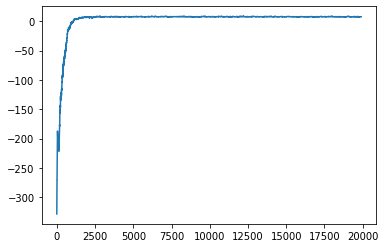

In [25]:
import matplotlib.pyplot as plt
windowed_rewards = np.convolve(rewards, np.ones(100)/100, 'valid')
plt.plot(windowed_rewards)
plt.show()

In [26]:
estimated_returns = Q
print(estimated_returns)
policySARSA = greedy_policy_from_returns_tbl(estimated_returns)
print (policySARSA)

            0         1         2         3         4         5
0    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
1   -3.239812 -3.273569 -3.192555 -3.208447  1.615104 -3.773301
2   -1.904010 -1.906655 -1.876487 -1.917580  7.705374 -1.909000
3   -2.877623 -2.928727 -2.824829 -1.717957  2.813026 -4.138841
4   -5.027052 -5.741159 -5.738697 -5.777271 -7.387517 -7.396642
..        ...       ...       ...       ...       ...       ...
495  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
496 -2.651137 -2.635197 -2.671057 -2.639181 -3.764431 -3.773517
497 -1.425974 -1.122600 -1.269584 -1.363905 -1.900000 -1.909000
498 -2.596542 -2.591912 -2.663803 -2.010318 -3.764710 -3.773726
499 -0.190000 -0.199000 -0.190000 -0.010000 -1.900000 -1.909000

[500 rows x 6 columns]
{0: 0, 1: 4, 2: 4, 3: 4, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 2, 13: 0, 14: 0, 15: 0, 16: 5, 17: 0, 18: 0, 19: 0, 20: 0, 21: 3, 22: 3, 23: 3, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 

##Policy validation following SARSA
- The penalties over 1000 episodes are shown in the output section.

In [53]:
import numpy as np
def follow_policy_SARSA(state):
    done = False
    accumulated_reward = 0
    penaltySeen = False

    #taxi.render()
    while not done:
        action = policySARSA[state]
        next_state, reward, done, info = taxi.step(action)
        accumulated_reward += reward
        
        if reward == -10:
            penaltySeen = True

        state = next_state
        #taxi.render()

    return accumulated_reward, penaltySeen

rewardsSARSA = []
penaltyCheck = False
totalPenalties = 0
n_episodes = 1000
for i in range(n_episodes):
  state = taxi.reset()
  total_reward, penaltyCheck = follow_policy_SARSA(state)
  rewardsSARSA.append(total_reward)
print (rewardsSARSA)
print ("Final mean score: %.3f" %(np.mean(rewardsSARSA)))
print ("There are %d penalties over the %d episodes of Taxi Runs." %(totalPenalties, n_episodes))


[5, 11, 8, 10, 7, 3, 13, 7, 13, 10, 7, 8, 8, 10, 9, 10, 6, 4, 9, 6, 12, 6, 3, 4, 12, 6, 7, 7, 13, 13, 9, 9, 5, 7, 5, 6, 8, 6, 10, 8, 12, 6, 12, 4, 9, 9, 10, 8, 6, 4, 11, 6, 7, 4, 5, 9, 9, 10, 7, 4, 9, 5, 9, 12, 8, 7, 11, 6, 9, 11, 5, 11, 13, 10, 12, 5, 7, 4, 11, 6, 14, 9, 12, 12, 6, 11, 10, 8, 8, 7, 4, 9, 3, 4, 10, 6, 10, 4, 11, 8, 9, 4, 7, 4, 11, 7, 7, 6, 8, 4, 8, 11, 5, 11, 9, 7, 10, 6, 9, 7, 7, 14, 9, 7, 7, 4, 13, 3, 8, 11, 7, 9, 13, 8, 8, 14, 11, 5, 5, 5, 11, 10, 9, 9, 8, 9, 9, 7, 6, 7, 6, 8, 5, 7, 9, 11, 9, 6, 9, 12, 8, 7, 10, 8, 10, 8, 5, 7, 5, 8, 4, 12, 6, 10, 10, 5, 10, 14, 7, 7, 9, 4, 5, 8, 9, 5, 10, 9, 11, 9, 10, 5, 5, 7, 7, 8, 8, 5, 10, 10, 6, 12, 8, 8, 4, 10, 8, 9, 6, 3, 7, 4, 6, 7, 4, 7, 5, 11, 4, 10, 4, 6, 10, 7, 5, 8, 6, 8, 7, 10, 10, 9, 11, 8, 10, 5, 11, 9, 11, 10, 3, 11, 11, 11, 7, 10, 10, 8, 4, 10, 11, 8, 8, 11, 11, 11, 8, 12, 10, 11, 9, 3, 10, 11, 10, 10, 5, 8, 10, 7, 7, 8, 10, 10, 7, 7, 4, 5, 6, 10, 7, 11, 10, 5, 12, 7, 5, 13, 6, 6, 5, 11, 5, 6, 10, 13, 6, 8, 8, 8, 

## Q-Learning Approach
- The 100-episode average reward with a 5th percentile and 95th percentile on the last 1000 episodes are shown in the output section.

In [56]:
#Q-learning algorithm
from tqdm import tqdm
import numpy as np
Q = pd.DataFrame.from_dict({s:{a:0 for a in range(taxi.action_space.n)} for s in range(taxi.observation_space.n)}, orient='index')

n_episodes = 20000
max_step_per_episode = taxi.spec.max_episode_steps
epsilon = 0.999
min_epsilon = 0.001
epsilon_decay= 0.005
alpha = 0.1
HYPER_PARAMS = {'gamma':0.90}
rewards = []
consecutive = 0

for i in tqdm(range(n_episodes)):
  state_t = taxi.reset()
  done = False
  total_reward = 0

  for step in range(max_step_per_episode):

    epsilon_greedy_action_t = epsilon_greedy_action_from_Q(Q,state_t,epsilon)
    state_t1, reward, done, info = taxi.step(epsilon_greedy_action_t)
    total_reward += reward
    
    max_return = Q.loc[state_t1].max()
    Q.loc[state_t,epsilon_greedy_action_t] += alpha*(reward + HYPER_PARAMS['gamma']*max_return - Q.loc[state_t,epsilon_greedy_action_t])

    state_t = state_t1

    if step + 1 >= max_step_per_episode:
        #print("Iteration %d - Timed out after %d steps with total reward = %f" %(i+1, step+1, total_reward))
        #print ("epsilon: %f, gamma: %f" %(epsilon, HYPER_PARAMS['gamma']))
        break
    elif done: 
        print("Iteration %d - Cleared after %d steps with total reward = %f" %(i+1, step, total_reward))
        #print ("epsilon: %f, gamma: %f" %(epsilon, HYPER_PARAMS['gamma']))
        break

  epsilon *= epsilon_decay
  epsilon = max(epsilon, min_epsilon)
  rewards.append (total_reward)

print ("Final mean score from 100 episodes: %.3f" %(np.mean(rewards[-100:])))
print ("Final mean score from 1000 episodes: %.3f" %(np.mean(rewards[-1000:])))
print ("Final mean score from 3000 episodes: %.3f" %(np.mean(rewards[-3000:])))

last1000Rewards = rewards[-1000:]
avgRewards = []
for i in range(len(last1000Rewards)-100):
  avgRewards.append(np.mean(last1000Rewards[i:i+100]))
#print (avgRewards)
print("5th percentile of rewards from running average : ", np.percentile(avgRewards, 5))
print("95th percentile of rewards from running average : ", np.percentile(avgRewards, 95))



  0%|          | 6/20000 [00:01<1:00:45,  5.49it/s]

Iteration 5 - Cleared after 192 steps with total reward = -415.000000



  0%|          | 13/20000 [00:02<1:05:53,  5.06it/s]

Iteration 12 - Cleared after 189 steps with total reward = -376.000000



  0%|          | 19/20000 [00:03<57:40,  5.77it/s]  

Iteration 18 - Cleared after 44 steps with total reward = -51.000000



  0%|          | 25/20000 [00:04<55:54,  5.95it/s]  

Iteration 24 - Cleared after 153 steps with total reward = -133.000000
Iteration 25 - Cleared after 113 steps with total reward = -93.000000



  0%|          | 36/20000 [00:06<53:07,  6.26it/s]


Iteration 35 - Cleared after 135 steps with total reward = -205.000000


  0%|          | 46/20000 [00:08<1:01:50,  5.38it/s]

Iteration 45 - Cleared after 142 steps with total reward = -221.000000



  0%|          | 49/20000 [00:09<57:20,  5.80it/s]

Iteration 48 - Cleared after 141 steps with total reward = -121.000000



  0%|          | 62/20000 [00:11<53:23,  6.22it/s]

Iteration 61 - Cleared after 118 steps with total reward = -98.000000



  0%|          | 67/20000 [00:12<48:36,  6.83it/s]


Iteration 65 - Cleared after 56 steps with total reward = -36.000000
Iteration 67 - Cleared after 150 steps with total reward = -220.000000


  0%|          | 76/20000 [00:13<56:42,  5.86it/s]

Iteration 76 - Cleared after 179 steps with total reward = -321.000000



  0%|          | 81/20000 [00:14<50:46,  6.54it/s]

Iteration 80 - Cleared after 111 steps with total reward = -127.000000



  0%|          | 83/20000 [00:14<55:21,  6.00it/s]

Iteration 83 - Cleared after 187 steps with total reward = -230.000000



  0%|          | 90/20000 [00:16<58:07,  5.71it/s]

Iteration 89 - Cleared after 140 steps with total reward = -138.000000



  0%|          | 92/20000 [00:16<1:02:01,  5.35it/s]

Iteration 92 - Cleared after 194 steps with total reward = -246.000000
Iteration 93 - Cleared after 79 steps with total reward = -59.000000



  0%|          | 97/20000 [00:17<58:33,  5.67it/s]


Iteration 97 - Cleared after 190 steps with total reward = -368.000000


  0%|          | 100/20000 [00:17<54:04,  6.13it/s] 


Iteration 99 - Cleared after 27 steps with total reward = -7.000000


  1%|          | 108/20000 [00:19<52:45,  6.28it/s]

Iteration 108 - Cleared after 105 steps with total reward = -94.000000



  1%|          | 111/20000 [00:19<52:32,  6.31it/s]

Iteration 110 - Cleared after 77 steps with total reward = -57.000000



  1%|          | 119/20000 [00:20<51:32,  6.43it/s]

Iteration 118 - Cleared after 33 steps with total reward = -49.000000



  1%|          | 123/20000 [00:21<46:02,  7.20it/s]

Iteration 121 - Cleared after 197 steps with total reward = -186.000000
Iteration 122 - Cleared after 36 steps with total reward = -16.000000
Iteration 123 - Cleared after 168 steps with total reward = -175.000000



  1%|          | 129/20000 [00:22<48:14,  6.86it/s]


Iteration 128 - Cleared after 122 steps with total reward = -111.000000
Iteration 129 - Cleared after 114 steps with total reward = -94.000000


  1%|          | 132/20000 [00:22<57:56,  5.71it/s]

Iteration 131 - Cleared after 194 steps with total reward = -336.000000
Iteration 132 - Cleared after 175 steps with total reward = -182.000000



  1%|          | 134/20000 [00:23<58:35,  5.65it/s]

Iteration 133 - Cleared after 142 steps with total reward = -212.000000



  1%|          | 141/20000 [00:24<51:20,  6.45it/s]


Iteration 140 - Cleared after 93 steps with total reward = -127.000000


  1%|          | 143/20000 [00:24<57:12,  5.78it/s]

Iteration 143 - Cleared after 178 steps with total reward = -158.000000



  1%|          | 145/20000 [00:25<59:36,  5.55it/s]  

Iteration 145 - Cleared after 171 steps with total reward = -169.000000



  1%|          | 149/20000 [00:25<56:44,  5.83it/s]

Iteration 148 - Cleared after 186 steps with total reward = -220.000000
Iteration 150 - Cleared after 23 steps with total reward = -12.000000



  1%|          | 153/20000 [00:26<47:00,  7.04it/s]

Iteration 152 - Cleared after 131 steps with total reward = -165.000000
Iteration 153 - Cleared after 181 steps with total reward = -251.000000



  1%|          | 158/20000 [00:27<47:44,  6.93it/s]


Iteration 157 - Cleared after 52 steps with total reward = -41.000000
Iteration 158 - Cleared after 165 steps with total reward = -217.000000


  1%|          | 161/20000 [00:27<43:15,  7.64it/s]

Iteration 160 - Cleared after 38 steps with total reward = -72.000000
Iteration 161 - Cleared after 44 steps with total reward = -24.000000



  1%|          | 164/20000 [00:27<46:24,  7.12it/s]

Iteration 163 - Cleared after 162 steps with total reward = -142.000000
Iteration 164 - Cleared after 193 steps with total reward = -209.000000
Iteration 165 - Cleared after 40 steps with total reward = -74.000000



  1%|          | 170/20000 [00:28<48:35,  6.80it/s]

Iteration 169 - Cleared after 159 steps with total reward = -139.000000



  1%|          | 171/20000 [00:28<53:42,  6.15it/s]


Iteration 171 - Cleared after 177 steps with total reward = -247.000000


  1%|          | 175/20000 [00:29<44:35,  7.41it/s]

Iteration 173 - Cleared after 46 steps with total reward = -44.000000
Iteration 174 - Cleared after 64 steps with total reward = -62.000000
Iteration 175 - Cleared after 90 steps with total reward = -79.000000



  1%|          | 179/20000 [00:29<49:10,  6.72it/s]

Iteration 178 - Cleared after 56 steps with total reward = -72.000000
Iteration 179 - Cleared after 175 steps with total reward = -155.000000



  1%|          | 185/20000 [00:30<53:01,  6.23it/s]

Iteration 184 - Cleared after 170 steps with total reward = -195.000000



  1%|          | 188/20000 [00:31<50:13,  6.57it/s]


Iteration 188 - Cleared after 119 steps with total reward = -297.000000
Iteration 189 - Cleared after 39 steps with total reward = -19.000000


  1%|          | 192/20000 [00:32<56:12,  5.87it/s]

Iteration 192 - Cleared after 182 steps with total reward = -207.000000
Iteration 193 - Cleared after 79 steps with total reward = -59.000000



  1%|          | 197/20000 [00:32<48:17,  6.84it/s]

Iteration 196 - Cleared after 160 steps with total reward = -176.000000
Iteration 197 - Cleared after 151 steps with total reward = -275.000000



  1%|          | 199/20000 [00:33<50:37,  6.52it/s]

Iteration 199 - Cleared after 159 steps with total reward = -202.000000



  1%|          | 203/20000 [00:33<50:47,  6.50it/s]


Iteration 202 - Cleared after 108 steps with total reward = -88.000000
Iteration 203 - Cleared after 157 steps with total reward = -146.000000


  1%|          | 206/20000 [00:34<55:05,  5.99it/s]

Iteration 205 - Cleared after 187 steps with total reward = -194.000000
Iteration 206 - Cleared after 195 steps with total reward = -175.000000



  1%|          | 208/20000 [00:34<50:52,  6.48it/s]

Iteration 207 - Cleared after 140 steps with total reward = -120.000000
Iteration 209 - Cleared after 40 steps with total reward = -20.000000



  1%|          | 210/20000 [00:34<41:57,  7.86it/s]

Iteration 210 - Cleared after 101 steps with total reward = -135.000000
Iteration 211 - Cleared after 37 steps with total reward = -17.000000
Iteration 212 - Cleared after 29 steps with total reward = -9.000000



  1%|          | 216/20000 [00:35<46:52,  7.03it/s]

Iteration 216 - Cleared after 178 steps with total reward = -302.000000
Iteration 217 - Cleared after 56 steps with total reward = -54.000000



  1%|          | 221/20000 [00:35<40:23,  8.16it/s]

Iteration 220 - Cleared after 39 steps with total reward = -19.000000
Iteration 221 - Cleared after 93 steps with total reward = -91.000000



  1%|          | 224/20000 [00:36<38:23,  8.59it/s]


Iteration 222 - Cleared after 155 steps with total reward = -225.000000
Iteration 223 - Cleared after 99 steps with total reward = -151.000000
Iteration 224 - Cleared after 113 steps with total reward = -201.000000


  1%|          | 229/20000 [00:36<41:45,  7.89it/s]

Iteration 227 - Cleared after 141 steps with total reward = -193.000000
Iteration 228 - Cleared after 22 steps with total reward = -2.000000
Iteration 229 - Cleared after 155 steps with total reward = -189.000000



  1%|          | 231/20000 [00:37<48:06,  6.85it/s]

Iteration 230 - Cleared after 169 steps with total reward = -221.000000



  1%|          | 234/20000 [00:37<51:41,  6.37it/s]

Iteration 233 - Cleared after 196 steps with total reward = -221.000000
Iteration 234 - Cleared after 198 steps with total reward = -277.000000



  1%|          | 236/20000 [00:37<49:50,  6.61it/s]

Iteration 235 - Cleared after 159 steps with total reward = -148.000000
Iteration 236 - Cleared after 148 steps with total reward = -164.000000



  1%|          | 237/20000 [00:38<48:38,  6.77it/s]

Iteration 237 - Cleared after 183 steps with total reward = -217.000000
Iteration 238 - Cleared after 42 steps with total reward = -94.000000



  1%|          | 241/20000 [00:38<51:44,  6.36it/s]

Iteration 240 - Cleared after 146 steps with total reward = -243.000000
Iteration 241 - Cleared after 177 steps with total reward = -193.000000



  1%|          | 243/20000 [00:38<43:54,  7.50it/s]

Iteration 242 - Cleared after 62 steps with total reward = -69.000000
Iteration 243 - Cleared after 88 steps with total reward = -86.000000



  1%|          | 244/20000 [00:39<50:05,  6.57it/s]

Iteration 244 - Cleared after 197 steps with total reward = -177.000000
Iteration 245 - Cleared after 36 steps with total reward = -16.000000



  1%|          | 248/20000 [00:39<45:02,  7.31it/s]


Iteration 247 - Cleared after 152 steps with total reward = -150.000000
Iteration 248 - Cleared after 109 steps with total reward = -179.000000
Iteration 249 - Cleared after 167 steps with total reward = -183.000000


  1%|▏         | 251/20000 [00:39<44:33,  7.39it/s]


Iteration 250 - Cleared after 41 steps with total reward = -39.000000
Iteration 251 - Cleared after 173 steps with total reward = -225.000000
Iteration 252 - Cleared after 102 steps with total reward = -82.000000


  1%|▏         | 254/20000 [00:40<49:51,  6.60it/s]

Iteration 253 - Cleared after 148 steps with total reward = -137.000000



  1%|▏         | 256/20000 [00:40<51:08,  6.44it/s]

Iteration 255 - Cleared after 118 steps with total reward = -134.000000



  1%|▏         | 258/20000 [00:40<44:14,  7.44it/s]

Iteration 257 - Cleared after 119 steps with total reward = -99.000000
Iteration 258 - Cleared after 109 steps with total reward = -107.000000



  1%|▏         | 260/20000 [00:41<45:51,  7.18it/s]

Iteration 259 - Cleared after 194 steps with total reward = -192.000000
Iteration 260 - Cleared after 115 steps with total reward = -95.000000



  1%|▏         | 263/20000 [00:41<54:48,  6.00it/s]

Iteration 262 - Cleared after 197 steps with total reward = -204.000000



  1%|▏         | 266/20000 [00:41<44:11,  7.44it/s]


Iteration 264 - Cleared after 40 steps with total reward = -20.000000
Iteration 265 - Cleared after 12 steps with total reward = 8.000000
Iteration 266 - Cleared after 138 steps with total reward = -190.000000
Iteration 267 - Cleared after 79 steps with total reward = -77.000000
Iteration 268 - Cleared after 130 steps with total reward = -200.000000


  1%|▏         | 270/20000 [00:42<47:49,  6.88it/s]

Iteration 269 - Cleared after 181 steps with total reward = -251.000000
Iteration 270 - Cleared after 145 steps with total reward = -134.000000



  1%|▏         | 273/20000 [00:42<47:48,  6.88it/s]


Iteration 272 - Cleared after 105 steps with total reward = -85.000000
Iteration 273 - Cleared after 155 steps with total reward = -135.000000
Iteration 274 - Cleared after 168 steps with total reward = -229.000000


  1%|▏         | 276/20000 [00:43<55:56,  5.88it/s]

Iteration 275 - Cleared after 149 steps with total reward = -147.000000



  1%|▏         | 278/20000 [00:43<45:22,  7.24it/s]

Iteration 277 - Cleared after 88 steps with total reward = -68.000000
Iteration 278 - Cleared after 79 steps with total reward = -77.000000
Iteration 279 - Cleared after 43 steps with total reward = -23.000000



  1%|▏         | 282/20000 [00:44<36:57,  8.89it/s]

Iteration 281 - Cleared after 78 steps with total reward = -94.000000
Iteration 282 - Cleared after 66 steps with total reward = -46.000000



  1%|▏         | 284/20000 [00:44<41:56,  7.83it/s]

Iteration 283 - Cleared after 168 steps with total reward = -148.000000



  1%|▏         | 286/20000 [00:44<44:58,  7.30it/s]

Iteration 285 - Cleared after 147 steps with total reward = -127.000000
Iteration 286 - Cleared after 181 steps with total reward = -197.000000



  1%|▏         | 288/20000 [00:45<51:32,  6.37it/s]

Iteration 287 - Cleared after 161 steps with total reward = -150.000000



  1%|▏         | 292/20000 [00:45<39:34,  8.30it/s]

Iteration 289 - Cleared after 116 steps with total reward = -96.000000
Iteration 290 - Cleared after 30 steps with total reward = -64.000000
Iteration 291 - Cleared after 31 steps with total reward = -11.000000
Iteration 292 - Cleared after 140 steps with total reward = -120.000000



  1%|▏         | 294/20000 [00:45<37:15,  8.81it/s]

Iteration 293 - Cleared after 33 steps with total reward = -13.000000
Iteration 294 - Cleared after 180 steps with total reward = -412.000000



  1%|▏         | 296/20000 [00:45<34:23,  9.55it/s]

Iteration 295 - Cleared after 179 steps with total reward = -285.000000
Iteration 296 - Cleared after 26 steps with total reward = -6.000000
Iteration 297 - Cleared after 119 steps with total reward = -153.000000



  2%|▏         | 302/20000 [00:46<43:31,  7.54it/s]

Iteration 301 - Cleared after 17 steps with total reward = 3.000000
Iteration 302 - Cleared after 119 steps with total reward = -135.000000



  2%|▏         | 306/20000 [00:46<35:07,  9.34it/s]

Iteration 303 - Cleared after 135 steps with total reward = -115.000000
Iteration 304 - Cleared after 126 steps with total reward = -160.000000
Iteration 305 - Cleared after 23 steps with total reward = -21.000000
Iteration 306 - Cleared after 121 steps with total reward = -119.000000



  2%|▏         | 311/20000 [00:47<28:57, 11.33it/s]

Iteration 307 - Cleared after 114 steps with total reward = -121.000000
Iteration 308 - Cleared after 103 steps with total reward = -119.000000
Iteration 309 - Cleared after 5 steps with total reward = 15.000000
Iteration 310 - Cleared after 27 steps with total reward = -7.000000
Iteration 311 - Cleared after 98 steps with total reward = -114.000000



  2%|▏         | 313/20000 [00:47<33:31,  9.79it/s]


Iteration 312 - Cleared after 197 steps with total reward = -339.000000
Iteration 313 - Cleared after 70 steps with total reward = -104.000000
Iteration 314 - Cleared after 96 steps with total reward = -94.000000
Iteration 315 - Cleared after 149 steps with total reward = -129.000000


  2%|▏         | 319/20000 [00:48<29:19, 11.18it/s]

Iteration 316 - Cleared after 94 steps with total reward = -74.000000
Iteration 317 - Cleared after 92 steps with total reward = -234.000000
Iteration 318 - Cleared after 8 steps with total reward = 12.000000
Iteration 319 - Cleared after 132 steps with total reward = -112.000000



  2%|▏         | 323/20000 [00:48<31:04, 10.56it/s]

Iteration 320 - Cleared after 124 steps with total reward = -140.000000
Iteration 321 - Cleared after 114 steps with total reward = -94.000000
Iteration 323 - Cleared after 5 steps with total reward = 15.000000



  2%|▏         | 325/20000 [00:48<30:09, 10.87it/s]

Iteration 324 - Cleared after 89 steps with total reward = -78.000000
Iteration 325 - Cleared after 81 steps with total reward = -115.000000
Iteration 326 - Cleared after 80 steps with total reward = -114.000000



  2%|▏         | 329/20000 [00:48<29:16, 11.20it/s]

Iteration 327 - Cleared after 142 steps with total reward = -140.000000
Iteration 328 - Cleared after 111 steps with total reward = -109.000000
Iteration 329 - Cleared after 10 steps with total reward = 10.000000



  2%|▏         | 331/20000 [00:49<26:45, 12.25it/s]

Iteration 330 - Cleared after 86 steps with total reward = -138.000000
Iteration 331 - Cleared after 31 steps with total reward = -11.000000
Iteration 332 - Cleared after 120 steps with total reward = -136.000000



  2%|▏         | 333/20000 [00:49<30:20, 10.81it/s]

Iteration 333 - Cleared after 95 steps with total reward = -84.000000



  2%|▏         | 337/20000 [00:49<30:11, 10.85it/s]

Iteration 335 - Cleared after 95 steps with total reward = -75.000000
Iteration 336 - Cleared after 135 steps with total reward = -187.000000
Iteration 337 - Cleared after 65 steps with total reward = -81.000000



  2%|▏         | 339/20000 [00:49<29:40, 11.04it/s]


Iteration 338 - Cleared after 49 steps with total reward = -29.000000
Iteration 339 - Cleared after 134 steps with total reward = -150.000000
Iteration 340 - Cleared after 71 steps with total reward = -123.000000
Iteration 341 - Cleared after 133 steps with total reward = -185.000000


  2%|▏         | 343/20000 [00:50<30:57, 10.58it/s]

Iteration 342 - Cleared after 129 steps with total reward = -127.000000
Iteration 343 - Cleared after 38 steps with total reward = -18.000000
Iteration 344 - Cleared after 27 steps with total reward = -7.000000
Iteration 345 - Cleared after 80 steps with total reward = -114.000000



  2%|▏         | 346/20000 [00:50<29:01, 11.29it/s]

Iteration 346 - Cleared after 170 steps with total reward = -222.000000
Iteration 347 - Cleared after 146 steps with total reward = -171.000000



  2%|▏         | 348/20000 [00:50<32:07, 10.20it/s]

Iteration 348 - Cleared after 86 steps with total reward = -84.000000
Iteration 349 - Cleared after 139 steps with total reward = -209.000000



  2%|▏         | 351/20000 [00:51<35:46,  9.15it/s]

Iteration 350 - Cleared after 107 steps with total reward = -159.000000
Iteration 351 - Cleared after 128 steps with total reward = -108.000000



  2%|▏         | 354/20000 [00:51<37:35,  8.71it/s]

Iteration 352 - Cleared after 145 steps with total reward = -251.000000
Iteration 353 - Cleared after 49 steps with total reward = -29.000000
Iteration 354 - Cleared after 176 steps with total reward = -228.000000



  2%|▏         | 356/20000 [00:51<34:57,  9.36it/s]

Iteration 355 - Cleared after 25 steps with total reward = -5.000000
Iteration 357 - Cleared after 68 steps with total reward = -48.000000



  2%|▏         | 360/20000 [00:51<27:40, 11.83it/s]


Iteration 358 - Cleared after 63 steps with total reward = -43.000000
Iteration 359 - Cleared after 6 steps with total reward = 14.000000
Iteration 360 - Cleared after 114 steps with total reward = -94.000000
Iteration 361 - Cleared after 55 steps with total reward = -53.000000
Iteration 362 - Cleared after 42 steps with total reward = -22.000000


  2%|▏         | 364/20000 [00:52<28:39, 11.42it/s]

Iteration 363 - Cleared after 129 steps with total reward = -145.000000
Iteration 364 - Cleared after 87 steps with total reward = -85.000000



  2%|▏         | 366/20000 [00:52<34:12,  9.57it/s]

Iteration 366 - Cleared after 154 steps with total reward = -152.000000
Iteration 367 - Cleared after 56 steps with total reward = -54.000000



  2%|▏         | 370/20000 [00:52<32:52,  9.95it/s]

Iteration 368 - Cleared after 137 steps with total reward = -153.000000
Iteration 369 - Cleared after 50 steps with total reward = -30.000000
Iteration 370 - Cleared after 129 steps with total reward = -109.000000



  2%|▏         | 372/20000 [00:53<30:10, 10.84it/s]

Iteration 371 - Cleared after 35 steps with total reward = -15.000000
Iteration 372 - Cleared after 118 steps with total reward = -98.000000
Iteration 373 - Cleared after 96 steps with total reward = -76.000000



  2%|▏         | 374/20000 [00:53<34:15,  9.55it/s]


Iteration 374 - Cleared after 156 steps with total reward = -190.000000
Iteration 375 - Cleared after 161 steps with total reward = -159.000000
Iteration 376 - Cleared after 65 steps with total reward = -81.000000


  2%|▏         | 378/20000 [00:53<42:30,  7.69it/s]

Iteration 377 - Cleared after 118 steps with total reward = -116.000000
Iteration 378 - Cleared after 148 steps with total reward = -146.000000



  2%|▏         | 380/20000 [00:54<44:52,  7.29it/s]

Iteration 379 - Cleared after 154 steps with total reward = -161.000000
Iteration 380 - Cleared after 148 steps with total reward = -218.000000
Iteration 381 - Cleared after 49 steps with total reward = -65.000000



  2%|▏         | 382/20000 [00:54<36:59,  8.84it/s]


Iteration 382 - Cleared after 67 steps with total reward = -65.000000
Iteration 383 - Cleared after 106 steps with total reward = -95.000000
Iteration 384 - Cleared after 81 steps with total reward = -61.000000


  2%|▏         | 386/20000 [00:54<37:48,  8.65it/s]

Iteration 385 - Cleared after 198 steps with total reward = -187.000000
Iteration 386 - Cleared after 96 steps with total reward = -76.000000



  2%|▏         | 388/20000 [00:54<41:20,  7.91it/s]

Iteration 387 - Cleared after 137 steps with total reward = -126.000000
Iteration 388 - Cleared after 124 steps with total reward = -158.000000



  2%|▏         | 390/20000 [00:55<42:51,  7.63it/s]

Iteration 389 - Cleared after 158 steps with total reward = -228.000000
Iteration 390 - Cleared after 99 steps with total reward = -79.000000



  2%|▏         | 392/20000 [00:55<49:47,  6.56it/s]

Iteration 391 - Cleared after 163 steps with total reward = -233.000000



  2%|▏         | 397/20000 [00:55<40:33,  8.06it/s]

Iteration 394 - Cleared after 65 steps with total reward = -45.000000
Iteration 395 - Cleared after 5 steps with total reward = 15.000000
Iteration 396 - Cleared after 17 steps with total reward = 3.000000
Iteration 397 - Cleared after 107 steps with total reward = -87.000000
Iteration 398 - Cleared after 61 steps with total reward = -77.000000



  2%|▏         | 403/20000 [00:56<27:13, 11.99it/s]

Iteration 399 - Cleared after 46 steps with total reward = -26.000000
Iteration 400 - Cleared after 7 steps with total reward = 13.000000
Iteration 401 - Cleared after 43 steps with total reward = -23.000000
Iteration 402 - Cleared after 29 steps with total reward = -9.000000
Iteration 403 - Cleared after 54 steps with total reward = -34.000000



  2%|▏         | 407/20000 [00:56<25:11, 12.97it/s]

Iteration 404 - Cleared after 105 steps with total reward = -148.000000
Iteration 405 - Cleared after 102 steps with total reward = -208.000000
Iteration 406 - Cleared after 14 steps with total reward = 6.000000
Iteration 407 - Cleared after 82 steps with total reward = -80.000000



  2%|▏         | 411/20000 [00:56<26:37, 12.26it/s]


Iteration 408 - Cleared after 126 steps with total reward = -106.000000
Iteration 409 - Cleared after 67 steps with total reward = -47.000000
Iteration 410 - Cleared after 23 steps with total reward = -3.000000
Iteration 411 - Cleared after 154 steps with total reward = -152.000000
Iteration 412 - Cleared after 93 steps with total reward = -73.000000
Iteration 413 - Cleared after 153 steps with total reward = -151.000000


  2%|▏         | 416/20000 [00:57<25:21, 12.87it/s]

Iteration 414 - Cleared after 19 steps with total reward = 1.000000
Iteration 415 - Cleared after 65 steps with total reward = -45.000000
Iteration 416 - Cleared after 32 steps with total reward = -12.000000
Iteration 417 - Cleared after 98 steps with total reward = -150.000000



  2%|▏         | 420/20000 [00:57<29:13, 11.17it/s]

Iteration 418 - Cleared after 108 steps with total reward = -97.000000
Iteration 419 - Cleared after 57 steps with total reward = -37.000000
Iteration 420 - Cleared after 144 steps with total reward = -124.000000



  2%|▏         | 422/20000 [00:57<27:43, 11.77it/s]

Iteration 421 - Cleared after 6 steps with total reward = 14.000000
Iteration 422 - Cleared after 163 steps with total reward = -143.000000



  2%|▏         | 426/20000 [00:58<33:43,  9.67it/s]

Iteration 423 - Cleared after 147 steps with total reward = -163.000000
Iteration 424 - Cleared after 182 steps with total reward = -162.000000
Iteration 425 - Cleared after 28 steps with total reward = -8.000000
Iteration 426 - Cleared after 164 steps with total reward = -216.000000



  2%|▏         | 430/20000 [00:58<28:18, 11.52it/s]

Iteration 427 - Cleared after 24 steps with total reward = -4.000000
Iteration 428 - Cleared after 102 steps with total reward = -82.000000
Iteration 429 - Cleared after 44 steps with total reward = -24.000000
Iteration 430 - Cleared after 94 steps with total reward = -146.000000



  2%|▏         | 434/20000 [00:58<27:23, 11.91it/s]

Iteration 431 - Cleared after 119 steps with total reward = -108.000000
Iteration 432 - Cleared after 124 steps with total reward = -104.000000
Iteration 433 - Cleared after 111 steps with total reward = -199.000000
Iteration 434 - Cleared after 39 steps with total reward = -28.000000
Iteration 435 - Cleared after 96 steps with total reward = -94.000000



  2%|▏         | 440/20000 [00:59<24:04, 13.54it/s]

Iteration 436 - Cleared after 22 steps with total reward = -2.000000
Iteration 437 - Cleared after 31 steps with total reward = -20.000000
Iteration 438 - Cleared after 69 steps with total reward = -49.000000
Iteration 439 - Cleared after 106 steps with total reward = -86.000000
Iteration 440 - Cleared after 30 steps with total reward = -19.000000



  2%|▏         | 442/20000 [00:59<22:17, 14.62it/s]

Iteration 441 - Cleared after 83 steps with total reward = -63.000000
Iteration 442 - Cleared after 28 steps with total reward = -8.000000
Iteration 443 - Cleared after 92 steps with total reward = -72.000000



  2%|▏         | 444/20000 [00:59<27:43, 11.76it/s]


Iteration 444 - Cleared after 169 steps with total reward = -167.000000
Iteration 445 - Cleared after 82 steps with total reward = -62.000000
Iteration 446 - Cleared after 125 steps with total reward = -114.000000


  2%|▏         | 451/20000 [01:00<27:24, 11.89it/s]

Iteration 447 - Cleared after 141 steps with total reward = -211.000000
Iteration 448 - Cleared after 16 steps with total reward = 4.000000
Iteration 449 - Cleared after 80 steps with total reward = -114.000000
Iteration 450 - Cleared after 19 steps with total reward = 1.000000
Iteration 451 - Cleared after 106 steps with total reward = -86.000000



  2%|▏         | 455/20000 [01:00<25:44, 12.65it/s]

Iteration 452 - Cleared after 139 steps with total reward = -119.000000
Iteration 453 - Cleared after 15 steps with total reward = 5.000000
Iteration 454 - Cleared after 32 steps with total reward = -12.000000
Iteration 455 - Cleared after 94 steps with total reward = -74.000000



  2%|▏         | 457/20000 [01:00<26:40, 12.21it/s]

Iteration 456 - Cleared after 75 steps with total reward = -55.000000
Iteration 457 - Cleared after 108 steps with total reward = -97.000000
Iteration 458 - Cleared after 75 steps with total reward = -73.000000



  2%|▏         | 461/20000 [01:01<28:03, 11.61it/s]

Iteration 459 - Cleared after 78 steps with total reward = -76.000000
Iteration 460 - Cleared after 51 steps with total reward = -31.000000
Iteration 461 - Cleared after 120 steps with total reward = -154.000000
Iteration 462 - Cleared after 61 steps with total reward = -41.000000



  2%|▏         | 465/20000 [01:01<30:05, 10.82it/s]


Iteration 463 - Cleared after 169 steps with total reward = -266.000000
Iteration 464 - Cleared after 82 steps with total reward = -80.000000
Iteration 465 - Cleared after 97 steps with total reward = -77.000000
Iteration 466 - Cleared after 57 steps with total reward = -55.000000
Iteration 467 - Cleared after 37 steps with total reward = -17.000000


  2%|▏         | 471/20000 [01:01<27:56, 11.65it/s]

Iteration 468 - Cleared after 128 steps with total reward = -198.000000
Iteration 469 - Cleared after 11 steps with total reward = 9.000000
Iteration 470 - Cleared after 71 steps with total reward = -51.000000
Iteration 471 - Cleared after 105 steps with total reward = -85.000000



  2%|▏         | 475/20000 [01:02<25:14, 12.89it/s]

Iteration 472 - Cleared after 94 steps with total reward = -164.000000
Iteration 473 - Cleared after 6 steps with total reward = 14.000000
Iteration 474 - Cleared after 140 steps with total reward = -318.000000
Iteration 475 - Cleared after 31 steps with total reward = -11.000000



  2%|▏         | 478/20000 [01:02<22:30, 14.46it/s]

Iteration 476 - Cleared after 39 steps with total reward = -19.000000
Iteration 477 - Cleared after 49 steps with total reward = -29.000000
Iteration 478 - Cleared after 66 steps with total reward = -46.000000
Iteration 479 - Cleared after 96 steps with total reward = -76.000000



  2%|▏         | 484/20000 [01:02<25:21, 12.83it/s]

Iteration 480 - Cleared after 116 steps with total reward = -96.000000
Iteration 481 - Cleared after 83 steps with total reward = -63.000000
Iteration 482 - Cleared after 76 steps with total reward = -56.000000
Iteration 483 - Cleared after 14 steps with total reward = 6.000000
Iteration 484 - Cleared after 123 steps with total reward = -112.000000



  2%|▏         | 489/20000 [01:03<21:08, 15.38it/s]

Iteration 485 - Cleared after 60 steps with total reward = -40.000000
Iteration 486 - Cleared after 65 steps with total reward = -45.000000
Iteration 487 - Cleared after 69 steps with total reward = -49.000000
Iteration 488 - Cleared after 8 steps with total reward = 12.000000
Iteration 489 - Cleared after 74 steps with total reward = -54.000000
Iteration 490 - Cleared after 15 steps with total reward = 5.000000



  2%|▏         | 493/20000 [01:03<23:29, 13.84it/s]

Iteration 491 - Cleared after 136 steps with total reward = -116.000000
Iteration 492 - Cleared after 41 steps with total reward = -21.000000
Iteration 493 - Cleared after 145 steps with total reward = -179.000000



  2%|▏         | 497/20000 [01:03<25:04, 12.97it/s]

Iteration 494 - Cleared after 51 steps with total reward = -67.000000
Iteration 495 - Cleared after 57 steps with total reward = -37.000000
Iteration 496 - Cleared after 147 steps with total reward = -136.000000
Iteration 497 - Cleared after 107 steps with total reward = -258.000000



  2%|▏         | 499/20000 [01:03<24:31, 13.25it/s]

Iteration 498 - Cleared after 49 steps with total reward = -47.000000
Iteration 499 - Cleared after 108 steps with total reward = -88.000000
Iteration 500 - Cleared after 60 steps with total reward = -40.000000



  3%|▎         | 504/20000 [01:04<20:51, 15.58it/s]

Iteration 501 - Cleared after 88 steps with total reward = -86.000000
Iteration 502 - Cleared after 47 steps with total reward = -27.000000
Iteration 503 - Cleared after 45 steps with total reward = -25.000000
Iteration 504 - Cleared after 70 steps with total reward = -122.000000



  3%|▎         | 506/20000 [01:04<20:11, 16.09it/s]


Iteration 505 - Cleared after 48 steps with total reward = -28.000000
Iteration 506 - Cleared after 61 steps with total reward = -77.000000
Iteration 507 - Cleared after 157 steps with total reward = -146.000000
Iteration 508 - Cleared after 48 steps with total reward = -28.000000


  3%|▎         | 510/20000 [01:04<24:47, 13.11it/s]

Iteration 509 - Cleared after 74 steps with total reward = -54.000000
Iteration 510 - Cleared after 113 steps with total reward = -93.000000
Iteration 511 - Cleared after 26 steps with total reward = -6.000000



  3%|▎         | 515/20000 [01:04<21:54, 14.83it/s]

Iteration 512 - Cleared after 140 steps with total reward = -246.000000
Iteration 513 - Cleared after 13 steps with total reward = 7.000000
Iteration 514 - Cleared after 51 steps with total reward = -67.000000
Iteration 515 - Cleared after 59 steps with total reward = -39.000000
Iteration 516 - Cleared after 29 steps with total reward = -9.000000



  3%|▎         | 520/20000 [01:05<18:26, 17.60it/s]

Iteration 517 - Cleared after 57 steps with total reward = -37.000000
Iteration 518 - Cleared after 12 steps with total reward = 8.000000
Iteration 519 - Cleared after 20 steps with total reward = -18.000000
Iteration 520 - Cleared after 101 steps with total reward = -81.000000
Iteration 521 - Cleared after 36 steps with total reward = -16.000000



  3%|▎         | 524/20000 [01:05<23:57, 13.55it/s]

Iteration 522 - Cleared after 118 steps with total reward = -206.000000
Iteration 523 - Cleared after 135 steps with total reward = -205.000000
Iteration 524 - Cleared after 76 steps with total reward = -92.000000



  3%|▎         | 528/20000 [01:05<25:34, 12.69it/s]

Iteration 525 - Cleared after 83 steps with total reward = -117.000000
Iteration 526 - Cleared after 74 steps with total reward = -54.000000
Iteration 527 - Cleared after 162 steps with total reward = -205.000000
Iteration 528 - Cleared after 11 steps with total reward = 9.000000



  3%|▎         | 533/20000 [01:06<21:16, 15.25it/s]


Iteration 529 - Cleared after 10 steps with total reward = 10.000000
Iteration 530 - Cleared after 104 steps with total reward = -120.000000
Iteration 531 - Cleared after 9 steps with total reward = 11.000000
Iteration 532 - Cleared after 27 steps with total reward = -7.000000
Iteration 533 - Cleared after 72 steps with total reward = -70.000000
Iteration 534 - Cleared after 28 steps with total reward = -8.000000
Iteration 535 - Cleared after 17 steps with total reward = 3.000000
Iteration 536 - Cleared after 100 steps with total reward = -116.000000


  3%|▎         | 541/20000 [01:06<18:19, 17.71it/s]

Iteration 537 - Cleared after 95 steps with total reward = -147.000000
Iteration 538 - Cleared after 7 steps with total reward = 13.000000
Iteration 539 - Cleared after 12 steps with total reward = 8.000000
Iteration 540 - Cleared after 27 steps with total reward = -7.000000
Iteration 541 - Cleared after 78 steps with total reward = -58.000000



  3%|▎         | 545/20000 [01:06<23:53, 13.57it/s]

Iteration 542 - Cleared after 126 steps with total reward = -160.000000
Iteration 543 - Cleared after 48 steps with total reward = -28.000000
Iteration 544 - Cleared after 72 steps with total reward = -52.000000
Iteration 545 - Cleared after 86 steps with total reward = -156.000000
Iteration 546 - Cleared after 7 steps with total reward = 13.000000



  3%|▎         | 549/20000 [01:07<19:38, 16.50it/s]

Iteration 547 - Cleared after 10 steps with total reward = 10.000000
Iteration 548 - Cleared after 49 steps with total reward = -47.000000
Iteration 549 - Cleared after 39 steps with total reward = -37.000000
Iteration 550 - Cleared after 74 steps with total reward = -72.000000



  3%|▎         | 554/20000 [01:07<20:17, 15.97it/s]


Iteration 551 - Cleared after 114 steps with total reward = -112.000000
Iteration 552 - Cleared after 47 steps with total reward = -27.000000
Iteration 553 - Cleared after 8 steps with total reward = 12.000000
Iteration 554 - Cleared after 76 steps with total reward = -56.000000
Iteration 555 - Cleared after 84 steps with total reward = -64.000000
Iteration 556 - Cleared after 10 steps with total reward = 10.000000
Iteration 557 - Cleared after 100 steps with total reward = -98.000000


  3%|▎         | 562/20000 [01:07<17:15, 18.78it/s]

Iteration 558 - Cleared after 42 steps with total reward = -58.000000
Iteration 559 - Cleared after 48 steps with total reward = -28.000000
Iteration 560 - Cleared after 53 steps with total reward = -69.000000
Iteration 561 - Cleared after 9 steps with total reward = 11.000000
Iteration 562 - Cleared after 41 steps with total reward = -21.000000
Iteration 563 - Cleared after 19 steps with total reward = -17.000000
Iteration 564 - Cleared after 31 steps with total reward = -29.000000



  3%|▎         | 568/20000 [01:08<16:58, 19.09it/s]

Iteration 565 - Cleared after 49 steps with total reward = -29.000000
Iteration 566 - Cleared after 114 steps with total reward = -94.000000
Iteration 567 - Cleared after 12 steps with total reward = 8.000000
Iteration 568 - Cleared after 28 steps with total reward = -8.000000
Iteration 569 - Cleared after 26 steps with total reward = -6.000000



  3%|▎         | 570/20000 [01:08<20:03, 16.15it/s]

Iteration 570 - Cleared after 112 steps with total reward = -110.000000
Iteration 571 - Cleared after 16 steps with total reward = -5.000000
Iteration 572 - Cleared after 51 steps with total reward = -76.000000



  3%|▎         | 575/20000 [01:08<24:16, 13.33it/s]

Iteration 573 - Cleared after 158 steps with total reward = -192.000000
Iteration 574 - Cleared after 166 steps with total reward = -164.000000
Iteration 575 - Cleared after 9 steps with total reward = 11.000000



  3%|▎         | 579/20000 [01:08<19:28, 16.62it/s]

Iteration 576 - Cleared after 8 steps with total reward = 12.000000
Iteration 577 - Cleared after 9 steps with total reward = 11.000000
Iteration 578 - Cleared after 20 steps with total reward = 0.000000
Iteration 579 - Cleared after 58 steps with total reward = -38.000000
Iteration 580 - Cleared after 121 steps with total reward = -155.000000
Iteration 581 - Cleared after 26 steps with total reward = -24.000000


  3%|▎         | 585/20000 [01:09<17:35, 18.40it/s]


Iteration 582 - Cleared after 52 steps with total reward = -32.000000
Iteration 583 - Cleared after 33 steps with total reward = -49.000000
Iteration 584 - Cleared after 18 steps with total reward = -16.000000
Iteration 585 - Cleared after 35 steps with total reward = -33.000000
Iteration 586 - Cleared after 78 steps with total reward = -58.000000



  3%|▎         | 588/20000 [01:09<16:26, 19.69it/s]

Iteration 587 - Cleared after 22 steps with total reward = -2.000000
Iteration 588 - Cleared after 20 steps with total reward = 0.000000
Iteration 589 - Cleared after 75 steps with total reward = -55.000000
Iteration 590 - Cleared after 67 steps with total reward = -47.000000



  3%|▎         | 593/20000 [01:09<20:55, 15.46it/s]

Iteration 591 - Cleared after 142 steps with total reward = -122.000000
Iteration 592 - Cleared after 129 steps with total reward = -235.000000
Iteration 593 - Cleared after 21 steps with total reward = -1.000000
Iteration 594 - Cleared after 14 steps with total reward = 6.000000
Iteration 595 - Cleared after 18 steps with total reward = 2.000000
Iteration 596 - Cleared after 13 steps with total reward = 7.000000
Iteration 597 - Cleared after 13 steps with total reward = 7.000000
Iteration 598 - Cleared after 6 steps with total reward = 14.000000



  3%|▎         | 602/20000 [01:09<18:01, 17.94it/s]

Iteration 599 - Cleared after 78 steps with total reward = -58.000000
Iteration 600 - Cleared after 9 steps with total reward = 11.000000
Iteration 601 - Cleared after 66 steps with total reward = -46.000000
Iteration 602 - Cleared after 94 steps with total reward = -74.000000



  3%|▎         | 605/20000 [01:10<19:26, 16.62it/s]

Iteration 603 - Cleared after 80 steps with total reward = -60.000000
Iteration 604 - Cleared after 32 steps with total reward = -12.000000
Iteration 605 - Cleared after 93 steps with total reward = -73.000000
Iteration 606 - Cleared after 66 steps with total reward = -46.000000



  3%|▎         | 613/20000 [01:10<16:58, 19.04it/s]

Iteration 607 - Cleared after 96 steps with total reward = -220.000000
Iteration 608 - Cleared after 13 steps with total reward = -11.000000
Iteration 609 - Cleared after 9 steps with total reward = 11.000000
Iteration 610 - Cleared after 12 steps with total reward = 8.000000
Iteration 611 - Cleared after 65 steps with total reward = -81.000000
Iteration 612 - Cleared after 21 steps with total reward = -1.000000
Iteration 613 - Cleared after 99 steps with total reward = -97.000000



  3%|▎         | 616/20000 [01:10<17:15, 18.72it/s]

Iteration 614 - Cleared after 22 steps with total reward = -2.000000
Iteration 615 - Cleared after 70 steps with total reward = -122.000000
Iteration 616 - Cleared after 75 steps with total reward = -55.000000
Iteration 617 - Cleared after 59 steps with total reward = -111.000000



  3%|▎         | 622/20000 [01:11<18:32, 17.41it/s]

Iteration 618 - Cleared after 113 steps with total reward = -93.000000
Iteration 619 - Cleared after 36 steps with total reward = -52.000000
Iteration 620 - Cleared after 95 steps with total reward = -75.000000
Iteration 621 - Cleared after 8 steps with total reward = 12.000000
Iteration 622 - Cleared after 44 steps with total reward = -60.000000



  3%|▎         | 629/20000 [01:11<14:00, 23.05it/s]

Iteration 623 - Cleared after 43 steps with total reward = -50.000000
Iteration 624 - Cleared after 11 steps with total reward = 9.000000
Iteration 625 - Cleared after 57 steps with total reward = -37.000000
Iteration 626 - Cleared after 38 steps with total reward = -36.000000
Iteration 627 - Cleared after 10 steps with total reward = 10.000000
Iteration 628 - Cleared after 34 steps with total reward = -14.000000
Iteration 629 - Cleared after 10 steps with total reward = 10.000000
Iteration 630 - Cleared after 9 steps with total reward = 11.000000



  3%|▎         | 635/20000 [01:11<15:04, 21.41it/s]

Iteration 631 - Cleared after 75 steps with total reward = -73.000000
Iteration 632 - Cleared after 94 steps with total reward = -74.000000
Iteration 633 - Cleared after 16 steps with total reward = 4.000000
Iteration 634 - Cleared after 65 steps with total reward = -63.000000
Iteration 635 - Cleared after 21 steps with total reward = -19.000000



  3%|▎         | 642/20000 [01:11<13:29, 23.92it/s]

Iteration 636 - Cleared after 109 steps with total reward = -89.000000
Iteration 637 - Cleared after 9 steps with total reward = 11.000000
Iteration 638 - Cleared after 30 steps with total reward = -10.000000
Iteration 639 - Cleared after 42 steps with total reward = -22.000000
Iteration 640 - Cleared after 25 steps with total reward = -23.000000
Iteration 641 - Cleared after 31 steps with total reward = -11.000000
Iteration 642 - Cleared after 7 steps with total reward = 13.000000
Iteration 643 - Cleared after 30 steps with total reward = -10.000000



  3%|▎         | 651/20000 [01:12<13:18, 24.24it/s]

Iteration 644 - Cleared after 67 steps with total reward = -65.000000
Iteration 645 - Cleared after 78 steps with total reward = -85.000000
Iteration 646 - Cleared after 9 steps with total reward = 11.000000
Iteration 647 - Cleared after 18 steps with total reward = 2.000000
Iteration 648 - Cleared after 10 steps with total reward = 10.000000
Iteration 649 - Cleared after 9 steps with total reward = 11.000000
Iteration 650 - Cleared after 23 steps with total reward = -3.000000
Iteration 651 - Cleared after 107 steps with total reward = -87.000000



  3%|▎         | 654/20000 [01:12<13:17, 24.25it/s]

Iteration 652 - Cleared after 67 steps with total reward = -47.000000
Iteration 653 - Cleared after 29 steps with total reward = -9.000000
Iteration 654 - Cleared after 44 steps with total reward = -42.000000
Iteration 655 - Cleared after 74 steps with total reward = -72.000000
Iteration 656 - Cleared after 62 steps with total reward = -51.000000



  3%|▎         | 657/20000 [01:12<15:37, 20.64it/s]

Iteration 657 - Cleared after 61 steps with total reward = -41.000000
Iteration 658 - Cleared after 134 steps with total reward = -114.000000



  3%|▎         | 663/20000 [01:12<18:03, 17.85it/s]

Iteration 659 - Cleared after 122 steps with total reward = -111.000000
Iteration 660 - Cleared after 43 steps with total reward = -23.000000
Iteration 661 - Cleared after 38 steps with total reward = -18.000000
Iteration 662 - Cleared after 22 steps with total reward = -2.000000
Iteration 663 - Cleared after 75 steps with total reward = -64.000000



  3%|▎         | 670/20000 [01:13<13:52, 23.22it/s]

Iteration 664 - Cleared after 8 steps with total reward = 12.000000
Iteration 665 - Cleared after 8 steps with total reward = 12.000000
Iteration 666 - Cleared after 66 steps with total reward = -46.000000
Iteration 667 - Cleared after 12 steps with total reward = 8.000000
Iteration 668 - Cleared after 74 steps with total reward = -54.000000
Iteration 669 - Cleared after 16 steps with total reward = 4.000000
Iteration 670 - Cleared after 22 steps with total reward = -2.000000



  3%|▎         | 679/20000 [01:13<11:09, 28.88it/s]

Iteration 671 - Cleared after 38 steps with total reward = -18.000000
Iteration 672 - Cleared after 25 steps with total reward = -5.000000
Iteration 673 - Cleared after 24 steps with total reward = -4.000000
Iteration 674 - Cleared after 8 steps with total reward = 12.000000
Iteration 675 - Cleared after 28 steps with total reward = -17.000000
Iteration 676 - Cleared after 10 steps with total reward = 10.000000
Iteration 677 - Cleared after 31 steps with total reward = -11.000000
Iteration 678 - Cleared after 6 steps with total reward = 14.000000
Iteration 679 - Cleared after 60 steps with total reward = -40.000000



  3%|▎         | 683/20000 [01:13<12:13, 26.35it/s]


Iteration 680 - Cleared after 38 steps with total reward = -36.000000
Iteration 681 - Cleared after 9 steps with total reward = 11.000000
Iteration 682 - Cleared after 57 steps with total reward = -37.000000
Iteration 683 - Cleared after 48 steps with total reward = -28.000000
Iteration 684 - Cleared after 114 steps with total reward = -112.000000
Iteration 685 - Cleared after 15 steps with total reward = 5.000000
Iteration 686 - Cleared after 5 steps with total reward = 15.000000


  3%|▎         | 689/20000 [01:13<13:47, 23.33it/s]


Iteration 687 - Cleared after 9 steps with total reward = 11.000000
Iteration 688 - Cleared after 80 steps with total reward = -60.000000
Iteration 689 - Cleared after 13 steps with total reward = 7.000000
Iteration 690 - Cleared after 21 steps with total reward = -1.000000
Iteration 691 - Cleared after 43 steps with total reward = -23.000000
Iteration 692 - Cleared after 14 steps with total reward = 6.000000
Iteration 693 - Cleared after 78 steps with total reward = -112.000000


  3%|▎         | 697/20000 [01:14<12:14, 26.28it/s]

Iteration 694 - Cleared after 18 steps with total reward = 2.000000
Iteration 695 - Cleared after 36 steps with total reward = -16.000000
Iteration 696 - Cleared after 27 steps with total reward = -7.000000
Iteration 697 - Cleared after 24 steps with total reward = -4.000000
Iteration 698 - Cleared after 61 steps with total reward = -41.000000
Iteration 699 - Cleared after 20 steps with total reward = 0.000000
Iteration 700 - Cleared after 8 steps with total reward = 12.000000
Iteration 701 - Cleared after 61 steps with total reward = -59.000000



  4%|▎         | 704/20000 [01:14<14:23, 22.35it/s]

Iteration 702 - Cleared after 51 steps with total reward = -31.000000
Iteration 703 - Cleared after 87 steps with total reward = -67.000000
Iteration 704 - Cleared after 51 steps with total reward = -31.000000



  4%|▎         | 710/20000 [01:14<14:04, 22.85it/s]

Iteration 705 - Cleared after 65 steps with total reward = -54.000000
Iteration 706 - Cleared after 16 steps with total reward = -14.000000
Iteration 707 - Cleared after 34 steps with total reward = -14.000000
Iteration 708 - Cleared after 31 steps with total reward = -47.000000
Iteration 709 - Cleared after 76 steps with total reward = -74.000000
Iteration 710 - Cleared after 11 steps with total reward = 9.000000



  4%|▎         | 713/20000 [01:14<15:20, 20.96it/s]


Iteration 711 - Cleared after 61 steps with total reward = -113.000000
Iteration 712 - Cleared after 47 steps with total reward = -45.000000
Iteration 713 - Cleared after 78 steps with total reward = -58.000000
Iteration 714 - Cleared after 28 steps with total reward = -8.000000
Iteration 715 - Cleared after 10 steps with total reward = 10.000000
Iteration 716 - Cleared after 28 steps with total reward = -26.000000
Iteration 717 - Cleared after 23 steps with total reward = -3.000000


  4%|▎         | 720/20000 [01:15<12:43, 25.25it/s]

Iteration 718 - Cleared after 7 steps with total reward = 13.000000
Iteration 719 - Cleared after 71 steps with total reward = -51.000000
Iteration 720 - Cleared after 14 steps with total reward = 6.000000
Iteration 721 - Cleared after 71 steps with total reward = -60.000000
Iteration 722 - Cleared after 8 steps with total reward = 12.000000
Iteration 723 - Cleared after 11 steps with total reward = 9.000000



  4%|▎         | 727/20000 [01:15<12:00, 26.74it/s]


Iteration 724 - Cleared after 57 steps with total reward = -55.000000
Iteration 725 - Cleared after 61 steps with total reward = -41.000000
Iteration 726 - Cleared after 46 steps with total reward = -26.000000
Iteration 727 - Cleared after 9 steps with total reward = 11.000000
Iteration 728 - Cleared after 27 steps with total reward = -16.000000
Iteration 729 - Cleared after 18 steps with total reward = 2.000000
Iteration 730 - Cleared after 29 steps with total reward = -9.000000
Iteration 731 - Cleared after 20 steps with total reward = 0.000000


  4%|▎         | 738/20000 [01:15<13:49, 23.22it/s]

Iteration 732 - Cleared after 134 steps with total reward = -294.000000
Iteration 733 - Cleared after 18 steps with total reward = 2.000000
Iteration 734 - Cleared after 7 steps with total reward = 13.000000
Iteration 735 - Cleared after 35 steps with total reward = -15.000000
Iteration 736 - Cleared after 18 steps with total reward = 2.000000
Iteration 737 - Cleared after 106 steps with total reward = -104.000000
Iteration 738 - Cleared after 9 steps with total reward = 11.000000
Iteration 739 - Cleared after 53 steps with total reward = -33.000000



  4%|▎         | 747/20000 [01:16<13:29, 23.77it/s]

Iteration 740 - Cleared after 53 steps with total reward = -33.000000
Iteration 741 - Cleared after 10 steps with total reward = 10.000000
Iteration 742 - Cleared after 8 steps with total reward = 12.000000
Iteration 743 - Cleared after 58 steps with total reward = -38.000000
Iteration 744 - Cleared after 6 steps with total reward = 14.000000
Iteration 745 - Cleared after 9 steps with total reward = 11.000000
Iteration 746 - Cleared after 70 steps with total reward = -50.000000
Iteration 747 - Cleared after 63 steps with total reward = -79.000000



  4%|▍         | 754/20000 [01:16<12:36, 25.45it/s]

Iteration 748 - Cleared after 73 steps with total reward = -53.000000
Iteration 749 - Cleared after 35 steps with total reward = -15.000000
Iteration 750 - Cleared after 28 steps with total reward = -8.000000
Iteration 751 - Cleared after 12 steps with total reward = 8.000000
Iteration 752 - Cleared after 11 steps with total reward = 9.000000
Iteration 753 - Cleared after 31 steps with total reward = -11.000000
Iteration 754 - Cleared after 25 steps with total reward = -5.000000
Iteration 755 - Cleared after 9 steps with total reward = 11.000000



  4%|▍         | 760/20000 [01:16<10:34, 30.31it/s]

Iteration 756 - Cleared after 15 steps with total reward = -13.000000
Iteration 757 - Cleared after 29 steps with total reward = -27.000000
Iteration 758 - Cleared after 16 steps with total reward = 4.000000
Iteration 759 - Cleared after 10 steps with total reward = 10.000000
Iteration 760 - Cleared after 17 steps with total reward = 3.000000
Iteration 761 - Cleared after 11 steps with total reward = 9.000000
Iteration 762 - Cleared after 21 steps with total reward = -1.000000
Iteration 763 - Cleared after 10 steps with total reward = 10.000000
Iteration 764 - Cleared after 10 steps with total reward = 10.000000



  4%|▍         | 769/20000 [01:16<09:56, 32.24it/s]

Iteration 765 - Cleared after 96 steps with total reward = -76.000000
Iteration 766 - Cleared after 8 steps with total reward = 12.000000
Iteration 767 - Cleared after 11 steps with total reward = 9.000000
Iteration 768 - Cleared after 14 steps with total reward = 6.000000
Iteration 769 - Cleared after 76 steps with total reward = -74.000000
Iteration 770 - Cleared after 72 steps with total reward = -70.000000



  4%|▍         | 773/20000 [01:16<10:34, 30.29it/s]


Iteration 771 - Cleared after 29 steps with total reward = -9.000000
Iteration 772 - Cleared after 45 steps with total reward = -43.000000
Iteration 773 - Cleared after 25 steps with total reward = -5.000000
Iteration 774 - Cleared after 7 steps with total reward = 13.000000
Iteration 775 - Cleared after 60 steps with total reward = -58.000000
Iteration 776 - Cleared after 29 steps with total reward = -45.000000
Iteration 777 - Cleared after 69 steps with total reward = -49.000000


  4%|▍         | 784/20000 [01:17<12:12, 26.24it/s]

Iteration 778 - Cleared after 55 steps with total reward = -89.000000
Iteration 779 - Cleared after 15 steps with total reward = 5.000000
Iteration 780 - Cleared after 76 steps with total reward = -56.000000
Iteration 781 - Cleared after 9 steps with total reward = 11.000000
Iteration 782 - Cleared after 17 steps with total reward = 3.000000
Iteration 783 - Cleared after 49 steps with total reward = -29.000000
Iteration 784 - Cleared after 86 steps with total reward = -66.000000



  4%|▍         | 787/20000 [01:17<14:25, 22.21it/s]

Iteration 785 - Cleared after 80 steps with total reward = -132.000000
Iteration 786 - Cleared after 67 steps with total reward = -110.000000
Iteration 787 - Cleared after 57 steps with total reward = -37.000000
Iteration 788 - Cleared after 41 steps with total reward = -39.000000
Iteration 789 - Cleared after 17 steps with total reward = 3.000000
Iteration 790 - Cleared after 19 steps with total reward = 1.000000



  4%|▍         | 794/20000 [01:17<13:13, 24.20it/s]

Iteration 791 - Cleared after 46 steps with total reward = -26.000000
Iteration 792 - Cleared after 9 steps with total reward = 11.000000
Iteration 793 - Cleared after 17 steps with total reward = 3.000000
Iteration 794 - Cleared after 72 steps with total reward = -52.000000
Iteration 795 - Cleared after 53 steps with total reward = -33.000000



  4%|▍         | 800/20000 [01:18<15:03, 21.25it/s]

Iteration 796 - Cleared after 90 steps with total reward = -106.000000
Iteration 797 - Cleared after 79 steps with total reward = -59.000000
Iteration 798 - Cleared after 5 steps with total reward = 15.000000
Iteration 799 - Cleared after 19 steps with total reward = 1.000000
Iteration 800 - Cleared after 114 steps with total reward = -112.000000



  4%|▍         | 806/20000 [01:18<14:05, 22.71it/s]

Iteration 801 - Cleared after 33 steps with total reward = -13.000000
Iteration 802 - Cleared after 63 steps with total reward = -43.000000
Iteration 803 - Cleared after 8 steps with total reward = 12.000000
Iteration 804 - Cleared after 14 steps with total reward = 6.000000
Iteration 805 - Cleared after 109 steps with total reward = -89.000000
Iteration 806 - Cleared after 10 steps with total reward = 10.000000



  4%|▍         | 814/20000 [01:18<11:31, 27.74it/s]

Iteration 807 - Cleared after 18 steps with total reward = 2.000000
Iteration 808 - Cleared after 7 steps with total reward = 13.000000
Iteration 809 - Cleared after 11 steps with total reward = 9.000000
Iteration 810 - Cleared after 8 steps with total reward = 12.000000
Iteration 811 - Cleared after 9 steps with total reward = 11.000000
Iteration 812 - Cleared after 13 steps with total reward = 7.000000
Iteration 813 - Cleared after 10 steps with total reward = 10.000000
Iteration 814 - Cleared after 67 steps with total reward = -65.000000
Iteration 815 - Cleared after 15 steps with total reward = -13.000000
Iteration 816 - Cleared after 30 steps with total reward = -28.000000



  4%|▍         | 823/20000 [01:18<10:15, 31.13it/s]

Iteration 817 - Cleared after 112 steps with total reward = -92.000000
Iteration 818 - Cleared after 10 steps with total reward = 10.000000
Iteration 819 - Cleared after 37 steps with total reward = -17.000000
Iteration 820 - Cleared after 13 steps with total reward = 7.000000
Iteration 821 - Cleared after 9 steps with total reward = 11.000000
Iteration 822 - Cleared after 14 steps with total reward = 6.000000
Iteration 823 - Cleared after 9 steps with total reward = 11.000000
Iteration 824 - Cleared after 88 steps with total reward = -86.000000
Iteration 825 - Cleared after 9 steps with total reward = 11.000000



  4%|▍         | 831/20000 [01:19<10:52, 29.39it/s]

Iteration 826 - Cleared after 25 steps with total reward = -5.000000
Iteration 827 - Cleared after 17 steps with total reward = 3.000000
Iteration 828 - Cleared after 10 steps with total reward = 10.000000
Iteration 829 - Cleared after 56 steps with total reward = -36.000000
Iteration 830 - Cleared after 8 steps with total reward = 12.000000
Iteration 831 - Cleared after 51 steps with total reward = -31.000000



  4%|▍         | 835/20000 [01:19<11:44, 27.20it/s]

Iteration 832 - Cleared after 52 steps with total reward = -32.000000
Iteration 833 - Cleared after 84 steps with total reward = -64.000000
Iteration 834 - Cleared after 17 steps with total reward = 3.000000
Iteration 835 - Cleared after 17 steps with total reward = 3.000000
Iteration 836 - Cleared after 6 steps with total reward = 14.000000
Iteration 837 - Cleared after 31 steps with total reward = -11.000000
Iteration 838 - Cleared after 53 steps with total reward = -33.000000



  4%|▍         | 843/20000 [01:19<10:15, 31.11it/s]

Iteration 839 - Cleared after 10 steps with total reward = 10.000000
Iteration 840 - Cleared after 14 steps with total reward = 6.000000
Iteration 841 - Cleared after 13 steps with total reward = 7.000000
Iteration 842 - Cleared after 84 steps with total reward = -100.000000
Iteration 843 - Cleared after 29 steps with total reward = -9.000000
Iteration 844 - Cleared after 16 steps with total reward = 4.000000
Iteration 845 - Cleared after 11 steps with total reward = 9.000000
Iteration 846 - Cleared after 29 steps with total reward = -9.000000



  4%|▍         | 852/20000 [01:19<09:18, 34.26it/s]

Iteration 847 - Cleared after 73 steps with total reward = -53.000000
Iteration 848 - Cleared after 51 steps with total reward = -31.000000
Iteration 849 - Cleared after 23 steps with total reward = -3.000000
Iteration 850 - Cleared after 14 steps with total reward = 6.000000
Iteration 851 - Cleared after 22 steps with total reward = -2.000000
Iteration 852 - Cleared after 31 steps with total reward = -11.000000
Iteration 853 - Cleared after 14 steps with total reward = 6.000000
Iteration 854 - Cleared after 42 steps with total reward = -22.000000
Iteration 855 - Cleared after 8 steps with total reward = 12.000000



  4%|▍         | 860/20000 [01:19<09:28, 33.64it/s]

Iteration 856 - Cleared after 45 steps with total reward = -25.000000
Iteration 857 - Cleared after 11 steps with total reward = 9.000000
Iteration 858 - Cleared after 9 steps with total reward = 11.000000
Iteration 859 - Cleared after 61 steps with total reward = -41.000000
Iteration 860 - Cleared after 21 steps with total reward = -1.000000
Iteration 861 - Cleared after 62 steps with total reward = -42.000000



  4%|▍         | 868/20000 [01:20<11:32, 27.63it/s]

Iteration 862 - Cleared after 64 steps with total reward = -44.000000
Iteration 863 - Cleared after 28 steps with total reward = -26.000000
Iteration 864 - Cleared after 5 steps with total reward = 15.000000
Iteration 865 - Cleared after 18 steps with total reward = 2.000000
Iteration 866 - Cleared after 72 steps with total reward = -61.000000
Iteration 867 - Cleared after 11 steps with total reward = 9.000000
Iteration 868 - Cleared after 46 steps with total reward = -26.000000



  4%|▍         | 874/20000 [01:20<11:46, 27.09it/s]

Iteration 869 - Cleared after 39 steps with total reward = -19.000000
Iteration 870 - Cleared after 65 steps with total reward = -63.000000
Iteration 871 - Cleared after 10 steps with total reward = 10.000000
Iteration 872 - Cleared after 53 steps with total reward = -33.000000
Iteration 873 - Cleared after 10 steps with total reward = 10.000000
Iteration 874 - Cleared after 22 steps with total reward = -2.000000
Iteration 875 - Cleared after 29 steps with total reward = -9.000000
Iteration 876 - Cleared after 12 steps with total reward = 8.000000
Iteration 877 - Cleared after 54 steps with total reward = -88.000000



  4%|▍         | 883/20000 [01:20<11:11, 28.46it/s]

Iteration 878 - Cleared after 7 steps with total reward = 13.000000
Iteration 879 - Cleared after 26 steps with total reward = -6.000000
Iteration 880 - Cleared after 7 steps with total reward = 13.000000
Iteration 881 - Cleared after 89 steps with total reward = -69.000000
Iteration 882 - Cleared after 16 steps with total reward = 4.000000
Iteration 883 - Cleared after 42 steps with total reward = -22.000000
Iteration 884 - Cleared after 12 steps with total reward = 8.000000
Iteration 885 - Cleared after 10 steps with total reward = 10.000000
Iteration 886 - Cleared after 10 steps with total reward = 10.000000



  4%|▍         | 894/20000 [01:21<10:38, 29.92it/s]

Iteration 887 - Cleared after 11 steps with total reward = 9.000000
Iteration 888 - Cleared after 9 steps with total reward = 11.000000
Iteration 889 - Cleared after 15 steps with total reward = 5.000000
Iteration 890 - Cleared after 70 steps with total reward = -86.000000
Iteration 891 - Cleared after 42 steps with total reward = -22.000000
Iteration 892 - Cleared after 80 steps with total reward = -60.000000
Iteration 893 - Cleared after 14 steps with total reward = 6.000000
Iteration 894 - Cleared after 10 steps with total reward = 10.000000



  5%|▍         | 903/20000 [01:21<10:09, 31.31it/s]

Iteration 895 - Cleared after 48 steps with total reward = -28.000000
Iteration 896 - Cleared after 21 steps with total reward = -1.000000
Iteration 897 - Cleared after 53 steps with total reward = -51.000000
Iteration 898 - Cleared after 9 steps with total reward = 11.000000
Iteration 899 - Cleared after 29 steps with total reward = -9.000000
Iteration 900 - Cleared after 55 steps with total reward = -53.000000
Iteration 901 - Cleared after 11 steps with total reward = 9.000000
Iteration 902 - Cleared after 10 steps with total reward = 10.000000
Iteration 903 - Cleared after 12 steps with total reward = 8.000000
Iteration 904 - Cleared after 9 steps with total reward = 11.000000



  5%|▍         | 910/20000 [01:21<09:03, 35.15it/s]


Iteration 905 - Cleared after 7 steps with total reward = 13.000000
Iteration 906 - Cleared after 15 steps with total reward = 5.000000
Iteration 907 - Cleared after 44 steps with total reward = -24.000000
Iteration 908 - Cleared after 10 steps with total reward = 10.000000
Iteration 909 - Cleared after 16 steps with total reward = 4.000000
Iteration 910 - Cleared after 56 steps with total reward = -36.000000
Iteration 911 - Cleared after 22 steps with total reward = -2.000000
Iteration 912 - Cleared after 10 steps with total reward = 10.000000
Iteration 913 - Cleared after 14 steps with total reward = 6.000000
Iteration 914 - Cleared after 11 steps with total reward = 9.000000
Iteration 915 - Cleared after 7 steps with total reward = 13.000000
Iteration 916 - Cleared after 8 steps with total reward = 12.000000
Iteration 917 - Cleared after 5 steps with total reward = 15.000000
Iteration 918 - Cleared after 21 steps with total reward = -1.000000


  5%|▍         | 929/20000 [01:22<08:45, 36.32it/s]


Iteration 919 - Cleared after 62 steps with total reward = -42.000000
Iteration 920 - Cleared after 45 steps with total reward = -25.000000
Iteration 921 - Cleared after 51 steps with total reward = -31.000000
Iteration 922 - Cleared after 13 steps with total reward = 7.000000
Iteration 923 - Cleared after 12 steps with total reward = 8.000000
Iteration 924 - Cleared after 17 steps with total reward = 3.000000
Iteration 925 - Cleared after 14 steps with total reward = 6.000000
Iteration 926 - Cleared after 16 steps with total reward = 4.000000
Iteration 927 - Cleared after 10 steps with total reward = 10.000000
Iteration 928 - Cleared after 73 steps with total reward = -53.000000
Iteration 929 - Cleared after 12 steps with total reward = 8.000000
Iteration 930 - Cleared after 30 steps with total reward = -10.000000
Iteration 931 - Cleared after 10 steps with total reward = 10.000000
Iteration 932 - Cleared after 9 steps with total reward = 11.000000
Iteration 933 - Cleared after 26 ste

  5%|▍         | 939/20000 [01:22<09:16, 34.23it/s]

Iteration 935 - Cleared after 9 steps with total reward = 11.000000
Iteration 936 - Cleared after 55 steps with total reward = -35.000000
Iteration 937 - Cleared after 12 steps with total reward = 8.000000
Iteration 938 - Cleared after 10 steps with total reward = 10.000000
Iteration 939 - Cleared after 64 steps with total reward = -44.000000
Iteration 940 - Cleared after 21 steps with total reward = -1.000000
Iteration 941 - Cleared after 14 steps with total reward = 6.000000



  5%|▍         | 949/20000 [01:22<08:36, 36.86it/s]

Iteration 942 - Cleared after 30 steps with total reward = -10.000000
Iteration 943 - Cleared after 55 steps with total reward = -35.000000
Iteration 944 - Cleared after 19 steps with total reward = 1.000000
Iteration 945 - Cleared after 13 steps with total reward = 7.000000
Iteration 946 - Cleared after 18 steps with total reward = 2.000000
Iteration 947 - Cleared after 9 steps with total reward = 11.000000
Iteration 948 - Cleared after 36 steps with total reward = -16.000000
Iteration 949 - Cleared after 18 steps with total reward = 2.000000
Iteration 950 - Cleared after 29 steps with total reward = -9.000000
Iteration 951 - Cleared after 40 steps with total reward = -38.000000



  5%|▍         | 954/20000 [01:22<09:14, 34.36it/s]

Iteration 952 - Cleared after 32 steps with total reward = -12.000000
Iteration 953 - Cleared after 16 steps with total reward = 4.000000
Iteration 954 - Cleared after 54 steps with total reward = -34.000000
Iteration 955 - Cleared after 10 steps with total reward = 10.000000
Iteration 956 - Cleared after 50 steps with total reward = -93.000000
Iteration 957 - Cleared after 33 steps with total reward = -13.000000
Iteration 958 - Cleared after 10 steps with total reward = 10.000000



  5%|▍         | 965/20000 [01:22<08:11, 38.71it/s]

Iteration 959 - Cleared after 74 steps with total reward = -81.000000
Iteration 960 - Cleared after 9 steps with total reward = 11.000000
Iteration 961 - Cleared after 11 steps with total reward = 9.000000
Iteration 962 - Cleared after 5 steps with total reward = 15.000000
Iteration 963 - Cleared after 14 steps with total reward = -12.000000
Iteration 964 - Cleared after 6 steps with total reward = 14.000000
Iteration 965 - Cleared after 27 steps with total reward = -7.000000
Iteration 966 - Cleared after 9 steps with total reward = 11.000000
Iteration 967 - Cleared after 12 steps with total reward = 8.000000
Iteration 968 - Cleared after 10 steps with total reward = 10.000000
Iteration 969 - Cleared after 56 steps with total reward = -36.000000



  5%|▍         | 975/20000 [01:23<09:02, 35.08it/s]

Iteration 970 - Cleared after 22 steps with total reward = -2.000000
Iteration 971 - Cleared after 22 steps with total reward = -2.000000
Iteration 972 - Cleared after 52 steps with total reward = -77.000000
Iteration 973 - Cleared after 55 steps with total reward = -62.000000
Iteration 974 - Cleared after 19 steps with total reward = 1.000000
Iteration 975 - Cleared after 42 steps with total reward = -76.000000



  5%|▍         | 979/20000 [01:23<09:24, 33.69it/s]

Iteration 976 - Cleared after 22 steps with total reward = -2.000000
Iteration 977 - Cleared after 6 steps with total reward = 14.000000
Iteration 978 - Cleared after 49 steps with total reward = -83.000000
Iteration 979 - Cleared after 56 steps with total reward = -90.000000
Iteration 980 - Cleared after 14 steps with total reward = 6.000000
Iteration 981 - Cleared after 57 steps with total reward = -55.000000
Iteration 982 - Cleared after 21 steps with total reward = -1.000000



  5%|▍         | 988/20000 [01:23<09:21, 33.87it/s]

Iteration 983 - Cleared after 34 steps with total reward = -50.000000
Iteration 984 - Cleared after 20 steps with total reward = 0.000000
Iteration 985 - Cleared after 10 steps with total reward = 10.000000
Iteration 986 - Cleared after 22 steps with total reward = -2.000000
Iteration 987 - Cleared after 21 steps with total reward = -1.000000
Iteration 988 - Cleared after 51 steps with total reward = -31.000000
Iteration 989 - Cleared after 11 steps with total reward = 9.000000



  5%|▍         | 997/20000 [01:23<09:13, 34.35it/s]

Iteration 990 - Cleared after 68 steps with total reward = -48.000000
Iteration 991 - Cleared after 29 steps with total reward = -9.000000
Iteration 992 - Cleared after 58 steps with total reward = -74.000000
Iteration 993 - Cleared after 42 steps with total reward = -22.000000
Iteration 994 - Cleared after 11 steps with total reward = 9.000000
Iteration 995 - Cleared after 11 steps with total reward = 9.000000
Iteration 996 - Cleared after 9 steps with total reward = 11.000000
Iteration 997 - Cleared after 33 steps with total reward = -31.000000
Iteration 998 - Cleared after 11 steps with total reward = 9.000000
Iteration 999 - Cleared after 26 steps with total reward = -6.000000
Iteration 1000 - Cleared after 22 steps with total reward = -2.000000
Iteration 1001 - Cleared after 7 steps with total reward = 13.000000



  5%|▌         | 1011/20000 [01:24<08:53, 35.59it/s]

Iteration 1002 - Cleared after 58 steps with total reward = -74.000000
Iteration 1003 - Cleared after 35 steps with total reward = -15.000000
Iteration 1004 - Cleared after 34 steps with total reward = -14.000000
Iteration 1005 - Cleared after 18 steps with total reward = 2.000000
Iteration 1006 - Cleared after 21 steps with total reward = -10.000000
Iteration 1007 - Cleared after 12 steps with total reward = 8.000000
Iteration 1008 - Cleared after 13 steps with total reward = 7.000000
Iteration 1009 - Cleared after 15 steps with total reward = 5.000000
Iteration 1010 - Cleared after 18 steps with total reward = 2.000000
Iteration 1011 - Cleared after 57 steps with total reward = -37.000000



  5%|▌         | 1019/20000 [01:24<07:46, 40.72it/s]

Iteration 1012 - Cleared after 12 steps with total reward = 8.000000
Iteration 1013 - Cleared after 12 steps with total reward = 8.000000
Iteration 1014 - Cleared after 10 steps with total reward = 10.000000
Iteration 1015 - Cleared after 9 steps with total reward = 11.000000
Iteration 1016 - Cleared after 10 steps with total reward = 10.000000
Iteration 1017 - Cleared after 10 steps with total reward = 10.000000
Iteration 1018 - Cleared after 11 steps with total reward = 9.000000
Iteration 1019 - Cleared after 31 steps with total reward = -20.000000
Iteration 1020 - Cleared after 13 steps with total reward = 7.000000
Iteration 1021 - Cleared after 8 steps with total reward = 12.000000
Iteration 1022 - Cleared after 10 steps with total reward = 10.000000
Iteration 1023 - Cleared after 15 steps with total reward = 5.000000
Iteration 1024 - Cleared after 11 steps with total reward = 9.000000
Iteration 1025 - Cleared after 24 steps with total reward = -4.000000
Iteration 1026 - Cleared af


  5%|▌         | 1034/20000 [01:24<06:46, 46.68it/s]

Iteration 1027 - Cleared after 9 steps with total reward = 11.000000
Iteration 1028 - Cleared after 9 steps with total reward = 11.000000
Iteration 1029 - Cleared after 31 steps with total reward = -29.000000
Iteration 1030 - Cleared after 7 steps with total reward = 13.000000
Iteration 1031 - Cleared after 11 steps with total reward = 9.000000
Iteration 1032 - Cleared after 11 steps with total reward = 9.000000
Iteration 1033 - Cleared after 8 steps with total reward = 12.000000
Iteration 1034 - Cleared after 62 steps with total reward = -42.000000
Iteration 1035 - Cleared after 10 steps with total reward = 10.000000
Iteration 1036 - Cleared after 9 steps with total reward = 11.000000
Iteration 1037 - Cleared after 12 steps with total reward = 8.000000
Iteration 1038 - Cleared after 8 steps with total reward = 12.000000


  5%|▌         | 1047/20000 [01:25<07:00, 45.03it/s]


Iteration 1039 - Cleared after 12 steps with total reward = 8.000000
Iteration 1040 - Cleared after 12 steps with total reward = 8.000000
Iteration 1041 - Cleared after 58 steps with total reward = -38.000000
Iteration 1042 - Cleared after 17 steps with total reward = 3.000000
Iteration 1043 - Cleared after 9 steps with total reward = 11.000000
Iteration 1044 - Cleared after 19 steps with total reward = 1.000000
Iteration 1045 - Cleared after 10 steps with total reward = 10.000000
Iteration 1046 - Cleared after 19 steps with total reward = 1.000000
Iteration 1047 - Cleared after 27 steps with total reward = -25.000000
Iteration 1048 - Cleared after 23 steps with total reward = -12.000000
Iteration 1049 - Cleared after 14 steps with total reward = 6.000000
Iteration 1050 - Cleared after 15 steps with total reward = 5.000000



  5%|▌         | 1057/20000 [01:25<07:16, 43.35it/s]

Iteration 1051 - Cleared after 13 steps with total reward = 7.000000
Iteration 1052 - Cleared after 11 steps with total reward = 9.000000
Iteration 1053 - Cleared after 8 steps with total reward = 12.000000
Iteration 1054 - Cleared after 24 steps with total reward = -4.000000
Iteration 1055 - Cleared after 78 steps with total reward = -67.000000
Iteration 1056 - Cleared after 15 steps with total reward = 5.000000
Iteration 1057 - Cleared after 11 steps with total reward = 9.000000
Iteration 1058 - Cleared after 20 steps with total reward = 0.000000
Iteration 1059 - Cleared after 15 steps with total reward = 5.000000
Iteration 1060 - Cleared after 15 steps with total reward = 5.000000
Iteration 1061 - Cleared after 13 steps with total reward = 7.000000


  5%|▌         | 1067/20000 [01:25<07:56, 39.74it/s]


Iteration 1062 - Cleared after 48 steps with total reward = -28.000000
Iteration 1063 - Cleared after 7 steps with total reward = 13.000000
Iteration 1064 - Cleared after 6 steps with total reward = 14.000000
Iteration 1065 - Cleared after 31 steps with total reward = -11.000000
Iteration 1066 - Cleared after 38 steps with total reward = -18.000000
Iteration 1067 - Cleared after 52 steps with total reward = -32.000000



  5%|▌         | 1078/20000 [01:25<07:36, 41.42it/s]

Iteration 1068 - Cleared after 57 steps with total reward = -37.000000
Iteration 1069 - Cleared after 28 steps with total reward = -26.000000
Iteration 1070 - Cleared after 16 steps with total reward = 4.000000
Iteration 1071 - Cleared after 32 steps with total reward = -12.000000
Iteration 1072 - Cleared after 18 steps with total reward = 2.000000
Iteration 1073 - Cleared after 23 steps with total reward = -3.000000
Iteration 1074 - Cleared after 9 steps with total reward = 11.000000
Iteration 1075 - Cleared after 8 steps with total reward = 12.000000
Iteration 1076 - Cleared after 10 steps with total reward = 10.000000
Iteration 1077 - Cleared after 13 steps with total reward = 7.000000
Iteration 1078 - Cleared after 47 steps with total reward = -45.000000



  5%|▌         | 1083/20000 [01:25<08:57, 35.17it/s]

Iteration 1079 - Cleared after 17 steps with total reward = 3.000000
Iteration 1080 - Cleared after 12 steps with total reward = 8.000000
Iteration 1081 - Cleared after 65 steps with total reward = -90.000000
Iteration 1082 - Cleared after 51 steps with total reward = -31.000000
Iteration 1083 - Cleared after 32 steps with total reward = -48.000000
Iteration 1084 - Cleared after 6 steps with total reward = 14.000000



  5%|▌         | 1093/20000 [01:26<08:10, 38.53it/s]

Iteration 1085 - Cleared after 27 steps with total reward = -7.000000
Iteration 1086 - Cleared after 26 steps with total reward = -6.000000
Iteration 1087 - Cleared after 9 steps with total reward = 11.000000
Iteration 1088 - Cleared after 24 steps with total reward = -4.000000
Iteration 1089 - Cleared after 31 steps with total reward = -11.000000
Iteration 1090 - Cleared after 15 steps with total reward = 5.000000
Iteration 1091 - Cleared after 24 steps with total reward = -4.000000
Iteration 1092 - Cleared after 57 steps with total reward = -46.000000
Iteration 1093 - Cleared after 9 steps with total reward = 11.000000



  5%|▌         | 1098/20000 [01:26<08:34, 36.72it/s]


Iteration 1094 - Cleared after 40 steps with total reward = -20.000000
Iteration 1095 - Cleared after 34 steps with total reward = -14.000000
Iteration 1096 - Cleared after 6 steps with total reward = 14.000000
Iteration 1097 - Cleared after 31 steps with total reward = -11.000000
Iteration 1098 - Cleared after 9 steps with total reward = 11.000000
Iteration 1099 - Cleared after 87 steps with total reward = -67.000000
Iteration 1100 - Cleared after 21 steps with total reward = -1.000000
Iteration 1101 - Cleared after 7 steps with total reward = 13.000000
Iteration 1102 - Cleared after 10 steps with total reward = 10.000000


  6%|▌         | 1111/20000 [01:26<08:24, 37.47it/s]

Iteration 1103 - Cleared after 14 steps with total reward = 6.000000
Iteration 1104 - Cleared after 37 steps with total reward = -17.000000
Iteration 1105 - Cleared after 11 steps with total reward = 9.000000
Iteration 1106 - Cleared after 10 steps with total reward = 10.000000
Iteration 1107 - Cleared after 7 steps with total reward = 13.000000
Iteration 1108 - Cleared after 17 steps with total reward = 3.000000
Iteration 1109 - Cleared after 11 steps with total reward = 9.000000
Iteration 1110 - Cleared after 53 steps with total reward = -33.000000
Iteration 1111 - Cleared after 15 steps with total reward = 5.000000
Iteration 1112 - Cleared after 33 steps with total reward = -13.000000
Iteration 1113 - Cleared after 25 steps with total reward = -23.000000
Iteration 1114 - Cleared after 14 steps with total reward = 6.000000
Iteration 1115 - Cleared after 17 steps with total reward = 3.000000



  6%|▌         | 1121/20000 [01:26<07:50, 40.11it/s]

Iteration 1116 - Cleared after 12 steps with total reward = 8.000000
Iteration 1117 - Cleared after 10 steps with total reward = 10.000000
Iteration 1118 - Cleared after 25 steps with total reward = -5.000000
Iteration 1119 - Cleared after 10 steps with total reward = 10.000000
Iteration 1120 - Cleared after 20 steps with total reward = 0.000000
Iteration 1121 - Cleared after 30 steps with total reward = -10.000000
Iteration 1122 - Cleared after 26 steps with total reward = -6.000000
Iteration 1123 - Cleared after 13 steps with total reward = 7.000000



  6%|▌         | 1130/20000 [01:27<08:10, 38.47it/s]

Iteration 1124 - Cleared after 41 steps with total reward = -21.000000
Iteration 1125 - Cleared after 28 steps with total reward = -8.000000
Iteration 1126 - Cleared after 9 steps with total reward = 11.000000
Iteration 1127 - Cleared after 40 steps with total reward = -29.000000
Iteration 1128 - Cleared after 17 steps with total reward = 3.000000
Iteration 1129 - Cleared after 24 steps with total reward = -4.000000
Iteration 1130 - Cleared after 12 steps with total reward = 8.000000
Iteration 1131 - Cleared after 22 steps with total reward = -2.000000
Iteration 1132 - Cleared after 39 steps with total reward = -19.000000



  6%|▌         | 1140/20000 [01:27<08:07, 38.65it/s]

Iteration 1133 - Cleared after 13 steps with total reward = 7.000000
Iteration 1134 - Cleared after 29 steps with total reward = -9.000000
Iteration 1135 - Cleared after 15 steps with total reward = 5.000000
Iteration 1136 - Cleared after 11 steps with total reward = 9.000000
Iteration 1137 - Cleared after 17 steps with total reward = 3.000000
Iteration 1138 - Cleared after 15 steps with total reward = 5.000000
Iteration 1139 - Cleared after 10 steps with total reward = 10.000000
Iteration 1140 - Cleared after 9 steps with total reward = 11.000000
Iteration 1141 - Cleared after 13 steps with total reward = 7.000000
Iteration 1142 - Cleared after 53 steps with total reward = -33.000000



  6%|▌         | 1145/20000 [01:27<09:39, 32.54it/s]

Iteration 1143 - Cleared after 12 steps with total reward = 8.000000
Iteration 1144 - Cleared after 33 steps with total reward = -13.000000
Iteration 1145 - Cleared after 90 steps with total reward = -196.000000
Iteration 1146 - Cleared after 13 steps with total reward = 7.000000
Iteration 1147 - Cleared after 10 steps with total reward = 10.000000
Iteration 1148 - Cleared after 27 steps with total reward = -7.000000
Iteration 1149 - Cleared after 13 steps with total reward = 7.000000
Iteration 1150 - Cleared after 11 steps with total reward = 9.000000



  6%|▌         | 1158/20000 [01:27<07:57, 39.49it/s]

Iteration 1151 - Cleared after 60 steps with total reward = -40.000000
Iteration 1152 - Cleared after 11 steps with total reward = 9.000000
Iteration 1153 - Cleared after 6 steps with total reward = 14.000000
Iteration 1154 - Cleared after 14 steps with total reward = 6.000000
Iteration 1155 - Cleared after 12 steps with total reward = 8.000000
Iteration 1156 - Cleared after 21 steps with total reward = -1.000000
Iteration 1157 - Cleared after 16 steps with total reward = 4.000000
Iteration 1158 - Cleared after 51 steps with total reward = -31.000000
Iteration 1159 - Cleared after 10 steps with total reward = 10.000000
Iteration 1160 - Cleared after 10 steps with total reward = 10.000000
Iteration 1161 - Cleared after 24 steps with total reward = -4.000000
Iteration 1162 - Cleared after 22 steps with total reward = -2.000000



  6%|▌         | 1170/20000 [01:28<06:55, 45.35it/s]

Iteration 1163 - Cleared after 18 steps with total reward = 2.000000
Iteration 1164 - Cleared after 10 steps with total reward = 10.000000
Iteration 1165 - Cleared after 12 steps with total reward = 8.000000
Iteration 1166 - Cleared after 11 steps with total reward = 9.000000
Iteration 1167 - Cleared after 10 steps with total reward = 10.000000
Iteration 1168 - Cleared after 15 steps with total reward = 5.000000
Iteration 1169 - Cleared after 26 steps with total reward = -33.000000
Iteration 1170 - Cleared after 31 steps with total reward = -11.000000
Iteration 1171 - Cleared after 21 steps with total reward = -1.000000
Iteration 1172 - Cleared after 14 steps with total reward = 6.000000
Iteration 1173 - Cleared after 24 steps with total reward = -4.000000
Iteration 1174 - Cleared after 13 steps with total reward = 7.000000



  6%|▌         | 1182/20000 [01:28<06:20, 49.51it/s]


Iteration 1175 - Cleared after 13 steps with total reward = 7.000000
Iteration 1176 - Cleared after 9 steps with total reward = 11.000000
Iteration 1177 - Cleared after 13 steps with total reward = 7.000000
Iteration 1178 - Cleared after 24 steps with total reward = -4.000000
Iteration 1179 - Cleared after 7 steps with total reward = 13.000000
Iteration 1180 - Cleared after 30 steps with total reward = -10.000000
Iteration 1181 - Cleared after 13 steps with total reward = 7.000000
Iteration 1182 - Cleared after 9 steps with total reward = 11.000000
Iteration 1183 - Cleared after 11 steps with total reward = 9.000000
Iteration 1184 - Cleared after 13 steps with total reward = 7.000000
Iteration 1185 - Cleared after 15 steps with total reward = 5.000000
Iteration 1186 - Cleared after 19 steps with total reward = 1.000000
Iteration 1187 - Cleared after 29 steps with total reward = -9.000000
Iteration 1188 - Cleared after 9 steps with total reward = 11.000000


  6%|▌         | 1200/20000 [01:28<06:23, 49.04it/s]


Iteration 1189 - Cleared after 7 steps with total reward = 13.000000
Iteration 1190 - Cleared after 18 steps with total reward = 2.000000
Iteration 1191 - Cleared after 24 steps with total reward = -4.000000
Iteration 1192 - Cleared after 14 steps with total reward = 6.000000
Iteration 1193 - Cleared after 23 steps with total reward = -3.000000
Iteration 1194 - Cleared after 13 steps with total reward = 7.000000
Iteration 1195 - Cleared after 10 steps with total reward = 10.000000
Iteration 1196 - Cleared after 11 steps with total reward = 9.000000
Iteration 1197 - Cleared after 11 steps with total reward = 9.000000
Iteration 1198 - Cleared after 23 steps with total reward = -3.000000
Iteration 1199 - Cleared after 10 steps with total reward = 10.000000
Iteration 1200 - Cleared after 33 steps with total reward = -13.000000
Iteration 1201 - Cleared after 10 steps with total reward = 10.000000
Iteration 1202 - Cleared after 12 steps with total reward = 8.000000
Iteration 1203 - Cleared a

  6%|▌         | 1214/20000 [01:28<05:49, 53.70it/s]

Iteration 1208 - Cleared after 11 steps with total reward = 9.000000
Iteration 1209 - Cleared after 25 steps with total reward = -5.000000
Iteration 1210 - Cleared after 11 steps with total reward = 9.000000
Iteration 1211 - Cleared after 11 steps with total reward = 9.000000
Iteration 1212 - Cleared after 9 steps with total reward = 11.000000
Iteration 1213 - Cleared after 14 steps with total reward = 6.000000
Iteration 1214 - Cleared after 59 steps with total reward = -57.000000
Iteration 1215 - Cleared after 11 steps with total reward = 9.000000
Iteration 1216 - Cleared after 31 steps with total reward = -11.000000
Iteration 1217 - Cleared after 6 steps with total reward = 14.000000
Iteration 1218 - Cleared after 10 steps with total reward = 10.000000
Iteration 1219 - Cleared after 9 steps with total reward = 11.000000



  6%|▌         | 1226/20000 [01:29<05:47, 53.95it/s]

Iteration 1220 - Cleared after 30 steps with total reward = -10.000000
Iteration 1221 - Cleared after 12 steps with total reward = 8.000000
Iteration 1222 - Cleared after 9 steps with total reward = 11.000000
Iteration 1223 - Cleared after 32 steps with total reward = -12.000000
Iteration 1224 - Cleared after 16 steps with total reward = 4.000000
Iteration 1225 - Cleared after 9 steps with total reward = 11.000000
Iteration 1226 - Cleared after 15 steps with total reward = 5.000000
Iteration 1227 - Cleared after 27 steps with total reward = -7.000000
Iteration 1228 - Cleared after 10 steps with total reward = 10.000000
Iteration 1229 - Cleared after 12 steps with total reward = 8.000000
Iteration 1230 - Cleared after 7 steps with total reward = 13.000000



  6%|▌         | 1239/20000 [01:29<05:29, 56.90it/s]

Iteration 1231 - Cleared after 14 steps with total reward = 6.000000
Iteration 1232 - Cleared after 15 steps with total reward = 5.000000
Iteration 1233 - Cleared after 23 steps with total reward = -3.000000
Iteration 1234 - Cleared after 9 steps with total reward = 11.000000
Iteration 1235 - Cleared after 13 steps with total reward = 7.000000
Iteration 1236 - Cleared after 12 steps with total reward = 8.000000
Iteration 1237 - Cleared after 10 steps with total reward = 10.000000
Iteration 1238 - Cleared after 12 steps with total reward = 8.000000
Iteration 1239 - Cleared after 15 steps with total reward = 5.000000
Iteration 1240 - Cleared after 10 steps with total reward = 10.000000
Iteration 1241 - Cleared after 14 steps with total reward = 6.000000
Iteration 1242 - Cleared after 17 steps with total reward = 3.000000
Iteration 1243 - Cleared after 32 steps with total reward = -12.000000



  6%|▋         | 1251/20000 [01:29<06:12, 50.32it/s]

Iteration 1244 - Cleared after 35 steps with total reward = -15.000000
Iteration 1245 - Cleared after 18 steps with total reward = -16.000000
Iteration 1246 - Cleared after 13 steps with total reward = 7.000000
Iteration 1247 - Cleared after 11 steps with total reward = 9.000000
Iteration 1248 - Cleared after 22 steps with total reward = -2.000000
Iteration 1249 - Cleared after 38 steps with total reward = -18.000000
Iteration 1250 - Cleared after 52 steps with total reward = -50.000000
Iteration 1251 - Cleared after 23 steps with total reward = -3.000000
Iteration 1252 - Cleared after 9 steps with total reward = 11.000000
Iteration 1253 - Cleared after 6 steps with total reward = 14.000000
Iteration 1254 - Cleared after 9 steps with total reward = 11.000000



  6%|▋         | 1264/20000 [01:29<07:03, 44.29it/s]

Iteration 1255 - Cleared after 13 steps with total reward = 7.000000
Iteration 1256 - Cleared after 8 steps with total reward = 12.000000
Iteration 1257 - Cleared after 28 steps with total reward = -8.000000
Iteration 1258 - Cleared after 12 steps with total reward = 8.000000
Iteration 1259 - Cleared after 17 steps with total reward = 3.000000
Iteration 1260 - Cleared after 50 steps with total reward = -30.000000
Iteration 1261 - Cleared after 11 steps with total reward = 9.000000
Iteration 1262 - Cleared after 25 steps with total reward = -5.000000
Iteration 1263 - Cleared after 12 steps with total reward = 8.000000
Iteration 1264 - Cleared after 39 steps with total reward = -19.000000



  6%|▋         | 1269/20000 [01:30<06:54, 45.23it/s]

Iteration 1265 - Cleared after 9 steps with total reward = 11.000000
Iteration 1266 - Cleared after 14 steps with total reward = 6.000000
Iteration 1267 - Cleared after 15 steps with total reward = 5.000000
Iteration 1268 - Cleared after 10 steps with total reward = 10.000000
Iteration 1269 - Cleared after 16 steps with total reward = 4.000000
Iteration 1270 - Cleared after 18 steps with total reward = 2.000000
Iteration 1271 - Cleared after 16 steps with total reward = 4.000000
Iteration 1272 - Cleared after 9 steps with total reward = 11.000000
Iteration 1273 - Cleared after 28 steps with total reward = -8.000000



  6%|▋         | 1281/20000 [01:30<06:38, 47.01it/s]


Iteration 1274 - Cleared after 65 steps with total reward = -45.000000
Iteration 1275 - Cleared after 13 steps with total reward = 7.000000
Iteration 1276 - Cleared after 14 steps with total reward = 6.000000
Iteration 1277 - Cleared after 12 steps with total reward = 8.000000
Iteration 1278 - Cleared after 15 steps with total reward = 5.000000
Iteration 1279 - Cleared after 11 steps with total reward = 9.000000
Iteration 1280 - Cleared after 20 steps with total reward = 0.000000
Iteration 1281 - Cleared after 10 steps with total reward = 10.000000
Iteration 1282 - Cleared after 9 steps with total reward = 11.000000
Iteration 1283 - Cleared after 15 steps with total reward = 5.000000
Iteration 1284 - Cleared after 11 steps with total reward = 9.000000
Iteration 1285 - Cleared after 7 steps with total reward = 13.000000
Iteration 1286 - Cleared after 12 steps with total reward = 8.000000
Iteration 1287 - Cleared after 44 steps with total reward = -24.000000


  6%|▋         | 1299/20000 [01:30<06:06, 50.97it/s]

Iteration 1288 - Cleared after 10 steps with total reward = 10.000000
Iteration 1289 - Cleared after 23 steps with total reward = -3.000000
Iteration 1290 - Cleared after 8 steps with total reward = 12.000000
Iteration 1291 - Cleared after 10 steps with total reward = 10.000000
Iteration 1292 - Cleared after 19 steps with total reward = 1.000000
Iteration 1293 - Cleared after 15 steps with total reward = 5.000000
Iteration 1294 - Cleared after 10 steps with total reward = 10.000000
Iteration 1295 - Cleared after 28 steps with total reward = -8.000000
Iteration 1296 - Cleared after 16 steps with total reward = 4.000000
Iteration 1297 - Cleared after 7 steps with total reward = 13.000000
Iteration 1298 - Cleared after 14 steps with total reward = 6.000000
Iteration 1299 - Cleared after 9 steps with total reward = 11.000000



  7%|▋         | 1311/20000 [01:30<06:18, 49.36it/s]

Iteration 1300 - Cleared after 12 steps with total reward = 8.000000
Iteration 1301 - Cleared after 10 steps with total reward = 10.000000
Iteration 1302 - Cleared after 28 steps with total reward = -8.000000
Iteration 1303 - Cleared after 10 steps with total reward = 10.000000
Iteration 1304 - Cleared after 22 steps with total reward = -2.000000
Iteration 1305 - Cleared after 18 steps with total reward = 2.000000
Iteration 1306 - Cleared after 10 steps with total reward = 10.000000
Iteration 1307 - Cleared after 43 steps with total reward = -23.000000
Iteration 1308 - Cleared after 19 steps with total reward = 1.000000
Iteration 1309 - Cleared after 11 steps with total reward = 9.000000
Iteration 1310 - Cleared after 11 steps with total reward = 9.000000
Iteration 1311 - Cleared after 9 steps with total reward = 11.000000
Iteration 1312 - Cleared after 13 steps with total reward = 7.000000



  7%|▋         | 1324/20000 [01:31<06:08, 50.71it/s]

Iteration 1313 - Cleared after 11 steps with total reward = 9.000000
Iteration 1314 - Cleared after 5 steps with total reward = 15.000000
Iteration 1315 - Cleared after 10 steps with total reward = 10.000000
Iteration 1316 - Cleared after 11 steps with total reward = 9.000000
Iteration 1317 - Cleared after 13 steps with total reward = 7.000000
Iteration 1318 - Cleared after 16 steps with total reward = 4.000000
Iteration 1319 - Cleared after 20 steps with total reward = 0.000000
Iteration 1320 - Cleared after 10 steps with total reward = 10.000000
Iteration 1321 - Cleared after 11 steps with total reward = 9.000000
Iteration 1322 - Cleared after 23 steps with total reward = -3.000000
Iteration 1323 - Cleared after 29 steps with total reward = -45.000000
Iteration 1324 - Cleared after 9 steps with total reward = 11.000000
Iteration 1325 - Cleared after 25 steps with total reward = -5.000000
Iteration 1326 - Cleared after 20 steps with total reward = 0.000000
Iteration 1327 - Cleared aft


  7%|▋         | 1337/20000 [01:31<06:08, 50.59it/s]

Iteration 1329 - Cleared after 14 steps with total reward = 6.000000
Iteration 1330 - Cleared after 11 steps with total reward = 9.000000
Iteration 1331 - Cleared after 12 steps with total reward = 8.000000
Iteration 1332 - Cleared after 5 steps with total reward = 15.000000
Iteration 1333 - Cleared after 21 steps with total reward = -1.000000
Iteration 1334 - Cleared after 49 steps with total reward = -47.000000
Iteration 1335 - Cleared after 23 steps with total reward = -3.000000
Iteration 1336 - Cleared after 11 steps with total reward = 0.000000
Iteration 1337 - Cleared after 10 steps with total reward = 10.000000
Iteration 1338 - Cleared after 13 steps with total reward = 7.000000
Iteration 1339 - Cleared after 25 steps with total reward = -5.000000
Iteration 1340 - Cleared after 12 steps with total reward = 8.000000



  7%|▋         | 1349/20000 [01:31<06:15, 49.71it/s]


Iteration 1341 - Cleared after 10 steps with total reward = 10.000000
Iteration 1342 - Cleared after 20 steps with total reward = 0.000000
Iteration 1343 - Cleared after 14 steps with total reward = 6.000000
Iteration 1344 - Cleared after 25 steps with total reward = -5.000000
Iteration 1345 - Cleared after 10 steps with total reward = 10.000000
Iteration 1346 - Cleared after 8 steps with total reward = 12.000000
Iteration 1347 - Cleared after 31 steps with total reward = -29.000000
Iteration 1348 - Cleared after 30 steps with total reward = -10.000000
Iteration 1349 - Cleared after 16 steps with total reward = 4.000000
Iteration 1350 - Cleared after 44 steps with total reward = -24.000000
Iteration 1351 - Cleared after 24 steps with total reward = -4.000000
Iteration 1352 - Cleared after 10 steps with total reward = 10.000000
Iteration 1353 - Cleared after 11 steps with total reward = 9.000000
Iteration 1354 - Cleared after 14 steps with total reward = 6.000000
Iteration 1355 - Cleare

  7%|▋         | 1365/20000 [01:31<06:45, 45.93it/s]

Iteration 1356 - Cleared after 13 steps with total reward = 7.000000
Iteration 1357 - Cleared after 20 steps with total reward = 0.000000
Iteration 1358 - Cleared after 18 steps with total reward = 2.000000
Iteration 1359 - Cleared after 8 steps with total reward = 12.000000
Iteration 1360 - Cleared after 25 steps with total reward = -5.000000
Iteration 1361 - Cleared after 22 steps with total reward = -2.000000
Iteration 1362 - Cleared after 13 steps with total reward = 7.000000
Iteration 1363 - Cleared after 38 steps with total reward = -27.000000
Iteration 1364 - Cleared after 7 steps with total reward = 13.000000
Iteration 1365 - Cleared after 13 steps with total reward = 7.000000



  7%|▋         | 1376/20000 [01:32<06:37, 46.81it/s]

Iteration 1366 - Cleared after 11 steps with total reward = 9.000000
Iteration 1367 - Cleared after 25 steps with total reward = -5.000000
Iteration 1368 - Cleared after 17 steps with total reward = 3.000000
Iteration 1369 - Cleared after 23 steps with total reward = -3.000000
Iteration 1370 - Cleared after 23 steps with total reward = -3.000000
Iteration 1371 - Cleared after 8 steps with total reward = 12.000000
Iteration 1372 - Cleared after 10 steps with total reward = 10.000000
Iteration 1373 - Cleared after 17 steps with total reward = 3.000000
Iteration 1374 - Cleared after 37 steps with total reward = -17.000000
Iteration 1375 - Cleared after 13 steps with total reward = 7.000000
Iteration 1376 - Cleared after 11 steps with total reward = 9.000000



  7%|▋         | 1381/20000 [01:32<07:14, 42.83it/s]


Iteration 1377 - Cleared after 17 steps with total reward = 3.000000
Iteration 1378 - Cleared after 21 steps with total reward = -1.000000
Iteration 1379 - Cleared after 40 steps with total reward = -20.000000
Iteration 1380 - Cleared after 27 steps with total reward = -25.000000
Iteration 1381 - Cleared after 12 steps with total reward = 8.000000
Iteration 1382 - Cleared after 28 steps with total reward = -8.000000
Iteration 1383 - Cleared after 11 steps with total reward = 9.000000
Iteration 1384 - Cleared after 23 steps with total reward = -3.000000
Iteration 1385 - Cleared after 14 steps with total reward = 6.000000
Iteration 1386 - Cleared after 11 steps with total reward = 9.000000
Iteration 1387 - Cleared after 8 steps with total reward = 12.000000


  7%|▋         | 1400/20000 [01:32<05:54, 52.49it/s]

Iteration 1388 - Cleared after 10 steps with total reward = 10.000000
Iteration 1389 - Cleared after 20 steps with total reward = 0.000000
Iteration 1390 - Cleared after 11 steps with total reward = 9.000000
Iteration 1391 - Cleared after 13 steps with total reward = 7.000000
Iteration 1392 - Cleared after 19 steps with total reward = 1.000000
Iteration 1393 - Cleared after 14 steps with total reward = 6.000000
Iteration 1394 - Cleared after 13 steps with total reward = 7.000000
Iteration 1395 - Cleared after 9 steps with total reward = 11.000000
Iteration 1396 - Cleared after 11 steps with total reward = 9.000000
Iteration 1397 - Cleared after 11 steps with total reward = 9.000000
Iteration 1398 - Cleared after 12 steps with total reward = 8.000000
Iteration 1399 - Cleared after 14 steps with total reward = 6.000000
Iteration 1400 - Cleared after 13 steps with total reward = 7.000000



  7%|▋         | 1412/20000 [01:32<05:57, 51.99it/s]

Iteration 1401 - Cleared after 9 steps with total reward = 11.000000
Iteration 1402 - Cleared after 31 steps with total reward = -29.000000
Iteration 1403 - Cleared after 13 steps with total reward = 7.000000
Iteration 1404 - Cleared after 13 steps with total reward = 7.000000
Iteration 1405 - Cleared after 8 steps with total reward = 12.000000
Iteration 1406 - Cleared after 11 steps with total reward = 9.000000
Iteration 1407 - Cleared after 11 steps with total reward = 9.000000
Iteration 1408 - Cleared after 24 steps with total reward = -4.000000
Iteration 1409 - Cleared after 19 steps with total reward = 1.000000
Iteration 1410 - Cleared after 9 steps with total reward = 11.000000
Iteration 1411 - Cleared after 17 steps with total reward = 3.000000
Iteration 1412 - Cleared after 18 steps with total reward = 2.000000



  7%|▋         | 1424/20000 [01:33<05:53, 52.51it/s]

Iteration 1413 - Cleared after 16 steps with total reward = 4.000000
Iteration 1414 - Cleared after 16 steps with total reward = 4.000000
Iteration 1415 - Cleared after 14 steps with total reward = 6.000000
Iteration 1416 - Cleared after 18 steps with total reward = 2.000000
Iteration 1417 - Cleared after 10 steps with total reward = 10.000000
Iteration 1418 - Cleared after 12 steps with total reward = 8.000000
Iteration 1419 - Cleared after 10 steps with total reward = 10.000000
Iteration 1420 - Cleared after 18 steps with total reward = 2.000000
Iteration 1421 - Cleared after 13 steps with total reward = 7.000000
Iteration 1422 - Cleared after 18 steps with total reward = 2.000000
Iteration 1423 - Cleared after 18 steps with total reward = 2.000000
Iteration 1424 - Cleared after 13 steps with total reward = 7.000000



  7%|▋         | 1430/20000 [01:33<05:44, 53.92it/s]


Iteration 1425 - Cleared after 9 steps with total reward = 11.000000
Iteration 1426 - Cleared after 38 steps with total reward = -18.000000
Iteration 1427 - Cleared after 13 steps with total reward = 7.000000
Iteration 1428 - Cleared after 11 steps with total reward = 9.000000
Iteration 1429 - Cleared after 11 steps with total reward = 9.000000
Iteration 1430 - Cleared after 8 steps with total reward = 12.000000
Iteration 1431 - Cleared after 10 steps with total reward = 10.000000
Iteration 1432 - Cleared after 11 steps with total reward = 9.000000
Iteration 1433 - Cleared after 13 steps with total reward = 7.000000
Iteration 1434 - Cleared after 23 steps with total reward = -3.000000
Iteration 1435 - Cleared after 11 steps with total reward = 9.000000
Iteration 1436 - Cleared after 13 steps with total reward = 7.000000


  7%|▋         | 1442/20000 [01:33<06:27, 47.93it/s]


Iteration 1437 - Cleared after 20 steps with total reward = 0.000000
Iteration 1438 - Cleared after 26 steps with total reward = -6.000000
Iteration 1439 - Cleared after 28 steps with total reward = -8.000000
Iteration 1440 - Cleared after 39 steps with total reward = -19.000000
Iteration 1441 - Cleared after 9 steps with total reward = 11.000000
Iteration 1442 - Cleared after 13 steps with total reward = 7.000000
Iteration 1443 - Cleared after 5 steps with total reward = 15.000000
Iteration 1444 - Cleared after 30 steps with total reward = -10.000000
Iteration 1445 - Cleared after 10 steps with total reward = 10.000000
Iteration 1446 - Cleared after 7 steps with total reward = 13.000000
Iteration 1447 - Cleared after 13 steps with total reward = 7.000000
Iteration 1448 - Cleared after 11 steps with total reward = 9.000000


  7%|▋         | 1461/20000 [01:33<05:50, 52.89it/s]

Iteration 1449 - Cleared after 12 steps with total reward = 8.000000
Iteration 1450 - Cleared after 16 steps with total reward = 4.000000
Iteration 1451 - Cleared after 8 steps with total reward = 12.000000
Iteration 1452 - Cleared after 12 steps with total reward = 8.000000
Iteration 1453 - Cleared after 7 steps with total reward = 13.000000
Iteration 1454 - Cleared after 20 steps with total reward = 0.000000
Iteration 1455 - Cleared after 10 steps with total reward = 10.000000
Iteration 1456 - Cleared after 26 steps with total reward = -6.000000
Iteration 1457 - Cleared after 21 steps with total reward = -1.000000
Iteration 1458 - Cleared after 7 steps with total reward = 13.000000
Iteration 1459 - Cleared after 18 steps with total reward = 2.000000
Iteration 1460 - Cleared after 17 steps with total reward = 3.000000
Iteration 1461 - Cleared after 13 steps with total reward = 7.000000



  7%|▋         | 1469/20000 [01:33<05:20, 57.80it/s]


Iteration 1462 - Cleared after 11 steps with total reward = 9.000000
Iteration 1463 - Cleared after 11 steps with total reward = 9.000000
Iteration 1464 - Cleared after 9 steps with total reward = 11.000000
Iteration 1465 - Cleared after 12 steps with total reward = 8.000000
Iteration 1466 - Cleared after 13 steps with total reward = 7.000000
Iteration 1467 - Cleared after 11 steps with total reward = 9.000000
Iteration 1468 - Cleared after 11 steps with total reward = 9.000000
Iteration 1469 - Cleared after 11 steps with total reward = 9.000000
Iteration 1470 - Cleared after 7 steps with total reward = 13.000000
Iteration 1471 - Cleared after 11 steps with total reward = 9.000000
Iteration 1472 - Cleared after 10 steps with total reward = 10.000000
Iteration 1473 - Cleared after 13 steps with total reward = 7.000000
Iteration 1474 - Cleared after 13 steps with total reward = 7.000000
Iteration 1475 - Cleared after 27 steps with total reward = -7.000000
Iteration 1476 - Cleared after 1

  7%|▋         | 1490/20000 [01:34<05:00, 61.67it/s]

Iteration 1477 - Cleared after 9 steps with total reward = 11.000000
Iteration 1478 - Cleared after 11 steps with total reward = 9.000000
Iteration 1479 - Cleared after 13 steps with total reward = 7.000000
Iteration 1480 - Cleared after 24 steps with total reward = -4.000000
Iteration 1481 - Cleared after 14 steps with total reward = 6.000000
Iteration 1482 - Cleared after 15 steps with total reward = 5.000000
Iteration 1483 - Cleared after 9 steps with total reward = 11.000000
Iteration 1484 - Cleared after 10 steps with total reward = 10.000000
Iteration 1485 - Cleared after 6 steps with total reward = 14.000000
Iteration 1486 - Cleared after 18 steps with total reward = 2.000000
Iteration 1487 - Cleared after 12 steps with total reward = 8.000000
Iteration 1488 - Cleared after 21 steps with total reward = -1.000000
Iteration 1489 - Cleared after 15 steps with total reward = 5.000000
Iteration 1490 - Cleared after 12 steps with total reward = 8.000000



  7%|▋         | 1497/20000 [01:34<05:14, 58.77it/s]


Iteration 1491 - Cleared after 31 steps with total reward = -11.000000
Iteration 1492 - Cleared after 11 steps with total reward = 9.000000
Iteration 1493 - Cleared after 14 steps with total reward = 6.000000
Iteration 1494 - Cleared after 14 steps with total reward = 6.000000
Iteration 1495 - Cleared after 13 steps with total reward = 7.000000
Iteration 1496 - Cleared after 28 steps with total reward = -8.000000
Iteration 1497 - Cleared after 10 steps with total reward = 10.000000
Iteration 1498 - Cleared after 11 steps with total reward = 9.000000
Iteration 1499 - Cleared after 35 steps with total reward = -15.000000
Iteration 1500 - Cleared after 11 steps with total reward = 9.000000
Iteration 1501 - Cleared after 12 steps with total reward = 8.000000
Iteration 1502 - Cleared after 12 steps with total reward = 8.000000
Iteration 1503 - Cleared after 13 steps with total reward = 7.000000


  8%|▊         | 1517/20000 [01:34<05:00, 61.50it/s]

Iteration 1504 - Cleared after 8 steps with total reward = 12.000000
Iteration 1505 - Cleared after 12 steps with total reward = 8.000000
Iteration 1506 - Cleared after 17 steps with total reward = 3.000000
Iteration 1507 - Cleared after 6 steps with total reward = 14.000000
Iteration 1508 - Cleared after 12 steps with total reward = 8.000000
Iteration 1509 - Cleared after 8 steps with total reward = 12.000000
Iteration 1510 - Cleared after 13 steps with total reward = 7.000000
Iteration 1511 - Cleared after 12 steps with total reward = 8.000000
Iteration 1512 - Cleared after 8 steps with total reward = 12.000000
Iteration 1513 - Cleared after 9 steps with total reward = 11.000000
Iteration 1514 - Cleared after 9 steps with total reward = 11.000000
Iteration 1515 - Cleared after 17 steps with total reward = 3.000000
Iteration 1516 - Cleared after 14 steps with total reward = 6.000000
Iteration 1517 - Cleared after 12 steps with total reward = 8.000000
Iteration 1518 - Cleared after 13 


  8%|▊         | 1532/20000 [01:34<04:48, 64.08it/s]


Iteration 1523 - Cleared after 46 steps with total reward = -35.000000
Iteration 1524 - Cleared after 9 steps with total reward = 11.000000
Iteration 1525 - Cleared after 11 steps with total reward = 9.000000
Iteration 1526 - Cleared after 9 steps with total reward = 11.000000
Iteration 1527 - Cleared after 13 steps with total reward = 7.000000
Iteration 1528 - Cleared after 12 steps with total reward = 8.000000
Iteration 1529 - Cleared after 9 steps with total reward = 11.000000
Iteration 1530 - Cleared after 12 steps with total reward = 8.000000
Iteration 1531 - Cleared after 14 steps with total reward = 6.000000
Iteration 1532 - Cleared after 21 steps with total reward = -1.000000
Iteration 1533 - Cleared after 24 steps with total reward = -4.000000
Iteration 1534 - Cleared after 7 steps with total reward = 13.000000
Iteration 1535 - Cleared after 19 steps with total reward = 1.000000
Iteration 1536 - Cleared after 18 steps with total reward = 2.000000
Iteration 1537 - Cleared after

  8%|▊         | 1546/20000 [01:35<05:09, 59.56it/s]

Iteration 1540 - Cleared after 12 steps with total reward = 8.000000
Iteration 1541 - Cleared after 24 steps with total reward = -4.000000
Iteration 1542 - Cleared after 21 steps with total reward = -1.000000
Iteration 1543 - Cleared after 15 steps with total reward = 5.000000
Iteration 1544 - Cleared after 10 steps with total reward = 10.000000
Iteration 1545 - Cleared after 11 steps with total reward = 9.000000
Iteration 1546 - Cleared after 14 steps with total reward = 6.000000
Iteration 1547 - Cleared after 18 steps with total reward = 2.000000
Iteration 1548 - Cleared after 6 steps with total reward = 14.000000
Iteration 1549 - Cleared after 22 steps with total reward = -2.000000
Iteration 1550 - Cleared after 21 steps with total reward = -1.000000
Iteration 1551 - Cleared after 14 steps with total reward = 6.000000
Iteration 1552 - Cleared after 12 steps with total reward = 8.000000



  8%|▊         | 1560/20000 [01:35<05:10, 59.46it/s]

Iteration 1553 - Cleared after 10 steps with total reward = 10.000000
Iteration 1554 - Cleared after 12 steps with total reward = 8.000000
Iteration 1555 - Cleared after 11 steps with total reward = 9.000000
Iteration 1556 - Cleared after 24 steps with total reward = -4.000000
Iteration 1557 - Cleared after 15 steps with total reward = 5.000000
Iteration 1558 - Cleared after 9 steps with total reward = 11.000000
Iteration 1559 - Cleared after 11 steps with total reward = 9.000000
Iteration 1560 - Cleared after 28 steps with total reward = -17.000000
Iteration 1561 - Cleared after 14 steps with total reward = 6.000000
Iteration 1562 - Cleared after 5 steps with total reward = 15.000000
Iteration 1563 - Cleared after 13 steps with total reward = 7.000000
Iteration 1564 - Cleared after 13 steps with total reward = 7.000000
Iteration 1565 - Cleared after 13 steps with total reward = 7.000000
Iteration 1566 - Cleared after 8 steps with total reward = 12.000000
Iteration 1567 - Cleared after


  8%|▊         | 1576/20000 [01:35<04:38, 66.06it/s]

Iteration 1568 - Cleared after 16 steps with total reward = 4.000000
Iteration 1569 - Cleared after 9 steps with total reward = 11.000000
Iteration 1570 - Cleared after 9 steps with total reward = 11.000000
Iteration 1571 - Cleared after 10 steps with total reward = 10.000000
Iteration 1572 - Cleared after 11 steps with total reward = 9.000000
Iteration 1573 - Cleared after 14 steps with total reward = 6.000000
Iteration 1574 - Cleared after 8 steps with total reward = 12.000000
Iteration 1575 - Cleared after 13 steps with total reward = 7.000000
Iteration 1576 - Cleared after 27 steps with total reward = -7.000000
Iteration 1577 - Cleared after 12 steps with total reward = 8.000000
Iteration 1578 - Cleared after 14 steps with total reward = 6.000000
Iteration 1579 - Cleared after 21 steps with total reward = -1.000000
Iteration 1580 - Cleared after 17 steps with total reward = 3.000000
Iteration 1581 - Cleared after 11 steps with total reward = 9.000000



  8%|▊         | 1590/20000 [01:35<04:55, 62.37it/s]

Iteration 1582 - Cleared after 13 steps with total reward = 7.000000
Iteration 1583 - Cleared after 11 steps with total reward = 9.000000
Iteration 1584 - Cleared after 12 steps with total reward = 8.000000
Iteration 1585 - Cleared after 23 steps with total reward = -3.000000
Iteration 1586 - Cleared after 10 steps with total reward = 10.000000
Iteration 1587 - Cleared after 16 steps with total reward = 4.000000
Iteration 1588 - Cleared after 15 steps with total reward = 5.000000
Iteration 1589 - Cleared after 20 steps with total reward = 0.000000
Iteration 1590 - Cleared after 13 steps with total reward = 7.000000
Iteration 1591 - Cleared after 19 steps with total reward = 1.000000
Iteration 1592 - Cleared after 10 steps with total reward = 10.000000
Iteration 1593 - Cleared after 10 steps with total reward = 10.000000
Iteration 1594 - Cleared after 14 steps with total reward = 6.000000



  8%|▊         | 1605/20000 [01:36<04:46, 64.22it/s]

Iteration 1595 - Cleared after 20 steps with total reward = -9.000000
Iteration 1596 - Cleared after 6 steps with total reward = 14.000000
Iteration 1597 - Cleared after 9 steps with total reward = 11.000000
Iteration 1598 - Cleared after 13 steps with total reward = 7.000000
Iteration 1599 - Cleared after 18 steps with total reward = 2.000000
Iteration 1600 - Cleared after 6 steps with total reward = 14.000000
Iteration 1601 - Cleared after 19 steps with total reward = 1.000000
Iteration 1602 - Cleared after 9 steps with total reward = 11.000000
Iteration 1603 - Cleared after 10 steps with total reward = 10.000000
Iteration 1604 - Cleared after 9 steps with total reward = 11.000000
Iteration 1605 - Cleared after 11 steps with total reward = 9.000000
Iteration 1606 - Cleared after 9 steps with total reward = 11.000000
Iteration 1607 - Cleared after 13 steps with total reward = 7.000000
Iteration 1608 - Cleared after 19 steps with total reward = 1.000000
Iteration 1609 - Cleared after 1


  8%|▊         | 1619/20000 [01:36<04:51, 63.09it/s]

Iteration 1610 - Cleared after 9 steps with total reward = 11.000000
Iteration 1611 - Cleared after 13 steps with total reward = 7.000000
Iteration 1612 - Cleared after 14 steps with total reward = 6.000000
Iteration 1613 - Cleared after 12 steps with total reward = 8.000000
Iteration 1614 - Cleared after 20 steps with total reward = 0.000000
Iteration 1615 - Cleared after 15 steps with total reward = 5.000000
Iteration 1616 - Cleared after 11 steps with total reward = 9.000000
Iteration 1617 - Cleared after 17 steps with total reward = 3.000000
Iteration 1618 - Cleared after 14 steps with total reward = 6.000000
Iteration 1619 - Cleared after 8 steps with total reward = 12.000000
Iteration 1620 - Cleared after 22 steps with total reward = -2.000000
Iteration 1621 - Cleared after 10 steps with total reward = 10.000000



  8%|▊         | 1633/20000 [01:36<04:52, 62.90it/s]

Iteration 1622 - Cleared after 14 steps with total reward = 6.000000
Iteration 1623 - Cleared after 17 steps with total reward = 3.000000
Iteration 1624 - Cleared after 10 steps with total reward = 10.000000
Iteration 1625 - Cleared after 10 steps with total reward = 10.000000
Iteration 1626 - Cleared after 12 steps with total reward = 8.000000
Iteration 1627 - Cleared after 12 steps with total reward = 8.000000
Iteration 1628 - Cleared after 12 steps with total reward = 8.000000
Iteration 1629 - Cleared after 8 steps with total reward = 12.000000
Iteration 1630 - Cleared after 18 steps with total reward = 2.000000
Iteration 1631 - Cleared after 10 steps with total reward = 10.000000
Iteration 1632 - Cleared after 16 steps with total reward = 4.000000
Iteration 1633 - Cleared after 9 steps with total reward = 11.000000
Iteration 1634 - Cleared after 16 steps with total reward = 4.000000
Iteration 1635 - Cleared after 13 steps with total reward = 7.000000
Iteration 1636 - Cleared after 


  8%|▊         | 1647/20000 [01:36<05:33, 54.96it/s]

Iteration 1639 - Cleared after 24 steps with total reward = -4.000000
Iteration 1640 - Cleared after 16 steps with total reward = 4.000000
Iteration 1641 - Cleared after 10 steps with total reward = 10.000000
Iteration 1642 - Cleared after 14 steps with total reward = 6.000000
Iteration 1643 - Cleared after 18 steps with total reward = 2.000000
Iteration 1644 - Cleared after 11 steps with total reward = 9.000000
Iteration 1645 - Cleared after 7 steps with total reward = 13.000000
Iteration 1646 - Cleared after 17 steps with total reward = 3.000000
Iteration 1647 - Cleared after 18 steps with total reward = 2.000000
Iteration 1648 - Cleared after 13 steps with total reward = 7.000000



  8%|▊         | 1659/20000 [01:37<05:51, 52.20it/s]

Iteration 1649 - Cleared after 31 steps with total reward = -11.000000
Iteration 1650 - Cleared after 18 steps with total reward = 2.000000
Iteration 1651 - Cleared after 10 steps with total reward = 10.000000
Iteration 1652 - Cleared after 13 steps with total reward = 7.000000
Iteration 1653 - Cleared after 16 steps with total reward = 4.000000
Iteration 1654 - Cleared after 9 steps with total reward = 11.000000
Iteration 1655 - Cleared after 8 steps with total reward = 12.000000
Iteration 1656 - Cleared after 16 steps with total reward = 4.000000
Iteration 1657 - Cleared after 32 steps with total reward = -12.000000
Iteration 1658 - Cleared after 11 steps with total reward = 9.000000
Iteration 1659 - Cleared after 17 steps with total reward = 3.000000
Iteration 1660 - Cleared after 11 steps with total reward = 9.000000
Iteration 1661 - Cleared after 19 steps with total reward = 1.000000
Iteration 1662 - Cleared after 13 steps with total reward = 7.000000
Iteration 1663 - Cleared afte


  8%|▊         | 1671/20000 [01:37<05:40, 53.84it/s]



Iteration 1666 - Cleared after 12 steps with total reward = 8.000000
Iteration 1667 - Cleared after 14 steps with total reward = 6.000000
Iteration 1668 - Cleared after 11 steps with total reward = 9.000000
Iteration 1669 - Cleared after 12 steps with total reward = 8.000000
Iteration 1670 - Cleared after 14 steps with total reward = 6.000000
Iteration 1671 - Cleared after 15 steps with total reward = 5.000000
Iteration 1672 - Cleared after 23 steps with total reward = -3.000000
Iteration 1673 - Cleared after 13 steps with total reward = 7.000000
Iteration 1674 - Cleared after 16 steps with total reward = 4.000000
Iteration 1675 - Cleared after 9 steps with total reward = 11.000000
Iteration 1676 - Cleared after 13 steps with total reward = 7.000000
Iteration 1677 - Cleared after 11 steps with total reward = 9.000000
Iteration 1678 - Cleared after 11 steps with total reward = 9.000000


  8%|▊         | 1694/20000 [01:37<04:40, 65.29it/s]

Iteration 1679 - Cleared after 22 steps with total reward = -2.000000
Iteration 1680 - Cleared after 12 steps with total reward = 8.000000
Iteration 1681 - Cleared after 9 steps with total reward = 11.000000
Iteration 1682 - Cleared after 13 steps with total reward = 7.000000
Iteration 1683 - Cleared after 14 steps with total reward = 6.000000
Iteration 1684 - Cleared after 8 steps with total reward = 12.000000
Iteration 1685 - Cleared after 13 steps with total reward = 7.000000
Iteration 1686 - Cleared after 15 steps with total reward = 5.000000
Iteration 1687 - Cleared after 11 steps with total reward = 9.000000
Iteration 1688 - Cleared after 20 steps with total reward = 0.000000
Iteration 1689 - Cleared after 7 steps with total reward = 13.000000
Iteration 1690 - Cleared after 8 steps with total reward = 12.000000
Iteration 1691 - Cleared after 18 steps with total reward = 2.000000
Iteration 1692 - Cleared after 13 steps with total reward = 7.000000
Iteration 1693 - Cleared after 14


  9%|▊         | 1708/20000 [01:37<05:02, 60.54it/s]

Iteration 1696 - Cleared after 17 steps with total reward = 3.000000
Iteration 1697 - Cleared after 8 steps with total reward = 12.000000
Iteration 1698 - Cleared after 9 steps with total reward = 11.000000
Iteration 1699 - Cleared after 16 steps with total reward = 4.000000
Iteration 1700 - Cleared after 16 steps with total reward = 4.000000
Iteration 1701 - Cleared after 9 steps with total reward = 11.000000
Iteration 1702 - Cleared after 9 steps with total reward = 11.000000
Iteration 1703 - Cleared after 18 steps with total reward = 2.000000
Iteration 1704 - Cleared after 24 steps with total reward = -4.000000
Iteration 1705 - Cleared after 9 steps with total reward = 11.000000
Iteration 1706 - Cleared after 15 steps with total reward = 5.000000
Iteration 1707 - Cleared after 12 steps with total reward = 8.000000
Iteration 1708 - Cleared after 10 steps with total reward = 10.000000
Iteration 1709 - Cleared after 12 steps with total reward = 8.000000
Iteration 1710 - Cleared after 1


  9%|▊         | 1722/20000 [01:38<05:18, 57.32it/s]

Iteration 1711 - Cleared after 28 steps with total reward = -8.000000
Iteration 1712 - Cleared after 10 steps with total reward = 10.000000
Iteration 1713 - Cleared after 13 steps with total reward = 7.000000
Iteration 1714 - Cleared after 12 steps with total reward = 8.000000
Iteration 1715 - Cleared after 14 steps with total reward = 6.000000
Iteration 1716 - Cleared after 14 steps with total reward = 6.000000
Iteration 1717 - Cleared after 12 steps with total reward = 8.000000
Iteration 1718 - Cleared after 18 steps with total reward = 2.000000
Iteration 1719 - Cleared after 17 steps with total reward = 3.000000
Iteration 1720 - Cleared after 21 steps with total reward = -1.000000
Iteration 1721 - Cleared after 12 steps with total reward = 8.000000
Iteration 1722 - Cleared after 12 steps with total reward = 8.000000
Iteration 1723 - Cleared after 11 steps with total reward = 9.000000
Iteration 1724 - Cleared after 13 steps with total reward = 7.000000
Iteration 1725 - Cleared after 


  9%|▊         | 1735/20000 [01:38<05:16, 57.67it/s]


Iteration 1726 - Cleared after 15 steps with total reward = 5.000000
Iteration 1727 - Cleared after 13 steps with total reward = 7.000000
Iteration 1728 - Cleared after 17 steps with total reward = 3.000000
Iteration 1729 - Cleared after 8 steps with total reward = 12.000000
Iteration 1730 - Cleared after 9 steps with total reward = 11.000000
Iteration 1731 - Cleared after 9 steps with total reward = 11.000000
Iteration 1732 - Cleared after 17 steps with total reward = 3.000000
Iteration 1733 - Cleared after 14 steps with total reward = 6.000000
Iteration 1734 - Cleared after 10 steps with total reward = 10.000000
Iteration 1735 - Cleared after 13 steps with total reward = 7.000000
Iteration 1736 - Cleared after 15 steps with total reward = 5.000000
Iteration 1737 - Cleared after 16 steps with total reward = 4.000000
Iteration 1738 - Cleared after 29 steps with total reward = -9.000000
Iteration 1739 - Cleared after 12 steps with total reward = 8.000000
Iteration 1740 - Cleared after 9

  9%|▉         | 1754/20000 [01:38<05:28, 55.50it/s]

Iteration 1742 - Cleared after 29 steps with total reward = -9.000000
Iteration 1743 - Cleared after 10 steps with total reward = 10.000000
Iteration 1744 - Cleared after 17 steps with total reward = -15.000000
Iteration 1745 - Cleared after 26 steps with total reward = -6.000000
Iteration 1746 - Cleared after 10 steps with total reward = 10.000000
Iteration 1747 - Cleared after 21 steps with total reward = -1.000000
Iteration 1748 - Cleared after 14 steps with total reward = 6.000000
Iteration 1749 - Cleared after 10 steps with total reward = 10.000000
Iteration 1750 - Cleared after 20 steps with total reward = 0.000000
Iteration 1751 - Cleared after 10 steps with total reward = 10.000000
Iteration 1752 - Cleared after 14 steps with total reward = 6.000000
Iteration 1753 - Cleared after 8 steps with total reward = 12.000000
Iteration 1754 - Cleared after 14 steps with total reward = 6.000000



  9%|▉         | 1768/20000 [01:38<05:03, 60.05it/s]

Iteration 1755 - Cleared after 12 steps with total reward = 8.000000
Iteration 1756 - Cleared after 12 steps with total reward = 8.000000
Iteration 1757 - Cleared after 9 steps with total reward = 11.000000
Iteration 1758 - Cleared after 11 steps with total reward = 9.000000
Iteration 1759 - Cleared after 14 steps with total reward = 6.000000
Iteration 1760 - Cleared after 13 steps with total reward = 7.000000
Iteration 1761 - Cleared after 19 steps with total reward = -8.000000
Iteration 1762 - Cleared after 9 steps with total reward = 11.000000
Iteration 1763 - Cleared after 14 steps with total reward = 6.000000
Iteration 1764 - Cleared after 10 steps with total reward = 10.000000
Iteration 1765 - Cleared after 11 steps with total reward = 9.000000
Iteration 1766 - Cleared after 15 steps with total reward = 5.000000
Iteration 1767 - Cleared after 16 steps with total reward = 4.000000
Iteration 1768 - Cleared after 11 steps with total reward = 9.000000



  9%|▉         | 1775/20000 [01:39<05:01, 60.41it/s]


Iteration 1769 - Cleared after 11 steps with total reward = 9.000000
Iteration 1770 - Cleared after 10 steps with total reward = 10.000000
Iteration 1771 - Cleared after 15 steps with total reward = 5.000000
Iteration 1772 - Cleared after 10 steps with total reward = 10.000000
Iteration 1773 - Cleared after 12 steps with total reward = 8.000000
Iteration 1774 - Cleared after 17 steps with total reward = 3.000000
Iteration 1775 - Cleared after 10 steps with total reward = 10.000000
Iteration 1776 - Cleared after 10 steps with total reward = 10.000000
Iteration 1777 - Cleared after 13 steps with total reward = 7.000000
Iteration 1778 - Cleared after 19 steps with total reward = 1.000000
Iteration 1779 - Cleared after 14 steps with total reward = 6.000000
Iteration 1780 - Cleared after 8 steps with total reward = 12.000000
Iteration 1781 - Cleared after 14 steps with total reward = 6.000000
Iteration 1782 - Cleared after 13 steps with total reward = 7.000000


  9%|▉         | 1796/20000 [01:39<04:50, 62.58it/s]

Iteration 1783 - Cleared after 9 steps with total reward = 11.000000
Iteration 1784 - Cleared after 13 steps with total reward = 7.000000
Iteration 1785 - Cleared after 11 steps with total reward = 9.000000
Iteration 1786 - Cleared after 7 steps with total reward = 13.000000
Iteration 1787 - Cleared after 11 steps with total reward = 9.000000
Iteration 1788 - Cleared after 13 steps with total reward = 7.000000
Iteration 1789 - Cleared after 18 steps with total reward = 2.000000
Iteration 1790 - Cleared after 9 steps with total reward = 11.000000
Iteration 1791 - Cleared after 15 steps with total reward = 5.000000
Iteration 1792 - Cleared after 19 steps with total reward = 1.000000
Iteration 1793 - Cleared after 9 steps with total reward = 11.000000
Iteration 1794 - Cleared after 11 steps with total reward = 9.000000
Iteration 1795 - Cleared after 12 steps with total reward = 8.000000
Iteration 1796 - Cleared after 27 steps with total reward = -16.000000
Iteration 1797 - Cleared after 1


  9%|▉         | 1811/20000 [01:39<04:50, 62.68it/s]


Iteration 1802 - Cleared after 10 steps with total reward = 10.000000
Iteration 1803 - Cleared after 11 steps with total reward = 9.000000
Iteration 1804 - Cleared after 9 steps with total reward = 11.000000
Iteration 1805 - Cleared after 12 steps with total reward = 8.000000
Iteration 1806 - Cleared after 13 steps with total reward = 7.000000
Iteration 1807 - Cleared after 14 steps with total reward = 6.000000
Iteration 1808 - Cleared after 15 steps with total reward = 5.000000
Iteration 1809 - Cleared after 18 steps with total reward = 2.000000
Iteration 1810 - Cleared after 11 steps with total reward = 9.000000
Iteration 1811 - Cleared after 11 steps with total reward = 9.000000
Iteration 1812 - Cleared after 15 steps with total reward = 5.000000
Iteration 1813 - Cleared after 10 steps with total reward = 10.000000
Iteration 1814 - Cleared after 10 steps with total reward = 10.000000
Iteration 1815 - Cleared after 18 steps with total reward = 2.000000
Iteration 1816 - Cleared after 

  9%|▉         | 1833/20000 [01:39<04:44, 63.78it/s]

Iteration 1819 - Cleared after 9 steps with total reward = 11.000000
Iteration 1820 - Cleared after 19 steps with total reward = 1.000000
Iteration 1821 - Cleared after 19 steps with total reward = 1.000000
Iteration 1822 - Cleared after 13 steps with total reward = 7.000000
Iteration 1823 - Cleared after 13 steps with total reward = 7.000000
Iteration 1824 - Cleared after 11 steps with total reward = 9.000000
Iteration 1825 - Cleared after 10 steps with total reward = 10.000000
Iteration 1826 - Cleared after 11 steps with total reward = 9.000000
Iteration 1827 - Cleared after 15 steps with total reward = 5.000000
Iteration 1828 - Cleared after 9 steps with total reward = 11.000000
Iteration 1829 - Cleared after 12 steps with total reward = 8.000000
Iteration 1830 - Cleared after 10 steps with total reward = 10.000000
Iteration 1831 - Cleared after 15 steps with total reward = 5.000000
Iteration 1832 - Cleared after 12 steps with total reward = 8.000000
Iteration 1833 - Cleared after 1


  9%|▉         | 1848/20000 [01:40<04:27, 67.90it/s]

Iteration 1834 - Cleared after 12 steps with total reward = 8.000000
Iteration 1835 - Cleared after 11 steps with total reward = 9.000000
Iteration 1836 - Cleared after 13 steps with total reward = 7.000000
Iteration 1837 - Cleared after 5 steps with total reward = 15.000000
Iteration 1838 - Cleared after 16 steps with total reward = 4.000000
Iteration 1839 - Cleared after 20 steps with total reward = 0.000000
Iteration 1840 - Cleared after 15 steps with total reward = 5.000000
Iteration 1841 - Cleared after 13 steps with total reward = 7.000000
Iteration 1842 - Cleared after 10 steps with total reward = 10.000000
Iteration 1843 - Cleared after 16 steps with total reward = 4.000000
Iteration 1844 - Cleared after 9 steps with total reward = 11.000000
Iteration 1845 - Cleared after 12 steps with total reward = 8.000000
Iteration 1846 - Cleared after 13 steps with total reward = 7.000000
Iteration 1847 - Cleared after 12 steps with total reward = 8.000000
Iteration 1848 - Cleared after 14


  9%|▉         | 1855/20000 [01:40<04:50, 62.53it/s]

Iteration 1849 - Cleared after 10 steps with total reward = 10.000000
Iteration 1850 - Cleared after 13 steps with total reward = 7.000000
Iteration 1851 - Cleared after 14 steps with total reward = 6.000000
Iteration 1852 - Cleared after 16 steps with total reward = 4.000000
Iteration 1853 - Cleared after 15 steps with total reward = 5.000000
Iteration 1854 - Cleared after 9 steps with total reward = 11.000000
Iteration 1855 - Cleared after 24 steps with total reward = -4.000000
Iteration 1856 - Cleared after 14 steps with total reward = 6.000000
Iteration 1857 - Cleared after 13 steps with total reward = 7.000000
Iteration 1858 - Cleared after 12 steps with total reward = 8.000000
Iteration 1859 - Cleared after 12 steps with total reward = 8.000000
Iteration 1860 - Cleared after 14 steps with total reward = 6.000000
Iteration 1861 - Cleared after 5 steps with total reward = 15.000000
Iteration 1862 - Cleared after 13 steps with total reward = 7.000000



  9%|▉         | 1870/20000 [01:40<04:37, 65.22it/s]


Iteration 1863 - Cleared after 18 steps with total reward = 2.000000
Iteration 1864 - Cleared after 13 steps with total reward = 7.000000
Iteration 1865 - Cleared after 12 steps with total reward = 8.000000
Iteration 1866 - Cleared after 10 steps with total reward = 10.000000
Iteration 1867 - Cleared after 12 steps with total reward = 8.000000
Iteration 1868 - Cleared after 12 steps with total reward = 8.000000
Iteration 1869 - Cleared after 18 steps with total reward = 2.000000
Iteration 1870 - Cleared after 11 steps with total reward = 9.000000
Iteration 1871 - Cleared after 11 steps with total reward = 9.000000
Iteration 1872 - Cleared after 18 steps with total reward = -16.000000
Iteration 1873 - Cleared after 13 steps with total reward = 7.000000
Iteration 1874 - Cleared after 20 steps with total reward = 0.000000
Iteration 1875 - Cleared after 16 steps with total reward = 4.000000
Iteration 1876 - Cleared after 10 steps with total reward = 10.000000
Iteration 1877 - Cleared after

  9%|▉         | 1891/20000 [01:40<04:51, 62.17it/s]

Iteration 1878 - Cleared after 15 steps with total reward = 5.000000
Iteration 1879 - Cleared after 15 steps with total reward = 5.000000
Iteration 1880 - Cleared after 14 steps with total reward = 6.000000
Iteration 1881 - Cleared after 10 steps with total reward = 10.000000
Iteration 1882 - Cleared after 17 steps with total reward = 3.000000
Iteration 1883 - Cleared after 13 steps with total reward = 7.000000
Iteration 1884 - Cleared after 8 steps with total reward = 12.000000
Iteration 1885 - Cleared after 14 steps with total reward = 6.000000
Iteration 1886 - Cleared after 13 steps with total reward = 7.000000
Iteration 1887 - Cleared after 13 steps with total reward = 7.000000
Iteration 1888 - Cleared after 12 steps with total reward = 8.000000
Iteration 1889 - Cleared after 13 steps with total reward = 7.000000
Iteration 1890 - Cleared after 11 steps with total reward = 9.000000
Iteration 1891 - Cleared after 18 steps with total reward = 2.000000



 10%|▉         | 1904/20000 [01:41<05:14, 57.47it/s]

Iteration 1892 - Cleared after 12 steps with total reward = 8.000000
Iteration 1893 - Cleared after 15 steps with total reward = 5.000000
Iteration 1894 - Cleared after 21 steps with total reward = -19.000000
Iteration 1895 - Cleared after 10 steps with total reward = 10.000000
Iteration 1896 - Cleared after 12 steps with total reward = 8.000000
Iteration 1897 - Cleared after 13 steps with total reward = 7.000000
Iteration 1898 - Cleared after 23 steps with total reward = -3.000000
Iteration 1899 - Cleared after 10 steps with total reward = 10.000000
Iteration 1900 - Cleared after 14 steps with total reward = 6.000000
Iteration 1901 - Cleared after 10 steps with total reward = 10.000000
Iteration 1902 - Cleared after 12 steps with total reward = 8.000000
Iteration 1903 - Cleared after 9 steps with total reward = 11.000000
Iteration 1904 - Cleared after 15 steps with total reward = -4.000000



 10%|▉         | 1918/20000 [01:41<04:54, 61.30it/s]

Iteration 1905 - Cleared after 16 steps with total reward = 4.000000
Iteration 1906 - Cleared after 13 steps with total reward = 7.000000
Iteration 1907 - Cleared after 14 steps with total reward = 6.000000
Iteration 1908 - Cleared after 12 steps with total reward = 8.000000
Iteration 1909 - Cleared after 9 steps with total reward = 11.000000
Iteration 1910 - Cleared after 14 steps with total reward = 6.000000
Iteration 1911 - Cleared after 12 steps with total reward = 8.000000
Iteration 1912 - Cleared after 15 steps with total reward = 5.000000
Iteration 1913 - Cleared after 9 steps with total reward = 11.000000
Iteration 1914 - Cleared after 13 steps with total reward = 7.000000
Iteration 1915 - Cleared after 7 steps with total reward = 13.000000
Iteration 1916 - Cleared after 10 steps with total reward = 10.000000
Iteration 1917 - Cleared after 11 steps with total reward = 9.000000
Iteration 1918 - Cleared after 10 steps with total reward = 10.000000
Iteration 1919 - Cleared after 1


 10%|▉         | 1931/20000 [01:41<05:16, 57.07it/s]

Iteration 1920 - Cleared after 24 steps with total reward = -4.000000
Iteration 1921 - Cleared after 19 steps with total reward = 1.000000
Iteration 1922 - Cleared after 9 steps with total reward = 11.000000
Iteration 1923 - Cleared after 13 steps with total reward = 7.000000
Iteration 1924 - Cleared after 11 steps with total reward = 9.000000
Iteration 1925 - Cleared after 18 steps with total reward = -16.000000
Iteration 1926 - Cleared after 13 steps with total reward = 7.000000
Iteration 1927 - Cleared after 14 steps with total reward = 6.000000
Iteration 1928 - Cleared after 15 steps with total reward = 5.000000
Iteration 1929 - Cleared after 6 steps with total reward = 14.000000
Iteration 1930 - Cleared after 8 steps with total reward = 12.000000
Iteration 1931 - Cleared after 10 steps with total reward = 10.000000
Iteration 1932 - Cleared after 11 steps with total reward = 9.000000
Iteration 1933 - Cleared after 11 steps with total reward = 9.000000



 10%|▉         | 1946/20000 [01:41<04:44, 63.55it/s]

Iteration 1934 - Cleared after 15 steps with total reward = 5.000000
Iteration 1935 - Cleared after 8 steps with total reward = 12.000000
Iteration 1936 - Cleared after 13 steps with total reward = 7.000000
Iteration 1937 - Cleared after 12 steps with total reward = 8.000000
Iteration 1938 - Cleared after 18 steps with total reward = 2.000000
Iteration 1939 - Cleared after 12 steps with total reward = 8.000000
Iteration 1940 - Cleared after 13 steps with total reward = 7.000000
Iteration 1941 - Cleared after 10 steps with total reward = 10.000000
Iteration 1942 - Cleared after 16 steps with total reward = 4.000000
Iteration 1943 - Cleared after 12 steps with total reward = 8.000000
Iteration 1944 - Cleared after 15 steps with total reward = 5.000000
Iteration 1945 - Cleared after 14 steps with total reward = 6.000000
Iteration 1946 - Cleared after 10 steps with total reward = 10.000000
Iteration 1947 - Cleared after 24 steps with total reward = -22.000000



 10%|▉         | 1960/20000 [01:42<04:53, 61.39it/s]

Iteration 1948 - Cleared after 14 steps with total reward = 6.000000
Iteration 1949 - Cleared after 18 steps with total reward = 2.000000
Iteration 1950 - Cleared after 12 steps with total reward = 8.000000
Iteration 1951 - Cleared after 9 steps with total reward = 11.000000
Iteration 1952 - Cleared after 9 steps with total reward = 11.000000
Iteration 1953 - Cleared after 24 steps with total reward = -4.000000
Iteration 1954 - Cleared after 8 steps with total reward = 12.000000
Iteration 1955 - Cleared after 21 steps with total reward = -1.000000
Iteration 1956 - Cleared after 13 steps with total reward = 7.000000
Iteration 1957 - Cleared after 12 steps with total reward = 8.000000
Iteration 1958 - Cleared after 11 steps with total reward = 9.000000
Iteration 1959 - Cleared after 11 steps with total reward = 9.000000
Iteration 1960 - Cleared after 12 steps with total reward = 8.000000



 10%|▉         | 1973/20000 [01:42<05:22, 55.82it/s]

Iteration 1961 - Cleared after 15 steps with total reward = 5.000000
Iteration 1962 - Cleared after 16 steps with total reward = 4.000000
Iteration 1963 - Cleared after 15 steps with total reward = 5.000000
Iteration 1964 - Cleared after 13 steps with total reward = 7.000000
Iteration 1965 - Cleared after 11 steps with total reward = 9.000000
Iteration 1966 - Cleared after 12 steps with total reward = 8.000000
Iteration 1967 - Cleared after 11 steps with total reward = 9.000000
Iteration 1968 - Cleared after 16 steps with total reward = 4.000000
Iteration 1969 - Cleared after 12 steps with total reward = 8.000000
Iteration 1970 - Cleared after 12 steps with total reward = 8.000000
Iteration 1971 - Cleared after 16 steps with total reward = 4.000000
Iteration 1972 - Cleared after 9 steps with total reward = 11.000000
Iteration 1973 - Cleared after 11 steps with total reward = 9.000000



 10%|▉         | 1988/20000 [01:42<04:44, 63.37it/s]

Iteration 1974 - Cleared after 15 steps with total reward = 5.000000
Iteration 1975 - Cleared after 14 steps with total reward = 6.000000
Iteration 1976 - Cleared after 22 steps with total reward = -2.000000
Iteration 1977 - Cleared after 14 steps with total reward = 6.000000
Iteration 1978 - Cleared after 8 steps with total reward = 12.000000
Iteration 1979 - Cleared after 13 steps with total reward = 7.000000
Iteration 1980 - Cleared after 12 steps with total reward = 8.000000
Iteration 1981 - Cleared after 13 steps with total reward = 7.000000
Iteration 1982 - Cleared after 12 steps with total reward = 8.000000
Iteration 1983 - Cleared after 17 steps with total reward = 3.000000
Iteration 1984 - Cleared after 10 steps with total reward = 10.000000
Iteration 1985 - Cleared after 9 steps with total reward = 11.000000
Iteration 1986 - Cleared after 12 steps with total reward = 8.000000
Iteration 1987 - Cleared after 13 steps with total reward = 7.000000
Iteration 1988 - Cleared after 1


 10%|█         | 2003/20000 [01:42<04:30, 66.50it/s]

Iteration 1990 - Cleared after 11 steps with total reward = 9.000000
Iteration 1991 - Cleared after 14 steps with total reward = 6.000000
Iteration 1992 - Cleared after 15 steps with total reward = 5.000000
Iteration 1993 - Cleared after 12 steps with total reward = 8.000000
Iteration 1994 - Cleared after 12 steps with total reward = 8.000000
Iteration 1995 - Cleared after 11 steps with total reward = 9.000000
Iteration 1996 - Cleared after 13 steps with total reward = 7.000000
Iteration 1997 - Cleared after 13 steps with total reward = 7.000000
Iteration 1998 - Cleared after 15 steps with total reward = 5.000000
Iteration 1999 - Cleared after 15 steps with total reward = 5.000000
Iteration 2000 - Cleared after 10 steps with total reward = 10.000000
Iteration 2001 - Cleared after 10 steps with total reward = 10.000000
Iteration 2002 - Cleared after 14 steps with total reward = 6.000000
Iteration 2003 - Cleared after 13 steps with total reward = 7.000000



 10%|█         | 2018/20000 [01:42<04:27, 67.13it/s]

Iteration 2004 - Cleared after 17 steps with total reward = 3.000000
Iteration 2005 - Cleared after 20 steps with total reward = 0.000000
Iteration 2006 - Cleared after 11 steps with total reward = 9.000000
Iteration 2007 - Cleared after 8 steps with total reward = 12.000000
Iteration 2008 - Cleared after 18 steps with total reward = 2.000000
Iteration 2009 - Cleared after 13 steps with total reward = 7.000000
Iteration 2010 - Cleared after 14 steps with total reward = 6.000000
Iteration 2011 - Cleared after 12 steps with total reward = 8.000000
Iteration 2012 - Cleared after 12 steps with total reward = 8.000000
Iteration 2013 - Cleared after 15 steps with total reward = 5.000000
Iteration 2014 - Cleared after 11 steps with total reward = 9.000000
Iteration 2015 - Cleared after 8 steps with total reward = 12.000000
Iteration 2016 - Cleared after 12 steps with total reward = 8.000000
Iteration 2017 - Cleared after 13 steps with total reward = 7.000000
Iteration 2018 - Cleared after 9 s


 10%|█         | 2025/20000 [01:43<04:45, 62.87it/s]

Iteration 2019 - Cleared after 8 steps with total reward = 12.000000
Iteration 2020 - Cleared after 24 steps with total reward = -22.000000
Iteration 2021 - Cleared after 15 steps with total reward = 5.000000
Iteration 2022 - Cleared after 9 steps with total reward = 11.000000
Iteration 2023 - Cleared after 23 steps with total reward = -3.000000
Iteration 2024 - Cleared after 12 steps with total reward = 8.000000
Iteration 2025 - Cleared after 13 steps with total reward = 7.000000
Iteration 2026 - Cleared after 12 steps with total reward = 8.000000
Iteration 2027 - Cleared after 12 steps with total reward = 8.000000
Iteration 2028 - Cleared after 12 steps with total reward = 8.000000
Iteration 2029 - Cleared after 13 steps with total reward = 7.000000
Iteration 2030 - Cleared after 19 steps with total reward = 1.000000
Iteration 2031 - Cleared after 19 steps with total reward = 1.000000


 10%|█         | 2039/20000 [01:43<05:15, 56.95it/s]


Iteration 2032 - Cleared after 12 steps with total reward = 8.000000
Iteration 2033 - Cleared after 20 steps with total reward = 0.000000
Iteration 2034 - Cleared after 15 steps with total reward = 5.000000
Iteration 2035 - Cleared after 16 steps with total reward = 4.000000
Iteration 2036 - Cleared after 15 steps with total reward = 5.000000
Iteration 2037 - Cleared after 11 steps with total reward = 9.000000
Iteration 2038 - Cleared after 10 steps with total reward = 10.000000
Iteration 2039 - Cleared after 19 steps with total reward = 1.000000
Iteration 2040 - Cleared after 8 steps with total reward = 12.000000



 10%|█         | 2053/20000 [01:43<04:58, 60.03it/s]

Iteration 2041 - Cleared after 11 steps with total reward = 9.000000
Iteration 2042 - Cleared after 24 steps with total reward = -4.000000
Iteration 2043 - Cleared after 16 steps with total reward = 4.000000
Iteration 2044 - Cleared after 11 steps with total reward = 9.000000
Iteration 2045 - Cleared after 12 steps with total reward = 8.000000
Iteration 2046 - Cleared after 7 steps with total reward = 13.000000
Iteration 2047 - Cleared after 9 steps with total reward = 11.000000
Iteration 2048 - Cleared after 18 steps with total reward = -16.000000
Iteration 2049 - Cleared after 15 steps with total reward = 5.000000
Iteration 2050 - Cleared after 9 steps with total reward = 11.000000
Iteration 2051 - Cleared after 10 steps with total reward = 10.000000
Iteration 2052 - Cleared after 13 steps with total reward = 7.000000
Iteration 2053 - Cleared after 14 steps with total reward = 6.000000
Iteration 2054 - Cleared after 8 steps with total reward = 12.000000



 10%|█         | 2069/20000 [01:43<04:45, 62.86it/s]

Iteration 2055 - Cleared after 16 steps with total reward = 4.000000
Iteration 2056 - Cleared after 15 steps with total reward = 5.000000
Iteration 2057 - Cleared after 17 steps with total reward = 3.000000
Iteration 2058 - Cleared after 15 steps with total reward = 5.000000
Iteration 2059 - Cleared after 11 steps with total reward = 9.000000
Iteration 2060 - Cleared after 17 steps with total reward = 3.000000
Iteration 2061 - Cleared after 18 steps with total reward = 2.000000
Iteration 2062 - Cleared after 12 steps with total reward = 8.000000
Iteration 2063 - Cleared after 12 steps with total reward = 8.000000
Iteration 2064 - Cleared after 7 steps with total reward = 13.000000
Iteration 2065 - Cleared after 9 steps with total reward = 11.000000
Iteration 2066 - Cleared after 13 steps with total reward = 7.000000
Iteration 2067 - Cleared after 12 steps with total reward = 8.000000
Iteration 2068 - Cleared after 10 steps with total reward = 10.000000
Iteration 2069 - Cleared after 8 


 10%|█         | 2083/20000 [01:43<04:37, 64.62it/s]

Iteration 2070 - Cleared after 13 steps with total reward = 7.000000
Iteration 2071 - Cleared after 7 steps with total reward = 13.000000
Iteration 2072 - Cleared after 16 steps with total reward = 4.000000
Iteration 2073 - Cleared after 12 steps with total reward = 8.000000
Iteration 2074 - Cleared after 13 steps with total reward = 7.000000
Iteration 2075 - Cleared after 12 steps with total reward = 8.000000
Iteration 2076 - Cleared after 10 steps with total reward = 10.000000
Iteration 2077 - Cleared after 17 steps with total reward = 3.000000
Iteration 2078 - Cleared after 11 steps with total reward = 9.000000
Iteration 2079 - Cleared after 11 steps with total reward = 9.000000
Iteration 2080 - Cleared after 11 steps with total reward = 9.000000
Iteration 2081 - Cleared after 15 steps with total reward = 5.000000
Iteration 2082 - Cleared after 9 steps with total reward = 11.000000
Iteration 2083 - Cleared after 12 steps with total reward = 8.000000



 10%|█         | 2098/20000 [01:44<04:24, 67.59it/s]

Iteration 2084 - Cleared after 9 steps with total reward = 11.000000
Iteration 2085 - Cleared after 11 steps with total reward = 9.000000
Iteration 2086 - Cleared after 8 steps with total reward = 12.000000
Iteration 2087 - Cleared after 10 steps with total reward = 10.000000
Iteration 2088 - Cleared after 15 steps with total reward = 5.000000
Iteration 2089 - Cleared after 13 steps with total reward = 7.000000
Iteration 2090 - Cleared after 8 steps with total reward = 12.000000
Iteration 2091 - Cleared after 14 steps with total reward = 6.000000
Iteration 2092 - Cleared after 16 steps with total reward = 4.000000
Iteration 2093 - Cleared after 16 steps with total reward = 4.000000
Iteration 2094 - Cleared after 13 steps with total reward = 7.000000
Iteration 2095 - Cleared after 12 steps with total reward = 8.000000
Iteration 2096 - Cleared after 8 steps with total reward = 12.000000
Iteration 2097 - Cleared after 19 steps with total reward = 1.000000
Iteration 2098 - Cleared after 12


 11%|█         | 2112/20000 [01:44<04:34, 65.25it/s]

Iteration 2100 - Cleared after 9 steps with total reward = 11.000000
Iteration 2101 - Cleared after 11 steps with total reward = 9.000000
Iteration 2102 - Cleared after 14 steps with total reward = 6.000000
Iteration 2103 - Cleared after 14 steps with total reward = 6.000000
Iteration 2104 - Cleared after 12 steps with total reward = 8.000000
Iteration 2105 - Cleared after 11 steps with total reward = 9.000000
Iteration 2106 - Cleared after 9 steps with total reward = 11.000000
Iteration 2107 - Cleared after 19 steps with total reward = 1.000000
Iteration 2108 - Cleared after 14 steps with total reward = 6.000000
Iteration 2109 - Cleared after 16 steps with total reward = 4.000000
Iteration 2110 - Cleared after 13 steps with total reward = 7.000000
Iteration 2111 - Cleared after 11 steps with total reward = 9.000000
Iteration 2112 - Cleared after 10 steps with total reward = 10.000000



 11%|█         | 2126/20000 [01:44<04:26, 66.99it/s]

Iteration 2113 - Cleared after 11 steps with total reward = 9.000000
Iteration 2114 - Cleared after 14 steps with total reward = 6.000000
Iteration 2115 - Cleared after 10 steps with total reward = 10.000000
Iteration 2116 - Cleared after 10 steps with total reward = 10.000000
Iteration 2117 - Cleared after 14 steps with total reward = 6.000000
Iteration 2118 - Cleared after 13 steps with total reward = 7.000000
Iteration 2119 - Cleared after 8 steps with total reward = 12.000000
Iteration 2120 - Cleared after 11 steps with total reward = 9.000000
Iteration 2121 - Cleared after 12 steps with total reward = 8.000000
Iteration 2122 - Cleared after 14 steps with total reward = 6.000000
Iteration 2123 - Cleared after 12 steps with total reward = 8.000000
Iteration 2124 - Cleared after 15 steps with total reward = 5.000000
Iteration 2125 - Cleared after 16 steps with total reward = 4.000000
Iteration 2126 - Cleared after 10 steps with total reward = 10.000000
Iteration 2127 - Cleared after 


 11%|█         | 2141/20000 [01:44<04:21, 68.20it/s]

Iteration 2128 - Cleared after 11 steps with total reward = 9.000000
Iteration 2129 - Cleared after 14 steps with total reward = 6.000000
Iteration 2130 - Cleared after 13 steps with total reward = 7.000000
Iteration 2131 - Cleared after 9 steps with total reward = 11.000000
Iteration 2132 - Cleared after 18 steps with total reward = 2.000000
Iteration 2133 - Cleared after 8 steps with total reward = 12.000000
Iteration 2134 - Cleared after 10 steps with total reward = 10.000000
Iteration 2135 - Cleared after 11 steps with total reward = 9.000000
Iteration 2136 - Cleared after 17 steps with total reward = 3.000000
Iteration 2137 - Cleared after 11 steps with total reward = 9.000000
Iteration 2138 - Cleared after 12 steps with total reward = 8.000000
Iteration 2139 - Cleared after 13 steps with total reward = 7.000000
Iteration 2140 - Cleared after 9 steps with total reward = 11.000000
Iteration 2141 - Cleared after 10 steps with total reward = 10.000000
Iteration 2142 - Cleared after 1


 11%|█         | 2155/20000 [01:45<04:35, 64.66it/s]


Iteration 2143 - Cleared after 14 steps with total reward = 6.000000
Iteration 2144 - Cleared after 10 steps with total reward = 10.000000
Iteration 2145 - Cleared after 7 steps with total reward = 13.000000
Iteration 2146 - Cleared after 9 steps with total reward = 11.000000
Iteration 2147 - Cleared after 8 steps with total reward = 12.000000
Iteration 2148 - Cleared after 15 steps with total reward = 5.000000
Iteration 2149 - Cleared after 18 steps with total reward = 2.000000
Iteration 2150 - Cleared after 10 steps with total reward = 10.000000
Iteration 2151 - Cleared after 9 steps with total reward = 11.000000
Iteration 2152 - Cleared after 15 steps with total reward = 5.000000
Iteration 2153 - Cleared after 9 steps with total reward = 11.000000
Iteration 2154 - Cleared after 11 steps with total reward = 9.000000
Iteration 2155 - Cleared after 6 steps with total reward = 14.000000



 11%|█         | 2170/20000 [01:45<04:34, 64.93it/s]

Iteration 2156 - Cleared after 11 steps with total reward = 9.000000
Iteration 2157 - Cleared after 10 steps with total reward = 10.000000
Iteration 2158 - Cleared after 17 steps with total reward = 3.000000
Iteration 2159 - Cleared after 11 steps with total reward = 9.000000
Iteration 2160 - Cleared after 8 steps with total reward = 12.000000
Iteration 2161 - Cleared after 12 steps with total reward = 8.000000
Iteration 2162 - Cleared after 12 steps with total reward = 8.000000
Iteration 2163 - Cleared after 8 steps with total reward = 12.000000
Iteration 2164 - Cleared after 13 steps with total reward = 7.000000
Iteration 2165 - Cleared after 8 steps with total reward = 12.000000
Iteration 2166 - Cleared after 8 steps with total reward = 12.000000
Iteration 2167 - Cleared after 10 steps with total reward = 10.000000
Iteration 2168 - Cleared after 13 steps with total reward = 7.000000
Iteration 2169 - Cleared after 14 steps with total reward = 6.000000
Iteration 2170 - Cleared after 1


 11%|█         | 2185/20000 [01:45<04:39, 63.72it/s]

Iteration 2171 - Cleared after 11 steps with total reward = 9.000000
Iteration 2172 - Cleared after 13 steps with total reward = 7.000000
Iteration 2173 - Cleared after 15 steps with total reward = 5.000000
Iteration 2174 - Cleared after 12 steps with total reward = 8.000000
Iteration 2175 - Cleared after 8 steps with total reward = 12.000000
Iteration 2176 - Cleared after 12 steps with total reward = 8.000000
Iteration 2177 - Cleared after 13 steps with total reward = 7.000000
Iteration 2178 - Cleared after 11 steps with total reward = 9.000000
Iteration 2179 - Cleared after 9 steps with total reward = 11.000000
Iteration 2180 - Cleared after 10 steps with total reward = 10.000000
Iteration 2181 - Cleared after 12 steps with total reward = 8.000000
Iteration 2182 - Cleared after 10 steps with total reward = 10.000000
Iteration 2183 - Cleared after 11 steps with total reward = 9.000000
Iteration 2184 - Cleared after 13 steps with total reward = 7.000000
Iteration 2185 - Cleared after 1


 11%|█         | 2201/20000 [01:45<04:16, 69.40it/s]

Iteration 2186 - Cleared after 10 steps with total reward = 10.000000
Iteration 2187 - Cleared after 16 steps with total reward = 4.000000
Iteration 2188 - Cleared after 12 steps with total reward = 8.000000
Iteration 2189 - Cleared after 13 steps with total reward = 7.000000
Iteration 2190 - Cleared after 12 steps with total reward = 8.000000
Iteration 2191 - Cleared after 12 steps with total reward = 8.000000
Iteration 2192 - Cleared after 13 steps with total reward = 7.000000
Iteration 2193 - Cleared after 12 steps with total reward = 8.000000
Iteration 2194 - Cleared after 5 steps with total reward = 15.000000
Iteration 2195 - Cleared after 12 steps with total reward = 8.000000
Iteration 2196 - Cleared after 11 steps with total reward = 9.000000
Iteration 2197 - Cleared after 11 steps with total reward = 9.000000
Iteration 2198 - Cleared after 9 steps with total reward = 11.000000
Iteration 2199 - Cleared after 10 steps with total reward = 10.000000
Iteration 2200 - Cleared after 1


 11%|█         | 2209/20000 [01:45<04:14, 69.83it/s]


Iteration 2202 - Cleared after 13 steps with total reward = 7.000000
Iteration 2203 - Cleared after 13 steps with total reward = 7.000000
Iteration 2204 - Cleared after 12 steps with total reward = 8.000000
Iteration 2205 - Cleared after 10 steps with total reward = 10.000000
Iteration 2206 - Cleared after 14 steps with total reward = 6.000000
Iteration 2207 - Cleared after 10 steps with total reward = 10.000000
Iteration 2208 - Cleared after 15 steps with total reward = 5.000000
Iteration 2209 - Cleared after 14 steps with total reward = 6.000000
Iteration 2210 - Cleared after 14 steps with total reward = 6.000000
Iteration 2211 - Cleared after 14 steps with total reward = 6.000000
Iteration 2212 - Cleared after 12 steps with total reward = 8.000000
Iteration 2213 - Cleared after 9 steps with total reward = 11.000000
Iteration 2214 - Cleared after 16 steps with total reward = 4.000000
Iteration 2215 - Cleared after 10 steps with total reward = 10.000000
Iteration 2216 - Cleared after 

 11%|█         | 2225/20000 [01:46<04:52, 60.75it/s]

Iteration 2218 - Cleared after 17 steps with total reward = 3.000000
Iteration 2219 - Cleared after 15 steps with total reward = 5.000000
Iteration 2220 - Cleared after 15 steps with total reward = 5.000000
Iteration 2221 - Cleared after 11 steps with total reward = 9.000000
Iteration 2222 - Cleared after 20 steps with total reward = 0.000000
Iteration 2223 - Cleared after 12 steps with total reward = 8.000000
Iteration 2224 - Cleared after 16 steps with total reward = 4.000000
Iteration 2225 - Cleared after 13 steps with total reward = 7.000000
Iteration 2226 - Cleared after 13 steps with total reward = 7.000000
Iteration 2227 - Cleared after 11 steps with total reward = 9.000000
Iteration 2228 - Cleared after 17 steps with total reward = 3.000000
Iteration 2229 - Cleared after 12 steps with total reward = 8.000000
Iteration 2230 - Cleared after 12 steps with total reward = 8.000000


 11%|█         | 2239/20000 [01:46<05:10, 57.12it/s]


Iteration 2231 - Cleared after 14 steps with total reward = 6.000000
Iteration 2232 - Cleared after 8 steps with total reward = 12.000000
Iteration 2233 - Cleared after 9 steps with total reward = 11.000000
Iteration 2234 - Cleared after 13 steps with total reward = 7.000000
Iteration 2235 - Cleared after 16 steps with total reward = 4.000000
Iteration 2236 - Cleared after 11 steps with total reward = 9.000000
Iteration 2237 - Cleared after 14 steps with total reward = 6.000000
Iteration 2238 - Cleared after 15 steps with total reward = 5.000000
Iteration 2239 - Cleared after 13 steps with total reward = 7.000000
Iteration 2240 - Cleared after 7 steps with total reward = 13.000000
Iteration 2241 - Cleared after 13 steps with total reward = 7.000000



 11%|█▏        | 2251/20000 [01:46<05:12, 56.88it/s]

Iteration 2242 - Cleared after 10 steps with total reward = 10.000000
Iteration 2243 - Cleared after 14 steps with total reward = 6.000000
Iteration 2244 - Cleared after 12 steps with total reward = 8.000000
Iteration 2245 - Cleared after 11 steps with total reward = 9.000000
Iteration 2246 - Cleared after 20 steps with total reward = 0.000000
Iteration 2247 - Cleared after 9 steps with total reward = 11.000000
Iteration 2248 - Cleared after 11 steps with total reward = 9.000000
Iteration 2249 - Cleared after 12 steps with total reward = 8.000000
Iteration 2250 - Cleared after 14 steps with total reward = 6.000000
Iteration 2251 - Cleared after 13 steps with total reward = 7.000000
Iteration 2252 - Cleared after 18 steps with total reward = 2.000000
Iteration 2253 - Cleared after 13 steps with total reward = 7.000000
Iteration 2254 - Cleared after 10 steps with total reward = 10.000000
Iteration 2255 - Cleared after 13 steps with total reward = 7.000000
Iteration 2256 - Cleared after 1


 11%|█▏        | 2265/20000 [01:46<05:05, 58.14it/s]

Iteration 2258 - Cleared after 15 steps with total reward = 5.000000
Iteration 2259 - Cleared after 11 steps with total reward = 9.000000
Iteration 2260 - Cleared after 14 steps with total reward = 6.000000
Iteration 2261 - Cleared after 18 steps with total reward = 2.000000
Iteration 2262 - Cleared after 9 steps with total reward = 11.000000
Iteration 2263 - Cleared after 11 steps with total reward = 9.000000
Iteration 2264 - Cleared after 13 steps with total reward = 7.000000
Iteration 2265 - Cleared after 24 steps with total reward = -4.000000
Iteration 2266 - Cleared after 15 steps with total reward = 5.000000
Iteration 2267 - Cleared after 16 steps with total reward = 4.000000
Iteration 2268 - Cleared after 12 steps with total reward = 8.000000
Iteration 2269 - Cleared after 12 steps with total reward = 8.000000
Iteration 2270 - Cleared after 12 steps with total reward = 8.000000



 11%|█▏        | 2277/20000 [01:47<05:01, 58.83it/s]

Iteration 2271 - Cleared after 15 steps with total reward = 5.000000
Iteration 2272 - Cleared after 9 steps with total reward = 11.000000
Iteration 2273 - Cleared after 13 steps with total reward = 7.000000
Iteration 2274 - Cleared after 12 steps with total reward = 8.000000
Iteration 2275 - Cleared after 13 steps with total reward = 7.000000
Iteration 2276 - Cleared after 10 steps with total reward = 10.000000
Iteration 2277 - Cleared after 11 steps with total reward = 9.000000
Iteration 2278 - Cleared after 7 steps with total reward = 13.000000
Iteration 2279 - Cleared after 11 steps with total reward = 9.000000
Iteration 2280 - Cleared after 15 steps with total reward = 5.000000
Iteration 2281 - Cleared after 7 steps with total reward = 13.000000
Iteration 2282 - Cleared after 14 steps with total reward = 6.000000
Iteration 2283 - Cleared after 18 steps with total reward = 2.000000


 11%|█▏        | 2291/20000 [01:47<04:52, 60.45it/s]


Iteration 2284 - Cleared after 5 steps with total reward = 15.000000
Iteration 2285 - Cleared after 12 steps with total reward = 8.000000
Iteration 2286 - Cleared after 13 steps with total reward = 7.000000
Iteration 2287 - Cleared after 10 steps with total reward = 10.000000
Iteration 2288 - Cleared after 10 steps with total reward = 10.000000
Iteration 2289 - Cleared after 11 steps with total reward = 9.000000
Iteration 2290 - Cleared after 13 steps with total reward = 7.000000
Iteration 2291 - Cleared after 13 steps with total reward = 7.000000
Iteration 2292 - Cleared after 14 steps with total reward = 6.000000
Iteration 2293 - Cleared after 14 steps with total reward = 6.000000
Iteration 2294 - Cleared after 14 steps with total reward = 6.000000



 12%|█▏        | 2305/20000 [01:47<04:55, 59.94it/s]

Iteration 2295 - Cleared after 13 steps with total reward = 7.000000
Iteration 2296 - Cleared after 14 steps with total reward = 6.000000
Iteration 2297 - Cleared after 15 steps with total reward = 5.000000
Iteration 2298 - Cleared after 11 steps with total reward = 9.000000
Iteration 2299 - Cleared after 9 steps with total reward = 11.000000
Iteration 2300 - Cleared after 13 steps with total reward = 7.000000
Iteration 2301 - Cleared after 21 steps with total reward = -1.000000
Iteration 2302 - Cleared after 9 steps with total reward = 11.000000
Iteration 2303 - Cleared after 10 steps with total reward = 10.000000
Iteration 2304 - Cleared after 9 steps with total reward = 11.000000
Iteration 2305 - Cleared after 13 steps with total reward = 7.000000
Iteration 2306 - Cleared after 20 steps with total reward = 0.000000
Iteration 2307 - Cleared after 13 steps with total reward = 7.000000
Iteration 2308 - Cleared after 8 steps with total reward = 12.000000
Iteration 2309 - Cleared after 1


 12%|█▏        | 2318/20000 [01:47<05:05, 57.83it/s]



Iteration 2311 - Cleared after 12 steps with total reward = 8.000000
Iteration 2312 - Cleared after 11 steps with total reward = 9.000000
Iteration 2313 - Cleared after 11 steps with total reward = 9.000000
Iteration 2314 - Cleared after 12 steps with total reward = 8.000000
Iteration 2315 - Cleared after 19 steps with total reward = 1.000000
Iteration 2316 - Cleared after 13 steps with total reward = 7.000000
Iteration 2317 - Cleared after 11 steps with total reward = 9.000000
Iteration 2318 - Cleared after 15 steps with total reward = 5.000000
Iteration 2319 - Cleared after 11 steps with total reward = 9.000000
Iteration 2320 - Cleared after 9 steps with total reward = 11.000000
Iteration 2321 - Cleared after 12 steps with total reward = 8.000000
Iteration 2322 - Cleared after 13 steps with total reward = 7.000000
Iteration 2323 - Cleared after 13 steps with total reward = 7.000000
Iteration 2324 - Cleared after 10 steps with total reward = 10.000000
Iteration 2325 - Cleared after 1

 12%|█▏        | 2339/20000 [01:48<04:49, 61.04it/s]

Iteration 2326 - Cleared after 14 steps with total reward = 6.000000
Iteration 2327 - Cleared after 10 steps with total reward = 10.000000
Iteration 2328 - Cleared after 12 steps with total reward = 8.000000
Iteration 2329 - Cleared after 8 steps with total reward = 12.000000
Iteration 2330 - Cleared after 6 steps with total reward = 14.000000
Iteration 2331 - Cleared after 16 steps with total reward = 4.000000
Iteration 2332 - Cleared after 8 steps with total reward = 12.000000
Iteration 2333 - Cleared after 14 steps with total reward = 6.000000
Iteration 2334 - Cleared after 9 steps with total reward = 11.000000
Iteration 2335 - Cleared after 13 steps with total reward = 7.000000
Iteration 2336 - Cleared after 16 steps with total reward = 4.000000
Iteration 2337 - Cleared after 11 steps with total reward = 9.000000
Iteration 2338 - Cleared after 11 steps with total reward = 9.000000
Iteration 2339 - Cleared after 16 steps with total reward = 4.000000



 12%|█▏        | 2346/20000 [01:48<04:50, 60.80it/s]


Iteration 2340 - Cleared after 15 steps with total reward = 5.000000
Iteration 2341 - Cleared after 15 steps with total reward = 5.000000
Iteration 2342 - Cleared after 13 steps with total reward = 7.000000
Iteration 2343 - Cleared after 12 steps with total reward = 8.000000
Iteration 2344 - Cleared after 13 steps with total reward = 7.000000
Iteration 2345 - Cleared after 12 steps with total reward = 8.000000
Iteration 2346 - Cleared after 11 steps with total reward = 9.000000
Iteration 2347 - Cleared after 16 steps with total reward = 4.000000
Iteration 2348 - Cleared after 5 steps with total reward = 15.000000
Iteration 2349 - Cleared after 13 steps with total reward = 7.000000
Iteration 2350 - Cleared after 17 steps with total reward = 3.000000
Iteration 2351 - Cleared after 7 steps with total reward = 13.000000
Iteration 2352 - Cleared after 15 steps with total reward = 5.000000
Iteration 2353 - Cleared after 14 steps with total reward = 6.000000


 12%|█▏        | 2368/20000 [01:48<04:42, 62.42it/s]

Iteration 2354 - Cleared after 15 steps with total reward = 5.000000
Iteration 2355 - Cleared after 9 steps with total reward = 11.000000
Iteration 2356 - Cleared after 14 steps with total reward = 6.000000
Iteration 2357 - Cleared after 19 steps with total reward = 1.000000
Iteration 2358 - Cleared after 13 steps with total reward = 7.000000
Iteration 2359 - Cleared after 25 steps with total reward = -5.000000
Iteration 2360 - Cleared after 11 steps with total reward = 9.000000
Iteration 2361 - Cleared after 15 steps with total reward = 5.000000
Iteration 2362 - Cleared after 15 steps with total reward = 5.000000
Iteration 2363 - Cleared after 16 steps with total reward = 4.000000
Iteration 2364 - Cleared after 16 steps with total reward = 4.000000
Iteration 2365 - Cleared after 9 steps with total reward = 11.000000
Iteration 2366 - Cleared after 10 steps with total reward = 10.000000
Iteration 2367 - Cleared after 6 steps with total reward = 14.000000
Iteration 2368 - Cleared after 1


 12%|█▏        | 2375/20000 [01:48<04:58, 58.99it/s]

Iteration 2369 - Cleared after 21 steps with total reward = -19.000000
Iteration 2370 - Cleared after 10 steps with total reward = 10.000000
Iteration 2371 - Cleared after 18 steps with total reward = 2.000000
Iteration 2372 - Cleared after 15 steps with total reward = 5.000000
Iteration 2373 - Cleared after 12 steps with total reward = 8.000000
Iteration 2374 - Cleared after 14 steps with total reward = 6.000000
Iteration 2375 - Cleared after 15 steps with total reward = 5.000000
Iteration 2376 - Cleared after 17 steps with total reward = 3.000000
Iteration 2377 - Cleared after 12 steps with total reward = 8.000000
Iteration 2378 - Cleared after 9 steps with total reward = 11.000000
Iteration 2379 - Cleared after 13 steps with total reward = 7.000000
Iteration 2380 - Cleared after 9 steps with total reward = 11.000000
Iteration 2381 - Cleared after 13 steps with total reward = 7.000000
Iteration 2382 - Cleared after 12 steps with total reward = 8.000000
Iteration 2383 - Cleared after 


 12%|█▏        | 2392/20000 [01:48<04:22, 67.05it/s]


Iteration 2384 - Cleared after 18 steps with total reward = 2.000000
Iteration 2385 - Cleared after 9 steps with total reward = 11.000000
Iteration 2386 - Cleared after 11 steps with total reward = 9.000000
Iteration 2387 - Cleared after 12 steps with total reward = 8.000000
Iteration 2388 - Cleared after 8 steps with total reward = 12.000000
Iteration 2389 - Cleared after 11 steps with total reward = 9.000000
Iteration 2390 - Cleared after 5 steps with total reward = 15.000000
Iteration 2391 - Cleared after 12 steps with total reward = 8.000000
Iteration 2392 - Cleared after 12 steps with total reward = 8.000000
Iteration 2393 - Cleared after 14 steps with total reward = 6.000000
Iteration 2394 - Cleared after 12 steps with total reward = 8.000000
Iteration 2395 - Cleared after 8 steps with total reward = 12.000000
Iteration 2396 - Cleared after 16 steps with total reward = 4.000000
Iteration 2397 - Cleared after 9 steps with total reward = 11.000000
Iteration 2398 - Cleared after 13 

 12%|█▏        | 2413/20000 [01:49<04:41, 62.58it/s]

Iteration 2400 - Cleared after 18 steps with total reward = 2.000000
Iteration 2401 - Cleared after 17 steps with total reward = 3.000000
Iteration 2402 - Cleared after 15 steps with total reward = 5.000000
Iteration 2403 - Cleared after 13 steps with total reward = 7.000000
Iteration 2404 - Cleared after 6 steps with total reward = 14.000000
Iteration 2405 - Cleared after 13 steps with total reward = 7.000000
Iteration 2406 - Cleared after 9 steps with total reward = 11.000000
Iteration 2407 - Cleared after 10 steps with total reward = 10.000000
Iteration 2408 - Cleared after 10 steps with total reward = 10.000000
Iteration 2409 - Cleared after 15 steps with total reward = 5.000000
Iteration 2410 - Cleared after 13 steps with total reward = 7.000000
Iteration 2411 - Cleared after 10 steps with total reward = 10.000000
Iteration 2412 - Cleared after 9 steps with total reward = 11.000000
Iteration 2413 - Cleared after 11 steps with total reward = 9.000000



 12%|█▏        | 2420/20000 [01:49<04:49, 60.64it/s]

Iteration 2414 - Cleared after 12 steps with total reward = 8.000000
Iteration 2415 - Cleared after 8 steps with total reward = 12.000000
Iteration 2416 - Cleared after 14 steps with total reward = 6.000000
Iteration 2417 - Cleared after 9 steps with total reward = 11.000000
Iteration 2418 - Cleared after 15 steps with total reward = 5.000000
Iteration 2419 - Cleared after 14 steps with total reward = 6.000000
Iteration 2420 - Cleared after 13 steps with total reward = 7.000000
Iteration 2421 - Cleared after 12 steps with total reward = -1.000000
Iteration 2422 - Cleared after 10 steps with total reward = 10.000000
Iteration 2423 - Cleared after 15 steps with total reward = 5.000000
Iteration 2424 - Cleared after 16 steps with total reward = 4.000000
Iteration 2425 - Cleared after 13 steps with total reward = 7.000000



 12%|█▏        | 2441/20000 [01:49<04:37, 63.25it/s]

Iteration 2426 - Cleared after 16 steps with total reward = 4.000000
Iteration 2427 - Cleared after 14 steps with total reward = 6.000000
Iteration 2428 - Cleared after 12 steps with total reward = 8.000000
Iteration 2429 - Cleared after 12 steps with total reward = 8.000000
Iteration 2430 - Cleared after 12 steps with total reward = 8.000000
Iteration 2431 - Cleared after 13 steps with total reward = 7.000000
Iteration 2432 - Cleared after 16 steps with total reward = 4.000000
Iteration 2433 - Cleared after 14 steps with total reward = 6.000000
Iteration 2434 - Cleared after 13 steps with total reward = 7.000000
Iteration 2435 - Cleared after 10 steps with total reward = 10.000000
Iteration 2436 - Cleared after 13 steps with total reward = 7.000000
Iteration 2437 - Cleared after 11 steps with total reward = 9.000000
Iteration 2438 - Cleared after 13 steps with total reward = 7.000000
Iteration 2439 - Cleared after 11 steps with total reward = 9.000000
Iteration 2440 - Cleared after 19


 12%|█▏        | 2455/20000 [01:49<04:47, 61.11it/s]

Iteration 2442 - Cleared after 8 steps with total reward = 12.000000
Iteration 2443 - Cleared after 10 steps with total reward = 10.000000
Iteration 2444 - Cleared after 20 steps with total reward = 0.000000
Iteration 2445 - Cleared after 13 steps with total reward = 7.000000
Iteration 2446 - Cleared after 13 steps with total reward = 7.000000
Iteration 2447 - Cleared after 16 steps with total reward = 4.000000
Iteration 2448 - Cleared after 11 steps with total reward = 9.000000
Iteration 2449 - Cleared after 14 steps with total reward = 6.000000
Iteration 2450 - Cleared after 14 steps with total reward = 6.000000
Iteration 2451 - Cleared after 10 steps with total reward = 10.000000
Iteration 2452 - Cleared after 19 steps with total reward = 1.000000
Iteration 2453 - Cleared after 11 steps with total reward = 9.000000
Iteration 2454 - Cleared after 12 steps with total reward = 8.000000
Iteration 2455 - Cleared after 14 steps with total reward = 6.000000



 12%|█▏        | 2470/20000 [01:50<04:30, 64.89it/s]

Iteration 2456 - Cleared after 12 steps with total reward = 8.000000
Iteration 2457 - Cleared after 14 steps with total reward = 6.000000
Iteration 2458 - Cleared after 13 steps with total reward = 7.000000
Iteration 2459 - Cleared after 16 steps with total reward = 4.000000
Iteration 2460 - Cleared after 14 steps with total reward = 6.000000
Iteration 2461 - Cleared after 9 steps with total reward = 11.000000
Iteration 2462 - Cleared after 8 steps with total reward = 12.000000
Iteration 2463 - Cleared after 9 steps with total reward = 11.000000
Iteration 2464 - Cleared after 18 steps with total reward = -16.000000
Iteration 2465 - Cleared after 10 steps with total reward = 10.000000
Iteration 2466 - Cleared after 8 steps with total reward = 12.000000
Iteration 2467 - Cleared after 12 steps with total reward = 8.000000
Iteration 2468 - Cleared after 15 steps with total reward = 5.000000
Iteration 2469 - Cleared after 12 steps with total reward = 8.000000
Iteration 2470 - Cleared after 


 12%|█▏        | 2485/20000 [01:50<04:19, 67.60it/s]


Iteration 2472 - Cleared after 14 steps with total reward = 6.000000
Iteration 2473 - Cleared after 14 steps with total reward = 6.000000
Iteration 2474 - Cleared after 14 steps with total reward = 6.000000
Iteration 2475 - Cleared after 12 steps with total reward = 8.000000
Iteration 2476 - Cleared after 9 steps with total reward = 11.000000
Iteration 2477 - Cleared after 17 steps with total reward = 3.000000
Iteration 2478 - Cleared after 10 steps with total reward = 10.000000
Iteration 2479 - Cleared after 17 steps with total reward = 3.000000
Iteration 2480 - Cleared after 10 steps with total reward = 10.000000
Iteration 2481 - Cleared after 17 steps with total reward = 3.000000
Iteration 2482 - Cleared after 9 steps with total reward = 11.000000
Iteration 2483 - Cleared after 7 steps with total reward = 13.000000
Iteration 2484 - Cleared after 6 steps with total reward = 14.000000
Iteration 2485 - Cleared after 10 steps with total reward = 10.000000



 12%|█▎        | 2500/20000 [01:50<04:15, 68.59it/s]

Iteration 2486 - Cleared after 15 steps with total reward = 5.000000
Iteration 2487 - Cleared after 11 steps with total reward = 9.000000
Iteration 2488 - Cleared after 14 steps with total reward = -3.000000
Iteration 2489 - Cleared after 14 steps with total reward = 6.000000
Iteration 2490 - Cleared after 6 steps with total reward = 14.000000
Iteration 2491 - Cleared after 8 steps with total reward = 12.000000
Iteration 2492 - Cleared after 11 steps with total reward = 9.000000
Iteration 2493 - Cleared after 11 steps with total reward = 9.000000
Iteration 2494 - Cleared after 11 steps with total reward = 9.000000
Iteration 2495 - Cleared after 12 steps with total reward = 8.000000
Iteration 2496 - Cleared after 7 steps with total reward = 13.000000
Iteration 2497 - Cleared after 11 steps with total reward = 9.000000
Iteration 2498 - Cleared after 15 steps with total reward = 5.000000
Iteration 2499 - Cleared after 13 steps with total reward = 7.000000
Iteration 2500 - Cleared after 12


 13%|█▎        | 2515/20000 [01:50<04:15, 68.46it/s]

Iteration 2501 - Cleared after 11 steps with total reward = 9.000000
Iteration 2502 - Cleared after 15 steps with total reward = 5.000000
Iteration 2503 - Cleared after 12 steps with total reward = 8.000000
Iteration 2504 - Cleared after 15 steps with total reward = 5.000000
Iteration 2505 - Cleared after 13 steps with total reward = 7.000000
Iteration 2506 - Cleared after 16 steps with total reward = 4.000000
Iteration 2507 - Cleared after 14 steps with total reward = 6.000000
Iteration 2508 - Cleared after 10 steps with total reward = 10.000000
Iteration 2509 - Cleared after 11 steps with total reward = 9.000000
Iteration 2510 - Cleared after 11 steps with total reward = 9.000000
Iteration 2511 - Cleared after 13 steps with total reward = 7.000000
Iteration 2512 - Cleared after 11 steps with total reward = 9.000000
Iteration 2513 - Cleared after 7 steps with total reward = 13.000000
Iteration 2514 - Cleared after 12 steps with total reward = 8.000000
Iteration 2515 - Cleared after 11


 13%|█▎        | 2529/20000 [01:51<04:25, 65.75it/s]

Iteration 2516 - Cleared after 15 steps with total reward = 5.000000
Iteration 2517 - Cleared after 9 steps with total reward = 11.000000
Iteration 2518 - Cleared after 15 steps with total reward = 5.000000
Iteration 2519 - Cleared after 10 steps with total reward = 10.000000
Iteration 2520 - Cleared after 9 steps with total reward = 11.000000
Iteration 2521 - Cleared after 12 steps with total reward = 8.000000
Iteration 2522 - Cleared after 13 steps with total reward = 7.000000
Iteration 2523 - Cleared after 12 steps with total reward = 8.000000
Iteration 2524 - Cleared after 15 steps with total reward = 5.000000
Iteration 2525 - Cleared after 13 steps with total reward = 7.000000
Iteration 2526 - Cleared after 12 steps with total reward = 8.000000
Iteration 2527 - Cleared after 13 steps with total reward = 7.000000
Iteration 2528 - Cleared after 20 steps with total reward = 0.000000
Iteration 2529 - Cleared after 13 steps with total reward = 7.000000



 13%|█▎        | 2544/20000 [01:51<04:23, 66.17it/s]

Iteration 2530 - Cleared after 9 steps with total reward = 11.000000
Iteration 2531 - Cleared after 11 steps with total reward = 9.000000
Iteration 2532 - Cleared after 13 steps with total reward = 7.000000
Iteration 2533 - Cleared after 7 steps with total reward = 13.000000
Iteration 2534 - Cleared after 13 steps with total reward = 7.000000
Iteration 2535 - Cleared after 6 steps with total reward = 14.000000
Iteration 2536 - Cleared after 10 steps with total reward = 10.000000
Iteration 2537 - Cleared after 11 steps with total reward = 9.000000
Iteration 2538 - Cleared after 10 steps with total reward = 10.000000
Iteration 2539 - Cleared after 8 steps with total reward = 12.000000
Iteration 2540 - Cleared after 12 steps with total reward = 8.000000
Iteration 2541 - Cleared after 7 steps with total reward = 13.000000
Iteration 2542 - Cleared after 14 steps with total reward = 6.000000
Iteration 2543 - Cleared after 11 steps with total reward = 9.000000
Iteration 2544 - Cleared after 1


 13%|█▎        | 2559/20000 [01:51<04:26, 65.51it/s]

Iteration 2545 - Cleared after 10 steps with total reward = 10.000000
Iteration 2546 - Cleared after 11 steps with total reward = 9.000000
Iteration 2547 - Cleared after 15 steps with total reward = 5.000000
Iteration 2548 - Cleared after 17 steps with total reward = 3.000000
Iteration 2549 - Cleared after 14 steps with total reward = 6.000000
Iteration 2550 - Cleared after 15 steps with total reward = 5.000000
Iteration 2551 - Cleared after 12 steps with total reward = 8.000000
Iteration 2552 - Cleared after 13 steps with total reward = 7.000000
Iteration 2553 - Cleared after 10 steps with total reward = 10.000000
Iteration 2554 - Cleared after 11 steps with total reward = 9.000000
Iteration 2555 - Cleared after 14 steps with total reward = 6.000000
Iteration 2556 - Cleared after 15 steps with total reward = 5.000000
Iteration 2557 - Cleared after 13 steps with total reward = 7.000000
Iteration 2558 - Cleared after 8 steps with total reward = 12.000000
Iteration 2559 - Cleared after 1


 13%|█▎        | 2567/20000 [01:51<04:18, 67.49it/s]

Iteration 2560 - Cleared after 9 steps with total reward = 11.000000
Iteration 2561 - Cleared after 16 steps with total reward = 4.000000
Iteration 2562 - Cleared after 10 steps with total reward = 10.000000
Iteration 2563 - Cleared after 7 steps with total reward = 13.000000
Iteration 2564 - Cleared after 10 steps with total reward = 10.000000
Iteration 2565 - Cleared after 6 steps with total reward = 14.000000
Iteration 2566 - Cleared after 14 steps with total reward = 6.000000
Iteration 2567 - Cleared after 13 steps with total reward = 7.000000
Iteration 2568 - Cleared after 13 steps with total reward = 7.000000
Iteration 2569 - Cleared after 11 steps with total reward = 9.000000
Iteration 2570 - Cleared after 12 steps with total reward = 8.000000
Iteration 2571 - Cleared after 13 steps with total reward = 7.000000
Iteration 2572 - Cleared after 16 steps with total reward = 4.000000


 13%|█▎        | 2588/20000 [01:51<04:39, 62.36it/s]


Iteration 2573 - Cleared after 11 steps with total reward = 9.000000
Iteration 2574 - Cleared after 13 steps with total reward = 7.000000
Iteration 2575 - Cleared after 12 steps with total reward = 8.000000
Iteration 2576 - Cleared after 14 steps with total reward = 6.000000
Iteration 2577 - Cleared after 15 steps with total reward = 5.000000
Iteration 2578 - Cleared after 12 steps with total reward = 8.000000
Iteration 2579 - Cleared after 8 steps with total reward = 12.000000
Iteration 2580 - Cleared after 12 steps with total reward = 8.000000
Iteration 2581 - Cleared after 7 steps with total reward = 13.000000
Iteration 2582 - Cleared after 17 steps with total reward = 3.000000
Iteration 2583 - Cleared after 15 steps with total reward = 5.000000
Iteration 2584 - Cleared after 13 steps with total reward = 7.000000
Iteration 2585 - Cleared after 11 steps with total reward = 9.000000
Iteration 2586 - Cleared after 14 steps with total reward = 6.000000
Iteration 2587 - Cleared after 8 


 13%|█▎        | 2595/20000 [01:52<04:49, 60.06it/s]

Iteration 2589 - Cleared after 8 steps with total reward = 12.000000
Iteration 2590 - Cleared after 19 steps with total reward = -17.000000
Iteration 2591 - Cleared after 16 steps with total reward = 4.000000
Iteration 2592 - Cleared after 8 steps with total reward = 12.000000
Iteration 2593 - Cleared after 12 steps with total reward = 8.000000
Iteration 2594 - Cleared after 14 steps with total reward = 6.000000
Iteration 2595 - Cleared after 15 steps with total reward = 5.000000
Iteration 2596 - Cleared after 13 steps with total reward = 7.000000
Iteration 2597 - Cleared after 15 steps with total reward = 5.000000
Iteration 2598 - Cleared after 14 steps with total reward = -3.000000
Iteration 2599 - Cleared after 13 steps with total reward = 7.000000
Iteration 2600 - Cleared after 8 steps with total reward = 12.000000



 13%|█▎        | 2608/20000 [01:52<05:05, 56.90it/s]

Iteration 2601 - Cleared after 30 steps with total reward = -10.000000
Iteration 2602 - Cleared after 14 steps with total reward = 6.000000
Iteration 2603 - Cleared after 14 steps with total reward = 6.000000
Iteration 2604 - Cleared after 16 steps with total reward = 4.000000
Iteration 2605 - Cleared after 16 steps with total reward = 4.000000
Iteration 2606 - Cleared after 15 steps with total reward = 5.000000
Iteration 2607 - Cleared after 9 steps with total reward = 11.000000
Iteration 2608 - Cleared after 11 steps with total reward = 9.000000
Iteration 2609 - Cleared after 14 steps with total reward = 6.000000
Iteration 2610 - Cleared after 12 steps with total reward = 8.000000
Iteration 2611 - Cleared after 8 steps with total reward = 12.000000
Iteration 2612 - Cleared after 11 steps with total reward = 9.000000
Iteration 2613 - Cleared after 16 steps with total reward = 4.000000
Iteration 2614 - Cleared after 12 steps with total reward = 8.000000



 13%|█▎        | 2622/20000 [01:52<04:41, 61.68it/s]

Iteration 2615 - Cleared after 10 steps with total reward = 10.000000
Iteration 2616 - Cleared after 10 steps with total reward = 10.000000
Iteration 2617 - Cleared after 10 steps with total reward = 10.000000
Iteration 2618 - Cleared after 12 steps with total reward = 8.000000
Iteration 2619 - Cleared after 11 steps with total reward = 9.000000
Iteration 2620 - Cleared after 7 steps with total reward = 13.000000
Iteration 2621 - Cleared after 13 steps with total reward = 7.000000
Iteration 2622 - Cleared after 14 steps with total reward = 6.000000
Iteration 2623 - Cleared after 14 steps with total reward = 6.000000
Iteration 2624 - Cleared after 12 steps with total reward = 8.000000
Iteration 2625 - Cleared after 15 steps with total reward = 5.000000
Iteration 2626 - Cleared after 13 steps with total reward = 7.000000
Iteration 2627 - Cleared after 10 steps with total reward = 10.000000
Iteration 2628 - Cleared after 9 steps with total reward = 11.000000



 13%|█▎        | 2636/20000 [01:52<04:38, 62.40it/s]


Iteration 2629 - Cleared after 16 steps with total reward = 4.000000
Iteration 2630 - Cleared after 12 steps with total reward = 8.000000
Iteration 2631 - Cleared after 14 steps with total reward = 6.000000
Iteration 2632 - Cleared after 10 steps with total reward = 10.000000
Iteration 2633 - Cleared after 16 steps with total reward = 4.000000
Iteration 2634 - Cleared after 11 steps with total reward = 9.000000
Iteration 2635 - Cleared after 14 steps with total reward = 6.000000
Iteration 2636 - Cleared after 20 steps with total reward = 0.000000
Iteration 2637 - Cleared after 8 steps with total reward = 12.000000
Iteration 2638 - Cleared after 11 steps with total reward = 9.000000
Iteration 2639 - Cleared after 15 steps with total reward = 5.000000
Iteration 2640 - Cleared after 14 steps with total reward = 6.000000
Iteration 2641 - Cleared after 13 steps with total reward = 7.000000
Iteration 2642 - Cleared after 10 steps with total reward = 10.000000
Iteration 2643 - Cleared after 1

 13%|█▎        | 2657/20000 [01:53<04:29, 64.35it/s]

Iteration 2644 - Cleared after 10 steps with total reward = 10.000000
Iteration 2645 - Cleared after 12 steps with total reward = 8.000000
Iteration 2646 - Cleared after 11 steps with total reward = 9.000000
Iteration 2647 - Cleared after 14 steps with total reward = 6.000000
Iteration 2648 - Cleared after 14 steps with total reward = 6.000000
Iteration 2649 - Cleared after 11 steps with total reward = 9.000000
Iteration 2650 - Cleared after 17 steps with total reward = 3.000000
Iteration 2651 - Cleared after 10 steps with total reward = 10.000000
Iteration 2652 - Cleared after 8 steps with total reward = 12.000000
Iteration 2653 - Cleared after 11 steps with total reward = 9.000000
Iteration 2654 - Cleared after 9 steps with total reward = 11.000000
Iteration 2655 - Cleared after 13 steps with total reward = 7.000000
Iteration 2656 - Cleared after 13 steps with total reward = 7.000000
Iteration 2657 - Cleared after 11 steps with total reward = 9.000000



 13%|█▎        | 2664/20000 [01:53<04:27, 64.84it/s]


Iteration 2658 - Cleared after 15 steps with total reward = 5.000000
Iteration 2659 - Cleared after 12 steps with total reward = 8.000000
Iteration 2660 - Cleared after 13 steps with total reward = 7.000000
Iteration 2661 - Cleared after 14 steps with total reward = 6.000000
Iteration 2662 - Cleared after 12 steps with total reward = 8.000000
Iteration 2663 - Cleared after 15 steps with total reward = 5.000000
Iteration 2664 - Cleared after 6 steps with total reward = 14.000000
Iteration 2665 - Cleared after 27 steps with total reward = -7.000000
Iteration 2666 - Cleared after 14 steps with total reward = 6.000000
Iteration 2667 - Cleared after 14 steps with total reward = 6.000000
Iteration 2668 - Cleared after 11 steps with total reward = 9.000000
Iteration 2669 - Cleared after 10 steps with total reward = 10.000000
Iteration 2670 - Cleared after 15 steps with total reward = 5.000000
Iteration 2671 - Cleared after 15 steps with total reward = 5.000000


 13%|█▎        | 2686/20000 [01:53<04:28, 64.54it/s]

Iteration 2672 - Cleared after 14 steps with total reward = 6.000000
Iteration 2673 - Cleared after 9 steps with total reward = 11.000000
Iteration 2674 - Cleared after 11 steps with total reward = 9.000000
Iteration 2675 - Cleared after 10 steps with total reward = 10.000000
Iteration 2676 - Cleared after 10 steps with total reward = 10.000000
Iteration 2677 - Cleared after 14 steps with total reward = -3.000000
Iteration 2678 - Cleared after 14 steps with total reward = 6.000000
Iteration 2679 - Cleared after 14 steps with total reward = 6.000000
Iteration 2680 - Cleared after 16 steps with total reward = 4.000000
Iteration 2681 - Cleared after 16 steps with total reward = 4.000000
Iteration 2682 - Cleared after 11 steps with total reward = 9.000000
Iteration 2683 - Cleared after 6 steps with total reward = 14.000000
Iteration 2684 - Cleared after 9 steps with total reward = 11.000000
Iteration 2685 - Cleared after 12 steps with total reward = 8.000000
Iteration 2686 - Cleared after 


 14%|█▎        | 2700/20000 [01:53<04:39, 61.97it/s]

Iteration 2687 - Cleared after 15 steps with total reward = 5.000000
Iteration 2688 - Cleared after 13 steps with total reward = 7.000000
Iteration 2689 - Cleared after 8 steps with total reward = 12.000000
Iteration 2690 - Cleared after 5 steps with total reward = 15.000000
Iteration 2691 - Cleared after 17 steps with total reward = 3.000000
Iteration 2692 - Cleared after 15 steps with total reward = 5.000000
Iteration 2693 - Cleared after 13 steps with total reward = 7.000000
Iteration 2694 - Cleared after 13 steps with total reward = 7.000000
Iteration 2695 - Cleared after 10 steps with total reward = 10.000000
Iteration 2696 - Cleared after 11 steps with total reward = 9.000000
Iteration 2697 - Cleared after 12 steps with total reward = 8.000000
Iteration 2698 - Cleared after 13 steps with total reward = 7.000000
Iteration 2699 - Cleared after 11 steps with total reward = 9.000000
Iteration 2700 - Cleared after 15 steps with total reward = 5.000000



 14%|█▎        | 2714/20000 [01:54<04:43, 61.08it/s]


Iteration 2701 - Cleared after 10 steps with total reward = 10.000000
Iteration 2702 - Cleared after 15 steps with total reward = 5.000000
Iteration 2703 - Cleared after 13 steps with total reward = 7.000000
Iteration 2704 - Cleared after 11 steps with total reward = 9.000000
Iteration 2705 - Cleared after 15 steps with total reward = 5.000000
Iteration 2706 - Cleared after 11 steps with total reward = 9.000000
Iteration 2707 - Cleared after 15 steps with total reward = 5.000000
Iteration 2708 - Cleared after 9 steps with total reward = 11.000000
Iteration 2709 - Cleared after 13 steps with total reward = 7.000000
Iteration 2710 - Cleared after 13 steps with total reward = 7.000000
Iteration 2711 - Cleared after 15 steps with total reward = 5.000000
Iteration 2712 - Cleared after 10 steps with total reward = 10.000000
Iteration 2713 - Cleared after 18 steps with total reward = 2.000000
Iteration 2714 - Cleared after 10 steps with total reward = 10.000000
Iteration 2715 - Cleared after 

 14%|█▎        | 2735/20000 [01:54<04:38, 61.98it/s]

Iteration 2722 - Cleared after 11 steps with total reward = 9.000000
Iteration 2723 - Cleared after 9 steps with total reward = 11.000000
Iteration 2724 - Cleared after 7 steps with total reward = 13.000000
Iteration 2725 - Cleared after 15 steps with total reward = 5.000000
Iteration 2726 - Cleared after 6 steps with total reward = 14.000000
Iteration 2727 - Cleared after 14 steps with total reward = 6.000000
Iteration 2728 - Cleared after 14 steps with total reward = 6.000000
Iteration 2729 - Cleared after 13 steps with total reward = 7.000000
Iteration 2730 - Cleared after 11 steps with total reward = 9.000000
Iteration 2731 - Cleared after 16 steps with total reward = 4.000000
Iteration 2732 - Cleared after 14 steps with total reward = 6.000000
Iteration 2733 - Cleared after 10 steps with total reward = 10.000000
Iteration 2734 - Cleared after 13 steps with total reward = 7.000000
Iteration 2735 - Cleared after 15 steps with total reward = 5.000000



 14%|█▎        | 2749/20000 [01:54<04:48, 59.79it/s]

Iteration 2736 - Cleared after 13 steps with total reward = 7.000000
Iteration 2737 - Cleared after 11 steps with total reward = 9.000000
Iteration 2738 - Cleared after 12 steps with total reward = 8.000000
Iteration 2739 - Cleared after 14 steps with total reward = 6.000000
Iteration 2740 - Cleared after 12 steps with total reward = 8.000000
Iteration 2741 - Cleared after 8 steps with total reward = 12.000000
Iteration 2742 - Cleared after 11 steps with total reward = 9.000000
Iteration 2743 - Cleared after 12 steps with total reward = 8.000000
Iteration 2744 - Cleared after 7 steps with total reward = 13.000000
Iteration 2745 - Cleared after 10 steps with total reward = 10.000000
Iteration 2746 - Cleared after 15 steps with total reward = 5.000000
Iteration 2747 - Cleared after 12 steps with total reward = 8.000000
Iteration 2748 - Cleared after 12 steps with total reward = 8.000000
Iteration 2749 - Cleared after 11 steps with total reward = 9.000000



 14%|█▍        | 2764/20000 [01:54<04:27, 64.40it/s]

Iteration 2750 - Cleared after 11 steps with total reward = 9.000000
Iteration 2751 - Cleared after 11 steps with total reward = 9.000000
Iteration 2752 - Cleared after 10 steps with total reward = 10.000000
Iteration 2753 - Cleared after 10 steps with total reward = 10.000000
Iteration 2754 - Cleared after 11 steps with total reward = 9.000000
Iteration 2755 - Cleared after 11 steps with total reward = 9.000000
Iteration 2756 - Cleared after 14 steps with total reward = 6.000000
Iteration 2757 - Cleared after 12 steps with total reward = 8.000000
Iteration 2758 - Cleared after 16 steps with total reward = 4.000000
Iteration 2759 - Cleared after 13 steps with total reward = 7.000000
Iteration 2760 - Cleared after 15 steps with total reward = 5.000000
Iteration 2761 - Cleared after 11 steps with total reward = 9.000000
Iteration 2762 - Cleared after 9 steps with total reward = 11.000000
Iteration 2763 - Cleared after 12 steps with total reward = 8.000000
Iteration 2764 - Cleared after 1


 14%|█▍        | 2778/20000 [01:55<04:43, 60.68it/s]

Iteration 2765 - Cleared after 13 steps with total reward = 7.000000
Iteration 2766 - Cleared after 10 steps with total reward = 10.000000
Iteration 2767 - Cleared after 11 steps with total reward = 9.000000
Iteration 2768 - Cleared after 8 steps with total reward = 12.000000
Iteration 2769 - Cleared after 10 steps with total reward = 10.000000
Iteration 2770 - Cleared after 10 steps with total reward = 10.000000
Iteration 2771 - Cleared after 14 steps with total reward = 6.000000
Iteration 2772 - Cleared after 13 steps with total reward = 7.000000
Iteration 2773 - Cleared after 12 steps with total reward = 8.000000
Iteration 2774 - Cleared after 17 steps with total reward = 3.000000
Iteration 2775 - Cleared after 13 steps with total reward = 7.000000
Iteration 2776 - Cleared after 9 steps with total reward = 11.000000
Iteration 2777 - Cleared after 9 steps with total reward = 11.000000
Iteration 2778 - Cleared after 13 steps with total reward = 7.000000



 14%|█▍        | 2785/20000 [01:55<04:48, 59.59it/s]

Iteration 2779 - Cleared after 16 steps with total reward = 4.000000
Iteration 2780 - Cleared after 17 steps with total reward = 3.000000
Iteration 2781 - Cleared after 9 steps with total reward = 11.000000
Iteration 2782 - Cleared after 14 steps with total reward = 6.000000
Iteration 2783 - Cleared after 11 steps with total reward = 9.000000
Iteration 2784 - Cleared after 12 steps with total reward = 8.000000
Iteration 2785 - Cleared after 12 steps with total reward = 8.000000
Iteration 2786 - Cleared after 15 steps with total reward = 5.000000
Iteration 2787 - Cleared after 9 steps with total reward = 11.000000
Iteration 2788 - Cleared after 9 steps with total reward = 11.000000
Iteration 2789 - Cleared after 16 steps with total reward = 4.000000
Iteration 2790 - Cleared after 9 steps with total reward = 11.000000
Iteration 2791 - Cleared after 13 steps with total reward = 7.000000
Iteration 2792 - Cleared after 13 steps with total reward = 7.000000


 14%|█▍        | 2798/20000 [01:55<04:54, 58.45it/s]


Iteration 2793 - Cleared after 15 steps with total reward = 5.000000
Iteration 2794 - Cleared after 16 steps with total reward = 4.000000
Iteration 2795 - Cleared after 12 steps with total reward = 8.000000
Iteration 2796 - Cleared after 15 steps with total reward = 5.000000
Iteration 2797 - Cleared after 11 steps with total reward = 9.000000
Iteration 2798 - Cleared after 14 steps with total reward = 6.000000
Iteration 2799 - Cleared after 9 steps with total reward = 11.000000
Iteration 2800 - Cleared after 11 steps with total reward = 9.000000
Iteration 2801 - Cleared after 10 steps with total reward = 10.000000
Iteration 2802 - Cleared after 9 steps with total reward = 11.000000
Iteration 2803 - Cleared after 12 steps with total reward = 8.000000
Iteration 2804 - Cleared after 15 steps with total reward = 5.000000
Iteration 2805 - Cleared after 6 steps with total reward = 14.000000
Iteration 2806 - Cleared after 16 steps with total reward = 4.000000



 14%|█▍        | 2813/20000 [01:55<04:40, 61.20it/s]

Iteration 2807 - Cleared after 15 steps with total reward = 5.000000
Iteration 2808 - Cleared after 12 steps with total reward = 8.000000
Iteration 2809 - Cleared after 8 steps with total reward = 12.000000
Iteration 2810 - Cleared after 14 steps with total reward = 6.000000
Iteration 2811 - Cleared after 11 steps with total reward = 9.000000
Iteration 2812 - Cleared after 10 steps with total reward = 10.000000
Iteration 2813 - Cleared after 15 steps with total reward = 5.000000
Iteration 2814 - Cleared after 13 steps with total reward = 7.000000
Iteration 2815 - Cleared after 13 steps with total reward = 7.000000
Iteration 2816 - Cleared after 12 steps with total reward = 8.000000
Iteration 2817 - Cleared after 9 steps with total reward = 11.000000
Iteration 2818 - Cleared after 9 steps with total reward = 11.000000
Iteration 2819 - Cleared after 9 steps with total reward = 11.000000



 14%|█▍        | 2828/20000 [01:55<04:25, 64.57it/s]

Iteration 2820 - Cleared after 12 steps with total reward = 8.000000
Iteration 2821 - Cleared after 14 steps with total reward = 6.000000
Iteration 2822 - Cleared after 7 steps with total reward = 13.000000
Iteration 2823 - Cleared after 16 steps with total reward = 4.000000
Iteration 2824 - Cleared after 12 steps with total reward = 8.000000
Iteration 2825 - Cleared after 15 steps with total reward = 5.000000
Iteration 2826 - Cleared after 13 steps with total reward = 7.000000
Iteration 2827 - Cleared after 13 steps with total reward = 7.000000
Iteration 2828 - Cleared after 15 steps with total reward = 5.000000
Iteration 2829 - Cleared after 11 steps with total reward = 9.000000
Iteration 2830 - Cleared after 12 steps with total reward = 8.000000
Iteration 2831 - Cleared after 14 steps with total reward = 6.000000
Iteration 2832 - Cleared after 16 steps with total reward = 4.000000
Iteration 2833 - Cleared after 13 steps with total reward = 7.000000



 14%|█▍        | 2843/20000 [01:56<04:14, 67.48it/s]

Iteration 2834 - Cleared after 13 steps with total reward = 7.000000
Iteration 2835 - Cleared after 11 steps with total reward = 9.000000
Iteration 2836 - Cleared after 11 steps with total reward = 9.000000
Iteration 2837 - Cleared after 14 steps with total reward = 6.000000
Iteration 2838 - Cleared after 9 steps with total reward = 11.000000
Iteration 2839 - Cleared after 15 steps with total reward = 5.000000
Iteration 2840 - Cleared after 15 steps with total reward = 5.000000
Iteration 2841 - Cleared after 13 steps with total reward = 7.000000
Iteration 2842 - Cleared after 10 steps with total reward = 10.000000
Iteration 2843 - Cleared after 15 steps with total reward = 5.000000
Iteration 2844 - Cleared after 8 steps with total reward = 12.000000
Iteration 2845 - Cleared after 13 steps with total reward = 7.000000
Iteration 2846 - Cleared after 13 steps with total reward = 7.000000
Iteration 2847 - Cleared after 16 steps with total reward = 4.000000
Iteration 2848 - Cleared after 14


 14%|█▍        | 2864/20000 [01:56<04:25, 64.48it/s]

Iteration 2849 - Cleared after 13 steps with total reward = 7.000000
Iteration 2850 - Cleared after 11 steps with total reward = 9.000000
Iteration 2851 - Cleared after 9 steps with total reward = 11.000000
Iteration 2852 - Cleared after 8 steps with total reward = 12.000000
Iteration 2853 - Cleared after 8 steps with total reward = 12.000000
Iteration 2854 - Cleared after 13 steps with total reward = 7.000000
Iteration 2855 - Cleared after 11 steps with total reward = 9.000000
Iteration 2856 - Cleared after 15 steps with total reward = 5.000000
Iteration 2857 - Cleared after 16 steps with total reward = 4.000000
Iteration 2858 - Cleared after 15 steps with total reward = 5.000000
Iteration 2859 - Cleared after 9 steps with total reward = 11.000000
Iteration 2860 - Cleared after 14 steps with total reward = 6.000000
Iteration 2861 - Cleared after 12 steps with total reward = 8.000000
Iteration 2862 - Cleared after 13 steps with total reward = 7.000000
Iteration 2863 - Cleared after 11 


 14%|█▍        | 2880/20000 [01:56<04:08, 68.91it/s]

Iteration 2865 - Cleared after 11 steps with total reward = 9.000000
Iteration 2866 - Cleared after 12 steps with total reward = 8.000000
Iteration 2867 - Cleared after 15 steps with total reward = 5.000000
Iteration 2868 - Cleared after 12 steps with total reward = 8.000000
Iteration 2869 - Cleared after 14 steps with total reward = 6.000000
Iteration 2870 - Cleared after 14 steps with total reward = 6.000000
Iteration 2871 - Cleared after 11 steps with total reward = 9.000000
Iteration 2872 - Cleared after 9 steps with total reward = 11.000000
Iteration 2873 - Cleared after 13 steps with total reward = 7.000000
Iteration 2874 - Cleared after 11 steps with total reward = 9.000000
Iteration 2875 - Cleared after 10 steps with total reward = 10.000000
Iteration 2876 - Cleared after 6 steps with total reward = 14.000000
Iteration 2877 - Cleared after 14 steps with total reward = 6.000000
Iteration 2878 - Cleared after 12 steps with total reward = 8.000000
Iteration 2879 - Cleared after 11


 14%|█▍        | 2888/20000 [01:56<04:07, 69.06it/s]


Iteration 2881 - Cleared after 11 steps with total reward = 9.000000
Iteration 2882 - Cleared after 16 steps with total reward = 4.000000
Iteration 2883 - Cleared after 12 steps with total reward = 8.000000
Iteration 2884 - Cleared after 12 steps with total reward = 8.000000
Iteration 2885 - Cleared after 13 steps with total reward = 7.000000
Iteration 2886 - Cleared after 7 steps with total reward = 13.000000
Iteration 2887 - Cleared after 8 steps with total reward = 12.000000
Iteration 2888 - Cleared after 11 steps with total reward = 9.000000
Iteration 2889 - Cleared after 16 steps with total reward = 4.000000
Iteration 2890 - Cleared after 10 steps with total reward = 10.000000
Iteration 2891 - Cleared after 6 steps with total reward = 14.000000
Iteration 2892 - Cleared after 14 steps with total reward = 6.000000
Iteration 2893 - Cleared after 9 steps with total reward = 11.000000
Iteration 2894 - Cleared after 10 steps with total reward = 10.000000
Iteration 2895 - Cleared after 1

 15%|█▍        | 2910/20000 [01:57<04:22, 65.13it/s]

Iteration 2897 - Cleared after 13 steps with total reward = 7.000000
Iteration 2898 - Cleared after 14 steps with total reward = -3.000000
Iteration 2899 - Cleared after 8 steps with total reward = 12.000000
Iteration 2900 - Cleared after 10 steps with total reward = 10.000000
Iteration 2901 - Cleared after 11 steps with total reward = 9.000000
Iteration 2902 - Cleared after 12 steps with total reward = 8.000000
Iteration 2903 - Cleared after 16 steps with total reward = 4.000000
Iteration 2904 - Cleared after 14 steps with total reward = 6.000000
Iteration 2905 - Cleared after 15 steps with total reward = 5.000000
Iteration 2906 - Cleared after 13 steps with total reward = 7.000000
Iteration 2907 - Cleared after 10 steps with total reward = 10.000000
Iteration 2908 - Cleared after 12 steps with total reward = 8.000000
Iteration 2909 - Cleared after 13 steps with total reward = 7.000000
Iteration 2910 - Cleared after 16 steps with total reward = 4.000000
Iteration 2911 - Cleared after 


 15%|█▍        | 2926/20000 [01:57<04:03, 70.17it/s]


Iteration 2912 - Cleared after 7 steps with total reward = 13.000000
Iteration 2913 - Cleared after 11 steps with total reward = 9.000000
Iteration 2914 - Cleared after 6 steps with total reward = 14.000000
Iteration 2915 - Cleared after 13 steps with total reward = 7.000000
Iteration 2916 - Cleared after 10 steps with total reward = 10.000000
Iteration 2917 - Cleared after 13 steps with total reward = 7.000000
Iteration 2918 - Cleared after 12 steps with total reward = 8.000000
Iteration 2919 - Cleared after 10 steps with total reward = 10.000000
Iteration 2920 - Cleared after 11 steps with total reward = 9.000000
Iteration 2921 - Cleared after 9 steps with total reward = 11.000000
Iteration 2922 - Cleared after 12 steps with total reward = 8.000000
Iteration 2923 - Cleared after 11 steps with total reward = 9.000000
Iteration 2924 - Cleared after 14 steps with total reward = 6.000000
Iteration 2925 - Cleared after 11 steps with total reward = 9.000000
Iteration 2926 - Cleared after 


 15%|█▍        | 2934/20000 [01:57<04:05, 69.51it/s]

Iteration 2927 - Cleared after 15 steps with total reward = 5.000000
Iteration 2928 - Cleared after 10 steps with total reward = 10.000000
Iteration 2929 - Cleared after 13 steps with total reward = 7.000000
Iteration 2930 - Cleared after 14 steps with total reward = 6.000000
Iteration 2931 - Cleared after 11 steps with total reward = 9.000000
Iteration 2932 - Cleared after 16 steps with total reward = 4.000000
Iteration 2933 - Cleared after 16 steps with total reward = 4.000000
Iteration 2934 - Cleared after 11 steps with total reward = 9.000000
Iteration 2935 - Cleared after 12 steps with total reward = 8.000000
Iteration 2936 - Cleared after 15 steps with total reward = 5.000000
Iteration 2937 - Cleared after 10 steps with total reward = 10.000000
Iteration 2938 - Cleared after 15 steps with total reward = 5.000000
Iteration 2939 - Cleared after 11 steps with total reward = 9.000000
Iteration 2940 - Cleared after 14 steps with total reward = 6.000000
Iteration 2941 - Cleared after 1


 15%|█▍        | 2949/20000 [01:57<04:19, 65.69it/s]


Iteration 2942 - Cleared after 11 steps with total reward = 9.000000
Iteration 2943 - Cleared after 12 steps with total reward = 8.000000
Iteration 2944 - Cleared after 15 steps with total reward = 5.000000
Iteration 2945 - Cleared after 9 steps with total reward = 11.000000
Iteration 2946 - Cleared after 8 steps with total reward = 12.000000
Iteration 2947 - Cleared after 17 steps with total reward = 3.000000
Iteration 2948 - Cleared after 14 steps with total reward = 6.000000
Iteration 2949 - Cleared after 9 steps with total reward = 11.000000
Iteration 2950 - Cleared after 13 steps with total reward = 7.000000
Iteration 2951 - Cleared after 11 steps with total reward = 9.000000
Iteration 2952 - Cleared after 11 steps with total reward = 9.000000
Iteration 2953 - Cleared after 18 steps with total reward = 2.000000
Iteration 2954 - Cleared after 17 steps with total reward = 3.000000
Iteration 2955 - Cleared after 12 steps with total reward = 8.000000
Iteration 2956 - Cleared after 9 


 15%|█▍        | 2963/20000 [01:57<04:29, 63.32it/s]


Iteration 2957 - Cleared after 11 steps with total reward = 9.000000
Iteration 2958 - Cleared after 16 steps with total reward = 4.000000
Iteration 2959 - Cleared after 10 steps with total reward = 10.000000
Iteration 2960 - Cleared after 11 steps with total reward = 9.000000
Iteration 2961 - Cleared after 11 steps with total reward = 9.000000
Iteration 2962 - Cleared after 16 steps with total reward = 4.000000
Iteration 2963 - Cleared after 15 steps with total reward = 5.000000
Iteration 2964 - Cleared after 10 steps with total reward = 10.000000
Iteration 2965 - Cleared after 6 steps with total reward = 14.000000
Iteration 2966 - Cleared after 13 steps with total reward = 7.000000
Iteration 2967 - Cleared after 13 steps with total reward = 7.000000



 15%|█▍        | 2977/20000 [01:58<04:34, 62.12it/s]

Iteration 2968 - Cleared after 12 steps with total reward = 8.000000
Iteration 2969 - Cleared after 16 steps with total reward = 4.000000
Iteration 2970 - Cleared after 11 steps with total reward = 9.000000
Iteration 2971 - Cleared after 13 steps with total reward = 7.000000
Iteration 2972 - Cleared after 12 steps with total reward = 8.000000
Iteration 2973 - Cleared after 8 steps with total reward = 12.000000
Iteration 2974 - Cleared after 14 steps with total reward = 6.000000
Iteration 2975 - Cleared after 11 steps with total reward = 9.000000
Iteration 2976 - Cleared after 15 steps with total reward = 5.000000
Iteration 2977 - Cleared after 9 steps with total reward = 11.000000
Iteration 2978 - Cleared after 14 steps with total reward = 6.000000
Iteration 2979 - Cleared after 15 steps with total reward = 5.000000
Iteration 2980 - Cleared after 15 steps with total reward = 5.000000
Iteration 2981 - Cleared after 14 steps with total reward = 6.000000
Iteration 2982 - Cleared after 7 s


 15%|█▍        | 2992/20000 [01:58<04:24, 64.27it/s]

Iteration 2984 - Cleared after 14 steps with total reward = 6.000000
Iteration 2985 - Cleared after 6 steps with total reward = 14.000000
Iteration 2986 - Cleared after 10 steps with total reward = 10.000000
Iteration 2987 - Cleared after 9 steps with total reward = 11.000000
Iteration 2988 - Cleared after 11 steps with total reward = 9.000000
Iteration 2989 - Cleared after 13 steps with total reward = 7.000000
Iteration 2990 - Cleared after 15 steps with total reward = 5.000000
Iteration 2991 - Cleared after 6 steps with total reward = 14.000000
Iteration 2992 - Cleared after 13 steps with total reward = 7.000000
Iteration 2993 - Cleared after 15 steps with total reward = 5.000000
Iteration 2994 - Cleared after 14 steps with total reward = 6.000000
Iteration 2995 - Cleared after 13 steps with total reward = 7.000000
Iteration 2996 - Cleared after 14 steps with total reward = 6.000000
Iteration 2997 - Cleared after 12 steps with total reward = 8.000000
Iteration 2998 - Cleared after 12


 15%|█▌        | 3006/20000 [01:58<04:29, 63.10it/s]


Iteration 2999 - Cleared after 13 steps with total reward = 7.000000
Iteration 3000 - Cleared after 12 steps with total reward = 8.000000
Iteration 3001 - Cleared after 20 steps with total reward = 0.000000
Iteration 3002 - Cleared after 15 steps with total reward = 5.000000
Iteration 3003 - Cleared after 9 steps with total reward = 11.000000
Iteration 3004 - Cleared after 14 steps with total reward = 6.000000
Iteration 3005 - Cleared after 12 steps with total reward = 8.000000
Iteration 3006 - Cleared after 10 steps with total reward = 10.000000
Iteration 3007 - Cleared after 15 steps with total reward = 5.000000
Iteration 3008 - Cleared after 10 steps with total reward = 10.000000
Iteration 3009 - Cleared after 11 steps with total reward = 9.000000
Iteration 3010 - Cleared after 11 steps with total reward = 9.000000
Iteration 3011 - Cleared after 14 steps with total reward = 6.000000
Iteration 3012 - Cleared after 13 steps with total reward = 7.000000
Iteration 3013 - Cleared after 1

 15%|█▌        | 3027/20000 [01:58<04:28, 63.18it/s]

Iteration 3014 - Cleared after 10 steps with total reward = 10.000000
Iteration 3015 - Cleared after 9 steps with total reward = 11.000000
Iteration 3016 - Cleared after 16 steps with total reward = 4.000000
Iteration 3017 - Cleared after 15 steps with total reward = 5.000000
Iteration 3018 - Cleared after 13 steps with total reward = 7.000000
Iteration 3019 - Cleared after 14 steps with total reward = 6.000000
Iteration 3020 - Cleared after 7 steps with total reward = 13.000000
Iteration 3021 - Cleared after 13 steps with total reward = 7.000000
Iteration 3022 - Cleared after 13 steps with total reward = 7.000000
Iteration 3023 - Cleared after 10 steps with total reward = 10.000000
Iteration 3024 - Cleared after 14 steps with total reward = 6.000000
Iteration 3025 - Cleared after 14 steps with total reward = 6.000000
Iteration 3026 - Cleared after 8 steps with total reward = 12.000000
Iteration 3027 - Cleared after 8 steps with total reward = 12.000000



 15%|█▌        | 3034/20000 [01:59<04:29, 62.92it/s]

Iteration 3028 - Cleared after 10 steps with total reward = 10.000000
Iteration 3029 - Cleared after 13 steps with total reward = 7.000000
Iteration 3030 - Cleared after 15 steps with total reward = 5.000000
Iteration 3031 - Cleared after 11 steps with total reward = 9.000000
Iteration 3032 - Cleared after 7 steps with total reward = 13.000000
Iteration 3033 - Cleared after 14 steps with total reward = 6.000000
Iteration 3034 - Cleared after 15 steps with total reward = 5.000000
Iteration 3035 - Cleared after 12 steps with total reward = 8.000000
Iteration 3036 - Cleared after 9 steps with total reward = 11.000000
Iteration 3037 - Cleared after 16 steps with total reward = 4.000000
Iteration 3038 - Cleared after 12 steps with total reward = 8.000000
Iteration 3039 - Cleared after 14 steps with total reward = 6.000000
Iteration 3040 - Cleared after 14 steps with total reward = 6.000000



 15%|█▌        | 3048/20000 [01:59<04:40, 60.50it/s]


Iteration 3041 - Cleared after 12 steps with total reward = 8.000000
Iteration 3042 - Cleared after 12 steps with total reward = 8.000000
Iteration 3043 - Cleared after 16 steps with total reward = 4.000000
Iteration 3044 - Cleared after 12 steps with total reward = 8.000000
Iteration 3045 - Cleared after 9 steps with total reward = 11.000000
Iteration 3046 - Cleared after 9 steps with total reward = 11.000000
Iteration 3047 - Cleared after 7 steps with total reward = 13.000000
Iteration 3048 - Cleared after 16 steps with total reward = 4.000000
Iteration 3049 - Cleared after 6 steps with total reward = 14.000000
Iteration 3050 - Cleared after 13 steps with total reward = 7.000000
Iteration 3051 - Cleared after 15 steps with total reward = 5.000000
Iteration 3052 - Cleared after 14 steps with total reward = 6.000000
Iteration 3053 - Cleared after 16 steps with total reward = 4.000000
Iteration 3054 - Cleared after 11 steps with total reward = 9.000000
Iteration 3055 - Cleared after 19 

 15%|█▌        | 3068/20000 [01:59<04:35, 61.51it/s]

Iteration 3056 - Cleared after 14 steps with total reward = 6.000000
Iteration 3057 - Cleared after 17 steps with total reward = 3.000000
Iteration 3058 - Cleared after 11 steps with total reward = 9.000000
Iteration 3059 - Cleared after 12 steps with total reward = 8.000000
Iteration 3060 - Cleared after 11 steps with total reward = 9.000000
Iteration 3061 - Cleared after 10 steps with total reward = 10.000000
Iteration 3062 - Cleared after 8 steps with total reward = 12.000000
Iteration 3063 - Cleared after 14 steps with total reward = 6.000000
Iteration 3064 - Cleared after 12 steps with total reward = 8.000000
Iteration 3065 - Cleared after 7 steps with total reward = 13.000000
Iteration 3066 - Cleared after 8 steps with total reward = 12.000000
Iteration 3067 - Cleared after 12 steps with total reward = 8.000000
Iteration 3068 - Cleared after 9 steps with total reward = 11.000000



 15%|█▌        | 3084/20000 [01:59<04:08, 68.08it/s]

Iteration 3069 - Cleared after 12 steps with total reward = 8.000000
Iteration 3070 - Cleared after 16 steps with total reward = 4.000000
Iteration 3071 - Cleared after 14 steps with total reward = 6.000000
Iteration 3072 - Cleared after 10 steps with total reward = 10.000000
Iteration 3073 - Cleared after 8 steps with total reward = 12.000000
Iteration 3074 - Cleared after 7 steps with total reward = 13.000000
Iteration 3075 - Cleared after 9 steps with total reward = 11.000000
Iteration 3076 - Cleared after 11 steps with total reward = 9.000000
Iteration 3077 - Cleared after 9 steps with total reward = 11.000000
Iteration 3078 - Cleared after 8 steps with total reward = 12.000000
Iteration 3079 - Cleared after 10 steps with total reward = 10.000000
Iteration 3080 - Cleared after 9 steps with total reward = 11.000000
Iteration 3081 - Cleared after 7 steps with total reward = 13.000000
Iteration 3082 - Cleared after 11 steps with total reward = 9.000000
Iteration 3083 - Cleared after 1


 15%|█▌        | 3099/20000 [02:00<04:14, 66.50it/s]

Iteration 3087 - Cleared after 17 steps with total reward = -6.000000
Iteration 3088 - Cleared after 9 steps with total reward = 11.000000
Iteration 3089 - Cleared after 11 steps with total reward = 9.000000
Iteration 3090 - Cleared after 11 steps with total reward = 9.000000
Iteration 3091 - Cleared after 13 steps with total reward = 7.000000
Iteration 3092 - Cleared after 11 steps with total reward = 9.000000
Iteration 3093 - Cleared after 13 steps with total reward = 7.000000
Iteration 3094 - Cleared after 15 steps with total reward = 5.000000
Iteration 3095 - Cleared after 12 steps with total reward = 8.000000
Iteration 3096 - Cleared after 12 steps with total reward = 8.000000
Iteration 3097 - Cleared after 11 steps with total reward = 9.000000
Iteration 3098 - Cleared after 12 steps with total reward = 8.000000
Iteration 3099 - Cleared after 14 steps with total reward = 6.000000
Iteration 3100 - Cleared after 12 steps with total reward = 8.000000



 16%|█▌        | 3114/20000 [02:00<04:16, 65.71it/s]

Iteration 3101 - Cleared after 15 steps with total reward = 5.000000
Iteration 3102 - Cleared after 13 steps with total reward = 7.000000
Iteration 3103 - Cleared after 11 steps with total reward = 9.000000
Iteration 3104 - Cleared after 13 steps with total reward = 7.000000
Iteration 3105 - Cleared after 14 steps with total reward = 6.000000
Iteration 3106 - Cleared after 14 steps with total reward = 6.000000
Iteration 3107 - Cleared after 9 steps with total reward = 11.000000
Iteration 3108 - Cleared after 17 steps with total reward = 3.000000
Iteration 3109 - Cleared after 9 steps with total reward = 11.000000
Iteration 3110 - Cleared after 16 steps with total reward = 4.000000
Iteration 3111 - Cleared after 13 steps with total reward = 7.000000
Iteration 3112 - Cleared after 17 steps with total reward = 3.000000
Iteration 3113 - Cleared after 8 steps with total reward = 12.000000
Iteration 3114 - Cleared after 16 steps with total reward = 4.000000



 16%|█▌        | 3129/20000 [02:00<04:06, 68.52it/s]

Iteration 3115 - Cleared after 10 steps with total reward = 10.000000
Iteration 3116 - Cleared after 8 steps with total reward = 12.000000
Iteration 3117 - Cleared after 10 steps with total reward = 10.000000
Iteration 3118 - Cleared after 9 steps with total reward = 11.000000
Iteration 3119 - Cleared after 15 steps with total reward = 5.000000
Iteration 3120 - Cleared after 9 steps with total reward = 11.000000
Iteration 3121 - Cleared after 7 steps with total reward = 13.000000
Iteration 3122 - Cleared after 12 steps with total reward = 8.000000
Iteration 3123 - Cleared after 10 steps with total reward = 10.000000
Iteration 3124 - Cleared after 15 steps with total reward = 5.000000
Iteration 3125 - Cleared after 12 steps with total reward = 8.000000
Iteration 3126 - Cleared after 11 steps with total reward = 9.000000
Iteration 3127 - Cleared after 12 steps with total reward = 8.000000
Iteration 3128 - Cleared after 12 steps with total reward = 8.000000
Iteration 3129 - Cleared after 


 16%|█▌        | 3144/20000 [02:00<04:05, 68.66it/s]

Iteration 3130 - Cleared after 8 steps with total reward = 12.000000
Iteration 3131 - Cleared after 11 steps with total reward = 9.000000
Iteration 3132 - Cleared after 11 steps with total reward = 9.000000
Iteration 3133 - Cleared after 9 steps with total reward = 11.000000
Iteration 3134 - Cleared after 15 steps with total reward = 5.000000
Iteration 3135 - Cleared after 14 steps with total reward = 6.000000
Iteration 3136 - Cleared after 10 steps with total reward = 10.000000
Iteration 3137 - Cleared after 14 steps with total reward = 6.000000
Iteration 3138 - Cleared after 12 steps with total reward = 8.000000
Iteration 3139 - Cleared after 13 steps with total reward = 7.000000
Iteration 3140 - Cleared after 10 steps with total reward = 10.000000
Iteration 3141 - Cleared after 12 steps with total reward = 8.000000
Iteration 3142 - Cleared after 13 steps with total reward = 7.000000
Iteration 3143 - Cleared after 8 steps with total reward = 12.000000
Iteration 3144 - Cleared after 1


 16%|█▌        | 3160/20000 [02:00<03:50, 72.92it/s]

Iteration 3145 - Cleared after 13 steps with total reward = 7.000000
Iteration 3146 - Cleared after 11 steps with total reward = 9.000000
Iteration 3147 - Cleared after 11 steps with total reward = 9.000000
Iteration 3148 - Cleared after 9 steps with total reward = 11.000000
Iteration 3149 - Cleared after 14 steps with total reward = 6.000000
Iteration 3150 - Cleared after 14 steps with total reward = 6.000000
Iteration 3151 - Cleared after 14 steps with total reward = 6.000000
Iteration 3152 - Cleared after 12 steps with total reward = 8.000000
Iteration 3153 - Cleared after 14 steps with total reward = 6.000000
Iteration 3154 - Cleared after 8 steps with total reward = 12.000000
Iteration 3155 - Cleared after 12 steps with total reward = 8.000000
Iteration 3156 - Cleared after 12 steps with total reward = 8.000000
Iteration 3157 - Cleared after 14 steps with total reward = 6.000000
Iteration 3158 - Cleared after 10 steps with total reward = 10.000000
Iteration 3159 - Cleared after 8 


 16%|█▌        | 3176/20000 [02:01<03:48, 73.72it/s]

Iteration 3161 - Cleared after 12 steps with total reward = 8.000000
Iteration 3162 - Cleared after 7 steps with total reward = 13.000000
Iteration 3163 - Cleared after 16 steps with total reward = 4.000000
Iteration 3164 - Cleared after 12 steps with total reward = 8.000000
Iteration 3165 - Cleared after 10 steps with total reward = 10.000000
Iteration 3166 - Cleared after 13 steps with total reward = 7.000000
Iteration 3167 - Cleared after 12 steps with total reward = 8.000000
Iteration 3168 - Cleared after 9 steps with total reward = 11.000000
Iteration 3169 - Cleared after 9 steps with total reward = 11.000000
Iteration 3170 - Cleared after 15 steps with total reward = 5.000000
Iteration 3171 - Cleared after 11 steps with total reward = 9.000000
Iteration 3172 - Cleared after 9 steps with total reward = 11.000000
Iteration 3173 - Cleared after 16 steps with total reward = 4.000000
Iteration 3174 - Cleared after 8 steps with total reward = 12.000000
Iteration 3175 - Cleared after 14


 16%|█▌        | 3184/20000 [02:01<03:51, 72.58it/s]

Iteration 3177 - Cleared after 11 steps with total reward = 9.000000
Iteration 3178 - Cleared after 12 steps with total reward = 8.000000
Iteration 3179 - Cleared after 13 steps with total reward = 7.000000
Iteration 3180 - Cleared after 14 steps with total reward = 6.000000
Iteration 3181 - Cleared after 17 steps with total reward = 3.000000
Iteration 3182 - Cleared after 12 steps with total reward = 8.000000
Iteration 3183 - Cleared after 8 steps with total reward = 12.000000
Iteration 3184 - Cleared after 9 steps with total reward = 11.000000
Iteration 3185 - Cleared after 12 steps with total reward = 8.000000
Iteration 3186 - Cleared after 15 steps with total reward = 5.000000
Iteration 3187 - Cleared after 11 steps with total reward = 9.000000
Iteration 3188 - Cleared after 14 steps with total reward = 6.000000
Iteration 3189 - Cleared after 11 steps with total reward = 9.000000
Iteration 3190 - Cleared after 9 steps with total reward = 11.000000



 16%|█▌        | 3199/20000 [02:01<04:13, 66.33it/s]

Iteration 3191 - Cleared after 14 steps with total reward = 6.000000
Iteration 3192 - Cleared after 15 steps with total reward = 5.000000
Iteration 3193 - Cleared after 11 steps with total reward = 9.000000
Iteration 3194 - Cleared after 13 steps with total reward = 7.000000
Iteration 3195 - Cleared after 15 steps with total reward = 5.000000
Iteration 3196 - Cleared after 12 steps with total reward = 8.000000
Iteration 3197 - Cleared after 11 steps with total reward = 9.000000
Iteration 3198 - Cleared after 12 steps with total reward = 8.000000
Iteration 3199 - Cleared after 10 steps with total reward = 10.000000
Iteration 3200 - Cleared after 12 steps with total reward = 8.000000
Iteration 3201 - Cleared after 9 steps with total reward = 11.000000
Iteration 3202 - Cleared after 14 steps with total reward = 6.000000
Iteration 3203 - Cleared after 11 steps with total reward = 9.000000



 16%|█▌        | 3213/20000 [02:01<04:18, 64.89it/s]

Iteration 3204 - Cleared after 13 steps with total reward = 7.000000
Iteration 3205 - Cleared after 14 steps with total reward = 6.000000
Iteration 3206 - Cleared after 6 steps with total reward = 14.000000
Iteration 3207 - Cleared after 11 steps with total reward = 9.000000
Iteration 3208 - Cleared after 15 steps with total reward = 5.000000
Iteration 3209 - Cleared after 12 steps with total reward = 8.000000
Iteration 3210 - Cleared after 12 steps with total reward = 8.000000
Iteration 3211 - Cleared after 12 steps with total reward = 8.000000
Iteration 3212 - Cleared after 10 steps with total reward = 10.000000
Iteration 3213 - Cleared after 20 steps with total reward = 0.000000
Iteration 3214 - Cleared after 13 steps with total reward = 7.000000
Iteration 3215 - Cleared after 10 steps with total reward = 10.000000
Iteration 3216 - Cleared after 14 steps with total reward = 6.000000
Iteration 3217 - Cleared after 13 steps with total reward = 7.000000



 16%|█▌        | 3227/20000 [02:01<04:34, 61.19it/s]

Iteration 3218 - Cleared after 10 steps with total reward = 10.000000
Iteration 3219 - Cleared after 12 steps with total reward = 8.000000
Iteration 3220 - Cleared after 8 steps with total reward = 12.000000
Iteration 3221 - Cleared after 10 steps with total reward = 10.000000
Iteration 3222 - Cleared after 13 steps with total reward = 7.000000
Iteration 3223 - Cleared after 12 steps with total reward = 8.000000
Iteration 3224 - Cleared after 8 steps with total reward = 12.000000
Iteration 3225 - Cleared after 9 steps with total reward = 11.000000
Iteration 3226 - Cleared after 11 steps with total reward = 9.000000
Iteration 3227 - Cleared after 16 steps with total reward = 4.000000
Iteration 3228 - Cleared after 16 steps with total reward = 4.000000



 16%|█▌        | 3241/20000 [02:02<04:35, 60.75it/s]

Iteration 3229 - Cleared after 13 steps with total reward = 7.000000
Iteration 3230 - Cleared after 9 steps with total reward = 11.000000
Iteration 3231 - Cleared after 10 steps with total reward = 10.000000
Iteration 3232 - Cleared after 13 steps with total reward = 7.000000
Iteration 3233 - Cleared after 11 steps with total reward = 9.000000
Iteration 3234 - Cleared after 10 steps with total reward = 10.000000
Iteration 3235 - Cleared after 14 steps with total reward = 6.000000
Iteration 3236 - Cleared after 6 steps with total reward = 14.000000
Iteration 3237 - Cleared after 16 steps with total reward = 4.000000
Iteration 3238 - Cleared after 12 steps with total reward = 8.000000
Iteration 3239 - Cleared after 15 steps with total reward = 5.000000
Iteration 3240 - Cleared after 12 steps with total reward = 8.000000
Iteration 3241 - Cleared after 12 steps with total reward = 8.000000
Iteration 3242 - Cleared after 11 steps with total reward = 9.000000


 16%|█▋        | 3256/20000 [02:02<04:15, 65.52it/s]


Iteration 3243 - Cleared after 15 steps with total reward = 5.000000
Iteration 3244 - Cleared after 14 steps with total reward = 6.000000
Iteration 3245 - Cleared after 13 steps with total reward = 7.000000
Iteration 3246 - Cleared after 14 steps with total reward = 6.000000
Iteration 3247 - Cleared after 7 steps with total reward = 13.000000
Iteration 3248 - Cleared after 13 steps with total reward = 7.000000
Iteration 3249 - Cleared after 9 steps with total reward = 11.000000
Iteration 3250 - Cleared after 11 steps with total reward = 9.000000
Iteration 3251 - Cleared after 9 steps with total reward = 11.000000
Iteration 3252 - Cleared after 13 steps with total reward = -2.000000
Iteration 3253 - Cleared after 9 steps with total reward = 11.000000
Iteration 3254 - Cleared after 7 steps with total reward = 13.000000
Iteration 3255 - Cleared after 14 steps with total reward = 6.000000
Iteration 3256 - Cleared after 16 steps with total reward = 4.000000



 16%|█▋        | 3270/20000 [02:02<04:15, 65.50it/s]

Iteration 3257 - Cleared after 15 steps with total reward = 5.000000
Iteration 3258 - Cleared after 13 steps with total reward = 7.000000
Iteration 3259 - Cleared after 16 steps with total reward = 4.000000
Iteration 3260 - Cleared after 12 steps with total reward = 8.000000
Iteration 3261 - Cleared after 9 steps with total reward = 11.000000
Iteration 3262 - Cleared after 15 steps with total reward = 5.000000
Iteration 3263 - Cleared after 12 steps with total reward = 8.000000
Iteration 3264 - Cleared after 8 steps with total reward = 12.000000
Iteration 3265 - Cleared after 14 steps with total reward = 6.000000
Iteration 3266 - Cleared after 11 steps with total reward = 9.000000
Iteration 3267 - Cleared after 9 steps with total reward = 11.000000
Iteration 3268 - Cleared after 11 steps with total reward = 9.000000
Iteration 3269 - Cleared after 15 steps with total reward = 5.000000
Iteration 3270 - Cleared after 10 steps with total reward = 10.000000
Iteration 3271 - Cleared after 11


 16%|█▋        | 3284/20000 [02:02<04:24, 63.28it/s]

Iteration 3272 - Cleared after 8 steps with total reward = 12.000000
Iteration 3273 - Cleared after 15 steps with total reward = 5.000000
Iteration 3274 - Cleared after 17 steps with total reward = 3.000000
Iteration 3275 - Cleared after 14 steps with total reward = 6.000000
Iteration 3276 - Cleared after 11 steps with total reward = 9.000000
Iteration 3277 - Cleared after 15 steps with total reward = 5.000000
Iteration 3278 - Cleared after 12 steps with total reward = 8.000000
Iteration 3279 - Cleared after 13 steps with total reward = 7.000000
Iteration 3280 - Cleared after 10 steps with total reward = 10.000000
Iteration 3281 - Cleared after 10 steps with total reward = 10.000000
Iteration 3282 - Cleared after 14 steps with total reward = 6.000000
Iteration 3283 - Cleared after 13 steps with total reward = 7.000000
Iteration 3284 - Cleared after 13 steps with total reward = 7.000000



 16%|█▋        | 3298/20000 [02:03<04:23, 63.39it/s]

Iteration 3285 - Cleared after 11 steps with total reward = 9.000000
Iteration 3286 - Cleared after 13 steps with total reward = 7.000000
Iteration 3287 - Cleared after 11 steps with total reward = 9.000000
Iteration 3288 - Cleared after 15 steps with total reward = 5.000000
Iteration 3289 - Cleared after 13 steps with total reward = 7.000000
Iteration 3290 - Cleared after 12 steps with total reward = 8.000000
Iteration 3291 - Cleared after 11 steps with total reward = 9.000000
Iteration 3292 - Cleared after 15 steps with total reward = 5.000000
Iteration 3293 - Cleared after 12 steps with total reward = 8.000000
Iteration 3294 - Cleared after 9 steps with total reward = 11.000000
Iteration 3295 - Cleared after 9 steps with total reward = 11.000000
Iteration 3296 - Cleared after 12 steps with total reward = 8.000000
Iteration 3297 - Cleared after 13 steps with total reward = 7.000000
Iteration 3298 - Cleared after 15 steps with total reward = 5.000000



 17%|█▋        | 3314/20000 [02:03<04:02, 68.86it/s]

Iteration 3299 - Cleared after 10 steps with total reward = 10.000000
Iteration 3300 - Cleared after 12 steps with total reward = 8.000000
Iteration 3301 - Cleared after 7 steps with total reward = 13.000000
Iteration 3302 - Cleared after 16 steps with total reward = 4.000000
Iteration 3303 - Cleared after 11 steps with total reward = 9.000000
Iteration 3304 - Cleared after 8 steps with total reward = 12.000000
Iteration 3305 - Cleared after 9 steps with total reward = 11.000000
Iteration 3306 - Cleared after 16 steps with total reward = 4.000000
Iteration 3307 - Cleared after 8 steps with total reward = 12.000000
Iteration 3308 - Cleared after 12 steps with total reward = 8.000000
Iteration 3309 - Cleared after 17 steps with total reward = 3.000000
Iteration 3310 - Cleared after 12 steps with total reward = 8.000000
Iteration 3311 - Cleared after 11 steps with total reward = 9.000000
Iteration 3312 - Cleared after 10 steps with total reward = 10.000000
Iteration 3313 - Cleared after 1


 17%|█▋        | 3329/20000 [02:03<04:05, 68.01it/s]

Iteration 3315 - Cleared after 11 steps with total reward = 9.000000
Iteration 3316 - Cleared after 11 steps with total reward = 9.000000
Iteration 3317 - Cleared after 11 steps with total reward = 9.000000
Iteration 3318 - Cleared after 11 steps with total reward = 9.000000
Iteration 3319 - Cleared after 7 steps with total reward = 13.000000
Iteration 3320 - Cleared after 16 steps with total reward = 4.000000
Iteration 3321 - Cleared after 18 steps with total reward = 2.000000
Iteration 3322 - Cleared after 16 steps with total reward = 4.000000
Iteration 3323 - Cleared after 11 steps with total reward = 9.000000
Iteration 3324 - Cleared after 7 steps with total reward = 13.000000
Iteration 3325 - Cleared after 20 steps with total reward = 0.000000
Iteration 3326 - Cleared after 7 steps with total reward = 13.000000
Iteration 3327 - Cleared after 12 steps with total reward = 8.000000
Iteration 3328 - Cleared after 16 steps with total reward = 4.000000
Iteration 3329 - Cleared after 12 


 17%|█▋        | 3336/20000 [02:03<04:12, 65.96it/s]

Iteration 3330 - Cleared after 11 steps with total reward = 9.000000
Iteration 3331 - Cleared after 10 steps with total reward = 10.000000
Iteration 3332 - Cleared after 14 steps with total reward = 6.000000
Iteration 3333 - Cleared after 7 steps with total reward = 13.000000
Iteration 3334 - Cleared after 15 steps with total reward = 5.000000
Iteration 3335 - Cleared after 13 steps with total reward = 7.000000
Iteration 3336 - Cleared after 8 steps with total reward = 12.000000
Iteration 3337 - Cleared after 12 steps with total reward = 8.000000
Iteration 3338 - Cleared after 15 steps with total reward = 5.000000
Iteration 3339 - Cleared after 8 steps with total reward = 12.000000
Iteration 3340 - Cleared after 12 steps with total reward = 8.000000
Iteration 3341 - Cleared after 13 steps with total reward = 7.000000
Iteration 3342 - Cleared after 15 steps with total reward = 5.000000
Iteration 3343 - Cleared after 10 steps with total reward = 10.000000


 17%|█▋        | 3350/20000 [02:03<04:29, 61.73it/s]


Iteration 3344 - Cleared after 12 steps with total reward = 8.000000
Iteration 3345 - Cleared after 14 steps with total reward = 6.000000
Iteration 3346 - Cleared after 17 steps with total reward = 3.000000
Iteration 3347 - Cleared after 15 steps with total reward = 5.000000
Iteration 3348 - Cleared after 13 steps with total reward = 7.000000
Iteration 3349 - Cleared after 10 steps with total reward = 10.000000
Iteration 3350 - Cleared after 12 steps with total reward = 8.000000
Iteration 3351 - Cleared after 14 steps with total reward = 6.000000
Iteration 3352 - Cleared after 15 steps with total reward = 5.000000
Iteration 3353 - Cleared after 9 steps with total reward = 11.000000
Iteration 3354 - Cleared after 14 steps with total reward = 6.000000
Iteration 3355 - Cleared after 15 steps with total reward = 5.000000



 17%|█▋        | 3364/20000 [02:04<04:35, 60.33it/s]

Iteration 3356 - Cleared after 15 steps with total reward = 5.000000
Iteration 3357 - Cleared after 10 steps with total reward = 10.000000
Iteration 3358 - Cleared after 12 steps with total reward = 8.000000
Iteration 3359 - Cleared after 10 steps with total reward = 10.000000
Iteration 3360 - Cleared after 13 steps with total reward = 7.000000
Iteration 3361 - Cleared after 15 steps with total reward = 5.000000
Iteration 3362 - Cleared after 13 steps with total reward = 7.000000
Iteration 3363 - Cleared after 14 steps with total reward = 6.000000
Iteration 3364 - Cleared after 13 steps with total reward = 7.000000
Iteration 3365 - Cleared after 7 steps with total reward = 13.000000
Iteration 3366 - Cleared after 13 steps with total reward = 7.000000
Iteration 3367 - Cleared after 17 steps with total reward = 3.000000



 17%|█▋        | 3378/20000 [02:04<04:22, 63.26it/s]

Iteration 3368 - Cleared after 14 steps with total reward = 6.000000
Iteration 3369 - Cleared after 13 steps with total reward = 7.000000
Iteration 3370 - Cleared after 11 steps with total reward = 9.000000
Iteration 3371 - Cleared after 9 steps with total reward = 11.000000
Iteration 3372 - Cleared after 12 steps with total reward = 8.000000
Iteration 3373 - Cleared after 7 steps with total reward = 13.000000
Iteration 3374 - Cleared after 11 steps with total reward = 9.000000
Iteration 3375 - Cleared after 9 steps with total reward = 11.000000
Iteration 3376 - Cleared after 13 steps with total reward = 7.000000
Iteration 3377 - Cleared after 12 steps with total reward = 8.000000
Iteration 3378 - Cleared after 13 steps with total reward = 7.000000
Iteration 3379 - Cleared after 11 steps with total reward = 9.000000
Iteration 3380 - Cleared after 16 steps with total reward = 4.000000
Iteration 3381 - Cleared after 11 steps with total reward = 9.000000



 17%|█▋        | 3394/20000 [02:04<04:06, 67.46it/s]

Iteration 3382 - Cleared after 13 steps with total reward = 7.000000
Iteration 3383 - Cleared after 11 steps with total reward = 9.000000
Iteration 3384 - Cleared after 11 steps with total reward = 9.000000
Iteration 3385 - Cleared after 16 steps with total reward = 4.000000
Iteration 3386 - Cleared after 8 steps with total reward = 12.000000
Iteration 3387 - Cleared after 12 steps with total reward = 8.000000
Iteration 3388 - Cleared after 14 steps with total reward = 6.000000
Iteration 3389 - Cleared after 14 steps with total reward = 6.000000
Iteration 3390 - Cleared after 12 steps with total reward = 8.000000
Iteration 3391 - Cleared after 7 steps with total reward = 13.000000
Iteration 3392 - Cleared after 9 steps with total reward = 11.000000
Iteration 3393 - Cleared after 12 steps with total reward = 8.000000
Iteration 3394 - Cleared after 12 steps with total reward = 8.000000
Iteration 3395 - Cleared after 12 steps with total reward = 8.000000
Iteration 3396 - Cleared after 11 


 17%|█▋        | 3408/20000 [02:04<04:21, 63.34it/s]

Iteration 3397 - Cleared after 15 steps with total reward = 5.000000
Iteration 3398 - Cleared after 13 steps with total reward = 7.000000
Iteration 3399 - Cleared after 14 steps with total reward = 6.000000
Iteration 3400 - Cleared after 10 steps with total reward = 10.000000
Iteration 3401 - Cleared after 11 steps with total reward = 9.000000
Iteration 3402 - Cleared after 14 steps with total reward = 6.000000
Iteration 3403 - Cleared after 16 steps with total reward = 4.000000
Iteration 3404 - Cleared after 15 steps with total reward = 5.000000
Iteration 3405 - Cleared after 15 steps with total reward = 5.000000
Iteration 3406 - Cleared after 10 steps with total reward = 10.000000
Iteration 3407 - Cleared after 10 steps with total reward = 10.000000
Iteration 3408 - Cleared after 15 steps with total reward = 5.000000
Iteration 3409 - Cleared after 15 steps with total reward = 5.000000



 17%|█▋        | 3422/20000 [02:04<04:33, 60.56it/s]

Iteration 3410 - Cleared after 15 steps with total reward = 5.000000
Iteration 3411 - Cleared after 11 steps with total reward = 9.000000
Iteration 3412 - Cleared after 17 steps with total reward = 3.000000
Iteration 3413 - Cleared after 13 steps with total reward = 7.000000
Iteration 3414 - Cleared after 8 steps with total reward = 12.000000
Iteration 3415 - Cleared after 18 steps with total reward = 2.000000
Iteration 3416 - Cleared after 8 steps with total reward = 12.000000
Iteration 3417 - Cleared after 12 steps with total reward = 8.000000
Iteration 3418 - Cleared after 12 steps with total reward = 8.000000
Iteration 3419 - Cleared after 13 steps with total reward = 7.000000
Iteration 3420 - Cleared after 13 steps with total reward = 7.000000
Iteration 3421 - Cleared after 11 steps with total reward = 9.000000
Iteration 3422 - Cleared after 10 steps with total reward = 10.000000



 17%|█▋        | 3437/20000 [02:05<04:25, 62.38it/s]

Iteration 3423 - Cleared after 11 steps with total reward = 9.000000
Iteration 3424 - Cleared after 11 steps with total reward = 9.000000
Iteration 3425 - Cleared after 13 steps with total reward = 7.000000
Iteration 3426 - Cleared after 13 steps with total reward = 7.000000
Iteration 3427 - Cleared after 16 steps with total reward = 4.000000
Iteration 3428 - Cleared after 10 steps with total reward = 10.000000
Iteration 3429 - Cleared after 8 steps with total reward = 12.000000
Iteration 3430 - Cleared after 12 steps with total reward = 8.000000
Iteration 3431 - Cleared after 13 steps with total reward = 7.000000
Iteration 3432 - Cleared after 11 steps with total reward = 9.000000
Iteration 3433 - Cleared after 15 steps with total reward = 5.000000
Iteration 3434 - Cleared after 9 steps with total reward = 11.000000
Iteration 3435 - Cleared after 11 steps with total reward = 9.000000
Iteration 3436 - Cleared after 11 steps with total reward = 9.000000
Iteration 3437 - Cleared after 13


 17%|█▋        | 3451/20000 [02:05<04:25, 62.43it/s]

Iteration 3438 - Cleared after 17 steps with total reward = 3.000000
Iteration 3439 - Cleared after 10 steps with total reward = 10.000000
Iteration 3440 - Cleared after 9 steps with total reward = 11.000000
Iteration 3441 - Cleared after 10 steps with total reward = 10.000000
Iteration 3442 - Cleared after 11 steps with total reward = 9.000000
Iteration 3443 - Cleared after 5 steps with total reward = 15.000000
Iteration 3444 - Cleared after 16 steps with total reward = 4.000000
Iteration 3445 - Cleared after 10 steps with total reward = 10.000000
Iteration 3446 - Cleared after 12 steps with total reward = 8.000000
Iteration 3447 - Cleared after 16 steps with total reward = 4.000000
Iteration 3448 - Cleared after 15 steps with total reward = 5.000000
Iteration 3449 - Cleared after 14 steps with total reward = 6.000000
Iteration 3450 - Cleared after 16 steps with total reward = 4.000000
Iteration 3451 - Cleared after 15 steps with total reward = 5.000000



 17%|█▋        | 3465/20000 [02:05<04:20, 63.52it/s]

Iteration 3452 - Cleared after 12 steps with total reward = 8.000000
Iteration 3453 - Cleared after 13 steps with total reward = 7.000000
Iteration 3454 - Cleared after 15 steps with total reward = 5.000000
Iteration 3455 - Cleared after 12 steps with total reward = 8.000000
Iteration 3456 - Cleared after 9 steps with total reward = 11.000000
Iteration 3457 - Cleared after 10 steps with total reward = 10.000000
Iteration 3458 - Cleared after 15 steps with total reward = 5.000000
Iteration 3459 - Cleared after 14 steps with total reward = 6.000000
Iteration 3460 - Cleared after 14 steps with total reward = 6.000000
Iteration 3461 - Cleared after 13 steps with total reward = 7.000000
Iteration 3462 - Cleared after 12 steps with total reward = 8.000000
Iteration 3463 - Cleared after 13 steps with total reward = 7.000000
Iteration 3464 - Cleared after 15 steps with total reward = 5.000000
Iteration 3465 - Cleared after 11 steps with total reward = 9.000000



 17%|█▋        | 3479/20000 [02:05<04:11, 65.74it/s]

Iteration 3466 - Cleared after 9 steps with total reward = 11.000000
Iteration 3467 - Cleared after 6 steps with total reward = 14.000000
Iteration 3468 - Cleared after 17 steps with total reward = 3.000000
Iteration 3469 - Cleared after 14 steps with total reward = 6.000000
Iteration 3470 - Cleared after 13 steps with total reward = 7.000000
Iteration 3471 - Cleared after 15 steps with total reward = 5.000000
Iteration 3472 - Cleared after 14 steps with total reward = 6.000000
Iteration 3473 - Cleared after 10 steps with total reward = 10.000000
Iteration 3474 - Cleared after 16 steps with total reward = 4.000000
Iteration 3475 - Cleared after 9 steps with total reward = 11.000000
Iteration 3476 - Cleared after 16 steps with total reward = 4.000000
Iteration 3477 - Cleared after 13 steps with total reward = 7.000000
Iteration 3478 - Cleared after 11 steps with total reward = 9.000000
Iteration 3479 - Cleared after 18 steps with total reward = 2.000000



 17%|█▋        | 3493/20000 [02:06<04:09, 66.14it/s]

Iteration 3480 - Cleared after 17 steps with total reward = 3.000000
Iteration 3481 - Cleared after 14 steps with total reward = 6.000000
Iteration 3482 - Cleared after 15 steps with total reward = 5.000000
Iteration 3483 - Cleared after 13 steps with total reward = 7.000000
Iteration 3484 - Cleared after 8 steps with total reward = 12.000000
Iteration 3485 - Cleared after 13 steps with total reward = 7.000000
Iteration 3486 - Cleared after 15 steps with total reward = 5.000000
Iteration 3487 - Cleared after 11 steps with total reward = 9.000000
Iteration 3488 - Cleared after 14 steps with total reward = 6.000000
Iteration 3489 - Cleared after 10 steps with total reward = 10.000000
Iteration 3490 - Cleared after 16 steps with total reward = 4.000000
Iteration 3491 - Cleared after 15 steps with total reward = 5.000000
Iteration 3492 - Cleared after 11 steps with total reward = 9.000000
Iteration 3493 - Cleared after 14 steps with total reward = 6.000000
Iteration 3494 - Cleared after 14


 18%|█▊        | 3508/20000 [02:06<03:58, 69.13it/s]

Iteration 3495 - Cleared after 11 steps with total reward = 9.000000
Iteration 3496 - Cleared after 9 steps with total reward = 11.000000
Iteration 3497 - Cleared after 11 steps with total reward = 9.000000
Iteration 3498 - Cleared after 12 steps with total reward = 8.000000
Iteration 3499 - Cleared after 8 steps with total reward = 12.000000
Iteration 3500 - Cleared after 12 steps with total reward = 8.000000
Iteration 3501 - Cleared after 11 steps with total reward = 9.000000
Iteration 3502 - Cleared after 11 steps with total reward = 9.000000
Iteration 3503 - Cleared after 13 steps with total reward = 7.000000
Iteration 3504 - Cleared after 12 steps with total reward = 8.000000
Iteration 3505 - Cleared after 12 steps with total reward = 8.000000
Iteration 3506 - Cleared after 6 steps with total reward = 14.000000
Iteration 3507 - Cleared after 19 steps with total reward = 1.000000
Iteration 3508 - Cleared after 14 steps with total reward = 6.000000
Iteration 3509 - Cleared after 5 s


 18%|█▊        | 3524/20000 [02:06<03:54, 70.30it/s]

Iteration 3512 - Cleared after 8 steps with total reward = 12.000000
Iteration 3513 - Cleared after 11 steps with total reward = 9.000000
Iteration 3514 - Cleared after 10 steps with total reward = 10.000000
Iteration 3515 - Cleared after 19 steps with total reward = -17.000000
Iteration 3516 - Cleared after 13 steps with total reward = 7.000000
Iteration 3517 - Cleared after 14 steps with total reward = 6.000000
Iteration 3518 - Cleared after 12 steps with total reward = 8.000000
Iteration 3519 - Cleared after 17 steps with total reward = 3.000000
Iteration 3520 - Cleared after 14 steps with total reward = 6.000000
Iteration 3521 - Cleared after 12 steps with total reward = 8.000000
Iteration 3522 - Cleared after 11 steps with total reward = 9.000000
Iteration 3523 - Cleared after 10 steps with total reward = 10.000000
Iteration 3524 - Cleared after 11 steps with total reward = 0.000000



 18%|█▊        | 3532/20000 [02:06<04:08, 66.14it/s]


Iteration 3525 - Cleared after 13 steps with total reward = 7.000000
Iteration 3526 - Cleared after 13 steps with total reward = 7.000000
Iteration 3527 - Cleared after 13 steps with total reward = 7.000000
Iteration 3528 - Cleared after 17 steps with total reward = 3.000000
Iteration 3529 - Cleared after 14 steps with total reward = 6.000000
Iteration 3530 - Cleared after 14 steps with total reward = 6.000000
Iteration 3531 - Cleared after 10 steps with total reward = 10.000000
Iteration 3532 - Cleared after 8 steps with total reward = 12.000000
Iteration 3533 - Cleared after 10 steps with total reward = 10.000000
Iteration 3534 - Cleared after 8 steps with total reward = 12.000000
Iteration 3535 - Cleared after 15 steps with total reward = 5.000000
Iteration 3536 - Cleared after 14 steps with total reward = 6.000000
Iteration 3537 - Cleared after 12 steps with total reward = 8.000000
Iteration 3538 - Cleared after 16 steps with total reward = 4.000000
Iteration 3539 - Cleared after 1

 18%|█▊        | 3553/20000 [02:06<04:20, 63.10it/s]

Iteration 3540 - Cleared after 11 steps with total reward = 9.000000
Iteration 3541 - Cleared after 11 steps with total reward = 9.000000
Iteration 3542 - Cleared after 11 steps with total reward = 9.000000
Iteration 3543 - Cleared after 8 steps with total reward = 12.000000
Iteration 3544 - Cleared after 15 steps with total reward = 5.000000
Iteration 3545 - Cleared after 8 steps with total reward = 12.000000
Iteration 3546 - Cleared after 15 steps with total reward = 5.000000
Iteration 3547 - Cleared after 14 steps with total reward = 6.000000
Iteration 3548 - Cleared after 6 steps with total reward = 14.000000
Iteration 3549 - Cleared after 14 steps with total reward = 6.000000
Iteration 3550 - Cleared after 12 steps with total reward = 8.000000
Iteration 3551 - Cleared after 8 steps with total reward = 12.000000
Iteration 3552 - Cleared after 13 steps with total reward = 7.000000
Iteration 3553 - Cleared after 12 steps with total reward = 8.000000



 18%|█▊        | 3560/20000 [02:07<04:27, 61.50it/s]


Iteration 3554 - Cleared after 10 steps with total reward = 10.000000
Iteration 3555 - Cleared after 20 steps with total reward = 0.000000
Iteration 3556 - Cleared after 15 steps with total reward = 5.000000
Iteration 3557 - Cleared after 15 steps with total reward = 5.000000
Iteration 3558 - Cleared after 10 steps with total reward = 10.000000
Iteration 3559 - Cleared after 17 steps with total reward = 3.000000
Iteration 3560 - Cleared after 10 steps with total reward = 10.000000
Iteration 3561 - Cleared after 8 steps with total reward = 12.000000
Iteration 3562 - Cleared after 11 steps with total reward = 9.000000
Iteration 3563 - Cleared after 14 steps with total reward = 6.000000
Iteration 3564 - Cleared after 16 steps with total reward = 4.000000
Iteration 3565 - Cleared after 15 steps with total reward = 5.000000
Iteration 3566 - Cleared after 15 steps with total reward = 5.000000
Iteration 3567 - Cleared after 15 steps with total reward = 5.000000


 18%|█▊        | 3583/20000 [02:07<04:08, 66.01it/s]

Iteration 3568 - Cleared after 13 steps with total reward = 7.000000
Iteration 3569 - Cleared after 16 steps with total reward = 4.000000
Iteration 3570 - Cleared after 10 steps with total reward = 10.000000
Iteration 3571 - Cleared after 12 steps with total reward = 8.000000
Iteration 3572 - Cleared after 11 steps with total reward = 9.000000
Iteration 3573 - Cleared after 15 steps with total reward = 5.000000
Iteration 3574 - Cleared after 16 steps with total reward = 4.000000
Iteration 3575 - Cleared after 5 steps with total reward = 15.000000
Iteration 3576 - Cleared after 13 steps with total reward = 7.000000
Iteration 3577 - Cleared after 10 steps with total reward = 10.000000
Iteration 3578 - Cleared after 5 steps with total reward = 15.000000
Iteration 3579 - Cleared after 13 steps with total reward = 7.000000
Iteration 3580 - Cleared after 15 steps with total reward = 5.000000
Iteration 3581 - Cleared after 13 steps with total reward = 7.000000
Iteration 3582 - Cleared after 1


 18%|█▊        | 3591/20000 [02:07<04:04, 67.12it/s]

Iteration 3584 - Cleared after 10 steps with total reward = 10.000000
Iteration 3585 - Cleared after 13 steps with total reward = 7.000000
Iteration 3586 - Cleared after 12 steps with total reward = 8.000000
Iteration 3587 - Cleared after 14 steps with total reward = 6.000000
Iteration 3588 - Cleared after 11 steps with total reward = 9.000000
Iteration 3589 - Cleared after 8 steps with total reward = 12.000000
Iteration 3590 - Cleared after 11 steps with total reward = 9.000000
Iteration 3591 - Cleared after 14 steps with total reward = 6.000000
Iteration 3592 - Cleared after 14 steps with total reward = 6.000000
Iteration 3593 - Cleared after 14 steps with total reward = 6.000000
Iteration 3594 - Cleared after 8 steps with total reward = 12.000000
Iteration 3595 - Cleared after 9 steps with total reward = 11.000000
Iteration 3596 - Cleared after 12 steps with total reward = 8.000000
Iteration 3597 - Cleared after 16 steps with total reward = 4.000000
Iteration 3598 - Cleared after 15


 18%|█▊        | 3605/20000 [02:07<04:16, 64.00it/s]


Iteration 3599 - Cleared after 11 steps with total reward = 9.000000
Iteration 3600 - Cleared after 11 steps with total reward = 9.000000
Iteration 3601 - Cleared after 9 steps with total reward = 11.000000
Iteration 3602 - Cleared after 15 steps with total reward = 5.000000
Iteration 3603 - Cleared after 9 steps with total reward = 11.000000
Iteration 3604 - Cleared after 12 steps with total reward = 8.000000
Iteration 3605 - Cleared after 11 steps with total reward = 9.000000
Iteration 3606 - Cleared after 13 steps with total reward = 7.000000
Iteration 3607 - Cleared after 11 steps with total reward = 9.000000
Iteration 3608 - Cleared after 11 steps with total reward = 9.000000
Iteration 3609 - Cleared after 16 steps with total reward = 4.000000
Iteration 3610 - Cleared after 13 steps with total reward = 7.000000



 18%|█▊        | 3619/20000 [02:08<04:18, 63.37it/s]


Iteration 3611 - Cleared after 17 steps with total reward = 3.000000
Iteration 3612 - Cleared after 15 steps with total reward = 5.000000
Iteration 3613 - Cleared after 15 steps with total reward = 5.000000
Iteration 3614 - Cleared after 7 steps with total reward = 13.000000
Iteration 3615 - Cleared after 12 steps with total reward = 8.000000
Iteration 3616 - Cleared after 13 steps with total reward = 7.000000
Iteration 3617 - Cleared after 12 steps with total reward = 8.000000
Iteration 3618 - Cleared after 11 steps with total reward = 9.000000
Iteration 3619 - Cleared after 12 steps with total reward = 8.000000
Iteration 3620 - Cleared after 12 steps with total reward = 8.000000
Iteration 3621 - Cleared after 14 steps with total reward = 6.000000
Iteration 3622 - Cleared after 13 steps with total reward = 7.000000
Iteration 3623 - Cleared after 10 steps with total reward = 10.000000
Iteration 3624 - Cleared after 16 steps with total reward = 4.000000
Iteration 3625 - Cleared after 16

 18%|█▊        | 3633/20000 [02:08<04:31, 60.35it/s]

Iteration 3627 - Cleared after 11 steps with total reward = 9.000000
Iteration 3628 - Cleared after 12 steps with total reward = 8.000000
Iteration 3629 - Cleared after 13 steps with total reward = 7.000000
Iteration 3630 - Cleared after 13 steps with total reward = 7.000000
Iteration 3631 - Cleared after 12 steps with total reward = 8.000000
Iteration 3632 - Cleared after 12 steps with total reward = 8.000000
Iteration 3633 - Cleared after 15 steps with total reward = 5.000000
Iteration 3634 - Cleared after 13 steps with total reward = 7.000000
Iteration 3635 - Cleared after 12 steps with total reward = 8.000000
Iteration 3636 - Cleared after 15 steps with total reward = 5.000000
Iteration 3637 - Cleared after 13 steps with total reward = 7.000000
Iteration 3638 - Cleared after 6 steps with total reward = 14.000000



 18%|█▊        | 3647/20000 [02:08<04:31, 60.30it/s]


Iteration 3639 - Cleared after 16 steps with total reward = 4.000000
Iteration 3640 - Cleared after 13 steps with total reward = 7.000000
Iteration 3641 - Cleared after 10 steps with total reward = 10.000000
Iteration 3642 - Cleared after 15 steps with total reward = 5.000000
Iteration 3643 - Cleared after 10 steps with total reward = 10.000000
Iteration 3644 - Cleared after 7 steps with total reward = 13.000000
Iteration 3645 - Cleared after 11 steps with total reward = 9.000000
Iteration 3646 - Cleared after 10 steps with total reward = 10.000000
Iteration 3647 - Cleared after 14 steps with total reward = 6.000000
Iteration 3648 - Cleared after 9 steps with total reward = 11.000000
Iteration 3649 - Cleared after 14 steps with total reward = 6.000000
Iteration 3650 - Cleared after 11 steps with total reward = 9.000000
Iteration 3651 - Cleared after 14 steps with total reward = 6.000000
Iteration 3652 - Cleared after 13 steps with total reward = 7.000000
Iteration 3653 - Cleared after 

 18%|█▊        | 3667/20000 [02:08<04:42, 57.72it/s]

Iteration 3655 - Cleared after 12 steps with total reward = 8.000000
Iteration 3656 - Cleared after 8 steps with total reward = 12.000000
Iteration 3657 - Cleared after 12 steps with total reward = 8.000000
Iteration 3658 - Cleared after 10 steps with total reward = 10.000000
Iteration 3659 - Cleared after 13 steps with total reward = 7.000000
Iteration 3660 - Cleared after 16 steps with total reward = 4.000000
Iteration 3661 - Cleared after 13 steps with total reward = 7.000000
Iteration 3662 - Cleared after 11 steps with total reward = 9.000000
Iteration 3663 - Cleared after 16 steps with total reward = 4.000000
Iteration 3664 - Cleared after 13 steps with total reward = 7.000000
Iteration 3665 - Cleared after 15 steps with total reward = 5.000000
Iteration 3666 - Cleared after 12 steps with total reward = 8.000000
Iteration 3667 - Cleared after 14 steps with total reward = -3.000000



 18%|█▊        | 3680/20000 [02:09<04:36, 59.09it/s]

Iteration 3668 - Cleared after 15 steps with total reward = 5.000000
Iteration 3669 - Cleared after 11 steps with total reward = 9.000000
Iteration 3670 - Cleared after 17 steps with total reward = 3.000000
Iteration 3671 - Cleared after 15 steps with total reward = 5.000000
Iteration 3672 - Cleared after 10 steps with total reward = 10.000000
Iteration 3673 - Cleared after 15 steps with total reward = 5.000000
Iteration 3674 - Cleared after 9 steps with total reward = 11.000000
Iteration 3675 - Cleared after 10 steps with total reward = 10.000000
Iteration 3676 - Cleared after 12 steps with total reward = 8.000000
Iteration 3677 - Cleared after 9 steps with total reward = 11.000000
Iteration 3678 - Cleared after 14 steps with total reward = 6.000000
Iteration 3679 - Cleared after 11 steps with total reward = 9.000000
Iteration 3680 - Cleared after 8 steps with total reward = 12.000000



 18%|█▊        | 3694/20000 [02:09<04:19, 62.96it/s]

Iteration 3681 - Cleared after 10 steps with total reward = 10.000000
Iteration 3682 - Cleared after 10 steps with total reward = 10.000000
Iteration 3683 - Cleared after 13 steps with total reward = 7.000000
Iteration 3684 - Cleared after 13 steps with total reward = 7.000000
Iteration 3685 - Cleared after 15 steps with total reward = 5.000000
Iteration 3686 - Cleared after 13 steps with total reward = 7.000000
Iteration 3687 - Cleared after 13 steps with total reward = 7.000000
Iteration 3688 - Cleared after 9 steps with total reward = 11.000000
Iteration 3689 - Cleared after 9 steps with total reward = 11.000000
Iteration 3690 - Cleared after 11 steps with total reward = 9.000000
Iteration 3691 - Cleared after 10 steps with total reward = 10.000000
Iteration 3692 - Cleared after 15 steps with total reward = 5.000000
Iteration 3693 - Cleared after 11 steps with total reward = 9.000000
Iteration 3694 - Cleared after 15 steps with total reward = 5.000000



 19%|█▊        | 3701/20000 [02:09<04:42, 57.77it/s]


Iteration 3695 - Cleared after 18 steps with total reward = 2.000000
Iteration 3696 - Cleared after 12 steps with total reward = 8.000000
Iteration 3697 - Cleared after 13 steps with total reward = 7.000000
Iteration 3698 - Cleared after 16 steps with total reward = 4.000000
Iteration 3699 - Cleared after 15 steps with total reward = 5.000000
Iteration 3700 - Cleared after 16 steps with total reward = 4.000000
Iteration 3701 - Cleared after 13 steps with total reward = 7.000000
Iteration 3702 - Cleared after 10 steps with total reward = 10.000000
Iteration 3703 - Cleared after 11 steps with total reward = 9.000000
Iteration 3704 - Cleared after 10 steps with total reward = 10.000000
Iteration 3705 - Cleared after 10 steps with total reward = 10.000000
Iteration 3706 - Cleared after 9 steps with total reward = 11.000000
Iteration 3707 - Cleared after 11 steps with total reward = 9.000000
Iteration 3708 - Cleared after 12 steps with total reward = 8.000000


 19%|█▊        | 3721/20000 [02:09<04:43, 57.36it/s]

Iteration 3709 - Cleared after 16 steps with total reward = 4.000000
Iteration 3710 - Cleared after 8 steps with total reward = 12.000000
Iteration 3711 - Cleared after 9 steps with total reward = 11.000000
Iteration 3712 - Cleared after 10 steps with total reward = 10.000000
Iteration 3713 - Cleared after 14 steps with total reward = 6.000000
Iteration 3714 - Cleared after 8 steps with total reward = 12.000000
Iteration 3715 - Cleared after 16 steps with total reward = 4.000000
Iteration 3716 - Cleared after 20 steps with total reward = 0.000000
Iteration 3717 - Cleared after 15 steps with total reward = 5.000000
Iteration 3718 - Cleared after 12 steps with total reward = 8.000000
Iteration 3719 - Cleared after 15 steps with total reward = 5.000000
Iteration 3720 - Cleared after 10 steps with total reward = 10.000000
Iteration 3721 - Cleared after 10 steps with total reward = 10.000000



 19%|█▊        | 3734/20000 [02:09<04:41, 57.80it/s]

Iteration 3722 - Cleared after 13 steps with total reward = 7.000000
Iteration 3723 - Cleared after 15 steps with total reward = 5.000000
Iteration 3724 - Cleared after 14 steps with total reward = 6.000000
Iteration 3725 - Cleared after 10 steps with total reward = 10.000000
Iteration 3726 - Cleared after 15 steps with total reward = 5.000000
Iteration 3727 - Cleared after 14 steps with total reward = 6.000000
Iteration 3728 - Cleared after 13 steps with total reward = 7.000000
Iteration 3729 - Cleared after 7 steps with total reward = 13.000000
Iteration 3730 - Cleared after 15 steps with total reward = 5.000000
Iteration 3731 - Cleared after 16 steps with total reward = 4.000000
Iteration 3732 - Cleared after 14 steps with total reward = 6.000000
Iteration 3733 - Cleared after 16 steps with total reward = 4.000000
Iteration 3734 - Cleared after 14 steps with total reward = 6.000000



 19%|█▊        | 3746/20000 [02:10<04:57, 54.66it/s]

Iteration 3735 - Cleared after 13 steps with total reward = 7.000000
Iteration 3736 - Cleared after 9 steps with total reward = 11.000000
Iteration 3737 - Cleared after 15 steps with total reward = 5.000000
Iteration 3738 - Cleared after 11 steps with total reward = 9.000000
Iteration 3739 - Cleared after 13 steps with total reward = 7.000000
Iteration 3740 - Cleared after 13 steps with total reward = 7.000000
Iteration 3741 - Cleared after 11 steps with total reward = 9.000000
Iteration 3742 - Cleared after 12 steps with total reward = 8.000000
Iteration 3743 - Cleared after 15 steps with total reward = 5.000000
Iteration 3744 - Cleared after 16 steps with total reward = 4.000000
Iteration 3745 - Cleared after 15 steps with total reward = 5.000000
Iteration 3746 - Cleared after 16 steps with total reward = 4.000000
Iteration 3747 - Cleared after 11 steps with total reward = 9.000000



 19%|█▉        | 3760/20000 [02:10<04:28, 60.57it/s]

Iteration 3748 - Cleared after 9 steps with total reward = 11.000000
Iteration 3749 - Cleared after 12 steps with total reward = 8.000000
Iteration 3750 - Cleared after 16 steps with total reward = 4.000000
Iteration 3751 - Cleared after 12 steps with total reward = 8.000000
Iteration 3752 - Cleared after 15 steps with total reward = 5.000000
Iteration 3753 - Cleared after 11 steps with total reward = 9.000000
Iteration 3754 - Cleared after 11 steps with total reward = 9.000000
Iteration 3755 - Cleared after 13 steps with total reward = 7.000000
Iteration 3756 - Cleared after 8 steps with total reward = 12.000000
Iteration 3757 - Cleared after 12 steps with total reward = 8.000000
Iteration 3758 - Cleared after 13 steps with total reward = 7.000000
Iteration 3759 - Cleared after 10 steps with total reward = 10.000000
Iteration 3760 - Cleared after 15 steps with total reward = 5.000000
Iteration 3761 - Cleared after 17 steps with total reward = 3.000000



 19%|█▉        | 3775/20000 [02:10<04:17, 63.02it/s]

Iteration 3762 - Cleared after 9 steps with total reward = 11.000000
Iteration 3763 - Cleared after 15 steps with total reward = 5.000000
Iteration 3764 - Cleared after 9 steps with total reward = 11.000000
Iteration 3765 - Cleared after 13 steps with total reward = 7.000000
Iteration 3766 - Cleared after 12 steps with total reward = 8.000000
Iteration 3767 - Cleared after 13 steps with total reward = 7.000000
Iteration 3768 - Cleared after 13 steps with total reward = 7.000000
Iteration 3769 - Cleared after 16 steps with total reward = 4.000000
Iteration 3770 - Cleared after 12 steps with total reward = 8.000000
Iteration 3771 - Cleared after 11 steps with total reward = 9.000000
Iteration 3772 - Cleared after 11 steps with total reward = 9.000000
Iteration 3773 - Cleared after 16 steps with total reward = 4.000000
Iteration 3774 - Cleared after 14 steps with total reward = 6.000000
Iteration 3775 - Cleared after 12 steps with total reward = 8.000000



 19%|█▉        | 3789/20000 [02:10<04:29, 60.04it/s]

Iteration 3776 - Cleared after 15 steps with total reward = 5.000000
Iteration 3777 - Cleared after 8 steps with total reward = 12.000000
Iteration 3778 - Cleared after 10 steps with total reward = 10.000000
Iteration 3779 - Cleared after 13 steps with total reward = 7.000000
Iteration 3780 - Cleared after 13 steps with total reward = 7.000000
Iteration 3781 - Cleared after 15 steps with total reward = 5.000000
Iteration 3782 - Cleared after 11 steps with total reward = 9.000000
Iteration 3783 - Cleared after 15 steps with total reward = 5.000000
Iteration 3784 - Cleared after 14 steps with total reward = 6.000000
Iteration 3785 - Cleared after 9 steps with total reward = 11.000000
Iteration 3786 - Cleared after 12 steps with total reward = 8.000000
Iteration 3787 - Cleared after 11 steps with total reward = 9.000000
Iteration 3788 - Cleared after 13 steps with total reward = 7.000000
Iteration 3789 - Cleared after 13 steps with total reward = 7.000000



 19%|█▉        | 3803/20000 [02:11<04:18, 62.63it/s]

Iteration 3790 - Cleared after 13 steps with total reward = 7.000000
Iteration 3791 - Cleared after 12 steps with total reward = 8.000000
Iteration 3792 - Cleared after 10 steps with total reward = 10.000000
Iteration 3793 - Cleared after 7 steps with total reward = 13.000000
Iteration 3794 - Cleared after 10 steps with total reward = 10.000000
Iteration 3795 - Cleared after 11 steps with total reward = 9.000000
Iteration 3796 - Cleared after 14 steps with total reward = 6.000000
Iteration 3797 - Cleared after 18 steps with total reward = 2.000000
Iteration 3798 - Cleared after 11 steps with total reward = 9.000000
Iteration 3799 - Cleared after 14 steps with total reward = 6.000000
Iteration 3800 - Cleared after 14 steps with total reward = 6.000000
Iteration 3801 - Cleared after 13 steps with total reward = 7.000000
Iteration 3802 - Cleared after 15 steps with total reward = 5.000000
Iteration 3803 - Cleared after 10 steps with total reward = 10.000000



 19%|█▉        | 3817/20000 [02:11<04:13, 63.93it/s]

Iteration 3804 - Cleared after 13 steps with total reward = 7.000000
Iteration 3805 - Cleared after 11 steps with total reward = 9.000000
Iteration 3806 - Cleared after 13 steps with total reward = 7.000000
Iteration 3807 - Cleared after 14 steps with total reward = 6.000000
Iteration 3808 - Cleared after 11 steps with total reward = 9.000000
Iteration 3809 - Cleared after 12 steps with total reward = 8.000000
Iteration 3810 - Cleared after 7 steps with total reward = 13.000000
Iteration 3811 - Cleared after 13 steps with total reward = 7.000000
Iteration 3812 - Cleared after 16 steps with total reward = 4.000000
Iteration 3813 - Cleared after 15 steps with total reward = 5.000000
Iteration 3814 - Cleared after 12 steps with total reward = 8.000000
Iteration 3815 - Cleared after 9 steps with total reward = 11.000000
Iteration 3816 - Cleared after 10 steps with total reward = 10.000000
Iteration 3817 - Cleared after 15 steps with total reward = 5.000000



 19%|█▉        | 3832/20000 [02:11<04:05, 65.91it/s]

Iteration 3818 - Cleared after 15 steps with total reward = 5.000000
Iteration 3819 - Cleared after 12 steps with total reward = 8.000000
Iteration 3820 - Cleared after 12 steps with total reward = 8.000000
Iteration 3821 - Cleared after 10 steps with total reward = 10.000000
Iteration 3822 - Cleared after 13 steps with total reward = 7.000000
Iteration 3823 - Cleared after 14 steps with total reward = 6.000000
Iteration 3824 - Cleared after 11 steps with total reward = 9.000000
Iteration 3825 - Cleared after 16 steps with total reward = 4.000000
Iteration 3826 - Cleared after 12 steps with total reward = 8.000000
Iteration 3827 - Cleared after 6 steps with total reward = 14.000000
Iteration 3828 - Cleared after 17 steps with total reward = 3.000000
Iteration 3829 - Cleared after 9 steps with total reward = 11.000000
Iteration 3830 - Cleared after 9 steps with total reward = 11.000000
Iteration 3831 - Cleared after 16 steps with total reward = 4.000000
Iteration 3832 - Cleared after 9 


 19%|█▉        | 3846/20000 [02:11<04:24, 61.15it/s]

Iteration 3833 - Cleared after 16 steps with total reward = 4.000000
Iteration 3834 - Cleared after 9 steps with total reward = 11.000000
Iteration 3835 - Cleared after 15 steps with total reward = 5.000000
Iteration 3836 - Cleared after 6 steps with total reward = 14.000000
Iteration 3837 - Cleared after 12 steps with total reward = 8.000000
Iteration 3838 - Cleared after 7 steps with total reward = 13.000000
Iteration 3839 - Cleared after 14 steps with total reward = 6.000000
Iteration 3840 - Cleared after 12 steps with total reward = 8.000000
Iteration 3841 - Cleared after 16 steps with total reward = 4.000000
Iteration 3842 - Cleared after 16 steps with total reward = 4.000000
Iteration 3843 - Cleared after 16 steps with total reward = 4.000000
Iteration 3844 - Cleared after 10 steps with total reward = 10.000000
Iteration 3845 - Cleared after 12 steps with total reward = 8.000000
Iteration 3846 - Cleared after 12 steps with total reward = 8.000000



 19%|█▉        | 3854/20000 [02:11<04:12, 63.85it/s]


Iteration 3847 - Cleared after 12 steps with total reward = 8.000000
Iteration 3848 - Cleared after 9 steps with total reward = 11.000000
Iteration 3849 - Cleared after 15 steps with total reward = 5.000000
Iteration 3850 - Cleared after 11 steps with total reward = 9.000000
Iteration 3851 - Cleared after 5 steps with total reward = 15.000000
Iteration 3852 - Cleared after 13 steps with total reward = 7.000000
Iteration 3853 - Cleared after 12 steps with total reward = 8.000000
Iteration 3854 - Cleared after 14 steps with total reward = 6.000000
Iteration 3855 - Cleared after 14 steps with total reward = 6.000000
Iteration 3856 - Cleared after 15 steps with total reward = 5.000000
Iteration 3857 - Cleared after 15 steps with total reward = 5.000000
Iteration 3858 - Cleared after 6 steps with total reward = 14.000000
Iteration 3859 - Cleared after 13 steps with total reward = 7.000000
Iteration 3860 - Cleared after 9 steps with total reward = 11.000000
Iteration 3861 - Cleared after 11 

 19%|█▉        | 3875/20000 [02:12<04:18, 62.45it/s]

Iteration 3862 - Cleared after 8 steps with total reward = 12.000000
Iteration 3863 - Cleared after 11 steps with total reward = 9.000000
Iteration 3864 - Cleared after 9 steps with total reward = 11.000000
Iteration 3865 - Cleared after 9 steps with total reward = 11.000000
Iteration 3866 - Cleared after 10 steps with total reward = 10.000000
Iteration 3867 - Cleared after 14 steps with total reward = 6.000000
Iteration 3868 - Cleared after 13 steps with total reward = 7.000000
Iteration 3869 - Cleared after 15 steps with total reward = 5.000000
Iteration 3870 - Cleared after 12 steps with total reward = 8.000000
Iteration 3871 - Cleared after 11 steps with total reward = 9.000000
Iteration 3872 - Cleared after 11 steps with total reward = 9.000000
Iteration 3873 - Cleared after 10 steps with total reward = 10.000000
Iteration 3874 - Cleared after 12 steps with total reward = 8.000000
Iteration 3875 - Cleared after 19 steps with total reward = 1.000000



 19%|█▉        | 3882/20000 [02:12<04:19, 61.99it/s]

Iteration 3876 - Cleared after 14 steps with total reward = 6.000000
Iteration 3877 - Cleared after 10 steps with total reward = 10.000000
Iteration 3878 - Cleared after 10 steps with total reward = 10.000000
Iteration 3879 - Cleared after 10 steps with total reward = 10.000000
Iteration 3880 - Cleared after 6 steps with total reward = 14.000000
Iteration 3881 - Cleared after 13 steps with total reward = 7.000000
Iteration 3882 - Cleared after 14 steps with total reward = 6.000000
Iteration 3883 - Cleared after 10 steps with total reward = 10.000000
Iteration 3884 - Cleared after 12 steps with total reward = 8.000000
Iteration 3885 - Cleared after 15 steps with total reward = 5.000000
Iteration 3886 - Cleared after 5 steps with total reward = 15.000000
Iteration 3887 - Cleared after 13 steps with total reward = 7.000000
Iteration 3888 - Cleared after 12 steps with total reward = 8.000000
Iteration 3889 - Cleared after 14 steps with total reward = 6.000000



 20%|█▉        | 3905/20000 [02:12<03:56, 67.93it/s]

Iteration 3890 - Cleared after 17 steps with total reward = 3.000000
Iteration 3891 - Cleared after 14 steps with total reward = 6.000000
Iteration 3892 - Cleared after 12 steps with total reward = 8.000000
Iteration 3893 - Cleared after 9 steps with total reward = 11.000000
Iteration 3894 - Cleared after 6 steps with total reward = 14.000000
Iteration 3895 - Cleared after 9 steps with total reward = 11.000000
Iteration 3896 - Cleared after 10 steps with total reward = 10.000000
Iteration 3897 - Cleared after 11 steps with total reward = 9.000000
Iteration 3898 - Cleared after 13 steps with total reward = 7.000000
Iteration 3899 - Cleared after 8 steps with total reward = 12.000000
Iteration 3900 - Cleared after 13 steps with total reward = 7.000000
Iteration 3901 - Cleared after 9 steps with total reward = 11.000000
Iteration 3902 - Cleared after 12 steps with total reward = 8.000000
Iteration 3903 - Cleared after 16 steps with total reward = 4.000000
Iteration 3904 - Cleared after 8 


 20%|█▉        | 3919/20000 [02:12<04:13, 63.50it/s]

Iteration 3906 - Cleared after 13 steps with total reward = 7.000000
Iteration 3907 - Cleared after 15 steps with total reward = 5.000000
Iteration 3908 - Cleared after 11 steps with total reward = 9.000000
Iteration 3909 - Cleared after 9 steps with total reward = 11.000000
Iteration 3910 - Cleared after 15 steps with total reward = 5.000000
Iteration 3911 - Cleared after 16 steps with total reward = 4.000000
Iteration 3912 - Cleared after 10 steps with total reward = 10.000000
Iteration 3913 - Cleared after 16 steps with total reward = 4.000000
Iteration 3914 - Cleared after 8 steps with total reward = 12.000000
Iteration 3915 - Cleared after 11 steps with total reward = 9.000000
Iteration 3916 - Cleared after 9 steps with total reward = 11.000000
Iteration 3917 - Cleared after 11 steps with total reward = 9.000000
Iteration 3918 - Cleared after 10 steps with total reward = 10.000000
Iteration 3919 - Cleared after 12 steps with total reward = 8.000000



 20%|█▉        | 3926/20000 [02:13<04:20, 61.67it/s]


Iteration 3920 - Cleared after 7 steps with total reward = 13.000000
Iteration 3921 - Cleared after 9 steps with total reward = 11.000000
Iteration 3922 - Cleared after 10 steps with total reward = 10.000000
Iteration 3923 - Cleared after 14 steps with total reward = 6.000000
Iteration 3924 - Cleared after 17 steps with total reward = 3.000000
Iteration 3925 - Cleared after 12 steps with total reward = 8.000000
Iteration 3926 - Cleared after 13 steps with total reward = 7.000000
Iteration 3927 - Cleared after 14 steps with total reward = 6.000000
Iteration 3928 - Cleared after 16 steps with total reward = 4.000000
Iteration 3929 - Cleared after 17 steps with total reward = 3.000000
Iteration 3930 - Cleared after 15 steps with total reward = 5.000000
Iteration 3931 - Cleared after 15 steps with total reward = 5.000000
Iteration 3932 - Cleared after 10 steps with total reward = 10.000000
Iteration 3933 - Cleared after 15 steps with total reward = 5.000000


 20%|█▉        | 3947/20000 [02:13<04:25, 60.43it/s]

Iteration 3934 - Cleared after 15 steps with total reward = 5.000000
Iteration 3935 - Cleared after 12 steps with total reward = 8.000000
Iteration 3936 - Cleared after 14 steps with total reward = 6.000000
Iteration 3937 - Cleared after 10 steps with total reward = 10.000000
Iteration 3938 - Cleared after 16 steps with total reward = 4.000000
Iteration 3939 - Cleared after 8 steps with total reward = 12.000000
Iteration 3940 - Cleared after 9 steps with total reward = 11.000000
Iteration 3941 - Cleared after 10 steps with total reward = 10.000000
Iteration 3942 - Cleared after 13 steps with total reward = 7.000000
Iteration 3943 - Cleared after 7 steps with total reward = 13.000000
Iteration 3944 - Cleared after 16 steps with total reward = 4.000000
Iteration 3945 - Cleared after 11 steps with total reward = 9.000000
Iteration 3946 - Cleared after 16 steps with total reward = 4.000000
Iteration 3947 - Cleared after 13 steps with total reward = 7.000000
Iteration 3948 - Cleared after 8


 20%|█▉        | 3961/20000 [02:13<04:24, 60.65it/s]

Iteration 3949 - Cleared after 11 steps with total reward = 9.000000
Iteration 3950 - Cleared after 10 steps with total reward = 10.000000
Iteration 3951 - Cleared after 13 steps with total reward = 7.000000
Iteration 3952 - Cleared after 11 steps with total reward = 9.000000
Iteration 3953 - Cleared after 12 steps with total reward = 8.000000
Iteration 3954 - Cleared after 11 steps with total reward = 9.000000
Iteration 3955 - Cleared after 12 steps with total reward = 8.000000
Iteration 3956 - Cleared after 16 steps with total reward = 4.000000
Iteration 3957 - Cleared after 10 steps with total reward = 10.000000
Iteration 3958 - Cleared after 11 steps with total reward = 9.000000
Iteration 3959 - Cleared after 13 steps with total reward = 7.000000
Iteration 3960 - Cleared after 13 steps with total reward = 7.000000
Iteration 3961 - Cleared after 15 steps with total reward = 5.000000



 20%|█▉        | 3975/20000 [02:13<04:21, 61.38it/s]

Iteration 3962 - Cleared after 15 steps with total reward = 5.000000
Iteration 3963 - Cleared after 13 steps with total reward = 7.000000
Iteration 3964 - Cleared after 14 steps with total reward = 6.000000
Iteration 3965 - Cleared after 10 steps with total reward = 10.000000
Iteration 3966 - Cleared after 11 steps with total reward = 9.000000
Iteration 3967 - Cleared after 13 steps with total reward = 7.000000
Iteration 3968 - Cleared after 9 steps with total reward = 11.000000
Iteration 3969 - Cleared after 12 steps with total reward = 8.000000
Iteration 3970 - Cleared after 11 steps with total reward = 9.000000
Iteration 3971 - Cleared after 9 steps with total reward = 11.000000
Iteration 3972 - Cleared after 10 steps with total reward = 10.000000
Iteration 3973 - Cleared after 10 steps with total reward = 10.000000
Iteration 3974 - Cleared after 9 steps with total reward = 11.000000
Iteration 3975 - Cleared after 17 steps with total reward = 3.000000



 20%|█▉        | 3989/20000 [02:14<04:19, 61.77it/s]

Iteration 3976 - Cleared after 13 steps with total reward = 7.000000
Iteration 3977 - Cleared after 13 steps with total reward = 7.000000
Iteration 3978 - Cleared after 14 steps with total reward = 6.000000
Iteration 3979 - Cleared after 12 steps with total reward = 8.000000
Iteration 3980 - Cleared after 14 steps with total reward = 6.000000
Iteration 3981 - Cleared after 15 steps with total reward = 5.000000
Iteration 3982 - Cleared after 14 steps with total reward = 6.000000
Iteration 3983 - Cleared after 13 steps with total reward = 7.000000
Iteration 3984 - Cleared after 15 steps with total reward = 5.000000
Iteration 3985 - Cleared after 12 steps with total reward = 8.000000
Iteration 3986 - Cleared after 13 steps with total reward = 7.000000
Iteration 3987 - Cleared after 11 steps with total reward = 9.000000
Iteration 3988 - Cleared after 12 steps with total reward = 8.000000
Iteration 3989 - Cleared after 12 steps with total reward = 8.000000



 20%|█▉        | 3996/20000 [02:14<04:18, 61.84it/s]

Iteration 3990 - Cleared after 9 steps with total reward = 11.000000
Iteration 3991 - Cleared after 12 steps with total reward = 8.000000
Iteration 3992 - Cleared after 14 steps with total reward = 6.000000
Iteration 3993 - Cleared after 15 steps with total reward = 5.000000
Iteration 3994 - Cleared after 15 steps with total reward = 5.000000
Iteration 3995 - Cleared after 13 steps with total reward = 7.000000
Iteration 3996 - Cleared after 8 steps with total reward = 12.000000
Iteration 3997 - Cleared after 13 steps with total reward = 7.000000
Iteration 3998 - Cleared after 16 steps with total reward = 4.000000
Iteration 3999 - Cleared after 9 steps with total reward = 11.000000
Iteration 4000 - Cleared after 16 steps with total reward = 4.000000
Iteration 4001 - Cleared after 7 steps with total reward = 13.000000
Iteration 4002 - Cleared after 13 steps with total reward = 7.000000
Iteration 4003 - Cleared after 14 steps with total reward = 6.000000


 20%|██        | 4010/20000 [02:14<04:27, 59.74it/s]


Iteration 4004 - Cleared after 9 steps with total reward = 11.000000
Iteration 4005 - Cleared after 12 steps with total reward = 8.000000
Iteration 4006 - Cleared after 13 steps with total reward = 7.000000
Iteration 4007 - Cleared after 14 steps with total reward = 6.000000
Iteration 4008 - Cleared after 13 steps with total reward = 7.000000
Iteration 4009 - Cleared after 15 steps with total reward = 5.000000
Iteration 4010 - Cleared after 11 steps with total reward = 9.000000
Iteration 4011 - Cleared after 13 steps with total reward = 7.000000
Iteration 4012 - Cleared after 15 steps with total reward = 5.000000
Iteration 4013 - Cleared after 11 steps with total reward = 9.000000
Iteration 4014 - Cleared after 14 steps with total reward = 6.000000


 20%|██        | 4025/20000 [02:14<04:14, 62.74it/s]


Iteration 4015 - Cleared after 8 steps with total reward = 12.000000
Iteration 4016 - Cleared after 10 steps with total reward = 10.000000
Iteration 4017 - Cleared after 11 steps with total reward = 9.000000
Iteration 4018 - Cleared after 14 steps with total reward = 6.000000
Iteration 4019 - Cleared after 9 steps with total reward = 11.000000
Iteration 4020 - Cleared after 14 steps with total reward = 6.000000
Iteration 4021 - Cleared after 10 steps with total reward = 10.000000
Iteration 4022 - Cleared after 7 steps with total reward = 13.000000
Iteration 4023 - Cleared after 14 steps with total reward = 6.000000
Iteration 4024 - Cleared after 15 steps with total reward = 5.000000
Iteration 4025 - Cleared after 11 steps with total reward = 9.000000
Iteration 4026 - Cleared after 11 steps with total reward = 9.000000
Iteration 4027 - Cleared after 11 steps with total reward = 9.000000



 20%|██        | 4039/20000 [02:14<04:29, 59.21it/s]

Iteration 4028 - Cleared after 11 steps with total reward = 9.000000
Iteration 4029 - Cleared after 11 steps with total reward = 9.000000
Iteration 4030 - Cleared after 16 steps with total reward = 4.000000
Iteration 4031 - Cleared after 13 steps with total reward = 7.000000
Iteration 4032 - Cleared after 10 steps with total reward = 10.000000
Iteration 4033 - Cleared after 11 steps with total reward = 9.000000
Iteration 4034 - Cleared after 14 steps with total reward = 6.000000
Iteration 4035 - Cleared after 14 steps with total reward = 6.000000
Iteration 4036 - Cleared after 12 steps with total reward = 8.000000
Iteration 4037 - Cleared after 14 steps with total reward = 6.000000
Iteration 4038 - Cleared after 8 steps with total reward = 12.000000
Iteration 4039 - Cleared after 12 steps with total reward = -1.000000



 20%|██        | 4051/20000 [02:15<04:46, 55.68it/s]

Iteration 4040 - Cleared after 12 steps with total reward = 8.000000
Iteration 4041 - Cleared after 15 steps with total reward = 5.000000
Iteration 4042 - Cleared after 11 steps with total reward = 9.000000
Iteration 4043 - Cleared after 14 steps with total reward = 6.000000
Iteration 4044 - Cleared after 10 steps with total reward = 10.000000
Iteration 4045 - Cleared after 16 steps with total reward = 4.000000
Iteration 4046 - Cleared after 17 steps with total reward = 3.000000
Iteration 4047 - Cleared after 14 steps with total reward = 6.000000
Iteration 4048 - Cleared after 16 steps with total reward = 4.000000
Iteration 4049 - Cleared after 14 steps with total reward = 6.000000
Iteration 4050 - Cleared after 11 steps with total reward = 9.000000
Iteration 4051 - Cleared after 13 steps with total reward = 7.000000



 20%|██        | 4064/20000 [02:15<04:38, 57.17it/s]

Iteration 4052 - Cleared after 13 steps with total reward = 7.000000
Iteration 4053 - Cleared after 9 steps with total reward = 11.000000
Iteration 4054 - Cleared after 14 steps with total reward = 6.000000
Iteration 4055 - Cleared after 16 steps with total reward = 4.000000
Iteration 4056 - Cleared after 13 steps with total reward = 7.000000
Iteration 4057 - Cleared after 16 steps with total reward = 4.000000
Iteration 4058 - Cleared after 13 steps with total reward = 7.000000
Iteration 4059 - Cleared after 14 steps with total reward = 6.000000
Iteration 4060 - Cleared after 9 steps with total reward = 11.000000
Iteration 4061 - Cleared after 6 steps with total reward = 14.000000
Iteration 4062 - Cleared after 8 steps with total reward = 12.000000
Iteration 4063 - Cleared after 14 steps with total reward = 6.000000
Iteration 4064 - Cleared after 14 steps with total reward = 6.000000



 20%|██        | 4079/20000 [02:15<04:13, 62.75it/s]

Iteration 4065 - Cleared after 14 steps with total reward = 6.000000
Iteration 4066 - Cleared after 12 steps with total reward = 8.000000
Iteration 4067 - Cleared after 12 steps with total reward = 8.000000
Iteration 4068 - Cleared after 15 steps with total reward = 5.000000
Iteration 4069 - Cleared after 10 steps with total reward = 10.000000
Iteration 4070 - Cleared after 8 steps with total reward = 12.000000
Iteration 4071 - Cleared after 16 steps with total reward = 4.000000
Iteration 4072 - Cleared after 7 steps with total reward = 4.000000
Iteration 4073 - Cleared after 10 steps with total reward = 10.000000
Iteration 4074 - Cleared after 11 steps with total reward = 9.000000
Iteration 4075 - Cleared after 16 steps with total reward = 4.000000
Iteration 4076 - Cleared after 12 steps with total reward = 8.000000
Iteration 4077 - Cleared after 10 steps with total reward = 10.000000
Iteration 4078 - Cleared after 10 steps with total reward = 10.000000
Iteration 4079 - Cleared after 


 20%|██        | 4086/20000 [02:15<04:13, 62.78it/s]

Iteration 4080 - Cleared after 13 steps with total reward = 7.000000
Iteration 4081 - Cleared after 16 steps with total reward = 4.000000
Iteration 4082 - Cleared after 9 steps with total reward = 11.000000
Iteration 4083 - Cleared after 10 steps with total reward = 10.000000
Iteration 4084 - Cleared after 13 steps with total reward = 7.000000
Iteration 4085 - Cleared after 13 steps with total reward = 7.000000
Iteration 4086 - Cleared after 11 steps with total reward = 9.000000
Iteration 4087 - Cleared after 11 steps with total reward = 9.000000
Iteration 4088 - Cleared after 12 steps with total reward = 8.000000
Iteration 4089 - Cleared after 11 steps with total reward = 9.000000
Iteration 4090 - Cleared after 15 steps with total reward = 5.000000
Iteration 4091 - Cleared after 16 steps with total reward = 4.000000
Iteration 4092 - Cleared after 15 steps with total reward = 5.000000



 20%|██        | 4099/20000 [02:15<04:37, 57.34it/s]


Iteration 4093 - Cleared after 17 steps with total reward = 3.000000
Iteration 4094 - Cleared after 10 steps with total reward = 10.000000
Iteration 4095 - Cleared after 11 steps with total reward = 9.000000
Iteration 4096 - Cleared after 11 steps with total reward = 9.000000
Iteration 4097 - Cleared after 11 steps with total reward = 9.000000
Iteration 4098 - Cleared after 11 steps with total reward = 9.000000
Iteration 4099 - Cleared after 16 steps with total reward = 4.000000
Iteration 4100 - Cleared after 15 steps with total reward = 5.000000
Iteration 4101 - Cleared after 15 steps with total reward = 5.000000
Iteration 4102 - Cleared after 11 steps with total reward = 9.000000
Iteration 4103 - Cleared after 14 steps with total reward = 6.000000
Iteration 4104 - Cleared after 13 steps with total reward = 7.000000
Iteration 4105 - Cleared after 14 steps with total reward = 6.000000


 21%|██        | 4117/20000 [02:16<04:37, 57.28it/s]

Iteration 4106 - Cleared after 13 steps with total reward = 7.000000
Iteration 4107 - Cleared after 13 steps with total reward = 7.000000
Iteration 4108 - Cleared after 12 steps with total reward = 8.000000
Iteration 4109 - Cleared after 14 steps with total reward = 6.000000
Iteration 4110 - Cleared after 10 steps with total reward = 10.000000
Iteration 4111 - Cleared after 13 steps with total reward = 7.000000
Iteration 4112 - Cleared after 17 steps with total reward = 3.000000
Iteration 4113 - Cleared after 12 steps with total reward = 8.000000
Iteration 4114 - Cleared after 12 steps with total reward = 8.000000
Iteration 4115 - Cleared after 12 steps with total reward = 8.000000
Iteration 4116 - Cleared after 13 steps with total reward = 7.000000
Iteration 4117 - Cleared after 12 steps with total reward = 8.000000
Iteration 4118 - Cleared after 12 steps with total reward = 8.000000



 21%|██        | 4129/20000 [02:16<04:38, 57.07it/s]

Iteration 4119 - Cleared after 16 steps with total reward = 4.000000
Iteration 4120 - Cleared after 10 steps with total reward = 10.000000
Iteration 4121 - Cleared after 9 steps with total reward = 11.000000
Iteration 4122 - Cleared after 15 steps with total reward = 5.000000
Iteration 4123 - Cleared after 13 steps with total reward = 7.000000
Iteration 4124 - Cleared after 15 steps with total reward = 5.000000
Iteration 4125 - Cleared after 16 steps with total reward = 4.000000
Iteration 4126 - Cleared after 10 steps with total reward = 10.000000
Iteration 4127 - Cleared after 10 steps with total reward = 10.000000
Iteration 4128 - Cleared after 8 steps with total reward = 12.000000
Iteration 4129 - Cleared after 11 steps with total reward = 9.000000
Iteration 4130 - Cleared after 10 steps with total reward = 10.000000
Iteration 4131 - Cleared after 11 steps with total reward = 9.000000



 21%|██        | 4143/20000 [02:16<04:20, 60.95it/s]

Iteration 4132 - Cleared after 15 steps with total reward = 5.000000
Iteration 4133 - Cleared after 14 steps with total reward = 6.000000
Iteration 4134 - Cleared after 11 steps with total reward = 9.000000
Iteration 4135 - Cleared after 12 steps with total reward = 8.000000
Iteration 4136 - Cleared after 9 steps with total reward = 11.000000
Iteration 4137 - Cleared after 13 steps with total reward = 7.000000
Iteration 4138 - Cleared after 9 steps with total reward = 11.000000
Iteration 4139 - Cleared after 16 steps with total reward = 4.000000
Iteration 4140 - Cleared after 16 steps with total reward = 4.000000
Iteration 4141 - Cleared after 9 steps with total reward = 11.000000
Iteration 4142 - Cleared after 15 steps with total reward = 5.000000
Iteration 4143 - Cleared after 14 steps with total reward = 6.000000
Iteration 4144 - Cleared after 9 steps with total reward = 11.000000
Iteration 4145 - Cleared after 13 steps with total reward = 7.000000



 21%|██        | 4157/20000 [02:16<04:20, 60.72it/s]

Iteration 4146 - Cleared after 8 steps with total reward = 12.000000
Iteration 4147 - Cleared after 10 steps with total reward = 10.000000
Iteration 4148 - Cleared after 10 steps with total reward = 10.000000
Iteration 4149 - Cleared after 12 steps with total reward = 8.000000
Iteration 4150 - Cleared after 12 steps with total reward = 8.000000
Iteration 4151 - Cleared after 9 steps with total reward = 11.000000
Iteration 4152 - Cleared after 16 steps with total reward = 4.000000
Iteration 4153 - Cleared after 12 steps with total reward = 8.000000
Iteration 4154 - Cleared after 14 steps with total reward = 6.000000
Iteration 4155 - Cleared after 14 steps with total reward = 6.000000
Iteration 4156 - Cleared after 10 steps with total reward = 10.000000
Iteration 4157 - Cleared after 11 steps with total reward = 9.000000



 21%|██        | 4171/20000 [02:17<04:19, 60.89it/s]

Iteration 4158 - Cleared after 11 steps with total reward = 9.000000
Iteration 4159 - Cleared after 12 steps with total reward = 8.000000
Iteration 4160 - Cleared after 14 steps with total reward = 6.000000
Iteration 4161 - Cleared after 9 steps with total reward = 11.000000
Iteration 4162 - Cleared after 15 steps with total reward = 5.000000
Iteration 4163 - Cleared after 12 steps with total reward = 8.000000
Iteration 4164 - Cleared after 16 steps with total reward = 4.000000
Iteration 4165 - Cleared after 15 steps with total reward = 5.000000
Iteration 4166 - Cleared after 9 steps with total reward = 11.000000
Iteration 4167 - Cleared after 12 steps with total reward = 8.000000
Iteration 4168 - Cleared after 16 steps with total reward = 4.000000
Iteration 4169 - Cleared after 15 steps with total reward = 5.000000
Iteration 4170 - Cleared after 11 steps with total reward = 9.000000
Iteration 4171 - Cleared after 15 steps with total reward = 5.000000



 21%|██        | 4178/20000 [02:17<04:21, 60.40it/s]


Iteration 4172 - Cleared after 12 steps with total reward = 8.000000
Iteration 4173 - Cleared after 10 steps with total reward = 10.000000
Iteration 4174 - Cleared after 14 steps with total reward = 6.000000
Iteration 4175 - Cleared after 13 steps with total reward = 7.000000
Iteration 4176 - Cleared after 12 steps with total reward = 8.000000
Iteration 4177 - Cleared after 15 steps with total reward = 5.000000
Iteration 4178 - Cleared after 9 steps with total reward = 11.000000
Iteration 4179 - Cleared after 16 steps with total reward = 4.000000
Iteration 4180 - Cleared after 12 steps with total reward = 8.000000
Iteration 4181 - Cleared after 16 steps with total reward = 4.000000
Iteration 4182 - Cleared after 16 steps with total reward = 4.000000
Iteration 4183 - Cleared after 15 steps with total reward = 5.000000
Iteration 4184 - Cleared after 13 steps with total reward = 7.000000
Iteration 4185 - Cleared after 16 steps with total reward = 4.000000


 21%|██        | 4197/20000 [02:17<04:41, 56.23it/s]

Iteration 4186 - Cleared after 15 steps with total reward = 5.000000
Iteration 4187 - Cleared after 9 steps with total reward = 11.000000
Iteration 4188 - Cleared after 14 steps with total reward = 6.000000
Iteration 4189 - Cleared after 10 steps with total reward = 10.000000
Iteration 4190 - Cleared after 15 steps with total reward = 5.000000
Iteration 4191 - Cleared after 12 steps with total reward = 8.000000
Iteration 4192 - Cleared after 13 steps with total reward = 7.000000
Iteration 4193 - Cleared after 12 steps with total reward = 8.000000
Iteration 4194 - Cleared after 16 steps with total reward = 4.000000
Iteration 4195 - Cleared after 10 steps with total reward = 10.000000
Iteration 4196 - Cleared after 14 steps with total reward = 6.000000
Iteration 4197 - Cleared after 16 steps with total reward = 4.000000



 21%|██        | 4210/20000 [02:17<04:36, 57.08it/s]

Iteration 4198 - Cleared after 12 steps with total reward = 8.000000
Iteration 4199 - Cleared after 13 steps with total reward = 7.000000
Iteration 4200 - Cleared after 12 steps with total reward = 8.000000
Iteration 4201 - Cleared after 10 steps with total reward = 10.000000
Iteration 4202 - Cleared after 10 steps with total reward = 10.000000
Iteration 4203 - Cleared after 12 steps with total reward = 8.000000
Iteration 4204 - Cleared after 14 steps with total reward = 6.000000
Iteration 4205 - Cleared after 15 steps with total reward = 5.000000
Iteration 4206 - Cleared after 10 steps with total reward = 10.000000
Iteration 4207 - Cleared after 10 steps with total reward = 10.000000
Iteration 4208 - Cleared after 15 steps with total reward = 5.000000
Iteration 4209 - Cleared after 9 steps with total reward = 11.000000
Iteration 4210 - Cleared after 14 steps with total reward = 6.000000



 21%|██        | 4217/20000 [02:17<04:24, 59.63it/s]

Iteration 4211 - Cleared after 9 steps with total reward = 11.000000
Iteration 4212 - Cleared after 12 steps with total reward = 8.000000
Iteration 4213 - Cleared after 9 steps with total reward = 11.000000
Iteration 4214 - Cleared after 8 steps with total reward = 12.000000
Iteration 4215 - Cleared after 16 steps with total reward = 4.000000
Iteration 4216 - Cleared after 12 steps with total reward = 8.000000
Iteration 4217 - Cleared after 12 steps with total reward = 8.000000
Iteration 4218 - Cleared after 17 steps with total reward = 3.000000
Iteration 4219 - Cleared after 9 steps with total reward = 11.000000
Iteration 4220 - Cleared after 13 steps with total reward = 7.000000
Iteration 4221 - Cleared after 14 steps with total reward = 6.000000
Iteration 4222 - Cleared after 13 steps with total reward = 7.000000
Iteration 4223 - Cleared after 14 steps with total reward = 6.000000



 21%|██        | 4231/20000 [02:18<04:20, 60.64it/s]


Iteration 4224 - Cleared after 11 steps with total reward = 9.000000
Iteration 4225 - Cleared after 14 steps with total reward = 6.000000
Iteration 4226 - Cleared after 9 steps with total reward = 11.000000
Iteration 4227 - Cleared after 14 steps with total reward = 6.000000
Iteration 4228 - Cleared after 5 steps with total reward = 15.000000
Iteration 4229 - Cleared after 11 steps with total reward = 9.000000
Iteration 4230 - Cleared after 11 steps with total reward = 9.000000
Iteration 4231 - Cleared after 10 steps with total reward = 10.000000
Iteration 4232 - Cleared after 8 steps with total reward = 12.000000
Iteration 4233 - Cleared after 13 steps with total reward = 7.000000
Iteration 4234 - Cleared after 11 steps with total reward = 9.000000
Iteration 4235 - Cleared after 14 steps with total reward = 6.000000
Iteration 4236 - Cleared after 6 steps with total reward = 14.000000
Iteration 4237 - Cleared after 13 steps with total reward = 7.000000
Iteration 4238 - Cleared after 17

 21%|██▏       | 4253/20000 [02:18<04:00, 65.56it/s]

Iteration 4239 - Cleared after 13 steps with total reward = 7.000000
Iteration 4240 - Cleared after 15 steps with total reward = 5.000000
Iteration 4241 - Cleared after 12 steps with total reward = 8.000000
Iteration 4242 - Cleared after 9 steps with total reward = 11.000000
Iteration 4243 - Cleared after 13 steps with total reward = 7.000000
Iteration 4244 - Cleared after 14 steps with total reward = 6.000000
Iteration 4245 - Cleared after 11 steps with total reward = 9.000000
Iteration 4246 - Cleared after 11 steps with total reward = 9.000000
Iteration 4247 - Cleared after 12 steps with total reward = 8.000000
Iteration 4248 - Cleared after 12 steps with total reward = 8.000000
Iteration 4249 - Cleared after 11 steps with total reward = 9.000000
Iteration 4250 - Cleared after 10 steps with total reward = 10.000000
Iteration 4251 - Cleared after 10 steps with total reward = 10.000000
Iteration 4252 - Cleared after 10 steps with total reward = 10.000000
Iteration 4253 - Cleared after 


 21%|██▏       | 4267/20000 [02:18<04:12, 62.42it/s]

Iteration 4254 - Cleared after 13 steps with total reward = 7.000000
Iteration 4255 - Cleared after 12 steps with total reward = 8.000000
Iteration 4256 - Cleared after 14 steps with total reward = 6.000000
Iteration 4257 - Cleared after 12 steps with total reward = 8.000000
Iteration 4258 - Cleared after 11 steps with total reward = 9.000000
Iteration 4259 - Cleared after 6 steps with total reward = 14.000000
Iteration 4260 - Cleared after 9 steps with total reward = 11.000000
Iteration 4261 - Cleared after 12 steps with total reward = 8.000000
Iteration 4262 - Cleared after 15 steps with total reward = 5.000000
Iteration 4263 - Cleared after 14 steps with total reward = 6.000000
Iteration 4264 - Cleared after 11 steps with total reward = 9.000000
Iteration 4265 - Cleared after 12 steps with total reward = 8.000000
Iteration 4266 - Cleared after 14 steps with total reward = 6.000000
Iteration 4267 - Cleared after 11 steps with total reward = 9.000000



 21%|██▏       | 4274/20000 [02:18<04:33, 57.48it/s]


Iteration 4268 - Cleared after 14 steps with total reward = 6.000000
Iteration 4269 - Cleared after 11 steps with total reward = 9.000000
Iteration 4270 - Cleared after 10 steps with total reward = 10.000000
Iteration 4271 - Cleared after 14 steps with total reward = 6.000000
Iteration 4272 - Cleared after 14 steps with total reward = 6.000000
Iteration 4273 - Cleared after 16 steps with total reward = 4.000000
Iteration 4274 - Cleared after 16 steps with total reward = 4.000000
Iteration 4275 - Cleared after 6 steps with total reward = 14.000000
Iteration 4276 - Cleared after 13 steps with total reward = 7.000000
Iteration 4277 - Cleared after 16 steps with total reward = 4.000000
Iteration 4278 - Cleared after 13 steps with total reward = 7.000000
Iteration 4279 - Cleared after 13 steps with total reward = 7.000000
Iteration 4280 - Cleared after 10 steps with total reward = 10.000000
Iteration 4281 - Cleared after 6 steps with total reward = 14.000000


 21%|██▏       | 4295/20000 [02:19<04:21, 60.10it/s]

Iteration 4282 - Cleared after 15 steps with total reward = 5.000000
Iteration 4283 - Cleared after 13 steps with total reward = 7.000000
Iteration 4284 - Cleared after 16 steps with total reward = 4.000000
Iteration 4285 - Cleared after 8 steps with total reward = 12.000000
Iteration 4286 - Cleared after 16 steps with total reward = 4.000000
Iteration 4287 - Cleared after 14 steps with total reward = 6.000000
Iteration 4288 - Cleared after 16 steps with total reward = 4.000000
Iteration 4289 - Cleared after 10 steps with total reward = 10.000000
Iteration 4290 - Cleared after 13 steps with total reward = 7.000000
Iteration 4291 - Cleared after 9 steps with total reward = 11.000000
Iteration 4292 - Cleared after 12 steps with total reward = 8.000000
Iteration 4293 - Cleared after 10 steps with total reward = 10.000000
Iteration 4294 - Cleared after 15 steps with total reward = 5.000000
Iteration 4295 - Cleared after 14 steps with total reward = -3.000000



 22%|██▏       | 4308/20000 [02:19<04:26, 58.93it/s]

Iteration 4296 - Cleared after 10 steps with total reward = 10.000000
Iteration 4297 - Cleared after 16 steps with total reward = 4.000000
Iteration 4298 - Cleared after 17 steps with total reward = 3.000000
Iteration 4299 - Cleared after 15 steps with total reward = 5.000000
Iteration 4300 - Cleared after 9 steps with total reward = 11.000000
Iteration 4301 - Cleared after 13 steps with total reward = 7.000000
Iteration 4302 - Cleared after 12 steps with total reward = 8.000000
Iteration 4303 - Cleared after 15 steps with total reward = 5.000000
Iteration 4304 - Cleared after 17 steps with total reward = 3.000000
Iteration 4305 - Cleared after 15 steps with total reward = 5.000000
Iteration 4306 - Cleared after 15 steps with total reward = 5.000000
Iteration 4307 - Cleared after 9 steps with total reward = 11.000000
Iteration 4308 - Cleared after 9 steps with total reward = 11.000000



 22%|██▏       | 4323/20000 [02:19<04:04, 64.12it/s]

Iteration 4309 - Cleared after 15 steps with total reward = 5.000000
Iteration 4310 - Cleared after 14 steps with total reward = 6.000000
Iteration 4311 - Cleared after 11 steps with total reward = 9.000000
Iteration 4312 - Cleared after 12 steps with total reward = 8.000000
Iteration 4313 - Cleared after 9 steps with total reward = 11.000000
Iteration 4314 - Cleared after 9 steps with total reward = 11.000000
Iteration 4315 - Cleared after 17 steps with total reward = 3.000000
Iteration 4316 - Cleared after 12 steps with total reward = 8.000000
Iteration 4317 - Cleared after 13 steps with total reward = 7.000000
Iteration 4318 - Cleared after 13 steps with total reward = 7.000000
Iteration 4319 - Cleared after 15 steps with total reward = -4.000000
Iteration 4320 - Cleared after 14 steps with total reward = 6.000000
Iteration 4321 - Cleared after 8 steps with total reward = 12.000000
Iteration 4322 - Cleared after 11 steps with total reward = 9.000000
Iteration 4323 - Cleared after 17


 22%|██▏       | 4338/20000 [02:19<04:03, 64.23it/s]

Iteration 4324 - Cleared after 11 steps with total reward = 9.000000
Iteration 4325 - Cleared after 11 steps with total reward = 9.000000
Iteration 4326 - Cleared after 13 steps with total reward = 7.000000
Iteration 4327 - Cleared after 12 steps with total reward = 8.000000
Iteration 4328 - Cleared after 11 steps with total reward = 9.000000
Iteration 4329 - Cleared after 15 steps with total reward = 5.000000
Iteration 4330 - Cleared after 10 steps with total reward = 10.000000
Iteration 4331 - Cleared after 13 steps with total reward = 7.000000
Iteration 4332 - Cleared after 11 steps with total reward = 9.000000
Iteration 4333 - Cleared after 11 steps with total reward = 9.000000
Iteration 4334 - Cleared after 10 steps with total reward = 10.000000
Iteration 4335 - Cleared after 12 steps with total reward = 8.000000
Iteration 4336 - Cleared after 12 steps with total reward = 8.000000
Iteration 4337 - Cleared after 11 steps with total reward = 9.000000
Iteration 4338 - Cleared after 1


 22%|██▏       | 4352/20000 [02:20<04:00, 64.94it/s]

Iteration 4339 - Cleared after 10 steps with total reward = 10.000000
Iteration 4340 - Cleared after 14 steps with total reward = 6.000000
Iteration 4341 - Cleared after 13 steps with total reward = 7.000000
Iteration 4342 - Cleared after 14 steps with total reward = 6.000000
Iteration 4343 - Cleared after 13 steps with total reward = 7.000000
Iteration 4344 - Cleared after 12 steps with total reward = 8.000000
Iteration 4345 - Cleared after 9 steps with total reward = 11.000000
Iteration 4346 - Cleared after 15 steps with total reward = 5.000000
Iteration 4347 - Cleared after 6 steps with total reward = 14.000000
Iteration 4348 - Cleared after 11 steps with total reward = 9.000000
Iteration 4349 - Cleared after 7 steps with total reward = 13.000000
Iteration 4350 - Cleared after 11 steps with total reward = 9.000000
Iteration 4351 - Cleared after 10 steps with total reward = 10.000000
Iteration 4352 - Cleared after 12 steps with total reward = 8.000000



 22%|██▏       | 4366/20000 [02:20<04:00, 64.99it/s]

Iteration 4353 - Cleared after 14 steps with total reward = 6.000000
Iteration 4354 - Cleared after 9 steps with total reward = 11.000000
Iteration 4355 - Cleared after 8 steps with total reward = 12.000000
Iteration 4356 - Cleared after 12 steps with total reward = 8.000000
Iteration 4357 - Cleared after 10 steps with total reward = 10.000000
Iteration 4358 - Cleared after 10 steps with total reward = 10.000000
Iteration 4359 - Cleared after 14 steps with total reward = 6.000000
Iteration 4360 - Cleared after 8 steps with total reward = 12.000000
Iteration 4361 - Cleared after 9 steps with total reward = 11.000000
Iteration 4362 - Cleared after 16 steps with total reward = 4.000000
Iteration 4363 - Cleared after 14 steps with total reward = 6.000000
Iteration 4364 - Cleared after 15 steps with total reward = 5.000000
Iteration 4365 - Cleared after 8 steps with total reward = 12.000000
Iteration 4366 - Cleared after 12 steps with total reward = 8.000000



 22%|██▏       | 4381/20000 [02:20<04:04, 63.77it/s]

Iteration 4367 - Cleared after 14 steps with total reward = 6.000000
Iteration 4368 - Cleared after 17 steps with total reward = 3.000000
Iteration 4369 - Cleared after 12 steps with total reward = 8.000000
Iteration 4370 - Cleared after 9 steps with total reward = 11.000000
Iteration 4371 - Cleared after 14 steps with total reward = 6.000000
Iteration 4372 - Cleared after 10 steps with total reward = 10.000000
Iteration 4373 - Cleared after 12 steps with total reward = 8.000000
Iteration 4374 - Cleared after 12 steps with total reward = 8.000000
Iteration 4375 - Cleared after 9 steps with total reward = 11.000000
Iteration 4376 - Cleared after 5 steps with total reward = 15.000000
Iteration 4377 - Cleared after 5 steps with total reward = 15.000000
Iteration 4378 - Cleared after 14 steps with total reward = 6.000000
Iteration 4379 - Cleared after 13 steps with total reward = 7.000000
Iteration 4380 - Cleared after 16 steps with total reward = 4.000000
Iteration 4381 - Cleared after 17


 22%|██▏       | 4396/20000 [02:20<03:51, 67.45it/s]


Iteration 4383 - Cleared after 12 steps with total reward = 8.000000
Iteration 4384 - Cleared after 13 steps with total reward = 7.000000
Iteration 4385 - Cleared after 11 steps with total reward = 9.000000
Iteration 4386 - Cleared after 13 steps with total reward = 7.000000
Iteration 4387 - Cleared after 11 steps with total reward = 9.000000
Iteration 4388 - Cleared after 12 steps with total reward = 8.000000
Iteration 4389 - Cleared after 16 steps with total reward = 4.000000
Iteration 4390 - Cleared after 12 steps with total reward = 8.000000
Iteration 4391 - Cleared after 13 steps with total reward = 7.000000
Iteration 4392 - Cleared after 5 steps with total reward = 15.000000
Iteration 4393 - Cleared after 13 steps with total reward = 7.000000
Iteration 4394 - Cleared after 13 steps with total reward = 7.000000
Iteration 4395 - Cleared after 13 steps with total reward = 7.000000
Iteration 4396 - Cleared after 12 steps with total reward = 8.000000
Iteration 4397 - Cleared after 15


 22%|██▏       | 4410/20000 [02:21<03:58, 65.40it/s]

Iteration 4398 - Cleared after 8 steps with total reward = 12.000000
Iteration 4399 - Cleared after 7 steps with total reward = 13.000000
Iteration 4400 - Cleared after 16 steps with total reward = 4.000000
Iteration 4401 - Cleared after 12 steps with total reward = 8.000000
Iteration 4402 - Cleared after 12 steps with total reward = 8.000000
Iteration 4403 - Cleared after 13 steps with total reward = 7.000000
Iteration 4404 - Cleared after 13 steps with total reward = 7.000000
Iteration 4405 - Cleared after 14 steps with total reward = 6.000000
Iteration 4406 - Cleared after 9 steps with total reward = 11.000000
Iteration 4407 - Cleared after 9 steps with total reward = 11.000000
Iteration 4408 - Cleared after 10 steps with total reward = 10.000000
Iteration 4409 - Cleared after 12 steps with total reward = 8.000000
Iteration 4410 - Cleared after 13 steps with total reward = 7.000000
Iteration 4411 - Cleared after 13 steps with total reward = 7.000000



 22%|██▏       | 4424/20000 [02:21<04:04, 63.66it/s]

Iteration 4412 - Cleared after 15 steps with total reward = 5.000000
Iteration 4413 - Cleared after 12 steps with total reward = 8.000000
Iteration 4414 - Cleared after 11 steps with total reward = 9.000000
Iteration 4415 - Cleared after 13 steps with total reward = 7.000000
Iteration 4416 - Cleared after 6 steps with total reward = 14.000000
Iteration 4417 - Cleared after 11 steps with total reward = 9.000000
Iteration 4418 - Cleared after 12 steps with total reward = 8.000000
Iteration 4419 - Cleared after 11 steps with total reward = 9.000000
Iteration 4420 - Cleared after 12 steps with total reward = 8.000000
Iteration 4421 - Cleared after 13 steps with total reward = 7.000000
Iteration 4422 - Cleared after 15 steps with total reward = 5.000000
Iteration 4423 - Cleared after 13 steps with total reward = 7.000000
Iteration 4424 - Cleared after 9 steps with total reward = 11.000000



 22%|██▏       | 4439/20000 [02:21<03:56, 65.74it/s]

Iteration 4425 - Cleared after 12 steps with total reward = 8.000000
Iteration 4426 - Cleared after 13 steps with total reward = 7.000000
Iteration 4427 - Cleared after 13 steps with total reward = 7.000000
Iteration 4428 - Cleared after 8 steps with total reward = 12.000000
Iteration 4429 - Cleared after 9 steps with total reward = 11.000000
Iteration 4430 - Cleared after 16 steps with total reward = 4.000000
Iteration 4431 - Cleared after 16 steps with total reward = 4.000000
Iteration 4432 - Cleared after 14 steps with total reward = 6.000000
Iteration 4433 - Cleared after 10 steps with total reward = 10.000000
Iteration 4434 - Cleared after 14 steps with total reward = 6.000000
Iteration 4435 - Cleared after 9 steps with total reward = 11.000000
Iteration 4436 - Cleared after 10 steps with total reward = 10.000000
Iteration 4437 - Cleared after 13 steps with total reward = 7.000000
Iteration 4438 - Cleared after 13 steps with total reward = 7.000000
Iteration 4439 - Cleared after 1


 22%|██▏       | 4453/20000 [02:21<04:00, 64.57it/s]

Iteration 4440 - Cleared after 10 steps with total reward = 10.000000
Iteration 4441 - Cleared after 15 steps with total reward = 5.000000
Iteration 4442 - Cleared after 14 steps with total reward = 6.000000
Iteration 4443 - Cleared after 10 steps with total reward = 10.000000
Iteration 4444 - Cleared after 11 steps with total reward = 9.000000
Iteration 4445 - Cleared after 12 steps with total reward = 8.000000
Iteration 4446 - Cleared after 12 steps with total reward = 8.000000
Iteration 4447 - Cleared after 15 steps with total reward = 5.000000
Iteration 4448 - Cleared after 14 steps with total reward = 6.000000
Iteration 4449 - Cleared after 9 steps with total reward = 11.000000
Iteration 4450 - Cleared after 9 steps with total reward = 11.000000
Iteration 4451 - Cleared after 15 steps with total reward = 5.000000
Iteration 4452 - Cleared after 16 steps with total reward = 4.000000
Iteration 4453 - Cleared after 13 steps with total reward = 7.000000



 22%|██▏       | 4460/20000 [02:21<03:55, 65.94it/s]


Iteration 4454 - Cleared after 12 steps with total reward = 8.000000
Iteration 4455 - Cleared after 13 steps with total reward = 7.000000
Iteration 4456 - Cleared after 15 steps with total reward = 5.000000
Iteration 4457 - Cleared after 5 steps with total reward = 15.000000
Iteration 4458 - Cleared after 11 steps with total reward = 9.000000
Iteration 4459 - Cleared after 7 steps with total reward = 13.000000
Iteration 4460 - Cleared after 9 steps with total reward = 11.000000
Iteration 4461 - Cleared after 15 steps with total reward = 5.000000
Iteration 4462 - Cleared after 12 steps with total reward = 8.000000
Iteration 4463 - Cleared after 13 steps with total reward = 7.000000
Iteration 4464 - Cleared after 13 steps with total reward = 7.000000
Iteration 4465 - Cleared after 14 steps with total reward = 6.000000
Iteration 4466 - Cleared after 9 steps with total reward = 11.000000
Iteration 4467 - Cleared after 12 steps with total reward = 8.000000


 22%|██▏       | 4474/20000 [02:22<04:16, 60.48it/s]


Iteration 4468 - Cleared after 11 steps with total reward = 9.000000
Iteration 4469 - Cleared after 9 steps with total reward = 11.000000
Iteration 4470 - Cleared after 14 steps with total reward = 6.000000
Iteration 4471 - Cleared after 11 steps with total reward = 9.000000
Iteration 4472 - Cleared after 15 steps with total reward = 5.000000
Iteration 4473 - Cleared after 14 steps with total reward = 6.000000
Iteration 4474 - Cleared after 12 steps with total reward = 8.000000
Iteration 4475 - Cleared after 13 steps with total reward = 7.000000
Iteration 4476 - Cleared after 11 steps with total reward = 9.000000
Iteration 4477 - Cleared after 10 steps with total reward = 10.000000
Iteration 4478 - Cleared after 11 steps with total reward = 9.000000
Iteration 4479 - Cleared after 14 steps with total reward = 6.000000
Iteration 4480 - Cleared after 10 steps with total reward = 10.000000
Iteration 4481 - Cleared after 11 steps with total reward = 9.000000


 22%|██▏       | 4488/20000 [02:22<04:25, 58.35it/s]

Iteration 4482 - Cleared after 13 steps with total reward = 7.000000
Iteration 4483 - Cleared after 8 steps with total reward = 12.000000
Iteration 4484 - Cleared after 8 steps with total reward = 12.000000
Iteration 4485 - Cleared after 12 steps with total reward = 8.000000
Iteration 4486 - Cleared after 14 steps with total reward = 6.000000
Iteration 4487 - Cleared after 7 steps with total reward = 13.000000
Iteration 4488 - Cleared after 14 steps with total reward = 6.000000
Iteration 4489 - Cleared after 9 steps with total reward = 11.000000
Iteration 4490 - Cleared after 12 steps with total reward = 8.000000
Iteration 4491 - Cleared after 11 steps with total reward = 9.000000
Iteration 4492 - Cleared after 9 steps with total reward = 11.000000
Iteration 4493 - Cleared after 9 steps with total reward = 11.000000
Iteration 4494 - Cleared after 16 steps with total reward = 4.000000



 23%|██▎       | 4502/20000 [02:22<04:05, 63.03it/s]

Iteration 4495 - Cleared after 14 steps with total reward = 6.000000
Iteration 4496 - Cleared after 15 steps with total reward = 5.000000
Iteration 4497 - Cleared after 16 steps with total reward = 4.000000
Iteration 4498 - Cleared after 7 steps with total reward = 13.000000
Iteration 4499 - Cleared after 12 steps with total reward = 8.000000
Iteration 4500 - Cleared after 11 steps with total reward = 9.000000
Iteration 4501 - Cleared after 10 steps with total reward = 10.000000
Iteration 4502 - Cleared after 10 steps with total reward = 10.000000
Iteration 4503 - Cleared after 9 steps with total reward = 11.000000
Iteration 4504 - Cleared after 11 steps with total reward = 9.000000
Iteration 4505 - Cleared after 13 steps with total reward = 7.000000
Iteration 4506 - Cleared after 14 steps with total reward = 6.000000
Iteration 4507 - Cleared after 10 steps with total reward = 10.000000
Iteration 4508 - Cleared after 11 steps with total reward = 9.000000
Iteration 4509 - Cleared after 


 23%|██▎       | 4517/20000 [02:22<03:59, 64.60it/s]

Iteration 4510 - Cleared after 15 steps with total reward = 5.000000
Iteration 4511 - Cleared after 12 steps with total reward = 8.000000
Iteration 4512 - Cleared after 9 steps with total reward = 11.000000
Iteration 4513 - Cleared after 13 steps with total reward = 7.000000
Iteration 4514 - Cleared after 16 steps with total reward = 4.000000
Iteration 4515 - Cleared after 12 steps with total reward = 8.000000
Iteration 4516 - Cleared after 12 steps with total reward = 8.000000
Iteration 4517 - Cleared after 12 steps with total reward = 8.000000
Iteration 4518 - Cleared after 13 steps with total reward = 7.000000
Iteration 4519 - Cleared after 9 steps with total reward = 11.000000
Iteration 4520 - Cleared after 12 steps with total reward = 8.000000
Iteration 4521 - Cleared after 16 steps with total reward = 4.000000
Iteration 4522 - Cleared after 13 steps with total reward = 7.000000
Iteration 4523 - Cleared after 12 steps with total reward = 8.000000


 23%|██▎       | 4531/20000 [02:22<04:13, 61.06it/s]


Iteration 4524 - Cleared after 9 steps with total reward = 11.000000
Iteration 4525 - Cleared after 12 steps with total reward = 8.000000
Iteration 4526 - Cleared after 11 steps with total reward = 9.000000
Iteration 4527 - Cleared after 12 steps with total reward = 8.000000
Iteration 4528 - Cleared after 10 steps with total reward = 10.000000
Iteration 4529 - Cleared after 10 steps with total reward = 10.000000
Iteration 4530 - Cleared after 10 steps with total reward = 10.000000
Iteration 4531 - Cleared after 8 steps with total reward = 12.000000
Iteration 4532 - Cleared after 11 steps with total reward = 9.000000
Iteration 4533 - Cleared after 14 steps with total reward = 6.000000
Iteration 4534 - Cleared after 8 steps with total reward = 12.000000
Iteration 4535 - Cleared after 13 steps with total reward = 7.000000



 23%|██▎       | 4545/20000 [02:23<04:14, 60.78it/s]

Iteration 4536 - Cleared after 14 steps with total reward = 6.000000
Iteration 4537 - Cleared after 10 steps with total reward = 10.000000
Iteration 4538 - Cleared after 7 steps with total reward = 13.000000
Iteration 4539 - Cleared after 14 steps with total reward = 6.000000
Iteration 4540 - Cleared after 11 steps with total reward = 9.000000
Iteration 4541 - Cleared after 12 steps with total reward = 8.000000
Iteration 4542 - Cleared after 11 steps with total reward = 9.000000
Iteration 4543 - Cleared after 10 steps with total reward = 10.000000
Iteration 4544 - Cleared after 14 steps with total reward = 6.000000
Iteration 4545 - Cleared after 14 steps with total reward = 6.000000
Iteration 4546 - Cleared after 10 steps with total reward = 10.000000
Iteration 4547 - Cleared after 12 steps with total reward = 8.000000
Iteration 4548 - Cleared after 16 steps with total reward = 4.000000



 23%|██▎       | 4558/20000 [02:23<04:24, 58.48it/s]

Iteration 4549 - Cleared after 14 steps with total reward = 6.000000
Iteration 4550 - Cleared after 13 steps with total reward = 7.000000
Iteration 4551 - Cleared after 9 steps with total reward = 11.000000
Iteration 4552 - Cleared after 13 steps with total reward = 7.000000
Iteration 4553 - Cleared after 15 steps with total reward = 5.000000
Iteration 4554 - Cleared after 13 steps with total reward = 7.000000
Iteration 4555 - Cleared after 14 steps with total reward = 6.000000
Iteration 4556 - Cleared after 10 steps with total reward = 10.000000
Iteration 4557 - Cleared after 14 steps with total reward = 6.000000
Iteration 4558 - Cleared after 13 steps with total reward = 7.000000
Iteration 4559 - Cleared after 17 steps with total reward = 3.000000
Iteration 4560 - Cleared after 10 steps with total reward = 10.000000
Iteration 4561 - Cleared after 10 steps with total reward = 10.000000
Iteration 4562 - Cleared after 12 steps with total reward = 8.000000



 23%|██▎       | 4571/20000 [02:23<04:16, 60.20it/s]

Iteration 4563 - Cleared after 9 steps with total reward = 11.000000
Iteration 4564 - Cleared after 7 steps with total reward = 13.000000
Iteration 4565 - Cleared after 10 steps with total reward = 10.000000
Iteration 4566 - Cleared after 10 steps with total reward = 10.000000
Iteration 4567 - Cleared after 11 steps with total reward = 9.000000
Iteration 4568 - Cleared after 8 steps with total reward = 12.000000
Iteration 4569 - Cleared after 14 steps with total reward = 6.000000
Iteration 4570 - Cleared after 11 steps with total reward = 9.000000
Iteration 4571 - Cleared after 9 steps with total reward = 11.000000
Iteration 4572 - Cleared after 13 steps with total reward = 7.000000
Iteration 4573 - Cleared after 12 steps with total reward = 8.000000
Iteration 4574 - Cleared after 8 steps with total reward = 12.000000
Iteration 4575 - Cleared after 12 steps with total reward = 8.000000
Iteration 4576 - Cleared after 9 steps with total reward = 11.000000
Iteration 4577 - Cleared after 1


 23%|██▎       | 4585/20000 [02:23<04:09, 61.85it/s]


Iteration 4579 - Cleared after 10 steps with total reward = 10.000000
Iteration 4580 - Cleared after 14 steps with total reward = 6.000000
Iteration 4581 - Cleared after 14 steps with total reward = 6.000000
Iteration 4582 - Cleared after 10 steps with total reward = 10.000000
Iteration 4583 - Cleared after 12 steps with total reward = 8.000000
Iteration 4584 - Cleared after 19 steps with total reward = 1.000000
Iteration 4585 - Cleared after 13 steps with total reward = 7.000000
Iteration 4586 - Cleared after 16 steps with total reward = 4.000000
Iteration 4587 - Cleared after 9 steps with total reward = 11.000000
Iteration 4588 - Cleared after 9 steps with total reward = 11.000000
Iteration 4589 - Cleared after 12 steps with total reward = 8.000000



 23%|██▎       | 4599/20000 [02:24<04:25, 58.10it/s]

Iteration 4590 - Cleared after 13 steps with total reward = 7.000000
Iteration 4591 - Cleared after 11 steps with total reward = 9.000000
Iteration 4592 - Cleared after 12 steps with total reward = 8.000000
Iteration 4593 - Cleared after 14 steps with total reward = 6.000000
Iteration 4594 - Cleared after 16 steps with total reward = 4.000000
Iteration 4595 - Cleared after 14 steps with total reward = 6.000000
Iteration 4596 - Cleared after 11 steps with total reward = 9.000000
Iteration 4597 - Cleared after 11 steps with total reward = 9.000000
Iteration 4598 - Cleared after 15 steps with total reward = 5.000000
Iteration 4599 - Cleared after 8 steps with total reward = 12.000000
Iteration 4600 - Cleared after 9 steps with total reward = 11.000000
Iteration 4601 - Cleared after 11 steps with total reward = 9.000000



 23%|██▎       | 4614/20000 [02:24<04:05, 62.76it/s]

Iteration 4602 - Cleared after 13 steps with total reward = 7.000000
Iteration 4603 - Cleared after 12 steps with total reward = 8.000000
Iteration 4604 - Cleared after 13 steps with total reward = 7.000000
Iteration 4605 - Cleared after 15 steps with total reward = 5.000000
Iteration 4606 - Cleared after 12 steps with total reward = 8.000000
Iteration 4607 - Cleared after 9 steps with total reward = 11.000000
Iteration 4608 - Cleared after 16 steps with total reward = 4.000000
Iteration 4609 - Cleared after 15 steps with total reward = 5.000000
Iteration 4610 - Cleared after 8 steps with total reward = 12.000000
Iteration 4611 - Cleared after 11 steps with total reward = 9.000000
Iteration 4612 - Cleared after 9 steps with total reward = 11.000000
Iteration 4613 - Cleared after 12 steps with total reward = 8.000000
Iteration 4614 - Cleared after 15 steps with total reward = 5.000000
Iteration 4615 - Cleared after 14 steps with total reward = 6.000000



 23%|██▎       | 4629/20000 [02:24<04:00, 64.02it/s]

Iteration 4616 - Cleared after 7 steps with total reward = 13.000000
Iteration 4617 - Cleared after 8 steps with total reward = 12.000000
Iteration 4618 - Cleared after 15 steps with total reward = 5.000000
Iteration 4619 - Cleared after 16 steps with total reward = 4.000000
Iteration 4620 - Cleared after 11 steps with total reward = 9.000000
Iteration 4621 - Cleared after 10 steps with total reward = 10.000000
Iteration 4622 - Cleared after 11 steps with total reward = 9.000000
Iteration 4623 - Cleared after 11 steps with total reward = 9.000000
Iteration 4624 - Cleared after 8 steps with total reward = 12.000000
Iteration 4625 - Cleared after 11 steps with total reward = 9.000000
Iteration 4626 - Cleared after 8 steps with total reward = 12.000000
Iteration 4627 - Cleared after 10 steps with total reward = 10.000000
Iteration 4628 - Cleared after 14 steps with total reward = 6.000000
Iteration 4629 - Cleared after 10 steps with total reward = 10.000000



 23%|██▎       | 4643/20000 [02:24<03:58, 64.45it/s]

Iteration 4630 - Cleared after 11 steps with total reward = 9.000000
Iteration 4631 - Cleared after 12 steps with total reward = 8.000000
Iteration 4632 - Cleared after 18 steps with total reward = 2.000000
Iteration 4633 - Cleared after 15 steps with total reward = 5.000000
Iteration 4634 - Cleared after 9 steps with total reward = 11.000000
Iteration 4635 - Cleared after 7 steps with total reward = 13.000000
Iteration 4636 - Cleared after 11 steps with total reward = 9.000000
Iteration 4637 - Cleared after 9 steps with total reward = 11.000000
Iteration 4638 - Cleared after 13 steps with total reward = 7.000000
Iteration 4639 - Cleared after 13 steps with total reward = 7.000000
Iteration 4640 - Cleared after 13 steps with total reward = -2.000000
Iteration 4641 - Cleared after 5 steps with total reward = 15.000000
Iteration 4642 - Cleared after 9 steps with total reward = 11.000000
Iteration 4643 - Cleared after 12 steps with total reward = 8.000000



 23%|██▎       | 4657/20000 [02:25<04:09, 61.59it/s]

Iteration 4644 - Cleared after 13 steps with total reward = 7.000000
Iteration 4645 - Cleared after 9 steps with total reward = 11.000000
Iteration 4646 - Cleared after 12 steps with total reward = 8.000000
Iteration 4647 - Cleared after 7 steps with total reward = 13.000000
Iteration 4648 - Cleared after 7 steps with total reward = 13.000000
Iteration 4649 - Cleared after 11 steps with total reward = 9.000000
Iteration 4650 - Cleared after 8 steps with total reward = 12.000000
Iteration 4651 - Cleared after 16 steps with total reward = 4.000000
Iteration 4652 - Cleared after 8 steps with total reward = 12.000000
Iteration 4653 - Cleared after 11 steps with total reward = 9.000000
Iteration 4654 - Cleared after 12 steps with total reward = 8.000000
Iteration 4655 - Cleared after 10 steps with total reward = 10.000000
Iteration 4656 - Cleared after 13 steps with total reward = 7.000000
Iteration 4657 - Cleared after 16 steps with total reward = 4.000000



 23%|██▎       | 4672/20000 [02:25<03:57, 64.67it/s]

Iteration 4658 - Cleared after 13 steps with total reward = 7.000000
Iteration 4659 - Cleared after 12 steps with total reward = 8.000000
Iteration 4660 - Cleared after 10 steps with total reward = 10.000000
Iteration 4661 - Cleared after 13 steps with total reward = 7.000000
Iteration 4662 - Cleared after 16 steps with total reward = 4.000000
Iteration 4663 - Cleared after 6 steps with total reward = 14.000000
Iteration 4664 - Cleared after 9 steps with total reward = 11.000000
Iteration 4665 - Cleared after 11 steps with total reward = 9.000000
Iteration 4666 - Cleared after 11 steps with total reward = 9.000000
Iteration 4667 - Cleared after 7 steps with total reward = 13.000000
Iteration 4668 - Cleared after 13 steps with total reward = 7.000000
Iteration 4669 - Cleared after 11 steps with total reward = 9.000000
Iteration 4670 - Cleared after 14 steps with total reward = 6.000000
Iteration 4671 - Cleared after 15 steps with total reward = 5.000000
Iteration 4672 - Cleared after 9 


 23%|██▎       | 4679/20000 [02:25<04:06, 62.15it/s]

Iteration 4673 - Cleared after 13 steps with total reward = 7.000000
Iteration 4674 - Cleared after 14 steps with total reward = 6.000000
Iteration 4675 - Cleared after 14 steps with total reward = 6.000000
Iteration 4676 - Cleared after 16 steps with total reward = 4.000000
Iteration 4677 - Cleared after 16 steps with total reward = 4.000000
Iteration 4678 - Cleared after 11 steps with total reward = 9.000000
Iteration 4679 - Cleared after 8 steps with total reward = 12.000000
Iteration 4680 - Cleared after 14 steps with total reward = 6.000000
Iteration 4681 - Cleared after 7 steps with total reward = 13.000000
Iteration 4682 - Cleared after 10 steps with total reward = 10.000000
Iteration 4683 - Cleared after 11 steps with total reward = 9.000000
Iteration 4684 - Cleared after 8 steps with total reward = 12.000000
Iteration 4685 - Cleared after 12 steps with total reward = 8.000000
Iteration 4686 - Cleared after 10 steps with total reward = 10.000000



 23%|██▎       | 4694/20000 [02:25<04:04, 62.69it/s]

Iteration 4687 - Cleared after 12 steps with total reward = 8.000000
Iteration 4688 - Cleared after 10 steps with total reward = 10.000000
Iteration 4689 - Cleared after 10 steps with total reward = 10.000000
Iteration 4690 - Cleared after 9 steps with total reward = 11.000000
Iteration 4691 - Cleared after 12 steps with total reward = 8.000000
Iteration 4692 - Cleared after 14 steps with total reward = 6.000000
Iteration 4693 - Cleared after 13 steps with total reward = 7.000000
Iteration 4694 - Cleared after 10 steps with total reward = 10.000000
Iteration 4695 - Cleared after 13 steps with total reward = 7.000000
Iteration 4696 - Cleared after 9 steps with total reward = 11.000000
Iteration 4697 - Cleared after 16 steps with total reward = 4.000000
Iteration 4698 - Cleared after 16 steps with total reward = 4.000000
Iteration 4699 - Cleared after 10 steps with total reward = 10.000000



 24%|██▎       | 4708/20000 [02:25<03:58, 64.22it/s]

Iteration 4700 - Cleared after 15 steps with total reward = 5.000000
Iteration 4701 - Cleared after 9 steps with total reward = 11.000000
Iteration 4702 - Cleared after 11 steps with total reward = 9.000000
Iteration 4703 - Cleared after 11 steps with total reward = 9.000000
Iteration 4704 - Cleared after 12 steps with total reward = 8.000000
Iteration 4705 - Cleared after 13 steps with total reward = 7.000000
Iteration 4706 - Cleared after 11 steps with total reward = 9.000000
Iteration 4707 - Cleared after 11 steps with total reward = 9.000000
Iteration 4708 - Cleared after 16 steps with total reward = 4.000000
Iteration 4709 - Cleared after 8 steps with total reward = 12.000000
Iteration 4710 - Cleared after 9 steps with total reward = 11.000000
Iteration 4711 - Cleared after 10 steps with total reward = 10.000000
Iteration 4712 - Cleared after 12 steps with total reward = 8.000000
Iteration 4713 - Cleared after 9 steps with total reward = 11.000000



 24%|██▎       | 4722/20000 [02:26<04:05, 62.23it/s]


Iteration 4714 - Cleared after 7 steps with total reward = 13.000000
Iteration 4715 - Cleared after 10 steps with total reward = 10.000000
Iteration 4716 - Cleared after 12 steps with total reward = 8.000000
Iteration 4717 - Cleared after 13 steps with total reward = 7.000000
Iteration 4718 - Cleared after 11 steps with total reward = 9.000000
Iteration 4719 - Cleared after 14 steps with total reward = 6.000000
Iteration 4720 - Cleared after 13 steps with total reward = 7.000000
Iteration 4721 - Cleared after 12 steps with total reward = 8.000000
Iteration 4722 - Cleared after 13 steps with total reward = 7.000000
Iteration 4723 - Cleared after 16 steps with total reward = 4.000000
Iteration 4724 - Cleared after 12 steps with total reward = 8.000000
Iteration 4725 - Cleared after 11 steps with total reward = 9.000000
Iteration 4726 - Cleared after 12 steps with total reward = 8.000000
Iteration 4727 - Cleared after 13 steps with total reward = 7.000000
Iteration 4728 - Cleared after 10

 24%|██▎       | 4743/20000 [02:26<03:58, 63.86it/s]

Iteration 4730 - Cleared after 8 steps with total reward = 12.000000
Iteration 4731 - Cleared after 10 steps with total reward = 10.000000
Iteration 4732 - Cleared after 17 steps with total reward = 3.000000
Iteration 4733 - Cleared after 13 steps with total reward = 7.000000
Iteration 4734 - Cleared after 12 steps with total reward = 8.000000
Iteration 4735 - Cleared after 13 steps with total reward = 7.000000
Iteration 4736 - Cleared after 6 steps with total reward = 14.000000
Iteration 4737 - Cleared after 14 steps with total reward = 6.000000
Iteration 4738 - Cleared after 13 steps with total reward = 7.000000
Iteration 4739 - Cleared after 16 steps with total reward = 4.000000
Iteration 4740 - Cleared after 11 steps with total reward = 9.000000
Iteration 4741 - Cleared after 11 steps with total reward = 9.000000
Iteration 4742 - Cleared after 6 steps with total reward = 14.000000
Iteration 4743 - Cleared after 16 steps with total reward = 4.000000



 24%|██▍       | 4758/20000 [02:26<03:53, 65.16it/s]

Iteration 4744 - Cleared after 14 steps with total reward = 6.000000
Iteration 4745 - Cleared after 10 steps with total reward = 10.000000
Iteration 4746 - Cleared after 10 steps with total reward = 10.000000
Iteration 4747 - Cleared after 10 steps with total reward = 10.000000
Iteration 4748 - Cleared after 14 steps with total reward = 6.000000
Iteration 4749 - Cleared after 10 steps with total reward = 10.000000
Iteration 4750 - Cleared after 17 steps with total reward = 3.000000
Iteration 4751 - Cleared after 9 steps with total reward = 11.000000
Iteration 4752 - Cleared after 11 steps with total reward = 9.000000
Iteration 4753 - Cleared after 14 steps with total reward = 6.000000
Iteration 4754 - Cleared after 10 steps with total reward = 10.000000
Iteration 4755 - Cleared after 13 steps with total reward = 7.000000
Iteration 4756 - Cleared after 13 steps with total reward = 7.000000
Iteration 4757 - Cleared after 9 steps with total reward = 11.000000
Iteration 4758 - Cleared afte


 24%|██▍       | 4765/20000 [02:26<04:06, 61.73it/s]


Iteration 4759 - Cleared after 15 steps with total reward = 5.000000
Iteration 4760 - Cleared after 15 steps with total reward = 5.000000
Iteration 4761 - Cleared after 13 steps with total reward = 7.000000
Iteration 4762 - Cleared after 12 steps with total reward = 8.000000
Iteration 4763 - Cleared after 11 steps with total reward = 9.000000
Iteration 4764 - Cleared after 15 steps with total reward = 5.000000
Iteration 4765 - Cleared after 9 steps with total reward = 11.000000
Iteration 4766 - Cleared after 10 steps with total reward = 10.000000
Iteration 4767 - Cleared after 14 steps with total reward = 6.000000
Iteration 4768 - Cleared after 11 steps with total reward = 9.000000
Iteration 4769 - Cleared after 12 steps with total reward = 8.000000
Iteration 4770 - Cleared after 15 steps with total reward = 5.000000
Iteration 4771 - Cleared after 14 steps with total reward = 6.000000
Iteration 4772 - Cleared after 14 steps with total reward = 6.000000


 24%|██▍       | 4785/20000 [02:27<04:17, 59.19it/s]

Iteration 4773 - Cleared after 13 steps with total reward = 7.000000
Iteration 4774 - Cleared after 13 steps with total reward = 7.000000
Iteration 4775 - Cleared after 7 steps with total reward = 13.000000
Iteration 4776 - Cleared after 12 steps with total reward = 8.000000
Iteration 4777 - Cleared after 15 steps with total reward = 5.000000
Iteration 4778 - Cleared after 8 steps with total reward = 12.000000
Iteration 4779 - Cleared after 9 steps with total reward = 11.000000
Iteration 4780 - Cleared after 10 steps with total reward = 10.000000
Iteration 4781 - Cleared after 12 steps with total reward = 8.000000
Iteration 4782 - Cleared after 15 steps with total reward = 5.000000
Iteration 4783 - Cleared after 14 steps with total reward = 6.000000
Iteration 4784 - Cleared after 13 steps with total reward = 7.000000
Iteration 4785 - Cleared after 10 steps with total reward = 10.000000



 24%|██▍       | 4799/20000 [02:27<04:02, 62.71it/s]

Iteration 4786 - Cleared after 16 steps with total reward = 4.000000
Iteration 4787 - Cleared after 7 steps with total reward = 13.000000
Iteration 4788 - Cleared after 14 steps with total reward = 6.000000
Iteration 4789 - Cleared after 8 steps with total reward = 12.000000
Iteration 4790 - Cleared after 11 steps with total reward = 9.000000
Iteration 4791 - Cleared after 9 steps with total reward = 11.000000
Iteration 4792 - Cleared after 13 steps with total reward = 7.000000
Iteration 4793 - Cleared after 12 steps with total reward = 8.000000
Iteration 4794 - Cleared after 11 steps with total reward = 9.000000
Iteration 4795 - Cleared after 16 steps with total reward = 4.000000
Iteration 4796 - Cleared after 9 steps with total reward = 11.000000
Iteration 4797 - Cleared after 15 steps with total reward = 5.000000
Iteration 4798 - Cleared after 12 steps with total reward = 8.000000
Iteration 4799 - Cleared after 16 steps with total reward = 4.000000
Iteration 4800 - Cleared after 7 s


 24%|██▍       | 4815/20000 [02:27<03:43, 68.04it/s]


Iteration 4802 - Cleared after 10 steps with total reward = 10.000000
Iteration 4803 - Cleared after 13 steps with total reward = 7.000000
Iteration 4804 - Cleared after 13 steps with total reward = 7.000000
Iteration 4805 - Cleared after 13 steps with total reward = 7.000000
Iteration 4806 - Cleared after 8 steps with total reward = 12.000000
Iteration 4807 - Cleared after 12 steps with total reward = 8.000000
Iteration 4808 - Cleared after 14 steps with total reward = 6.000000
Iteration 4809 - Cleared after 12 steps with total reward = 8.000000
Iteration 4810 - Cleared after 8 steps with total reward = 12.000000
Iteration 4811 - Cleared after 7 steps with total reward = 13.000000
Iteration 4812 - Cleared after 8 steps with total reward = 12.000000
Iteration 4813 - Cleared after 7 steps with total reward = 13.000000
Iteration 4814 - Cleared after 14 steps with total reward = 6.000000
Iteration 4815 - Cleared after 12 steps with total reward = 8.000000



 24%|██▍       | 4829/20000 [02:27<04:09, 60.75it/s]

Iteration 4816 - Cleared after 11 steps with total reward = 9.000000
Iteration 4817 - Cleared after 10 steps with total reward = 10.000000
Iteration 4818 - Cleared after 10 steps with total reward = 10.000000
Iteration 4819 - Cleared after 17 steps with total reward = 3.000000
Iteration 4820 - Cleared after 14 steps with total reward = 6.000000
Iteration 4821 - Cleared after 13 steps with total reward = 7.000000
Iteration 4822 - Cleared after 13 steps with total reward = 7.000000
Iteration 4823 - Cleared after 13 steps with total reward = 7.000000
Iteration 4824 - Cleared after 13 steps with total reward = 7.000000
Iteration 4825 - Cleared after 14 steps with total reward = 6.000000
Iteration 4826 - Cleared after 11 steps with total reward = 9.000000
Iteration 4827 - Cleared after 13 steps with total reward = 7.000000
Iteration 4828 - Cleared after 13 steps with total reward = 7.000000
Iteration 4829 - Cleared after 15 steps with total reward = 5.000000



 24%|██▍       | 4836/20000 [02:27<04:19, 58.52it/s]


Iteration 4830 - Cleared after 12 steps with total reward = 8.000000
Iteration 4831 - Cleared after 15 steps with total reward = 5.000000
Iteration 4832 - Cleared after 12 steps with total reward = 8.000000
Iteration 4833 - Cleared after 11 steps with total reward = 9.000000
Iteration 4834 - Cleared after 15 steps with total reward = 5.000000
Iteration 4835 - Cleared after 12 steps with total reward = 8.000000
Iteration 4836 - Cleared after 9 steps with total reward = 11.000000
Iteration 4837 - Cleared after 10 steps with total reward = 10.000000
Iteration 4838 - Cleared after 7 steps with total reward = 13.000000
Iteration 4839 - Cleared after 15 steps with total reward = 5.000000
Iteration 4840 - Cleared after 12 steps with total reward = 8.000000
Iteration 4841 - Cleared after 13 steps with total reward = 7.000000
Iteration 4842 - Cleared after 15 steps with total reward = 5.000000


 24%|██▍       | 4854/20000 [02:28<04:26, 56.81it/s]

Iteration 4843 - Cleared after 9 steps with total reward = 11.000000
Iteration 4844 - Cleared after 11 steps with total reward = 9.000000
Iteration 4845 - Cleared after 7 steps with total reward = 13.000000
Iteration 4846 - Cleared after 9 steps with total reward = 11.000000
Iteration 4847 - Cleared after 16 steps with total reward = 4.000000
Iteration 4848 - Cleared after 9 steps with total reward = 11.000000
Iteration 4849 - Cleared after 13 steps with total reward = 7.000000
Iteration 4850 - Cleared after 13 steps with total reward = 7.000000
Iteration 4851 - Cleared after 11 steps with total reward = 9.000000
Iteration 4852 - Cleared after 14 steps with total reward = 6.000000
Iteration 4853 - Cleared after 14 steps with total reward = 6.000000
Iteration 4854 - Cleared after 13 steps with total reward = 7.000000



 24%|██▍       | 4867/20000 [02:28<04:18, 58.59it/s]

Iteration 4855 - Cleared after 9 steps with total reward = 11.000000
Iteration 4856 - Cleared after 11 steps with total reward = 9.000000
Iteration 4857 - Cleared after 12 steps with total reward = 8.000000
Iteration 4858 - Cleared after 15 steps with total reward = 5.000000
Iteration 4859 - Cleared after 11 steps with total reward = 9.000000
Iteration 4860 - Cleared after 11 steps with total reward = 9.000000
Iteration 4861 - Cleared after 15 steps with total reward = 5.000000
Iteration 4862 - Cleared after 12 steps with total reward = 8.000000
Iteration 4863 - Cleared after 13 steps with total reward = 7.000000
Iteration 4864 - Cleared after 13 steps with total reward = 7.000000
Iteration 4865 - Cleared after 13 steps with total reward = 7.000000
Iteration 4866 - Cleared after 13 steps with total reward = 7.000000
Iteration 4867 - Cleared after 15 steps with total reward = 5.000000



 24%|██▍       | 4882/20000 [02:28<03:55, 64.22it/s]

Iteration 4868 - Cleared after 9 steps with total reward = 11.000000
Iteration 4869 - Cleared after 14 steps with total reward = 6.000000
Iteration 4870 - Cleared after 10 steps with total reward = 10.000000
Iteration 4871 - Cleared after 9 steps with total reward = 11.000000
Iteration 4872 - Cleared after 16 steps with total reward = 4.000000
Iteration 4873 - Cleared after 5 steps with total reward = 15.000000
Iteration 4874 - Cleared after 6 steps with total reward = 14.000000
Iteration 4875 - Cleared after 12 steps with total reward = 8.000000
Iteration 4876 - Cleared after 9 steps with total reward = 11.000000
Iteration 4877 - Cleared after 8 steps with total reward = 12.000000
Iteration 4878 - Cleared after 14 steps with total reward = 6.000000
Iteration 4879 - Cleared after 10 steps with total reward = 10.000000
Iteration 4880 - Cleared after 15 steps with total reward = 5.000000
Iteration 4881 - Cleared after 12 steps with total reward = 8.000000
Iteration 4882 - Cleared after 1


 24%|██▍       | 4896/20000 [02:28<04:02, 62.33it/s]

Iteration 4883 - Cleared after 14 steps with total reward = 6.000000
Iteration 4884 - Cleared after 17 steps with total reward = 3.000000
Iteration 4885 - Cleared after 10 steps with total reward = 10.000000
Iteration 4886 - Cleared after 14 steps with total reward = 6.000000
Iteration 4887 - Cleared after 14 steps with total reward = 6.000000
Iteration 4888 - Cleared after 8 steps with total reward = 12.000000
Iteration 4889 - Cleared after 17 steps with total reward = 3.000000
Iteration 4890 - Cleared after 11 steps with total reward = 9.000000
Iteration 4891 - Cleared after 9 steps with total reward = 11.000000
Iteration 4892 - Cleared after 12 steps with total reward = 8.000000
Iteration 4893 - Cleared after 13 steps with total reward = 7.000000
Iteration 4894 - Cleared after 13 steps with total reward = 7.000000
Iteration 4895 - Cleared after 13 steps with total reward = 7.000000
Iteration 4896 - Cleared after 12 steps with total reward = 8.000000



 25%|██▍       | 4903/20000 [02:29<04:08, 60.73it/s]


Iteration 4897 - Cleared after 10 steps with total reward = 10.000000
Iteration 4898 - Cleared after 14 steps with total reward = 6.000000
Iteration 4899 - Cleared after 9 steps with total reward = 11.000000
Iteration 4900 - Cleared after 12 steps with total reward = 8.000000
Iteration 4901 - Cleared after 13 steps with total reward = 7.000000
Iteration 4902 - Cleared after 11 steps with total reward = 9.000000
Iteration 4903 - Cleared after 14 steps with total reward = 6.000000
Iteration 4904 - Cleared after 16 steps with total reward = 4.000000
Iteration 4905 - Cleared after 13 steps with total reward = 7.000000
Iteration 4906 - Cleared after 7 steps with total reward = 13.000000
Iteration 4907 - Cleared after 9 steps with total reward = 11.000000
Iteration 4908 - Cleared after 9 steps with total reward = 11.000000
Iteration 4909 - Cleared after 7 steps with total reward = 13.000000
Iteration 4910 - Cleared after 9 steps with total reward = 11.000000


 25%|██▍       | 4917/20000 [02:29<04:11, 60.06it/s]


Iteration 4911 - Cleared after 12 steps with total reward = 8.000000
Iteration 4912 - Cleared after 16 steps with total reward = 4.000000
Iteration 4913 - Cleared after 14 steps with total reward = 6.000000
Iteration 4914 - Cleared after 11 steps with total reward = 9.000000
Iteration 4915 - Cleared after 10 steps with total reward = 10.000000
Iteration 4916 - Cleared after 12 steps with total reward = 8.000000
Iteration 4917 - Cleared after 9 steps with total reward = 11.000000
Iteration 4918 - Cleared after 11 steps with total reward = 9.000000
Iteration 4919 - Cleared after 16 steps with total reward = 4.000000
Iteration 4920 - Cleared after 6 steps with total reward = 14.000000
Iteration 4921 - Cleared after 13 steps with total reward = 7.000000
Iteration 4922 - Cleared after 13 steps with total reward = 7.000000
Iteration 4923 - Cleared after 13 steps with total reward = 7.000000
Iteration 4924 - Cleared after 11 steps with total reward = 9.000000


 25%|██▍       | 4938/20000 [02:29<04:05, 61.40it/s]

Iteration 4925 - Cleared after 11 steps with total reward = 9.000000
Iteration 4926 - Cleared after 7 steps with total reward = 13.000000
Iteration 4927 - Cleared after 14 steps with total reward = 6.000000
Iteration 4928 - Cleared after 10 steps with total reward = 10.000000
Iteration 4929 - Cleared after 10 steps with total reward = 10.000000
Iteration 4930 - Cleared after 13 steps with total reward = 7.000000
Iteration 4931 - Cleared after 14 steps with total reward = -3.000000
Iteration 4932 - Cleared after 18 steps with total reward = 2.000000
Iteration 4933 - Cleared after 13 steps with total reward = 7.000000
Iteration 4934 - Cleared after 8 steps with total reward = 12.000000
Iteration 4935 - Cleared after 12 steps with total reward = 8.000000
Iteration 4936 - Cleared after 9 steps with total reward = 11.000000
Iteration 4937 - Cleared after 12 steps with total reward = 8.000000
Iteration 4938 - Cleared after 15 steps with total reward = 5.000000



 25%|██▍       | 4945/20000 [02:29<04:04, 61.63it/s]

Iteration 4939 - Cleared after 9 steps with total reward = 11.000000
Iteration 4940 - Cleared after 12 steps with total reward = 8.000000
Iteration 4941 - Cleared after 14 steps with total reward = 6.000000
Iteration 4942 - Cleared after 11 steps with total reward = 9.000000
Iteration 4943 - Cleared after 12 steps with total reward = 8.000000
Iteration 4944 - Cleared after 14 steps with total reward = 6.000000
Iteration 4945 - Cleared after 12 steps with total reward = 8.000000
Iteration 4946 - Cleared after 11 steps with total reward = 9.000000
Iteration 4947 - Cleared after 17 steps with total reward = 3.000000
Iteration 4948 - Cleared after 15 steps with total reward = 5.000000
Iteration 4949 - Cleared after 9 steps with total reward = 11.000000
Iteration 4950 - Cleared after 13 steps with total reward = 7.000000
Iteration 4951 - Cleared after 15 steps with total reward = 5.000000



 25%|██▍       | 4958/20000 [02:29<04:22, 57.20it/s]

Iteration 4952 - Cleared after 12 steps with total reward = 8.000000
Iteration 4953 - Cleared after 11 steps with total reward = 9.000000
Iteration 4954 - Cleared after 10 steps with total reward = 10.000000
Iteration 4955 - Cleared after 14 steps with total reward = 6.000000
Iteration 4956 - Cleared after 9 steps with total reward = 11.000000
Iteration 4957 - Cleared after 15 steps with total reward = 5.000000
Iteration 4958 - Cleared after 13 steps with total reward = 7.000000
Iteration 4959 - Cleared after 16 steps with total reward = 4.000000
Iteration 4960 - Cleared after 12 steps with total reward = 8.000000
Iteration 4961 - Cleared after 12 steps with total reward = 8.000000
Iteration 4962 - Cleared after 10 steps with total reward = 10.000000



 25%|██▍       | 4971/20000 [02:30<04:20, 57.77it/s]

Iteration 4963 - Cleared after 12 steps with total reward = 8.000000
Iteration 4964 - Cleared after 17 steps with total reward = 3.000000
Iteration 4965 - Cleared after 14 steps with total reward = 6.000000
Iteration 4966 - Cleared after 15 steps with total reward = 5.000000
Iteration 4967 - Cleared after 15 steps with total reward = 5.000000
Iteration 4968 - Cleared after 6 steps with total reward = 14.000000
Iteration 4969 - Cleared after 12 steps with total reward = 8.000000
Iteration 4970 - Cleared after 7 steps with total reward = 13.000000
Iteration 4971 - Cleared after 14 steps with total reward = 6.000000
Iteration 4972 - Cleared after 12 steps with total reward = 8.000000
Iteration 4973 - Cleared after 12 steps with total reward = 8.000000
Iteration 4974 - Cleared after 15 steps with total reward = 5.000000
Iteration 4975 - Cleared after 8 steps with total reward = 12.000000
Iteration 4976 - Cleared after 15 steps with total reward = 5.000000



 25%|██▍       | 4983/20000 [02:30<04:27, 56.23it/s]

Iteration 4977 - Cleared after 12 steps with total reward = 8.000000
Iteration 4978 - Cleared after 15 steps with total reward = 5.000000
Iteration 4979 - Cleared after 9 steps with total reward = 11.000000
Iteration 4980 - Cleared after 8 steps with total reward = 12.000000
Iteration 4981 - Cleared after 14 steps with total reward = 6.000000
Iteration 4982 - Cleared after 12 steps with total reward = 8.000000
Iteration 4983 - Cleared after 17 steps with total reward = 3.000000
Iteration 4984 - Cleared after 13 steps with total reward = 7.000000
Iteration 4985 - Cleared after 7 steps with total reward = 13.000000
Iteration 4986 - Cleared after 14 steps with total reward = 6.000000
Iteration 4987 - Cleared after 13 steps with total reward = 7.000000
Iteration 4988 - Cleared after 12 steps with total reward = 8.000000



 25%|██▍       | 4995/20000 [02:30<04:23, 56.94it/s]


Iteration 4989 - Cleared after 14 steps with total reward = 6.000000
Iteration 4990 - Cleared after 13 steps with total reward = 7.000000
Iteration 4991 - Cleared after 9 steps with total reward = 11.000000
Iteration 4992 - Cleared after 14 steps with total reward = 6.000000
Iteration 4993 - Cleared after 15 steps with total reward = 5.000000
Iteration 4994 - Cleared after 10 steps with total reward = 10.000000
Iteration 4995 - Cleared after 13 steps with total reward = 7.000000
Iteration 4996 - Cleared after 13 steps with total reward = 7.000000
Iteration 4997 - Cleared after 12 steps with total reward = 8.000000
Iteration 4998 - Cleared after 14 steps with total reward = 6.000000
Iteration 4999 - Cleared after 14 steps with total reward = 6.000000
Iteration 5000 - Cleared after 12 steps with total reward = 8.000000
Iteration 5001 - Cleared after 12 steps with total reward = 8.000000


 25%|██▌       | 5014/20000 [02:30<04:12, 59.35it/s]

Iteration 5002 - Cleared after 13 steps with total reward = 7.000000
Iteration 5003 - Cleared after 10 steps with total reward = 10.000000
Iteration 5004 - Cleared after 15 steps with total reward = 5.000000
Iteration 5005 - Cleared after 16 steps with total reward = 4.000000
Iteration 5006 - Cleared after 8 steps with total reward = 12.000000
Iteration 5007 - Cleared after 7 steps with total reward = 13.000000
Iteration 5008 - Cleared after 11 steps with total reward = 9.000000
Iteration 5009 - Cleared after 13 steps with total reward = 7.000000
Iteration 5010 - Cleared after 9 steps with total reward = 11.000000
Iteration 5011 - Cleared after 13 steps with total reward = 7.000000
Iteration 5012 - Cleared after 9 steps with total reward = 11.000000
Iteration 5013 - Cleared after 10 steps with total reward = 10.000000
Iteration 5014 - Cleared after 15 steps with total reward = 5.000000



 25%|██▌       | 5026/20000 [02:31<04:22, 57.10it/s]

Iteration 5015 - Cleared after 14 steps with total reward = 6.000000
Iteration 5016 - Cleared after 8 steps with total reward = 12.000000
Iteration 5017 - Cleared after 10 steps with total reward = 10.000000
Iteration 5018 - Cleared after 15 steps with total reward = 5.000000
Iteration 5019 - Cleared after 10 steps with total reward = 10.000000
Iteration 5020 - Cleared after 17 steps with total reward = 3.000000
Iteration 5021 - Cleared after 14 steps with total reward = 6.000000
Iteration 5022 - Cleared after 11 steps with total reward = 9.000000
Iteration 5023 - Cleared after 10 steps with total reward = 10.000000
Iteration 5024 - Cleared after 8 steps with total reward = 12.000000
Iteration 5025 - Cleared after 13 steps with total reward = 7.000000
Iteration 5026 - Cleared after 12 steps with total reward = 8.000000



 25%|██▌       | 5039/20000 [02:31<04:18, 57.90it/s]

Iteration 5027 - Cleared after 11 steps with total reward = 9.000000
Iteration 5028 - Cleared after 10 steps with total reward = 10.000000
Iteration 5029 - Cleared after 15 steps with total reward = 5.000000
Iteration 5030 - Cleared after 10 steps with total reward = 10.000000
Iteration 5031 - Cleared after 12 steps with total reward = 8.000000
Iteration 5032 - Cleared after 14 steps with total reward = 6.000000
Iteration 5033 - Cleared after 13 steps with total reward = 7.000000
Iteration 5034 - Cleared after 14 steps with total reward = 6.000000
Iteration 5035 - Cleared after 6 steps with total reward = 14.000000
Iteration 5036 - Cleared after 15 steps with total reward = 5.000000
Iteration 5037 - Cleared after 11 steps with total reward = 9.000000
Iteration 5038 - Cleared after 10 steps with total reward = 10.000000
Iteration 5039 - Cleared after 12 steps with total reward = 8.000000



 25%|██▌       | 5052/20000 [02:31<04:17, 57.97it/s]

Iteration 5040 - Cleared after 14 steps with total reward = 6.000000
Iteration 5041 - Cleared after 14 steps with total reward = 6.000000
Iteration 5042 - Cleared after 10 steps with total reward = 10.000000
Iteration 5043 - Cleared after 14 steps with total reward = 6.000000
Iteration 5044 - Cleared after 16 steps with total reward = 4.000000
Iteration 5045 - Cleared after 10 steps with total reward = 10.000000
Iteration 5046 - Cleared after 13 steps with total reward = 7.000000
Iteration 5047 - Cleared after 13 steps with total reward = 7.000000
Iteration 5048 - Cleared after 16 steps with total reward = 4.000000
Iteration 5049 - Cleared after 12 steps with total reward = 8.000000
Iteration 5050 - Cleared after 13 steps with total reward = 7.000000
Iteration 5051 - Cleared after 12 steps with total reward = 8.000000
Iteration 5052 - Cleared after 15 steps with total reward = 5.000000



 25%|██▌       | 5065/20000 [02:31<04:09, 59.96it/s]

Iteration 5053 - Cleared after 15 steps with total reward = 5.000000
Iteration 5054 - Cleared after 14 steps with total reward = 6.000000
Iteration 5055 - Cleared after 15 steps with total reward = 5.000000
Iteration 5056 - Cleared after 16 steps with total reward = 4.000000
Iteration 5057 - Cleared after 11 steps with total reward = 9.000000
Iteration 5058 - Cleared after 8 steps with total reward = 12.000000
Iteration 5059 - Cleared after 17 steps with total reward = 3.000000
Iteration 5060 - Cleared after 9 steps with total reward = 11.000000
Iteration 5061 - Cleared after 14 steps with total reward = 6.000000
Iteration 5062 - Cleared after 10 steps with total reward = 10.000000
Iteration 5063 - Cleared after 12 steps with total reward = 8.000000
Iteration 5064 - Cleared after 14 steps with total reward = 6.000000
Iteration 5065 - Cleared after 11 steps with total reward = 9.000000



 25%|██▌       | 5072/20000 [02:31<04:07, 60.43it/s]

Iteration 5066 - Cleared after 12 steps with total reward = 8.000000
Iteration 5067 - Cleared after 13 steps with total reward = 7.000000
Iteration 5068 - Cleared after 6 steps with total reward = 14.000000
Iteration 5069 - Cleared after 11 steps with total reward = 9.000000
Iteration 5070 - Cleared after 14 steps with total reward = 6.000000
Iteration 5071 - Cleared after 11 steps with total reward = 9.000000
Iteration 5072 - Cleared after 13 steps with total reward = 7.000000
Iteration 5073 - Cleared after 13 steps with total reward = 7.000000
Iteration 5074 - Cleared after 6 steps with total reward = 14.000000
Iteration 5075 - Cleared after 11 steps with total reward = 9.000000
Iteration 5076 - Cleared after 13 steps with total reward = 7.000000
Iteration 5077 - Cleared after 15 steps with total reward = 5.000000
Iteration 5078 - Cleared after 13 steps with total reward = 7.000000
Iteration 5079 - Cleared after 12 steps with total reward = 8.000000


 25%|██▌       | 5085/20000 [02:32<04:34, 54.26it/s]


Iteration 5080 - Cleared after 11 steps with total reward = 9.000000
Iteration 5081 - Cleared after 13 steps with total reward = 7.000000
Iteration 5082 - Cleared after 15 steps with total reward = 5.000000
Iteration 5083 - Cleared after 12 steps with total reward = 8.000000
Iteration 5084 - Cleared after 12 steps with total reward = 8.000000
Iteration 5085 - Cleared after 9 steps with total reward = 11.000000
Iteration 5086 - Cleared after 11 steps with total reward = 9.000000
Iteration 5087 - Cleared after 14 steps with total reward = 6.000000
Iteration 5088 - Cleared after 11 steps with total reward = 9.000000
Iteration 5089 - Cleared after 8 steps with total reward = 12.000000



 25%|██▌       | 5098/20000 [02:32<04:12, 58.92it/s]

Iteration 5090 - Cleared after 15 steps with total reward = 5.000000
Iteration 5091 - Cleared after 11 steps with total reward = 9.000000
Iteration 5092 - Cleared after 12 steps with total reward = 8.000000
Iteration 5093 - Cleared after 9 steps with total reward = 11.000000
Iteration 5094 - Cleared after 14 steps with total reward = 6.000000
Iteration 5095 - Cleared after 11 steps with total reward = 9.000000
Iteration 5096 - Cleared after 10 steps with total reward = 10.000000
Iteration 5097 - Cleared after 11 steps with total reward = 9.000000
Iteration 5098 - Cleared after 12 steps with total reward = 8.000000
Iteration 5099 - Cleared after 9 steps with total reward = 11.000000
Iteration 5100 - Cleared after 14 steps with total reward = 6.000000
Iteration 5101 - Cleared after 13 steps with total reward = 7.000000



 26%|██▌       | 5111/20000 [02:32<04:28, 55.49it/s]

Iteration 5102 - Cleared after 16 steps with total reward = 4.000000
Iteration 5103 - Cleared after 12 steps with total reward = 8.000000
Iteration 5104 - Cleared after 7 steps with total reward = 13.000000
Iteration 5105 - Cleared after 10 steps with total reward = 10.000000
Iteration 5106 - Cleared after 10 steps with total reward = 10.000000
Iteration 5107 - Cleared after 13 steps with total reward = 7.000000
Iteration 5108 - Cleared after 17 steps with total reward = 3.000000
Iteration 5109 - Cleared after 8 steps with total reward = 12.000000
Iteration 5110 - Cleared after 12 steps with total reward = 8.000000
Iteration 5111 - Cleared after 15 steps with total reward = 5.000000
Iteration 5112 - Cleared after 5 steps with total reward = 15.000000
Iteration 5113 - Cleared after 9 steps with total reward = 11.000000
Iteration 5114 - Cleared after 8 steps with total reward = 12.000000



 26%|██▌       | 5126/20000 [02:32<04:00, 61.85it/s]

Iteration 5115 - Cleared after 9 steps with total reward = 11.000000
Iteration 5116 - Cleared after 17 steps with total reward = 3.000000
Iteration 5117 - Cleared after 14 steps with total reward = 6.000000
Iteration 5118 - Cleared after 11 steps with total reward = 9.000000
Iteration 5119 - Cleared after 8 steps with total reward = 12.000000
Iteration 5120 - Cleared after 10 steps with total reward = 10.000000
Iteration 5121 - Cleared after 14 steps with total reward = 6.000000
Iteration 5122 - Cleared after 14 steps with total reward = 6.000000
Iteration 5123 - Cleared after 15 steps with total reward = 5.000000
Iteration 5124 - Cleared after 11 steps with total reward = 9.000000
Iteration 5125 - Cleared after 10 steps with total reward = 10.000000
Iteration 5126 - Cleared after 11 steps with total reward = 9.000000
Iteration 5127 - Cleared after 11 steps with total reward = 9.000000



 26%|██▌       | 5139/20000 [02:33<04:12, 58.76it/s]

Iteration 5128 - Cleared after 12 steps with total reward = 8.000000
Iteration 5129 - Cleared after 16 steps with total reward = 4.000000
Iteration 5130 - Cleared after 15 steps with total reward = 5.000000
Iteration 5131 - Cleared after 8 steps with total reward = 12.000000
Iteration 5132 - Cleared after 12 steps with total reward = 8.000000
Iteration 5133 - Cleared after 12 steps with total reward = 8.000000
Iteration 5134 - Cleared after 11 steps with total reward = 9.000000
Iteration 5135 - Cleared after 10 steps with total reward = 1.000000
Iteration 5136 - Cleared after 14 steps with total reward = 6.000000
Iteration 5137 - Cleared after 11 steps with total reward = 9.000000
Iteration 5138 - Cleared after 14 steps with total reward = 6.000000
Iteration 5139 - Cleared after 8 steps with total reward = 12.000000



 26%|██▌       | 5152/20000 [02:33<04:16, 58.00it/s]

Iteration 5140 - Cleared after 14 steps with total reward = 6.000000
Iteration 5141 - Cleared after 15 steps with total reward = 5.000000
Iteration 5142 - Cleared after 11 steps with total reward = 9.000000
Iteration 5143 - Cleared after 15 steps with total reward = 5.000000
Iteration 5144 - Cleared after 14 steps with total reward = 6.000000
Iteration 5145 - Cleared after 11 steps with total reward = 9.000000
Iteration 5146 - Cleared after 11 steps with total reward = 9.000000
Iteration 5147 - Cleared after 15 steps with total reward = 5.000000
Iteration 5148 - Cleared after 11 steps with total reward = 9.000000
Iteration 5149 - Cleared after 12 steps with total reward = 8.000000
Iteration 5150 - Cleared after 13 steps with total reward = 7.000000
Iteration 5151 - Cleared after 11 steps with total reward = 9.000000
Iteration 5152 - Cleared after 13 steps with total reward = 7.000000



 26%|██▌       | 5164/20000 [02:33<04:20, 57.03it/s]

Iteration 5153 - Cleared after 17 steps with total reward = 3.000000
Iteration 5154 - Cleared after 13 steps with total reward = 7.000000
Iteration 5155 - Cleared after 11 steps with total reward = 9.000000
Iteration 5156 - Cleared after 11 steps with total reward = 9.000000
Iteration 5157 - Cleared after 12 steps with total reward = 8.000000
Iteration 5158 - Cleared after 9 steps with total reward = 11.000000
Iteration 5159 - Cleared after 15 steps with total reward = 5.000000
Iteration 5160 - Cleared after 14 steps with total reward = 6.000000
Iteration 5161 - Cleared after 12 steps with total reward = 8.000000
Iteration 5162 - Cleared after 12 steps with total reward = 8.000000
Iteration 5163 - Cleared after 12 steps with total reward = 8.000000
Iteration 5164 - Cleared after 10 steps with total reward = 10.000000



 26%|██▌       | 5177/20000 [02:33<04:09, 59.48it/s]

Iteration 5165 - Cleared after 11 steps with total reward = 9.000000
Iteration 5166 - Cleared after 5 steps with total reward = 15.000000
Iteration 5167 - Cleared after 9 steps with total reward = 11.000000
Iteration 5168 - Cleared after 14 steps with total reward = 6.000000
Iteration 5169 - Cleared after 15 steps with total reward = 5.000000
Iteration 5170 - Cleared after 10 steps with total reward = 10.000000
Iteration 5171 - Cleared after 10 steps with total reward = 10.000000
Iteration 5172 - Cleared after 12 steps with total reward = 8.000000
Iteration 5173 - Cleared after 11 steps with total reward = 9.000000
Iteration 5174 - Cleared after 10 steps with total reward = 10.000000
Iteration 5175 - Cleared after 11 steps with total reward = 9.000000
Iteration 5176 - Cleared after 8 steps with total reward = 12.000000
Iteration 5177 - Cleared after 15 steps with total reward = 5.000000



 26%|██▌       | 5189/20000 [02:33<04:12, 58.75it/s]

Iteration 5178 - Cleared after 10 steps with total reward = 10.000000
Iteration 5179 - Cleared after 6 steps with total reward = 14.000000
Iteration 5180 - Cleared after 11 steps with total reward = 9.000000
Iteration 5181 - Cleared after 14 steps with total reward = 6.000000
Iteration 5182 - Cleared after 10 steps with total reward = 10.000000
Iteration 5183 - Cleared after 12 steps with total reward = 8.000000
Iteration 5184 - Cleared after 15 steps with total reward = 5.000000
Iteration 5185 - Cleared after 15 steps with total reward = 5.000000
Iteration 5186 - Cleared after 13 steps with total reward = 7.000000
Iteration 5187 - Cleared after 11 steps with total reward = 9.000000
Iteration 5188 - Cleared after 12 steps with total reward = 8.000000
Iteration 5189 - Cleared after 14 steps with total reward = 6.000000
Iteration 5190 - Cleared after 11 steps with total reward = 9.000000
Iteration 5191 - Cleared after 9 steps with total reward = 11.000000



 26%|██▌       | 5202/20000 [02:34<04:30, 54.79it/s]

Iteration 5192 - Cleared after 9 steps with total reward = 11.000000
Iteration 5193 - Cleared after 11 steps with total reward = 9.000000
Iteration 5194 - Cleared after 13 steps with total reward = 7.000000
Iteration 5195 - Cleared after 13 steps with total reward = 7.000000
Iteration 5196 - Cleared after 14 steps with total reward = 6.000000
Iteration 5197 - Cleared after 11 steps with total reward = 9.000000
Iteration 5198 - Cleared after 14 steps with total reward = 6.000000
Iteration 5199 - Cleared after 14 steps with total reward = 6.000000
Iteration 5200 - Cleared after 10 steps with total reward = 10.000000
Iteration 5201 - Cleared after 14 steps with total reward = 6.000000
Iteration 5202 - Cleared after 15 steps with total reward = 5.000000



 26%|██▌       | 5214/20000 [02:34<04:29, 54.87it/s]

Iteration 5203 - Cleared after 11 steps with total reward = 9.000000
Iteration 5204 - Cleared after 13 steps with total reward = 7.000000
Iteration 5205 - Cleared after 11 steps with total reward = 9.000000
Iteration 5206 - Cleared after 7 steps with total reward = 13.000000
Iteration 5207 - Cleared after 10 steps with total reward = 10.000000
Iteration 5208 - Cleared after 13 steps with total reward = 7.000000
Iteration 5209 - Cleared after 13 steps with total reward = 7.000000
Iteration 5210 - Cleared after 16 steps with total reward = 4.000000
Iteration 5211 - Cleared after 12 steps with total reward = 8.000000
Iteration 5212 - Cleared after 12 steps with total reward = 8.000000
Iteration 5213 - Cleared after 14 steps with total reward = 6.000000
Iteration 5214 - Cleared after 11 steps with total reward = 9.000000



 26%|██▌       | 5226/20000 [02:34<04:32, 54.30it/s]

Iteration 5215 - Cleared after 13 steps with total reward = 7.000000
Iteration 5216 - Cleared after 15 steps with total reward = 5.000000
Iteration 5217 - Cleared after 10 steps with total reward = 10.000000
Iteration 5218 - Cleared after 14 steps with total reward = 6.000000
Iteration 5219 - Cleared after 11 steps with total reward = 9.000000
Iteration 5220 - Cleared after 10 steps with total reward = 10.000000
Iteration 5221 - Cleared after 14 steps with total reward = 6.000000
Iteration 5222 - Cleared after 13 steps with total reward = 7.000000
Iteration 5223 - Cleared after 10 steps with total reward = 10.000000
Iteration 5224 - Cleared after 14 steps with total reward = 6.000000
Iteration 5225 - Cleared after 15 steps with total reward = 5.000000
Iteration 5226 - Cleared after 9 steps with total reward = 11.000000



 26%|██▌       | 5241/20000 [02:34<04:05, 60.10it/s]

Iteration 5227 - Cleared after 6 steps with total reward = 14.000000
Iteration 5228 - Cleared after 13 steps with total reward = 7.000000
Iteration 5229 - Cleared after 15 steps with total reward = 5.000000
Iteration 5230 - Cleared after 6 steps with total reward = 14.000000
Iteration 5231 - Cleared after 16 steps with total reward = 4.000000
Iteration 5232 - Cleared after 16 steps with total reward = 4.000000
Iteration 5233 - Cleared after 5 steps with total reward = 15.000000
Iteration 5234 - Cleared after 10 steps with total reward = 10.000000
Iteration 5235 - Cleared after 10 steps with total reward = 10.000000
Iteration 5236 - Cleared after 12 steps with total reward = 8.000000
Iteration 5237 - Cleared after 12 steps with total reward = 8.000000
Iteration 5238 - Cleared after 8 steps with total reward = 12.000000
Iteration 5239 - Cleared after 6 steps with total reward = 14.000000
Iteration 5240 - Cleared after 10 steps with total reward = 10.000000
Iteration 5241 - Cleared after 


 26%|██▋       | 5255/20000 [02:35<04:05, 60.02it/s]

Iteration 5242 - Cleared after 15 steps with total reward = 5.000000
Iteration 5243 - Cleared after 15 steps with total reward = -4.000000
Iteration 5244 - Cleared after 9 steps with total reward = 11.000000
Iteration 5245 - Cleared after 13 steps with total reward = 7.000000
Iteration 5246 - Cleared after 9 steps with total reward = 11.000000
Iteration 5247 - Cleared after 12 steps with total reward = 8.000000
Iteration 5248 - Cleared after 12 steps with total reward = 8.000000
Iteration 5249 - Cleared after 14 steps with total reward = 6.000000
Iteration 5250 - Cleared after 14 steps with total reward = 6.000000
Iteration 5251 - Cleared after 13 steps with total reward = 7.000000
Iteration 5252 - Cleared after 12 steps with total reward = 8.000000
Iteration 5253 - Cleared after 8 steps with total reward = 12.000000
Iteration 5254 - Cleared after 8 steps with total reward = 12.000000
Iteration 5255 - Cleared after 12 steps with total reward = 8.000000



 26%|██▋       | 5262/20000 [02:35<04:15, 57.79it/s]


Iteration 5256 - Cleared after 9 steps with total reward = 11.000000
Iteration 5257 - Cleared after 11 steps with total reward = 9.000000
Iteration 5258 - Cleared after 11 steps with total reward = 9.000000
Iteration 5259 - Cleared after 11 steps with total reward = 9.000000
Iteration 5260 - Cleared after 13 steps with total reward = 7.000000
Iteration 5261 - Cleared after 14 steps with total reward = 6.000000
Iteration 5262 - Cleared after 10 steps with total reward = 10.000000
Iteration 5263 - Cleared after 11 steps with total reward = 9.000000
Iteration 5264 - Cleared after 10 steps with total reward = 10.000000
Iteration 5265 - Cleared after 10 steps with total reward = 10.000000
Iteration 5266 - Cleared after 9 steps with total reward = 11.000000
Iteration 5267 - Cleared after 13 steps with total reward = 7.000000
Iteration 5268 - Cleared after 9 steps with total reward = 11.000000
Iteration 5269 - Cleared after 17 steps with total reward = 3.000000


 26%|██▋       | 5284/20000 [02:35<03:53, 63.13it/s]

Iteration 5270 - Cleared after 7 steps with total reward = 13.000000
Iteration 5271 - Cleared after 10 steps with total reward = 10.000000
Iteration 5272 - Cleared after 12 steps with total reward = 8.000000
Iteration 5273 - Cleared after 15 steps with total reward = 5.000000
Iteration 5274 - Cleared after 9 steps with total reward = 11.000000
Iteration 5275 - Cleared after 12 steps with total reward = 8.000000
Iteration 5276 - Cleared after 8 steps with total reward = 12.000000
Iteration 5277 - Cleared after 13 steps with total reward = 7.000000
Iteration 5278 - Cleared after 12 steps with total reward = 8.000000
Iteration 5279 - Cleared after 12 steps with total reward = 8.000000
Iteration 5280 - Cleared after 11 steps with total reward = 9.000000
Iteration 5281 - Cleared after 16 steps with total reward = 4.000000
Iteration 5282 - Cleared after 12 steps with total reward = 8.000000
Iteration 5283 - Cleared after 10 steps with total reward = 10.000000
Iteration 5284 - Cleared after 1


 26%|██▋       | 5291/20000 [02:35<03:57, 62.02it/s]


Iteration 5285 - Cleared after 10 steps with total reward = 10.000000
Iteration 5286 - Cleared after 9 steps with total reward = 11.000000
Iteration 5287 - Cleared after 14 steps with total reward = 6.000000
Iteration 5288 - Cleared after 14 steps with total reward = 6.000000
Iteration 5289 - Cleared after 11 steps with total reward = 9.000000
Iteration 5290 - Cleared after 15 steps with total reward = 5.000000
Iteration 5291 - Cleared after 14 steps with total reward = 6.000000
Iteration 5292 - Cleared after 7 steps with total reward = 13.000000
Iteration 5293 - Cleared after 15 steps with total reward = 5.000000
Iteration 5294 - Cleared after 7 steps with total reward = 13.000000
Iteration 5295 - Cleared after 8 steps with total reward = 12.000000
Iteration 5296 - Cleared after 10 steps with total reward = 10.000000
Iteration 5297 - Cleared after 13 steps with total reward = 7.000000
Iteration 5298 - Cleared after 9 steps with total reward = 11.000000
Iteration 5299 - Cleared after 1

 27%|██▋       | 5306/20000 [02:35<03:53, 62.87it/s]

Iteration 5300 - Cleared after 14 steps with total reward = 6.000000
Iteration 5301 - Cleared after 14 steps with total reward = 6.000000
Iteration 5302 - Cleared after 13 steps with total reward = 7.000000
Iteration 5303 - Cleared after 13 steps with total reward = 7.000000
Iteration 5304 - Cleared after 8 steps with total reward = 12.000000
Iteration 5305 - Cleared after 11 steps with total reward = 9.000000
Iteration 5306 - Cleared after 10 steps with total reward = 10.000000
Iteration 5307 - Cleared after 15 steps with total reward = 5.000000
Iteration 5308 - Cleared after 13 steps with total reward = 7.000000
Iteration 5309 - Cleared after 15 steps with total reward = 5.000000
Iteration 5310 - Cleared after 13 steps with total reward = 7.000000
Iteration 5311 - Cleared after 11 steps with total reward = 9.000000
Iteration 5312 - Cleared after 7 steps with total reward = 13.000000



 27%|██▋       | 5320/20000 [02:36<04:00, 60.97it/s]

Iteration 5313 - Cleared after 13 steps with total reward = 7.000000
Iteration 5314 - Cleared after 14 steps with total reward = 6.000000
Iteration 5315 - Cleared after 11 steps with total reward = 9.000000
Iteration 5316 - Cleared after 12 steps with total reward = 8.000000
Iteration 5317 - Cleared after 8 steps with total reward = 12.000000
Iteration 5318 - Cleared after 15 steps with total reward = 5.000000
Iteration 5319 - Cleared after 10 steps with total reward = 10.000000
Iteration 5320 - Cleared after 17 steps with total reward = -6.000000
Iteration 5321 - Cleared after 12 steps with total reward = 8.000000
Iteration 5322 - Cleared after 14 steps with total reward = 6.000000
Iteration 5323 - Cleared after 13 steps with total reward = 7.000000



 27%|██▋       | 5333/20000 [02:36<04:13, 57.78it/s]

Iteration 5324 - Cleared after 17 steps with total reward = 3.000000
Iteration 5325 - Cleared after 15 steps with total reward = 5.000000
Iteration 5326 - Cleared after 12 steps with total reward = 8.000000
Iteration 5327 - Cleared after 15 steps with total reward = 5.000000
Iteration 5328 - Cleared after 14 steps with total reward = 6.000000
Iteration 5329 - Cleared after 10 steps with total reward = 10.000000
Iteration 5330 - Cleared after 13 steps with total reward = 7.000000
Iteration 5331 - Cleared after 12 steps with total reward = 8.000000
Iteration 5332 - Cleared after 15 steps with total reward = 5.000000
Iteration 5333 - Cleared after 16 steps with total reward = 4.000000
Iteration 5334 - Cleared after 13 steps with total reward = 7.000000
Iteration 5335 - Cleared after 10 steps with total reward = 10.000000
Iteration 5336 - Cleared after 13 steps with total reward = 7.000000
Iteration 5337 - Cleared after 12 steps with total reward = 8.000000
Iteration 5338 - Cleared after 1


 27%|██▋       | 5345/20000 [02:36<04:28, 54.63it/s]


Iteration 5339 - Cleared after 13 steps with total reward = 7.000000
Iteration 5340 - Cleared after 13 steps with total reward = 7.000000
Iteration 5341 - Cleared after 14 steps with total reward = 6.000000
Iteration 5342 - Cleared after 13 steps with total reward = 7.000000
Iteration 5343 - Cleared after 10 steps with total reward = 10.000000
Iteration 5344 - Cleared after 14 steps with total reward = 6.000000
Iteration 5345 - Cleared after 12 steps with total reward = 8.000000
Iteration 5346 - Cleared after 12 steps with total reward = 8.000000
Iteration 5347 - Cleared after 10 steps with total reward = 10.000000
Iteration 5348 - Cleared after 15 steps with total reward = 5.000000



 27%|██▋       | 5357/20000 [02:36<04:16, 56.99it/s]

Iteration 5349 - Cleared after 15 steps with total reward = 5.000000
Iteration 5350 - Cleared after 13 steps with total reward = 7.000000
Iteration 5351 - Cleared after 10 steps with total reward = 10.000000
Iteration 5352 - Cleared after 15 steps with total reward = 5.000000
Iteration 5353 - Cleared after 11 steps with total reward = 9.000000
Iteration 5354 - Cleared after 13 steps with total reward = 7.000000
Iteration 5355 - Cleared after 14 steps with total reward = 6.000000
Iteration 5356 - Cleared after 16 steps with total reward = 4.000000
Iteration 5357 - Cleared after 13 steps with total reward = 7.000000
Iteration 5358 - Cleared after 13 steps with total reward = 7.000000
Iteration 5359 - Cleared after 10 steps with total reward = 10.000000
Iteration 5360 - Cleared after 13 steps with total reward = 7.000000



 27%|██▋       | 5369/20000 [02:37<04:24, 55.36it/s]

Iteration 5361 - Cleared after 9 steps with total reward = 11.000000
Iteration 5362 - Cleared after 9 steps with total reward = 11.000000
Iteration 5363 - Cleared after 13 steps with total reward = 7.000000
Iteration 5364 - Cleared after 17 steps with total reward = 3.000000
Iteration 5365 - Cleared after 11 steps with total reward = 9.000000
Iteration 5366 - Cleared after 15 steps with total reward = 5.000000
Iteration 5367 - Cleared after 12 steps with total reward = 8.000000
Iteration 5368 - Cleared after 16 steps with total reward = 4.000000
Iteration 5369 - Cleared after 11 steps with total reward = 9.000000
Iteration 5370 - Cleared after 10 steps with total reward = 10.000000
Iteration 5371 - Cleared after 11 steps with total reward = 9.000000



 27%|██▋       | 5381/20000 [02:37<04:18, 56.54it/s]

Iteration 5372 - Cleared after 9 steps with total reward = 11.000000
Iteration 5373 - Cleared after 17 steps with total reward = 3.000000
Iteration 5374 - Cleared after 10 steps with total reward = 10.000000
Iteration 5375 - Cleared after 10 steps with total reward = 10.000000
Iteration 5376 - Cleared after 14 steps with total reward = 6.000000
Iteration 5377 - Cleared after 12 steps with total reward = 8.000000
Iteration 5378 - Cleared after 11 steps with total reward = 9.000000
Iteration 5379 - Cleared after 13 steps with total reward = 7.000000
Iteration 5380 - Cleared after 15 steps with total reward = 5.000000
Iteration 5381 - Cleared after 12 steps with total reward = 8.000000
Iteration 5382 - Cleared after 15 steps with total reward = 5.000000
Iteration 5383 - Cleared after 11 steps with total reward = 9.000000



 27%|██▋       | 5395/20000 [02:37<04:02, 60.12it/s]

Iteration 5384 - Cleared after 17 steps with total reward = 3.000000
Iteration 5385 - Cleared after 13 steps with total reward = 7.000000
Iteration 5386 - Cleared after 5 steps with total reward = 15.000000
Iteration 5387 - Cleared after 9 steps with total reward = 11.000000
Iteration 5388 - Cleared after 7 steps with total reward = 13.000000
Iteration 5389 - Cleared after 12 steps with total reward = 8.000000
Iteration 5390 - Cleared after 9 steps with total reward = 11.000000
Iteration 5391 - Cleared after 9 steps with total reward = 11.000000
Iteration 5392 - Cleared after 16 steps with total reward = 4.000000
Iteration 5393 - Cleared after 10 steps with total reward = 10.000000
Iteration 5394 - Cleared after 13 steps with total reward = 7.000000
Iteration 5395 - Cleared after 11 steps with total reward = 9.000000
Iteration 5396 - Cleared after 14 steps with total reward = 6.000000
Iteration 5397 - Cleared after 15 steps with total reward = 5.000000



 27%|██▋       | 5409/20000 [02:37<04:06, 59.30it/s]

Iteration 5398 - Cleared after 15 steps with total reward = 5.000000
Iteration 5399 - Cleared after 13 steps with total reward = 7.000000
Iteration 5400 - Cleared after 9 steps with total reward = 11.000000
Iteration 5401 - Cleared after 11 steps with total reward = 9.000000
Iteration 5402 - Cleared after 12 steps with total reward = 8.000000
Iteration 5403 - Cleared after 17 steps with total reward = 3.000000
Iteration 5404 - Cleared after 11 steps with total reward = 9.000000
Iteration 5405 - Cleared after 12 steps with total reward = 8.000000
Iteration 5406 - Cleared after 12 steps with total reward = 8.000000
Iteration 5407 - Cleared after 15 steps with total reward = 5.000000
Iteration 5408 - Cleared after 15 steps with total reward = 5.000000
Iteration 5409 - Cleared after 10 steps with total reward = 10.000000
Iteration 5410 - Cleared after 12 steps with total reward = 8.000000



 27%|██▋       | 5423/20000 [02:37<03:56, 61.53it/s]

Iteration 5411 - Cleared after 8 steps with total reward = 12.000000
Iteration 5412 - Cleared after 10 steps with total reward = 10.000000
Iteration 5413 - Cleared after 9 steps with total reward = 11.000000
Iteration 5414 - Cleared after 16 steps with total reward = 4.000000
Iteration 5415 - Cleared after 11 steps with total reward = 9.000000
Iteration 5416 - Cleared after 11 steps with total reward = 9.000000
Iteration 5417 - Cleared after 14 steps with total reward = 6.000000
Iteration 5418 - Cleared after 13 steps with total reward = 7.000000
Iteration 5419 - Cleared after 7 steps with total reward = 13.000000
Iteration 5420 - Cleared after 11 steps with total reward = 9.000000
Iteration 5421 - Cleared after 14 steps with total reward = 6.000000
Iteration 5422 - Cleared after 9 steps with total reward = 11.000000
Iteration 5423 - Cleared after 14 steps with total reward = 6.000000



 27%|██▋       | 5430/20000 [02:37<03:50, 63.12it/s]


Iteration 5424 - Cleared after 12 steps with total reward = 8.000000
Iteration 5425 - Cleared after 10 steps with total reward = 10.000000
Iteration 5426 - Cleared after 9 steps with total reward = 11.000000
Iteration 5427 - Cleared after 13 steps with total reward = 7.000000
Iteration 5428 - Cleared after 14 steps with total reward = 6.000000
Iteration 5429 - Cleared after 6 steps with total reward = 14.000000
Iteration 5430 - Cleared after 8 steps with total reward = 12.000000
Iteration 5431 - Cleared after 11 steps with total reward = 9.000000
Iteration 5432 - Cleared after 13 steps with total reward = 7.000000
Iteration 5433 - Cleared after 12 steps with total reward = 8.000000
Iteration 5434 - Cleared after 12 steps with total reward = 8.000000
Iteration 5435 - Cleared after 13 steps with total reward = 7.000000
Iteration 5436 - Cleared after 15 steps with total reward = 5.000000
Iteration 5437 - Cleared after 14 steps with total reward = 6.000000


 27%|██▋       | 5444/20000 [02:38<04:03, 59.75it/s]


Iteration 5438 - Cleared after 11 steps with total reward = 9.000000
Iteration 5439 - Cleared after 11 steps with total reward = 9.000000
Iteration 5440 - Cleared after 10 steps with total reward = 10.000000
Iteration 5441 - Cleared after 12 steps with total reward = 8.000000
Iteration 5442 - Cleared after 12 steps with total reward = 8.000000
Iteration 5443 - Cleared after 9 steps with total reward = 11.000000
Iteration 5444 - Cleared after 13 steps with total reward = 7.000000
Iteration 5445 - Cleared after 10 steps with total reward = 10.000000
Iteration 5446 - Cleared after 10 steps with total reward = 10.000000
Iteration 5447 - Cleared after 15 steps with total reward = 5.000000
Iteration 5448 - Cleared after 9 steps with total reward = 11.000000
Iteration 5449 - Cleared after 11 steps with total reward = 9.000000
Iteration 5450 - Cleared after 12 steps with total reward = 8.000000
Iteration 5451 - Cleared after 12 steps with total reward = 8.000000


 27%|██▋       | 5464/20000 [02:38<04:10, 57.96it/s]

Iteration 5452 - Cleared after 12 steps with total reward = 8.000000
Iteration 5453 - Cleared after 11 steps with total reward = 9.000000
Iteration 5454 - Cleared after 12 steps with total reward = 8.000000
Iteration 5455 - Cleared after 11 steps with total reward = 9.000000
Iteration 5456 - Cleared after 11 steps with total reward = 9.000000
Iteration 5457 - Cleared after 11 steps with total reward = 9.000000
Iteration 5458 - Cleared after 8 steps with total reward = 12.000000
Iteration 5459 - Cleared after 10 steps with total reward = 10.000000
Iteration 5460 - Cleared after 12 steps with total reward = 8.000000
Iteration 5461 - Cleared after 10 steps with total reward = 10.000000
Iteration 5462 - Cleared after 12 steps with total reward = 8.000000
Iteration 5463 - Cleared after 11 steps with total reward = 9.000000
Iteration 5464 - Cleared after 13 steps with total reward = 7.000000



 27%|██▋       | 5470/20000 [02:38<04:21, 55.49it/s]

Iteration 5465 - Cleared after 7 steps with total reward = 13.000000
Iteration 5466 - Cleared after 13 steps with total reward = 7.000000
Iteration 5467 - Cleared after 13 steps with total reward = 7.000000
Iteration 5468 - Cleared after 13 steps with total reward = 7.000000
Iteration 5469 - Cleared after 14 steps with total reward = 6.000000
Iteration 5470 - Cleared after 13 steps with total reward = 7.000000
Iteration 5471 - Cleared after 11 steps with total reward = 9.000000
Iteration 5472 - Cleared after 15 steps with total reward = 5.000000
Iteration 5473 - Cleared after 10 steps with total reward = 10.000000
Iteration 5474 - Cleared after 16 steps with total reward = 4.000000
Iteration 5475 - Cleared after 14 steps with total reward = 6.000000
Iteration 5476 - Cleared after 14 steps with total reward = 6.000000


 27%|██▋       | 5482/20000 [02:38<04:22, 55.29it/s]



Iteration 5477 - Cleared after 17 steps with total reward = 3.000000
Iteration 5478 - Cleared after 13 steps with total reward = 7.000000
Iteration 5479 - Cleared after 12 steps with total reward = 8.000000
Iteration 5480 - Cleared after 11 steps with total reward = 9.000000
Iteration 5481 - Cleared after 13 steps with total reward = 7.000000
Iteration 5482 - Cleared after 9 steps with total reward = 11.000000
Iteration 5483 - Cleared after 10 steps with total reward = 10.000000
Iteration 5484 - Cleared after 8 steps with total reward = 12.000000
Iteration 5485 - Cleared after 13 steps with total reward = 7.000000
Iteration 5486 - Cleared after 14 steps with total reward = 6.000000
Iteration 5487 - Cleared after 10 steps with total reward = 10.000000
Iteration 5488 - Cleared after 14 steps with total reward = 6.000000


 28%|██▊       | 5500/20000 [02:39<04:25, 54.69it/s]

Iteration 5489 - Cleared after 15 steps with total reward = 5.000000
Iteration 5490 - Cleared after 10 steps with total reward = 10.000000
Iteration 5491 - Cleared after 16 steps with total reward = 4.000000
Iteration 5492 - Cleared after 12 steps with total reward = 8.000000
Iteration 5493 - Cleared after 14 steps with total reward = 6.000000
Iteration 5494 - Cleared after 8 steps with total reward = 12.000000
Iteration 5495 - Cleared after 14 steps with total reward = 6.000000
Iteration 5496 - Cleared after 6 steps with total reward = 14.000000
Iteration 5497 - Cleared after 12 steps with total reward = 8.000000
Iteration 5498 - Cleared after 14 steps with total reward = 6.000000
Iteration 5499 - Cleared after 12 steps with total reward = 8.000000
Iteration 5500 - Cleared after 14 steps with total reward = 6.000000



 28%|██▊       | 5514/20000 [02:39<04:05, 58.96it/s]

Iteration 5501 - Cleared after 16 steps with total reward = 4.000000
Iteration 5502 - Cleared after 13 steps with total reward = 7.000000
Iteration 5503 - Cleared after 9 steps with total reward = 11.000000
Iteration 5504 - Cleared after 15 steps with total reward = 5.000000
Iteration 5505 - Cleared after 5 steps with total reward = 15.000000
Iteration 5506 - Cleared after 10 steps with total reward = 10.000000
Iteration 5507 - Cleared after 9 steps with total reward = 11.000000
Iteration 5508 - Cleared after 13 steps with total reward = 7.000000
Iteration 5509 - Cleared after 10 steps with total reward = 10.000000
Iteration 5510 - Cleared after 12 steps with total reward = 8.000000
Iteration 5511 - Cleared after 13 steps with total reward = 7.000000
Iteration 5512 - Cleared after 15 steps with total reward = 5.000000
Iteration 5513 - Cleared after 7 steps with total reward = 13.000000
Iteration 5514 - Cleared after 15 steps with total reward = 5.000000



 28%|██▊       | 5521/20000 [02:39<04:14, 56.83it/s]

Iteration 5515 - Cleared after 9 steps with total reward = 11.000000
Iteration 5516 - Cleared after 11 steps with total reward = 9.000000
Iteration 5517 - Cleared after 9 steps with total reward = 11.000000
Iteration 5518 - Cleared after 15 steps with total reward = 5.000000
Iteration 5519 - Cleared after 12 steps with total reward = 8.000000
Iteration 5520 - Cleared after 14 steps with total reward = 6.000000
Iteration 5521 - Cleared after 9 steps with total reward = 11.000000
Iteration 5522 - Cleared after 14 steps with total reward = 6.000000
Iteration 5523 - Cleared after 11 steps with total reward = 9.000000
Iteration 5524 - Cleared after 13 steps with total reward = 7.000000
Iteration 5525 - Cleared after 16 steps with total reward = 4.000000
Iteration 5526 - Cleared after 12 steps with total reward = 8.000000



 28%|██▊       | 5533/20000 [02:39<04:17, 56.18it/s]

Iteration 5527 - Cleared after 17 steps with total reward = 3.000000
Iteration 5528 - Cleared after 6 steps with total reward = 14.000000
Iteration 5529 - Cleared after 13 steps with total reward = 7.000000
Iteration 5530 - Cleared after 9 steps with total reward = 11.000000
Iteration 5531 - Cleared after 16 steps with total reward = 4.000000
Iteration 5532 - Cleared after 11 steps with total reward = 9.000000
Iteration 5533 - Cleared after 15 steps with total reward = 5.000000
Iteration 5534 - Cleared after 14 steps with total reward = 6.000000
Iteration 5535 - Cleared after 14 steps with total reward = 6.000000
Iteration 5536 - Cleared after 12 steps with total reward = 8.000000
Iteration 5537 - Cleared after 12 steps with total reward = 8.000000



 28%|██▊       | 5545/20000 [02:40<04:14, 56.83it/s]

Iteration 5538 - Cleared after 5 steps with total reward = 15.000000
Iteration 5539 - Cleared after 10 steps with total reward = 10.000000
Iteration 5540 - Cleared after 10 steps with total reward = 10.000000
Iteration 5541 - Cleared after 12 steps with total reward = 8.000000
Iteration 5542 - Cleared after 13 steps with total reward = 7.000000
Iteration 5543 - Cleared after 11 steps with total reward = 9.000000
Iteration 5544 - Cleared after 16 steps with total reward = 4.000000
Iteration 5545 - Cleared after 11 steps with total reward = 9.000000
Iteration 5546 - Cleared after 12 steps with total reward = 8.000000
Iteration 5547 - Cleared after 12 steps with total reward = 8.000000
Iteration 5548 - Cleared after 12 steps with total reward = 8.000000
Iteration 5549 - Cleared after 12 steps with total reward = 8.000000
Iteration 5550 - Cleared after 13 steps with total reward = 7.000000
Iteration 5551 - Cleared after 11 steps with total reward = 9.000000



 28%|██▊       | 5557/20000 [02:40<04:30, 53.43it/s]

Iteration 5552 - Cleared after 14 steps with total reward = 6.000000
Iteration 5553 - Cleared after 15 steps with total reward = 5.000000
Iteration 5554 - Cleared after 11 steps with total reward = 9.000000
Iteration 5555 - Cleared after 15 steps with total reward = 5.000000
Iteration 5556 - Cleared after 16 steps with total reward = 4.000000
Iteration 5557 - Cleared after 12 steps with total reward = 8.000000
Iteration 5558 - Cleared after 15 steps with total reward = 5.000000
Iteration 5559 - Cleared after 11 steps with total reward = 9.000000
Iteration 5560 - Cleared after 15 steps with total reward = 5.000000



 28%|██▊       | 5569/20000 [02:40<04:26, 54.20it/s]

Iteration 5561 - Cleared after 16 steps with total reward = 4.000000
Iteration 5562 - Cleared after 12 steps with total reward = 8.000000
Iteration 5563 - Cleared after 9 steps with total reward = 11.000000
Iteration 5564 - Cleared after 13 steps with total reward = 7.000000
Iteration 5565 - Cleared after 15 steps with total reward = 5.000000
Iteration 5566 - Cleared after 12 steps with total reward = 8.000000
Iteration 5567 - Cleared after 10 steps with total reward = 10.000000
Iteration 5568 - Cleared after 13 steps with total reward = 7.000000
Iteration 5569 - Cleared after 13 steps with total reward = 7.000000
Iteration 5570 - Cleared after 12 steps with total reward = 8.000000
Iteration 5571 - Cleared after 9 steps with total reward = 11.000000
Iteration 5572 - Cleared after 12 steps with total reward = 8.000000
Iteration 5573 - Cleared after 10 steps with total reward = 10.000000
Iteration 5574 - Cleared after 16 steps with total reward = 4.000000



 28%|██▊       | 5581/20000 [02:40<04:17, 56.03it/s]

Iteration 5575 - Cleared after 8 steps with total reward = 12.000000
Iteration 5576 - Cleared after 12 steps with total reward = 8.000000
Iteration 5577 - Cleared after 16 steps with total reward = 4.000000
Iteration 5578 - Cleared after 13 steps with total reward = 7.000000
Iteration 5579 - Cleared after 14 steps with total reward = 6.000000
Iteration 5580 - Cleared after 14 steps with total reward = 6.000000
Iteration 5581 - Cleared after 9 steps with total reward = 11.000000
Iteration 5582 - Cleared after 11 steps with total reward = 9.000000
Iteration 5583 - Cleared after 13 steps with total reward = 7.000000
Iteration 5584 - Cleared after 15 steps with total reward = 5.000000
Iteration 5585 - Cleared after 10 steps with total reward = 10.000000



 28%|██▊       | 5593/20000 [02:40<04:26, 54.08it/s]


Iteration 5586 - Cleared after 15 steps with total reward = 5.000000
Iteration 5587 - Cleared after 12 steps with total reward = 8.000000
Iteration 5588 - Cleared after 15 steps with total reward = 5.000000
Iteration 5589 - Cleared after 13 steps with total reward = 7.000000
Iteration 5590 - Cleared after 15 steps with total reward = 5.000000
Iteration 5591 - Cleared after 16 steps with total reward = 4.000000
Iteration 5592 - Cleared after 10 steps with total reward = 10.000000
Iteration 5593 - Cleared after 12 steps with total reward = 8.000000
Iteration 5594 - Cleared after 13 steps with total reward = 7.000000
Iteration 5595 - Cleared after 12 steps with total reward = 8.000000
Iteration 5596 - Cleared after 13 steps with total reward = 7.000000
Iteration 5597 - Cleared after 14 steps with total reward = 6.000000
Iteration 5598 - Cleared after 9 steps with total reward = 11.000000
Iteration 5599 - Cleared after 15 steps with total reward = 5.000000


 28%|██▊       | 5611/20000 [02:41<04:20, 55.28it/s]

Iteration 5600 - Cleared after 13 steps with total reward = 7.000000
Iteration 5601 - Cleared after 11 steps with total reward = 9.000000
Iteration 5602 - Cleared after 15 steps with total reward = 5.000000
Iteration 5603 - Cleared after 13 steps with total reward = 7.000000
Iteration 5604 - Cleared after 13 steps with total reward = 7.000000
Iteration 5605 - Cleared after 7 steps with total reward = 13.000000
Iteration 5606 - Cleared after 10 steps with total reward = 10.000000
Iteration 5607 - Cleared after 9 steps with total reward = 11.000000
Iteration 5608 - Cleared after 12 steps with total reward = 8.000000
Iteration 5609 - Cleared after 12 steps with total reward = 8.000000
Iteration 5610 - Cleared after 14 steps with total reward = 6.000000
Iteration 5611 - Cleared after 8 steps with total reward = 12.000000



 28%|██▊       | 5624/20000 [02:41<04:15, 56.28it/s]

Iteration 5612 - Cleared after 14 steps with total reward = 6.000000
Iteration 5613 - Cleared after 14 steps with total reward = 6.000000
Iteration 5614 - Cleared after 13 steps with total reward = 7.000000
Iteration 5615 - Cleared after 15 steps with total reward = 5.000000
Iteration 5616 - Cleared after 13 steps with total reward = 7.000000
Iteration 5617 - Cleared after 11 steps with total reward = 9.000000
Iteration 5618 - Cleared after 8 steps with total reward = 12.000000
Iteration 5619 - Cleared after 10 steps with total reward = 10.000000
Iteration 5620 - Cleared after 9 steps with total reward = 11.000000
Iteration 5621 - Cleared after 10 steps with total reward = 10.000000
Iteration 5622 - Cleared after 13 steps with total reward = 7.000000
Iteration 5623 - Cleared after 14 steps with total reward = 6.000000
Iteration 5624 - Cleared after 12 steps with total reward = 8.000000



 28%|██▊       | 5638/20000 [02:41<03:57, 60.40it/s]

Iteration 5625 - Cleared after 12 steps with total reward = 8.000000
Iteration 5626 - Cleared after 16 steps with total reward = 4.000000
Iteration 5627 - Cleared after 15 steps with total reward = 5.000000
Iteration 5628 - Cleared after 14 steps with total reward = 6.000000
Iteration 5629 - Cleared after 5 steps with total reward = 15.000000
Iteration 5630 - Cleared after 16 steps with total reward = 4.000000
Iteration 5631 - Cleared after 13 steps with total reward = 7.000000
Iteration 5632 - Cleared after 10 steps with total reward = 10.000000
Iteration 5633 - Cleared after 11 steps with total reward = 9.000000
Iteration 5634 - Cleared after 12 steps with total reward = 8.000000
Iteration 5635 - Cleared after 9 steps with total reward = 11.000000
Iteration 5636 - Cleared after 8 steps with total reward = 12.000000
Iteration 5637 - Cleared after 15 steps with total reward = 5.000000
Iteration 5638 - Cleared after 9 steps with total reward = 11.000000
Iteration 5639 - Cleared after 9 


 28%|██▊       | 5645/20000 [02:41<03:58, 60.17it/s]


Iteration 5640 - Cleared after 15 steps with total reward = 5.000000
Iteration 5641 - Cleared after 12 steps with total reward = 8.000000
Iteration 5642 - Cleared after 9 steps with total reward = 11.000000
Iteration 5643 - Cleared after 9 steps with total reward = 11.000000
Iteration 5644 - Cleared after 17 steps with total reward = 3.000000
Iteration 5645 - Cleared after 11 steps with total reward = 9.000000
Iteration 5646 - Cleared after 10 steps with total reward = 10.000000
Iteration 5647 - Cleared after 15 steps with total reward = 5.000000
Iteration 5648 - Cleared after 10 steps with total reward = 10.000000
Iteration 5649 - Cleared after 12 steps with total reward = 8.000000
Iteration 5650 - Cleared after 7 steps with total reward = 13.000000
Iteration 5651 - Cleared after 8 steps with total reward = 12.000000



 28%|██▊       | 5659/20000 [02:42<04:02, 59.25it/s]

Iteration 5652 - Cleared after 16 steps with total reward = 4.000000
Iteration 5653 - Cleared after 15 steps with total reward = 5.000000
Iteration 5654 - Cleared after 12 steps with total reward = 8.000000
Iteration 5655 - Cleared after 17 steps with total reward = 3.000000
Iteration 5656 - Cleared after 11 steps with total reward = 9.000000
Iteration 5657 - Cleared after 8 steps with total reward = 12.000000
Iteration 5658 - Cleared after 5 steps with total reward = 15.000000
Iteration 5659 - Cleared after 13 steps with total reward = 7.000000
Iteration 5660 - Cleared after 7 steps with total reward = 13.000000
Iteration 5661 - Cleared after 13 steps with total reward = 7.000000
Iteration 5662 - Cleared after 11 steps with total reward = 9.000000
Iteration 5663 - Cleared after 9 steps with total reward = 11.000000



 28%|██▊       | 5673/20000 [02:42<04:04, 58.70it/s]

Iteration 5664 - Cleared after 13 steps with total reward = 7.000000
Iteration 5665 - Cleared after 10 steps with total reward = 10.000000
Iteration 5666 - Cleared after 14 steps with total reward = 6.000000
Iteration 5667 - Cleared after 10 steps with total reward = 10.000000
Iteration 5668 - Cleared after 12 steps with total reward = 8.000000
Iteration 5669 - Cleared after 10 steps with total reward = 10.000000
Iteration 5670 - Cleared after 17 steps with total reward = 3.000000
Iteration 5671 - Cleared after 13 steps with total reward = 7.000000
Iteration 5672 - Cleared after 10 steps with total reward = 10.000000
Iteration 5673 - Cleared after 9 steps with total reward = 11.000000
Iteration 5674 - Cleared after 13 steps with total reward = 7.000000
Iteration 5675 - Cleared after 8 steps with total reward = 12.000000



 28%|██▊       | 5685/20000 [02:42<04:20, 55.05it/s]

Iteration 5676 - Cleared after 14 steps with total reward = 6.000000
Iteration 5677 - Cleared after 12 steps with total reward = 8.000000
Iteration 5678 - Cleared after 12 steps with total reward = 8.000000
Iteration 5679 - Cleared after 12 steps with total reward = 8.000000
Iteration 5680 - Cleared after 10 steps with total reward = 10.000000
Iteration 5681 - Cleared after 10 steps with total reward = 10.000000
Iteration 5682 - Cleared after 14 steps with total reward = 6.000000
Iteration 5683 - Cleared after 14 steps with total reward = 6.000000
Iteration 5684 - Cleared after 17 steps with total reward = 3.000000
Iteration 5685 - Cleared after 10 steps with total reward = 10.000000
Iteration 5686 - Cleared after 14 steps with total reward = 6.000000



 28%|██▊       | 5697/20000 [02:42<04:21, 54.72it/s]

Iteration 5687 - Cleared after 11 steps with total reward = 9.000000
Iteration 5688 - Cleared after 15 steps with total reward = 5.000000
Iteration 5689 - Cleared after 10 steps with total reward = 10.000000
Iteration 5690 - Cleared after 7 steps with total reward = 13.000000
Iteration 5691 - Cleared after 9 steps with total reward = 11.000000
Iteration 5692 - Cleared after 14 steps with total reward = 6.000000
Iteration 5693 - Cleared after 15 steps with total reward = 5.000000
Iteration 5694 - Cleared after 14 steps with total reward = 6.000000
Iteration 5695 - Cleared after 12 steps with total reward = 8.000000
Iteration 5696 - Cleared after 10 steps with total reward = 10.000000
Iteration 5697 - Cleared after 12 steps with total reward = 8.000000
Iteration 5698 - Cleared after 12 steps with total reward = 8.000000



 29%|██▊       | 5709/20000 [02:42<04:12, 56.49it/s]

Iteration 5699 - Cleared after 12 steps with total reward = 8.000000
Iteration 5700 - Cleared after 9 steps with total reward = 11.000000
Iteration 5701 - Cleared after 8 steps with total reward = 12.000000
Iteration 5702 - Cleared after 13 steps with total reward = 7.000000
Iteration 5703 - Cleared after 6 steps with total reward = 14.000000
Iteration 5704 - Cleared after 12 steps with total reward = 8.000000
Iteration 5705 - Cleared after 9 steps with total reward = 11.000000
Iteration 5706 - Cleared after 13 steps with total reward = 7.000000
Iteration 5707 - Cleared after 12 steps with total reward = 8.000000
Iteration 5708 - Cleared after 14 steps with total reward = 6.000000
Iteration 5709 - Cleared after 13 steps with total reward = 7.000000
Iteration 5710 - Cleared after 12 steps with total reward = 8.000000



 29%|██▊       | 5721/20000 [02:43<04:13, 56.26it/s]

Iteration 5711 - Cleared after 11 steps with total reward = 9.000000
Iteration 5712 - Cleared after 13 steps with total reward = 7.000000
Iteration 5713 - Cleared after 14 steps with total reward = 6.000000
Iteration 5714 - Cleared after 12 steps with total reward = 8.000000
Iteration 5715 - Cleared after 9 steps with total reward = 11.000000
Iteration 5716 - Cleared after 9 steps with total reward = 11.000000
Iteration 5717 - Cleared after 13 steps with total reward = 7.000000
Iteration 5718 - Cleared after 13 steps with total reward = 7.000000
Iteration 5719 - Cleared after 15 steps with total reward = 5.000000
Iteration 5720 - Cleared after 13 steps with total reward = 7.000000
Iteration 5721 - Cleared after 13 steps with total reward = 7.000000
Iteration 5722 - Cleared after 15 steps with total reward = 5.000000



 29%|██▊       | 5734/20000 [02:43<04:09, 57.11it/s]

Iteration 5723 - Cleared after 13 steps with total reward = 7.000000
Iteration 5724 - Cleared after 13 steps with total reward = 7.000000
Iteration 5725 - Cleared after 8 steps with total reward = 12.000000
Iteration 5726 - Cleared after 10 steps with total reward = 10.000000
Iteration 5727 - Cleared after 10 steps with total reward = 10.000000
Iteration 5728 - Cleared after 16 steps with total reward = 4.000000
Iteration 5729 - Cleared after 15 steps with total reward = 5.000000
Iteration 5730 - Cleared after 17 steps with total reward = 3.000000
Iteration 5731 - Cleared after 10 steps with total reward = 10.000000
Iteration 5732 - Cleared after 9 steps with total reward = 11.000000
Iteration 5733 - Cleared after 8 steps with total reward = 12.000000
Iteration 5734 - Cleared after 9 steps with total reward = 11.000000



 29%|██▊       | 5746/20000 [02:43<04:30, 52.64it/s]

Iteration 5735 - Cleared after 15 steps with total reward = 5.000000
Iteration 5736 - Cleared after 13 steps with total reward = 7.000000
Iteration 5737 - Cleared after 12 steps with total reward = 8.000000
Iteration 5738 - Cleared after 14 steps with total reward = 6.000000
Iteration 5739 - Cleared after 14 steps with total reward = 6.000000
Iteration 5740 - Cleared after 10 steps with total reward = 10.000000
Iteration 5741 - Cleared after 9 steps with total reward = 11.000000
Iteration 5742 - Cleared after 12 steps with total reward = 8.000000
Iteration 5743 - Cleared after 14 steps with total reward = 6.000000
Iteration 5744 - Cleared after 14 steps with total reward = 6.000000
Iteration 5745 - Cleared after 15 steps with total reward = 5.000000
Iteration 5746 - Cleared after 10 steps with total reward = 10.000000



 29%|██▉       | 5758/20000 [02:43<04:20, 54.72it/s]

Iteration 5747 - Cleared after 15 steps with total reward = 5.000000
Iteration 5748 - Cleared after 9 steps with total reward = 11.000000
Iteration 5749 - Cleared after 13 steps with total reward = 7.000000
Iteration 5750 - Cleared after 16 steps with total reward = 4.000000
Iteration 5751 - Cleared after 14 steps with total reward = 6.000000
Iteration 5752 - Cleared after 9 steps with total reward = 11.000000
Iteration 5753 - Cleared after 15 steps with total reward = 5.000000
Iteration 5754 - Cleared after 14 steps with total reward = 6.000000
Iteration 5755 - Cleared after 7 steps with total reward = 13.000000
Iteration 5756 - Cleared after 14 steps with total reward = 6.000000
Iteration 5757 - Cleared after 8 steps with total reward = 12.000000
Iteration 5758 - Cleared after 12 steps with total reward = 8.000000
Iteration 5759 - Cleared after 12 steps with total reward = 8.000000



 29%|██▉       | 5771/20000 [02:44<04:21, 54.38it/s]

Iteration 5760 - Cleared after 13 steps with total reward = 7.000000
Iteration 5761 - Cleared after 16 steps with total reward = 4.000000
Iteration 5762 - Cleared after 9 steps with total reward = 11.000000
Iteration 5763 - Cleared after 17 steps with total reward = 3.000000
Iteration 5764 - Cleared after 13 steps with total reward = 7.000000
Iteration 5765 - Cleared after 13 steps with total reward = 7.000000
Iteration 5766 - Cleared after 12 steps with total reward = 8.000000
Iteration 5767 - Cleared after 15 steps with total reward = 5.000000
Iteration 5768 - Cleared after 10 steps with total reward = 10.000000
Iteration 5769 - Cleared after 9 steps with total reward = 11.000000
Iteration 5770 - Cleared after 12 steps with total reward = 8.000000
Iteration 5771 - Cleared after 16 steps with total reward = 4.000000



 29%|██▉       | 5783/20000 [02:44<04:20, 54.66it/s]

Iteration 5772 - Cleared after 13 steps with total reward = 7.000000
Iteration 5773 - Cleared after 9 steps with total reward = 11.000000
Iteration 5774 - Cleared after 13 steps with total reward = 7.000000
Iteration 5775 - Cleared after 13 steps with total reward = 7.000000
Iteration 5776 - Cleared after 13 steps with total reward = 7.000000
Iteration 5777 - Cleared after 16 steps with total reward = 4.000000
Iteration 5778 - Cleared after 13 steps with total reward = 7.000000
Iteration 5779 - Cleared after 11 steps with total reward = 9.000000
Iteration 5780 - Cleared after 10 steps with total reward = 10.000000
Iteration 5781 - Cleared after 11 steps with total reward = 9.000000
Iteration 5782 - Cleared after 12 steps with total reward = 8.000000
Iteration 5783 - Cleared after 14 steps with total reward = 6.000000



 29%|██▉       | 5795/20000 [02:44<04:20, 54.46it/s]

Iteration 5784 - Cleared after 12 steps with total reward = 8.000000
Iteration 5785 - Cleared after 17 steps with total reward = 3.000000
Iteration 5786 - Cleared after 12 steps with total reward = 8.000000
Iteration 5787 - Cleared after 13 steps with total reward = 7.000000
Iteration 5788 - Cleared after 13 steps with total reward = 7.000000
Iteration 5789 - Cleared after 9 steps with total reward = 11.000000
Iteration 5790 - Cleared after 11 steps with total reward = 9.000000
Iteration 5791 - Cleared after 7 steps with total reward = 13.000000
Iteration 5792 - Cleared after 14 steps with total reward = 6.000000
Iteration 5793 - Cleared after 13 steps with total reward = 7.000000
Iteration 5794 - Cleared after 8 steps with total reward = 12.000000
Iteration 5795 - Cleared after 9 steps with total reward = 2.000000



 29%|██▉       | 5809/20000 [02:44<03:59, 59.28it/s]

Iteration 5796 - Cleared after 11 steps with total reward = 9.000000
Iteration 5797 - Cleared after 7 steps with total reward = 13.000000
Iteration 5798 - Cleared after 12 steps with total reward = 8.000000
Iteration 5799 - Cleared after 12 steps with total reward = 8.000000
Iteration 5800 - Cleared after 7 steps with total reward = 13.000000
Iteration 5801 - Cleared after 10 steps with total reward = 10.000000
Iteration 5802 - Cleared after 13 steps with total reward = 7.000000
Iteration 5803 - Cleared after 9 steps with total reward = 11.000000
Iteration 5804 - Cleared after 17 steps with total reward = 3.000000
Iteration 5805 - Cleared after 7 steps with total reward = 13.000000
Iteration 5806 - Cleared after 12 steps with total reward = 8.000000
Iteration 5807 - Cleared after 10 steps with total reward = 10.000000
Iteration 5808 - Cleared after 16 steps with total reward = 4.000000
Iteration 5809 - Cleared after 12 steps with total reward = 8.000000



 29%|██▉       | 5815/20000 [02:44<04:24, 53.63it/s]


Iteration 5810 - Cleared after 8 steps with total reward = 12.000000
Iteration 5811 - Cleared after 15 steps with total reward = 5.000000
Iteration 5812 - Cleared after 12 steps with total reward = 8.000000
Iteration 5813 - Cleared after 7 steps with total reward = 13.000000
Iteration 5814 - Cleared after 15 steps with total reward = 5.000000
Iteration 5815 - Cleared after 14 steps with total reward = 6.000000
Iteration 5816 - Cleared after 16 steps with total reward = 4.000000
Iteration 5817 - Cleared after 14 steps with total reward = 6.000000
Iteration 5818 - Cleared after 10 steps with total reward = 10.000000
Iteration 5819 - Cleared after 9 steps with total reward = 11.000000
Iteration 5820 - Cleared after 15 steps with total reward = 5.000000
Iteration 5821 - Cleared after 12 steps with total reward = 8.000000


 29%|██▉       | 5827/20000 [02:45<04:40, 50.46it/s]


Iteration 5822 - Cleared after 15 steps with total reward = 5.000000
Iteration 5823 - Cleared after 15 steps with total reward = 5.000000
Iteration 5824 - Cleared after 13 steps with total reward = 7.000000
Iteration 5825 - Cleared after 17 steps with total reward = 3.000000
Iteration 5826 - Cleared after 12 steps with total reward = 8.000000
Iteration 5827 - Cleared after 12 steps with total reward = 8.000000
Iteration 5828 - Cleared after 9 steps with total reward = 11.000000
Iteration 5829 - Cleared after 12 steps with total reward = 8.000000
Iteration 5830 - Cleared after 16 steps with total reward = 4.000000
Iteration 5831 - Cleared after 8 steps with total reward = 12.000000
Iteration 5832 - Cleared after 13 steps with total reward = 7.000000
Iteration 5833 - Cleared after 12 steps with total reward = -1.000000


 29%|██▉       | 5845/20000 [02:45<04:29, 52.49it/s]

Iteration 5834 - Cleared after 10 steps with total reward = 10.000000
Iteration 5835 - Cleared after 10 steps with total reward = 10.000000
Iteration 5836 - Cleared after 14 steps with total reward = 6.000000
Iteration 5837 - Cleared after 14 steps with total reward = 6.000000
Iteration 5838 - Cleared after 14 steps with total reward = 6.000000
Iteration 5839 - Cleared after 9 steps with total reward = 11.000000
Iteration 5840 - Cleared after 14 steps with total reward = 6.000000
Iteration 5841 - Cleared after 12 steps with total reward = 8.000000
Iteration 5842 - Cleared after 12 steps with total reward = 8.000000
Iteration 5843 - Cleared after 13 steps with total reward = 7.000000
Iteration 5844 - Cleared after 10 steps with total reward = 10.000000
Iteration 5845 - Cleared after 11 steps with total reward = 9.000000



 29%|██▉       | 5857/20000 [02:45<04:25, 53.20it/s]

Iteration 5846 - Cleared after 11 steps with total reward = 9.000000
Iteration 5847 - Cleared after 9 steps with total reward = 11.000000
Iteration 5848 - Cleared after 14 steps with total reward = 6.000000
Iteration 5849 - Cleared after 12 steps with total reward = 8.000000
Iteration 5850 - Cleared after 12 steps with total reward = 8.000000
Iteration 5851 - Cleared after 12 steps with total reward = 8.000000
Iteration 5852 - Cleared after 11 steps with total reward = 9.000000
Iteration 5853 - Cleared after 11 steps with total reward = 9.000000
Iteration 5854 - Cleared after 12 steps with total reward = 8.000000
Iteration 5855 - Cleared after 17 steps with total reward = 3.000000
Iteration 5856 - Cleared after 8 steps with total reward = 12.000000
Iteration 5857 - Cleared after 11 steps with total reward = 9.000000



 29%|██▉       | 5870/20000 [02:45<04:07, 57.03it/s]

Iteration 5858 - Cleared after 13 steps with total reward = 7.000000
Iteration 5859 - Cleared after 14 steps with total reward = 6.000000
Iteration 5860 - Cleared after 8 steps with total reward = 12.000000
Iteration 5861 - Cleared after 15 steps with total reward = 5.000000
Iteration 5862 - Cleared after 13 steps with total reward = 7.000000
Iteration 5863 - Cleared after 14 steps with total reward = 6.000000
Iteration 5864 - Cleared after 11 steps with total reward = 9.000000
Iteration 5865 - Cleared after 15 steps with total reward = 5.000000
Iteration 5866 - Cleared after 11 steps with total reward = 9.000000
Iteration 5867 - Cleared after 15 steps with total reward = 5.000000
Iteration 5868 - Cleared after 11 steps with total reward = 9.000000
Iteration 5869 - Cleared after 7 steps with total reward = 13.000000
Iteration 5870 - Cleared after 15 steps with total reward = 5.000000



 29%|██▉       | 5882/20000 [02:46<04:13, 55.60it/s]

Iteration 5871 - Cleared after 11 steps with total reward = 9.000000
Iteration 5872 - Cleared after 12 steps with total reward = 8.000000
Iteration 5873 - Cleared after 7 steps with total reward = 13.000000
Iteration 5874 - Cleared after 15 steps with total reward = 5.000000
Iteration 5875 - Cleared after 15 steps with total reward = 5.000000
Iteration 5876 - Cleared after 16 steps with total reward = 4.000000
Iteration 5877 - Cleared after 12 steps with total reward = 8.000000
Iteration 5878 - Cleared after 7 steps with total reward = 13.000000
Iteration 5879 - Cleared after 15 steps with total reward = 5.000000
Iteration 5880 - Cleared after 17 steps with total reward = 3.000000
Iteration 5881 - Cleared after 12 steps with total reward = 8.000000
Iteration 5882 - Cleared after 6 steps with total reward = 14.000000



 29%|██▉       | 5894/20000 [02:46<04:18, 54.65it/s]

Iteration 5883 - Cleared after 13 steps with total reward = 7.000000
Iteration 5884 - Cleared after 12 steps with total reward = 8.000000
Iteration 5885 - Cleared after 10 steps with total reward = 10.000000
Iteration 5886 - Cleared after 16 steps with total reward = 4.000000
Iteration 5887 - Cleared after 14 steps with total reward = 6.000000
Iteration 5888 - Cleared after 11 steps with total reward = 9.000000
Iteration 5889 - Cleared after 14 steps with total reward = 6.000000
Iteration 5890 - Cleared after 14 steps with total reward = 6.000000
Iteration 5891 - Cleared after 11 steps with total reward = 9.000000
Iteration 5892 - Cleared after 12 steps with total reward = 8.000000
Iteration 5893 - Cleared after 16 steps with total reward = 4.000000
Iteration 5894 - Cleared after 11 steps with total reward = 9.000000



 30%|██▉       | 5906/20000 [02:46<04:24, 53.19it/s]

Iteration 5895 - Cleared after 10 steps with total reward = 10.000000
Iteration 5896 - Cleared after 10 steps with total reward = 10.000000
Iteration 5897 - Cleared after 6 steps with total reward = 14.000000
Iteration 5898 - Cleared after 13 steps with total reward = 7.000000
Iteration 5899 - Cleared after 13 steps with total reward = 7.000000
Iteration 5900 - Cleared after 14 steps with total reward = 6.000000
Iteration 5901 - Cleared after 15 steps with total reward = 5.000000
Iteration 5902 - Cleared after 14 steps with total reward = 6.000000
Iteration 5903 - Cleared after 16 steps with total reward = 4.000000
Iteration 5904 - Cleared after 16 steps with total reward = 4.000000
Iteration 5905 - Cleared after 12 steps with total reward = 8.000000
Iteration 5906 - Cleared after 15 steps with total reward = 5.000000



 30%|██▉       | 5922/20000 [02:46<03:45, 62.56it/s]

Iteration 5907 - Cleared after 10 steps with total reward = 10.000000
Iteration 5908 - Cleared after 15 steps with total reward = 5.000000
Iteration 5909 - Cleared after 10 steps with total reward = 10.000000
Iteration 5910 - Cleared after 11 steps with total reward = 9.000000
Iteration 5911 - Cleared after 7 steps with total reward = 13.000000
Iteration 5912 - Cleared after 12 steps with total reward = 8.000000
Iteration 5913 - Cleared after 15 steps with total reward = 5.000000
Iteration 5914 - Cleared after 11 steps with total reward = 9.000000
Iteration 5915 - Cleared after 13 steps with total reward = 7.000000
Iteration 5916 - Cleared after 9 steps with total reward = 11.000000
Iteration 5917 - Cleared after 11 steps with total reward = 9.000000
Iteration 5918 - Cleared after 14 steps with total reward = 6.000000
Iteration 5919 - Cleared after 9 steps with total reward = 11.000000
Iteration 5920 - Cleared after 9 steps with total reward = 11.000000
Iteration 5921 - Cleared after 1


 30%|██▉       | 5929/20000 [02:46<03:46, 62.06it/s]


Iteration 5923 - Cleared after 11 steps with total reward = 9.000000
Iteration 5924 - Cleared after 15 steps with total reward = 5.000000
Iteration 5925 - Cleared after 11 steps with total reward = 9.000000
Iteration 5926 - Cleared after 12 steps with total reward = 8.000000
Iteration 5927 - Cleared after 9 steps with total reward = 11.000000
Iteration 5928 - Cleared after 9 steps with total reward = 11.000000
Iteration 5929 - Cleared after 16 steps with total reward = 4.000000
Iteration 5930 - Cleared after 11 steps with total reward = 9.000000
Iteration 5931 - Cleared after 14 steps with total reward = 6.000000
Iteration 5932 - Cleared after 13 steps with total reward = 7.000000
Iteration 5933 - Cleared after 17 steps with total reward = 3.000000
Iteration 5934 - Cleared after 16 steps with total reward = 4.000000
Iteration 5935 - Cleared after 14 steps with total reward = 6.000000
Iteration 5936 - Cleared after 14 steps with total reward = 6.000000


 30%|██▉       | 5950/20000 [02:47<03:48, 61.46it/s]

Iteration 5937 - Cleared after 8 steps with total reward = 12.000000
Iteration 5938 - Cleared after 13 steps with total reward = 7.000000
Iteration 5939 - Cleared after 7 steps with total reward = 13.000000
Iteration 5940 - Cleared after 9 steps with total reward = 11.000000
Iteration 5941 - Cleared after 11 steps with total reward = 9.000000
Iteration 5942 - Cleared after 9 steps with total reward = 11.000000
Iteration 5943 - Cleared after 14 steps with total reward = 6.000000
Iteration 5944 - Cleared after 13 steps with total reward = 7.000000
Iteration 5945 - Cleared after 13 steps with total reward = 7.000000
Iteration 5946 - Cleared after 9 steps with total reward = 11.000000
Iteration 5947 - Cleared after 14 steps with total reward = 6.000000
Iteration 5948 - Cleared after 15 steps with total reward = 5.000000
Iteration 5949 - Cleared after 16 steps with total reward = 4.000000
Iteration 5950 - Cleared after 10 steps with total reward = 10.000000



 30%|██▉       | 5957/20000 [02:47<04:01, 58.04it/s]

Iteration 5951 - Cleared after 11 steps with total reward = 9.000000
Iteration 5952 - Cleared after 12 steps with total reward = 8.000000
Iteration 5953 - Cleared after 11 steps with total reward = 9.000000
Iteration 5954 - Cleared after 12 steps with total reward = 8.000000
Iteration 5955 - Cleared after 14 steps with total reward = 6.000000
Iteration 5956 - Cleared after 13 steps with total reward = 7.000000
Iteration 5957 - Cleared after 13 steps with total reward = 7.000000
Iteration 5958 - Cleared after 12 steps with total reward = 8.000000
Iteration 5959 - Cleared after 12 steps with total reward = 8.000000
Iteration 5960 - Cleared after 6 steps with total reward = 14.000000
Iteration 5961 - Cleared after 9 steps with total reward = 11.000000
Iteration 5962 - Cleared after 12 steps with total reward = 8.000000
Iteration 5963 - Cleared after 16 steps with total reward = 4.000000
Iteration 5964 - Cleared after 15 steps with total reward = 5.000000



 30%|██▉       | 5978/20000 [02:47<03:45, 62.08it/s]

Iteration 5965 - Cleared after 10 steps with total reward = 10.000000
Iteration 5966 - Cleared after 13 steps with total reward = 7.000000
Iteration 5967 - Cleared after 17 steps with total reward = 3.000000
Iteration 5968 - Cleared after 11 steps with total reward = 9.000000
Iteration 5969 - Cleared after 12 steps with total reward = 8.000000
Iteration 5970 - Cleared after 12 steps with total reward = 8.000000
Iteration 5971 - Cleared after 12 steps with total reward = 8.000000
Iteration 5972 - Cleared after 15 steps with total reward = 5.000000
Iteration 5973 - Cleared after 11 steps with total reward = 9.000000
Iteration 5974 - Cleared after 11 steps with total reward = 9.000000
Iteration 5975 - Cleared after 13 steps with total reward = 7.000000
Iteration 5976 - Cleared after 13 steps with total reward = 7.000000
Iteration 5977 - Cleared after 12 steps with total reward = 8.000000
Iteration 5978 - Cleared after 14 steps with total reward = 6.000000



 30%|██▉       | 5991/20000 [02:47<03:58, 58.84it/s]

Iteration 5979 - Cleared after 16 steps with total reward = 4.000000
Iteration 5980 - Cleared after 8 steps with total reward = 12.000000
Iteration 5981 - Cleared after 14 steps with total reward = 6.000000
Iteration 5982 - Cleared after 12 steps with total reward = 8.000000
Iteration 5983 - Cleared after 11 steps with total reward = 9.000000
Iteration 5984 - Cleared after 5 steps with total reward = 15.000000
Iteration 5985 - Cleared after 12 steps with total reward = 8.000000
Iteration 5986 - Cleared after 11 steps with total reward = 9.000000
Iteration 5987 - Cleared after 16 steps with total reward = 4.000000
Iteration 5988 - Cleared after 11 steps with total reward = 9.000000
Iteration 5989 - Cleared after 15 steps with total reward = 5.000000
Iteration 5990 - Cleared after 16 steps with total reward = 4.000000
Iteration 5991 - Cleared after 13 steps with total reward = 7.000000



 30%|███       | 6004/20000 [02:48<03:50, 60.75it/s]

Iteration 5992 - Cleared after 16 steps with total reward = 4.000000
Iteration 5993 - Cleared after 15 steps with total reward = 5.000000
Iteration 5994 - Cleared after 10 steps with total reward = 10.000000
Iteration 5995 - Cleared after 13 steps with total reward = 7.000000
Iteration 5996 - Cleared after 12 steps with total reward = 8.000000
Iteration 5997 - Cleared after 6 steps with total reward = 14.000000
Iteration 5998 - Cleared after 13 steps with total reward = 7.000000
Iteration 5999 - Cleared after 15 steps with total reward = 5.000000
Iteration 6000 - Cleared after 12 steps with total reward = 8.000000
Iteration 6001 - Cleared after 13 steps with total reward = 7.000000
Iteration 6002 - Cleared after 15 steps with total reward = 5.000000
Iteration 6003 - Cleared after 11 steps with total reward = 9.000000
Iteration 6004 - Cleared after 11 steps with total reward = 9.000000



 30%|███       | 6011/20000 [02:48<03:57, 58.93it/s]


Iteration 6005 - Cleared after 8 steps with total reward = 12.000000
Iteration 6006 - Cleared after 10 steps with total reward = 10.000000
Iteration 6007 - Cleared after 12 steps with total reward = 8.000000
Iteration 6008 - Cleared after 14 steps with total reward = 6.000000
Iteration 6009 - Cleared after 16 steps with total reward = 4.000000
Iteration 6010 - Cleared after 15 steps with total reward = 5.000000
Iteration 6011 - Cleared after 13 steps with total reward = 7.000000
Iteration 6012 - Cleared after 9 steps with total reward = 11.000000
Iteration 6013 - Cleared after 12 steps with total reward = 8.000000
Iteration 6014 - Cleared after 10 steps with total reward = 10.000000
Iteration 6015 - Cleared after 12 steps with total reward = 8.000000
Iteration 6016 - Cleared after 15 steps with total reward = 5.000000
Iteration 6017 - Cleared after 15 steps with total reward = 5.000000


 30%|███       | 6031/20000 [02:48<03:56, 59.07it/s]

Iteration 6018 - Cleared after 14 steps with total reward = 6.000000
Iteration 6019 - Cleared after 10 steps with total reward = 10.000000
Iteration 6020 - Cleared after 8 steps with total reward = 12.000000
Iteration 6021 - Cleared after 11 steps with total reward = 9.000000
Iteration 6022 - Cleared after 8 steps with total reward = 12.000000
Iteration 6023 - Cleared after 15 steps with total reward = 5.000000
Iteration 6024 - Cleared after 12 steps with total reward = 8.000000
Iteration 6025 - Cleared after 16 steps with total reward = 4.000000
Iteration 6026 - Cleared after 11 steps with total reward = 9.000000
Iteration 6027 - Cleared after 9 steps with total reward = 11.000000
Iteration 6028 - Cleared after 17 steps with total reward = 3.000000
Iteration 6029 - Cleared after 13 steps with total reward = 7.000000
Iteration 6030 - Cleared after 16 steps with total reward = 4.000000
Iteration 6031 - Cleared after 14 steps with total reward = 6.000000



 30%|███       | 6043/20000 [02:48<04:04, 57.16it/s]

Iteration 6032 - Cleared after 13 steps with total reward = 7.000000
Iteration 6033 - Cleared after 15 steps with total reward = 5.000000
Iteration 6034 - Cleared after 9 steps with total reward = 11.000000
Iteration 6035 - Cleared after 13 steps with total reward = 7.000000
Iteration 6036 - Cleared after 11 steps with total reward = 9.000000
Iteration 6037 - Cleared after 15 steps with total reward = 5.000000
Iteration 6038 - Cleared after 12 steps with total reward = 8.000000
Iteration 6039 - Cleared after 14 steps with total reward = 6.000000
Iteration 6040 - Cleared after 14 steps with total reward = 6.000000
Iteration 6041 - Cleared after 11 steps with total reward = 9.000000
Iteration 6042 - Cleared after 13 steps with total reward = 7.000000
Iteration 6043 - Cleared after 9 steps with total reward = 11.000000



 30%|███       | 6056/20000 [02:49<04:03, 57.34it/s]

Iteration 6044 - Cleared after 14 steps with total reward = 6.000000
Iteration 6045 - Cleared after 15 steps with total reward = 5.000000
Iteration 6046 - Cleared after 12 steps with total reward = 8.000000
Iteration 6047 - Cleared after 12 steps with total reward = 8.000000
Iteration 6048 - Cleared after 11 steps with total reward = 9.000000
Iteration 6049 - Cleared after 16 steps with total reward = 4.000000
Iteration 6050 - Cleared after 14 steps with total reward = 6.000000
Iteration 6051 - Cleared after 10 steps with total reward = 10.000000
Iteration 6052 - Cleared after 8 steps with total reward = 12.000000
Iteration 6053 - Cleared after 12 steps with total reward = 8.000000
Iteration 6054 - Cleared after 13 steps with total reward = 7.000000
Iteration 6055 - Cleared after 12 steps with total reward = 8.000000
Iteration 6056 - Cleared after 12 steps with total reward = 8.000000
Iteration 6057 - Cleared after 10 steps with total reward = 10.000000



 30%|███       | 6069/20000 [02:49<04:01, 57.75it/s]

Iteration 6058 - Cleared after 17 steps with total reward = 3.000000
Iteration 6059 - Cleared after 16 steps with total reward = 4.000000
Iteration 6060 - Cleared after 11 steps with total reward = 9.000000
Iteration 6061 - Cleared after 11 steps with total reward = 9.000000
Iteration 6062 - Cleared after 13 steps with total reward = 7.000000
Iteration 6063 - Cleared after 13 steps with total reward = 7.000000
Iteration 6064 - Cleared after 12 steps with total reward = 8.000000
Iteration 6065 - Cleared after 15 steps with total reward = 5.000000
Iteration 6066 - Cleared after 11 steps with total reward = 9.000000
Iteration 6067 - Cleared after 9 steps with total reward = 11.000000
Iteration 6068 - Cleared after 9 steps with total reward = 11.000000
Iteration 6069 - Cleared after 14 steps with total reward = 6.000000



 30%|███       | 6081/20000 [02:49<04:10, 55.47it/s]

Iteration 6070 - Cleared after 17 steps with total reward = 3.000000
Iteration 6071 - Cleared after 13 steps with total reward = 7.000000
Iteration 6072 - Cleared after 14 steps with total reward = 6.000000
Iteration 6073 - Cleared after 14 steps with total reward = 6.000000
Iteration 6074 - Cleared after 10 steps with total reward = 10.000000
Iteration 6075 - Cleared after 10 steps with total reward = 10.000000
Iteration 6076 - Cleared after 16 steps with total reward = 4.000000
Iteration 6077 - Cleared after 17 steps with total reward = 3.000000
Iteration 6078 - Cleared after 9 steps with total reward = 11.000000
Iteration 6079 - Cleared after 12 steps with total reward = 8.000000
Iteration 6080 - Cleared after 12 steps with total reward = 8.000000
Iteration 6081 - Cleared after 13 steps with total reward = 7.000000



 30%|███       | 6093/20000 [02:49<04:07, 56.19it/s]

Iteration 6082 - Cleared after 12 steps with total reward = 8.000000
Iteration 6083 - Cleared after 11 steps with total reward = 9.000000
Iteration 6084 - Cleared after 11 steps with total reward = 9.000000
Iteration 6085 - Cleared after 13 steps with total reward = 7.000000
Iteration 6086 - Cleared after 16 steps with total reward = 4.000000
Iteration 6087 - Cleared after 6 steps with total reward = 14.000000
Iteration 6088 - Cleared after 11 steps with total reward = 9.000000
Iteration 6089 - Cleared after 11 steps with total reward = 9.000000
Iteration 6090 - Cleared after 13 steps with total reward = 7.000000
Iteration 6091 - Cleared after 16 steps with total reward = 4.000000
Iteration 6092 - Cleared after 13 steps with total reward = 7.000000
Iteration 6093 - Cleared after 14 steps with total reward = 6.000000



 31%|███       | 6105/20000 [02:49<04:12, 54.92it/s]

Iteration 6094 - Cleared after 6 steps with total reward = 14.000000
Iteration 6095 - Cleared after 15 steps with total reward = 5.000000
Iteration 6096 - Cleared after 14 steps with total reward = 6.000000
Iteration 6097 - Cleared after 15 steps with total reward = 5.000000
Iteration 6098 - Cleared after 15 steps with total reward = 5.000000
Iteration 6099 - Cleared after 15 steps with total reward = 5.000000
Iteration 6100 - Cleared after 15 steps with total reward = 5.000000
Iteration 6101 - Cleared after 9 steps with total reward = 11.000000
Iteration 6102 - Cleared after 11 steps with total reward = 9.000000
Iteration 6103 - Cleared after 12 steps with total reward = 8.000000
Iteration 6104 - Cleared after 14 steps with total reward = 6.000000
Iteration 6105 - Cleared after 5 steps with total reward = 15.000000



 31%|███       | 6117/20000 [02:50<04:19, 53.53it/s]

Iteration 6106 - Cleared after 13 steps with total reward = 7.000000
Iteration 6107 - Cleared after 9 steps with total reward = 11.000000
Iteration 6108 - Cleared after 10 steps with total reward = 10.000000
Iteration 6109 - Cleared after 16 steps with total reward = 4.000000
Iteration 6110 - Cleared after 13 steps with total reward = 7.000000
Iteration 6111 - Cleared after 14 steps with total reward = 6.000000
Iteration 6112 - Cleared after 12 steps with total reward = 8.000000
Iteration 6113 - Cleared after 14 steps with total reward = 6.000000
Iteration 6114 - Cleared after 10 steps with total reward = 10.000000
Iteration 6115 - Cleared after 16 steps with total reward = 4.000000
Iteration 6116 - Cleared after 14 steps with total reward = 6.000000
Iteration 6117 - Cleared after 13 steps with total reward = 7.000000



 31%|███       | 6130/20000 [02:50<04:03, 56.94it/s]

Iteration 6118 - Cleared after 16 steps with total reward = 4.000000
Iteration 6119 - Cleared after 14 steps with total reward = 6.000000
Iteration 6120 - Cleared after 14 steps with total reward = 6.000000
Iteration 6121 - Cleared after 9 steps with total reward = 11.000000
Iteration 6122 - Cleared after 11 steps with total reward = 9.000000
Iteration 6123 - Cleared after 17 steps with total reward = 3.000000
Iteration 6124 - Cleared after 10 steps with total reward = 10.000000
Iteration 6125 - Cleared after 6 steps with total reward = 14.000000
Iteration 6126 - Cleared after 12 steps with total reward = 8.000000
Iteration 6127 - Cleared after 9 steps with total reward = 11.000000
Iteration 6128 - Cleared after 9 steps with total reward = 11.000000
Iteration 6129 - Cleared after 10 steps with total reward = 10.000000
Iteration 6130 - Cleared after 11 steps with total reward = 9.000000



 31%|███       | 6143/20000 [02:50<03:56, 58.66it/s]

Iteration 6131 - Cleared after 12 steps with total reward = 8.000000
Iteration 6132 - Cleared after 12 steps with total reward = 8.000000
Iteration 6133 - Cleared after 13 steps with total reward = 7.000000
Iteration 6134 - Cleared after 12 steps with total reward = 8.000000
Iteration 6135 - Cleared after 14 steps with total reward = 6.000000
Iteration 6136 - Cleared after 10 steps with total reward = 10.000000
Iteration 6137 - Cleared after 11 steps with total reward = 9.000000
Iteration 6138 - Cleared after 7 steps with total reward = 13.000000
Iteration 6139 - Cleared after 13 steps with total reward = 7.000000
Iteration 6140 - Cleared after 13 steps with total reward = 7.000000
Iteration 6141 - Cleared after 15 steps with total reward = 5.000000
Iteration 6142 - Cleared after 14 steps with total reward = 6.000000
Iteration 6143 - Cleared after 15 steps with total reward = 5.000000



 31%|███       | 6155/20000 [02:50<04:09, 55.44it/s]

Iteration 6144 - Cleared after 10 steps with total reward = 10.000000
Iteration 6145 - Cleared after 12 steps with total reward = 8.000000
Iteration 6146 - Cleared after 10 steps with total reward = 10.000000
Iteration 6147 - Cleared after 10 steps with total reward = 10.000000
Iteration 6148 - Cleared after 15 steps with total reward = 5.000000
Iteration 6149 - Cleared after 16 steps with total reward = 4.000000
Iteration 6150 - Cleared after 15 steps with total reward = 5.000000
Iteration 6151 - Cleared after 12 steps with total reward = 8.000000
Iteration 6152 - Cleared after 11 steps with total reward = 9.000000
Iteration 6153 - Cleared after 15 steps with total reward = 5.000000
Iteration 6154 - Cleared after 17 steps with total reward = 3.000000
Iteration 6155 - Cleared after 10 steps with total reward = 10.000000
Iteration 6156 - Cleared after 11 steps with total reward = 9.000000



 31%|███       | 6167/20000 [02:51<04:05, 56.37it/s]

Iteration 6157 - Cleared after 11 steps with total reward = 9.000000
Iteration 6158 - Cleared after 11 steps with total reward = 9.000000
Iteration 6159 - Cleared after 11 steps with total reward = 9.000000
Iteration 6160 - Cleared after 15 steps with total reward = 5.000000
Iteration 6161 - Cleared after 8 steps with total reward = 12.000000
Iteration 6162 - Cleared after 14 steps with total reward = 6.000000
Iteration 6163 - Cleared after 14 steps with total reward = 6.000000
Iteration 6164 - Cleared after 12 steps with total reward = 8.000000
Iteration 6165 - Cleared after 10 steps with total reward = 10.000000
Iteration 6166 - Cleared after 10 steps with total reward = 10.000000
Iteration 6167 - Cleared after 14 steps with total reward = 6.000000
Iteration 6168 - Cleared after 16 steps with total reward = 4.000000


 31%|███       | 6179/20000 [02:51<04:06, 56.15it/s]


Iteration 6169 - Cleared after 12 steps with total reward = 8.000000
Iteration 6170 - Cleared after 9 steps with total reward = 11.000000
Iteration 6171 - Cleared after 13 steps with total reward = 7.000000
Iteration 6172 - Cleared after 15 steps with total reward = 5.000000
Iteration 6173 - Cleared after 13 steps with total reward = 7.000000
Iteration 6174 - Cleared after 14 steps with total reward = 6.000000
Iteration 6175 - Cleared after 12 steps with total reward = 8.000000
Iteration 6176 - Cleared after 8 steps with total reward = 12.000000
Iteration 6177 - Cleared after 14 steps with total reward = 6.000000
Iteration 6178 - Cleared after 15 steps with total reward = 5.000000
Iteration 6179 - Cleared after 15 steps with total reward = 5.000000



 31%|███       | 6192/20000 [02:51<03:59, 57.54it/s]

Iteration 6180 - Cleared after 16 steps with total reward = 4.000000
Iteration 6181 - Cleared after 14 steps with total reward = 6.000000
Iteration 6182 - Cleared after 12 steps with total reward = 8.000000
Iteration 6183 - Cleared after 13 steps with total reward = 7.000000
Iteration 6184 - Cleared after 10 steps with total reward = 10.000000
Iteration 6185 - Cleared after 15 steps with total reward = 5.000000
Iteration 6186 - Cleared after 12 steps with total reward = 8.000000
Iteration 6187 - Cleared after 14 steps with total reward = 6.000000
Iteration 6188 - Cleared after 9 steps with total reward = 11.000000
Iteration 6189 - Cleared after 7 steps with total reward = 13.000000
Iteration 6190 - Cleared after 11 steps with total reward = 9.000000
Iteration 6191 - Cleared after 6 steps with total reward = 14.000000
Iteration 6192 - Cleared after 14 steps with total reward = 6.000000
Iteration 6193 - Cleared after 14 steps with total reward = 6.000000



 31%|███       | 6205/20000 [02:51<03:57, 58.08it/s]

Iteration 6194 - Cleared after 14 steps with total reward = 6.000000
Iteration 6195 - Cleared after 11 steps with total reward = 9.000000
Iteration 6196 - Cleared after 6 steps with total reward = 14.000000
Iteration 6197 - Cleared after 12 steps with total reward = 8.000000
Iteration 6198 - Cleared after 13 steps with total reward = 7.000000
Iteration 6199 - Cleared after 6 steps with total reward = 14.000000
Iteration 6200 - Cleared after 7 steps with total reward = 13.000000
Iteration 6201 - Cleared after 14 steps with total reward = 6.000000
Iteration 6202 - Cleared after 11 steps with total reward = 9.000000
Iteration 6203 - Cleared after 17 steps with total reward = 3.000000
Iteration 6204 - Cleared after 12 steps with total reward = 8.000000
Iteration 6205 - Cleared after 15 steps with total reward = 5.000000
Iteration 6206 - Cleared after 13 steps with total reward = 7.000000
Iteration 6207 - Cleared after 6 steps with total reward = 14.000000



 31%|███       | 6218/20000 [02:51<03:55, 58.48it/s]

Iteration 6208 - Cleared after 17 steps with total reward = 3.000000
Iteration 6209 - Cleared after 8 steps with total reward = 12.000000
Iteration 6210 - Cleared after 13 steps with total reward = 7.000000
Iteration 6211 - Cleared after 9 steps with total reward = 11.000000
Iteration 6212 - Cleared after 16 steps with total reward = 4.000000
Iteration 6213 - Cleared after 11 steps with total reward = 9.000000
Iteration 6214 - Cleared after 13 steps with total reward = 7.000000
Iteration 6215 - Cleared after 8 steps with total reward = 12.000000
Iteration 6216 - Cleared after 12 steps with total reward = 8.000000
Iteration 6217 - Cleared after 13 steps with total reward = 7.000000
Iteration 6218 - Cleared after 14 steps with total reward = 6.000000
Iteration 6219 - Cleared after 13 steps with total reward = 7.000000



 31%|███       | 6231/20000 [02:52<03:49, 60.08it/s]

Iteration 6220 - Cleared after 13 steps with total reward = 7.000000
Iteration 6221 - Cleared after 10 steps with total reward = 10.000000
Iteration 6222 - Cleared after 9 steps with total reward = 11.000000
Iteration 6223 - Cleared after 9 steps with total reward = 11.000000
Iteration 6224 - Cleared after 15 steps with total reward = 5.000000
Iteration 6225 - Cleared after 14 steps with total reward = 6.000000
Iteration 6226 - Cleared after 9 steps with total reward = 11.000000
Iteration 6227 - Cleared after 13 steps with total reward = 7.000000
Iteration 6228 - Cleared after 14 steps with total reward = 6.000000
Iteration 6229 - Cleared after 15 steps with total reward = 5.000000
Iteration 6230 - Cleared after 13 steps with total reward = 7.000000
Iteration 6231 - Cleared after 14 steps with total reward = 6.000000



 31%|███       | 6244/20000 [02:52<04:01, 56.91it/s]

Iteration 6232 - Cleared after 16 steps with total reward = 4.000000
Iteration 6233 - Cleared after 9 steps with total reward = 11.000000
Iteration 6234 - Cleared after 14 steps with total reward = 6.000000
Iteration 6235 - Cleared after 12 steps with total reward = 8.000000
Iteration 6236 - Cleared after 15 steps with total reward = 5.000000
Iteration 6237 - Cleared after 14 steps with total reward = 6.000000
Iteration 6238 - Cleared after 13 steps with total reward = 7.000000
Iteration 6239 - Cleared after 16 steps with total reward = 4.000000
Iteration 6240 - Cleared after 6 steps with total reward = 14.000000
Iteration 6241 - Cleared after 9 steps with total reward = 11.000000
Iteration 6242 - Cleared after 14 steps with total reward = 6.000000
Iteration 6243 - Cleared after 12 steps with total reward = 8.000000
Iteration 6244 - Cleared after 13 steps with total reward = 7.000000



 31%|███▏      | 6257/20000 [02:52<04:06, 55.85it/s]

Iteration 6245 - Cleared after 14 steps with total reward = 6.000000
Iteration 6246 - Cleared after 15 steps with total reward = 5.000000
Iteration 6247 - Cleared after 17 steps with total reward = 3.000000
Iteration 6248 - Cleared after 11 steps with total reward = 9.000000
Iteration 6249 - Cleared after 12 steps with total reward = 8.000000
Iteration 6250 - Cleared after 10 steps with total reward = 10.000000
Iteration 6251 - Cleared after 12 steps with total reward = 8.000000
Iteration 6252 - Cleared after 12 steps with total reward = 8.000000
Iteration 6253 - Cleared after 15 steps with total reward = 5.000000
Iteration 6254 - Cleared after 14 steps with total reward = 6.000000
Iteration 6255 - Cleared after 8 steps with total reward = 12.000000
Iteration 6256 - Cleared after 13 steps with total reward = 7.000000
Iteration 6257 - Cleared after 14 steps with total reward = 6.000000



 31%|███▏      | 6269/20000 [02:52<04:04, 56.11it/s]

Iteration 6258 - Cleared after 6 steps with total reward = 14.000000
Iteration 6259 - Cleared after 12 steps with total reward = 8.000000
Iteration 6260 - Cleared after 9 steps with total reward = 11.000000
Iteration 6261 - Cleared after 15 steps with total reward = 5.000000
Iteration 6262 - Cleared after 15 steps with total reward = 5.000000
Iteration 6263 - Cleared after 10 steps with total reward = 10.000000
Iteration 6264 - Cleared after 13 steps with total reward = 7.000000
Iteration 6265 - Cleared after 10 steps with total reward = 10.000000
Iteration 6266 - Cleared after 15 steps with total reward = 5.000000
Iteration 6267 - Cleared after 13 steps with total reward = 7.000000
Iteration 6268 - Cleared after 15 steps with total reward = 5.000000
Iteration 6269 - Cleared after 15 steps with total reward = 5.000000
Iteration 6270 - Cleared after 7 steps with total reward = 13.000000


 31%|███▏      | 6275/20000 [02:52<04:19, 52.88it/s]


Iteration 6271 - Cleared after 9 steps with total reward = 11.000000
Iteration 6272 - Cleared after 14 steps with total reward = 6.000000
Iteration 6273 - Cleared after 10 steps with total reward = 10.000000
Iteration 6274 - Cleared after 13 steps with total reward = 7.000000
Iteration 6275 - Cleared after 15 steps with total reward = 5.000000
Iteration 6276 - Cleared after 14 steps with total reward = 6.000000
Iteration 6277 - Cleared after 14 steps with total reward = 6.000000
Iteration 6278 - Cleared after 9 steps with total reward = 11.000000
Iteration 6279 - Cleared after 11 steps with total reward = 9.000000
Iteration 6280 - Cleared after 12 steps with total reward = 8.000000
Iteration 6281 - Cleared after 15 steps with total reward = 5.000000


 31%|███▏      | 6287/20000 [02:53<04:14, 53.97it/s]


Iteration 6282 - Cleared after 16 steps with total reward = 4.000000
Iteration 6283 - Cleared after 15 steps with total reward = 5.000000
Iteration 6284 - Cleared after 14 steps with total reward = 6.000000
Iteration 6285 - Cleared after 13 steps with total reward = 7.000000
Iteration 6286 - Cleared after 11 steps with total reward = 9.000000
Iteration 6287 - Cleared after 12 steps with total reward = 8.000000
Iteration 6288 - Cleared after 16 steps with total reward = 4.000000
Iteration 6289 - Cleared after 13 steps with total reward = 7.000000
Iteration 6290 - Cleared after 8 steps with total reward = 12.000000
Iteration 6291 - Cleared after 8 steps with total reward = 12.000000



 31%|███▏      | 6299/20000 [02:53<04:11, 54.58it/s]


Iteration 6292 - Cleared after 11 steps with total reward = 9.000000
Iteration 6293 - Cleared after 13 steps with total reward = 7.000000
Iteration 6294 - Cleared after 11 steps with total reward = 9.000000
Iteration 6295 - Cleared after 14 steps with total reward = 6.000000
Iteration 6296 - Cleared after 8 steps with total reward = 12.000000
Iteration 6297 - Cleared after 11 steps with total reward = 9.000000
Iteration 6298 - Cleared after 13 steps with total reward = 7.000000
Iteration 6299 - Cleared after 9 steps with total reward = 11.000000
Iteration 6300 - Cleared after 13 steps with total reward = 7.000000
Iteration 6301 - Cleared after 13 steps with total reward = 7.000000
Iteration 6302 - Cleared after 15 steps with total reward = 5.000000
Iteration 6303 - Cleared after 13 steps with total reward = 7.000000
Iteration 6304 - Cleared after 8 steps with total reward = 12.000000
Iteration 6305 - Cleared after 15 steps with total reward = 5.000000


 32%|███▏      | 6319/20000 [02:53<03:53, 58.58it/s]

Iteration 6306 - Cleared after 15 steps with total reward = 5.000000
Iteration 6307 - Cleared after 12 steps with total reward = 8.000000
Iteration 6308 - Cleared after 13 steps with total reward = 7.000000
Iteration 6309 - Cleared after 10 steps with total reward = 10.000000
Iteration 6310 - Cleared after 8 steps with total reward = 12.000000
Iteration 6311 - Cleared after 10 steps with total reward = 10.000000
Iteration 6312 - Cleared after 13 steps with total reward = 7.000000
Iteration 6313 - Cleared after 13 steps with total reward = 7.000000
Iteration 6314 - Cleared after 11 steps with total reward = 9.000000
Iteration 6315 - Cleared after 7 steps with total reward = 13.000000
Iteration 6316 - Cleared after 13 steps with total reward = 7.000000
Iteration 6317 - Cleared after 10 steps with total reward = 10.000000
Iteration 6318 - Cleared after 9 steps with total reward = 11.000000
Iteration 6319 - Cleared after 13 steps with total reward = 7.000000



 32%|███▏      | 6332/20000 [02:53<03:49, 59.46it/s]

Iteration 6320 - Cleared after 13 steps with total reward = 7.000000
Iteration 6321 - Cleared after 8 steps with total reward = 12.000000
Iteration 6322 - Cleared after 13 steps with total reward = 7.000000
Iteration 6323 - Cleared after 11 steps with total reward = 9.000000
Iteration 6324 - Cleared after 11 steps with total reward = 9.000000
Iteration 6325 - Cleared after 12 steps with total reward = 8.000000
Iteration 6326 - Cleared after 12 steps with total reward = 8.000000
Iteration 6327 - Cleared after 10 steps with total reward = 10.000000
Iteration 6328 - Cleared after 9 steps with total reward = 11.000000
Iteration 6329 - Cleared after 15 steps with total reward = 5.000000
Iteration 6330 - Cleared after 10 steps with total reward = 10.000000
Iteration 6331 - Cleared after 15 steps with total reward = 5.000000
Iteration 6332 - Cleared after 13 steps with total reward = 7.000000
Iteration 6333 - Cleared after 8 steps with total reward = 12.000000



 32%|███▏      | 6345/20000 [02:54<03:57, 57.44it/s]

Iteration 6334 - Cleared after 14 steps with total reward = 6.000000
Iteration 6335 - Cleared after 11 steps with total reward = 9.000000
Iteration 6336 - Cleared after 12 steps with total reward = 8.000000
Iteration 6337 - Cleared after 16 steps with total reward = 4.000000
Iteration 6338 - Cleared after 14 steps with total reward = 6.000000
Iteration 6339 - Cleared after 10 steps with total reward = 10.000000
Iteration 6340 - Cleared after 8 steps with total reward = 12.000000
Iteration 6341 - Cleared after 15 steps with total reward = 5.000000
Iteration 6342 - Cleared after 12 steps with total reward = 8.000000
Iteration 6343 - Cleared after 13 steps with total reward = 7.000000
Iteration 6344 - Cleared after 13 steps with total reward = 7.000000
Iteration 6345 - Cleared after 12 steps with total reward = 8.000000



 32%|███▏      | 6358/20000 [02:54<03:45, 60.54it/s]

Iteration 6346 - Cleared after 13 steps with total reward = 7.000000
Iteration 6347 - Cleared after 14 steps with total reward = 6.000000
Iteration 6348 - Cleared after 12 steps with total reward = 8.000000
Iteration 6349 - Cleared after 11 steps with total reward = 9.000000
Iteration 6350 - Cleared after 6 steps with total reward = 14.000000
Iteration 6351 - Cleared after 13 steps with total reward = 7.000000
Iteration 6352 - Cleared after 13 steps with total reward = 7.000000
Iteration 6353 - Cleared after 9 steps with total reward = 11.000000
Iteration 6354 - Cleared after 8 steps with total reward = 12.000000
Iteration 6355 - Cleared after 13 steps with total reward = 7.000000
Iteration 6356 - Cleared after 14 steps with total reward = 6.000000
Iteration 6357 - Cleared after 9 steps with total reward = 11.000000
Iteration 6358 - Cleared after 11 steps with total reward = 9.000000



 32%|███▏      | 6371/20000 [02:54<03:54, 58.13it/s]

Iteration 6359 - Cleared after 15 steps with total reward = 5.000000
Iteration 6360 - Cleared after 11 steps with total reward = 9.000000
Iteration 6361 - Cleared after 14 steps with total reward = 6.000000
Iteration 6362 - Cleared after 10 steps with total reward = 10.000000
Iteration 6363 - Cleared after 10 steps with total reward = 10.000000
Iteration 6364 - Cleared after 13 steps with total reward = 7.000000
Iteration 6365 - Cleared after 10 steps with total reward = 10.000000
Iteration 6366 - Cleared after 16 steps with total reward = 4.000000
Iteration 6367 - Cleared after 13 steps with total reward = 7.000000
Iteration 6368 - Cleared after 11 steps with total reward = 9.000000
Iteration 6369 - Cleared after 15 steps with total reward = 5.000000
Iteration 6370 - Cleared after 13 steps with total reward = 7.000000
Iteration 6371 - Cleared after 12 steps with total reward = 8.000000
Iteration 6372 - Cleared after 13 steps with total reward = 7.000000


 32%|███▏      | 6377/20000 [02:54<03:57, 57.32it/s]



Iteration 6373 - Cleared after 13 steps with total reward = 7.000000
Iteration 6374 - Cleared after 9 steps with total reward = 11.000000
Iteration 6375 - Cleared after 13 steps with total reward = 7.000000
Iteration 6376 - Cleared after 16 steps with total reward = 4.000000
Iteration 6377 - Cleared after 16 steps with total reward = 4.000000
Iteration 6378 - Cleared after 13 steps with total reward = 7.000000
Iteration 6379 - Cleared after 17 steps with total reward = 3.000000
Iteration 6380 - Cleared after 9 steps with total reward = 11.000000
Iteration 6381 - Cleared after 10 steps with total reward = 10.000000
Iteration 6382 - Cleared after 17 steps with total reward = 3.000000
Iteration 6383 - Cleared after 10 steps with total reward = 10.000000


 32%|███▏      | 6397/20000 [02:55<03:46, 59.94it/s]

Iteration 6384 - Cleared after 12 steps with total reward = 8.000000
Iteration 6385 - Cleared after 7 steps with total reward = 13.000000
Iteration 6386 - Cleared after 10 steps with total reward = 10.000000
Iteration 6387 - Cleared after 14 steps with total reward = 6.000000
Iteration 6388 - Cleared after 12 steps with total reward = 8.000000
Iteration 6389 - Cleared after 10 steps with total reward = 10.000000
Iteration 6390 - Cleared after 14 steps with total reward = 6.000000
Iteration 6391 - Cleared after 8 steps with total reward = 12.000000
Iteration 6392 - Cleared after 10 steps with total reward = 10.000000
Iteration 6393 - Cleared after 11 steps with total reward = 9.000000
Iteration 6394 - Cleared after 10 steps with total reward = 10.000000
Iteration 6395 - Cleared after 11 steps with total reward = 9.000000
Iteration 6396 - Cleared after 9 steps with total reward = 11.000000
Iteration 6397 - Cleared after 10 steps with total reward = 10.000000



 32%|███▏      | 6404/20000 [02:55<03:46, 59.95it/s]

Iteration 6398 - Cleared after 12 steps with total reward = 8.000000
Iteration 6399 - Cleared after 10 steps with total reward = 10.000000
Iteration 6400 - Cleared after 13 steps with total reward = 7.000000
Iteration 6401 - Cleared after 13 steps with total reward = 7.000000
Iteration 6402 - Cleared after 14 steps with total reward = 6.000000
Iteration 6403 - Cleared after 9 steps with total reward = 11.000000
Iteration 6404 - Cleared after 8 steps with total reward = 12.000000
Iteration 6405 - Cleared after 11 steps with total reward = 9.000000
Iteration 6406 - Cleared after 10 steps with total reward = 10.000000
Iteration 6407 - Cleared after 15 steps with total reward = 5.000000
Iteration 6408 - Cleared after 16 steps with total reward = 4.000000
Iteration 6409 - Cleared after 12 steps with total reward = 8.000000



 32%|███▏      | 6417/20000 [02:55<04:09, 54.39it/s]

Iteration 6410 - Cleared after 12 steps with total reward = 8.000000
Iteration 6411 - Cleared after 13 steps with total reward = 7.000000
Iteration 6412 - Cleared after 15 steps with total reward = 5.000000
Iteration 6413 - Cleared after 14 steps with total reward = 6.000000
Iteration 6414 - Cleared after 12 steps with total reward = 8.000000
Iteration 6415 - Cleared after 13 steps with total reward = 7.000000
Iteration 6416 - Cleared after 10 steps with total reward = 10.000000
Iteration 6417 - Cleared after 15 steps with total reward = 5.000000
Iteration 6418 - Cleared after 12 steps with total reward = 8.000000
Iteration 6419 - Cleared after 12 steps with total reward = -1.000000
Iteration 6420 - Cleared after 7 steps with total reward = 13.000000
Iteration 6421 - Cleared after 11 steps with total reward = 9.000000



 32%|███▏      | 6429/20000 [02:55<04:06, 55.12it/s]

Iteration 6422 - Cleared after 15 steps with total reward = 5.000000
Iteration 6423 - Cleared after 12 steps with total reward = 8.000000
Iteration 6424 - Cleared after 12 steps with total reward = 8.000000
Iteration 6425 - Cleared after 11 steps with total reward = 9.000000
Iteration 6426 - Cleared after 13 steps with total reward = 7.000000
Iteration 6427 - Cleared after 17 steps with total reward = 3.000000
Iteration 6428 - Cleared after 13 steps with total reward = 7.000000
Iteration 6429 - Cleared after 13 steps with total reward = 7.000000
Iteration 6430 - Cleared after 11 steps with total reward = 9.000000
Iteration 6431 - Cleared after 9 steps with total reward = 11.000000
Iteration 6432 - Cleared after 14 steps with total reward = 6.000000
Iteration 6433 - Cleared after 16 steps with total reward = 4.000000



 32%|███▏      | 6442/20000 [02:55<04:07, 54.89it/s]

Iteration 6434 - Cleared after 10 steps with total reward = 10.000000
Iteration 6435 - Cleared after 12 steps with total reward = 8.000000
Iteration 6436 - Cleared after 11 steps with total reward = 9.000000
Iteration 6437 - Cleared after 15 steps with total reward = 5.000000
Iteration 6438 - Cleared after 13 steps with total reward = 7.000000
Iteration 6439 - Cleared after 10 steps with total reward = 10.000000
Iteration 6440 - Cleared after 15 steps with total reward = 5.000000
Iteration 6441 - Cleared after 10 steps with total reward = 10.000000
Iteration 6442 - Cleared after 13 steps with total reward = 7.000000
Iteration 6443 - Cleared after 10 steps with total reward = 10.000000
Iteration 6444 - Cleared after 10 steps with total reward = 10.000000
Iteration 6445 - Cleared after 12 steps with total reward = 8.000000
Iteration 6446 - Cleared after 10 steps with total reward = 10.000000



 32%|███▏      | 6456/20000 [02:56<03:48, 59.21it/s]

Iteration 6447 - Cleared after 14 steps with total reward = 6.000000
Iteration 6448 - Cleared after 13 steps with total reward = 7.000000
Iteration 6449 - Cleared after 11 steps with total reward = 9.000000
Iteration 6450 - Cleared after 7 steps with total reward = 13.000000
Iteration 6451 - Cleared after 13 steps with total reward = 7.000000
Iteration 6452 - Cleared after 13 steps with total reward = 7.000000
Iteration 6453 - Cleared after 16 steps with total reward = 4.000000
Iteration 6454 - Cleared after 13 steps with total reward = 7.000000
Iteration 6455 - Cleared after 14 steps with total reward = 6.000000
Iteration 6456 - Cleared after 13 steps with total reward = 7.000000
Iteration 6457 - Cleared after 12 steps with total reward = 8.000000
Iteration 6458 - Cleared after 8 steps with total reward = 12.000000
Iteration 6459 - Cleared after 10 steps with total reward = 10.000000
Iteration 6460 - Cleared after 13 steps with total reward = 7.000000



 32%|███▏      | 6470/20000 [02:56<03:39, 61.76it/s]

Iteration 6461 - Cleared after 13 steps with total reward = 7.000000
Iteration 6462 - Cleared after 11 steps with total reward = 9.000000
Iteration 6463 - Cleared after 11 steps with total reward = 9.000000
Iteration 6464 - Cleared after 8 steps with total reward = 12.000000
Iteration 6465 - Cleared after 12 steps with total reward = 8.000000
Iteration 6466 - Cleared after 11 steps with total reward = 9.000000
Iteration 6467 - Cleared after 11 steps with total reward = 9.000000
Iteration 6468 - Cleared after 15 steps with total reward = 5.000000
Iteration 6469 - Cleared after 10 steps with total reward = 10.000000
Iteration 6470 - Cleared after 14 steps with total reward = 6.000000
Iteration 6471 - Cleared after 10 steps with total reward = 10.000000
Iteration 6472 - Cleared after 9 steps with total reward = 11.000000



 32%|███▏      | 6484/20000 [02:56<03:49, 58.87it/s]

Iteration 6473 - Cleared after 15 steps with total reward = 5.000000
Iteration 6474 - Cleared after 7 steps with total reward = 13.000000
Iteration 6475 - Cleared after 12 steps with total reward = 8.000000
Iteration 6476 - Cleared after 10 steps with total reward = 10.000000
Iteration 6477 - Cleared after 13 steps with total reward = 7.000000
Iteration 6478 - Cleared after 13 steps with total reward = 7.000000
Iteration 6479 - Cleared after 15 steps with total reward = 5.000000
Iteration 6480 - Cleared after 12 steps with total reward = 8.000000
Iteration 6481 - Cleared after 13 steps with total reward = 7.000000
Iteration 6482 - Cleared after 13 steps with total reward = 7.000000
Iteration 6483 - Cleared after 14 steps with total reward = 6.000000
Iteration 6484 - Cleared after 14 steps with total reward = 6.000000



 32%|███▏      | 6498/20000 [02:56<03:44, 60.18it/s]

Iteration 6485 - Cleared after 15 steps with total reward = 5.000000
Iteration 6486 - Cleared after 8 steps with total reward = 12.000000
Iteration 6487 - Cleared after 9 steps with total reward = 11.000000
Iteration 6488 - Cleared after 15 steps with total reward = 5.000000
Iteration 6489 - Cleared after 13 steps with total reward = 7.000000
Iteration 6490 - Cleared after 15 steps with total reward = 5.000000
Iteration 6491 - Cleared after 9 steps with total reward = 11.000000
Iteration 6492 - Cleared after 12 steps with total reward = 8.000000
Iteration 6493 - Cleared after 8 steps with total reward = 12.000000
Iteration 6494 - Cleared after 13 steps with total reward = 7.000000
Iteration 6495 - Cleared after 9 steps with total reward = 11.000000
Iteration 6496 - Cleared after 11 steps with total reward = 9.000000
Iteration 6497 - Cleared after 8 steps with total reward = 12.000000
Iteration 6498 - Cleared after 10 steps with total reward = 10.000000
Iteration 6499 - Cleared after 11


 33%|███▎      | 6512/20000 [02:57<03:36, 62.29it/s]

Iteration 6500 - Cleared after 12 steps with total reward = 8.000000
Iteration 6501 - Cleared after 11 steps with total reward = 9.000000
Iteration 6502 - Cleared after 8 steps with total reward = 12.000000
Iteration 6503 - Cleared after 11 steps with total reward = 9.000000
Iteration 6504 - Cleared after 13 steps with total reward = 7.000000
Iteration 6505 - Cleared after 13 steps with total reward = 7.000000
Iteration 6506 - Cleared after 13 steps with total reward = 7.000000
Iteration 6507 - Cleared after 15 steps with total reward = 5.000000
Iteration 6508 - Cleared after 8 steps with total reward = 12.000000
Iteration 6509 - Cleared after 12 steps with total reward = 8.000000
Iteration 6510 - Cleared after 12 steps with total reward = 8.000000
Iteration 6511 - Cleared after 13 steps with total reward = 7.000000
Iteration 6512 - Cleared after 15 steps with total reward = 5.000000
Iteration 6513 - Cleared after 12 steps with total reward = 8.000000



 33%|███▎      | 6519/20000 [02:57<03:29, 64.21it/s]

Iteration 6514 - Cleared after 14 steps with total reward = 6.000000
Iteration 6515 - Cleared after 12 steps with total reward = 8.000000
Iteration 6516 - Cleared after 9 steps with total reward = 11.000000
Iteration 6517 - Cleared after 8 steps with total reward = 12.000000
Iteration 6518 - Cleared after 8 steps with total reward = 12.000000
Iteration 6519 - Cleared after 13 steps with total reward = 7.000000
Iteration 6520 - Cleared after 10 steps with total reward = 10.000000
Iteration 6521 - Cleared after 9 steps with total reward = 11.000000
Iteration 6522 - Cleared after 13 steps with total reward = 7.000000
Iteration 6523 - Cleared after 15 steps with total reward = 5.000000
Iteration 6524 - Cleared after 17 steps with total reward = 3.000000
Iteration 6525 - Cleared after 13 steps with total reward = 7.000000
Iteration 6526 - Cleared after 13 steps with total reward = 7.000000



 33%|███▎      | 6533/20000 [02:57<03:40, 61.00it/s]

Iteration 6527 - Cleared after 10 steps with total reward = 10.000000
Iteration 6528 - Cleared after 9 steps with total reward = 11.000000
Iteration 6529 - Cleared after 13 steps with total reward = 7.000000
Iteration 6530 - Cleared after 10 steps with total reward = 10.000000
Iteration 6531 - Cleared after 9 steps with total reward = 11.000000
Iteration 6532 - Cleared after 7 steps with total reward = 13.000000
Iteration 6533 - Cleared after 14 steps with total reward = 6.000000
Iteration 6534 - Cleared after 13 steps with total reward = 7.000000
Iteration 6535 - Cleared after 9 steps with total reward = 11.000000
Iteration 6536 - Cleared after 14 steps with total reward = 6.000000
Iteration 6537 - Cleared after 15 steps with total reward = 5.000000
Iteration 6538 - Cleared after 11 steps with total reward = 9.000000
Iteration 6539 - Cleared after 12 steps with total reward = 8.000000



 33%|███▎      | 6548/20000 [02:57<03:37, 61.91it/s]

Iteration 6540 - Cleared after 7 steps with total reward = 13.000000
Iteration 6541 - Cleared after 8 steps with total reward = 12.000000
Iteration 6542 - Cleared after 11 steps with total reward = 9.000000
Iteration 6543 - Cleared after 13 steps with total reward = 7.000000
Iteration 6544 - Cleared after 14 steps with total reward = 6.000000
Iteration 6545 - Cleared after 9 steps with total reward = 11.000000
Iteration 6546 - Cleared after 16 steps with total reward = 4.000000
Iteration 6547 - Cleared after 16 steps with total reward = 4.000000
Iteration 6548 - Cleared after 8 steps with total reward = 12.000000
Iteration 6549 - Cleared after 15 steps with total reward = 5.000000
Iteration 6550 - Cleared after 10 steps with total reward = 10.000000
Iteration 6551 - Cleared after 12 steps with total reward = 8.000000



 33%|███▎      | 6562/20000 [02:57<03:39, 61.25it/s]

Iteration 6552 - Cleared after 8 steps with total reward = 12.000000
Iteration 6553 - Cleared after 7 steps with total reward = 13.000000
Iteration 6554 - Cleared after 10 steps with total reward = 10.000000
Iteration 6555 - Cleared after 12 steps with total reward = 8.000000
Iteration 6556 - Cleared after 9 steps with total reward = 11.000000
Iteration 6557 - Cleared after 13 steps with total reward = 7.000000
Iteration 6558 - Cleared after 12 steps with total reward = 8.000000
Iteration 6559 - Cleared after 10 steps with total reward = 10.000000
Iteration 6560 - Cleared after 11 steps with total reward = 9.000000
Iteration 6561 - Cleared after 10 steps with total reward = 10.000000
Iteration 6562 - Cleared after 13 steps with total reward = 7.000000
Iteration 6563 - Cleared after 15 steps with total reward = 5.000000
Iteration 6564 - Cleared after 12 steps with total reward = 8.000000



 33%|███▎      | 6576/20000 [02:58<03:35, 62.20it/s]

Iteration 6565 - Cleared after 8 steps with total reward = 12.000000
Iteration 6566 - Cleared after 15 steps with total reward = 5.000000
Iteration 6567 - Cleared after 11 steps with total reward = 9.000000
Iteration 6568 - Cleared after 17 steps with total reward = 3.000000
Iteration 6569 - Cleared after 11 steps with total reward = 9.000000
Iteration 6570 - Cleared after 14 steps with total reward = 6.000000
Iteration 6571 - Cleared after 13 steps with total reward = 7.000000
Iteration 6572 - Cleared after 14 steps with total reward = 6.000000
Iteration 6573 - Cleared after 11 steps with total reward = 9.000000
Iteration 6574 - Cleared after 10 steps with total reward = 10.000000
Iteration 6575 - Cleared after 12 steps with total reward = 8.000000
Iteration 6576 - Cleared after 7 steps with total reward = 13.000000
Iteration 6577 - Cleared after 11 steps with total reward = 9.000000



 33%|███▎      | 6590/20000 [02:58<03:42, 60.35it/s]

Iteration 6578 - Cleared after 6 steps with total reward = 14.000000
Iteration 6579 - Cleared after 18 steps with total reward = 2.000000
Iteration 6580 - Cleared after 14 steps with total reward = 6.000000
Iteration 6581 - Cleared after 11 steps with total reward = 9.000000
Iteration 6582 - Cleared after 16 steps with total reward = 4.000000
Iteration 6583 - Cleared after 15 steps with total reward = 5.000000
Iteration 6584 - Cleared after 10 steps with total reward = 10.000000
Iteration 6585 - Cleared after 14 steps with total reward = 6.000000
Iteration 6586 - Cleared after 15 steps with total reward = 5.000000
Iteration 6587 - Cleared after 14 steps with total reward = 6.000000
Iteration 6588 - Cleared after 14 steps with total reward = 6.000000
Iteration 6589 - Cleared after 16 steps with total reward = 4.000000
Iteration 6590 - Cleared after 8 steps with total reward = 12.000000



 33%|███▎      | 6597/20000 [02:58<03:48, 58.74it/s]

Iteration 6591 - Cleared after 15 steps with total reward = 5.000000
Iteration 6592 - Cleared after 15 steps with total reward = 5.000000
Iteration 6593 - Cleared after 11 steps with total reward = 9.000000
Iteration 6594 - Cleared after 14 steps with total reward = 6.000000
Iteration 6595 - Cleared after 15 steps with total reward = 5.000000
Iteration 6596 - Cleared after 15 steps with total reward = 5.000000
Iteration 6597 - Cleared after 11 steps with total reward = 9.000000
Iteration 6598 - Cleared after 11 steps with total reward = 9.000000
Iteration 6599 - Cleared after 15 steps with total reward = 5.000000
Iteration 6600 - Cleared after 13 steps with total reward = 7.000000
Iteration 6601 - Cleared after 15 steps with total reward = 5.000000
Iteration 6602 - Cleared after 12 steps with total reward = 8.000000
Iteration 6603 - Cleared after 15 steps with total reward = 5.000000


 33%|███▎      | 6610/20000 [02:58<03:56, 56.58it/s]


Iteration 6604 - Cleared after 8 steps with total reward = 12.000000
Iteration 6605 - Cleared after 13 steps with total reward = 7.000000
Iteration 6606 - Cleared after 11 steps with total reward = 9.000000
Iteration 6607 - Cleared after 11 steps with total reward = 9.000000
Iteration 6608 - Cleared after 11 steps with total reward = 9.000000
Iteration 6609 - Cleared after 9 steps with total reward = 11.000000
Iteration 6610 - Cleared after 13 steps with total reward = 7.000000
Iteration 6611 - Cleared after 12 steps with total reward = 8.000000
Iteration 6612 - Cleared after 16 steps with total reward = 4.000000
Iteration 6613 - Cleared after 12 steps with total reward = 8.000000
Iteration 6614 - Cleared after 16 steps with total reward = 4.000000



 33%|███▎      | 6623/20000 [02:58<03:52, 57.62it/s]

Iteration 6615 - Cleared after 13 steps with total reward = 7.000000
Iteration 6616 - Cleared after 14 steps with total reward = 6.000000
Iteration 6617 - Cleared after 13 steps with total reward = 7.000000
Iteration 6618 - Cleared after 13 steps with total reward = 7.000000
Iteration 6619 - Cleared after 7 steps with total reward = 13.000000
Iteration 6620 - Cleared after 16 steps with total reward = 4.000000
Iteration 6621 - Cleared after 13 steps with total reward = 7.000000
Iteration 6622 - Cleared after 13 steps with total reward = 7.000000
Iteration 6623 - Cleared after 10 steps with total reward = 10.000000
Iteration 6624 - Cleared after 13 steps with total reward = 7.000000
Iteration 6625 - Cleared after 13 steps with total reward = 7.000000
Iteration 6626 - Cleared after 16 steps with total reward = 4.000000



 33%|███▎      | 6636/20000 [02:59<03:47, 58.65it/s]

Iteration 6627 - Cleared after 11 steps with total reward = 9.000000
Iteration 6628 - Cleared after 14 steps with total reward = 6.000000
Iteration 6629 - Cleared after 10 steps with total reward = 10.000000
Iteration 6630 - Cleared after 8 steps with total reward = 12.000000
Iteration 6631 - Cleared after 6 steps with total reward = 14.000000
Iteration 6632 - Cleared after 12 steps with total reward = 8.000000
Iteration 6633 - Cleared after 11 steps with total reward = 9.000000
Iteration 6634 - Cleared after 11 steps with total reward = 9.000000
Iteration 6635 - Cleared after 9 steps with total reward = 11.000000
Iteration 6636 - Cleared after 14 steps with total reward = 6.000000
Iteration 6637 - Cleared after 15 steps with total reward = 5.000000
Iteration 6638 - Cleared after 12 steps with total reward = 8.000000
Iteration 6639 - Cleared after 10 steps with total reward = 10.000000



 33%|███▎      | 6648/20000 [02:59<03:55, 56.71it/s]

Iteration 6640 - Cleared after 15 steps with total reward = 5.000000
Iteration 6641 - Cleared after 11 steps with total reward = 9.000000
Iteration 6642 - Cleared after 9 steps with total reward = 11.000000
Iteration 6643 - Cleared after 11 steps with total reward = 9.000000
Iteration 6644 - Cleared after 16 steps with total reward = 4.000000
Iteration 6645 - Cleared after 11 steps with total reward = 9.000000
Iteration 6646 - Cleared after 9 steps with total reward = 11.000000
Iteration 6647 - Cleared after 13 steps with total reward = 7.000000
Iteration 6648 - Cleared after 12 steps with total reward = 8.000000
Iteration 6649 - Cleared after 15 steps with total reward = 5.000000
Iteration 6650 - Cleared after 8 steps with total reward = 12.000000
Iteration 6651 - Cleared after 15 steps with total reward = 5.000000
Iteration 6652 - Cleared after 9 steps with total reward = 11.000000



 33%|███▎      | 6660/20000 [02:59<03:56, 56.48it/s]

Iteration 6653 - Cleared after 12 steps with total reward = 8.000000
Iteration 6654 - Cleared after 15 steps with total reward = 5.000000
Iteration 6655 - Cleared after 10 steps with total reward = 10.000000
Iteration 6656 - Cleared after 10 steps with total reward = 10.000000
Iteration 6657 - Cleared after 14 steps with total reward = 6.000000
Iteration 6658 - Cleared after 14 steps with total reward = 6.000000
Iteration 6659 - Cleared after 9 steps with total reward = 11.000000
Iteration 6660 - Cleared after 12 steps with total reward = 8.000000
Iteration 6661 - Cleared after 10 steps with total reward = 10.000000
Iteration 6662 - Cleared after 13 steps with total reward = 7.000000
Iteration 6663 - Cleared after 12 steps with total reward = 8.000000



 33%|███▎      | 6672/20000 [02:59<03:57, 56.07it/s]

Iteration 6664 - Cleared after 9 steps with total reward = 11.000000
Iteration 6665 - Cleared after 16 steps with total reward = 4.000000
Iteration 6666 - Cleared after 14 steps with total reward = 6.000000
Iteration 6667 - Cleared after 13 steps with total reward = 7.000000
Iteration 6668 - Cleared after 15 steps with total reward = 5.000000
Iteration 6669 - Cleared after 14 steps with total reward = 6.000000
Iteration 6670 - Cleared after 14 steps with total reward = 6.000000
Iteration 6671 - Cleared after 16 steps with total reward = 4.000000
Iteration 6672 - Cleared after 10 steps with total reward = 10.000000
Iteration 6673 - Cleared after 15 steps with total reward = 5.000000
Iteration 6674 - Cleared after 9 steps with total reward = 11.000000
Iteration 6675 - Cleared after 13 steps with total reward = 7.000000



 33%|███▎      | 6684/20000 [03:00<03:57, 56.17it/s]

Iteration 6676 - Cleared after 14 steps with total reward = 6.000000
Iteration 6677 - Cleared after 7 steps with total reward = 13.000000
Iteration 6678 - Cleared after 10 steps with total reward = 10.000000
Iteration 6679 - Cleared after 11 steps with total reward = 9.000000
Iteration 6680 - Cleared after 9 steps with total reward = 11.000000
Iteration 6681 - Cleared after 14 steps with total reward = 6.000000
Iteration 6682 - Cleared after 15 steps with total reward = 5.000000
Iteration 6683 - Cleared after 11 steps with total reward = 9.000000
Iteration 6684 - Cleared after 16 steps with total reward = 4.000000
Iteration 6685 - Cleared after 9 steps with total reward = 11.000000
Iteration 6686 - Cleared after 13 steps with total reward = 7.000000
Iteration 6687 - Cleared after 17 steps with total reward = 3.000000



 33%|███▎      | 6696/20000 [03:00<04:05, 54.27it/s]

Iteration 6688 - Cleared after 10 steps with total reward = 10.000000
Iteration 6689 - Cleared after 14 steps with total reward = 6.000000
Iteration 6690 - Cleared after 13 steps with total reward = 7.000000
Iteration 6691 - Cleared after 8 steps with total reward = 12.000000
Iteration 6692 - Cleared after 17 steps with total reward = 3.000000
Iteration 6693 - Cleared after 16 steps with total reward = 4.000000
Iteration 6694 - Cleared after 10 steps with total reward = 10.000000
Iteration 6695 - Cleared after 8 steps with total reward = 12.000000
Iteration 6696 - Cleared after 12 steps with total reward = 8.000000
Iteration 6697 - Cleared after 16 steps with total reward = 4.000000
Iteration 6698 - Cleared after 9 steps with total reward = 11.000000



 34%|███▎      | 6709/20000 [03:00<03:53, 56.93it/s]

Iteration 6699 - Cleared after 13 steps with total reward = 7.000000
Iteration 6700 - Cleared after 14 steps with total reward = 6.000000
Iteration 6701 - Cleared after 10 steps with total reward = 10.000000
Iteration 6702 - Cleared after 6 steps with total reward = 14.000000
Iteration 6703 - Cleared after 15 steps with total reward = 5.000000
Iteration 6704 - Cleared after 12 steps with total reward = 8.000000
Iteration 6705 - Cleared after 13 steps with total reward = 7.000000
Iteration 6706 - Cleared after 17 steps with total reward = 3.000000
Iteration 6707 - Cleared after 10 steps with total reward = 10.000000
Iteration 6708 - Cleared after 11 steps with total reward = 9.000000
Iteration 6709 - Cleared after 11 steps with total reward = 9.000000
Iteration 6710 - Cleared after 12 steps with total reward = 8.000000
Iteration 6711 - Cleared after 12 steps with total reward = 8.000000



 34%|███▎      | 6721/20000 [03:00<03:58, 55.56it/s]

Iteration 6712 - Cleared after 12 steps with total reward = 8.000000
Iteration 6713 - Cleared after 16 steps with total reward = 4.000000
Iteration 6714 - Cleared after 15 steps with total reward = 5.000000
Iteration 6715 - Cleared after 13 steps with total reward = 7.000000
Iteration 6716 - Cleared after 16 steps with total reward = 4.000000
Iteration 6717 - Cleared after 13 steps with total reward = 7.000000
Iteration 6718 - Cleared after 11 steps with total reward = 9.000000
Iteration 6719 - Cleared after 14 steps with total reward = 6.000000
Iteration 6720 - Cleared after 11 steps with total reward = 9.000000
Iteration 6721 - Cleared after 9 steps with total reward = 11.000000



 34%|███▎      | 6733/20000 [03:00<03:57, 55.87it/s]

Iteration 6722 - Cleared after 15 steps with total reward = 5.000000
Iteration 6723 - Cleared after 6 steps with total reward = 14.000000
Iteration 6724 - Cleared after 10 steps with total reward = 10.000000
Iteration 6725 - Cleared after 13 steps with total reward = 7.000000
Iteration 6726 - Cleared after 12 steps with total reward = 8.000000
Iteration 6727 - Cleared after 16 steps with total reward = 4.000000
Iteration 6728 - Cleared after 11 steps with total reward = 9.000000
Iteration 6729 - Cleared after 16 steps with total reward = 4.000000
Iteration 6730 - Cleared after 15 steps with total reward = 5.000000
Iteration 6731 - Cleared after 14 steps with total reward = 6.000000
Iteration 6732 - Cleared after 9 steps with total reward = 11.000000
Iteration 6733 - Cleared after 10 steps with total reward = 10.000000
Iteration 6734 - Cleared after 16 steps with total reward = 4.000000



 34%|███▎      | 6745/20000 [03:01<03:56, 55.94it/s]

Iteration 6735 - Cleared after 11 steps with total reward = 9.000000
Iteration 6736 - Cleared after 15 steps with total reward = 5.000000
Iteration 6737 - Cleared after 12 steps with total reward = 8.000000
Iteration 6738 - Cleared after 12 steps with total reward = 8.000000
Iteration 6739 - Cleared after 8 steps with total reward = 12.000000
Iteration 6740 - Cleared after 6 steps with total reward = 14.000000
Iteration 6741 - Cleared after 15 steps with total reward = 5.000000
Iteration 6742 - Cleared after 12 steps with total reward = 8.000000
Iteration 6743 - Cleared after 16 steps with total reward = 4.000000
Iteration 6744 - Cleared after 8 steps with total reward = 12.000000
Iteration 6745 - Cleared after 15 steps with total reward = 5.000000
Iteration 6746 - Cleared after 12 steps with total reward = 8.000000



 34%|███▍      | 6758/20000 [03:01<03:46, 58.41it/s]

Iteration 6747 - Cleared after 11 steps with total reward = 9.000000
Iteration 6748 - Cleared after 10 steps with total reward = 10.000000
Iteration 6749 - Cleared after 14 steps with total reward = 6.000000
Iteration 6750 - Cleared after 11 steps with total reward = 9.000000
Iteration 6751 - Cleared after 14 steps with total reward = 6.000000
Iteration 6752 - Cleared after 11 steps with total reward = 9.000000
Iteration 6753 - Cleared after 9 steps with total reward = 11.000000
Iteration 6754 - Cleared after 16 steps with total reward = 4.000000
Iteration 6755 - Cleared after 10 steps with total reward = 10.000000
Iteration 6756 - Cleared after 8 steps with total reward = 12.000000
Iteration 6757 - Cleared after 8 steps with total reward = 12.000000
Iteration 6758 - Cleared after 14 steps with total reward = 6.000000
Iteration 6759 - Cleared after 11 steps with total reward = 9.000000



 34%|███▍      | 6771/20000 [03:01<03:45, 58.71it/s]

Iteration 6760 - Cleared after 16 steps with total reward = 4.000000
Iteration 6761 - Cleared after 13 steps with total reward = 7.000000
Iteration 6762 - Cleared after 16 steps with total reward = 4.000000
Iteration 6763 - Cleared after 12 steps with total reward = 8.000000
Iteration 6764 - Cleared after 14 steps with total reward = 6.000000
Iteration 6765 - Cleared after 11 steps with total reward = 9.000000
Iteration 6766 - Cleared after 12 steps with total reward = 8.000000
Iteration 6767 - Cleared after 9 steps with total reward = 11.000000
Iteration 6768 - Cleared after 11 steps with total reward = 9.000000
Iteration 6769 - Cleared after 15 steps with total reward = 5.000000
Iteration 6770 - Cleared after 10 steps with total reward = 10.000000
Iteration 6771 - Cleared after 12 steps with total reward = 8.000000



 34%|███▍      | 6783/20000 [03:01<04:00, 54.92it/s]

Iteration 6772 - Cleared after 16 steps with total reward = 4.000000
Iteration 6773 - Cleared after 17 steps with total reward = 3.000000
Iteration 6774 - Cleared after 13 steps with total reward = 7.000000
Iteration 6775 - Cleared after 9 steps with total reward = 11.000000
Iteration 6776 - Cleared after 15 steps with total reward = 5.000000
Iteration 6777 - Cleared after 11 steps with total reward = 9.000000
Iteration 6778 - Cleared after 11 steps with total reward = 9.000000
Iteration 6779 - Cleared after 13 steps with total reward = 7.000000
Iteration 6780 - Cleared after 12 steps with total reward = 8.000000
Iteration 6781 - Cleared after 12 steps with total reward = 8.000000
Iteration 6782 - Cleared after 7 steps with total reward = 13.000000
Iteration 6783 - Cleared after 10 steps with total reward = 10.000000



 34%|███▍      | 6796/20000 [03:02<03:50, 57.33it/s]

Iteration 6784 - Cleared after 13 steps with total reward = 7.000000
Iteration 6785 - Cleared after 8 steps with total reward = 12.000000
Iteration 6786 - Cleared after 14 steps with total reward = 6.000000
Iteration 6787 - Cleared after 10 steps with total reward = 10.000000
Iteration 6788 - Cleared after 13 steps with total reward = 7.000000
Iteration 6789 - Cleared after 12 steps with total reward = 8.000000
Iteration 6790 - Cleared after 10 steps with total reward = 10.000000
Iteration 6791 - Cleared after 13 steps with total reward = 7.000000
Iteration 6792 - Cleared after 13 steps with total reward = 7.000000
Iteration 6793 - Cleared after 8 steps with total reward = 12.000000
Iteration 6794 - Cleared after 8 steps with total reward = 12.000000
Iteration 6795 - Cleared after 16 steps with total reward = 4.000000
Iteration 6796 - Cleared after 6 steps with total reward = 14.000000



 34%|███▍      | 6808/20000 [03:02<03:59, 55.03it/s]

Iteration 6797 - Cleared after 11 steps with total reward = 9.000000
Iteration 6798 - Cleared after 12 steps with total reward = 8.000000
Iteration 6799 - Cleared after 13 steps with total reward = 7.000000
Iteration 6800 - Cleared after 12 steps with total reward = 8.000000
Iteration 6801 - Cleared after 13 steps with total reward = 7.000000
Iteration 6802 - Cleared after 11 steps with total reward = 9.000000
Iteration 6803 - Cleared after 14 steps with total reward = 6.000000
Iteration 6804 - Cleared after 14 steps with total reward = 6.000000
Iteration 6805 - Cleared after 14 steps with total reward = 6.000000
Iteration 6806 - Cleared after 15 steps with total reward = 5.000000
Iteration 6807 - Cleared after 13 steps with total reward = 7.000000
Iteration 6808 - Cleared after 12 steps with total reward = 8.000000



 34%|███▍      | 6820/20000 [03:02<04:03, 54.05it/s]

Iteration 6809 - Cleared after 16 steps with total reward = 4.000000
Iteration 6810 - Cleared after 11 steps with total reward = 9.000000
Iteration 6811 - Cleared after 10 steps with total reward = 10.000000
Iteration 6812 - Cleared after 13 steps with total reward = 7.000000
Iteration 6813 - Cleared after 13 steps with total reward = 7.000000
Iteration 6814 - Cleared after 12 steps with total reward = 8.000000
Iteration 6815 - Cleared after 10 steps with total reward = 10.000000
Iteration 6816 - Cleared after 14 steps with total reward = 6.000000
Iteration 6817 - Cleared after 15 steps with total reward = 5.000000
Iteration 6818 - Cleared after 12 steps with total reward = 8.000000
Iteration 6819 - Cleared after 13 steps with total reward = 7.000000
Iteration 6820 - Cleared after 12 steps with total reward = 8.000000
Iteration 6821 - Cleared after 10 steps with total reward = 10.000000


 34%|███▍      | 6827/20000 [03:02<03:48, 57.56it/s]


Iteration 6822 - Cleared after 10 steps with total reward = 10.000000
Iteration 6823 - Cleared after 13 steps with total reward = 7.000000
Iteration 6824 - Cleared after 10 steps with total reward = 10.000000
Iteration 6825 - Cleared after 12 steps with total reward = 8.000000
Iteration 6826 - Cleared after 14 steps with total reward = 6.000000
Iteration 6827 - Cleared after 11 steps with total reward = 9.000000
Iteration 6828 - Cleared after 10 steps with total reward = 10.000000
Iteration 6829 - Cleared after 15 steps with total reward = 5.000000
Iteration 6830 - Cleared after 13 steps with total reward = 7.000000
Iteration 6831 - Cleared after 17 steps with total reward = 3.000000
Iteration 6832 - Cleared after 17 steps with total reward = 3.000000



 34%|███▍      | 6839/20000 [03:02<04:00, 54.79it/s]

Iteration 6833 - Cleared after 16 steps with total reward = 4.000000
Iteration 6834 - Cleared after 14 steps with total reward = 6.000000
Iteration 6835 - Cleared after 12 steps with total reward = 8.000000
Iteration 6836 - Cleared after 11 steps with total reward = 9.000000
Iteration 6837 - Cleared after 12 steps with total reward = 8.000000
Iteration 6838 - Cleared after 11 steps with total reward = 9.000000
Iteration 6839 - Cleared after 15 steps with total reward = 5.000000
Iteration 6840 - Cleared after 12 steps with total reward = 8.000000
Iteration 6841 - Cleared after 9 steps with total reward = 11.000000
Iteration 6842 - Cleared after 16 steps with total reward = 4.000000
Iteration 6843 - Cleared after 13 steps with total reward = 7.000000
Iteration 6844 - Cleared after 13 steps with total reward = 7.000000
Iteration 6845 - Cleared after 12 steps with total reward = 8.000000



 34%|███▍      | 6852/20000 [03:03<03:55, 55.90it/s]

Iteration 6846 - Cleared after 9 steps with total reward = 11.000000
Iteration 6847 - Cleared after 12 steps with total reward = 8.000000
Iteration 6848 - Cleared after 11 steps with total reward = 9.000000
Iteration 6849 - Cleared after 16 steps with total reward = 4.000000
Iteration 6850 - Cleared after 15 steps with total reward = 5.000000
Iteration 6851 - Cleared after 13 steps with total reward = 7.000000
Iteration 6852 - Cleared after 14 steps with total reward = 6.000000
Iteration 6853 - Cleared after 12 steps with total reward = 8.000000
Iteration 6854 - Cleared after 12 steps with total reward = 8.000000
Iteration 6855 - Cleared after 15 steps with total reward = 5.000000



 34%|███▍      | 6864/20000 [03:03<04:07, 53.16it/s]

Iteration 6856 - Cleared after 15 steps with total reward = 5.000000
Iteration 6857 - Cleared after 12 steps with total reward = 8.000000
Iteration 6858 - Cleared after 15 steps with total reward = 5.000000
Iteration 6859 - Cleared after 15 steps with total reward = 5.000000
Iteration 6860 - Cleared after 14 steps with total reward = 6.000000
Iteration 6861 - Cleared after 13 steps with total reward = 7.000000
Iteration 6862 - Cleared after 7 steps with total reward = 13.000000
Iteration 6863 - Cleared after 12 steps with total reward = 8.000000
Iteration 6864 - Cleared after 12 steps with total reward = 8.000000
Iteration 6865 - Cleared after 10 steps with total reward = 10.000000
Iteration 6866 - Cleared after 8 steps with total reward = 12.000000
Iteration 6867 - Cleared after 8 steps with total reward = 12.000000



 34%|███▍      | 6877/20000 [03:03<03:54, 55.86it/s]

Iteration 6868 - Cleared after 14 steps with total reward = 6.000000
Iteration 6869 - Cleared after 8 steps with total reward = 12.000000
Iteration 6870 - Cleared after 13 steps with total reward = 7.000000
Iteration 6871 - Cleared after 11 steps with total reward = 9.000000
Iteration 6872 - Cleared after 16 steps with total reward = 4.000000
Iteration 6873 - Cleared after 14 steps with total reward = 6.000000
Iteration 6874 - Cleared after 10 steps with total reward = 10.000000
Iteration 6875 - Cleared after 14 steps with total reward = 6.000000
Iteration 6876 - Cleared after 14 steps with total reward = 6.000000
Iteration 6877 - Cleared after 15 steps with total reward = 5.000000
Iteration 6878 - Cleared after 10 steps with total reward = 10.000000
Iteration 6879 - Cleared after 9 steps with total reward = 11.000000
Iteration 6880 - Cleared after 11 steps with total reward = 9.000000



 34%|███▍      | 6889/20000 [03:03<03:58, 55.01it/s]

Iteration 6881 - Cleared after 11 steps with total reward = 9.000000
Iteration 6882 - Cleared after 16 steps with total reward = 4.000000
Iteration 6883 - Cleared after 11 steps with total reward = 9.000000
Iteration 6884 - Cleared after 14 steps with total reward = 6.000000
Iteration 6885 - Cleared after 16 steps with total reward = 4.000000
Iteration 6886 - Cleared after 15 steps with total reward = 5.000000
Iteration 6887 - Cleared after 14 steps with total reward = 6.000000
Iteration 6888 - Cleared after 16 steps with total reward = 4.000000
Iteration 6889 - Cleared after 12 steps with total reward = 8.000000
Iteration 6890 - Cleared after 13 steps with total reward = 7.000000
Iteration 6891 - Cleared after 14 steps with total reward = 6.000000



 35%|███▍      | 6903/20000 [03:03<03:37, 60.09it/s]

Iteration 6892 - Cleared after 11 steps with total reward = 9.000000
Iteration 6893 - Cleared after 13 steps with total reward = 7.000000
Iteration 6894 - Cleared after 14 steps with total reward = 6.000000
Iteration 6895 - Cleared after 11 steps with total reward = 9.000000
Iteration 6896 - Cleared after 10 steps with total reward = 10.000000
Iteration 6897 - Cleared after 6 steps with total reward = 14.000000
Iteration 6898 - Cleared after 8 steps with total reward = 12.000000
Iteration 6899 - Cleared after 11 steps with total reward = 9.000000
Iteration 6900 - Cleared after 13 steps with total reward = 7.000000
Iteration 6901 - Cleared after 11 steps with total reward = 9.000000
Iteration 6902 - Cleared after 11 steps with total reward = 9.000000
Iteration 6903 - Cleared after 7 steps with total reward = 13.000000
Iteration 6904 - Cleared after 12 steps with total reward = 8.000000
Iteration 6905 - Cleared after 16 steps with total reward = 4.000000


 35%|███▍      | 6917/20000 [03:04<03:39, 59.63it/s]


Iteration 6906 - Cleared after 11 steps with total reward = 9.000000
Iteration 6907 - Cleared after 12 steps with total reward = 8.000000
Iteration 6908 - Cleared after 9 steps with total reward = 11.000000
Iteration 6909 - Cleared after 10 steps with total reward = 10.000000
Iteration 6910 - Cleared after 8 steps with total reward = 12.000000
Iteration 6911 - Cleared after 13 steps with total reward = 7.000000
Iteration 6912 - Cleared after 11 steps with total reward = 9.000000
Iteration 6913 - Cleared after 13 steps with total reward = 7.000000
Iteration 6914 - Cleared after 14 steps with total reward = 6.000000
Iteration 6915 - Cleared after 15 steps with total reward = 5.000000
Iteration 6916 - Cleared after 14 steps with total reward = 6.000000
Iteration 6917 - Cleared after 10 steps with total reward = 10.000000



 35%|███▍      | 6931/20000 [03:04<03:36, 60.28it/s]

Iteration 6918 - Cleared after 9 steps with total reward = 11.000000
Iteration 6919 - Cleared after 11 steps with total reward = 9.000000
Iteration 6920 - Cleared after 8 steps with total reward = 12.000000
Iteration 6921 - Cleared after 15 steps with total reward = 5.000000
Iteration 6922 - Cleared after 12 steps with total reward = 8.000000
Iteration 6923 - Cleared after 10 steps with total reward = 10.000000
Iteration 6924 - Cleared after 9 steps with total reward = 11.000000
Iteration 6925 - Cleared after 15 steps with total reward = 5.000000
Iteration 6926 - Cleared after 6 steps with total reward = 14.000000
Iteration 6927 - Cleared after 13 steps with total reward = 7.000000
Iteration 6928 - Cleared after 13 steps with total reward = 7.000000
Iteration 6929 - Cleared after 16 steps with total reward = 4.000000
Iteration 6930 - Cleared after 12 steps with total reward = 8.000000
Iteration 6931 - Cleared after 11 steps with total reward = 9.000000



 35%|███▍      | 6938/20000 [03:04<03:38, 59.89it/s]

Iteration 6932 - Cleared after 13 steps with total reward = 7.000000
Iteration 6933 - Cleared after 10 steps with total reward = 10.000000
Iteration 6934 - Cleared after 15 steps with total reward = 5.000000
Iteration 6935 - Cleared after 14 steps with total reward = 6.000000
Iteration 6936 - Cleared after 14 steps with total reward = 6.000000
Iteration 6937 - Cleared after 12 steps with total reward = 8.000000
Iteration 6938 - Cleared after 8 steps with total reward = 12.000000
Iteration 6939 - Cleared after 13 steps with total reward = 7.000000
Iteration 6940 - Cleared after 16 steps with total reward = 4.000000
Iteration 6941 - Cleared after 14 steps with total reward = 6.000000
Iteration 6942 - Cleared after 16 steps with total reward = 4.000000
Iteration 6943 - Cleared after 11 steps with total reward = 9.000000
Iteration 6944 - Cleared after 16 steps with total reward = 4.000000



 35%|███▍      | 6952/20000 [03:04<03:36, 60.36it/s]

Iteration 6945 - Cleared after 10 steps with total reward = 10.000000
Iteration 6946 - Cleared after 12 steps with total reward = 8.000000
Iteration 6947 - Cleared after 11 steps with total reward = 9.000000
Iteration 6948 - Cleared after 8 steps with total reward = 12.000000
Iteration 6949 - Cleared after 13 steps with total reward = 7.000000
Iteration 6950 - Cleared after 8 steps with total reward = 12.000000
Iteration 6951 - Cleared after 13 steps with total reward = 7.000000
Iteration 6952 - Cleared after 10 steps with total reward = 10.000000
Iteration 6953 - Cleared after 11 steps with total reward = 9.000000
Iteration 6954 - Cleared after 14 steps with total reward = 6.000000
Iteration 6955 - Cleared after 16 steps with total reward = 4.000000
Iteration 6956 - Cleared after 14 steps with total reward = 6.000000



 35%|███▍      | 6965/20000 [03:04<03:44, 58.15it/s]

Iteration 6957 - Cleared after 14 steps with total reward = 6.000000
Iteration 6958 - Cleared after 14 steps with total reward = 6.000000
Iteration 6959 - Cleared after 13 steps with total reward = 7.000000
Iteration 6960 - Cleared after 11 steps with total reward = 9.000000
Iteration 6961 - Cleared after 7 steps with total reward = 13.000000
Iteration 6962 - Cleared after 14 steps with total reward = 6.000000
Iteration 6963 - Cleared after 13 steps with total reward = 7.000000
Iteration 6964 - Cleared after 13 steps with total reward = 7.000000
Iteration 6965 - Cleared after 17 steps with total reward = 3.000000
Iteration 6966 - Cleared after 16 steps with total reward = 4.000000
Iteration 6967 - Cleared after 14 steps with total reward = 6.000000
Iteration 6968 - Cleared after 10 steps with total reward = 10.000000



 35%|███▍      | 6978/20000 [03:05<03:48, 57.01it/s]

Iteration 6969 - Cleared after 13 steps with total reward = 7.000000
Iteration 6970 - Cleared after 17 steps with total reward = 3.000000
Iteration 6971 - Cleared after 14 steps with total reward = 6.000000
Iteration 6972 - Cleared after 12 steps with total reward = 8.000000
Iteration 6973 - Cleared after 15 steps with total reward = 5.000000
Iteration 6974 - Cleared after 11 steps with total reward = 9.000000
Iteration 6975 - Cleared after 11 steps with total reward = 9.000000
Iteration 6976 - Cleared after 10 steps with total reward = 10.000000
Iteration 6977 - Cleared after 7 steps with total reward = 13.000000
Iteration 6978 - Cleared after 16 steps with total reward = 4.000000
Iteration 6979 - Cleared after 16 steps with total reward = 4.000000



 35%|███▍      | 6992/20000 [03:05<03:35, 60.27it/s]

Iteration 6980 - Cleared after 10 steps with total reward = 10.000000
Iteration 6981 - Cleared after 14 steps with total reward = 6.000000
Iteration 6982 - Cleared after 9 steps with total reward = 11.000000
Iteration 6983 - Cleared after 10 steps with total reward = 10.000000
Iteration 6984 - Cleared after 15 steps with total reward = 5.000000
Iteration 6985 - Cleared after 5 steps with total reward = 15.000000
Iteration 6986 - Cleared after 13 steps with total reward = 7.000000
Iteration 6987 - Cleared after 10 steps with total reward = 10.000000
Iteration 6988 - Cleared after 13 steps with total reward = 7.000000
Iteration 6989 - Cleared after 17 steps with total reward = 3.000000
Iteration 6990 - Cleared after 12 steps with total reward = 8.000000
Iteration 6991 - Cleared after 5 steps with total reward = 15.000000
Iteration 6992 - Cleared after 16 steps with total reward = 4.000000
Iteration 6993 - Cleared after 10 steps with total reward = 10.000000



 35%|███▌      | 7007/20000 [03:05<03:32, 61.28it/s]

Iteration 6994 - Cleared after 14 steps with total reward = 6.000000
Iteration 6995 - Cleared after 13 steps with total reward = 7.000000
Iteration 6996 - Cleared after 11 steps with total reward = 9.000000
Iteration 6997 - Cleared after 12 steps with total reward = 8.000000
Iteration 6998 - Cleared after 5 steps with total reward = 15.000000
Iteration 6999 - Cleared after 6 steps with total reward = 14.000000
Iteration 7000 - Cleared after 13 steps with total reward = 7.000000
Iteration 7001 - Cleared after 11 steps with total reward = 9.000000
Iteration 7002 - Cleared after 12 steps with total reward = 8.000000
Iteration 7003 - Cleared after 14 steps with total reward = 6.000000
Iteration 7004 - Cleared after 11 steps with total reward = 9.000000
Iteration 7005 - Cleared after 12 steps with total reward = 8.000000
Iteration 7006 - Cleared after 13 steps with total reward = 7.000000
Iteration 7007 - Cleared after 12 steps with total reward = 8.000000



 35%|███▌      | 7021/20000 [03:05<03:36, 60.02it/s]

Iteration 7008 - Cleared after 6 steps with total reward = 14.000000
Iteration 7009 - Cleared after 9 steps with total reward = 11.000000
Iteration 7010 - Cleared after 14 steps with total reward = 6.000000
Iteration 7011 - Cleared after 11 steps with total reward = 9.000000
Iteration 7012 - Cleared after 13 steps with total reward = 7.000000
Iteration 7013 - Cleared after 12 steps with total reward = 8.000000
Iteration 7014 - Cleared after 13 steps with total reward = 7.000000
Iteration 7015 - Cleared after 17 steps with total reward = 3.000000
Iteration 7016 - Cleared after 10 steps with total reward = 10.000000
Iteration 7017 - Cleared after 11 steps with total reward = 9.000000
Iteration 7018 - Cleared after 11 steps with total reward = 9.000000
Iteration 7019 - Cleared after 12 steps with total reward = 8.000000
Iteration 7020 - Cleared after 10 steps with total reward = 10.000000
Iteration 7021 - Cleared after 17 steps with total reward = 3.000000



 35%|███▌      | 7028/20000 [03:06<03:34, 60.43it/s]


Iteration 7022 - Cleared after 6 steps with total reward = 14.000000
Iteration 7023 - Cleared after 15 steps with total reward = 5.000000
Iteration 7024 - Cleared after 13 steps with total reward = 7.000000
Iteration 7025 - Cleared after 13 steps with total reward = 7.000000
Iteration 7026 - Cleared after 9 steps with total reward = 11.000000
Iteration 7027 - Cleared after 12 steps with total reward = 8.000000
Iteration 7028 - Cleared after 8 steps with total reward = 12.000000
Iteration 7029 - Cleared after 13 steps with total reward = 7.000000
Iteration 7030 - Cleared after 7 steps with total reward = 13.000000
Iteration 7031 - Cleared after 8 steps with total reward = 12.000000
Iteration 7032 - Cleared after 10 steps with total reward = 10.000000
Iteration 7033 - Cleared after 13 steps with total reward = 7.000000
Iteration 7034 - Cleared after 10 steps with total reward = 10.000000
Iteration 7035 - Cleared after 14 steps with total reward = 6.000000


 35%|███▌      | 7048/20000 [03:06<03:44, 57.63it/s]

Iteration 7036 - Cleared after 12 steps with total reward = 8.000000
Iteration 7037 - Cleared after 14 steps with total reward = 6.000000
Iteration 7038 - Cleared after 14 steps with total reward = 6.000000
Iteration 7039 - Cleared after 16 steps with total reward = 4.000000
Iteration 7040 - Cleared after 15 steps with total reward = 5.000000
Iteration 7041 - Cleared after 13 steps with total reward = 7.000000
Iteration 7042 - Cleared after 13 steps with total reward = 7.000000
Iteration 7043 - Cleared after 17 steps with total reward = 3.000000
Iteration 7044 - Cleared after 9 steps with total reward = 11.000000
Iteration 7045 - Cleared after 16 steps with total reward = 4.000000
Iteration 7046 - Cleared after 8 steps with total reward = 12.000000
Iteration 7047 - Cleared after 13 steps with total reward = 7.000000
Iteration 7048 - Cleared after 11 steps with total reward = 9.000000



 35%|███▌      | 7060/20000 [03:06<03:42, 58.05it/s]

Iteration 7049 - Cleared after 10 steps with total reward = 10.000000
Iteration 7050 - Cleared after 12 steps with total reward = 8.000000
Iteration 7051 - Cleared after 12 steps with total reward = 8.000000
Iteration 7052 - Cleared after 12 steps with total reward = 8.000000
Iteration 7053 - Cleared after 13 steps with total reward = 7.000000
Iteration 7054 - Cleared after 7 steps with total reward = 13.000000
Iteration 7055 - Cleared after 13 steps with total reward = 7.000000
Iteration 7056 - Cleared after 14 steps with total reward = 6.000000
Iteration 7057 - Cleared after 10 steps with total reward = 10.000000
Iteration 7058 - Cleared after 13 steps with total reward = 7.000000
Iteration 7059 - Cleared after 11 steps with total reward = 9.000000
Iteration 7060 - Cleared after 10 steps with total reward = 10.000000
Iteration 7061 - Cleared after 13 steps with total reward = 7.000000



 35%|███▌      | 7066/20000 [03:06<03:53, 55.35it/s]


Iteration 7062 - Cleared after 12 steps with total reward = 8.000000
Iteration 7063 - Cleared after 13 steps with total reward = 7.000000
Iteration 7064 - Cleared after 8 steps with total reward = 12.000000
Iteration 7065 - Cleared after 10 steps with total reward = 10.000000
Iteration 7066 - Cleared after 11 steps with total reward = 9.000000
Iteration 7067 - Cleared after 12 steps with total reward = 8.000000
Iteration 7068 - Cleared after 15 steps with total reward = 5.000000
Iteration 7069 - Cleared after 15 steps with total reward = 5.000000
Iteration 7070 - Cleared after 14 steps with total reward = 6.000000
Iteration 7071 - Cleared after 13 steps with total reward = 7.000000
Iteration 7072 - Cleared after 15 steps with total reward = 5.000000


 35%|███▌      | 7078/20000 [03:06<04:06, 52.47it/s]

Iteration 7073 - Cleared after 12 steps with total reward = 8.000000
Iteration 7074 - Cleared after 14 steps with total reward = 6.000000
Iteration 7075 - Cleared after 15 steps with total reward = 5.000000
Iteration 7076 - Cleared after 15 steps with total reward = 5.000000
Iteration 7077 - Cleared after 17 steps with total reward = 3.000000
Iteration 7078 - Cleared after 11 steps with total reward = 9.000000
Iteration 7079 - Cleared after 13 steps with total reward = 7.000000
Iteration 7080 - Cleared after 13 steps with total reward = 7.000000
Iteration 7081 - Cleared after 13 steps with total reward = 7.000000
Iteration 7082 - Cleared after 14 steps with total reward = 6.000000
Iteration 7083 - Cleared after 6 steps with total reward = 14.000000



 35%|███▌      | 7090/20000 [03:07<04:06, 52.36it/s]

Iteration 7084 - Cleared after 12 steps with total reward = 8.000000
Iteration 7085 - Cleared after 11 steps with total reward = 9.000000
Iteration 7086 - Cleared after 12 steps with total reward = 8.000000
Iteration 7087 - Cleared after 10 steps with total reward = 10.000000
Iteration 7088 - Cleared after 13 steps with total reward = 7.000000
Iteration 7089 - Cleared after 12 steps with total reward = 8.000000
Iteration 7090 - Cleared after 7 steps with total reward = 13.000000
Iteration 7091 - Cleared after 13 steps with total reward = 7.000000
Iteration 7092 - Cleared after 16 steps with total reward = 4.000000
Iteration 7093 - Cleared after 16 steps with total reward = 4.000000
Iteration 7094 - Cleared after 10 steps with total reward = 10.000000



 36%|███▌      | 7103/20000 [03:07<03:52, 55.56it/s]

Iteration 7095 - Cleared after 14 steps with total reward = 6.000000
Iteration 7096 - Cleared after 12 steps with total reward = 8.000000
Iteration 7097 - Cleared after 15 steps with total reward = 5.000000
Iteration 7098 - Cleared after 13 steps with total reward = 7.000000
Iteration 7099 - Cleared after 8 steps with total reward = 12.000000
Iteration 7100 - Cleared after 13 steps with total reward = 7.000000
Iteration 7101 - Cleared after 10 steps with total reward = 10.000000
Iteration 7102 - Cleared after 9 steps with total reward = 11.000000
Iteration 7103 - Cleared after 14 steps with total reward = 6.000000
Iteration 7104 - Cleared after 10 steps with total reward = 10.000000
Iteration 7105 - Cleared after 13 steps with total reward = 7.000000
Iteration 7106 - Cleared after 11 steps with total reward = 9.000000



 36%|███▌      | 7115/20000 [03:07<03:51, 55.68it/s]

Iteration 7107 - Cleared after 7 steps with total reward = 13.000000
Iteration 7108 - Cleared after 14 steps with total reward = 6.000000
Iteration 7109 - Cleared after 10 steps with total reward = 10.000000
Iteration 7110 - Cleared after 14 steps with total reward = 6.000000
Iteration 7111 - Cleared after 12 steps with total reward = 8.000000
Iteration 7112 - Cleared after 17 steps with total reward = 3.000000
Iteration 7113 - Cleared after 13 steps with total reward = 7.000000
Iteration 7114 - Cleared after 12 steps with total reward = 8.000000
Iteration 7115 - Cleared after 9 steps with total reward = 11.000000
Iteration 7116 - Cleared after 13 steps with total reward = 7.000000
Iteration 7117 - Cleared after 12 steps with total reward = 8.000000
Iteration 7118 - Cleared after 14 steps with total reward = 6.000000
Iteration 7119 - Cleared after 15 steps with total reward = 5.000000
Iteration 7120 - Cleared after 12 steps with total reward = 8.000000



 36%|███▌      | 7127/20000 [03:07<03:59, 53.73it/s]

Iteration 7121 - Cleared after 12 steps with total reward = 8.000000
Iteration 7122 - Cleared after 13 steps with total reward = 7.000000
Iteration 7123 - Cleared after 14 steps with total reward = 6.000000
Iteration 7124 - Cleared after 15 steps with total reward = 5.000000
Iteration 7125 - Cleared after 8 steps with total reward = 12.000000
Iteration 7126 - Cleared after 18 steps with total reward = -7.000000
Iteration 7127 - Cleared after 14 steps with total reward = 6.000000
Iteration 7128 - Cleared after 13 steps with total reward = 7.000000
Iteration 7129 - Cleared after 12 steps with total reward = 8.000000
Iteration 7130 - Cleared after 11 steps with total reward = 9.000000
Iteration 7131 - Cleared after 6 steps with total reward = 14.000000
Iteration 7132 - Cleared after 15 steps with total reward = 5.000000


 36%|███▌      | 7145/20000 [03:08<03:54, 54.79it/s]


Iteration 7133 - Cleared after 6 steps with total reward = 14.000000
Iteration 7134 - Cleared after 10 steps with total reward = 10.000000
Iteration 7135 - Cleared after 9 steps with total reward = 11.000000
Iteration 7136 - Cleared after 13 steps with total reward = 7.000000
Iteration 7137 - Cleared after 9 steps with total reward = 11.000000
Iteration 7138 - Cleared after 12 steps with total reward = 8.000000
Iteration 7139 - Cleared after 16 steps with total reward = 4.000000
Iteration 7140 - Cleared after 15 steps with total reward = 5.000000
Iteration 7141 - Cleared after 11 steps with total reward = 9.000000
Iteration 7142 - Cleared after 12 steps with total reward = 8.000000
Iteration 7143 - Cleared after 12 steps with total reward = 8.000000
Iteration 7144 - Cleared after 17 steps with total reward = 3.000000
Iteration 7145 - Cleared after 15 steps with total reward = 5.000000
Iteration 7146 - Cleared after 11 steps with total reward = 9.000000



 36%|███▌      | 7157/20000 [03:08<04:03, 52.77it/s]

Iteration 7147 - Cleared after 13 steps with total reward = 7.000000
Iteration 7148 - Cleared after 11 steps with total reward = 9.000000
Iteration 7149 - Cleared after 13 steps with total reward = 7.000000
Iteration 7150 - Cleared after 13 steps with total reward = 7.000000
Iteration 7151 - Cleared after 17 steps with total reward = 3.000000
Iteration 7152 - Cleared after 12 steps with total reward = 8.000000
Iteration 7153 - Cleared after 11 steps with total reward = 9.000000
Iteration 7154 - Cleared after 15 steps with total reward = 5.000000
Iteration 7155 - Cleared after 12 steps with total reward = 8.000000
Iteration 7156 - Cleared after 10 steps with total reward = 10.000000
Iteration 7157 - Cleared after 11 steps with total reward = 9.000000



 36%|███▌      | 7169/20000 [03:08<03:53, 54.94it/s]

Iteration 7158 - Cleared after 13 steps with total reward = 7.000000
Iteration 7159 - Cleared after 9 steps with total reward = 11.000000
Iteration 7160 - Cleared after 14 steps with total reward = 6.000000
Iteration 7161 - Cleared after 8 steps with total reward = 12.000000
Iteration 7162 - Cleared after 10 steps with total reward = 10.000000
Iteration 7163 - Cleared after 9 steps with total reward = 11.000000
Iteration 7164 - Cleared after 12 steps with total reward = 8.000000
Iteration 7165 - Cleared after 10 steps with total reward = 10.000000
Iteration 7166 - Cleared after 12 steps with total reward = 8.000000
Iteration 7167 - Cleared after 9 steps with total reward = 11.000000
Iteration 7168 - Cleared after 14 steps with total reward = 6.000000
Iteration 7169 - Cleared after 15 steps with total reward = 5.000000
Iteration 7170 - Cleared after 9 steps with total reward = 11.000000
Iteration 7171 - Cleared after 11 steps with total reward = 9.000000



 36%|███▌      | 7181/20000 [03:08<04:00, 53.31it/s]

Iteration 7172 - Cleared after 15 steps with total reward = 5.000000
Iteration 7173 - Cleared after 10 steps with total reward = 10.000000
Iteration 7174 - Cleared after 10 steps with total reward = 10.000000
Iteration 7175 - Cleared after 13 steps with total reward = 7.000000
Iteration 7176 - Cleared after 15 steps with total reward = 5.000000
Iteration 7177 - Cleared after 16 steps with total reward = 4.000000
Iteration 7178 - Cleared after 10 steps with total reward = 10.000000
Iteration 7179 - Cleared after 12 steps with total reward = 8.000000
Iteration 7180 - Cleared after 11 steps with total reward = 9.000000
Iteration 7181 - Cleared after 8 steps with total reward = 12.000000



 36%|███▌      | 7193/20000 [03:09<03:58, 53.59it/s]

Iteration 7182 - Cleared after 12 steps with total reward = 8.000000
Iteration 7183 - Cleared after 11 steps with total reward = 9.000000
Iteration 7184 - Cleared after 10 steps with total reward = 10.000000
Iteration 7185 - Cleared after 15 steps with total reward = 5.000000
Iteration 7186 - Cleared after 12 steps with total reward = 8.000000
Iteration 7187 - Cleared after 9 steps with total reward = 11.000000
Iteration 7188 - Cleared after 8 steps with total reward = 12.000000
Iteration 7189 - Cleared after 10 steps with total reward = 10.000000
Iteration 7190 - Cleared after 8 steps with total reward = 12.000000
Iteration 7191 - Cleared after 11 steps with total reward = 9.000000
Iteration 7192 - Cleared after 11 steps with total reward = 9.000000
Iteration 7193 - Cleared after 16 steps with total reward = 4.000000



 36%|███▌      | 7205/20000 [03:09<03:51, 55.32it/s]

Iteration 7194 - Cleared after 12 steps with total reward = 8.000000
Iteration 7195 - Cleared after 15 steps with total reward = 5.000000
Iteration 7196 - Cleared after 14 steps with total reward = 6.000000
Iteration 7197 - Cleared after 10 steps with total reward = 10.000000
Iteration 7198 - Cleared after 14 steps with total reward = 6.000000
Iteration 7199 - Cleared after 6 steps with total reward = 14.000000
Iteration 7200 - Cleared after 15 steps with total reward = 5.000000
Iteration 7201 - Cleared after 7 steps with total reward = 13.000000
Iteration 7202 - Cleared after 16 steps with total reward = 4.000000
Iteration 7203 - Cleared after 11 steps with total reward = 9.000000
Iteration 7204 - Cleared after 15 steps with total reward = 5.000000
Iteration 7205 - Cleared after 12 steps with total reward = 8.000000
Iteration 7206 - Cleared after 10 steps with total reward = 10.000000



 36%|███▌      | 7218/20000 [03:09<03:40, 57.89it/s]

Iteration 7207 - Cleared after 16 steps with total reward = 4.000000
Iteration 7208 - Cleared after 10 steps with total reward = 10.000000
Iteration 7209 - Cleared after 11 steps with total reward = 9.000000
Iteration 7210 - Cleared after 12 steps with total reward = 8.000000
Iteration 7211 - Cleared after 14 steps with total reward = 6.000000
Iteration 7212 - Cleared after 14 steps with total reward = 6.000000
Iteration 7213 - Cleared after 10 steps with total reward = 10.000000
Iteration 7214 - Cleared after 13 steps with total reward = 7.000000
Iteration 7215 - Cleared after 12 steps with total reward = 8.000000
Iteration 7216 - Cleared after 11 steps with total reward = 9.000000
Iteration 7217 - Cleared after 14 steps with total reward = 6.000000
Iteration 7218 - Cleared after 11 steps with total reward = 9.000000
Iteration 7219 - Cleared after 12 steps with total reward = 8.000000
Iteration 7220 - Cleared after 9 steps with total reward = 11.000000



 36%|███▌      | 7230/20000 [03:09<03:43, 57.25it/s]

Iteration 7221 - Cleared after 7 steps with total reward = 13.000000
Iteration 7222 - Cleared after 16 steps with total reward = 4.000000
Iteration 7223 - Cleared after 9 steps with total reward = 11.000000
Iteration 7224 - Cleared after 14 steps with total reward = 6.000000
Iteration 7225 - Cleared after 13 steps with total reward = 7.000000
Iteration 7226 - Cleared after 11 steps with total reward = 9.000000
Iteration 7227 - Cleared after 13 steps with total reward = 7.000000
Iteration 7228 - Cleared after 9 steps with total reward = 11.000000
Iteration 7229 - Cleared after 12 steps with total reward = 8.000000
Iteration 7230 - Cleared after 10 steps with total reward = 10.000000



 36%|███▌      | 7243/20000 [03:09<03:46, 56.42it/s]

Iteration 7231 - Cleared after 12 steps with total reward = 8.000000
Iteration 7232 - Cleared after 9 steps with total reward = 11.000000
Iteration 7233 - Cleared after 16 steps with total reward = 4.000000
Iteration 7234 - Cleared after 10 steps with total reward = 10.000000
Iteration 7235 - Cleared after 16 steps with total reward = 4.000000
Iteration 7236 - Cleared after 15 steps with total reward = 5.000000
Iteration 7237 - Cleared after 10 steps with total reward = 10.000000
Iteration 7238 - Cleared after 8 steps with total reward = 12.000000
Iteration 7239 - Cleared after 14 steps with total reward = 6.000000
Iteration 7240 - Cleared after 12 steps with total reward = 8.000000
Iteration 7241 - Cleared after 13 steps with total reward = 7.000000
Iteration 7242 - Cleared after 11 steps with total reward = 9.000000
Iteration 7243 - Cleared after 11 steps with total reward = 9.000000



 36%|███▌      | 7249/20000 [03:10<03:58, 53.46it/s]

Iteration 7244 - Cleared after 11 steps with total reward = 9.000000
Iteration 7245 - Cleared after 8 steps with total reward = 12.000000
Iteration 7246 - Cleared after 15 steps with total reward = 5.000000
Iteration 7247 - Cleared after 11 steps with total reward = 9.000000
Iteration 7248 - Cleared after 8 steps with total reward = 12.000000
Iteration 7249 - Cleared after 17 steps with total reward = 3.000000
Iteration 7250 - Cleared after 14 steps with total reward = 6.000000
Iteration 7251 - Cleared after 13 steps with total reward = 7.000000
Iteration 7252 - Cleared after 12 steps with total reward = 8.000000
Iteration 7253 - Cleared after 13 steps with total reward = 7.000000
Iteration 7254 - Cleared after 12 steps with total reward = 8.000000
Iteration 7255 - Cleared after 10 steps with total reward = 10.000000



 36%|███▋      | 7261/20000 [03:10<04:13, 50.27it/s]

Iteration 7256 - Cleared after 9 steps with total reward = 11.000000
Iteration 7257 - Cleared after 11 steps with total reward = 9.000000
Iteration 7258 - Cleared after 15 steps with total reward = 5.000000
Iteration 7259 - Cleared after 15 steps with total reward = 5.000000
Iteration 7260 - Cleared after 16 steps with total reward = 4.000000
Iteration 7261 - Cleared after 14 steps with total reward = 6.000000
Iteration 7262 - Cleared after 14 steps with total reward = 6.000000
Iteration 7263 - Cleared after 15 steps with total reward = 5.000000
Iteration 7264 - Cleared after 10 steps with total reward = 10.000000



 36%|███▋      | 7273/20000 [03:10<03:59, 53.05it/s]

Iteration 7265 - Cleared after 15 steps with total reward = 5.000000
Iteration 7266 - Cleared after 11 steps with total reward = 9.000000
Iteration 7267 - Cleared after 14 steps with total reward = 6.000000
Iteration 7268 - Cleared after 11 steps with total reward = 9.000000
Iteration 7269 - Cleared after 10 steps with total reward = 10.000000
Iteration 7270 - Cleared after 13 steps with total reward = 7.000000
Iteration 7271 - Cleared after 15 steps with total reward = 5.000000
Iteration 7272 - Cleared after 13 steps with total reward = 7.000000
Iteration 7273 - Cleared after 16 steps with total reward = 4.000000
Iteration 7274 - Cleared after 11 steps with total reward = 9.000000
Iteration 7275 - Cleared after 10 steps with total reward = 10.000000



 36%|███▋      | 7285/20000 [03:10<04:02, 52.54it/s]

Iteration 7276 - Cleared after 14 steps with total reward = 6.000000
Iteration 7277 - Cleared after 10 steps with total reward = 10.000000
Iteration 7278 - Cleared after 11 steps with total reward = 9.000000
Iteration 7279 - Cleared after 12 steps with total reward = 8.000000
Iteration 7280 - Cleared after 6 steps with total reward = 14.000000
Iteration 7281 - Cleared after 12 steps with total reward = 8.000000
Iteration 7282 - Cleared after 12 steps with total reward = 8.000000
Iteration 7283 - Cleared after 12 steps with total reward = 8.000000
Iteration 7284 - Cleared after 16 steps with total reward = 4.000000
Iteration 7285 - Cleared after 10 steps with total reward = 10.000000
Iteration 7286 - Cleared after 17 steps with total reward = 3.000000



 36%|███▋      | 7297/20000 [03:10<03:58, 53.36it/s]

Iteration 7287 - Cleared after 10 steps with total reward = 10.000000
Iteration 7288 - Cleared after 12 steps with total reward = 8.000000
Iteration 7289 - Cleared after 13 steps with total reward = 7.000000
Iteration 7290 - Cleared after 7 steps with total reward = 13.000000
Iteration 7291 - Cleared after 12 steps with total reward = 8.000000
Iteration 7292 - Cleared after 12 steps with total reward = 8.000000
Iteration 7293 - Cleared after 14 steps with total reward = 6.000000
Iteration 7294 - Cleared after 11 steps with total reward = 9.000000
Iteration 7295 - Cleared after 13 steps with total reward = 7.000000
Iteration 7296 - Cleared after 15 steps with total reward = 5.000000
Iteration 7297 - Cleared after 13 steps with total reward = 7.000000
Iteration 7298 - Cleared after 12 steps with total reward = 8.000000



 37%|███▋      | 7309/20000 [03:11<03:47, 55.77it/s]

Iteration 7299 - Cleared after 12 steps with total reward = 8.000000
Iteration 7300 - Cleared after 7 steps with total reward = 13.000000
Iteration 7301 - Cleared after 10 steps with total reward = 10.000000
Iteration 7302 - Cleared after 11 steps with total reward = 9.000000
Iteration 7303 - Cleared after 11 steps with total reward = 9.000000
Iteration 7304 - Cleared after 9 steps with total reward = 11.000000
Iteration 7305 - Cleared after 13 steps with total reward = 7.000000
Iteration 7306 - Cleared after 12 steps with total reward = 8.000000
Iteration 7307 - Cleared after 16 steps with total reward = 4.000000
Iteration 7308 - Cleared after 13 steps with total reward = 7.000000
Iteration 7309 - Cleared after 8 steps with total reward = 12.000000
Iteration 7310 - Cleared after 11 steps with total reward = 9.000000
Iteration 7311 - Cleared after 8 steps with total reward = 12.000000



 37%|███▋      | 7322/20000 [03:11<03:40, 57.50it/s]

Iteration 7312 - Cleared after 12 steps with total reward = 8.000000
Iteration 7313 - Cleared after 10 steps with total reward = 10.000000
Iteration 7314 - Cleared after 14 steps with total reward = 6.000000
Iteration 7315 - Cleared after 16 steps with total reward = 4.000000
Iteration 7316 - Cleared after 12 steps with total reward = 8.000000
Iteration 7317 - Cleared after 10 steps with total reward = 10.000000
Iteration 7318 - Cleared after 12 steps with total reward = 8.000000
Iteration 7319 - Cleared after 12 steps with total reward = 8.000000
Iteration 7320 - Cleared after 11 steps with total reward = 9.000000
Iteration 7321 - Cleared after 10 steps with total reward = 10.000000
Iteration 7322 - Cleared after 13 steps with total reward = 7.000000
Iteration 7323 - Cleared after 9 steps with total reward = 11.000000
Iteration 7324 - Cleared after 9 steps with total reward = 11.000000



 37%|███▋      | 7336/20000 [03:11<03:30, 60.22it/s]

Iteration 7325 - Cleared after 16 steps with total reward = 4.000000
Iteration 7326 - Cleared after 15 steps with total reward = 5.000000
Iteration 7327 - Cleared after 13 steps with total reward = 7.000000
Iteration 7328 - Cleared after 10 steps with total reward = 10.000000
Iteration 7329 - Cleared after 17 steps with total reward = 3.000000
Iteration 7330 - Cleared after 14 steps with total reward = 6.000000
Iteration 7331 - Cleared after 9 steps with total reward = 11.000000
Iteration 7332 - Cleared after 11 steps with total reward = 9.000000
Iteration 7333 - Cleared after 10 steps with total reward = 10.000000
Iteration 7334 - Cleared after 14 steps with total reward = 6.000000
Iteration 7335 - Cleared after 11 steps with total reward = 9.000000
Iteration 7336 - Cleared after 13 steps with total reward = 7.000000
Iteration 7337 - Cleared after 7 steps with total reward = 13.000000
Iteration 7338 - Cleared after 6 steps with total reward = 14.000000



 37%|███▋      | 7349/20000 [03:11<03:41, 57.06it/s]

Iteration 7339 - Cleared after 13 steps with total reward = 7.000000
Iteration 7340 - Cleared after 11 steps with total reward = 9.000000
Iteration 7341 - Cleared after 13 steps with total reward = 7.000000
Iteration 7342 - Cleared after 13 steps with total reward = 7.000000
Iteration 7343 - Cleared after 13 steps with total reward = 7.000000
Iteration 7344 - Cleared after 11 steps with total reward = 9.000000
Iteration 7345 - Cleared after 15 steps with total reward = 5.000000
Iteration 7346 - Cleared after 11 steps with total reward = 9.000000
Iteration 7347 - Cleared after 12 steps with total reward = 8.000000
Iteration 7348 - Cleared after 12 steps with total reward = 8.000000
Iteration 7349 - Cleared after 8 steps with total reward = 12.000000



 37%|███▋      | 7361/20000 [03:12<03:43, 56.49it/s]

Iteration 7350 - Cleared after 14 steps with total reward = 6.000000
Iteration 7351 - Cleared after 10 steps with total reward = 10.000000
Iteration 7352 - Cleared after 9 steps with total reward = 11.000000
Iteration 7353 - Cleared after 15 steps with total reward = 5.000000
Iteration 7354 - Cleared after 14 steps with total reward = 6.000000
Iteration 7355 - Cleared after 15 steps with total reward = 5.000000
Iteration 7356 - Cleared after 14 steps with total reward = 6.000000
Iteration 7357 - Cleared after 12 steps with total reward = 8.000000
Iteration 7358 - Cleared after 14 steps with total reward = 6.000000
Iteration 7359 - Cleared after 13 steps with total reward = 7.000000
Iteration 7360 - Cleared after 9 steps with total reward = 11.000000
Iteration 7361 - Cleared after 16 steps with total reward = 4.000000
Iteration 7362 - Cleared after 11 steps with total reward = 9.000000


 37%|███▋      | 7375/20000 [03:12<03:29, 60.15it/s]


Iteration 7363 - Cleared after 12 steps with total reward = 8.000000
Iteration 7364 - Cleared after 11 steps with total reward = 9.000000
Iteration 7365 - Cleared after 13 steps with total reward = 7.000000
Iteration 7366 - Cleared after 13 steps with total reward = 7.000000
Iteration 7367 - Cleared after 11 steps with total reward = 9.000000
Iteration 7368 - Cleared after 11 steps with total reward = 9.000000
Iteration 7369 - Cleared after 11 steps with total reward = 9.000000
Iteration 7370 - Cleared after 9 steps with total reward = 11.000000
Iteration 7371 - Cleared after 11 steps with total reward = 9.000000
Iteration 7372 - Cleared after 9 steps with total reward = 11.000000
Iteration 7373 - Cleared after 14 steps with total reward = 6.000000
Iteration 7374 - Cleared after 12 steps with total reward = 8.000000
Iteration 7375 - Cleared after 15 steps with total reward = 5.000000



 37%|███▋      | 7389/20000 [03:12<03:26, 61.19it/s]

Iteration 7376 - Cleared after 9 steps with total reward = 11.000000
Iteration 7377 - Cleared after 12 steps with total reward = 8.000000
Iteration 7378 - Cleared after 16 steps with total reward = 4.000000
Iteration 7379 - Cleared after 13 steps with total reward = 7.000000
Iteration 7380 - Cleared after 17 steps with total reward = 3.000000
Iteration 7381 - Cleared after 9 steps with total reward = 11.000000
Iteration 7382 - Cleared after 8 steps with total reward = 12.000000
Iteration 7383 - Cleared after 17 steps with total reward = 3.000000
Iteration 7384 - Cleared after 10 steps with total reward = 10.000000
Iteration 7385 - Cleared after 11 steps with total reward = 9.000000
Iteration 7386 - Cleared after 11 steps with total reward = 9.000000
Iteration 7387 - Cleared after 10 steps with total reward = 10.000000
Iteration 7388 - Cleared after 11 steps with total reward = 9.000000
Iteration 7389 - Cleared after 17 steps with total reward = 3.000000



 37%|███▋      | 7403/20000 [03:12<03:16, 64.05it/s]

Iteration 7390 - Cleared after 12 steps with total reward = 8.000000
Iteration 7391 - Cleared after 13 steps with total reward = 7.000000
Iteration 7392 - Cleared after 10 steps with total reward = 10.000000
Iteration 7393 - Cleared after 15 steps with total reward = 5.000000
Iteration 7394 - Cleared after 12 steps with total reward = 8.000000
Iteration 7395 - Cleared after 11 steps with total reward = 9.000000
Iteration 7396 - Cleared after 13 steps with total reward = 7.000000
Iteration 7397 - Cleared after 12 steps with total reward = 8.000000
Iteration 7398 - Cleared after 13 steps with total reward = 7.000000
Iteration 7399 - Cleared after 17 steps with total reward = 3.000000
Iteration 7400 - Cleared after 12 steps with total reward = 8.000000
Iteration 7401 - Cleared after 10 steps with total reward = 10.000000
Iteration 7402 - Cleared after 6 steps with total reward = 14.000000
Iteration 7403 - Cleared after 12 steps with total reward = 8.000000



 37%|███▋      | 7417/20000 [03:12<03:23, 61.90it/s]

Iteration 7404 - Cleared after 16 steps with total reward = 4.000000
Iteration 7405 - Cleared after 10 steps with total reward = 10.000000
Iteration 7406 - Cleared after 8 steps with total reward = 12.000000
Iteration 7407 - Cleared after 15 steps with total reward = 5.000000
Iteration 7408 - Cleared after 14 steps with total reward = 6.000000
Iteration 7409 - Cleared after 12 steps with total reward = 8.000000
Iteration 7410 - Cleared after 13 steps with total reward = 7.000000
Iteration 7411 - Cleared after 13 steps with total reward = 7.000000
Iteration 7412 - Cleared after 13 steps with total reward = 7.000000
Iteration 7413 - Cleared after 9 steps with total reward = 11.000000
Iteration 7414 - Cleared after 6 steps with total reward = 14.000000
Iteration 7415 - Cleared after 14 steps with total reward = 6.000000
Iteration 7416 - Cleared after 10 steps with total reward = 10.000000
Iteration 7417 - Cleared after 12 steps with total reward = 8.000000



 37%|███▋      | 7424/20000 [03:13<03:20, 62.67it/s]

Iteration 7418 - Cleared after 6 steps with total reward = 14.000000
Iteration 7419 - Cleared after 10 steps with total reward = 10.000000
Iteration 7420 - Cleared after 8 steps with total reward = 12.000000
Iteration 7421 - Cleared after 13 steps with total reward = 7.000000
Iteration 7422 - Cleared after 11 steps with total reward = 9.000000
Iteration 7423 - Cleared after 14 steps with total reward = 6.000000
Iteration 7424 - Cleared after 14 steps with total reward = 6.000000
Iteration 7425 - Cleared after 12 steps with total reward = 8.000000
Iteration 7426 - Cleared after 13 steps with total reward = 7.000000
Iteration 7427 - Cleared after 14 steps with total reward = 6.000000
Iteration 7428 - Cleared after 16 steps with total reward = 4.000000
Iteration 7429 - Cleared after 17 steps with total reward = 3.000000



 37%|███▋      | 7437/20000 [03:13<03:47, 55.12it/s]

Iteration 7430 - Cleared after 16 steps with total reward = 4.000000
Iteration 7431 - Cleared after 10 steps with total reward = 10.000000
Iteration 7432 - Cleared after 12 steps with total reward = 8.000000
Iteration 7433 - Cleared after 13 steps with total reward = 7.000000
Iteration 7434 - Cleared after 12 steps with total reward = 8.000000
Iteration 7435 - Cleared after 11 steps with total reward = 9.000000
Iteration 7436 - Cleared after 12 steps with total reward = 8.000000
Iteration 7437 - Cleared after 11 steps with total reward = 9.000000
Iteration 7438 - Cleared after 15 steps with total reward = 5.000000
Iteration 7439 - Cleared after 9 steps with total reward = 11.000000



 37%|███▋      | 7449/20000 [03:13<03:45, 55.64it/s]

Iteration 7440 - Cleared after 14 steps with total reward = 6.000000
Iteration 7441 - Cleared after 9 steps with total reward = 11.000000
Iteration 7442 - Cleared after 12 steps with total reward = 8.000000
Iteration 7443 - Cleared after 13 steps with total reward = 7.000000
Iteration 7444 - Cleared after 15 steps with total reward = 5.000000
Iteration 7445 - Cleared after 7 steps with total reward = 13.000000
Iteration 7446 - Cleared after 14 steps with total reward = 6.000000
Iteration 7447 - Cleared after 8 steps with total reward = 12.000000
Iteration 7448 - Cleared after 8 steps with total reward = 12.000000
Iteration 7449 - Cleared after 15 steps with total reward = 5.000000
Iteration 7450 - Cleared after 14 steps with total reward = 6.000000
Iteration 7451 - Cleared after 9 steps with total reward = 11.000000



 37%|███▋      | 7461/20000 [03:13<03:51, 54.07it/s]

Iteration 7452 - Cleared after 15 steps with total reward = 5.000000
Iteration 7453 - Cleared after 13 steps with total reward = 7.000000
Iteration 7454 - Cleared after 14 steps with total reward = 6.000000
Iteration 7455 - Cleared after 11 steps with total reward = 9.000000
Iteration 7456 - Cleared after 15 steps with total reward = 5.000000
Iteration 7457 - Cleared after 12 steps with total reward = 8.000000
Iteration 7458 - Cleared after 9 steps with total reward = 11.000000
Iteration 7459 - Cleared after 13 steps with total reward = 7.000000
Iteration 7460 - Cleared after 12 steps with total reward = 8.000000
Iteration 7461 - Cleared after 12 steps with total reward = 8.000000



 37%|███▋      | 7473/20000 [03:14<03:49, 54.55it/s]

Iteration 7462 - Cleared after 17 steps with total reward = 3.000000
Iteration 7463 - Cleared after 13 steps with total reward = 7.000000
Iteration 7464 - Cleared after 11 steps with total reward = 9.000000
Iteration 7465 - Cleared after 13 steps with total reward = 7.000000
Iteration 7466 - Cleared after 13 steps with total reward = 7.000000
Iteration 7467 - Cleared after 10 steps with total reward = 10.000000
Iteration 7468 - Cleared after 14 steps with total reward = 6.000000
Iteration 7469 - Cleared after 14 steps with total reward = 6.000000
Iteration 7470 - Cleared after 12 steps with total reward = 8.000000
Iteration 7471 - Cleared after 10 steps with total reward = 10.000000
Iteration 7472 - Cleared after 14 steps with total reward = 6.000000
Iteration 7473 - Cleared after 14 steps with total reward = 6.000000



 37%|███▋      | 7485/20000 [03:14<03:49, 54.62it/s]

Iteration 7474 - Cleared after 8 steps with total reward = 12.000000
Iteration 7475 - Cleared after 16 steps with total reward = 4.000000
Iteration 7476 - Cleared after 8 steps with total reward = 12.000000
Iteration 7477 - Cleared after 12 steps with total reward = 8.000000
Iteration 7478 - Cleared after 15 steps with total reward = 5.000000
Iteration 7479 - Cleared after 13 steps with total reward = 7.000000
Iteration 7480 - Cleared after 14 steps with total reward = 6.000000
Iteration 7481 - Cleared after 11 steps with total reward = 9.000000
Iteration 7482 - Cleared after 12 steps with total reward = 8.000000
Iteration 7483 - Cleared after 14 steps with total reward = 6.000000
Iteration 7484 - Cleared after 12 steps with total reward = 8.000000
Iteration 7485 - Cleared after 11 steps with total reward = 9.000000



 37%|███▋      | 7497/20000 [03:14<03:55, 53.11it/s]

Iteration 7486 - Cleared after 12 steps with total reward = 8.000000
Iteration 7487 - Cleared after 10 steps with total reward = 10.000000
Iteration 7488 - Cleared after 15 steps with total reward = 5.000000
Iteration 7489 - Cleared after 9 steps with total reward = 11.000000
Iteration 7490 - Cleared after 13 steps with total reward = 7.000000
Iteration 7491 - Cleared after 14 steps with total reward = 6.000000
Iteration 7492 - Cleared after 15 steps with total reward = 5.000000
Iteration 7493 - Cleared after 11 steps with total reward = 9.000000
Iteration 7494 - Cleared after 12 steps with total reward = 8.000000
Iteration 7495 - Cleared after 12 steps with total reward = 8.000000
Iteration 7496 - Cleared after 13 steps with total reward = 7.000000
Iteration 7497 - Cleared after 12 steps with total reward = 8.000000



 38%|███▊      | 7510/20000 [03:14<03:43, 55.77it/s]

Iteration 7498 - Cleared after 12 steps with total reward = 8.000000
Iteration 7499 - Cleared after 13 steps with total reward = 7.000000
Iteration 7500 - Cleared after 11 steps with total reward = 9.000000
Iteration 7501 - Cleared after 12 steps with total reward = 8.000000
Iteration 7502 - Cleared after 13 steps with total reward = 7.000000
Iteration 7503 - Cleared after 11 steps with total reward = 9.000000
Iteration 7504 - Cleared after 13 steps with total reward = 7.000000
Iteration 7505 - Cleared after 17 steps with total reward = 3.000000
Iteration 7506 - Cleared after 14 steps with total reward = 6.000000
Iteration 7507 - Cleared after 14 steps with total reward = 6.000000
Iteration 7508 - Cleared after 9 steps with total reward = 11.000000
Iteration 7509 - Cleared after 15 steps with total reward = 5.000000
Iteration 7510 - Cleared after 15 steps with total reward = 5.000000



 38%|███▊      | 7516/20000 [03:14<03:58, 52.39it/s]

Iteration 7511 - Cleared after 10 steps with total reward = 10.000000
Iteration 7512 - Cleared after 16 steps with total reward = 4.000000
Iteration 7513 - Cleared after 16 steps with total reward = 4.000000
Iteration 7514 - Cleared after 9 steps with total reward = 11.000000
Iteration 7515 - Cleared after 13 steps with total reward = 7.000000
Iteration 7516 - Cleared after 11 steps with total reward = 9.000000
Iteration 7517 - Cleared after 8 steps with total reward = 12.000000
Iteration 7518 - Cleared after 12 steps with total reward = 8.000000
Iteration 7519 - Cleared after 9 steps with total reward = 11.000000
Iteration 7520 - Cleared after 16 steps with total reward = 4.000000
Iteration 7521 - Cleared after 12 steps with total reward = 8.000000
Iteration 7522 - Cleared after 13 steps with total reward = 7.000000



 38%|███▊      | 7529/20000 [03:15<03:53, 53.44it/s]

Iteration 7523 - Cleared after 16 steps with total reward = 4.000000
Iteration 7524 - Cleared after 11 steps with total reward = 9.000000
Iteration 7525 - Cleared after 13 steps with total reward = 7.000000
Iteration 7526 - Cleared after 14 steps with total reward = 6.000000
Iteration 7527 - Cleared after 13 steps with total reward = 7.000000
Iteration 7528 - Cleared after 17 steps with total reward = 3.000000
Iteration 7529 - Cleared after 12 steps with total reward = 8.000000
Iteration 7530 - Cleared after 9 steps with total reward = 11.000000
Iteration 7531 - Cleared after 11 steps with total reward = 9.000000
Iteration 7532 - Cleared after 15 steps with total reward = 5.000000
Iteration 7533 - Cleared after 10 steps with total reward = 10.000000
Iteration 7534 - Cleared after 12 steps with total reward = 8.000000



 38%|███▊      | 7542/20000 [03:15<03:41, 56.24it/s]

Iteration 7535 - Cleared after 5 steps with total reward = 15.000000
Iteration 7536 - Cleared after 12 steps with total reward = 8.000000
Iteration 7537 - Cleared after 11 steps with total reward = 9.000000
Iteration 7538 - Cleared after 15 steps with total reward = 5.000000
Iteration 7539 - Cleared after 7 steps with total reward = 13.000000
Iteration 7540 - Cleared after 15 steps with total reward = 5.000000
Iteration 7541 - Cleared after 11 steps with total reward = 9.000000
Iteration 7542 - Cleared after 12 steps with total reward = 8.000000
Iteration 7543 - Cleared after 11 steps with total reward = 9.000000
Iteration 7544 - Cleared after 13 steps with total reward = 7.000000
Iteration 7545 - Cleared after 7 steps with total reward = 13.000000
Iteration 7546 - Cleared after 10 steps with total reward = 10.000000



 38%|███▊      | 7555/20000 [03:15<03:25, 60.43it/s]

Iteration 7547 - Cleared after 13 steps with total reward = 7.000000
Iteration 7548 - Cleared after 10 steps with total reward = 10.000000
Iteration 7549 - Cleared after 13 steps with total reward = 7.000000
Iteration 7550 - Cleared after 7 steps with total reward = 13.000000
Iteration 7551 - Cleared after 9 steps with total reward = 11.000000
Iteration 7552 - Cleared after 11 steps with total reward = 9.000000
Iteration 7553 - Cleared after 13 steps with total reward = 7.000000
Iteration 7554 - Cleared after 9 steps with total reward = 11.000000
Iteration 7555 - Cleared after 8 steps with total reward = 12.000000
Iteration 7556 - Cleared after 12 steps with total reward = 8.000000
Iteration 7557 - Cleared after 13 steps with total reward = 7.000000
Iteration 7558 - Cleared after 8 steps with total reward = 12.000000
Iteration 7559 - Cleared after 14 steps with total reward = 6.000000



 38%|███▊      | 7568/20000 [03:15<03:51, 53.73it/s]

Iteration 7560 - Cleared after 14 steps with total reward = 6.000000
Iteration 7561 - Cleared after 11 steps with total reward = 9.000000
Iteration 7562 - Cleared after 12 steps with total reward = 8.000000
Iteration 7563 - Cleared after 15 steps with total reward = 5.000000
Iteration 7564 - Cleared after 14 steps with total reward = 6.000000
Iteration 7565 - Cleared after 16 steps with total reward = 4.000000
Iteration 7566 - Cleared after 13 steps with total reward = 7.000000
Iteration 7567 - Cleared after 11 steps with total reward = 9.000000
Iteration 7568 - Cleared after 14 steps with total reward = 6.000000
Iteration 7569 - Cleared after 5 steps with total reward = 15.000000
Iteration 7570 - Cleared after 12 steps with total reward = 8.000000



 38%|███▊      | 7581/20000 [03:16<03:55, 52.67it/s]

Iteration 7571 - Cleared after 10 steps with total reward = 10.000000
Iteration 7572 - Cleared after 15 steps with total reward = 5.000000
Iteration 7573 - Cleared after 16 steps with total reward = 4.000000
Iteration 7574 - Cleared after 11 steps with total reward = 9.000000
Iteration 7575 - Cleared after 9 steps with total reward = 11.000000
Iteration 7576 - Cleared after 12 steps with total reward = 8.000000
Iteration 7577 - Cleared after 9 steps with total reward = 11.000000
Iteration 7578 - Cleared after 13 steps with total reward = 7.000000
Iteration 7579 - Cleared after 14 steps with total reward = 6.000000
Iteration 7580 - Cleared after 12 steps with total reward = 8.000000
Iteration 7581 - Cleared after 13 steps with total reward = 7.000000



 38%|███▊      | 7593/20000 [03:16<04:00, 51.70it/s]

Iteration 7582 - Cleared after 12 steps with total reward = 8.000000
Iteration 7583 - Cleared after 14 steps with total reward = 6.000000
Iteration 7584 - Cleared after 8 steps with total reward = 12.000000
Iteration 7585 - Cleared after 16 steps with total reward = 4.000000
Iteration 7586 - Cleared after 15 steps with total reward = 5.000000
Iteration 7587 - Cleared after 12 steps with total reward = 8.000000
Iteration 7588 - Cleared after 13 steps with total reward = 7.000000
Iteration 7589 - Cleared after 5 steps with total reward = 15.000000
Iteration 7590 - Cleared after 9 steps with total reward = 11.000000
Iteration 7591 - Cleared after 13 steps with total reward = 7.000000
Iteration 7592 - Cleared after 9 steps with total reward = 11.000000
Iteration 7593 - Cleared after 13 steps with total reward = 7.000000



 38%|███▊      | 7606/20000 [03:16<03:44, 55.12it/s]

Iteration 7594 - Cleared after 7 steps with total reward = 13.000000
Iteration 7595 - Cleared after 13 steps with total reward = 7.000000
Iteration 7596 - Cleared after 13 steps with total reward = 7.000000
Iteration 7597 - Cleared after 13 steps with total reward = 7.000000
Iteration 7598 - Cleared after 14 steps with total reward = 6.000000
Iteration 7599 - Cleared after 15 steps with total reward = 5.000000
Iteration 7600 - Cleared after 11 steps with total reward = 9.000000
Iteration 7601 - Cleared after 12 steps with total reward = 8.000000
Iteration 7602 - Cleared after 9 steps with total reward = 11.000000
Iteration 7603 - Cleared after 12 steps with total reward = 8.000000
Iteration 7604 - Cleared after 9 steps with total reward = 11.000000
Iteration 7605 - Cleared after 13 steps with total reward = 7.000000
Iteration 7606 - Cleared after 14 steps with total reward = 6.000000



 38%|███▊      | 7619/20000 [03:16<03:34, 57.63it/s]

Iteration 7607 - Cleared after 12 steps with total reward = 8.000000
Iteration 7608 - Cleared after 14 steps with total reward = 6.000000
Iteration 7609 - Cleared after 11 steps with total reward = 9.000000
Iteration 7610 - Cleared after 10 steps with total reward = 10.000000
Iteration 7611 - Cleared after 7 steps with total reward = 13.000000
Iteration 7612 - Cleared after 12 steps with total reward = 8.000000
Iteration 7613 - Cleared after 15 steps with total reward = 5.000000
Iteration 7614 - Cleared after 14 steps with total reward = 6.000000
Iteration 7615 - Cleared after 12 steps with total reward = 8.000000
Iteration 7616 - Cleared after 11 steps with total reward = 9.000000
Iteration 7617 - Cleared after 12 steps with total reward = 8.000000
Iteration 7618 - Cleared after 5 steps with total reward = 15.000000
Iteration 7619 - Cleared after 13 steps with total reward = 7.000000



 38%|███▊      | 7625/20000 [03:16<03:33, 57.86it/s]

Iteration 7620 - Cleared after 13 steps with total reward = 7.000000
Iteration 7621 - Cleared after 9 steps with total reward = 11.000000
Iteration 7622 - Cleared after 13 steps with total reward = 7.000000
Iteration 7623 - Cleared after 13 steps with total reward = 7.000000
Iteration 7624 - Cleared after 12 steps with total reward = 8.000000
Iteration 7625 - Cleared after 8 steps with total reward = 12.000000
Iteration 7626 - Cleared after 16 steps with total reward = 4.000000
Iteration 7627 - Cleared after 7 steps with total reward = 13.000000
Iteration 7628 - Cleared after 14 steps with total reward = 6.000000
Iteration 7629 - Cleared after 14 steps with total reward = 6.000000
Iteration 7630 - Cleared after 12 steps with total reward = 8.000000



 38%|███▊      | 7637/20000 [03:17<04:00, 51.46it/s]

Iteration 7631 - Cleared after 15 steps with total reward = 5.000000
Iteration 7632 - Cleared after 10 steps with total reward = 10.000000
Iteration 7633 - Cleared after 13 steps with total reward = 7.000000
Iteration 7634 - Cleared after 14 steps with total reward = 6.000000
Iteration 7635 - Cleared after 15 steps with total reward = 5.000000
Iteration 7636 - Cleared after 15 steps with total reward = 5.000000
Iteration 7637 - Cleared after 11 steps with total reward = 9.000000
Iteration 7638 - Cleared after 10 steps with total reward = 10.000000
Iteration 7639 - Cleared after 11 steps with total reward = 9.000000
Iteration 7640 - Cleared after 12 steps with total reward = 8.000000
Iteration 7641 - Cleared after 9 steps with total reward = 11.000000



 38%|███▊      | 7650/20000 [03:17<03:43, 55.15it/s]

Iteration 7642 - Cleared after 13 steps with total reward = 7.000000
Iteration 7643 - Cleared after 15 steps with total reward = 5.000000
Iteration 7644 - Cleared after 12 steps with total reward = 8.000000
Iteration 7645 - Cleared after 15 steps with total reward = 5.000000
Iteration 7646 - Cleared after 12 steps with total reward = 8.000000
Iteration 7647 - Cleared after 7 steps with total reward = 13.000000
Iteration 7648 - Cleared after 12 steps with total reward = 8.000000
Iteration 7649 - Cleared after 14 steps with total reward = 6.000000
Iteration 7650 - Cleared after 16 steps with total reward = 4.000000
Iteration 7651 - Cleared after 14 steps with total reward = 6.000000
Iteration 7652 - Cleared after 10 steps with total reward = 10.000000



 38%|███▊      | 7662/20000 [03:17<03:41, 55.60it/s]

Iteration 7653 - Cleared after 10 steps with total reward = 10.000000
Iteration 7654 - Cleared after 12 steps with total reward = 8.000000
Iteration 7655 - Cleared after 14 steps with total reward = 6.000000
Iteration 7656 - Cleared after 8 steps with total reward = 12.000000
Iteration 7657 - Cleared after 14 steps with total reward = 6.000000
Iteration 7658 - Cleared after 11 steps with total reward = 9.000000
Iteration 7659 - Cleared after 13 steps with total reward = 7.000000
Iteration 7660 - Cleared after 7 steps with total reward = 13.000000
Iteration 7661 - Cleared after 14 steps with total reward = 6.000000
Iteration 7662 - Cleared after 15 steps with total reward = 5.000000
Iteration 7663 - Cleared after 13 steps with total reward = 7.000000
Iteration 7664 - Cleared after 9 steps with total reward = 11.000000



 38%|███▊      | 7675/20000 [03:17<03:33, 57.64it/s]

Iteration 7665 - Cleared after 17 steps with total reward = 3.000000
Iteration 7666 - Cleared after 6 steps with total reward = 14.000000
Iteration 7667 - Cleared after 10 steps with total reward = 10.000000
Iteration 7668 - Cleared after 11 steps with total reward = 9.000000
Iteration 7669 - Cleared after 16 steps with total reward = 4.000000
Iteration 7670 - Cleared after 12 steps with total reward = 8.000000
Iteration 7671 - Cleared after 10 steps with total reward = 10.000000
Iteration 7672 - Cleared after 12 steps with total reward = 8.000000
Iteration 7673 - Cleared after 9 steps with total reward = 11.000000
Iteration 7674 - Cleared after 12 steps with total reward = 8.000000
Iteration 7675 - Cleared after 11 steps with total reward = 9.000000
Iteration 7676 - Cleared after 14 steps with total reward = 6.000000



 38%|███▊      | 7687/20000 [03:17<03:44, 54.96it/s]

Iteration 7677 - Cleared after 12 steps with total reward = 8.000000
Iteration 7678 - Cleared after 13 steps with total reward = 7.000000
Iteration 7679 - Cleared after 12 steps with total reward = 8.000000
Iteration 7680 - Cleared after 13 steps with total reward = 7.000000
Iteration 7681 - Cleared after 16 steps with total reward = 4.000000
Iteration 7682 - Cleared after 16 steps with total reward = 4.000000
Iteration 7683 - Cleared after 10 steps with total reward = 10.000000
Iteration 7684 - Cleared after 12 steps with total reward = 8.000000
Iteration 7685 - Cleared after 12 steps with total reward = 8.000000
Iteration 7686 - Cleared after 12 steps with total reward = 8.000000
Iteration 7687 - Cleared after 14 steps with total reward = 6.000000
Iteration 7688 - Cleared after 9 steps with total reward = 11.000000



 38%|███▊      | 7699/20000 [03:18<03:42, 55.24it/s]

Iteration 7689 - Cleared after 13 steps with total reward = 7.000000
Iteration 7690 - Cleared after 13 steps with total reward = 7.000000
Iteration 7691 - Cleared after 15 steps with total reward = 5.000000
Iteration 7692 - Cleared after 10 steps with total reward = 10.000000
Iteration 7693 - Cleared after 12 steps with total reward = 8.000000
Iteration 7694 - Cleared after 12 steps with total reward = 8.000000
Iteration 7695 - Cleared after 14 steps with total reward = 6.000000
Iteration 7696 - Cleared after 6 steps with total reward = 14.000000
Iteration 7697 - Cleared after 15 steps with total reward = 5.000000
Iteration 7698 - Cleared after 15 steps with total reward = 5.000000
Iteration 7699 - Cleared after 11 steps with total reward = 9.000000



 39%|███▊      | 7711/20000 [03:18<03:46, 54.37it/s]

Iteration 7700 - Cleared after 9 steps with total reward = 11.000000
Iteration 7701 - Cleared after 9 steps with total reward = 11.000000
Iteration 7702 - Cleared after 16 steps with total reward = 4.000000
Iteration 7703 - Cleared after 12 steps with total reward = 8.000000
Iteration 7704 - Cleared after 17 steps with total reward = -6.000000
Iteration 7705 - Cleared after 15 steps with total reward = 5.000000
Iteration 7706 - Cleared after 12 steps with total reward = 8.000000
Iteration 7707 - Cleared after 15 steps with total reward = 5.000000
Iteration 7708 - Cleared after 9 steps with total reward = 11.000000
Iteration 7709 - Cleared after 14 steps with total reward = 6.000000
Iteration 7710 - Cleared after 10 steps with total reward = 10.000000
Iteration 7711 - Cleared after 12 steps with total reward = 8.000000



 39%|███▊      | 7717/20000 [03:18<03:53, 52.64it/s]


Iteration 7712 - Cleared after 17 steps with total reward = 3.000000
Iteration 7713 - Cleared after 16 steps with total reward = 4.000000
Iteration 7714 - Cleared after 12 steps with total reward = 8.000000
Iteration 7715 - Cleared after 15 steps with total reward = 5.000000
Iteration 7716 - Cleared after 10 steps with total reward = 10.000000
Iteration 7717 - Cleared after 9 steps with total reward = 11.000000
Iteration 7718 - Cleared after 17 steps with total reward = -6.000000
Iteration 7719 - Cleared after 9 steps with total reward = 11.000000
Iteration 7720 - Cleared after 11 steps with total reward = 9.000000
Iteration 7721 - Cleared after 10 steps with total reward = 10.000000
Iteration 7722 - Cleared after 9 steps with total reward = 11.000000
Iteration 7723 - Cleared after 12 steps with total reward = 8.000000
Iteration 7724 - Cleared after 10 steps with total reward = 10.000000
Iteration 7725 - Cleared after 15 steps with total reward = 5.000000


 39%|███▊      | 7739/20000 [03:18<03:23, 60.23it/s]

Iteration 7726 - Cleared after 11 steps with total reward = 9.000000
Iteration 7727 - Cleared after 13 steps with total reward = 7.000000
Iteration 7728 - Cleared after 13 steps with total reward = 7.000000
Iteration 7729 - Cleared after 7 steps with total reward = 13.000000
Iteration 7730 - Cleared after 9 steps with total reward = 11.000000
Iteration 7731 - Cleared after 11 steps with total reward = 9.000000
Iteration 7732 - Cleared after 10 steps with total reward = 10.000000
Iteration 7733 - Cleared after 15 steps with total reward = 5.000000
Iteration 7734 - Cleared after 9 steps with total reward = 11.000000
Iteration 7735 - Cleared after 13 steps with total reward = 7.000000
Iteration 7736 - Cleared after 15 steps with total reward = 5.000000
Iteration 7737 - Cleared after 11 steps with total reward = 9.000000
Iteration 7738 - Cleared after 12 steps with total reward = 8.000000
Iteration 7739 - Cleared after 10 steps with total reward = 10.000000



 39%|███▊      | 7746/20000 [03:18<03:31, 58.00it/s]

Iteration 7740 - Cleared after 12 steps with total reward = 8.000000
Iteration 7741 - Cleared after 11 steps with total reward = 9.000000
Iteration 7742 - Cleared after 7 steps with total reward = 13.000000
Iteration 7743 - Cleared after 13 steps with total reward = 7.000000
Iteration 7744 - Cleared after 12 steps with total reward = 8.000000
Iteration 7745 - Cleared after 12 steps with total reward = 8.000000
Iteration 7746 - Cleared after 13 steps with total reward = 7.000000
Iteration 7747 - Cleared after 13 steps with total reward = 7.000000
Iteration 7748 - Cleared after 16 steps with total reward = 4.000000
Iteration 7749 - Cleared after 14 steps with total reward = 6.000000
Iteration 7750 - Cleared after 14 steps with total reward = 6.000000
Iteration 7751 - Cleared after 11 steps with total reward = 9.000000



 39%|███▉      | 7758/20000 [03:19<03:36, 56.48it/s]

Iteration 7752 - Cleared after 13 steps with total reward = 7.000000
Iteration 7753 - Cleared after 13 steps with total reward = 7.000000
Iteration 7754 - Cleared after 7 steps with total reward = 13.000000
Iteration 7755 - Cleared after 14 steps with total reward = 6.000000
Iteration 7756 - Cleared after 12 steps with total reward = 8.000000
Iteration 7757 - Cleared after 13 steps with total reward = 7.000000
Iteration 7758 - Cleared after 15 steps with total reward = 5.000000
Iteration 7759 - Cleared after 7 steps with total reward = 13.000000
Iteration 7760 - Cleared after 15 steps with total reward = 5.000000
Iteration 7761 - Cleared after 11 steps with total reward = 9.000000
Iteration 7762 - Cleared after 17 steps with total reward = 3.000000



 39%|███▉      | 7770/20000 [03:19<03:51, 52.88it/s]

Iteration 7763 - Cleared after 16 steps with total reward = 4.000000
Iteration 7764 - Cleared after 17 steps with total reward = 3.000000
Iteration 7765 - Cleared after 14 steps with total reward = 6.000000
Iteration 7766 - Cleared after 15 steps with total reward = 5.000000
Iteration 7767 - Cleared after 13 steps with total reward = 7.000000
Iteration 7768 - Cleared after 12 steps with total reward = 8.000000
Iteration 7769 - Cleared after 10 steps with total reward = 10.000000
Iteration 7770 - Cleared after 15 steps with total reward = 5.000000
Iteration 7771 - Cleared after 15 steps with total reward = 5.000000
Iteration 7772 - Cleared after 11 steps with total reward = 9.000000
Iteration 7773 - Cleared after 10 steps with total reward = 10.000000



 39%|███▉      | 7782/20000 [03:19<03:44, 54.52it/s]

Iteration 7774 - Cleared after 12 steps with total reward = 8.000000
Iteration 7775 - Cleared after 12 steps with total reward = 8.000000
Iteration 7776 - Cleared after 9 steps with total reward = 11.000000
Iteration 7777 - Cleared after 10 steps with total reward = 10.000000
Iteration 7778 - Cleared after 9 steps with total reward = 11.000000
Iteration 7779 - Cleared after 13 steps with total reward = 7.000000
Iteration 7780 - Cleared after 14 steps with total reward = 6.000000
Iteration 7781 - Cleared after 12 steps with total reward = 8.000000
Iteration 7782 - Cleared after 10 steps with total reward = 10.000000
Iteration 7783 - Cleared after 16 steps with total reward = 4.000000
Iteration 7784 - Cleared after 9 steps with total reward = 11.000000
Iteration 7785 - Cleared after 15 steps with total reward = 5.000000



 39%|███▉      | 7794/20000 [03:19<03:48, 53.44it/s]

Iteration 7786 - Cleared after 14 steps with total reward = 6.000000
Iteration 7787 - Cleared after 13 steps with total reward = 7.000000
Iteration 7788 - Cleared after 14 steps with total reward = 6.000000
Iteration 7789 - Cleared after 15 steps with total reward = 5.000000
Iteration 7790 - Cleared after 15 steps with total reward = 5.000000
Iteration 7791 - Cleared after 16 steps with total reward = 4.000000
Iteration 7792 - Cleared after 10 steps with total reward = 10.000000
Iteration 7793 - Cleared after 10 steps with total reward = 10.000000
Iteration 7794 - Cleared after 10 steps with total reward = 10.000000
Iteration 7795 - Cleared after 14 steps with total reward = 6.000000



 39%|███▉      | 7806/20000 [03:20<03:49, 53.05it/s]

Iteration 7796 - Cleared after 14 steps with total reward = 6.000000
Iteration 7797 - Cleared after 8 steps with total reward = 12.000000
Iteration 7798 - Cleared after 15 steps with total reward = 5.000000
Iteration 7799 - Cleared after 12 steps with total reward = 8.000000
Iteration 7800 - Cleared after 7 steps with total reward = 13.000000
Iteration 7801 - Cleared after 16 steps with total reward = 4.000000
Iteration 7802 - Cleared after 11 steps with total reward = 9.000000
Iteration 7803 - Cleared after 9 steps with total reward = 11.000000
Iteration 7804 - Cleared after 12 steps with total reward = 8.000000
Iteration 7805 - Cleared after 13 steps with total reward = 7.000000
Iteration 7806 - Cleared after 12 steps with total reward = 8.000000
Iteration 7807 - Cleared after 10 steps with total reward = 10.000000



 39%|███▉      | 7818/20000 [03:20<03:52, 52.29it/s]

Iteration 7808 - Cleared after 14 steps with total reward = 6.000000
Iteration 7809 - Cleared after 13 steps with total reward = 7.000000
Iteration 7810 - Cleared after 8 steps with total reward = 12.000000
Iteration 7811 - Cleared after 12 steps with total reward = 8.000000
Iteration 7812 - Cleared after 9 steps with total reward = 11.000000
Iteration 7813 - Cleared after 13 steps with total reward = 7.000000
Iteration 7814 - Cleared after 15 steps with total reward = 5.000000
Iteration 7815 - Cleared after 10 steps with total reward = 10.000000
Iteration 7816 - Cleared after 11 steps with total reward = 9.000000
Iteration 7817 - Cleared after 12 steps with total reward = 8.000000
Iteration 7818 - Cleared after 16 steps with total reward = 4.000000
Iteration 7819 - Cleared after 11 steps with total reward = 9.000000



 39%|███▉      | 7830/20000 [03:20<03:45, 54.07it/s]

Iteration 7820 - Cleared after 12 steps with total reward = 8.000000
Iteration 7821 - Cleared after 12 steps with total reward = 8.000000
Iteration 7822 - Cleared after 15 steps with total reward = 5.000000
Iteration 7823 - Cleared after 8 steps with total reward = 12.000000
Iteration 7824 - Cleared after 10 steps with total reward = 10.000000
Iteration 7825 - Cleared after 13 steps with total reward = 7.000000
Iteration 7826 - Cleared after 14 steps with total reward = 6.000000
Iteration 7827 - Cleared after 8 steps with total reward = 12.000000
Iteration 7828 - Cleared after 14 steps with total reward = 6.000000
Iteration 7829 - Cleared after 12 steps with total reward = 8.000000
Iteration 7830 - Cleared after 11 steps with total reward = 9.000000
Iteration 7831 - Cleared after 13 steps with total reward = 7.000000
Iteration 7832 - Cleared after 13 steps with total reward = 7.000000



 39%|███▉      | 7844/20000 [03:20<03:28, 58.17it/s]

Iteration 7833 - Cleared after 8 steps with total reward = 12.000000
Iteration 7834 - Cleared after 11 steps with total reward = 9.000000
Iteration 7835 - Cleared after 13 steps with total reward = 7.000000
Iteration 7836 - Cleared after 12 steps with total reward = 8.000000
Iteration 7837 - Cleared after 15 steps with total reward = 5.000000
Iteration 7838 - Cleared after 8 steps with total reward = 12.000000
Iteration 7839 - Cleared after 10 steps with total reward = 10.000000
Iteration 7840 - Cleared after 10 steps with total reward = 10.000000
Iteration 7841 - Cleared after 11 steps with total reward = 9.000000
Iteration 7842 - Cleared after 12 steps with total reward = 8.000000
Iteration 7843 - Cleared after 14 steps with total reward = 6.000000
Iteration 7844 - Cleared after 13 steps with total reward = 7.000000



 39%|███▉      | 7856/20000 [03:21<03:43, 54.42it/s]

Iteration 7845 - Cleared after 11 steps with total reward = 9.000000
Iteration 7846 - Cleared after 10 steps with total reward = 10.000000
Iteration 7847 - Cleared after 13 steps with total reward = 7.000000
Iteration 7848 - Cleared after 9 steps with total reward = 11.000000
Iteration 7849 - Cleared after 11 steps with total reward = 9.000000
Iteration 7850 - Cleared after 14 steps with total reward = 6.000000
Iteration 7851 - Cleared after 12 steps with total reward = 8.000000
Iteration 7852 - Cleared after 15 steps with total reward = -4.000000
Iteration 7853 - Cleared after 12 steps with total reward = 8.000000
Iteration 7854 - Cleared after 11 steps with total reward = 9.000000
Iteration 7855 - Cleared after 10 steps with total reward = 10.000000
Iteration 7856 - Cleared after 14 steps with total reward = 6.000000



 39%|███▉      | 7868/20000 [03:21<03:43, 54.19it/s]

Iteration 7857 - Cleared after 10 steps with total reward = 10.000000
Iteration 7858 - Cleared after 14 steps with total reward = 6.000000
Iteration 7859 - Cleared after 11 steps with total reward = 9.000000
Iteration 7860 - Cleared after 14 steps with total reward = 6.000000
Iteration 7861 - Cleared after 13 steps with total reward = 7.000000
Iteration 7862 - Cleared after 14 steps with total reward = 6.000000
Iteration 7863 - Cleared after 14 steps with total reward = 6.000000
Iteration 7864 - Cleared after 13 steps with total reward = 7.000000
Iteration 7865 - Cleared after 11 steps with total reward = 9.000000
Iteration 7866 - Cleared after 10 steps with total reward = 10.000000
Iteration 7867 - Cleared after 17 steps with total reward = 3.000000
Iteration 7868 - Cleared after 14 steps with total reward = 6.000000



 39%|███▉      | 7881/20000 [03:21<03:32, 57.10it/s]

Iteration 7869 - Cleared after 15 steps with total reward = 5.000000
Iteration 7870 - Cleared after 10 steps with total reward = 10.000000
Iteration 7871 - Cleared after 16 steps with total reward = 4.000000
Iteration 7872 - Cleared after 16 steps with total reward = 4.000000
Iteration 7873 - Cleared after 12 steps with total reward = 8.000000
Iteration 7874 - Cleared after 11 steps with total reward = 9.000000
Iteration 7875 - Cleared after 13 steps with total reward = 7.000000
Iteration 7876 - Cleared after 6 steps with total reward = 14.000000
Iteration 7877 - Cleared after 12 steps with total reward = 8.000000
Iteration 7878 - Cleared after 16 steps with total reward = 4.000000
Iteration 7879 - Cleared after 11 steps with total reward = 9.000000
Iteration 7880 - Cleared after 9 steps with total reward = 11.000000
Iteration 7881 - Cleared after 12 steps with total reward = 8.000000



 39%|███▉      | 7895/20000 [03:21<03:19, 60.79it/s]

Iteration 7882 - Cleared after 13 steps with total reward = 7.000000
Iteration 7883 - Cleared after 16 steps with total reward = 4.000000
Iteration 7884 - Cleared after 10 steps with total reward = 10.000000
Iteration 7885 - Cleared after 9 steps with total reward = 11.000000
Iteration 7886 - Cleared after 9 steps with total reward = 11.000000
Iteration 7887 - Cleared after 11 steps with total reward = 9.000000
Iteration 7888 - Cleared after 13 steps with total reward = 7.000000
Iteration 7889 - Cleared after 11 steps with total reward = 9.000000
Iteration 7890 - Cleared after 15 steps with total reward = 5.000000
Iteration 7891 - Cleared after 14 steps with total reward = 6.000000
Iteration 7892 - Cleared after 9 steps with total reward = 11.000000
Iteration 7893 - Cleared after 13 steps with total reward = 7.000000
Iteration 7894 - Cleared after 12 steps with total reward = 8.000000
Iteration 7895 - Cleared after 15 steps with total reward = 5.000000



 40%|███▉      | 7902/20000 [03:21<03:25, 58.81it/s]

Iteration 7896 - Cleared after 15 steps with total reward = 5.000000
Iteration 7897 - Cleared after 14 steps with total reward = 6.000000
Iteration 7898 - Cleared after 17 steps with total reward = 3.000000
Iteration 7899 - Cleared after 9 steps with total reward = 11.000000
Iteration 7900 - Cleared after 9 steps with total reward = 11.000000
Iteration 7901 - Cleared after 16 steps with total reward = 4.000000
Iteration 7902 - Cleared after 13 steps with total reward = 7.000000
Iteration 7903 - Cleared after 10 steps with total reward = 10.000000
Iteration 7904 - Cleared after 14 steps with total reward = 6.000000
Iteration 7905 - Cleared after 7 steps with total reward = 13.000000
Iteration 7906 - Cleared after 11 steps with total reward = 9.000000
Iteration 7907 - Cleared after 11 steps with total reward = 9.000000


 40%|███▉      | 7914/20000 [03:22<03:49, 52.73it/s]


Iteration 7908 - Cleared after 12 steps with total reward = 8.000000
Iteration 7909 - Cleared after 12 steps with total reward = 8.000000
Iteration 7910 - Cleared after 15 steps with total reward = 5.000000
Iteration 7911 - Cleared after 13 steps with total reward = 7.000000
Iteration 7912 - Cleared after 14 steps with total reward = -3.000000
Iteration 7913 - Cleared after 11 steps with total reward = 9.000000
Iteration 7914 - Cleared after 13 steps with total reward = 7.000000
Iteration 7915 - Cleared after 8 steps with total reward = 12.000000
Iteration 7916 - Cleared after 11 steps with total reward = 9.000000
Iteration 7917 - Cleared after 10 steps with total reward = 10.000000
Iteration 7918 - Cleared after 7 steps with total reward = 13.000000



 40%|███▉      | 7928/20000 [03:22<03:34, 56.34it/s]

Iteration 7919 - Cleared after 14 steps with total reward = 6.000000
Iteration 7920 - Cleared after 13 steps with total reward = 7.000000
Iteration 7921 - Cleared after 11 steps with total reward = 9.000000
Iteration 7922 - Cleared after 13 steps with total reward = 7.000000
Iteration 7923 - Cleared after 13 steps with total reward = 7.000000
Iteration 7924 - Cleared after 14 steps with total reward = 6.000000
Iteration 7925 - Cleared after 12 steps with total reward = 8.000000
Iteration 7926 - Cleared after 16 steps with total reward = 4.000000
Iteration 7927 - Cleared after 12 steps with total reward = 8.000000
Iteration 7928 - Cleared after 14 steps with total reward = 6.000000
Iteration 7929 - Cleared after 14 steps with total reward = 6.000000



 40%|███▉      | 7941/20000 [03:22<03:27, 58.14it/s]

Iteration 7930 - Cleared after 14 steps with total reward = 6.000000
Iteration 7931 - Cleared after 10 steps with total reward = 10.000000
Iteration 7932 - Cleared after 15 steps with total reward = 5.000000
Iteration 7933 - Cleared after 12 steps with total reward = 8.000000
Iteration 7934 - Cleared after 10 steps with total reward = 10.000000
Iteration 7935 - Cleared after 8 steps with total reward = 12.000000
Iteration 7936 - Cleared after 13 steps with total reward = 7.000000
Iteration 7937 - Cleared after 11 steps with total reward = 9.000000
Iteration 7938 - Cleared after 13 steps with total reward = 7.000000
Iteration 7939 - Cleared after 15 steps with total reward = 5.000000
Iteration 7940 - Cleared after 13 steps with total reward = -2.000000
Iteration 7941 - Cleared after 13 steps with total reward = 7.000000
Iteration 7942 - Cleared after 11 steps with total reward = 9.000000



 40%|███▉      | 7954/20000 [03:22<03:25, 58.70it/s]

Iteration 7943 - Cleared after 13 steps with total reward = 7.000000
Iteration 7944 - Cleared after 10 steps with total reward = 10.000000
Iteration 7945 - Cleared after 12 steps with total reward = 8.000000
Iteration 7946 - Cleared after 8 steps with total reward = 12.000000
Iteration 7947 - Cleared after 12 steps with total reward = 8.000000
Iteration 7948 - Cleared after 12 steps with total reward = 8.000000
Iteration 7949 - Cleared after 12 steps with total reward = 8.000000
Iteration 7950 - Cleared after 10 steps with total reward = 10.000000
Iteration 7951 - Cleared after 12 steps with total reward = 8.000000
Iteration 7952 - Cleared after 16 steps with total reward = 4.000000
Iteration 7953 - Cleared after 11 steps with total reward = 9.000000
Iteration 7954 - Cleared after 13 steps with total reward = 7.000000
Iteration 7955 - Cleared after 9 steps with total reward = 11.000000



 40%|███▉      | 7966/20000 [03:22<03:33, 56.37it/s]

Iteration 7956 - Cleared after 10 steps with total reward = 10.000000
Iteration 7957 - Cleared after 12 steps with total reward = 8.000000
Iteration 7958 - Cleared after 14 steps with total reward = 6.000000
Iteration 7959 - Cleared after 13 steps with total reward = 7.000000
Iteration 7960 - Cleared after 11 steps with total reward = 9.000000
Iteration 7961 - Cleared after 14 steps with total reward = 6.000000
Iteration 7962 - Cleared after 11 steps with total reward = 9.000000
Iteration 7963 - Cleared after 10 steps with total reward = 10.000000
Iteration 7964 - Cleared after 12 steps with total reward = 8.000000
Iteration 7965 - Cleared after 15 steps with total reward = 5.000000
Iteration 7966 - Cleared after 9 steps with total reward = 11.000000



 40%|███▉      | 7972/20000 [03:23<03:49, 52.52it/s]

Iteration 7967 - Cleared after 11 steps with total reward = 9.000000
Iteration 7968 - Cleared after 13 steps with total reward = 7.000000
Iteration 7969 - Cleared after 13 steps with total reward = 7.000000
Iteration 7970 - Cleared after 15 steps with total reward = 5.000000
Iteration 7971 - Cleared after 15 steps with total reward = 5.000000
Iteration 7972 - Cleared after 12 steps with total reward = 8.000000
Iteration 7973 - Cleared after 13 steps with total reward = 7.000000
Iteration 7974 - Cleared after 13 steps with total reward = 7.000000
Iteration 7975 - Cleared after 12 steps with total reward = 8.000000
Iteration 7976 - Cleared after 15 steps with total reward = 5.000000
Iteration 7977 - Cleared after 9 steps with total reward = 11.000000
Iteration 7978 - Cleared after 9 steps with total reward = 11.000000



 40%|███▉      | 7986/20000 [03:23<03:30, 57.20it/s]

Iteration 7979 - Cleared after 16 steps with total reward = 4.000000
Iteration 7980 - Cleared after 8 steps with total reward = 12.000000
Iteration 7981 - Cleared after 16 steps with total reward = 4.000000
Iteration 7982 - Cleared after 11 steps with total reward = 9.000000
Iteration 7983 - Cleared after 16 steps with total reward = 4.000000
Iteration 7984 - Cleared after 7 steps with total reward = 13.000000
Iteration 7985 - Cleared after 10 steps with total reward = 10.000000
Iteration 7986 - Cleared after 16 steps with total reward = 4.000000
Iteration 7987 - Cleared after 9 steps with total reward = 11.000000
Iteration 7988 - Cleared after 9 steps with total reward = 11.000000
Iteration 7989 - Cleared after 12 steps with total reward = 8.000000



 40%|███▉      | 7998/20000 [03:23<03:44, 53.52it/s]

Iteration 7990 - Cleared after 12 steps with total reward = 8.000000
Iteration 7991 - Cleared after 12 steps with total reward = 8.000000
Iteration 7992 - Cleared after 16 steps with total reward = 4.000000
Iteration 7993 - Cleared after 12 steps with total reward = 8.000000
Iteration 7994 - Cleared after 14 steps with total reward = 6.000000
Iteration 7995 - Cleared after 11 steps with total reward = 9.000000
Iteration 7996 - Cleared after 10 steps with total reward = 10.000000
Iteration 7997 - Cleared after 10 steps with total reward = 10.000000
Iteration 7998 - Cleared after 15 steps with total reward = 5.000000
Iteration 7999 - Cleared after 14 steps with total reward = 6.000000
Iteration 8000 - Cleared after 15 steps with total reward = 5.000000
Iteration 8001 - Cleared after 10 steps with total reward = 10.000000
Iteration 8002 - Cleared after 9 steps with total reward = 11.000000



 40%|████      | 8012/20000 [03:23<03:24, 58.66it/s]

Iteration 8003 - Cleared after 10 steps with total reward = 10.000000
Iteration 8004 - Cleared after 10 steps with total reward = 10.000000
Iteration 8005 - Cleared after 9 steps with total reward = 11.000000
Iteration 8006 - Cleared after 10 steps with total reward = 10.000000
Iteration 8007 - Cleared after 12 steps with total reward = 8.000000
Iteration 8008 - Cleared after 12 steps with total reward = 8.000000
Iteration 8009 - Cleared after 8 steps with total reward = 12.000000
Iteration 8010 - Cleared after 15 steps with total reward = 5.000000
Iteration 8011 - Cleared after 13 steps with total reward = 7.000000
Iteration 8012 - Cleared after 6 steps with total reward = 14.000000
Iteration 8013 - Cleared after 16 steps with total reward = 4.000000
Iteration 8014 - Cleared after 14 steps with total reward = 6.000000



 40%|████      | 8024/20000 [03:23<03:42, 53.89it/s]

Iteration 8015 - Cleared after 11 steps with total reward = 9.000000
Iteration 8016 - Cleared after 14 steps with total reward = 6.000000
Iteration 8017 - Cleared after 15 steps with total reward = 5.000000
Iteration 8018 - Cleared after 15 steps with total reward = 5.000000
Iteration 8019 - Cleared after 11 steps with total reward = 9.000000
Iteration 8020 - Cleared after 16 steps with total reward = 4.000000
Iteration 8021 - Cleared after 9 steps with total reward = 11.000000
Iteration 8022 - Cleared after 10 steps with total reward = 10.000000
Iteration 8023 - Cleared after 12 steps with total reward = 8.000000
Iteration 8024 - Cleared after 12 steps with total reward = 8.000000



 40%|████      | 8036/20000 [03:24<03:47, 52.53it/s]

Iteration 8025 - Cleared after 12 steps with total reward = 8.000000
Iteration 8026 - Cleared after 13 steps with total reward = 7.000000
Iteration 8027 - Cleared after 9 steps with total reward = 11.000000
Iteration 8028 - Cleared after 11 steps with total reward = 9.000000
Iteration 8029 - Cleared after 13 steps with total reward = 7.000000
Iteration 8030 - Cleared after 11 steps with total reward = 9.000000
Iteration 8031 - Cleared after 13 steps with total reward = 7.000000
Iteration 8032 - Cleared after 9 steps with total reward = 11.000000
Iteration 8033 - Cleared after 16 steps with total reward = 4.000000
Iteration 8034 - Cleared after 12 steps with total reward = 8.000000
Iteration 8035 - Cleared after 10 steps with total reward = 10.000000
Iteration 8036 - Cleared after 13 steps with total reward = 7.000000



 40%|████      | 8048/20000 [03:24<03:51, 51.68it/s]

Iteration 8037 - Cleared after 13 steps with total reward = 7.000000
Iteration 8038 - Cleared after 16 steps with total reward = 4.000000
Iteration 8039 - Cleared after 12 steps with total reward = 8.000000
Iteration 8040 - Cleared after 16 steps with total reward = 4.000000
Iteration 8041 - Cleared after 15 steps with total reward = 5.000000
Iteration 8042 - Cleared after 10 steps with total reward = 10.000000
Iteration 8043 - Cleared after 9 steps with total reward = 11.000000
Iteration 8044 - Cleared after 10 steps with total reward = 10.000000
Iteration 8045 - Cleared after 13 steps with total reward = 7.000000
Iteration 8046 - Cleared after 17 steps with total reward = 3.000000
Iteration 8047 - Cleared after 13 steps with total reward = 7.000000
Iteration 8048 - Cleared after 11 steps with total reward = 9.000000



 40%|████      | 8060/20000 [03:24<03:37, 54.92it/s]

Iteration 8049 - Cleared after 16 steps with total reward = 4.000000
Iteration 8050 - Cleared after 8 steps with total reward = 12.000000
Iteration 8051 - Cleared after 9 steps with total reward = 11.000000
Iteration 8052 - Cleared after 13 steps with total reward = 7.000000
Iteration 8053 - Cleared after 13 steps with total reward = 7.000000
Iteration 8054 - Cleared after 14 steps with total reward = 6.000000
Iteration 8055 - Cleared after 12 steps with total reward = 8.000000
Iteration 8056 - Cleared after 12 steps with total reward = 8.000000
Iteration 8057 - Cleared after 11 steps with total reward = 9.000000
Iteration 8058 - Cleared after 8 steps with total reward = 12.000000
Iteration 8059 - Cleared after 12 steps with total reward = 8.000000
Iteration 8060 - Cleared after 11 steps with total reward = 9.000000
Iteration 8061 - Cleared after 6 steps with total reward = 14.000000



 40%|████      | 8072/20000 [03:24<03:44, 53.14it/s]

Iteration 8062 - Cleared after 11 steps with total reward = 9.000000
Iteration 8063 - Cleared after 14 steps with total reward = 6.000000
Iteration 8064 - Cleared after 15 steps with total reward = 5.000000
Iteration 8065 - Cleared after 13 steps with total reward = 7.000000
Iteration 8066 - Cleared after 14 steps with total reward = 6.000000
Iteration 8067 - Cleared after 7 steps with total reward = 13.000000
Iteration 8068 - Cleared after 11 steps with total reward = 9.000000
Iteration 8069 - Cleared after 16 steps with total reward = 4.000000
Iteration 8070 - Cleared after 10 steps with total reward = 10.000000
Iteration 8071 - Cleared after 16 steps with total reward = 4.000000
Iteration 8072 - Cleared after 5 steps with total reward = 15.000000



 40%|████      | 8084/20000 [03:25<03:46, 52.64it/s]

Iteration 8073 - Cleared after 9 steps with total reward = 11.000000
Iteration 8074 - Cleared after 10 steps with total reward = 10.000000
Iteration 8075 - Cleared after 12 steps with total reward = 8.000000
Iteration 8076 - Cleared after 12 steps with total reward = 8.000000
Iteration 8077 - Cleared after 9 steps with total reward = 11.000000
Iteration 8078 - Cleared after 16 steps with total reward = 4.000000
Iteration 8079 - Cleared after 16 steps with total reward = 4.000000
Iteration 8080 - Cleared after 11 steps with total reward = 9.000000
Iteration 8081 - Cleared after 10 steps with total reward = 10.000000
Iteration 8082 - Cleared after 14 steps with total reward = 6.000000
Iteration 8083 - Cleared after 14 steps with total reward = 6.000000
Iteration 8084 - Cleared after 5 steps with total reward = 15.000000



 40%|████      | 8096/20000 [03:25<03:38, 54.55it/s]

Iteration 8085 - Cleared after 12 steps with total reward = 8.000000
Iteration 8086 - Cleared after 15 steps with total reward = 5.000000
Iteration 8087 - Cleared after 16 steps with total reward = 4.000000
Iteration 8088 - Cleared after 11 steps with total reward = 9.000000
Iteration 8089 - Cleared after 9 steps with total reward = 11.000000
Iteration 8090 - Cleared after 13 steps with total reward = 7.000000
Iteration 8091 - Cleared after 12 steps with total reward = 8.000000
Iteration 8092 - Cleared after 11 steps with total reward = 9.000000
Iteration 8093 - Cleared after 16 steps with total reward = 4.000000
Iteration 8094 - Cleared after 10 steps with total reward = 10.000000
Iteration 8095 - Cleared after 9 steps with total reward = 11.000000
Iteration 8096 - Cleared after 10 steps with total reward = 10.000000



 41%|████      | 8108/20000 [03:25<03:38, 54.37it/s]

Iteration 8097 - Cleared after 12 steps with total reward = 8.000000
Iteration 8098 - Cleared after 12 steps with total reward = 8.000000
Iteration 8099 - Cleared after 12 steps with total reward = 8.000000
Iteration 8100 - Cleared after 10 steps with total reward = 10.000000
Iteration 8101 - Cleared after 15 steps with total reward = 5.000000
Iteration 8102 - Cleared after 8 steps with total reward = 12.000000
Iteration 8103 - Cleared after 12 steps with total reward = 8.000000
Iteration 8104 - Cleared after 10 steps with total reward = 10.000000
Iteration 8105 - Cleared after 13 steps with total reward = 7.000000
Iteration 8106 - Cleared after 11 steps with total reward = 9.000000
Iteration 8107 - Cleared after 14 steps with total reward = 6.000000
Iteration 8108 - Cleared after 16 steps with total reward = 4.000000



 41%|████      | 8120/20000 [03:25<03:42, 53.39it/s]

Iteration 8109 - Cleared after 16 steps with total reward = 4.000000
Iteration 8110 - Cleared after 11 steps with total reward = 9.000000
Iteration 8111 - Cleared after 14 steps with total reward = 6.000000
Iteration 8112 - Cleared after 9 steps with total reward = 11.000000
Iteration 8113 - Cleared after 11 steps with total reward = 9.000000
Iteration 8114 - Cleared after 13 steps with total reward = 7.000000
Iteration 8115 - Cleared after 13 steps with total reward = 7.000000
Iteration 8116 - Cleared after 8 steps with total reward = 12.000000
Iteration 8117 - Cleared after 10 steps with total reward = 10.000000
Iteration 8118 - Cleared after 14 steps with total reward = 6.000000
Iteration 8119 - Cleared after 14 steps with total reward = 6.000000
Iteration 8120 - Cleared after 14 steps with total reward = 6.000000



 41%|████      | 8132/20000 [03:26<03:48, 52.05it/s]

Iteration 8121 - Cleared after 13 steps with total reward = 7.000000
Iteration 8122 - Cleared after 11 steps with total reward = 9.000000
Iteration 8123 - Cleared after 12 steps with total reward = 8.000000
Iteration 8124 - Cleared after 17 steps with total reward = 3.000000
Iteration 8125 - Cleared after 16 steps with total reward = 4.000000
Iteration 8126 - Cleared after 10 steps with total reward = 10.000000
Iteration 8127 - Cleared after 14 steps with total reward = 6.000000
Iteration 8128 - Cleared after 17 steps with total reward = 3.000000
Iteration 8129 - Cleared after 14 steps with total reward = 6.000000
Iteration 8130 - Cleared after 12 steps with total reward = 8.000000
Iteration 8131 - Cleared after 11 steps with total reward = 9.000000
Iteration 8132 - Cleared after 15 steps with total reward = 5.000000



 41%|████      | 8144/20000 [03:26<03:38, 54.36it/s]

Iteration 8133 - Cleared after 12 steps with total reward = 8.000000
Iteration 8134 - Cleared after 9 steps with total reward = 11.000000
Iteration 8135 - Cleared after 14 steps with total reward = 6.000000
Iteration 8136 - Cleared after 13 steps with total reward = 7.000000
Iteration 8137 - Cleared after 11 steps with total reward = 9.000000
Iteration 8138 - Cleared after 9 steps with total reward = 11.000000
Iteration 8139 - Cleared after 12 steps with total reward = 8.000000
Iteration 8140 - Cleared after 10 steps with total reward = 10.000000
Iteration 8141 - Cleared after 11 steps with total reward = 9.000000
Iteration 8142 - Cleared after 10 steps with total reward = 10.000000
Iteration 8143 - Cleared after 12 steps with total reward = 8.000000
Iteration 8144 - Cleared after 16 steps with total reward = 4.000000



 41%|████      | 8156/20000 [03:26<03:36, 54.73it/s]

Iteration 8145 - Cleared after 14 steps with total reward = 6.000000
Iteration 8146 - Cleared after 17 steps with total reward = 3.000000
Iteration 8147 - Cleared after 10 steps with total reward = 10.000000
Iteration 8148 - Cleared after 11 steps with total reward = 9.000000
Iteration 8149 - Cleared after 10 steps with total reward = 10.000000
Iteration 8150 - Cleared after 15 steps with total reward = 5.000000
Iteration 8151 - Cleared after 10 steps with total reward = 10.000000
Iteration 8152 - Cleared after 16 steps with total reward = 4.000000
Iteration 8153 - Cleared after 10 steps with total reward = 10.000000
Iteration 8154 - Cleared after 14 steps with total reward = 6.000000
Iteration 8155 - Cleared after 11 steps with total reward = 9.000000
Iteration 8156 - Cleared after 15 steps with total reward = 5.000000
Iteration 8157 - Cleared after 12 steps with total reward = 8.000000



 41%|████      | 8168/20000 [03:26<03:30, 56.34it/s]

Iteration 8158 - Cleared after 15 steps with total reward = 5.000000
Iteration 8159 - Cleared after 13 steps with total reward = 7.000000
Iteration 8160 - Cleared after 10 steps with total reward = 10.000000
Iteration 8161 - Cleared after 15 steps with total reward = 5.000000
Iteration 8162 - Cleared after 12 steps with total reward = 8.000000
Iteration 8163 - Cleared after 15 steps with total reward = 5.000000
Iteration 8164 - Cleared after 13 steps with total reward = 7.000000
Iteration 8165 - Cleared after 17 steps with total reward = 3.000000
Iteration 8166 - Cleared after 7 steps with total reward = 13.000000
Iteration 8167 - Cleared after 13 steps with total reward = 7.000000
Iteration 8168 - Cleared after 11 steps with total reward = 9.000000



 41%|████      | 8181/20000 [03:26<03:21, 58.65it/s]

Iteration 8169 - Cleared after 12 steps with total reward = 8.000000
Iteration 8170 - Cleared after 13 steps with total reward = 7.000000
Iteration 8171 - Cleared after 14 steps with total reward = 6.000000
Iteration 8172 - Cleared after 12 steps with total reward = 8.000000
Iteration 8173 - Cleared after 8 steps with total reward = 12.000000
Iteration 8174 - Cleared after 9 steps with total reward = 11.000000
Iteration 8175 - Cleared after 8 steps with total reward = 12.000000
Iteration 8176 - Cleared after 15 steps with total reward = 5.000000
Iteration 8177 - Cleared after 8 steps with total reward = 12.000000
Iteration 8178 - Cleared after 12 steps with total reward = 8.000000
Iteration 8179 - Cleared after 13 steps with total reward = 7.000000
Iteration 8180 - Cleared after 16 steps with total reward = 4.000000
Iteration 8181 - Cleared after 13 steps with total reward = 7.000000



 41%|████      | 8194/20000 [03:27<03:23, 58.07it/s]

Iteration 8182 - Cleared after 17 steps with total reward = 3.000000
Iteration 8183 - Cleared after 13 steps with total reward = 7.000000
Iteration 8184 - Cleared after 9 steps with total reward = 11.000000
Iteration 8185 - Cleared after 10 steps with total reward = 10.000000
Iteration 8186 - Cleared after 7 steps with total reward = 13.000000
Iteration 8187 - Cleared after 13 steps with total reward = 7.000000
Iteration 8188 - Cleared after 12 steps with total reward = 8.000000
Iteration 8189 - Cleared after 8 steps with total reward = 12.000000
Iteration 8190 - Cleared after 10 steps with total reward = 10.000000
Iteration 8191 - Cleared after 16 steps with total reward = 4.000000
Iteration 8192 - Cleared after 13 steps with total reward = 7.000000
Iteration 8193 - Cleared after 11 steps with total reward = 9.000000
Iteration 8194 - Cleared after 10 steps with total reward = 10.000000



 41%|████      | 8200/20000 [03:27<03:40, 53.52it/s]

Iteration 8195 - Cleared after 12 steps with total reward = 8.000000
Iteration 8196 - Cleared after 14 steps with total reward = 6.000000
Iteration 8197 - Cleared after 9 steps with total reward = 11.000000
Iteration 8198 - Cleared after 6 steps with total reward = 14.000000
Iteration 8199 - Cleared after 15 steps with total reward = 5.000000
Iteration 8200 - Cleared after 16 steps with total reward = 4.000000
Iteration 8201 - Cleared after 11 steps with total reward = 9.000000
Iteration 8202 - Cleared after 12 steps with total reward = 8.000000
Iteration 8203 - Cleared after 12 steps with total reward = 8.000000
Iteration 8204 - Cleared after 16 steps with total reward = 4.000000
Iteration 8205 - Cleared after 12 steps with total reward = 8.000000
Iteration 8206 - Cleared after 15 steps with total reward = 5.000000


 41%|████      | 8213/20000 [03:27<03:35, 54.80it/s]


Iteration 8207 - Cleared after 13 steps with total reward = 7.000000
Iteration 8208 - Cleared after 16 steps with total reward = 4.000000
Iteration 8209 - Cleared after 12 steps with total reward = 8.000000
Iteration 8210 - Cleared after 9 steps with total reward = 11.000000
Iteration 8211 - Cleared after 9 steps with total reward = 11.000000
Iteration 8212 - Cleared after 10 steps with total reward = 10.000000
Iteration 8213 - Cleared after 9 steps with total reward = 11.000000
Iteration 8214 - Cleared after 15 steps with total reward = 5.000000
Iteration 8215 - Cleared after 13 steps with total reward = 7.000000
Iteration 8216 - Cleared after 17 steps with total reward = 3.000000
Iteration 8217 - Cleared after 14 steps with total reward = 6.000000



 41%|████      | 8225/20000 [03:27<03:32, 55.34it/s]

Iteration 8218 - Cleared after 11 steps with total reward = 9.000000
Iteration 8219 - Cleared after 11 steps with total reward = 9.000000
Iteration 8220 - Cleared after 16 steps with total reward = 4.000000
Iteration 8221 - Cleared after 10 steps with total reward = 10.000000
Iteration 8222 - Cleared after 10 steps with total reward = 10.000000
Iteration 8223 - Cleared after 10 steps with total reward = 10.000000
Iteration 8224 - Cleared after 7 steps with total reward = 13.000000
Iteration 8225 - Cleared after 13 steps with total reward = 7.000000
Iteration 8226 - Cleared after 14 steps with total reward = 6.000000
Iteration 8227 - Cleared after 13 steps with total reward = 7.000000
Iteration 8228 - Cleared after 9 steps with total reward = 11.000000
Iteration 8229 - Cleared after 8 steps with total reward = 12.000000



 41%|████      | 8237/20000 [03:27<03:40, 53.37it/s]

Iteration 8230 - Cleared after 10 steps with total reward = 10.000000
Iteration 8231 - Cleared after 11 steps with total reward = 9.000000
Iteration 8232 - Cleared after 13 steps with total reward = 7.000000
Iteration 8233 - Cleared after 15 steps with total reward = 5.000000
Iteration 8234 - Cleared after 8 steps with total reward = 12.000000
Iteration 8235 - Cleared after 16 steps with total reward = 4.000000
Iteration 8236 - Cleared after 9 steps with total reward = 11.000000
Iteration 8237 - Cleared after 10 steps with total reward = 10.000000
Iteration 8238 - Cleared after 14 steps with total reward = -3.000000
Iteration 8239 - Cleared after 5 steps with total reward = 15.000000
Iteration 8240 - Cleared after 7 steps with total reward = 13.000000



 41%|████      | 8249/20000 [03:28<03:38, 53.79it/s]

Iteration 8241 - Cleared after 15 steps with total reward = 5.000000
Iteration 8242 - Cleared after 10 steps with total reward = 10.000000
Iteration 8243 - Cleared after 10 steps with total reward = 10.000000
Iteration 8244 - Cleared after 12 steps with total reward = 8.000000
Iteration 8245 - Cleared after 13 steps with total reward = 7.000000
Iteration 8246 - Cleared after 13 steps with total reward = 7.000000
Iteration 8247 - Cleared after 15 steps with total reward = 5.000000
Iteration 8248 - Cleared after 10 steps with total reward = 10.000000
Iteration 8249 - Cleared after 15 steps with total reward = 5.000000
Iteration 8250 - Cleared after 10 steps with total reward = 10.000000
Iteration 8251 - Cleared after 9 steps with total reward = 11.000000



 41%|████▏     | 8261/20000 [03:28<03:31, 55.40it/s]

Iteration 8252 - Cleared after 9 steps with total reward = 11.000000
Iteration 8253 - Cleared after 9 steps with total reward = 11.000000
Iteration 8254 - Cleared after 13 steps with total reward = 7.000000
Iteration 8255 - Cleared after 15 steps with total reward = 5.000000
Iteration 8256 - Cleared after 9 steps with total reward = 11.000000
Iteration 8257 - Cleared after 8 steps with total reward = 12.000000
Iteration 8258 - Cleared after 11 steps with total reward = 9.000000
Iteration 8259 - Cleared after 12 steps with total reward = 8.000000
Iteration 8260 - Cleared after 16 steps with total reward = 4.000000
Iteration 8261 - Cleared after 17 steps with total reward = 3.000000
Iteration 8262 - Cleared after 13 steps with total reward = 7.000000



 41%|████▏     | 8273/20000 [03:28<03:43, 52.51it/s]

Iteration 8263 - Cleared after 15 steps with total reward = 5.000000
Iteration 8264 - Cleared after 7 steps with total reward = 13.000000
Iteration 8265 - Cleared after 17 steps with total reward = 3.000000
Iteration 8266 - Cleared after 13 steps with total reward = 7.000000
Iteration 8267 - Cleared after 17 steps with total reward = -6.000000
Iteration 8268 - Cleared after 14 steps with total reward = 6.000000
Iteration 8269 - Cleared after 16 steps with total reward = 4.000000
Iteration 8270 - Cleared after 14 steps with total reward = 6.000000
Iteration 8271 - Cleared after 10 steps with total reward = 10.000000
Iteration 8272 - Cleared after 15 steps with total reward = 5.000000
Iteration 8273 - Cleared after 14 steps with total reward = 6.000000



 41%|████▏     | 8285/20000 [03:28<03:38, 53.71it/s]

Iteration 8274 - Cleared after 16 steps with total reward = 4.000000
Iteration 8275 - Cleared after 12 steps with total reward = 8.000000
Iteration 8276 - Cleared after 12 steps with total reward = 8.000000
Iteration 8277 - Cleared after 12 steps with total reward = 8.000000
Iteration 8278 - Cleared after 14 steps with total reward = 6.000000
Iteration 8279 - Cleared after 10 steps with total reward = 10.000000
Iteration 8280 - Cleared after 12 steps with total reward = 8.000000
Iteration 8281 - Cleared after 10 steps with total reward = 10.000000
Iteration 8282 - Cleared after 13 steps with total reward = 7.000000
Iteration 8283 - Cleared after 10 steps with total reward = 10.000000
Iteration 8284 - Cleared after 13 steps with total reward = 7.000000
Iteration 8285 - Cleared after 17 steps with total reward = 3.000000



 41%|████▏     | 8291/20000 [03:28<03:46, 51.69it/s]


Iteration 8286 - Cleared after 16 steps with total reward = 4.000000
Iteration 8287 - Cleared after 12 steps with total reward = 8.000000
Iteration 8288 - Cleared after 17 steps with total reward = 3.000000
Iteration 8289 - Cleared after 14 steps with total reward = 6.000000
Iteration 8290 - Cleared after 12 steps with total reward = 8.000000
Iteration 8291 - Cleared after 17 steps with total reward = 3.000000
Iteration 8292 - Cleared after 12 steps with total reward = 8.000000
Iteration 8293 - Cleared after 14 steps with total reward = 6.000000
Iteration 8294 - Cleared after 10 steps with total reward = 10.000000
Iteration 8295 - Cleared after 8 steps with total reward = 12.000000
Iteration 8296 - Cleared after 12 steps with total reward = 8.000000
Iteration 8297 - Cleared after 10 steps with total reward = 10.000000
Iteration 8298 - Cleared after 13 steps with total reward = 7.000000


 42%|████▏     | 8310/20000 [03:29<03:41, 52.69it/s]

Iteration 8299 - Cleared after 12 steps with total reward = 8.000000
Iteration 8300 - Cleared after 16 steps with total reward = 4.000000
Iteration 8301 - Cleared after 10 steps with total reward = 10.000000
Iteration 8302 - Cleared after 13 steps with total reward = 7.000000
Iteration 8303 - Cleared after 12 steps with total reward = 8.000000
Iteration 8304 - Cleared after 12 steps with total reward = 8.000000
Iteration 8305 - Cleared after 14 steps with total reward = 6.000000
Iteration 8306 - Cleared after 14 steps with total reward = 6.000000
Iteration 8307 - Cleared after 12 steps with total reward = 8.000000
Iteration 8308 - Cleared after 11 steps with total reward = 9.000000
Iteration 8309 - Cleared after 13 steps with total reward = 7.000000
Iteration 8310 - Cleared after 11 steps with total reward = 9.000000



 42%|████▏     | 8324/20000 [03:29<03:20, 58.34it/s]

Iteration 8311 - Cleared after 12 steps with total reward = 8.000000
Iteration 8312 - Cleared after 8 steps with total reward = 12.000000
Iteration 8313 - Cleared after 16 steps with total reward = 4.000000
Iteration 8314 - Cleared after 10 steps with total reward = 10.000000
Iteration 8315 - Cleared after 9 steps with total reward = 11.000000
Iteration 8316 - Cleared after 9 steps with total reward = 11.000000
Iteration 8317 - Cleared after 13 steps with total reward = 7.000000
Iteration 8318 - Cleared after 14 steps with total reward = 6.000000
Iteration 8319 - Cleared after 5 steps with total reward = 15.000000
Iteration 8320 - Cleared after 12 steps with total reward = 8.000000
Iteration 8321 - Cleared after 9 steps with total reward = 11.000000
Iteration 8322 - Cleared after 10 steps with total reward = 10.000000
Iteration 8323 - Cleared after 8 steps with total reward = 12.000000
Iteration 8324 - Cleared after 15 steps with total reward = 5.000000



 42%|████▏     | 8336/20000 [03:29<03:24, 56.96it/s]

Iteration 8325 - Cleared after 15 steps with total reward = 5.000000
Iteration 8326 - Cleared after 10 steps with total reward = 10.000000
Iteration 8327 - Cleared after 10 steps with total reward = 10.000000
Iteration 8328 - Cleared after 10 steps with total reward = 10.000000
Iteration 8329 - Cleared after 6 steps with total reward = 14.000000
Iteration 8330 - Cleared after 12 steps with total reward = 8.000000
Iteration 8331 - Cleared after 11 steps with total reward = 9.000000
Iteration 8332 - Cleared after 14 steps with total reward = 6.000000
Iteration 8333 - Cleared after 15 steps with total reward = 5.000000
Iteration 8334 - Cleared after 15 steps with total reward = 5.000000
Iteration 8335 - Cleared after 12 steps with total reward = 8.000000
Iteration 8336 - Cleared after 16 steps with total reward = 4.000000
Iteration 8337 - Cleared after 10 steps with total reward = 10.000000



 42%|████▏     | 8348/20000 [03:29<03:29, 55.73it/s]

Iteration 8338 - Cleared after 12 steps with total reward = 8.000000
Iteration 8339 - Cleared after 13 steps with total reward = 7.000000
Iteration 8340 - Cleared after 13 steps with total reward = 7.000000
Iteration 8341 - Cleared after 12 steps with total reward = 8.000000
Iteration 8342 - Cleared after 10 steps with total reward = 10.000000
Iteration 8343 - Cleared after 6 steps with total reward = 14.000000
Iteration 8344 - Cleared after 15 steps with total reward = 5.000000
Iteration 8345 - Cleared after 14 steps with total reward = 6.000000
Iteration 8346 - Cleared after 14 steps with total reward = 6.000000
Iteration 8347 - Cleared after 13 steps with total reward = 7.000000
Iteration 8348 - Cleared after 13 steps with total reward = 7.000000



 42%|████▏     | 8354/20000 [03:30<03:40, 52.90it/s]


Iteration 8349 - Cleared after 14 steps with total reward = 6.000000
Iteration 8350 - Cleared after 13 steps with total reward = 7.000000
Iteration 8351 - Cleared after 14 steps with total reward = 6.000000
Iteration 8352 - Cleared after 16 steps with total reward = 4.000000
Iteration 8353 - Cleared after 5 steps with total reward = 15.000000
Iteration 8354 - Cleared after 10 steps with total reward = 10.000000
Iteration 8355 - Cleared after 11 steps with total reward = 9.000000
Iteration 8356 - Cleared after 14 steps with total reward = 6.000000
Iteration 8357 - Cleared after 12 steps with total reward = 8.000000
Iteration 8358 - Cleared after 16 steps with total reward = 4.000000
Iteration 8359 - Cleared after 15 steps with total reward = 5.000000
Iteration 8360 - Cleared after 11 steps with total reward = 9.000000


 42%|████▏     | 8366/20000 [03:30<03:38, 53.14it/s]

Iteration 8361 - Cleared after 11 steps with total reward = 9.000000
Iteration 8362 - Cleared after 15 steps with total reward = -4.000000
Iteration 8363 - Cleared after 14 steps with total reward = 6.000000
Iteration 8364 - Cleared after 12 steps with total reward = 8.000000
Iteration 8365 - Cleared after 7 steps with total reward = 13.000000
Iteration 8366 - Cleared after 16 steps with total reward = 4.000000
Iteration 8367 - Cleared after 10 steps with total reward = 10.000000
Iteration 8368 - Cleared after 13 steps with total reward = 7.000000
Iteration 8369 - Cleared after 11 steps with total reward = 9.000000
Iteration 8370 - Cleared after 13 steps with total reward = 7.000000
Iteration 8371 - Cleared after 16 steps with total reward = 4.000000
Iteration 8372 - Cleared after 14 steps with total reward = 6.000000



 42%|████▏     | 8385/20000 [03:30<03:29, 55.49it/s]

Iteration 8373 - Cleared after 12 steps with total reward = 8.000000
Iteration 8374 - Cleared after 11 steps with total reward = 9.000000
Iteration 8375 - Cleared after 12 steps with total reward = 8.000000
Iteration 8376 - Cleared after 13 steps with total reward = 7.000000
Iteration 8377 - Cleared after 14 steps with total reward = 6.000000
Iteration 8378 - Cleared after 13 steps with total reward = 7.000000
Iteration 8379 - Cleared after 12 steps with total reward = 8.000000
Iteration 8380 - Cleared after 10 steps with total reward = 10.000000
Iteration 8381 - Cleared after 6 steps with total reward = 14.000000
Iteration 8382 - Cleared after 6 steps with total reward = 14.000000
Iteration 8383 - Cleared after 14 steps with total reward = 6.000000
Iteration 8384 - Cleared after 12 steps with total reward = 8.000000
Iteration 8385 - Cleared after 13 steps with total reward = 7.000000



 42%|████▏     | 8398/20000 [03:30<03:24, 56.83it/s]

Iteration 8386 - Cleared after 14 steps with total reward = 6.000000
Iteration 8387 - Cleared after 11 steps with total reward = 9.000000
Iteration 8388 - Cleared after 10 steps with total reward = 10.000000
Iteration 8389 - Cleared after 13 steps with total reward = 7.000000
Iteration 8390 - Cleared after 15 steps with total reward = 5.000000
Iteration 8391 - Cleared after 13 steps with total reward = 7.000000
Iteration 8392 - Cleared after 11 steps with total reward = 9.000000
Iteration 8393 - Cleared after 15 steps with total reward = 5.000000
Iteration 8394 - Cleared after 12 steps with total reward = 8.000000
Iteration 8395 - Cleared after 7 steps with total reward = 13.000000
Iteration 8396 - Cleared after 12 steps with total reward = 8.000000
Iteration 8397 - Cleared after 8 steps with total reward = 12.000000
Iteration 8398 - Cleared after 12 steps with total reward = 8.000000



 42%|████▏     | 8410/20000 [03:31<03:33, 54.17it/s]

Iteration 8399 - Cleared after 14 steps with total reward = 6.000000
Iteration 8400 - Cleared after 11 steps with total reward = 9.000000
Iteration 8401 - Cleared after 14 steps with total reward = 6.000000
Iteration 8402 - Cleared after 12 steps with total reward = 8.000000
Iteration 8403 - Cleared after 14 steps with total reward = 6.000000
Iteration 8404 - Cleared after 15 steps with total reward = 5.000000
Iteration 8405 - Cleared after 10 steps with total reward = 10.000000
Iteration 8406 - Cleared after 16 steps with total reward = 4.000000
Iteration 8407 - Cleared after 12 steps with total reward = 8.000000
Iteration 8408 - Cleared after 11 steps with total reward = 9.000000
Iteration 8409 - Cleared after 10 steps with total reward = 10.000000
Iteration 8410 - Cleared after 9 steps with total reward = 11.000000



 42%|████▏     | 8422/20000 [03:31<03:30, 55.03it/s]

Iteration 8411 - Cleared after 15 steps with total reward = 5.000000
Iteration 8412 - Cleared after 13 steps with total reward = 7.000000
Iteration 8413 - Cleared after 12 steps with total reward = 8.000000
Iteration 8414 - Cleared after 12 steps with total reward = 8.000000
Iteration 8415 - Cleared after 14 steps with total reward = 6.000000
Iteration 8416 - Cleared after 14 steps with total reward = 6.000000
Iteration 8417 - Cleared after 12 steps with total reward = 8.000000
Iteration 8418 - Cleared after 11 steps with total reward = 9.000000
Iteration 8419 - Cleared after 13 steps with total reward = 7.000000
Iteration 8420 - Cleared after 15 steps with total reward = 5.000000
Iteration 8421 - Cleared after 9 steps with total reward = 11.000000
Iteration 8422 - Cleared after 10 steps with total reward = 10.000000



 42%|████▏     | 8435/20000 [03:31<03:23, 56.92it/s]

Iteration 8423 - Cleared after 14 steps with total reward = 6.000000
Iteration 8424 - Cleared after 12 steps with total reward = 8.000000
Iteration 8425 - Cleared after 13 steps with total reward = 7.000000
Iteration 8426 - Cleared after 11 steps with total reward = 9.000000
Iteration 8427 - Cleared after 14 steps with total reward = 6.000000
Iteration 8428 - Cleared after 14 steps with total reward = 6.000000
Iteration 8429 - Cleared after 15 steps with total reward = 5.000000
Iteration 8430 - Cleared after 9 steps with total reward = 11.000000
Iteration 8431 - Cleared after 9 steps with total reward = 11.000000
Iteration 8432 - Cleared after 15 steps with total reward = 5.000000
Iteration 8433 - Cleared after 12 steps with total reward = 8.000000
Iteration 8434 - Cleared after 10 steps with total reward = 10.000000
Iteration 8435 - Cleared after 13 steps with total reward = 7.000000



 42%|████▏     | 8447/20000 [03:31<03:28, 55.32it/s]

Iteration 8436 - Cleared after 10 steps with total reward = 10.000000
Iteration 8437 - Cleared after 10 steps with total reward = 10.000000
Iteration 8438 - Cleared after 15 steps with total reward = 5.000000
Iteration 8439 - Cleared after 10 steps with total reward = 10.000000
Iteration 8440 - Cleared after 11 steps with total reward = 9.000000
Iteration 8441 - Cleared after 12 steps with total reward = 8.000000
Iteration 8442 - Cleared after 13 steps with total reward = 7.000000
Iteration 8443 - Cleared after 14 steps with total reward = 6.000000
Iteration 8444 - Cleared after 10 steps with total reward = 10.000000
Iteration 8445 - Cleared after 10 steps with total reward = 10.000000
Iteration 8446 - Cleared after 13 steps with total reward = 7.000000
Iteration 8447 - Cleared after 12 steps with total reward = 8.000000



 42%|████▏     | 8459/20000 [03:31<03:26, 55.91it/s]

Iteration 8448 - Cleared after 13 steps with total reward = 7.000000
Iteration 8449 - Cleared after 13 steps with total reward = 7.000000
Iteration 8450 - Cleared after 7 steps with total reward = 13.000000
Iteration 8451 - Cleared after 9 steps with total reward = 11.000000
Iteration 8452 - Cleared after 10 steps with total reward = 10.000000
Iteration 8453 - Cleared after 10 steps with total reward = 10.000000
Iteration 8454 - Cleared after 15 steps with total reward = 5.000000
Iteration 8455 - Cleared after 12 steps with total reward = 8.000000
Iteration 8456 - Cleared after 13 steps with total reward = 7.000000
Iteration 8457 - Cleared after 12 steps with total reward = 8.000000
Iteration 8458 - Cleared after 15 steps with total reward = 5.000000
Iteration 8459 - Cleared after 5 steps with total reward = 15.000000



 42%|████▏     | 8471/20000 [03:32<03:25, 56.23it/s]

Iteration 8460 - Cleared after 12 steps with total reward = 8.000000
Iteration 8461 - Cleared after 15 steps with total reward = 5.000000
Iteration 8462 - Cleared after 14 steps with total reward = 6.000000
Iteration 8463 - Cleared after 13 steps with total reward = 7.000000
Iteration 8464 - Cleared after 14 steps with total reward = 6.000000
Iteration 8465 - Cleared after 12 steps with total reward = 8.000000
Iteration 8466 - Cleared after 12 steps with total reward = 8.000000
Iteration 8467 - Cleared after 11 steps with total reward = 9.000000
Iteration 8468 - Cleared after 6 steps with total reward = 14.000000
Iteration 8469 - Cleared after 17 steps with total reward = 3.000000
Iteration 8470 - Cleared after 12 steps with total reward = 8.000000
Iteration 8471 - Cleared after 5 steps with total reward = 15.000000



 42%|████▏     | 8483/20000 [03:32<03:26, 55.73it/s]

Iteration 8472 - Cleared after 7 steps with total reward = 13.000000
Iteration 8473 - Cleared after 12 steps with total reward = 8.000000
Iteration 8474 - Cleared after 13 steps with total reward = 7.000000
Iteration 8475 - Cleared after 13 steps with total reward = 7.000000
Iteration 8476 - Cleared after 11 steps with total reward = 9.000000
Iteration 8477 - Cleared after 10 steps with total reward = 10.000000
Iteration 8478 - Cleared after 14 steps with total reward = 6.000000
Iteration 8479 - Cleared after 15 steps with total reward = 5.000000
Iteration 8480 - Cleared after 14 steps with total reward = 6.000000
Iteration 8481 - Cleared after 14 steps with total reward = 6.000000
Iteration 8482 - Cleared after 11 steps with total reward = 9.000000
Iteration 8483 - Cleared after 16 steps with total reward = 4.000000



 42%|████▏     | 8496/20000 [03:32<03:19, 57.64it/s]

Iteration 8484 - Cleared after 15 steps with total reward = 5.000000
Iteration 8485 - Cleared after 8 steps with total reward = 12.000000
Iteration 8486 - Cleared after 12 steps with total reward = 8.000000
Iteration 8487 - Cleared after 9 steps with total reward = 11.000000
Iteration 8488 - Cleared after 13 steps with total reward = 7.000000
Iteration 8489 - Cleared after 17 steps with total reward = 3.000000
Iteration 8490 - Cleared after 12 steps with total reward = 8.000000
Iteration 8491 - Cleared after 12 steps with total reward = 8.000000
Iteration 8492 - Cleared after 11 steps with total reward = 9.000000
Iteration 8493 - Cleared after 9 steps with total reward = 11.000000
Iteration 8494 - Cleared after 13 steps with total reward = 7.000000
Iteration 8495 - Cleared after 12 steps with total reward = 8.000000
Iteration 8496 - Cleared after 13 steps with total reward = 7.000000



 43%|████▎     | 8510/20000 [03:32<03:05, 61.79it/s]

Iteration 8497 - Cleared after 14 steps with total reward = 6.000000
Iteration 8498 - Cleared after 8 steps with total reward = 12.000000
Iteration 8499 - Cleared after 11 steps with total reward = 9.000000
Iteration 8500 - Cleared after 13 steps with total reward = 7.000000
Iteration 8501 - Cleared after 7 steps with total reward = 13.000000
Iteration 8502 - Cleared after 11 steps with total reward = 9.000000
Iteration 8503 - Cleared after 14 steps with total reward = 6.000000
Iteration 8504 - Cleared after 12 steps with total reward = 8.000000
Iteration 8505 - Cleared after 12 steps with total reward = 8.000000
Iteration 8506 - Cleared after 9 steps with total reward = 11.000000
Iteration 8507 - Cleared after 12 steps with total reward = 8.000000
Iteration 8508 - Cleared after 10 steps with total reward = 10.000000
Iteration 8509 - Cleared after 11 steps with total reward = 9.000000
Iteration 8510 - Cleared after 11 steps with total reward = 9.000000



 43%|████▎     | 8517/20000 [03:32<03:05, 61.95it/s]

Iteration 8511 - Cleared after 11 steps with total reward = 9.000000
Iteration 8512 - Cleared after 15 steps with total reward = 5.000000
Iteration 8513 - Cleared after 15 steps with total reward = 5.000000
Iteration 8514 - Cleared after 9 steps with total reward = 11.000000
Iteration 8515 - Cleared after 9 steps with total reward = 11.000000
Iteration 8516 - Cleared after 16 steps with total reward = 4.000000
Iteration 8517 - Cleared after 9 steps with total reward = 11.000000
Iteration 8518 - Cleared after 13 steps with total reward = 7.000000
Iteration 8519 - Cleared after 12 steps with total reward = 8.000000
Iteration 8520 - Cleared after 14 steps with total reward = 6.000000
Iteration 8521 - Cleared after 16 steps with total reward = 4.000000
Iteration 8522 - Cleared after 14 steps with total reward = 6.000000



 43%|████▎     | 8530/20000 [03:33<03:28, 54.92it/s]

Iteration 8523 - Cleared after 15 steps with total reward = 5.000000
Iteration 8524 - Cleared after 16 steps with total reward = 4.000000
Iteration 8525 - Cleared after 14 steps with total reward = 6.000000
Iteration 8526 - Cleared after 15 steps with total reward = 5.000000
Iteration 8527 - Cleared after 9 steps with total reward = 11.000000
Iteration 8528 - Cleared after 7 steps with total reward = 13.000000
Iteration 8529 - Cleared after 15 steps with total reward = 5.000000
Iteration 8530 - Cleared after 11 steps with total reward = 9.000000
Iteration 8531 - Cleared after 10 steps with total reward = 10.000000
Iteration 8532 - Cleared after 13 steps with total reward = 7.000000



 43%|████▎     | 8542/20000 [03:33<03:32, 53.86it/s]

Iteration 8533 - Cleared after 14 steps with total reward = 6.000000
Iteration 8534 - Cleared after 12 steps with total reward = 8.000000
Iteration 8535 - Cleared after 12 steps with total reward = 8.000000
Iteration 8536 - Cleared after 11 steps with total reward = 9.000000
Iteration 8537 - Cleared after 11 steps with total reward = 9.000000
Iteration 8538 - Cleared after 16 steps with total reward = 4.000000
Iteration 8539 - Cleared after 11 steps with total reward = 9.000000
Iteration 8540 - Cleared after 12 steps with total reward = 8.000000
Iteration 8541 - Cleared after 17 steps with total reward = 3.000000
Iteration 8542 - Cleared after 11 steps with total reward = 9.000000
Iteration 8543 - Cleared after 11 steps with total reward = 9.000000
Iteration 8544 - Cleared after 12 steps with total reward = 8.000000



 43%|████▎     | 8554/20000 [03:33<03:51, 49.49it/s]

Iteration 8545 - Cleared after 14 steps with total reward = 6.000000
Iteration 8546 - Cleared after 13 steps with total reward = 7.000000
Iteration 8547 - Cleared after 14 steps with total reward = 6.000000
Iteration 8548 - Cleared after 10 steps with total reward = 10.000000
Iteration 8549 - Cleared after 12 steps with total reward = 8.000000
Iteration 8550 - Cleared after 11 steps with total reward = 9.000000
Iteration 8551 - Cleared after 16 steps with total reward = 4.000000
Iteration 8552 - Cleared after 12 steps with total reward = 8.000000
Iteration 8553 - Cleared after 12 steps with total reward = 8.000000
Iteration 8554 - Cleared after 12 steps with total reward = 8.000000



 43%|████▎     | 8566/20000 [03:33<03:43, 51.07it/s]

Iteration 8555 - Cleared after 10 steps with total reward = 10.000000
Iteration 8556 - Cleared after 12 steps with total reward = 8.000000
Iteration 8557 - Cleared after 12 steps with total reward = 8.000000
Iteration 8558 - Cleared after 13 steps with total reward = 7.000000
Iteration 8559 - Cleared after 13 steps with total reward = 7.000000
Iteration 8560 - Cleared after 8 steps with total reward = 12.000000
Iteration 8561 - Cleared after 10 steps with total reward = 10.000000
Iteration 8562 - Cleared after 16 steps with total reward = 4.000000
Iteration 8563 - Cleared after 9 steps with total reward = 11.000000
Iteration 8564 - Cleared after 12 steps with total reward = 8.000000
Iteration 8565 - Cleared after 13 steps with total reward = 7.000000
Iteration 8566 - Cleared after 16 steps with total reward = 4.000000



 43%|████▎     | 8572/20000 [03:34<03:49, 49.87it/s]

Iteration 8567 - Cleared after 11 steps with total reward = 9.000000
Iteration 8568 - Cleared after 10 steps with total reward = 10.000000
Iteration 8569 - Cleared after 13 steps with total reward = 7.000000
Iteration 8570 - Cleared after 13 steps with total reward = 7.000000
Iteration 8571 - Cleared after 13 steps with total reward = 7.000000
Iteration 8572 - Cleared after 12 steps with total reward = 8.000000
Iteration 8573 - Cleared after 15 steps with total reward = 5.000000
Iteration 8574 - Cleared after 12 steps with total reward = 8.000000
Iteration 8575 - Cleared after 15 steps with total reward = 5.000000
Iteration 8576 - Cleared after 9 steps with total reward = 11.000000



 43%|████▎     | 8584/20000 [03:34<03:50, 49.45it/s]

Iteration 8577 - Cleared after 16 steps with total reward = 4.000000
Iteration 8578 - Cleared after 15 steps with total reward = 5.000000
Iteration 8579 - Cleared after 15 steps with total reward = 5.000000
Iteration 8580 - Cleared after 12 steps with total reward = 8.000000
Iteration 8581 - Cleared after 12 steps with total reward = 8.000000
Iteration 8582 - Cleared after 13 steps with total reward = 7.000000
Iteration 8583 - Cleared after 11 steps with total reward = 9.000000
Iteration 8584 - Cleared after 13 steps with total reward = 7.000000
Iteration 8585 - Cleared after 11 steps with total reward = 9.000000
Iteration 8586 - Cleared after 8 steps with total reward = 12.000000
Iteration 8587 - Cleared after 11 steps with total reward = 9.000000
Iteration 8588 - Cleared after 9 steps with total reward = 11.000000



 43%|████▎     | 8596/20000 [03:34<03:35, 52.90it/s]

Iteration 8589 - Cleared after 15 steps with total reward = 5.000000
Iteration 8590 - Cleared after 8 steps with total reward = 12.000000
Iteration 8591 - Cleared after 14 steps with total reward = 6.000000
Iteration 8592 - Cleared after 15 steps with total reward = 5.000000
Iteration 8593 - Cleared after 11 steps with total reward = 9.000000
Iteration 8594 - Cleared after 16 steps with total reward = 4.000000
Iteration 8595 - Cleared after 9 steps with total reward = 11.000000
Iteration 8596 - Cleared after 16 steps with total reward = 4.000000
Iteration 8597 - Cleared after 12 steps with total reward = 8.000000
Iteration 8598 - Cleared after 7 steps with total reward = 13.000000
Iteration 8599 - Cleared after 10 steps with total reward = 10.000000
Iteration 8600 - Cleared after 11 steps with total reward = 9.000000



 43%|████▎     | 8609/20000 [03:34<03:21, 56.62it/s]

Iteration 8601 - Cleared after 16 steps with total reward = 4.000000
Iteration 8602 - Cleared after 13 steps with total reward = 7.000000
Iteration 8603 - Cleared after 10 steps with total reward = 10.000000
Iteration 8604 - Cleared after 12 steps with total reward = 8.000000
Iteration 8605 - Cleared after 10 steps with total reward = 10.000000
Iteration 8606 - Cleared after 11 steps with total reward = 9.000000
Iteration 8607 - Cleared after 16 steps with total reward = 4.000000
Iteration 8608 - Cleared after 10 steps with total reward = 10.000000
Iteration 8609 - Cleared after 12 steps with total reward = 8.000000
Iteration 8610 - Cleared after 11 steps with total reward = 9.000000
Iteration 8611 - Cleared after 11 steps with total reward = 9.000000
Iteration 8612 - Cleared after 12 steps with total reward = 8.000000



 43%|████▎     | 8621/20000 [03:34<03:26, 55.15it/s]

Iteration 8613 - Cleared after 13 steps with total reward = 7.000000
Iteration 8614 - Cleared after 10 steps with total reward = 10.000000
Iteration 8615 - Cleared after 12 steps with total reward = 8.000000
Iteration 8616 - Cleared after 10 steps with total reward = 10.000000
Iteration 8617 - Cleared after 14 steps with total reward = 6.000000
Iteration 8618 - Cleared after 17 steps with total reward = 3.000000
Iteration 8619 - Cleared after 15 steps with total reward = 5.000000
Iteration 8620 - Cleared after 11 steps with total reward = 9.000000
Iteration 8621 - Cleared after 11 steps with total reward = 9.000000
Iteration 8622 - Cleared after 10 steps with total reward = 10.000000
Iteration 8623 - Cleared after 11 steps with total reward = 9.000000
Iteration 8624 - Cleared after 10 steps with total reward = 10.000000



 43%|████▎     | 8633/20000 [03:35<03:25, 55.42it/s]

Iteration 8625 - Cleared after 10 steps with total reward = 10.000000
Iteration 8626 - Cleared after 11 steps with total reward = 9.000000
Iteration 8627 - Cleared after 10 steps with total reward = 10.000000
Iteration 8628 - Cleared after 14 steps with total reward = 6.000000
Iteration 8629 - Cleared after 13 steps with total reward = 7.000000
Iteration 8630 - Cleared after 8 steps with total reward = 12.000000
Iteration 8631 - Cleared after 14 steps with total reward = 6.000000
Iteration 8632 - Cleared after 10 steps with total reward = 10.000000
Iteration 8633 - Cleared after 13 steps with total reward = 7.000000
Iteration 8634 - Cleared after 16 steps with total reward = -5.000000



 43%|████▎     | 8646/20000 [03:35<03:19, 57.02it/s]

Iteration 8635 - Cleared after 13 steps with total reward = 7.000000
Iteration 8636 - Cleared after 9 steps with total reward = 11.000000
Iteration 8637 - Cleared after 11 steps with total reward = 9.000000
Iteration 8638 - Cleared after 12 steps with total reward = 8.000000
Iteration 8639 - Cleared after 14 steps with total reward = 6.000000
Iteration 8640 - Cleared after 11 steps with total reward = 9.000000
Iteration 8641 - Cleared after 8 steps with total reward = 12.000000
Iteration 8642 - Cleared after 12 steps with total reward = 8.000000
Iteration 8643 - Cleared after 13 steps with total reward = 7.000000
Iteration 8644 - Cleared after 7 steps with total reward = 13.000000
Iteration 8645 - Cleared after 11 steps with total reward = 9.000000
Iteration 8646 - Cleared after 15 steps with total reward = 5.000000
Iteration 8647 - Cleared after 17 steps with total reward = 3.000000



 43%|████▎     | 8658/20000 [03:35<03:24, 55.50it/s]

Iteration 8648 - Cleared after 10 steps with total reward = 10.000000
Iteration 8649 - Cleared after 13 steps with total reward = 7.000000
Iteration 8650 - Cleared after 16 steps with total reward = 4.000000
Iteration 8651 - Cleared after 11 steps with total reward = 9.000000
Iteration 8652 - Cleared after 12 steps with total reward = 8.000000
Iteration 8653 - Cleared after 12 steps with total reward = 8.000000
Iteration 8654 - Cleared after 11 steps with total reward = 9.000000
Iteration 8655 - Cleared after 16 steps with total reward = 4.000000
Iteration 8656 - Cleared after 13 steps with total reward = 7.000000
Iteration 8657 - Cleared after 13 steps with total reward = 7.000000
Iteration 8658 - Cleared after 12 steps with total reward = 8.000000



 43%|████▎     | 8664/20000 [03:35<03:30, 53.87it/s]

Iteration 8659 - Cleared after 13 steps with total reward = 7.000000
Iteration 8660 - Cleared after 12 steps with total reward = 8.000000
Iteration 8661 - Cleared after 13 steps with total reward = 7.000000
Iteration 8662 - Cleared after 12 steps with total reward = 8.000000
Iteration 8663 - Cleared after 13 steps with total reward = 7.000000
Iteration 8664 - Cleared after 15 steps with total reward = 5.000000
Iteration 8665 - Cleared after 9 steps with total reward = 11.000000
Iteration 8666 - Cleared after 11 steps with total reward = 9.000000
Iteration 8667 - Cleared after 12 steps with total reward = 8.000000
Iteration 8668 - Cleared after 13 steps with total reward = 7.000000
Iteration 8669 - Cleared after 9 steps with total reward = 11.000000



 43%|████▎     | 8676/20000 [03:35<03:39, 51.49it/s]

Iteration 8670 - Cleared after 16 steps with total reward = 4.000000
Iteration 8671 - Cleared after 12 steps with total reward = 8.000000
Iteration 8672 - Cleared after 15 steps with total reward = 5.000000
Iteration 8673 - Cleared after 14 steps with total reward = 6.000000
Iteration 8674 - Cleared after 15 steps with total reward = 5.000000
Iteration 8675 - Cleared after 10 steps with total reward = 10.000000
Iteration 8676 - Cleared after 9 steps with total reward = 11.000000
Iteration 8677 - Cleared after 9 steps with total reward = 11.000000
Iteration 8678 - Cleared after 15 steps with total reward = 5.000000
Iteration 8679 - Cleared after 12 steps with total reward = 8.000000



 43%|████▎     | 8687/20000 [03:36<04:05, 46.03it/s]

Iteration 8680 - Cleared after 16 steps with total reward = 4.000000
Iteration 8681 - Cleared after 16 steps with total reward = 4.000000
Iteration 8682 - Cleared after 12 steps with total reward = 8.000000
Iteration 8683 - Cleared after 14 steps with total reward = 6.000000
Iteration 8684 - Cleared after 14 steps with total reward = 6.000000
Iteration 8685 - Cleared after 10 steps with total reward = 10.000000
Iteration 8686 - Cleared after 15 steps with total reward = 5.000000
Iteration 8687 - Cleared after 15 steps with total reward = 5.000000
Iteration 8688 - Cleared after 12 steps with total reward = 8.000000



 43%|████▎     | 8699/20000 [03:36<03:43, 50.47it/s]

Iteration 8689 - Cleared after 15 steps with total reward = 5.000000
Iteration 8690 - Cleared after 12 steps with total reward = 8.000000
Iteration 8691 - Cleared after 17 steps with total reward = 3.000000
Iteration 8692 - Cleared after 14 steps with total reward = 6.000000
Iteration 8693 - Cleared after 8 steps with total reward = 12.000000
Iteration 8694 - Cleared after 10 steps with total reward = 10.000000
Iteration 8695 - Cleared after 13 steps with total reward = 7.000000
Iteration 8696 - Cleared after 12 steps with total reward = 8.000000
Iteration 8697 - Cleared after 10 steps with total reward = 10.000000
Iteration 8698 - Cleared after 10 steps with total reward = 10.000000
Iteration 8699 - Cleared after 14 steps with total reward = 6.000000
Iteration 8700 - Cleared after 11 steps with total reward = 9.000000
Iteration 8701 - Cleared after 13 steps with total reward = 7.000000


 44%|████▎     | 8711/20000 [03:36<03:33, 52.84it/s]


Iteration 8702 - Cleared after 9 steps with total reward = 11.000000
Iteration 8703 - Cleared after 10 steps with total reward = 10.000000
Iteration 8704 - Cleared after 16 steps with total reward = 4.000000
Iteration 8705 - Cleared after 15 steps with total reward = 5.000000
Iteration 8706 - Cleared after 15 steps with total reward = 5.000000
Iteration 8707 - Cleared after 13 steps with total reward = 7.000000
Iteration 8708 - Cleared after 12 steps with total reward = 8.000000
Iteration 8709 - Cleared after 16 steps with total reward = 4.000000
Iteration 8710 - Cleared after 15 steps with total reward = 5.000000
Iteration 8711 - Cleared after 14 steps with total reward = 6.000000



 44%|████▎     | 8723/20000 [03:36<03:32, 52.98it/s]

Iteration 8712 - Cleared after 13 steps with total reward = 7.000000
Iteration 8713 - Cleared after 16 steps with total reward = 4.000000
Iteration 8714 - Cleared after 16 steps with total reward = 4.000000
Iteration 8715 - Cleared after 14 steps with total reward = 6.000000
Iteration 8716 - Cleared after 13 steps with total reward = 7.000000
Iteration 8717 - Cleared after 9 steps with total reward = 11.000000
Iteration 8718 - Cleared after 10 steps with total reward = 10.000000
Iteration 8719 - Cleared after 11 steps with total reward = 9.000000
Iteration 8720 - Cleared after 15 steps with total reward = 5.000000
Iteration 8721 - Cleared after 14 steps with total reward = 6.000000
Iteration 8722 - Cleared after 15 steps with total reward = 5.000000
Iteration 8723 - Cleared after 13 steps with total reward = 7.000000



 44%|████▎     | 8729/20000 [03:37<03:31, 53.30it/s]


Iteration 8724 - Cleared after 12 steps with total reward = 8.000000
Iteration 8725 - Cleared after 14 steps with total reward = 6.000000
Iteration 8726 - Cleared after 17 steps with total reward = 3.000000
Iteration 8727 - Cleared after 11 steps with total reward = 9.000000
Iteration 8728 - Cleared after 9 steps with total reward = 11.000000
Iteration 8729 - Cleared after 11 steps with total reward = 9.000000
Iteration 8730 - Cleared after 12 steps with total reward = 8.000000
Iteration 8731 - Cleared after 15 steps with total reward = 5.000000
Iteration 8732 - Cleared after 14 steps with total reward = 6.000000
Iteration 8733 - Cleared after 10 steps with total reward = 10.000000
Iteration 8734 - Cleared after 13 steps with total reward = 7.000000
Iteration 8735 - Cleared after 11 steps with total reward = 9.000000


 44%|████▎     | 8741/20000 [03:37<03:46, 49.62it/s]

Iteration 8736 - Cleared after 13 steps with total reward = 7.000000
Iteration 8737 - Cleared after 13 steps with total reward = 7.000000
Iteration 8738 - Cleared after 13 steps with total reward = 7.000000
Iteration 8739 - Cleared after 10 steps with total reward = 10.000000
Iteration 8740 - Cleared after 16 steps with total reward = 4.000000
Iteration 8741 - Cleared after 17 steps with total reward = 3.000000
Iteration 8742 - Cleared after 16 steps with total reward = 4.000000
Iteration 8743 - Cleared after 6 steps with total reward = 14.000000
Iteration 8744 - Cleared after 11 steps with total reward = 9.000000
Iteration 8745 - Cleared after 10 steps with total reward = 10.000000
Iteration 8746 - Cleared after 17 steps with total reward = 3.000000



 44%|████▍     | 8753/20000 [03:37<03:32, 53.00it/s]

Iteration 8747 - Cleared after 10 steps with total reward = 10.000000
Iteration 8748 - Cleared after 9 steps with total reward = 11.000000
Iteration 8749 - Cleared after 11 steps with total reward = 9.000000
Iteration 8750 - Cleared after 9 steps with total reward = 11.000000
Iteration 8751 - Cleared after 14 steps with total reward = 6.000000
Iteration 8752 - Cleared after 12 steps with total reward = 8.000000
Iteration 8753 - Cleared after 14 steps with total reward = 6.000000
Iteration 8754 - Cleared after 11 steps with total reward = 9.000000
Iteration 8755 - Cleared after 10 steps with total reward = 10.000000
Iteration 8756 - Cleared after 14 steps with total reward = 6.000000
Iteration 8757 - Cleared after 13 steps with total reward = 7.000000
Iteration 8758 - Cleared after 12 steps with total reward = 8.000000



 44%|████▍     | 8765/20000 [03:37<03:31, 53.13it/s]

Iteration 8759 - Cleared after 13 steps with total reward = 7.000000
Iteration 8760 - Cleared after 15 steps with total reward = 5.000000
Iteration 8761 - Cleared after 13 steps with total reward = 7.000000
Iteration 8762 - Cleared after 16 steps with total reward = 4.000000
Iteration 8763 - Cleared after 9 steps with total reward = 11.000000
Iteration 8764 - Cleared after 14 steps with total reward = 6.000000
Iteration 8765 - Cleared after 12 steps with total reward = 8.000000
Iteration 8766 - Cleared after 13 steps with total reward = 7.000000
Iteration 8767 - Cleared after 14 steps with total reward = 6.000000
Iteration 8768 - Cleared after 15 steps with total reward = 5.000000



 44%|████▍     | 8777/20000 [03:37<03:41, 50.57it/s]

Iteration 8769 - Cleared after 13 steps with total reward = 7.000000
Iteration 8770 - Cleared after 17 steps with total reward = 3.000000
Iteration 8771 - Cleared after 10 steps with total reward = 10.000000
Iteration 8772 - Cleared after 12 steps with total reward = 8.000000
Iteration 8773 - Cleared after 14 steps with total reward = 6.000000
Iteration 8774 - Cleared after 10 steps with total reward = 10.000000
Iteration 8775 - Cleared after 9 steps with total reward = 11.000000
Iteration 8776 - Cleared after 12 steps with total reward = 8.000000
Iteration 8777 - Cleared after 14 steps with total reward = 6.000000
Iteration 8778 - Cleared after 15 steps with total reward = 5.000000



 44%|████▍     | 8790/20000 [03:38<03:32, 52.82it/s]

Iteration 8779 - Cleared after 15 steps with total reward = 5.000000
Iteration 8780 - Cleared after 14 steps with total reward = 6.000000
Iteration 8781 - Cleared after 9 steps with total reward = 11.000000
Iteration 8782 - Cleared after 16 steps with total reward = 4.000000
Iteration 8783 - Cleared after 12 steps with total reward = 8.000000
Iteration 8784 - Cleared after 10 steps with total reward = 10.000000
Iteration 8785 - Cleared after 6 steps with total reward = 14.000000
Iteration 8786 - Cleared after 6 steps with total reward = 14.000000
Iteration 8787 - Cleared after 11 steps with total reward = 9.000000
Iteration 8788 - Cleared after 13 steps with total reward = 7.000000
Iteration 8789 - Cleared after 10 steps with total reward = 10.000000
Iteration 8790 - Cleared after 11 steps with total reward = 9.000000



 44%|████▍     | 8802/20000 [03:38<03:30, 53.11it/s]

Iteration 8791 - Cleared after 12 steps with total reward = 8.000000
Iteration 8792 - Cleared after 11 steps with total reward = 9.000000
Iteration 8793 - Cleared after 8 steps with total reward = 12.000000
Iteration 8794 - Cleared after 15 steps with total reward = 5.000000
Iteration 8795 - Cleared after 10 steps with total reward = 10.000000
Iteration 8796 - Cleared after 17 steps with total reward = 3.000000
Iteration 8797 - Cleared after 14 steps with total reward = 6.000000
Iteration 8798 - Cleared after 10 steps with total reward = 10.000000
Iteration 8799 - Cleared after 11 steps with total reward = 9.000000
Iteration 8800 - Cleared after 16 steps with total reward = 4.000000
Iteration 8801 - Cleared after 11 steps with total reward = 9.000000
Iteration 8802 - Cleared after 11 steps with total reward = 9.000000



 44%|████▍     | 8814/20000 [03:38<03:31, 52.77it/s]

Iteration 8803 - Cleared after 11 steps with total reward = 9.000000
Iteration 8804 - Cleared after 14 steps with total reward = 6.000000
Iteration 8805 - Cleared after 14 steps with total reward = 6.000000
Iteration 8806 - Cleared after 12 steps with total reward = 8.000000
Iteration 8807 - Cleared after 8 steps with total reward = 12.000000
Iteration 8808 - Cleared after 13 steps with total reward = 7.000000
Iteration 8809 - Cleared after 17 steps with total reward = 3.000000
Iteration 8810 - Cleared after 14 steps with total reward = 6.000000
Iteration 8811 - Cleared after 11 steps with total reward = 9.000000
Iteration 8812 - Cleared after 8 steps with total reward = 12.000000
Iteration 8813 - Cleared after 11 steps with total reward = 9.000000
Iteration 8814 - Cleared after 13 steps with total reward = 7.000000



 44%|████▍     | 8821/20000 [03:38<03:18, 56.28it/s]


Iteration 8815 - Cleared after 10 steps with total reward = 10.000000
Iteration 8816 - Cleared after 13 steps with total reward = 7.000000
Iteration 8817 - Cleared after 10 steps with total reward = 10.000000
Iteration 8818 - Cleared after 5 steps with total reward = 15.000000
Iteration 8819 - Cleared after 6 steps with total reward = 14.000000
Iteration 8820 - Cleared after 12 steps with total reward = 8.000000
Iteration 8821 - Cleared after 13 steps with total reward = 7.000000
Iteration 8822 - Cleared after 10 steps with total reward = 10.000000
Iteration 8823 - Cleared after 11 steps with total reward = 9.000000
Iteration 8824 - Cleared after 9 steps with total reward = 11.000000
Iteration 8825 - Cleared after 15 steps with total reward = 5.000000
Iteration 8826 - Cleared after 17 steps with total reward = 3.000000
Iteration 8827 - Cleared after 17 steps with total reward = 3.000000


 44%|████▍     | 8839/20000 [03:39<03:31, 52.80it/s]

Iteration 8828 - Cleared after 14 steps with total reward = 6.000000
Iteration 8829 - Cleared after 8 steps with total reward = 12.000000
Iteration 8830 - Cleared after 11 steps with total reward = 9.000000
Iteration 8831 - Cleared after 12 steps with total reward = 8.000000
Iteration 8832 - Cleared after 13 steps with total reward = 7.000000
Iteration 8833 - Cleared after 11 steps with total reward = 9.000000
Iteration 8834 - Cleared after 12 steps with total reward = 8.000000
Iteration 8835 - Cleared after 12 steps with total reward = 8.000000
Iteration 8836 - Cleared after 5 steps with total reward = 15.000000
Iteration 8837 - Cleared after 10 steps with total reward = 10.000000
Iteration 8838 - Cleared after 13 steps with total reward = 7.000000
Iteration 8839 - Cleared after 15 steps with total reward = 5.000000



 44%|████▍     | 8851/20000 [03:39<03:33, 52.15it/s]

Iteration 8840 - Cleared after 15 steps with total reward = 5.000000
Iteration 8841 - Cleared after 12 steps with total reward = 8.000000
Iteration 8842 - Cleared after 17 steps with total reward = 3.000000
Iteration 8843 - Cleared after 9 steps with total reward = 11.000000
Iteration 8844 - Cleared after 13 steps with total reward = 7.000000
Iteration 8845 - Cleared after 11 steps with total reward = 9.000000
Iteration 8846 - Cleared after 13 steps with total reward = 7.000000
Iteration 8847 - Cleared after 16 steps with total reward = 4.000000
Iteration 8848 - Cleared after 5 steps with total reward = 15.000000
Iteration 8849 - Cleared after 14 steps with total reward = 6.000000
Iteration 8850 - Cleared after 10 steps with total reward = 10.000000
Iteration 8851 - Cleared after 13 steps with total reward = 7.000000



 44%|████▍     | 8863/20000 [03:39<03:30, 52.87it/s]

Iteration 8852 - Cleared after 13 steps with total reward = 7.000000
Iteration 8853 - Cleared after 10 steps with total reward = 10.000000
Iteration 8854 - Cleared after 9 steps with total reward = 11.000000
Iteration 8855 - Cleared after 14 steps with total reward = 6.000000
Iteration 8856 - Cleared after 15 steps with total reward = 5.000000
Iteration 8857 - Cleared after 16 steps with total reward = 4.000000
Iteration 8858 - Cleared after 14 steps with total reward = 6.000000
Iteration 8859 - Cleared after 14 steps with total reward = 6.000000
Iteration 8860 - Cleared after 9 steps with total reward = 11.000000
Iteration 8861 - Cleared after 15 steps with total reward = 5.000000
Iteration 8862 - Cleared after 9 steps with total reward = 11.000000
Iteration 8863 - Cleared after 13 steps with total reward = 7.000000



 44%|████▍     | 8876/20000 [03:39<03:22, 54.94it/s]

Iteration 8864 - Cleared after 11 steps with total reward = 9.000000
Iteration 8865 - Cleared after 11 steps with total reward = 9.000000
Iteration 8866 - Cleared after 9 steps with total reward = 11.000000
Iteration 8867 - Cleared after 9 steps with total reward = 11.000000
Iteration 8868 - Cleared after 15 steps with total reward = 5.000000
Iteration 8869 - Cleared after 13 steps with total reward = 7.000000
Iteration 8870 - Cleared after 11 steps with total reward = 9.000000
Iteration 8871 - Cleared after 14 steps with total reward = 6.000000
Iteration 8872 - Cleared after 11 steps with total reward = 9.000000
Iteration 8873 - Cleared after 14 steps with total reward = 6.000000
Iteration 8874 - Cleared after 10 steps with total reward = 10.000000
Iteration 8875 - Cleared after 13 steps with total reward = 7.000000
Iteration 8876 - Cleared after 11 steps with total reward = 9.000000



 44%|████▍     | 8888/20000 [03:40<03:20, 55.35it/s]

Iteration 8877 - Cleared after 16 steps with total reward = 4.000000
Iteration 8878 - Cleared after 10 steps with total reward = 10.000000
Iteration 8879 - Cleared after 12 steps with total reward = 8.000000
Iteration 8880 - Cleared after 14 steps with total reward = 6.000000
Iteration 8881 - Cleared after 9 steps with total reward = 11.000000
Iteration 8882 - Cleared after 10 steps with total reward = 10.000000
Iteration 8883 - Cleared after 14 steps with total reward = 6.000000
Iteration 8884 - Cleared after 11 steps with total reward = 9.000000
Iteration 8885 - Cleared after 14 steps with total reward = 6.000000
Iteration 8886 - Cleared after 6 steps with total reward = 14.000000
Iteration 8887 - Cleared after 11 steps with total reward = 9.000000
Iteration 8888 - Cleared after 13 steps with total reward = 7.000000



 44%|████▍     | 8894/20000 [03:40<03:28, 53.22it/s]


Iteration 8889 - Cleared after 8 steps with total reward = 12.000000
Iteration 8890 - Cleared after 15 steps with total reward = 5.000000
Iteration 8891 - Cleared after 16 steps with total reward = 4.000000
Iteration 8892 - Cleared after 14 steps with total reward = 6.000000
Iteration 8893 - Cleared after 11 steps with total reward = 9.000000
Iteration 8894 - Cleared after 12 steps with total reward = 8.000000
Iteration 8895 - Cleared after 13 steps with total reward = 7.000000
Iteration 8896 - Cleared after 14 steps with total reward = 6.000000
Iteration 8897 - Cleared after 9 steps with total reward = 11.000000
Iteration 8898 - Cleared after 14 steps with total reward = 6.000000
Iteration 8899 - Cleared after 13 steps with total reward = 7.000000
Iteration 8900 - Cleared after 13 steps with total reward = 7.000000


 45%|████▍     | 8913/20000 [03:40<03:23, 54.58it/s]

Iteration 8901 - Cleared after 13 steps with total reward = 7.000000
Iteration 8902 - Cleared after 13 steps with total reward = 7.000000
Iteration 8903 - Cleared after 9 steps with total reward = 11.000000
Iteration 8904 - Cleared after 15 steps with total reward = 5.000000
Iteration 8905 - Cleared after 11 steps with total reward = 9.000000
Iteration 8906 - Cleared after 16 steps with total reward = 4.000000
Iteration 8907 - Cleared after 8 steps with total reward = 12.000000
Iteration 8908 - Cleared after 16 steps with total reward = 4.000000
Iteration 8909 - Cleared after 12 steps with total reward = 8.000000
Iteration 8910 - Cleared after 12 steps with total reward = 8.000000
Iteration 8911 - Cleared after 9 steps with total reward = 11.000000
Iteration 8912 - Cleared after 14 steps with total reward = 6.000000
Iteration 8913 - Cleared after 9 steps with total reward = 11.000000



 45%|████▍     | 8925/20000 [03:40<03:22, 54.61it/s]

Iteration 8914 - Cleared after 16 steps with total reward = 4.000000
Iteration 8915 - Cleared after 15 steps with total reward = 5.000000
Iteration 8916 - Cleared after 12 steps with total reward = 8.000000
Iteration 8917 - Cleared after 14 steps with total reward = 6.000000
Iteration 8918 - Cleared after 11 steps with total reward = 9.000000
Iteration 8919 - Cleared after 14 steps with total reward = 6.000000
Iteration 8920 - Cleared after 11 steps with total reward = 9.000000
Iteration 8921 - Cleared after 11 steps with total reward = 9.000000
Iteration 8922 - Cleared after 12 steps with total reward = 8.000000
Iteration 8923 - Cleared after 10 steps with total reward = 10.000000
Iteration 8924 - Cleared after 10 steps with total reward = 10.000000
Iteration 8925 - Cleared after 14 steps with total reward = 6.000000



 45%|████▍     | 8931/20000 [03:40<03:31, 52.42it/s]

Iteration 8926 - Cleared after 10 steps with total reward = 10.000000
Iteration 8927 - Cleared after 11 steps with total reward = 9.000000
Iteration 8928 - Cleared after 17 steps with total reward = 3.000000
Iteration 8929 - Cleared after 15 steps with total reward = 5.000000
Iteration 8930 - Cleared after 15 steps with total reward = 5.000000
Iteration 8931 - Cleared after 12 steps with total reward = 8.000000
Iteration 8932 - Cleared after 7 steps with total reward = 13.000000
Iteration 8933 - Cleared after 13 steps with total reward = 7.000000
Iteration 8934 - Cleared after 8 steps with total reward = 12.000000
Iteration 8935 - Cleared after 7 steps with total reward = 13.000000
Iteration 8936 - Cleared after 9 steps with total reward = 11.000000
Iteration 8937 - Cleared after 10 steps with total reward = 10.000000



 45%|████▍     | 8944/20000 [03:41<03:26, 53.53it/s]

Iteration 8938 - Cleared after 15 steps with total reward = 5.000000
Iteration 8939 - Cleared after 12 steps with total reward = 8.000000
Iteration 8940 - Cleared after 12 steps with total reward = 8.000000
Iteration 8941 - Cleared after 15 steps with total reward = 5.000000
Iteration 8942 - Cleared after 10 steps with total reward = 10.000000
Iteration 8943 - Cleared after 12 steps with total reward = 8.000000
Iteration 8944 - Cleared after 16 steps with total reward = 4.000000
Iteration 8945 - Cleared after 12 steps with total reward = 8.000000
Iteration 8946 - Cleared after 13 steps with total reward = 7.000000
Iteration 8947 - Cleared after 14 steps with total reward = 6.000000



 45%|████▍     | 8956/20000 [03:41<03:42, 49.65it/s]

Iteration 8948 - Cleared after 10 steps with total reward = 10.000000
Iteration 8949 - Cleared after 6 steps with total reward = 14.000000
Iteration 8950 - Cleared after 13 steps with total reward = 7.000000
Iteration 8951 - Cleared after 12 steps with total reward = 8.000000
Iteration 8952 - Cleared after 15 steps with total reward = 5.000000
Iteration 8953 - Cleared after 11 steps with total reward = 9.000000
Iteration 8954 - Cleared after 15 steps with total reward = 5.000000
Iteration 8955 - Cleared after 14 steps with total reward = 6.000000
Iteration 8956 - Cleared after 12 steps with total reward = 8.000000
Iteration 8957 - Cleared after 12 steps with total reward = 8.000000
Iteration 8958 - Cleared after 7 steps with total reward = 13.000000



 45%|████▍     | 8969/20000 [03:41<03:18, 55.43it/s]

Iteration 8959 - Cleared after 10 steps with total reward = 10.000000
Iteration 8960 - Cleared after 16 steps with total reward = 4.000000
Iteration 8961 - Cleared after 10 steps with total reward = 10.000000
Iteration 8962 - Cleared after 12 steps with total reward = 8.000000
Iteration 8963 - Cleared after 9 steps with total reward = 11.000000
Iteration 8964 - Cleared after 14 steps with total reward = 6.000000
Iteration 8965 - Cleared after 12 steps with total reward = 8.000000
Iteration 8966 - Cleared after 13 steps with total reward = 7.000000
Iteration 8967 - Cleared after 10 steps with total reward = 10.000000
Iteration 8968 - Cleared after 13 steps with total reward = 7.000000
Iteration 8969 - Cleared after 11 steps with total reward = 9.000000
Iteration 8970 - Cleared after 10 steps with total reward = 10.000000
Iteration 8971 - Cleared after 9 steps with total reward = 11.000000



 45%|████▍     | 8983/20000 [03:41<03:06, 58.92it/s]

Iteration 8972 - Cleared after 12 steps with total reward = 8.000000
Iteration 8973 - Cleared after 12 steps with total reward = 8.000000
Iteration 8974 - Cleared after 9 steps with total reward = 11.000000
Iteration 8975 - Cleared after 11 steps with total reward = 9.000000
Iteration 8976 - Cleared after 10 steps with total reward = 10.000000
Iteration 8977 - Cleared after 10 steps with total reward = 10.000000
Iteration 8978 - Cleared after 12 steps with total reward = 8.000000
Iteration 8979 - Cleared after 13 steps with total reward = 7.000000
Iteration 8980 - Cleared after 17 steps with total reward = 3.000000
Iteration 8981 - Cleared after 9 steps with total reward = 11.000000
Iteration 8982 - Cleared after 9 steps with total reward = 11.000000
Iteration 8983 - Cleared after 10 steps with total reward = 10.000000



 45%|████▍     | 8989/20000 [03:41<03:35, 51.14it/s]

Iteration 8984 - Cleared after 11 steps with total reward = 9.000000
Iteration 8985 - Cleared after 9 steps with total reward = 11.000000
Iteration 8986 - Cleared after 12 steps with total reward = 8.000000
Iteration 8987 - Cleared after 17 steps with total reward = 3.000000
Iteration 8988 - Cleared after 15 steps with total reward = 5.000000
Iteration 8989 - Cleared after 12 steps with total reward = 8.000000
Iteration 8990 - Cleared after 16 steps with total reward = 4.000000
Iteration 8991 - Cleared after 12 steps with total reward = 8.000000
Iteration 8992 - Cleared after 13 steps with total reward = 7.000000
Iteration 8993 - Cleared after 9 steps with total reward = 11.000000



 45%|████▌     | 9001/20000 [03:42<03:43, 49.15it/s]

Iteration 8994 - Cleared after 16 steps with total reward = 4.000000
Iteration 8995 - Cleared after 5 steps with total reward = 15.000000
Iteration 8996 - Cleared after 12 steps with total reward = 8.000000
Iteration 8997 - Cleared after 15 steps with total reward = 5.000000
Iteration 8998 - Cleared after 16 steps with total reward = 4.000000
Iteration 8999 - Cleared after 13 steps with total reward = 7.000000
Iteration 9000 - Cleared after 13 steps with total reward = 7.000000
Iteration 9001 - Cleared after 12 steps with total reward = 8.000000
Iteration 9002 - Cleared after 14 steps with total reward = 6.000000
Iteration 9003 - Cleared after 13 steps with total reward = 7.000000
Iteration 9004 - Cleared after 13 steps with total reward = 7.000000



 45%|████▌     | 9013/20000 [03:42<03:25, 53.42it/s]

Iteration 9005 - Cleared after 13 steps with total reward = 7.000000
Iteration 9006 - Cleared after 9 steps with total reward = 11.000000
Iteration 9007 - Cleared after 12 steps with total reward = 8.000000
Iteration 9008 - Cleared after 10 steps with total reward = 10.000000
Iteration 9009 - Cleared after 9 steps with total reward = 11.000000
Iteration 9010 - Cleared after 11 steps with total reward = 9.000000
Iteration 9011 - Cleared after 9 steps with total reward = 11.000000
Iteration 9012 - Cleared after 15 steps with total reward = 5.000000
Iteration 9013 - Cleared after 8 steps with total reward = 12.000000
Iteration 9014 - Cleared after 12 steps with total reward = 8.000000
Iteration 9015 - Cleared after 14 steps with total reward = 6.000000
Iteration 9016 - Cleared after 13 steps with total reward = 7.000000
Iteration 9017 - Cleared after 10 steps with total reward = 10.000000



 45%|████▌     | 9026/20000 [03:42<03:11, 57.28it/s]

Iteration 9018 - Cleared after 13 steps with total reward = 7.000000
Iteration 9019 - Cleared after 8 steps with total reward = 12.000000
Iteration 9020 - Cleared after 9 steps with total reward = 11.000000
Iteration 9021 - Cleared after 10 steps with total reward = 10.000000
Iteration 9022 - Cleared after 11 steps with total reward = 9.000000
Iteration 9023 - Cleared after 7 steps with total reward = 13.000000
Iteration 9024 - Cleared after 11 steps with total reward = 9.000000
Iteration 9025 - Cleared after 11 steps with total reward = 9.000000
Iteration 9026 - Cleared after 15 steps with total reward = 5.000000
Iteration 9027 - Cleared after 11 steps with total reward = 9.000000
Iteration 9028 - Cleared after 11 steps with total reward = 9.000000
Iteration 9029 - Cleared after 15 steps with total reward = 5.000000
Iteration 9030 - Cleared after 14 steps with total reward = 6.000000



 45%|████▌     | 9039/20000 [03:42<03:13, 56.73it/s]

Iteration 9031 - Cleared after 15 steps with total reward = 5.000000
Iteration 9032 - Cleared after 10 steps with total reward = 10.000000
Iteration 9033 - Cleared after 7 steps with total reward = 13.000000
Iteration 9034 - Cleared after 13 steps with total reward = 7.000000
Iteration 9035 - Cleared after 13 steps with total reward = 7.000000
Iteration 9036 - Cleared after 14 steps with total reward = 6.000000
Iteration 9037 - Cleared after 15 steps with total reward = 5.000000
Iteration 9038 - Cleared after 12 steps with total reward = 8.000000
Iteration 9039 - Cleared after 12 steps with total reward = 8.000000
Iteration 9040 - Cleared after 14 steps with total reward = 6.000000
Iteration 9041 - Cleared after 10 steps with total reward = 10.000000



 45%|████▌     | 9051/20000 [03:43<03:23, 53.77it/s]

Iteration 9042 - Cleared after 16 steps with total reward = 4.000000
Iteration 9043 - Cleared after 14 steps with total reward = 6.000000
Iteration 9044 - Cleared after 16 steps with total reward = 4.000000
Iteration 9045 - Cleared after 9 steps with total reward = 11.000000
Iteration 9046 - Cleared after 8 steps with total reward = 12.000000
Iteration 9047 - Cleared after 14 steps with total reward = 6.000000
Iteration 9048 - Cleared after 16 steps with total reward = 4.000000
Iteration 9049 - Cleared after 10 steps with total reward = 10.000000
Iteration 9050 - Cleared after 11 steps with total reward = 9.000000
Iteration 9051 - Cleared after 15 steps with total reward = 5.000000
Iteration 9052 - Cleared after 11 steps with total reward = 9.000000



 45%|████▌     | 9063/20000 [03:43<03:20, 54.54it/s]

Iteration 9053 - Cleared after 13 steps with total reward = 7.000000
Iteration 9054 - Cleared after 10 steps with total reward = 10.000000
Iteration 9055 - Cleared after 12 steps with total reward = 8.000000
Iteration 9056 - Cleared after 16 steps with total reward = 4.000000
Iteration 9057 - Cleared after 9 steps with total reward = 11.000000
Iteration 9058 - Cleared after 11 steps with total reward = 9.000000
Iteration 9059 - Cleared after 11 steps with total reward = 9.000000
Iteration 9060 - Cleared after 13 steps with total reward = 7.000000
Iteration 9061 - Cleared after 11 steps with total reward = 9.000000
Iteration 9062 - Cleared after 13 steps with total reward = 7.000000
Iteration 9063 - Cleared after 9 steps with total reward = 11.000000
Iteration 9064 - Cleared after 12 steps with total reward = 8.000000



 45%|████▌     | 9076/20000 [03:43<03:12, 56.65it/s]

Iteration 9065 - Cleared after 13 steps with total reward = 7.000000
Iteration 9066 - Cleared after 15 steps with total reward = 5.000000
Iteration 9067 - Cleared after 13 steps with total reward = 7.000000
Iteration 9068 - Cleared after 12 steps with total reward = 8.000000
Iteration 9069 - Cleared after 12 steps with total reward = 8.000000
Iteration 9070 - Cleared after 7 steps with total reward = 13.000000
Iteration 9071 - Cleared after 16 steps with total reward = 4.000000
Iteration 9072 - Cleared after 9 steps with total reward = 11.000000
Iteration 9073 - Cleared after 10 steps with total reward = 10.000000
Iteration 9074 - Cleared after 9 steps with total reward = 11.000000
Iteration 9075 - Cleared after 11 steps with total reward = 9.000000
Iteration 9076 - Cleared after 11 steps with total reward = 9.000000



 45%|████▌     | 9082/20000 [03:43<03:30, 51.95it/s]

Iteration 9077 - Cleared after 11 steps with total reward = 9.000000
Iteration 9078 - Cleared after 11 steps with total reward = 9.000000
Iteration 9079 - Cleared after 17 steps with total reward = 3.000000
Iteration 9080 - Cleared after 11 steps with total reward = 9.000000
Iteration 9081 - Cleared after 13 steps with total reward = 7.000000
Iteration 9082 - Cleared after 14 steps with total reward = 6.000000
Iteration 9083 - Cleared after 10 steps with total reward = 10.000000
Iteration 9084 - Cleared after 17 steps with total reward = 3.000000
Iteration 9085 - Cleared after 12 steps with total reward = 8.000000
Iteration 9086 - Cleared after 15 steps with total reward = 5.000000



 45%|████▌     | 9094/20000 [03:43<03:56, 46.14it/s]

Iteration 9087 - Cleared after 13 steps with total reward = 7.000000
Iteration 9088 - Cleared after 12 steps with total reward = 8.000000
Iteration 9089 - Cleared after 10 steps with total reward = 10.000000
Iteration 9090 - Cleared after 15 steps with total reward = 5.000000
Iteration 9091 - Cleared after 13 steps with total reward = 7.000000
Iteration 9092 - Cleared after 13 steps with total reward = 7.000000
Iteration 9093 - Cleared after 12 steps with total reward = 8.000000
Iteration 9094 - Cleared after 14 steps with total reward = 6.000000
Iteration 9095 - Cleared after 7 steps with total reward = 13.000000



 46%|████▌     | 9104/20000 [03:44<03:51, 46.97it/s]

Iteration 9096 - Cleared after 17 steps with total reward = 3.000000
Iteration 9097 - Cleared after 15 steps with total reward = 5.000000
Iteration 9098 - Cleared after 6 steps with total reward = 14.000000
Iteration 9099 - Cleared after 17 steps with total reward = 3.000000
Iteration 9100 - Cleared after 12 steps with total reward = 8.000000
Iteration 9101 - Cleared after 10 steps with total reward = 10.000000
Iteration 9102 - Cleared after 16 steps with total reward = 4.000000
Iteration 9103 - Cleared after 16 steps with total reward = 4.000000
Iteration 9104 - Cleared after 10 steps with total reward = 10.000000
Iteration 9105 - Cleared after 9 steps with total reward = 11.000000



 46%|████▌     | 9116/20000 [03:44<03:34, 50.78it/s]

Iteration 9106 - Cleared after 11 steps with total reward = 9.000000
Iteration 9107 - Cleared after 15 steps with total reward = 5.000000
Iteration 9108 - Cleared after 13 steps with total reward = 7.000000
Iteration 9109 - Cleared after 9 steps with total reward = 11.000000
Iteration 9110 - Cleared after 14 steps with total reward = 6.000000
Iteration 9111 - Cleared after 11 steps with total reward = 9.000000
Iteration 9112 - Cleared after 14 steps with total reward = 6.000000
Iteration 9113 - Cleared after 9 steps with total reward = 11.000000
Iteration 9114 - Cleared after 11 steps with total reward = 9.000000
Iteration 9115 - Cleared after 12 steps with total reward = 8.000000
Iteration 9116 - Cleared after 10 steps with total reward = 10.000000
Iteration 9117 - Cleared after 9 steps with total reward = 11.000000



 46%|████▌     | 9128/20000 [03:44<03:24, 53.13it/s]

Iteration 9118 - Cleared after 9 steps with total reward = 11.000000
Iteration 9119 - Cleared after 12 steps with total reward = 8.000000
Iteration 9120 - Cleared after 13 steps with total reward = 7.000000
Iteration 9121 - Cleared after 9 steps with total reward = 11.000000
Iteration 9122 - Cleared after 12 steps with total reward = 8.000000
Iteration 9123 - Cleared after 16 steps with total reward = 4.000000
Iteration 9124 - Cleared after 15 steps with total reward = 5.000000
Iteration 9125 - Cleared after 12 steps with total reward = 8.000000
Iteration 9126 - Cleared after 7 steps with total reward = 13.000000
Iteration 9127 - Cleared after 12 steps with total reward = 8.000000
Iteration 9128 - Cleared after 14 steps with total reward = 6.000000
Iteration 9129 - Cleared after 14 steps with total reward = 6.000000



 46%|████▌     | 9140/20000 [03:44<03:28, 52.20it/s]

Iteration 9130 - Cleared after 12 steps with total reward = 8.000000
Iteration 9131 - Cleared after 17 steps with total reward = 3.000000
Iteration 9132 - Cleared after 13 steps with total reward = 7.000000
Iteration 9133 - Cleared after 14 steps with total reward = 6.000000
Iteration 9134 - Cleared after 12 steps with total reward = 8.000000
Iteration 9135 - Cleared after 7 steps with total reward = 13.000000
Iteration 9136 - Cleared after 10 steps with total reward = 10.000000
Iteration 9137 - Cleared after 15 steps with total reward = 5.000000
Iteration 9138 - Cleared after 13 steps with total reward = 7.000000
Iteration 9139 - Cleared after 16 steps with total reward = 4.000000
Iteration 9140 - Cleared after 13 steps with total reward = 7.000000



 46%|████▌     | 9152/20000 [03:45<03:20, 54.24it/s]

Iteration 9141 - Cleared after 15 steps with total reward = 5.000000
Iteration 9142 - Cleared after 8 steps with total reward = 12.000000
Iteration 9143 - Cleared after 9 steps with total reward = 11.000000
Iteration 9144 - Cleared after 12 steps with total reward = 8.000000
Iteration 9145 - Cleared after 13 steps with total reward = 7.000000
Iteration 9146 - Cleared after 13 steps with total reward = 7.000000
Iteration 9147 - Cleared after 13 steps with total reward = 7.000000
Iteration 9148 - Cleared after 12 steps with total reward = 8.000000
Iteration 9149 - Cleared after 9 steps with total reward = 11.000000
Iteration 9150 - Cleared after 13 steps with total reward = 7.000000
Iteration 9151 - Cleared after 15 steps with total reward = 5.000000
Iteration 9152 - Cleared after 10 steps with total reward = 10.000000



 46%|████▌     | 9158/20000 [03:45<03:26, 52.47it/s]

Iteration 9153 - Cleared after 13 steps with total reward = 7.000000
Iteration 9154 - Cleared after 12 steps with total reward = 8.000000
Iteration 9155 - Cleared after 14 steps with total reward = 6.000000
Iteration 9156 - Cleared after 8 steps with total reward = 12.000000
Iteration 9157 - Cleared after 12 steps with total reward = 8.000000
Iteration 9158 - Cleared after 13 steps with total reward = 7.000000
Iteration 9159 - Cleared after 12 steps with total reward = 8.000000
Iteration 9160 - Cleared after 9 steps with total reward = 11.000000
Iteration 9161 - Cleared after 16 steps with total reward = 4.000000
Iteration 9162 - Cleared after 13 steps with total reward = 7.000000
Iteration 9163 - Cleared after 15 steps with total reward = 5.000000



 46%|████▌     | 9171/20000 [03:45<03:21, 53.81it/s]

Iteration 9164 - Cleared after 15 steps with total reward = 5.000000
Iteration 9165 - Cleared after 14 steps with total reward = 6.000000
Iteration 9166 - Cleared after 16 steps with total reward = 4.000000
Iteration 9167 - Cleared after 9 steps with total reward = 11.000000
Iteration 9168 - Cleared after 10 steps with total reward = 10.000000
Iteration 9169 - Cleared after 10 steps with total reward = 10.000000
Iteration 9170 - Cleared after 9 steps with total reward = 11.000000
Iteration 9171 - Cleared after 13 steps with total reward = 7.000000
Iteration 9172 - Cleared after 15 steps with total reward = 5.000000
Iteration 9173 - Cleared after 13 steps with total reward = 7.000000
Iteration 9174 - Cleared after 14 steps with total reward = 6.000000
Iteration 9175 - Cleared after 11 steps with total reward = 9.000000



 46%|████▌     | 9183/20000 [03:45<03:25, 52.56it/s]

Iteration 9176 - Cleared after 13 steps with total reward = 7.000000
Iteration 9177 - Cleared after 11 steps with total reward = 9.000000
Iteration 9178 - Cleared after 12 steps with total reward = 8.000000
Iteration 9179 - Cleared after 12 steps with total reward = 8.000000
Iteration 9180 - Cleared after 13 steps with total reward = 7.000000
Iteration 9181 - Cleared after 12 steps with total reward = 8.000000
Iteration 9182 - Cleared after 14 steps with total reward = 6.000000
Iteration 9183 - Cleared after 11 steps with total reward = 9.000000
Iteration 9184 - Cleared after 12 steps with total reward = 8.000000
Iteration 9185 - Cleared after 12 steps with total reward = 8.000000
Iteration 9186 - Cleared after 9 steps with total reward = 11.000000



 46%|████▌     | 9195/20000 [03:45<03:24, 52.74it/s]

Iteration 9187 - Cleared after 13 steps with total reward = 7.000000
Iteration 9188 - Cleared after 11 steps with total reward = 9.000000
Iteration 9189 - Cleared after 11 steps with total reward = 9.000000
Iteration 9190 - Cleared after 13 steps with total reward = 7.000000
Iteration 9191 - Cleared after 10 steps with total reward = 10.000000
Iteration 9192 - Cleared after 13 steps with total reward = 7.000000
Iteration 9193 - Cleared after 13 steps with total reward = 7.000000
Iteration 9194 - Cleared after 13 steps with total reward = 7.000000
Iteration 9195 - Cleared after 10 steps with total reward = 10.000000
Iteration 9196 - Cleared after 13 steps with total reward = -2.000000
Iteration 9197 - Cleared after 15 steps with total reward = 5.000000



 46%|████▌     | 9207/20000 [03:46<03:22, 53.31it/s]

Iteration 9198 - Cleared after 13 steps with total reward = 7.000000
Iteration 9199 - Cleared after 12 steps with total reward = 8.000000
Iteration 9200 - Cleared after 12 steps with total reward = 8.000000
Iteration 9201 - Cleared after 8 steps with total reward = 12.000000
Iteration 9202 - Cleared after 13 steps with total reward = 7.000000
Iteration 9203 - Cleared after 12 steps with total reward = 8.000000
Iteration 9204 - Cleared after 9 steps with total reward = 11.000000
Iteration 9205 - Cleared after 9 steps with total reward = 11.000000
Iteration 9206 - Cleared after 11 steps with total reward = 9.000000
Iteration 9207 - Cleared after 12 steps with total reward = 8.000000
Iteration 9208 - Cleared after 13 steps with total reward = 7.000000



 46%|████▌     | 9219/20000 [03:46<03:19, 54.05it/s]

Iteration 9209 - Cleared after 18 steps with total reward = 2.000000
Iteration 9210 - Cleared after 12 steps with total reward = 8.000000
Iteration 9211 - Cleared after 12 steps with total reward = 8.000000
Iteration 9212 - Cleared after 14 steps with total reward = 6.000000
Iteration 9213 - Cleared after 13 steps with total reward = 7.000000
Iteration 9214 - Cleared after 10 steps with total reward = 10.000000
Iteration 9215 - Cleared after 10 steps with total reward = 10.000000
Iteration 9216 - Cleared after 14 steps with total reward = 6.000000
Iteration 9217 - Cleared after 12 steps with total reward = 8.000000
Iteration 9218 - Cleared after 9 steps with total reward = 11.000000
Iteration 9219 - Cleared after 14 steps with total reward = 6.000000
Iteration 9220 - Cleared after 9 steps with total reward = 11.000000



 46%|████▌     | 9231/20000 [03:46<03:15, 55.05it/s]

Iteration 9221 - Cleared after 13 steps with total reward = 7.000000
Iteration 9222 - Cleared after 13 steps with total reward = 7.000000
Iteration 9223 - Cleared after 12 steps with total reward = 8.000000
Iteration 9224 - Cleared after 13 steps with total reward = 7.000000
Iteration 9225 - Cleared after 8 steps with total reward = 12.000000
Iteration 9226 - Cleared after 14 steps with total reward = 6.000000
Iteration 9227 - Cleared after 13 steps with total reward = 7.000000
Iteration 9228 - Cleared after 9 steps with total reward = 11.000000
Iteration 9229 - Cleared after 10 steps with total reward = 10.000000
Iteration 9230 - Cleared after 7 steps with total reward = 13.000000
Iteration 9231 - Cleared after 18 steps with total reward = 2.000000
Iteration 9232 - Cleared after 14 steps with total reward = 6.000000



 46%|████▌     | 9243/20000 [03:46<03:15, 54.95it/s]

Iteration 9233 - Cleared after 12 steps with total reward = 8.000000
Iteration 9234 - Cleared after 14 steps with total reward = 6.000000
Iteration 9235 - Cleared after 14 steps with total reward = 6.000000
Iteration 9236 - Cleared after 12 steps with total reward = 8.000000
Iteration 9237 - Cleared after 11 steps with total reward = 9.000000
Iteration 9238 - Cleared after 13 steps with total reward = 7.000000
Iteration 9239 - Cleared after 11 steps with total reward = 9.000000
Iteration 9240 - Cleared after 16 steps with total reward = 4.000000
Iteration 9241 - Cleared after 12 steps with total reward = 8.000000
Iteration 9242 - Cleared after 14 steps with total reward = 6.000000
Iteration 9243 - Cleared after 12 steps with total reward = 8.000000
Iteration 9244 - Cleared after 8 steps with total reward = 12.000000



 46%|████▋     | 9257/20000 [03:46<03:03, 58.60it/s]

Iteration 9245 - Cleared after 11 steps with total reward = 9.000000
Iteration 9246 - Cleared after 10 steps with total reward = 10.000000
Iteration 9247 - Cleared after 13 steps with total reward = 7.000000
Iteration 9248 - Cleared after 12 steps with total reward = 8.000000
Iteration 9249 - Cleared after 14 steps with total reward = 6.000000
Iteration 9250 - Cleared after 5 steps with total reward = 15.000000
Iteration 9251 - Cleared after 14 steps with total reward = 6.000000
Iteration 9252 - Cleared after 8 steps with total reward = 12.000000
Iteration 9253 - Cleared after 15 steps with total reward = 5.000000
Iteration 9254 - Cleared after 12 steps with total reward = 8.000000
Iteration 9255 - Cleared after 7 steps with total reward = 13.000000
Iteration 9256 - Cleared after 9 steps with total reward = 11.000000
Iteration 9257 - Cleared after 11 steps with total reward = 9.000000



 46%|████▋     | 9270/20000 [03:47<03:01, 59.05it/s]

Iteration 9258 - Cleared after 13 steps with total reward = 7.000000
Iteration 9259 - Cleared after 10 steps with total reward = 10.000000
Iteration 9260 - Cleared after 11 steps with total reward = 9.000000
Iteration 9261 - Cleared after 13 steps with total reward = 7.000000
Iteration 9262 - Cleared after 14 steps with total reward = 6.000000
Iteration 9263 - Cleared after 15 steps with total reward = 5.000000
Iteration 9264 - Cleared after 13 steps with total reward = 7.000000
Iteration 9265 - Cleared after 11 steps with total reward = 9.000000
Iteration 9266 - Cleared after 11 steps with total reward = 9.000000
Iteration 9267 - Cleared after 15 steps with total reward = -4.000000
Iteration 9268 - Cleared after 10 steps with total reward = 10.000000
Iteration 9269 - Cleared after 8 steps with total reward = 12.000000
Iteration 9270 - Cleared after 6 steps with total reward = 14.000000



 46%|████▋     | 9277/20000 [03:47<02:59, 59.58it/s]

Iteration 9271 - Cleared after 14 steps with total reward = 6.000000
Iteration 9272 - Cleared after 9 steps with total reward = 11.000000
Iteration 9273 - Cleared after 8 steps with total reward = 12.000000
Iteration 9274 - Cleared after 12 steps with total reward = 8.000000
Iteration 9275 - Cleared after 10 steps with total reward = 10.000000
Iteration 9276 - Cleared after 13 steps with total reward = 7.000000
Iteration 9277 - Cleared after 10 steps with total reward = 10.000000
Iteration 9278 - Cleared after 14 steps with total reward = 6.000000
Iteration 9279 - Cleared after 15 steps with total reward = 5.000000
Iteration 9280 - Cleared after 6 steps with total reward = 14.000000
Iteration 9281 - Cleared after 16 steps with total reward = 4.000000
Iteration 9282 - Cleared after 11 steps with total reward = 9.000000
Iteration 9283 - Cleared after 12 steps with total reward = 8.000000



 46%|████▋     | 9290/20000 [03:47<03:12, 55.70it/s]

Iteration 9284 - Cleared after 12 steps with total reward = 8.000000
Iteration 9285 - Cleared after 14 steps with total reward = 6.000000
Iteration 9286 - Cleared after 11 steps with total reward = 9.000000
Iteration 9287 - Cleared after 10 steps with total reward = 10.000000
Iteration 9288 - Cleared after 16 steps with total reward = 4.000000
Iteration 9289 - Cleared after 9 steps with total reward = 11.000000
Iteration 9290 - Cleared after 14 steps with total reward = 6.000000
Iteration 9291 - Cleared after 14 steps with total reward = 6.000000
Iteration 9292 - Cleared after 13 steps with total reward = 7.000000
Iteration 9293 - Cleared after 13 steps with total reward = 7.000000
Iteration 9294 - Cleared after 7 steps with total reward = 13.000000



 47%|████▋     | 9302/20000 [03:47<03:12, 55.65it/s]

Iteration 9295 - Cleared after 12 steps with total reward = 8.000000
Iteration 9296 - Cleared after 9 steps with total reward = 11.000000
Iteration 9297 - Cleared after 14 steps with total reward = 6.000000
Iteration 9298 - Cleared after 16 steps with total reward = 4.000000
Iteration 9299 - Cleared after 14 steps with total reward = 6.000000
Iteration 9300 - Cleared after 12 steps with total reward = 8.000000
Iteration 9301 - Cleared after 13 steps with total reward = 7.000000
Iteration 9302 - Cleared after 8 steps with total reward = 12.000000
Iteration 9303 - Cleared after 11 steps with total reward = 9.000000
Iteration 9304 - Cleared after 13 steps with total reward = 7.000000
Iteration 9305 - Cleared after 11 steps with total reward = 9.000000
Iteration 9306 - Cleared after 13 steps with total reward = 7.000000



 47%|████▋     | 9314/20000 [03:47<03:18, 53.80it/s]

Iteration 9307 - Cleared after 11 steps with total reward = 9.000000
Iteration 9308 - Cleared after 12 steps with total reward = 8.000000
Iteration 9309 - Cleared after 13 steps with total reward = 7.000000
Iteration 9310 - Cleared after 15 steps with total reward = 5.000000
Iteration 9311 - Cleared after 14 steps with total reward = 6.000000
Iteration 9312 - Cleared after 10 steps with total reward = 10.000000
Iteration 9313 - Cleared after 14 steps with total reward = 6.000000
Iteration 9314 - Cleared after 11 steps with total reward = 9.000000
Iteration 9315 - Cleared after 13 steps with total reward = 7.000000
Iteration 9316 - Cleared after 15 steps with total reward = 5.000000



 47%|████▋     | 9327/20000 [03:48<03:12, 55.49it/s]

Iteration 9317 - Cleared after 13 steps with total reward = 7.000000
Iteration 9318 - Cleared after 13 steps with total reward = 7.000000
Iteration 9319 - Cleared after 16 steps with total reward = 4.000000
Iteration 9320 - Cleared after 12 steps with total reward = 8.000000
Iteration 9321 - Cleared after 13 steps with total reward = 7.000000
Iteration 9322 - Cleared after 12 steps with total reward = 8.000000
Iteration 9323 - Cleared after 12 steps with total reward = 8.000000
Iteration 9324 - Cleared after 11 steps with total reward = 9.000000
Iteration 9325 - Cleared after 11 steps with total reward = 9.000000
Iteration 9326 - Cleared after 14 steps with total reward = 6.000000
Iteration 9327 - Cleared after 11 steps with total reward = 9.000000
Iteration 9328 - Cleared after 8 steps with total reward = 12.000000
Iteration 9329 - Cleared after 11 steps with total reward = 9.000000



 47%|████▋     | 9339/20000 [03:48<03:21, 52.90it/s]

Iteration 9330 - Cleared after 10 steps with total reward = 10.000000
Iteration 9331 - Cleared after 15 steps with total reward = 5.000000
Iteration 9332 - Cleared after 15 steps with total reward = 5.000000
Iteration 9333 - Cleared after 10 steps with total reward = 10.000000
Iteration 9334 - Cleared after 9 steps with total reward = 11.000000
Iteration 9335 - Cleared after 16 steps with total reward = 4.000000
Iteration 9336 - Cleared after 11 steps with total reward = 9.000000
Iteration 9337 - Cleared after 16 steps with total reward = 4.000000
Iteration 9338 - Cleared after 15 steps with total reward = 5.000000
Iteration 9339 - Cleared after 10 steps with total reward = 10.000000



 47%|████▋     | 9352/20000 [03:48<03:11, 55.50it/s]

Iteration 9340 - Cleared after 13 steps with total reward = 7.000000
Iteration 9341 - Cleared after 11 steps with total reward = 9.000000
Iteration 9342 - Cleared after 15 steps with total reward = 5.000000
Iteration 9343 - Cleared after 10 steps with total reward = 10.000000
Iteration 9344 - Cleared after 16 steps with total reward = 4.000000
Iteration 9345 - Cleared after 13 steps with total reward = 7.000000
Iteration 9346 - Cleared after 11 steps with total reward = 9.000000
Iteration 9347 - Cleared after 13 steps with total reward = 7.000000
Iteration 9348 - Cleared after 8 steps with total reward = 12.000000
Iteration 9349 - Cleared after 12 steps with total reward = 8.000000
Iteration 9350 - Cleared after 16 steps with total reward = 4.000000
Iteration 9351 - Cleared after 14 steps with total reward = 6.000000
Iteration 9352 - Cleared after 16 steps with total reward = 4.000000



 47%|████▋     | 9365/20000 [03:48<03:03, 57.91it/s]

Iteration 9353 - Cleared after 11 steps with total reward = 9.000000
Iteration 9354 - Cleared after 13 steps with total reward = 7.000000
Iteration 9355 - Cleared after 14 steps with total reward = 6.000000
Iteration 9356 - Cleared after 12 steps with total reward = 8.000000
Iteration 9357 - Cleared after 14 steps with total reward = 6.000000
Iteration 9358 - Cleared after 15 steps with total reward = 5.000000
Iteration 9359 - Cleared after 7 steps with total reward = 13.000000
Iteration 9360 - Cleared after 10 steps with total reward = 10.000000
Iteration 9361 - Cleared after 15 steps with total reward = 5.000000
Iteration 9362 - Cleared after 9 steps with total reward = 11.000000
Iteration 9363 - Cleared after 13 steps with total reward = 7.000000
Iteration 9364 - Cleared after 8 steps with total reward = 12.000000
Iteration 9365 - Cleared after 12 steps with total reward = 8.000000



 47%|████▋     | 9372/20000 [03:48<02:57, 59.92it/s]

Iteration 9366 - Cleared after 12 steps with total reward = 8.000000
Iteration 9367 - Cleared after 9 steps with total reward = 11.000000
Iteration 9368 - Cleared after 13 steps with total reward = 7.000000
Iteration 9369 - Cleared after 13 steps with total reward = 7.000000
Iteration 9370 - Cleared after 12 steps with total reward = 8.000000
Iteration 9371 - Cleared after 12 steps with total reward = 8.000000
Iteration 9372 - Cleared after 15 steps with total reward = 5.000000
Iteration 9373 - Cleared after 15 steps with total reward = 5.000000
Iteration 9374 - Cleared after 10 steps with total reward = 10.000000
Iteration 9375 - Cleared after 9 steps with total reward = 11.000000
Iteration 9376 - Cleared after 15 steps with total reward = 5.000000
Iteration 9377 - Cleared after 12 steps with total reward = 8.000000



 47%|████▋     | 9387/20000 [03:49<02:51, 61.71it/s]

Iteration 9378 - Cleared after 13 steps with total reward = 7.000000
Iteration 9379 - Cleared after 11 steps with total reward = 9.000000
Iteration 9380 - Cleared after 12 steps with total reward = 8.000000
Iteration 9381 - Cleared after 7 steps with total reward = 13.000000
Iteration 9382 - Cleared after 11 steps with total reward = 9.000000
Iteration 9383 - Cleared after 10 steps with total reward = 10.000000
Iteration 9384 - Cleared after 9 steps with total reward = 11.000000
Iteration 9385 - Cleared after 12 steps with total reward = 8.000000
Iteration 9386 - Cleared after 8 steps with total reward = 12.000000
Iteration 9387 - Cleared after 8 steps with total reward = 12.000000
Iteration 9388 - Cleared after 8 steps with total reward = 12.000000
Iteration 9389 - Cleared after 11 steps with total reward = 9.000000
Iteration 9390 - Cleared after 16 steps with total reward = 4.000000
Iteration 9391 - Cleared after 12 steps with total reward = 8.000000



 47%|████▋     | 9401/20000 [03:49<02:55, 60.30it/s]

Iteration 9392 - Cleared after 11 steps with total reward = 9.000000
Iteration 9393 - Cleared after 14 steps with total reward = 6.000000
Iteration 9394 - Cleared after 13 steps with total reward = 7.000000
Iteration 9395 - Cleared after 14 steps with total reward = 6.000000
Iteration 9396 - Cleared after 11 steps with total reward = 9.000000
Iteration 9397 - Cleared after 12 steps with total reward = 8.000000
Iteration 9398 - Cleared after 12 steps with total reward = 8.000000
Iteration 9399 - Cleared after 7 steps with total reward = 13.000000
Iteration 9400 - Cleared after 12 steps with total reward = 8.000000
Iteration 9401 - Cleared after 7 steps with total reward = 13.000000
Iteration 9402 - Cleared after 15 steps with total reward = 5.000000
Iteration 9403 - Cleared after 12 steps with total reward = 8.000000



 47%|████▋     | 9415/20000 [03:49<02:51, 61.74it/s]

Iteration 9404 - Cleared after 14 steps with total reward = 6.000000
Iteration 9405 - Cleared after 13 steps with total reward = 7.000000
Iteration 9406 - Cleared after 12 steps with total reward = 8.000000
Iteration 9407 - Cleared after 8 steps with total reward = 12.000000
Iteration 9408 - Cleared after 7 steps with total reward = 13.000000
Iteration 9409 - Cleared after 12 steps with total reward = 8.000000
Iteration 9410 - Cleared after 14 steps with total reward = 6.000000
Iteration 9411 - Cleared after 18 steps with total reward = -7.000000
Iteration 9412 - Cleared after 13 steps with total reward = 7.000000
Iteration 9413 - Cleared after 7 steps with total reward = 13.000000
Iteration 9414 - Cleared after 7 steps with total reward = 13.000000
Iteration 9415 - Cleared after 10 steps with total reward = 10.000000
Iteration 9416 - Cleared after 7 steps with total reward = 13.000000
Iteration 9417 - Cleared after 12 steps with total reward = 8.000000



 47%|████▋     | 9429/20000 [03:49<02:49, 62.24it/s]

Iteration 9418 - Cleared after 12 steps with total reward = 8.000000
Iteration 9419 - Cleared after 15 steps with total reward = 5.000000
Iteration 9420 - Cleared after 6 steps with total reward = 14.000000
Iteration 9421 - Cleared after 13 steps with total reward = 7.000000
Iteration 9422 - Cleared after 11 steps with total reward = 9.000000
Iteration 9423 - Cleared after 9 steps with total reward = 11.000000
Iteration 9424 - Cleared after 16 steps with total reward = 4.000000
Iteration 9425 - Cleared after 12 steps with total reward = 8.000000
Iteration 9426 - Cleared after 13 steps with total reward = 7.000000
Iteration 9427 - Cleared after 10 steps with total reward = 10.000000
Iteration 9428 - Cleared after 13 steps with total reward = 7.000000
Iteration 9429 - Cleared after 10 steps with total reward = 10.000000



 47%|████▋     | 9436/20000 [03:50<03:03, 57.57it/s]

Iteration 9430 - Cleared after 10 steps with total reward = 10.000000
Iteration 9431 - Cleared after 13 steps with total reward = 7.000000
Iteration 9432 - Cleared after 9 steps with total reward = 11.000000
Iteration 9433 - Cleared after 9 steps with total reward = 11.000000
Iteration 9434 - Cleared after 11 steps with total reward = 9.000000
Iteration 9435 - Cleared after 12 steps with total reward = 8.000000
Iteration 9436 - Cleared after 11 steps with total reward = 9.000000
Iteration 9437 - Cleared after 13 steps with total reward = 7.000000
Iteration 9438 - Cleared after 14 steps with total reward = 6.000000
Iteration 9439 - Cleared after 17 steps with total reward = 3.000000
Iteration 9440 - Cleared after 16 steps with total reward = 4.000000



 47%|████▋     | 9449/20000 [03:50<03:13, 54.64it/s]

Iteration 9441 - Cleared after 11 steps with total reward = 9.000000
Iteration 9442 - Cleared after 16 steps with total reward = 4.000000
Iteration 9443 - Cleared after 8 steps with total reward = 12.000000
Iteration 9444 - Cleared after 10 steps with total reward = 10.000000
Iteration 9445 - Cleared after 8 steps with total reward = 12.000000
Iteration 9446 - Cleared after 11 steps with total reward = 9.000000
Iteration 9447 - Cleared after 11 steps with total reward = 9.000000
Iteration 9448 - Cleared after 11 steps with total reward = 9.000000
Iteration 9449 - Cleared after 16 steps with total reward = 4.000000
Iteration 9450 - Cleared after 14 steps with total reward = 6.000000
Iteration 9451 - Cleared after 10 steps with total reward = 10.000000



 47%|████▋     | 9461/20000 [03:50<03:23, 51.68it/s]

Iteration 9452 - Cleared after 15 steps with total reward = 5.000000
Iteration 9453 - Cleared after 14 steps with total reward = 6.000000
Iteration 9454 - Cleared after 14 steps with total reward = 6.000000
Iteration 9455 - Cleared after 11 steps with total reward = 9.000000
Iteration 9456 - Cleared after 12 steps with total reward = 8.000000
Iteration 9457 - Cleared after 11 steps with total reward = 9.000000
Iteration 9458 - Cleared after 14 steps with total reward = 6.000000
Iteration 9459 - Cleared after 16 steps with total reward = -5.000000
Iteration 9460 - Cleared after 13 steps with total reward = 7.000000
Iteration 9461 - Cleared after 12 steps with total reward = 8.000000



 47%|████▋     | 9473/20000 [03:50<03:17, 53.20it/s]

Iteration 9462 - Cleared after 12 steps with total reward = 8.000000
Iteration 9463 - Cleared after 17 steps with total reward = 3.000000
Iteration 9464 - Cleared after 16 steps with total reward = 4.000000
Iteration 9465 - Cleared after 9 steps with total reward = 11.000000
Iteration 9466 - Cleared after 10 steps with total reward = 10.000000
Iteration 9467 - Cleared after 9 steps with total reward = 11.000000
Iteration 9468 - Cleared after 13 steps with total reward = 7.000000
Iteration 9469 - Cleared after 14 steps with total reward = 6.000000
Iteration 9470 - Cleared after 14 steps with total reward = 6.000000
Iteration 9471 - Cleared after 15 steps with total reward = 5.000000
Iteration 9472 - Cleared after 10 steps with total reward = 10.000000
Iteration 9473 - Cleared after 12 steps with total reward = 8.000000



 47%|████▋     | 9479/20000 [03:50<03:19, 52.69it/s]

Iteration 9474 - Cleared after 17 steps with total reward = 3.000000
Iteration 9475 - Cleared after 9 steps with total reward = 11.000000
Iteration 9476 - Cleared after 15 steps with total reward = 5.000000
Iteration 9477 - Cleared after 9 steps with total reward = 11.000000
Iteration 9478 - Cleared after 12 steps with total reward = 8.000000
Iteration 9479 - Cleared after 13 steps with total reward = 7.000000
Iteration 9480 - Cleared after 9 steps with total reward = 11.000000
Iteration 9481 - Cleared after 14 steps with total reward = 6.000000
Iteration 9482 - Cleared after 17 steps with total reward = 3.000000
Iteration 9483 - Cleared after 11 steps with total reward = 9.000000
Iteration 9484 - Cleared after 15 steps with total reward = 5.000000



 47%|████▋     | 9491/20000 [03:51<03:25, 51.10it/s]

Iteration 9485 - Cleared after 13 steps with total reward = 7.000000
Iteration 9486 - Cleared after 9 steps with total reward = 11.000000
Iteration 9487 - Cleared after 16 steps with total reward = 4.000000
Iteration 9488 - Cleared after 14 steps with total reward = 6.000000
Iteration 9489 - Cleared after 9 steps with total reward = 11.000000
Iteration 9490 - Cleared after 16 steps with total reward = 4.000000
Iteration 9491 - Cleared after 11 steps with total reward = 9.000000
Iteration 9492 - Cleared after 10 steps with total reward = 10.000000
Iteration 9493 - Cleared after 13 steps with total reward = 7.000000
Iteration 9494 - Cleared after 12 steps with total reward = 8.000000
Iteration 9495 - Cleared after 10 steps with total reward = 10.000000
Iteration 9496 - Cleared after 14 steps with total reward = 6.000000



 48%|████▊     | 9503/20000 [03:51<03:11, 54.93it/s]

Iteration 9497 - Cleared after 12 steps with total reward = 8.000000
Iteration 9498 - Cleared after 10 steps with total reward = 10.000000
Iteration 9499 - Cleared after 13 steps with total reward = 7.000000
Iteration 9500 - Cleared after 7 steps with total reward = 4.000000
Iteration 9501 - Cleared after 12 steps with total reward = 8.000000
Iteration 9502 - Cleared after 10 steps with total reward = 10.000000
Iteration 9503 - Cleared after 13 steps with total reward = 7.000000
Iteration 9504 - Cleared after 12 steps with total reward = 8.000000
Iteration 9505 - Cleared after 13 steps with total reward = 7.000000
Iteration 9506 - Cleared after 13 steps with total reward = 7.000000
Iteration 9507 - Cleared after 9 steps with total reward = 11.000000
Iteration 9508 - Cleared after 16 steps with total reward = 4.000000



 48%|████▊     | 9515/20000 [03:51<03:11, 54.86it/s]

Iteration 9509 - Cleared after 12 steps with total reward = 8.000000
Iteration 9510 - Cleared after 12 steps with total reward = 8.000000
Iteration 9511 - Cleared after 9 steps with total reward = 11.000000
Iteration 9512 - Cleared after 5 steps with total reward = 15.000000
Iteration 9513 - Cleared after 6 steps with total reward = 14.000000
Iteration 9514 - Cleared after 15 steps with total reward = 5.000000
Iteration 9515 - Cleared after 16 steps with total reward = 4.000000
Iteration 9516 - Cleared after 13 steps with total reward = 7.000000
Iteration 9517 - Cleared after 11 steps with total reward = 9.000000
Iteration 9518 - Cleared after 12 steps with total reward = 8.000000
Iteration 9519 - Cleared after 13 steps with total reward = 7.000000



 48%|████▊     | 9527/20000 [03:51<03:14, 53.97it/s]

Iteration 9520 - Cleared after 15 steps with total reward = 5.000000
Iteration 9521 - Cleared after 15 steps with total reward = 5.000000
Iteration 9522 - Cleared after 9 steps with total reward = 11.000000
Iteration 9523 - Cleared after 13 steps with total reward = 7.000000
Iteration 9524 - Cleared after 14 steps with total reward = 6.000000
Iteration 9525 - Cleared after 12 steps with total reward = 8.000000
Iteration 9526 - Cleared after 11 steps with total reward = 9.000000
Iteration 9527 - Cleared after 12 steps with total reward = 8.000000
Iteration 9528 - Cleared after 15 steps with total reward = 5.000000
Iteration 9529 - Cleared after 16 steps with total reward = 4.000000



 48%|████▊     | 9539/20000 [03:52<03:28, 50.21it/s]

Iteration 9530 - Cleared after 15 steps with total reward = 5.000000
Iteration 9531 - Cleared after 8 steps with total reward = 12.000000
Iteration 9532 - Cleared after 15 steps with total reward = 5.000000
Iteration 9533 - Cleared after 16 steps with total reward = 4.000000
Iteration 9534 - Cleared after 11 steps with total reward = 9.000000
Iteration 9535 - Cleared after 10 steps with total reward = 10.000000
Iteration 9536 - Cleared after 12 steps with total reward = 8.000000
Iteration 9537 - Cleared after 11 steps with total reward = 9.000000
Iteration 9538 - Cleared after 14 steps with total reward = 6.000000
Iteration 9539 - Cleared after 15 steps with total reward = 5.000000
Iteration 9540 - Cleared after 8 steps with total reward = 12.000000



 48%|████▊     | 9551/20000 [03:52<03:19, 52.41it/s]

Iteration 9541 - Cleared after 13 steps with total reward = 7.000000
Iteration 9542 - Cleared after 10 steps with total reward = 10.000000
Iteration 9543 - Cleared after 11 steps with total reward = 9.000000
Iteration 9544 - Cleared after 15 steps with total reward = 5.000000
Iteration 9545 - Cleared after 6 steps with total reward = 14.000000
Iteration 9546 - Cleared after 11 steps with total reward = 9.000000
Iteration 9547 - Cleared after 13 steps with total reward = 7.000000
Iteration 9548 - Cleared after 7 steps with total reward = 13.000000
Iteration 9549 - Cleared after 15 steps with total reward = 5.000000
Iteration 9550 - Cleared after 13 steps with total reward = 7.000000
Iteration 9551 - Cleared after 7 steps with total reward = 13.000000
Iteration 9552 - Cleared after 11 steps with total reward = 9.000000



 48%|████▊     | 9557/20000 [03:52<03:31, 49.35it/s]

Iteration 9553 - Cleared after 8 steps with total reward = 12.000000
Iteration 9554 - Cleared after 14 steps with total reward = 6.000000
Iteration 9555 - Cleared after 12 steps with total reward = 8.000000
Iteration 9556 - Cleared after 13 steps with total reward = 7.000000
Iteration 9557 - Cleared after 17 steps with total reward = 3.000000
Iteration 9558 - Cleared after 13 steps with total reward = 7.000000
Iteration 9559 - Cleared after 12 steps with total reward = 8.000000
Iteration 9560 - Cleared after 13 steps with total reward = 7.000000
Iteration 9561 - Cleared after 15 steps with total reward = 5.000000
Iteration 9562 - Cleared after 11 steps with total reward = 9.000000



 48%|████▊     | 9568/20000 [03:52<03:39, 47.61it/s]

Iteration 9563 - Cleared after 15 steps with total reward = 5.000000
Iteration 9564 - Cleared after 8 steps with total reward = 12.000000
Iteration 9565 - Cleared after 12 steps with total reward = 8.000000
Iteration 9566 - Cleared after 16 steps with total reward = 4.000000
Iteration 9567 - Cleared after 12 steps with total reward = 8.000000
Iteration 9568 - Cleared after 12 steps with total reward = 8.000000
Iteration 9569 - Cleared after 12 steps with total reward = 8.000000
Iteration 9570 - Cleared after 10 steps with total reward = 10.000000
Iteration 9571 - Cleared after 8 steps with total reward = 12.000000
Iteration 9572 - Cleared after 8 steps with total reward = 12.000000
Iteration 9573 - Cleared after 17 steps with total reward = 3.000000



 48%|████▊     | 9580/20000 [03:52<03:21, 51.70it/s]

Iteration 9574 - Cleared after 14 steps with total reward = 6.000000
Iteration 9575 - Cleared after 13 steps with total reward = 7.000000
Iteration 9576 - Cleared after 12 steps with total reward = 8.000000
Iteration 9577 - Cleared after 6 steps with total reward = 14.000000
Iteration 9578 - Cleared after 8 steps with total reward = 12.000000
Iteration 9579 - Cleared after 16 steps with total reward = 4.000000
Iteration 9580 - Cleared after 13 steps with total reward = 7.000000
Iteration 9581 - Cleared after 13 steps with total reward = 7.000000
Iteration 9582 - Cleared after 17 steps with total reward = 3.000000
Iteration 9583 - Cleared after 13 steps with total reward = 7.000000
Iteration 9584 - Cleared after 12 steps with total reward = 8.000000



 48%|████▊     | 9592/20000 [03:53<03:26, 50.39it/s]

Iteration 9585 - Cleared after 14 steps with total reward = 6.000000
Iteration 9586 - Cleared after 15 steps with total reward = 5.000000
Iteration 9587 - Cleared after 8 steps with total reward = 12.000000
Iteration 9588 - Cleared after 14 steps with total reward = 6.000000
Iteration 9589 - Cleared after 14 steps with total reward = 6.000000
Iteration 9590 - Cleared after 11 steps with total reward = 9.000000
Iteration 9591 - Cleared after 12 steps with total reward = 8.000000
Iteration 9592 - Cleared after 16 steps with total reward = 4.000000
Iteration 9593 - Cleared after 16 steps with total reward = 4.000000
Iteration 9594 - Cleared after 13 steps with total reward = 7.000000



 48%|████▊     | 9604/20000 [03:53<03:27, 50.14it/s]

Iteration 9595 - Cleared after 10 steps with total reward = 10.000000
Iteration 9596 - Cleared after 14 steps with total reward = 6.000000
Iteration 9597 - Cleared after 14 steps with total reward = 6.000000
Iteration 9598 - Cleared after 9 steps with total reward = 11.000000
Iteration 9599 - Cleared after 11 steps with total reward = 9.000000
Iteration 9600 - Cleared after 16 steps with total reward = 4.000000
Iteration 9601 - Cleared after 12 steps with total reward = 8.000000
Iteration 9602 - Cleared after 15 steps with total reward = 5.000000
Iteration 9603 - Cleared after 10 steps with total reward = 10.000000
Iteration 9604 - Cleared after 17 steps with total reward = 3.000000
Iteration 9605 - Cleared after 12 steps with total reward = 8.000000



 48%|████▊     | 9616/20000 [03:53<03:26, 50.40it/s]

Iteration 9606 - Cleared after 11 steps with total reward = 9.000000
Iteration 9607 - Cleared after 17 steps with total reward = 3.000000
Iteration 9608 - Cleared after 10 steps with total reward = 10.000000
Iteration 9609 - Cleared after 17 steps with total reward = 3.000000
Iteration 9610 - Cleared after 13 steps with total reward = 7.000000
Iteration 9611 - Cleared after 14 steps with total reward = 6.000000
Iteration 9612 - Cleared after 13 steps with total reward = 7.000000
Iteration 9613 - Cleared after 10 steps with total reward = 10.000000
Iteration 9614 - Cleared after 11 steps with total reward = 9.000000
Iteration 9615 - Cleared after 11 steps with total reward = 9.000000
Iteration 9616 - Cleared after 8 steps with total reward = 12.000000



 48%|████▊     | 9628/20000 [03:53<03:11, 54.24it/s]

Iteration 9617 - Cleared after 11 steps with total reward = 9.000000
Iteration 9618 - Cleared after 15 steps with total reward = 5.000000
Iteration 9619 - Cleared after 10 steps with total reward = 10.000000
Iteration 9620 - Cleared after 13 steps with total reward = 7.000000
Iteration 9621 - Cleared after 10 steps with total reward = 10.000000
Iteration 9622 - Cleared after 14 steps with total reward = 6.000000
Iteration 9623 - Cleared after 13 steps with total reward = 7.000000
Iteration 9624 - Cleared after 13 steps with total reward = 7.000000
Iteration 9625 - Cleared after 12 steps with total reward = 8.000000
Iteration 9626 - Cleared after 12 steps with total reward = 8.000000
Iteration 9627 - Cleared after 14 steps with total reward = 6.000000
Iteration 9628 - Cleared after 16 steps with total reward = 4.000000
Iteration 9629 - Cleared after 10 steps with total reward = 10.000000



 48%|████▊     | 9640/20000 [03:53<03:09, 54.73it/s]

Iteration 9630 - Cleared after 17 steps with total reward = 3.000000
Iteration 9631 - Cleared after 15 steps with total reward = 5.000000
Iteration 9632 - Cleared after 10 steps with total reward = 10.000000
Iteration 9633 - Cleared after 15 steps with total reward = 5.000000
Iteration 9634 - Cleared after 11 steps with total reward = 9.000000
Iteration 9635 - Cleared after 9 steps with total reward = 11.000000
Iteration 9636 - Cleared after 15 steps with total reward = 5.000000
Iteration 9637 - Cleared after 14 steps with total reward = 6.000000
Iteration 9638 - Cleared after 14 steps with total reward = 6.000000
Iteration 9639 - Cleared after 9 steps with total reward = 11.000000
Iteration 9640 - Cleared after 8 steps with total reward = 12.000000



 48%|████▊     | 9646/20000 [03:54<03:39, 47.08it/s]

Iteration 9641 - Cleared after 11 steps with total reward = 9.000000
Iteration 9642 - Cleared after 13 steps with total reward = 7.000000
Iteration 9643 - Cleared after 14 steps with total reward = 6.000000
Iteration 9644 - Cleared after 12 steps with total reward = 8.000000
Iteration 9645 - Cleared after 13 steps with total reward = 7.000000
Iteration 9646 - Cleared after 10 steps with total reward = 10.000000
Iteration 9647 - Cleared after 12 steps with total reward = 8.000000
Iteration 9648 - Cleared after 12 steps with total reward = 8.000000



 48%|████▊     | 9657/20000 [03:54<03:36, 47.74it/s]

Iteration 9649 - Cleared after 13 steps with total reward = 7.000000
Iteration 9650 - Cleared after 14 steps with total reward = 6.000000
Iteration 9651 - Cleared after 13 steps with total reward = 7.000000
Iteration 9652 - Cleared after 11 steps with total reward = 9.000000
Iteration 9653 - Cleared after 11 steps with total reward = 9.000000
Iteration 9654 - Cleared after 11 steps with total reward = 9.000000
Iteration 9655 - Cleared after 10 steps with total reward = 10.000000
Iteration 9656 - Cleared after 12 steps with total reward = 8.000000
Iteration 9657 - Cleared after 14 steps with total reward = 6.000000
Iteration 9658 - Cleared after 10 steps with total reward = 10.000000
Iteration 9659 - Cleared after 11 steps with total reward = 9.000000



 48%|████▊     | 9667/20000 [03:54<03:33, 48.37it/s]

Iteration 9660 - Cleared after 7 steps with total reward = 13.000000
Iteration 9661 - Cleared after 14 steps with total reward = 6.000000
Iteration 9662 - Cleared after 10 steps with total reward = 10.000000
Iteration 9663 - Cleared after 11 steps with total reward = 9.000000
Iteration 9664 - Cleared after 11 steps with total reward = 9.000000
Iteration 9665 - Cleared after 12 steps with total reward = 8.000000
Iteration 9666 - Cleared after 14 steps with total reward = 6.000000
Iteration 9667 - Cleared after 11 steps with total reward = 9.000000
Iteration 9668 - Cleared after 10 steps with total reward = 10.000000
Iteration 9669 - Cleared after 11 steps with total reward = 9.000000
Iteration 9670 - Cleared after 10 steps with total reward = 10.000000



 48%|████▊     | 9678/20000 [03:54<03:31, 48.84it/s]

Iteration 9671 - Cleared after 13 steps with total reward = 7.000000
Iteration 9672 - Cleared after 11 steps with total reward = 9.000000
Iteration 9673 - Cleared after 15 steps with total reward = 5.000000
Iteration 9674 - Cleared after 11 steps with total reward = 9.000000
Iteration 9675 - Cleared after 13 steps with total reward = 7.000000
Iteration 9676 - Cleared after 12 steps with total reward = 8.000000
Iteration 9677 - Cleared after 17 steps with total reward = 3.000000
Iteration 9678 - Cleared after 11 steps with total reward = 9.000000
Iteration 9679 - Cleared after 16 steps with total reward = 4.000000
Iteration 9680 - Cleared after 9 steps with total reward = 11.000000



 48%|████▊     | 9689/20000 [03:55<03:26, 49.90it/s]

Iteration 9681 - Cleared after 14 steps with total reward = 6.000000
Iteration 9682 - Cleared after 11 steps with total reward = 9.000000
Iteration 9683 - Cleared after 11 steps with total reward = 9.000000
Iteration 9684 - Cleared after 15 steps with total reward = 5.000000
Iteration 9685 - Cleared after 15 steps with total reward = 5.000000
Iteration 9686 - Cleared after 11 steps with total reward = 9.000000
Iteration 9687 - Cleared after 10 steps with total reward = 10.000000
Iteration 9688 - Cleared after 13 steps with total reward = 7.000000
Iteration 9689 - Cleared after 14 steps with total reward = 6.000000
Iteration 9690 - Cleared after 11 steps with total reward = 9.000000
Iteration 9691 - Cleared after 11 steps with total reward = 9.000000
Iteration 9692 - Cleared after 12 steps with total reward = 8.000000



 49%|████▊     | 9701/20000 [03:55<03:19, 51.65it/s]

Iteration 9693 - Cleared after 14 steps with total reward = 6.000000
Iteration 9694 - Cleared after 13 steps with total reward = 7.000000
Iteration 9695 - Cleared after 9 steps with total reward = 11.000000
Iteration 9696 - Cleared after 9 steps with total reward = 11.000000
Iteration 9697 - Cleared after 10 steps with total reward = 10.000000
Iteration 9698 - Cleared after 13 steps with total reward = 7.000000
Iteration 9699 - Cleared after 9 steps with total reward = 11.000000
Iteration 9700 - Cleared after 12 steps with total reward = 8.000000
Iteration 9701 - Cleared after 15 steps with total reward = 5.000000
Iteration 9702 - Cleared after 9 steps with total reward = 11.000000
Iteration 9703 - Cleared after 9 steps with total reward = 11.000000



 49%|████▊     | 9713/20000 [03:55<03:21, 50.97it/s]

Iteration 9704 - Cleared after 10 steps with total reward = 10.000000
Iteration 9705 - Cleared after 15 steps with total reward = 5.000000
Iteration 9706 - Cleared after 13 steps with total reward = 7.000000
Iteration 9707 - Cleared after 11 steps with total reward = 9.000000
Iteration 9708 - Cleared after 11 steps with total reward = 9.000000
Iteration 9709 - Cleared after 16 steps with total reward = 4.000000
Iteration 9710 - Cleared after 10 steps with total reward = 10.000000
Iteration 9711 - Cleared after 15 steps with total reward = 5.000000
Iteration 9712 - Cleared after 14 steps with total reward = 6.000000
Iteration 9713 - Cleared after 12 steps with total reward = 8.000000



 49%|████▊     | 9725/20000 [03:55<03:19, 51.43it/s]

Iteration 9714 - Cleared after 15 steps with total reward = 5.000000
Iteration 9715 - Cleared after 8 steps with total reward = 12.000000
Iteration 9716 - Cleared after 13 steps with total reward = 7.000000
Iteration 9717 - Cleared after 5 steps with total reward = 15.000000
Iteration 9718 - Cleared after 8 steps with total reward = 12.000000
Iteration 9719 - Cleared after 13 steps with total reward = 7.000000
Iteration 9720 - Cleared after 11 steps with total reward = 9.000000
Iteration 9721 - Cleared after 11 steps with total reward = 9.000000
Iteration 9722 - Cleared after 13 steps with total reward = 7.000000
Iteration 9723 - Cleared after 11 steps with total reward = 9.000000
Iteration 9724 - Cleared after 15 steps with total reward = 5.000000
Iteration 9725 - Cleared after 9 steps with total reward = 11.000000



 49%|████▊     | 9731/20000 [03:55<03:31, 48.49it/s]

Iteration 9726 - Cleared after 12 steps with total reward = 8.000000
Iteration 9727 - Cleared after 12 steps with total reward = 8.000000
Iteration 9728 - Cleared after 10 steps with total reward = 10.000000
Iteration 9729 - Cleared after 15 steps with total reward = 5.000000
Iteration 9730 - Cleared after 18 steps with total reward = 2.000000
Iteration 9731 - Cleared after 16 steps with total reward = 4.000000
Iteration 9732 - Cleared after 12 steps with total reward = 8.000000
Iteration 9733 - Cleared after 13 steps with total reward = 7.000000
Iteration 9734 - Cleared after 14 steps with total reward = 6.000000
Iteration 9735 - Cleared after 11 steps with total reward = 9.000000
Iteration 9736 - Cleared after 17 steps with total reward = 3.000000


 49%|████▊     | 9743/20000 [03:56<03:18, 51.76it/s]


Iteration 9737 - Cleared after 11 steps with total reward = 9.000000
Iteration 9738 - Cleared after 15 steps with total reward = 5.000000
Iteration 9739 - Cleared after 9 steps with total reward = 11.000000
Iteration 9740 - Cleared after 8 steps with total reward = 12.000000
Iteration 9741 - Cleared after 14 steps with total reward = 6.000000
Iteration 9742 - Cleared after 10 steps with total reward = 10.000000
Iteration 9743 - Cleared after 16 steps with total reward = 4.000000
Iteration 9744 - Cleared after 10 steps with total reward = 10.000000
Iteration 9745 - Cleared after 11 steps with total reward = 9.000000
Iteration 9746 - Cleared after 16 steps with total reward = 4.000000
Iteration 9747 - Cleared after 16 steps with total reward = 4.000000



 49%|████▉     | 9755/20000 [03:56<03:29, 48.87it/s]

Iteration 9748 - Cleared after 16 steps with total reward = 4.000000
Iteration 9749 - Cleared after 14 steps with total reward = 6.000000
Iteration 9750 - Cleared after 13 steps with total reward = 7.000000
Iteration 9751 - Cleared after 15 steps with total reward = 5.000000
Iteration 9752 - Cleared after 13 steps with total reward = 7.000000
Iteration 9753 - Cleared after 15 steps with total reward = 5.000000
Iteration 9754 - Cleared after 11 steps with total reward = 9.000000
Iteration 9755 - Cleared after 13 steps with total reward = 7.000000
Iteration 9756 - Cleared after 12 steps with total reward = 8.000000
Iteration 9757 - Cleared after 11 steps with total reward = 9.000000



 49%|████▉     | 9768/20000 [03:56<03:05, 55.28it/s]

Iteration 9758 - Cleared after 16 steps with total reward = 4.000000
Iteration 9759 - Cleared after 10 steps with total reward = 10.000000
Iteration 9760 - Cleared after 8 steps with total reward = 12.000000
Iteration 9761 - Cleared after 9 steps with total reward = 11.000000
Iteration 9762 - Cleared after 8 steps with total reward = 12.000000
Iteration 9763 - Cleared after 12 steps with total reward = 8.000000
Iteration 9764 - Cleared after 12 steps with total reward = 8.000000
Iteration 9765 - Cleared after 10 steps with total reward = 10.000000
Iteration 9766 - Cleared after 16 steps with total reward = 4.000000
Iteration 9767 - Cleared after 11 steps with total reward = 9.000000
Iteration 9768 - Cleared after 7 steps with total reward = 13.000000
Iteration 9769 - Cleared after 15 steps with total reward = 5.000000
Iteration 9770 - Cleared after 11 steps with total reward = 9.000000



 49%|████▉     | 9781/20000 [03:56<03:06, 54.68it/s]

Iteration 9771 - Cleared after 12 steps with total reward = 8.000000
Iteration 9772 - Cleared after 13 steps with total reward = 7.000000
Iteration 9773 - Cleared after 15 steps with total reward = 5.000000
Iteration 9774 - Cleared after 15 steps with total reward = 5.000000
Iteration 9775 - Cleared after 14 steps with total reward = 6.000000
Iteration 9776 - Cleared after 10 steps with total reward = 10.000000
Iteration 9777 - Cleared after 11 steps with total reward = 9.000000
Iteration 9778 - Cleared after 13 steps with total reward = 7.000000
Iteration 9779 - Cleared after 12 steps with total reward = 8.000000
Iteration 9780 - Cleared after 8 steps with total reward = 12.000000
Iteration 9781 - Cleared after 17 steps with total reward = 3.000000



 49%|████▉     | 9787/20000 [03:56<03:13, 52.79it/s]

Iteration 9782 - Cleared after 14 steps with total reward = 6.000000
Iteration 9783 - Cleared after 14 steps with total reward = 6.000000
Iteration 9784 - Cleared after 14 steps with total reward = 6.000000
Iteration 9785 - Cleared after 13 steps with total reward = 7.000000
Iteration 9786 - Cleared after 16 steps with total reward = 4.000000
Iteration 9787 - Cleared after 15 steps with total reward = 5.000000
Iteration 9788 - Cleared after 14 steps with total reward = 6.000000
Iteration 9789 - Cleared after 14 steps with total reward = 6.000000
Iteration 9790 - Cleared after 11 steps with total reward = 9.000000
Iteration 9791 - Cleared after 11 steps with total reward = 9.000000
Iteration 9792 - Cleared after 14 steps with total reward = 6.000000
Iteration 9793 - Cleared after 12 steps with total reward = 8.000000


 49%|████▉     | 9799/20000 [03:57<03:16, 51.90it/s]


Iteration 9794 - Cleared after 13 steps with total reward = 7.000000
Iteration 9795 - Cleared after 13 steps with total reward = 7.000000
Iteration 9796 - Cleared after 13 steps with total reward = 7.000000
Iteration 9797 - Cleared after 8 steps with total reward = 12.000000
Iteration 9798 - Cleared after 14 steps with total reward = 6.000000
Iteration 9799 - Cleared after 13 steps with total reward = 7.000000
Iteration 9800 - Cleared after 14 steps with total reward = 6.000000
Iteration 9801 - Cleared after 10 steps with total reward = 10.000000
Iteration 9802 - Cleared after 13 steps with total reward = 7.000000
Iteration 9803 - Cleared after 13 steps with total reward = 7.000000



 49%|████▉     | 9811/20000 [03:57<03:13, 52.70it/s]

Iteration 9804 - Cleared after 10 steps with total reward = 10.000000
Iteration 9805 - Cleared after 14 steps with total reward = 6.000000
Iteration 9806 - Cleared after 9 steps with total reward = 11.000000
Iteration 9807 - Cleared after 15 steps with total reward = 5.000000
Iteration 9808 - Cleared after 12 steps with total reward = 8.000000
Iteration 9809 - Cleared after 11 steps with total reward = 9.000000
Iteration 9810 - Cleared after 14 steps with total reward = 6.000000
Iteration 9811 - Cleared after 10 steps with total reward = 10.000000
Iteration 9812 - Cleared after 14 steps with total reward = 6.000000
Iteration 9813 - Cleared after 8 steps with total reward = 12.000000
Iteration 9814 - Cleared after 15 steps with total reward = 5.000000



 49%|████▉     | 9823/20000 [03:57<03:09, 53.84it/s]

Iteration 9815 - Cleared after 16 steps with total reward = 4.000000
Iteration 9816 - Cleared after 13 steps with total reward = 7.000000
Iteration 9817 - Cleared after 13 steps with total reward = 7.000000
Iteration 9818 - Cleared after 16 steps with total reward = 4.000000
Iteration 9819 - Cleared after 6 steps with total reward = 14.000000
Iteration 9820 - Cleared after 15 steps with total reward = 5.000000
Iteration 9821 - Cleared after 13 steps with total reward = 7.000000
Iteration 9822 - Cleared after 9 steps with total reward = 11.000000
Iteration 9823 - Cleared after 10 steps with total reward = 10.000000
Iteration 9824 - Cleared after 10 steps with total reward = 10.000000
Iteration 9825 - Cleared after 13 steps with total reward = 7.000000



 49%|████▉     | 9835/20000 [03:57<03:07, 54.08it/s]

Iteration 9826 - Cleared after 11 steps with total reward = 9.000000
Iteration 9827 - Cleared after 11 steps with total reward = 9.000000
Iteration 9828 - Cleared after 10 steps with total reward = 10.000000
Iteration 9829 - Cleared after 13 steps with total reward = 7.000000
Iteration 9830 - Cleared after 13 steps with total reward = 7.000000
Iteration 9831 - Cleared after 12 steps with total reward = 8.000000
Iteration 9832 - Cleared after 10 steps with total reward = 10.000000
Iteration 9833 - Cleared after 9 steps with total reward = 11.000000
Iteration 9834 - Cleared after 16 steps with total reward = 4.000000
Iteration 9835 - Cleared after 12 steps with total reward = 8.000000
Iteration 9836 - Cleared after 15 steps with total reward = 5.000000
Iteration 9837 - Cleared after 11 steps with total reward = 9.000000


 49%|████▉     | 9847/20000 [03:58<03:06, 54.37it/s]


Iteration 9838 - Cleared after 13 steps with total reward = 7.000000
Iteration 9839 - Cleared after 13 steps with total reward = 7.000000
Iteration 9840 - Cleared after 12 steps with total reward = 8.000000
Iteration 9841 - Cleared after 10 steps with total reward = 10.000000
Iteration 9842 - Cleared after 8 steps with total reward = 12.000000
Iteration 9843 - Cleared after 13 steps with total reward = 7.000000
Iteration 9844 - Cleared after 8 steps with total reward = 12.000000
Iteration 9845 - Cleared after 14 steps with total reward = 6.000000
Iteration 9846 - Cleared after 13 steps with total reward = 7.000000
Iteration 9847 - Cleared after 13 steps with total reward = 7.000000



 49%|████▉     | 9853/20000 [03:58<03:08, 53.77it/s]

Iteration 9848 - Cleared after 11 steps with total reward = 9.000000
Iteration 9849 - Cleared after 14 steps with total reward = 6.000000
Iteration 9850 - Cleared after 14 steps with total reward = 6.000000
Iteration 9851 - Cleared after 7 steps with total reward = 13.000000
Iteration 9852 - Cleared after 14 steps with total reward = 6.000000
Iteration 9853 - Cleared after 12 steps with total reward = 8.000000
Iteration 9854 - Cleared after 15 steps with total reward = 5.000000
Iteration 9855 - Cleared after 16 steps with total reward = 4.000000
Iteration 9856 - Cleared after 14 steps with total reward = 6.000000
Iteration 9857 - Cleared after 13 steps with total reward = 7.000000
Iteration 9858 - Cleared after 11 steps with total reward = 9.000000



 49%|████▉     | 9865/20000 [03:58<03:14, 52.16it/s]

Iteration 9859 - Cleared after 13 steps with total reward = 7.000000
Iteration 9860 - Cleared after 10 steps with total reward = 10.000000
Iteration 9861 - Cleared after 12 steps with total reward = 8.000000
Iteration 9862 - Cleared after 14 steps with total reward = 6.000000
Iteration 9863 - Cleared after 13 steps with total reward = 7.000000
Iteration 9864 - Cleared after 14 steps with total reward = 6.000000
Iteration 9865 - Cleared after 12 steps with total reward = 8.000000
Iteration 9866 - Cleared after 16 steps with total reward = 4.000000
Iteration 9867 - Cleared after 12 steps with total reward = 8.000000
Iteration 9868 - Cleared after 11 steps with total reward = 9.000000
Iteration 9869 - Cleared after 7 steps with total reward = 13.000000
Iteration 9870 - Cleared after 8 steps with total reward = 12.000000



 49%|████▉     | 9877/20000 [03:58<03:16, 51.61it/s]

Iteration 9871 - Cleared after 15 steps with total reward = 5.000000
Iteration 9872 - Cleared after 11 steps with total reward = 9.000000
Iteration 9873 - Cleared after 11 steps with total reward = 9.000000
Iteration 9874 - Cleared after 15 steps with total reward = 5.000000
Iteration 9875 - Cleared after 15 steps with total reward = 5.000000
Iteration 9876 - Cleared after 16 steps with total reward = 4.000000
Iteration 9877 - Cleared after 12 steps with total reward = 8.000000
Iteration 9878 - Cleared after 14 steps with total reward = 6.000000
Iteration 9879 - Cleared after 12 steps with total reward = 8.000000
Iteration 9880 - Cleared after 8 steps with total reward = 12.000000
Iteration 9881 - Cleared after 14 steps with total reward = 6.000000



 49%|████▉     | 9889/20000 [03:58<03:22, 49.98it/s]

Iteration 9882 - Cleared after 9 steps with total reward = 11.000000
Iteration 9883 - Cleared after 16 steps with total reward = 4.000000
Iteration 9884 - Cleared after 8 steps with total reward = 12.000000
Iteration 9885 - Cleared after 10 steps with total reward = 10.000000
Iteration 9886 - Cleared after 10 steps with total reward = 10.000000
Iteration 9887 - Cleared after 12 steps with total reward = 8.000000
Iteration 9888 - Cleared after 11 steps with total reward = 9.000000
Iteration 9889 - Cleared after 12 steps with total reward = 8.000000
Iteration 9890 - Cleared after 14 steps with total reward = 6.000000



 50%|████▉     | 9901/20000 [03:59<03:07, 53.80it/s]

Iteration 9891 - Cleared after 12 steps with total reward = 8.000000
Iteration 9892 - Cleared after 8 steps with total reward = 12.000000
Iteration 9893 - Cleared after 11 steps with total reward = 9.000000
Iteration 9894 - Cleared after 16 steps with total reward = 4.000000
Iteration 9895 - Cleared after 5 steps with total reward = 15.000000
Iteration 9896 - Cleared after 16 steps with total reward = 4.000000
Iteration 9897 - Cleared after 10 steps with total reward = 10.000000
Iteration 9898 - Cleared after 12 steps with total reward = 8.000000
Iteration 9899 - Cleared after 10 steps with total reward = 10.000000
Iteration 9900 - Cleared after 10 steps with total reward = 10.000000
Iteration 9901 - Cleared after 10 steps with total reward = 10.000000
Iteration 9902 - Cleared after 8 steps with total reward = 12.000000
Iteration 9903 - Cleared after 8 steps with total reward = 12.000000



 50%|████▉     | 9913/20000 [03:59<03:06, 54.18it/s]

Iteration 9904 - Cleared after 10 steps with total reward = 10.000000
Iteration 9905 - Cleared after 16 steps with total reward = 4.000000
Iteration 9906 - Cleared after 12 steps with total reward = 8.000000
Iteration 9907 - Cleared after 12 steps with total reward = 8.000000
Iteration 9908 - Cleared after 15 steps with total reward = 5.000000
Iteration 9909 - Cleared after 13 steps with total reward = 7.000000
Iteration 9910 - Cleared after 15 steps with total reward = 5.000000
Iteration 9911 - Cleared after 13 steps with total reward = 7.000000
Iteration 9912 - Cleared after 13 steps with total reward = 7.000000
Iteration 9913 - Cleared after 12 steps with total reward = 8.000000
Iteration 9914 - Cleared after 11 steps with total reward = 9.000000



 50%|████▉     | 9925/20000 [03:59<02:59, 56.00it/s]

Iteration 9915 - Cleared after 10 steps with total reward = 10.000000
Iteration 9916 - Cleared after 9 steps with total reward = 11.000000
Iteration 9917 - Cleared after 11 steps with total reward = 9.000000
Iteration 9918 - Cleared after 13 steps with total reward = 7.000000
Iteration 9919 - Cleared after 14 steps with total reward = 6.000000
Iteration 9920 - Cleared after 11 steps with total reward = 9.000000
Iteration 9921 - Cleared after 17 steps with total reward = 3.000000
Iteration 9922 - Cleared after 8 steps with total reward = 12.000000
Iteration 9923 - Cleared after 13 steps with total reward = 7.000000
Iteration 9924 - Cleared after 12 steps with total reward = 8.000000
Iteration 9925 - Cleared after 12 steps with total reward = 8.000000
Iteration 9926 - Cleared after 7 steps with total reward = 13.000000



 50%|████▉     | 9937/20000 [03:59<03:11, 52.65it/s]

Iteration 9927 - Cleared after 11 steps with total reward = 9.000000
Iteration 9928 - Cleared after 14 steps with total reward = 6.000000
Iteration 9929 - Cleared after 10 steps with total reward = 10.000000
Iteration 9930 - Cleared after 16 steps with total reward = 4.000000
Iteration 9931 - Cleared after 11 steps with total reward = 9.000000
Iteration 9932 - Cleared after 15 steps with total reward = 5.000000
Iteration 9933 - Cleared after 13 steps with total reward = 7.000000
Iteration 9934 - Cleared after 11 steps with total reward = 9.000000
Iteration 9935 - Cleared after 12 steps with total reward = 8.000000
Iteration 9936 - Cleared after 12 steps with total reward = 8.000000
Iteration 9937 - Cleared after 9 steps with total reward = 11.000000



 50%|████▉     | 9943/20000 [03:59<03:11, 52.62it/s]


Iteration 9938 - Cleared after 15 steps with total reward = 5.000000
Iteration 9939 - Cleared after 12 steps with total reward = 8.000000
Iteration 9940 - Cleared after 11 steps with total reward = 9.000000
Iteration 9941 - Cleared after 12 steps with total reward = 8.000000
Iteration 9942 - Cleared after 10 steps with total reward = 10.000000
Iteration 9943 - Cleared after 16 steps with total reward = 4.000000
Iteration 9944 - Cleared after 9 steps with total reward = 11.000000
Iteration 9945 - Cleared after 15 steps with total reward = 5.000000
Iteration 9946 - Cleared after 12 steps with total reward = 8.000000
Iteration 9947 - Cleared after 12 steps with total reward = 8.000000
Iteration 9948 - Cleared after 14 steps with total reward = 6.000000
Iteration 9949 - Cleared after 10 steps with total reward = 10.000000


 50%|████▉     | 9955/20000 [04:00<03:25, 48.95it/s]

Iteration 9950 - Cleared after 12 steps with total reward = 8.000000
Iteration 9951 - Cleared after 11 steps with total reward = 9.000000
Iteration 9952 - Cleared after 12 steps with total reward = 8.000000
Iteration 9953 - Cleared after 16 steps with total reward = 4.000000
Iteration 9954 - Cleared after 13 steps with total reward = 7.000000
Iteration 9955 - Cleared after 13 steps with total reward = 7.000000
Iteration 9956 - Cleared after 13 steps with total reward = 7.000000
Iteration 9957 - Cleared after 9 steps with total reward = 11.000000
Iteration 9958 - Cleared after 9 steps with total reward = 11.000000
Iteration 9959 - Cleared after 12 steps with total reward = 8.000000
Iteration 9960 - Cleared after 5 steps with total reward = 15.000000
Iteration 9961 - Cleared after 12 steps with total reward = 8.000000
Iteration 9962 - Cleared after 9 steps with total reward = 11.000000



 50%|████▉     | 9974/20000 [04:00<03:04, 54.30it/s]

Iteration 9963 - Cleared after 12 steps with total reward = -1.000000
Iteration 9964 - Cleared after 15 steps with total reward = 5.000000
Iteration 9965 - Cleared after 12 steps with total reward = 8.000000
Iteration 9966 - Cleared after 9 steps with total reward = 11.000000
Iteration 9967 - Cleared after 7 steps with total reward = 13.000000
Iteration 9968 - Cleared after 12 steps with total reward = 8.000000
Iteration 9969 - Cleared after 10 steps with total reward = 10.000000
Iteration 9970 - Cleared after 11 steps with total reward = 9.000000
Iteration 9971 - Cleared after 16 steps with total reward = 4.000000
Iteration 9972 - Cleared after 12 steps with total reward = 8.000000
Iteration 9973 - Cleared after 13 steps with total reward = 7.000000
Iteration 9974 - Cleared after 12 steps with total reward = 8.000000



 50%|████▉     | 9980/20000 [04:00<03:13, 51.89it/s]


Iteration 9975 - Cleared after 17 steps with total reward = 3.000000
Iteration 9976 - Cleared after 16 steps with total reward = 4.000000
Iteration 9977 - Cleared after 11 steps with total reward = 9.000000
Iteration 9978 - Cleared after 16 steps with total reward = 4.000000
Iteration 9979 - Cleared after 8 steps with total reward = 12.000000
Iteration 9980 - Cleared after 15 steps with total reward = 5.000000
Iteration 9981 - Cleared after 15 steps with total reward = 5.000000
Iteration 9982 - Cleared after 12 steps with total reward = 8.000000
Iteration 9983 - Cleared after 14 steps with total reward = 6.000000
Iteration 9984 - Cleared after 10 steps with total reward = 10.000000
Iteration 9985 - Cleared after 11 steps with total reward = 9.000000
Iteration 9986 - Cleared after 13 steps with total reward = 7.000000


 50%|████▉     | 9998/20000 [04:00<03:01, 54.99it/s]

Iteration 9987 - Cleared after 9 steps with total reward = 11.000000
Iteration 9988 - Cleared after 11 steps with total reward = 9.000000
Iteration 9989 - Cleared after 10 steps with total reward = 10.000000
Iteration 9990 - Cleared after 7 steps with total reward = 13.000000
Iteration 9991 - Cleared after 9 steps with total reward = 11.000000
Iteration 9992 - Cleared after 15 steps with total reward = 5.000000
Iteration 9993 - Cleared after 14 steps with total reward = 6.000000
Iteration 9994 - Cleared after 13 steps with total reward = 7.000000
Iteration 9995 - Cleared after 14 steps with total reward = 6.000000
Iteration 9996 - Cleared after 9 steps with total reward = 11.000000
Iteration 9997 - Cleared after 16 steps with total reward = 4.000000
Iteration 9998 - Cleared after 10 steps with total reward = 10.000000
Iteration 9999 - Cleared after 13 steps with total reward = 7.000000



 50%|█████     | 10004/20000 [04:01<03:15, 51.04it/s]

Iteration 10000 - Cleared after 17 steps with total reward = 3.000000
Iteration 10001 - Cleared after 10 steps with total reward = 10.000000
Iteration 10002 - Cleared after 15 steps with total reward = 5.000000
Iteration 10003 - Cleared after 14 steps with total reward = 6.000000
Iteration 10004 - Cleared after 15 steps with total reward = 5.000000
Iteration 10005 - Cleared after 12 steps with total reward = 8.000000
Iteration 10006 - Cleared after 13 steps with total reward = 7.000000
Iteration 10007 - Cleared after 9 steps with total reward = 11.000000
Iteration 10008 - Cleared after 14 steps with total reward = 6.000000
Iteration 10009 - Cleared after 15 steps with total reward = 5.000000



 50%|█████     | 10016/20000 [04:01<03:19, 50.07it/s]

Iteration 10010 - Cleared after 6 steps with total reward = 14.000000
Iteration 10011 - Cleared after 17 steps with total reward = 3.000000
Iteration 10012 - Cleared after 9 steps with total reward = 11.000000
Iteration 10013 - Cleared after 14 steps with total reward = 6.000000
Iteration 10014 - Cleared after 13 steps with total reward = 7.000000
Iteration 10015 - Cleared after 15 steps with total reward = 5.000000
Iteration 10016 - Cleared after 13 steps with total reward = 7.000000
Iteration 10017 - Cleared after 13 steps with total reward = 7.000000
Iteration 10018 - Cleared after 9 steps with total reward = 11.000000
Iteration 10019 - Cleared after 15 steps with total reward = 5.000000
Iteration 10020 - Cleared after 14 steps with total reward = 6.000000



 50%|█████     | 10028/20000 [04:01<03:17, 50.40it/s]

Iteration 10021 - Cleared after 12 steps with total reward = 8.000000
Iteration 10022 - Cleared after 15 steps with total reward = 5.000000
Iteration 10023 - Cleared after 17 steps with total reward = 3.000000
Iteration 10024 - Cleared after 12 steps with total reward = 8.000000
Iteration 10025 - Cleared after 15 steps with total reward = 5.000000
Iteration 10026 - Cleared after 12 steps with total reward = 8.000000
Iteration 10027 - Cleared after 15 steps with total reward = 5.000000
Iteration 10028 - Cleared after 11 steps with total reward = 9.000000
Iteration 10029 - Cleared after 11 steps with total reward = 9.000000
Iteration 10030 - Cleared after 11 steps with total reward = 9.000000
Iteration 10031 - Cleared after 14 steps with total reward = 6.000000


 50%|█████     | 10040/20000 [04:01<03:12, 51.72it/s]


Iteration 10032 - Cleared after 9 steps with total reward = 11.000000
Iteration 10033 - Cleared after 14 steps with total reward = 6.000000
Iteration 10034 - Cleared after 8 steps with total reward = 12.000000
Iteration 10035 - Cleared after 16 steps with total reward = 4.000000
Iteration 10036 - Cleared after 13 steps with total reward = 7.000000
Iteration 10037 - Cleared after 11 steps with total reward = 9.000000
Iteration 10038 - Cleared after 12 steps with total reward = 8.000000
Iteration 10039 - Cleared after 8 steps with total reward = 12.000000
Iteration 10040 - Cleared after 16 steps with total reward = 4.000000
Iteration 10041 - Cleared after 10 steps with total reward = 10.000000
Iteration 10042 - Cleared after 8 steps with total reward = 12.000000



 50%|█████     | 10053/20000 [04:01<03:01, 54.89it/s]

Iteration 10043 - Cleared after 14 steps with total reward = 6.000000
Iteration 10044 - Cleared after 11 steps with total reward = 9.000000
Iteration 10045 - Cleared after 9 steps with total reward = 11.000000
Iteration 10046 - Cleared after 13 steps with total reward = 7.000000
Iteration 10047 - Cleared after 10 steps with total reward = 10.000000
Iteration 10048 - Cleared after 15 steps with total reward = 5.000000
Iteration 10049 - Cleared after 11 steps with total reward = 9.000000
Iteration 10050 - Cleared after 8 steps with total reward = 12.000000
Iteration 10051 - Cleared after 14 steps with total reward = 6.000000
Iteration 10052 - Cleared after 12 steps with total reward = 8.000000
Iteration 10053 - Cleared after 13 steps with total reward = 7.000000
Iteration 10054 - Cleared after 18 steps with total reward = 2.000000



 50%|█████     | 10065/20000 [04:02<03:08, 52.76it/s]

Iteration 10055 - Cleared after 11 steps with total reward = 9.000000
Iteration 10056 - Cleared after 10 steps with total reward = 10.000000
Iteration 10057 - Cleared after 12 steps with total reward = 8.000000
Iteration 10058 - Cleared after 15 steps with total reward = 5.000000
Iteration 10059 - Cleared after 13 steps with total reward = 7.000000
Iteration 10060 - Cleared after 11 steps with total reward = 9.000000
Iteration 10061 - Cleared after 13 steps with total reward = 7.000000
Iteration 10062 - Cleared after 13 steps with total reward = 7.000000
Iteration 10063 - Cleared after 11 steps with total reward = 9.000000
Iteration 10064 - Cleared after 14 steps with total reward = 6.000000
Iteration 10065 - Cleared after 10 steps with total reward = 10.000000



 50%|█████     | 10077/20000 [04:02<03:06, 53.28it/s]

Iteration 10066 - Cleared after 15 steps with total reward = 5.000000
Iteration 10067 - Cleared after 15 steps with total reward = 5.000000
Iteration 10068 - Cleared after 13 steps with total reward = 7.000000
Iteration 10069 - Cleared after 12 steps with total reward = 8.000000
Iteration 10070 - Cleared after 11 steps with total reward = 9.000000
Iteration 10071 - Cleared after 13 steps with total reward = 7.000000
Iteration 10072 - Cleared after 13 steps with total reward = 7.000000
Iteration 10073 - Cleared after 15 steps with total reward = 5.000000
Iteration 10074 - Cleared after 12 steps with total reward = 8.000000
Iteration 10075 - Cleared after 12 steps with total reward = 8.000000
Iteration 10076 - Cleared after 9 steps with total reward = 11.000000
Iteration 10077 - Cleared after 15 steps with total reward = 5.000000



 50%|█████     | 10089/20000 [04:02<03:04, 53.68it/s]

Iteration 10078 - Cleared after 17 steps with total reward = 3.000000
Iteration 10079 - Cleared after 15 steps with total reward = 5.000000
Iteration 10080 - Cleared after 13 steps with total reward = 7.000000
Iteration 10081 - Cleared after 8 steps with total reward = 12.000000
Iteration 10082 - Cleared after 12 steps with total reward = 8.000000
Iteration 10083 - Cleared after 13 steps with total reward = 7.000000
Iteration 10084 - Cleared after 8 steps with total reward = 12.000000
Iteration 10085 - Cleared after 14 steps with total reward = 6.000000
Iteration 10086 - Cleared after 11 steps with total reward = 9.000000
Iteration 10087 - Cleared after 15 steps with total reward = 5.000000
Iteration 10088 - Cleared after 13 steps with total reward = 7.000000
Iteration 10089 - Cleared after 7 steps with total reward = 13.000000



 51%|█████     | 10101/20000 [04:02<03:05, 53.23it/s]

Iteration 10090 - Cleared after 10 steps with total reward = 10.000000
Iteration 10091 - Cleared after 14 steps with total reward = 6.000000
Iteration 10092 - Cleared after 9 steps with total reward = 11.000000
Iteration 10093 - Cleared after 10 steps with total reward = 10.000000
Iteration 10094 - Cleared after 10 steps with total reward = 10.000000
Iteration 10095 - Cleared after 15 steps with total reward = 5.000000
Iteration 10096 - Cleared after 9 steps with total reward = 11.000000
Iteration 10097 - Cleared after 12 steps with total reward = 8.000000
Iteration 10098 - Cleared after 11 steps with total reward = 9.000000
Iteration 10099 - Cleared after 16 steps with total reward = 4.000000
Iteration 10100 - Cleared after 11 steps with total reward = 9.000000
Iteration 10101 - Cleared after 12 steps with total reward = 8.000000



 51%|█████     | 10113/20000 [04:03<03:08, 52.34it/s]

Iteration 10102 - Cleared after 15 steps with total reward = 5.000000
Iteration 10103 - Cleared after 15 steps with total reward = 5.000000
Iteration 10104 - Cleared after 9 steps with total reward = 11.000000
Iteration 10105 - Cleared after 10 steps with total reward = 10.000000
Iteration 10106 - Cleared after 12 steps with total reward = 8.000000
Iteration 10107 - Cleared after 10 steps with total reward = 10.000000
Iteration 10108 - Cleared after 15 steps with total reward = 5.000000
Iteration 10109 - Cleared after 16 steps with total reward = 4.000000
Iteration 10110 - Cleared after 14 steps with total reward = 6.000000
Iteration 10111 - Cleared after 10 steps with total reward = 10.000000
Iteration 10112 - Cleared after 15 steps with total reward = 5.000000
Iteration 10113 - Cleared after 12 steps with total reward = 8.000000



 51%|█████     | 10125/20000 [04:03<03:04, 53.47it/s]

Iteration 10114 - Cleared after 9 steps with total reward = 11.000000
Iteration 10115 - Cleared after 12 steps with total reward = 8.000000
Iteration 10116 - Cleared after 10 steps with total reward = 10.000000
Iteration 10117 - Cleared after 10 steps with total reward = 10.000000
Iteration 10118 - Cleared after 12 steps with total reward = 8.000000
Iteration 10119 - Cleared after 13 steps with total reward = 7.000000
Iteration 10120 - Cleared after 9 steps with total reward = 11.000000
Iteration 10121 - Cleared after 9 steps with total reward = 11.000000
Iteration 10122 - Cleared after 9 steps with total reward = 11.000000
Iteration 10123 - Cleared after 17 steps with total reward = 3.000000
Iteration 10124 - Cleared after 13 steps with total reward = 7.000000
Iteration 10125 - Cleared after 12 steps with total reward = 8.000000



 51%|█████     | 10137/20000 [04:03<03:04, 53.37it/s]

Iteration 10126 - Cleared after 14 steps with total reward = 6.000000
Iteration 10127 - Cleared after 14 steps with total reward = 6.000000
Iteration 10128 - Cleared after 17 steps with total reward = 3.000000
Iteration 10129 - Cleared after 10 steps with total reward = 10.000000
Iteration 10130 - Cleared after 12 steps with total reward = 8.000000
Iteration 10131 - Cleared after 12 steps with total reward = 8.000000
Iteration 10132 - Cleared after 12 steps with total reward = 8.000000
Iteration 10133 - Cleared after 14 steps with total reward = 6.000000
Iteration 10134 - Cleared after 13 steps with total reward = 7.000000
Iteration 10135 - Cleared after 16 steps with total reward = 4.000000
Iteration 10136 - Cleared after 13 steps with total reward = 7.000000
Iteration 10137 - Cleared after 17 steps with total reward = 3.000000



 51%|█████     | 10150/20000 [04:03<02:53, 56.90it/s]

Iteration 10138 - Cleared after 13 steps with total reward = 7.000000
Iteration 10139 - Cleared after 14 steps with total reward = 6.000000
Iteration 10140 - Cleared after 11 steps with total reward = 9.000000
Iteration 10141 - Cleared after 14 steps with total reward = 6.000000
Iteration 10142 - Cleared after 7 steps with total reward = 13.000000
Iteration 10143 - Cleared after 6 steps with total reward = 14.000000
Iteration 10144 - Cleared after 15 steps with total reward = 5.000000
Iteration 10145 - Cleared after 10 steps with total reward = 10.000000
Iteration 10146 - Cleared after 13 steps with total reward = 7.000000
Iteration 10147 - Cleared after 14 steps with total reward = 6.000000
Iteration 10148 - Cleared after 8 steps with total reward = 12.000000
Iteration 10149 - Cleared after 14 steps with total reward = 6.000000
Iteration 10150 - Cleared after 16 steps with total reward = 4.000000



 51%|█████     | 10156/20000 [04:03<03:03, 53.65it/s]


Iteration 10151 - Cleared after 13 steps with total reward = 7.000000
Iteration 10152 - Cleared after 11 steps with total reward = 9.000000
Iteration 10153 - Cleared after 16 steps with total reward = 4.000000
Iteration 10154 - Cleared after 15 steps with total reward = 5.000000
Iteration 10155 - Cleared after 14 steps with total reward = 6.000000
Iteration 10156 - Cleared after 9 steps with total reward = 11.000000
Iteration 10157 - Cleared after 14 steps with total reward = 6.000000
Iteration 10158 - Cleared after 12 steps with total reward = 8.000000
Iteration 10159 - Cleared after 10 steps with total reward = 10.000000
Iteration 10160 - Cleared after 12 steps with total reward = 8.000000
Iteration 10161 - Cleared after 9 steps with total reward = 11.000000
Iteration 10162 - Cleared after 15 steps with total reward = 5.000000


 51%|█████     | 10174/20000 [04:04<03:00, 54.43it/s]

Iteration 10163 - Cleared after 12 steps with total reward = 8.000000
Iteration 10164 - Cleared after 13 steps with total reward = 7.000000
Iteration 10165 - Cleared after 8 steps with total reward = 12.000000
Iteration 10166 - Cleared after 10 steps with total reward = 10.000000
Iteration 10167 - Cleared after 15 steps with total reward = 5.000000
Iteration 10168 - Cleared after 10 steps with total reward = 10.000000
Iteration 10169 - Cleared after 11 steps with total reward = 9.000000
Iteration 10170 - Cleared after 11 steps with total reward = 9.000000
Iteration 10171 - Cleared after 17 steps with total reward = 3.000000
Iteration 10172 - Cleared after 11 steps with total reward = 9.000000
Iteration 10173 - Cleared after 13 steps with total reward = 7.000000
Iteration 10174 - Cleared after 14 steps with total reward = 6.000000



 51%|█████     | 10186/20000 [04:04<02:58, 54.84it/s]

Iteration 10175 - Cleared after 17 steps with total reward = 3.000000
Iteration 10176 - Cleared after 13 steps with total reward = 7.000000
Iteration 10177 - Cleared after 10 steps with total reward = 10.000000
Iteration 10178 - Cleared after 12 steps with total reward = 8.000000
Iteration 10179 - Cleared after 15 steps with total reward = 5.000000
Iteration 10180 - Cleared after 13 steps with total reward = 7.000000
Iteration 10181 - Cleared after 10 steps with total reward = 10.000000
Iteration 10182 - Cleared after 11 steps with total reward = 9.000000
Iteration 10183 - Cleared after 7 steps with total reward = 13.000000
Iteration 10184 - Cleared after 14 steps with total reward = 6.000000
Iteration 10185 - Cleared after 9 steps with total reward = 11.000000
Iteration 10186 - Cleared after 17 steps with total reward = 3.000000



 51%|█████     | 10192/20000 [04:04<03:12, 50.88it/s]

Iteration 10187 - Cleared after 13 steps with total reward = 7.000000
Iteration 10188 - Cleared after 13 steps with total reward = 7.000000
Iteration 10189 - Cleared after 9 steps with total reward = 11.000000
Iteration 10190 - Cleared after 11 steps with total reward = 9.000000
Iteration 10191 - Cleared after 11 steps with total reward = 9.000000
Iteration 10192 - Cleared after 9 steps with total reward = 11.000000
Iteration 10193 - Cleared after 7 steps with total reward = 13.000000
Iteration 10194 - Cleared after 11 steps with total reward = 9.000000
Iteration 10195 - Cleared after 7 steps with total reward = 13.000000
Iteration 10196 - Cleared after 13 steps with total reward = 7.000000
Iteration 10197 - Cleared after 11 steps with total reward = 9.000000



 51%|█████     | 10204/20000 [04:04<03:05, 52.68it/s]

Iteration 10198 - Cleared after 13 steps with total reward = 7.000000
Iteration 10199 - Cleared after 15 steps with total reward = 5.000000
Iteration 10200 - Cleared after 11 steps with total reward = 9.000000
Iteration 10201 - Cleared after 8 steps with total reward = 12.000000
Iteration 10202 - Cleared after 8 steps with total reward = 12.000000
Iteration 10203 - Cleared after 14 steps with total reward = 6.000000
Iteration 10204 - Cleared after 11 steps with total reward = 9.000000
Iteration 10205 - Cleared after 10 steps with total reward = 10.000000
Iteration 10206 - Cleared after 11 steps with total reward = 9.000000
Iteration 10207 - Cleared after 12 steps with total reward = 8.000000
Iteration 10208 - Cleared after 10 steps with total reward = 10.000000



 51%|█████     | 10216/20000 [04:04<03:01, 54.05it/s]

Iteration 10209 - Cleared after 12 steps with total reward = 8.000000
Iteration 10210 - Cleared after 9 steps with total reward = 11.000000
Iteration 10211 - Cleared after 11 steps with total reward = 9.000000
Iteration 10212 - Cleared after 10 steps with total reward = 10.000000
Iteration 10213 - Cleared after 12 steps with total reward = 8.000000
Iteration 10214 - Cleared after 16 steps with total reward = 4.000000
Iteration 10215 - Cleared after 10 steps with total reward = 10.000000
Iteration 10216 - Cleared after 17 steps with total reward = 3.000000
Iteration 10217 - Cleared after 7 steps with total reward = 13.000000
Iteration 10218 - Cleared after 12 steps with total reward = 8.000000
Iteration 10219 - Cleared after 8 steps with total reward = 12.000000
Iteration 10220 - Cleared after 6 steps with total reward = 14.000000



 51%|█████     | 10229/20000 [04:05<02:51, 56.90it/s]

Iteration 10221 - Cleared after 14 steps with total reward = 6.000000
Iteration 10222 - Cleared after 8 steps with total reward = 12.000000
Iteration 10223 - Cleared after 15 steps with total reward = 5.000000
Iteration 10224 - Cleared after 8 steps with total reward = 12.000000
Iteration 10225 - Cleared after 12 steps with total reward = 8.000000
Iteration 10226 - Cleared after 11 steps with total reward = 9.000000
Iteration 10227 - Cleared after 12 steps with total reward = 8.000000
Iteration 10228 - Cleared after 17 steps with total reward = 3.000000
Iteration 10229 - Cleared after 11 steps with total reward = 9.000000
Iteration 10230 - Cleared after 14 steps with total reward = 6.000000
Iteration 10231 - Cleared after 9 steps with total reward = 11.000000
Iteration 10232 - Cleared after 10 steps with total reward = 10.000000



 51%|█████     | 10241/20000 [04:05<03:04, 52.99it/s]

Iteration 10233 - Cleared after 13 steps with total reward = 7.000000
Iteration 10234 - Cleared after 12 steps with total reward = 8.000000
Iteration 10235 - Cleared after 9 steps with total reward = 11.000000
Iteration 10236 - Cleared after 9 steps with total reward = 11.000000
Iteration 10237 - Cleared after 12 steps with total reward = 8.000000
Iteration 10238 - Cleared after 13 steps with total reward = 7.000000
Iteration 10239 - Cleared after 15 steps with total reward = 5.000000
Iteration 10240 - Cleared after 10 steps with total reward = 10.000000
Iteration 10241 - Cleared after 10 steps with total reward = 10.000000
Iteration 10242 - Cleared after 11 steps with total reward = 9.000000



 51%|█████▏    | 10253/20000 [04:05<03:01, 53.64it/s]

Iteration 10243 - Cleared after 11 steps with total reward = 9.000000
Iteration 10244 - Cleared after 7 steps with total reward = 13.000000
Iteration 10245 - Cleared after 16 steps with total reward = 4.000000
Iteration 10246 - Cleared after 15 steps with total reward = 5.000000
Iteration 10247 - Cleared after 12 steps with total reward = 8.000000
Iteration 10248 - Cleared after 11 steps with total reward = 9.000000
Iteration 10249 - Cleared after 12 steps with total reward = 8.000000
Iteration 10250 - Cleared after 11 steps with total reward = 9.000000
Iteration 10251 - Cleared after 16 steps with total reward = 4.000000
Iteration 10252 - Cleared after 14 steps with total reward = 6.000000
Iteration 10253 - Cleared after 13 steps with total reward = 7.000000



 51%|█████▏    | 10265/20000 [04:05<02:59, 54.11it/s]

Iteration 10254 - Cleared after 15 steps with total reward = 5.000000
Iteration 10255 - Cleared after 12 steps with total reward = 8.000000
Iteration 10256 - Cleared after 9 steps with total reward = 11.000000
Iteration 10257 - Cleared after 10 steps with total reward = 10.000000
Iteration 10258 - Cleared after 13 steps with total reward = 7.000000
Iteration 10259 - Cleared after 17 steps with total reward = 3.000000
Iteration 10260 - Cleared after 13 steps with total reward = 7.000000
Iteration 10261 - Cleared after 9 steps with total reward = 11.000000
Iteration 10262 - Cleared after 7 steps with total reward = 13.000000
Iteration 10263 - Cleared after 15 steps with total reward = 5.000000
Iteration 10264 - Cleared after 11 steps with total reward = 9.000000
Iteration 10265 - Cleared after 12 steps with total reward = 8.000000



 51%|█████▏    | 10271/20000 [04:06<03:03, 52.88it/s]


Iteration 10266 - Cleared after 5 steps with total reward = 15.000000
Iteration 10267 - Cleared after 14 steps with total reward = 6.000000
Iteration 10268 - Cleared after 13 steps with total reward = 7.000000
Iteration 10269 - Cleared after 14 steps with total reward = 6.000000
Iteration 10270 - Cleared after 15 steps with total reward = 5.000000
Iteration 10271 - Cleared after 10 steps with total reward = 10.000000
Iteration 10272 - Cleared after 15 steps with total reward = 5.000000
Iteration 10273 - Cleared after 10 steps with total reward = 10.000000
Iteration 10274 - Cleared after 12 steps with total reward = 8.000000
Iteration 10275 - Cleared after 10 steps with total reward = 10.000000
Iteration 10276 - Cleared after 14 steps with total reward = 6.000000
Iteration 10277 - Cleared after 13 steps with total reward = 7.000000


 51%|█████▏    | 10289/20000 [04:06<03:00, 53.70it/s]

Iteration 10278 - Cleared after 15 steps with total reward = 5.000000
Iteration 10279 - Cleared after 7 steps with total reward = 13.000000
Iteration 10280 - Cleared after 11 steps with total reward = 9.000000
Iteration 10281 - Cleared after 11 steps with total reward = 9.000000
Iteration 10282 - Cleared after 10 steps with total reward = 10.000000
Iteration 10283 - Cleared after 13 steps with total reward = 7.000000
Iteration 10284 - Cleared after 11 steps with total reward = 9.000000
Iteration 10285 - Cleared after 9 steps with total reward = 11.000000
Iteration 10286 - Cleared after 13 steps with total reward = 7.000000
Iteration 10287 - Cleared after 8 steps with total reward = 12.000000
Iteration 10288 - Cleared after 14 steps with total reward = 6.000000
Iteration 10289 - Cleared after 13 steps with total reward = 7.000000



 52%|█████▏    | 10301/20000 [04:06<03:00, 53.76it/s]

Iteration 10290 - Cleared after 11 steps with total reward = 9.000000
Iteration 10291 - Cleared after 10 steps with total reward = 10.000000
Iteration 10292 - Cleared after 12 steps with total reward = 8.000000
Iteration 10293 - Cleared after 11 steps with total reward = 9.000000
Iteration 10294 - Cleared after 14 steps with total reward = 6.000000
Iteration 10295 - Cleared after 10 steps with total reward = 10.000000
Iteration 10296 - Cleared after 6 steps with total reward = 14.000000
Iteration 10297 - Cleared after 11 steps with total reward = 9.000000
Iteration 10298 - Cleared after 14 steps with total reward = 6.000000
Iteration 10299 - Cleared after 11 steps with total reward = 9.000000
Iteration 10300 - Cleared after 17 steps with total reward = 3.000000
Iteration 10301 - Cleared after 16 steps with total reward = 4.000000



 52%|█████▏    | 10307/20000 [04:06<03:02, 53.17it/s]

Iteration 10302 - Cleared after 7 steps with total reward = 13.000000
Iteration 10303 - Cleared after 13 steps with total reward = 7.000000
Iteration 10304 - Cleared after 15 steps with total reward = 5.000000
Iteration 10305 - Cleared after 15 steps with total reward = 5.000000
Iteration 10306 - Cleared after 10 steps with total reward = 10.000000
Iteration 10307 - Cleared after 16 steps with total reward = 4.000000
Iteration 10308 - Cleared after 12 steps with total reward = 8.000000
Iteration 10309 - Cleared after 10 steps with total reward = 10.000000
Iteration 10310 - Cleared after 16 steps with total reward = 4.000000
Iteration 10311 - Cleared after 11 steps with total reward = 9.000000
Iteration 10312 - Cleared after 15 steps with total reward = 5.000000



 52%|█████▏    | 10319/20000 [04:06<03:17, 49.06it/s]

Iteration 10313 - Cleared after 11 steps with total reward = 9.000000
Iteration 10314 - Cleared after 14 steps with total reward = 6.000000
Iteration 10315 - Cleared after 13 steps with total reward = 7.000000
Iteration 10316 - Cleared after 12 steps with total reward = 8.000000
Iteration 10317 - Cleared after 14 steps with total reward = 6.000000
Iteration 10318 - Cleared after 10 steps with total reward = 10.000000
Iteration 10319 - Cleared after 10 steps with total reward = 10.000000
Iteration 10320 - Cleared after 10 steps with total reward = 10.000000
Iteration 10321 - Cleared after 8 steps with total reward = 12.000000
Iteration 10322 - Cleared after 9 steps with total reward = 11.000000



 52%|█████▏    | 10331/20000 [04:07<03:09, 51.13it/s]

Iteration 10323 - Cleared after 12 steps with total reward = 8.000000
Iteration 10324 - Cleared after 12 steps with total reward = 8.000000
Iteration 10325 - Cleared after 14 steps with total reward = 6.000000
Iteration 10326 - Cleared after 9 steps with total reward = 11.000000
Iteration 10327 - Cleared after 13 steps with total reward = 7.000000
Iteration 10328 - Cleared after 14 steps with total reward = 6.000000
Iteration 10329 - Cleared after 13 steps with total reward = 7.000000
Iteration 10330 - Cleared after 13 steps with total reward = 7.000000
Iteration 10331 - Cleared after 16 steps with total reward = 4.000000
Iteration 10332 - Cleared after 14 steps with total reward = 6.000000
Iteration 10333 - Cleared after 5 steps with total reward = 15.000000
Iteration 10334 - Cleared after 13 steps with total reward = 7.000000



 52%|█████▏    | 10343/20000 [04:07<02:57, 54.26it/s]

Iteration 10335 - Cleared after 13 steps with total reward = 7.000000
Iteration 10336 - Cleared after 13 steps with total reward = 7.000000
Iteration 10337 - Cleared after 11 steps with total reward = 9.000000
Iteration 10338 - Cleared after 14 steps with total reward = 6.000000
Iteration 10339 - Cleared after 12 steps with total reward = 8.000000
Iteration 10340 - Cleared after 12 steps with total reward = 8.000000
Iteration 10341 - Cleared after 17 steps with total reward = 3.000000
Iteration 10342 - Cleared after 7 steps with total reward = 13.000000
Iteration 10343 - Cleared after 11 steps with total reward = 9.000000
Iteration 10344 - Cleared after 14 steps with total reward = 6.000000
Iteration 10345 - Cleared after 12 steps with total reward = 8.000000
Iteration 10346 - Cleared after 11 steps with total reward = 9.000000



 52%|█████▏    | 10355/20000 [04:07<02:59, 53.76it/s]

Iteration 10347 - Cleared after 14 steps with total reward = 6.000000
Iteration 10348 - Cleared after 9 steps with total reward = 11.000000
Iteration 10349 - Cleared after 14 steps with total reward = 6.000000
Iteration 10350 - Cleared after 14 steps with total reward = 6.000000
Iteration 10351 - Cleared after 13 steps with total reward = 7.000000
Iteration 10352 - Cleared after 15 steps with total reward = 5.000000
Iteration 10353 - Cleared after 11 steps with total reward = 9.000000
Iteration 10354 - Cleared after 12 steps with total reward = 8.000000
Iteration 10355 - Cleared after 13 steps with total reward = 7.000000
Iteration 10356 - Cleared after 6 steps with total reward = 14.000000
Iteration 10357 - Cleared after 9 steps with total reward = 11.000000
Iteration 10358 - Cleared after 14 steps with total reward = 6.000000



 52%|█████▏    | 10368/20000 [04:07<02:54, 55.26it/s]

Iteration 10359 - Cleared after 9 steps with total reward = 11.000000
Iteration 10360 - Cleared after 14 steps with total reward = 6.000000
Iteration 10361 - Cleared after 10 steps with total reward = 10.000000
Iteration 10362 - Cleared after 15 steps with total reward = 5.000000
Iteration 10363 - Cleared after 15 steps with total reward = 5.000000
Iteration 10364 - Cleared after 7 steps with total reward = 13.000000
Iteration 10365 - Cleared after 11 steps with total reward = 9.000000
Iteration 10366 - Cleared after 10 steps with total reward = 10.000000
Iteration 10367 - Cleared after 12 steps with total reward = 8.000000
Iteration 10368 - Cleared after 5 steps with total reward = 15.000000
Iteration 10369 - Cleared after 12 steps with total reward = 8.000000
Iteration 10370 - Cleared after 10 steps with total reward = 10.000000



 52%|█████▏    | 10380/20000 [04:08<02:53, 55.37it/s]

Iteration 10371 - Cleared after 12 steps with total reward = 8.000000
Iteration 10372 - Cleared after 14 steps with total reward = 6.000000
Iteration 10373 - Cleared after 16 steps with total reward = 4.000000
Iteration 10374 - Cleared after 11 steps with total reward = 9.000000
Iteration 10375 - Cleared after 5 steps with total reward = 15.000000
Iteration 10376 - Cleared after 14 steps with total reward = 6.000000
Iteration 10377 - Cleared after 7 steps with total reward = 13.000000
Iteration 10378 - Cleared after 12 steps with total reward = 8.000000
Iteration 10379 - Cleared after 11 steps with total reward = 9.000000
Iteration 10380 - Cleared after 10 steps with total reward = 10.000000



 52%|█████▏    | 10392/20000 [04:08<02:55, 54.82it/s]

Iteration 10381 - Cleared after 11 steps with total reward = 9.000000
Iteration 10382 - Cleared after 12 steps with total reward = 8.000000
Iteration 10383 - Cleared after 6 steps with total reward = 14.000000
Iteration 10384 - Cleared after 9 steps with total reward = 11.000000
Iteration 10385 - Cleared after 14 steps with total reward = 6.000000
Iteration 10386 - Cleared after 16 steps with total reward = 4.000000
Iteration 10387 - Cleared after 6 steps with total reward = 14.000000
Iteration 10388 - Cleared after 13 steps with total reward = 7.000000
Iteration 10389 - Cleared after 13 steps with total reward = 7.000000
Iteration 10390 - Cleared after 10 steps with total reward = 10.000000
Iteration 10391 - Cleared after 13 steps with total reward = 7.000000
Iteration 10392 - Cleared after 12 steps with total reward = 8.000000



 52%|█████▏    | 10404/20000 [04:08<03:04, 52.07it/s]

Iteration 10393 - Cleared after 14 steps with total reward = 6.000000
Iteration 10394 - Cleared after 15 steps with total reward = 5.000000
Iteration 10395 - Cleared after 12 steps with total reward = 8.000000
Iteration 10396 - Cleared after 9 steps with total reward = 11.000000
Iteration 10397 - Cleared after 14 steps with total reward = 6.000000
Iteration 10398 - Cleared after 12 steps with total reward = 8.000000
Iteration 10399 - Cleared after 14 steps with total reward = 6.000000
Iteration 10400 - Cleared after 14 steps with total reward = 6.000000
Iteration 10401 - Cleared after 10 steps with total reward = 10.000000
Iteration 10402 - Cleared after 8 steps with total reward = 12.000000
Iteration 10403 - Cleared after 16 steps with total reward = 4.000000
Iteration 10404 - Cleared after 9 steps with total reward = 11.000000



 52%|█████▏    | 10410/20000 [04:08<03:11, 50.18it/s]

Iteration 10405 - Cleared after 10 steps with total reward = 10.000000
Iteration 10406 - Cleared after 13 steps with total reward = 7.000000
Iteration 10407 - Cleared after 11 steps with total reward = 9.000000
Iteration 10408 - Cleared after 10 steps with total reward = 10.000000
Iteration 10409 - Cleared after 10 steps with total reward = 10.000000
Iteration 10410 - Cleared after 14 steps with total reward = 6.000000
Iteration 10411 - Cleared after 9 steps with total reward = 11.000000
Iteration 10412 - Cleared after 14 steps with total reward = 6.000000
Iteration 10413 - Cleared after 16 steps with total reward = 4.000000
Iteration 10414 - Cleared after 16 steps with total reward = 4.000000
Iteration 10415 - Cleared after 16 steps with total reward = 4.000000



 52%|█████▏    | 10422/20000 [04:08<03:07, 51.04it/s]

Iteration 10416 - Cleared after 15 steps with total reward = 5.000000
Iteration 10417 - Cleared after 9 steps with total reward = 11.000000
Iteration 10418 - Cleared after 12 steps with total reward = 8.000000
Iteration 10419 - Cleared after 14 steps with total reward = 6.000000
Iteration 10420 - Cleared after 12 steps with total reward = 8.000000
Iteration 10421 - Cleared after 11 steps with total reward = 9.000000
Iteration 10422 - Cleared after 13 steps with total reward = 7.000000
Iteration 10423 - Cleared after 16 steps with total reward = 4.000000
Iteration 10424 - Cleared after 13 steps with total reward = 7.000000
Iteration 10425 - Cleared after 13 steps with total reward = 7.000000
Iteration 10426 - Cleared after 13 steps with total reward = 7.000000



 52%|█████▏    | 10434/20000 [04:09<03:08, 50.80it/s]

Iteration 10427 - Cleared after 14 steps with total reward = 6.000000
Iteration 10428 - Cleared after 7 steps with total reward = 13.000000
Iteration 10429 - Cleared after 9 steps with total reward = 11.000000
Iteration 10430 - Cleared after 15 steps with total reward = 5.000000
Iteration 10431 - Cleared after 13 steps with total reward = 7.000000
Iteration 10432 - Cleared after 12 steps with total reward = 8.000000
Iteration 10433 - Cleared after 8 steps with total reward = 12.000000
Iteration 10434 - Cleared after 17 steps with total reward = 3.000000
Iteration 10435 - Cleared after 12 steps with total reward = 8.000000
Iteration 10436 - Cleared after 14 steps with total reward = 6.000000
Iteration 10437 - Cleared after 12 steps with total reward = 8.000000
Iteration 10438 - Cleared after 17 steps with total reward = 3.000000



 52%|█████▏    | 10446/20000 [04:09<03:04, 51.73it/s]

Iteration 10439 - Cleared after 16 steps with total reward = 4.000000
Iteration 10440 - Cleared after 9 steps with total reward = 11.000000
Iteration 10441 - Cleared after 15 steps with total reward = 5.000000
Iteration 10442 - Cleared after 15 steps with total reward = 5.000000
Iteration 10443 - Cleared after 13 steps with total reward = 7.000000
Iteration 10444 - Cleared after 13 steps with total reward = 7.000000
Iteration 10445 - Cleared after 8 steps with total reward = 12.000000
Iteration 10446 - Cleared after 15 steps with total reward = 5.000000
Iteration 10447 - Cleared after 12 steps with total reward = 8.000000
Iteration 10448 - Cleared after 12 steps with total reward = 8.000000
Iteration 10449 - Cleared after 17 steps with total reward = 3.000000
Iteration 10450 - Cleared after 9 steps with total reward = 11.000000



 52%|█████▏    | 10459/20000 [04:09<03:01, 52.46it/s]

Iteration 10451 - Cleared after 13 steps with total reward = 7.000000
Iteration 10452 - Cleared after 8 steps with total reward = 12.000000
Iteration 10453 - Cleared after 16 steps with total reward = 4.000000
Iteration 10454 - Cleared after 17 steps with total reward = 3.000000
Iteration 10455 - Cleared after 16 steps with total reward = 4.000000
Iteration 10456 - Cleared after 13 steps with total reward = 7.000000
Iteration 10457 - Cleared after 15 steps with total reward = 5.000000
Iteration 10458 - Cleared after 10 steps with total reward = 10.000000
Iteration 10459 - Cleared after 15 steps with total reward = 5.000000
Iteration 10460 - Cleared after 5 steps with total reward = 15.000000
Iteration 10461 - Cleared after 9 steps with total reward = 11.000000
Iteration 10462 - Cleared after 8 steps with total reward = 12.000000



 52%|█████▏    | 10474/20000 [04:09<02:40, 59.50it/s]

Iteration 10463 - Cleared after 16 steps with total reward = 4.000000
Iteration 10464 - Cleared after 13 steps with total reward = 7.000000
Iteration 10465 - Cleared after 14 steps with total reward = 6.000000
Iteration 10466 - Cleared after 10 steps with total reward = 10.000000
Iteration 10467 - Cleared after 6 steps with total reward = 14.000000
Iteration 10468 - Cleared after 14 steps with total reward = 6.000000
Iteration 10469 - Cleared after 9 steps with total reward = 11.000000
Iteration 10470 - Cleared after 12 steps with total reward = 8.000000
Iteration 10471 - Cleared after 12 steps with total reward = 8.000000
Iteration 10472 - Cleared after 12 steps with total reward = 8.000000
Iteration 10473 - Cleared after 11 steps with total reward = 9.000000
Iteration 10474 - Cleared after 12 steps with total reward = 8.000000
Iteration 10475 - Cleared after 9 steps with total reward = 11.000000



 52%|█████▏    | 10487/20000 [04:10<02:48, 56.48it/s]

Iteration 10476 - Cleared after 15 steps with total reward = 5.000000
Iteration 10477 - Cleared after 9 steps with total reward = 11.000000
Iteration 10478 - Cleared after 15 steps with total reward = 5.000000
Iteration 10479 - Cleared after 10 steps with total reward = 10.000000
Iteration 10480 - Cleared after 9 steps with total reward = 11.000000
Iteration 10481 - Cleared after 10 steps with total reward = 10.000000
Iteration 10482 - Cleared after 15 steps with total reward = 5.000000
Iteration 10483 - Cleared after 14 steps with total reward = 6.000000
Iteration 10484 - Cleared after 15 steps with total reward = 5.000000
Iteration 10485 - Cleared after 13 steps with total reward = 7.000000
Iteration 10486 - Cleared after 11 steps with total reward = 9.000000
Iteration 10487 - Cleared after 11 steps with total reward = 9.000000



 52%|█████▏    | 10493/20000 [04:10<02:56, 53.73it/s]

Iteration 10488 - Cleared after 15 steps with total reward = 5.000000
Iteration 10489 - Cleared after 9 steps with total reward = 11.000000
Iteration 10490 - Cleared after 16 steps with total reward = 4.000000
Iteration 10491 - Cleared after 17 steps with total reward = 3.000000
Iteration 10492 - Cleared after 14 steps with total reward = 6.000000
Iteration 10493 - Cleared after 11 steps with total reward = 9.000000
Iteration 10494 - Cleared after 10 steps with total reward = 10.000000
Iteration 10495 - Cleared after 12 steps with total reward = 8.000000
Iteration 10496 - Cleared after 14 steps with total reward = 6.000000
Iteration 10497 - Cleared after 15 steps with total reward = 5.000000
Iteration 10498 - Cleared after 15 steps with total reward = 5.000000
Iteration 10499 - Cleared after 13 steps with total reward = 7.000000


 53%|█████▎    | 10506/20000 [04:10<02:49, 56.04it/s]


Iteration 10500 - Cleared after 16 steps with total reward = 4.000000
Iteration 10501 - Cleared after 11 steps with total reward = 9.000000
Iteration 10502 - Cleared after 13 steps with total reward = 7.000000
Iteration 10503 - Cleared after 8 steps with total reward = 12.000000
Iteration 10504 - Cleared after 12 steps with total reward = 8.000000
Iteration 10505 - Cleared after 12 steps with total reward = 8.000000
Iteration 10506 - Cleared after 13 steps with total reward = 7.000000
Iteration 10507 - Cleared after 11 steps with total reward = 9.000000
Iteration 10508 - Cleared after 12 steps with total reward = 8.000000
Iteration 10509 - Cleared after 13 steps with total reward = 7.000000
Iteration 10510 - Cleared after 15 steps with total reward = 5.000000



 53%|█████▎    | 10518/20000 [04:10<02:54, 54.41it/s]

Iteration 10511 - Cleared after 12 steps with total reward = 8.000000
Iteration 10512 - Cleared after 15 steps with total reward = 5.000000
Iteration 10513 - Cleared after 13 steps with total reward = 7.000000
Iteration 10514 - Cleared after 12 steps with total reward = 8.000000
Iteration 10515 - Cleared after 12 steps with total reward = 8.000000
Iteration 10516 - Cleared after 9 steps with total reward = 11.000000
Iteration 10517 - Cleared after 13 steps with total reward = 7.000000
Iteration 10518 - Cleared after 14 steps with total reward = 6.000000
Iteration 10519 - Cleared after 11 steps with total reward = 9.000000
Iteration 10520 - Cleared after 13 steps with total reward = 7.000000
Iteration 10521 - Cleared after 7 steps with total reward = 13.000000
Iteration 10522 - Cleared after 13 steps with total reward = 7.000000



 53%|█████▎    | 10530/20000 [04:10<02:59, 52.81it/s]

Iteration 10523 - Cleared after 13 steps with total reward = 7.000000
Iteration 10524 - Cleared after 9 steps with total reward = 11.000000
Iteration 10525 - Cleared after 11 steps with total reward = 9.000000
Iteration 10526 - Cleared after 17 steps with total reward = 3.000000
Iteration 10527 - Cleared after 13 steps with total reward = 7.000000
Iteration 10528 - Cleared after 12 steps with total reward = 8.000000
Iteration 10529 - Cleared after 10 steps with total reward = 10.000000
Iteration 10530 - Cleared after 10 steps with total reward = 10.000000
Iteration 10531 - Cleared after 14 steps with total reward = 6.000000
Iteration 10532 - Cleared after 15 steps with total reward = 5.000000



 53%|█████▎    | 10542/20000 [04:11<03:06, 50.58it/s]

Iteration 10533 - Cleared after 9 steps with total reward = 11.000000
Iteration 10534 - Cleared after 16 steps with total reward = 4.000000
Iteration 10535 - Cleared after 12 steps with total reward = 8.000000
Iteration 10536 - Cleared after 13 steps with total reward = 7.000000
Iteration 10537 - Cleared after 12 steps with total reward = 8.000000
Iteration 10538 - Cleared after 7 steps with total reward = 13.000000
Iteration 10539 - Cleared after 13 steps with total reward = 7.000000
Iteration 10540 - Cleared after 14 steps with total reward = 6.000000
Iteration 10541 - Cleared after 10 steps with total reward = 10.000000
Iteration 10542 - Cleared after 17 steps with total reward = 3.000000



 53%|█████▎    | 10554/20000 [04:11<03:02, 51.73it/s]

Iteration 10543 - Cleared after 11 steps with total reward = 9.000000
Iteration 10544 - Cleared after 14 steps with total reward = 6.000000
Iteration 10545 - Cleared after 10 steps with total reward = 10.000000
Iteration 10546 - Cleared after 9 steps with total reward = 11.000000
Iteration 10547 - Cleared after 16 steps with total reward = 4.000000
Iteration 10548 - Cleared after 8 steps with total reward = 12.000000
Iteration 10549 - Cleared after 14 steps with total reward = 6.000000
Iteration 10550 - Cleared after 12 steps with total reward = 8.000000
Iteration 10551 - Cleared after 13 steps with total reward = 7.000000
Iteration 10552 - Cleared after 14 steps with total reward = 6.000000
Iteration 10553 - Cleared after 10 steps with total reward = 10.000000
Iteration 10554 - Cleared after 9 steps with total reward = 11.000000



 53%|█████▎    | 10567/20000 [04:11<02:50, 55.48it/s]

Iteration 10555 - Cleared after 12 steps with total reward = 8.000000
Iteration 10556 - Cleared after 14 steps with total reward = 6.000000
Iteration 10557 - Cleared after 9 steps with total reward = 11.000000
Iteration 10558 - Cleared after 12 steps with total reward = 8.000000
Iteration 10559 - Cleared after 8 steps with total reward = 12.000000
Iteration 10560 - Cleared after 11 steps with total reward = 9.000000
Iteration 10561 - Cleared after 8 steps with total reward = 12.000000
Iteration 10562 - Cleared after 11 steps with total reward = 9.000000
Iteration 10563 - Cleared after 10 steps with total reward = 10.000000
Iteration 10564 - Cleared after 14 steps with total reward = 6.000000
Iteration 10565 - Cleared after 9 steps with total reward = 11.000000
Iteration 10566 - Cleared after 12 steps with total reward = 8.000000
Iteration 10567 - Cleared after 13 steps with total reward = 7.000000



 53%|█████▎    | 10573/20000 [04:11<02:54, 54.05it/s]

Iteration 10568 - Cleared after 12 steps with total reward = 8.000000
Iteration 10569 - Cleared after 14 steps with total reward = 6.000000
Iteration 10570 - Cleared after 16 steps with total reward = 4.000000
Iteration 10571 - Cleared after 10 steps with total reward = 10.000000
Iteration 10572 - Cleared after 12 steps with total reward = 8.000000
Iteration 10573 - Cleared after 8 steps with total reward = 12.000000
Iteration 10574 - Cleared after 17 steps with total reward = 3.000000
Iteration 10575 - Cleared after 12 steps with total reward = 8.000000
Iteration 10576 - Cleared after 9 steps with total reward = 11.000000
Iteration 10577 - Cleared after 14 steps with total reward = 6.000000
Iteration 10578 - Cleared after 10 steps with total reward = 10.000000
Iteration 10579 - Cleared after 13 steps with total reward = 7.000000



 53%|█████▎    | 10585/20000 [04:11<03:11, 49.17it/s]

Iteration 10580 - Cleared after 15 steps with total reward = 5.000000
Iteration 10581 - Cleared after 16 steps with total reward = 4.000000
Iteration 10582 - Cleared after 13 steps with total reward = 7.000000
Iteration 10583 - Cleared after 11 steps with total reward = 9.000000
Iteration 10584 - Cleared after 14 steps with total reward = 6.000000
Iteration 10585 - Cleared after 11 steps with total reward = 9.000000
Iteration 10586 - Cleared after 12 steps with total reward = 8.000000
Iteration 10587 - Cleared after 13 steps with total reward = 7.000000
Iteration 10588 - Cleared after 13 steps with total reward = 7.000000
Iteration 10589 - Cleared after 11 steps with total reward = 9.000000



 53%|█████▎    | 10595/20000 [04:12<03:19, 47.18it/s]

Iteration 10590 - Cleared after 10 steps with total reward = 10.000000
Iteration 10591 - Cleared after 13 steps with total reward = 7.000000
Iteration 10592 - Cleared after 11 steps with total reward = 9.000000
Iteration 10593 - Cleared after 11 steps with total reward = 9.000000
Iteration 10594 - Cleared after 15 steps with total reward = 5.000000
Iteration 10595 - Cleared after 11 steps with total reward = 9.000000
Iteration 10596 - Cleared after 11 steps with total reward = 9.000000
Iteration 10597 - Cleared after 13 steps with total reward = 7.000000
Iteration 10598 - Cleared after 16 steps with total reward = 4.000000



 53%|█████▎    | 10606/20000 [04:12<03:11, 49.13it/s]

Iteration 10599 - Cleared after 15 steps with total reward = 5.000000
Iteration 10600 - Cleared after 9 steps with total reward = 11.000000
Iteration 10601 - Cleared after 11 steps with total reward = 9.000000
Iteration 10602 - Cleared after 11 steps with total reward = 9.000000
Iteration 10603 - Cleared after 15 steps with total reward = 5.000000
Iteration 10604 - Cleared after 7 steps with total reward = 13.000000
Iteration 10605 - Cleared after 11 steps with total reward = 9.000000
Iteration 10606 - Cleared after 12 steps with total reward = 8.000000
Iteration 10607 - Cleared after 14 steps with total reward = 6.000000
Iteration 10608 - Cleared after 15 steps with total reward = 5.000000
Iteration 10609 - Cleared after 5 steps with total reward = 15.000000
Iteration 10610 - Cleared after 14 steps with total reward = 6.000000
Iteration 10611 - Cleared after 11 steps with total reward = 9.000000



 53%|█████▎    | 10618/20000 [04:12<03:09, 49.45it/s]

Iteration 10612 - Cleared after 15 steps with total reward = 5.000000
Iteration 10613 - Cleared after 17 steps with total reward = 3.000000
Iteration 10614 - Cleared after 14 steps with total reward = 6.000000
Iteration 10615 - Cleared after 10 steps with total reward = 10.000000
Iteration 10616 - Cleared after 11 steps with total reward = 9.000000
Iteration 10617 - Cleared after 16 steps with total reward = 4.000000
Iteration 10618 - Cleared after 10 steps with total reward = 10.000000
Iteration 10619 - Cleared after 16 steps with total reward = 4.000000
Iteration 10620 - Cleared after 12 steps with total reward = 8.000000
Iteration 10621 - Cleared after 15 steps with total reward = 5.000000



 53%|█████▎    | 10629/20000 [04:12<03:05, 50.58it/s]

Iteration 10622 - Cleared after 10 steps with total reward = 10.000000
Iteration 10623 - Cleared after 13 steps with total reward = 7.000000
Iteration 10624 - Cleared after 13 steps with total reward = 7.000000
Iteration 10625 - Cleared after 12 steps with total reward = 8.000000
Iteration 10626 - Cleared after 7 steps with total reward = 13.000000
Iteration 10627 - Cleared after 13 steps with total reward = 7.000000
Iteration 10628 - Cleared after 13 steps with total reward = 7.000000
Iteration 10629 - Cleared after 13 steps with total reward = 7.000000
Iteration 10630 - Cleared after 11 steps with total reward = 9.000000
Iteration 10631 - Cleared after 12 steps with total reward = 8.000000
Iteration 10632 - Cleared after 13 steps with total reward = 7.000000



 53%|█████▎    | 10642/20000 [04:13<02:52, 54.20it/s]

Iteration 10633 - Cleared after 16 steps with total reward = 4.000000
Iteration 10634 - Cleared after 16 steps with total reward = 4.000000
Iteration 10635 - Cleared after 10 steps with total reward = 10.000000
Iteration 10636 - Cleared after 9 steps with total reward = 11.000000
Iteration 10637 - Cleared after 9 steps with total reward = 11.000000
Iteration 10638 - Cleared after 11 steps with total reward = 9.000000
Iteration 10639 - Cleared after 15 steps with total reward = 5.000000
Iteration 10640 - Cleared after 8 steps with total reward = 12.000000
Iteration 10641 - Cleared after 8 steps with total reward = 12.000000
Iteration 10642 - Cleared after 13 steps with total reward = 7.000000
Iteration 10643 - Cleared after 16 steps with total reward = 4.000000
Iteration 10644 - Cleared after 11 steps with total reward = 9.000000
Iteration 10645 - Cleared after 7 steps with total reward = 13.000000
Iteration 10646 - Cleared after 10 steps with total reward = 10.000000



 53%|█████▎    | 10655/20000 [04:13<02:43, 57.22it/s]

Iteration 10647 - Cleared after 13 steps with total reward = 7.000000
Iteration 10648 - Cleared after 12 steps with total reward = 8.000000
Iteration 10649 - Cleared after 10 steps with total reward = 10.000000
Iteration 10650 - Cleared after 9 steps with total reward = 11.000000
Iteration 10651 - Cleared after 13 steps with total reward = 7.000000
Iteration 10652 - Cleared after 10 steps with total reward = 10.000000
Iteration 10653 - Cleared after 10 steps with total reward = 10.000000
Iteration 10654 - Cleared after 8 steps with total reward = 12.000000
Iteration 10655 - Cleared after 11 steps with total reward = 9.000000
Iteration 10656 - Cleared after 9 steps with total reward = 11.000000
Iteration 10657 - Cleared after 12 steps with total reward = 8.000000
Iteration 10658 - Cleared after 12 steps with total reward = 8.000000


 53%|█████▎    | 10668/20000 [04:13<02:37, 59.07it/s]


Iteration 10659 - Cleared after 13 steps with total reward = 7.000000
Iteration 10660 - Cleared after 12 steps with total reward = 8.000000
Iteration 10661 - Cleared after 12 steps with total reward = 8.000000
Iteration 10662 - Cleared after 12 steps with total reward = 8.000000
Iteration 10663 - Cleared after 11 steps with total reward = 9.000000
Iteration 10664 - Cleared after 8 steps with total reward = 12.000000
Iteration 10665 - Cleared after 11 steps with total reward = 9.000000
Iteration 10666 - Cleared after 11 steps with total reward = 9.000000
Iteration 10667 - Cleared after 9 steps with total reward = 11.000000
Iteration 10668 - Cleared after 12 steps with total reward = 8.000000
Iteration 10669 - Cleared after 11 steps with total reward = 9.000000



 53%|█████▎    | 10680/20000 [04:13<02:51, 54.27it/s]

Iteration 10670 - Cleared after 16 steps with total reward = 4.000000
Iteration 10671 - Cleared after 14 steps with total reward = 6.000000
Iteration 10672 - Cleared after 14 steps with total reward = 6.000000
Iteration 10673 - Cleared after 8 steps with total reward = 12.000000
Iteration 10674 - Cleared after 11 steps with total reward = 9.000000
Iteration 10675 - Cleared after 15 steps with total reward = 5.000000
Iteration 10676 - Cleared after 12 steps with total reward = 8.000000
Iteration 10677 - Cleared after 13 steps with total reward = 7.000000
Iteration 10678 - Cleared after 15 steps with total reward = 5.000000
Iteration 10679 - Cleared after 13 steps with total reward = 7.000000
Iteration 10680 - Cleared after 16 steps with total reward = 4.000000



 53%|█████▎    | 10692/20000 [04:13<02:54, 53.38it/s]

Iteration 10681 - Cleared after 12 steps with total reward = 8.000000
Iteration 10682 - Cleared after 6 steps with total reward = 14.000000
Iteration 10683 - Cleared after 6 steps with total reward = 14.000000
Iteration 10684 - Cleared after 16 steps with total reward = 4.000000
Iteration 10685 - Cleared after 15 steps with total reward = 5.000000
Iteration 10686 - Cleared after 10 steps with total reward = 10.000000
Iteration 10687 - Cleared after 16 steps with total reward = 4.000000
Iteration 10688 - Cleared after 14 steps with total reward = 6.000000
Iteration 10689 - Cleared after 16 steps with total reward = 4.000000
Iteration 10690 - Cleared after 8 steps with total reward = 12.000000
Iteration 10691 - Cleared after 7 steps with total reward = 13.000000
Iteration 10692 - Cleared after 13 steps with total reward = 7.000000



 53%|█████▎    | 10698/20000 [04:14<03:00, 51.55it/s]

Iteration 10693 - Cleared after 11 steps with total reward = 9.000000
Iteration 10694 - Cleared after 17 steps with total reward = 3.000000
Iteration 10695 - Cleared after 15 steps with total reward = 5.000000
Iteration 10696 - Cleared after 8 steps with total reward = 12.000000
Iteration 10697 - Cleared after 14 steps with total reward = 6.000000
Iteration 10698 - Cleared after 15 steps with total reward = 5.000000
Iteration 10699 - Cleared after 11 steps with total reward = 9.000000
Iteration 10700 - Cleared after 11 steps with total reward = 9.000000
Iteration 10701 - Cleared after 12 steps with total reward = 8.000000
Iteration 10702 - Cleared after 10 steps with total reward = 10.000000
Iteration 10703 - Cleared after 11 steps with total reward = 9.000000
Iteration 10704 - Cleared after 9 steps with total reward = 11.000000
Iteration 10705 - Cleared after 8 steps with total reward = 12.000000



 54%|█████▎    | 10712/20000 [04:14<02:43, 56.82it/s]

Iteration 10706 - Cleared after 12 steps with total reward = 8.000000
Iteration 10707 - Cleared after 16 steps with total reward = 4.000000
Iteration 10708 - Cleared after 9 steps with total reward = 11.000000
Iteration 10709 - Cleared after 9 steps with total reward = 11.000000
Iteration 10710 - Cleared after 15 steps with total reward = 5.000000
Iteration 10711 - Cleared after 8 steps with total reward = 12.000000
Iteration 10712 - Cleared after 12 steps with total reward = 8.000000
Iteration 10713 - Cleared after 15 steps with total reward = 5.000000
Iteration 10714 - Cleared after 10 steps with total reward = 10.000000
Iteration 10715 - Cleared after 14 steps with total reward = 6.000000
Iteration 10716 - Cleared after 10 steps with total reward = 10.000000



 54%|█████▎    | 10724/20000 [04:14<02:54, 53.12it/s]

Iteration 10717 - Cleared after 15 steps with total reward = 5.000000
Iteration 10718 - Cleared after 16 steps with total reward = 4.000000
Iteration 10719 - Cleared after 15 steps with total reward = 5.000000
Iteration 10720 - Cleared after 15 steps with total reward = 5.000000
Iteration 10721 - Cleared after 9 steps with total reward = 11.000000
Iteration 10722 - Cleared after 10 steps with total reward = 10.000000
Iteration 10723 - Cleared after 17 steps with total reward = 3.000000
Iteration 10724 - Cleared after 12 steps with total reward = 8.000000
Iteration 10725 - Cleared after 13 steps with total reward = 7.000000
Iteration 10726 - Cleared after 13 steps with total reward = 7.000000
Iteration 10727 - Cleared after 10 steps with total reward = 10.000000



 54%|█████▎    | 10736/20000 [04:14<02:57, 52.19it/s]

Iteration 10728 - Cleared after 11 steps with total reward = 9.000000
Iteration 10729 - Cleared after 11 steps with total reward = 9.000000
Iteration 10730 - Cleared after 11 steps with total reward = 9.000000
Iteration 10731 - Cleared after 7 steps with total reward = 13.000000
Iteration 10732 - Cleared after 16 steps with total reward = 4.000000
Iteration 10733 - Cleared after 7 steps with total reward = 13.000000
Iteration 10734 - Cleared after 11 steps with total reward = 9.000000
Iteration 10735 - Cleared after 15 steps with total reward = 5.000000
Iteration 10736 - Cleared after 15 steps with total reward = 5.000000
Iteration 10737 - Cleared after 15 steps with total reward = 5.000000



 54%|█████▎    | 10748/20000 [04:15<02:58, 51.88it/s]

Iteration 10738 - Cleared after 14 steps with total reward = 6.000000
Iteration 10739 - Cleared after 11 steps with total reward = 9.000000
Iteration 10740 - Cleared after 11 steps with total reward = 9.000000
Iteration 10741 - Cleared after 14 steps with total reward = 6.000000
Iteration 10742 - Cleared after 17 steps with total reward = 3.000000
Iteration 10743 - Cleared after 13 steps with total reward = 7.000000
Iteration 10744 - Cleared after 10 steps with total reward = 10.000000
Iteration 10745 - Cleared after 8 steps with total reward = 12.000000
Iteration 10746 - Cleared after 15 steps with total reward = 5.000000
Iteration 10747 - Cleared after 14 steps with total reward = 6.000000
Iteration 10748 - Cleared after 9 steps with total reward = 11.000000



 54%|█████▍    | 10754/20000 [04:15<03:01, 50.96it/s]


Iteration 10749 - Cleared after 12 steps with total reward = 8.000000
Iteration 10750 - Cleared after 12 steps with total reward = 8.000000
Iteration 10751 - Cleared after 15 steps with total reward = 5.000000
Iteration 10752 - Cleared after 15 steps with total reward = 5.000000
Iteration 10753 - Cleared after 9 steps with total reward = 11.000000
Iteration 10754 - Cleared after 15 steps with total reward = 5.000000
Iteration 10755 - Cleared after 15 steps with total reward = 5.000000
Iteration 10756 - Cleared after 12 steps with total reward = 8.000000
Iteration 10757 - Cleared after 16 steps with total reward = 4.000000
Iteration 10758 - Cleared after 10 steps with total reward = 10.000000
Iteration 10759 - Cleared after 11 steps with total reward = 9.000000
Iteration 10760 - Cleared after 14 steps with total reward = 6.000000


 54%|█████▍    | 10773/20000 [04:15<02:55, 52.50it/s]

Iteration 10761 - Cleared after 16 steps with total reward = 4.000000
Iteration 10762 - Cleared after 9 steps with total reward = 11.000000
Iteration 10763 - Cleared after 9 steps with total reward = 11.000000
Iteration 10764 - Cleared after 11 steps with total reward = 9.000000
Iteration 10765 - Cleared after 15 steps with total reward = 5.000000
Iteration 10766 - Cleared after 13 steps with total reward = 7.000000
Iteration 10767 - Cleared after 11 steps with total reward = 9.000000
Iteration 10768 - Cleared after 11 steps with total reward = 9.000000
Iteration 10769 - Cleared after 14 steps with total reward = 6.000000
Iteration 10770 - Cleared after 14 steps with total reward = 6.000000
Iteration 10771 - Cleared after 10 steps with total reward = 10.000000
Iteration 10772 - Cleared after 8 steps with total reward = 12.000000
Iteration 10773 - Cleared after 12 steps with total reward = 8.000000



 54%|█████▍    | 10786/20000 [04:15<02:41, 56.93it/s]

Iteration 10774 - Cleared after 13 steps with total reward = 7.000000
Iteration 10775 - Cleared after 14 steps with total reward = 6.000000
Iteration 10776 - Cleared after 14 steps with total reward = 6.000000
Iteration 10777 - Cleared after 11 steps with total reward = 9.000000
Iteration 10778 - Cleared after 10 steps with total reward = 10.000000
Iteration 10779 - Cleared after 12 steps with total reward = 8.000000
Iteration 10780 - Cleared after 12 steps with total reward = 8.000000
Iteration 10781 - Cleared after 6 steps with total reward = 14.000000
Iteration 10782 - Cleared after 15 steps with total reward = 5.000000
Iteration 10783 - Cleared after 12 steps with total reward = 8.000000
Iteration 10784 - Cleared after 7 steps with total reward = 13.000000
Iteration 10785 - Cleared after 13 steps with total reward = 7.000000
Iteration 10786 - Cleared after 10 steps with total reward = 10.000000



 54%|█████▍    | 10792/20000 [04:15<02:47, 55.11it/s]

Iteration 10787 - Cleared after 13 steps with total reward = 7.000000
Iteration 10788 - Cleared after 14 steps with total reward = 6.000000
Iteration 10789 - Cleared after 14 steps with total reward = 6.000000
Iteration 10790 - Cleared after 17 steps with total reward = 3.000000
Iteration 10791 - Cleared after 8 steps with total reward = 12.000000
Iteration 10792 - Cleared after 16 steps with total reward = 4.000000
Iteration 10793 - Cleared after 13 steps with total reward = 7.000000
Iteration 10794 - Cleared after 15 steps with total reward = 5.000000
Iteration 10795 - Cleared after 9 steps with total reward = 11.000000
Iteration 10796 - Cleared after 13 steps with total reward = 7.000000
Iteration 10797 - Cleared after 7 steps with total reward = 13.000000



 54%|█████▍    | 10810/20000 [04:16<02:54, 52.66it/s]

Iteration 10798 - Cleared after 14 steps with total reward = 6.000000
Iteration 10799 - Cleared after 13 steps with total reward = 7.000000
Iteration 10800 - Cleared after 16 steps with total reward = 4.000000
Iteration 10801 - Cleared after 8 steps with total reward = 12.000000
Iteration 10802 - Cleared after 16 steps with total reward = 4.000000
Iteration 10803 - Cleared after 14 steps with total reward = 6.000000
Iteration 10804 - Cleared after 9 steps with total reward = 11.000000
Iteration 10805 - Cleared after 17 steps with total reward = 3.000000
Iteration 10806 - Cleared after 11 steps with total reward = 9.000000
Iteration 10807 - Cleared after 12 steps with total reward = 8.000000
Iteration 10808 - Cleared after 14 steps with total reward = 6.000000
Iteration 10809 - Cleared after 14 steps with total reward = 6.000000
Iteration 10810 - Cleared after 9 steps with total reward = 11.000000



 54%|█████▍    | 10816/20000 [04:16<02:58, 51.38it/s]


Iteration 10811 - Cleared after 9 steps with total reward = 11.000000
Iteration 10812 - Cleared after 11 steps with total reward = 9.000000
Iteration 10813 - Cleared after 11 steps with total reward = 9.000000
Iteration 10814 - Cleared after 14 steps with total reward = 6.000000
Iteration 10815 - Cleared after 8 steps with total reward = 12.000000
Iteration 10816 - Cleared after 9 steps with total reward = 11.000000
Iteration 10817 - Cleared after 13 steps with total reward = 7.000000
Iteration 10818 - Cleared after 14 steps with total reward = 6.000000
Iteration 10819 - Cleared after 16 steps with total reward = 4.000000
Iteration 10820 - Cleared after 12 steps with total reward = 8.000000
Iteration 10821 - Cleared after 13 steps with total reward = 7.000000
Iteration 10822 - Cleared after 11 steps with total reward = 9.000000


 54%|█████▍    | 10828/20000 [04:16<02:52, 53.21it/s]


Iteration 10823 - Cleared after 13 steps with total reward = 7.000000
Iteration 10824 - Cleared after 12 steps with total reward = 8.000000
Iteration 10825 - Cleared after 11 steps with total reward = 9.000000
Iteration 10826 - Cleared after 12 steps with total reward = 8.000000
Iteration 10827 - Cleared after 12 steps with total reward = 8.000000
Iteration 10828 - Cleared after 16 steps with total reward = 4.000000
Iteration 10829 - Cleared after 12 steps with total reward = 8.000000
Iteration 10830 - Cleared after 15 steps with total reward = 5.000000
Iteration 10831 - Cleared after 17 steps with total reward = 3.000000
Iteration 10832 - Cleared after 11 steps with total reward = 9.000000
Iteration 10833 - Cleared after 10 steps with total reward = 10.000000
Iteration 10834 - Cleared after 15 steps with total reward = 5.000000


 54%|█████▍    | 10841/20000 [04:16<02:48, 54.45it/s]

Iteration 10835 - Cleared after 9 steps with total reward = 11.000000
Iteration 10836 - Cleared after 11 steps with total reward = 9.000000
Iteration 10837 - Cleared after 12 steps with total reward = 8.000000
Iteration 10838 - Cleared after 11 steps with total reward = 9.000000
Iteration 10839 - Cleared after 10 steps with total reward = 10.000000
Iteration 10840 - Cleared after 16 steps with total reward = 4.000000
Iteration 10841 - Cleared after 8 steps with total reward = 12.000000
Iteration 10842 - Cleared after 12 steps with total reward = 8.000000
Iteration 10843 - Cleared after 16 steps with total reward = 4.000000
Iteration 10844 - Cleared after 12 steps with total reward = 8.000000
Iteration 10845 - Cleared after 10 steps with total reward = 10.000000



 54%|█████▍    | 10854/20000 [04:17<03:03, 49.89it/s]

Iteration 10846 - Cleared after 15 steps with total reward = 5.000000
Iteration 10847 - Cleared after 14 steps with total reward = 6.000000
Iteration 10848 - Cleared after 13 steps with total reward = 7.000000
Iteration 10849 - Cleared after 8 steps with total reward = 12.000000
Iteration 10850 - Cleared after 13 steps with total reward = 7.000000
Iteration 10851 - Cleared after 11 steps with total reward = 9.000000
Iteration 10852 - Cleared after 14 steps with total reward = 6.000000
Iteration 10853 - Cleared after 9 steps with total reward = 11.000000
Iteration 10854 - Cleared after 15 steps with total reward = 5.000000
Iteration 10855 - Cleared after 11 steps with total reward = 9.000000
Iteration 10856 - Cleared after 9 steps with total reward = 11.000000
Iteration 10857 - Cleared after 13 steps with total reward = 7.000000



 54%|█████▍    | 10866/20000 [04:17<03:01, 50.29it/s]

Iteration 10858 - Cleared after 13 steps with total reward = 7.000000
Iteration 10859 - Cleared after 15 steps with total reward = 5.000000
Iteration 10860 - Cleared after 9 steps with total reward = 11.000000
Iteration 10861 - Cleared after 11 steps with total reward = 9.000000
Iteration 10862 - Cleared after 15 steps with total reward = 5.000000
Iteration 10863 - Cleared after 16 steps with total reward = 4.000000
Iteration 10864 - Cleared after 12 steps with total reward = 8.000000
Iteration 10865 - Cleared after 15 steps with total reward = 5.000000
Iteration 10866 - Cleared after 14 steps with total reward = 6.000000
Iteration 10867 - Cleared after 12 steps with total reward = 8.000000


 54%|█████▍    | 10872/20000 [04:17<03:07, 48.64it/s]


Iteration 10868 - Cleared after 14 steps with total reward = 6.000000
Iteration 10869 - Cleared after 12 steps with total reward = 8.000000
Iteration 10870 - Cleared after 16 steps with total reward = 4.000000
Iteration 10871 - Cleared after 15 steps with total reward = 5.000000
Iteration 10872 - Cleared after 14 steps with total reward = 6.000000
Iteration 10873 - Cleared after 11 steps with total reward = 9.000000
Iteration 10874 - Cleared after 9 steps with total reward = 11.000000
Iteration 10875 - Cleared after 15 steps with total reward = 5.000000
Iteration 10876 - Cleared after 10 steps with total reward = 10.000000
Iteration 10877 - Cleared after 10 steps with total reward = 10.000000



 54%|█████▍    | 10884/20000 [04:17<02:53, 52.62it/s]

Iteration 10878 - Cleared after 14 steps with total reward = 6.000000
Iteration 10879 - Cleared after 12 steps with total reward = 8.000000
Iteration 10880 - Cleared after 11 steps with total reward = 9.000000
Iteration 10881 - Cleared after 11 steps with total reward = 9.000000
Iteration 10882 - Cleared after 9 steps with total reward = 11.000000
Iteration 10883 - Cleared after 10 steps with total reward = 10.000000
Iteration 10884 - Cleared after 12 steps with total reward = 8.000000
Iteration 10885 - Cleared after 10 steps with total reward = 10.000000
Iteration 10886 - Cleared after 14 steps with total reward = 6.000000
Iteration 10887 - Cleared after 9 steps with total reward = 11.000000
Iteration 10888 - Cleared after 12 steps with total reward = 8.000000
Iteration 10889 - Cleared after 9 steps with total reward = 11.000000
Iteration 10890 - Cleared after 14 steps with total reward = 6.000000



 54%|█████▍    | 10897/20000 [04:17<02:43, 55.57it/s]

Iteration 10891 - Cleared after 11 steps with total reward = 9.000000
Iteration 10892 - Cleared after 14 steps with total reward = 6.000000
Iteration 10893 - Cleared after 13 steps with total reward = 7.000000
Iteration 10894 - Cleared after 12 steps with total reward = 8.000000
Iteration 10895 - Cleared after 11 steps with total reward = 9.000000
Iteration 10896 - Cleared after 10 steps with total reward = 10.000000
Iteration 10897 - Cleared after 12 steps with total reward = 8.000000
Iteration 10898 - Cleared after 13 steps with total reward = 7.000000
Iteration 10899 - Cleared after 15 steps with total reward = 5.000000
Iteration 10900 - Cleared after 11 steps with total reward = 9.000000
Iteration 10901 - Cleared after 13 steps with total reward = 7.000000
Iteration 10902 - Cleared after 14 steps with total reward = 6.000000



 55%|█████▍    | 10909/20000 [04:18<02:56, 51.47it/s]

Iteration 10903 - Cleared after 13 steps with total reward = 7.000000
Iteration 10904 - Cleared after 12 steps with total reward = 8.000000
Iteration 10905 - Cleared after 11 steps with total reward = 9.000000
Iteration 10906 - Cleared after 11 steps with total reward = 9.000000
Iteration 10907 - Cleared after 15 steps with total reward = 5.000000
Iteration 10908 - Cleared after 10 steps with total reward = 10.000000
Iteration 10909 - Cleared after 11 steps with total reward = 9.000000
Iteration 10910 - Cleared after 10 steps with total reward = 10.000000
Iteration 10911 - Cleared after 8 steps with total reward = 12.000000
Iteration 10912 - Cleared after 7 steps with total reward = 13.000000
Iteration 10913 - Cleared after 11 steps with total reward = 9.000000



 55%|█████▍    | 10921/20000 [04:18<02:55, 51.85it/s]

Iteration 10914 - Cleared after 16 steps with total reward = 4.000000
Iteration 10915 - Cleared after 14 steps with total reward = 6.000000
Iteration 10916 - Cleared after 13 steps with total reward = 7.000000
Iteration 10917 - Cleared after 9 steps with total reward = 11.000000
Iteration 10918 - Cleared after 14 steps with total reward = 6.000000
Iteration 10919 - Cleared after 15 steps with total reward = 5.000000
Iteration 10920 - Cleared after 6 steps with total reward = 14.000000
Iteration 10921 - Cleared after 15 steps with total reward = 5.000000
Iteration 10922 - Cleared after 11 steps with total reward = 9.000000
Iteration 10923 - Cleared after 13 steps with total reward = 7.000000



 55%|█████▍    | 10933/20000 [04:18<02:55, 51.74it/s]

Iteration 10924 - Cleared after 12 steps with total reward = 8.000000
Iteration 10925 - Cleared after 7 steps with total reward = 13.000000
Iteration 10926 - Cleared after 8 steps with total reward = 12.000000
Iteration 10927 - Cleared after 15 steps with total reward = 5.000000
Iteration 10928 - Cleared after 16 steps with total reward = 4.000000
Iteration 10929 - Cleared after 12 steps with total reward = 8.000000
Iteration 10930 - Cleared after 8 steps with total reward = 12.000000
Iteration 10931 - Cleared after 11 steps with total reward = 9.000000
Iteration 10932 - Cleared after 11 steps with total reward = 9.000000
Iteration 10933 - Cleared after 12 steps with total reward = 8.000000
Iteration 10934 - Cleared after 12 steps with total reward = 8.000000



 55%|█████▍    | 10945/20000 [04:18<02:52, 52.59it/s]

Iteration 10935 - Cleared after 12 steps with total reward = 8.000000
Iteration 10936 - Cleared after 13 steps with total reward = 7.000000
Iteration 10937 - Cleared after 12 steps with total reward = 8.000000
Iteration 10938 - Cleared after 15 steps with total reward = 5.000000
Iteration 10939 - Cleared after 8 steps with total reward = 12.000000
Iteration 10940 - Cleared after 11 steps with total reward = 9.000000
Iteration 10941 - Cleared after 11 steps with total reward = 9.000000
Iteration 10942 - Cleared after 14 steps with total reward = 6.000000
Iteration 10943 - Cleared after 13 steps with total reward = 7.000000
Iteration 10944 - Cleared after 11 steps with total reward = 9.000000
Iteration 10945 - Cleared after 9 steps with total reward = 11.000000



 55%|█████▍    | 10951/20000 [04:18<03:00, 50.25it/s]

Iteration 10946 - Cleared after 13 steps with total reward = 7.000000
Iteration 10947 - Cleared after 12 steps with total reward = 8.000000
Iteration 10948 - Cleared after 15 steps with total reward = 5.000000
Iteration 10949 - Cleared after 15 steps with total reward = 5.000000
Iteration 10950 - Cleared after 15 steps with total reward = 5.000000
Iteration 10951 - Cleared after 14 steps with total reward = 6.000000
Iteration 10952 - Cleared after 13 steps with total reward = 7.000000
Iteration 10953 - Cleared after 17 steps with total reward = 3.000000
Iteration 10954 - Cleared after 16 steps with total reward = 4.000000
Iteration 10955 - Cleared after 9 steps with total reward = 11.000000



 55%|█████▍    | 10963/20000 [04:19<02:58, 50.62it/s]

Iteration 10956 - Cleared after 14 steps with total reward = 6.000000
Iteration 10957 - Cleared after 11 steps with total reward = 9.000000
Iteration 10958 - Cleared after 13 steps with total reward = 7.000000
Iteration 10959 - Cleared after 13 steps with total reward = 7.000000
Iteration 10960 - Cleared after 8 steps with total reward = 12.000000
Iteration 10961 - Cleared after 9 steps with total reward = 11.000000
Iteration 10962 - Cleared after 11 steps with total reward = 9.000000
Iteration 10963 - Cleared after 13 steps with total reward = 7.000000
Iteration 10964 - Cleared after 13 steps with total reward = 7.000000
Iteration 10965 - Cleared after 13 steps with total reward = 7.000000
Iteration 10966 - Cleared after 13 steps with total reward = 7.000000



 55%|█████▍    | 10976/20000 [04:19<02:48, 53.58it/s]

Iteration 10967 - Cleared after 12 steps with total reward = 8.000000
Iteration 10968 - Cleared after 11 steps with total reward = 9.000000
Iteration 10969 - Cleared after 15 steps with total reward = 5.000000
Iteration 10970 - Cleared after 6 steps with total reward = 14.000000
Iteration 10971 - Cleared after 11 steps with total reward = 9.000000
Iteration 10972 - Cleared after 7 steps with total reward = 13.000000
Iteration 10973 - Cleared after 13 steps with total reward = 7.000000
Iteration 10974 - Cleared after 8 steps with total reward = 12.000000
Iteration 10975 - Cleared after 8 steps with total reward = 12.000000
Iteration 10976 - Cleared after 6 steps with total reward = 14.000000
Iteration 10977 - Cleared after 11 steps with total reward = 9.000000
Iteration 10978 - Cleared after 14 steps with total reward = 6.000000



 55%|█████▍    | 10988/20000 [04:19<02:48, 53.53it/s]

Iteration 10979 - Cleared after 16 steps with total reward = 4.000000
Iteration 10980 - Cleared after 13 steps with total reward = 7.000000
Iteration 10981 - Cleared after 16 steps with total reward = 4.000000
Iteration 10982 - Cleared after 10 steps with total reward = 10.000000
Iteration 10983 - Cleared after 9 steps with total reward = 11.000000
Iteration 10984 - Cleared after 16 steps with total reward = 4.000000
Iteration 10985 - Cleared after 11 steps with total reward = 9.000000
Iteration 10986 - Cleared after 12 steps with total reward = 8.000000
Iteration 10987 - Cleared after 11 steps with total reward = 9.000000
Iteration 10988 - Cleared after 12 steps with total reward = 8.000000
Iteration 10989 - Cleared after 10 steps with total reward = 10.000000



 55%|█████▍    | 10994/20000 [04:19<02:51, 52.52it/s]

Iteration 10990 - Cleared after 11 steps with total reward = 9.000000
Iteration 10991 - Cleared after 9 steps with total reward = 11.000000
Iteration 10992 - Cleared after 12 steps with total reward = 8.000000
Iteration 10993 - Cleared after 16 steps with total reward = 4.000000
Iteration 10994 - Cleared after 14 steps with total reward = 6.000000
Iteration 10995 - Cleared after 14 steps with total reward = 6.000000
Iteration 10996 - Cleared after 13 steps with total reward = 7.000000
Iteration 10997 - Cleared after 11 steps with total reward = 9.000000
Iteration 10998 - Cleared after 13 steps with total reward = 7.000000
Iteration 10999 - Cleared after 8 steps with total reward = 12.000000



 55%|█████▌    | 11006/20000 [04:19<02:57, 50.55it/s]

Iteration 11000 - Cleared after 11 steps with total reward = 9.000000
Iteration 11001 - Cleared after 10 steps with total reward = 10.000000
Iteration 11002 - Cleared after 12 steps with total reward = 8.000000
Iteration 11003 - Cleared after 13 steps with total reward = 7.000000
Iteration 11004 - Cleared after 8 steps with total reward = 12.000000
Iteration 11005 - Cleared after 10 steps with total reward = 10.000000
Iteration 11006 - Cleared after 14 steps with total reward = 6.000000
Iteration 11007 - Cleared after 11 steps with total reward = 9.000000
Iteration 11008 - Cleared after 6 steps with total reward = 14.000000
Iteration 11009 - Cleared after 12 steps with total reward = 8.000000
Iteration 11010 - Cleared after 11 steps with total reward = 9.000000



 55%|█████▌    | 11019/20000 [04:20<02:51, 52.48it/s]

Iteration 11011 - Cleared after 13 steps with total reward = 7.000000
Iteration 11012 - Cleared after 13 steps with total reward = 7.000000
Iteration 11013 - Cleared after 10 steps with total reward = 10.000000
Iteration 11014 - Cleared after 7 steps with total reward = 13.000000
Iteration 11015 - Cleared after 10 steps with total reward = 10.000000
Iteration 11016 - Cleared after 15 steps with total reward = 5.000000
Iteration 11017 - Cleared after 11 steps with total reward = 9.000000
Iteration 11018 - Cleared after 9 steps with total reward = 11.000000
Iteration 11019 - Cleared after 13 steps with total reward = 7.000000
Iteration 11020 - Cleared after 13 steps with total reward = 7.000000
Iteration 11021 - Cleared after 14 steps with total reward = 6.000000
Iteration 11022 - Cleared after 7 steps with total reward = 13.000000



 55%|█████▌    | 11031/20000 [04:20<02:49, 52.90it/s]

Iteration 11023 - Cleared after 12 steps with total reward = 8.000000
Iteration 11024 - Cleared after 15 steps with total reward = 5.000000
Iteration 11025 - Cleared after 11 steps with total reward = 9.000000
Iteration 11026 - Cleared after 9 steps with total reward = 11.000000
Iteration 11027 - Cleared after 14 steps with total reward = 6.000000
Iteration 11028 - Cleared after 15 steps with total reward = 5.000000
Iteration 11029 - Cleared after 12 steps with total reward = 8.000000
Iteration 11030 - Cleared after 13 steps with total reward = 7.000000
Iteration 11031 - Cleared after 12 steps with total reward = 8.000000
Iteration 11032 - Cleared after 13 steps with total reward = 7.000000
Iteration 11033 - Cleared after 14 steps with total reward = 6.000000



 55%|█████▌    | 11043/20000 [04:20<02:49, 52.94it/s]

Iteration 11034 - Cleared after 12 steps with total reward = 8.000000
Iteration 11035 - Cleared after 16 steps with total reward = 4.000000
Iteration 11036 - Cleared after 9 steps with total reward = 11.000000
Iteration 11037 - Cleared after 10 steps with total reward = 10.000000
Iteration 11038 - Cleared after 14 steps with total reward = 6.000000
Iteration 11039 - Cleared after 13 steps with total reward = 7.000000
Iteration 11040 - Cleared after 8 steps with total reward = 12.000000
Iteration 11041 - Cleared after 14 steps with total reward = 6.000000
Iteration 11042 - Cleared after 12 steps with total reward = 8.000000
Iteration 11043 - Cleared after 13 steps with total reward = 7.000000
Iteration 11044 - Cleared after 13 steps with total reward = 7.000000



 55%|█████▌    | 11049/20000 [04:20<02:55, 50.86it/s]


Iteration 11045 - Cleared after 7 steps with total reward = 13.000000
Iteration 11046 - Cleared after 12 steps with total reward = 8.000000
Iteration 11047 - Cleared after 15 steps with total reward = 5.000000
Iteration 11048 - Cleared after 14 steps with total reward = 6.000000
Iteration 11049 - Cleared after 15 steps with total reward = 5.000000
Iteration 11050 - Cleared after 13 steps with total reward = 7.000000
Iteration 11051 - Cleared after 9 steps with total reward = 11.000000
Iteration 11052 - Cleared after 10 steps with total reward = 10.000000
Iteration 11053 - Cleared after 16 steps with total reward = 4.000000
Iteration 11054 - Cleared after 10 steps with total reward = 10.000000
Iteration 11055 - Cleared after 15 steps with total reward = 5.000000


 55%|█████▌    | 11061/20000 [04:21<03:03, 48.73it/s]

Iteration 11056 - Cleared after 13 steps with total reward = 7.000000
Iteration 11057 - Cleared after 15 steps with total reward = 5.000000
Iteration 11058 - Cleared after 14 steps with total reward = 6.000000
Iteration 11059 - Cleared after 16 steps with total reward = 4.000000
Iteration 11060 - Cleared after 13 steps with total reward = 7.000000
Iteration 11061 - Cleared after 12 steps with total reward = 8.000000
Iteration 11062 - Cleared after 9 steps with total reward = 11.000000
Iteration 11063 - Cleared after 14 steps with total reward = 6.000000
Iteration 11064 - Cleared after 14 steps with total reward = 6.000000
Iteration 11065 - Cleared after 15 steps with total reward = 5.000000



 55%|█████▌    | 11073/20000 [04:21<02:54, 51.24it/s]

Iteration 11066 - Cleared after 14 steps with total reward = 6.000000
Iteration 11067 - Cleared after 5 steps with total reward = 15.000000
Iteration 11068 - Cleared after 16 steps with total reward = 4.000000
Iteration 11069 - Cleared after 5 steps with total reward = 15.000000
Iteration 11070 - Cleared after 13 steps with total reward = 7.000000
Iteration 11071 - Cleared after 10 steps with total reward = 10.000000
Iteration 11072 - Cleared after 15 steps with total reward = 5.000000
Iteration 11073 - Cleared after 9 steps with total reward = 11.000000
Iteration 11074 - Cleared after 13 steps with total reward = 7.000000
Iteration 11075 - Cleared after 12 steps with total reward = 8.000000
Iteration 11076 - Cleared after 6 steps with total reward = 14.000000
Iteration 11077 - Cleared after 16 steps with total reward = 4.000000
Iteration 11078 - Cleared after 14 steps with total reward = 6.000000



 55%|█████▌    | 11086/20000 [04:21<02:35, 57.41it/s]

Iteration 11079 - Cleared after 6 steps with total reward = 14.000000
Iteration 11080 - Cleared after 10 steps with total reward = 10.000000
Iteration 11081 - Cleared after 6 steps with total reward = 14.000000
Iteration 11082 - Cleared after 12 steps with total reward = 8.000000
Iteration 11083 - Cleared after 6 steps with total reward = 14.000000
Iteration 11084 - Cleared after 16 steps with total reward = 4.000000
Iteration 11085 - Cleared after 11 steps with total reward = 9.000000
Iteration 11086 - Cleared after 8 steps with total reward = 12.000000
Iteration 11087 - Cleared after 15 steps with total reward = 5.000000
Iteration 11088 - Cleared after 15 steps with total reward = 5.000000
Iteration 11089 - Cleared after 11 steps with total reward = 9.000000
Iteration 11090 - Cleared after 5 steps with total reward = 15.000000
Iteration 11091 - Cleared after 12 steps with total reward = 8.000000


 55%|█████▌    | 11098/20000 [04:21<02:47, 53.26it/s]


Iteration 11092 - Cleared after 16 steps with total reward = 4.000000
Iteration 11093 - Cleared after 9 steps with total reward = 11.000000
Iteration 11094 - Cleared after 16 steps with total reward = 4.000000
Iteration 11095 - Cleared after 15 steps with total reward = 5.000000
Iteration 11096 - Cleared after 9 steps with total reward = 11.000000
Iteration 11097 - Cleared after 12 steps with total reward = 8.000000
Iteration 11098 - Cleared after 12 steps with total reward = 8.000000
Iteration 11099 - Cleared after 14 steps with total reward = 6.000000
Iteration 11100 - Cleared after 5 steps with total reward = 15.000000
Iteration 11101 - Cleared after 10 steps with total reward = 10.000000
Iteration 11102 - Cleared after 9 steps with total reward = 11.000000



 56%|█████▌    | 11112/20000 [04:21<02:33, 57.86it/s]

Iteration 11103 - Cleared after 11 steps with total reward = 9.000000
Iteration 11104 - Cleared after 8 steps with total reward = 12.000000
Iteration 11105 - Cleared after 14 steps with total reward = 6.000000
Iteration 11106 - Cleared after 11 steps with total reward = 9.000000
Iteration 11107 - Cleared after 15 steps with total reward = 5.000000
Iteration 11108 - Cleared after 12 steps with total reward = 8.000000
Iteration 11109 - Cleared after 13 steps with total reward = 7.000000
Iteration 11110 - Cleared after 13 steps with total reward = 7.000000
Iteration 11111 - Cleared after 6 steps with total reward = 14.000000
Iteration 11112 - Cleared after 10 steps with total reward = 10.000000
Iteration 11113 - Cleared after 14 steps with total reward = 6.000000
Iteration 11114 - Cleared after 12 steps with total reward = 8.000000



 56%|█████▌    | 11124/20000 [04:22<02:42, 54.77it/s]

Iteration 11115 - Cleared after 16 steps with total reward = 4.000000
Iteration 11116 - Cleared after 10 steps with total reward = 10.000000
Iteration 11117 - Cleared after 12 steps with total reward = 8.000000
Iteration 11118 - Cleared after 11 steps with total reward = 9.000000
Iteration 11119 - Cleared after 15 steps with total reward = 5.000000
Iteration 11120 - Cleared after 15 steps with total reward = 5.000000
Iteration 11121 - Cleared after 13 steps with total reward = 7.000000
Iteration 11122 - Cleared after 14 steps with total reward = 6.000000
Iteration 11123 - Cleared after 8 steps with total reward = 12.000000
Iteration 11124 - Cleared after 13 steps with total reward = 7.000000
Iteration 11125 - Cleared after 12 steps with total reward = 8.000000



 56%|█████▌    | 11136/20000 [04:22<02:46, 53.33it/s]

Iteration 11126 - Cleared after 14 steps with total reward = 6.000000
Iteration 11127 - Cleared after 13 steps with total reward = 7.000000
Iteration 11128 - Cleared after 15 steps with total reward = 5.000000
Iteration 11129 - Cleared after 17 steps with total reward = 3.000000
Iteration 11130 - Cleared after 9 steps with total reward = 11.000000
Iteration 11131 - Cleared after 13 steps with total reward = 7.000000
Iteration 11132 - Cleared after 16 steps with total reward = 4.000000
Iteration 11133 - Cleared after 13 steps with total reward = 7.000000
Iteration 11134 - Cleared after 11 steps with total reward = 9.000000
Iteration 11135 - Cleared after 10 steps with total reward = 10.000000
Iteration 11136 - Cleared after 12 steps with total reward = 8.000000



 56%|█████▌    | 11148/20000 [04:22<02:50, 52.00it/s]

Iteration 11137 - Cleared after 14 steps with total reward = 6.000000
Iteration 11138 - Cleared after 16 steps with total reward = 4.000000
Iteration 11139 - Cleared after 12 steps with total reward = 8.000000
Iteration 11140 - Cleared after 15 steps with total reward = 5.000000
Iteration 11141 - Cleared after 10 steps with total reward = 10.000000
Iteration 11142 - Cleared after 14 steps with total reward = 6.000000
Iteration 11143 - Cleared after 8 steps with total reward = 12.000000
Iteration 11144 - Cleared after 12 steps with total reward = 8.000000
Iteration 11145 - Cleared after 11 steps with total reward = 9.000000
Iteration 11146 - Cleared after 11 steps with total reward = 9.000000
Iteration 11147 - Cleared after 13 steps with total reward = 7.000000
Iteration 11148 - Cleared after 13 steps with total reward = 7.000000



 56%|█████▌    | 11154/20000 [04:22<02:49, 52.24it/s]

Iteration 11149 - Cleared after 14 steps with total reward = 6.000000
Iteration 11150 - Cleared after 16 steps with total reward = 4.000000
Iteration 11151 - Cleared after 15 steps with total reward = 5.000000
Iteration 11152 - Cleared after 13 steps with total reward = 7.000000
Iteration 11153 - Cleared after 12 steps with total reward = 8.000000
Iteration 11154 - Cleared after 9 steps with total reward = 11.000000
Iteration 11155 - Cleared after 9 steps with total reward = 11.000000
Iteration 11156 - Cleared after 9 steps with total reward = 11.000000
Iteration 11157 - Cleared after 13 steps with total reward = 7.000000
Iteration 11158 - Cleared after 16 steps with total reward = 4.000000
Iteration 11159 - Cleared after 12 steps with total reward = 8.000000



 56%|█████▌    | 11165/20000 [04:22<02:59, 49.33it/s]

Iteration 11160 - Cleared after 10 steps with total reward = 10.000000
Iteration 11161 - Cleared after 13 steps with total reward = 7.000000
Iteration 11162 - Cleared after 6 steps with total reward = 14.000000
Iteration 11163 - Cleared after 13 steps with total reward = 7.000000
Iteration 11164 - Cleared after 11 steps with total reward = 9.000000
Iteration 11165 - Cleared after 16 steps with total reward = 4.000000
Iteration 11166 - Cleared after 12 steps with total reward = 8.000000
Iteration 11167 - Cleared after 11 steps with total reward = 9.000000
Iteration 11168 - Cleared after 14 steps with total reward = 6.000000



 56%|█████▌    | 11176/20000 [04:23<02:59, 49.23it/s]

Iteration 11169 - Cleared after 14 steps with total reward = 6.000000
Iteration 11170 - Cleared after 12 steps with total reward = 8.000000
Iteration 11171 - Cleared after 9 steps with total reward = 11.000000
Iteration 11172 - Cleared after 13 steps with total reward = 7.000000
Iteration 11173 - Cleared after 12 steps with total reward = 8.000000
Iteration 11174 - Cleared after 15 steps with total reward = 5.000000
Iteration 11175 - Cleared after 8 steps with total reward = 12.000000
Iteration 11176 - Cleared after 10 steps with total reward = 10.000000
Iteration 11177 - Cleared after 10 steps with total reward = 10.000000
Iteration 11178 - Cleared after 17 steps with total reward = 3.000000
Iteration 11179 - Cleared after 12 steps with total reward = 8.000000



 56%|█████▌    | 11187/20000 [04:23<03:02, 48.31it/s]

Iteration 11180 - Cleared after 12 steps with total reward = 8.000000
Iteration 11181 - Cleared after 17 steps with total reward = 3.000000
Iteration 11182 - Cleared after 13 steps with total reward = 7.000000
Iteration 11183 - Cleared after 12 steps with total reward = 8.000000
Iteration 11184 - Cleared after 14 steps with total reward = 6.000000
Iteration 11185 - Cleared after 8 steps with total reward = 12.000000
Iteration 11186 - Cleared after 15 steps with total reward = 5.000000
Iteration 11187 - Cleared after 17 steps with total reward = 3.000000
Iteration 11188 - Cleared after 9 steps with total reward = 11.000000
Iteration 11189 - Cleared after 11 steps with total reward = 9.000000
Iteration 11190 - Cleared after 15 steps with total reward = 5.000000



 56%|█████▌    | 11199/20000 [04:23<02:49, 51.80it/s]

Iteration 11191 - Cleared after 10 steps with total reward = 10.000000
Iteration 11192 - Cleared after 13 steps with total reward = 7.000000
Iteration 11193 - Cleared after 13 steps with total reward = 7.000000
Iteration 11194 - Cleared after 13 steps with total reward = 7.000000
Iteration 11195 - Cleared after 7 steps with total reward = 13.000000
Iteration 11196 - Cleared after 9 steps with total reward = 11.000000
Iteration 11197 - Cleared after 15 steps with total reward = 5.000000
Iteration 11198 - Cleared after 10 steps with total reward = 10.000000
Iteration 11199 - Cleared after 10 steps with total reward = 10.000000
Iteration 11200 - Cleared after 15 steps with total reward = 5.000000
Iteration 11201 - Cleared after 12 steps with total reward = 8.000000



 56%|█████▌    | 11211/20000 [04:23<02:49, 51.77it/s]

Iteration 11202 - Cleared after 10 steps with total reward = 10.000000
Iteration 11203 - Cleared after 9 steps with total reward = 11.000000
Iteration 11204 - Cleared after 8 steps with total reward = 12.000000
Iteration 11205 - Cleared after 8 steps with total reward = 12.000000
Iteration 11206 - Cleared after 9 steps with total reward = 11.000000
Iteration 11207 - Cleared after 14 steps with total reward = 6.000000
Iteration 11208 - Cleared after 6 steps with total reward = 14.000000
Iteration 11209 - Cleared after 9 steps with total reward = 11.000000
Iteration 11210 - Cleared after 11 steps with total reward = 9.000000
Iteration 11211 - Cleared after 13 steps with total reward = 7.000000
Iteration 11212 - Cleared after 10 steps with total reward = 10.000000



 56%|█████▌    | 11223/20000 [04:24<02:50, 51.46it/s]

Iteration 11213 - Cleared after 11 steps with total reward = 9.000000
Iteration 11214 - Cleared after 12 steps with total reward = 8.000000
Iteration 11215 - Cleared after 11 steps with total reward = 9.000000
Iteration 11216 - Cleared after 13 steps with total reward = 7.000000
Iteration 11217 - Cleared after 15 steps with total reward = 5.000000
Iteration 11218 - Cleared after 13 steps with total reward = 7.000000
Iteration 11219 - Cleared after 11 steps with total reward = 9.000000
Iteration 11220 - Cleared after 13 steps with total reward = 7.000000
Iteration 11221 - Cleared after 12 steps with total reward = -1.000000
Iteration 11222 - Cleared after 11 steps with total reward = 9.000000
Iteration 11223 - Cleared after 12 steps with total reward = 8.000000



 56%|█████▌    | 11235/20000 [04:24<02:41, 54.43it/s]

Iteration 11224 - Cleared after 14 steps with total reward = 6.000000
Iteration 11225 - Cleared after 13 steps with total reward = 7.000000
Iteration 11226 - Cleared after 14 steps with total reward = 6.000000
Iteration 11227 - Cleared after 14 steps with total reward = 6.000000
Iteration 11228 - Cleared after 14 steps with total reward = 6.000000
Iteration 11229 - Cleared after 12 steps with total reward = 8.000000
Iteration 11230 - Cleared after 16 steps with total reward = 4.000000
Iteration 11231 - Cleared after 9 steps with total reward = 11.000000
Iteration 11232 - Cleared after 10 steps with total reward = 10.000000
Iteration 11233 - Cleared after 11 steps with total reward = 9.000000
Iteration 11234 - Cleared after 14 steps with total reward = 6.000000
Iteration 11235 - Cleared after 13 steps with total reward = 7.000000



 56%|█████▌    | 11247/20000 [04:24<02:41, 54.05it/s]

Iteration 11236 - Cleared after 10 steps with total reward = 10.000000
Iteration 11237 - Cleared after 13 steps with total reward = 7.000000
Iteration 11238 - Cleared after 11 steps with total reward = 9.000000
Iteration 11239 - Cleared after 14 steps with total reward = 6.000000
Iteration 11240 - Cleared after 14 steps with total reward = 6.000000
Iteration 11241 - Cleared after 15 steps with total reward = 5.000000
Iteration 11242 - Cleared after 15 steps with total reward = 5.000000
Iteration 11243 - Cleared after 12 steps with total reward = 8.000000
Iteration 11244 - Cleared after 9 steps with total reward = 11.000000
Iteration 11245 - Cleared after 14 steps with total reward = 6.000000
Iteration 11246 - Cleared after 15 steps with total reward = 5.000000
Iteration 11247 - Cleared after 12 steps with total reward = 8.000000



 56%|█████▋    | 11253/20000 [04:24<02:41, 54.02it/s]

Iteration 11248 - Cleared after 12 steps with total reward = 8.000000
Iteration 11249 - Cleared after 17 steps with total reward = 3.000000
Iteration 11250 - Cleared after 15 steps with total reward = 5.000000
Iteration 11251 - Cleared after 10 steps with total reward = 10.000000
Iteration 11252 - Cleared after 13 steps with total reward = 7.000000
Iteration 11253 - Cleared after 14 steps with total reward = 6.000000
Iteration 11254 - Cleared after 13 steps with total reward = 7.000000
Iteration 11255 - Cleared after 9 steps with total reward = 11.000000
Iteration 11256 - Cleared after 11 steps with total reward = 9.000000
Iteration 11257 - Cleared after 10 steps with total reward = 10.000000
Iteration 11258 - Cleared after 12 steps with total reward = 8.000000
Iteration 11259 - Cleared after 14 steps with total reward = 6.000000



 56%|█████▋    | 11266/20000 [04:24<02:36, 55.75it/s]

Iteration 11260 - Cleared after 16 steps with total reward = 4.000000
Iteration 11261 - Cleared after 15 steps with total reward = 5.000000
Iteration 11262 - Cleared after 8 steps with total reward = 12.000000
Iteration 11263 - Cleared after 7 steps with total reward = 13.000000
Iteration 11264 - Cleared after 12 steps with total reward = 8.000000
Iteration 11265 - Cleared after 11 steps with total reward = 9.000000
Iteration 11266 - Cleared after 13 steps with total reward = 7.000000
Iteration 11267 - Cleared after 12 steps with total reward = 8.000000
Iteration 11268 - Cleared after 10 steps with total reward = 10.000000



 56%|█████▋    | 11278/20000 [04:25<02:56, 49.47it/s]

Iteration 11269 - Cleared after 9 steps with total reward = 11.000000
Iteration 11270 - Cleared after 12 steps with total reward = 8.000000
Iteration 11271 - Cleared after 9 steps with total reward = 11.000000
Iteration 11272 - Cleared after 10 steps with total reward = 10.000000
Iteration 11273 - Cleared after 12 steps with total reward = 8.000000
Iteration 11274 - Cleared after 12 steps with total reward = 8.000000
Iteration 11275 - Cleared after 10 steps with total reward = 10.000000
Iteration 11276 - Cleared after 17 steps with total reward = 3.000000
Iteration 11277 - Cleared after 13 steps with total reward = 7.000000
Iteration 11278 - Cleared after 11 steps with total reward = 9.000000
Iteration 11279 - Cleared after 15 steps with total reward = 5.000000



 56%|█████▋    | 11290/20000 [04:25<02:48, 51.58it/s]

Iteration 11280 - Cleared after 9 steps with total reward = 11.000000
Iteration 11281 - Cleared after 8 steps with total reward = 12.000000
Iteration 11282 - Cleared after 8 steps with total reward = 12.000000
Iteration 11283 - Cleared after 11 steps with total reward = 9.000000
Iteration 11284 - Cleared after 11 steps with total reward = 9.000000
Iteration 11285 - Cleared after 11 steps with total reward = 9.000000
Iteration 11286 - Cleared after 9 steps with total reward = 11.000000
Iteration 11287 - Cleared after 15 steps with total reward = 5.000000
Iteration 11288 - Cleared after 12 steps with total reward = 8.000000
Iteration 11289 - Cleared after 15 steps with total reward = 5.000000
Iteration 11290 - Cleared after 11 steps with total reward = 9.000000
Iteration 11291 - Cleared after 11 steps with total reward = 9.000000



 57%|█████▋    | 11302/20000 [04:25<02:42, 53.66it/s]

Iteration 11292 - Cleared after 9 steps with total reward = 11.000000
Iteration 11293 - Cleared after 11 steps with total reward = 9.000000
Iteration 11294 - Cleared after 8 steps with total reward = 12.000000
Iteration 11295 - Cleared after 12 steps with total reward = 8.000000
Iteration 11296 - Cleared after 16 steps with total reward = 4.000000
Iteration 11297 - Cleared after 9 steps with total reward = 11.000000
Iteration 11298 - Cleared after 14 steps with total reward = 6.000000
Iteration 11299 - Cleared after 6 steps with total reward = 14.000000
Iteration 11300 - Cleared after 15 steps with total reward = 5.000000
Iteration 11301 - Cleared after 10 steps with total reward = 10.000000
Iteration 11302 - Cleared after 14 steps with total reward = 6.000000
Iteration 11303 - Cleared after 12 steps with total reward = 8.000000



 57%|█████▋    | 11315/20000 [04:25<02:41, 53.84it/s]

Iteration 11304 - Cleared after 12 steps with total reward = 8.000000
Iteration 11305 - Cleared after 7 steps with total reward = 13.000000
Iteration 11306 - Cleared after 10 steps with total reward = 10.000000
Iteration 11307 - Cleared after 9 steps with total reward = 11.000000
Iteration 11308 - Cleared after 14 steps with total reward = 6.000000
Iteration 11309 - Cleared after 9 steps with total reward = 11.000000
Iteration 11310 - Cleared after 12 steps with total reward = 8.000000
Iteration 11311 - Cleared after 14 steps with total reward = 6.000000
Iteration 11312 - Cleared after 13 steps with total reward = 7.000000
Iteration 11313 - Cleared after 15 steps with total reward = 5.000000
Iteration 11314 - Cleared after 12 steps with total reward = 8.000000
Iteration 11315 - Cleared after 10 steps with total reward = 10.000000



 57%|█████▋    | 11321/20000 [04:25<02:41, 53.75it/s]

Iteration 11316 - Cleared after 11 steps with total reward = 9.000000
Iteration 11317 - Cleared after 16 steps with total reward = 4.000000
Iteration 11318 - Cleared after 17 steps with total reward = 3.000000
Iteration 11319 - Cleared after 9 steps with total reward = 11.000000
Iteration 11320 - Cleared after 10 steps with total reward = 10.000000
Iteration 11321 - Cleared after 16 steps with total reward = 4.000000
Iteration 11322 - Cleared after 15 steps with total reward = 5.000000
Iteration 11323 - Cleared after 11 steps with total reward = 9.000000
Iteration 11324 - Cleared after 10 steps with total reward = 10.000000
Iteration 11325 - Cleared after 13 steps with total reward = 7.000000



 57%|█████▋    | 11333/20000 [04:26<02:48, 51.37it/s]

Iteration 11326 - Cleared after 11 steps with total reward = 9.000000
Iteration 11327 - Cleared after 16 steps with total reward = 4.000000
Iteration 11328 - Cleared after 11 steps with total reward = 9.000000
Iteration 11329 - Cleared after 12 steps with total reward = 8.000000
Iteration 11330 - Cleared after 9 steps with total reward = 11.000000
Iteration 11331 - Cleared after 12 steps with total reward = 8.000000
Iteration 11332 - Cleared after 15 steps with total reward = 5.000000
Iteration 11333 - Cleared after 12 steps with total reward = 8.000000
Iteration 11334 - Cleared after 6 steps with total reward = 14.000000
Iteration 11335 - Cleared after 16 steps with total reward = 4.000000
Iteration 11336 - Cleared after 13 steps with total reward = 7.000000



 57%|█████▋    | 11345/20000 [04:26<02:46, 52.03it/s]

Iteration 11337 - Cleared after 10 steps with total reward = 10.000000
Iteration 11338 - Cleared after 13 steps with total reward = 7.000000
Iteration 11339 - Cleared after 8 steps with total reward = 12.000000
Iteration 11340 - Cleared after 11 steps with total reward = 9.000000
Iteration 11341 - Cleared after 8 steps with total reward = 12.000000
Iteration 11342 - Cleared after 15 steps with total reward = 5.000000
Iteration 11343 - Cleared after 16 steps with total reward = 4.000000
Iteration 11344 - Cleared after 11 steps with total reward = 9.000000
Iteration 11345 - Cleared after 9 steps with total reward = 11.000000
Iteration 11346 - Cleared after 15 steps with total reward = 5.000000
Iteration 11347 - Cleared after 12 steps with total reward = 8.000000



 57%|█████▋    | 11357/20000 [04:26<02:46, 51.96it/s]

Iteration 11348 - Cleared after 13 steps with total reward = 7.000000
Iteration 11349 - Cleared after 10 steps with total reward = 10.000000
Iteration 11350 - Cleared after 16 steps with total reward = 4.000000
Iteration 11351 - Cleared after 11 steps with total reward = 9.000000
Iteration 11352 - Cleared after 13 steps with total reward = 7.000000
Iteration 11353 - Cleared after 12 steps with total reward = 8.000000
Iteration 11354 - Cleared after 13 steps with total reward = 7.000000
Iteration 11355 - Cleared after 8 steps with total reward = 12.000000
Iteration 11356 - Cleared after 17 steps with total reward = 3.000000
Iteration 11357 - Cleared after 14 steps with total reward = 6.000000
Iteration 11358 - Cleared after 9 steps with total reward = 11.000000
Iteration 11359 - Cleared after 9 steps with total reward = 11.000000



 57%|█████▋    | 11369/20000 [04:26<02:43, 52.71it/s]

Iteration 11360 - Cleared after 16 steps with total reward = 4.000000
Iteration 11361 - Cleared after 13 steps with total reward = 7.000000
Iteration 11362 - Cleared after 12 steps with total reward = 8.000000
Iteration 11363 - Cleared after 12 steps with total reward = 8.000000
Iteration 11364 - Cleared after 10 steps with total reward = 10.000000
Iteration 11365 - Cleared after 11 steps with total reward = 9.000000
Iteration 11366 - Cleared after 13 steps with total reward = 7.000000
Iteration 11367 - Cleared after 11 steps with total reward = 9.000000
Iteration 11368 - Cleared after 10 steps with total reward = 10.000000
Iteration 11369 - Cleared after 9 steps with total reward = 11.000000
Iteration 11370 - Cleared after 16 steps with total reward = 4.000000
Iteration 11371 - Cleared after 7 steps with total reward = 13.000000


 57%|█████▋    | 11375/20000 [04:27<02:53, 49.72it/s]


Iteration 11372 - Cleared after 12 steps with total reward = 8.000000
Iteration 11373 - Cleared after 11 steps with total reward = 9.000000
Iteration 11374 - Cleared after 12 steps with total reward = 8.000000
Iteration 11375 - Cleared after 16 steps with total reward = 4.000000
Iteration 11376 - Cleared after 13 steps with total reward = 7.000000
Iteration 11377 - Cleared after 12 steps with total reward = 8.000000
Iteration 11378 - Cleared after 12 steps with total reward = 8.000000
Iteration 11379 - Cleared after 10 steps with total reward = 10.000000



 57%|█████▋    | 11387/20000 [04:27<02:49, 50.92it/s]

Iteration 11380 - Cleared after 12 steps with total reward = 8.000000
Iteration 11381 - Cleared after 10 steps with total reward = 10.000000
Iteration 11382 - Cleared after 15 steps with total reward = 5.000000
Iteration 11383 - Cleared after 6 steps with total reward = 14.000000
Iteration 11384 - Cleared after 11 steps with total reward = 9.000000
Iteration 11385 - Cleared after 11 steps with total reward = 9.000000
Iteration 11386 - Cleared after 10 steps with total reward = 10.000000
Iteration 11387 - Cleared after 12 steps with total reward = 8.000000
Iteration 11388 - Cleared after 13 steps with total reward = 7.000000
Iteration 11389 - Cleared after 14 steps with total reward = 6.000000
Iteration 11390 - Cleared after 12 steps with total reward = 8.000000
Iteration 11391 - Cleared after 11 steps with total reward = 9.000000



 57%|█████▋    | 11399/20000 [04:27<02:41, 53.16it/s]

Iteration 11392 - Cleared after 8 steps with total reward = 12.000000
Iteration 11393 - Cleared after 10 steps with total reward = 10.000000
Iteration 11394 - Cleared after 11 steps with total reward = 9.000000
Iteration 11395 - Cleared after 9 steps with total reward = 11.000000
Iteration 11396 - Cleared after 15 steps with total reward = 5.000000
Iteration 11397 - Cleared after 14 steps with total reward = 6.000000
Iteration 11398 - Cleared after 16 steps with total reward = 4.000000
Iteration 11399 - Cleared after 9 steps with total reward = 11.000000
Iteration 11400 - Cleared after 10 steps with total reward = 10.000000
Iteration 11401 - Cleared after 9 steps with total reward = 11.000000
Iteration 11402 - Cleared after 12 steps with total reward = 8.000000
Iteration 11403 - Cleared after 10 steps with total reward = 10.000000



 57%|█████▋    | 11411/20000 [04:27<02:39, 53.85it/s]

Iteration 11404 - Cleared after 14 steps with total reward = 6.000000
Iteration 11405 - Cleared after 7 steps with total reward = 13.000000
Iteration 11406 - Cleared after 12 steps with total reward = 8.000000
Iteration 11407 - Cleared after 13 steps with total reward = 7.000000
Iteration 11408 - Cleared after 9 steps with total reward = 11.000000
Iteration 11409 - Cleared after 11 steps with total reward = 9.000000
Iteration 11410 - Cleared after 9 steps with total reward = 11.000000
Iteration 11411 - Cleared after 12 steps with total reward = 8.000000
Iteration 11412 - Cleared after 6 steps with total reward = 14.000000
Iteration 11413 - Cleared after 8 steps with total reward = 12.000000
Iteration 11414 - Cleared after 13 steps with total reward = 7.000000
Iteration 11415 - Cleared after 12 steps with total reward = 8.000000



 57%|█████▋    | 11424/20000 [04:27<02:31, 56.50it/s]

Iteration 11416 - Cleared after 14 steps with total reward = -3.000000
Iteration 11417 - Cleared after 10 steps with total reward = 10.000000
Iteration 11418 - Cleared after 10 steps with total reward = 10.000000
Iteration 11419 - Cleared after 5 steps with total reward = 15.000000
Iteration 11420 - Cleared after 12 steps with total reward = 8.000000
Iteration 11421 - Cleared after 11 steps with total reward = 9.000000
Iteration 11422 - Cleared after 13 steps with total reward = 7.000000
Iteration 11423 - Cleared after 13 steps with total reward = 7.000000
Iteration 11424 - Cleared after 12 steps with total reward = 8.000000
Iteration 11425 - Cleared after 13 steps with total reward = 7.000000
Iteration 11426 - Cleared after 14 steps with total reward = 6.000000
Iteration 11427 - Cleared after 13 steps with total reward = 7.000000



 57%|█████▋    | 11436/20000 [04:28<02:50, 50.34it/s]

Iteration 11428 - Cleared after 14 steps with total reward = 6.000000
Iteration 11429 - Cleared after 15 steps with total reward = 5.000000
Iteration 11430 - Cleared after 13 steps with total reward = 7.000000
Iteration 11431 - Cleared after 12 steps with total reward = 8.000000
Iteration 11432 - Cleared after 12 steps with total reward = 8.000000
Iteration 11433 - Cleared after 16 steps with total reward = 4.000000
Iteration 11434 - Cleared after 14 steps with total reward = 6.000000
Iteration 11435 - Cleared after 9 steps with total reward = 11.000000
Iteration 11436 - Cleared after 14 steps with total reward = 6.000000



 57%|█████▋    | 11442/20000 [04:28<02:59, 47.63it/s]

Iteration 11437 - Cleared after 14 steps with total reward = 6.000000
Iteration 11438 - Cleared after 14 steps with total reward = 6.000000
Iteration 11439 - Cleared after 10 steps with total reward = 10.000000
Iteration 11440 - Cleared after 15 steps with total reward = 5.000000
Iteration 11441 - Cleared after 16 steps with total reward = 4.000000
Iteration 11442 - Cleared after 16 steps with total reward = 4.000000
Iteration 11443 - Cleared after 10 steps with total reward = 10.000000
Iteration 11444 - Cleared after 14 steps with total reward = 6.000000
Iteration 11445 - Cleared after 8 steps with total reward = 12.000000
Iteration 11446 - Cleared after 9 steps with total reward = 11.000000
Iteration 11447 - Cleared after 11 steps with total reward = 9.000000
Iteration 11448 - Cleared after 11 steps with total reward = 9.000000



 57%|█████▋    | 11455/20000 [04:28<02:40, 53.19it/s]

Iteration 11449 - Cleared after 9 steps with total reward = 11.000000
Iteration 11450 - Cleared after 13 steps with total reward = 7.000000
Iteration 11451 - Cleared after 13 steps with total reward = 7.000000
Iteration 11452 - Cleared after 14 steps with total reward = 6.000000
Iteration 11453 - Cleared after 12 steps with total reward = 8.000000
Iteration 11454 - Cleared after 11 steps with total reward = 9.000000
Iteration 11455 - Cleared after 15 steps with total reward = 5.000000
Iteration 11456 - Cleared after 15 steps with total reward = 5.000000
Iteration 11457 - Cleared after 11 steps with total reward = 9.000000
Iteration 11458 - Cleared after 13 steps with total reward = 7.000000
Iteration 11459 - Cleared after 9 steps with total reward = 11.000000
Iteration 11460 - Cleared after 13 steps with total reward = 7.000000



 57%|█████▋    | 11468/20000 [04:28<02:30, 56.70it/s]

Iteration 11461 - Cleared after 6 steps with total reward = 14.000000
Iteration 11462 - Cleared after 11 steps with total reward = 9.000000
Iteration 11463 - Cleared after 11 steps with total reward = 9.000000
Iteration 11464 - Cleared after 12 steps with total reward = 8.000000
Iteration 11465 - Cleared after 10 steps with total reward = 10.000000
Iteration 11466 - Cleared after 16 steps with total reward = 4.000000
Iteration 11467 - Cleared after 6 steps with total reward = 14.000000
Iteration 11468 - Cleared after 10 steps with total reward = 10.000000
Iteration 11469 - Cleared after 11 steps with total reward = 9.000000
Iteration 11470 - Cleared after 12 steps with total reward = 8.000000
Iteration 11471 - Cleared after 8 steps with total reward = 12.000000
Iteration 11472 - Cleared after 12 steps with total reward = 8.000000
Iteration 11473 - Cleared after 15 steps with total reward = 5.000000



 57%|█████▋    | 11481/20000 [04:28<02:33, 55.46it/s]

Iteration 11474 - Cleared after 7 steps with total reward = 13.000000
Iteration 11475 - Cleared after 15 steps with total reward = 5.000000
Iteration 11476 - Cleared after 16 steps with total reward = 4.000000
Iteration 11477 - Cleared after 8 steps with total reward = 12.000000
Iteration 11478 - Cleared after 15 steps with total reward = 5.000000
Iteration 11479 - Cleared after 12 steps with total reward = 8.000000
Iteration 11480 - Cleared after 14 steps with total reward = 6.000000
Iteration 11481 - Cleared after 14 steps with total reward = 6.000000
Iteration 11482 - Cleared after 11 steps with total reward = 9.000000
Iteration 11483 - Cleared after 13 steps with total reward = 7.000000
Iteration 11484 - Cleared after 15 steps with total reward = 5.000000


 57%|█████▋    | 11493/20000 [04:29<02:36, 54.27it/s]


Iteration 11485 - Cleared after 11 steps with total reward = 9.000000
Iteration 11486 - Cleared after 15 steps with total reward = 5.000000
Iteration 11487 - Cleared after 8 steps with total reward = 12.000000
Iteration 11488 - Cleared after 12 steps with total reward = 8.000000
Iteration 11489 - Cleared after 11 steps with total reward = 9.000000
Iteration 11490 - Cleared after 9 steps with total reward = 11.000000
Iteration 11491 - Cleared after 12 steps with total reward = 8.000000
Iteration 11492 - Cleared after 9 steps with total reward = 11.000000
Iteration 11493 - Cleared after 11 steps with total reward = 9.000000
Iteration 11494 - Cleared after 10 steps with total reward = 10.000000



 58%|█████▊    | 11506/20000 [04:29<02:33, 55.43it/s]

Iteration 11495 - Cleared after 17 steps with total reward = 3.000000
Iteration 11496 - Cleared after 10 steps with total reward = 10.000000
Iteration 11497 - Cleared after 13 steps with total reward = 7.000000
Iteration 11498 - Cleared after 7 steps with total reward = 13.000000
Iteration 11499 - Cleared after 17 steps with total reward = 3.000000
Iteration 11500 - Cleared after 11 steps with total reward = 9.000000
Iteration 11501 - Cleared after 14 steps with total reward = 6.000000
Iteration 11502 - Cleared after 12 steps with total reward = 8.000000
Iteration 11503 - Cleared after 15 steps with total reward = 5.000000
Iteration 11504 - Cleared after 9 steps with total reward = 11.000000
Iteration 11505 - Cleared after 9 steps with total reward = 11.000000
Iteration 11506 - Cleared after 13 steps with total reward = 7.000000



 58%|█████▊    | 11512/20000 [04:29<02:41, 52.49it/s]

Iteration 11507 - Cleared after 12 steps with total reward = 8.000000
Iteration 11508 - Cleared after 11 steps with total reward = 9.000000
Iteration 11509 - Cleared after 14 steps with total reward = 6.000000
Iteration 11510 - Cleared after 14 steps with total reward = 6.000000
Iteration 11511 - Cleared after 15 steps with total reward = 5.000000
Iteration 11512 - Cleared after 7 steps with total reward = 13.000000
Iteration 11513 - Cleared after 12 steps with total reward = 8.000000
Iteration 11514 - Cleared after 9 steps with total reward = 11.000000
Iteration 11515 - Cleared after 13 steps with total reward = 7.000000
Iteration 11516 - Cleared after 14 steps with total reward = 6.000000
Iteration 11517 - Cleared after 15 steps with total reward = 5.000000



 58%|█████▊    | 11524/20000 [04:29<02:43, 51.83it/s]

Iteration 11518 - Cleared after 13 steps with total reward = 7.000000
Iteration 11519 - Cleared after 10 steps with total reward = 10.000000
Iteration 11520 - Cleared after 15 steps with total reward = 5.000000
Iteration 11521 - Cleared after 12 steps with total reward = 8.000000
Iteration 11522 - Cleared after 10 steps with total reward = 10.000000
Iteration 11523 - Cleared after 11 steps with total reward = 9.000000
Iteration 11524 - Cleared after 15 steps with total reward = 5.000000
Iteration 11525 - Cleared after 17 steps with total reward = 3.000000
Iteration 11526 - Cleared after 12 steps with total reward = 8.000000
Iteration 11527 - Cleared after 13 steps with total reward = 7.000000
Iteration 11528 - Cleared after 10 steps with total reward = 10.000000



 58%|█████▊    | 11536/20000 [04:30<02:53, 48.85it/s]

Iteration 11529 - Cleared after 14 steps with total reward = 6.000000
Iteration 11530 - Cleared after 10 steps with total reward = 10.000000
Iteration 11531 - Cleared after 15 steps with total reward = 5.000000
Iteration 11532 - Cleared after 14 steps with total reward = 6.000000
Iteration 11533 - Cleared after 16 steps with total reward = 4.000000
Iteration 11534 - Cleared after 10 steps with total reward = 10.000000
Iteration 11535 - Cleared after 16 steps with total reward = 4.000000
Iteration 11536 - Cleared after 15 steps with total reward = 5.000000
Iteration 11537 - Cleared after 14 steps with total reward = 6.000000
Iteration 11538 - Cleared after 9 steps with total reward = 11.000000



 58%|█████▊    | 11547/20000 [04:30<02:46, 50.62it/s]

Iteration 11539 - Cleared after 7 steps with total reward = 13.000000
Iteration 11540 - Cleared after 12 steps with total reward = 8.000000
Iteration 11541 - Cleared after 16 steps with total reward = 4.000000
Iteration 11542 - Cleared after 13 steps with total reward = 7.000000
Iteration 11543 - Cleared after 9 steps with total reward = 11.000000
Iteration 11544 - Cleared after 7 steps with total reward = 13.000000
Iteration 11545 - Cleared after 11 steps with total reward = 9.000000
Iteration 11546 - Cleared after 15 steps with total reward = 5.000000
Iteration 11547 - Cleared after 14 steps with total reward = 6.000000
Iteration 11548 - Cleared after 14 steps with total reward = 6.000000



 58%|█████▊    | 11559/20000 [04:30<02:52, 49.00it/s]

Iteration 11549 - Cleared after 14 steps with total reward = 6.000000
Iteration 11550 - Cleared after 9 steps with total reward = 11.000000
Iteration 11551 - Cleared after 12 steps with total reward = 8.000000
Iteration 11552 - Cleared after 13 steps with total reward = 7.000000
Iteration 11553 - Cleared after 13 steps with total reward = 7.000000
Iteration 11554 - Cleared after 16 steps with total reward = 4.000000
Iteration 11555 - Cleared after 13 steps with total reward = 7.000000
Iteration 11556 - Cleared after 6 steps with total reward = 14.000000
Iteration 11557 - Cleared after 13 steps with total reward = 7.000000
Iteration 11558 - Cleared after 11 steps with total reward = 9.000000
Iteration 11559 - Cleared after 12 steps with total reward = 8.000000



 58%|█████▊    | 11569/20000 [04:30<02:56, 47.84it/s]

Iteration 11560 - Cleared after 11 steps with total reward = 9.000000
Iteration 11561 - Cleared after 17 steps with total reward = 3.000000
Iteration 11562 - Cleared after 11 steps with total reward = 9.000000
Iteration 11563 - Cleared after 16 steps with total reward = 4.000000
Iteration 11564 - Cleared after 14 steps with total reward = 6.000000
Iteration 11565 - Cleared after 15 steps with total reward = 5.000000
Iteration 11566 - Cleared after 16 steps with total reward = 4.000000
Iteration 11567 - Cleared after 10 steps with total reward = 10.000000
Iteration 11568 - Cleared after 10 steps with total reward = 10.000000
Iteration 11569 - Cleared after 11 steps with total reward = 9.000000



 58%|█████▊    | 11580/20000 [04:30<02:52, 48.84it/s]

Iteration 11570 - Cleared after 17 steps with total reward = 3.000000
Iteration 11571 - Cleared after 15 steps with total reward = 5.000000
Iteration 11572 - Cleared after 13 steps with total reward = 7.000000
Iteration 11573 - Cleared after 13 steps with total reward = 7.000000
Iteration 11574 - Cleared after 14 steps with total reward = 6.000000
Iteration 11575 - Cleared after 9 steps with total reward = 11.000000
Iteration 11576 - Cleared after 13 steps with total reward = 7.000000
Iteration 11577 - Cleared after 12 steps with total reward = 8.000000
Iteration 11578 - Cleared after 10 steps with total reward = 10.000000
Iteration 11579 - Cleared after 9 steps with total reward = 11.000000
Iteration 11580 - Cleared after 12 steps with total reward = 8.000000
Iteration 11581 - Cleared after 9 steps with total reward = 11.000000



 58%|█████▊    | 11592/20000 [04:31<02:39, 52.84it/s]

Iteration 11582 - Cleared after 13 steps with total reward = 7.000000
Iteration 11583 - Cleared after 10 steps with total reward = 10.000000
Iteration 11584 - Cleared after 11 steps with total reward = 9.000000
Iteration 11585 - Cleared after 15 steps with total reward = 5.000000
Iteration 11586 - Cleared after 11 steps with total reward = 9.000000
Iteration 11587 - Cleared after 15 steps with total reward = 5.000000
Iteration 11588 - Cleared after 12 steps with total reward = 8.000000
Iteration 11589 - Cleared after 13 steps with total reward = 7.000000
Iteration 11590 - Cleared after 10 steps with total reward = 10.000000
Iteration 11591 - Cleared after 7 steps with total reward = 13.000000
Iteration 11592 - Cleared after 9 steps with total reward = 11.000000
Iteration 11593 - Cleared after 10 steps with total reward = 10.000000
Iteration 11594 - Cleared after 16 steps with total reward = 4.000000



 58%|█████▊    | 11604/20000 [04:31<02:39, 52.75it/s]

Iteration 11595 - Cleared after 12 steps with total reward = 8.000000
Iteration 11596 - Cleared after 14 steps with total reward = 6.000000
Iteration 11597 - Cleared after 10 steps with total reward = 10.000000
Iteration 11598 - Cleared after 11 steps with total reward = 9.000000
Iteration 11599 - Cleared after 6 steps with total reward = 14.000000
Iteration 11600 - Cleared after 12 steps with total reward = 8.000000
Iteration 11601 - Cleared after 14 steps with total reward = 6.000000
Iteration 11602 - Cleared after 17 steps with total reward = 3.000000
Iteration 11603 - Cleared after 13 steps with total reward = 7.000000
Iteration 11604 - Cleared after 12 steps with total reward = 8.000000
Iteration 11605 - Cleared after 11 steps with total reward = 9.000000



 58%|█████▊    | 11610/20000 [04:31<02:50, 49.15it/s]


Iteration 11606 - Cleared after 13 steps with total reward = 7.000000
Iteration 11607 - Cleared after 11 steps with total reward = 9.000000
Iteration 11608 - Cleared after 10 steps with total reward = 10.000000
Iteration 11609 - Cleared after 15 steps with total reward = 5.000000
Iteration 11610 - Cleared after 12 steps with total reward = 8.000000
Iteration 11611 - Cleared after 11 steps with total reward = 9.000000
Iteration 11612 - Cleared after 15 steps with total reward = 5.000000
Iteration 11613 - Cleared after 13 steps with total reward = 7.000000
Iteration 11614 - Cleared after 15 steps with total reward = 5.000000
Iteration 11615 - Cleared after 16 steps with total reward = 4.000000
Iteration 11616 - Cleared after 15 steps with total reward = 5.000000


 58%|█████▊    | 11626/20000 [04:31<02:59, 46.57it/s]

Iteration 11617 - Cleared after 12 steps with total reward = 8.000000
Iteration 11618 - Cleared after 12 steps with total reward = 8.000000
Iteration 11619 - Cleared after 14 steps with total reward = 6.000000
Iteration 11620 - Cleared after 16 steps with total reward = 4.000000
Iteration 11621 - Cleared after 13 steps with total reward = 7.000000
Iteration 11622 - Cleared after 10 steps with total reward = 10.000000
Iteration 11623 - Cleared after 14 steps with total reward = 6.000000
Iteration 11624 - Cleared after 12 steps with total reward = 8.000000
Iteration 11625 - Cleared after 10 steps with total reward = 10.000000
Iteration 11626 - Cleared after 16 steps with total reward = 4.000000



 58%|█████▊    | 11637/20000 [04:32<02:47, 49.95it/s]

Iteration 11627 - Cleared after 14 steps with total reward = 6.000000
Iteration 11628 - Cleared after 16 steps with total reward = 4.000000
Iteration 11629 - Cleared after 12 steps with total reward = 8.000000
Iteration 11630 - Cleared after 13 steps with total reward = 7.000000
Iteration 11631 - Cleared after 11 steps with total reward = 9.000000
Iteration 11632 - Cleared after 9 steps with total reward = 11.000000
Iteration 11633 - Cleared after 12 steps with total reward = 8.000000
Iteration 11634 - Cleared after 10 steps with total reward = 10.000000
Iteration 11635 - Cleared after 15 steps with total reward = 5.000000
Iteration 11636 - Cleared after 6 steps with total reward = 14.000000
Iteration 11637 - Cleared after 14 steps with total reward = 6.000000



 58%|█████▊    | 11643/20000 [04:32<03:00, 46.26it/s]

Iteration 11638 - Cleared after 10 steps with total reward = 10.000000
Iteration 11639 - Cleared after 15 steps with total reward = 5.000000
Iteration 11640 - Cleared after 14 steps with total reward = 6.000000
Iteration 11641 - Cleared after 12 steps with total reward = 8.000000
Iteration 11642 - Cleared after 13 steps with total reward = 7.000000
Iteration 11643 - Cleared after 13 steps with total reward = 7.000000
Iteration 11644 - Cleared after 13 steps with total reward = 7.000000
Iteration 11645 - Cleared after 16 steps with total reward = 4.000000
Iteration 11646 - Cleared after 9 steps with total reward = 11.000000
Iteration 11647 - Cleared after 11 steps with total reward = 9.000000
Iteration 11648 - Cleared after 12 steps with total reward = 8.000000
Iteration 11649 - Cleared after 9 steps with total reward = 11.000000



 58%|█████▊    | 11656/20000 [04:32<02:38, 52.62it/s]

Iteration 11650 - Cleared after 5 steps with total reward = 15.000000
Iteration 11651 - Cleared after 11 steps with total reward = 9.000000
Iteration 11652 - Cleared after 16 steps with total reward = 4.000000
Iteration 11653 - Cleared after 10 steps with total reward = 10.000000
Iteration 11654 - Cleared after 11 steps with total reward = 9.000000
Iteration 11655 - Cleared after 14 steps with total reward = 6.000000
Iteration 11656 - Cleared after 14 steps with total reward = 6.000000
Iteration 11657 - Cleared after 8 steps with total reward = 12.000000
Iteration 11658 - Cleared after 5 steps with total reward = 15.000000
Iteration 11659 - Cleared after 13 steps with total reward = 7.000000
Iteration 11660 - Cleared after 17 steps with total reward = 3.000000
Iteration 11661 - Cleared after 13 steps with total reward = 7.000000



 58%|█████▊    | 11669/20000 [04:32<02:27, 56.57it/s]

Iteration 11662 - Cleared after 9 steps with total reward = 11.000000
Iteration 11663 - Cleared after 12 steps with total reward = 8.000000
Iteration 11664 - Cleared after 13 steps with total reward = 7.000000
Iteration 11665 - Cleared after 9 steps with total reward = 11.000000
Iteration 11666 - Cleared after 9 steps with total reward = 11.000000
Iteration 11667 - Cleared after 10 steps with total reward = 10.000000
Iteration 11668 - Cleared after 16 steps with total reward = 4.000000
Iteration 11669 - Cleared after 8 steps with total reward = 12.000000
Iteration 11670 - Cleared after 10 steps with total reward = 10.000000
Iteration 11671 - Cleared after 16 steps with total reward = 4.000000
Iteration 11672 - Cleared after 11 steps with total reward = 9.000000
Iteration 11673 - Cleared after 12 steps with total reward = 8.000000



 58%|█████▊    | 11681/20000 [04:32<02:37, 52.94it/s]

Iteration 11674 - Cleared after 9 steps with total reward = 11.000000
Iteration 11675 - Cleared after 12 steps with total reward = 8.000000
Iteration 11676 - Cleared after 14 steps with total reward = 6.000000
Iteration 11677 - Cleared after 16 steps with total reward = 4.000000
Iteration 11678 - Cleared after 10 steps with total reward = 10.000000
Iteration 11679 - Cleared after 9 steps with total reward = 11.000000
Iteration 11680 - Cleared after 12 steps with total reward = 8.000000
Iteration 11681 - Cleared after 13 steps with total reward = 7.000000
Iteration 11682 - Cleared after 11 steps with total reward = 9.000000
Iteration 11683 - Cleared after 10 steps with total reward = 10.000000



 58%|█████▊    | 11693/20000 [04:33<02:29, 55.52it/s]

Iteration 11684 - Cleared after 13 steps with total reward = 7.000000
Iteration 11685 - Cleared after 12 steps with total reward = 8.000000
Iteration 11686 - Cleared after 13 steps with total reward = 7.000000
Iteration 11687 - Cleared after 7 steps with total reward = 13.000000
Iteration 11688 - Cleared after 12 steps with total reward = 8.000000
Iteration 11689 - Cleared after 11 steps with total reward = 9.000000
Iteration 11690 - Cleared after 16 steps with total reward = 4.000000
Iteration 11691 - Cleared after 13 steps with total reward = 7.000000
Iteration 11692 - Cleared after 10 steps with total reward = 10.000000
Iteration 11693 - Cleared after 16 steps with total reward = 4.000000
Iteration 11694 - Cleared after 13 steps with total reward = 7.000000
Iteration 11695 - Cleared after 12 steps with total reward = 8.000000



 59%|█████▊    | 11706/20000 [04:33<02:24, 57.34it/s]

Iteration 11696 - Cleared after 14 steps with total reward = 6.000000
Iteration 11697 - Cleared after 10 steps with total reward = 10.000000
Iteration 11698 - Cleared after 9 steps with total reward = 11.000000
Iteration 11699 - Cleared after 12 steps with total reward = 8.000000
Iteration 11700 - Cleared after 5 steps with total reward = 15.000000
Iteration 11701 - Cleared after 16 steps with total reward = 4.000000
Iteration 11702 - Cleared after 10 steps with total reward = 10.000000
Iteration 11703 - Cleared after 12 steps with total reward = 8.000000
Iteration 11704 - Cleared after 11 steps with total reward = 9.000000
Iteration 11705 - Cleared after 11 steps with total reward = 9.000000
Iteration 11706 - Cleared after 14 steps with total reward = 6.000000
Iteration 11707 - Cleared after 14 steps with total reward = 6.000000
Iteration 11708 - Cleared after 15 steps with total reward = 5.000000


 59%|█████▊    | 11719/20000 [04:33<02:24, 57.19it/s]


Iteration 11709 - Cleared after 14 steps with total reward = 6.000000
Iteration 11710 - Cleared after 11 steps with total reward = 9.000000
Iteration 11711 - Cleared after 13 steps with total reward = 7.000000
Iteration 11712 - Cleared after 15 steps with total reward = 5.000000
Iteration 11713 - Cleared after 13 steps with total reward = 7.000000
Iteration 11714 - Cleared after 9 steps with total reward = 11.000000
Iteration 11715 - Cleared after 13 steps with total reward = 7.000000
Iteration 11716 - Cleared after 10 steps with total reward = 10.000000
Iteration 11717 - Cleared after 11 steps with total reward = 9.000000
Iteration 11718 - Cleared after 11 steps with total reward = 9.000000
Iteration 11719 - Cleared after 14 steps with total reward = 6.000000



 59%|█████▊    | 11731/20000 [04:33<02:26, 56.50it/s]

Iteration 11720 - Cleared after 8 steps with total reward = 12.000000
Iteration 11721 - Cleared after 10 steps with total reward = 10.000000
Iteration 11722 - Cleared after 9 steps with total reward = 11.000000
Iteration 11723 - Cleared after 15 steps with total reward = 5.000000
Iteration 11724 - Cleared after 10 steps with total reward = 10.000000
Iteration 11725 - Cleared after 17 steps with total reward = 3.000000
Iteration 11726 - Cleared after 14 steps with total reward = 6.000000
Iteration 11727 - Cleared after 12 steps with total reward = 8.000000
Iteration 11728 - Cleared after 12 steps with total reward = 8.000000
Iteration 11729 - Cleared after 13 steps with total reward = 7.000000
Iteration 11730 - Cleared after 8 steps with total reward = 12.000000
Iteration 11731 - Cleared after 13 steps with total reward = 7.000000



 59%|█████▊    | 11743/20000 [04:34<02:27, 56.01it/s]

Iteration 11732 - Cleared after 8 steps with total reward = 12.000000
Iteration 11733 - Cleared after 10 steps with total reward = 10.000000
Iteration 11734 - Cleared after 10 steps with total reward = 10.000000
Iteration 11735 - Cleared after 12 steps with total reward = 8.000000
Iteration 11736 - Cleared after 12 steps with total reward = 8.000000
Iteration 11737 - Cleared after 12 steps with total reward = 8.000000
Iteration 11738 - Cleared after 14 steps with total reward = 6.000000
Iteration 11739 - Cleared after 14 steps with total reward = 6.000000
Iteration 11740 - Cleared after 14 steps with total reward = 6.000000
Iteration 11741 - Cleared after 13 steps with total reward = 7.000000
Iteration 11742 - Cleared after 15 steps with total reward = 5.000000
Iteration 11743 - Cleared after 7 steps with total reward = 13.000000



 59%|█████▊    | 11749/20000 [04:34<02:30, 54.83it/s]

Iteration 11744 - Cleared after 11 steps with total reward = 9.000000
Iteration 11745 - Cleared after 14 steps with total reward = 6.000000
Iteration 11746 - Cleared after 13 steps with total reward = 7.000000
Iteration 11747 - Cleared after 8 steps with total reward = 12.000000
Iteration 11748 - Cleared after 13 steps with total reward = 7.000000
Iteration 11749 - Cleared after 9 steps with total reward = 11.000000
Iteration 11750 - Cleared after 16 steps with total reward = 4.000000
Iteration 11751 - Cleared after 8 steps with total reward = 12.000000
Iteration 11752 - Cleared after 8 steps with total reward = 12.000000
Iteration 11753 - Cleared after 13 steps with total reward = 7.000000
Iteration 11754 - Cleared after 14 steps with total reward = 6.000000



 59%|█████▉    | 11761/20000 [04:34<02:36, 52.53it/s]

Iteration 11755 - Cleared after 9 steps with total reward = 11.000000
Iteration 11756 - Cleared after 14 steps with total reward = 6.000000
Iteration 11757 - Cleared after 10 steps with total reward = 10.000000
Iteration 11758 - Cleared after 15 steps with total reward = 5.000000
Iteration 11759 - Cleared after 14 steps with total reward = 6.000000
Iteration 11760 - Cleared after 12 steps with total reward = 8.000000
Iteration 11761 - Cleared after 9 steps with total reward = 11.000000
Iteration 11762 - Cleared after 9 steps with total reward = 11.000000
Iteration 11763 - Cleared after 14 steps with total reward = 6.000000
Iteration 11764 - Cleared after 13 steps with total reward = 7.000000
Iteration 11765 - Cleared after 8 steps with total reward = 12.000000
Iteration 11766 - Cleared after 14 steps with total reward = 6.000000



 59%|█████▉    | 11773/20000 [04:34<02:32, 53.94it/s]

Iteration 11767 - Cleared after 10 steps with total reward = 10.000000
Iteration 11768 - Cleared after 10 steps with total reward = 10.000000
Iteration 11769 - Cleared after 15 steps with total reward = 5.000000
Iteration 11770 - Cleared after 12 steps with total reward = 8.000000
Iteration 11771 - Cleared after 11 steps with total reward = 9.000000
Iteration 11772 - Cleared after 15 steps with total reward = 5.000000
Iteration 11773 - Cleared after 13 steps with total reward = 7.000000
Iteration 11774 - Cleared after 6 steps with total reward = 14.000000
Iteration 11775 - Cleared after 7 steps with total reward = 13.000000
Iteration 11776 - Cleared after 15 steps with total reward = 5.000000
Iteration 11777 - Cleared after 12 steps with total reward = 8.000000
Iteration 11778 - Cleared after 14 steps with total reward = 6.000000



 59%|█████▉    | 11785/20000 [04:34<02:37, 52.09it/s]

Iteration 11779 - Cleared after 9 steps with total reward = 11.000000
Iteration 11780 - Cleared after 10 steps with total reward = 10.000000
Iteration 11781 - Cleared after 15 steps with total reward = 5.000000
Iteration 11782 - Cleared after 15 steps with total reward = 5.000000
Iteration 11783 - Cleared after 11 steps with total reward = 9.000000
Iteration 11784 - Cleared after 17 steps with total reward = 3.000000
Iteration 11785 - Cleared after 16 steps with total reward = 4.000000
Iteration 11786 - Cleared after 10 steps with total reward = 10.000000
Iteration 11787 - Cleared after 9 steps with total reward = 11.000000
Iteration 11788 - Cleared after 7 steps with total reward = 13.000000
Iteration 11789 - Cleared after 11 steps with total reward = 9.000000



 59%|█████▉    | 11797/20000 [04:35<02:36, 52.31it/s]

Iteration 11790 - Cleared after 17 steps with total reward = 3.000000
Iteration 11791 - Cleared after 10 steps with total reward = 10.000000
Iteration 11792 - Cleared after 17 steps with total reward = 3.000000
Iteration 11793 - Cleared after 13 steps with total reward = 7.000000
Iteration 11794 - Cleared after 14 steps with total reward = 6.000000
Iteration 11795 - Cleared after 13 steps with total reward = 7.000000
Iteration 11796 - Cleared after 12 steps with total reward = 8.000000
Iteration 11797 - Cleared after 13 steps with total reward = 7.000000
Iteration 11798 - Cleared after 11 steps with total reward = 9.000000
Iteration 11799 - Cleared after 10 steps with total reward = 10.000000
Iteration 11800 - Cleared after 12 steps with total reward = 8.000000



 59%|█████▉    | 11809/20000 [04:35<02:44, 49.91it/s]

Iteration 11801 - Cleared after 11 steps with total reward = 9.000000
Iteration 11802 - Cleared after 16 steps with total reward = 4.000000
Iteration 11803 - Cleared after 11 steps with total reward = 9.000000
Iteration 11804 - Cleared after 15 steps with total reward = 5.000000
Iteration 11805 - Cleared after 17 steps with total reward = 3.000000
Iteration 11806 - Cleared after 14 steps with total reward = 6.000000
Iteration 11807 - Cleared after 11 steps with total reward = 9.000000
Iteration 11808 - Cleared after 15 steps with total reward = 5.000000
Iteration 11809 - Cleared after 11 steps with total reward = 9.000000



 59%|█████▉    | 11815/20000 [04:35<02:57, 46.09it/s]

Iteration 11810 - Cleared after 12 steps with total reward = 8.000000
Iteration 11811 - Cleared after 17 steps with total reward = 3.000000
Iteration 11812 - Cleared after 13 steps with total reward = 7.000000
Iteration 11813 - Cleared after 16 steps with total reward = 4.000000
Iteration 11814 - Cleared after 12 steps with total reward = 8.000000
Iteration 11815 - Cleared after 11 steps with total reward = 9.000000
Iteration 11816 - Cleared after 10 steps with total reward = 10.000000
Iteration 11817 - Cleared after 9 steps with total reward = 11.000000
Iteration 11818 - Cleared after 6 steps with total reward = 14.000000
Iteration 11819 - Cleared after 9 steps with total reward = 11.000000
Iteration 11820 - Cleared after 13 steps with total reward = 7.000000
Iteration 11821 - Cleared after 11 steps with total reward = 9.000000



 59%|█████▉    | 11828/20000 [04:35<02:39, 51.18it/s]

Iteration 11822 - Cleared after 14 steps with total reward = 6.000000
Iteration 11823 - Cleared after 6 steps with total reward = 14.000000
Iteration 11824 - Cleared after 15 steps with total reward = 5.000000
Iteration 11825 - Cleared after 13 steps with total reward = 7.000000
Iteration 11826 - Cleared after 15 steps with total reward = -4.000000
Iteration 11827 - Cleared after 13 steps with total reward = 7.000000
Iteration 11828 - Cleared after 11 steps with total reward = 9.000000
Iteration 11829 - Cleared after 10 steps with total reward = 10.000000
Iteration 11830 - Cleared after 15 steps with total reward = 5.000000
Iteration 11831 - Cleared after 13 steps with total reward = 7.000000
Iteration 11832 - Cleared after 9 steps with total reward = 11.000000



 59%|█████▉    | 11840/20000 [04:35<02:38, 51.41it/s]

Iteration 11833 - Cleared after 15 steps with total reward = 5.000000
Iteration 11834 - Cleared after 13 steps with total reward = 7.000000
Iteration 11835 - Cleared after 11 steps with total reward = 9.000000
Iteration 11836 - Cleared after 9 steps with total reward = 11.000000
Iteration 11837 - Cleared after 12 steps with total reward = 8.000000
Iteration 11838 - Cleared after 17 steps with total reward = 3.000000
Iteration 11839 - Cleared after 14 steps with total reward = 6.000000
Iteration 11840 - Cleared after 14 steps with total reward = 6.000000
Iteration 11841 - Cleared after 8 steps with total reward = 12.000000
Iteration 11842 - Cleared after 11 steps with total reward = 9.000000



 59%|█████▉    | 11852/20000 [04:36<02:39, 51.25it/s]

Iteration 11843 - Cleared after 13 steps with total reward = 7.000000
Iteration 11844 - Cleared after 12 steps with total reward = 8.000000
Iteration 11845 - Cleared after 11 steps with total reward = 9.000000
Iteration 11846 - Cleared after 10 steps with total reward = 10.000000
Iteration 11847 - Cleared after 14 steps with total reward = 6.000000
Iteration 11848 - Cleared after 12 steps with total reward = 8.000000
Iteration 11849 - Cleared after 14 steps with total reward = 6.000000
Iteration 11850 - Cleared after 14 steps with total reward = 6.000000
Iteration 11851 - Cleared after 11 steps with total reward = 9.000000
Iteration 11852 - Cleared after 7 steps with total reward = 13.000000
Iteration 11853 - Cleared after 9 steps with total reward = 11.000000



 59%|█████▉    | 11863/20000 [04:36<02:48, 48.28it/s]

Iteration 11854 - Cleared after 10 steps with total reward = 10.000000
Iteration 11855 - Cleared after 13 steps with total reward = 7.000000
Iteration 11856 - Cleared after 15 steps with total reward = 5.000000
Iteration 11857 - Cleared after 14 steps with total reward = 6.000000
Iteration 11858 - Cleared after 10 steps with total reward = 10.000000
Iteration 11859 - Cleared after 12 steps with total reward = 8.000000
Iteration 11860 - Cleared after 9 steps with total reward = 11.000000
Iteration 11861 - Cleared after 14 steps with total reward = 6.000000
Iteration 11862 - Cleared after 11 steps with total reward = 9.000000
Iteration 11863 - Cleared after 12 steps with total reward = 8.000000



 59%|█████▉    | 11873/20000 [04:36<02:54, 46.58it/s]

Iteration 11864 - Cleared after 15 steps with total reward = 5.000000
Iteration 11865 - Cleared after 15 steps with total reward = 5.000000
Iteration 11866 - Cleared after 9 steps with total reward = 11.000000
Iteration 11867 - Cleared after 12 steps with total reward = 8.000000
Iteration 11868 - Cleared after 12 steps with total reward = 8.000000
Iteration 11869 - Cleared after 16 steps with total reward = 4.000000
Iteration 11870 - Cleared after 13 steps with total reward = 7.000000
Iteration 11871 - Cleared after 17 steps with total reward = 3.000000
Iteration 11872 - Cleared after 12 steps with total reward = 8.000000
Iteration 11873 - Cleared after 11 steps with total reward = 9.000000



 59%|█████▉    | 11886/20000 [04:36<02:35, 52.04it/s]

Iteration 11874 - Cleared after 11 steps with total reward = 9.000000
Iteration 11875 - Cleared after 9 steps with total reward = 11.000000
Iteration 11876 - Cleared after 15 steps with total reward = 5.000000
Iteration 11877 - Cleared after 16 steps with total reward = 4.000000
Iteration 11878 - Cleared after 9 steps with total reward = 11.000000
Iteration 11879 - Cleared after 10 steps with total reward = 10.000000
Iteration 11880 - Cleared after 12 steps with total reward = 8.000000
Iteration 11881 - Cleared after 11 steps with total reward = 9.000000
Iteration 11882 - Cleared after 10 steps with total reward = 10.000000
Iteration 11883 - Cleared after 12 steps with total reward = 8.000000
Iteration 11884 - Cleared after 12 steps with total reward = 8.000000
Iteration 11885 - Cleared after 11 steps with total reward = 9.000000
Iteration 11886 - Cleared after 9 steps with total reward = 11.000000



 59%|█████▉    | 11892/20000 [04:36<02:50, 47.54it/s]

Iteration 11887 - Cleared after 12 steps with total reward = 8.000000
Iteration 11888 - Cleared after 17 steps with total reward = 3.000000
Iteration 11889 - Cleared after 14 steps with total reward = 6.000000
Iteration 11890 - Cleared after 13 steps with total reward = 7.000000
Iteration 11891 - Cleared after 10 steps with total reward = 10.000000
Iteration 11892 - Cleared after 5 steps with total reward = 15.000000
Iteration 11893 - Cleared after 14 steps with total reward = 6.000000
Iteration 11894 - Cleared after 8 steps with total reward = 12.000000
Iteration 11895 - Cleared after 10 steps with total reward = 10.000000
Iteration 11896 - Cleared after 12 steps with total reward = 8.000000
Iteration 11897 - Cleared after 11 steps with total reward = 9.000000



 60%|█████▉    | 11904/20000 [04:37<02:43, 49.39it/s]

Iteration 11898 - Cleared after 10 steps with total reward = 10.000000
Iteration 11899 - Cleared after 13 steps with total reward = 7.000000
Iteration 11900 - Cleared after 13 steps with total reward = 7.000000
Iteration 11901 - Cleared after 13 steps with total reward = 7.000000
Iteration 11902 - Cleared after 16 steps with total reward = 4.000000
Iteration 11903 - Cleared after 11 steps with total reward = 9.000000
Iteration 11904 - Cleared after 12 steps with total reward = 8.000000
Iteration 11905 - Cleared after 6 steps with total reward = 14.000000
Iteration 11906 - Cleared after 16 steps with total reward = 4.000000
Iteration 11907 - Cleared after 12 steps with total reward = 8.000000


 60%|█████▉    | 11917/20000 [04:37<02:36, 51.61it/s]


Iteration 11908 - Cleared after 15 steps with total reward = 5.000000
Iteration 11909 - Cleared after 11 steps with total reward = 9.000000
Iteration 11910 - Cleared after 13 steps with total reward = 7.000000
Iteration 11911 - Cleared after 10 steps with total reward = 10.000000
Iteration 11912 - Cleared after 7 steps with total reward = 13.000000
Iteration 11913 - Cleared after 15 steps with total reward = 5.000000
Iteration 11914 - Cleared after 13 steps with total reward = 7.000000
Iteration 11915 - Cleared after 12 steps with total reward = 8.000000
Iteration 11916 - Cleared after 7 steps with total reward = 13.000000
Iteration 11917 - Cleared after 16 steps with total reward = 4.000000
Iteration 11918 - Cleared after 12 steps with total reward = 8.000000
Iteration 11919 - Cleared after 11 steps with total reward = 9.000000



 60%|█████▉    | 11929/20000 [04:37<02:25, 55.44it/s]

Iteration 11920 - Cleared after 16 steps with total reward = 4.000000
Iteration 11921 - Cleared after 13 steps with total reward = 7.000000
Iteration 11922 - Cleared after 14 steps with total reward = 6.000000
Iteration 11923 - Cleared after 13 steps with total reward = 7.000000
Iteration 11924 - Cleared after 5 steps with total reward = 15.000000
Iteration 11925 - Cleared after 12 steps with total reward = 8.000000
Iteration 11926 - Cleared after 15 steps with total reward = 5.000000
Iteration 11927 - Cleared after 12 steps with total reward = 8.000000
Iteration 11928 - Cleared after 16 steps with total reward = 4.000000
Iteration 11929 - Cleared after 15 steps with total reward = 5.000000
Iteration 11930 - Cleared after 11 steps with total reward = 9.000000
Iteration 11931 - Cleared after 15 steps with total reward = 5.000000



 60%|█████▉    | 11941/20000 [04:37<02:30, 53.43it/s]

Iteration 11932 - Cleared after 12 steps with total reward = 8.000000
Iteration 11933 - Cleared after 13 steps with total reward = 7.000000
Iteration 11934 - Cleared after 6 steps with total reward = 14.000000
Iteration 11935 - Cleared after 13 steps with total reward = 7.000000
Iteration 11936 - Cleared after 16 steps with total reward = 4.000000
Iteration 11937 - Cleared after 15 steps with total reward = 5.000000
Iteration 11938 - Cleared after 9 steps with total reward = 11.000000
Iteration 11939 - Cleared after 10 steps with total reward = 10.000000
Iteration 11940 - Cleared after 10 steps with total reward = 10.000000
Iteration 11941 - Cleared after 8 steps with total reward = 12.000000
Iteration 11942 - Cleared after 12 steps with total reward = 8.000000


 60%|█████▉    | 11947/20000 [04:38<02:37, 51.02it/s]


Iteration 11943 - Cleared after 15 steps with total reward = 5.000000
Iteration 11944 - Cleared after 13 steps with total reward = 7.000000
Iteration 11945 - Cleared after 15 steps with total reward = 5.000000
Iteration 11946 - Cleared after 11 steps with total reward = 9.000000
Iteration 11947 - Cleared after 10 steps with total reward = 10.000000
Iteration 11948 - Cleared after 8 steps with total reward = 12.000000
Iteration 11949 - Cleared after 7 steps with total reward = 13.000000
Iteration 11950 - Cleared after 15 steps with total reward = 5.000000
Iteration 11951 - Cleared after 8 steps with total reward = 12.000000
Iteration 11952 - Cleared after 15 steps with total reward = 5.000000
Iteration 11953 - Cleared after 7 steps with total reward = 13.000000



 60%|█████▉    | 11960/20000 [04:38<02:26, 54.77it/s]

Iteration 11954 - Cleared after 12 steps with total reward = 8.000000
Iteration 11955 - Cleared after 11 steps with total reward = 9.000000
Iteration 11956 - Cleared after 15 steps with total reward = 5.000000
Iteration 11957 - Cleared after 9 steps with total reward = 11.000000
Iteration 11958 - Cleared after 10 steps with total reward = 10.000000
Iteration 11959 - Cleared after 13 steps with total reward = 7.000000
Iteration 11960 - Cleared after 6 steps with total reward = 14.000000
Iteration 11961 - Cleared after 11 steps with total reward = 9.000000
Iteration 11962 - Cleared after 13 steps with total reward = 7.000000
Iteration 11963 - Cleared after 13 steps with total reward = 7.000000
Iteration 11964 - Cleared after 14 steps with total reward = 6.000000



 60%|█████▉    | 11972/20000 [04:38<02:37, 50.82it/s]

Iteration 11965 - Cleared after 12 steps with total reward = 8.000000
Iteration 11966 - Cleared after 9 steps with total reward = 11.000000
Iteration 11967 - Cleared after 12 steps with total reward = 8.000000
Iteration 11968 - Cleared after 14 steps with total reward = 6.000000
Iteration 11969 - Cleared after 14 steps with total reward = 6.000000
Iteration 11970 - Cleared after 11 steps with total reward = 9.000000
Iteration 11971 - Cleared after 13 steps with total reward = 7.000000
Iteration 11972 - Cleared after 11 steps with total reward = 9.000000
Iteration 11973 - Cleared after 10 steps with total reward = 10.000000
Iteration 11974 - Cleared after 9 steps with total reward = 11.000000
Iteration 11975 - Cleared after 10 steps with total reward = 10.000000



 60%|█████▉    | 11984/20000 [04:38<02:31, 52.98it/s]

Iteration 11976 - Cleared after 16 steps with total reward = 4.000000
Iteration 11977 - Cleared after 11 steps with total reward = 9.000000
Iteration 11978 - Cleared after 11 steps with total reward = 9.000000
Iteration 11979 - Cleared after 13 steps with total reward = 7.000000
Iteration 11980 - Cleared after 13 steps with total reward = 7.000000
Iteration 11981 - Cleared after 8 steps with total reward = 12.000000
Iteration 11982 - Cleared after 12 steps with total reward = 8.000000
Iteration 11983 - Cleared after 13 steps with total reward = 7.000000
Iteration 11984 - Cleared after 12 steps with total reward = 8.000000
Iteration 11985 - Cleared after 12 steps with total reward = 8.000000
Iteration 11986 - Cleared after 8 steps with total reward = 12.000000
Iteration 11987 - Cleared after 9 steps with total reward = 11.000000



 60%|█████▉    | 11997/20000 [04:38<02:24, 55.42it/s]

Iteration 11988 - Cleared after 16 steps with total reward = 4.000000
Iteration 11989 - Cleared after 9 steps with total reward = 11.000000
Iteration 11990 - Cleared after 13 steps with total reward = 7.000000
Iteration 11991 - Cleared after 10 steps with total reward = 10.000000
Iteration 11992 - Cleared after 10 steps with total reward = 10.000000
Iteration 11993 - Cleared after 6 steps with total reward = 14.000000
Iteration 11994 - Cleared after 16 steps with total reward = 4.000000
Iteration 11995 - Cleared after 17 steps with total reward = 3.000000
Iteration 11996 - Cleared after 12 steps with total reward = 8.000000
Iteration 11997 - Cleared after 12 steps with total reward = 8.000000
Iteration 11998 - Cleared after 10 steps with total reward = 10.000000
Iteration 11999 - Cleared after 13 steps with total reward = 7.000000
Iteration 12000 - Cleared after 7 steps with total reward = 13.000000



 60%|██████    | 12010/20000 [04:39<02:16, 58.70it/s]

Iteration 12001 - Cleared after 14 steps with total reward = 6.000000
Iteration 12002 - Cleared after 13 steps with total reward = 7.000000
Iteration 12003 - Cleared after 9 steps with total reward = 11.000000
Iteration 12004 - Cleared after 9 steps with total reward = 11.000000
Iteration 12005 - Cleared after 13 steps with total reward = 7.000000
Iteration 12006 - Cleared after 12 steps with total reward = 8.000000
Iteration 12007 - Cleared after 9 steps with total reward = 11.000000
Iteration 12008 - Cleared after 12 steps with total reward = 8.000000
Iteration 12009 - Cleared after 10 steps with total reward = 10.000000
Iteration 12010 - Cleared after 8 steps with total reward = 12.000000
Iteration 12011 - Cleared after 14 steps with total reward = 6.000000
Iteration 12012 - Cleared after 11 steps with total reward = 9.000000
Iteration 12013 - Cleared after 11 steps with total reward = 9.000000
Iteration 12014 - Cleared after 9 steps with total reward = 11.000000



 60%|██████    | 12024/20000 [04:39<02:16, 58.60it/s]

Iteration 12015 - Cleared after 11 steps with total reward = 9.000000
Iteration 12016 - Cleared after 15 steps with total reward = 5.000000
Iteration 12017 - Cleared after 12 steps with total reward = 8.000000
Iteration 12018 - Cleared after 8 steps with total reward = 12.000000
Iteration 12019 - Cleared after 13 steps with total reward = 7.000000
Iteration 12020 - Cleared after 10 steps with total reward = 10.000000
Iteration 12021 - Cleared after 23 steps with total reward = -3.000000
Iteration 12022 - Cleared after 7 steps with total reward = 13.000000
Iteration 12023 - Cleared after 11 steps with total reward = 9.000000
Iteration 12024 - Cleared after 16 steps with total reward = 4.000000
Iteration 12025 - Cleared after 12 steps with total reward = 8.000000
Iteration 12026 - Cleared after 12 steps with total reward = 8.000000


 60%|██████    | 12036/20000 [04:39<02:17, 57.82it/s]


Iteration 12027 - Cleared after 17 steps with total reward = 3.000000
Iteration 12028 - Cleared after 16 steps with total reward = 4.000000
Iteration 12029 - Cleared after 8 steps with total reward = 12.000000
Iteration 12030 - Cleared after 7 steps with total reward = 13.000000
Iteration 12031 - Cleared after 10 steps with total reward = 10.000000
Iteration 12032 - Cleared after 9 steps with total reward = 11.000000
Iteration 12033 - Cleared after 14 steps with total reward = 6.000000
Iteration 12034 - Cleared after 11 steps with total reward = 9.000000
Iteration 12035 - Cleared after 8 steps with total reward = 12.000000
Iteration 12036 - Cleared after 10 steps with total reward = 10.000000
Iteration 12037 - Cleared after 12 steps with total reward = 8.000000



 60%|██████    | 12049/20000 [04:39<02:22, 55.69it/s]

Iteration 12038 - Cleared after 16 steps with total reward = 4.000000
Iteration 12039 - Cleared after 15 steps with total reward = 5.000000
Iteration 12040 - Cleared after 11 steps with total reward = 9.000000
Iteration 12041 - Cleared after 16 steps with total reward = 4.000000
Iteration 12042 - Cleared after 14 steps with total reward = 6.000000
Iteration 12043 - Cleared after 6 steps with total reward = 14.000000
Iteration 12044 - Cleared after 13 steps with total reward = 7.000000
Iteration 12045 - Cleared after 13 steps with total reward = 7.000000
Iteration 12046 - Cleared after 13 steps with total reward = 7.000000
Iteration 12047 - Cleared after 7 steps with total reward = 13.000000
Iteration 12048 - Cleared after 9 steps with total reward = 11.000000
Iteration 12049 - Cleared after 13 steps with total reward = 7.000000



 60%|██████    | 12055/20000 [04:39<02:28, 53.66it/s]

Iteration 12050 - Cleared after 11 steps with total reward = 9.000000
Iteration 12051 - Cleared after 16 steps with total reward = 4.000000
Iteration 12052 - Cleared after 9 steps with total reward = 11.000000
Iteration 12053 - Cleared after 14 steps with total reward = 6.000000
Iteration 12054 - Cleared after 14 steps with total reward = 6.000000
Iteration 12055 - Cleared after 14 steps with total reward = 6.000000
Iteration 12056 - Cleared after 12 steps with total reward = 8.000000
Iteration 12057 - Cleared after 13 steps with total reward = 7.000000
Iteration 12058 - Cleared after 11 steps with total reward = 9.000000
Iteration 12059 - Cleared after 12 steps with total reward = 8.000000
Iteration 12060 - Cleared after 12 steps with total reward = 8.000000
Iteration 12061 - Cleared after 13 steps with total reward = 7.000000



 60%|██████    | 12073/20000 [04:40<02:26, 54.25it/s]

Iteration 12062 - Cleared after 11 steps with total reward = 9.000000
Iteration 12063 - Cleared after 13 steps with total reward = 7.000000
Iteration 12064 - Cleared after 14 steps with total reward = 6.000000
Iteration 12065 - Cleared after 14 steps with total reward = 6.000000
Iteration 12066 - Cleared after 15 steps with total reward = 5.000000
Iteration 12067 - Cleared after 10 steps with total reward = 10.000000
Iteration 12068 - Cleared after 11 steps with total reward = 9.000000
Iteration 12069 - Cleared after 14 steps with total reward = 6.000000
Iteration 12070 - Cleared after 13 steps with total reward = 7.000000
Iteration 12071 - Cleared after 9 steps with total reward = 11.000000
Iteration 12072 - Cleared after 12 steps with total reward = 8.000000
Iteration 12073 - Cleared after 7 steps with total reward = 13.000000



 60%|██████    | 12079/20000 [04:40<02:32, 51.80it/s]

Iteration 12074 - Cleared after 13 steps with total reward = 7.000000
Iteration 12075 - Cleared after 16 steps with total reward = 4.000000
Iteration 12076 - Cleared after 13 steps with total reward = 7.000000
Iteration 12077 - Cleared after 16 steps with total reward = 4.000000
Iteration 12078 - Cleared after 8 steps with total reward = 12.000000
Iteration 12079 - Cleared after 12 steps with total reward = 8.000000
Iteration 12080 - Cleared after 13 steps with total reward = 7.000000
Iteration 12081 - Cleared after 12 steps with total reward = 8.000000
Iteration 12082 - Cleared after 12 steps with total reward = 8.000000
Iteration 12083 - Cleared after 12 steps with total reward = 8.000000
Iteration 12084 - Cleared after 13 steps with total reward = 7.000000
Iteration 12085 - Cleared after 13 steps with total reward = 7.000000



 60%|██████    | 12097/20000 [04:40<02:27, 53.73it/s]

Iteration 12086 - Cleared after 17 steps with total reward = 3.000000
Iteration 12087 - Cleared after 11 steps with total reward = 9.000000
Iteration 12088 - Cleared after 12 steps with total reward = 8.000000
Iteration 12089 - Cleared after 11 steps with total reward = 9.000000
Iteration 12090 - Cleared after 14 steps with total reward = 6.000000
Iteration 12091 - Cleared after 12 steps with total reward = 8.000000
Iteration 12092 - Cleared after 11 steps with total reward = 9.000000
Iteration 12093 - Cleared after 10 steps with total reward = 10.000000
Iteration 12094 - Cleared after 14 steps with total reward = 6.000000
Iteration 12095 - Cleared after 12 steps with total reward = 8.000000
Iteration 12096 - Cleared after 14 steps with total reward = 6.000000
Iteration 12097 - Cleared after 11 steps with total reward = 9.000000



 61%|██████    | 12109/20000 [04:40<02:28, 53.14it/s]

Iteration 12098 - Cleared after 15 steps with total reward = 5.000000
Iteration 12099 - Cleared after 11 steps with total reward = 9.000000
Iteration 12100 - Cleared after 12 steps with total reward = 8.000000
Iteration 12101 - Cleared after 14 steps with total reward = 6.000000
Iteration 12102 - Cleared after 9 steps with total reward = 11.000000
Iteration 12103 - Cleared after 15 steps with total reward = 5.000000
Iteration 12104 - Cleared after 8 steps with total reward = 12.000000
Iteration 12105 - Cleared after 13 steps with total reward = 7.000000
Iteration 12106 - Cleared after 15 steps with total reward = 5.000000
Iteration 12107 - Cleared after 11 steps with total reward = 9.000000
Iteration 12108 - Cleared after 14 steps with total reward = 6.000000
Iteration 12109 - Cleared after 13 steps with total reward = 7.000000



 61%|██████    | 12121/20000 [04:41<02:24, 54.61it/s]

Iteration 12110 - Cleared after 11 steps with total reward = 9.000000
Iteration 12111 - Cleared after 12 steps with total reward = 8.000000
Iteration 12112 - Cleared after 11 steps with total reward = 9.000000
Iteration 12113 - Cleared after 5 steps with total reward = 15.000000
Iteration 12114 - Cleared after 10 steps with total reward = 10.000000
Iteration 12115 - Cleared after 12 steps with total reward = 8.000000
Iteration 12116 - Cleared after 15 steps with total reward = 5.000000
Iteration 12117 - Cleared after 14 steps with total reward = 6.000000
Iteration 12118 - Cleared after 14 steps with total reward = 6.000000
Iteration 12119 - Cleared after 13 steps with total reward = 7.000000
Iteration 12120 - Cleared after 9 steps with total reward = 11.000000
Iteration 12121 - Cleared after 9 steps with total reward = 11.000000



 61%|██████    | 12133/20000 [04:41<02:24, 54.55it/s]

Iteration 12122 - Cleared after 14 steps with total reward = 6.000000
Iteration 12123 - Cleared after 13 steps with total reward = 7.000000
Iteration 12124 - Cleared after 10 steps with total reward = 10.000000
Iteration 12125 - Cleared after 10 steps with total reward = 10.000000
Iteration 12126 - Cleared after 10 steps with total reward = 10.000000
Iteration 12127 - Cleared after 13 steps with total reward = 7.000000
Iteration 12128 - Cleared after 9 steps with total reward = 11.000000
Iteration 12129 - Cleared after 16 steps with total reward = 4.000000
Iteration 12130 - Cleared after 7 steps with total reward = 13.000000
Iteration 12131 - Cleared after 15 steps with total reward = 5.000000
Iteration 12132 - Cleared after 12 steps with total reward = 8.000000
Iteration 12133 - Cleared after 11 steps with total reward = 9.000000



 61%|██████    | 12147/20000 [04:41<02:14, 58.36it/s]

Iteration 12134 - Cleared after 9 steps with total reward = 11.000000
Iteration 12135 - Cleared after 11 steps with total reward = 9.000000
Iteration 12136 - Cleared after 10 steps with total reward = 10.000000
Iteration 12137 - Cleared after 12 steps with total reward = 8.000000
Iteration 12138 - Cleared after 12 steps with total reward = 8.000000
Iteration 12139 - Cleared after 10 steps with total reward = 10.000000
Iteration 12140 - Cleared after 12 steps with total reward = 8.000000
Iteration 12141 - Cleared after 9 steps with total reward = 11.000000
Iteration 12142 - Cleared after 11 steps with total reward = 9.000000
Iteration 12143 - Cleared after 12 steps with total reward = 8.000000
Iteration 12144 - Cleared after 15 steps with total reward = 5.000000
Iteration 12145 - Cleared after 11 steps with total reward = 9.000000
Iteration 12146 - Cleared after 9 steps with total reward = 11.000000
Iteration 12147 - Cleared after 15 steps with total reward = 5.000000



 61%|██████    | 12159/20000 [04:41<02:23, 54.60it/s]

Iteration 12148 - Cleared after 13 steps with total reward = 7.000000
Iteration 12149 - Cleared after 12 steps with total reward = 8.000000
Iteration 12150 - Cleared after 13 steps with total reward = 7.000000
Iteration 12151 - Cleared after 12 steps with total reward = 8.000000
Iteration 12152 - Cleared after 15 steps with total reward = 5.000000
Iteration 12153 - Cleared after 12 steps with total reward = 8.000000
Iteration 12154 - Cleared after 9 steps with total reward = 11.000000
Iteration 12155 - Cleared after 12 steps with total reward = 8.000000
Iteration 12156 - Cleared after 13 steps with total reward = 7.000000
Iteration 12157 - Cleared after 15 steps with total reward = 5.000000
Iteration 12158 - Cleared after 14 steps with total reward = 6.000000
Iteration 12159 - Cleared after 12 steps with total reward = 8.000000



 61%|██████    | 12171/20000 [04:42<02:27, 52.96it/s]

Iteration 12160 - Cleared after 15 steps with total reward = 5.000000
Iteration 12161 - Cleared after 9 steps with total reward = 11.000000
Iteration 12162 - Cleared after 13 steps with total reward = 7.000000
Iteration 12163 - Cleared after 9 steps with total reward = 11.000000
Iteration 12164 - Cleared after 12 steps with total reward = 8.000000
Iteration 12165 - Cleared after 11 steps with total reward = 9.000000
Iteration 12166 - Cleared after 13 steps with total reward = 7.000000
Iteration 12167 - Cleared after 9 steps with total reward = 11.000000
Iteration 12168 - Cleared after 14 steps with total reward = 6.000000
Iteration 12169 - Cleared after 14 steps with total reward = 6.000000
Iteration 12170 - Cleared after 10 steps with total reward = 10.000000
Iteration 12171 - Cleared after 10 steps with total reward = 10.000000



 61%|██████    | 12183/20000 [04:42<02:23, 54.38it/s]

Iteration 12172 - Cleared after 16 steps with total reward = 4.000000
Iteration 12173 - Cleared after 14 steps with total reward = -3.000000
Iteration 12174 - Cleared after 13 steps with total reward = 7.000000
Iteration 12175 - Cleared after 14 steps with total reward = 6.000000
Iteration 12176 - Cleared after 9 steps with total reward = 11.000000
Iteration 12177 - Cleared after 10 steps with total reward = 10.000000
Iteration 12178 - Cleared after 11 steps with total reward = 9.000000
Iteration 12179 - Cleared after 14 steps with total reward = 6.000000
Iteration 12180 - Cleared after 10 steps with total reward = 10.000000
Iteration 12181 - Cleared after 12 steps with total reward = 8.000000
Iteration 12182 - Cleared after 13 steps with total reward = 7.000000
Iteration 12183 - Cleared after 7 steps with total reward = 13.000000



 61%|██████    | 12196/20000 [04:42<02:18, 56.32it/s]

Iteration 12184 - Cleared after 10 steps with total reward = 10.000000
Iteration 12185 - Cleared after 8 steps with total reward = 12.000000
Iteration 12186 - Cleared after 16 steps with total reward = 4.000000
Iteration 12187 - Cleared after 13 steps with total reward = 7.000000
Iteration 12188 - Cleared after 11 steps with total reward = 9.000000
Iteration 12189 - Cleared after 12 steps with total reward = 8.000000
Iteration 12190 - Cleared after 10 steps with total reward = 10.000000
Iteration 12191 - Cleared after 16 steps with total reward = 4.000000
Iteration 12192 - Cleared after 13 steps with total reward = 7.000000
Iteration 12193 - Cleared after 5 steps with total reward = 15.000000
Iteration 12194 - Cleared after 11 steps with total reward = 9.000000
Iteration 12195 - Cleared after 9 steps with total reward = 11.000000
Iteration 12196 - Cleared after 15 steps with total reward = 5.000000



 61%|██████    | 12208/20000 [04:42<02:18, 56.23it/s]

Iteration 12197 - Cleared after 9 steps with total reward = 11.000000
Iteration 12198 - Cleared after 14 steps with total reward = 6.000000
Iteration 12199 - Cleared after 9 steps with total reward = 11.000000
Iteration 12200 - Cleared after 14 steps with total reward = 6.000000
Iteration 12201 - Cleared after 9 steps with total reward = 11.000000
Iteration 12202 - Cleared after 16 steps with total reward = 4.000000
Iteration 12203 - Cleared after 9 steps with total reward = 11.000000
Iteration 12204 - Cleared after 13 steps with total reward = 7.000000
Iteration 12205 - Cleared after 13 steps with total reward = 7.000000
Iteration 12206 - Cleared after 16 steps with total reward = 4.000000
Iteration 12207 - Cleared after 13 steps with total reward = 7.000000
Iteration 12208 - Cleared after 12 steps with total reward = 8.000000



 61%|██████    | 12220/20000 [04:42<02:18, 55.98it/s]

Iteration 12209 - Cleared after 12 steps with total reward = 8.000000
Iteration 12210 - Cleared after 13 steps with total reward = 7.000000
Iteration 12211 - Cleared after 13 steps with total reward = 7.000000
Iteration 12212 - Cleared after 6 steps with total reward = 14.000000
Iteration 12213 - Cleared after 7 steps with total reward = 13.000000
Iteration 12214 - Cleared after 15 steps with total reward = 5.000000
Iteration 12215 - Cleared after 14 steps with total reward = 6.000000
Iteration 12216 - Cleared after 13 steps with total reward = 7.000000
Iteration 12217 - Cleared after 13 steps with total reward = 7.000000
Iteration 12218 - Cleared after 12 steps with total reward = 8.000000
Iteration 12219 - Cleared after 14 steps with total reward = 6.000000
Iteration 12220 - Cleared after 13 steps with total reward = 7.000000



 61%|██████    | 12232/20000 [04:43<02:19, 55.88it/s]

Iteration 12221 - Cleared after 13 steps with total reward = 7.000000
Iteration 12222 - Cleared after 13 steps with total reward = 7.000000
Iteration 12223 - Cleared after 12 steps with total reward = 8.000000
Iteration 12224 - Cleared after 6 steps with total reward = 14.000000
Iteration 12225 - Cleared after 14 steps with total reward = 6.000000
Iteration 12226 - Cleared after 11 steps with total reward = 9.000000
Iteration 12227 - Cleared after 12 steps with total reward = 8.000000
Iteration 12228 - Cleared after 11 steps with total reward = 9.000000
Iteration 12229 - Cleared after 11 steps with total reward = 9.000000
Iteration 12230 - Cleared after 10 steps with total reward = 10.000000
Iteration 12231 - Cleared after 12 steps with total reward = 8.000000
Iteration 12232 - Cleared after 8 steps with total reward = 12.000000
Iteration 12233 - Cleared after 15 steps with total reward = 5.000000



 61%|██████    | 12245/20000 [04:43<02:16, 56.87it/s]

Iteration 12234 - Cleared after 13 steps with total reward = 7.000000
Iteration 12235 - Cleared after 8 steps with total reward = 12.000000
Iteration 12236 - Cleared after 13 steps with total reward = 7.000000
Iteration 12237 - Cleared after 13 steps with total reward = 7.000000
Iteration 12238 - Cleared after 14 steps with total reward = 6.000000
Iteration 12239 - Cleared after 13 steps with total reward = 7.000000
Iteration 12240 - Cleared after 11 steps with total reward = 9.000000
Iteration 12241 - Cleared after 7 steps with total reward = 13.000000
Iteration 12242 - Cleared after 13 steps with total reward = 7.000000
Iteration 12243 - Cleared after 12 steps with total reward = 8.000000
Iteration 12244 - Cleared after 12 steps with total reward = 8.000000
Iteration 12245 - Cleared after 10 steps with total reward = 10.000000



 61%|██████▏   | 12251/20000 [04:43<02:16, 56.76it/s]


Iteration 12246 - Cleared after 13 steps with total reward = 7.000000
Iteration 12247 - Cleared after 8 steps with total reward = 12.000000
Iteration 12248 - Cleared after 14 steps with total reward = 6.000000
Iteration 12249 - Cleared after 8 steps with total reward = 12.000000
Iteration 12250 - Cleared after 10 steps with total reward = 10.000000
Iteration 12251 - Cleared after 5 steps with total reward = 15.000000
Iteration 12252 - Cleared after 11 steps with total reward = 9.000000
Iteration 12253 - Cleared after 16 steps with total reward = 4.000000
Iteration 12254 - Cleared after 16 steps with total reward = 4.000000
Iteration 12255 - Cleared after 17 steps with total reward = 3.000000
Iteration 12256 - Cleared after 15 steps with total reward = 5.000000
Iteration 12257 - Cleared after 17 steps with total reward = 3.000000


 61%|██████▏   | 12269/20000 [04:43<02:28, 52.09it/s]

Iteration 12258 - Cleared after 15 steps with total reward = 5.000000
Iteration 12259 - Cleared after 13 steps with total reward = 7.000000
Iteration 12260 - Cleared after 12 steps with total reward = 8.000000
Iteration 12261 - Cleared after 12 steps with total reward = 8.000000
Iteration 12262 - Cleared after 9 steps with total reward = 11.000000
Iteration 12263 - Cleared after 11 steps with total reward = 9.000000
Iteration 12264 - Cleared after 11 steps with total reward = 9.000000
Iteration 12265 - Cleared after 7 steps with total reward = 13.000000
Iteration 12266 - Cleared after 11 steps with total reward = 9.000000
Iteration 12267 - Cleared after 7 steps with total reward = 13.000000
Iteration 12268 - Cleared after 10 steps with total reward = 10.000000
Iteration 12269 - Cleared after 10 steps with total reward = 10.000000



 61%|██████▏   | 12283/20000 [04:44<02:16, 56.71it/s]

Iteration 12270 - Cleared after 5 steps with total reward = 15.000000
Iteration 12271 - Cleared after 8 steps with total reward = 12.000000
Iteration 12272 - Cleared after 10 steps with total reward = 10.000000
Iteration 12273 - Cleared after 5 steps with total reward = 15.000000
Iteration 12274 - Cleared after 13 steps with total reward = 7.000000
Iteration 12275 - Cleared after 9 steps with total reward = 11.000000
Iteration 12276 - Cleared after 14 steps with total reward = 6.000000
Iteration 12277 - Cleared after 11 steps with total reward = 9.000000
Iteration 12278 - Cleared after 9 steps with total reward = 11.000000
Iteration 12279 - Cleared after 15 steps with total reward = 5.000000
Iteration 12280 - Cleared after 15 steps with total reward = 5.000000
Iteration 12281 - Cleared after 15 steps with total reward = 5.000000
Iteration 12282 - Cleared after 11 steps with total reward = 9.000000
Iteration 12283 - Cleared after 10 steps with total reward = 10.000000



 61%|██████▏   | 12296/20000 [04:44<02:13, 57.82it/s]

Iteration 12284 - Cleared after 14 steps with total reward = 6.000000
Iteration 12285 - Cleared after 16 steps with total reward = 4.000000
Iteration 12286 - Cleared after 10 steps with total reward = 10.000000
Iteration 12287 - Cleared after 15 steps with total reward = 5.000000
Iteration 12288 - Cleared after 13 steps with total reward = 7.000000
Iteration 12289 - Cleared after 5 steps with total reward = 15.000000
Iteration 12290 - Cleared after 13 steps with total reward = 7.000000
Iteration 12291 - Cleared after 15 steps with total reward = 5.000000
Iteration 12292 - Cleared after 12 steps with total reward = 8.000000
Iteration 12293 - Cleared after 16 steps with total reward = 4.000000
Iteration 12294 - Cleared after 10 steps with total reward = 10.000000
Iteration 12295 - Cleared after 12 steps with total reward = 8.000000
Iteration 12296 - Cleared after 9 steps with total reward = 11.000000



 62%|██████▏   | 12302/20000 [04:44<02:15, 56.99it/s]

Iteration 12297 - Cleared after 13 steps with total reward = 7.000000
Iteration 12298 - Cleared after 13 steps with total reward = 7.000000
Iteration 12299 - Cleared after 10 steps with total reward = 10.000000
Iteration 12300 - Cleared after 11 steps with total reward = 9.000000
Iteration 12301 - Cleared after 17 steps with total reward = 3.000000
Iteration 12302 - Cleared after 12 steps with total reward = 8.000000
Iteration 12303 - Cleared after 15 steps with total reward = 5.000000
Iteration 12304 - Cleared after 8 steps with total reward = 12.000000
Iteration 12305 - Cleared after 10 steps with total reward = 10.000000
Iteration 12306 - Cleared after 6 steps with total reward = 14.000000
Iteration 12307 - Cleared after 17 steps with total reward = 3.000000
Iteration 12308 - Cleared after 10 steps with total reward = 10.000000



 62%|██████▏   | 12315/20000 [04:44<02:17, 55.90it/s]

Iteration 12309 - Cleared after 16 steps with total reward = 4.000000
Iteration 12310 - Cleared after 12 steps with total reward = 8.000000
Iteration 12311 - Cleared after 15 steps with total reward = 5.000000
Iteration 12312 - Cleared after 10 steps with total reward = 10.000000
Iteration 12313 - Cleared after 14 steps with total reward = 6.000000
Iteration 12314 - Cleared after 10 steps with total reward = 10.000000
Iteration 12315 - Cleared after 13 steps with total reward = 7.000000
Iteration 12316 - Cleared after 10 steps with total reward = 10.000000
Iteration 12317 - Cleared after 15 steps with total reward = 5.000000
Iteration 12318 - Cleared after 11 steps with total reward = 9.000000
Iteration 12319 - Cleared after 13 steps with total reward = 7.000000
Iteration 12320 - Cleared after 10 steps with total reward = 10.000000



 62%|██████▏   | 12327/20000 [04:44<02:20, 54.80it/s]

Iteration 12321 - Cleared after 13 steps with total reward = 7.000000
Iteration 12322 - Cleared after 15 steps with total reward = 5.000000
Iteration 12323 - Cleared after 15 steps with total reward = 5.000000
Iteration 12324 - Cleared after 13 steps with total reward = 7.000000
Iteration 12325 - Cleared after 15 steps with total reward = 5.000000
Iteration 12326 - Cleared after 13 steps with total reward = 7.000000
Iteration 12327 - Cleared after 5 steps with total reward = 15.000000
Iteration 12328 - Cleared after 15 steps with total reward = 5.000000
Iteration 12329 - Cleared after 14 steps with total reward = 6.000000
Iteration 12330 - Cleared after 10 steps with total reward = 10.000000
Iteration 12331 - Cleared after 9 steps with total reward = 11.000000
Iteration 12332 - Cleared after 13 steps with total reward = 7.000000



 62%|██████▏   | 12340/20000 [04:45<02:18, 55.44it/s]

Iteration 12333 - Cleared after 7 steps with total reward = 13.000000
Iteration 12334 - Cleared after 16 steps with total reward = 4.000000
Iteration 12335 - Cleared after 10 steps with total reward = 10.000000
Iteration 12336 - Cleared after 9 steps with total reward = 11.000000
Iteration 12337 - Cleared after 9 steps with total reward = 11.000000
Iteration 12338 - Cleared after 15 steps with total reward = 5.000000
Iteration 12339 - Cleared after 17 steps with total reward = 3.000000
Iteration 12340 - Cleared after 14 steps with total reward = 6.000000
Iteration 12341 - Cleared after 12 steps with total reward = 8.000000
Iteration 12342 - Cleared after 15 steps with total reward = 5.000000
Iteration 12343 - Cleared after 15 steps with total reward = 5.000000



 62%|██████▏   | 12352/20000 [04:45<02:18, 55.09it/s]

Iteration 12344 - Cleared after 12 steps with total reward = 8.000000
Iteration 12345 - Cleared after 11 steps with total reward = 9.000000
Iteration 12346 - Cleared after 11 steps with total reward = 9.000000
Iteration 12347 - Cleared after 11 steps with total reward = 9.000000
Iteration 12348 - Cleared after 13 steps with total reward = 7.000000
Iteration 12349 - Cleared after 13 steps with total reward = 7.000000
Iteration 12350 - Cleared after 15 steps with total reward = 5.000000
Iteration 12351 - Cleared after 9 steps with total reward = 11.000000
Iteration 12352 - Cleared after 14 steps with total reward = 6.000000
Iteration 12353 - Cleared after 7 steps with total reward = 13.000000
Iteration 12354 - Cleared after 15 steps with total reward = 5.000000
Iteration 12355 - Cleared after 13 steps with total reward = 7.000000



 62%|██████▏   | 12364/20000 [04:45<02:20, 54.42it/s]

Iteration 12356 - Cleared after 14 steps with total reward = 6.000000
Iteration 12357 - Cleared after 13 steps with total reward = 7.000000
Iteration 12358 - Cleared after 14 steps with total reward = 6.000000
Iteration 12359 - Cleared after 15 steps with total reward = 5.000000
Iteration 12360 - Cleared after 15 steps with total reward = 5.000000
Iteration 12361 - Cleared after 10 steps with total reward = 10.000000
Iteration 12362 - Cleared after 13 steps with total reward = 7.000000
Iteration 12363 - Cleared after 6 steps with total reward = 14.000000
Iteration 12364 - Cleared after 14 steps with total reward = 6.000000
Iteration 12365 - Cleared after 11 steps with total reward = 9.000000
Iteration 12366 - Cleared after 11 steps with total reward = 9.000000



 62%|██████▏   | 12376/20000 [04:45<02:33, 49.69it/s]

Iteration 12367 - Cleared after 10 steps with total reward = 10.000000
Iteration 12368 - Cleared after 14 steps with total reward = 6.000000
Iteration 12369 - Cleared after 11 steps with total reward = 9.000000
Iteration 12370 - Cleared after 16 steps with total reward = 4.000000
Iteration 12371 - Cleared after 11 steps with total reward = 9.000000
Iteration 12372 - Cleared after 15 steps with total reward = 5.000000
Iteration 12373 - Cleared after 11 steps with total reward = 9.000000
Iteration 12374 - Cleared after 11 steps with total reward = 9.000000
Iteration 12375 - Cleared after 7 steps with total reward = 13.000000
Iteration 12376 - Cleared after 13 steps with total reward = 7.000000



 62%|██████▏   | 12388/20000 [04:46<02:27, 51.61it/s]

Iteration 12377 - Cleared after 6 steps with total reward = 14.000000
Iteration 12378 - Cleared after 16 steps with total reward = 4.000000
Iteration 12379 - Cleared after 11 steps with total reward = 9.000000
Iteration 12380 - Cleared after 14 steps with total reward = 6.000000
Iteration 12381 - Cleared after 11 steps with total reward = 9.000000
Iteration 12382 - Cleared after 14 steps with total reward = 6.000000
Iteration 12383 - Cleared after 12 steps with total reward = 8.000000
Iteration 12384 - Cleared after 14 steps with total reward = 6.000000
Iteration 12385 - Cleared after 11 steps with total reward = 9.000000
Iteration 12386 - Cleared after 14 steps with total reward = 6.000000
Iteration 12387 - Cleared after 11 steps with total reward = 9.000000
Iteration 12388 - Cleared after 11 steps with total reward = 9.000000



 62%|██████▏   | 12394/20000 [04:46<02:31, 50.26it/s]

Iteration 12389 - Cleared after 12 steps with total reward = 8.000000
Iteration 12390 - Cleared after 13 steps with total reward = 7.000000
Iteration 12391 - Cleared after 16 steps with total reward = 4.000000
Iteration 12392 - Cleared after 11 steps with total reward = 9.000000
Iteration 12393 - Cleared after 11 steps with total reward = 9.000000
Iteration 12394 - Cleared after 14 steps with total reward = 6.000000
Iteration 12395 - Cleared after 11 steps with total reward = 9.000000
Iteration 12396 - Cleared after 11 steps with total reward = 9.000000
Iteration 12397 - Cleared after 9 steps with total reward = 11.000000
Iteration 12398 - Cleared after 8 steps with total reward = 12.000000
Iteration 12399 - Cleared after 9 steps with total reward = 11.000000



 62%|██████▏   | 12406/20000 [04:46<02:32, 49.68it/s]

Iteration 12400 - Cleared after 13 steps with total reward = 7.000000
Iteration 12401 - Cleared after 11 steps with total reward = 9.000000
Iteration 12402 - Cleared after 15 steps with total reward = 5.000000
Iteration 12403 - Cleared after 17 steps with total reward = 3.000000
Iteration 12404 - Cleared after 15 steps with total reward = 5.000000
Iteration 12405 - Cleared after 14 steps with total reward = 6.000000
Iteration 12406 - Cleared after 12 steps with total reward = 8.000000
Iteration 12407 - Cleared after 10 steps with total reward = 10.000000
Iteration 12408 - Cleared after 14 steps with total reward = -3.000000
Iteration 12409 - Cleared after 13 steps with total reward = 7.000000
Iteration 12410 - Cleared after 5 steps with total reward = 15.000000



 62%|██████▏   | 12418/20000 [04:46<02:29, 50.88it/s]

Iteration 12411 - Cleared after 10 steps with total reward = 10.000000
Iteration 12412 - Cleared after 13 steps with total reward = 7.000000
Iteration 12413 - Cleared after 10 steps with total reward = 10.000000
Iteration 12414 - Cleared after 9 steps with total reward = 11.000000
Iteration 12415 - Cleared after 15 steps with total reward = 5.000000
Iteration 12416 - Cleared after 16 steps with total reward = 4.000000
Iteration 12417 - Cleared after 11 steps with total reward = 9.000000
Iteration 12418 - Cleared after 10 steps with total reward = 10.000000
Iteration 12419 - Cleared after 12 steps with total reward = 8.000000
Iteration 12420 - Cleared after 12 steps with total reward = 8.000000



 62%|██████▏   | 12431/20000 [04:46<02:20, 53.95it/s]

Iteration 12421 - Cleared after 16 steps with total reward = 4.000000
Iteration 12422 - Cleared after 13 steps with total reward = 7.000000
Iteration 12423 - Cleared after 13 steps with total reward = 7.000000
Iteration 12424 - Cleared after 10 steps with total reward = 10.000000
Iteration 12425 - Cleared after 10 steps with total reward = 10.000000
Iteration 12426 - Cleared after 9 steps with total reward = 11.000000
Iteration 12427 - Cleared after 10 steps with total reward = 10.000000
Iteration 12428 - Cleared after 17 steps with total reward = 3.000000
Iteration 12429 - Cleared after 11 steps with total reward = 9.000000
Iteration 12430 - Cleared after 10 steps with total reward = 10.000000
Iteration 12431 - Cleared after 11 steps with total reward = 9.000000
Iteration 12432 - Cleared after 10 steps with total reward = 10.000000



 62%|██████▏   | 12444/20000 [04:47<02:21, 53.33it/s]

Iteration 12433 - Cleared after 15 steps with total reward = 5.000000
Iteration 12434 - Cleared after 7 steps with total reward = 13.000000
Iteration 12435 - Cleared after 9 steps with total reward = 11.000000
Iteration 12436 - Cleared after 15 steps with total reward = 5.000000
Iteration 12437 - Cleared after 15 steps with total reward = 5.000000
Iteration 12438 - Cleared after 13 steps with total reward = 7.000000
Iteration 12439 - Cleared after 7 steps with total reward = 13.000000
Iteration 12440 - Cleared after 13 steps with total reward = 7.000000
Iteration 12441 - Cleared after 10 steps with total reward = 10.000000
Iteration 12442 - Cleared after 10 steps with total reward = 10.000000
Iteration 12443 - Cleared after 13 steps with total reward = 7.000000
Iteration 12444 - Cleared after 16 steps with total reward = 4.000000



 62%|██████▏   | 12456/20000 [04:47<02:20, 53.56it/s]

Iteration 12445 - Cleared after 13 steps with total reward = 7.000000
Iteration 12446 - Cleared after 14 steps with total reward = 6.000000
Iteration 12447 - Cleared after 14 steps with total reward = 6.000000
Iteration 12448 - Cleared after 12 steps with total reward = 8.000000
Iteration 12449 - Cleared after 14 steps with total reward = 6.000000
Iteration 12450 - Cleared after 14 steps with total reward = 6.000000
Iteration 12451 - Cleared after 10 steps with total reward = 10.000000
Iteration 12452 - Cleared after 15 steps with total reward = 5.000000
Iteration 12453 - Cleared after 14 steps with total reward = -3.000000
Iteration 12454 - Cleared after 9 steps with total reward = 11.000000
Iteration 12455 - Cleared after 6 steps with total reward = 14.000000
Iteration 12456 - Cleared after 9 steps with total reward = 11.000000



 62%|██████▏   | 12468/20000 [04:47<02:21, 53.37it/s]

Iteration 12457 - Cleared after 12 steps with total reward = 8.000000
Iteration 12458 - Cleared after 13 steps with total reward = 7.000000
Iteration 12459 - Cleared after 16 steps with total reward = 4.000000
Iteration 12460 - Cleared after 13 steps with total reward = 7.000000
Iteration 12461 - Cleared after 11 steps with total reward = 9.000000
Iteration 12462 - Cleared after 15 steps with total reward = 5.000000
Iteration 12463 - Cleared after 10 steps with total reward = 10.000000
Iteration 12464 - Cleared after 15 steps with total reward = 5.000000
Iteration 12465 - Cleared after 14 steps with total reward = 6.000000
Iteration 12466 - Cleared after 14 steps with total reward = 6.000000
Iteration 12467 - Cleared after 9 steps with total reward = 11.000000
Iteration 12468 - Cleared after 11 steps with total reward = 9.000000



 62%|██████▏   | 12480/20000 [04:47<02:16, 54.98it/s]

Iteration 12469 - Cleared after 11 steps with total reward = 9.000000
Iteration 12470 - Cleared after 14 steps with total reward = 6.000000
Iteration 12471 - Cleared after 11 steps with total reward = 9.000000
Iteration 12472 - Cleared after 13 steps with total reward = 7.000000
Iteration 12473 - Cleared after 15 steps with total reward = 5.000000
Iteration 12474 - Cleared after 14 steps with total reward = 6.000000
Iteration 12475 - Cleared after 12 steps with total reward = 8.000000
Iteration 12476 - Cleared after 9 steps with total reward = 11.000000
Iteration 12477 - Cleared after 10 steps with total reward = 10.000000
Iteration 12478 - Cleared after 13 steps with total reward = 7.000000
Iteration 12479 - Cleared after 13 steps with total reward = 7.000000
Iteration 12480 - Cleared after 15 steps with total reward = 5.000000



 62%|██████▏   | 12493/20000 [04:48<02:13, 56.29it/s]

Iteration 12481 - Cleared after 16 steps with total reward = 4.000000
Iteration 12482 - Cleared after 12 steps with total reward = 8.000000
Iteration 12483 - Cleared after 11 steps with total reward = 9.000000
Iteration 12484 - Cleared after 14 steps with total reward = 6.000000
Iteration 12485 - Cleared after 12 steps with total reward = 8.000000
Iteration 12486 - Cleared after 9 steps with total reward = 11.000000
Iteration 12487 - Cleared after 10 steps with total reward = 10.000000
Iteration 12488 - Cleared after 8 steps with total reward = 12.000000
Iteration 12489 - Cleared after 10 steps with total reward = 10.000000
Iteration 12490 - Cleared after 13 steps with total reward = 7.000000
Iteration 12491 - Cleared after 13 steps with total reward = 7.000000
Iteration 12492 - Cleared after 6 steps with total reward = 14.000000
Iteration 12493 - Cleared after 16 steps with total reward = 4.000000



 63%|██████▎   | 12506/20000 [04:48<02:10, 57.55it/s]

Iteration 12494 - Cleared after 13 steps with total reward = 7.000000
Iteration 12495 - Cleared after 11 steps with total reward = 9.000000
Iteration 12496 - Cleared after 12 steps with total reward = 8.000000
Iteration 12497 - Cleared after 10 steps with total reward = 10.000000
Iteration 12498 - Cleared after 13 steps with total reward = 7.000000
Iteration 12499 - Cleared after 14 steps with total reward = 6.000000
Iteration 12500 - Cleared after 13 steps with total reward = 7.000000
Iteration 12501 - Cleared after 9 steps with total reward = 11.000000
Iteration 12502 - Cleared after 9 steps with total reward = 11.000000
Iteration 12503 - Cleared after 15 steps with total reward = 5.000000
Iteration 12504 - Cleared after 9 steps with total reward = 11.000000
Iteration 12505 - Cleared after 11 steps with total reward = 9.000000
Iteration 12506 - Cleared after 12 steps with total reward = 8.000000



 63%|██████▎   | 12518/20000 [04:48<02:10, 57.49it/s]

Iteration 12507 - Cleared after 9 steps with total reward = 11.000000
Iteration 12508 - Cleared after 11 steps with total reward = 9.000000
Iteration 12509 - Cleared after 14 steps with total reward = 6.000000
Iteration 12510 - Cleared after 6 steps with total reward = 14.000000
Iteration 12511 - Cleared after 12 steps with total reward = 8.000000
Iteration 12512 - Cleared after 17 steps with total reward = 3.000000
Iteration 12513 - Cleared after 10 steps with total reward = 10.000000
Iteration 12514 - Cleared after 12 steps with total reward = 8.000000
Iteration 12515 - Cleared after 11 steps with total reward = 9.000000
Iteration 12516 - Cleared after 15 steps with total reward = 5.000000
Iteration 12517 - Cleared after 11 steps with total reward = 9.000000
Iteration 12518 - Cleared after 9 steps with total reward = 11.000000



 63%|██████▎   | 12524/20000 [04:48<02:22, 52.62it/s]


Iteration 12519 - Cleared after 16 steps with total reward = 4.000000
Iteration 12520 - Cleared after 15 steps with total reward = 5.000000
Iteration 12521 - Cleared after 14 steps with total reward = 6.000000
Iteration 12522 - Cleared after 13 steps with total reward = 7.000000
Iteration 12523 - Cleared after 14 steps with total reward = 6.000000
Iteration 12524 - Cleared after 15 steps with total reward = 5.000000
Iteration 12525 - Cleared after 12 steps with total reward = 8.000000
Iteration 12526 - Cleared after 11 steps with total reward = 9.000000
Iteration 12527 - Cleared after 8 steps with total reward = 12.000000
Iteration 12528 - Cleared after 15 steps with total reward = 5.000000
Iteration 12529 - Cleared after 11 steps with total reward = 9.000000
Iteration 12530 - Cleared after 13 steps with total reward = 7.000000


 63%|██████▎   | 12536/20000 [04:48<02:16, 54.58it/s]


Iteration 12531 - Cleared after 10 steps with total reward = 10.000000
Iteration 12532 - Cleared after 12 steps with total reward = 8.000000
Iteration 12533 - Cleared after 10 steps with total reward = 10.000000
Iteration 12534 - Cleared after 14 steps with total reward = 6.000000
Iteration 12535 - Cleared after 11 steps with total reward = 9.000000
Iteration 12536 - Cleared after 11 steps with total reward = 9.000000
Iteration 12537 - Cleared after 12 steps with total reward = 8.000000
Iteration 12538 - Cleared after 16 steps with total reward = 4.000000
Iteration 12539 - Cleared after 12 steps with total reward = 8.000000
Iteration 12540 - Cleared after 14 steps with total reward = 6.000000
Iteration 12541 - Cleared after 14 steps with total reward = 6.000000
Iteration 12542 - Cleared after 14 steps with total reward = 6.000000


 63%|██████▎   | 12554/20000 [04:49<02:21, 52.48it/s]

Iteration 12543 - Cleared after 11 steps with total reward = 9.000000
Iteration 12544 - Cleared after 14 steps with total reward = 6.000000
Iteration 12545 - Cleared after 16 steps with total reward = 4.000000
Iteration 12546 - Cleared after 13 steps with total reward = 7.000000
Iteration 12547 - Cleared after 11 steps with total reward = 9.000000
Iteration 12548 - Cleared after 14 steps with total reward = 6.000000
Iteration 12549 - Cleared after 11 steps with total reward = 9.000000
Iteration 12550 - Cleared after 14 steps with total reward = 6.000000
Iteration 12551 - Cleared after 9 steps with total reward = 11.000000
Iteration 12552 - Cleared after 12 steps with total reward = 8.000000
Iteration 12553 - Cleared after 8 steps with total reward = 12.000000
Iteration 12554 - Cleared after 14 steps with total reward = 6.000000



 63%|██████▎   | 12560/20000 [04:49<02:29, 49.90it/s]

Iteration 12555 - Cleared after 9 steps with total reward = 11.000000
Iteration 12556 - Cleared after 10 steps with total reward = 10.000000
Iteration 12557 - Cleared after 16 steps with total reward = 4.000000
Iteration 12558 - Cleared after 13 steps with total reward = 7.000000
Iteration 12559 - Cleared after 16 steps with total reward = 4.000000
Iteration 12560 - Cleared after 15 steps with total reward = 5.000000
Iteration 12561 - Cleared after 9 steps with total reward = 11.000000
Iteration 12562 - Cleared after 10 steps with total reward = 10.000000
Iteration 12563 - Cleared after 14 steps with total reward = 6.000000
Iteration 12564 - Cleared after 10 steps with total reward = 10.000000



 63%|██████▎   | 12572/20000 [04:49<02:26, 50.63it/s]

Iteration 12565 - Cleared after 12 steps with total reward = 8.000000
Iteration 12566 - Cleared after 7 steps with total reward = 13.000000
Iteration 12567 - Cleared after 15 steps with total reward = 5.000000
Iteration 12568 - Cleared after 10 steps with total reward = 10.000000
Iteration 12569 - Cleared after 16 steps with total reward = 4.000000
Iteration 12570 - Cleared after 7 steps with total reward = 13.000000
Iteration 12571 - Cleared after 14 steps with total reward = 6.000000
Iteration 12572 - Cleared after 13 steps with total reward = 7.000000
Iteration 12573 - Cleared after 10 steps with total reward = 10.000000
Iteration 12574 - Cleared after 13 steps with total reward = 7.000000
Iteration 12575 - Cleared after 12 steps with total reward = 8.000000



 63%|██████▎   | 12585/20000 [04:49<02:18, 53.70it/s]

Iteration 12576 - Cleared after 16 steps with total reward = 4.000000
Iteration 12577 - Cleared after 13 steps with total reward = 7.000000
Iteration 12578 - Cleared after 13 steps with total reward = 7.000000
Iteration 12579 - Cleared after 11 steps with total reward = 9.000000
Iteration 12580 - Cleared after 13 steps with total reward = 7.000000
Iteration 12581 - Cleared after 9 steps with total reward = 11.000000
Iteration 12582 - Cleared after 17 steps with total reward = 3.000000
Iteration 12583 - Cleared after 7 steps with total reward = 13.000000
Iteration 12584 - Cleared after 10 steps with total reward = 10.000000
Iteration 12585 - Cleared after 12 steps with total reward = 8.000000
Iteration 12586 - Cleared after 7 steps with total reward = 13.000000
Iteration 12587 - Cleared after 11 steps with total reward = 9.000000
Iteration 12588 - Cleared after 12 steps with total reward = 8.000000



 63%|██████▎   | 12597/20000 [04:50<02:31, 48.82it/s]

Iteration 12589 - Cleared after 11 steps with total reward = 9.000000
Iteration 12590 - Cleared after 8 steps with total reward = 12.000000
Iteration 12591 - Cleared after 13 steps with total reward = 7.000000
Iteration 12592 - Cleared after 12 steps with total reward = 8.000000
Iteration 12593 - Cleared after 12 steps with total reward = 8.000000
Iteration 12594 - Cleared after 15 steps with total reward = 5.000000
Iteration 12595 - Cleared after 15 steps with total reward = 5.000000
Iteration 12596 - Cleared after 10 steps with total reward = 10.000000
Iteration 12597 - Cleared after 15 steps with total reward = 5.000000



 63%|██████▎   | 12609/20000 [04:50<02:25, 50.71it/s]

Iteration 12598 - Cleared after 17 steps with total reward = 3.000000
Iteration 12599 - Cleared after 8 steps with total reward = 12.000000
Iteration 12600 - Cleared after 9 steps with total reward = 2.000000
Iteration 12601 - Cleared after 10 steps with total reward = 10.000000
Iteration 12602 - Cleared after 13 steps with total reward = 7.000000
Iteration 12603 - Cleared after 16 steps with total reward = 4.000000
Iteration 12604 - Cleared after 15 steps with total reward = 5.000000
Iteration 12605 - Cleared after 10 steps with total reward = 10.000000
Iteration 12606 - Cleared after 16 steps with total reward = 4.000000
Iteration 12607 - Cleared after 14 steps with total reward = 6.000000
Iteration 12608 - Cleared after 14 steps with total reward = 6.000000
Iteration 12609 - Cleared after 10 steps with total reward = 10.000000



 63%|██████▎   | 12621/20000 [04:50<02:21, 52.33it/s]

Iteration 12610 - Cleared after 9 steps with total reward = 11.000000
Iteration 12611 - Cleared after 16 steps with total reward = 4.000000
Iteration 12612 - Cleared after 13 steps with total reward = 7.000000
Iteration 12613 - Cleared after 13 steps with total reward = 7.000000
Iteration 12614 - Cleared after 12 steps with total reward = 8.000000
Iteration 12615 - Cleared after 12 steps with total reward = 8.000000
Iteration 12616 - Cleared after 12 steps with total reward = 8.000000
Iteration 12617 - Cleared after 11 steps with total reward = 9.000000
Iteration 12618 - Cleared after 12 steps with total reward = 8.000000
Iteration 12619 - Cleared after 11 steps with total reward = 9.000000
Iteration 12620 - Cleared after 11 steps with total reward = 9.000000
Iteration 12621 - Cleared after 11 steps with total reward = 9.000000



 63%|██████▎   | 12633/20000 [04:50<02:18, 53.30it/s]

Iteration 12622 - Cleared after 12 steps with total reward = 8.000000
Iteration 12623 - Cleared after 14 steps with total reward = 6.000000
Iteration 12624 - Cleared after 12 steps with total reward = 8.000000
Iteration 12625 - Cleared after 10 steps with total reward = 10.000000
Iteration 12626 - Cleared after 7 steps with total reward = 13.000000
Iteration 12627 - Cleared after 14 steps with total reward = 6.000000
Iteration 12628 - Cleared after 13 steps with total reward = 7.000000
Iteration 12629 - Cleared after 8 steps with total reward = 12.000000
Iteration 12630 - Cleared after 9 steps with total reward = 11.000000
Iteration 12631 - Cleared after 15 steps with total reward = 5.000000
Iteration 12632 - Cleared after 12 steps with total reward = 8.000000
Iteration 12633 - Cleared after 16 steps with total reward = 4.000000



 63%|██████▎   | 12645/20000 [04:50<02:13, 55.26it/s]

Iteration 12634 - Cleared after 11 steps with total reward = 9.000000
Iteration 12635 - Cleared after 15 steps with total reward = 5.000000
Iteration 12636 - Cleared after 11 steps with total reward = 9.000000
Iteration 12637 - Cleared after 14 steps with total reward = 6.000000
Iteration 12638 - Cleared after 9 steps with total reward = 11.000000
Iteration 12639 - Cleared after 9 steps with total reward = 11.000000
Iteration 12640 - Cleared after 13 steps with total reward = 7.000000
Iteration 12641 - Cleared after 12 steps with total reward = 8.000000
Iteration 12642 - Cleared after 12 steps with total reward = 8.000000
Iteration 12643 - Cleared after 6 steps with total reward = 14.000000
Iteration 12644 - Cleared after 13 steps with total reward = 7.000000
Iteration 12645 - Cleared after 15 steps with total reward = 5.000000



 63%|██████▎   | 12651/20000 [04:51<02:17, 53.49it/s]

Iteration 12646 - Cleared after 12 steps with total reward = 8.000000
Iteration 12647 - Cleared after 16 steps with total reward = 4.000000
Iteration 12648 - Cleared after 15 steps with total reward = 5.000000
Iteration 12649 - Cleared after 15 steps with total reward = 5.000000
Iteration 12650 - Cleared after 12 steps with total reward = 8.000000
Iteration 12651 - Cleared after 14 steps with total reward = 6.000000
Iteration 12652 - Cleared after 9 steps with total reward = 11.000000
Iteration 12653 - Cleared after 13 steps with total reward = 7.000000
Iteration 12654 - Cleared after 9 steps with total reward = 11.000000
Iteration 12655 - Cleared after 14 steps with total reward = 6.000000
Iteration 12656 - Cleared after 12 steps with total reward = 8.000000



 63%|██████▎   | 12664/20000 [04:51<02:13, 54.93it/s]

Iteration 12657 - Cleared after 13 steps with total reward = 7.000000
Iteration 12658 - Cleared after 7 steps with total reward = 13.000000
Iteration 12659 - Cleared after 5 steps with total reward = 15.000000
Iteration 12660 - Cleared after 6 steps with total reward = 14.000000
Iteration 12661 - Cleared after 11 steps with total reward = 9.000000
Iteration 12662 - Cleared after 17 steps with total reward = 3.000000
Iteration 12663 - Cleared after 13 steps with total reward = 7.000000
Iteration 12664 - Cleared after 13 steps with total reward = 7.000000
Iteration 12665 - Cleared after 13 steps with total reward = 7.000000
Iteration 12666 - Cleared after 14 steps with total reward = 6.000000
Iteration 12667 - Cleared after 14 steps with total reward = 6.000000
Iteration 12668 - Cleared after 13 steps with total reward = 7.000000
Iteration 12669 - Cleared after 9 steps with total reward = 11.000000



 63%|██████▎   | 12676/20000 [04:51<02:08, 56.94it/s]

Iteration 12670 - Cleared after 8 steps with total reward = 12.000000
Iteration 12671 - Cleared after 14 steps with total reward = 6.000000
Iteration 12672 - Cleared after 11 steps with total reward = 9.000000
Iteration 12673 - Cleared after 9 steps with total reward = 11.000000
Iteration 12674 - Cleared after 9 steps with total reward = 11.000000
Iteration 12675 - Cleared after 15 steps with total reward = 5.000000
Iteration 12676 - Cleared after 12 steps with total reward = 8.000000
Iteration 12677 - Cleared after 12 steps with total reward = 8.000000
Iteration 12678 - Cleared after 16 steps with total reward = 4.000000
Iteration 12679 - Cleared after 6 steps with total reward = 14.000000
Iteration 12680 - Cleared after 16 steps with total reward = 4.000000
Iteration 12681 - Cleared after 13 steps with total reward = 7.000000



 63%|██████▎   | 12688/20000 [04:51<02:08, 56.95it/s]

Iteration 12682 - Cleared after 14 steps with total reward = 6.000000
Iteration 12683 - Cleared after 11 steps with total reward = 9.000000
Iteration 12684 - Cleared after 13 steps with total reward = 7.000000
Iteration 12685 - Cleared after 15 steps with total reward = 5.000000
Iteration 12686 - Cleared after 10 steps with total reward = 10.000000
Iteration 12687 - Cleared after 11 steps with total reward = 9.000000
Iteration 12688 - Cleared after 9 steps with total reward = 11.000000
Iteration 12689 - Cleared after 11 steps with total reward = 9.000000
Iteration 12690 - Cleared after 13 steps with total reward = 7.000000
Iteration 12691 - Cleared after 12 steps with total reward = 8.000000
Iteration 12692 - Cleared after 16 steps with total reward = 4.000000
Iteration 12693 - Cleared after 13 steps with total reward = 7.000000



 64%|██████▎   | 12700/20000 [04:51<02:13, 54.80it/s]

Iteration 12694 - Cleared after 9 steps with total reward = 11.000000
Iteration 12695 - Cleared after 15 steps with total reward = 5.000000
Iteration 12696 - Cleared after 8 steps with total reward = 12.000000
Iteration 12697 - Cleared after 13 steps with total reward = 7.000000
Iteration 12698 - Cleared after 12 steps with total reward = 8.000000
Iteration 12699 - Cleared after 13 steps with total reward = 7.000000
Iteration 12700 - Cleared after 15 steps with total reward = 5.000000
Iteration 12701 - Cleared after 13 steps with total reward = 7.000000
Iteration 12702 - Cleared after 10 steps with total reward = 10.000000
Iteration 12703 - Cleared after 11 steps with total reward = 9.000000
Iteration 12704 - Cleared after 14 steps with total reward = 6.000000



 64%|██████▎   | 12712/20000 [04:52<02:17, 53.02it/s]

Iteration 12705 - Cleared after 12 steps with total reward = 8.000000
Iteration 12706 - Cleared after 13 steps with total reward = 7.000000
Iteration 12707 - Cleared after 8 steps with total reward = 12.000000
Iteration 12708 - Cleared after 15 steps with total reward = 5.000000
Iteration 12709 - Cleared after 9 steps with total reward = 11.000000
Iteration 12710 - Cleared after 17 steps with total reward = 3.000000
Iteration 12711 - Cleared after 12 steps with total reward = 8.000000
Iteration 12712 - Cleared after 14 steps with total reward = 6.000000
Iteration 12713 - Cleared after 11 steps with total reward = 9.000000
Iteration 12714 - Cleared after 10 steps with total reward = 10.000000
Iteration 12715 - Cleared after 13 steps with total reward = 7.000000



 64%|██████▎   | 12725/20000 [04:52<02:11, 55.12it/s]

Iteration 12716 - Cleared after 9 steps with total reward = 11.000000
Iteration 12717 - Cleared after 10 steps with total reward = 10.000000
Iteration 12718 - Cleared after 14 steps with total reward = 6.000000
Iteration 12719 - Cleared after 15 steps with total reward = 5.000000
Iteration 12720 - Cleared after 11 steps with total reward = 9.000000
Iteration 12721 - Cleared after 15 steps with total reward = 5.000000
Iteration 12722 - Cleared after 11 steps with total reward = 9.000000
Iteration 12723 - Cleared after 17 steps with total reward = 3.000000
Iteration 12724 - Cleared after 10 steps with total reward = 10.000000
Iteration 12725 - Cleared after 9 steps with total reward = 11.000000
Iteration 12726 - Cleared after 13 steps with total reward = 7.000000



 64%|██████▎   | 12737/20000 [04:52<02:19, 51.97it/s]

Iteration 12727 - Cleared after 7 steps with total reward = 13.000000
Iteration 12728 - Cleared after 12 steps with total reward = 8.000000
Iteration 12729 - Cleared after 14 steps with total reward = 6.000000
Iteration 12730 - Cleared after 10 steps with total reward = 10.000000
Iteration 12731 - Cleared after 13 steps with total reward = 7.000000
Iteration 12732 - Cleared after 15 steps with total reward = 5.000000
Iteration 12733 - Cleared after 11 steps with total reward = 9.000000
Iteration 12734 - Cleared after 16 steps with total reward = 4.000000
Iteration 12735 - Cleared after 14 steps with total reward = 6.000000
Iteration 12736 - Cleared after 12 steps with total reward = 8.000000
Iteration 12737 - Cleared after 7 steps with total reward = 13.000000



 64%|██████▍   | 12750/20000 [04:52<02:11, 55.27it/s]

Iteration 12738 - Cleared after 17 steps with total reward = 3.000000
Iteration 12739 - Cleared after 10 steps with total reward = 10.000000
Iteration 12740 - Cleared after 16 steps with total reward = 4.000000
Iteration 12741 - Cleared after 15 steps with total reward = 5.000000
Iteration 12742 - Cleared after 8 steps with total reward = 12.000000
Iteration 12743 - Cleared after 9 steps with total reward = 11.000000
Iteration 12744 - Cleared after 10 steps with total reward = 10.000000
Iteration 12745 - Cleared after 13 steps with total reward = 7.000000
Iteration 12746 - Cleared after 10 steps with total reward = 10.000000
Iteration 12747 - Cleared after 9 steps with total reward = 11.000000
Iteration 12748 - Cleared after 10 steps with total reward = 10.000000
Iteration 12749 - Cleared after 11 steps with total reward = 9.000000
Iteration 12750 - Cleared after 13 steps with total reward = 7.000000



 64%|██████▍   | 12757/20000 [04:52<02:04, 58.18it/s]

Iteration 12751 - Cleared after 9 steps with total reward = 11.000000
Iteration 12752 - Cleared after 8 steps with total reward = 12.000000
Iteration 12753 - Cleared after 14 steps with total reward = 6.000000
Iteration 12754 - Cleared after 15 steps with total reward = 5.000000
Iteration 12755 - Cleared after 7 steps with total reward = 13.000000
Iteration 12756 - Cleared after 9 steps with total reward = 11.000000
Iteration 12757 - Cleared after 12 steps with total reward = 8.000000
Iteration 12758 - Cleared after 14 steps with total reward = 6.000000
Iteration 12759 - Cleared after 16 steps with total reward = 4.000000
Iteration 12760 - Cleared after 13 steps with total reward = 7.000000
Iteration 12761 - Cleared after 16 steps with total reward = 4.000000
Iteration 12762 - Cleared after 8 steps with total reward = 12.000000



 64%|██████▍   | 12769/20000 [04:53<02:19, 51.85it/s]

Iteration 12763 - Cleared after 13 steps with total reward = 7.000000
Iteration 12764 - Cleared after 15 steps with total reward = 5.000000
Iteration 12765 - Cleared after 15 steps with total reward = 5.000000
Iteration 12766 - Cleared after 10 steps with total reward = 10.000000
Iteration 12767 - Cleared after 14 steps with total reward = 6.000000
Iteration 12768 - Cleared after 11 steps with total reward = 9.000000
Iteration 12769 - Cleared after 14 steps with total reward = 6.000000
Iteration 12770 - Cleared after 13 steps with total reward = 7.000000
Iteration 12771 - Cleared after 11 steps with total reward = 9.000000
Iteration 12772 - Cleared after 8 steps with total reward = 12.000000



 64%|██████▍   | 12781/20000 [04:53<02:15, 53.46it/s]

Iteration 12773 - Cleared after 14 steps with total reward = 6.000000
Iteration 12774 - Cleared after 12 steps with total reward = 8.000000
Iteration 12775 - Cleared after 7 steps with total reward = 13.000000
Iteration 12776 - Cleared after 11 steps with total reward = 9.000000
Iteration 12777 - Cleared after 14 steps with total reward = 6.000000
Iteration 12778 - Cleared after 16 steps with total reward = 4.000000
Iteration 12779 - Cleared after 12 steps with total reward = 8.000000
Iteration 12780 - Cleared after 16 steps with total reward = 4.000000
Iteration 12781 - Cleared after 12 steps with total reward = 8.000000
Iteration 12782 - Cleared after 9 steps with total reward = 11.000000
Iteration 12783 - Cleared after 16 steps with total reward = -5.000000
Iteration 12784 - Cleared after 13 steps with total reward = 7.000000



 64%|██████▍   | 12793/20000 [04:53<02:11, 54.66it/s]

Iteration 12785 - Cleared after 12 steps with total reward = 8.000000
Iteration 12786 - Cleared after 13 steps with total reward = 7.000000
Iteration 12787 - Cleared after 11 steps with total reward = 9.000000
Iteration 12788 - Cleared after 15 steps with total reward = 5.000000
Iteration 12789 - Cleared after 5 steps with total reward = 15.000000
Iteration 12790 - Cleared after 9 steps with total reward = 11.000000
Iteration 12791 - Cleared after 11 steps with total reward = 9.000000
Iteration 12792 - Cleared after 10 steps with total reward = 10.000000
Iteration 12793 - Cleared after 15 steps with total reward = 5.000000
Iteration 12794 - Cleared after 12 steps with total reward = 8.000000
Iteration 12795 - Cleared after 15 steps with total reward = 5.000000



 64%|██████▍   | 12805/20000 [04:53<02:17, 52.36it/s]

Iteration 12796 - Cleared after 10 steps with total reward = 10.000000
Iteration 12797 - Cleared after 13 steps with total reward = 7.000000
Iteration 12798 - Cleared after 6 steps with total reward = 14.000000
Iteration 12799 - Cleared after 11 steps with total reward = 9.000000
Iteration 12800 - Cleared after 13 steps with total reward = 7.000000
Iteration 12801 - Cleared after 13 steps with total reward = 7.000000
Iteration 12802 - Cleared after 13 steps with total reward = 7.000000
Iteration 12803 - Cleared after 12 steps with total reward = 8.000000
Iteration 12804 - Cleared after 11 steps with total reward = 9.000000
Iteration 12805 - Cleared after 14 steps with total reward = 6.000000
Iteration 12806 - Cleared after 15 steps with total reward = 5.000000



 64%|██████▍   | 12817/20000 [04:54<02:20, 51.18it/s]

Iteration 12807 - Cleared after 14 steps with total reward = 6.000000
Iteration 12808 - Cleared after 12 steps with total reward = 8.000000
Iteration 12809 - Cleared after 6 steps with total reward = 14.000000
Iteration 12810 - Cleared after 12 steps with total reward = 8.000000
Iteration 12811 - Cleared after 12 steps with total reward = 8.000000
Iteration 12812 - Cleared after 13 steps with total reward = 7.000000
Iteration 12813 - Cleared after 14 steps with total reward = 6.000000
Iteration 12814 - Cleared after 10 steps with total reward = 10.000000
Iteration 12815 - Cleared after 14 steps with total reward = 6.000000
Iteration 12816 - Cleared after 15 steps with total reward = 5.000000
Iteration 12817 - Cleared after 16 steps with total reward = 4.000000



 64%|██████▍   | 12829/20000 [04:54<02:16, 52.53it/s]

Iteration 12818 - Cleared after 13 steps with total reward = 7.000000
Iteration 12819 - Cleared after 12 steps with total reward = 8.000000
Iteration 12820 - Cleared after 11 steps with total reward = 9.000000
Iteration 12821 - Cleared after 12 steps with total reward = 8.000000
Iteration 12822 - Cleared after 14 steps with total reward = 6.000000
Iteration 12823 - Cleared after 9 steps with total reward = 11.000000
Iteration 12824 - Cleared after 9 steps with total reward = 11.000000
Iteration 12825 - Cleared after 15 steps with total reward = 5.000000
Iteration 12826 - Cleared after 16 steps with total reward = 4.000000
Iteration 12827 - Cleared after 16 steps with total reward = 4.000000
Iteration 12828 - Cleared after 9 steps with total reward = 11.000000
Iteration 12829 - Cleared after 10 steps with total reward = 10.000000



 64%|██████▍   | 12841/20000 [04:54<02:14, 53.19it/s]

Iteration 12830 - Cleared after 12 steps with total reward = 8.000000
Iteration 12831 - Cleared after 14 steps with total reward = 6.000000
Iteration 12832 - Cleared after 15 steps with total reward = 5.000000
Iteration 12833 - Cleared after 11 steps with total reward = 9.000000
Iteration 12834 - Cleared after 7 steps with total reward = 13.000000
Iteration 12835 - Cleared after 11 steps with total reward = 9.000000
Iteration 12836 - Cleared after 13 steps with total reward = 7.000000
Iteration 12837 - Cleared after 11 steps with total reward = 9.000000
Iteration 12838 - Cleared after 13 steps with total reward = 7.000000
Iteration 12839 - Cleared after 14 steps with total reward = 6.000000
Iteration 12840 - Cleared after 14 steps with total reward = 6.000000
Iteration 12841 - Cleared after 16 steps with total reward = 4.000000



 64%|██████▍   | 12854/20000 [04:54<02:10, 54.85it/s]

Iteration 12842 - Cleared after 11 steps with total reward = 9.000000
Iteration 12843 - Cleared after 14 steps with total reward = 6.000000
Iteration 12844 - Cleared after 13 steps with total reward = 7.000000
Iteration 12845 - Cleared after 14 steps with total reward = 6.000000
Iteration 12846 - Cleared after 15 steps with total reward = 5.000000
Iteration 12847 - Cleared after 15 steps with total reward = 5.000000
Iteration 12848 - Cleared after 15 steps with total reward = 5.000000
Iteration 12849 - Cleared after 9 steps with total reward = 11.000000
Iteration 12850 - Cleared after 10 steps with total reward = 10.000000
Iteration 12851 - Cleared after 11 steps with total reward = 9.000000
Iteration 12852 - Cleared after 11 steps with total reward = 9.000000
Iteration 12853 - Cleared after 16 steps with total reward = -5.000000
Iteration 12854 - Cleared after 9 steps with total reward = 11.000000



 64%|██████▍   | 12860/20000 [04:54<02:21, 50.31it/s]

Iteration 12855 - Cleared after 8 steps with total reward = 12.000000
Iteration 12856 - Cleared after 14 steps with total reward = 6.000000
Iteration 12857 - Cleared after 12 steps with total reward = 8.000000
Iteration 12858 - Cleared after 14 steps with total reward = 6.000000
Iteration 12859 - Cleared after 15 steps with total reward = 5.000000
Iteration 12860 - Cleared after 14 steps with total reward = 6.000000
Iteration 12861 - Cleared after 15 steps with total reward = 5.000000
Iteration 12862 - Cleared after 17 steps with total reward = 3.000000



 64%|██████▍   | 12871/20000 [04:55<02:29, 47.66it/s]

Iteration 12863 - Cleared after 11 steps with total reward = 9.000000
Iteration 12864 - Cleared after 14 steps with total reward = 6.000000
Iteration 12865 - Cleared after 16 steps with total reward = 4.000000
Iteration 12866 - Cleared after 13 steps with total reward = 7.000000
Iteration 12867 - Cleared after 13 steps with total reward = 7.000000
Iteration 12868 - Cleared after 14 steps with total reward = 6.000000
Iteration 12869 - Cleared after 15 steps with total reward = 5.000000
Iteration 12870 - Cleared after 13 steps with total reward = 7.000000
Iteration 12871 - Cleared after 14 steps with total reward = 6.000000
Iteration 12872 - Cleared after 14 steps with total reward = 6.000000



 64%|██████▍   | 12882/20000 [04:55<02:25, 48.78it/s]

Iteration 12873 - Cleared after 11 steps with total reward = 9.000000
Iteration 12874 - Cleared after 12 steps with total reward = 8.000000
Iteration 12875 - Cleared after 11 steps with total reward = 9.000000
Iteration 12876 - Cleared after 13 steps with total reward = 7.000000
Iteration 12877 - Cleared after 14 steps with total reward = 6.000000
Iteration 12878 - Cleared after 15 steps with total reward = 5.000000
Iteration 12879 - Cleared after 7 steps with total reward = 13.000000
Iteration 12880 - Cleared after 10 steps with total reward = 10.000000
Iteration 12881 - Cleared after 12 steps with total reward = 8.000000
Iteration 12882 - Cleared after 15 steps with total reward = 5.000000



 64%|██████▍   | 12892/20000 [04:55<02:28, 47.86it/s]

Iteration 12883 - Cleared after 16 steps with total reward = 4.000000
Iteration 12884 - Cleared after 15 steps with total reward = 5.000000
Iteration 12885 - Cleared after 7 steps with total reward = 13.000000
Iteration 12886 - Cleared after 12 steps with total reward = 8.000000
Iteration 12887 - Cleared after 16 steps with total reward = 4.000000
Iteration 12888 - Cleared after 14 steps with total reward = 6.000000
Iteration 12889 - Cleared after 11 steps with total reward = 9.000000
Iteration 12890 - Cleared after 14 steps with total reward = 6.000000
Iteration 12891 - Cleared after 13 steps with total reward = 7.000000
Iteration 12892 - Cleared after 15 steps with total reward = 5.000000
Iteration 12893 - Cleared after 12 steps with total reward = 8.000000



 65%|██████▍   | 12905/20000 [04:55<02:15, 52.44it/s]

Iteration 12894 - Cleared after 16 steps with total reward = 4.000000
Iteration 12895 - Cleared after 12 steps with total reward = 8.000000
Iteration 12896 - Cleared after 9 steps with total reward = 11.000000
Iteration 12897 - Cleared after 11 steps with total reward = 9.000000
Iteration 12898 - Cleared after 9 steps with total reward = 11.000000
Iteration 12899 - Cleared after 8 steps with total reward = 12.000000
Iteration 12900 - Cleared after 9 steps with total reward = 11.000000
Iteration 12901 - Cleared after 8 steps with total reward = 12.000000
Iteration 12902 - Cleared after 15 steps with total reward = 5.000000
Iteration 12903 - Cleared after 11 steps with total reward = 9.000000
Iteration 12904 - Cleared after 7 steps with total reward = 13.000000
Iteration 12905 - Cleared after 14 steps with total reward = 6.000000
Iteration 12906 - Cleared after 8 steps with total reward = 12.000000



 65%|██████▍   | 12912/20000 [04:55<02:08, 55.26it/s]

Iteration 12907 - Cleared after 11 steps with total reward = 9.000000
Iteration 12908 - Cleared after 11 steps with total reward = 9.000000
Iteration 12909 - Cleared after 8 steps with total reward = 12.000000
Iteration 12910 - Cleared after 10 steps with total reward = 10.000000
Iteration 12911 - Cleared after 10 steps with total reward = 10.000000
Iteration 12912 - Cleared after 9 steps with total reward = 11.000000
Iteration 12913 - Cleared after 14 steps with total reward = 6.000000
Iteration 12914 - Cleared after 16 steps with total reward = 4.000000
Iteration 12915 - Cleared after 14 steps with total reward = 6.000000
Iteration 12916 - Cleared after 12 steps with total reward = 8.000000



 65%|██████▍   | 12924/20000 [04:56<02:21, 50.05it/s]

Iteration 12917 - Cleared after 12 steps with total reward = 8.000000
Iteration 12918 - Cleared after 7 steps with total reward = 13.000000
Iteration 12919 - Cleared after 14 steps with total reward = 6.000000
Iteration 12920 - Cleared after 13 steps with total reward = 7.000000
Iteration 12921 - Cleared after 13 steps with total reward = 7.000000
Iteration 12922 - Cleared after 12 steps with total reward = 8.000000
Iteration 12923 - Cleared after 15 steps with total reward = 5.000000
Iteration 12924 - Cleared after 7 steps with total reward = 13.000000
Iteration 12925 - Cleared after 11 steps with total reward = 9.000000
Iteration 12926 - Cleared after 15 steps with total reward = 5.000000
Iteration 12927 - Cleared after 10 steps with total reward = 10.000000



 65%|██████▍   | 12937/20000 [04:56<02:11, 53.66it/s]

Iteration 12928 - Cleared after 8 steps with total reward = 12.000000
Iteration 12929 - Cleared after 12 steps with total reward = 8.000000
Iteration 12930 - Cleared after 13 steps with total reward = 7.000000
Iteration 12931 - Cleared after 7 steps with total reward = 13.000000
Iteration 12932 - Cleared after 10 steps with total reward = 10.000000
Iteration 12933 - Cleared after 10 steps with total reward = 10.000000
Iteration 12934 - Cleared after 15 steps with total reward = 5.000000
Iteration 12935 - Cleared after 6 steps with total reward = 14.000000
Iteration 12936 - Cleared after 10 steps with total reward = 10.000000
Iteration 12937 - Cleared after 15 steps with total reward = 5.000000
Iteration 12938 - Cleared after 6 steps with total reward = 14.000000
Iteration 12939 - Cleared after 13 steps with total reward = 7.000000
Iteration 12940 - Cleared after 11 steps with total reward = 9.000000



 65%|██████▍   | 12950/20000 [04:56<02:06, 55.86it/s]

Iteration 12941 - Cleared after 13 steps with total reward = 7.000000
Iteration 12942 - Cleared after 7 steps with total reward = 13.000000
Iteration 12943 - Cleared after 13 steps with total reward = 7.000000
Iteration 12944 - Cleared after 12 steps with total reward = 8.000000
Iteration 12945 - Cleared after 15 steps with total reward = 5.000000
Iteration 12946 - Cleared after 10 steps with total reward = 10.000000
Iteration 12947 - Cleared after 12 steps with total reward = 8.000000
Iteration 12948 - Cleared after 11 steps with total reward = 9.000000
Iteration 12949 - Cleared after 10 steps with total reward = 10.000000
Iteration 12950 - Cleared after 16 steps with total reward = 4.000000



 65%|██████▍   | 12956/20000 [04:56<02:29, 47.13it/s]

Iteration 12951 - Cleared after 11 steps with total reward = 9.000000
Iteration 12952 - Cleared after 15 steps with total reward = -4.000000
Iteration 12953 - Cleared after 15 steps with total reward = 5.000000
Iteration 12954 - Cleared after 13 steps with total reward = 7.000000
Iteration 12955 - Cleared after 14 steps with total reward = 6.000000
Iteration 12956 - Cleared after 11 steps with total reward = 9.000000
Iteration 12957 - Cleared after 6 steps with total reward = 14.000000
Iteration 12958 - Cleared after 16 steps with total reward = 4.000000
Iteration 12959 - Cleared after 6 steps with total reward = 14.000000
Iteration 12960 - Cleared after 15 steps with total reward = 5.000000
Iteration 12961 - Cleared after 11 steps with total reward = 9.000000



 65%|██████▍   | 12968/20000 [04:57<02:20, 49.95it/s]

Iteration 12962 - Cleared after 13 steps with total reward = 7.000000
Iteration 12963 - Cleared after 12 steps with total reward = 8.000000
Iteration 12964 - Cleared after 13 steps with total reward = 7.000000
Iteration 12965 - Cleared after 11 steps with total reward = 9.000000
Iteration 12966 - Cleared after 16 steps with total reward = 4.000000
Iteration 12967 - Cleared after 14 steps with total reward = 6.000000
Iteration 12968 - Cleared after 13 steps with total reward = 7.000000
Iteration 12969 - Cleared after 12 steps with total reward = 8.000000
Iteration 12970 - Cleared after 15 steps with total reward = 5.000000
Iteration 12971 - Cleared after 7 steps with total reward = 13.000000
Iteration 12972 - Cleared after 15 steps with total reward = 5.000000



 65%|██████▍   | 12980/20000 [04:57<02:13, 52.45it/s]

Iteration 12973 - Cleared after 15 steps with total reward = 5.000000
Iteration 12974 - Cleared after 16 steps with total reward = 4.000000
Iteration 12975 - Cleared after 13 steps with total reward = 7.000000
Iteration 12976 - Cleared after 14 steps with total reward = 6.000000
Iteration 12977 - Cleared after 10 steps with total reward = 10.000000
Iteration 12978 - Cleared after 12 steps with total reward = 8.000000
Iteration 12979 - Cleared after 9 steps with total reward = 11.000000
Iteration 12980 - Cleared after 11 steps with total reward = 9.000000
Iteration 12981 - Cleared after 8 steps with total reward = 12.000000
Iteration 12982 - Cleared after 10 steps with total reward = 10.000000
Iteration 12983 - Cleared after 11 steps with total reward = 9.000000
Iteration 12984 - Cleared after 15 steps with total reward = 5.000000



 65%|██████▍   | 12992/20000 [04:57<02:12, 52.79it/s]

Iteration 12985 - Cleared after 15 steps with total reward = 5.000000
Iteration 12986 - Cleared after 11 steps with total reward = 9.000000
Iteration 12987 - Cleared after 12 steps with total reward = 8.000000
Iteration 12988 - Cleared after 16 steps with total reward = 4.000000
Iteration 12989 - Cleared after 8 steps with total reward = 12.000000
Iteration 12990 - Cleared after 14 steps with total reward = 6.000000
Iteration 12991 - Cleared after 12 steps with total reward = 8.000000
Iteration 12992 - Cleared after 12 steps with total reward = 8.000000
Iteration 12993 - Cleared after 13 steps with total reward = 7.000000
Iteration 12994 - Cleared after 10 steps with total reward = 10.000000



 65%|██████▌   | 13004/20000 [04:57<02:17, 50.81it/s]

Iteration 12995 - Cleared after 15 steps with total reward = 5.000000
Iteration 12996 - Cleared after 16 steps with total reward = 4.000000
Iteration 12997 - Cleared after 17 steps with total reward = 3.000000
Iteration 12998 - Cleared after 15 steps with total reward = 5.000000
Iteration 12999 - Cleared after 12 steps with total reward = 8.000000
Iteration 13000 - Cleared after 16 steps with total reward = 4.000000
Iteration 13001 - Cleared after 13 steps with total reward = 7.000000
Iteration 13002 - Cleared after 15 steps with total reward = 5.000000
Iteration 13003 - Cleared after 12 steps with total reward = 8.000000
Iteration 13004 - Cleared after 13 steps with total reward = 7.000000



 65%|██████▌   | 13010/20000 [04:57<02:16, 51.15it/s]

Iteration 13005 - Cleared after 14 steps with total reward = 6.000000
Iteration 13006 - Cleared after 8 steps with total reward = 12.000000
Iteration 13007 - Cleared after 14 steps with total reward = 6.000000
Iteration 13008 - Cleared after 15 steps with total reward = 5.000000
Iteration 13009 - Cleared after 15 steps with total reward = 5.000000
Iteration 13010 - Cleared after 13 steps with total reward = 7.000000
Iteration 13011 - Cleared after 15 steps with total reward = 5.000000
Iteration 13012 - Cleared after 10 steps with total reward = 10.000000
Iteration 13013 - Cleared after 12 steps with total reward = 8.000000
Iteration 13014 - Cleared after 14 steps with total reward = 6.000000
Iteration 13015 - Cleared after 15 steps with total reward = 5.000000



 65%|██████▌   | 13022/20000 [04:58<02:13, 52.22it/s]

Iteration 13016 - Cleared after 9 steps with total reward = 11.000000
Iteration 13017 - Cleared after 12 steps with total reward = 8.000000
Iteration 13018 - Cleared after 13 steps with total reward = 7.000000
Iteration 13019 - Cleared after 12 steps with total reward = 8.000000
Iteration 13020 - Cleared after 9 steps with total reward = 11.000000
Iteration 13021 - Cleared after 10 steps with total reward = 10.000000
Iteration 13022 - Cleared after 6 steps with total reward = 14.000000
Iteration 13023 - Cleared after 9 steps with total reward = 11.000000
Iteration 13024 - Cleared after 15 steps with total reward = 5.000000
Iteration 13025 - Cleared after 8 steps with total reward = 12.000000
Iteration 13026 - Cleared after 13 steps with total reward = 7.000000
Iteration 13027 - Cleared after 11 steps with total reward = 9.000000



 65%|██████▌   | 13034/20000 [04:58<02:12, 52.50it/s]

Iteration 13028 - Cleared after 12 steps with total reward = 8.000000
Iteration 13029 - Cleared after 11 steps with total reward = 9.000000
Iteration 13030 - Cleared after 15 steps with total reward = 5.000000
Iteration 13031 - Cleared after 7 steps with total reward = 13.000000
Iteration 13032 - Cleared after 14 steps with total reward = 6.000000
Iteration 13033 - Cleared after 14 steps with total reward = 6.000000
Iteration 13034 - Cleared after 9 steps with total reward = 11.000000
Iteration 13035 - Cleared after 12 steps with total reward = 8.000000
Iteration 13036 - Cleared after 15 steps with total reward = 5.000000
Iteration 13037 - Cleared after 13 steps with total reward = 7.000000
Iteration 13038 - Cleared after 10 steps with total reward = 10.000000


 65%|██████▌   | 13046/20000 [04:58<02:09, 53.79it/s]


Iteration 13039 - Cleared after 10 steps with total reward = 10.000000
Iteration 13040 - Cleared after 8 steps with total reward = 12.000000
Iteration 13041 - Cleared after 12 steps with total reward = 8.000000
Iteration 13042 - Cleared after 13 steps with total reward = 7.000000
Iteration 13043 - Cleared after 16 steps with total reward = 4.000000
Iteration 13044 - Cleared after 9 steps with total reward = 11.000000
Iteration 13045 - Cleared after 11 steps with total reward = 9.000000
Iteration 13046 - Cleared after 10 steps with total reward = 10.000000
Iteration 13047 - Cleared after 16 steps with total reward = 4.000000
Iteration 13048 - Cleared after 11 steps with total reward = 9.000000
Iteration 13049 - Cleared after 16 steps with total reward = 4.000000



 65%|██████▌   | 13058/20000 [04:58<02:15, 51.17it/s]

Iteration 13050 - Cleared after 14 steps with total reward = 6.000000
Iteration 13051 - Cleared after 16 steps with total reward = 4.000000
Iteration 13052 - Cleared after 15 steps with total reward = 5.000000
Iteration 13053 - Cleared after 17 steps with total reward = 3.000000
Iteration 13054 - Cleared after 14 steps with total reward = 6.000000
Iteration 13055 - Cleared after 14 steps with total reward = 6.000000
Iteration 13056 - Cleared after 16 steps with total reward = 4.000000
Iteration 13057 - Cleared after 10 steps with total reward = 10.000000
Iteration 13058 - Cleared after 10 steps with total reward = 10.000000
Iteration 13059 - Cleared after 15 steps with total reward = 5.000000



 65%|██████▌   | 13070/20000 [04:58<02:14, 51.49it/s]

Iteration 13060 - Cleared after 11 steps with total reward = 9.000000
Iteration 13061 - Cleared after 14 steps with total reward = 6.000000
Iteration 13062 - Cleared after 15 steps with total reward = 5.000000
Iteration 13063 - Cleared after 12 steps with total reward = 8.000000
Iteration 13064 - Cleared after 12 steps with total reward = 8.000000
Iteration 13065 - Cleared after 10 steps with total reward = 10.000000
Iteration 13066 - Cleared after 14 steps with total reward = 6.000000
Iteration 13067 - Cleared after 12 steps with total reward = 8.000000
Iteration 13068 - Cleared after 13 steps with total reward = 7.000000
Iteration 13069 - Cleared after 11 steps with total reward = 9.000000
Iteration 13070 - Cleared after 16 steps with total reward = 4.000000



 65%|██████▌   | 13076/20000 [04:59<02:17, 50.24it/s]


Iteration 13071 - Cleared after 17 steps with total reward = 3.000000
Iteration 13072 - Cleared after 11 steps with total reward = 9.000000
Iteration 13073 - Cleared after 15 steps with total reward = 5.000000
Iteration 13074 - Cleared after 12 steps with total reward = 8.000000
Iteration 13075 - Cleared after 13 steps with total reward = 7.000000
Iteration 13076 - Cleared after 10 steps with total reward = 10.000000
Iteration 13077 - Cleared after 12 steps with total reward = 8.000000
Iteration 13078 - Cleared after 12 steps with total reward = 8.000000
Iteration 13079 - Cleared after 12 steps with total reward = 8.000000
Iteration 13080 - Cleared after 14 steps with total reward = 6.000000
Iteration 13081 - Cleared after 13 steps with total reward = 7.000000
Iteration 13082 - Cleared after 8 steps with total reward = 12.000000
Iteration 13083 - Cleared after 11 steps with total reward = 9.000000


 65%|██████▌   | 13095/20000 [04:59<02:08, 53.58it/s]

Iteration 13084 - Cleared after 10 steps with total reward = 10.000000
Iteration 13085 - Cleared after 15 steps with total reward = 5.000000
Iteration 13086 - Cleared after 14 steps with total reward = 6.000000
Iteration 13087 - Cleared after 9 steps with total reward = 11.000000
Iteration 13088 - Cleared after 13 steps with total reward = 7.000000
Iteration 13089 - Cleared after 10 steps with total reward = 10.000000
Iteration 13090 - Cleared after 11 steps with total reward = 9.000000
Iteration 13091 - Cleared after 16 steps with total reward = -5.000000
Iteration 13092 - Cleared after 10 steps with total reward = 10.000000
Iteration 13093 - Cleared after 15 steps with total reward = 5.000000
Iteration 13094 - Cleared after 15 steps with total reward = 5.000000
Iteration 13095 - Cleared after 13 steps with total reward = 7.000000



 66%|██████▌   | 13101/20000 [04:59<02:10, 52.96it/s]

Iteration 13096 - Cleared after 17 steps with total reward = 3.000000
Iteration 13097 - Cleared after 14 steps with total reward = 6.000000
Iteration 13098 - Cleared after 7 steps with total reward = 13.000000
Iteration 13099 - Cleared after 11 steps with total reward = 9.000000
Iteration 13100 - Cleared after 14 steps with total reward = 6.000000
Iteration 13101 - Cleared after 15 steps with total reward = 5.000000
Iteration 13102 - Cleared after 10 steps with total reward = 10.000000
Iteration 13103 - Cleared after 13 steps with total reward = 7.000000
Iteration 13104 - Cleared after 11 steps with total reward = 9.000000
Iteration 13105 - Cleared after 15 steps with total reward = 5.000000
Iteration 13106 - Cleared after 14 steps with total reward = 6.000000
Iteration 13107 - Cleared after 13 steps with total reward = 7.000000



 66%|██████▌   | 13113/20000 [04:59<02:21, 48.59it/s]

Iteration 13108 - Cleared after 10 steps with total reward = 10.000000
Iteration 13109 - Cleared after 9 steps with total reward = 11.000000
Iteration 13110 - Cleared after 12 steps with total reward = 8.000000
Iteration 13111 - Cleared after 11 steps with total reward = 9.000000
Iteration 13112 - Cleared after 16 steps with total reward = 4.000000
Iteration 13113 - Cleared after 17 steps with total reward = 3.000000
Iteration 13114 - Cleared after 9 steps with total reward = 11.000000
Iteration 13115 - Cleared after 15 steps with total reward = 5.000000
Iteration 13116 - Cleared after 17 steps with total reward = 3.000000
Iteration 13117 - Cleared after 12 steps with total reward = 8.000000
Iteration 13118 - Cleared after 14 steps with total reward = 6.000000



 66%|██████▌   | 13125/20000 [05:00<02:11, 52.43it/s]

Iteration 13119 - Cleared after 9 steps with total reward = 11.000000
Iteration 13120 - Cleared after 15 steps with total reward = 5.000000
Iteration 13121 - Cleared after 13 steps with total reward = 7.000000
Iteration 13122 - Cleared after 12 steps with total reward = 8.000000
Iteration 13123 - Cleared after 9 steps with total reward = 11.000000
Iteration 13124 - Cleared after 11 steps with total reward = 9.000000
Iteration 13125 - Cleared after 13 steps with total reward = 7.000000
Iteration 13126 - Cleared after 13 steps with total reward = 7.000000
Iteration 13127 - Cleared after 13 steps with total reward = 7.000000
Iteration 13128 - Cleared after 12 steps with total reward = 8.000000
Iteration 13129 - Cleared after 13 steps with total reward = 7.000000
Iteration 13130 - Cleared after 5 steps with total reward = 15.000000



 66%|██████▌   | 13137/20000 [05:00<02:08, 53.47it/s]

Iteration 13131 - Cleared after 16 steps with total reward = 4.000000
Iteration 13132 - Cleared after 9 steps with total reward = 11.000000
Iteration 13133 - Cleared after 16 steps with total reward = 4.000000
Iteration 13134 - Cleared after 15 steps with total reward = 5.000000
Iteration 13135 - Cleared after 9 steps with total reward = 11.000000
Iteration 13136 - Cleared after 12 steps with total reward = 8.000000
Iteration 13137 - Cleared after 11 steps with total reward = 9.000000
Iteration 13138 - Cleared after 9 steps with total reward = 11.000000
Iteration 13139 - Cleared after 13 steps with total reward = 7.000000
Iteration 13140 - Cleared after 16 steps with total reward = 4.000000
Iteration 13141 - Cleared after 12 steps with total reward = 8.000000



 66%|██████▌   | 13150/20000 [05:00<02:02, 55.99it/s]

Iteration 13142 - Cleared after 10 steps with total reward = 10.000000
Iteration 13143 - Cleared after 14 steps with total reward = 6.000000
Iteration 13144 - Cleared after 11 steps with total reward = 9.000000
Iteration 13145 - Cleared after 10 steps with total reward = 10.000000
Iteration 13146 - Cleared after 11 steps with total reward = 9.000000
Iteration 13147 - Cleared after 7 steps with total reward = 13.000000
Iteration 13148 - Cleared after 15 steps with total reward = 5.000000
Iteration 13149 - Cleared after 12 steps with total reward = 8.000000
Iteration 13150 - Cleared after 8 steps with total reward = 12.000000
Iteration 13151 - Cleared after 12 steps with total reward = 8.000000
Iteration 13152 - Cleared after 13 steps with total reward = 7.000000
Iteration 13153 - Cleared after 12 steps with total reward = 8.000000
Iteration 13154 - Cleared after 11 steps with total reward = 9.000000



 66%|██████▌   | 13162/20000 [05:00<02:04, 54.80it/s]

Iteration 13155 - Cleared after 14 steps with total reward = 6.000000
Iteration 13156 - Cleared after 6 steps with total reward = 14.000000
Iteration 13157 - Cleared after 6 steps with total reward = 14.000000
Iteration 13158 - Cleared after 14 steps with total reward = 6.000000
Iteration 13159 - Cleared after 15 steps with total reward = 5.000000
Iteration 13160 - Cleared after 16 steps with total reward = 4.000000
Iteration 13161 - Cleared after 16 steps with total reward = 4.000000
Iteration 13162 - Cleared after 17 steps with total reward = 3.000000
Iteration 13163 - Cleared after 15 steps with total reward = 5.000000
Iteration 13164 - Cleared after 12 steps with total reward = 8.000000



 66%|██████▌   | 13174/20000 [05:00<02:12, 51.51it/s]

Iteration 13165 - Cleared after 11 steps with total reward = 9.000000
Iteration 13166 - Cleared after 13 steps with total reward = 7.000000
Iteration 13167 - Cleared after 13 steps with total reward = 7.000000
Iteration 13168 - Cleared after 11 steps with total reward = 9.000000
Iteration 13169 - Cleared after 13 steps with total reward = 7.000000
Iteration 13170 - Cleared after 16 steps with total reward = 4.000000
Iteration 13171 - Cleared after 11 steps with total reward = 9.000000
Iteration 13172 - Cleared after 14 steps with total reward = 6.000000
Iteration 13173 - Cleared after 15 steps with total reward = 5.000000
Iteration 13174 - Cleared after 11 steps with total reward = 9.000000
Iteration 13175 - Cleared after 13 steps with total reward = 7.000000



 66%|██████▌   | 13186/20000 [05:01<02:07, 53.61it/s]

Iteration 13176 - Cleared after 14 steps with total reward = 6.000000
Iteration 13177 - Cleared after 14 steps with total reward = 6.000000
Iteration 13178 - Cleared after 8 steps with total reward = 12.000000
Iteration 13179 - Cleared after 13 steps with total reward = 7.000000
Iteration 13180 - Cleared after 13 steps with total reward = 7.000000
Iteration 13181 - Cleared after 9 steps with total reward = 11.000000
Iteration 13182 - Cleared after 11 steps with total reward = 9.000000
Iteration 13183 - Cleared after 11 steps with total reward = 9.000000
Iteration 13184 - Cleared after 9 steps with total reward = 11.000000
Iteration 13185 - Cleared after 11 steps with total reward = 9.000000
Iteration 13186 - Cleared after 15 steps with total reward = 5.000000



 66%|██████▌   | 13198/20000 [05:01<02:08, 53.00it/s]

Iteration 13187 - Cleared after 13 steps with total reward = 7.000000
Iteration 13188 - Cleared after 9 steps with total reward = 11.000000
Iteration 13189 - Cleared after 10 steps with total reward = 10.000000
Iteration 13190 - Cleared after 12 steps with total reward = 8.000000
Iteration 13191 - Cleared after 15 steps with total reward = 5.000000
Iteration 13192 - Cleared after 10 steps with total reward = 10.000000
Iteration 13193 - Cleared after 11 steps with total reward = 9.000000
Iteration 13194 - Cleared after 11 steps with total reward = 9.000000
Iteration 13195 - Cleared after 9 steps with total reward = 11.000000
Iteration 13196 - Cleared after 15 steps with total reward = 5.000000
Iteration 13197 - Cleared after 13 steps with total reward = 7.000000
Iteration 13198 - Cleared after 16 steps with total reward = 4.000000



 66%|██████▌   | 13211/20000 [05:01<01:59, 56.96it/s]

Iteration 13199 - Cleared after 11 steps with total reward = 9.000000
Iteration 13200 - Cleared after 5 steps with total reward = 15.000000
Iteration 13201 - Cleared after 8 steps with total reward = 12.000000
Iteration 13202 - Cleared after 15 steps with total reward = 5.000000
Iteration 13203 - Cleared after 12 steps with total reward = 8.000000
Iteration 13204 - Cleared after 17 steps with total reward = 3.000000
Iteration 13205 - Cleared after 12 steps with total reward = 8.000000
Iteration 13206 - Cleared after 9 steps with total reward = 11.000000
Iteration 13207 - Cleared after 12 steps with total reward = 8.000000
Iteration 13208 - Cleared after 13 steps with total reward = 7.000000
Iteration 13209 - Cleared after 11 steps with total reward = 9.000000
Iteration 13210 - Cleared after 8 steps with total reward = 12.000000
Iteration 13211 - Cleared after 13 steps with total reward = 7.000000



 66%|██████▌   | 13223/20000 [05:01<01:58, 57.01it/s]

Iteration 13212 - Cleared after 10 steps with total reward = 10.000000
Iteration 13213 - Cleared after 8 steps with total reward = 12.000000
Iteration 13214 - Cleared after 12 steps with total reward = 8.000000
Iteration 13215 - Cleared after 11 steps with total reward = 9.000000
Iteration 13216 - Cleared after 10 steps with total reward = 10.000000
Iteration 13217 - Cleared after 13 steps with total reward = 7.000000
Iteration 13218 - Cleared after 6 steps with total reward = 14.000000
Iteration 13219 - Cleared after 13 steps with total reward = 7.000000
Iteration 13220 - Cleared after 9 steps with total reward = 11.000000
Iteration 13221 - Cleared after 8 steps with total reward = 12.000000
Iteration 13222 - Cleared after 13 steps with total reward = 7.000000
Iteration 13223 - Cleared after 16 steps with total reward = 4.000000



 66%|██████▌   | 13235/20000 [05:02<02:00, 56.31it/s]

Iteration 13224 - Cleared after 13 steps with total reward = 7.000000
Iteration 13225 - Cleared after 16 steps with total reward = 4.000000
Iteration 13226 - Cleared after 15 steps with total reward = 5.000000
Iteration 13227 - Cleared after 14 steps with total reward = 6.000000
Iteration 13228 - Cleared after 12 steps with total reward = 8.000000
Iteration 13229 - Cleared after 7 steps with total reward = 13.000000
Iteration 13230 - Cleared after 11 steps with total reward = 9.000000
Iteration 13231 - Cleared after 13 steps with total reward = 7.000000
Iteration 13232 - Cleared after 14 steps with total reward = 6.000000
Iteration 13233 - Cleared after 10 steps with total reward = 10.000000
Iteration 13234 - Cleared after 10 steps with total reward = 10.000000
Iteration 13235 - Cleared after 11 steps with total reward = 9.000000



 66%|██████▌   | 13247/20000 [05:02<02:02, 55.12it/s]

Iteration 13236 - Cleared after 11 steps with total reward = 9.000000
Iteration 13237 - Cleared after 16 steps with total reward = 4.000000
Iteration 13238 - Cleared after 11 steps with total reward = 9.000000
Iteration 13239 - Cleared after 9 steps with total reward = 11.000000
Iteration 13240 - Cleared after 13 steps with total reward = 7.000000
Iteration 13241 - Cleared after 13 steps with total reward = 7.000000
Iteration 13242 - Cleared after 14 steps with total reward = 6.000000
Iteration 13243 - Cleared after 9 steps with total reward = 11.000000
Iteration 13244 - Cleared after 14 steps with total reward = 6.000000
Iteration 13245 - Cleared after 15 steps with total reward = 5.000000
Iteration 13246 - Cleared after 15 steps with total reward = 5.000000
Iteration 13247 - Cleared after 12 steps with total reward = 8.000000



 66%|██████▋   | 13260/20000 [05:02<01:58, 56.91it/s]

Iteration 13248 - Cleared after 15 steps with total reward = 5.000000
Iteration 13249 - Cleared after 17 steps with total reward = 3.000000
Iteration 13250 - Cleared after 16 steps with total reward = 4.000000
Iteration 13251 - Cleared after 11 steps with total reward = 9.000000
Iteration 13252 - Cleared after 9 steps with total reward = 11.000000
Iteration 13253 - Cleared after 11 steps with total reward = 9.000000
Iteration 13254 - Cleared after 13 steps with total reward = 7.000000
Iteration 13255 - Cleared after 10 steps with total reward = 10.000000
Iteration 13256 - Cleared after 8 steps with total reward = 12.000000
Iteration 13257 - Cleared after 13 steps with total reward = 7.000000
Iteration 13258 - Cleared after 9 steps with total reward = 11.000000
Iteration 13259 - Cleared after 14 steps with total reward = 6.000000
Iteration 13260 - Cleared after 12 steps with total reward = 8.000000



 66%|██████▋   | 13273/20000 [05:02<01:55, 58.16it/s]

Iteration 13261 - Cleared after 8 steps with total reward = 12.000000
Iteration 13262 - Cleared after 10 steps with total reward = 10.000000
Iteration 13263 - Cleared after 7 steps with total reward = 13.000000
Iteration 13264 - Cleared after 15 steps with total reward = 5.000000
Iteration 13265 - Cleared after 13 steps with total reward = 7.000000
Iteration 13266 - Cleared after 8 steps with total reward = 12.000000
Iteration 13267 - Cleared after 12 steps with total reward = 8.000000
Iteration 13268 - Cleared after 11 steps with total reward = 9.000000
Iteration 13269 - Cleared after 14 steps with total reward = 6.000000
Iteration 13270 - Cleared after 13 steps with total reward = 7.000000
Iteration 13271 - Cleared after 11 steps with total reward = 9.000000
Iteration 13272 - Cleared after 12 steps with total reward = 8.000000
Iteration 13273 - Cleared after 9 steps with total reward = 11.000000



 66%|██████▋   | 13279/20000 [05:02<02:04, 53.78it/s]

Iteration 13274 - Cleared after 15 steps with total reward = 5.000000
Iteration 13275 - Cleared after 10 steps with total reward = 10.000000
Iteration 13276 - Cleared after 16 steps with total reward = 4.000000
Iteration 13277 - Cleared after 11 steps with total reward = 9.000000
Iteration 13278 - Cleared after 14 steps with total reward = 6.000000
Iteration 13279 - Cleared after 13 steps with total reward = 7.000000
Iteration 13280 - Cleared after 15 steps with total reward = 5.000000
Iteration 13281 - Cleared after 12 steps with total reward = 8.000000
Iteration 13282 - Cleared after 8 steps with total reward = 12.000000
Iteration 13283 - Cleared after 17 steps with total reward = 3.000000



 66%|██████▋   | 13290/20000 [05:03<02:22, 46.98it/s]

Iteration 13284 - Cleared after 16 steps with total reward = 4.000000
Iteration 13285 - Cleared after 15 steps with total reward = 5.000000
Iteration 13286 - Cleared after 12 steps with total reward = 8.000000
Iteration 13287 - Cleared after 13 steps with total reward = 7.000000
Iteration 13288 - Cleared after 12 steps with total reward = 8.000000
Iteration 13289 - Cleared after 13 steps with total reward = 7.000000
Iteration 13290 - Cleared after 13 steps with total reward = 7.000000
Iteration 13291 - Cleared after 12 steps with total reward = 8.000000
Iteration 13292 - Cleared after 13 steps with total reward = 7.000000
Iteration 13293 - Cleared after 12 steps with total reward = 8.000000



 66%|██████▋   | 13300/20000 [05:03<02:21, 47.19it/s]

Iteration 13294 - Cleared after 13 steps with total reward = 7.000000
Iteration 13295 - Cleared after 9 steps with total reward = 11.000000
Iteration 13296 - Cleared after 13 steps with total reward = 7.000000
Iteration 13297 - Cleared after 6 steps with total reward = 14.000000
Iteration 13298 - Cleared after 11 steps with total reward = 9.000000
Iteration 13299 - Cleared after 11 steps with total reward = 9.000000
Iteration 13300 - Cleared after 8 steps with total reward = 12.000000
Iteration 13301 - Cleared after 10 steps with total reward = 10.000000
Iteration 13302 - Cleared after 10 steps with total reward = 10.000000
Iteration 13303 - Cleared after 12 steps with total reward = 8.000000
Iteration 13304 - Cleared after 10 steps with total reward = 10.000000



 67%|██████▋   | 13314/20000 [05:03<02:04, 53.52it/s]

Iteration 13305 - Cleared after 14 steps with total reward = 6.000000
Iteration 13306 - Cleared after 9 steps with total reward = 11.000000
Iteration 13307 - Cleared after 12 steps with total reward = 8.000000
Iteration 13308 - Cleared after 14 steps with total reward = 6.000000
Iteration 13309 - Cleared after 11 steps with total reward = 9.000000
Iteration 13310 - Cleared after 14 steps with total reward = 6.000000
Iteration 13311 - Cleared after 12 steps with total reward = 8.000000
Iteration 13312 - Cleared after 14 steps with total reward = 6.000000
Iteration 13313 - Cleared after 12 steps with total reward = 8.000000
Iteration 13314 - Cleared after 11 steps with total reward = 9.000000
Iteration 13315 - Cleared after 11 steps with total reward = 9.000000
Iteration 13316 - Cleared after 16 steps with total reward = 4.000000
Iteration 13317 - Cleared after 10 steps with total reward = 10.000000



 67%|██████▋   | 13327/20000 [05:03<02:07, 52.51it/s]

Iteration 13318 - Cleared after 15 steps with total reward = 5.000000
Iteration 13319 - Cleared after 12 steps with total reward = 8.000000
Iteration 13320 - Cleared after 8 steps with total reward = 12.000000
Iteration 13321 - Cleared after 14 steps with total reward = 6.000000
Iteration 13322 - Cleared after 13 steps with total reward = 7.000000
Iteration 13323 - Cleared after 11 steps with total reward = 9.000000
Iteration 13324 - Cleared after 12 steps with total reward = 8.000000
Iteration 13325 - Cleared after 13 steps with total reward = 7.000000
Iteration 13326 - Cleared after 14 steps with total reward = 6.000000
Iteration 13327 - Cleared after 9 steps with total reward = 11.000000



 67%|██████▋   | 13333/20000 [05:03<02:12, 50.38it/s]


Iteration 13328 - Cleared after 17 steps with total reward = 3.000000
Iteration 13329 - Cleared after 10 steps with total reward = 10.000000
Iteration 13330 - Cleared after 9 steps with total reward = 11.000000
Iteration 13331 - Cleared after 15 steps with total reward = 5.000000
Iteration 13332 - Cleared after 13 steps with total reward = 7.000000
Iteration 13333 - Cleared after 13 steps with total reward = 7.000000
Iteration 13334 - Cleared after 14 steps with total reward = 6.000000
Iteration 13335 - Cleared after 11 steps with total reward = 9.000000
Iteration 13336 - Cleared after 9 steps with total reward = 11.000000
Iteration 13337 - Cleared after 15 steps with total reward = 5.000000
Iteration 13338 - Cleared after 10 steps with total reward = 10.000000
Iteration 13339 - Cleared after 13 steps with total reward = 7.000000


 67%|██████▋   | 13351/20000 [05:04<02:07, 52.15it/s]

Iteration 13340 - Cleared after 12 steps with total reward = 8.000000
Iteration 13341 - Cleared after 13 steps with total reward = 7.000000
Iteration 13342 - Cleared after 13 steps with total reward = 7.000000
Iteration 13343 - Cleared after 13 steps with total reward = 7.000000
Iteration 13344 - Cleared after 11 steps with total reward = 9.000000
Iteration 13345 - Cleared after 15 steps with total reward = 5.000000
Iteration 13346 - Cleared after 13 steps with total reward = 7.000000
Iteration 13347 - Cleared after 11 steps with total reward = 9.000000
Iteration 13348 - Cleared after 11 steps with total reward = 9.000000
Iteration 13349 - Cleared after 15 steps with total reward = 5.000000
Iteration 13350 - Cleared after 9 steps with total reward = 11.000000
Iteration 13351 - Cleared after 6 steps with total reward = 14.000000



 67%|██████▋   | 13363/20000 [05:04<02:04, 53.36it/s]

Iteration 13352 - Cleared after 14 steps with total reward = 6.000000
Iteration 13353 - Cleared after 11 steps with total reward = 9.000000
Iteration 13354 - Cleared after 10 steps with total reward = 10.000000
Iteration 13355 - Cleared after 13 steps with total reward = 7.000000
Iteration 13356 - Cleared after 12 steps with total reward = 8.000000
Iteration 13357 - Cleared after 7 steps with total reward = 13.000000
Iteration 13358 - Cleared after 14 steps with total reward = 6.000000
Iteration 13359 - Cleared after 13 steps with total reward = 7.000000
Iteration 13360 - Cleared after 9 steps with total reward = 11.000000
Iteration 13361 - Cleared after 10 steps with total reward = 10.000000
Iteration 13362 - Cleared after 16 steps with total reward = 4.000000
Iteration 13363 - Cleared after 12 steps with total reward = 8.000000



 67%|██████▋   | 13369/20000 [05:04<02:05, 52.86it/s]

Iteration 13364 - Cleared after 10 steps with total reward = 10.000000
Iteration 13365 - Cleared after 15 steps with total reward = 5.000000
Iteration 13366 - Cleared after 8 steps with total reward = 12.000000
Iteration 13367 - Cleared after 10 steps with total reward = 10.000000
Iteration 13368 - Cleared after 13 steps with total reward = 7.000000
Iteration 13369 - Cleared after 11 steps with total reward = 9.000000
Iteration 13370 - Cleared after 13 steps with total reward = 7.000000
Iteration 13371 - Cleared after 15 steps with total reward = 5.000000
Iteration 13372 - Cleared after 13 steps with total reward = 7.000000
Iteration 13373 - Cleared after 9 steps with total reward = 11.000000
Iteration 13374 - Cleared after 13 steps with total reward = 7.000000
Iteration 13375 - Cleared after 12 steps with total reward = 8.000000


 67%|██████▋   | 13381/20000 [05:04<02:12, 50.10it/s]


Iteration 13376 - Cleared after 14 steps with total reward = 6.000000
Iteration 13377 - Cleared after 14 steps with total reward = 6.000000
Iteration 13378 - Cleared after 13 steps with total reward = 7.000000
Iteration 13379 - Cleared after 12 steps with total reward = 8.000000
Iteration 13380 - Cleared after 9 steps with total reward = 11.000000
Iteration 13381 - Cleared after 10 steps with total reward = 10.000000
Iteration 13382 - Cleared after 13 steps with total reward = 7.000000
Iteration 13383 - Cleared after 10 steps with total reward = 10.000000
Iteration 13384 - Cleared after 16 steps with total reward = 4.000000



 67%|██████▋   | 13393/20000 [05:05<02:09, 50.88it/s]

Iteration 13385 - Cleared after 10 steps with total reward = 10.000000
Iteration 13386 - Cleared after 13 steps with total reward = 7.000000
Iteration 13387 - Cleared after 12 steps with total reward = 8.000000
Iteration 13388 - Cleared after 13 steps with total reward = 7.000000
Iteration 13389 - Cleared after 6 steps with total reward = 14.000000
Iteration 13390 - Cleared after 12 steps with total reward = 8.000000
Iteration 13391 - Cleared after 12 steps with total reward = 8.000000
Iteration 13392 - Cleared after 15 steps with total reward = 5.000000
Iteration 13393 - Cleared after 14 steps with total reward = 6.000000
Iteration 13394 - Cleared after 10 steps with total reward = 10.000000
Iteration 13395 - Cleared after 8 steps with total reward = 12.000000



 67%|██████▋   | 13406/20000 [05:05<02:02, 53.84it/s]

Iteration 13396 - Cleared after 12 steps with total reward = 8.000000
Iteration 13397 - Cleared after 10 steps with total reward = 10.000000
Iteration 13398 - Cleared after 7 steps with total reward = 13.000000
Iteration 13399 - Cleared after 14 steps with total reward = 6.000000
Iteration 13400 - Cleared after 15 steps with total reward = 5.000000
Iteration 13401 - Cleared after 10 steps with total reward = 10.000000
Iteration 13402 - Cleared after 14 steps with total reward = 6.000000
Iteration 13403 - Cleared after 15 steps with total reward = 5.000000
Iteration 13404 - Cleared after 13 steps with total reward = 7.000000
Iteration 13405 - Cleared after 11 steps with total reward = 9.000000
Iteration 13406 - Cleared after 11 steps with total reward = 9.000000
Iteration 13407 - Cleared after 10 steps with total reward = 10.000000



 67%|██████▋   | 13419/20000 [05:05<01:55, 56.75it/s]

Iteration 13408 - Cleared after 15 steps with total reward = 5.000000
Iteration 13409 - Cleared after 11 steps with total reward = 9.000000
Iteration 13410 - Cleared after 11 steps with total reward = 9.000000
Iteration 13411 - Cleared after 11 steps with total reward = 9.000000
Iteration 13412 - Cleared after 12 steps with total reward = 8.000000
Iteration 13413 - Cleared after 9 steps with total reward = 11.000000
Iteration 13414 - Cleared after 14 steps with total reward = 6.000000
Iteration 13415 - Cleared after 10 steps with total reward = 10.000000
Iteration 13416 - Cleared after 12 steps with total reward = 8.000000
Iteration 13417 - Cleared after 12 steps with total reward = 8.000000
Iteration 13418 - Cleared after 11 steps with total reward = 9.000000
Iteration 13419 - Cleared after 16 steps with total reward = 4.000000



 67%|██████▋   | 13433/20000 [05:05<01:50, 59.62it/s]

Iteration 13420 - Cleared after 13 steps with total reward = 7.000000
Iteration 13421 - Cleared after 8 steps with total reward = 12.000000
Iteration 13422 - Cleared after 11 steps with total reward = 9.000000
Iteration 13423 - Cleared after 8 steps with total reward = 12.000000
Iteration 13424 - Cleared after 12 steps with total reward = 8.000000
Iteration 13425 - Cleared after 11 steps with total reward = 9.000000
Iteration 13426 - Cleared after 12 steps with total reward = 8.000000
Iteration 13427 - Cleared after 11 steps with total reward = 9.000000
Iteration 13428 - Cleared after 16 steps with total reward = 4.000000
Iteration 13429 - Cleared after 14 steps with total reward = 6.000000
Iteration 13430 - Cleared after 16 steps with total reward = 4.000000
Iteration 13431 - Cleared after 11 steps with total reward = 9.000000
Iteration 13432 - Cleared after 11 steps with total reward = 9.000000
Iteration 13433 - Cleared after 14 steps with total reward = 6.000000



 67%|██████▋   | 13440/20000 [05:05<01:53, 57.90it/s]

Iteration 13434 - Cleared after 15 steps with total reward = 5.000000
Iteration 13435 - Cleared after 11 steps with total reward = 9.000000
Iteration 13436 - Cleared after 11 steps with total reward = 9.000000
Iteration 13437 - Cleared after 10 steps with total reward = 10.000000
Iteration 13438 - Cleared after 11 steps with total reward = 9.000000
Iteration 13439 - Cleared after 12 steps with total reward = 8.000000
Iteration 13440 - Cleared after 11 steps with total reward = 9.000000
Iteration 13441 - Cleared after 10 steps with total reward = 10.000000
Iteration 13442 - Cleared after 14 steps with total reward = 6.000000
Iteration 13443 - Cleared after 14 steps with total reward = 6.000000
Iteration 13444 - Cleared after 8 steps with total reward = 12.000000
Iteration 13445 - Cleared after 13 steps with total reward = 7.000000



 67%|██████▋   | 13452/20000 [05:06<01:58, 55.20it/s]

Iteration 13446 - Cleared after 8 steps with total reward = 12.000000
Iteration 13447 - Cleared after 13 steps with total reward = 7.000000
Iteration 13448 - Cleared after 15 steps with total reward = 5.000000
Iteration 13449 - Cleared after 11 steps with total reward = 9.000000
Iteration 13450 - Cleared after 12 steps with total reward = 8.000000
Iteration 13451 - Cleared after 5 steps with total reward = 15.000000
Iteration 13452 - Cleared after 12 steps with total reward = 8.000000
Iteration 13453 - Cleared after 10 steps with total reward = 10.000000
Iteration 13454 - Cleared after 12 steps with total reward = 8.000000
Iteration 13455 - Cleared after 13 steps with total reward = 7.000000
Iteration 13456 - Cleared after 14 steps with total reward = 6.000000
Iteration 13457 - Cleared after 6 steps with total reward = 14.000000



 67%|██████▋   | 13464/20000 [05:06<02:06, 51.69it/s]

Iteration 13458 - Cleared after 6 steps with total reward = 14.000000
Iteration 13459 - Cleared after 12 steps with total reward = 8.000000
Iteration 13460 - Cleared after 15 steps with total reward = 5.000000
Iteration 13461 - Cleared after 8 steps with total reward = 12.000000
Iteration 13462 - Cleared after 13 steps with total reward = 7.000000
Iteration 13463 - Cleared after 8 steps with total reward = 12.000000
Iteration 13464 - Cleared after 12 steps with total reward = 8.000000
Iteration 13465 - Cleared after 14 steps with total reward = 6.000000
Iteration 13466 - Cleared after 8 steps with total reward = 12.000000
Iteration 13467 - Cleared after 13 steps with total reward = 7.000000



 67%|██████▋   | 13476/20000 [05:06<02:04, 52.47it/s]

Iteration 13468 - Cleared after 14 steps with total reward = 6.000000
Iteration 13469 - Cleared after 10 steps with total reward = 10.000000
Iteration 13470 - Cleared after 14 steps with total reward = 6.000000
Iteration 13471 - Cleared after 12 steps with total reward = 8.000000
Iteration 13472 - Cleared after 15 steps with total reward = 5.000000
Iteration 13473 - Cleared after 10 steps with total reward = 10.000000
Iteration 13474 - Cleared after 14 steps with total reward = 6.000000
Iteration 13475 - Cleared after 14 steps with total reward = 6.000000
Iteration 13476 - Cleared after 8 steps with total reward = 12.000000
Iteration 13477 - Cleared after 11 steps with total reward = 9.000000
Iteration 13478 - Cleared after 12 steps with total reward = 8.000000



 67%|██████▋   | 13488/20000 [05:06<02:07, 51.06it/s]

Iteration 13479 - Cleared after 15 steps with total reward = 5.000000
Iteration 13480 - Cleared after 11 steps with total reward = 9.000000
Iteration 13481 - Cleared after 16 steps with total reward = 4.000000
Iteration 13482 - Cleared after 11 steps with total reward = 9.000000
Iteration 13483 - Cleared after 13 steps with total reward = 7.000000
Iteration 13484 - Cleared after 11 steps with total reward = 9.000000
Iteration 13485 - Cleared after 13 steps with total reward = 7.000000
Iteration 13486 - Cleared after 13 steps with total reward = 7.000000
Iteration 13487 - Cleared after 13 steps with total reward = 7.000000
Iteration 13488 - Cleared after 10 steps with total reward = 10.000000



 67%|██████▋   | 13499/20000 [05:07<02:15, 48.02it/s]

Iteration 13489 - Cleared after 15 steps with total reward = 5.000000
Iteration 13490 - Cleared after 11 steps with total reward = 9.000000
Iteration 13491 - Cleared after 12 steps with total reward = 8.000000
Iteration 13492 - Cleared after 13 steps with total reward = 7.000000
Iteration 13493 - Cleared after 9 steps with total reward = 11.000000
Iteration 13494 - Cleared after 11 steps with total reward = 9.000000
Iteration 13495 - Cleared after 16 steps with total reward = 4.000000
Iteration 13496 - Cleared after 15 steps with total reward = 5.000000
Iteration 13497 - Cleared after 12 steps with total reward = 8.000000
Iteration 13498 - Cleared after 12 steps with total reward = 8.000000
Iteration 13499 - Cleared after 16 steps with total reward = 4.000000



 68%|██████▊   | 13511/20000 [05:07<02:07, 50.88it/s]

Iteration 13500 - Cleared after 10 steps with total reward = 10.000000
Iteration 13501 - Cleared after 17 steps with total reward = 3.000000
Iteration 13502 - Cleared after 9 steps with total reward = 11.000000
Iteration 13503 - Cleared after 8 steps with total reward = 12.000000
Iteration 13504 - Cleared after 15 steps with total reward = 5.000000
Iteration 13505 - Cleared after 11 steps with total reward = 9.000000
Iteration 13506 - Cleared after 9 steps with total reward = 11.000000
Iteration 13507 - Cleared after 9 steps with total reward = 11.000000
Iteration 13508 - Cleared after 14 steps with total reward = 6.000000
Iteration 13509 - Cleared after 11 steps with total reward = 9.000000
Iteration 13510 - Cleared after 14 steps with total reward = 6.000000
Iteration 13511 - Cleared after 17 steps with total reward = 3.000000



 68%|██████▊   | 13524/20000 [05:07<01:58, 54.87it/s]

Iteration 13512 - Cleared after 8 steps with total reward = 12.000000
Iteration 13513 - Cleared after 13 steps with total reward = 7.000000
Iteration 13514 - Cleared after 7 steps with total reward = 13.000000
Iteration 13515 - Cleared after 6 steps with total reward = 14.000000
Iteration 13516 - Cleared after 14 steps with total reward = 6.000000
Iteration 13517 - Cleared after 10 steps with total reward = 10.000000
Iteration 13518 - Cleared after 11 steps with total reward = 9.000000
Iteration 13519 - Cleared after 12 steps with total reward = 8.000000
Iteration 13520 - Cleared after 8 steps with total reward = 12.000000
Iteration 13521 - Cleared after 12 steps with total reward = 8.000000
Iteration 13522 - Cleared after 12 steps with total reward = 8.000000
Iteration 13523 - Cleared after 13 steps with total reward = 7.000000
Iteration 13524 - Cleared after 13 steps with total reward = 7.000000



 68%|██████▊   | 13530/20000 [05:07<01:56, 55.77it/s]

Iteration 13525 - Cleared after 12 steps with total reward = 8.000000
Iteration 13526 - Cleared after 12 steps with total reward = 8.000000
Iteration 13527 - Cleared after 16 steps with total reward = 4.000000
Iteration 13528 - Cleared after 13 steps with total reward = 7.000000
Iteration 13529 - Cleared after 10 steps with total reward = 10.000000
Iteration 13530 - Cleared after 10 steps with total reward = 10.000000
Iteration 13531 - Cleared after 12 steps with total reward = 8.000000
Iteration 13532 - Cleared after 15 steps with total reward = 5.000000
Iteration 13533 - Cleared after 12 steps with total reward = 8.000000
Iteration 13534 - Cleared after 17 steps with total reward = 3.000000
Iteration 13535 - Cleared after 16 steps with total reward = 4.000000
Iteration 13536 - Cleared after 11 steps with total reward = 9.000000



 68%|██████▊   | 13548/20000 [05:07<02:00, 53.63it/s]

Iteration 13537 - Cleared after 15 steps with total reward = 5.000000
Iteration 13538 - Cleared after 16 steps with total reward = 4.000000
Iteration 13539 - Cleared after 9 steps with total reward = 11.000000
Iteration 13540 - Cleared after 11 steps with total reward = 9.000000
Iteration 13541 - Cleared after 14 steps with total reward = 6.000000
Iteration 13542 - Cleared after 11 steps with total reward = 9.000000
Iteration 13543 - Cleared after 14 steps with total reward = 6.000000
Iteration 13544 - Cleared after 11 steps with total reward = 9.000000
Iteration 13545 - Cleared after 13 steps with total reward = 7.000000
Iteration 13546 - Cleared after 10 steps with total reward = 10.000000
Iteration 13547 - Cleared after 13 steps with total reward = 7.000000
Iteration 13548 - Cleared after 14 steps with total reward = 6.000000



 68%|██████▊   | 13560/20000 [05:08<02:01, 53.16it/s]

Iteration 13549 - Cleared after 15 steps with total reward = 5.000000
Iteration 13550 - Cleared after 10 steps with total reward = 10.000000
Iteration 13551 - Cleared after 16 steps with total reward = 4.000000
Iteration 13552 - Cleared after 10 steps with total reward = 10.000000
Iteration 13553 - Cleared after 17 steps with total reward = 3.000000
Iteration 13554 - Cleared after 13 steps with total reward = 7.000000
Iteration 13555 - Cleared after 13 steps with total reward = 7.000000
Iteration 13556 - Cleared after 7 steps with total reward = 13.000000
Iteration 13557 - Cleared after 10 steps with total reward = 10.000000
Iteration 13558 - Cleared after 10 steps with total reward = 10.000000
Iteration 13559 - Cleared after 9 steps with total reward = 11.000000
Iteration 13560 - Cleared after 14 steps with total reward = 6.000000



 68%|██████▊   | 13572/20000 [05:08<01:59, 53.81it/s]

Iteration 13561 - Cleared after 14 steps with total reward = 6.000000
Iteration 13562 - Cleared after 10 steps with total reward = 10.000000
Iteration 13563 - Cleared after 11 steps with total reward = 9.000000
Iteration 13564 - Cleared after 10 steps with total reward = 10.000000
Iteration 13565 - Cleared after 10 steps with total reward = 10.000000
Iteration 13566 - Cleared after 11 steps with total reward = 9.000000
Iteration 13567 - Cleared after 10 steps with total reward = 10.000000
Iteration 13568 - Cleared after 15 steps with total reward = 5.000000
Iteration 13569 - Cleared after 13 steps with total reward = 7.000000
Iteration 13570 - Cleared after 15 steps with total reward = 5.000000
Iteration 13571 - Cleared after 13 steps with total reward = 7.000000
Iteration 13572 - Cleared after 14 steps with total reward = 6.000000



 68%|██████▊   | 13578/20000 [05:08<02:02, 52.50it/s]

Iteration 13573 - Cleared after 12 steps with total reward = 8.000000
Iteration 13574 - Cleared after 12 steps with total reward = 8.000000
Iteration 13575 - Cleared after 12 steps with total reward = 8.000000
Iteration 13576 - Cleared after 15 steps with total reward = 5.000000
Iteration 13577 - Cleared after 11 steps with total reward = 9.000000
Iteration 13578 - Cleared after 9 steps with total reward = 11.000000
Iteration 13579 - Cleared after 13 steps with total reward = 7.000000
Iteration 13580 - Cleared after 13 steps with total reward = 7.000000
Iteration 13581 - Cleared after 14 steps with total reward = 6.000000
Iteration 13582 - Cleared after 15 steps with total reward = 5.000000
Iteration 13583 - Cleared after 10 steps with total reward = 10.000000



 68%|██████▊   | 13590/20000 [05:08<02:00, 52.98it/s]

Iteration 13584 - Cleared after 12 steps with total reward = 8.000000
Iteration 13585 - Cleared after 11 steps with total reward = 9.000000
Iteration 13586 - Cleared after 14 steps with total reward = 6.000000
Iteration 13587 - Cleared after 10 steps with total reward = 10.000000
Iteration 13588 - Cleared after 9 steps with total reward = 11.000000
Iteration 13589 - Cleared after 11 steps with total reward = 9.000000
Iteration 13590 - Cleared after 13 steps with total reward = 7.000000
Iteration 13591 - Cleared after 14 steps with total reward = 6.000000
Iteration 13592 - Cleared after 12 steps with total reward = 8.000000
Iteration 13593 - Cleared after 13 steps with total reward = 7.000000
Iteration 13594 - Cleared after 12 steps with total reward = 8.000000



 68%|██████▊   | 13602/20000 [05:09<02:04, 51.36it/s]

Iteration 13595 - Cleared after 13 steps with total reward = 7.000000
Iteration 13596 - Cleared after 6 steps with total reward = 14.000000
Iteration 13597 - Cleared after 15 steps with total reward = 5.000000
Iteration 13598 - Cleared after 14 steps with total reward = 6.000000
Iteration 13599 - Cleared after 9 steps with total reward = 11.000000
Iteration 13600 - Cleared after 13 steps with total reward = 7.000000
Iteration 13601 - Cleared after 6 steps with total reward = 14.000000
Iteration 13602 - Cleared after 11 steps with total reward = 9.000000
Iteration 13603 - Cleared after 14 steps with total reward = 6.000000
Iteration 13604 - Cleared after 11 steps with total reward = 9.000000
Iteration 13605 - Cleared after 14 steps with total reward = 6.000000



 68%|██████▊   | 13614/20000 [05:09<02:03, 51.62it/s]

Iteration 13606 - Cleared after 13 steps with total reward = 7.000000
Iteration 13607 - Cleared after 12 steps with total reward = 8.000000
Iteration 13608 - Cleared after 14 steps with total reward = 6.000000
Iteration 13609 - Cleared after 13 steps with total reward = 7.000000
Iteration 13610 - Cleared after 16 steps with total reward = 4.000000
Iteration 13611 - Cleared after 15 steps with total reward = 5.000000
Iteration 13612 - Cleared after 12 steps with total reward = 8.000000
Iteration 13613 - Cleared after 11 steps with total reward = 9.000000
Iteration 13614 - Cleared after 15 steps with total reward = 5.000000
Iteration 13615 - Cleared after 16 steps with total reward = 4.000000
Iteration 13616 - Cleared after 7 steps with total reward = 13.000000
Iteration 13617 - Cleared after 11 steps with total reward = 9.000000



 68%|██████▊   | 13626/20000 [05:09<01:59, 53.56it/s]

Iteration 13618 - Cleared after 10 steps with total reward = 10.000000
Iteration 13619 - Cleared after 11 steps with total reward = 9.000000
Iteration 13620 - Cleared after 12 steps with total reward = 8.000000
Iteration 13621 - Cleared after 9 steps with total reward = 11.000000
Iteration 13622 - Cleared after 14 steps with total reward = 6.000000
Iteration 13623 - Cleared after 12 steps with total reward = 8.000000
Iteration 13624 - Cleared after 10 steps with total reward = 10.000000
Iteration 13625 - Cleared after 9 steps with total reward = 11.000000
Iteration 13626 - Cleared after 14 steps with total reward = 6.000000
Iteration 13627 - Cleared after 14 steps with total reward = 6.000000
Iteration 13628 - Cleared after 10 steps with total reward = 10.000000
Iteration 13629 - Cleared after 12 steps with total reward = 8.000000



 68%|██████▊   | 13638/20000 [05:09<01:56, 54.61it/s]

Iteration 13630 - Cleared after 9 steps with total reward = 11.000000
Iteration 13631 - Cleared after 14 steps with total reward = 6.000000
Iteration 13632 - Cleared after 12 steps with total reward = 8.000000
Iteration 13633 - Cleared after 6 steps with total reward = 14.000000
Iteration 13634 - Cleared after 8 steps with total reward = 12.000000
Iteration 13635 - Cleared after 8 steps with total reward = 12.000000
Iteration 13636 - Cleared after 15 steps with total reward = 5.000000
Iteration 13637 - Cleared after 12 steps with total reward = 8.000000
Iteration 13638 - Cleared after 17 steps with total reward = 3.000000
Iteration 13639 - Cleared after 10 steps with total reward = 10.000000
Iteration 13640 - Cleared after 13 steps with total reward = 7.000000



 68%|██████▊   | 13650/20000 [05:09<01:57, 53.95it/s]

Iteration 13641 - Cleared after 10 steps with total reward = 10.000000
Iteration 13642 - Cleared after 13 steps with total reward = 7.000000
Iteration 13643 - Cleared after 11 steps with total reward = 9.000000
Iteration 13644 - Cleared after 9 steps with total reward = 11.000000
Iteration 13645 - Cleared after 9 steps with total reward = 11.000000
Iteration 13646 - Cleared after 11 steps with total reward = 9.000000
Iteration 13647 - Cleared after 9 steps with total reward = 11.000000
Iteration 13648 - Cleared after 10 steps with total reward = 10.000000
Iteration 13649 - Cleared after 13 steps with total reward = 7.000000
Iteration 13650 - Cleared after 11 steps with total reward = 9.000000
Iteration 13651 - Cleared after 11 steps with total reward = 9.000000



 68%|██████▊   | 13662/20000 [05:10<02:05, 50.31it/s]

Iteration 13652 - Cleared after 11 steps with total reward = 9.000000
Iteration 13653 - Cleared after 14 steps with total reward = 6.000000
Iteration 13654 - Cleared after 10 steps with total reward = 10.000000
Iteration 13655 - Cleared after 12 steps with total reward = 8.000000
Iteration 13656 - Cleared after 9 steps with total reward = 11.000000
Iteration 13657 - Cleared after 12 steps with total reward = 8.000000
Iteration 13658 - Cleared after 12 steps with total reward = 8.000000
Iteration 13659 - Cleared after 11 steps with total reward = 9.000000
Iteration 13660 - Cleared after 9 steps with total reward = 11.000000
Iteration 13661 - Cleared after 17 steps with total reward = 3.000000
Iteration 13662 - Cleared after 13 steps with total reward = 7.000000



 68%|██████▊   | 13668/20000 [05:10<02:04, 50.84it/s]

Iteration 13663 - Cleared after 11 steps with total reward = 9.000000
Iteration 13664 - Cleared after 13 steps with total reward = 7.000000
Iteration 13665 - Cleared after 17 steps with total reward = 3.000000
Iteration 13666 - Cleared after 9 steps with total reward = 11.000000
Iteration 13667 - Cleared after 13 steps with total reward = 7.000000
Iteration 13668 - Cleared after 11 steps with total reward = 9.000000
Iteration 13669 - Cleared after 15 steps with total reward = 5.000000
Iteration 13670 - Cleared after 17 steps with total reward = 3.000000
Iteration 13671 - Cleared after 14 steps with total reward = 6.000000
Iteration 13672 - Cleared after 15 steps with total reward = 5.000000
Iteration 13673 - Cleared after 16 steps with total reward = 4.000000



 68%|██████▊   | 13680/20000 [05:10<02:01, 52.21it/s]

Iteration 13674 - Cleared after 13 steps with total reward = 7.000000
Iteration 13675 - Cleared after 10 steps with total reward = 10.000000
Iteration 13676 - Cleared after 11 steps with total reward = 9.000000
Iteration 13677 - Cleared after 12 steps with total reward = 8.000000
Iteration 13678 - Cleared after 13 steps with total reward = 7.000000
Iteration 13679 - Cleared after 11 steps with total reward = 9.000000
Iteration 13680 - Cleared after 13 steps with total reward = 7.000000
Iteration 13681 - Cleared after 11 steps with total reward = 9.000000
Iteration 13682 - Cleared after 17 steps with total reward = 3.000000
Iteration 13683 - Cleared after 9 steps with total reward = 11.000000
Iteration 13684 - Cleared after 5 steps with total reward = 15.000000
Iteration 13685 - Cleared after 13 steps with total reward = 7.000000



 68%|██████▊   | 13692/20000 [05:10<01:57, 53.53it/s]

Iteration 13686 - Cleared after 13 steps with total reward = 7.000000
Iteration 13687 - Cleared after 15 steps with total reward = 5.000000
Iteration 13688 - Cleared after 14 steps with total reward = 6.000000
Iteration 13689 - Cleared after 16 steps with total reward = 4.000000
Iteration 13690 - Cleared after 11 steps with total reward = 9.000000
Iteration 13691 - Cleared after 16 steps with total reward = 4.000000
Iteration 13692 - Cleared after 12 steps with total reward = 8.000000
Iteration 13693 - Cleared after 11 steps with total reward = 9.000000
Iteration 13694 - Cleared after 14 steps with total reward = 6.000000
Iteration 13695 - Cleared after 15 steps with total reward = 5.000000
Iteration 13696 - Cleared after 13 steps with total reward = 7.000000



 69%|██████▊   | 13704/20000 [05:10<02:00, 52.19it/s]

Iteration 13697 - Cleared after 10 steps with total reward = 10.000000
Iteration 13698 - Cleared after 12 steps with total reward = 8.000000
Iteration 13699 - Cleared after 14 steps with total reward = 6.000000
Iteration 13700 - Cleared after 9 steps with total reward = 11.000000
Iteration 13701 - Cleared after 11 steps with total reward = 9.000000
Iteration 13702 - Cleared after 10 steps with total reward = 10.000000
Iteration 13703 - Cleared after 16 steps with total reward = 4.000000
Iteration 13704 - Cleared after 15 steps with total reward = 5.000000
Iteration 13705 - Cleared after 12 steps with total reward = 8.000000
Iteration 13706 - Cleared after 14 steps with total reward = 6.000000
Iteration 13707 - Cleared after 16 steps with total reward = 4.000000



 69%|██████▊   | 13717/20000 [05:11<01:54, 54.80it/s]

Iteration 13708 - Cleared after 17 steps with total reward = 3.000000
Iteration 13709 - Cleared after 14 steps with total reward = 6.000000
Iteration 13710 - Cleared after 11 steps with total reward = 9.000000
Iteration 13711 - Cleared after 14 steps with total reward = 6.000000
Iteration 13712 - Cleared after 7 steps with total reward = 13.000000
Iteration 13713 - Cleared after 14 steps with total reward = 6.000000
Iteration 13714 - Cleared after 16 steps with total reward = 4.000000
Iteration 13715 - Cleared after 10 steps with total reward = 10.000000
Iteration 13716 - Cleared after 12 steps with total reward = 8.000000
Iteration 13717 - Cleared after 16 steps with total reward = 4.000000
Iteration 13718 - Cleared after 12 steps with total reward = 8.000000
Iteration 13719 - Cleared after 9 steps with total reward = 11.000000
Iteration 13720 - Cleared after 10 steps with total reward = 10.000000



 69%|██████▊   | 13731/20000 [05:11<01:48, 58.04it/s]

Iteration 13721 - Cleared after 12 steps with total reward = 8.000000
Iteration 13722 - Cleared after 15 steps with total reward = 5.000000
Iteration 13723 - Cleared after 12 steps with total reward = 8.000000
Iteration 13724 - Cleared after 14 steps with total reward = 6.000000
Iteration 13725 - Cleared after 13 steps with total reward = 7.000000
Iteration 13726 - Cleared after 15 steps with total reward = 5.000000
Iteration 13727 - Cleared after 11 steps with total reward = 9.000000
Iteration 13728 - Cleared after 6 steps with total reward = 14.000000
Iteration 13729 - Cleared after 14 steps with total reward = 6.000000
Iteration 13730 - Cleared after 12 steps with total reward = 8.000000
Iteration 13731 - Cleared after 13 steps with total reward = 7.000000
Iteration 13732 - Cleared after 13 steps with total reward = 7.000000



 69%|██████▊   | 13743/20000 [05:11<01:50, 56.74it/s]

Iteration 13733 - Cleared after 7 steps with total reward = 13.000000
Iteration 13734 - Cleared after 10 steps with total reward = 10.000000
Iteration 13735 - Cleared after 12 steps with total reward = 8.000000
Iteration 13736 - Cleared after 15 steps with total reward = 5.000000
Iteration 13737 - Cleared after 16 steps with total reward = 4.000000
Iteration 13738 - Cleared after 11 steps with total reward = 9.000000
Iteration 13739 - Cleared after 14 steps with total reward = 6.000000
Iteration 13740 - Cleared after 11 steps with total reward = 9.000000
Iteration 13741 - Cleared after 13 steps with total reward = 7.000000
Iteration 13742 - Cleared after 13 steps with total reward = 7.000000
Iteration 13743 - Cleared after 14 steps with total reward = 6.000000
Iteration 13744 - Cleared after 10 steps with total reward = 10.000000



 69%|██████▉   | 13756/20000 [05:11<01:46, 58.88it/s]

Iteration 13745 - Cleared after 12 steps with total reward = 8.000000
Iteration 13746 - Cleared after 10 steps with total reward = 10.000000
Iteration 13747 - Cleared after 14 steps with total reward = 6.000000
Iteration 13748 - Cleared after 13 steps with total reward = 7.000000
Iteration 13749 - Cleared after 13 steps with total reward = 7.000000
Iteration 13750 - Cleared after 9 steps with total reward = 11.000000
Iteration 13751 - Cleared after 10 steps with total reward = 10.000000
Iteration 13752 - Cleared after 6 steps with total reward = 14.000000
Iteration 13753 - Cleared after 13 steps with total reward = 7.000000
Iteration 13754 - Cleared after 15 steps with total reward = 5.000000
Iteration 13755 - Cleared after 14 steps with total reward = 6.000000
Iteration 13756 - Cleared after 8 steps with total reward = 12.000000
Iteration 13757 - Cleared after 11 steps with total reward = 9.000000



 69%|██████▉   | 13768/20000 [05:12<01:54, 54.48it/s]

Iteration 13758 - Cleared after 9 steps with total reward = 11.000000
Iteration 13759 - Cleared after 16 steps with total reward = 4.000000
Iteration 13760 - Cleared after 11 steps with total reward = 9.000000
Iteration 13761 - Cleared after 13 steps with total reward = 7.000000
Iteration 13762 - Cleared after 11 steps with total reward = 9.000000
Iteration 13763 - Cleared after 14 steps with total reward = 6.000000
Iteration 13764 - Cleared after 9 steps with total reward = 11.000000
Iteration 13765 - Cleared after 14 steps with total reward = 6.000000
Iteration 13766 - Cleared after 15 steps with total reward = 5.000000
Iteration 13767 - Cleared after 11 steps with total reward = 9.000000
Iteration 13768 - Cleared after 11 steps with total reward = 9.000000



 69%|██████▉   | 13780/20000 [05:12<01:51, 55.92it/s]

Iteration 13769 - Cleared after 12 steps with total reward = 8.000000
Iteration 13770 - Cleared after 11 steps with total reward = 9.000000
Iteration 13771 - Cleared after 11 steps with total reward = 9.000000
Iteration 13772 - Cleared after 12 steps with total reward = 8.000000
Iteration 13773 - Cleared after 10 steps with total reward = 10.000000
Iteration 13774 - Cleared after 14 steps with total reward = 6.000000
Iteration 13775 - Cleared after 14 steps with total reward = 6.000000
Iteration 13776 - Cleared after 12 steps with total reward = 8.000000
Iteration 13777 - Cleared after 14 steps with total reward = 6.000000
Iteration 13778 - Cleared after 11 steps with total reward = 9.000000
Iteration 13779 - Cleared after 13 steps with total reward = 7.000000
Iteration 13780 - Cleared after 8 steps with total reward = 12.000000



 69%|██████▉   | 13786/20000 [05:12<01:52, 55.00it/s]


Iteration 13781 - Cleared after 12 steps with total reward = 8.000000
Iteration 13782 - Cleared after 9 steps with total reward = 11.000000
Iteration 13783 - Cleared after 10 steps with total reward = 10.000000
Iteration 13784 - Cleared after 11 steps with total reward = 9.000000
Iteration 13785 - Cleared after 15 steps with total reward = 5.000000
Iteration 13786 - Cleared after 13 steps with total reward = 7.000000
Iteration 13787 - Cleared after 11 steps with total reward = 9.000000
Iteration 13788 - Cleared after 16 steps with total reward = 4.000000
Iteration 13789 - Cleared after 11 steps with total reward = 9.000000
Iteration 13790 - Cleared after 10 steps with total reward = 10.000000
Iteration 13791 - Cleared after 15 steps with total reward = 5.000000
Iteration 13792 - Cleared after 13 steps with total reward = 7.000000


 69%|██████▉   | 13806/20000 [05:12<01:47, 57.48it/s]

Iteration 13793 - Cleared after 10 steps with total reward = 10.000000
Iteration 13794 - Cleared after 14 steps with total reward = 6.000000
Iteration 13795 - Cleared after 14 steps with total reward = 6.000000
Iteration 13796 - Cleared after 9 steps with total reward = 11.000000
Iteration 13797 - Cleared after 13 steps with total reward = 7.000000
Iteration 13798 - Cleared after 7 steps with total reward = 13.000000
Iteration 13799 - Cleared after 12 steps with total reward = 8.000000
Iteration 13800 - Cleared after 16 steps with total reward = 4.000000
Iteration 13801 - Cleared after 8 steps with total reward = 12.000000
Iteration 13802 - Cleared after 11 steps with total reward = 9.000000
Iteration 13803 - Cleared after 10 steps with total reward = 10.000000
Iteration 13804 - Cleared after 15 steps with total reward = 5.000000
Iteration 13805 - Cleared after 11 steps with total reward = 9.000000
Iteration 13806 - Cleared after 9 steps with total reward = 11.000000



 69%|██████▉   | 13818/20000 [05:12<01:50, 55.90it/s]

Iteration 13807 - Cleared after 15 steps with total reward = 5.000000
Iteration 13808 - Cleared after 10 steps with total reward = 10.000000
Iteration 13809 - Cleared after 8 steps with total reward = 12.000000
Iteration 13810 - Cleared after 12 steps with total reward = 8.000000
Iteration 13811 - Cleared after 11 steps with total reward = 9.000000
Iteration 13812 - Cleared after 9 steps with total reward = 11.000000
Iteration 13813 - Cleared after 14 steps with total reward = 6.000000
Iteration 13814 - Cleared after 10 steps with total reward = 10.000000
Iteration 13815 - Cleared after 12 steps with total reward = 8.000000
Iteration 13816 - Cleared after 14 steps with total reward = 6.000000
Iteration 13817 - Cleared after 12 steps with total reward = 8.000000
Iteration 13818 - Cleared after 13 steps with total reward = 7.000000



 69%|██████▉   | 13830/20000 [05:13<01:55, 53.51it/s]

Iteration 13819 - Cleared after 14 steps with total reward = 6.000000
Iteration 13820 - Cleared after 15 steps with total reward = 5.000000
Iteration 13821 - Cleared after 12 steps with total reward = 8.000000
Iteration 13822 - Cleared after 12 steps with total reward = 8.000000
Iteration 13823 - Cleared after 16 steps with total reward = 4.000000
Iteration 13824 - Cleared after 11 steps with total reward = 9.000000
Iteration 13825 - Cleared after 8 steps with total reward = 12.000000
Iteration 13826 - Cleared after 8 steps with total reward = 12.000000
Iteration 13827 - Cleared after 11 steps with total reward = 9.000000
Iteration 13828 - Cleared after 14 steps with total reward = 6.000000
Iteration 13829 - Cleared after 13 steps with total reward = 7.000000
Iteration 13830 - Cleared after 12 steps with total reward = 8.000000



 69%|██████▉   | 13842/20000 [05:13<01:52, 54.65it/s]

Iteration 13831 - Cleared after 13 steps with total reward = 7.000000
Iteration 13832 - Cleared after 8 steps with total reward = 12.000000
Iteration 13833 - Cleared after 17 steps with total reward = 3.000000
Iteration 13834 - Cleared after 9 steps with total reward = 11.000000
Iteration 13835 - Cleared after 5 steps with total reward = 15.000000
Iteration 13836 - Cleared after 11 steps with total reward = 9.000000
Iteration 13837 - Cleared after 8 steps with total reward = 12.000000
Iteration 13838 - Cleared after 14 steps with total reward = -3.000000
Iteration 13839 - Cleared after 16 steps with total reward = 4.000000
Iteration 13840 - Cleared after 14 steps with total reward = 6.000000
Iteration 13841 - Cleared after 12 steps with total reward = 8.000000
Iteration 13842 - Cleared after 14 steps with total reward = 6.000000



 69%|██████▉   | 13855/20000 [05:13<01:47, 57.12it/s]

Iteration 13843 - Cleared after 16 steps with total reward = 4.000000
Iteration 13844 - Cleared after 11 steps with total reward = 9.000000
Iteration 13845 - Cleared after 8 steps with total reward = 12.000000
Iteration 13846 - Cleared after 11 steps with total reward = 9.000000
Iteration 13847 - Cleared after 10 steps with total reward = 10.000000
Iteration 13848 - Cleared after 13 steps with total reward = 7.000000
Iteration 13849 - Cleared after 12 steps with total reward = 8.000000
Iteration 13850 - Cleared after 15 steps with total reward = 5.000000
Iteration 13851 - Cleared after 7 steps with total reward = 13.000000
Iteration 13852 - Cleared after 12 steps with total reward = 8.000000
Iteration 13853 - Cleared after 10 steps with total reward = 10.000000
Iteration 13854 - Cleared after 13 steps with total reward = 7.000000
Iteration 13855 - Cleared after 14 steps with total reward = 6.000000



 69%|██████▉   | 13867/20000 [05:13<01:51, 55.02it/s]

Iteration 13856 - Cleared after 14 steps with total reward = 6.000000
Iteration 13857 - Cleared after 11 steps with total reward = 9.000000
Iteration 13858 - Cleared after 10 steps with total reward = 10.000000
Iteration 13859 - Cleared after 12 steps with total reward = 8.000000
Iteration 13860 - Cleared after 11 steps with total reward = 9.000000
Iteration 13861 - Cleared after 12 steps with total reward = 8.000000
Iteration 13862 - Cleared after 12 steps with total reward = 8.000000
Iteration 13863 - Cleared after 13 steps with total reward = 7.000000
Iteration 13864 - Cleared after 15 steps with total reward = 5.000000
Iteration 13865 - Cleared after 9 steps with total reward = 11.000000
Iteration 13866 - Cleared after 16 steps with total reward = 4.000000
Iteration 13867 - Cleared after 10 steps with total reward = 10.000000



 69%|██████▉   | 13879/20000 [05:14<01:55, 53.15it/s]

Iteration 13868 - Cleared after 12 steps with total reward = 8.000000
Iteration 13869 - Cleared after 8 steps with total reward = 12.000000
Iteration 13870 - Cleared after 14 steps with total reward = 6.000000
Iteration 13871 - Cleared after 15 steps with total reward = 5.000000
Iteration 13872 - Cleared after 8 steps with total reward = 12.000000
Iteration 13873 - Cleared after 11 steps with total reward = 9.000000
Iteration 13874 - Cleared after 9 steps with total reward = 11.000000
Iteration 13875 - Cleared after 13 steps with total reward = 7.000000
Iteration 13876 - Cleared after 10 steps with total reward = 10.000000
Iteration 13877 - Cleared after 10 steps with total reward = 10.000000
Iteration 13878 - Cleared after 15 steps with total reward = 5.000000
Iteration 13879 - Cleared after 13 steps with total reward = 7.000000



 69%|██████▉   | 13892/20000 [05:14<01:46, 57.34it/s]

Iteration 13880 - Cleared after 12 steps with total reward = 8.000000
Iteration 13881 - Cleared after 10 steps with total reward = 10.000000
Iteration 13882 - Cleared after 14 steps with total reward = 6.000000
Iteration 13883 - Cleared after 13 steps with total reward = 7.000000
Iteration 13884 - Cleared after 13 steps with total reward = 7.000000
Iteration 13885 - Cleared after 7 steps with total reward = 13.000000
Iteration 13886 - Cleared after 11 steps with total reward = 9.000000
Iteration 13887 - Cleared after 10 steps with total reward = 10.000000
Iteration 13888 - Cleared after 9 steps with total reward = 11.000000
Iteration 13889 - Cleared after 10 steps with total reward = 10.000000
Iteration 13890 - Cleared after 16 steps with total reward = 4.000000
Iteration 13891 - Cleared after 16 steps with total reward = 4.000000
Iteration 13892 - Cleared after 5 steps with total reward = 15.000000
Iteration 13893 - Cleared after 9 steps with total reward = 11.000000



 70%|██████▉   | 13906/20000 [05:14<01:40, 60.52it/s]

Iteration 13894 - Cleared after 15 steps with total reward = 5.000000
Iteration 13895 - Cleared after 7 steps with total reward = 13.000000
Iteration 13896 - Cleared after 10 steps with total reward = 10.000000
Iteration 13897 - Cleared after 8 steps with total reward = 12.000000
Iteration 13898 - Cleared after 6 steps with total reward = 14.000000
Iteration 13899 - Cleared after 9 steps with total reward = 11.000000
Iteration 13900 - Cleared after 10 steps with total reward = 10.000000
Iteration 13901 - Cleared after 10 steps with total reward = 10.000000
Iteration 13902 - Cleared after 10 steps with total reward = 10.000000
Iteration 13903 - Cleared after 9 steps with total reward = 11.000000
Iteration 13904 - Cleared after 11 steps with total reward = 9.000000
Iteration 13905 - Cleared after 14 steps with total reward = 6.000000
Iteration 13906 - Cleared after 16 steps with total reward = 4.000000
Iteration 13907 - Cleared after 15 steps with total reward = 5.000000



 70%|██████▉   | 13920/20000 [05:14<01:41, 59.65it/s]

Iteration 13908 - Cleared after 13 steps with total reward = 7.000000
Iteration 13909 - Cleared after 12 steps with total reward = 8.000000
Iteration 13910 - Cleared after 11 steps with total reward = 9.000000
Iteration 13911 - Cleared after 11 steps with total reward = 9.000000
Iteration 13912 - Cleared after 11 steps with total reward = 9.000000
Iteration 13913 - Cleared after 7 steps with total reward = 13.000000
Iteration 13914 - Cleared after 16 steps with total reward = 4.000000
Iteration 13915 - Cleared after 10 steps with total reward = 10.000000
Iteration 13916 - Cleared after 14 steps with total reward = 6.000000
Iteration 13917 - Cleared after 8 steps with total reward = 12.000000
Iteration 13918 - Cleared after 11 steps with total reward = 9.000000
Iteration 13919 - Cleared after 9 steps with total reward = 11.000000
Iteration 13920 - Cleared after 11 steps with total reward = 9.000000



 70%|██████▉   | 13927/20000 [05:14<01:46, 57.20it/s]

Iteration 13921 - Cleared after 15 steps with total reward = 5.000000
Iteration 13922 - Cleared after 9 steps with total reward = 11.000000
Iteration 13923 - Cleared after 15 steps with total reward = 5.000000
Iteration 13924 - Cleared after 12 steps with total reward = 8.000000
Iteration 13925 - Cleared after 11 steps with total reward = 9.000000
Iteration 13926 - Cleared after 16 steps with total reward = 4.000000
Iteration 13927 - Cleared after 13 steps with total reward = 7.000000
Iteration 13928 - Cleared after 5 steps with total reward = 15.000000
Iteration 13929 - Cleared after 9 steps with total reward = 11.000000
Iteration 13930 - Cleared after 14 steps with total reward = 6.000000
Iteration 13931 - Cleared after 15 steps with total reward = 5.000000
Iteration 13932 - Cleared after 16 steps with total reward = 4.000000



 70%|██████▉   | 13939/20000 [05:15<01:54, 52.86it/s]

Iteration 13933 - Cleared after 9 steps with total reward = 11.000000
Iteration 13934 - Cleared after 15 steps with total reward = 5.000000
Iteration 13935 - Cleared after 16 steps with total reward = 4.000000
Iteration 13936 - Cleared after 10 steps with total reward = 10.000000
Iteration 13937 - Cleared after 11 steps with total reward = 9.000000
Iteration 13938 - Cleared after 10 steps with total reward = 10.000000
Iteration 13939 - Cleared after 10 steps with total reward = 10.000000
Iteration 13940 - Cleared after 15 steps with total reward = 5.000000
Iteration 13941 - Cleared after 15 steps with total reward = 5.000000
Iteration 13942 - Cleared after 11 steps with total reward = 9.000000
Iteration 13943 - Cleared after 9 steps with total reward = 11.000000



 70%|██████▉   | 13952/20000 [05:15<01:49, 55.29it/s]

Iteration 13944 - Cleared after 13 steps with total reward = 7.000000
Iteration 13945 - Cleared after 16 steps with total reward = 4.000000
Iteration 13946 - Cleared after 7 steps with total reward = 13.000000
Iteration 13947 - Cleared after 6 steps with total reward = 14.000000
Iteration 13948 - Cleared after 13 steps with total reward = 7.000000
Iteration 13949 - Cleared after 10 steps with total reward = 10.000000
Iteration 13950 - Cleared after 15 steps with total reward = 5.000000
Iteration 13951 - Cleared after 13 steps with total reward = 7.000000
Iteration 13952 - Cleared after 15 steps with total reward = 5.000000
Iteration 13953 - Cleared after 13 steps with total reward = 7.000000
Iteration 13954 - Cleared after 9 steps with total reward = 11.000000



 70%|██████▉   | 13964/20000 [05:15<01:52, 53.85it/s]

Iteration 13955 - Cleared after 13 steps with total reward = 7.000000
Iteration 13956 - Cleared after 14 steps with total reward = 6.000000
Iteration 13957 - Cleared after 14 steps with total reward = 6.000000
Iteration 13958 - Cleared after 12 steps with total reward = 8.000000
Iteration 13959 - Cleared after 15 steps with total reward = 5.000000
Iteration 13960 - Cleared after 13 steps with total reward = 7.000000
Iteration 13961 - Cleared after 10 steps with total reward = 10.000000
Iteration 13962 - Cleared after 13 steps with total reward = 7.000000
Iteration 13963 - Cleared after 15 steps with total reward = 5.000000
Iteration 13964 - Cleared after 16 steps with total reward = 4.000000
Iteration 13965 - Cleared after 7 steps with total reward = 13.000000
Iteration 13966 - Cleared after 11 steps with total reward = 9.000000



 70%|██████▉   | 13976/20000 [05:15<01:52, 53.37it/s]

Iteration 13967 - Cleared after 17 steps with total reward = 3.000000
Iteration 13968 - Cleared after 13 steps with total reward = 7.000000
Iteration 13969 - Cleared after 14 steps with total reward = 6.000000
Iteration 13970 - Cleared after 8 steps with total reward = 12.000000
Iteration 13971 - Cleared after 16 steps with total reward = 4.000000
Iteration 13972 - Cleared after 13 steps with total reward = 7.000000
Iteration 13973 - Cleared after 9 steps with total reward = 11.000000
Iteration 13974 - Cleared after 17 steps with total reward = 3.000000
Iteration 13975 - Cleared after 13 steps with total reward = 7.000000
Iteration 13976 - Cleared after 15 steps with total reward = 5.000000



 70%|██████▉   | 13982/20000 [05:15<01:56, 51.69it/s]

Iteration 13977 - Cleared after 16 steps with total reward = 4.000000
Iteration 13978 - Cleared after 14 steps with total reward = 6.000000
Iteration 13979 - Cleared after 14 steps with total reward = 6.000000
Iteration 13980 - Cleared after 12 steps with total reward = 8.000000
Iteration 13981 - Cleared after 13 steps with total reward = 7.000000
Iteration 13982 - Cleared after 14 steps with total reward = 6.000000
Iteration 13983 - Cleared after 14 steps with total reward = 6.000000
Iteration 13984 - Cleared after 9 steps with total reward = 11.000000
Iteration 13985 - Cleared after 7 steps with total reward = 13.000000
Iteration 13986 - Cleared after 15 steps with total reward = 5.000000
Iteration 13987 - Cleared after 15 steps with total reward = 5.000000



 70%|██████▉   | 13994/20000 [05:16<01:56, 51.75it/s]

Iteration 13988 - Cleared after 13 steps with total reward = 7.000000
Iteration 13989 - Cleared after 11 steps with total reward = 9.000000
Iteration 13990 - Cleared after 12 steps with total reward = 8.000000
Iteration 13991 - Cleared after 11 steps with total reward = 9.000000
Iteration 13992 - Cleared after 12 steps with total reward = 8.000000
Iteration 13993 - Cleared after 12 steps with total reward = 8.000000
Iteration 13994 - Cleared after 13 steps with total reward = 7.000000
Iteration 13995 - Cleared after 9 steps with total reward = 11.000000
Iteration 13996 - Cleared after 8 steps with total reward = 12.000000
Iteration 13997 - Cleared after 12 steps with total reward = 8.000000
Iteration 13998 - Cleared after 11 steps with total reward = 9.000000
Iteration 13999 - Cleared after 6 steps with total reward = 14.000000
Iteration 14000 - Cleared after 12 steps with total reward = 8.000000



 70%|███████   | 14008/20000 [05:16<01:45, 57.02it/s]

Iteration 14001 - Cleared after 13 steps with total reward = 7.000000
Iteration 14002 - Cleared after 11 steps with total reward = 9.000000
Iteration 14003 - Cleared after 10 steps with total reward = 10.000000
Iteration 14004 - Cleared after 8 steps with total reward = 12.000000
Iteration 14005 - Cleared after 13 steps with total reward = 7.000000
Iteration 14006 - Cleared after 10 steps with total reward = 10.000000
Iteration 14007 - Cleared after 10 steps with total reward = 10.000000
Iteration 14008 - Cleared after 11 steps with total reward = 9.000000
Iteration 14009 - Cleared after 11 steps with total reward = 9.000000
Iteration 14010 - Cleared after 17 steps with total reward = 3.000000
Iteration 14011 - Cleared after 9 steps with total reward = 11.000000
Iteration 14012 - Cleared after 9 steps with total reward = 11.000000
Iteration 14013 - Cleared after 10 steps with total reward = 10.000000



 70%|███████   | 14020/20000 [05:16<01:48, 54.92it/s]

Iteration 14014 - Cleared after 14 steps with total reward = 6.000000
Iteration 14015 - Cleared after 8 steps with total reward = 12.000000
Iteration 14016 - Cleared after 13 steps with total reward = 7.000000
Iteration 14017 - Cleared after 17 steps with total reward = 3.000000
Iteration 14018 - Cleared after 13 steps with total reward = 7.000000
Iteration 14019 - Cleared after 8 steps with total reward = 12.000000
Iteration 14020 - Cleared after 13 steps with total reward = 7.000000
Iteration 14021 - Cleared after 5 steps with total reward = 15.000000
Iteration 14022 - Cleared after 10 steps with total reward = 10.000000
Iteration 14023 - Cleared after 14 steps with total reward = 6.000000
Iteration 14024 - Cleared after 16 steps with total reward = 4.000000
Iteration 14025 - Cleared after 16 steps with total reward = 4.000000



 70%|███████   | 14033/20000 [05:16<01:51, 53.44it/s]

Iteration 14026 - Cleared after 15 steps with total reward = 5.000000
Iteration 14027 - Cleared after 15 steps with total reward = 5.000000
Iteration 14028 - Cleared after 17 steps with total reward = 3.000000
Iteration 14029 - Cleared after 15 steps with total reward = 5.000000
Iteration 14030 - Cleared after 13 steps with total reward = 7.000000
Iteration 14031 - Cleared after 14 steps with total reward = 6.000000
Iteration 14032 - Cleared after 9 steps with total reward = 11.000000
Iteration 14033 - Cleared after 11 steps with total reward = 0.000000
Iteration 14034 - Cleared after 10 steps with total reward = 10.000000
Iteration 14035 - Cleared after 16 steps with total reward = 4.000000



 70%|███████   | 14044/20000 [05:17<02:04, 47.95it/s]

Iteration 14036 - Cleared after 15 steps with total reward = 5.000000
Iteration 14037 - Cleared after 13 steps with total reward = 7.000000
Iteration 14038 - Cleared after 12 steps with total reward = 8.000000
Iteration 14039 - Cleared after 13 steps with total reward = 7.000000
Iteration 14040 - Cleared after 9 steps with total reward = 11.000000
Iteration 14041 - Cleared after 15 steps with total reward = 5.000000
Iteration 14042 - Cleared after 12 steps with total reward = 8.000000
Iteration 14043 - Cleared after 11 steps with total reward = 9.000000
Iteration 14044 - Cleared after 12 steps with total reward = 8.000000



 70%|███████   | 14057/20000 [05:17<01:50, 53.58it/s]

Iteration 14045 - Cleared after 14 steps with total reward = 6.000000
Iteration 14046 - Cleared after 9 steps with total reward = 11.000000
Iteration 14047 - Cleared after 11 steps with total reward = 9.000000
Iteration 14048 - Cleared after 15 steps with total reward = 5.000000
Iteration 14049 - Cleared after 14 steps with total reward = 6.000000
Iteration 14050 - Cleared after 8 steps with total reward = 12.000000
Iteration 14051 - Cleared after 11 steps with total reward = 9.000000
Iteration 14052 - Cleared after 18 steps with total reward = -7.000000
Iteration 14053 - Cleared after 9 steps with total reward = 11.000000
Iteration 14054 - Cleared after 12 steps with total reward = 8.000000
Iteration 14055 - Cleared after 11 steps with total reward = 9.000000
Iteration 14056 - Cleared after 14 steps with total reward = 6.000000
Iteration 14057 - Cleared after 11 steps with total reward = 9.000000



 70%|███████   | 14063/20000 [05:17<01:53, 52.52it/s]

Iteration 14058 - Cleared after 7 steps with total reward = 13.000000
Iteration 14059 - Cleared after 15 steps with total reward = 5.000000
Iteration 14060 - Cleared after 15 steps with total reward = 5.000000
Iteration 14061 - Cleared after 13 steps with total reward = 7.000000
Iteration 14062 - Cleared after 14 steps with total reward = 6.000000
Iteration 14063 - Cleared after 12 steps with total reward = 8.000000
Iteration 14064 - Cleared after 12 steps with total reward = 8.000000
Iteration 14065 - Cleared after 16 steps with total reward = 4.000000
Iteration 14066 - Cleared after 6 steps with total reward = 14.000000
Iteration 14067 - Cleared after 12 steps with total reward = 8.000000
Iteration 14068 - Cleared after 16 steps with total reward = 4.000000



 70%|███████   | 14076/20000 [05:17<01:47, 55.13it/s]

Iteration 14069 - Cleared after 13 steps with total reward = 7.000000
Iteration 14070 - Cleared after 15 steps with total reward = 5.000000
Iteration 14071 - Cleared after 11 steps with total reward = 9.000000
Iteration 14072 - Cleared after 10 steps with total reward = 10.000000
Iteration 14073 - Cleared after 12 steps with total reward = 8.000000
Iteration 14074 - Cleared after 9 steps with total reward = 11.000000
Iteration 14075 - Cleared after 13 steps with total reward = 7.000000
Iteration 14076 - Cleared after 14 steps with total reward = 6.000000
Iteration 14077 - Cleared after 6 steps with total reward = 14.000000
Iteration 14078 - Cleared after 13 steps with total reward = 7.000000
Iteration 14079 - Cleared after 16 steps with total reward = 4.000000
Iteration 14080 - Cleared after 14 steps with total reward = 6.000000



 70%|███████   | 14088/20000 [05:17<01:49, 54.06it/s]

Iteration 14081 - Cleared after 13 steps with total reward = 7.000000
Iteration 14082 - Cleared after 11 steps with total reward = 9.000000
Iteration 14083 - Cleared after 11 steps with total reward = 9.000000
Iteration 14084 - Cleared after 15 steps with total reward = 5.000000
Iteration 14085 - Cleared after 12 steps with total reward = 8.000000
Iteration 14086 - Cleared after 15 steps with total reward = 5.000000
Iteration 14087 - Cleared after 12 steps with total reward = 8.000000
Iteration 14088 - Cleared after 15 steps with total reward = 5.000000
Iteration 14089 - Cleared after 7 steps with total reward = 13.000000
Iteration 14090 - Cleared after 11 steps with total reward = 9.000000
Iteration 14091 - Cleared after 16 steps with total reward = 4.000000
Iteration 14092 - Cleared after 12 steps with total reward = 8.000000



 70%|███████   | 14100/20000 [05:18<01:56, 50.44it/s]

Iteration 14093 - Cleared after 14 steps with total reward = 6.000000
Iteration 14094 - Cleared after 14 steps with total reward = 6.000000
Iteration 14095 - Cleared after 14 steps with total reward = 6.000000
Iteration 14096 - Cleared after 15 steps with total reward = 5.000000
Iteration 14097 - Cleared after 16 steps with total reward = 4.000000
Iteration 14098 - Cleared after 12 steps with total reward = 8.000000
Iteration 14099 - Cleared after 15 steps with total reward = 5.000000
Iteration 14100 - Cleared after 15 steps with total reward = 5.000000
Iteration 14101 - Cleared after 8 steps with total reward = 12.000000
Iteration 14102 - Cleared after 12 steps with total reward = 8.000000



 71%|███████   | 14113/20000 [05:18<01:51, 52.67it/s]

Iteration 14103 - Cleared after 14 steps with total reward = 6.000000
Iteration 14104 - Cleared after 8 steps with total reward = 12.000000
Iteration 14105 - Cleared after 6 steps with total reward = 14.000000
Iteration 14106 - Cleared after 10 steps with total reward = 10.000000
Iteration 14107 - Cleared after 13 steps with total reward = 7.000000
Iteration 14108 - Cleared after 13 steps with total reward = 7.000000
Iteration 14109 - Cleared after 16 steps with total reward = 4.000000
Iteration 14110 - Cleared after 12 steps with total reward = 8.000000
Iteration 14111 - Cleared after 10 steps with total reward = 10.000000
Iteration 14112 - Cleared after 12 steps with total reward = 8.000000
Iteration 14113 - Cleared after 14 steps with total reward = 6.000000
Iteration 14114 - Cleared after 15 steps with total reward = 5.000000


 71%|███████   | 14126/20000 [05:18<01:43, 56.87it/s]


Iteration 14115 - Cleared after 12 steps with total reward = 8.000000
Iteration 14116 - Cleared after 12 steps with total reward = 8.000000
Iteration 14117 - Cleared after 12 steps with total reward = 8.000000
Iteration 14118 - Cleared after 7 steps with total reward = 13.000000
Iteration 14119 - Cleared after 10 steps with total reward = 10.000000
Iteration 14120 - Cleared after 10 steps with total reward = 10.000000
Iteration 14121 - Cleared after 17 steps with total reward = 3.000000
Iteration 14122 - Cleared after 8 steps with total reward = 12.000000
Iteration 14123 - Cleared after 10 steps with total reward = 10.000000
Iteration 14124 - Cleared after 15 steps with total reward = 5.000000
Iteration 14125 - Cleared after 11 steps with total reward = 9.000000
Iteration 14126 - Cleared after 11 steps with total reward = 9.000000



 71%|███████   | 14139/20000 [05:18<01:40, 58.30it/s]

Iteration 14127 - Cleared after 13 steps with total reward = 7.000000
Iteration 14128 - Cleared after 13 steps with total reward = 7.000000
Iteration 14129 - Cleared after 8 steps with total reward = 12.000000
Iteration 14130 - Cleared after 11 steps with total reward = 9.000000
Iteration 14131 - Cleared after 14 steps with total reward = 6.000000
Iteration 14132 - Cleared after 11 steps with total reward = 9.000000
Iteration 14133 - Cleared after 14 steps with total reward = 6.000000
Iteration 14134 - Cleared after 13 steps with total reward = 7.000000
Iteration 14135 - Cleared after 11 steps with total reward = 9.000000
Iteration 14136 - Cleared after 12 steps with total reward = 8.000000
Iteration 14137 - Cleared after 8 steps with total reward = 12.000000
Iteration 14138 - Cleared after 12 steps with total reward = 8.000000
Iteration 14139 - Cleared after 16 steps with total reward = 4.000000



 71%|███████   | 14145/20000 [05:18<01:45, 55.73it/s]

Iteration 14140 - Cleared after 11 steps with total reward = 9.000000
Iteration 14141 - Cleared after 16 steps with total reward = 4.000000
Iteration 14142 - Cleared after 14 steps with total reward = 6.000000
Iteration 14143 - Cleared after 10 steps with total reward = 10.000000
Iteration 14144 - Cleared after 13 steps with total reward = 7.000000
Iteration 14145 - Cleared after 10 steps with total reward = 10.000000
Iteration 14146 - Cleared after 13 steps with total reward = 7.000000
Iteration 14147 - Cleared after 9 steps with total reward = 11.000000
Iteration 14148 - Cleared after 11 steps with total reward = 9.000000
Iteration 14149 - Cleared after 12 steps with total reward = 8.000000
Iteration 14150 - Cleared after 16 steps with total reward = 4.000000



 71%|███████   | 14157/20000 [05:19<01:47, 54.42it/s]

Iteration 14151 - Cleared after 6 steps with total reward = 14.000000
Iteration 14152 - Cleared after 9 steps with total reward = 11.000000
Iteration 14153 - Cleared after 11 steps with total reward = 9.000000
Iteration 14154 - Cleared after 14 steps with total reward = 6.000000
Iteration 14155 - Cleared after 12 steps with total reward = 8.000000
Iteration 14156 - Cleared after 10 steps with total reward = 10.000000
Iteration 14157 - Cleared after 12 steps with total reward = 8.000000
Iteration 14158 - Cleared after 14 steps with total reward = 6.000000
Iteration 14159 - Cleared after 11 steps with total reward = 9.000000
Iteration 14160 - Cleared after 11 steps with total reward = 9.000000
Iteration 14161 - Cleared after 17 steps with total reward = 3.000000
Iteration 14162 - Cleared after 14 steps with total reward = 6.000000



 71%|███████   | 14171/20000 [05:19<01:38, 59.02it/s]

Iteration 14163 - Cleared after 10 steps with total reward = 10.000000
Iteration 14164 - Cleared after 9 steps with total reward = 11.000000
Iteration 14165 - Cleared after 9 steps with total reward = 11.000000
Iteration 14166 - Cleared after 15 steps with total reward = 5.000000
Iteration 14167 - Cleared after 9 steps with total reward = 11.000000
Iteration 14168 - Cleared after 10 steps with total reward = 10.000000
Iteration 14169 - Cleared after 15 steps with total reward = 5.000000
Iteration 14170 - Cleared after 7 steps with total reward = 13.000000
Iteration 14171 - Cleared after 10 steps with total reward = 10.000000
Iteration 14172 - Cleared after 16 steps with total reward = 4.000000
Iteration 14173 - Cleared after 15 steps with total reward = 5.000000
Iteration 14174 - Cleared after 14 steps with total reward = 6.000000
Iteration 14175 - Cleared after 17 steps with total reward = 3.000000
Iteration 14176 - Cleared after 9 steps with total reward = 11.000000


 71%|███████   | 14185/20000 [05:19<01:40, 58.09it/s]


Iteration 14177 - Cleared after 12 steps with total reward = 8.000000
Iteration 14178 - Cleared after 12 steps with total reward = 8.000000
Iteration 14179 - Cleared after 13 steps with total reward = 7.000000
Iteration 14180 - Cleared after 14 steps with total reward = 6.000000
Iteration 14181 - Cleared after 14 steps with total reward = 6.000000
Iteration 14182 - Cleared after 10 steps with total reward = 10.000000
Iteration 14183 - Cleared after 13 steps with total reward = 7.000000
Iteration 14184 - Cleared after 11 steps with total reward = 9.000000
Iteration 14185 - Cleared after 14 steps with total reward = 6.000000
Iteration 14186 - Cleared after 12 steps with total reward = 8.000000
Iteration 14187 - Cleared after 12 steps with total reward = 8.000000
Iteration 14188 - Cleared after 10 steps with total reward = 10.000000



 71%|███████   | 14197/20000 [05:19<01:42, 56.80it/s]

Iteration 14189 - Cleared after 13 steps with total reward = 7.000000
Iteration 14190 - Cleared after 12 steps with total reward = 8.000000
Iteration 14191 - Cleared after 15 steps with total reward = 5.000000
Iteration 14192 - Cleared after 13 steps with total reward = 7.000000
Iteration 14193 - Cleared after 10 steps with total reward = 10.000000
Iteration 14194 - Cleared after 12 steps with total reward = 8.000000
Iteration 14195 - Cleared after 12 steps with total reward = 8.000000
Iteration 14196 - Cleared after 14 steps with total reward = 6.000000
Iteration 14197 - Cleared after 15 steps with total reward = 5.000000
Iteration 14198 - Cleared after 13 steps with total reward = 7.000000
Iteration 14199 - Cleared after 11 steps with total reward = 9.000000
Iteration 14200 - Cleared after 13 steps with total reward = 7.000000


 71%|███████   | 14210/20000 [05:20<01:37, 59.24it/s]


Iteration 14201 - Cleared after 14 steps with total reward = 6.000000
Iteration 14202 - Cleared after 11 steps with total reward = 9.000000
Iteration 14203 - Cleared after 13 steps with total reward = 7.000000
Iteration 14204 - Cleared after 11 steps with total reward = 9.000000
Iteration 14205 - Cleared after 12 steps with total reward = 8.000000
Iteration 14206 - Cleared after 9 steps with total reward = 11.000000
Iteration 14207 - Cleared after 15 steps with total reward = 5.000000
Iteration 14208 - Cleared after 9 steps with total reward = 11.000000
Iteration 14209 - Cleared after 9 steps with total reward = 11.000000
Iteration 14210 - Cleared after 9 steps with total reward = 11.000000
Iteration 14211 - Cleared after 14 steps with total reward = 6.000000



 71%|███████   | 14222/20000 [05:20<01:42, 56.35it/s]

Iteration 14212 - Cleared after 10 steps with total reward = 10.000000
Iteration 14213 - Cleared after 13 steps with total reward = 7.000000
Iteration 14214 - Cleared after 10 steps with total reward = 10.000000
Iteration 14215 - Cleared after 14 steps with total reward = 6.000000
Iteration 14216 - Cleared after 12 steps with total reward = 8.000000
Iteration 14217 - Cleared after 13 steps with total reward = 7.000000
Iteration 14218 - Cleared after 15 steps with total reward = 5.000000
Iteration 14219 - Cleared after 14 steps with total reward = 6.000000
Iteration 14220 - Cleared after 12 steps with total reward = 8.000000
Iteration 14221 - Cleared after 5 steps with total reward = 15.000000
Iteration 14222 - Cleared after 12 steps with total reward = 8.000000
Iteration 14223 - Cleared after 9 steps with total reward = 11.000000


 71%|███████   | 14234/20000 [05:20<01:44, 55.34it/s]


Iteration 14224 - Cleared after 11 steps with total reward = 9.000000
Iteration 14225 - Cleared after 10 steps with total reward = 10.000000
Iteration 14226 - Cleared after 12 steps with total reward = 8.000000
Iteration 14227 - Cleared after 16 steps with total reward = 4.000000
Iteration 14228 - Cleared after 17 steps with total reward = 3.000000
Iteration 14229 - Cleared after 16 steps with total reward = 4.000000
Iteration 14230 - Cleared after 14 steps with total reward = 6.000000
Iteration 14231 - Cleared after 15 steps with total reward = 5.000000
Iteration 14232 - Cleared after 11 steps with total reward = 9.000000
Iteration 14233 - Cleared after 9 steps with total reward = 11.000000
Iteration 14234 - Cleared after 13 steps with total reward = 7.000000



 71%|███████   | 14246/20000 [05:20<01:45, 54.40it/s]

Iteration 14235 - Cleared after 16 steps with total reward = 4.000000
Iteration 14236 - Cleared after 11 steps with total reward = 9.000000
Iteration 14237 - Cleared after 17 steps with total reward = 3.000000
Iteration 14238 - Cleared after 11 steps with total reward = 9.000000
Iteration 14239 - Cleared after 9 steps with total reward = 11.000000
Iteration 14240 - Cleared after 12 steps with total reward = 8.000000
Iteration 14241 - Cleared after 12 steps with total reward = 8.000000
Iteration 14242 - Cleared after 16 steps with total reward = 4.000000
Iteration 14243 - Cleared after 9 steps with total reward = 11.000000
Iteration 14244 - Cleared after 12 steps with total reward = 8.000000
Iteration 14245 - Cleared after 13 steps with total reward = 7.000000
Iteration 14246 - Cleared after 14 steps with total reward = 6.000000



 71%|███████▏  | 14258/20000 [05:20<01:44, 54.91it/s]

Iteration 14247 - Cleared after 12 steps with total reward = 8.000000
Iteration 14248 - Cleared after 9 steps with total reward = 11.000000
Iteration 14249 - Cleared after 5 steps with total reward = 15.000000
Iteration 14250 - Cleared after 10 steps with total reward = 10.000000
Iteration 14251 - Cleared after 11 steps with total reward = 9.000000
Iteration 14252 - Cleared after 11 steps with total reward = 9.000000
Iteration 14253 - Cleared after 13 steps with total reward = 7.000000
Iteration 14254 - Cleared after 10 steps with total reward = 10.000000
Iteration 14255 - Cleared after 12 steps with total reward = 8.000000
Iteration 14256 - Cleared after 10 steps with total reward = 10.000000
Iteration 14257 - Cleared after 14 steps with total reward = -3.000000
Iteration 14258 - Cleared after 12 steps with total reward = 8.000000
Iteration 14259 - Cleared after 11 steps with total reward = 9.000000



 71%|███████▏  | 14264/20000 [05:21<01:46, 53.68it/s]

Iteration 14260 - Cleared after 10 steps with total reward = 10.000000
Iteration 14261 - Cleared after 15 steps with total reward = 5.000000
Iteration 14262 - Cleared after 15 steps with total reward = 5.000000
Iteration 14263 - Cleared after 16 steps with total reward = 4.000000
Iteration 14264 - Cleared after 13 steps with total reward = 7.000000
Iteration 14265 - Cleared after 10 steps with total reward = 10.000000
Iteration 14266 - Cleared after 11 steps with total reward = 9.000000
Iteration 14267 - Cleared after 16 steps with total reward = 4.000000
Iteration 14268 - Cleared after 13 steps with total reward = 7.000000
Iteration 14269 - Cleared after 12 steps with total reward = 8.000000



 71%|███████▏  | 14277/20000 [05:21<01:46, 53.93it/s]

Iteration 14270 - Cleared after 16 steps with total reward = 4.000000
Iteration 14271 - Cleared after 12 steps with total reward = 8.000000
Iteration 14272 - Cleared after 11 steps with total reward = 9.000000
Iteration 14273 - Cleared after 17 steps with total reward = 3.000000
Iteration 14274 - Cleared after 14 steps with total reward = 6.000000
Iteration 14275 - Cleared after 11 steps with total reward = 9.000000
Iteration 14276 - Cleared after 9 steps with total reward = 11.000000
Iteration 14277 - Cleared after 14 steps with total reward = 6.000000
Iteration 14278 - Cleared after 12 steps with total reward = 8.000000
Iteration 14279 - Cleared after 13 steps with total reward = 7.000000
Iteration 14280 - Cleared after 15 steps with total reward = 5.000000
Iteration 14281 - Cleared after 12 steps with total reward = 8.000000



 71%|███████▏  | 14289/20000 [05:21<01:52, 50.74it/s]

Iteration 14282 - Cleared after 6 steps with total reward = 14.000000
Iteration 14283 - Cleared after 12 steps with total reward = 8.000000
Iteration 14284 - Cleared after 13 steps with total reward = 7.000000
Iteration 14285 - Cleared after 14 steps with total reward = 6.000000
Iteration 14286 - Cleared after 11 steps with total reward = 9.000000
Iteration 14287 - Cleared after 11 steps with total reward = 9.000000
Iteration 14288 - Cleared after 8 steps with total reward = 12.000000
Iteration 14289 - Cleared after 9 steps with total reward = 11.000000
Iteration 14290 - Cleared after 5 steps with total reward = 15.000000
Iteration 14291 - Cleared after 13 steps with total reward = 7.000000



 72%|███████▏  | 14302/20000 [05:21<01:44, 54.32it/s]

Iteration 14292 - Cleared after 13 steps with total reward = 7.000000
Iteration 14293 - Cleared after 13 steps with total reward = 7.000000
Iteration 14294 - Cleared after 13 steps with total reward = 7.000000
Iteration 14295 - Cleared after 15 steps with total reward = 5.000000
Iteration 14296 - Cleared after 11 steps with total reward = 9.000000
Iteration 14297 - Cleared after 10 steps with total reward = 10.000000
Iteration 14298 - Cleared after 13 steps with total reward = 7.000000
Iteration 14299 - Cleared after 9 steps with total reward = 11.000000
Iteration 14300 - Cleared after 7 steps with total reward = 13.000000
Iteration 14301 - Cleared after 12 steps with total reward = 8.000000
Iteration 14302 - Cleared after 9 steps with total reward = 11.000000
Iteration 14303 - Cleared after 15 steps with total reward = 5.000000



 72%|███████▏  | 14315/20000 [05:22<01:42, 55.67it/s]

Iteration 14304 - Cleared after 13 steps with total reward = 7.000000
Iteration 14305 - Cleared after 13 steps with total reward = 7.000000
Iteration 14306 - Cleared after 19 steps with total reward = 1.000000
Iteration 14307 - Cleared after 16 steps with total reward = 4.000000
Iteration 14308 - Cleared after 16 steps with total reward = 4.000000
Iteration 14309 - Cleared after 11 steps with total reward = 9.000000
Iteration 14310 - Cleared after 13 steps with total reward = 7.000000
Iteration 14311 - Cleared after 10 steps with total reward = 10.000000
Iteration 14312 - Cleared after 9 steps with total reward = 11.000000
Iteration 14313 - Cleared after 13 steps with total reward = 7.000000
Iteration 14314 - Cleared after 13 steps with total reward = 7.000000
Iteration 14315 - Cleared after 9 steps with total reward = 11.000000



 72%|███████▏  | 14327/20000 [05:22<01:44, 54.26it/s]

Iteration 14316 - Cleared after 11 steps with total reward = 9.000000
Iteration 14317 - Cleared after 11 steps with total reward = 9.000000
Iteration 14318 - Cleared after 12 steps with total reward = 8.000000
Iteration 14319 - Cleared after 10 steps with total reward = 10.000000
Iteration 14320 - Cleared after 13 steps with total reward = 7.000000
Iteration 14321 - Cleared after 17 steps with total reward = 3.000000
Iteration 14322 - Cleared after 12 steps with total reward = 8.000000
Iteration 14323 - Cleared after 12 steps with total reward = 8.000000
Iteration 14324 - Cleared after 12 steps with total reward = 8.000000
Iteration 14325 - Cleared after 14 steps with total reward = 6.000000
Iteration 14326 - Cleared after 13 steps with total reward = 7.000000
Iteration 14327 - Cleared after 16 steps with total reward = 4.000000



 72%|███████▏  | 14333/20000 [05:22<01:51, 50.66it/s]


Iteration 14328 - Cleared after 15 steps with total reward = 5.000000
Iteration 14329 - Cleared after 9 steps with total reward = 11.000000
Iteration 14330 - Cleared after 14 steps with total reward = 6.000000
Iteration 14331 - Cleared after 16 steps with total reward = 4.000000
Iteration 14332 - Cleared after 13 steps with total reward = 7.000000
Iteration 14333 - Cleared after 15 steps with total reward = 5.000000
Iteration 14334 - Cleared after 16 steps with total reward = 4.000000
Iteration 14335 - Cleared after 13 steps with total reward = 7.000000
Iteration 14336 - Cleared after 11 steps with total reward = 9.000000
Iteration 14337 - Cleared after 13 steps with total reward = 7.000000
Iteration 14338 - Cleared after 15 steps with total reward = 5.000000
Iteration 14339 - Cleared after 13 steps with total reward = 7.000000


 72%|███████▏  | 14351/20000 [05:22<01:46, 53.19it/s]

Iteration 14340 - Cleared after 12 steps with total reward = 8.000000
Iteration 14341 - Cleared after 15 steps with total reward = 5.000000
Iteration 14342 - Cleared after 16 steps with total reward = 4.000000
Iteration 14343 - Cleared after 8 steps with total reward = 12.000000
Iteration 14344 - Cleared after 9 steps with total reward = 11.000000
Iteration 14345 - Cleared after 11 steps with total reward = 9.000000
Iteration 14346 - Cleared after 13 steps with total reward = 7.000000
Iteration 14347 - Cleared after 15 steps with total reward = 5.000000
Iteration 14348 - Cleared after 10 steps with total reward = 10.000000
Iteration 14349 - Cleared after 12 steps with total reward = 8.000000
Iteration 14350 - Cleared after 7 steps with total reward = 13.000000
Iteration 14351 - Cleared after 14 steps with total reward = 6.000000



 72%|███████▏  | 14357/20000 [05:22<01:51, 50.42it/s]

Iteration 14352 - Cleared after 12 steps with total reward = 8.000000
Iteration 14353 - Cleared after 12 steps with total reward = 8.000000
Iteration 14354 - Cleared after 13 steps with total reward = 7.000000
Iteration 14355 - Cleared after 9 steps with total reward = 11.000000
Iteration 14356 - Cleared after 9 steps with total reward = 11.000000
Iteration 14357 - Cleared after 13 steps with total reward = 7.000000
Iteration 14358 - Cleared after 12 steps with total reward = 8.000000
Iteration 14359 - Cleared after 13 steps with total reward = 7.000000
Iteration 14360 - Cleared after 12 steps with total reward = 8.000000
Iteration 14361 - Cleared after 5 steps with total reward = 15.000000
Iteration 14362 - Cleared after 14 steps with total reward = 6.000000



 72%|███████▏  | 14369/20000 [05:23<01:55, 48.75it/s]

Iteration 14363 - Cleared after 10 steps with total reward = 10.000000
Iteration 14364 - Cleared after 10 steps with total reward = 10.000000
Iteration 14365 - Cleared after 15 steps with total reward = 5.000000
Iteration 14366 - Cleared after 6 steps with total reward = 14.000000
Iteration 14367 - Cleared after 15 steps with total reward = 5.000000
Iteration 14368 - Cleared after 8 steps with total reward = 12.000000
Iteration 14369 - Cleared after 15 steps with total reward = 5.000000
Iteration 14370 - Cleared after 9 steps with total reward = 11.000000
Iteration 14371 - Cleared after 7 steps with total reward = 13.000000
Iteration 14372 - Cleared after 14 steps with total reward = 6.000000
Iteration 14373 - Cleared after 13 steps with total reward = 7.000000



 72%|███████▏  | 14381/20000 [05:23<02:01, 46.06it/s]

Iteration 14374 - Cleared after 15 steps with total reward = 5.000000
Iteration 14375 - Cleared after 15 steps with total reward = 5.000000
Iteration 14376 - Cleared after 14 steps with total reward = 6.000000
Iteration 14377 - Cleared after 11 steps with total reward = 9.000000
Iteration 14378 - Cleared after 12 steps with total reward = 8.000000
Iteration 14379 - Cleared after 17 steps with total reward = 3.000000
Iteration 14380 - Cleared after 16 steps with total reward = 4.000000
Iteration 14381 - Cleared after 11 steps with total reward = 9.000000



 72%|███████▏  | 14391/20000 [05:23<01:58, 47.38it/s]

Iteration 14382 - Cleared after 15 steps with total reward = 5.000000
Iteration 14383 - Cleared after 14 steps with total reward = 6.000000
Iteration 14384 - Cleared after 9 steps with total reward = 11.000000
Iteration 14385 - Cleared after 14 steps with total reward = 6.000000
Iteration 14386 - Cleared after 8 steps with total reward = 12.000000
Iteration 14387 - Cleared after 14 steps with total reward = 6.000000
Iteration 14388 - Cleared after 9 steps with total reward = 11.000000
Iteration 14389 - Cleared after 14 steps with total reward = 6.000000
Iteration 14390 - Cleared after 12 steps with total reward = 8.000000
Iteration 14391 - Cleared after 14 steps with total reward = 6.000000
Iteration 14392 - Cleared after 12 steps with total reward = 8.000000



 72%|███████▏  | 14403/20000 [05:23<01:50, 50.74it/s]

Iteration 14393 - Cleared after 13 steps with total reward = 7.000000
Iteration 14394 - Cleared after 9 steps with total reward = 11.000000
Iteration 14395 - Cleared after 9 steps with total reward = 11.000000
Iteration 14396 - Cleared after 11 steps with total reward = 9.000000
Iteration 14397 - Cleared after 16 steps with total reward = 4.000000
Iteration 14398 - Cleared after 15 steps with total reward = 5.000000
Iteration 14399 - Cleared after 11 steps with total reward = 9.000000
Iteration 14400 - Cleared after 9 steps with total reward = 11.000000
Iteration 14401 - Cleared after 16 steps with total reward = 4.000000
Iteration 14402 - Cleared after 16 steps with total reward = 4.000000
Iteration 14403 - Cleared after 11 steps with total reward = 9.000000
Iteration 14404 - Cleared after 11 steps with total reward = 9.000000



 72%|███████▏  | 14415/20000 [05:24<01:45, 53.09it/s]

Iteration 14405 - Cleared after 9 steps with total reward = 11.000000
Iteration 14406 - Cleared after 13 steps with total reward = 7.000000
Iteration 14407 - Cleared after 12 steps with total reward = 8.000000
Iteration 14408 - Cleared after 12 steps with total reward = 8.000000
Iteration 14409 - Cleared after 8 steps with total reward = 12.000000
Iteration 14410 - Cleared after 12 steps with total reward = 8.000000
Iteration 14411 - Cleared after 11 steps with total reward = 9.000000
Iteration 14412 - Cleared after 13 steps with total reward = 7.000000
Iteration 14413 - Cleared after 9 steps with total reward = 11.000000
Iteration 14414 - Cleared after 12 steps with total reward = 8.000000
Iteration 14415 - Cleared after 12 steps with total reward = 8.000000
Iteration 14416 - Cleared after 9 steps with total reward = 11.000000



 72%|███████▏  | 14427/20000 [05:24<01:50, 50.44it/s]

Iteration 14417 - Cleared after 14 steps with total reward = 6.000000
Iteration 14418 - Cleared after 12 steps with total reward = 8.000000
Iteration 14419 - Cleared after 8 steps with total reward = 12.000000
Iteration 14420 - Cleared after 13 steps with total reward = 7.000000
Iteration 14421 - Cleared after 9 steps with total reward = 11.000000
Iteration 14422 - Cleared after 9 steps with total reward = 11.000000
Iteration 14423 - Cleared after 16 steps with total reward = 4.000000
Iteration 14424 - Cleared after 15 steps with total reward = 5.000000
Iteration 14425 - Cleared after 16 steps with total reward = 4.000000
Iteration 14426 - Cleared after 10 steps with total reward = 10.000000
Iteration 14427 - Cleared after 16 steps with total reward = 4.000000



 72%|███████▏  | 14439/20000 [05:24<01:45, 52.89it/s]

Iteration 14428 - Cleared after 7 steps with total reward = 13.000000
Iteration 14429 - Cleared after 10 steps with total reward = 10.000000
Iteration 14430 - Cleared after 14 steps with total reward = 6.000000
Iteration 14431 - Cleared after 8 steps with total reward = 12.000000
Iteration 14432 - Cleared after 7 steps with total reward = 13.000000
Iteration 14433 - Cleared after 10 steps with total reward = 10.000000
Iteration 14434 - Cleared after 11 steps with total reward = 9.000000
Iteration 14435 - Cleared after 16 steps with total reward = 4.000000
Iteration 14436 - Cleared after 7 steps with total reward = 13.000000
Iteration 14437 - Cleared after 13 steps with total reward = 7.000000
Iteration 14438 - Cleared after 14 steps with total reward = 6.000000
Iteration 14439 - Cleared after 10 steps with total reward = 10.000000



 72%|███████▏  | 14445/20000 [05:24<01:50, 50.09it/s]


Iteration 14440 - Cleared after 13 steps with total reward = 7.000000
Iteration 14441 - Cleared after 10 steps with total reward = 10.000000
Iteration 14442 - Cleared after 14 steps with total reward = 6.000000
Iteration 14443 - Cleared after 16 steps with total reward = 4.000000
Iteration 14444 - Cleared after 13 steps with total reward = 7.000000
Iteration 14445 - Cleared after 14 steps with total reward = 6.000000
Iteration 14446 - Cleared after 10 steps with total reward = 10.000000
Iteration 14447 - Cleared after 16 steps with total reward = 4.000000
Iteration 14448 - Cleared after 13 steps with total reward = 7.000000
Iteration 14449 - Cleared after 14 steps with total reward = 6.000000
Iteration 14450 - Cleared after 10 steps with total reward = 10.000000
Iteration 14451 - Cleared after 13 steps with total reward = 7.000000


 72%|███████▏  | 14463/20000 [05:24<01:45, 52.69it/s]

Iteration 14452 - Cleared after 15 steps with total reward = 5.000000
Iteration 14453 - Cleared after 10 steps with total reward = 1.000000
Iteration 14454 - Cleared after 13 steps with total reward = 7.000000
Iteration 14455 - Cleared after 9 steps with total reward = 11.000000
Iteration 14456 - Cleared after 11 steps with total reward = 9.000000
Iteration 14457 - Cleared after 10 steps with total reward = 10.000000
Iteration 14458 - Cleared after 12 steps with total reward = 8.000000
Iteration 14459 - Cleared after 14 steps with total reward = 6.000000
Iteration 14460 - Cleared after 11 steps with total reward = 9.000000
Iteration 14461 - Cleared after 15 steps with total reward = 5.000000
Iteration 14462 - Cleared after 10 steps with total reward = 10.000000
Iteration 14463 - Cleared after 5 steps with total reward = 15.000000



 72%|███████▏  | 14475/20000 [05:25<01:45, 52.56it/s]

Iteration 14464 - Cleared after 10 steps with total reward = 10.000000
Iteration 14465 - Cleared after 12 steps with total reward = 8.000000
Iteration 14466 - Cleared after 14 steps with total reward = 6.000000
Iteration 14467 - Cleared after 15 steps with total reward = 5.000000
Iteration 14468 - Cleared after 15 steps with total reward = 5.000000
Iteration 14469 - Cleared after 6 steps with total reward = 14.000000
Iteration 14470 - Cleared after 12 steps with total reward = 8.000000
Iteration 14471 - Cleared after 15 steps with total reward = 5.000000
Iteration 14472 - Cleared after 8 steps with total reward = 12.000000
Iteration 14473 - Cleared after 13 steps with total reward = 7.000000
Iteration 14474 - Cleared after 11 steps with total reward = 9.000000
Iteration 14475 - Cleared after 15 steps with total reward = 5.000000



 72%|███████▏  | 14487/20000 [05:25<01:43, 53.51it/s]

Iteration 14476 - Cleared after 12 steps with total reward = 8.000000
Iteration 14477 - Cleared after 8 steps with total reward = 12.000000
Iteration 14478 - Cleared after 9 steps with total reward = 11.000000
Iteration 14479 - Cleared after 13 steps with total reward = 7.000000
Iteration 14480 - Cleared after 14 steps with total reward = 6.000000
Iteration 14481 - Cleared after 10 steps with total reward = 10.000000
Iteration 14482 - Cleared after 11 steps with total reward = 9.000000
Iteration 14483 - Cleared after 15 steps with total reward = 5.000000
Iteration 14484 - Cleared after 7 steps with total reward = 13.000000
Iteration 14485 - Cleared after 11 steps with total reward = 9.000000
Iteration 14486 - Cleared after 11 steps with total reward = 9.000000
Iteration 14487 - Cleared after 10 steps with total reward = 10.000000



 72%|███████▏  | 14499/20000 [05:25<01:37, 56.14it/s]

Iteration 14488 - Cleared after 10 steps with total reward = 10.000000
Iteration 14489 - Cleared after 13 steps with total reward = 7.000000
Iteration 14490 - Cleared after 8 steps with total reward = 12.000000
Iteration 14491 - Cleared after 13 steps with total reward = 7.000000
Iteration 14492 - Cleared after 14 steps with total reward = 6.000000
Iteration 14493 - Cleared after 14 steps with total reward = 6.000000
Iteration 14494 - Cleared after 9 steps with total reward = 11.000000
Iteration 14495 - Cleared after 14 steps with total reward = 6.000000
Iteration 14496 - Cleared after 10 steps with total reward = 10.000000
Iteration 14497 - Cleared after 11 steps with total reward = 9.000000
Iteration 14498 - Cleared after 10 steps with total reward = 10.000000
Iteration 14499 - Cleared after 10 steps with total reward = 10.000000



 73%|███████▎  | 14512/20000 [05:25<01:36, 57.15it/s]

Iteration 14500 - Cleared after 10 steps with total reward = 10.000000
Iteration 14501 - Cleared after 16 steps with total reward = 4.000000
Iteration 14502 - Cleared after 12 steps with total reward = 8.000000
Iteration 14503 - Cleared after 12 steps with total reward = 8.000000
Iteration 14504 - Cleared after 15 steps with total reward = 5.000000
Iteration 14505 - Cleared after 9 steps with total reward = 11.000000
Iteration 14506 - Cleared after 9 steps with total reward = 11.000000
Iteration 14507 - Cleared after 13 steps with total reward = 7.000000
Iteration 14508 - Cleared after 10 steps with total reward = 10.000000
Iteration 14509 - Cleared after 10 steps with total reward = 10.000000
Iteration 14510 - Cleared after 15 steps with total reward = 5.000000
Iteration 14511 - Cleared after 15 steps with total reward = 5.000000
Iteration 14512 - Cleared after 11 steps with total reward = 9.000000



 73%|███████▎  | 14524/20000 [05:26<01:37, 56.02it/s]

Iteration 14513 - Cleared after 17 steps with total reward = 3.000000
Iteration 14514 - Cleared after 15 steps with total reward = 5.000000
Iteration 14515 - Cleared after 5 steps with total reward = 15.000000
Iteration 14516 - Cleared after 12 steps with total reward = 8.000000
Iteration 14517 - Cleared after 15 steps with total reward = 5.000000
Iteration 14518 - Cleared after 14 steps with total reward = 6.000000
Iteration 14519 - Cleared after 8 steps with total reward = 12.000000
Iteration 14520 - Cleared after 8 steps with total reward = 12.000000
Iteration 14521 - Cleared after 12 steps with total reward = 8.000000
Iteration 14522 - Cleared after 12 steps with total reward = 8.000000
Iteration 14523 - Cleared after 10 steps with total reward = 10.000000
Iteration 14524 - Cleared after 13 steps with total reward = 7.000000



 73%|███████▎  | 14530/20000 [05:26<01:41, 54.11it/s]


Iteration 14525 - Cleared after 14 steps with total reward = 6.000000
Iteration 14526 - Cleared after 12 steps with total reward = 8.000000
Iteration 14527 - Cleared after 16 steps with total reward = 4.000000
Iteration 14528 - Cleared after 9 steps with total reward = 11.000000
Iteration 14529 - Cleared after 13 steps with total reward = 7.000000
Iteration 14530 - Cleared after 14 steps with total reward = 6.000000
Iteration 14531 - Cleared after 13 steps with total reward = 7.000000
Iteration 14532 - Cleared after 13 steps with total reward = 7.000000
Iteration 14533 - Cleared after 14 steps with total reward = 6.000000
Iteration 14534 - Cleared after 6 steps with total reward = 14.000000
Iteration 14535 - Cleared after 15 steps with total reward = 5.000000
Iteration 14536 - Cleared after 12 steps with total reward = 8.000000


 73%|███████▎  | 14548/20000 [05:26<01:43, 52.48it/s]

Iteration 14537 - Cleared after 16 steps with total reward = 4.000000
Iteration 14538 - Cleared after 15 steps with total reward = 5.000000
Iteration 14539 - Cleared after 12 steps with total reward = 8.000000
Iteration 14540 - Cleared after 12 steps with total reward = 8.000000
Iteration 14541 - Cleared after 8 steps with total reward = 12.000000
Iteration 14542 - Cleared after 9 steps with total reward = 11.000000
Iteration 14543 - Cleared after 14 steps with total reward = 6.000000
Iteration 14544 - Cleared after 9 steps with total reward = 11.000000
Iteration 14545 - Cleared after 12 steps with total reward = 8.000000
Iteration 14546 - Cleared after 12 steps with total reward = 8.000000
Iteration 14547 - Cleared after 10 steps with total reward = 10.000000
Iteration 14548 - Cleared after 12 steps with total reward = 8.000000



 73%|███████▎  | 14554/20000 [05:26<01:44, 52.07it/s]

Iteration 14549 - Cleared after 10 steps with total reward = 10.000000
Iteration 14550 - Cleared after 12 steps with total reward = 8.000000
Iteration 14551 - Cleared after 12 steps with total reward = 8.000000
Iteration 14552 - Cleared after 15 steps with total reward = 5.000000
Iteration 14553 - Cleared after 15 steps with total reward = 5.000000
Iteration 14554 - Cleared after 13 steps with total reward = 7.000000
Iteration 14555 - Cleared after 11 steps with total reward = 9.000000
Iteration 14556 - Cleared after 14 steps with total reward = 6.000000
Iteration 14557 - Cleared after 12 steps with total reward = 8.000000
Iteration 14558 - Cleared after 10 steps with total reward = 10.000000
Iteration 14559 - Cleared after 12 steps with total reward = 8.000000
Iteration 14560 - Cleared after 11 steps with total reward = 9.000000



 73%|███████▎  | 14566/20000 [05:26<01:50, 49.12it/s]

Iteration 14561 - Cleared after 13 steps with total reward = 7.000000
Iteration 14562 - Cleared after 17 steps with total reward = 3.000000
Iteration 14563 - Cleared after 13 steps with total reward = 7.000000
Iteration 14564 - Cleared after 11 steps with total reward = 9.000000
Iteration 14565 - Cleared after 14 steps with total reward = 6.000000
Iteration 14566 - Cleared after 12 steps with total reward = 8.000000
Iteration 14567 - Cleared after 16 steps with total reward = 4.000000
Iteration 14568 - Cleared after 8 steps with total reward = 12.000000
Iteration 14569 - Cleared after 14 steps with total reward = 6.000000
Iteration 14570 - Cleared after 14 steps with total reward = 6.000000



 73%|███████▎  | 14576/20000 [05:27<02:10, 41.41it/s]

Iteration 14571 - Cleared after 11 steps with total reward = 9.000000
Iteration 14572 - Cleared after 9 steps with total reward = 11.000000
Iteration 14573 - Cleared after 12 steps with total reward = 8.000000
Iteration 14574 - Cleared after 12 steps with total reward = 8.000000
Iteration 14575 - Cleared after 10 steps with total reward = 10.000000
Iteration 14576 - Cleared after 12 steps with total reward = 8.000000
Iteration 14577 - Cleared after 12 steps with total reward = 8.000000
Iteration 14578 - Cleared after 12 steps with total reward = 8.000000


 73%|███████▎  | 14586/20000 [05:27<02:03, 43.87it/s]


Iteration 14579 - Cleared after 13 steps with total reward = 7.000000
Iteration 14580 - Cleared after 13 steps with total reward = 7.000000
Iteration 14581 - Cleared after 11 steps with total reward = 9.000000
Iteration 14582 - Cleared after 15 steps with total reward = 5.000000
Iteration 14583 - Cleared after 13 steps with total reward = 7.000000
Iteration 14584 - Cleared after 17 steps with total reward = 3.000000
Iteration 14585 - Cleared after 13 steps with total reward = 7.000000
Iteration 14586 - Cleared after 11 steps with total reward = 9.000000
Iteration 14587 - Cleared after 16 steps with total reward = -5.000000



 73%|███████▎  | 14598/20000 [05:27<01:50, 48.68it/s]

Iteration 14588 - Cleared after 15 steps with total reward = 5.000000
Iteration 14589 - Cleared after 13 steps with total reward = 7.000000
Iteration 14590 - Cleared after 13 steps with total reward = 7.000000
Iteration 14591 - Cleared after 11 steps with total reward = 9.000000
Iteration 14592 - Cleared after 14 steps with total reward = 6.000000
Iteration 14593 - Cleared after 11 steps with total reward = 9.000000
Iteration 14594 - Cleared after 12 steps with total reward = 8.000000
Iteration 14595 - Cleared after 12 steps with total reward = 8.000000
Iteration 14596 - Cleared after 12 steps with total reward = 8.000000
Iteration 14597 - Cleared after 10 steps with total reward = 10.000000
Iteration 14598 - Cleared after 15 steps with total reward = 5.000000



 73%|███████▎  | 14610/20000 [05:27<01:46, 50.76it/s]

Iteration 14599 - Cleared after 12 steps with total reward = 8.000000
Iteration 14600 - Cleared after 11 steps with total reward = 9.000000
Iteration 14601 - Cleared after 10 steps with total reward = 10.000000
Iteration 14602 - Cleared after 15 steps with total reward = 5.000000
Iteration 14603 - Cleared after 11 steps with total reward = 9.000000
Iteration 14604 - Cleared after 15 steps with total reward = 5.000000
Iteration 14605 - Cleared after 14 steps with total reward = 6.000000
Iteration 14606 - Cleared after 11 steps with total reward = 9.000000
Iteration 14607 - Cleared after 11 steps with total reward = 9.000000
Iteration 14608 - Cleared after 13 steps with total reward = 7.000000
Iteration 14609 - Cleared after 13 steps with total reward = 7.000000
Iteration 14610 - Cleared after 14 steps with total reward = 6.000000



 73%|███████▎  | 14616/20000 [05:27<01:51, 48.31it/s]


Iteration 14611 - Cleared after 12 steps with total reward = 8.000000
Iteration 14612 - Cleared after 11 steps with total reward = 9.000000
Iteration 14613 - Cleared after 17 steps with total reward = 3.000000
Iteration 14614 - Cleared after 13 steps with total reward = 7.000000
Iteration 14615 - Cleared after 15 steps with total reward = 5.000000
Iteration 14616 - Cleared after 13 steps with total reward = 7.000000
Iteration 14617 - Cleared after 13 steps with total reward = 7.000000
Iteration 14618 - Cleared after 11 steps with total reward = 9.000000
Iteration 14619 - Cleared after 7 steps with total reward = 13.000000
Iteration 14620 - Cleared after 14 steps with total reward = 6.000000
Iteration 14621 - Cleared after 10 steps with total reward = 10.000000


 73%|███████▎  | 14633/20000 [05:28<01:46, 50.54it/s]

Iteration 14622 - Cleared after 11 steps with total reward = 9.000000
Iteration 14623 - Cleared after 12 steps with total reward = 8.000000
Iteration 14624 - Cleared after 11 steps with total reward = 9.000000
Iteration 14625 - Cleared after 5 steps with total reward = 15.000000
Iteration 14626 - Cleared after 13 steps with total reward = 7.000000
Iteration 14627 - Cleared after 12 steps with total reward = 8.000000
Iteration 14628 - Cleared after 10 steps with total reward = 10.000000
Iteration 14629 - Cleared after 13 steps with total reward = 7.000000
Iteration 14630 - Cleared after 14 steps with total reward = 6.000000
Iteration 14631 - Cleared after 8 steps with total reward = 12.000000
Iteration 14632 - Cleared after 13 steps with total reward = 7.000000
Iteration 14633 - Cleared after 15 steps with total reward = 5.000000



 73%|███████▎  | 14639/20000 [05:28<01:49, 48.77it/s]


Iteration 14634 - Cleared after 16 steps with total reward = 4.000000
Iteration 14635 - Cleared after 9 steps with total reward = 11.000000
Iteration 14636 - Cleared after 12 steps with total reward = 8.000000
Iteration 14637 - Cleared after 13 steps with total reward = 7.000000
Iteration 14638 - Cleared after 15 steps with total reward = 5.000000
Iteration 14639 - Cleared after 14 steps with total reward = 6.000000
Iteration 14640 - Cleared after 12 steps with total reward = 8.000000
Iteration 14641 - Cleared after 12 steps with total reward = 8.000000
Iteration 14642 - Cleared after 13 steps with total reward = 7.000000
Iteration 14643 - Cleared after 12 steps with total reward = 8.000000
Iteration 14644 - Cleared after 9 steps with total reward = 11.000000
Iteration 14645 - Cleared after 9 steps with total reward = 11.000000
Iteration 14646 - Cleared after 11 steps with total reward = 9.000000


 73%|███████▎  | 14652/20000 [05:28<01:49, 48.67it/s]

Iteration 14647 - Cleared after 11 steps with total reward = 9.000000
Iteration 14648 - Cleared after 15 steps with total reward = 5.000000
Iteration 14649 - Cleared after 16 steps with total reward = 4.000000
Iteration 14650 - Cleared after 13 steps with total reward = 7.000000
Iteration 14651 - Cleared after 12 steps with total reward = 8.000000
Iteration 14652 - Cleared after 14 steps with total reward = 6.000000
Iteration 14653 - Cleared after 5 steps with total reward = 15.000000
Iteration 14654 - Cleared after 11 steps with total reward = 9.000000
Iteration 14655 - Cleared after 12 steps with total reward = 8.000000
Iteration 14656 - Cleared after 11 steps with total reward = 9.000000
Iteration 14657 - Cleared after 13 steps with total reward = 7.000000
Iteration 14658 - Cleared after 13 steps with total reward = 7.000000



 73%|███████▎  | 14665/20000 [05:28<01:39, 53.62it/s]

Iteration 14659 - Cleared after 12 steps with total reward = 8.000000
Iteration 14660 - Cleared after 13 steps with total reward = 7.000000
Iteration 14661 - Cleared after 10 steps with total reward = 10.000000
Iteration 14662 - Cleared after 8 steps with total reward = 12.000000
Iteration 14663 - Cleared after 12 steps with total reward = 8.000000
Iteration 14664 - Cleared after 15 steps with total reward = 5.000000
Iteration 14665 - Cleared after 11 steps with total reward = 9.000000
Iteration 14666 - Cleared after 15 steps with total reward = 5.000000
Iteration 14667 - Cleared after 14 steps with total reward = 6.000000
Iteration 14668 - Cleared after 16 steps with total reward = 4.000000



 73%|███████▎  | 14677/20000 [05:29<01:47, 49.56it/s]

Iteration 14669 - Cleared after 13 steps with total reward = 7.000000
Iteration 14670 - Cleared after 17 steps with total reward = 3.000000
Iteration 14671 - Cleared after 12 steps with total reward = 8.000000
Iteration 14672 - Cleared after 13 steps with total reward = 7.000000
Iteration 14673 - Cleared after 12 steps with total reward = 8.000000
Iteration 14674 - Cleared after 7 steps with total reward = 13.000000
Iteration 14675 - Cleared after 13 steps with total reward = 7.000000
Iteration 14676 - Cleared after 10 steps with total reward = 10.000000
Iteration 14677 - Cleared after 11 steps with total reward = 9.000000
Iteration 14678 - Cleared after 16 steps with total reward = 4.000000
Iteration 14679 - Cleared after 9 steps with total reward = 11.000000



 73%|███████▎  | 14689/20000 [05:29<01:45, 50.22it/s]

Iteration 14680 - Cleared after 12 steps with total reward = 8.000000
Iteration 14681 - Cleared after 16 steps with total reward = 4.000000
Iteration 14682 - Cleared after 11 steps with total reward = 9.000000
Iteration 14683 - Cleared after 12 steps with total reward = 8.000000
Iteration 14684 - Cleared after 7 steps with total reward = 13.000000
Iteration 14685 - Cleared after 15 steps with total reward = 5.000000
Iteration 14686 - Cleared after 14 steps with total reward = 6.000000
Iteration 14687 - Cleared after 9 steps with total reward = 11.000000
Iteration 14688 - Cleared after 13 steps with total reward = 7.000000
Iteration 14689 - Cleared after 12 steps with total reward = 8.000000
Iteration 14690 - Cleared after 14 steps with total reward = 6.000000



 74%|███████▎  | 14702/20000 [05:29<01:39, 53.33it/s]

Iteration 14691 - Cleared after 14 steps with total reward = 6.000000
Iteration 14692 - Cleared after 10 steps with total reward = 10.000000
Iteration 14693 - Cleared after 8 steps with total reward = 12.000000
Iteration 14694 - Cleared after 8 steps with total reward = 12.000000
Iteration 14695 - Cleared after 12 steps with total reward = 8.000000
Iteration 14696 - Cleared after 9 steps with total reward = 11.000000
Iteration 14697 - Cleared after 16 steps with total reward = 4.000000
Iteration 14698 - Cleared after 14 steps with total reward = 6.000000
Iteration 14699 - Cleared after 6 steps with total reward = 14.000000
Iteration 14700 - Cleared after 6 steps with total reward = 14.000000
Iteration 14701 - Cleared after 9 steps with total reward = 11.000000
Iteration 14702 - Cleared after 10 steps with total reward = 10.000000



 74%|███████▎  | 14714/20000 [05:29<01:39, 53.32it/s]

Iteration 14703 - Cleared after 12 steps with total reward = 8.000000
Iteration 14704 - Cleared after 8 steps with total reward = 12.000000
Iteration 14705 - Cleared after 13 steps with total reward = 7.000000
Iteration 14706 - Cleared after 14 steps with total reward = 6.000000
Iteration 14707 - Cleared after 13 steps with total reward = 7.000000
Iteration 14708 - Cleared after 14 steps with total reward = 6.000000
Iteration 14709 - Cleared after 13 steps with total reward = 7.000000
Iteration 14710 - Cleared after 13 steps with total reward = 7.000000
Iteration 14711 - Cleared after 14 steps with total reward = 6.000000
Iteration 14712 - Cleared after 13 steps with total reward = 7.000000
Iteration 14713 - Cleared after 14 steps with total reward = 6.000000
Iteration 14714 - Cleared after 10 steps with total reward = 10.000000



 74%|███████▎  | 14720/20000 [05:29<01:43, 51.12it/s]

Iteration 14715 - Cleared after 11 steps with total reward = 9.000000
Iteration 14716 - Cleared after 13 steps with total reward = 7.000000
Iteration 14717 - Cleared after 17 steps with total reward = 3.000000
Iteration 14718 - Cleared after 17 steps with total reward = 3.000000
Iteration 14719 - Cleared after 14 steps with total reward = 6.000000
Iteration 14720 - Cleared after 15 steps with total reward = 5.000000
Iteration 14721 - Cleared after 10 steps with total reward = 10.000000
Iteration 14722 - Cleared after 14 steps with total reward = 6.000000
Iteration 14723 - Cleared after 13 steps with total reward = 7.000000
Iteration 14724 - Cleared after 9 steps with total reward = 11.000000
Iteration 14725 - Cleared after 7 steps with total reward = 13.000000
Iteration 14726 - Cleared after 13 steps with total reward = 7.000000



 74%|███████▎  | 14734/20000 [05:30<01:32, 56.65it/s]

Iteration 14727 - Cleared after 9 steps with total reward = 11.000000
Iteration 14728 - Cleared after 12 steps with total reward = 8.000000
Iteration 14729 - Cleared after 12 steps with total reward = 8.000000
Iteration 14730 - Cleared after 13 steps with total reward = 7.000000
Iteration 14731 - Cleared after 11 steps with total reward = 9.000000
Iteration 14732 - Cleared after 9 steps with total reward = 11.000000
Iteration 14733 - Cleared after 13 steps with total reward = 7.000000
Iteration 14734 - Cleared after 8 steps with total reward = 12.000000
Iteration 14735 - Cleared after 9 steps with total reward = 11.000000
Iteration 14736 - Cleared after 16 steps with total reward = 4.000000
Iteration 14737 - Cleared after 12 steps with total reward = 8.000000



 74%|███████▎  | 14746/20000 [05:30<01:36, 54.69it/s]

Iteration 14738 - Cleared after 14 steps with total reward = 6.000000
Iteration 14739 - Cleared after 11 steps with total reward = 9.000000
Iteration 14740 - Cleared after 7 steps with total reward = 13.000000
Iteration 14741 - Cleared after 10 steps with total reward = 10.000000
Iteration 14742 - Cleared after 12 steps with total reward = 8.000000
Iteration 14743 - Cleared after 9 steps with total reward = 11.000000
Iteration 14744 - Cleared after 14 steps with total reward = 6.000000
Iteration 14745 - Cleared after 16 steps with total reward = 4.000000
Iteration 14746 - Cleared after 12 steps with total reward = 8.000000
Iteration 14747 - Cleared after 13 steps with total reward = 7.000000
Iteration 14748 - Cleared after 9 steps with total reward = 11.000000
Iteration 14749 - Cleared after 12 steps with total reward = 8.000000
Iteration 14750 - Cleared after 14 steps with total reward = 6.000000



 74%|███████▍  | 14758/20000 [05:30<01:36, 54.50it/s]

Iteration 14751 - Cleared after 5 steps with total reward = 15.000000
Iteration 14752 - Cleared after 13 steps with total reward = 7.000000
Iteration 14753 - Cleared after 14 steps with total reward = 6.000000
Iteration 14754 - Cleared after 14 steps with total reward = 6.000000
Iteration 14755 - Cleared after 13 steps with total reward = 7.000000
Iteration 14756 - Cleared after 16 steps with total reward = 4.000000
Iteration 14757 - Cleared after 9 steps with total reward = 11.000000
Iteration 14758 - Cleared after 13 steps with total reward = 7.000000
Iteration 14759 - Cleared after 14 steps with total reward = 6.000000
Iteration 14760 - Cleared after 9 steps with total reward = 11.000000
Iteration 14761 - Cleared after 8 steps with total reward = 12.000000



 74%|███████▍  | 14770/20000 [05:30<01:38, 52.91it/s]

Iteration 14762 - Cleared after 14 steps with total reward = 6.000000
Iteration 14763 - Cleared after 12 steps with total reward = 8.000000
Iteration 14764 - Cleared after 6 steps with total reward = 14.000000
Iteration 14765 - Cleared after 14 steps with total reward = 6.000000
Iteration 14766 - Cleared after 6 steps with total reward = 14.000000
Iteration 14767 - Cleared after 8 steps with total reward = 12.000000
Iteration 14768 - Cleared after 11 steps with total reward = 9.000000
Iteration 14769 - Cleared after 7 steps with total reward = 13.000000
Iteration 14770 - Cleared after 15 steps with total reward = 5.000000
Iteration 14771 - Cleared after 14 steps with total reward = 6.000000
Iteration 14772 - Cleared after 11 steps with total reward = 9.000000



 74%|███████▍  | 14783/20000 [05:31<01:33, 55.80it/s]

Iteration 14773 - Cleared after 14 steps with total reward = 6.000000
Iteration 14774 - Cleared after 8 steps with total reward = 12.000000
Iteration 14775 - Cleared after 12 steps with total reward = 8.000000
Iteration 14776 - Cleared after 17 steps with total reward = 3.000000
Iteration 14777 - Cleared after 6 steps with total reward = 14.000000
Iteration 14778 - Cleared after 11 steps with total reward = 9.000000
Iteration 14779 - Cleared after 14 steps with total reward = 6.000000
Iteration 14780 - Cleared after 9 steps with total reward = 11.000000
Iteration 14781 - Cleared after 10 steps with total reward = 10.000000
Iteration 14782 - Cleared after 15 steps with total reward = 5.000000
Iteration 14783 - Cleared after 9 steps with total reward = 11.000000
Iteration 14784 - Cleared after 13 steps with total reward = 7.000000



 74%|███████▍  | 14795/20000 [05:31<01:38, 52.59it/s]

Iteration 14785 - Cleared after 10 steps with total reward = 10.000000
Iteration 14786 - Cleared after 15 steps with total reward = 5.000000
Iteration 14787 - Cleared after 14 steps with total reward = 6.000000
Iteration 14788 - Cleared after 12 steps with total reward = 8.000000
Iteration 14789 - Cleared after 9 steps with total reward = 11.000000
Iteration 14790 - Cleared after 10 steps with total reward = 10.000000
Iteration 14791 - Cleared after 14 steps with total reward = 6.000000
Iteration 14792 - Cleared after 13 steps with total reward = 7.000000
Iteration 14793 - Cleared after 15 steps with total reward = 5.000000
Iteration 14794 - Cleared after 7 steps with total reward = 13.000000
Iteration 14795 - Cleared after 11 steps with total reward = 9.000000



 74%|███████▍  | 14808/20000 [05:31<01:33, 55.61it/s]

Iteration 14796 - Cleared after 14 steps with total reward = 6.000000
Iteration 14797 - Cleared after 10 steps with total reward = 10.000000
Iteration 14798 - Cleared after 9 steps with total reward = 11.000000
Iteration 14799 - Cleared after 14 steps with total reward = 6.000000
Iteration 14800 - Cleared after 11 steps with total reward = 9.000000
Iteration 14801 - Cleared after 11 steps with total reward = 9.000000
Iteration 14802 - Cleared after 13 steps with total reward = 7.000000
Iteration 14803 - Cleared after 11 steps with total reward = 9.000000
Iteration 14804 - Cleared after 9 steps with total reward = 11.000000
Iteration 14805 - Cleared after 11 steps with total reward = 9.000000
Iteration 14806 - Cleared after 10 steps with total reward = 10.000000
Iteration 14807 - Cleared after 12 steps with total reward = 8.000000
Iteration 14808 - Cleared after 6 steps with total reward = 14.000000



 74%|███████▍  | 14820/20000 [05:31<01:33, 55.33it/s]

Iteration 14809 - Cleared after 13 steps with total reward = 7.000000
Iteration 14810 - Cleared after 14 steps with total reward = 6.000000
Iteration 14811 - Cleared after 10 steps with total reward = 10.000000
Iteration 14812 - Cleared after 11 steps with total reward = 9.000000
Iteration 14813 - Cleared after 7 steps with total reward = 13.000000
Iteration 14814 - Cleared after 15 steps with total reward = 5.000000
Iteration 14815 - Cleared after 10 steps with total reward = 10.000000
Iteration 14816 - Cleared after 6 steps with total reward = 14.000000
Iteration 14817 - Cleared after 12 steps with total reward = 8.000000
Iteration 14818 - Cleared after 9 steps with total reward = 11.000000
Iteration 14819 - Cleared after 9 steps with total reward = 11.000000
Iteration 14820 - Cleared after 15 steps with total reward = 5.000000



 74%|███████▍  | 14832/20000 [05:32<01:33, 55.27it/s]

Iteration 14821 - Cleared after 14 steps with total reward = 6.000000
Iteration 14822 - Cleared after 14 steps with total reward = 6.000000
Iteration 14823 - Cleared after 8 steps with total reward = 12.000000
Iteration 14824 - Cleared after 11 steps with total reward = 9.000000
Iteration 14825 - Cleared after 15 steps with total reward = 5.000000
Iteration 14826 - Cleared after 10 steps with total reward = 10.000000
Iteration 14827 - Cleared after 15 steps with total reward = 5.000000
Iteration 14828 - Cleared after 9 steps with total reward = 11.000000
Iteration 14829 - Cleared after 8 steps with total reward = 12.000000
Iteration 14830 - Cleared after 17 steps with total reward = 3.000000
Iteration 14831 - Cleared after 13 steps with total reward = 7.000000
Iteration 14832 - Cleared after 12 steps with total reward = 8.000000



 74%|███████▍  | 14845/20000 [05:32<01:30, 57.12it/s]

Iteration 14833 - Cleared after 13 steps with total reward = 7.000000
Iteration 14834 - Cleared after 11 steps with total reward = 9.000000
Iteration 14835 - Cleared after 16 steps with total reward = 4.000000
Iteration 14836 - Cleared after 12 steps with total reward = 8.000000
Iteration 14837 - Cleared after 8 steps with total reward = 12.000000
Iteration 14838 - Cleared after 13 steps with total reward = 7.000000
Iteration 14839 - Cleared after 10 steps with total reward = 10.000000
Iteration 14840 - Cleared after 9 steps with total reward = 11.000000
Iteration 14841 - Cleared after 13 steps with total reward = 7.000000
Iteration 14842 - Cleared after 10 steps with total reward = 10.000000
Iteration 14843 - Cleared after 12 steps with total reward = 8.000000
Iteration 14844 - Cleared after 13 steps with total reward = 7.000000
Iteration 14845 - Cleared after 15 steps with total reward = 5.000000



 74%|███████▍  | 14857/20000 [05:32<01:31, 55.91it/s]

Iteration 14846 - Cleared after 10 steps with total reward = 10.000000
Iteration 14847 - Cleared after 10 steps with total reward = 10.000000
Iteration 14848 - Cleared after 13 steps with total reward = 7.000000
Iteration 14849 - Cleared after 11 steps with total reward = 9.000000
Iteration 14850 - Cleared after 15 steps with total reward = 5.000000
Iteration 14851 - Cleared after 11 steps with total reward = 9.000000
Iteration 14852 - Cleared after 10 steps with total reward = 10.000000
Iteration 14853 - Cleared after 11 steps with total reward = 9.000000
Iteration 14854 - Cleared after 13 steps with total reward = 7.000000
Iteration 14855 - Cleared after 13 steps with total reward = 7.000000
Iteration 14856 - Cleared after 11 steps with total reward = 9.000000
Iteration 14857 - Cleared after 8 steps with total reward = 12.000000



 74%|███████▍  | 14869/20000 [05:32<01:35, 53.95it/s]

Iteration 14858 - Cleared after 12 steps with total reward = 8.000000
Iteration 14859 - Cleared after 13 steps with total reward = 7.000000
Iteration 14860 - Cleared after 12 steps with total reward = 8.000000
Iteration 14861 - Cleared after 11 steps with total reward = 9.000000
Iteration 14862 - Cleared after 14 steps with total reward = 6.000000
Iteration 14863 - Cleared after 15 steps with total reward = 5.000000
Iteration 14864 - Cleared after 14 steps with total reward = 6.000000
Iteration 14865 - Cleared after 8 steps with total reward = 12.000000
Iteration 14866 - Cleared after 15 steps with total reward = 5.000000
Iteration 14867 - Cleared after 8 steps with total reward = 12.000000
Iteration 14868 - Cleared after 10 steps with total reward = 10.000000
Iteration 14869 - Cleared after 16 steps with total reward = 4.000000



 74%|███████▍  | 14881/20000 [05:32<01:33, 54.91it/s]

Iteration 14870 - Cleared after 10 steps with total reward = 10.000000
Iteration 14871 - Cleared after 10 steps with total reward = 10.000000
Iteration 14872 - Cleared after 15 steps with total reward = 5.000000
Iteration 14873 - Cleared after 12 steps with total reward = 8.000000
Iteration 14874 - Cleared after 14 steps with total reward = 6.000000
Iteration 14875 - Cleared after 12 steps with total reward = 8.000000
Iteration 14876 - Cleared after 10 steps with total reward = 10.000000
Iteration 14877 - Cleared after 9 steps with total reward = 11.000000
Iteration 14878 - Cleared after 12 steps with total reward = 8.000000
Iteration 14879 - Cleared after 14 steps with total reward = 6.000000
Iteration 14880 - Cleared after 14 steps with total reward = 6.000000
Iteration 14881 - Cleared after 12 steps with total reward = 8.000000



 74%|███████▍  | 14893/20000 [05:33<01:31, 56.11it/s]

Iteration 14882 - Cleared after 13 steps with total reward = 7.000000
Iteration 14883 - Cleared after 10 steps with total reward = 10.000000
Iteration 14884 - Cleared after 12 steps with total reward = 8.000000
Iteration 14885 - Cleared after 10 steps with total reward = 10.000000
Iteration 14886 - Cleared after 12 steps with total reward = 8.000000
Iteration 14887 - Cleared after 9 steps with total reward = 11.000000
Iteration 14888 - Cleared after 14 steps with total reward = 6.000000
Iteration 14889 - Cleared after 11 steps with total reward = 0.000000
Iteration 14890 - Cleared after 14 steps with total reward = 6.000000
Iteration 14891 - Cleared after 11 steps with total reward = 9.000000
Iteration 14892 - Cleared after 6 steps with total reward = 14.000000
Iteration 14893 - Cleared after 17 steps with total reward = 3.000000
Iteration 14894 - Cleared after 7 steps with total reward = 13.000000



 75%|███████▍  | 14905/20000 [05:33<01:33, 54.59it/s]

Iteration 14895 - Cleared after 11 steps with total reward = 9.000000
Iteration 14896 - Cleared after 13 steps with total reward = 7.000000
Iteration 14897 - Cleared after 16 steps with total reward = 4.000000
Iteration 14898 - Cleared after 12 steps with total reward = 8.000000
Iteration 14899 - Cleared after 15 steps with total reward = 5.000000
Iteration 14900 - Cleared after 11 steps with total reward = 9.000000
Iteration 14901 - Cleared after 16 steps with total reward = 4.000000
Iteration 14902 - Cleared after 10 steps with total reward = 10.000000
Iteration 14903 - Cleared after 12 steps with total reward = 8.000000
Iteration 14904 - Cleared after 15 steps with total reward = 5.000000
Iteration 14905 - Cleared after 14 steps with total reward = 6.000000



 75%|███████▍  | 14917/20000 [05:33<01:33, 54.20it/s]

Iteration 14906 - Cleared after 8 steps with total reward = 12.000000
Iteration 14907 - Cleared after 9 steps with total reward = 11.000000
Iteration 14908 - Cleared after 13 steps with total reward = 7.000000
Iteration 14909 - Cleared after 15 steps with total reward = 5.000000
Iteration 14910 - Cleared after 6 steps with total reward = 14.000000
Iteration 14911 - Cleared after 16 steps with total reward = 4.000000
Iteration 14912 - Cleared after 13 steps with total reward = 7.000000
Iteration 14913 - Cleared after 10 steps with total reward = 10.000000
Iteration 14914 - Cleared after 10 steps with total reward = 10.000000
Iteration 14915 - Cleared after 15 steps with total reward = 5.000000
Iteration 14916 - Cleared after 14 steps with total reward = 6.000000
Iteration 14917 - Cleared after 12 steps with total reward = 8.000000



 75%|███████▍  | 14930/20000 [05:33<01:30, 56.02it/s]

Iteration 14918 - Cleared after 10 steps with total reward = 10.000000
Iteration 14919 - Cleared after 7 steps with total reward = 13.000000
Iteration 14920 - Cleared after 11 steps with total reward = 9.000000
Iteration 14921 - Cleared after 12 steps with total reward = 8.000000
Iteration 14922 - Cleared after 12 steps with total reward = 8.000000
Iteration 14923 - Cleared after 13 steps with total reward = 7.000000
Iteration 14924 - Cleared after 12 steps with total reward = 8.000000
Iteration 14925 - Cleared after 15 steps with total reward = 5.000000
Iteration 14926 - Cleared after 11 steps with total reward = 9.000000
Iteration 14927 - Cleared after 14 steps with total reward = 6.000000
Iteration 14928 - Cleared after 12 steps with total reward = 8.000000
Iteration 14929 - Cleared after 10 steps with total reward = 10.000000
Iteration 14930 - Cleared after 14 steps with total reward = 6.000000



 75%|███████▍  | 14943/20000 [05:34<01:27, 57.49it/s]

Iteration 14931 - Cleared after 10 steps with total reward = 10.000000
Iteration 14932 - Cleared after 9 steps with total reward = 11.000000
Iteration 14933 - Cleared after 10 steps with total reward = 10.000000
Iteration 14934 - Cleared after 13 steps with total reward = 7.000000
Iteration 14935 - Cleared after 14 steps with total reward = 6.000000
Iteration 14936 - Cleared after 9 steps with total reward = 11.000000
Iteration 14937 - Cleared after 14 steps with total reward = 6.000000
Iteration 14938 - Cleared after 15 steps with total reward = 5.000000
Iteration 14939 - Cleared after 10 steps with total reward = 10.000000
Iteration 14940 - Cleared after 5 steps with total reward = 15.000000
Iteration 14941 - Cleared after 11 steps with total reward = 9.000000
Iteration 14942 - Cleared after 15 steps with total reward = 5.000000
Iteration 14943 - Cleared after 13 steps with total reward = 7.000000



 75%|███████▍  | 14955/20000 [05:34<01:32, 54.42it/s]

Iteration 14944 - Cleared after 6 steps with total reward = 14.000000
Iteration 14945 - Cleared after 10 steps with total reward = 10.000000
Iteration 14946 - Cleared after 16 steps with total reward = 4.000000
Iteration 14947 - Cleared after 11 steps with total reward = 9.000000
Iteration 14948 - Cleared after 13 steps with total reward = 7.000000
Iteration 14949 - Cleared after 12 steps with total reward = 8.000000
Iteration 14950 - Cleared after 13 steps with total reward = 7.000000
Iteration 14951 - Cleared after 12 steps with total reward = 8.000000
Iteration 14952 - Cleared after 11 steps with total reward = 9.000000
Iteration 14953 - Cleared after 13 steps with total reward = 7.000000
Iteration 14954 - Cleared after 16 steps with total reward = 4.000000
Iteration 14955 - Cleared after 11 steps with total reward = 9.000000



 75%|███████▍  | 14961/20000 [05:34<01:36, 52.30it/s]

Iteration 14956 - Cleared after 13 steps with total reward = 7.000000
Iteration 14957 - Cleared after 14 steps with total reward = 6.000000
Iteration 14958 - Cleared after 10 steps with total reward = 10.000000
Iteration 14959 - Cleared after 9 steps with total reward = 11.000000
Iteration 14960 - Cleared after 13 steps with total reward = 7.000000
Iteration 14961 - Cleared after 12 steps with total reward = 8.000000
Iteration 14962 - Cleared after 14 steps with total reward = 6.000000
Iteration 14963 - Cleared after 15 steps with total reward = 5.000000
Iteration 14964 - Cleared after 11 steps with total reward = 9.000000
Iteration 14965 - Cleared after 9 steps with total reward = 11.000000
Iteration 14966 - Cleared after 17 steps with total reward = 3.000000
Iteration 14967 - Cleared after 6 steps with total reward = 14.000000



 75%|███████▍  | 14975/20000 [05:34<01:28, 56.60it/s]

Iteration 14968 - Cleared after 15 steps with total reward = 5.000000
Iteration 14969 - Cleared after 9 steps with total reward = 11.000000
Iteration 14970 - Cleared after 17 steps with total reward = 3.000000
Iteration 14971 - Cleared after 13 steps with total reward = 7.000000
Iteration 14972 - Cleared after 9 steps with total reward = 11.000000
Iteration 14973 - Cleared after 10 steps with total reward = 10.000000
Iteration 14974 - Cleared after 11 steps with total reward = 9.000000
Iteration 14975 - Cleared after 12 steps with total reward = 8.000000
Iteration 14976 - Cleared after 9 steps with total reward = 11.000000
Iteration 14977 - Cleared after 14 steps with total reward = 6.000000
Iteration 14978 - Cleared after 12 steps with total reward = 8.000000
Iteration 14979 - Cleared after 14 steps with total reward = 6.000000
Iteration 14980 - Cleared after 11 steps with total reward = 9.000000



 75%|███████▍  | 14988/20000 [05:34<01:28, 56.58it/s]

Iteration 14981 - Cleared after 10 steps with total reward = 10.000000
Iteration 14982 - Cleared after 16 steps with total reward = 4.000000
Iteration 14983 - Cleared after 14 steps with total reward = 6.000000
Iteration 14984 - Cleared after 13 steps with total reward = 7.000000
Iteration 14985 - Cleared after 10 steps with total reward = 10.000000
Iteration 14986 - Cleared after 13 steps with total reward = 7.000000
Iteration 14987 - Cleared after 6 steps with total reward = 14.000000
Iteration 14988 - Cleared after 15 steps with total reward = 5.000000
Iteration 14989 - Cleared after 17 steps with total reward = 3.000000
Iteration 14990 - Cleared after 10 steps with total reward = 10.000000
Iteration 14991 - Cleared after 14 steps with total reward = 6.000000


 75%|███████▌  | 15000/20000 [05:35<01:28, 56.30it/s]


Iteration 14992 - Cleared after 8 steps with total reward = 12.000000
Iteration 14993 - Cleared after 12 steps with total reward = 8.000000
Iteration 14994 - Cleared after 10 steps with total reward = 10.000000
Iteration 14995 - Cleared after 11 steps with total reward = 9.000000
Iteration 14996 - Cleared after 6 steps with total reward = 14.000000
Iteration 14997 - Cleared after 14 steps with total reward = 6.000000
Iteration 14998 - Cleared after 11 steps with total reward = 9.000000
Iteration 14999 - Cleared after 12 steps with total reward = 8.000000
Iteration 15000 - Cleared after 16 steps with total reward = 4.000000
Iteration 15001 - Cleared after 9 steps with total reward = 11.000000
Iteration 15002 - Cleared after 15 steps with total reward = 5.000000
Iteration 15003 - Cleared after 13 steps with total reward = 7.000000


 75%|███████▌  | 15012/20000 [05:35<01:27, 56.92it/s]


Iteration 15004 - Cleared after 13 steps with total reward = 7.000000
Iteration 15005 - Cleared after 10 steps with total reward = 10.000000
Iteration 15006 - Cleared after 11 steps with total reward = 9.000000
Iteration 15007 - Cleared after 7 steps with total reward = 13.000000
Iteration 15008 - Cleared after 11 steps with total reward = 9.000000
Iteration 15009 - Cleared after 12 steps with total reward = 8.000000
Iteration 15010 - Cleared after 14 steps with total reward = 6.000000
Iteration 15011 - Cleared after 17 steps with total reward = 3.000000
Iteration 15012 - Cleared after 10 steps with total reward = 10.000000
Iteration 15013 - Cleared after 14 steps with total reward = 6.000000
Iteration 15014 - Cleared after 9 steps with total reward = 11.000000



 75%|███████▌  | 15024/20000 [05:35<01:30, 54.91it/s]

Iteration 15015 - Cleared after 14 steps with total reward = 6.000000
Iteration 15016 - Cleared after 13 steps with total reward = 7.000000
Iteration 15017 - Cleared after 13 steps with total reward = 7.000000
Iteration 15018 - Cleared after 13 steps with total reward = 7.000000
Iteration 15019 - Cleared after 15 steps with total reward = 5.000000
Iteration 15020 - Cleared after 11 steps with total reward = 9.000000
Iteration 15021 - Cleared after 13 steps with total reward = 7.000000
Iteration 15022 - Cleared after 16 steps with total reward = 4.000000
Iteration 15023 - Cleared after 12 steps with total reward = 8.000000
Iteration 15024 - Cleared after 14 steps with total reward = 6.000000
Iteration 15025 - Cleared after 6 steps with total reward = 14.000000



 75%|███████▌  | 15036/20000 [05:35<01:31, 54.19it/s]

Iteration 15026 - Cleared after 12 steps with total reward = 8.000000
Iteration 15027 - Cleared after 12 steps with total reward = 8.000000
Iteration 15028 - Cleared after 12 steps with total reward = 8.000000
Iteration 15029 - Cleared after 13 steps with total reward = 7.000000
Iteration 15030 - Cleared after 15 steps with total reward = 5.000000
Iteration 15031 - Cleared after 13 steps with total reward = 7.000000
Iteration 15032 - Cleared after 12 steps with total reward = 8.000000
Iteration 15033 - Cleared after 10 steps with total reward = 10.000000
Iteration 15034 - Cleared after 17 steps with total reward = 3.000000
Iteration 15035 - Cleared after 14 steps with total reward = 6.000000
Iteration 15036 - Cleared after 5 steps with total reward = 15.000000



 75%|███████▌  | 15048/20000 [05:35<01:31, 53.83it/s]

Iteration 15037 - Cleared after 16 steps with total reward = 4.000000
Iteration 15038 - Cleared after 9 steps with total reward = 11.000000
Iteration 15039 - Cleared after 12 steps with total reward = 8.000000
Iteration 15040 - Cleared after 12 steps with total reward = 8.000000
Iteration 15041 - Cleared after 12 steps with total reward = 8.000000
Iteration 15042 - Cleared after 9 steps with total reward = 11.000000
Iteration 15043 - Cleared after 13 steps with total reward = 7.000000
Iteration 15044 - Cleared after 16 steps with total reward = 4.000000
Iteration 15045 - Cleared after 13 steps with total reward = 7.000000
Iteration 15046 - Cleared after 14 steps with total reward = 6.000000
Iteration 15047 - Cleared after 16 steps with total reward = 4.000000
Iteration 15048 - Cleared after 12 steps with total reward = 8.000000



 75%|███████▌  | 15061/20000 [05:36<01:28, 55.76it/s]

Iteration 15049 - Cleared after 15 steps with total reward = 5.000000
Iteration 15050 - Cleared after 11 steps with total reward = 9.000000
Iteration 15051 - Cleared after 14 steps with total reward = 6.000000
Iteration 15052 - Cleared after 14 steps with total reward = 6.000000
Iteration 15053 - Cleared after 10 steps with total reward = 10.000000
Iteration 15054 - Cleared after 10 steps with total reward = 10.000000
Iteration 15055 - Cleared after 14 steps with total reward = 6.000000
Iteration 15056 - Cleared after 6 steps with total reward = 14.000000
Iteration 15057 - Cleared after 10 steps with total reward = 10.000000
Iteration 15058 - Cleared after 13 steps with total reward = 7.000000
Iteration 15059 - Cleared after 9 steps with total reward = 11.000000
Iteration 15060 - Cleared after 13 steps with total reward = 7.000000
Iteration 15061 - Cleared after 5 steps with total reward = 15.000000



 75%|███████▌  | 15067/20000 [05:36<01:35, 51.42it/s]

Iteration 15062 - Cleared after 10 steps with total reward = 10.000000
Iteration 15063 - Cleared after 14 steps with total reward = 6.000000
Iteration 15064 - Cleared after 14 steps with total reward = 6.000000
Iteration 15065 - Cleared after 15 steps with total reward = 5.000000
Iteration 15066 - Cleared after 13 steps with total reward = 7.000000
Iteration 15067 - Cleared after 16 steps with total reward = 4.000000
Iteration 15068 - Cleared after 8 steps with total reward = 12.000000
Iteration 15069 - Cleared after 12 steps with total reward = 8.000000
Iteration 15070 - Cleared after 16 steps with total reward = 4.000000
Iteration 15071 - Cleared after 15 steps with total reward = 5.000000



 75%|███████▌  | 15080/20000 [05:36<01:30, 54.37it/s]

Iteration 15072 - Cleared after 15 steps with total reward = 5.000000
Iteration 15073 - Cleared after 12 steps with total reward = 8.000000
Iteration 15074 - Cleared after 15 steps with total reward = 5.000000
Iteration 15075 - Cleared after 10 steps with total reward = 10.000000
Iteration 15076 - Cleared after 13 steps with total reward = 7.000000
Iteration 15077 - Cleared after 11 steps with total reward = 9.000000
Iteration 15078 - Cleared after 12 steps with total reward = 8.000000
Iteration 15079 - Cleared after 11 steps with total reward = 9.000000
Iteration 15080 - Cleared after 9 steps with total reward = 11.000000
Iteration 15081 - Cleared after 12 steps with total reward = 8.000000
Iteration 15082 - Cleared after 12 steps with total reward = 8.000000
Iteration 15083 - Cleared after 11 steps with total reward = 9.000000
Iteration 15084 - Cleared after 11 steps with total reward = 9.000000



 75%|███████▌  | 15092/20000 [05:36<01:28, 55.76it/s]

Iteration 15085 - Cleared after 14 steps with total reward = 6.000000
Iteration 15086 - Cleared after 13 steps with total reward = 7.000000
Iteration 15087 - Cleared after 14 steps with total reward = 6.000000
Iteration 15088 - Cleared after 9 steps with total reward = 11.000000
Iteration 15089 - Cleared after 10 steps with total reward = 10.000000
Iteration 15090 - Cleared after 12 steps with total reward = 8.000000
Iteration 15091 - Cleared after 14 steps with total reward = 6.000000
Iteration 15092 - Cleared after 11 steps with total reward = 9.000000
Iteration 15093 - Cleared after 8 steps with total reward = 12.000000
Iteration 15094 - Cleared after 10 steps with total reward = 10.000000
Iteration 15095 - Cleared after 12 steps with total reward = 8.000000
Iteration 15096 - Cleared after 14 steps with total reward = 6.000000



 76%|███████▌  | 15104/20000 [05:36<01:32, 52.67it/s]

Iteration 15097 - Cleared after 12 steps with total reward = 8.000000
Iteration 15098 - Cleared after 13 steps with total reward = 7.000000
Iteration 15099 - Cleared after 13 steps with total reward = 7.000000
Iteration 15100 - Cleared after 16 steps with total reward = 4.000000
Iteration 15101 - Cleared after 13 steps with total reward = 7.000000
Iteration 15102 - Cleared after 9 steps with total reward = 11.000000
Iteration 15103 - Cleared after 11 steps with total reward = 9.000000
Iteration 15104 - Cleared after 12 steps with total reward = 8.000000
Iteration 15105 - Cleared after 16 steps with total reward = 4.000000
Iteration 15106 - Cleared after 15 steps with total reward = 5.000000



 76%|███████▌  | 15117/20000 [05:37<01:30, 53.73it/s]

Iteration 15107 - Cleared after 14 steps with total reward = 6.000000
Iteration 15108 - Cleared after 14 steps with total reward = 6.000000
Iteration 15109 - Cleared after 15 steps with total reward = 5.000000
Iteration 15110 - Cleared after 8 steps with total reward = 12.000000
Iteration 15111 - Cleared after 16 steps with total reward = 4.000000
Iteration 15112 - Cleared after 12 steps with total reward = 8.000000
Iteration 15113 - Cleared after 10 steps with total reward = 10.000000
Iteration 15114 - Cleared after 10 steps with total reward = 10.000000
Iteration 15115 - Cleared after 15 steps with total reward = 5.000000
Iteration 15116 - Cleared after 9 steps with total reward = 11.000000
Iteration 15117 - Cleared after 11 steps with total reward = 9.000000
Iteration 15118 - Cleared after 15 steps with total reward = 5.000000
Iteration 15119 - Cleared after 13 steps with total reward = 7.000000



 76%|███████▌  | 15123/20000 [05:37<01:33, 52.43it/s]

Iteration 15120 - Cleared after 11 steps with total reward = 9.000000
Iteration 15121 - Cleared after 13 steps with total reward = 7.000000
Iteration 15122 - Cleared after 12 steps with total reward = 8.000000
Iteration 15123 - Cleared after 15 steps with total reward = 5.000000
Iteration 15124 - Cleared after 13 steps with total reward = 7.000000
Iteration 15125 - Cleared after 10 steps with total reward = 10.000000
Iteration 15126 - Cleared after 15 steps with total reward = 5.000000
Iteration 15127 - Cleared after 13 steps with total reward = 7.000000



 76%|███████▌  | 15135/20000 [05:37<01:45, 46.12it/s]

Iteration 15128 - Cleared after 10 steps with total reward = 10.000000
Iteration 15129 - Cleared after 15 steps with total reward = 5.000000
Iteration 15130 - Cleared after 16 steps with total reward = 4.000000
Iteration 15131 - Cleared after 14 steps with total reward = 6.000000
Iteration 15132 - Cleared after 5 steps with total reward = 15.000000
Iteration 15133 - Cleared after 13 steps with total reward = 7.000000
Iteration 15134 - Cleared after 16 steps with total reward = 4.000000
Iteration 15135 - Cleared after 14 steps with total reward = 6.000000
Iteration 15136 - Cleared after 14 steps with total reward = 6.000000
Iteration 15137 - Cleared after 11 steps with total reward = 9.000000
Iteration 15138 - Cleared after 7 steps with total reward = 13.000000
Iteration 15139 - Cleared after 12 steps with total reward = 8.000000



 76%|███████▌  | 15148/20000 [05:37<01:35, 50.60it/s]

Iteration 15140 - Cleared after 12 steps with total reward = 8.000000
Iteration 15141 - Cleared after 8 steps with total reward = 12.000000
Iteration 15142 - Cleared after 13 steps with total reward = 7.000000
Iteration 15143 - Cleared after 13 steps with total reward = 7.000000
Iteration 15144 - Cleared after 12 steps with total reward = 8.000000
Iteration 15145 - Cleared after 14 steps with total reward = 6.000000
Iteration 15146 - Cleared after 13 steps with total reward = 7.000000
Iteration 15147 - Cleared after 11 steps with total reward = 9.000000
Iteration 15148 - Cleared after 15 steps with total reward = 5.000000
Iteration 15149 - Cleared after 13 steps with total reward = 7.000000
Iteration 15150 - Cleared after 17 steps with total reward = 3.000000



 76%|███████▌  | 15161/20000 [05:38<01:30, 53.20it/s]

Iteration 15151 - Cleared after 11 steps with total reward = 9.000000
Iteration 15152 - Cleared after 10 steps with total reward = 10.000000
Iteration 15153 - Cleared after 15 steps with total reward = 5.000000
Iteration 15154 - Cleared after 10 steps with total reward = 10.000000
Iteration 15155 - Cleared after 6 steps with total reward = 14.000000
Iteration 15156 - Cleared after 12 steps with total reward = 8.000000
Iteration 15157 - Cleared after 12 steps with total reward = 8.000000
Iteration 15158 - Cleared after 11 steps with total reward = 9.000000
Iteration 15159 - Cleared after 10 steps with total reward = 10.000000
Iteration 15160 - Cleared after 16 steps with total reward = 4.000000
Iteration 15161 - Cleared after 13 steps with total reward = 7.000000
Iteration 15162 - Cleared after 13 steps with total reward = 7.000000



 76%|███████▌  | 15173/20000 [05:38<01:29, 54.17it/s]

Iteration 15163 - Cleared after 13 steps with total reward = 7.000000
Iteration 15164 - Cleared after 12 steps with total reward = 8.000000
Iteration 15165 - Cleared after 11 steps with total reward = 9.000000
Iteration 15166 - Cleared after 11 steps with total reward = 9.000000
Iteration 15167 - Cleared after 17 steps with total reward = 3.000000
Iteration 15168 - Cleared after 11 steps with total reward = 9.000000
Iteration 15169 - Cleared after 16 steps with total reward = 4.000000
Iteration 15170 - Cleared after 12 steps with total reward = 8.000000
Iteration 15171 - Cleared after 16 steps with total reward = 4.000000
Iteration 15172 - Cleared after 11 steps with total reward = 9.000000
Iteration 15173 - Cleared after 8 steps with total reward = 12.000000
Iteration 15174 - Cleared after 10 steps with total reward = 10.000000



 76%|███████▌  | 15186/20000 [05:38<01:23, 57.68it/s]

Iteration 15175 - Cleared after 11 steps with total reward = 9.000000
Iteration 15176 - Cleared after 14 steps with total reward = 6.000000
Iteration 15177 - Cleared after 9 steps with total reward = 11.000000
Iteration 15178 - Cleared after 11 steps with total reward = 9.000000
Iteration 15179 - Cleared after 11 steps with total reward = 9.000000
Iteration 15180 - Cleared after 10 steps with total reward = 10.000000
Iteration 15181 - Cleared after 12 steps with total reward = 8.000000
Iteration 15182 - Cleared after 11 steps with total reward = 9.000000
Iteration 15183 - Cleared after 5 steps with total reward = 15.000000
Iteration 15184 - Cleared after 9 steps with total reward = 11.000000
Iteration 15185 - Cleared after 11 steps with total reward = 9.000000
Iteration 15186 - Cleared after 9 steps with total reward = 11.000000



 76%|███████▌  | 15198/20000 [05:38<01:25, 56.32it/s]

Iteration 15187 - Cleared after 11 steps with total reward = 9.000000
Iteration 15188 - Cleared after 11 steps with total reward = 9.000000
Iteration 15189 - Cleared after 13 steps with total reward = 7.000000
Iteration 15190 - Cleared after 15 steps with total reward = 5.000000
Iteration 15191 - Cleared after 6 steps with total reward = 14.000000
Iteration 15192 - Cleared after 16 steps with total reward = 4.000000
Iteration 15193 - Cleared after 10 steps with total reward = 10.000000
Iteration 15194 - Cleared after 12 steps with total reward = 8.000000
Iteration 15195 - Cleared after 11 steps with total reward = 9.000000
Iteration 15196 - Cleared after 16 steps with total reward = 4.000000
Iteration 15197 - Cleared after 14 steps with total reward = 6.000000
Iteration 15198 - Cleared after 13 steps with total reward = 7.000000



 76%|███████▌  | 15210/20000 [05:38<01:24, 56.81it/s]

Iteration 15199 - Cleared after 11 steps with total reward = 9.000000
Iteration 15200 - Cleared after 11 steps with total reward = 9.000000
Iteration 15201 - Cleared after 8 steps with total reward = 12.000000
Iteration 15202 - Cleared after 14 steps with total reward = 6.000000
Iteration 15203 - Cleared after 11 steps with total reward = 9.000000
Iteration 15204 - Cleared after 11 steps with total reward = 9.000000
Iteration 15205 - Cleared after 8 steps with total reward = 12.000000
Iteration 15206 - Cleared after 11 steps with total reward = 9.000000
Iteration 15207 - Cleared after 10 steps with total reward = 10.000000
Iteration 15208 - Cleared after 8 steps with total reward = 12.000000
Iteration 15209 - Cleared after 12 steps with total reward = 8.000000
Iteration 15210 - Cleared after 13 steps with total reward = 7.000000
Iteration 15211 - Cleared after 8 steps with total reward = 12.000000


 76%|███████▌  | 15223/20000 [05:39<01:20, 59.63it/s]


Iteration 15212 - Cleared after 10 steps with total reward = 10.000000
Iteration 15213 - Cleared after 12 steps with total reward = 8.000000
Iteration 15214 - Cleared after 13 steps with total reward = 7.000000
Iteration 15215 - Cleared after 11 steps with total reward = 9.000000
Iteration 15216 - Cleared after 6 steps with total reward = 14.000000
Iteration 15217 - Cleared after 7 steps with total reward = 13.000000
Iteration 15218 - Cleared after 8 steps with total reward = 12.000000
Iteration 15219 - Cleared after 11 steps with total reward = 9.000000
Iteration 15220 - Cleared after 15 steps with total reward = 5.000000
Iteration 15221 - Cleared after 12 steps with total reward = 8.000000
Iteration 15222 - Cleared after 9 steps with total reward = 11.000000
Iteration 15223 - Cleared after 9 steps with total reward = 11.000000
Iteration 15224 - Cleared after 10 steps with total reward = 10.000000


 76%|███████▌  | 15230/20000 [05:39<01:23, 56.82it/s]


Iteration 15225 - Cleared after 14 steps with total reward = 6.000000
Iteration 15226 - Cleared after 9 steps with total reward = 11.000000
Iteration 15227 - Cleared after 11 steps with total reward = 9.000000
Iteration 15228 - Cleared after 13 steps with total reward = 7.000000
Iteration 15229 - Cleared after 10 steps with total reward = 10.000000
Iteration 15230 - Cleared after 15 steps with total reward = 5.000000
Iteration 15231 - Cleared after 13 steps with total reward = 7.000000
Iteration 15232 - Cleared after 8 steps with total reward = 12.000000
Iteration 15233 - Cleared after 14 steps with total reward = 6.000000
Iteration 15234 - Cleared after 13 steps with total reward = 7.000000
Iteration 15235 - Cleared after 13 steps with total reward = 7.000000



 76%|███████▌  | 15242/20000 [05:39<01:38, 48.45it/s]

Iteration 15236 - Cleared after 10 steps with total reward = 10.000000
Iteration 15237 - Cleared after 14 steps with total reward = 6.000000
Iteration 15238 - Cleared after 17 steps with total reward = 3.000000
Iteration 15239 - Cleared after 10 steps with total reward = 10.000000
Iteration 15240 - Cleared after 14 steps with total reward = 6.000000
Iteration 15241 - Cleared after 12 steps with total reward = 8.000000
Iteration 15242 - Cleared after 15 steps with total reward = 5.000000
Iteration 15243 - Cleared after 10 steps with total reward = 10.000000
Iteration 15244 - Cleared after 13 steps with total reward = 7.000000



 76%|███████▋  | 15256/20000 [05:39<01:26, 54.74it/s]

Iteration 15245 - Cleared after 14 steps with total reward = 6.000000
Iteration 15246 - Cleared after 8 steps with total reward = 12.000000
Iteration 15247 - Cleared after 11 steps with total reward = 9.000000
Iteration 15248 - Cleared after 16 steps with total reward = 4.000000
Iteration 15249 - Cleared after 11 steps with total reward = 9.000000
Iteration 15250 - Cleared after 10 steps with total reward = 10.000000
Iteration 15251 - Cleared after 11 steps with total reward = 9.000000
Iteration 15252 - Cleared after 12 steps with total reward = 8.000000
Iteration 15253 - Cleared after 11 steps with total reward = 9.000000
Iteration 15254 - Cleared after 9 steps with total reward = 11.000000
Iteration 15255 - Cleared after 10 steps with total reward = 10.000000
Iteration 15256 - Cleared after 13 steps with total reward = 7.000000
Iteration 15257 - Cleared after 9 steps with total reward = 11.000000
Iteration 15258 - Cleared after 12 steps with total reward = 8.000000



 76%|███████▋  | 15269/20000 [05:40<01:20, 58.65it/s]

Iteration 15259 - Cleared after 13 steps with total reward = 7.000000
Iteration 15260 - Cleared after 11 steps with total reward = 9.000000
Iteration 15261 - Cleared after 15 steps with total reward = 5.000000
Iteration 15262 - Cleared after 8 steps with total reward = 12.000000
Iteration 15263 - Cleared after 11 steps with total reward = 9.000000
Iteration 15264 - Cleared after 12 steps with total reward = 8.000000
Iteration 15265 - Cleared after 8 steps with total reward = 12.000000
Iteration 15266 - Cleared after 16 steps with total reward = 4.000000
Iteration 15267 - Cleared after 14 steps with total reward = 6.000000
Iteration 15268 - Cleared after 7 steps with total reward = 13.000000
Iteration 15269 - Cleared after 8 steps with total reward = 12.000000
Iteration 15270 - Cleared after 12 steps with total reward = 8.000000



 76%|███████▋  | 15276/20000 [05:40<01:25, 55.31it/s]

Iteration 15271 - Cleared after 14 steps with total reward = 6.000000
Iteration 15272 - Cleared after 13 steps with total reward = 7.000000
Iteration 15273 - Cleared after 10 steps with total reward = 10.000000
Iteration 15274 - Cleared after 16 steps with total reward = 4.000000
Iteration 15275 - Cleared after 12 steps with total reward = 8.000000
Iteration 15276 - Cleared after 16 steps with total reward = 4.000000
Iteration 15277 - Cleared after 14 steps with total reward = 6.000000
Iteration 15278 - Cleared after 14 steps with total reward = 6.000000
Iteration 15279 - Cleared after 8 steps with total reward = 12.000000
Iteration 15280 - Cleared after 12 steps with total reward = 8.000000
Iteration 15281 - Cleared after 12 steps with total reward = 8.000000
Iteration 15282 - Cleared after 13 steps with total reward = 7.000000



 76%|███████▋  | 15294/20000 [05:40<01:28, 53.13it/s]

Iteration 15283 - Cleared after 13 steps with total reward = 7.000000
Iteration 15284 - Cleared after 11 steps with total reward = 9.000000
Iteration 15285 - Cleared after 9 steps with total reward = 11.000000
Iteration 15286 - Cleared after 13 steps with total reward = 7.000000
Iteration 15287 - Cleared after 12 steps with total reward = 8.000000
Iteration 15288 - Cleared after 11 steps with total reward = 9.000000
Iteration 15289 - Cleared after 11 steps with total reward = 9.000000
Iteration 15290 - Cleared after 17 steps with total reward = 3.000000
Iteration 15291 - Cleared after 17 steps with total reward = 3.000000
Iteration 15292 - Cleared after 12 steps with total reward = 8.000000
Iteration 15293 - Cleared after 10 steps with total reward = 10.000000
Iteration 15294 - Cleared after 12 steps with total reward = 8.000000



 76%|███████▋  | 15300/20000 [05:40<01:29, 52.24it/s]

Iteration 15295 - Cleared after 15 steps with total reward = 5.000000
Iteration 15296 - Cleared after 13 steps with total reward = 7.000000
Iteration 15297 - Cleared after 11 steps with total reward = 9.000000
Iteration 15298 - Cleared after 9 steps with total reward = 11.000000
Iteration 15299 - Cleared after 12 steps with total reward = 8.000000
Iteration 15300 - Cleared after 8 steps with total reward = 12.000000
Iteration 15301 - Cleared after 15 steps with total reward = 5.000000
Iteration 15302 - Cleared after 15 steps with total reward = 5.000000
Iteration 15303 - Cleared after 14 steps with total reward = 6.000000
Iteration 15304 - Cleared after 16 steps with total reward = 4.000000
Iteration 15305 - Cleared after 14 steps with total reward = 6.000000
Iteration 15306 - Cleared after 13 steps with total reward = 7.000000



 77%|███████▋  | 15312/20000 [05:40<01:33, 50.15it/s]

Iteration 15307 - Cleared after 9 steps with total reward = 11.000000
Iteration 15308 - Cleared after 8 steps with total reward = 12.000000
Iteration 15309 - Cleared after 13 steps with total reward = 7.000000
Iteration 15310 - Cleared after 14 steps with total reward = 6.000000
Iteration 15311 - Cleared after 16 steps with total reward = 4.000000
Iteration 15312 - Cleared after 15 steps with total reward = 5.000000
Iteration 15313 - Cleared after 9 steps with total reward = 11.000000
Iteration 15314 - Cleared after 12 steps with total reward = 8.000000
Iteration 15315 - Cleared after 16 steps with total reward = 4.000000
Iteration 15316 - Cleared after 14 steps with total reward = 6.000000
Iteration 15317 - Cleared after 11 steps with total reward = 9.000000
Iteration 15318 - Cleared after 13 steps with total reward = 7.000000



 77%|███████▋  | 15325/20000 [05:41<01:29, 52.23it/s]

Iteration 15319 - Cleared after 16 steps with total reward = 4.000000
Iteration 15320 - Cleared after 12 steps with total reward = 8.000000
Iteration 15321 - Cleared after 9 steps with total reward = 11.000000
Iteration 15322 - Cleared after 11 steps with total reward = 9.000000
Iteration 15323 - Cleared after 12 steps with total reward = 8.000000
Iteration 15324 - Cleared after 10 steps with total reward = 10.000000
Iteration 15325 - Cleared after 15 steps with total reward = 5.000000
Iteration 15326 - Cleared after 11 steps with total reward = 9.000000
Iteration 15327 - Cleared after 11 steps with total reward = 9.000000
Iteration 15328 - Cleared after 12 steps with total reward = 8.000000
Iteration 15329 - Cleared after 12 steps with total reward = 8.000000
Iteration 15330 - Cleared after 10 steps with total reward = 10.000000



 77%|███████▋  | 15337/20000 [05:41<01:29, 51.84it/s]

Iteration 15331 - Cleared after 12 steps with total reward = 8.000000
Iteration 15332 - Cleared after 13 steps with total reward = 7.000000
Iteration 15333 - Cleared after 9 steps with total reward = 11.000000
Iteration 15334 - Cleared after 13 steps with total reward = 7.000000
Iteration 15335 - Cleared after 14 steps with total reward = 6.000000
Iteration 15336 - Cleared after 14 steps with total reward = 6.000000
Iteration 15337 - Cleared after 11 steps with total reward = 9.000000
Iteration 15338 - Cleared after 12 steps with total reward = 8.000000
Iteration 15339 - Cleared after 15 steps with total reward = 5.000000
Iteration 15340 - Cleared after 11 steps with total reward = 9.000000



 77%|███████▋  | 15349/20000 [05:41<01:31, 51.04it/s]

Iteration 15341 - Cleared after 8 steps with total reward = 12.000000
Iteration 15342 - Cleared after 9 steps with total reward = 11.000000
Iteration 15343 - Cleared after 17 steps with total reward = 3.000000
Iteration 15344 - Cleared after 13 steps with total reward = 7.000000
Iteration 15345 - Cleared after 8 steps with total reward = 12.000000
Iteration 15346 - Cleared after 13 steps with total reward = 7.000000
Iteration 15347 - Cleared after 10 steps with total reward = 10.000000
Iteration 15348 - Cleared after 17 steps with total reward = 3.000000
Iteration 15349 - Cleared after 15 steps with total reward = 5.000000
Iteration 15350 - Cleared after 14 steps with total reward = 6.000000



 77%|███████▋  | 15361/20000 [05:41<01:27, 52.91it/s]

Iteration 15351 - Cleared after 16 steps with total reward = 4.000000
Iteration 15352 - Cleared after 9 steps with total reward = 11.000000
Iteration 15353 - Cleared after 11 steps with total reward = 9.000000
Iteration 15354 - Cleared after 16 steps with total reward = 4.000000
Iteration 15355 - Cleared after 8 steps with total reward = 12.000000
Iteration 15356 - Cleared after 13 steps with total reward = 7.000000
Iteration 15357 - Cleared after 13 steps with total reward = 7.000000
Iteration 15358 - Cleared after 11 steps with total reward = 9.000000
Iteration 15359 - Cleared after 14 steps with total reward = 6.000000
Iteration 15360 - Cleared after 16 steps with total reward = 4.000000
Iteration 15361 - Cleared after 11 steps with total reward = 9.000000



 77%|███████▋  | 15373/20000 [05:42<01:25, 53.88it/s]

Iteration 15362 - Cleared after 15 steps with total reward = 5.000000
Iteration 15363 - Cleared after 16 steps with total reward = 4.000000
Iteration 15364 - Cleared after 11 steps with total reward = 9.000000
Iteration 15365 - Cleared after 11 steps with total reward = 9.000000
Iteration 15366 - Cleared after 9 steps with total reward = 11.000000
Iteration 15367 - Cleared after 15 steps with total reward = 5.000000
Iteration 15368 - Cleared after 15 steps with total reward = 5.000000
Iteration 15369 - Cleared after 12 steps with total reward = 8.000000
Iteration 15370 - Cleared after 12 steps with total reward = 8.000000
Iteration 15371 - Cleared after 11 steps with total reward = 9.000000
Iteration 15372 - Cleared after 9 steps with total reward = 11.000000
Iteration 15373 - Cleared after 11 steps with total reward = 9.000000



 77%|███████▋  | 15386/20000 [05:42<01:23, 55.30it/s]

Iteration 15374 - Cleared after 13 steps with total reward = 7.000000
Iteration 15375 - Cleared after 12 steps with total reward = 8.000000
Iteration 15376 - Cleared after 11 steps with total reward = 9.000000
Iteration 15377 - Cleared after 12 steps with total reward = 8.000000
Iteration 15378 - Cleared after 7 steps with total reward = 13.000000
Iteration 15379 - Cleared after 11 steps with total reward = 9.000000
Iteration 15380 - Cleared after 14 steps with total reward = 6.000000
Iteration 15381 - Cleared after 13 steps with total reward = 7.000000
Iteration 15382 - Cleared after 10 steps with total reward = 10.000000
Iteration 15383 - Cleared after 13 steps with total reward = 7.000000
Iteration 15384 - Cleared after 10 steps with total reward = 10.000000
Iteration 15385 - Cleared after 11 steps with total reward = 9.000000
Iteration 15386 - Cleared after 10 steps with total reward = 10.000000



 77%|███████▋  | 15399/20000 [05:42<01:22, 55.76it/s]

Iteration 15387 - Cleared after 13 steps with total reward = 7.000000
Iteration 15388 - Cleared after 11 steps with total reward = 9.000000
Iteration 15389 - Cleared after 13 steps with total reward = 7.000000
Iteration 15390 - Cleared after 11 steps with total reward = 9.000000
Iteration 15391 - Cleared after 10 steps with total reward = 10.000000
Iteration 15392 - Cleared after 9 steps with total reward = 11.000000
Iteration 15393 - Cleared after 12 steps with total reward = 8.000000
Iteration 15394 - Cleared after 9 steps with total reward = 11.000000
Iteration 15395 - Cleared after 9 steps with total reward = 11.000000
Iteration 15396 - Cleared after 9 steps with total reward = 11.000000
Iteration 15397 - Cleared after 16 steps with total reward = 4.000000
Iteration 15398 - Cleared after 12 steps with total reward = 8.000000
Iteration 15399 - Cleared after 14 steps with total reward = 6.000000



 77%|███████▋  | 15412/20000 [05:42<01:19, 57.84it/s]

Iteration 15400 - Cleared after 15 steps with total reward = 5.000000
Iteration 15401 - Cleared after 6 steps with total reward = 14.000000
Iteration 15402 - Cleared after 6 steps with total reward = 14.000000
Iteration 15403 - Cleared after 8 steps with total reward = 12.000000
Iteration 15404 - Cleared after 12 steps with total reward = 8.000000
Iteration 15405 - Cleared after 11 steps with total reward = 9.000000
Iteration 15406 - Cleared after 14 steps with total reward = 6.000000
Iteration 15407 - Cleared after 12 steps with total reward = 8.000000
Iteration 15408 - Cleared after 13 steps with total reward = 7.000000
Iteration 15409 - Cleared after 9 steps with total reward = 11.000000
Iteration 15410 - Cleared after 9 steps with total reward = 11.000000
Iteration 15411 - Cleared after 13 steps with total reward = 7.000000
Iteration 15412 - Cleared after 11 steps with total reward = 9.000000



 77%|███████▋  | 15418/20000 [05:42<01:24, 54.24it/s]


Iteration 15413 - Cleared after 13 steps with total reward = 7.000000
Iteration 15414 - Cleared after 12 steps with total reward = 8.000000
Iteration 15415 - Cleared after 14 steps with total reward = 6.000000
Iteration 15416 - Cleared after 17 steps with total reward = 3.000000
Iteration 15417 - Cleared after 13 steps with total reward = 7.000000
Iteration 15418 - Cleared after 12 steps with total reward = 8.000000
Iteration 15419 - Cleared after 10 steps with total reward = 10.000000
Iteration 15420 - Cleared after 12 steps with total reward = 8.000000
Iteration 15421 - Cleared after 12 steps with total reward = 8.000000
Iteration 15422 - Cleared after 9 steps with total reward = 11.000000
Iteration 15423 - Cleared after 8 steps with total reward = 12.000000
Iteration 15424 - Cleared after 13 steps with total reward = 7.000000


 77%|███████▋  | 15436/20000 [05:43<01:22, 55.39it/s]

Iteration 15425 - Cleared after 10 steps with total reward = 10.000000
Iteration 15426 - Cleared after 11 steps with total reward = 9.000000
Iteration 15427 - Cleared after 7 steps with total reward = 13.000000
Iteration 15428 - Cleared after 13 steps with total reward = 7.000000
Iteration 15429 - Cleared after 16 steps with total reward = 4.000000
Iteration 15430 - Cleared after 10 steps with total reward = 10.000000
Iteration 15431 - Cleared after 16 steps with total reward = 4.000000
Iteration 15432 - Cleared after 9 steps with total reward = 11.000000
Iteration 15433 - Cleared after 13 steps with total reward = 7.000000
Iteration 15434 - Cleared after 13 steps with total reward = 7.000000
Iteration 15435 - Cleared after 12 steps with total reward = 8.000000
Iteration 15436 - Cleared after 12 steps with total reward = 8.000000



 77%|███████▋  | 15448/20000 [05:43<01:21, 55.70it/s]

Iteration 15437 - Cleared after 7 steps with total reward = 13.000000
Iteration 15438 - Cleared after 11 steps with total reward = 9.000000
Iteration 15439 - Cleared after 9 steps with total reward = 11.000000
Iteration 15440 - Cleared after 13 steps with total reward = 7.000000
Iteration 15441 - Cleared after 15 steps with total reward = 5.000000
Iteration 15442 - Cleared after 11 steps with total reward = 9.000000
Iteration 15443 - Cleared after 11 steps with total reward = 9.000000
Iteration 15444 - Cleared after 10 steps with total reward = 10.000000
Iteration 15445 - Cleared after 17 steps with total reward = 3.000000
Iteration 15446 - Cleared after 9 steps with total reward = 11.000000
Iteration 15447 - Cleared after 12 steps with total reward = 8.000000
Iteration 15448 - Cleared after 9 steps with total reward = 11.000000



 77%|███████▋  | 15454/20000 [05:43<01:23, 54.57it/s]

Iteration 15449 - Cleared after 12 steps with total reward = 8.000000
Iteration 15450 - Cleared after 13 steps with total reward = 7.000000
Iteration 15451 - Cleared after 10 steps with total reward = 10.000000
Iteration 15452 - Cleared after 10 steps with total reward = 10.000000
Iteration 15453 - Cleared after 15 steps with total reward = 5.000000
Iteration 15454 - Cleared after 9 steps with total reward = 11.000000
Iteration 15455 - Cleared after 12 steps with total reward = 8.000000
Iteration 15456 - Cleared after 14 steps with total reward = 6.000000
Iteration 15457 - Cleared after 15 steps with total reward = 5.000000
Iteration 15458 - Cleared after 11 steps with total reward = 9.000000
Iteration 15459 - Cleared after 12 steps with total reward = 8.000000



 77%|███████▋  | 15466/20000 [05:43<01:25, 53.19it/s]

Iteration 15460 - Cleared after 16 steps with total reward = 4.000000
Iteration 15461 - Cleared after 12 steps with total reward = 8.000000
Iteration 15462 - Cleared after 7 steps with total reward = 13.000000
Iteration 15463 - Cleared after 10 steps with total reward = 10.000000
Iteration 15464 - Cleared after 10 steps with total reward = 10.000000
Iteration 15465 - Cleared after 6 steps with total reward = 14.000000
Iteration 15466 - Cleared after 10 steps with total reward = 10.000000
Iteration 15467 - Cleared after 7 steps with total reward = 13.000000
Iteration 15468 - Cleared after 12 steps with total reward = 8.000000
Iteration 15469 - Cleared after 11 steps with total reward = 9.000000
Iteration 15470 - Cleared after 14 steps with total reward = 6.000000
Iteration 15471 - Cleared after 10 steps with total reward = 10.000000


 77%|███████▋  | 15478/20000 [05:43<01:25, 52.82it/s]


Iteration 15472 - Cleared after 10 steps with total reward = 10.000000
Iteration 15473 - Cleared after 16 steps with total reward = 4.000000
Iteration 15474 - Cleared after 15 steps with total reward = 5.000000
Iteration 15475 - Cleared after 14 steps with total reward = 6.000000
Iteration 15476 - Cleared after 9 steps with total reward = 11.000000
Iteration 15477 - Cleared after 14 steps with total reward = 6.000000
Iteration 15478 - Cleared after 9 steps with total reward = 11.000000
Iteration 15479 - Cleared after 11 steps with total reward = 9.000000
Iteration 15480 - Cleared after 7 steps with total reward = 13.000000
Iteration 15481 - Cleared after 14 steps with total reward = 6.000000
Iteration 15482 - Cleared after 13 steps with total reward = 7.000000



 77%|███████▋  | 15491/20000 [05:44<01:21, 55.10it/s]

Iteration 15483 - Cleared after 6 steps with total reward = 14.000000
Iteration 15484 - Cleared after 11 steps with total reward = 9.000000
Iteration 15485 - Cleared after 16 steps with total reward = 4.000000
Iteration 15486 - Cleared after 9 steps with total reward = 11.000000
Iteration 15487 - Cleared after 12 steps with total reward = 8.000000
Iteration 15488 - Cleared after 15 steps with total reward = 5.000000
Iteration 15489 - Cleared after 8 steps with total reward = 12.000000
Iteration 15490 - Cleared after 17 steps with total reward = 3.000000
Iteration 15491 - Cleared after 11 steps with total reward = 9.000000
Iteration 15492 - Cleared after 13 steps with total reward = 7.000000
Iteration 15493 - Cleared after 14 steps with total reward = 6.000000



 78%|███████▊  | 15503/20000 [05:44<01:25, 52.63it/s]

Iteration 15494 - Cleared after 12 steps with total reward = 8.000000
Iteration 15495 - Cleared after 6 steps with total reward = 14.000000
Iteration 15496 - Cleared after 15 steps with total reward = 5.000000
Iteration 15497 - Cleared after 16 steps with total reward = 4.000000
Iteration 15498 - Cleared after 12 steps with total reward = 8.000000
Iteration 15499 - Cleared after 15 steps with total reward = 5.000000
Iteration 15500 - Cleared after 16 steps with total reward = 4.000000
Iteration 15501 - Cleared after 11 steps with total reward = 9.000000
Iteration 15502 - Cleared after 14 steps with total reward = 6.000000
Iteration 15503 - Cleared after 12 steps with total reward = 8.000000



 78%|███████▊  | 15509/20000 [05:44<01:31, 48.93it/s]

Iteration 15504 - Cleared after 12 steps with total reward = 8.000000
Iteration 15505 - Cleared after 17 steps with total reward = 3.000000
Iteration 15506 - Cleared after 10 steps with total reward = 10.000000
Iteration 15507 - Cleared after 16 steps with total reward = 4.000000
Iteration 15508 - Cleared after 9 steps with total reward = 11.000000
Iteration 15509 - Cleared after 13 steps with total reward = 7.000000
Iteration 15510 - Cleared after 6 steps with total reward = 14.000000
Iteration 15511 - Cleared after 9 steps with total reward = 11.000000
Iteration 15512 - Cleared after 7 steps with total reward = 13.000000
Iteration 15513 - Cleared after 11 steps with total reward = 9.000000
Iteration 15514 - Cleared after 15 steps with total reward = 5.000000



 78%|███████▊  | 15521/20000 [05:44<01:27, 51.42it/s]

Iteration 15515 - Cleared after 13 steps with total reward = 7.000000
Iteration 15516 - Cleared after 13 steps with total reward = 7.000000
Iteration 15517 - Cleared after 14 steps with total reward = 6.000000
Iteration 15518 - Cleared after 10 steps with total reward = 10.000000
Iteration 15519 - Cleared after 15 steps with total reward = 5.000000
Iteration 15520 - Cleared after 12 steps with total reward = 8.000000
Iteration 15521 - Cleared after 13 steps with total reward = 7.000000
Iteration 15522 - Cleared after 9 steps with total reward = 11.000000
Iteration 15523 - Cleared after 14 steps with total reward = 6.000000
Iteration 15524 - Cleared after 15 steps with total reward = 5.000000
Iteration 15525 - Cleared after 12 steps with total reward = 8.000000



 78%|███████▊  | 15533/20000 [05:45<01:24, 52.59it/s]

Iteration 15526 - Cleared after 16 steps with total reward = 4.000000
Iteration 15527 - Cleared after 13 steps with total reward = 7.000000
Iteration 15528 - Cleared after 9 steps with total reward = 11.000000
Iteration 15529 - Cleared after 8 steps with total reward = 12.000000
Iteration 15530 - Cleared after 10 steps with total reward = 10.000000
Iteration 15531 - Cleared after 17 steps with total reward = 3.000000
Iteration 15532 - Cleared after 14 steps with total reward = 6.000000
Iteration 15533 - Cleared after 15 steps with total reward = 5.000000
Iteration 15534 - Cleared after 16 steps with total reward = 4.000000
Iteration 15535 - Cleared after 10 steps with total reward = 10.000000



 78%|███████▊  | 15544/20000 [05:45<01:35, 46.44it/s]

Iteration 15536 - Cleared after 13 steps with total reward = 7.000000
Iteration 15537 - Cleared after 14 steps with total reward = 6.000000
Iteration 15538 - Cleared after 16 steps with total reward = 4.000000
Iteration 15539 - Cleared after 12 steps with total reward = 8.000000
Iteration 15540 - Cleared after 13 steps with total reward = 7.000000
Iteration 15541 - Cleared after 14 steps with total reward = 6.000000
Iteration 15542 - Cleared after 16 steps with total reward = 4.000000
Iteration 15543 - Cleared after 11 steps with total reward = 9.000000
Iteration 15544 - Cleared after 14 steps with total reward = 6.000000



 78%|███████▊  | 15550/20000 [05:45<01:34, 46.89it/s]

Iteration 15545 - Cleared after 12 steps with total reward = 8.000000
Iteration 15546 - Cleared after 13 steps with total reward = 7.000000
Iteration 15547 - Cleared after 12 steps with total reward = 8.000000
Iteration 15548 - Cleared after 11 steps with total reward = 9.000000
Iteration 15549 - Cleared after 15 steps with total reward = 5.000000
Iteration 15550 - Cleared after 13 steps with total reward = 7.000000
Iteration 15551 - Cleared after 15 steps with total reward = 5.000000
Iteration 15552 - Cleared after 12 steps with total reward = 8.000000
Iteration 15553 - Cleared after 15 steps with total reward = 5.000000



 78%|███████▊  | 15560/20000 [05:45<01:40, 44.13it/s]

Iteration 15554 - Cleared after 16 steps with total reward = 4.000000
Iteration 15555 - Cleared after 9 steps with total reward = 11.000000
Iteration 15556 - Cleared after 11 steps with total reward = 9.000000
Iteration 15557 - Cleared after 13 steps with total reward = 7.000000
Iteration 15558 - Cleared after 11 steps with total reward = 9.000000
Iteration 15559 - Cleared after 14 steps with total reward = 6.000000
Iteration 15560 - Cleared after 8 steps with total reward = 12.000000
Iteration 15561 - Cleared after 10 steps with total reward = 10.000000
Iteration 15562 - Cleared after 7 steps with total reward = 13.000000
Iteration 15563 - Cleared after 14 steps with total reward = 6.000000
Iteration 15564 - Cleared after 10 steps with total reward = 10.000000



 78%|███████▊  | 15572/20000 [05:45<01:30, 48.84it/s]

Iteration 15565 - Cleared after 15 steps with total reward = 5.000000
Iteration 15566 - Cleared after 12 steps with total reward = 8.000000
Iteration 15567 - Cleared after 9 steps with total reward = 11.000000
Iteration 15568 - Cleared after 11 steps with total reward = 9.000000
Iteration 15569 - Cleared after 16 steps with total reward = 4.000000
Iteration 15570 - Cleared after 11 steps with total reward = 9.000000
Iteration 15571 - Cleared after 15 steps with total reward = 5.000000
Iteration 15572 - Cleared after 16 steps with total reward = 4.000000
Iteration 15573 - Cleared after 10 steps with total reward = 10.000000
Iteration 15574 - Cleared after 9 steps with total reward = 11.000000
Iteration 15575 - Cleared after 11 steps with total reward = 9.000000
Iteration 15576 - Cleared after 16 steps with total reward = 4.000000



 78%|███████▊  | 15586/20000 [05:46<01:19, 55.41it/s]

Iteration 15577 - Cleared after 7 steps with total reward = 13.000000
Iteration 15578 - Cleared after 6 steps with total reward = 14.000000
Iteration 15579 - Cleared after 13 steps with total reward = 7.000000
Iteration 15580 - Cleared after 13 steps with total reward = 7.000000
Iteration 15581 - Cleared after 11 steps with total reward = 9.000000
Iteration 15582 - Cleared after 16 steps with total reward = 4.000000
Iteration 15583 - Cleared after 9 steps with total reward = 11.000000
Iteration 15584 - Cleared after 11 steps with total reward = 9.000000
Iteration 15585 - Cleared after 10 steps with total reward = 10.000000
Iteration 15586 - Cleared after 8 steps with total reward = 12.000000
Iteration 15587 - Cleared after 12 steps with total reward = 8.000000
Iteration 15588 - Cleared after 15 steps with total reward = 5.000000
Iteration 15589 - Cleared after 12 steps with total reward = 8.000000



 78%|███████▊  | 15598/20000 [05:46<01:23, 52.92it/s]

Iteration 15590 - Cleared after 10 steps with total reward = 10.000000
Iteration 15591 - Cleared after 5 steps with total reward = 15.000000
Iteration 15592 - Cleared after 16 steps with total reward = 4.000000
Iteration 15593 - Cleared after 10 steps with total reward = 10.000000
Iteration 15594 - Cleared after 9 steps with total reward = 11.000000
Iteration 15595 - Cleared after 9 steps with total reward = 11.000000
Iteration 15596 - Cleared after 13 steps with total reward = 7.000000
Iteration 15597 - Cleared after 16 steps with total reward = 4.000000
Iteration 15598 - Cleared after 15 steps with total reward = 5.000000
Iteration 15599 - Cleared after 9 steps with total reward = 11.000000
Iteration 15600 - Cleared after 10 steps with total reward = 10.000000



 78%|███████▊  | 15610/20000 [05:46<01:24, 51.94it/s]

Iteration 15601 - Cleared after 13 steps with total reward = 7.000000
Iteration 15602 - Cleared after 10 steps with total reward = 10.000000
Iteration 15603 - Cleared after 16 steps with total reward = 4.000000
Iteration 15604 - Cleared after 10 steps with total reward = 10.000000
Iteration 15605 - Cleared after 15 steps with total reward = 5.000000
Iteration 15606 - Cleared after 12 steps with total reward = 8.000000
Iteration 15607 - Cleared after 11 steps with total reward = 9.000000
Iteration 15608 - Cleared after 14 steps with total reward = 6.000000
Iteration 15609 - Cleared after 8 steps with total reward = 12.000000
Iteration 15610 - Cleared after 14 steps with total reward = 6.000000



 78%|███████▊  | 15622/20000 [05:46<01:22, 53.28it/s]

Iteration 15611 - Cleared after 11 steps with total reward = 9.000000
Iteration 15612 - Cleared after 9 steps with total reward = 11.000000
Iteration 15613 - Cleared after 10 steps with total reward = 10.000000
Iteration 15614 - Cleared after 10 steps with total reward = 10.000000
Iteration 15615 - Cleared after 9 steps with total reward = 11.000000
Iteration 15616 - Cleared after 11 steps with total reward = 9.000000
Iteration 15617 - Cleared after 12 steps with total reward = 8.000000
Iteration 15618 - Cleared after 12 steps with total reward = 8.000000
Iteration 15619 - Cleared after 13 steps with total reward = 7.000000
Iteration 15620 - Cleared after 11 steps with total reward = 9.000000
Iteration 15621 - Cleared after 10 steps with total reward = 10.000000
Iteration 15622 - Cleared after 10 steps with total reward = 10.000000



 78%|███████▊  | 15628/20000 [05:46<01:29, 49.06it/s]


Iteration 15623 - Cleared after 15 steps with total reward = 5.000000
Iteration 15624 - Cleared after 10 steps with total reward = 10.000000
Iteration 15625 - Cleared after 13 steps with total reward = 7.000000
Iteration 15626 - Cleared after 10 steps with total reward = 10.000000
Iteration 15627 - Cleared after 12 steps with total reward = 8.000000
Iteration 15628 - Cleared after 11 steps with total reward = 9.000000
Iteration 15629 - Cleared after 10 steps with total reward = 10.000000
Iteration 15630 - Cleared after 13 steps with total reward = 7.000000
Iteration 15631 - Cleared after 12 steps with total reward = 8.000000
Iteration 15632 - Cleared after 11 steps with total reward = 9.000000
Iteration 15633 - Cleared after 14 steps with total reward = 6.000000
Iteration 15634 - Cleared after 6 steps with total reward = 14.000000


 78%|███████▊  | 15640/20000 [05:47<01:27, 49.96it/s]

Iteration 15635 - Cleared after 8 steps with total reward = 12.000000
Iteration 15636 - Cleared after 10 steps with total reward = 10.000000
Iteration 15637 - Cleared after 16 steps with total reward = 4.000000
Iteration 15638 - Cleared after 12 steps with total reward = 8.000000
Iteration 15639 - Cleared after 12 steps with total reward = 8.000000
Iteration 15640 - Cleared after 13 steps with total reward = 7.000000
Iteration 15641 - Cleared after 11 steps with total reward = 9.000000
Iteration 15642 - Cleared after 17 steps with total reward = 3.000000
Iteration 15643 - Cleared after 13 steps with total reward = 7.000000
Iteration 15644 - Cleared after 12 steps with total reward = 8.000000
Iteration 15645 - Cleared after 12 steps with total reward = 8.000000



 78%|███████▊  | 15652/20000 [05:47<01:23, 51.85it/s]

Iteration 15646 - Cleared after 15 steps with total reward = 5.000000
Iteration 15647 - Cleared after 9 steps with total reward = 11.000000
Iteration 15648 - Cleared after 15 steps with total reward = 5.000000
Iteration 15649 - Cleared after 14 steps with total reward = 6.000000
Iteration 15650 - Cleared after 15 steps with total reward = 5.000000
Iteration 15651 - Cleared after 11 steps with total reward = 9.000000
Iteration 15652 - Cleared after 12 steps with total reward = 8.000000
Iteration 15653 - Cleared after 9 steps with total reward = 11.000000
Iteration 15654 - Cleared after 11 steps with total reward = 9.000000
Iteration 15655 - Cleared after 6 steps with total reward = 14.000000
Iteration 15656 - Cleared after 11 steps with total reward = 9.000000
Iteration 15657 - Cleared after 8 steps with total reward = 12.000000
Iteration 15658 - Cleared after 9 steps with total reward = 11.000000



 78%|███████▊  | 15665/20000 [05:47<01:22, 52.38it/s]

Iteration 15659 - Cleared after 10 steps with total reward = 10.000000
Iteration 15660 - Cleared after 8 steps with total reward = 12.000000
Iteration 15661 - Cleared after 16 steps with total reward = 4.000000
Iteration 15662 - Cleared after 12 steps with total reward = 8.000000
Iteration 15663 - Cleared after 12 steps with total reward = 8.000000
Iteration 15664 - Cleared after 11 steps with total reward = 9.000000
Iteration 15665 - Cleared after 12 steps with total reward = 8.000000
Iteration 15666 - Cleared after 11 steps with total reward = 9.000000
Iteration 15667 - Cleared after 11 steps with total reward = 9.000000
Iteration 15668 - Cleared after 12 steps with total reward = 8.000000



 78%|███████▊  | 15677/20000 [05:47<01:19, 54.13it/s]

Iteration 15669 - Cleared after 11 steps with total reward = 9.000000
Iteration 15670 - Cleared after 14 steps with total reward = 6.000000
Iteration 15671 - Cleared after 9 steps with total reward = 11.000000
Iteration 15672 - Cleared after 12 steps with total reward = 8.000000
Iteration 15673 - Cleared after 13 steps with total reward = 7.000000
Iteration 15674 - Cleared after 11 steps with total reward = 9.000000
Iteration 15675 - Cleared after 15 steps with total reward = -4.000000
Iteration 15676 - Cleared after 14 steps with total reward = 6.000000
Iteration 15677 - Cleared after 10 steps with total reward = 10.000000
Iteration 15678 - Cleared after 10 steps with total reward = 10.000000
Iteration 15679 - Cleared after 15 steps with total reward = 5.000000
Iteration 15680 - Cleared after 9 steps with total reward = 11.000000



 78%|███████▊  | 15689/20000 [05:48<01:24, 50.91it/s]

Iteration 15681 - Cleared after 11 steps with total reward = 9.000000
Iteration 15682 - Cleared after 15 steps with total reward = 5.000000
Iteration 15683 - Cleared after 12 steps with total reward = 8.000000
Iteration 15684 - Cleared after 10 steps with total reward = 10.000000
Iteration 15685 - Cleared after 11 steps with total reward = 9.000000
Iteration 15686 - Cleared after 12 steps with total reward = 8.000000
Iteration 15687 - Cleared after 11 steps with total reward = 9.000000
Iteration 15688 - Cleared after 14 steps with total reward = 6.000000
Iteration 15689 - Cleared after 15 steps with total reward = 5.000000



 79%|███████▊  | 15702/20000 [05:48<01:21, 52.94it/s]

Iteration 15690 - Cleared after 11 steps with total reward = 9.000000
Iteration 15691 - Cleared after 9 steps with total reward = 11.000000
Iteration 15692 - Cleared after 6 steps with total reward = 14.000000
Iteration 15693 - Cleared after 15 steps with total reward = 5.000000
Iteration 15694 - Cleared after 12 steps with total reward = 8.000000
Iteration 15695 - Cleared after 13 steps with total reward = 7.000000
Iteration 15696 - Cleared after 8 steps with total reward = 12.000000
Iteration 15697 - Cleared after 12 steps with total reward = 8.000000
Iteration 15698 - Cleared after 10 steps with total reward = 10.000000
Iteration 15699 - Cleared after 9 steps with total reward = 11.000000
Iteration 15700 - Cleared after 11 steps with total reward = 9.000000
Iteration 15701 - Cleared after 13 steps with total reward = 7.000000
Iteration 15702 - Cleared after 15 steps with total reward = 5.000000



 79%|███████▊  | 15708/20000 [05:48<01:22, 52.04it/s]

Iteration 15703 - Cleared after 16 steps with total reward = 4.000000
Iteration 15704 - Cleared after 8 steps with total reward = 12.000000
Iteration 15705 - Cleared after 15 steps with total reward = 5.000000
Iteration 15706 - Cleared after 14 steps with total reward = 6.000000
Iteration 15707 - Cleared after 15 steps with total reward = 5.000000
Iteration 15708 - Cleared after 11 steps with total reward = 9.000000
Iteration 15709 - Cleared after 12 steps with total reward = 8.000000
Iteration 15710 - Cleared after 13 steps with total reward = 7.000000
Iteration 15711 - Cleared after 10 steps with total reward = 10.000000
Iteration 15712 - Cleared after 17 steps with total reward = 3.000000
Iteration 15713 - Cleared after 9 steps with total reward = 11.000000



 79%|███████▊  | 15720/20000 [05:48<01:24, 50.73it/s]

Iteration 15714 - Cleared after 14 steps with total reward = 6.000000
Iteration 15715 - Cleared after 9 steps with total reward = 11.000000
Iteration 15716 - Cleared after 14 steps with total reward = 6.000000
Iteration 15717 - Cleared after 17 steps with total reward = 3.000000
Iteration 15718 - Cleared after 13 steps with total reward = 7.000000
Iteration 15719 - Cleared after 12 steps with total reward = 8.000000
Iteration 15720 - Cleared after 12 steps with total reward = 8.000000
Iteration 15721 - Cleared after 12 steps with total reward = 8.000000
Iteration 15722 - Cleared after 13 steps with total reward = 7.000000
Iteration 15723 - Cleared after 8 steps with total reward = 12.000000
Iteration 15724 - Cleared after 15 steps with total reward = 5.000000


 79%|███████▊  | 15732/20000 [05:48<01:19, 53.45it/s]


Iteration 15725 - Cleared after 15 steps with total reward = 5.000000
Iteration 15726 - Cleared after 8 steps with total reward = 12.000000
Iteration 15727 - Cleared after 17 steps with total reward = 3.000000
Iteration 15728 - Cleared after 10 steps with total reward = 10.000000
Iteration 15729 - Cleared after 12 steps with total reward = 8.000000
Iteration 15730 - Cleared after 11 steps with total reward = 9.000000
Iteration 15731 - Cleared after 14 steps with total reward = 6.000000
Iteration 15732 - Cleared after 10 steps with total reward = 10.000000
Iteration 15733 - Cleared after 13 steps with total reward = 7.000000
Iteration 15734 - Cleared after 14 steps with total reward = 6.000000
Iteration 15735 - Cleared after 8 steps with total reward = 12.000000



 79%|███████▊  | 15745/20000 [05:49<01:15, 56.35it/s]

Iteration 15736 - Cleared after 16 steps with total reward = 4.000000
Iteration 15737 - Cleared after 8 steps with total reward = 12.000000
Iteration 15738 - Cleared after 11 steps with total reward = 9.000000
Iteration 15739 - Cleared after 13 steps with total reward = 7.000000
Iteration 15740 - Cleared after 14 steps with total reward = 6.000000
Iteration 15741 - Cleared after 14 steps with total reward = 6.000000
Iteration 15742 - Cleared after 11 steps with total reward = 9.000000
Iteration 15743 - Cleared after 11 steps with total reward = 9.000000
Iteration 15744 - Cleared after 11 steps with total reward = 9.000000
Iteration 15745 - Cleared after 13 steps with total reward = 7.000000
Iteration 15746 - Cleared after 17 steps with total reward = 3.000000
Iteration 15747 - Cleared after 14 steps with total reward = 6.000000



 79%|███████▉  | 15757/20000 [05:49<01:22, 51.32it/s]

Iteration 15748 - Cleared after 6 steps with total reward = 14.000000
Iteration 15749 - Cleared after 17 steps with total reward = 3.000000
Iteration 15750 - Cleared after 17 steps with total reward = 3.000000
Iteration 15751 - Cleared after 14 steps with total reward = 6.000000
Iteration 15752 - Cleared after 15 steps with total reward = 5.000000
Iteration 15753 - Cleared after 12 steps with total reward = 8.000000
Iteration 15754 - Cleared after 11 steps with total reward = 9.000000
Iteration 15755 - Cleared after 13 steps with total reward = 7.000000
Iteration 15756 - Cleared after 10 steps with total reward = 10.000000
Iteration 15757 - Cleared after 8 steps with total reward = 12.000000



 79%|███████▉  | 15763/20000 [05:49<01:20, 52.52it/s]

Iteration 15758 - Cleared after 11 steps with total reward = 9.000000
Iteration 15759 - Cleared after 6 steps with total reward = 14.000000
Iteration 15760 - Cleared after 12 steps with total reward = 8.000000
Iteration 15761 - Cleared after 14 steps with total reward = 6.000000
Iteration 15762 - Cleared after 15 steps with total reward = 5.000000
Iteration 15763 - Cleared after 17 steps with total reward = 3.000000
Iteration 15764 - Cleared after 13 steps with total reward = 7.000000
Iteration 15765 - Cleared after 12 steps with total reward = 8.000000
Iteration 15766 - Cleared after 13 steps with total reward = 7.000000
Iteration 15767 - Cleared after 11 steps with total reward = 9.000000
Iteration 15768 - Cleared after 13 steps with total reward = 7.000000
Iteration 15769 - Cleared after 12 steps with total reward = 8.000000
Iteration 15770 - Cleared after 14 steps with total reward = 6.000000



 79%|███████▉  | 15776/20000 [05:49<01:23, 50.70it/s]

Iteration 15771 - Cleared after 12 steps with total reward = 8.000000
Iteration 15772 - Cleared after 12 steps with total reward = 8.000000
Iteration 15773 - Cleared after 15 steps with total reward = -4.000000
Iteration 15774 - Cleared after 13 steps with total reward = 7.000000
Iteration 15775 - Cleared after 13 steps with total reward = 7.000000
Iteration 15776 - Cleared after 9 steps with total reward = 11.000000
Iteration 15777 - Cleared after 11 steps with total reward = 9.000000
Iteration 15778 - Cleared after 12 steps with total reward = 8.000000
Iteration 15779 - Cleared after 16 steps with total reward = 4.000000
Iteration 15780 - Cleared after 8 steps with total reward = 12.000000
Iteration 15781 - Cleared after 12 steps with total reward = 8.000000
Iteration 15782 - Cleared after 10 steps with total reward = 10.000000



 79%|███████▉  | 15788/20000 [05:49<01:27, 48.12it/s]

Iteration 15783 - Cleared after 12 steps with total reward = 8.000000
Iteration 15784 - Cleared after 9 steps with total reward = 11.000000
Iteration 15785 - Cleared after 12 steps with total reward = 8.000000
Iteration 15786 - Cleared after 14 steps with total reward = 6.000000
Iteration 15787 - Cleared after 16 steps with total reward = 4.000000
Iteration 15788 - Cleared after 14 steps with total reward = 6.000000
Iteration 15789 - Cleared after 14 steps with total reward = 6.000000
Iteration 15790 - Cleared after 13 steps with total reward = 7.000000
Iteration 15791 - Cleared after 16 steps with total reward = 4.000000
Iteration 15792 - Cleared after 10 steps with total reward = 10.000000
Iteration 15793 - Cleared after 8 steps with total reward = 12.000000


 79%|███████▉  | 15798/20000 [05:50<01:27, 48.17it/s]


Iteration 15794 - Cleared after 11 steps with total reward = 9.000000
Iteration 15795 - Cleared after 16 steps with total reward = 4.000000
Iteration 15796 - Cleared after 13 steps with total reward = 7.000000
Iteration 15797 - Cleared after 11 steps with total reward = 9.000000
Iteration 15798 - Cleared after 10 steps with total reward = 10.000000
Iteration 15799 - Cleared after 10 steps with total reward = 10.000000
Iteration 15800 - Cleared after 14 steps with total reward = 6.000000
Iteration 15801 - Cleared after 15 steps with total reward = 5.000000
Iteration 15802 - Cleared after 13 steps with total reward = 7.000000



 79%|███████▉  | 15808/20000 [05:50<01:31, 46.03it/s]

Iteration 15803 - Cleared after 11 steps with total reward = 9.000000
Iteration 15804 - Cleared after 16 steps with total reward = 4.000000
Iteration 15805 - Cleared after 11 steps with total reward = 9.000000
Iteration 15806 - Cleared after 13 steps with total reward = 7.000000
Iteration 15807 - Cleared after 12 steps with total reward = 8.000000
Iteration 15808 - Cleared after 13 steps with total reward = 7.000000
Iteration 15809 - Cleared after 12 steps with total reward = 8.000000
Iteration 15810 - Cleared after 11 steps with total reward = 9.000000
Iteration 15811 - Cleared after 9 steps with total reward = 11.000000
Iteration 15812 - Cleared after 15 steps with total reward = 5.000000
Iteration 15813 - Cleared after 10 steps with total reward = 10.000000



 79%|███████▉  | 15820/20000 [05:50<01:20, 51.92it/s]

Iteration 15814 - Cleared after 14 steps with total reward = 6.000000
Iteration 15815 - Cleared after 12 steps with total reward = 8.000000
Iteration 15816 - Cleared after 10 steps with total reward = 10.000000
Iteration 15817 - Cleared after 10 steps with total reward = 10.000000
Iteration 15818 - Cleared after 12 steps with total reward = 8.000000
Iteration 15819 - Cleared after 11 steps with total reward = 9.000000
Iteration 15820 - Cleared after 9 steps with total reward = 11.000000
Iteration 15821 - Cleared after 14 steps with total reward = 6.000000
Iteration 15822 - Cleared after 12 steps with total reward = 8.000000
Iteration 15823 - Cleared after 14 steps with total reward = 6.000000
Iteration 15824 - Cleared after 10 steps with total reward = 10.000000
Iteration 15825 - Cleared after 10 steps with total reward = 10.000000



 79%|███████▉  | 15832/20000 [05:50<01:19, 52.14it/s]

Iteration 15826 - Cleared after 9 steps with total reward = 11.000000
Iteration 15827 - Cleared after 13 steps with total reward = 7.000000
Iteration 15828 - Cleared after 14 steps with total reward = 6.000000
Iteration 15829 - Cleared after 15 steps with total reward = 5.000000
Iteration 15830 - Cleared after 13 steps with total reward = 7.000000
Iteration 15831 - Cleared after 10 steps with total reward = 10.000000
Iteration 15832 - Cleared after 9 steps with total reward = 11.000000
Iteration 15833 - Cleared after 8 steps with total reward = 12.000000
Iteration 15834 - Cleared after 7 steps with total reward = 13.000000
Iteration 15835 - Cleared after 10 steps with total reward = 10.000000
Iteration 15836 - Cleared after 13 steps with total reward = 7.000000
Iteration 15837 - Cleared after 9 steps with total reward = 11.000000



 79%|███████▉  | 15845/20000 [05:51<01:18, 52.91it/s]

Iteration 15838 - Cleared after 10 steps with total reward = 10.000000
Iteration 15839 - Cleared after 16 steps with total reward = 4.000000
Iteration 15840 - Cleared after 15 steps with total reward = 5.000000
Iteration 15841 - Cleared after 14 steps with total reward = 6.000000
Iteration 15842 - Cleared after 10 steps with total reward = 10.000000
Iteration 15843 - Cleared after 6 steps with total reward = 14.000000
Iteration 15844 - Cleared after 7 steps with total reward = 13.000000
Iteration 15845 - Cleared after 13 steps with total reward = 7.000000
Iteration 15846 - Cleared after 11 steps with total reward = 9.000000
Iteration 15847 - Cleared after 16 steps with total reward = 4.000000



 79%|███████▉  | 15857/20000 [05:51<01:15, 54.55it/s]

Iteration 15848 - Cleared after 10 steps with total reward = 10.000000
Iteration 15849 - Cleared after 11 steps with total reward = 9.000000
Iteration 15850 - Cleared after 11 steps with total reward = 9.000000
Iteration 15851 - Cleared after 13 steps with total reward = 7.000000
Iteration 15852 - Cleared after 14 steps with total reward = 6.000000
Iteration 15853 - Cleared after 10 steps with total reward = 10.000000
Iteration 15854 - Cleared after 13 steps with total reward = 7.000000
Iteration 15855 - Cleared after 11 steps with total reward = 9.000000
Iteration 15856 - Cleared after 8 steps with total reward = 12.000000
Iteration 15857 - Cleared after 8 steps with total reward = 12.000000
Iteration 15858 - Cleared after 11 steps with total reward = 9.000000
Iteration 15859 - Cleared after 14 steps with total reward = 6.000000



 79%|███████▉  | 15869/20000 [05:51<01:14, 55.42it/s]

Iteration 15860 - Cleared after 11 steps with total reward = 9.000000
Iteration 15861 - Cleared after 13 steps with total reward = 7.000000
Iteration 15862 - Cleared after 16 steps with total reward = 4.000000
Iteration 15863 - Cleared after 12 steps with total reward = 8.000000
Iteration 15864 - Cleared after 11 steps with total reward = 9.000000
Iteration 15865 - Cleared after 13 steps with total reward = 7.000000
Iteration 15866 - Cleared after 12 steps with total reward = 8.000000
Iteration 15867 - Cleared after 13 steps with total reward = 7.000000
Iteration 15868 - Cleared after 10 steps with total reward = 10.000000
Iteration 15869 - Cleared after 6 steps with total reward = 14.000000
Iteration 15870 - Cleared after 15 steps with total reward = 5.000000
Iteration 15871 - Cleared after 14 steps with total reward = 6.000000



 79%|███████▉  | 15881/20000 [05:51<01:16, 53.99it/s]

Iteration 15872 - Cleared after 11 steps with total reward = 9.000000
Iteration 15873 - Cleared after 10 steps with total reward = 10.000000
Iteration 15874 - Cleared after 11 steps with total reward = 9.000000
Iteration 15875 - Cleared after 12 steps with total reward = 8.000000
Iteration 15876 - Cleared after 13 steps with total reward = 7.000000
Iteration 15877 - Cleared after 12 steps with total reward = 8.000000
Iteration 15878 - Cleared after 13 steps with total reward = 7.000000
Iteration 15879 - Cleared after 10 steps with total reward = 10.000000
Iteration 15880 - Cleared after 14 steps with total reward = 6.000000
Iteration 15881 - Cleared after 8 steps with total reward = 12.000000
Iteration 15882 - Cleared after 14 steps with total reward = 6.000000



 79%|███████▉  | 15893/20000 [05:51<01:19, 51.77it/s]

Iteration 15883 - Cleared after 15 steps with total reward = 5.000000
Iteration 15884 - Cleared after 12 steps with total reward = 8.000000
Iteration 15885 - Cleared after 11 steps with total reward = 9.000000
Iteration 15886 - Cleared after 14 steps with total reward = 6.000000
Iteration 15887 - Cleared after 17 steps with total reward = 3.000000
Iteration 15888 - Cleared after 13 steps with total reward = 7.000000
Iteration 15889 - Cleared after 7 steps with total reward = 13.000000
Iteration 15890 - Cleared after 14 steps with total reward = 6.000000
Iteration 15891 - Cleared after 14 steps with total reward = 6.000000
Iteration 15892 - Cleared after 16 steps with total reward = 4.000000
Iteration 15893 - Cleared after 11 steps with total reward = 9.000000



 79%|███████▉  | 15899/20000 [05:52<01:19, 51.29it/s]

Iteration 15894 - Cleared after 9 steps with total reward = 11.000000
Iteration 15895 - Cleared after 13 steps with total reward = 7.000000
Iteration 15896 - Cleared after 15 steps with total reward = 5.000000
Iteration 15897 - Cleared after 16 steps with total reward = 4.000000
Iteration 15898 - Cleared after 11 steps with total reward = 9.000000
Iteration 15899 - Cleared after 11 steps with total reward = 9.000000
Iteration 15900 - Cleared after 17 steps with total reward = 3.000000
Iteration 15901 - Cleared after 7 steps with total reward = 13.000000
Iteration 15902 - Cleared after 6 steps with total reward = 14.000000
Iteration 15903 - Cleared after 13 steps with total reward = 7.000000
Iteration 15904 - Cleared after 12 steps with total reward = 8.000000



 80%|███████▉  | 15911/20000 [05:52<01:20, 51.03it/s]

Iteration 15905 - Cleared after 11 steps with total reward = 9.000000
Iteration 15906 - Cleared after 11 steps with total reward = 9.000000
Iteration 15907 - Cleared after 11 steps with total reward = 9.000000
Iteration 15908 - Cleared after 9 steps with total reward = 11.000000
Iteration 15909 - Cleared after 11 steps with total reward = 9.000000
Iteration 15910 - Cleared after 12 steps with total reward = 8.000000
Iteration 15911 - Cleared after 10 steps with total reward = 10.000000
Iteration 15912 - Cleared after 6 steps with total reward = 14.000000
Iteration 15913 - Cleared after 17 steps with total reward = 3.000000
Iteration 15914 - Cleared after 9 steps with total reward = 11.000000
Iteration 15915 - Cleared after 15 steps with total reward = 5.000000
Iteration 15916 - Cleared after 12 steps with total reward = 8.000000



 80%|███████▉  | 15923/20000 [05:52<01:18, 51.86it/s]

Iteration 15917 - Cleared after 16 steps with total reward = 4.000000
Iteration 15918 - Cleared after 13 steps with total reward = 7.000000
Iteration 15919 - Cleared after 10 steps with total reward = 10.000000
Iteration 15920 - Cleared after 12 steps with total reward = 8.000000
Iteration 15921 - Cleared after 12 steps with total reward = 8.000000
Iteration 15922 - Cleared after 13 steps with total reward = 7.000000
Iteration 15923 - Cleared after 10 steps with total reward = 10.000000
Iteration 15924 - Cleared after 12 steps with total reward = 8.000000
Iteration 15925 - Cleared after 10 steps with total reward = 10.000000
Iteration 15926 - Cleared after 15 steps with total reward = 5.000000
Iteration 15927 - Cleared after 17 steps with total reward = 3.000000



 80%|███████▉  | 15936/20000 [05:52<01:15, 53.77it/s]

Iteration 15928 - Cleared after 13 steps with total reward = 7.000000
Iteration 15929 - Cleared after 7 steps with total reward = 13.000000
Iteration 15930 - Cleared after 13 steps with total reward = 7.000000
Iteration 15931 - Cleared after 12 steps with total reward = 8.000000
Iteration 15932 - Cleared after 5 steps with total reward = 15.000000
Iteration 15933 - Cleared after 13 steps with total reward = 7.000000
Iteration 15934 - Cleared after 13 steps with total reward = 7.000000
Iteration 15935 - Cleared after 15 steps with total reward = 5.000000
Iteration 15936 - Cleared after 13 steps with total reward = 7.000000
Iteration 15937 - Cleared after 15 steps with total reward = 5.000000
Iteration 15938 - Cleared after 15 steps with total reward = 5.000000
Iteration 15939 - Cleared after 13 steps with total reward = 7.000000



 80%|███████▉  | 15949/20000 [05:53<01:11, 57.05it/s]

Iteration 15940 - Cleared after 14 steps with total reward = 6.000000
Iteration 15941 - Cleared after 9 steps with total reward = 11.000000
Iteration 15942 - Cleared after 12 steps with total reward = 8.000000
Iteration 15943 - Cleared after 9 steps with total reward = 11.000000
Iteration 15944 - Cleared after 8 steps with total reward = 12.000000
Iteration 15945 - Cleared after 13 steps with total reward = 7.000000
Iteration 15946 - Cleared after 11 steps with total reward = 9.000000
Iteration 15947 - Cleared after 13 steps with total reward = 7.000000
Iteration 15948 - Cleared after 15 steps with total reward = 5.000000
Iteration 15949 - Cleared after 8 steps with total reward = 12.000000
Iteration 15950 - Cleared after 12 steps with total reward = 8.000000
Iteration 15951 - Cleared after 12 steps with total reward = 8.000000



 80%|███████▉  | 15961/20000 [05:53<01:14, 53.87it/s]

Iteration 15952 - Cleared after 13 steps with total reward = 7.000000
Iteration 15953 - Cleared after 12 steps with total reward = 8.000000
Iteration 15954 - Cleared after 15 steps with total reward = 5.000000
Iteration 15955 - Cleared after 13 steps with total reward = 7.000000
Iteration 15956 - Cleared after 14 steps with total reward = 6.000000
Iteration 15957 - Cleared after 12 steps with total reward = 8.000000
Iteration 15958 - Cleared after 17 steps with total reward = 3.000000
Iteration 15959 - Cleared after 11 steps with total reward = 9.000000
Iteration 15960 - Cleared after 16 steps with total reward = 4.000000
Iteration 15961 - Cleared after 10 steps with total reward = 10.000000
Iteration 15962 - Cleared after 13 steps with total reward = 7.000000



 80%|███████▉  | 15974/20000 [05:53<01:11, 56.36it/s]

Iteration 15963 - Cleared after 8 steps with total reward = 12.000000
Iteration 15964 - Cleared after 12 steps with total reward = 8.000000
Iteration 15965 - Cleared after 11 steps with total reward = 9.000000
Iteration 15966 - Cleared after 13 steps with total reward = 7.000000
Iteration 15967 - Cleared after 15 steps with total reward = 5.000000
Iteration 15968 - Cleared after 9 steps with total reward = 11.000000
Iteration 15969 - Cleared after 14 steps with total reward = 6.000000
Iteration 15970 - Cleared after 14 steps with total reward = 6.000000
Iteration 15971 - Cleared after 11 steps with total reward = 9.000000
Iteration 15972 - Cleared after 13 steps with total reward = 7.000000
Iteration 15973 - Cleared after 11 steps with total reward = 9.000000
Iteration 15974 - Cleared after 8 steps with total reward = 12.000000
Iteration 15975 - Cleared after 8 steps with total reward = 12.000000



 80%|███████▉  | 15986/20000 [05:53<01:13, 54.46it/s]

Iteration 15976 - Cleared after 13 steps with total reward = 7.000000
Iteration 15977 - Cleared after 13 steps with total reward = 7.000000
Iteration 15978 - Cleared after 12 steps with total reward = 8.000000
Iteration 15979 - Cleared after 13 steps with total reward = 7.000000
Iteration 15980 - Cleared after 14 steps with total reward = 6.000000
Iteration 15981 - Cleared after 12 steps with total reward = 8.000000
Iteration 15982 - Cleared after 14 steps with total reward = 6.000000
Iteration 15983 - Cleared after 9 steps with total reward = 11.000000
Iteration 15984 - Cleared after 11 steps with total reward = 9.000000
Iteration 15985 - Cleared after 12 steps with total reward = 8.000000
Iteration 15986 - Cleared after 11 steps with total reward = 9.000000
Iteration 15987 - Cleared after 7 steps with total reward = 13.000000



 80%|███████▉  | 15993/20000 [05:53<01:10, 56.65it/s]

Iteration 15988 - Cleared after 6 steps with total reward = 14.000000
Iteration 15989 - Cleared after 7 steps with total reward = 13.000000
Iteration 15990 - Cleared after 11 steps with total reward = 9.000000
Iteration 15991 - Cleared after 10 steps with total reward = 10.000000
Iteration 15992 - Cleared after 14 steps with total reward = 6.000000
Iteration 15993 - Cleared after 11 steps with total reward = 9.000000
Iteration 15994 - Cleared after 8 steps with total reward = 12.000000
Iteration 15995 - Cleared after 16 steps with total reward = 4.000000
Iteration 15996 - Cleared after 13 steps with total reward = 7.000000
Iteration 15997 - Cleared after 14 steps with total reward = 6.000000
Iteration 15998 - Cleared after 12 steps with total reward = 8.000000



 80%|████████  | 16005/20000 [05:54<01:19, 50.19it/s]

Iteration 15999 - Cleared after 14 steps with total reward = 6.000000
Iteration 16000 - Cleared after 14 steps with total reward = 6.000000
Iteration 16001 - Cleared after 9 steps with total reward = 11.000000
Iteration 16002 - Cleared after 14 steps with total reward = 6.000000
Iteration 16003 - Cleared after 11 steps with total reward = 9.000000
Iteration 16004 - Cleared after 13 steps with total reward = 7.000000
Iteration 16005 - Cleared after 16 steps with total reward = 4.000000
Iteration 16006 - Cleared after 16 steps with total reward = 4.000000
Iteration 16007 - Cleared after 13 steps with total reward = 7.000000



 80%|████████  | 16017/20000 [05:54<01:18, 50.53it/s]

Iteration 16008 - Cleared after 13 steps with total reward = 7.000000
Iteration 16009 - Cleared after 15 steps with total reward = 5.000000
Iteration 16010 - Cleared after 13 steps with total reward = 7.000000
Iteration 16011 - Cleared after 12 steps with total reward = 8.000000
Iteration 16012 - Cleared after 8 steps with total reward = 12.000000
Iteration 16013 - Cleared after 11 steps with total reward = 9.000000
Iteration 16014 - Cleared after 11 steps with total reward = 9.000000
Iteration 16015 - Cleared after 16 steps with total reward = 4.000000
Iteration 16016 - Cleared after 16 steps with total reward = 4.000000
Iteration 16017 - Cleared after 13 steps with total reward = 7.000000
Iteration 16018 - Cleared after 12 steps with total reward = 8.000000



 80%|████████  | 16029/20000 [05:54<01:14, 53.10it/s]

Iteration 16019 - Cleared after 9 steps with total reward = 11.000000
Iteration 16020 - Cleared after 14 steps with total reward = 6.000000
Iteration 16021 - Cleared after 8 steps with total reward = 12.000000
Iteration 16022 - Cleared after 15 steps with total reward = 5.000000
Iteration 16023 - Cleared after 12 steps with total reward = 8.000000
Iteration 16024 - Cleared after 12 steps with total reward = 8.000000
Iteration 16025 - Cleared after 13 steps with total reward = 7.000000
Iteration 16026 - Cleared after 15 steps with total reward = 5.000000
Iteration 16027 - Cleared after 15 steps with total reward = 5.000000
Iteration 16028 - Cleared after 12 steps with total reward = 8.000000
Iteration 16029 - Cleared after 11 steps with total reward = 9.000000
Iteration 16030 - Cleared after 10 steps with total reward = 10.000000



 80%|████████  | 16041/20000 [05:54<01:17, 50.86it/s]

Iteration 16031 - Cleared after 16 steps with total reward = 4.000000
Iteration 16032 - Cleared after 11 steps with total reward = 9.000000
Iteration 16033 - Cleared after 15 steps with total reward = 5.000000
Iteration 16034 - Cleared after 10 steps with total reward = 10.000000
Iteration 16035 - Cleared after 10 steps with total reward = 10.000000
Iteration 16036 - Cleared after 12 steps with total reward = 8.000000
Iteration 16037 - Cleared after 13 steps with total reward = 7.000000
Iteration 16038 - Cleared after 14 steps with total reward = 6.000000
Iteration 16039 - Cleared after 10 steps with total reward = 10.000000
Iteration 16040 - Cleared after 12 steps with total reward = 8.000000
Iteration 16041 - Cleared after 12 steps with total reward = 8.000000



 80%|████████  | 16053/20000 [05:55<01:16, 51.85it/s]

Iteration 16042 - Cleared after 12 steps with total reward = 8.000000
Iteration 16043 - Cleared after 14 steps with total reward = 6.000000
Iteration 16044 - Cleared after 11 steps with total reward = 9.000000
Iteration 16045 - Cleared after 9 steps with total reward = 11.000000
Iteration 16046 - Cleared after 17 steps with total reward = 3.000000
Iteration 16047 - Cleared after 13 steps with total reward = 7.000000
Iteration 16048 - Cleared after 13 steps with total reward = 7.000000
Iteration 16049 - Cleared after 12 steps with total reward = 8.000000
Iteration 16050 - Cleared after 11 steps with total reward = 9.000000
Iteration 16051 - Cleared after 10 steps with total reward = 10.000000
Iteration 16052 - Cleared after 11 steps with total reward = 9.000000
Iteration 16053 - Cleared after 12 steps with total reward = 8.000000



 80%|████████  | 16059/20000 [05:55<01:17, 50.95it/s]


Iteration 16054 - Cleared after 11 steps with total reward = 9.000000
Iteration 16055 - Cleared after 14 steps with total reward = 6.000000
Iteration 16056 - Cleared after 11 steps with total reward = 9.000000
Iteration 16057 - Cleared after 14 steps with total reward = 6.000000
Iteration 16058 - Cleared after 11 steps with total reward = 9.000000
Iteration 16059 - Cleared after 8 steps with total reward = 12.000000
Iteration 16060 - Cleared after 12 steps with total reward = 8.000000
Iteration 16061 - Cleared after 11 steps with total reward = 9.000000
Iteration 16062 - Cleared after 9 steps with total reward = 11.000000
Iteration 16063 - Cleared after 13 steps with total reward = 7.000000
Iteration 16064 - Cleared after 13 steps with total reward = 7.000000
Iteration 16065 - Cleared after 10 steps with total reward = 10.000000


 80%|████████  | 16071/20000 [05:55<01:16, 51.05it/s]


Iteration 16066 - Cleared after 12 steps with total reward = 8.000000
Iteration 16067 - Cleared after 14 steps with total reward = 6.000000
Iteration 16068 - Cleared after 11 steps with total reward = 9.000000
Iteration 16069 - Cleared after 10 steps with total reward = 10.000000
Iteration 16070 - Cleared after 13 steps with total reward = 7.000000
Iteration 16071 - Cleared after 11 steps with total reward = 9.000000
Iteration 16072 - Cleared after 14 steps with total reward = 6.000000
Iteration 16073 - Cleared after 12 steps with total reward = 8.000000
Iteration 16074 - Cleared after 9 steps with total reward = 11.000000
Iteration 16075 - Cleared after 15 steps with total reward = 5.000000
Iteration 16076 - Cleared after 13 steps with total reward = 7.000000
Iteration 16077 - Cleared after 11 steps with total reward = 9.000000


 80%|████████  | 16083/20000 [05:55<01:20, 48.49it/s]

Iteration 16078 - Cleared after 15 steps with total reward = 5.000000
Iteration 16079 - Cleared after 16 steps with total reward = 4.000000
Iteration 16080 - Cleared after 14 steps with total reward = 6.000000
Iteration 16081 - Cleared after 12 steps with total reward = 8.000000
Iteration 16082 - Cleared after 15 steps with total reward = 5.000000
Iteration 16083 - Cleared after 11 steps with total reward = 9.000000
Iteration 16084 - Cleared after 16 steps with total reward = 4.000000
Iteration 16085 - Cleared after 11 steps with total reward = 9.000000
Iteration 16086 - Cleared after 15 steps with total reward = 5.000000
Iteration 16087 - Cleared after 13 steps with total reward = 7.000000



 80%|████████  | 16093/20000 [05:55<01:28, 44.06it/s]

Iteration 16088 - Cleared after 14 steps with total reward = 6.000000
Iteration 16089 - Cleared after 9 steps with total reward = 11.000000
Iteration 16090 - Cleared after 15 steps with total reward = 5.000000
Iteration 16091 - Cleared after 14 steps with total reward = 6.000000
Iteration 16092 - Cleared after 12 steps with total reward = 8.000000
Iteration 16093 - Cleared after 14 steps with total reward = 6.000000
Iteration 16094 - Cleared after 9 steps with total reward = 11.000000
Iteration 16095 - Cleared after 12 steps with total reward = 8.000000
Iteration 16096 - Cleared after 16 steps with total reward = 4.000000



 81%|████████  | 16104/20000 [05:56<01:21, 47.84it/s]

Iteration 16097 - Cleared after 16 steps with total reward = 4.000000
Iteration 16098 - Cleared after 8 steps with total reward = 12.000000
Iteration 16099 - Cleared after 11 steps with total reward = 9.000000
Iteration 16100 - Cleared after 13 steps with total reward = 7.000000
Iteration 16101 - Cleared after 16 steps with total reward = 4.000000
Iteration 16102 - Cleared after 12 steps with total reward = 8.000000
Iteration 16103 - Cleared after 9 steps with total reward = 11.000000
Iteration 16104 - Cleared after 6 steps with total reward = 14.000000
Iteration 16105 - Cleared after 13 steps with total reward = 7.000000
Iteration 16106 - Cleared after 14 steps with total reward = 6.000000
Iteration 16107 - Cleared after 14 steps with total reward = 6.000000
Iteration 16108 - Cleared after 13 steps with total reward = 7.000000



 81%|████████  | 16115/20000 [05:56<01:21, 47.81it/s]

Iteration 16109 - Cleared after 17 steps with total reward = 3.000000
Iteration 16110 - Cleared after 13 steps with total reward = 7.000000
Iteration 16111 - Cleared after 9 steps with total reward = 11.000000
Iteration 16112 - Cleared after 9 steps with total reward = 11.000000
Iteration 16113 - Cleared after 15 steps with total reward = 5.000000
Iteration 16114 - Cleared after 13 steps with total reward = 7.000000
Iteration 16115 - Cleared after 15 steps with total reward = 5.000000
Iteration 16116 - Cleared after 13 steps with total reward = 7.000000
Iteration 16117 - Cleared after 15 steps with total reward = 5.000000
Iteration 16118 - Cleared after 12 steps with total reward = 8.000000



 81%|████████  | 16126/20000 [05:56<01:18, 49.46it/s]

Iteration 16119 - Cleared after 14 steps with total reward = 6.000000
Iteration 16120 - Cleared after 9 steps with total reward = 11.000000
Iteration 16121 - Cleared after 11 steps with total reward = 9.000000
Iteration 16122 - Cleared after 6 steps with total reward = 14.000000
Iteration 16123 - Cleared after 17 steps with total reward = 3.000000
Iteration 16124 - Cleared after 9 steps with total reward = 11.000000
Iteration 16125 - Cleared after 8 steps with total reward = 12.000000
Iteration 16126 - Cleared after 16 steps with total reward = 4.000000
Iteration 16127 - Cleared after 14 steps with total reward = 6.000000
Iteration 16128 - Cleared after 11 steps with total reward = 9.000000
Iteration 16129 - Cleared after 8 steps with total reward = 12.000000
Iteration 16130 - Cleared after 10 steps with total reward = 10.000000



 81%|████████  | 16138/20000 [05:56<01:16, 50.79it/s]

Iteration 16131 - Cleared after 13 steps with total reward = 7.000000
Iteration 16132 - Cleared after 14 steps with total reward = 6.000000
Iteration 16133 - Cleared after 12 steps with total reward = 8.000000
Iteration 16134 - Cleared after 11 steps with total reward = 9.000000
Iteration 16135 - Cleared after 16 steps with total reward = 4.000000
Iteration 16136 - Cleared after 17 steps with total reward = 3.000000
Iteration 16137 - Cleared after 12 steps with total reward = 8.000000
Iteration 16138 - Cleared after 12 steps with total reward = 8.000000
Iteration 16139 - Cleared after 16 steps with total reward = 4.000000
Iteration 16140 - Cleared after 11 steps with total reward = 9.000000



 81%|████████  | 16151/20000 [05:57<01:14, 51.35it/s]

Iteration 16141 - Cleared after 13 steps with total reward = 7.000000
Iteration 16142 - Cleared after 14 steps with total reward = 6.000000
Iteration 16143 - Cleared after 12 steps with total reward = 8.000000
Iteration 16144 - Cleared after 14 steps with total reward = 6.000000
Iteration 16145 - Cleared after 5 steps with total reward = 15.000000
Iteration 16146 - Cleared after 11 steps with total reward = 9.000000
Iteration 16147 - Cleared after 8 steps with total reward = 12.000000
Iteration 16148 - Cleared after 11 steps with total reward = 9.000000
Iteration 16149 - Cleared after 10 steps with total reward = 10.000000
Iteration 16150 - Cleared after 13 steps with total reward = 7.000000
Iteration 16151 - Cleared after 12 steps with total reward = 8.000000



 81%|████████  | 16163/20000 [05:57<01:11, 53.42it/s]

Iteration 16152 - Cleared after 9 steps with total reward = 11.000000
Iteration 16153 - Cleared after 9 steps with total reward = 11.000000
Iteration 16154 - Cleared after 11 steps with total reward = 9.000000
Iteration 16155 - Cleared after 8 steps with total reward = 12.000000
Iteration 16156 - Cleared after 15 steps with total reward = 5.000000
Iteration 16157 - Cleared after 12 steps with total reward = 8.000000
Iteration 16158 - Cleared after 9 steps with total reward = 11.000000
Iteration 16159 - Cleared after 14 steps with total reward = 6.000000
Iteration 16160 - Cleared after 13 steps with total reward = 7.000000
Iteration 16161 - Cleared after 9 steps with total reward = 11.000000
Iteration 16162 - Cleared after 12 steps with total reward = 8.000000
Iteration 16163 - Cleared after 14 steps with total reward = 6.000000



 81%|████████  | 16169/20000 [05:57<01:16, 50.34it/s]

Iteration 16164 - Cleared after 14 steps with total reward = 6.000000
Iteration 16165 - Cleared after 10 steps with total reward = 10.000000
Iteration 16166 - Cleared after 15 steps with total reward = 5.000000
Iteration 16167 - Cleared after 12 steps with total reward = 8.000000
Iteration 16168 - Cleared after 11 steps with total reward = 9.000000
Iteration 16169 - Cleared after 14 steps with total reward = 6.000000
Iteration 16170 - Cleared after 14 steps with total reward = 6.000000
Iteration 16171 - Cleared after 17 steps with total reward = 3.000000
Iteration 16172 - Cleared after 15 steps with total reward = 5.000000
Iteration 16173 - Cleared after 12 steps with total reward = 8.000000
Iteration 16174 - Cleared after 8 steps with total reward = 12.000000



 81%|████████  | 16181/20000 [05:57<01:15, 50.56it/s]

Iteration 16175 - Cleared after 10 steps with total reward = 10.000000
Iteration 16176 - Cleared after 13 steps with total reward = 7.000000
Iteration 16177 - Cleared after 11 steps with total reward = 9.000000
Iteration 16178 - Cleared after 12 steps with total reward = 8.000000
Iteration 16179 - Cleared after 15 steps with total reward = 5.000000
Iteration 16180 - Cleared after 12 steps with total reward = 8.000000
Iteration 16181 - Cleared after 14 steps with total reward = 6.000000
Iteration 16182 - Cleared after 14 steps with total reward = 6.000000
Iteration 16183 - Cleared after 11 steps with total reward = 9.000000
Iteration 16184 - Cleared after 11 steps with total reward = 9.000000



 81%|████████  | 16193/20000 [05:57<01:19, 47.93it/s]

Iteration 16185 - Cleared after 17 steps with total reward = 3.000000
Iteration 16186 - Cleared after 15 steps with total reward = 5.000000
Iteration 16187 - Cleared after 10 steps with total reward = 10.000000
Iteration 16188 - Cleared after 12 steps with total reward = 8.000000
Iteration 16189 - Cleared after 10 steps with total reward = 10.000000
Iteration 16190 - Cleared after 12 steps with total reward = 8.000000
Iteration 16191 - Cleared after 9 steps with total reward = 11.000000
Iteration 16192 - Cleared after 14 steps with total reward = 6.000000
Iteration 16193 - Cleared after 11 steps with total reward = 9.000000
Iteration 16194 - Cleared after 7 steps with total reward = 13.000000


 81%|████████  | 16198/20000 [05:58<01:25, 44.60it/s]


Iteration 16195 - Cleared after 14 steps with total reward = 6.000000
Iteration 16196 - Cleared after 12 steps with total reward = 8.000000
Iteration 16197 - Cleared after 8 steps with total reward = 12.000000
Iteration 16198 - Cleared after 12 steps with total reward = 8.000000
Iteration 16199 - Cleared after 16 steps with total reward = 4.000000
Iteration 16200 - Cleared after 12 steps with total reward = 8.000000
Iteration 16201 - Cleared after 13 steps with total reward = 7.000000



 81%|████████  | 16210/20000 [05:58<01:20, 47.09it/s]

Iteration 16202 - Cleared after 15 steps with total reward = 5.000000
Iteration 16203 - Cleared after 14 steps with total reward = 6.000000
Iteration 16204 - Cleared after 7 steps with total reward = 13.000000
Iteration 16205 - Cleared after 13 steps with total reward = 7.000000
Iteration 16206 - Cleared after 13 steps with total reward = 7.000000
Iteration 16207 - Cleared after 16 steps with total reward = 4.000000
Iteration 16208 - Cleared after 7 steps with total reward = 13.000000
Iteration 16209 - Cleared after 10 steps with total reward = 10.000000
Iteration 16210 - Cleared after 13 steps with total reward = 7.000000
Iteration 16211 - Cleared after 14 steps with total reward = 6.000000
Iteration 16212 - Cleared after 16 steps with total reward = 4.000000
Iteration 16213 - Cleared after 12 steps with total reward = 8.000000



 81%|████████  | 16221/20000 [05:58<01:14, 50.57it/s]

Iteration 16214 - Cleared after 12 steps with total reward = 8.000000
Iteration 16215 - Cleared after 11 steps with total reward = 9.000000
Iteration 16216 - Cleared after 10 steps with total reward = 10.000000
Iteration 16217 - Cleared after 12 steps with total reward = 8.000000
Iteration 16218 - Cleared after 16 steps with total reward = 4.000000
Iteration 16219 - Cleared after 12 steps with total reward = 8.000000
Iteration 16220 - Cleared after 13 steps with total reward = 7.000000
Iteration 16221 - Cleared after 15 steps with total reward = 5.000000
Iteration 16222 - Cleared after 13 steps with total reward = 7.000000
Iteration 16223 - Cleared after 14 steps with total reward = 6.000000
Iteration 16224 - Cleared after 13 steps with total reward = 7.000000
Iteration 16225 - Cleared after 9 steps with total reward = 11.000000
Iteration 16226 - Cleared after 13 steps with total reward = 7.000000



 81%|████████  | 16233/20000 [05:58<01:11, 52.93it/s]

Iteration 16227 - Cleared after 15 steps with total reward = 5.000000
Iteration 16228 - Cleared after 16 steps with total reward = 4.000000
Iteration 16229 - Cleared after 13 steps with total reward = 7.000000
Iteration 16230 - Cleared after 10 steps with total reward = 10.000000
Iteration 16231 - Cleared after 13 steps with total reward = 7.000000
Iteration 16232 - Cleared after 8 steps with total reward = 12.000000
Iteration 16233 - Cleared after 15 steps with total reward = 5.000000
Iteration 16234 - Cleared after 9 steps with total reward = 11.000000
Iteration 16235 - Cleared after 15 steps with total reward = 5.000000
Iteration 16236 - Cleared after 16 steps with total reward = 4.000000
Iteration 16237 - Cleared after 11 steps with total reward = 9.000000



 81%|████████  | 16245/20000 [05:58<01:14, 50.11it/s]

Iteration 16238 - Cleared after 13 steps with total reward = 7.000000
Iteration 16239 - Cleared after 11 steps with total reward = 9.000000
Iteration 16240 - Cleared after 9 steps with total reward = 11.000000
Iteration 16241 - Cleared after 12 steps with total reward = 8.000000
Iteration 16242 - Cleared after 14 steps with total reward = 6.000000
Iteration 16243 - Cleared after 15 steps with total reward = 5.000000
Iteration 16244 - Cleared after 10 steps with total reward = 10.000000
Iteration 16245 - Cleared after 14 steps with total reward = 6.000000
Iteration 16246 - Cleared after 11 steps with total reward = 9.000000
Iteration 16247 - Cleared after 13 steps with total reward = 7.000000
Iteration 16248 - Cleared after 11 steps with total reward = 9.000000



 81%|████████▏ | 16258/20000 [05:59<01:07, 55.20it/s]

Iteration 16249 - Cleared after 11 steps with total reward = 9.000000
Iteration 16250 - Cleared after 10 steps with total reward = 10.000000
Iteration 16251 - Cleared after 13 steps with total reward = 7.000000
Iteration 16252 - Cleared after 11 steps with total reward = 9.000000
Iteration 16253 - Cleared after 12 steps with total reward = 8.000000
Iteration 16254 - Cleared after 15 steps with total reward = 5.000000
Iteration 16255 - Cleared after 10 steps with total reward = 10.000000
Iteration 16256 - Cleared after 9 steps with total reward = 11.000000
Iteration 16257 - Cleared after 13 steps with total reward = 7.000000
Iteration 16258 - Cleared after 13 steps with total reward = 7.000000
Iteration 16259 - Cleared after 14 steps with total reward = 6.000000



 81%|████████▏ | 16270/20000 [05:59<01:13, 50.87it/s]

Iteration 16260 - Cleared after 13 steps with total reward = -2.000000
Iteration 16261 - Cleared after 9 steps with total reward = 11.000000
Iteration 16262 - Cleared after 14 steps with total reward = 6.000000
Iteration 16263 - Cleared after 11 steps with total reward = 9.000000
Iteration 16264 - Cleared after 15 steps with total reward = 5.000000
Iteration 16265 - Cleared after 11 steps with total reward = 9.000000
Iteration 16266 - Cleared after 12 steps with total reward = 8.000000
Iteration 16267 - Cleared after 17 steps with total reward = 3.000000
Iteration 16268 - Cleared after 11 steps with total reward = 9.000000
Iteration 16269 - Cleared after 14 steps with total reward = 6.000000
Iteration 16270 - Cleared after 9 steps with total reward = 11.000000



 81%|████████▏ | 16282/20000 [05:59<01:13, 50.54it/s]

Iteration 16271 - Cleared after 11 steps with total reward = 9.000000
Iteration 16272 - Cleared after 13 steps with total reward = 7.000000
Iteration 16273 - Cleared after 12 steps with total reward = 8.000000
Iteration 16274 - Cleared after 9 steps with total reward = 11.000000
Iteration 16275 - Cleared after 14 steps with total reward = 6.000000
Iteration 16276 - Cleared after 8 steps with total reward = 12.000000
Iteration 16277 - Cleared after 9 steps with total reward = 11.000000
Iteration 16278 - Cleared after 14 steps with total reward = 6.000000
Iteration 16279 - Cleared after 13 steps with total reward = 7.000000
Iteration 16280 - Cleared after 13 steps with total reward = 7.000000
Iteration 16281 - Cleared after 17 steps with total reward = 3.000000
Iteration 16282 - Cleared after 11 steps with total reward = 9.000000



 81%|████████▏ | 16288/20000 [05:59<01:16, 48.27it/s]

Iteration 16283 - Cleared after 14 steps with total reward = 6.000000
Iteration 16284 - Cleared after 14 steps with total reward = 6.000000
Iteration 16285 - Cleared after 17 steps with total reward = -6.000000
Iteration 16286 - Cleared after 13 steps with total reward = 7.000000
Iteration 16287 - Cleared after 16 steps with total reward = 4.000000
Iteration 16288 - Cleared after 12 steps with total reward = 8.000000
Iteration 16289 - Cleared after 14 steps with total reward = 6.000000
Iteration 16290 - Cleared after 16 steps with total reward = 4.000000
Iteration 16291 - Cleared after 12 steps with total reward = 8.000000
Iteration 16292 - Cleared after 12 steps with total reward = 8.000000



 81%|████████▏ | 16298/20000 [06:00<01:22, 44.80it/s]

Iteration 16293 - Cleared after 14 steps with total reward = 6.000000
Iteration 16294 - Cleared after 13 steps with total reward = 7.000000
Iteration 16295 - Cleared after 15 steps with total reward = 5.000000
Iteration 16296 - Cleared after 9 steps with total reward = 11.000000
Iteration 16297 - Cleared after 15 steps with total reward = 5.000000
Iteration 16298 - Cleared after 10 steps with total reward = 10.000000
Iteration 16299 - Cleared after 12 steps with total reward = 8.000000
Iteration 16300 - Cleared after 10 steps with total reward = 10.000000
Iteration 16301 - Cleared after 15 steps with total reward = 5.000000



 82%|████████▏ | 16310/20000 [06:00<01:14, 49.75it/s]

Iteration 16302 - Cleared after 12 steps with total reward = 8.000000
Iteration 16303 - Cleared after 10 steps with total reward = 10.000000
Iteration 16304 - Cleared after 12 steps with total reward = 8.000000
Iteration 16305 - Cleared after 11 steps with total reward = 9.000000
Iteration 16306 - Cleared after 11 steps with total reward = 9.000000
Iteration 16307 - Cleared after 12 steps with total reward = 8.000000
Iteration 16308 - Cleared after 14 steps with total reward = 6.000000
Iteration 16309 - Cleared after 10 steps with total reward = 10.000000
Iteration 16310 - Cleared after 6 steps with total reward = 14.000000
Iteration 16311 - Cleared after 13 steps with total reward = 7.000000
Iteration 16312 - Cleared after 8 steps with total reward = 12.000000
Iteration 16313 - Cleared after 13 steps with total reward = 7.000000
Iteration 16314 - Cleared after 13 steps with total reward = 7.000000



 82%|████████▏ | 16322/20000 [06:00<01:12, 50.48it/s]

Iteration 16315 - Cleared after 16 steps with total reward = -5.000000
Iteration 16316 - Cleared after 9 steps with total reward = 11.000000
Iteration 16317 - Cleared after 17 steps with total reward = 3.000000
Iteration 16318 - Cleared after 11 steps with total reward = 9.000000
Iteration 16319 - Cleared after 15 steps with total reward = 5.000000
Iteration 16320 - Cleared after 15 steps with total reward = 5.000000
Iteration 16321 - Cleared after 11 steps with total reward = 9.000000
Iteration 16322 - Cleared after 15 steps with total reward = 5.000000
Iteration 16323 - Cleared after 12 steps with total reward = 8.000000
Iteration 16324 - Cleared after 16 steps with total reward = 4.000000
Iteration 16325 - Cleared after 11 steps with total reward = 9.000000



 82%|████████▏ | 16334/20000 [06:00<01:13, 50.15it/s]

Iteration 16326 - Cleared after 13 steps with total reward = 7.000000
Iteration 16327 - Cleared after 6 steps with total reward = 14.000000
Iteration 16328 - Cleared after 11 steps with total reward = 9.000000
Iteration 16329 - Cleared after 15 steps with total reward = 5.000000
Iteration 16330 - Cleared after 9 steps with total reward = 11.000000
Iteration 16331 - Cleared after 16 steps with total reward = 4.000000
Iteration 16332 - Cleared after 11 steps with total reward = 9.000000
Iteration 16333 - Cleared after 14 steps with total reward = 6.000000
Iteration 16334 - Cleared after 12 steps with total reward = 8.000000
Iteration 16335 - Cleared after 10 steps with total reward = 10.000000
Iteration 16336 - Cleared after 14 steps with total reward = 6.000000



 82%|████████▏ | 16346/20000 [06:00<01:16, 47.65it/s]

Iteration 16337 - Cleared after 12 steps with total reward = 8.000000
Iteration 16338 - Cleared after 12 steps with total reward = 8.000000
Iteration 16339 - Cleared after 9 steps with total reward = 11.000000
Iteration 16340 - Cleared after 12 steps with total reward = 8.000000
Iteration 16341 - Cleared after 12 steps with total reward = 8.000000
Iteration 16342 - Cleared after 12 steps with total reward = 8.000000
Iteration 16343 - Cleared after 16 steps with total reward = 4.000000
Iteration 16344 - Cleared after 13 steps with total reward = 7.000000
Iteration 16345 - Cleared after 12 steps with total reward = -1.000000
Iteration 16346 - Cleared after 12 steps with total reward = 8.000000



 82%|████████▏ | 16358/20000 [06:01<01:10, 51.54it/s]

Iteration 16347 - Cleared after 15 steps with total reward = 5.000000
Iteration 16348 - Cleared after 15 steps with total reward = 5.000000
Iteration 16349 - Cleared after 14 steps with total reward = 6.000000
Iteration 16350 - Cleared after 9 steps with total reward = 11.000000
Iteration 16351 - Cleared after 9 steps with total reward = 11.000000
Iteration 16352 - Cleared after 7 steps with total reward = 13.000000
Iteration 16353 - Cleared after 10 steps with total reward = 10.000000
Iteration 16354 - Cleared after 9 steps with total reward = 11.000000
Iteration 16355 - Cleared after 13 steps with total reward = 7.000000
Iteration 16356 - Cleared after 8 steps with total reward = 12.000000
Iteration 16357 - Cleared after 13 steps with total reward = 7.000000
Iteration 16358 - Cleared after 15 steps with total reward = 5.000000
Iteration 16359 - Cleared after 12 steps with total reward = 8.000000



 82%|████████▏ | 16371/20000 [06:01<01:04, 56.06it/s]

Iteration 16360 - Cleared after 11 steps with total reward = 9.000000
Iteration 16361 - Cleared after 9 steps with total reward = 11.000000
Iteration 16362 - Cleared after 12 steps with total reward = 8.000000
Iteration 16363 - Cleared after 12 steps with total reward = 8.000000
Iteration 16364 - Cleared after 9 steps with total reward = 11.000000
Iteration 16365 - Cleared after 14 steps with total reward = 6.000000
Iteration 16366 - Cleared after 11 steps with total reward = 9.000000
Iteration 16367 - Cleared after 6 steps with total reward = 14.000000
Iteration 16368 - Cleared after 16 steps with total reward = 4.000000
Iteration 16369 - Cleared after 10 steps with total reward = 10.000000
Iteration 16370 - Cleared after 12 steps with total reward = 8.000000
Iteration 16371 - Cleared after 12 steps with total reward = 8.000000
Iteration 16372 - Cleared after 9 steps with total reward = 11.000000
Iteration 16373 - Cleared after 7 steps with total reward = 13.000000


 82%|████████▏ | 16383/20000 [06:01<01:04, 55.95it/s]


Iteration 16374 - Cleared after 13 steps with total reward = 7.000000
Iteration 16375 - Cleared after 13 steps with total reward = 7.000000
Iteration 16376 - Cleared after 8 steps with total reward = 12.000000
Iteration 16377 - Cleared after 15 steps with total reward = 5.000000
Iteration 16378 - Cleared after 12 steps with total reward = 8.000000
Iteration 16379 - Cleared after 6 steps with total reward = 14.000000
Iteration 16380 - Cleared after 14 steps with total reward = 6.000000
Iteration 16381 - Cleared after 13 steps with total reward = 7.000000
Iteration 16382 - Cleared after 15 steps with total reward = 5.000000
Iteration 16383 - Cleared after 13 steps with total reward = 7.000000



 82%|████████▏ | 16395/20000 [06:01<01:07, 53.71it/s]

Iteration 16384 - Cleared after 13 steps with total reward = 7.000000
Iteration 16385 - Cleared after 14 steps with total reward = 6.000000
Iteration 16386 - Cleared after 12 steps with total reward = 8.000000
Iteration 16387 - Cleared after 12 steps with total reward = 8.000000
Iteration 16388 - Cleared after 11 steps with total reward = 9.000000
Iteration 16389 - Cleared after 15 steps with total reward = 5.000000
Iteration 16390 - Cleared after 13 steps with total reward = 7.000000
Iteration 16391 - Cleared after 7 steps with total reward = 13.000000
Iteration 16392 - Cleared after 16 steps with total reward = 4.000000
Iteration 16393 - Cleared after 14 steps with total reward = 6.000000
Iteration 16394 - Cleared after 11 steps with total reward = 9.000000
Iteration 16395 - Cleared after 13 steps with total reward = 7.000000



 82%|████████▏ | 16401/20000 [06:01<01:07, 52.97it/s]

Iteration 16396 - Cleared after 9 steps with total reward = 11.000000
Iteration 16397 - Cleared after 15 steps with total reward = 5.000000
Iteration 16398 - Cleared after 16 steps with total reward = 4.000000
Iteration 16399 - Cleared after 14 steps with total reward = 6.000000
Iteration 16400 - Cleared after 11 steps with total reward = 9.000000
Iteration 16401 - Cleared after 11 steps with total reward = 9.000000
Iteration 16402 - Cleared after 13 steps with total reward = 7.000000
Iteration 16403 - Cleared after 14 steps with total reward = 6.000000
Iteration 16404 - Cleared after 13 steps with total reward = 7.000000
Iteration 16405 - Cleared after 12 steps with total reward = 8.000000
Iteration 16406 - Cleared after 10 steps with total reward = 10.000000



 82%|████████▏ | 16413/20000 [06:02<01:11, 50.23it/s]

Iteration 16407 - Cleared after 16 steps with total reward = 4.000000
Iteration 16408 - Cleared after 16 steps with total reward = 4.000000
Iteration 16409 - Cleared after 13 steps with total reward = 7.000000
Iteration 16410 - Cleared after 15 steps with total reward = 5.000000
Iteration 16411 - Cleared after 13 steps with total reward = 7.000000
Iteration 16412 - Cleared after 11 steps with total reward = 9.000000
Iteration 16413 - Cleared after 8 steps with total reward = 12.000000
Iteration 16414 - Cleared after 9 steps with total reward = 11.000000
Iteration 16415 - Cleared after 12 steps with total reward = 8.000000
Iteration 16416 - Cleared after 11 steps with total reward = 9.000000
Iteration 16417 - Cleared after 15 steps with total reward = 5.000000



 82%|████████▏ | 16426/20000 [06:02<01:05, 54.47it/s]

Iteration 16418 - Cleared after 13 steps with total reward = 7.000000
Iteration 16419 - Cleared after 16 steps with total reward = 4.000000
Iteration 16420 - Cleared after 15 steps with total reward = 5.000000
Iteration 16421 - Cleared after 11 steps with total reward = 9.000000
Iteration 16422 - Cleared after 6 steps with total reward = 14.000000
Iteration 16423 - Cleared after 13 steps with total reward = 7.000000
Iteration 16424 - Cleared after 7 steps with total reward = 13.000000
Iteration 16425 - Cleared after 10 steps with total reward = 10.000000
Iteration 16426 - Cleared after 16 steps with total reward = 4.000000
Iteration 16427 - Cleared after 11 steps with total reward = 9.000000
Iteration 16428 - Cleared after 17 steps with total reward = 3.000000
Iteration 16429 - Cleared after 10 steps with total reward = 10.000000



 82%|████████▏ | 16439/20000 [06:02<01:02, 56.94it/s]

Iteration 16430 - Cleared after 13 steps with total reward = 7.000000
Iteration 16431 - Cleared after 9 steps with total reward = 11.000000
Iteration 16432 - Cleared after 14 steps with total reward = 6.000000
Iteration 16433 - Cleared after 14 steps with total reward = 6.000000
Iteration 16434 - Cleared after 7 steps with total reward = 13.000000
Iteration 16435 - Cleared after 8 steps with total reward = 12.000000
Iteration 16436 - Cleared after 11 steps with total reward = 9.000000
Iteration 16437 - Cleared after 13 steps with total reward = 7.000000
Iteration 16438 - Cleared after 8 steps with total reward = 12.000000
Iteration 16439 - Cleared after 13 steps with total reward = 7.000000
Iteration 16440 - Cleared after 10 steps with total reward = 10.000000
Iteration 16441 - Cleared after 12 steps with total reward = 8.000000
Iteration 16442 - Cleared after 9 steps with total reward = 11.000000



 82%|████████▏ | 16451/20000 [06:02<01:06, 53.08it/s]

Iteration 16443 - Cleared after 16 steps with total reward = 4.000000
Iteration 16444 - Cleared after 10 steps with total reward = 10.000000
Iteration 16445 - Cleared after 16 steps with total reward = 4.000000
Iteration 16446 - Cleared after 10 steps with total reward = 10.000000
Iteration 16447 - Cleared after 12 steps with total reward = 8.000000
Iteration 16448 - Cleared after 13 steps with total reward = 7.000000
Iteration 16449 - Cleared after 15 steps with total reward = 5.000000
Iteration 16450 - Cleared after 14 steps with total reward = 6.000000
Iteration 16451 - Cleared after 11 steps with total reward = 9.000000
Iteration 16452 - Cleared after 10 steps with total reward = 10.000000



 82%|████████▏ | 16463/20000 [06:03<01:06, 53.54it/s]

Iteration 16453 - Cleared after 15 steps with total reward = 5.000000
Iteration 16454 - Cleared after 10 steps with total reward = 10.000000
Iteration 16455 - Cleared after 15 steps with total reward = 5.000000
Iteration 16456 - Cleared after 15 steps with total reward = 5.000000
Iteration 16457 - Cleared after 9 steps with total reward = 11.000000
Iteration 16458 - Cleared after 9 steps with total reward = 11.000000
Iteration 16459 - Cleared after 11 steps with total reward = 9.000000
Iteration 16460 - Cleared after 7 steps with total reward = 13.000000
Iteration 16461 - Cleared after 14 steps with total reward = 6.000000
Iteration 16462 - Cleared after 13 steps with total reward = 7.000000
Iteration 16463 - Cleared after 12 steps with total reward = 8.000000
Iteration 16464 - Cleared after 13 steps with total reward = 7.000000



 82%|████████▏ | 16475/20000 [06:03<01:05, 53.87it/s]

Iteration 16465 - Cleared after 15 steps with total reward = 5.000000
Iteration 16466 - Cleared after 13 steps with total reward = 7.000000
Iteration 16467 - Cleared after 10 steps with total reward = 10.000000
Iteration 16468 - Cleared after 8 steps with total reward = 12.000000
Iteration 16469 - Cleared after 11 steps with total reward = 9.000000
Iteration 16470 - Cleared after 14 steps with total reward = 6.000000
Iteration 16471 - Cleared after 14 steps with total reward = 6.000000
Iteration 16472 - Cleared after 10 steps with total reward = 10.000000
Iteration 16473 - Cleared after 11 steps with total reward = 9.000000
Iteration 16474 - Cleared after 13 steps with total reward = 7.000000
Iteration 16475 - Cleared after 10 steps with total reward = 10.000000
Iteration 16476 - Cleared after 13 steps with total reward = 7.000000



 82%|████████▏ | 16488/20000 [06:03<01:04, 54.33it/s]

Iteration 16477 - Cleared after 11 steps with total reward = 9.000000
Iteration 16478 - Cleared after 14 steps with total reward = 6.000000
Iteration 16479 - Cleared after 13 steps with total reward = 7.000000
Iteration 16480 - Cleared after 15 steps with total reward = 5.000000
Iteration 16481 - Cleared after 12 steps with total reward = 8.000000
Iteration 16482 - Cleared after 10 steps with total reward = 10.000000
Iteration 16483 - Cleared after 13 steps with total reward = 7.000000
Iteration 16484 - Cleared after 12 steps with total reward = 8.000000
Iteration 16485 - Cleared after 8 steps with total reward = 12.000000
Iteration 16486 - Cleared after 12 steps with total reward = 8.000000
Iteration 16487 - Cleared after 13 steps with total reward = 7.000000
Iteration 16488 - Cleared after 16 steps with total reward = 4.000000



 83%|████████▎ | 16501/20000 [06:03<01:01, 56.60it/s]

Iteration 16489 - Cleared after 13 steps with total reward = 7.000000
Iteration 16490 - Cleared after 7 steps with total reward = 13.000000
Iteration 16491 - Cleared after 9 steps with total reward = 11.000000
Iteration 16492 - Cleared after 11 steps with total reward = 9.000000
Iteration 16493 - Cleared after 13 steps with total reward = 7.000000
Iteration 16494 - Cleared after 14 steps with total reward = 6.000000
Iteration 16495 - Cleared after 9 steps with total reward = 11.000000
Iteration 16496 - Cleared after 11 steps with total reward = 9.000000
Iteration 16497 - Cleared after 9 steps with total reward = 11.000000
Iteration 16498 - Cleared after 9 steps with total reward = 11.000000
Iteration 16499 - Cleared after 13 steps with total reward = 7.000000
Iteration 16500 - Cleared after 11 steps with total reward = 9.000000
Iteration 16501 - Cleared after 12 steps with total reward = 8.000000



 83%|████████▎ | 16507/20000 [06:03<01:09, 50.27it/s]

Iteration 16502 - Cleared after 13 steps with total reward = 7.000000
Iteration 16503 - Cleared after 11 steps with total reward = 9.000000
Iteration 16504 - Cleared after 15 steps with total reward = 5.000000
Iteration 16505 - Cleared after 13 steps with total reward = 7.000000
Iteration 16506 - Cleared after 13 steps with total reward = 7.000000
Iteration 16507 - Cleared after 10 steps with total reward = 10.000000
Iteration 16508 - Cleared after 12 steps with total reward = 8.000000
Iteration 16509 - Cleared after 13 steps with total reward = 7.000000
Iteration 16510 - Cleared after 11 steps with total reward = 9.000000
Iteration 16511 - Cleared after 14 steps with total reward = 6.000000



 83%|████████▎ | 16519/20000 [06:04<01:07, 51.60it/s]

Iteration 16512 - Cleared after 8 steps with total reward = 12.000000
Iteration 16513 - Cleared after 10 steps with total reward = 10.000000
Iteration 16514 - Cleared after 17 steps with total reward = 3.000000
Iteration 16515 - Cleared after 12 steps with total reward = 8.000000
Iteration 16516 - Cleared after 11 steps with total reward = 9.000000
Iteration 16517 - Cleared after 10 steps with total reward = 10.000000
Iteration 16518 - Cleared after 15 steps with total reward = 5.000000
Iteration 16519 - Cleared after 12 steps with total reward = 8.000000
Iteration 16520 - Cleared after 15 steps with total reward = 5.000000
Iteration 16521 - Cleared after 11 steps with total reward = 9.000000
Iteration 16522 - Cleared after 15 steps with total reward = 5.000000



 83%|████████▎ | 16531/20000 [06:04<01:07, 51.71it/s]

Iteration 16523 - Cleared after 14 steps with total reward = 6.000000
Iteration 16524 - Cleared after 13 steps with total reward = 7.000000
Iteration 16525 - Cleared after 12 steps with total reward = 8.000000
Iteration 16526 - Cleared after 7 steps with total reward = 13.000000
Iteration 16527 - Cleared after 6 steps with total reward = 14.000000
Iteration 16528 - Cleared after 17 steps with total reward = 3.000000
Iteration 16529 - Cleared after 9 steps with total reward = 11.000000
Iteration 16530 - Cleared after 8 steps with total reward = 12.000000
Iteration 16531 - Cleared after 10 steps with total reward = 10.000000
Iteration 16532 - Cleared after 17 steps with total reward = -6.000000



 83%|████████▎ | 16537/20000 [06:04<01:09, 49.65it/s]

Iteration 16533 - Cleared after 13 steps with total reward = 7.000000
Iteration 16534 - Cleared after 13 steps with total reward = 7.000000
Iteration 16535 - Cleared after 14 steps with total reward = 6.000000
Iteration 16536 - Cleared after 14 steps with total reward = 6.000000
Iteration 16537 - Cleared after 15 steps with total reward = 5.000000
Iteration 16538 - Cleared after 9 steps with total reward = 11.000000
Iteration 16539 - Cleared after 17 steps with total reward = 3.000000
Iteration 16540 - Cleared after 12 steps with total reward = 8.000000
Iteration 16541 - Cleared after 11 steps with total reward = 9.000000
Iteration 16542 - Cleared after 15 steps with total reward = 5.000000



 83%|████████▎ | 16548/20000 [06:04<01:12, 47.46it/s]

Iteration 16543 - Cleared after 13 steps with total reward = 7.000000
Iteration 16544 - Cleared after 12 steps with total reward = 8.000000
Iteration 16545 - Cleared after 17 steps with total reward = 3.000000
Iteration 16546 - Cleared after 15 steps with total reward = 5.000000
Iteration 16547 - Cleared after 14 steps with total reward = 6.000000
Iteration 16548 - Cleared after 12 steps with total reward = 8.000000
Iteration 16549 - Cleared after 16 steps with total reward = 4.000000
Iteration 16550 - Cleared after 15 steps with total reward = 5.000000
Iteration 16551 - Cleared after 9 steps with total reward = 11.000000
Iteration 16552 - Cleared after 14 steps with total reward = 6.000000



 83%|████████▎ | 16558/20000 [06:04<01:16, 45.11it/s]

Iteration 16553 - Cleared after 14 steps with total reward = 6.000000
Iteration 16554 - Cleared after 14 steps with total reward = 6.000000
Iteration 16555 - Cleared after 8 steps with total reward = 12.000000
Iteration 16556 - Cleared after 11 steps with total reward = 9.000000
Iteration 16557 - Cleared after 15 steps with total reward = 5.000000
Iteration 16558 - Cleared after 10 steps with total reward = 10.000000
Iteration 16559 - Cleared after 9 steps with total reward = 11.000000
Iteration 16560 - Cleared after 15 steps with total reward = 5.000000
Iteration 16561 - Cleared after 14 steps with total reward = 6.000000



 83%|████████▎ | 16568/20000 [06:05<01:16, 45.08it/s]

Iteration 16562 - Cleared after 9 steps with total reward = 11.000000
Iteration 16563 - Cleared after 16 steps with total reward = 4.000000
Iteration 16564 - Cleared after 15 steps with total reward = 5.000000
Iteration 16565 - Cleared after 16 steps with total reward = 4.000000
Iteration 16566 - Cleared after 13 steps with total reward = 7.000000
Iteration 16567 - Cleared after 17 steps with total reward = 3.000000
Iteration 16568 - Cleared after 10 steps with total reward = 10.000000
Iteration 16569 - Cleared after 12 steps with total reward = 8.000000
Iteration 16570 - Cleared after 13 steps with total reward = 7.000000
Iteration 16571 - Cleared after 10 steps with total reward = 10.000000



 83%|████████▎ | 16580/20000 [06:05<01:10, 48.48it/s]

Iteration 16572 - Cleared after 11 steps with total reward = 9.000000
Iteration 16573 - Cleared after 15 steps with total reward = 5.000000
Iteration 16574 - Cleared after 13 steps with total reward = 7.000000
Iteration 16575 - Cleared after 11 steps with total reward = 9.000000
Iteration 16576 - Cleared after 14 steps with total reward = 6.000000
Iteration 16577 - Cleared after 10 steps with total reward = 10.000000
Iteration 16578 - Cleared after 15 steps with total reward = 5.000000
Iteration 16579 - Cleared after 11 steps with total reward = 9.000000
Iteration 16580 - Cleared after 14 steps with total reward = 6.000000
Iteration 16581 - Cleared after 16 steps with total reward = 4.000000
Iteration 16582 - Cleared after 11 steps with total reward = 9.000000



 83%|████████▎ | 16590/20000 [06:05<01:11, 47.90it/s]

Iteration 16583 - Cleared after 13 steps with total reward = 7.000000
Iteration 16584 - Cleared after 10 steps with total reward = 10.000000
Iteration 16585 - Cleared after 16 steps with total reward = 4.000000
Iteration 16586 - Cleared after 13 steps with total reward = 7.000000
Iteration 16587 - Cleared after 13 steps with total reward = 7.000000
Iteration 16588 - Cleared after 13 steps with total reward = 7.000000
Iteration 16589 - Cleared after 16 steps with total reward = 4.000000
Iteration 16590 - Cleared after 13 steps with total reward = 7.000000
Iteration 16591 - Cleared after 13 steps with total reward = 7.000000
Iteration 16592 - Cleared after 14 steps with total reward = 6.000000



 83%|████████▎ | 16601/20000 [06:05<01:06, 50.88it/s]

Iteration 16593 - Cleared after 11 steps with total reward = 9.000000
Iteration 16594 - Cleared after 15 steps with total reward = 5.000000
Iteration 16595 - Cleared after 15 steps with total reward = 5.000000
Iteration 16596 - Cleared after 9 steps with total reward = 11.000000
Iteration 16597 - Cleared after 6 steps with total reward = 14.000000
Iteration 16598 - Cleared after 14 steps with total reward = 6.000000
Iteration 16599 - Cleared after 7 steps with total reward = 13.000000
Iteration 16600 - Cleared after 9 steps with total reward = 11.000000
Iteration 16601 - Cleared after 12 steps with total reward = 8.000000
Iteration 16602 - Cleared after 11 steps with total reward = 9.000000
Iteration 16603 - Cleared after 17 steps with total reward = 3.000000



 83%|████████▎ | 16613/20000 [06:06<01:09, 48.51it/s]

Iteration 16604 - Cleared after 10 steps with total reward = 10.000000
Iteration 16605 - Cleared after 14 steps with total reward = 6.000000
Iteration 16606 - Cleared after 15 steps with total reward = 5.000000
Iteration 16607 - Cleared after 9 steps with total reward = 11.000000
Iteration 16608 - Cleared after 12 steps with total reward = 8.000000
Iteration 16609 - Cleared after 16 steps with total reward = 4.000000
Iteration 16610 - Cleared after 12 steps with total reward = 8.000000
Iteration 16611 - Cleared after 15 steps with total reward = 5.000000
Iteration 16612 - Cleared after 16 steps with total reward = 4.000000
Iteration 16613 - Cleared after 12 steps with total reward = -1.000000



 83%|████████▎ | 16624/20000 [06:06<01:05, 51.42it/s]

Iteration 16614 - Cleared after 15 steps with total reward = 5.000000
Iteration 16615 - Cleared after 9 steps with total reward = 11.000000
Iteration 16616 - Cleared after 11 steps with total reward = 9.000000
Iteration 16617 - Cleared after 16 steps with total reward = 4.000000
Iteration 16618 - Cleared after 12 steps with total reward = 8.000000
Iteration 16619 - Cleared after 10 steps with total reward = 10.000000
Iteration 16620 - Cleared after 12 steps with total reward = 8.000000
Iteration 16621 - Cleared after 13 steps with total reward = 7.000000
Iteration 16622 - Cleared after 15 steps with total reward = 5.000000
Iteration 16623 - Cleared after 11 steps with total reward = 9.000000
Iteration 16624 - Cleared after 10 steps with total reward = 10.000000
Iteration 16625 - Cleared after 11 steps with total reward = 9.000000



 83%|████████▎ | 16637/20000 [06:06<01:00, 55.82it/s]

Iteration 16626 - Cleared after 10 steps with total reward = 10.000000
Iteration 16627 - Cleared after 13 steps with total reward = 7.000000
Iteration 16628 - Cleared after 9 steps with total reward = 11.000000
Iteration 16629 - Cleared after 9 steps with total reward = 11.000000
Iteration 16630 - Cleared after 9 steps with total reward = 11.000000
Iteration 16631 - Cleared after 11 steps with total reward = 9.000000
Iteration 16632 - Cleared after 9 steps with total reward = 11.000000
Iteration 16633 - Cleared after 12 steps with total reward = 8.000000
Iteration 16634 - Cleared after 15 steps with total reward = 5.000000
Iteration 16635 - Cleared after 13 steps with total reward = 7.000000
Iteration 16636 - Cleared after 10 steps with total reward = 10.000000
Iteration 16637 - Cleared after 13 steps with total reward = 7.000000
Iteration 16638 - Cleared after 15 steps with total reward = 5.000000


 83%|████████▎ | 16643/20000 [06:06<01:03, 53.05it/s]



Iteration 16639 - Cleared after 10 steps with total reward = 10.000000
Iteration 16640 - Cleared after 10 steps with total reward = 10.000000
Iteration 16641 - Cleared after 14 steps with total reward = 6.000000
Iteration 16642 - Cleared after 16 steps with total reward = 4.000000
Iteration 16643 - Cleared after 10 steps with total reward = 10.000000
Iteration 16644 - Cleared after 13 steps with total reward = 7.000000
Iteration 16645 - Cleared after 14 steps with total reward = 6.000000
Iteration 16646 - Cleared after 11 steps with total reward = 9.000000
Iteration 16647 - Cleared after 11 steps with total reward = 9.000000
Iteration 16648 - Cleared after 12 steps with total reward = 8.000000
Iteration 16649 - Cleared after 9 steps with total reward = 11.000000


 83%|████████▎ | 16655/20000 [06:06<01:06, 50.04it/s]

Iteration 16650 - Cleared after 8 steps with total reward = 12.000000
Iteration 16651 - Cleared after 10 steps with total reward = 10.000000
Iteration 16652 - Cleared after 15 steps with total reward = 5.000000
Iteration 16653 - Cleared after 12 steps with total reward = 8.000000
Iteration 16654 - Cleared after 10 steps with total reward = 10.000000
Iteration 16655 - Cleared after 10 steps with total reward = 10.000000
Iteration 16656 - Cleared after 12 steps with total reward = 8.000000
Iteration 16657 - Cleared after 8 steps with total reward = 12.000000
Iteration 16658 - Cleared after 16 steps with total reward = 4.000000
Iteration 16659 - Cleared after 12 steps with total reward = 8.000000



 83%|████████▎ | 16666/20000 [06:07<01:09, 48.08it/s]

Iteration 16660 - Cleared after 9 steps with total reward = 11.000000
Iteration 16661 - Cleared after 15 steps with total reward = 5.000000
Iteration 16662 - Cleared after 10 steps with total reward = 10.000000
Iteration 16663 - Cleared after 15 steps with total reward = 5.000000
Iteration 16664 - Cleared after 13 steps with total reward = 7.000000
Iteration 16665 - Cleared after 8 steps with total reward = 12.000000
Iteration 16666 - Cleared after 13 steps with total reward = 7.000000
Iteration 16667 - Cleared after 11 steps with total reward = 9.000000
Iteration 16668 - Cleared after 14 steps with total reward = 6.000000
Iteration 16669 - Cleared after 9 steps with total reward = 11.000000



 83%|████████▎ | 16676/20000 [06:07<01:09, 47.77it/s]

Iteration 16670 - Cleared after 6 steps with total reward = 14.000000
Iteration 16671 - Cleared after 12 steps with total reward = 8.000000
Iteration 16672 - Cleared after 13 steps with total reward = 7.000000
Iteration 16673 - Cleared after 11 steps with total reward = 9.000000
Iteration 16674 - Cleared after 16 steps with total reward = 4.000000
Iteration 16675 - Cleared after 11 steps with total reward = 9.000000
Iteration 16676 - Cleared after 14 steps with total reward = 6.000000
Iteration 16677 - Cleared after 9 steps with total reward = 11.000000
Iteration 16678 - Cleared after 12 steps with total reward = 8.000000
Iteration 16679 - Cleared after 13 steps with total reward = 7.000000
Iteration 16680 - Cleared after 13 steps with total reward = 7.000000


 83%|████████▎ | 16687/20000 [06:07<01:06, 50.19it/s]


Iteration 16681 - Cleared after 8 steps with total reward = 12.000000
Iteration 16682 - Cleared after 13 steps with total reward = 7.000000
Iteration 16683 - Cleared after 9 steps with total reward = 11.000000
Iteration 16684 - Cleared after 13 steps with total reward = 7.000000
Iteration 16685 - Cleared after 7 steps with total reward = 13.000000
Iteration 16686 - Cleared after 15 steps with total reward = 5.000000
Iteration 16687 - Cleared after 8 steps with total reward = 12.000000
Iteration 16688 - Cleared after 17 steps with total reward = 3.000000
Iteration 16689 - Cleared after 12 steps with total reward = 8.000000
Iteration 16690 - Cleared after 9 steps with total reward = 11.000000
Iteration 16691 - Cleared after 14 steps with total reward = 6.000000


 83%|████████▎ | 16699/20000 [06:07<01:06, 49.86it/s]


Iteration 16692 - Cleared after 12 steps with total reward = 8.000000
Iteration 16693 - Cleared after 12 steps with total reward = 8.000000
Iteration 16694 - Cleared after 12 steps with total reward = 8.000000
Iteration 16695 - Cleared after 8 steps with total reward = 12.000000
Iteration 16696 - Cleared after 11 steps with total reward = 9.000000
Iteration 16697 - Cleared after 11 steps with total reward = 9.000000
Iteration 16698 - Cleared after 14 steps with total reward = 6.000000
Iteration 16699 - Cleared after 15 steps with total reward = 5.000000
Iteration 16700 - Cleared after 10 steps with total reward = 10.000000
Iteration 16701 - Cleared after 9 steps with total reward = 11.000000



 84%|████████▎ | 16711/20000 [06:08<01:05, 50.02it/s]

Iteration 16702 - Cleared after 16 steps with total reward = 4.000000
Iteration 16703 - Cleared after 13 steps with total reward = 7.000000
Iteration 16704 - Cleared after 13 steps with total reward = 7.000000
Iteration 16705 - Cleared after 12 steps with total reward = 8.000000
Iteration 16706 - Cleared after 10 steps with total reward = 10.000000
Iteration 16707 - Cleared after 11 steps with total reward = 9.000000
Iteration 16708 - Cleared after 11 steps with total reward = 9.000000
Iteration 16709 - Cleared after 14 steps with total reward = 6.000000
Iteration 16710 - Cleared after 10 steps with total reward = 10.000000
Iteration 16711 - Cleared after 15 steps with total reward = 5.000000



 84%|████████▎ | 16717/20000 [06:08<01:12, 45.31it/s]

Iteration 16712 - Cleared after 12 steps with total reward = 8.000000
Iteration 16713 - Cleared after 14 steps with total reward = 6.000000
Iteration 16714 - Cleared after 12 steps with total reward = 8.000000
Iteration 16715 - Cleared after 9 steps with total reward = 11.000000
Iteration 16716 - Cleared after 9 steps with total reward = 11.000000
Iteration 16717 - Cleared after 15 steps with total reward = 5.000000
Iteration 16718 - Cleared after 12 steps with total reward = 8.000000
Iteration 16719 - Cleared after 14 steps with total reward = 6.000000
Iteration 16720 - Cleared after 9 steps with total reward = 11.000000



 84%|████████▎ | 16728/20000 [06:08<01:09, 46.83it/s]

Iteration 16721 - Cleared after 16 steps with total reward = 4.000000
Iteration 16722 - Cleared after 10 steps with total reward = 10.000000
Iteration 16723 - Cleared after 15 steps with total reward = 5.000000
Iteration 16724 - Cleared after 14 steps with total reward = 6.000000
Iteration 16725 - Cleared after 16 steps with total reward = 4.000000
Iteration 16726 - Cleared after 10 steps with total reward = 10.000000
Iteration 16727 - Cleared after 12 steps with total reward = 8.000000
Iteration 16728 - Cleared after 9 steps with total reward = 11.000000
Iteration 16729 - Cleared after 15 steps with total reward = 5.000000
Iteration 16730 - Cleared after 12 steps with total reward = 8.000000
Iteration 16731 - Cleared after 11 steps with total reward = 9.000000



 84%|████████▎ | 16741/20000 [06:08<01:01, 53.01it/s]

Iteration 16732 - Cleared after 15 steps with total reward = 5.000000
Iteration 16733 - Cleared after 8 steps with total reward = 12.000000
Iteration 16734 - Cleared after 7 steps with total reward = 13.000000
Iteration 16735 - Cleared after 10 steps with total reward = 10.000000
Iteration 16736 - Cleared after 8 steps with total reward = 12.000000
Iteration 16737 - Cleared after 13 steps with total reward = 7.000000
Iteration 16738 - Cleared after 9 steps with total reward = 11.000000
Iteration 16739 - Cleared after 11 steps with total reward = 9.000000
Iteration 16740 - Cleared after 10 steps with total reward = 10.000000
Iteration 16741 - Cleared after 14 steps with total reward = 6.000000
Iteration 16742 - Cleared after 12 steps with total reward = 8.000000
Iteration 16743 - Cleared after 9 steps with total reward = 11.000000
Iteration 16744 - Cleared after 16 steps with total reward = 4.000000
Iteration 16745 - Cleared after 8 steps with total reward = 12.000000



 84%|████████▍ | 16753/20000 [06:08<01:00, 53.98it/s]

Iteration 16746 - Cleared after 13 steps with total reward = 7.000000
Iteration 16747 - Cleared after 13 steps with total reward = 7.000000
Iteration 16748 - Cleared after 16 steps with total reward = 4.000000
Iteration 16749 - Cleared after 8 steps with total reward = 12.000000
Iteration 16750 - Cleared after 14 steps with total reward = 6.000000
Iteration 16751 - Cleared after 17 steps with total reward = 3.000000
Iteration 16752 - Cleared after 16 steps with total reward = 4.000000
Iteration 16753 - Cleared after 11 steps with total reward = 9.000000
Iteration 16754 - Cleared after 12 steps with total reward = 8.000000
Iteration 16755 - Cleared after 12 steps with total reward = 8.000000
Iteration 16756 - Cleared after 13 steps with total reward = 7.000000



 84%|████████▍ | 16765/20000 [06:09<01:04, 49.85it/s]

Iteration 16757 - Cleared after 11 steps with total reward = 9.000000
Iteration 16758 - Cleared after 9 steps with total reward = 11.000000
Iteration 16759 - Cleared after 10 steps with total reward = 10.000000
Iteration 16760 - Cleared after 11 steps with total reward = 9.000000
Iteration 16761 - Cleared after 10 steps with total reward = 10.000000
Iteration 16762 - Cleared after 10 steps with total reward = 10.000000
Iteration 16763 - Cleared after 11 steps with total reward = 9.000000
Iteration 16764 - Cleared after 15 steps with total reward = 5.000000
Iteration 16765 - Cleared after 15 steps with total reward = 5.000000



 84%|████████▍ | 16771/20000 [06:09<01:06, 48.53it/s]

Iteration 16766 - Cleared after 10 steps with total reward = 10.000000
Iteration 16767 - Cleared after 11 steps with total reward = 9.000000
Iteration 16768 - Cleared after 12 steps with total reward = 8.000000
Iteration 16769 - Cleared after 12 steps with total reward = 8.000000
Iteration 16770 - Cleared after 13 steps with total reward = 7.000000
Iteration 16771 - Cleared after 14 steps with total reward = 6.000000
Iteration 16772 - Cleared after 16 steps with total reward = 4.000000
Iteration 16773 - Cleared after 9 steps with total reward = 11.000000
Iteration 16774 - Cleared after 14 steps with total reward = 6.000000
Iteration 16775 - Cleared after 16 steps with total reward = 4.000000



 84%|████████▍ | 16782/20000 [06:09<01:05, 49.41it/s]

Iteration 16776 - Cleared after 12 steps with total reward = 8.000000
Iteration 16777 - Cleared after 13 steps with total reward = 7.000000
Iteration 16778 - Cleared after 12 steps with total reward = 8.000000
Iteration 16779 - Cleared after 13 steps with total reward = 7.000000
Iteration 16780 - Cleared after 14 steps with total reward = 6.000000
Iteration 16781 - Cleared after 15 steps with total reward = 5.000000
Iteration 16782 - Cleared after 14 steps with total reward = 6.000000
Iteration 16783 - Cleared after 10 steps with total reward = 10.000000
Iteration 16784 - Cleared after 10 steps with total reward = 10.000000
Iteration 16785 - Cleared after 13 steps with total reward = 7.000000
Iteration 16786 - Cleared after 11 steps with total reward = 9.000000



 84%|████████▍ | 16794/20000 [06:09<01:00, 52.85it/s]

Iteration 16787 - Cleared after 9 steps with total reward = 11.000000
Iteration 16788 - Cleared after 12 steps with total reward = 8.000000
Iteration 16789 - Cleared after 13 steps with total reward = 7.000000
Iteration 16790 - Cleared after 9 steps with total reward = 11.000000
Iteration 16791 - Cleared after 11 steps with total reward = 9.000000
Iteration 16792 - Cleared after 9 steps with total reward = 11.000000
Iteration 16793 - Cleared after 13 steps with total reward = 7.000000
Iteration 16794 - Cleared after 8 steps with total reward = 12.000000
Iteration 16795 - Cleared after 11 steps with total reward = 9.000000
Iteration 16796 - Cleared after 13 steps with total reward = 7.000000
Iteration 16797 - Cleared after 10 steps with total reward = 10.000000
Iteration 16798 - Cleared after 17 steps with total reward = 3.000000


 84%|████████▍ | 16806/20000 [06:09<01:04, 49.59it/s]


Iteration 16799 - Cleared after 15 steps with total reward = 5.000000
Iteration 16800 - Cleared after 13 steps with total reward = 7.000000
Iteration 16801 - Cleared after 16 steps with total reward = 4.000000
Iteration 16802 - Cleared after 14 steps with total reward = 6.000000
Iteration 16803 - Cleared after 13 steps with total reward = 7.000000
Iteration 16804 - Cleared after 10 steps with total reward = 10.000000
Iteration 16805 - Cleared after 16 steps with total reward = 4.000000
Iteration 16806 - Cleared after 8 steps with total reward = 12.000000



 84%|████████▍ | 16817/20000 [06:10<01:04, 49.43it/s]

Iteration 16807 - Cleared after 11 steps with total reward = 9.000000
Iteration 16808 - Cleared after 17 steps with total reward = 3.000000
Iteration 16809 - Cleared after 11 steps with total reward = 9.000000
Iteration 16810 - Cleared after 14 steps with total reward = 6.000000
Iteration 16811 - Cleared after 16 steps with total reward = 4.000000
Iteration 16812 - Cleared after 8 steps with total reward = 12.000000
Iteration 16813 - Cleared after 12 steps with total reward = 8.000000
Iteration 16814 - Cleared after 17 steps with total reward = 3.000000
Iteration 16815 - Cleared after 14 steps with total reward = 6.000000
Iteration 16816 - Cleared after 13 steps with total reward = 7.000000
Iteration 16817 - Cleared after 8 steps with total reward = 12.000000



 84%|████████▍ | 16823/20000 [06:10<01:06, 47.82it/s]

Iteration 16818 - Cleared after 10 steps with total reward = 10.000000
Iteration 16819 - Cleared after 11 steps with total reward = 9.000000
Iteration 16820 - Cleared after 10 steps with total reward = 10.000000
Iteration 16821 - Cleared after 12 steps with total reward = 8.000000
Iteration 16822 - Cleared after 15 steps with total reward = 5.000000
Iteration 16823 - Cleared after 15 steps with total reward = 5.000000
Iteration 16824 - Cleared after 12 steps with total reward = 8.000000
Iteration 16825 - Cleared after 10 steps with total reward = 10.000000
Iteration 16826 - Cleared after 13 steps with total reward = 7.000000
Iteration 16827 - Cleared after 6 steps with total reward = 14.000000
Iteration 16828 - Cleared after 15 steps with total reward = 5.000000
Iteration 16829 - Cleared after 7 steps with total reward = 13.000000


 84%|████████▍ | 16835/20000 [06:10<01:00, 51.89it/s]


Iteration 16830 - Cleared after 6 steps with total reward = 14.000000
Iteration 16831 - Cleared after 14 steps with total reward = 6.000000
Iteration 16832 - Cleared after 17 steps with total reward = 3.000000
Iteration 16833 - Cleared after 12 steps with total reward = 8.000000
Iteration 16834 - Cleared after 12 steps with total reward = 8.000000
Iteration 16835 - Cleared after 14 steps with total reward = 6.000000
Iteration 16836 - Cleared after 12 steps with total reward = 8.000000
Iteration 16837 - Cleared after 13 steps with total reward = 7.000000
Iteration 16838 - Cleared after 13 steps with total reward = 7.000000
Iteration 16839 - Cleared after 15 steps with total reward = 5.000000



 84%|████████▍ | 16847/20000 [06:10<01:00, 52.52it/s]

Iteration 16840 - Cleared after 13 steps with total reward = 7.000000
Iteration 16841 - Cleared after 10 steps with total reward = 10.000000
Iteration 16842 - Cleared after 17 steps with total reward = 3.000000
Iteration 16843 - Cleared after 6 steps with total reward = 14.000000
Iteration 16844 - Cleared after 12 steps with total reward = 8.000000
Iteration 16845 - Cleared after 16 steps with total reward = 4.000000
Iteration 16846 - Cleared after 15 steps with total reward = 5.000000
Iteration 16847 - Cleared after 9 steps with total reward = 11.000000
Iteration 16848 - Cleared after 14 steps with total reward = 6.000000
Iteration 16849 - Cleared after 6 steps with total reward = 14.000000
Iteration 16850 - Cleared after 12 steps with total reward = 8.000000



 84%|████████▍ | 16859/20000 [06:10<01:01, 50.92it/s]

Iteration 16851 - Cleared after 14 steps with total reward = 6.000000
Iteration 16852 - Cleared after 10 steps with total reward = 10.000000
Iteration 16853 - Cleared after 17 steps with total reward = 3.000000
Iteration 16854 - Cleared after 16 steps with total reward = 4.000000
Iteration 16855 - Cleared after 13 steps with total reward = 7.000000
Iteration 16856 - Cleared after 16 steps with total reward = 4.000000
Iteration 16857 - Cleared after 13 steps with total reward = 7.000000
Iteration 16858 - Cleared after 15 steps with total reward = 5.000000
Iteration 16859 - Cleared after 14 steps with total reward = 6.000000



 84%|████████▍ | 16865/20000 [06:11<01:03, 49.71it/s]

Iteration 16860 - Cleared after 14 steps with total reward = 6.000000
Iteration 16861 - Cleared after 12 steps with total reward = 8.000000
Iteration 16862 - Cleared after 11 steps with total reward = 9.000000
Iteration 16863 - Cleared after 13 steps with total reward = 7.000000
Iteration 16864 - Cleared after 11 steps with total reward = 9.000000
Iteration 16865 - Cleared after 14 steps with total reward = 6.000000
Iteration 16866 - Cleared after 12 steps with total reward = 8.000000
Iteration 16867 - Cleared after 14 steps with total reward = 6.000000
Iteration 16868 - Cleared after 13 steps with total reward = 7.000000
Iteration 16869 - Cleared after 14 steps with total reward = 6.000000



 84%|████████▍ | 16876/20000 [06:11<01:06, 47.13it/s]

Iteration 16870 - Cleared after 10 steps with total reward = 10.000000
Iteration 16871 - Cleared after 9 steps with total reward = 11.000000
Iteration 16872 - Cleared after 11 steps with total reward = 9.000000
Iteration 16873 - Cleared after 10 steps with total reward = 10.000000
Iteration 16874 - Cleared after 14 steps with total reward = 6.000000
Iteration 16875 - Cleared after 9 steps with total reward = 11.000000
Iteration 16876 - Cleared after 14 steps with total reward = 6.000000
Iteration 16877 - Cleared after 16 steps with total reward = 4.000000
Iteration 16878 - Cleared after 11 steps with total reward = 9.000000
Iteration 16879 - Cleared after 10 steps with total reward = 10.000000
Iteration 16880 - Cleared after 14 steps with total reward = 6.000000
Iteration 16881 - Cleared after 16 steps with total reward = 4.000000



 84%|████████▍ | 16888/20000 [06:11<01:00, 51.60it/s]

Iteration 16882 - Cleared after 14 steps with total reward = 6.000000
Iteration 16883 - Cleared after 13 steps with total reward = 7.000000
Iteration 16884 - Cleared after 10 steps with total reward = 10.000000
Iteration 16885 - Cleared after 8 steps with total reward = 12.000000
Iteration 16886 - Cleared after 15 steps with total reward = 5.000000
Iteration 16887 - Cleared after 12 steps with total reward = 8.000000
Iteration 16888 - Cleared after 16 steps with total reward = 4.000000
Iteration 16889 - Cleared after 10 steps with total reward = 10.000000
Iteration 16890 - Cleared after 7 steps with total reward = 13.000000
Iteration 16891 - Cleared after 6 steps with total reward = 14.000000
Iteration 16892 - Cleared after 10 steps with total reward = 10.000000
Iteration 16893 - Cleared after 13 steps with total reward = 7.000000



 85%|████████▍ | 16901/20000 [06:11<01:02, 49.75it/s]

Iteration 16894 - Cleared after 14 steps with total reward = 6.000000
Iteration 16895 - Cleared after 10 steps with total reward = 10.000000
Iteration 16896 - Cleared after 8 steps with total reward = 12.000000
Iteration 16897 - Cleared after 16 steps with total reward = 4.000000
Iteration 16898 - Cleared after 14 steps with total reward = 6.000000
Iteration 16899 - Cleared after 15 steps with total reward = 5.000000
Iteration 16900 - Cleared after 16 steps with total reward = 4.000000
Iteration 16901 - Cleared after 15 steps with total reward = 5.000000
Iteration 16902 - Cleared after 8 steps with total reward = 12.000000
Iteration 16903 - Cleared after 10 steps with total reward = 10.000000



 85%|████████▍ | 16914/20000 [06:12<00:56, 55.05it/s]

Iteration 16904 - Cleared after 12 steps with total reward = 8.000000
Iteration 16905 - Cleared after 14 steps with total reward = 6.000000
Iteration 16906 - Cleared after 11 steps with total reward = 9.000000
Iteration 16907 - Cleared after 13 steps with total reward = 7.000000
Iteration 16908 - Cleared after 12 steps with total reward = 8.000000
Iteration 16909 - Cleared after 13 steps with total reward = 7.000000
Iteration 16910 - Cleared after 6 steps with total reward = 14.000000
Iteration 16911 - Cleared after 10 steps with total reward = 10.000000
Iteration 16912 - Cleared after 10 steps with total reward = 10.000000
Iteration 16913 - Cleared after 13 steps with total reward = 7.000000
Iteration 16914 - Cleared after 11 steps with total reward = 9.000000
Iteration 16915 - Cleared after 11 steps with total reward = 9.000000



 85%|████████▍ | 16926/20000 [06:12<00:58, 52.96it/s]

Iteration 16916 - Cleared after 7 steps with total reward = 13.000000
Iteration 16917 - Cleared after 15 steps with total reward = 5.000000
Iteration 16918 - Cleared after 16 steps with total reward = 4.000000
Iteration 16919 - Cleared after 17 steps with total reward = 3.000000
Iteration 16920 - Cleared after 15 steps with total reward = 5.000000
Iteration 16921 - Cleared after 8 steps with total reward = 12.000000
Iteration 16922 - Cleared after 6 steps with total reward = 14.000000
Iteration 16923 - Cleared after 13 steps with total reward = 7.000000
Iteration 16924 - Cleared after 13 steps with total reward = 7.000000
Iteration 16925 - Cleared after 15 steps with total reward = 5.000000
Iteration 16926 - Cleared after 7 steps with total reward = 13.000000



 85%|████████▍ | 16932/20000 [06:12<00:59, 51.15it/s]

Iteration 16927 - Cleared after 15 steps with total reward = 5.000000
Iteration 16928 - Cleared after 16 steps with total reward = 4.000000
Iteration 16929 - Cleared after 13 steps with total reward = 7.000000
Iteration 16930 - Cleared after 13 steps with total reward = 7.000000
Iteration 16931 - Cleared after 12 steps with total reward = 8.000000
Iteration 16932 - Cleared after 15 steps with total reward = 5.000000
Iteration 16933 - Cleared after 11 steps with total reward = 9.000000
Iteration 16934 - Cleared after 13 steps with total reward = 7.000000
Iteration 16935 - Cleared after 7 steps with total reward = 13.000000
Iteration 16936 - Cleared after 7 steps with total reward = 13.000000
Iteration 16937 - Cleared after 8 steps with total reward = 12.000000
Iteration 16938 - Cleared after 11 steps with total reward = 9.000000
Iteration 16939 - Cleared after 9 steps with total reward = 11.000000
Iteration 16940 - Cleared after 16 steps with total reward = 4.000000


 85%|████████▍ | 16947/20000 [06:12<00:52, 58.06it/s]


Iteration 16941 - Cleared after 12 steps with total reward = 8.000000
Iteration 16942 - Cleared after 8 steps with total reward = 12.000000
Iteration 16943 - Cleared after 10 steps with total reward = 10.000000
Iteration 16944 - Cleared after 16 steps with total reward = 4.000000
Iteration 16945 - Cleared after 12 steps with total reward = 8.000000
Iteration 16946 - Cleared after 15 steps with total reward = 5.000000
Iteration 16947 - Cleared after 14 steps with total reward = 6.000000
Iteration 16948 - Cleared after 10 steps with total reward = 10.000000
Iteration 16949 - Cleared after 11 steps with total reward = 9.000000
Iteration 16950 - Cleared after 11 steps with total reward = 9.000000
Iteration 16951 - Cleared after 13 steps with total reward = 7.000000
Iteration 16952 - Cleared after 15 steps with total reward = 5.000000
Iteration 16953 - Cleared after 12 steps with total reward = 8.000000


 85%|████████▍ | 16961/20000 [06:12<00:50, 60.38it/s]


Iteration 16954 - Cleared after 13 steps with total reward = 7.000000
Iteration 16955 - Cleared after 10 steps with total reward = 10.000000
Iteration 16956 - Cleared after 13 steps with total reward = 7.000000
Iteration 16957 - Cleared after 10 steps with total reward = 10.000000
Iteration 16958 - Cleared after 11 steps with total reward = 9.000000
Iteration 16959 - Cleared after 13 steps with total reward = 7.000000
Iteration 16960 - Cleared after 8 steps with total reward = 12.000000
Iteration 16961 - Cleared after 14 steps with total reward = 6.000000
Iteration 16962 - Cleared after 10 steps with total reward = 10.000000
Iteration 16963 - Cleared after 12 steps with total reward = 8.000000
Iteration 16964 - Cleared after 11 steps with total reward = 9.000000
Iteration 16965 - Cleared after 12 steps with total reward = 8.000000



 85%|████████▍ | 16975/20000 [06:13<00:54, 55.88it/s]

Iteration 16966 - Cleared after 12 steps with total reward = 8.000000
Iteration 16967 - Cleared after 10 steps with total reward = 10.000000
Iteration 16968 - Cleared after 12 steps with total reward = 8.000000
Iteration 16969 - Cleared after 11 steps with total reward = 9.000000
Iteration 16970 - Cleared after 15 steps with total reward = 5.000000
Iteration 16971 - Cleared after 12 steps with total reward = 8.000000
Iteration 16972 - Cleared after 18 steps with total reward = 2.000000
Iteration 16973 - Cleared after 11 steps with total reward = 9.000000
Iteration 16974 - Cleared after 13 steps with total reward = 7.000000
Iteration 16975 - Cleared after 9 steps with total reward = 11.000000



 85%|████████▍ | 16981/20000 [06:13<01:00, 49.58it/s]

Iteration 16976 - Cleared after 16 steps with total reward = 4.000000
Iteration 16977 - Cleared after 15 steps with total reward = 5.000000
Iteration 16978 - Cleared after 15 steps with total reward = 5.000000
Iteration 16979 - Cleared after 10 steps with total reward = 10.000000
Iteration 16980 - Cleared after 12 steps with total reward = 8.000000
Iteration 16981 - Cleared after 13 steps with total reward = 7.000000
Iteration 16982 - Cleared after 12 steps with total reward = 8.000000
Iteration 16983 - Cleared after 16 steps with total reward = 4.000000
Iteration 16984 - Cleared after 15 steps with total reward = 5.000000



 85%|████████▍ | 16993/20000 [06:13<01:03, 47.02it/s]

Iteration 16985 - Cleared after 16 steps with total reward = 4.000000
Iteration 16986 - Cleared after 12 steps with total reward = 8.000000
Iteration 16987 - Cleared after 12 steps with total reward = 8.000000
Iteration 16988 - Cleared after 10 steps with total reward = 10.000000
Iteration 16989 - Cleared after 17 steps with total reward = 3.000000
Iteration 16990 - Cleared after 13 steps with total reward = 7.000000
Iteration 16991 - Cleared after 9 steps with total reward = 11.000000
Iteration 16992 - Cleared after 10 steps with total reward = 10.000000
Iteration 16993 - Cleared after 12 steps with total reward = 8.000000



 85%|████████▌ | 17004/20000 [06:13<01:02, 48.03it/s]

Iteration 16994 - Cleared after 14 steps with total reward = 6.000000
Iteration 16995 - Cleared after 8 steps with total reward = 12.000000
Iteration 16996 - Cleared after 12 steps with total reward = 8.000000
Iteration 16997 - Cleared after 16 steps with total reward = 4.000000
Iteration 16998 - Cleared after 15 steps with total reward = 5.000000
Iteration 16999 - Cleared after 9 steps with total reward = 11.000000
Iteration 17000 - Cleared after 13 steps with total reward = 7.000000
Iteration 17001 - Cleared after 15 steps with total reward = 5.000000
Iteration 17002 - Cleared after 15 steps with total reward = 5.000000
Iteration 17003 - Cleared after 15 steps with total reward = 5.000000
Iteration 17004 - Cleared after 15 steps with total reward = 5.000000



 85%|████████▌ | 17009/20000 [06:13<01:07, 44.11it/s]


Iteration 17005 - Cleared after 13 steps with total reward = 7.000000
Iteration 17006 - Cleared after 13 steps with total reward = 7.000000
Iteration 17007 - Cleared after 13 steps with total reward = 7.000000
Iteration 17008 - Cleared after 14 steps with total reward = 6.000000
Iteration 17009 - Cleared after 14 steps with total reward = 6.000000
Iteration 17010 - Cleared after 7 steps with total reward = 13.000000
Iteration 17011 - Cleared after 12 steps with total reward = 8.000000
Iteration 17012 - Cleared after 10 steps with total reward = 10.000000
Iteration 17013 - Cleared after 6 steps with total reward = 14.000000
Iteration 17014 - Cleared after 11 steps with total reward = 9.000000
Iteration 17015 - Cleared after 9 steps with total reward = 11.000000
Iteration 17016 - Cleared after 10 steps with total reward = 10.000000


 85%|████████▌ | 17028/20000 [06:14<00:58, 50.76it/s]

Iteration 17017 - Cleared after 12 steps with total reward = 8.000000
Iteration 17018 - Cleared after 14 steps with total reward = 6.000000
Iteration 17019 - Cleared after 10 steps with total reward = 10.000000
Iteration 17020 - Cleared after 15 steps with total reward = 5.000000
Iteration 17021 - Cleared after 8 steps with total reward = 12.000000
Iteration 17022 - Cleared after 15 steps with total reward = 5.000000
Iteration 17023 - Cleared after 15 steps with total reward = 5.000000
Iteration 17024 - Cleared after 10 steps with total reward = 10.000000
Iteration 17025 - Cleared after 13 steps with total reward = 7.000000
Iteration 17026 - Cleared after 15 steps with total reward = 5.000000
Iteration 17027 - Cleared after 11 steps with total reward = 9.000000
Iteration 17028 - Cleared after 14 steps with total reward = 6.000000



 85%|████████▌ | 17034/20000 [06:14<00:59, 49.44it/s]


Iteration 17029 - Cleared after 14 steps with total reward = 6.000000
Iteration 17030 - Cleared after 13 steps with total reward = 7.000000
Iteration 17031 - Cleared after 11 steps with total reward = 9.000000
Iteration 17032 - Cleared after 12 steps with total reward = 8.000000
Iteration 17033 - Cleared after 10 steps with total reward = 10.000000
Iteration 17034 - Cleared after 16 steps with total reward = 4.000000
Iteration 17035 - Cleared after 11 steps with total reward = 9.000000
Iteration 17036 - Cleared after 11 steps with total reward = 9.000000
Iteration 17037 - Cleared after 9 steps with total reward = 11.000000
Iteration 17038 - Cleared after 11 steps with total reward = 9.000000
Iteration 17039 - Cleared after 12 steps with total reward = 8.000000
Iteration 17040 - Cleared after 12 steps with total reward = 8.000000


 85%|████████▌ | 17052/20000 [06:14<00:53, 54.64it/s]

Iteration 17041 - Cleared after 11 steps with total reward = 9.000000
Iteration 17042 - Cleared after 12 steps with total reward = 8.000000
Iteration 17043 - Cleared after 13 steps with total reward = 7.000000
Iteration 17044 - Cleared after 8 steps with total reward = 12.000000
Iteration 17045 - Cleared after 13 steps with total reward = 7.000000
Iteration 17046 - Cleared after 8 steps with total reward = 12.000000
Iteration 17047 - Cleared after 12 steps with total reward = 8.000000
Iteration 17048 - Cleared after 16 steps with total reward = 4.000000
Iteration 17049 - Cleared after 9 steps with total reward = 11.000000
Iteration 17050 - Cleared after 13 steps with total reward = 7.000000
Iteration 17051 - Cleared after 12 steps with total reward = 8.000000
Iteration 17052 - Cleared after 14 steps with total reward = 6.000000



 85%|████████▌ | 17064/20000 [06:14<00:55, 53.10it/s]

Iteration 17053 - Cleared after 13 steps with total reward = 7.000000
Iteration 17054 - Cleared after 15 steps with total reward = 5.000000
Iteration 17055 - Cleared after 7 steps with total reward = 13.000000
Iteration 17056 - Cleared after 7 steps with total reward = 13.000000
Iteration 17057 - Cleared after 14 steps with total reward = 6.000000
Iteration 17058 - Cleared after 11 steps with total reward = 9.000000
Iteration 17059 - Cleared after 9 steps with total reward = 11.000000
Iteration 17060 - Cleared after 9 steps with total reward = 11.000000
Iteration 17061 - Cleared after 12 steps with total reward = 8.000000
Iteration 17062 - Cleared after 14 steps with total reward = 6.000000
Iteration 17063 - Cleared after 12 steps with total reward = 8.000000
Iteration 17064 - Cleared after 10 steps with total reward = 10.000000



 85%|████████▌ | 17070/20000 [06:15<00:58, 50.13it/s]

Iteration 17065 - Cleared after 13 steps with total reward = 7.000000
Iteration 17066 - Cleared after 14 steps with total reward = 6.000000
Iteration 17067 - Cleared after 13 steps with total reward = 7.000000
Iteration 17068 - Cleared after 12 steps with total reward = 8.000000
Iteration 17069 - Cleared after 15 steps with total reward = 5.000000
Iteration 17070 - Cleared after 10 steps with total reward = 10.000000
Iteration 17071 - Cleared after 13 steps with total reward = 7.000000
Iteration 17072 - Cleared after 14 steps with total reward = 6.000000
Iteration 17073 - Cleared after 10 steps with total reward = 10.000000
Iteration 17074 - Cleared after 13 steps with total reward = 7.000000
Iteration 17075 - Cleared after 11 steps with total reward = 9.000000



 85%|████████▌ | 17082/20000 [06:15<00:57, 50.40it/s]

Iteration 17076 - Cleared after 10 steps with total reward = 10.000000
Iteration 17077 - Cleared after 14 steps with total reward = 6.000000
Iteration 17078 - Cleared after 16 steps with total reward = 4.000000
Iteration 17079 - Cleared after 9 steps with total reward = 11.000000
Iteration 17080 - Cleared after 11 steps with total reward = 9.000000
Iteration 17081 - Cleared after 14 steps with total reward = 6.000000
Iteration 17082 - Cleared after 16 steps with total reward = 4.000000
Iteration 17083 - Cleared after 15 steps with total reward = 5.000000
Iteration 17084 - Cleared after 14 steps with total reward = 6.000000
Iteration 17085 - Cleared after 12 steps with total reward = 8.000000



 85%|████████▌ | 17094/20000 [06:15<00:56, 51.02it/s]

Iteration 17086 - Cleared after 9 steps with total reward = 11.000000
Iteration 17087 - Cleared after 10 steps with total reward = 10.000000
Iteration 17088 - Cleared after 16 steps with total reward = 4.000000
Iteration 17089 - Cleared after 12 steps with total reward = 8.000000
Iteration 17090 - Cleared after 13 steps with total reward = 7.000000
Iteration 17091 - Cleared after 14 steps with total reward = 6.000000
Iteration 17092 - Cleared after 15 steps with total reward = 5.000000
Iteration 17093 - Cleared after 10 steps with total reward = 10.000000
Iteration 17094 - Cleared after 11 steps with total reward = 9.000000
Iteration 17095 - Cleared after 12 steps with total reward = 8.000000
Iteration 17096 - Cleared after 13 steps with total reward = 7.000000



 86%|████████▌ | 17107/20000 [06:15<00:51, 55.86it/s]

Iteration 17097 - Cleared after 9 steps with total reward = 11.000000
Iteration 17098 - Cleared after 16 steps with total reward = 4.000000
Iteration 17099 - Cleared after 11 steps with total reward = 9.000000
Iteration 17100 - Cleared after 7 steps with total reward = 13.000000
Iteration 17101 - Cleared after 7 steps with total reward = 13.000000
Iteration 17102 - Cleared after 13 steps with total reward = 7.000000
Iteration 17103 - Cleared after 13 steps with total reward = 7.000000
Iteration 17104 - Cleared after 11 steps with total reward = 9.000000
Iteration 17105 - Cleared after 7 steps with total reward = 13.000000
Iteration 17106 - Cleared after 9 steps with total reward = 11.000000
Iteration 17107 - Cleared after 8 steps with total reward = 12.000000
Iteration 17108 - Cleared after 10 steps with total reward = 10.000000
Iteration 17109 - Cleared after 5 steps with total reward = 15.000000



 86%|████████▌ | 17120/20000 [06:15<00:51, 56.19it/s]

Iteration 17110 - Cleared after 13 steps with total reward = 7.000000
Iteration 17111 - Cleared after 17 steps with total reward = 3.000000
Iteration 17112 - Cleared after 15 steps with total reward = 5.000000
Iteration 17113 - Cleared after 13 steps with total reward = 7.000000
Iteration 17114 - Cleared after 13 steps with total reward = 7.000000
Iteration 17115 - Cleared after 15 steps with total reward = 5.000000
Iteration 17116 - Cleared after 12 steps with total reward = 8.000000
Iteration 17117 - Cleared after 11 steps with total reward = 9.000000
Iteration 17118 - Cleared after 6 steps with total reward = 14.000000
Iteration 17119 - Cleared after 12 steps with total reward = 8.000000
Iteration 17120 - Cleared after 7 steps with total reward = 13.000000



 86%|████████▌ | 17126/20000 [06:16<00:54, 53.14it/s]

Iteration 17121 - Cleared after 17 steps with total reward = 3.000000
Iteration 17122 - Cleared after 14 steps with total reward = 6.000000
Iteration 17123 - Cleared after 11 steps with total reward = 9.000000
Iteration 17124 - Cleared after 15 steps with total reward = 5.000000
Iteration 17125 - Cleared after 11 steps with total reward = 9.000000
Iteration 17126 - Cleared after 15 steps with total reward = 5.000000
Iteration 17127 - Cleared after 13 steps with total reward = 7.000000
Iteration 17128 - Cleared after 9 steps with total reward = 11.000000
Iteration 17129 - Cleared after 13 steps with total reward = 7.000000
Iteration 17130 - Cleared after 12 steps with total reward = 8.000000
Iteration 17131 - Cleared after 15 steps with total reward = 5.000000



 86%|████████▌ | 17138/20000 [06:16<00:55, 51.28it/s]

Iteration 17132 - Cleared after 15 steps with total reward = 5.000000
Iteration 17133 - Cleared after 9 steps with total reward = 11.000000
Iteration 17134 - Cleared after 12 steps with total reward = 8.000000
Iteration 17135 - Cleared after 15 steps with total reward = 5.000000
Iteration 17136 - Cleared after 13 steps with total reward = 7.000000
Iteration 17137 - Cleared after 11 steps with total reward = 9.000000
Iteration 17138 - Cleared after 13 steps with total reward = 7.000000
Iteration 17139 - Cleared after 17 steps with total reward = 3.000000
Iteration 17140 - Cleared after 16 steps with total reward = 4.000000
Iteration 17141 - Cleared after 8 steps with total reward = 12.000000
Iteration 17142 - Cleared after 13 steps with total reward = 7.000000


 86%|████████▌ | 17151/20000 [06:16<00:51, 54.80it/s]


Iteration 17143 - Cleared after 14 steps with total reward = 6.000000
Iteration 17144 - Cleared after 15 steps with total reward = 5.000000
Iteration 17145 - Cleared after 9 steps with total reward = 11.000000
Iteration 17146 - Cleared after 11 steps with total reward = 9.000000
Iteration 17147 - Cleared after 10 steps with total reward = 10.000000
Iteration 17148 - Cleared after 9 steps with total reward = 11.000000
Iteration 17149 - Cleared after 16 steps with total reward = 4.000000
Iteration 17150 - Cleared after 9 steps with total reward = 11.000000
Iteration 17151 - Cleared after 10 steps with total reward = 10.000000
Iteration 17152 - Cleared after 11 steps with total reward = 9.000000
Iteration 17153 - Cleared after 9 steps with total reward = 11.000000
Iteration 17154 - Cleared after 11 steps with total reward = 9.000000
Iteration 17155 - Cleared after 14 steps with total reward = 6.000000



 86%|████████▌ | 17164/20000 [06:16<00:49, 57.24it/s]

Iteration 17156 - Cleared after 14 steps with total reward = 6.000000
Iteration 17157 - Cleared after 14 steps with total reward = 6.000000
Iteration 17158 - Cleared after 8 steps with total reward = 12.000000
Iteration 17159 - Cleared after 12 steps with total reward = 8.000000
Iteration 17160 - Cleared after 14 steps with total reward = 6.000000
Iteration 17161 - Cleared after 13 steps with total reward = 7.000000
Iteration 17162 - Cleared after 10 steps with total reward = 10.000000
Iteration 17163 - Cleared after 12 steps with total reward = 8.000000
Iteration 17164 - Cleared after 11 steps with total reward = 9.000000
Iteration 17165 - Cleared after 13 steps with total reward = 7.000000
Iteration 17166 - Cleared after 16 steps with total reward = 4.000000



 86%|████████▌ | 17176/20000 [06:17<00:51, 54.60it/s]

Iteration 17167 - Cleared after 10 steps with total reward = 10.000000
Iteration 17168 - Cleared after 12 steps with total reward = 8.000000
Iteration 17169 - Cleared after 13 steps with total reward = 7.000000
Iteration 17170 - Cleared after 11 steps with total reward = 9.000000
Iteration 17171 - Cleared after 10 steps with total reward = 10.000000
Iteration 17172 - Cleared after 15 steps with total reward = 5.000000
Iteration 17173 - Cleared after 12 steps with total reward = 8.000000
Iteration 17174 - Cleared after 12 steps with total reward = 8.000000
Iteration 17175 - Cleared after 12 steps with total reward = 8.000000
Iteration 17176 - Cleared after 11 steps with total reward = 9.000000
Iteration 17177 - Cleared after 5 steps with total reward = 15.000000
Iteration 17178 - Cleared after 12 steps with total reward = 8.000000



 86%|████████▌ | 17188/20000 [06:17<00:53, 52.26it/s]

Iteration 17179 - Cleared after 12 steps with total reward = 8.000000
Iteration 17180 - Cleared after 13 steps with total reward = 7.000000
Iteration 17181 - Cleared after 10 steps with total reward = 10.000000
Iteration 17182 - Cleared after 5 steps with total reward = 15.000000
Iteration 17183 - Cleared after 16 steps with total reward = 4.000000
Iteration 17184 - Cleared after 15 steps with total reward = 5.000000
Iteration 17185 - Cleared after 13 steps with total reward = 7.000000
Iteration 17186 - Cleared after 14 steps with total reward = 6.000000
Iteration 17187 - Cleared after 12 steps with total reward = 8.000000
Iteration 17188 - Cleared after 9 steps with total reward = 11.000000
Iteration 17189 - Cleared after 13 steps with total reward = 7.000000



 86%|████████▌ | 17201/20000 [06:17<00:51, 54.02it/s]

Iteration 17190 - Cleared after 12 steps with total reward = 8.000000
Iteration 17191 - Cleared after 13 steps with total reward = 7.000000
Iteration 17192 - Cleared after 13 steps with total reward = 7.000000
Iteration 17193 - Cleared after 14 steps with total reward = 6.000000
Iteration 17194 - Cleared after 13 steps with total reward = 7.000000
Iteration 17195 - Cleared after 10 steps with total reward = 10.000000
Iteration 17196 - Cleared after 15 steps with total reward = 5.000000
Iteration 17197 - Cleared after 11 steps with total reward = 9.000000
Iteration 17198 - Cleared after 12 steps with total reward = 8.000000
Iteration 17199 - Cleared after 11 steps with total reward = 9.000000
Iteration 17200 - Cleared after 11 steps with total reward = 9.000000
Iteration 17201 - Cleared after 11 steps with total reward = 9.000000



 86%|████████▌ | 17207/20000 [06:17<00:55, 50.56it/s]

Iteration 17202 - Cleared after 15 steps with total reward = 5.000000
Iteration 17203 - Cleared after 13 steps with total reward = 7.000000
Iteration 17204 - Cleared after 12 steps with total reward = 8.000000
Iteration 17205 - Cleared after 17 steps with total reward = 3.000000
Iteration 17206 - Cleared after 14 steps with total reward = 6.000000
Iteration 17207 - Cleared after 7 steps with total reward = 13.000000
Iteration 17208 - Cleared after 12 steps with total reward = 8.000000
Iteration 17209 - Cleared after 16 steps with total reward = 4.000000
Iteration 17210 - Cleared after 14 steps with total reward = 6.000000
Iteration 17211 - Cleared after 11 steps with total reward = 9.000000
Iteration 17212 - Cleared after 12 steps with total reward = 8.000000



 86%|████████▌ | 17219/20000 [06:17<00:58, 47.58it/s]

Iteration 17213 - Cleared after 16 steps with total reward = 4.000000
Iteration 17214 - Cleared after 15 steps with total reward = 5.000000
Iteration 17215 - Cleared after 14 steps with total reward = 6.000000
Iteration 17216 - Cleared after 12 steps with total reward = 8.000000
Iteration 17217 - Cleared after 12 steps with total reward = 8.000000
Iteration 17218 - Cleared after 12 steps with total reward = 8.000000
Iteration 17219 - Cleared after 12 steps with total reward = 8.000000
Iteration 17220 - Cleared after 14 steps with total reward = 6.000000
Iteration 17221 - Cleared after 13 steps with total reward = 7.000000



 86%|████████▌ | 17231/20000 [06:18<00:54, 50.36it/s]

Iteration 17222 - Cleared after 11 steps with total reward = 9.000000
Iteration 17223 - Cleared after 13 steps with total reward = 7.000000
Iteration 17224 - Cleared after 6 steps with total reward = 14.000000
Iteration 17225 - Cleared after 12 steps with total reward = 8.000000
Iteration 17226 - Cleared after 12 steps with total reward = 8.000000
Iteration 17227 - Cleared after 13 steps with total reward = 7.000000
Iteration 17228 - Cleared after 13 steps with total reward = 7.000000
Iteration 17229 - Cleared after 14 steps with total reward = 6.000000
Iteration 17230 - Cleared after 7 steps with total reward = 13.000000
Iteration 17231 - Cleared after 11 steps with total reward = 9.000000
Iteration 17232 - Cleared after 15 steps with total reward = 5.000000



 86%|████████▌ | 17244/20000 [06:18<00:53, 51.44it/s]

Iteration 17233 - Cleared after 15 steps with total reward = 5.000000
Iteration 17234 - Cleared after 12 steps with total reward = 8.000000
Iteration 17235 - Cleared after 13 steps with total reward = 7.000000
Iteration 17236 - Cleared after 14 steps with total reward = 6.000000
Iteration 17237 - Cleared after 16 steps with total reward = 4.000000
Iteration 17238 - Cleared after 10 steps with total reward = 10.000000
Iteration 17239 - Cleared after 13 steps with total reward = 7.000000
Iteration 17240 - Cleared after 15 steps with total reward = 5.000000
Iteration 17241 - Cleared after 11 steps with total reward = 9.000000
Iteration 17242 - Cleared after 7 steps with total reward = 13.000000
Iteration 17243 - Cleared after 6 steps with total reward = 14.000000
Iteration 17244 - Cleared after 9 steps with total reward = 11.000000



 86%|████████▋ | 17256/20000 [06:18<00:52, 52.56it/s]

Iteration 17245 - Cleared after 14 steps with total reward = 6.000000
Iteration 17246 - Cleared after 10 steps with total reward = 10.000000
Iteration 17247 - Cleared after 15 steps with total reward = 5.000000
Iteration 17248 - Cleared after 11 steps with total reward = 9.000000
Iteration 17249 - Cleared after 13 steps with total reward = 7.000000
Iteration 17250 - Cleared after 10 steps with total reward = 10.000000
Iteration 17251 - Cleared after 11 steps with total reward = 9.000000
Iteration 17252 - Cleared after 13 steps with total reward = 7.000000
Iteration 17253 - Cleared after 14 steps with total reward = 6.000000
Iteration 17254 - Cleared after 13 steps with total reward = 7.000000
Iteration 17255 - Cleared after 13 steps with total reward = 7.000000
Iteration 17256 - Cleared after 12 steps with total reward = 8.000000



 86%|████████▋ | 17268/20000 [06:18<00:54, 50.58it/s]

Iteration 17257 - Cleared after 16 steps with total reward = 4.000000
Iteration 17258 - Cleared after 10 steps with total reward = 10.000000
Iteration 17259 - Cleared after 13 steps with total reward = 7.000000
Iteration 17260 - Cleared after 11 steps with total reward = 9.000000
Iteration 17261 - Cleared after 15 steps with total reward = 5.000000
Iteration 17262 - Cleared after 9 steps with total reward = 11.000000
Iteration 17263 - Cleared after 13 steps with total reward = 7.000000
Iteration 17264 - Cleared after 14 steps with total reward = 6.000000
Iteration 17265 - Cleared after 10 steps with total reward = 10.000000
Iteration 17266 - Cleared after 14 steps with total reward = 6.000000
Iteration 17267 - Cleared after 7 steps with total reward = 13.000000
Iteration 17268 - Cleared after 12 steps with total reward = 8.000000



 86%|████████▋ | 17274/20000 [06:18<00:53, 51.00it/s]


Iteration 17269 - Cleared after 14 steps with total reward = 6.000000
Iteration 17270 - Cleared after 13 steps with total reward = 7.000000
Iteration 17271 - Cleared after 13 steps with total reward = 7.000000
Iteration 17272 - Cleared after 12 steps with total reward = 8.000000
Iteration 17273 - Cleared after 13 steps with total reward = 7.000000
Iteration 17274 - Cleared after 13 steps with total reward = 7.000000
Iteration 17275 - Cleared after 9 steps with total reward = 11.000000
Iteration 17276 - Cleared after 10 steps with total reward = 10.000000
Iteration 17277 - Cleared after 10 steps with total reward = 10.000000
Iteration 17278 - Cleared after 9 steps with total reward = 11.000000
Iteration 17279 - Cleared after 14 steps with total reward = 6.000000
Iteration 17280 - Cleared after 15 steps with total reward = 5.000000


 86%|████████▋ | 17292/20000 [06:19<00:51, 52.64it/s]

Iteration 17281 - Cleared after 10 steps with total reward = 10.000000
Iteration 17282 - Cleared after 13 steps with total reward = 7.000000
Iteration 17283 - Cleared after 12 steps with total reward = 8.000000
Iteration 17284 - Cleared after 9 steps with total reward = 11.000000
Iteration 17285 - Cleared after 10 steps with total reward = 10.000000
Iteration 17286 - Cleared after 11 steps with total reward = 9.000000
Iteration 17287 - Cleared after 13 steps with total reward = 7.000000
Iteration 17288 - Cleared after 10 steps with total reward = 10.000000
Iteration 17289 - Cleared after 14 steps with total reward = 6.000000
Iteration 17290 - Cleared after 12 steps with total reward = 8.000000
Iteration 17291 - Cleared after 14 steps with total reward = 6.000000
Iteration 17292 - Cleared after 9 steps with total reward = 11.000000



 86%|████████▋ | 17298/20000 [06:19<00:54, 49.67it/s]


Iteration 17293 - Cleared after 17 steps with total reward = 3.000000
Iteration 17294 - Cleared after 15 steps with total reward = 5.000000
Iteration 17295 - Cleared after 14 steps with total reward = 6.000000
Iteration 17296 - Cleared after 15 steps with total reward = 5.000000
Iteration 17297 - Cleared after 14 steps with total reward = 6.000000
Iteration 17298 - Cleared after 15 steps with total reward = 5.000000
Iteration 17299 - Cleared after 16 steps with total reward = 4.000000
Iteration 17300 - Cleared after 11 steps with total reward = 9.000000
Iteration 17301 - Cleared after 12 steps with total reward = 8.000000
Iteration 17302 - Cleared after 11 steps with total reward = 9.000000
Iteration 17303 - Cleared after 13 steps with total reward = 7.000000
Iteration 17304 - Cleared after 10 steps with total reward = 10.000000


 87%|████████▋ | 17317/20000 [06:19<00:49, 54.06it/s]

Iteration 17305 - Cleared after 9 steps with total reward = 11.000000
Iteration 17306 - Cleared after 14 steps with total reward = 6.000000
Iteration 17307 - Cleared after 13 steps with total reward = 7.000000
Iteration 17308 - Cleared after 8 steps with total reward = 12.000000
Iteration 17309 - Cleared after 14 steps with total reward = 6.000000
Iteration 17310 - Cleared after 14 steps with total reward = 6.000000
Iteration 17311 - Cleared after 9 steps with total reward = 11.000000
Iteration 17312 - Cleared after 10 steps with total reward = 10.000000
Iteration 17313 - Cleared after 14 steps with total reward = 6.000000
Iteration 17314 - Cleared after 8 steps with total reward = 12.000000
Iteration 17315 - Cleared after 13 steps with total reward = 7.000000
Iteration 17316 - Cleared after 6 steps with total reward = 14.000000
Iteration 17317 - Cleared after 10 steps with total reward = 10.000000



 87%|████████▋ | 17329/20000 [06:19<00:49, 54.18it/s]

Iteration 17318 - Cleared after 12 steps with total reward = 8.000000
Iteration 17319 - Cleared after 13 steps with total reward = 7.000000
Iteration 17320 - Cleared after 10 steps with total reward = 10.000000
Iteration 17321 - Cleared after 14 steps with total reward = 6.000000
Iteration 17322 - Cleared after 10 steps with total reward = 10.000000
Iteration 17323 - Cleared after 8 steps with total reward = 12.000000
Iteration 17324 - Cleared after 11 steps with total reward = 9.000000
Iteration 17325 - Cleared after 11 steps with total reward = 9.000000
Iteration 17326 - Cleared after 14 steps with total reward = 6.000000
Iteration 17327 - Cleared after 9 steps with total reward = 11.000000
Iteration 17328 - Cleared after 9 steps with total reward = 11.000000
Iteration 17329 - Cleared after 11 steps with total reward = 9.000000



 87%|████████▋ | 17335/20000 [06:20<00:50, 52.75it/s]

Iteration 17330 - Cleared after 11 steps with total reward = 9.000000
Iteration 17331 - Cleared after 17 steps with total reward = 3.000000
Iteration 17332 - Cleared after 10 steps with total reward = 10.000000
Iteration 17333 - Cleared after 10 steps with total reward = 10.000000
Iteration 17334 - Cleared after 16 steps with total reward = 4.000000
Iteration 17335 - Cleared after 11 steps with total reward = 9.000000
Iteration 17336 - Cleared after 11 steps with total reward = 9.000000
Iteration 17337 - Cleared after 10 steps with total reward = 10.000000
Iteration 17338 - Cleared after 11 steps with total reward = 9.000000
Iteration 17339 - Cleared after 16 steps with total reward = -5.000000



 87%|████████▋ | 17348/20000 [06:20<00:50, 52.63it/s]

Iteration 17340 - Cleared after 13 steps with total reward = 7.000000
Iteration 17341 - Cleared after 7 steps with total reward = 13.000000
Iteration 17342 - Cleared after 8 steps with total reward = 12.000000
Iteration 17343 - Cleared after 10 steps with total reward = 10.000000
Iteration 17344 - Cleared after 6 steps with total reward = 14.000000
Iteration 17345 - Cleared after 10 steps with total reward = 10.000000
Iteration 17346 - Cleared after 11 steps with total reward = 9.000000
Iteration 17347 - Cleared after 14 steps with total reward = 6.000000
Iteration 17348 - Cleared after 10 steps with total reward = 10.000000
Iteration 17349 - Cleared after 13 steps with total reward = 7.000000
Iteration 17350 - Cleared after 16 steps with total reward = 4.000000
Iteration 17351 - Cleared after 14 steps with total reward = 6.000000
Iteration 17352 - Cleared after 10 steps with total reward = 10.000000



 87%|████████▋ | 17360/20000 [06:20<00:49, 53.52it/s]

Iteration 17353 - Cleared after 12 steps with total reward = 8.000000
Iteration 17354 - Cleared after 13 steps with total reward = 7.000000
Iteration 17355 - Cleared after 13 steps with total reward = 7.000000
Iteration 17356 - Cleared after 15 steps with total reward = 5.000000
Iteration 17357 - Cleared after 14 steps with total reward = 6.000000
Iteration 17358 - Cleared after 11 steps with total reward = 9.000000
Iteration 17359 - Cleared after 12 steps with total reward = 8.000000
Iteration 17360 - Cleared after 14 steps with total reward = 6.000000
Iteration 17361 - Cleared after 12 steps with total reward = 8.000000
Iteration 17362 - Cleared after 17 steps with total reward = 3.000000
Iteration 17363 - Cleared after 13 steps with total reward = 7.000000
Iteration 17364 - Cleared after 8 steps with total reward = 12.000000



 87%|████████▋ | 17372/20000 [06:20<00:48, 54.21it/s]

Iteration 17365 - Cleared after 15 steps with total reward = 5.000000
Iteration 17366 - Cleared after 8 steps with total reward = 12.000000
Iteration 17367 - Cleared after 16 steps with total reward = 4.000000
Iteration 17368 - Cleared after 10 steps with total reward = 10.000000
Iteration 17369 - Cleared after 14 steps with total reward = 6.000000
Iteration 17370 - Cleared after 10 steps with total reward = 10.000000
Iteration 17371 - Cleared after 9 steps with total reward = 11.000000
Iteration 17372 - Cleared after 8 steps with total reward = 12.000000
Iteration 17373 - Cleared after 9 steps with total reward = 11.000000
Iteration 17374 - Cleared after 14 steps with total reward = 6.000000
Iteration 17375 - Cleared after 9 steps with total reward = 11.000000



 87%|████████▋ | 17385/20000 [06:21<00:48, 53.80it/s]

Iteration 17376 - Cleared after 13 steps with total reward = 7.000000
Iteration 17377 - Cleared after 14 steps with total reward = 6.000000
Iteration 17378 - Cleared after 10 steps with total reward = 10.000000
Iteration 17379 - Cleared after 7 steps with total reward = 13.000000
Iteration 17380 - Cleared after 12 steps with total reward = 8.000000
Iteration 17381 - Cleared after 13 steps with total reward = 7.000000
Iteration 17382 - Cleared after 10 steps with total reward = 10.000000
Iteration 17383 - Cleared after 10 steps with total reward = 10.000000
Iteration 17384 - Cleared after 12 steps with total reward = 8.000000
Iteration 17385 - Cleared after 15 steps with total reward = 5.000000
Iteration 17386 - Cleared after 16 steps with total reward = 4.000000



 87%|████████▋ | 17397/20000 [06:21<00:48, 53.73it/s]

Iteration 17387 - Cleared after 13 steps with total reward = 7.000000
Iteration 17388 - Cleared after 10 steps with total reward = 10.000000
Iteration 17389 - Cleared after 13 steps with total reward = 7.000000
Iteration 17390 - Cleared after 15 steps with total reward = 5.000000
Iteration 17391 - Cleared after 14 steps with total reward = 6.000000
Iteration 17392 - Cleared after 12 steps with total reward = 8.000000
Iteration 17393 - Cleared after 12 steps with total reward = 8.000000
Iteration 17394 - Cleared after 8 steps with total reward = 12.000000
Iteration 17395 - Cleared after 7 steps with total reward = 13.000000
Iteration 17396 - Cleared after 10 steps with total reward = 10.000000
Iteration 17397 - Cleared after 13 steps with total reward = 7.000000



 87%|████████▋ | 17409/20000 [06:21<00:48, 53.41it/s]

Iteration 17398 - Cleared after 11 steps with total reward = 9.000000
Iteration 17399 - Cleared after 13 steps with total reward = 7.000000
Iteration 17400 - Cleared after 11 steps with total reward = 9.000000
Iteration 17401 - Cleared after 11 steps with total reward = 9.000000
Iteration 17402 - Cleared after 13 steps with total reward = 7.000000
Iteration 17403 - Cleared after 15 steps with total reward = 5.000000
Iteration 17404 - Cleared after 10 steps with total reward = 10.000000
Iteration 17405 - Cleared after 16 steps with total reward = 4.000000
Iteration 17406 - Cleared after 11 steps with total reward = 9.000000
Iteration 17407 - Cleared after 12 steps with total reward = 8.000000
Iteration 17408 - Cleared after 16 steps with total reward = 4.000000
Iteration 17409 - Cleared after 16 steps with total reward = 4.000000



 87%|████████▋ | 17421/20000 [06:21<00:47, 53.93it/s]

Iteration 17410 - Cleared after 15 steps with total reward = 5.000000
Iteration 17411 - Cleared after 14 steps with total reward = 6.000000
Iteration 17412 - Cleared after 15 steps with total reward = 5.000000
Iteration 17413 - Cleared after 14 steps with total reward = 6.000000
Iteration 17414 - Cleared after 12 steps with total reward = 8.000000
Iteration 17415 - Cleared after 13 steps with total reward = 7.000000
Iteration 17416 - Cleared after 17 steps with total reward = 3.000000
Iteration 17417 - Cleared after 12 steps with total reward = 8.000000
Iteration 17418 - Cleared after 15 steps with total reward = 5.000000
Iteration 17419 - Cleared after 9 steps with total reward = 11.000000
Iteration 17420 - Cleared after 9 steps with total reward = 11.000000
Iteration 17421 - Cleared after 12 steps with total reward = 8.000000



 87%|████████▋ | 17433/20000 [06:21<00:47, 53.98it/s]

Iteration 17422 - Cleared after 8 steps with total reward = 12.000000
Iteration 17423 - Cleared after 14 steps with total reward = 6.000000
Iteration 17424 - Cleared after 9 steps with total reward = 11.000000
Iteration 17425 - Cleared after 9 steps with total reward = 11.000000
Iteration 17426 - Cleared after 10 steps with total reward = 10.000000
Iteration 17427 - Cleared after 14 steps with total reward = 6.000000
Iteration 17428 - Cleared after 13 steps with total reward = 7.000000
Iteration 17429 - Cleared after 12 steps with total reward = 8.000000
Iteration 17430 - Cleared after 11 steps with total reward = 9.000000
Iteration 17431 - Cleared after 13 steps with total reward = 7.000000
Iteration 17432 - Cleared after 10 steps with total reward = 10.000000
Iteration 17433 - Cleared after 14 steps with total reward = 6.000000



 87%|████████▋ | 17446/20000 [06:22<00:45, 56.13it/s]

Iteration 17434 - Cleared after 12 steps with total reward = 8.000000
Iteration 17435 - Cleared after 10 steps with total reward = 10.000000
Iteration 17436 - Cleared after 12 steps with total reward = 8.000000
Iteration 17437 - Cleared after 13 steps with total reward = 7.000000
Iteration 17438 - Cleared after 14 steps with total reward = 6.000000
Iteration 17439 - Cleared after 17 steps with total reward = 3.000000
Iteration 17440 - Cleared after 10 steps with total reward = 10.000000
Iteration 17441 - Cleared after 8 steps with total reward = 12.000000
Iteration 17442 - Cleared after 11 steps with total reward = 9.000000
Iteration 17443 - Cleared after 11 steps with total reward = 9.000000
Iteration 17444 - Cleared after 13 steps with total reward = 7.000000
Iteration 17445 - Cleared after 8 steps with total reward = 12.000000
Iteration 17446 - Cleared after 14 steps with total reward = 6.000000



 87%|████████▋ | 17458/20000 [06:22<00:48, 52.47it/s]

Iteration 17447 - Cleared after 14 steps with total reward = 6.000000
Iteration 17448 - Cleared after 10 steps with total reward = 10.000000
Iteration 17449 - Cleared after 17 steps with total reward = 3.000000
Iteration 17450 - Cleared after 14 steps with total reward = 6.000000
Iteration 17451 - Cleared after 14 steps with total reward = 6.000000
Iteration 17452 - Cleared after 7 steps with total reward = 13.000000
Iteration 17453 - Cleared after 13 steps with total reward = 7.000000
Iteration 17454 - Cleared after 9 steps with total reward = 11.000000
Iteration 17455 - Cleared after 12 steps with total reward = 8.000000
Iteration 17456 - Cleared after 17 steps with total reward = 3.000000
Iteration 17457 - Cleared after 17 steps with total reward = 3.000000
Iteration 17458 - Cleared after 13 steps with total reward = 7.000000



 87%|████████▋ | 17470/20000 [06:22<00:47, 53.34it/s]

Iteration 17459 - Cleared after 15 steps with total reward = 5.000000
Iteration 17460 - Cleared after 15 steps with total reward = 5.000000
Iteration 17461 - Cleared after 14 steps with total reward = 6.000000
Iteration 17462 - Cleared after 13 steps with total reward = 7.000000
Iteration 17463 - Cleared after 8 steps with total reward = 12.000000
Iteration 17464 - Cleared after 11 steps with total reward = 9.000000
Iteration 17465 - Cleared after 10 steps with total reward = 10.000000
Iteration 17466 - Cleared after 12 steps with total reward = 8.000000
Iteration 17467 - Cleared after 15 steps with total reward = 5.000000
Iteration 17468 - Cleared after 12 steps with total reward = 8.000000
Iteration 17469 - Cleared after 13 steps with total reward = 7.000000
Iteration 17470 - Cleared after 13 steps with total reward = 7.000000



 87%|████████▋ | 17482/20000 [06:22<00:46, 54.14it/s]

Iteration 17471 - Cleared after 14 steps with total reward = 6.000000
Iteration 17472 - Cleared after 15 steps with total reward = 5.000000
Iteration 17473 - Cleared after 13 steps with total reward = 7.000000
Iteration 17474 - Cleared after 13 steps with total reward = 7.000000
Iteration 17475 - Cleared after 10 steps with total reward = 10.000000
Iteration 17476 - Cleared after 12 steps with total reward = 8.000000
Iteration 17477 - Cleared after 13 steps with total reward = 7.000000
Iteration 17478 - Cleared after 12 steps with total reward = 8.000000
Iteration 17479 - Cleared after 10 steps with total reward = 10.000000
Iteration 17480 - Cleared after 10 steps with total reward = 10.000000
Iteration 17481 - Cleared after 11 steps with total reward = 9.000000
Iteration 17482 - Cleared after 14 steps with total reward = 6.000000



 87%|████████▋ | 17489/20000 [06:22<00:44, 56.38it/s]

Iteration 17483 - Cleared after 13 steps with total reward = 7.000000
Iteration 17484 - Cleared after 7 steps with total reward = 13.000000
Iteration 17485 - Cleared after 14 steps with total reward = 6.000000
Iteration 17486 - Cleared after 9 steps with total reward = 11.000000
Iteration 17487 - Cleared after 11 steps with total reward = 9.000000
Iteration 17488 - Cleared after 6 steps with total reward = 14.000000
Iteration 17489 - Cleared after 16 steps with total reward = 4.000000
Iteration 17490 - Cleared after 14 steps with total reward = 6.000000
Iteration 17491 - Cleared after 10 steps with total reward = 10.000000
Iteration 17492 - Cleared after 15 steps with total reward = 5.000000
Iteration 17493 - Cleared after 11 steps with total reward = 9.000000
Iteration 17494 - Cleared after 15 steps with total reward = 5.000000



 88%|████████▊ | 17501/20000 [06:23<00:47, 52.67it/s]

Iteration 17495 - Cleared after 12 steps with total reward = 8.000000
Iteration 17496 - Cleared after 15 steps with total reward = 5.000000
Iteration 17497 - Cleared after 15 steps with total reward = 5.000000
Iteration 17498 - Cleared after 17 steps with total reward = 3.000000
Iteration 17499 - Cleared after 10 steps with total reward = 10.000000
Iteration 17500 - Cleared after 13 steps with total reward = 7.000000
Iteration 17501 - Cleared after 8 steps with total reward = 12.000000
Iteration 17502 - Cleared after 10 steps with total reward = 10.000000
Iteration 17503 - Cleared after 16 steps with total reward = 4.000000
Iteration 17504 - Cleared after 10 steps with total reward = 10.000000



 88%|████████▊ | 17513/20000 [06:23<00:47, 52.29it/s]

Iteration 17505 - Cleared after 14 steps with total reward = 6.000000
Iteration 17506 - Cleared after 13 steps with total reward = 7.000000
Iteration 17507 - Cleared after 13 steps with total reward = 7.000000
Iteration 17508 - Cleared after 11 steps with total reward = 9.000000
Iteration 17509 - Cleared after 13 steps with total reward = 7.000000
Iteration 17510 - Cleared after 11 steps with total reward = 9.000000
Iteration 17511 - Cleared after 7 steps with total reward = 13.000000
Iteration 17512 - Cleared after 13 steps with total reward = 7.000000
Iteration 17513 - Cleared after 12 steps with total reward = 8.000000
Iteration 17514 - Cleared after 11 steps with total reward = 9.000000
Iteration 17515 - Cleared after 13 steps with total reward = 7.000000
Iteration 17516 - Cleared after 10 steps with total reward = 10.000000


 88%|████████▊ | 17525/20000 [06:23<00:46, 53.32it/s]


Iteration 17517 - Cleared after 12 steps with total reward = 8.000000
Iteration 17518 - Cleared after 12 steps with total reward = 8.000000
Iteration 17519 - Cleared after 12 steps with total reward = 8.000000
Iteration 17520 - Cleared after 10 steps with total reward = 10.000000
Iteration 17521 - Cleared after 11 steps with total reward = 9.000000
Iteration 17522 - Cleared after 13 steps with total reward = 7.000000
Iteration 17523 - Cleared after 10 steps with total reward = 10.000000
Iteration 17524 - Cleared after 14 steps with total reward = 6.000000
Iteration 17525 - Cleared after 13 steps with total reward = 7.000000
Iteration 17526 - Cleared after 11 steps with total reward = 9.000000



 88%|████████▊ | 17537/20000 [06:23<00:47, 52.15it/s]

Iteration 17527 - Cleared after 7 steps with total reward = 13.000000
Iteration 17528 - Cleared after 12 steps with total reward = 8.000000
Iteration 17529 - Cleared after 16 steps with total reward = 4.000000
Iteration 17530 - Cleared after 6 steps with total reward = 14.000000
Iteration 17531 - Cleared after 13 steps with total reward = 7.000000
Iteration 17532 - Cleared after 10 steps with total reward = 10.000000
Iteration 17533 - Cleared after 9 steps with total reward = 11.000000
Iteration 17534 - Cleared after 13 steps with total reward = 7.000000
Iteration 17535 - Cleared after 17 steps with total reward = 3.000000
Iteration 17536 - Cleared after 15 steps with total reward = 5.000000
Iteration 17537 - Cleared after 11 steps with total reward = 9.000000



 88%|████████▊ | 17549/20000 [06:24<00:45, 54.41it/s]

Iteration 17538 - Cleared after 13 steps with total reward = 7.000000
Iteration 17539 - Cleared after 10 steps with total reward = 10.000000
Iteration 17540 - Cleared after 6 steps with total reward = 14.000000
Iteration 17541 - Cleared after 16 steps with total reward = 4.000000
Iteration 17542 - Cleared after 12 steps with total reward = -1.000000
Iteration 17543 - Cleared after 14 steps with total reward = 6.000000
Iteration 17544 - Cleared after 11 steps with total reward = 9.000000
Iteration 17545 - Cleared after 11 steps with total reward = 9.000000
Iteration 17546 - Cleared after 12 steps with total reward = 8.000000
Iteration 17547 - Cleared after 13 steps with total reward = 7.000000
Iteration 17548 - Cleared after 10 steps with total reward = 10.000000
Iteration 17549 - Cleared after 11 steps with total reward = 9.000000
Iteration 17550 - Cleared after 10 steps with total reward = 10.000000



 88%|████████▊ | 17562/20000 [06:24<00:43, 56.01it/s]

Iteration 17551 - Cleared after 9 steps with total reward = 11.000000
Iteration 17552 - Cleared after 9 steps with total reward = 11.000000
Iteration 17553 - Cleared after 13 steps with total reward = 7.000000
Iteration 17554 - Cleared after 11 steps with total reward = 9.000000
Iteration 17555 - Cleared after 13 steps with total reward = 7.000000
Iteration 17556 - Cleared after 15 steps with total reward = 5.000000
Iteration 17557 - Cleared after 12 steps with total reward = 8.000000
Iteration 17558 - Cleared after 8 steps with total reward = 12.000000
Iteration 17559 - Cleared after 13 steps with total reward = 7.000000
Iteration 17560 - Cleared after 15 steps with total reward = 5.000000
Iteration 17561 - Cleared after 13 steps with total reward = 7.000000
Iteration 17562 - Cleared after 15 steps with total reward = 5.000000



 88%|████████▊ | 17575/20000 [06:24<00:42, 57.35it/s]

Iteration 17563 - Cleared after 13 steps with total reward = 7.000000
Iteration 17564 - Cleared after 13 steps with total reward = 7.000000
Iteration 17565 - Cleared after 16 steps with total reward = 4.000000
Iteration 17566 - Cleared after 9 steps with total reward = 11.000000
Iteration 17567 - Cleared after 13 steps with total reward = 7.000000
Iteration 17568 - Cleared after 11 steps with total reward = 9.000000
Iteration 17569 - Cleared after 15 steps with total reward = 5.000000
Iteration 17570 - Cleared after 15 steps with total reward = 5.000000
Iteration 17571 - Cleared after 11 steps with total reward = 9.000000
Iteration 17572 - Cleared after 9 steps with total reward = 11.000000
Iteration 17573 - Cleared after 11 steps with total reward = 9.000000
Iteration 17574 - Cleared after 9 steps with total reward = 11.000000
Iteration 17575 - Cleared after 10 steps with total reward = 10.000000



 88%|████████▊ | 17587/20000 [06:24<00:43, 55.80it/s]

Iteration 17576 - Cleared after 9 steps with total reward = 11.000000
Iteration 17577 - Cleared after 14 steps with total reward = 6.000000
Iteration 17578 - Cleared after 17 steps with total reward = 3.000000
Iteration 17579 - Cleared after 17 steps with total reward = 3.000000
Iteration 17580 - Cleared after 8 steps with total reward = 12.000000
Iteration 17581 - Cleared after 10 steps with total reward = 10.000000
Iteration 17582 - Cleared after 12 steps with total reward = 8.000000
Iteration 17583 - Cleared after 14 steps with total reward = 6.000000
Iteration 17584 - Cleared after 10 steps with total reward = 10.000000
Iteration 17585 - Cleared after 9 steps with total reward = 11.000000
Iteration 17586 - Cleared after 16 steps with total reward = 4.000000
Iteration 17587 - Cleared after 15 steps with total reward = 5.000000



 88%|████████▊ | 17599/20000 [06:24<00:43, 55.00it/s]

Iteration 17588 - Cleared after 12 steps with total reward = 8.000000
Iteration 17589 - Cleared after 11 steps with total reward = 9.000000
Iteration 17590 - Cleared after 14 steps with total reward = 6.000000
Iteration 17591 - Cleared after 9 steps with total reward = 11.000000
Iteration 17592 - Cleared after 14 steps with total reward = 6.000000
Iteration 17593 - Cleared after 10 steps with total reward = 10.000000
Iteration 17594 - Cleared after 13 steps with total reward = 7.000000
Iteration 17595 - Cleared after 10 steps with total reward = 10.000000
Iteration 17596 - Cleared after 15 steps with total reward = 5.000000
Iteration 17597 - Cleared after 12 steps with total reward = 8.000000
Iteration 17598 - Cleared after 12 steps with total reward = 8.000000
Iteration 17599 - Cleared after 12 steps with total reward = 8.000000



 88%|████████▊ | 17605/20000 [06:25<00:45, 52.22it/s]


Iteration 17600 - Cleared after 14 steps with total reward = 6.000000
Iteration 17601 - Cleared after 16 steps with total reward = 4.000000
Iteration 17602 - Cleared after 13 steps with total reward = 7.000000
Iteration 17603 - Cleared after 8 steps with total reward = 12.000000
Iteration 17604 - Cleared after 13 steps with total reward = 7.000000
Iteration 17605 - Cleared after 10 steps with total reward = 10.000000
Iteration 17606 - Cleared after 17 steps with total reward = 3.000000
Iteration 17607 - Cleared after 13 steps with total reward = 7.000000
Iteration 17608 - Cleared after 12 steps with total reward = 8.000000
Iteration 17609 - Cleared after 8 steps with total reward = 12.000000
Iteration 17610 - Cleared after 10 steps with total reward = 10.000000
Iteration 17611 - Cleared after 13 steps with total reward = 7.000000


 88%|████████▊ | 17617/20000 [06:25<00:46, 51.49it/s]

Iteration 17612 - Cleared after 9 steps with total reward = 11.000000
Iteration 17613 - Cleared after 10 steps with total reward = 10.000000
Iteration 17614 - Cleared after 16 steps with total reward = 4.000000
Iteration 17615 - Cleared after 9 steps with total reward = 11.000000
Iteration 17616 - Cleared after 14 steps with total reward = 6.000000
Iteration 17617 - Cleared after 16 steps with total reward = 4.000000
Iteration 17618 - Cleared after 13 steps with total reward = 7.000000
Iteration 17619 - Cleared after 13 steps with total reward = 7.000000
Iteration 17620 - Cleared after 15 steps with total reward = 5.000000
Iteration 17621 - Cleared after 11 steps with total reward = 9.000000
Iteration 17622 - Cleared after 13 steps with total reward = 7.000000



 88%|████████▊ | 17629/20000 [06:25<00:44, 53.69it/s]

Iteration 17623 - Cleared after 14 steps with total reward = 6.000000
Iteration 17624 - Cleared after 12 steps with total reward = 8.000000
Iteration 17625 - Cleared after 13 steps with total reward = 7.000000
Iteration 17626 - Cleared after 10 steps with total reward = 10.000000
Iteration 17627 - Cleared after 10 steps with total reward = 10.000000
Iteration 17628 - Cleared after 13 steps with total reward = 7.000000
Iteration 17629 - Cleared after 9 steps with total reward = 11.000000
Iteration 17630 - Cleared after 12 steps with total reward = 8.000000
Iteration 17631 - Cleared after 15 steps with total reward = 5.000000
Iteration 17632 - Cleared after 12 steps with total reward = 8.000000
Iteration 17633 - Cleared after 14 steps with total reward = 6.000000
Iteration 17634 - Cleared after 6 steps with total reward = 14.000000
Iteration 17635 - Cleared after 14 steps with total reward = 6.000000


 88%|████████▊ | 17641/20000 [06:25<00:42, 55.55it/s]


Iteration 17636 - Cleared after 13 steps with total reward = 7.000000
Iteration 17637 - Cleared after 14 steps with total reward = 6.000000
Iteration 17638 - Cleared after 11 steps with total reward = 9.000000
Iteration 17639 - Cleared after 15 steps with total reward = 5.000000
Iteration 17640 - Cleared after 11 steps with total reward = 9.000000
Iteration 17641 - Cleared after 12 steps with total reward = 8.000000
Iteration 17642 - Cleared after 12 steps with total reward = 8.000000
Iteration 17643 - Cleared after 13 steps with total reward = 7.000000
Iteration 17644 - Cleared after 13 steps with total reward = 7.000000
Iteration 17645 - Cleared after 14 steps with total reward = 6.000000



 88%|████████▊ | 17653/20000 [06:26<00:45, 51.86it/s]

Iteration 17646 - Cleared after 16 steps with total reward = 4.000000
Iteration 17647 - Cleared after 14 steps with total reward = 6.000000
Iteration 17648 - Cleared after 10 steps with total reward = 10.000000
Iteration 17649 - Cleared after 16 steps with total reward = 4.000000
Iteration 17650 - Cleared after 10 steps with total reward = 10.000000
Iteration 17651 - Cleared after 11 steps with total reward = 9.000000
Iteration 17652 - Cleared after 13 steps with total reward = 7.000000
Iteration 17653 - Cleared after 11 steps with total reward = 9.000000
Iteration 17654 - Cleared after 10 steps with total reward = 10.000000
Iteration 17655 - Cleared after 11 steps with total reward = 9.000000
Iteration 17656 - Cleared after 10 steps with total reward = 10.000000



 88%|████████▊ | 17665/20000 [06:26<00:43, 53.44it/s]

Iteration 17657 - Cleared after 13 steps with total reward = 7.000000
Iteration 17658 - Cleared after 15 steps with total reward = 5.000000
Iteration 17659 - Cleared after 15 steps with total reward = 5.000000
Iteration 17660 - Cleared after 12 steps with total reward = 8.000000
Iteration 17661 - Cleared after 14 steps with total reward = 6.000000
Iteration 17662 - Cleared after 13 steps with total reward = 7.000000
Iteration 17663 - Cleared after 13 steps with total reward = 7.000000
Iteration 17664 - Cleared after 14 steps with total reward = 6.000000
Iteration 17665 - Cleared after 11 steps with total reward = 9.000000
Iteration 17666 - Cleared after 17 steps with total reward = 3.000000



 88%|████████▊ | 17677/20000 [06:26<00:43, 53.41it/s]

Iteration 17667 - Cleared after 12 steps with total reward = 8.000000
Iteration 17668 - Cleared after 17 steps with total reward = 3.000000
Iteration 17669 - Cleared after 15 steps with total reward = 5.000000
Iteration 17670 - Cleared after 13 steps with total reward = 7.000000
Iteration 17671 - Cleared after 5 steps with total reward = 15.000000
Iteration 17672 - Cleared after 10 steps with total reward = 10.000000
Iteration 17673 - Cleared after 14 steps with total reward = 6.000000
Iteration 17674 - Cleared after 12 steps with total reward = 8.000000
Iteration 17675 - Cleared after 14 steps with total reward = 6.000000
Iteration 17676 - Cleared after 12 steps with total reward = 8.000000
Iteration 17677 - Cleared after 9 steps with total reward = 11.000000
Iteration 17678 - Cleared after 11 steps with total reward = 9.000000



 88%|████████▊ | 17689/20000 [06:26<00:43, 53.06it/s]

Iteration 17679 - Cleared after 11 steps with total reward = 9.000000
Iteration 17680 - Cleared after 13 steps with total reward = 7.000000
Iteration 17681 - Cleared after 10 steps with total reward = 10.000000
Iteration 17682 - Cleared after 15 steps with total reward = 5.000000
Iteration 17683 - Cleared after 13 steps with total reward = 7.000000
Iteration 17684 - Cleared after 15 steps with total reward = 5.000000
Iteration 17685 - Cleared after 12 steps with total reward = 8.000000
Iteration 17686 - Cleared after 17 steps with total reward = 3.000000
Iteration 17687 - Cleared after 12 steps with total reward = 8.000000
Iteration 17688 - Cleared after 10 steps with total reward = 10.000000
Iteration 17689 - Cleared after 13 steps with total reward = 7.000000



 88%|████████▊ | 17695/20000 [06:26<00:43, 52.95it/s]

Iteration 17690 - Cleared after 15 steps with total reward = 5.000000
Iteration 17691 - Cleared after 12 steps with total reward = 8.000000
Iteration 17692 - Cleared after 12 steps with total reward = 8.000000
Iteration 17693 - Cleared after 8 steps with total reward = 12.000000
Iteration 17694 - Cleared after 8 steps with total reward = 12.000000
Iteration 17695 - Cleared after 13 steps with total reward = 7.000000
Iteration 17696 - Cleared after 14 steps with total reward = 6.000000
Iteration 17697 - Cleared after 11 steps with total reward = 9.000000
Iteration 17698 - Cleared after 11 steps with total reward = 9.000000
Iteration 17699 - Cleared after 13 steps with total reward = 7.000000
Iteration 17700 - Cleared after 14 steps with total reward = 6.000000



 89%|████████▊ | 17707/20000 [06:27<00:46, 49.67it/s]

Iteration 17701 - Cleared after 16 steps with total reward = 4.000000
Iteration 17702 - Cleared after 15 steps with total reward = 5.000000
Iteration 17703 - Cleared after 13 steps with total reward = 7.000000
Iteration 17704 - Cleared after 17 steps with total reward = 3.000000
Iteration 17705 - Cleared after 12 steps with total reward = 8.000000
Iteration 17706 - Cleared after 16 steps with total reward = 4.000000
Iteration 17707 - Cleared after 13 steps with total reward = 7.000000
Iteration 17708 - Cleared after 15 steps with total reward = 5.000000
Iteration 17709 - Cleared after 15 steps with total reward = 5.000000
Iteration 17710 - Cleared after 8 steps with total reward = 12.000000
Iteration 17711 - Cleared after 6 steps with total reward = 14.000000



 89%|████████▊ | 17719/20000 [06:27<00:43, 52.76it/s]

Iteration 17712 - Cleared after 9 steps with total reward = 11.000000
Iteration 17713 - Cleared after 11 steps with total reward = 9.000000
Iteration 17714 - Cleared after 13 steps with total reward = 7.000000
Iteration 17715 - Cleared after 13 steps with total reward = 7.000000
Iteration 17716 - Cleared after 12 steps with total reward = 8.000000
Iteration 17717 - Cleared after 14 steps with total reward = 6.000000
Iteration 17718 - Cleared after 16 steps with total reward = 4.000000
Iteration 17719 - Cleared after 8 steps with total reward = 12.000000
Iteration 17720 - Cleared after 17 steps with total reward = 3.000000
Iteration 17721 - Cleared after 10 steps with total reward = 10.000000
Iteration 17722 - Cleared after 9 steps with total reward = 11.000000



 89%|████████▊ | 17731/20000 [06:27<00:42, 53.61it/s]

Iteration 17723 - Cleared after 10 steps with total reward = 10.000000
Iteration 17724 - Cleared after 13 steps with total reward = 7.000000
Iteration 17725 - Cleared after 13 steps with total reward = 7.000000
Iteration 17726 - Cleared after 7 steps with total reward = 13.000000
Iteration 17727 - Cleared after 12 steps with total reward = 8.000000
Iteration 17728 - Cleared after 8 steps with total reward = 12.000000
Iteration 17729 - Cleared after 13 steps with total reward = 7.000000
Iteration 17730 - Cleared after 13 steps with total reward = 7.000000
Iteration 17731 - Cleared after 12 steps with total reward = 8.000000
Iteration 17732 - Cleared after 11 steps with total reward = 9.000000
Iteration 17733 - Cleared after 14 steps with total reward = 6.000000
Iteration 17734 - Cleared after 9 steps with total reward = 11.000000



 89%|████████▊ | 17743/20000 [06:27<00:41, 54.63it/s]

Iteration 17735 - Cleared after 14 steps with total reward = 6.000000
Iteration 17736 - Cleared after 15 steps with total reward = 5.000000
Iteration 17737 - Cleared after 15 steps with total reward = 5.000000
Iteration 17738 - Cleared after 15 steps with total reward = 5.000000
Iteration 17739 - Cleared after 17 steps with total reward = 3.000000
Iteration 17740 - Cleared after 11 steps with total reward = 9.000000
Iteration 17741 - Cleared after 9 steps with total reward = 2.000000
Iteration 17742 - Cleared after 12 steps with total reward = 8.000000
Iteration 17743 - Cleared after 14 steps with total reward = 6.000000
Iteration 17744 - Cleared after 17 steps with total reward = 3.000000
Iteration 17745 - Cleared after 15 steps with total reward = 5.000000



 89%|████████▉ | 17755/20000 [06:27<00:44, 50.17it/s]

Iteration 17746 - Cleared after 10 steps with total reward = 10.000000
Iteration 17747 - Cleared after 14 steps with total reward = 6.000000
Iteration 17748 - Cleared after 17 steps with total reward = 3.000000
Iteration 17749 - Cleared after 12 steps with total reward = 8.000000
Iteration 17750 - Cleared after 13 steps with total reward = 7.000000
Iteration 17751 - Cleared after 13 steps with total reward = 7.000000
Iteration 17752 - Cleared after 13 steps with total reward = 7.000000
Iteration 17753 - Cleared after 13 steps with total reward = 7.000000
Iteration 17754 - Cleared after 15 steps with total reward = 5.000000
Iteration 17755 - Cleared after 13 steps with total reward = 7.000000



 89%|████████▉ | 17761/20000 [06:28<00:44, 49.88it/s]


Iteration 17756 - Cleared after 9 steps with total reward = 11.000000
Iteration 17757 - Cleared after 15 steps with total reward = 5.000000
Iteration 17758 - Cleared after 16 steps with total reward = 4.000000
Iteration 17759 - Cleared after 11 steps with total reward = 9.000000
Iteration 17760 - Cleared after 10 steps with total reward = 10.000000
Iteration 17761 - Cleared after 12 steps with total reward = 8.000000
Iteration 17762 - Cleared after 10 steps with total reward = 10.000000
Iteration 17763 - Cleared after 9 steps with total reward = 11.000000
Iteration 17764 - Cleared after 8 steps with total reward = 12.000000
Iteration 17765 - Cleared after 16 steps with total reward = 4.000000
Iteration 17766 - Cleared after 17 steps with total reward = 3.000000
Iteration 17767 - Cleared after 13 steps with total reward = 7.000000


 89%|████████▉ | 17780/20000 [06:28<00:40, 54.61it/s]

Iteration 17768 - Cleared after 14 steps with total reward = 6.000000
Iteration 17769 - Cleared after 11 steps with total reward = 9.000000
Iteration 17770 - Cleared after 9 steps with total reward = 11.000000
Iteration 17771 - Cleared after 8 steps with total reward = 12.000000
Iteration 17772 - Cleared after 11 steps with total reward = 9.000000
Iteration 17773 - Cleared after 13 steps with total reward = 7.000000
Iteration 17774 - Cleared after 8 steps with total reward = 12.000000
Iteration 17775 - Cleared after 13 steps with total reward = 7.000000
Iteration 17776 - Cleared after 12 steps with total reward = 8.000000
Iteration 17777 - Cleared after 12 steps with total reward = 8.000000
Iteration 17778 - Cleared after 10 steps with total reward = 10.000000
Iteration 17779 - Cleared after 8 steps with total reward = 12.000000
Iteration 17780 - Cleared after 11 steps with total reward = 9.000000



 89%|████████▉ | 17792/20000 [06:28<00:39, 55.80it/s]

Iteration 17781 - Cleared after 11 steps with total reward = 9.000000
Iteration 17782 - Cleared after 17 steps with total reward = 3.000000
Iteration 17783 - Cleared after 15 steps with total reward = 5.000000
Iteration 17784 - Cleared after 11 steps with total reward = 9.000000
Iteration 17785 - Cleared after 9 steps with total reward = 11.000000
Iteration 17786 - Cleared after 16 steps with total reward = 4.000000
Iteration 17787 - Cleared after 16 steps with total reward = 4.000000
Iteration 17788 - Cleared after 14 steps with total reward = 6.000000
Iteration 17789 - Cleared after 12 steps with total reward = 8.000000
Iteration 17790 - Cleared after 11 steps with total reward = 9.000000
Iteration 17791 - Cleared after 9 steps with total reward = 11.000000
Iteration 17792 - Cleared after 14 steps with total reward = 6.000000



 89%|████████▉ | 17798/20000 [06:28<00:42, 51.55it/s]

Iteration 17793 - Cleared after 11 steps with total reward = 9.000000
Iteration 17794 - Cleared after 14 steps with total reward = 6.000000
Iteration 17795 - Cleared after 16 steps with total reward = 4.000000
Iteration 17796 - Cleared after 15 steps with total reward = 5.000000
Iteration 17797 - Cleared after 15 steps with total reward = 5.000000
Iteration 17798 - Cleared after 14 steps with total reward = 6.000000
Iteration 17799 - Cleared after 8 steps with total reward = 12.000000
Iteration 17800 - Cleared after 8 steps with total reward = 12.000000
Iteration 17801 - Cleared after 13 steps with total reward = 7.000000
Iteration 17802 - Cleared after 11 steps with total reward = 9.000000
Iteration 17803 - Cleared after 10 steps with total reward = 10.000000



 89%|████████▉ | 17810/20000 [06:29<00:47, 46.50it/s]

Iteration 17804 - Cleared after 15 steps with total reward = 5.000000
Iteration 17805 - Cleared after 8 steps with total reward = 12.000000
Iteration 17806 - Cleared after 9 steps with total reward = 11.000000
Iteration 17807 - Cleared after 13 steps with total reward = 7.000000
Iteration 17808 - Cleared after 13 steps with total reward = 7.000000
Iteration 17809 - Cleared after 14 steps with total reward = 6.000000
Iteration 17810 - Cleared after 15 steps with total reward = 5.000000
Iteration 17811 - Cleared after 14 steps with total reward = 6.000000



 89%|████████▉ | 17822/20000 [06:29<00:44, 49.41it/s]

Iteration 17812 - Cleared after 9 steps with total reward = 11.000000
Iteration 17813 - Cleared after 12 steps with total reward = 8.000000
Iteration 17814 - Cleared after 10 steps with total reward = 10.000000
Iteration 17815 - Cleared after 9 steps with total reward = 11.000000
Iteration 17816 - Cleared after 10 steps with total reward = 10.000000
Iteration 17817 - Cleared after 12 steps with total reward = 8.000000
Iteration 17818 - Cleared after 12 steps with total reward = 8.000000
Iteration 17819 - Cleared after 13 steps with total reward = 7.000000
Iteration 17820 - Cleared after 16 steps with total reward = -5.000000
Iteration 17821 - Cleared after 14 steps with total reward = 6.000000
Iteration 17822 - Cleared after 15 steps with total reward = 5.000000



 89%|████████▉ | 17834/20000 [06:29<00:42, 50.74it/s]

Iteration 17823 - Cleared after 13 steps with total reward = 7.000000
Iteration 17824 - Cleared after 13 steps with total reward = 7.000000
Iteration 17825 - Cleared after 12 steps with total reward = 8.000000
Iteration 17826 - Cleared after 17 steps with total reward = 3.000000
Iteration 17827 - Cleared after 9 steps with total reward = 11.000000
Iteration 17828 - Cleared after 14 steps with total reward = 6.000000
Iteration 17829 - Cleared after 8 steps with total reward = 12.000000
Iteration 17830 - Cleared after 12 steps with total reward = 8.000000
Iteration 17831 - Cleared after 13 steps with total reward = 7.000000
Iteration 17832 - Cleared after 12 steps with total reward = 8.000000
Iteration 17833 - Cleared after 10 steps with total reward = 10.000000
Iteration 17834 - Cleared after 12 steps with total reward = 8.000000



 89%|████████▉ | 17846/20000 [06:29<00:41, 51.85it/s]

Iteration 17835 - Cleared after 10 steps with total reward = 10.000000
Iteration 17836 - Cleared after 10 steps with total reward = 10.000000
Iteration 17837 - Cleared after 14 steps with total reward = 6.000000
Iteration 17838 - Cleared after 13 steps with total reward = 7.000000
Iteration 17839 - Cleared after 12 steps with total reward = 8.000000
Iteration 17840 - Cleared after 9 steps with total reward = 11.000000
Iteration 17841 - Cleared after 16 steps with total reward = 4.000000
Iteration 17842 - Cleared after 13 steps with total reward = 7.000000
Iteration 17843 - Cleared after 15 steps with total reward = 5.000000
Iteration 17844 - Cleared after 13 steps with total reward = 7.000000
Iteration 17845 - Cleared after 13 steps with total reward = 7.000000
Iteration 17846 - Cleared after 12 steps with total reward = 8.000000



 89%|████████▉ | 17852/20000 [06:29<00:41, 51.15it/s]

Iteration 17847 - Cleared after 17 steps with total reward = 3.000000
Iteration 17848 - Cleared after 17 steps with total reward = 3.000000
Iteration 17849 - Cleared after 9 steps with total reward = 11.000000
Iteration 17850 - Cleared after 9 steps with total reward = 11.000000
Iteration 17851 - Cleared after 9 steps with total reward = 11.000000
Iteration 17852 - Cleared after 12 steps with total reward = 8.000000
Iteration 17853 - Cleared after 12 steps with total reward = 8.000000
Iteration 17854 - Cleared after 14 steps with total reward = 6.000000
Iteration 17855 - Cleared after 15 steps with total reward = 5.000000
Iteration 17856 - Cleared after 16 steps with total reward = 4.000000
Iteration 17857 - Cleared after 15 steps with total reward = 5.000000


 89%|████████▉ | 17864/20000 [06:30<00:42, 50.82it/s]


Iteration 17858 - Cleared after 9 steps with total reward = 11.000000
Iteration 17859 - Cleared after 16 steps with total reward = 4.000000
Iteration 17860 - Cleared after 13 steps with total reward = 7.000000
Iteration 17861 - Cleared after 11 steps with total reward = 9.000000
Iteration 17862 - Cleared after 10 steps with total reward = 10.000000
Iteration 17863 - Cleared after 15 steps with total reward = 5.000000
Iteration 17864 - Cleared after 15 steps with total reward = 5.000000
Iteration 17865 - Cleared after 10 steps with total reward = 10.000000
Iteration 17866 - Cleared after 12 steps with total reward = 8.000000
Iteration 17867 - Cleared after 10 steps with total reward = 10.000000
Iteration 17868 - Cleared after 14 steps with total reward = 6.000000
Iteration 17869 - Cleared after 11 steps with total reward = 9.000000



 89%|████████▉ | 17878/20000 [06:30<00:36, 57.38it/s]

Iteration 17870 - Cleared after 11 steps with total reward = 9.000000
Iteration 17871 - Cleared after 7 steps with total reward = 13.000000
Iteration 17872 - Cleared after 14 steps with total reward = 6.000000
Iteration 17873 - Cleared after 13 steps with total reward = 7.000000
Iteration 17874 - Cleared after 12 steps with total reward = 8.000000
Iteration 17875 - Cleared after 7 steps with total reward = 13.000000
Iteration 17876 - Cleared after 12 steps with total reward = 8.000000
Iteration 17877 - Cleared after 11 steps with total reward = 9.000000
Iteration 17878 - Cleared after 5 steps with total reward = 15.000000
Iteration 17879 - Cleared after 11 steps with total reward = 9.000000
Iteration 17880 - Cleared after 11 steps with total reward = 9.000000
Iteration 17881 - Cleared after 13 steps with total reward = 7.000000



 89%|████████▉ | 17890/20000 [06:30<00:37, 56.04it/s]

Iteration 17882 - Cleared after 16 steps with total reward = 4.000000
Iteration 17883 - Cleared after 9 steps with total reward = 11.000000
Iteration 17884 - Cleared after 7 steps with total reward = 13.000000
Iteration 17885 - Cleared after 16 steps with total reward = 4.000000
Iteration 17886 - Cleared after 15 steps with total reward = 5.000000
Iteration 17887 - Cleared after 8 steps with total reward = 12.000000
Iteration 17888 - Cleared after 16 steps with total reward = 4.000000
Iteration 17889 - Cleared after 8 steps with total reward = 12.000000
Iteration 17890 - Cleared after 11 steps with total reward = 9.000000
Iteration 17891 - Cleared after 13 steps with total reward = 7.000000
Iteration 17892 - Cleared after 9 steps with total reward = 11.000000
Iteration 17893 - Cleared after 14 steps with total reward = 6.000000
Iteration 17894 - Cleared after 7 steps with total reward = 13.000000



 90%|████████▉ | 17903/20000 [06:30<00:35, 58.35it/s]

Iteration 17895 - Cleared after 10 steps with total reward = 10.000000
Iteration 17896 - Cleared after 12 steps with total reward = 8.000000
Iteration 17897 - Cleared after 11 steps with total reward = 9.000000
Iteration 17898 - Cleared after 11 steps with total reward = 9.000000
Iteration 17899 - Cleared after 15 steps with total reward = 5.000000
Iteration 17900 - Cleared after 10 steps with total reward = 10.000000
Iteration 17901 - Cleared after 10 steps with total reward = 10.000000
Iteration 17902 - Cleared after 11 steps with total reward = 9.000000
Iteration 17903 - Cleared after 11 steps with total reward = 9.000000
Iteration 17904 - Cleared after 15 steps with total reward = 5.000000
Iteration 17905 - Cleared after 9 steps with total reward = 11.000000
Iteration 17906 - Cleared after 13 steps with total reward = 7.000000



 90%|████████▉ | 17915/20000 [06:30<00:37, 55.71it/s]

Iteration 17907 - Cleared after 11 steps with total reward = 9.000000
Iteration 17908 - Cleared after 13 steps with total reward = 7.000000
Iteration 17909 - Cleared after 14 steps with total reward = 6.000000
Iteration 17910 - Cleared after 11 steps with total reward = 9.000000
Iteration 17911 - Cleared after 10 steps with total reward = 10.000000
Iteration 17912 - Cleared after 15 steps with total reward = 5.000000
Iteration 17913 - Cleared after 9 steps with total reward = 11.000000
Iteration 17914 - Cleared after 15 steps with total reward = 5.000000
Iteration 17915 - Cleared after 13 steps with total reward = 7.000000
Iteration 17916 - Cleared after 14 steps with total reward = 6.000000
Iteration 17917 - Cleared after 12 steps with total reward = 8.000000



 90%|████████▉ | 17928/20000 [06:31<00:38, 54.30it/s]

Iteration 17918 - Cleared after 13 steps with total reward = 7.000000
Iteration 17919 - Cleared after 14 steps with total reward = 6.000000
Iteration 17920 - Cleared after 12 steps with total reward = 8.000000
Iteration 17921 - Cleared after 11 steps with total reward = 9.000000
Iteration 17922 - Cleared after 8 steps with total reward = 12.000000
Iteration 17923 - Cleared after 14 steps with total reward = 6.000000
Iteration 17924 - Cleared after 15 steps with total reward = 5.000000
Iteration 17925 - Cleared after 10 steps with total reward = 10.000000
Iteration 17926 - Cleared after 12 steps with total reward = 8.000000
Iteration 17927 - Cleared after 13 steps with total reward = 7.000000
Iteration 17928 - Cleared after 13 steps with total reward = 7.000000
Iteration 17929 - Cleared after 8 steps with total reward = 12.000000



 90%|████████▉ | 17940/20000 [06:31<00:37, 54.30it/s]

Iteration 17930 - Cleared after 15 steps with total reward = 5.000000
Iteration 17931 - Cleared after 13 steps with total reward = 7.000000
Iteration 17932 - Cleared after 10 steps with total reward = 10.000000
Iteration 17933 - Cleared after 17 steps with total reward = 3.000000
Iteration 17934 - Cleared after 15 steps with total reward = 5.000000
Iteration 17935 - Cleared after 14 steps with total reward = 6.000000
Iteration 17936 - Cleared after 11 steps with total reward = 9.000000
Iteration 17937 - Cleared after 13 steps with total reward = 7.000000
Iteration 17938 - Cleared after 5 steps with total reward = 15.000000
Iteration 17939 - Cleared after 10 steps with total reward = 10.000000
Iteration 17940 - Cleared after 13 steps with total reward = 7.000000



 90%|████████▉ | 17952/20000 [06:31<00:37, 54.53it/s]

Iteration 17941 - Cleared after 17 steps with total reward = 3.000000
Iteration 17942 - Cleared after 11 steps with total reward = 9.000000
Iteration 17943 - Cleared after 13 steps with total reward = 7.000000
Iteration 17944 - Cleared after 10 steps with total reward = 10.000000
Iteration 17945 - Cleared after 14 steps with total reward = 6.000000
Iteration 17946 - Cleared after 12 steps with total reward = 8.000000
Iteration 17947 - Cleared after 7 steps with total reward = 13.000000
Iteration 17948 - Cleared after 13 steps with total reward = 7.000000
Iteration 17949 - Cleared after 9 steps with total reward = 11.000000
Iteration 17950 - Cleared after 14 steps with total reward = 6.000000
Iteration 17951 - Cleared after 17 steps with total reward = 3.000000
Iteration 17952 - Cleared after 9 steps with total reward = 11.000000



 90%|████████▉ | 17964/20000 [06:31<00:37, 54.84it/s]

Iteration 17953 - Cleared after 13 steps with total reward = 7.000000
Iteration 17954 - Cleared after 16 steps with total reward = 4.000000
Iteration 17955 - Cleared after 13 steps with total reward = 7.000000
Iteration 17956 - Cleared after 16 steps with total reward = 4.000000
Iteration 17957 - Cleared after 9 steps with total reward = 11.000000
Iteration 17958 - Cleared after 15 steps with total reward = 5.000000
Iteration 17959 - Cleared after 15 steps with total reward = 5.000000
Iteration 17960 - Cleared after 8 steps with total reward = 12.000000
Iteration 17961 - Cleared after 14 steps with total reward = 6.000000
Iteration 17962 - Cleared after 8 steps with total reward = 12.000000
Iteration 17963 - Cleared after 16 steps with total reward = 4.000000
Iteration 17964 - Cleared after 12 steps with total reward = 8.000000



 90%|████████▉ | 17976/20000 [06:32<00:36, 54.90it/s]

Iteration 17965 - Cleared after 6 steps with total reward = 14.000000
Iteration 17966 - Cleared after 9 steps with total reward = 11.000000
Iteration 17967 - Cleared after 7 steps with total reward = 13.000000
Iteration 17968 - Cleared after 14 steps with total reward = 6.000000
Iteration 17969 - Cleared after 14 steps with total reward = 6.000000
Iteration 17970 - Cleared after 13 steps with total reward = 7.000000
Iteration 17971 - Cleared after 12 steps with total reward = 8.000000
Iteration 17972 - Cleared after 13 steps with total reward = 7.000000
Iteration 17973 - Cleared after 11 steps with total reward = 9.000000
Iteration 17974 - Cleared after 14 steps with total reward = 6.000000
Iteration 17975 - Cleared after 11 steps with total reward = 9.000000
Iteration 17976 - Cleared after 11 steps with total reward = 9.000000



 90%|████████▉ | 17982/20000 [06:32<00:35, 56.25it/s]

Iteration 17977 - Cleared after 16 steps with total reward = 4.000000
Iteration 17978 - Cleared after 13 steps with total reward = 7.000000
Iteration 17979 - Cleared after 13 steps with total reward = -2.000000
Iteration 17980 - Cleared after 11 steps with total reward = 9.000000
Iteration 17981 - Cleared after 13 steps with total reward = 7.000000
Iteration 17982 - Cleared after 12 steps with total reward = 8.000000
Iteration 17983 - Cleared after 11 steps with total reward = 9.000000
Iteration 17984 - Cleared after 14 steps with total reward = 6.000000
Iteration 17985 - Cleared after 17 steps with total reward = 3.000000
Iteration 17986 - Cleared after 10 steps with total reward = 10.000000
Iteration 17987 - Cleared after 12 steps with total reward = 8.000000



 90%|████████▉ | 17994/20000 [06:32<00:38, 51.53it/s]

Iteration 17988 - Cleared after 15 steps with total reward = 5.000000
Iteration 17989 - Cleared after 14 steps with total reward = 6.000000
Iteration 17990 - Cleared after 16 steps with total reward = 4.000000
Iteration 17991 - Cleared after 12 steps with total reward = 8.000000
Iteration 17992 - Cleared after 15 steps with total reward = 5.000000
Iteration 17993 - Cleared after 15 steps with total reward = 5.000000
Iteration 17994 - Cleared after 12 steps with total reward = 8.000000
Iteration 17995 - Cleared after 17 steps with total reward = 3.000000
Iteration 17996 - Cleared after 12 steps with total reward = 8.000000
Iteration 17997 - Cleared after 16 steps with total reward = 4.000000
Iteration 17998 - Cleared after 13 steps with total reward = 7.000000



 90%|█████████ | 18007/20000 [06:32<00:35, 56.59it/s]

Iteration 17999 - Cleared after 13 steps with total reward = 7.000000
Iteration 18000 - Cleared after 9 steps with total reward = 11.000000
Iteration 18001 - Cleared after 16 steps with total reward = 4.000000
Iteration 18002 - Cleared after 8 steps with total reward = 12.000000
Iteration 18003 - Cleared after 13 steps with total reward = 7.000000
Iteration 18004 - Cleared after 7 steps with total reward = 13.000000
Iteration 18005 - Cleared after 13 steps with total reward = 7.000000
Iteration 18006 - Cleared after 9 steps with total reward = 11.000000
Iteration 18007 - Cleared after 14 steps with total reward = 6.000000
Iteration 18008 - Cleared after 11 steps with total reward = 9.000000
Iteration 18009 - Cleared after 15 steps with total reward = 5.000000
Iteration 18010 - Cleared after 7 steps with total reward = 13.000000
Iteration 18011 - Cleared after 9 steps with total reward = 11.000000
Iteration 18012 - Cleared after 12 steps with total reward = 8.000000



 90%|█████████ | 18021/20000 [06:32<00:33, 59.35it/s]

Iteration 18013 - Cleared after 16 steps with total reward = 4.000000
Iteration 18014 - Cleared after 7 steps with total reward = 13.000000
Iteration 18015 - Cleared after 13 steps with total reward = 7.000000
Iteration 18016 - Cleared after 9 steps with total reward = 11.000000
Iteration 18017 - Cleared after 16 steps with total reward = 4.000000
Iteration 18018 - Cleared after 15 steps with total reward = 5.000000
Iteration 18019 - Cleared after 9 steps with total reward = 11.000000
Iteration 18020 - Cleared after 13 steps with total reward = 7.000000
Iteration 18021 - Cleared after 9 steps with total reward = 11.000000
Iteration 18022 - Cleared after 8 steps with total reward = 12.000000
Iteration 18023 - Cleared after 11 steps with total reward = 9.000000
Iteration 18024 - Cleared after 14 steps with total reward = 6.000000
Iteration 18025 - Cleared after 12 steps with total reward = 8.000000



 90%|█████████ | 18035/20000 [06:33<00:32, 59.77it/s]

Iteration 18026 - Cleared after 13 steps with total reward = 7.000000
Iteration 18027 - Cleared after 10 steps with total reward = 10.000000
Iteration 18028 - Cleared after 13 steps with total reward = 7.000000
Iteration 18029 - Cleared after 10 steps with total reward = 10.000000
Iteration 18030 - Cleared after 12 steps with total reward = 8.000000
Iteration 18031 - Cleared after 13 steps with total reward = 7.000000
Iteration 18032 - Cleared after 7 steps with total reward = 13.000000
Iteration 18033 - Cleared after 15 steps with total reward = 5.000000
Iteration 18034 - Cleared after 12 steps with total reward = 8.000000
Iteration 18035 - Cleared after 10 steps with total reward = 10.000000
Iteration 18036 - Cleared after 14 steps with total reward = 6.000000
Iteration 18037 - Cleared after 11 steps with total reward = 9.000000



 90%|█████████ | 18048/20000 [06:33<00:33, 58.38it/s]

Iteration 18038 - Cleared after 11 steps with total reward = 9.000000
Iteration 18039 - Cleared after 13 steps with total reward = 7.000000
Iteration 18040 - Cleared after 14 steps with total reward = 6.000000
Iteration 18041 - Cleared after 11 steps with total reward = 9.000000
Iteration 18042 - Cleared after 16 steps with total reward = 4.000000
Iteration 18043 - Cleared after 16 steps with total reward = 4.000000
Iteration 18044 - Cleared after 11 steps with total reward = 9.000000
Iteration 18045 - Cleared after 11 steps with total reward = 9.000000
Iteration 18046 - Cleared after 11 steps with total reward = 9.000000
Iteration 18047 - Cleared after 16 steps with total reward = 4.000000
Iteration 18048 - Cleared after 15 steps with total reward = 5.000000
Iteration 18049 - Cleared after 7 steps with total reward = 13.000000



 90%|█████████ | 18061/20000 [06:33<00:32, 60.02it/s]

Iteration 18050 - Cleared after 14 steps with total reward = 6.000000
Iteration 18051 - Cleared after 15 steps with total reward = 5.000000
Iteration 18052 - Cleared after 10 steps with total reward = 10.000000
Iteration 18053 - Cleared after 7 steps with total reward = 13.000000
Iteration 18054 - Cleared after 14 steps with total reward = 6.000000
Iteration 18055 - Cleared after 12 steps with total reward = 8.000000
Iteration 18056 - Cleared after 11 steps with total reward = 9.000000
Iteration 18057 - Cleared after 14 steps with total reward = 6.000000
Iteration 18058 - Cleared after 13 steps with total reward = 7.000000
Iteration 18059 - Cleared after 14 steps with total reward = 6.000000
Iteration 18060 - Cleared after 9 steps with total reward = 11.000000
Iteration 18061 - Cleared after 11 steps with total reward = 9.000000
Iteration 18062 - Cleared after 10 steps with total reward = 10.000000



 90%|█████████ | 18068/20000 [06:33<00:32, 58.79it/s]

Iteration 18063 - Cleared after 11 steps with total reward = 9.000000
Iteration 18064 - Cleared after 13 steps with total reward = 7.000000
Iteration 18065 - Cleared after 14 steps with total reward = 6.000000
Iteration 18066 - Cleared after 12 steps with total reward = 8.000000
Iteration 18067 - Cleared after 13 steps with total reward = 7.000000
Iteration 18068 - Cleared after 9 steps with total reward = 11.000000
Iteration 18069 - Cleared after 13 steps with total reward = 7.000000
Iteration 18070 - Cleared after 16 steps with total reward = 4.000000
Iteration 18071 - Cleared after 9 steps with total reward = 11.000000
Iteration 18072 - Cleared after 12 steps with total reward = 8.000000
Iteration 18073 - Cleared after 10 steps with total reward = 10.000000
Iteration 18074 - Cleared after 8 steps with total reward = 12.000000
Iteration 18075 - Cleared after 14 steps with total reward = 6.000000



 90%|█████████ | 18081/20000 [06:33<00:33, 56.75it/s]

Iteration 18076 - Cleared after 9 steps with total reward = 11.000000
Iteration 18077 - Cleared after 10 steps with total reward = 10.000000
Iteration 18078 - Cleared after 12 steps with total reward = 8.000000
Iteration 18079 - Cleared after 15 steps with total reward = 5.000000
Iteration 18080 - Cleared after 11 steps with total reward = 9.000000
Iteration 18081 - Cleared after 14 steps with total reward = 6.000000
Iteration 18082 - Cleared after 12 steps with total reward = 8.000000
Iteration 18083 - Cleared after 16 steps with total reward = 4.000000
Iteration 18084 - Cleared after 16 steps with total reward = 4.000000



 90%|█████████ | 18093/20000 [06:34<00:36, 52.29it/s]

Iteration 18085 - Cleared after 12 steps with total reward = 8.000000
Iteration 18086 - Cleared after 11 steps with total reward = 9.000000
Iteration 18087 - Cleared after 16 steps with total reward = 4.000000
Iteration 18088 - Cleared after 11 steps with total reward = 9.000000
Iteration 18089 - Cleared after 15 steps with total reward = 5.000000
Iteration 18090 - Cleared after 11 steps with total reward = 9.000000
Iteration 18091 - Cleared after 11 steps with total reward = 9.000000
Iteration 18092 - Cleared after 12 steps with total reward = 8.000000
Iteration 18093 - Cleared after 14 steps with total reward = 6.000000
Iteration 18094 - Cleared after 10 steps with total reward = 10.000000
Iteration 18095 - Cleared after 10 steps with total reward = 10.000000



 91%|█████████ | 18105/20000 [06:34<00:35, 54.08it/s]

Iteration 18096 - Cleared after 12 steps with total reward = 8.000000
Iteration 18097 - Cleared after 12 steps with total reward = 8.000000
Iteration 18098 - Cleared after 13 steps with total reward = 7.000000
Iteration 18099 - Cleared after 14 steps with total reward = 6.000000
Iteration 18100 - Cleared after 10 steps with total reward = 10.000000
Iteration 18101 - Cleared after 13 steps with total reward = 7.000000
Iteration 18102 - Cleared after 9 steps with total reward = 11.000000
Iteration 18103 - Cleared after 7 steps with total reward = 13.000000
Iteration 18104 - Cleared after 8 steps with total reward = 12.000000
Iteration 18105 - Cleared after 14 steps with total reward = 6.000000
Iteration 18106 - Cleared after 12 steps with total reward = 8.000000



 91%|█████████ | 18117/20000 [06:34<00:35, 52.57it/s]

Iteration 18107 - Cleared after 15 steps with total reward = 5.000000
Iteration 18108 - Cleared after 14 steps with total reward = 6.000000
Iteration 18109 - Cleared after 10 steps with total reward = 10.000000
Iteration 18110 - Cleared after 12 steps with total reward = 8.000000
Iteration 18111 - Cleared after 13 steps with total reward = 7.000000
Iteration 18112 - Cleared after 11 steps with total reward = 9.000000
Iteration 18113 - Cleared after 14 steps with total reward = 6.000000
Iteration 18114 - Cleared after 11 steps with total reward = 9.000000
Iteration 18115 - Cleared after 15 steps with total reward = 5.000000
Iteration 18116 - Cleared after 10 steps with total reward = 10.000000
Iteration 18117 - Cleared after 11 steps with total reward = 9.000000



 91%|█████████ | 18130/20000 [06:34<00:33, 55.58it/s]

Iteration 18118 - Cleared after 14 steps with total reward = 6.000000
Iteration 18119 - Cleared after 9 steps with total reward = 11.000000
Iteration 18120 - Cleared after 12 steps with total reward = 8.000000
Iteration 18121 - Cleared after 6 steps with total reward = 14.000000
Iteration 18122 - Cleared after 14 steps with total reward = 6.000000
Iteration 18123 - Cleared after 8 steps with total reward = 12.000000
Iteration 18124 - Cleared after 11 steps with total reward = 9.000000
Iteration 18125 - Cleared after 13 steps with total reward = 7.000000
Iteration 18126 - Cleared after 10 steps with total reward = 10.000000
Iteration 18127 - Cleared after 14 steps with total reward = 6.000000
Iteration 18128 - Cleared after 13 steps with total reward = 7.000000
Iteration 18129 - Cleared after 14 steps with total reward = 6.000000
Iteration 18130 - Cleared after 13 steps with total reward = 7.000000



 91%|█████████ | 18137/20000 [06:34<00:32, 57.83it/s]


Iteration 18131 - Cleared after 10 steps with total reward = 10.000000
Iteration 18132 - Cleared after 11 steps with total reward = 9.000000
Iteration 18133 - Cleared after 11 steps with total reward = 9.000000
Iteration 18134 - Cleared after 12 steps with total reward = 8.000000
Iteration 18135 - Cleared after 10 steps with total reward = 10.000000
Iteration 18136 - Cleared after 10 steps with total reward = 10.000000
Iteration 18137 - Cleared after 9 steps with total reward = 11.000000
Iteration 18138 - Cleared after 14 steps with total reward = 6.000000
Iteration 18139 - Cleared after 14 steps with total reward = 6.000000
Iteration 18140 - Cleared after 10 steps with total reward = 10.000000
Iteration 18141 - Cleared after 13 steps with total reward = 7.000000
Iteration 18142 - Cleared after 11 steps with total reward = 9.000000
Iteration 18143 - Cleared after 14 steps with total reward = 6.000000


 91%|█████████ | 18149/20000 [06:35<00:33, 54.46it/s]

Iteration 18144 - Cleared after 14 steps with total reward = 6.000000
Iteration 18145 - Cleared after 13 steps with total reward = 7.000000
Iteration 18146 - Cleared after 9 steps with total reward = 11.000000
Iteration 18147 - Cleared after 16 steps with total reward = 4.000000
Iteration 18148 - Cleared after 10 steps with total reward = 10.000000
Iteration 18149 - Cleared after 13 steps with total reward = 7.000000
Iteration 18150 - Cleared after 12 steps with total reward = 8.000000
Iteration 18151 - Cleared after 11 steps with total reward = 9.000000
Iteration 18152 - Cleared after 11 steps with total reward = 9.000000
Iteration 18153 - Cleared after 13 steps with total reward = 7.000000
Iteration 18154 - Cleared after 14 steps with total reward = 6.000000



 91%|█████████ | 18162/20000 [06:35<00:34, 53.97it/s]

Iteration 18155 - Cleared after 16 steps with total reward = 4.000000
Iteration 18156 - Cleared after 8 steps with total reward = 12.000000
Iteration 18157 - Cleared after 11 steps with total reward = 9.000000
Iteration 18158 - Cleared after 12 steps with total reward = 8.000000
Iteration 18159 - Cleared after 7 steps with total reward = 13.000000
Iteration 18160 - Cleared after 8 steps with total reward = 12.000000
Iteration 18161 - Cleared after 13 steps with total reward = 7.000000
Iteration 18162 - Cleared after 14 steps with total reward = 6.000000
Iteration 18163 - Cleared after 10 steps with total reward = 10.000000
Iteration 18164 - Cleared after 16 steps with total reward = 4.000000
Iteration 18165 - Cleared after 10 steps with total reward = 10.000000
Iteration 18166 - Cleared after 11 steps with total reward = 9.000000



 91%|█████████ | 18174/20000 [06:35<00:34, 53.23it/s]

Iteration 18167 - Cleared after 9 steps with total reward = 11.000000
Iteration 18168 - Cleared after 15 steps with total reward = 5.000000
Iteration 18169 - Cleared after 13 steps with total reward = 7.000000
Iteration 18170 - Cleared after 11 steps with total reward = 9.000000
Iteration 18171 - Cleared after 13 steps with total reward = 7.000000
Iteration 18172 - Cleared after 15 steps with total reward = 5.000000
Iteration 18173 - Cleared after 12 steps with total reward = 8.000000
Iteration 18174 - Cleared after 15 steps with total reward = 5.000000
Iteration 18175 - Cleared after 10 steps with total reward = 10.000000
Iteration 18176 - Cleared after 14 steps with total reward = 6.000000
Iteration 18177 - Cleared after 13 steps with total reward = 7.000000



 91%|█████████ | 18186/20000 [06:35<00:33, 54.15it/s]

Iteration 18178 - Cleared after 11 steps with total reward = 9.000000
Iteration 18179 - Cleared after 6 steps with total reward = 14.000000
Iteration 18180 - Cleared after 13 steps with total reward = 7.000000
Iteration 18181 - Cleared after 17 steps with total reward = 3.000000
Iteration 18182 - Cleared after 8 steps with total reward = 12.000000
Iteration 18183 - Cleared after 13 steps with total reward = 7.000000
Iteration 18184 - Cleared after 13 steps with total reward = 7.000000
Iteration 18185 - Cleared after 11 steps with total reward = 9.000000
Iteration 18186 - Cleared after 9 steps with total reward = 11.000000
Iteration 18187 - Cleared after 9 steps with total reward = 11.000000
Iteration 18188 - Cleared after 12 steps with total reward = 8.000000



 91%|█████████ | 18198/20000 [06:36<00:32, 55.86it/s]

Iteration 18189 - Cleared after 14 steps with total reward = 6.000000
Iteration 18190 - Cleared after 10 steps with total reward = 10.000000
Iteration 18191 - Cleared after 14 steps with total reward = 6.000000
Iteration 18192 - Cleared after 6 steps with total reward = 14.000000
Iteration 18193 - Cleared after 11 steps with total reward = 9.000000
Iteration 18194 - Cleared after 11 steps with total reward = 9.000000
Iteration 18195 - Cleared after 16 steps with total reward = 4.000000
Iteration 18196 - Cleared after 12 steps with total reward = 8.000000
Iteration 18197 - Cleared after 8 steps with total reward = 12.000000
Iteration 18198 - Cleared after 7 steps with total reward = 13.000000
Iteration 18199 - Cleared after 14 steps with total reward = 6.000000
Iteration 18200 - Cleared after 8 steps with total reward = 12.000000



 91%|█████████ | 18210/20000 [06:36<00:32, 55.21it/s]

Iteration 18201 - Cleared after 11 steps with total reward = 9.000000
Iteration 18202 - Cleared after 15 steps with total reward = 5.000000
Iteration 18203 - Cleared after 12 steps with total reward = 8.000000
Iteration 18204 - Cleared after 15 steps with total reward = 5.000000
Iteration 18205 - Cleared after 10 steps with total reward = 10.000000
Iteration 18206 - Cleared after 12 steps with total reward = 8.000000
Iteration 18207 - Cleared after 11 steps with total reward = 9.000000
Iteration 18208 - Cleared after 16 steps with total reward = 4.000000
Iteration 18209 - Cleared after 12 steps with total reward = 8.000000
Iteration 18210 - Cleared after 8 steps with total reward = 12.000000
Iteration 18211 - Cleared after 11 steps with total reward = 9.000000



 91%|█████████ | 18216/20000 [06:36<00:33, 53.08it/s]


Iteration 18212 - Cleared after 11 steps with total reward = 9.000000
Iteration 18213 - Cleared after 16 steps with total reward = 4.000000
Iteration 18214 - Cleared after 15 steps with total reward = 5.000000
Iteration 18215 - Cleared after 17 steps with total reward = 3.000000
Iteration 18216 - Cleared after 11 steps with total reward = 9.000000
Iteration 18217 - Cleared after 10 steps with total reward = 10.000000
Iteration 18218 - Cleared after 8 steps with total reward = 12.000000
Iteration 18219 - Cleared after 13 steps with total reward = 7.000000
Iteration 18220 - Cleared after 12 steps with total reward = 8.000000
Iteration 18221 - Cleared after 13 steps with total reward = 7.000000
Iteration 18222 - Cleared after 14 steps with total reward = 6.000000


 91%|█████████ | 18234/20000 [06:36<00:34, 51.45it/s]

Iteration 18223 - Cleared after 16 steps with total reward = 4.000000
Iteration 18224 - Cleared after 12 steps with total reward = 8.000000
Iteration 18225 - Cleared after 13 steps with total reward = 7.000000
Iteration 18226 - Cleared after 13 steps with total reward = 7.000000
Iteration 18227 - Cleared after 11 steps with total reward = 9.000000
Iteration 18228 - Cleared after 14 steps with total reward = 6.000000
Iteration 18229 - Cleared after 13 steps with total reward = 7.000000
Iteration 18230 - Cleared after 14 steps with total reward = 6.000000
Iteration 18231 - Cleared after 9 steps with total reward = 11.000000
Iteration 18232 - Cleared after 13 steps with total reward = 7.000000
Iteration 18233 - Cleared after 14 steps with total reward = 6.000000
Iteration 18234 - Cleared after 14 steps with total reward = 6.000000



 91%|█████████ | 18246/20000 [06:37<00:32, 53.21it/s]

Iteration 18235 - Cleared after 8 steps with total reward = 12.000000
Iteration 18236 - Cleared after 8 steps with total reward = 12.000000
Iteration 18237 - Cleared after 9 steps with total reward = 11.000000
Iteration 18238 - Cleared after 11 steps with total reward = 9.000000
Iteration 18239 - Cleared after 12 steps with total reward = 8.000000
Iteration 18240 - Cleared after 17 steps with total reward = 3.000000
Iteration 18241 - Cleared after 12 steps with total reward = 8.000000
Iteration 18242 - Cleared after 15 steps with total reward = 5.000000
Iteration 18243 - Cleared after 9 steps with total reward = 11.000000
Iteration 18244 - Cleared after 13 steps with total reward = 7.000000
Iteration 18245 - Cleared after 13 steps with total reward = 7.000000
Iteration 18246 - Cleared after 11 steps with total reward = 9.000000



 91%|█████████▏| 18252/20000 [06:37<00:33, 51.67it/s]


Iteration 18247 - Cleared after 11 steps with total reward = 9.000000
Iteration 18248 - Cleared after 11 steps with total reward = 9.000000
Iteration 18249 - Cleared after 13 steps with total reward = 7.000000
Iteration 18250 - Cleared after 13 steps with total reward = 7.000000
Iteration 18251 - Cleared after 13 steps with total reward = 7.000000
Iteration 18252 - Cleared after 12 steps with total reward = 8.000000
Iteration 18253 - Cleared after 10 steps with total reward = 10.000000
Iteration 18254 - Cleared after 12 steps with total reward = 8.000000
Iteration 18255 - Cleared after 14 steps with total reward = 6.000000
Iteration 18256 - Cleared after 9 steps with total reward = 11.000000
Iteration 18257 - Cleared after 11 steps with total reward = 9.000000
Iteration 18258 - Cleared after 8 steps with total reward = 12.000000
Iteration 18259 - Cleared after 10 steps with total reward = 10.000000


 91%|█████████▏| 18272/20000 [06:37<00:30, 57.33it/s]

Iteration 18260 - Cleared after 17 steps with total reward = 3.000000
Iteration 18261 - Cleared after 11 steps with total reward = 9.000000
Iteration 18262 - Cleared after 13 steps with total reward = 7.000000
Iteration 18263 - Cleared after 5 steps with total reward = 15.000000
Iteration 18264 - Cleared after 12 steps with total reward = 8.000000
Iteration 18265 - Cleared after 8 steps with total reward = 12.000000
Iteration 18266 - Cleared after 11 steps with total reward = 9.000000
Iteration 18267 - Cleared after 10 steps with total reward = 10.000000
Iteration 18268 - Cleared after 15 steps with total reward = 5.000000
Iteration 18269 - Cleared after 10 steps with total reward = 10.000000
Iteration 18270 - Cleared after 11 steps with total reward = 9.000000
Iteration 18271 - Cleared after 9 steps with total reward = 11.000000
Iteration 18272 - Cleared after 8 steps with total reward = 12.000000



 91%|█████████▏| 18278/20000 [06:37<00:31, 54.02it/s]

Iteration 18273 - Cleared after 11 steps with total reward = 9.000000
Iteration 18274 - Cleared after 10 steps with total reward = 10.000000
Iteration 18275 - Cleared after 17 steps with total reward = 3.000000
Iteration 18276 - Cleared after 12 steps with total reward = 8.000000
Iteration 18277 - Cleared after 11 steps with total reward = 9.000000
Iteration 18278 - Cleared after 9 steps with total reward = 11.000000
Iteration 18279 - Cleared after 8 steps with total reward = 12.000000
Iteration 18280 - Cleared after 15 steps with total reward = 5.000000
Iteration 18281 - Cleared after 8 steps with total reward = 12.000000
Iteration 18282 - Cleared after 12 steps with total reward = 8.000000



 91%|█████████▏| 18290/20000 [06:37<00:35, 48.81it/s]

Iteration 18283 - Cleared after 11 steps with total reward = 9.000000
Iteration 18284 - Cleared after 5 steps with total reward = 15.000000
Iteration 18285 - Cleared after 15 steps with total reward = 5.000000
Iteration 18286 - Cleared after 12 steps with total reward = 8.000000
Iteration 18287 - Cleared after 11 steps with total reward = 9.000000
Iteration 18288 - Cleared after 11 steps with total reward = 9.000000
Iteration 18289 - Cleared after 10 steps with total reward = 10.000000
Iteration 18290 - Cleared after 12 steps with total reward = 8.000000
Iteration 18291 - Cleared after 12 steps with total reward = 8.000000
Iteration 18292 - Cleared after 14 steps with total reward = 6.000000
Iteration 18293 - Cleared after 12 steps with total reward = 8.000000



 92%|█████████▏| 18303/20000 [06:38<00:33, 50.09it/s]

Iteration 18294 - Cleared after 13 steps with total reward = 7.000000
Iteration 18295 - Cleared after 5 steps with total reward = 15.000000
Iteration 18296 - Cleared after 13 steps with total reward = 7.000000
Iteration 18297 - Cleared after 13 steps with total reward = 7.000000
Iteration 18298 - Cleared after 16 steps with total reward = 4.000000
Iteration 18299 - Cleared after 11 steps with total reward = 9.000000
Iteration 18300 - Cleared after 11 steps with total reward = 9.000000
Iteration 18301 - Cleared after 16 steps with total reward = 4.000000
Iteration 18302 - Cleared after 16 steps with total reward = 4.000000
Iteration 18303 - Cleared after 11 steps with total reward = 9.000000
Iteration 18304 - Cleared after 9 steps with total reward = 11.000000



 92%|█████████▏| 18315/20000 [06:38<00:32, 51.40it/s]

Iteration 18305 - Cleared after 11 steps with total reward = 9.000000
Iteration 18306 - Cleared after 13 steps with total reward = 7.000000
Iteration 18307 - Cleared after 10 steps with total reward = 10.000000
Iteration 18308 - Cleared after 13 steps with total reward = 7.000000
Iteration 18309 - Cleared after 15 steps with total reward = 5.000000
Iteration 18310 - Cleared after 16 steps with total reward = 4.000000
Iteration 18311 - Cleared after 12 steps with total reward = 8.000000
Iteration 18312 - Cleared after 13 steps with total reward = 7.000000
Iteration 18313 - Cleared after 12 steps with total reward = 8.000000
Iteration 18314 - Cleared after 14 steps with total reward = 6.000000
Iteration 18315 - Cleared after 12 steps with total reward = 8.000000



 92%|█████████▏| 18327/20000 [06:38<00:32, 51.63it/s]

Iteration 18316 - Cleared after 16 steps with total reward = 4.000000
Iteration 18317 - Cleared after 10 steps with total reward = 10.000000
Iteration 18318 - Cleared after 10 steps with total reward = 10.000000
Iteration 18319 - Cleared after 11 steps with total reward = 9.000000
Iteration 18320 - Cleared after 17 steps with total reward = 3.000000
Iteration 18321 - Cleared after 12 steps with total reward = 8.000000
Iteration 18322 - Cleared after 9 steps with total reward = 11.000000
Iteration 18323 - Cleared after 16 steps with total reward = 4.000000
Iteration 18324 - Cleared after 5 steps with total reward = 15.000000
Iteration 18325 - Cleared after 13 steps with total reward = 7.000000
Iteration 18326 - Cleared after 14 steps with total reward = 6.000000
Iteration 18327 - Cleared after 9 steps with total reward = 11.000000



 92%|█████████▏| 18339/20000 [06:38<00:29, 55.45it/s]

Iteration 18328 - Cleared after 12 steps with total reward = 8.000000
Iteration 18329 - Cleared after 11 steps with total reward = 9.000000
Iteration 18330 - Cleared after 10 steps with total reward = 10.000000
Iteration 18331 - Cleared after 12 steps with total reward = 8.000000
Iteration 18332 - Cleared after 11 steps with total reward = 9.000000
Iteration 18333 - Cleared after 6 steps with total reward = 14.000000
Iteration 18334 - Cleared after 11 steps with total reward = 9.000000
Iteration 18335 - Cleared after 13 steps with total reward = 7.000000
Iteration 18336 - Cleared after 12 steps with total reward = 8.000000
Iteration 18337 - Cleared after 12 steps with total reward = 8.000000
Iteration 18338 - Cleared after 16 steps with total reward = 4.000000
Iteration 18339 - Cleared after 15 steps with total reward = 5.000000
Iteration 18340 - Cleared after 10 steps with total reward = 10.000000



 92%|█████████▏| 18351/20000 [06:38<00:29, 55.39it/s]

Iteration 18341 - Cleared after 13 steps with total reward = 7.000000
Iteration 18342 - Cleared after 5 steps with total reward = 15.000000
Iteration 18343 - Cleared after 10 steps with total reward = 10.000000
Iteration 18344 - Cleared after 16 steps with total reward = 4.000000
Iteration 18345 - Cleared after 11 steps with total reward = 9.000000
Iteration 18346 - Cleared after 15 steps with total reward = 5.000000
Iteration 18347 - Cleared after 12 steps with total reward = 8.000000
Iteration 18348 - Cleared after 11 steps with total reward = 9.000000
Iteration 18349 - Cleared after 13 steps with total reward = 7.000000
Iteration 18350 - Cleared after 11 steps with total reward = 9.000000
Iteration 18351 - Cleared after 10 steps with total reward = 10.000000
Iteration 18352 - Cleared after 10 steps with total reward = 10.000000



 92%|█████████▏| 18363/20000 [06:39<00:30, 53.07it/s]

Iteration 18353 - Cleared after 10 steps with total reward = 10.000000
Iteration 18354 - Cleared after 9 steps with total reward = 11.000000
Iteration 18355 - Cleared after 12 steps with total reward = 8.000000
Iteration 18356 - Cleared after 6 steps with total reward = 14.000000
Iteration 18357 - Cleared after 10 steps with total reward = 10.000000
Iteration 18358 - Cleared after 13 steps with total reward = 7.000000
Iteration 18359 - Cleared after 12 steps with total reward = 8.000000
Iteration 18360 - Cleared after 11 steps with total reward = 9.000000
Iteration 18361 - Cleared after 15 steps with total reward = 5.000000
Iteration 18362 - Cleared after 16 steps with total reward = 4.000000
Iteration 18363 - Cleared after 17 steps with total reward = 3.000000



 92%|█████████▏| 18369/20000 [06:39<00:32, 50.87it/s]

Iteration 18364 - Cleared after 8 steps with total reward = 12.000000
Iteration 18365 - Cleared after 14 steps with total reward = 6.000000
Iteration 18366 - Cleared after 8 steps with total reward = 12.000000
Iteration 18367 - Cleared after 10 steps with total reward = 10.000000
Iteration 18368 - Cleared after 12 steps with total reward = 8.000000
Iteration 18369 - Cleared after 16 steps with total reward = 4.000000
Iteration 18370 - Cleared after 17 steps with total reward = 3.000000
Iteration 18371 - Cleared after 9 steps with total reward = 11.000000
Iteration 18372 - Cleared after 16 steps with total reward = 4.000000
Iteration 18373 - Cleared after 9 steps with total reward = 11.000000



 92%|█████████▏| 18381/20000 [06:39<00:34, 46.67it/s]

Iteration 18374 - Cleared after 11 steps with total reward = 9.000000
Iteration 18375 - Cleared after 11 steps with total reward = 9.000000
Iteration 18376 - Cleared after 12 steps with total reward = 8.000000
Iteration 18377 - Cleared after 7 steps with total reward = 13.000000
Iteration 18378 - Cleared after 12 steps with total reward = 8.000000
Iteration 18379 - Cleared after 11 steps with total reward = 9.000000
Iteration 18380 - Cleared after 12 steps with total reward = 8.000000
Iteration 18381 - Cleared after 11 steps with total reward = 9.000000
Iteration 18382 - Cleared after 11 steps with total reward = 9.000000


 92%|█████████▏| 18393/20000 [06:39<00:32, 49.52it/s]


Iteration 18383 - Cleared after 8 steps with total reward = 12.000000
Iteration 18384 - Cleared after 13 steps with total reward = 7.000000
Iteration 18385 - Cleared after 10 steps with total reward = 10.000000
Iteration 18386 - Cleared after 9 steps with total reward = 11.000000
Iteration 18387 - Cleared after 11 steps with total reward = 9.000000
Iteration 18388 - Cleared after 13 steps with total reward = 7.000000
Iteration 18389 - Cleared after 15 steps with total reward = 5.000000
Iteration 18390 - Cleared after 9 steps with total reward = 11.000000
Iteration 18391 - Cleared after 10 steps with total reward = 10.000000
Iteration 18392 - Cleared after 13 steps with total reward = 7.000000
Iteration 18393 - Cleared after 16 steps with total reward = 4.000000



 92%|█████████▏| 18405/20000 [06:40<00:30, 52.11it/s]

Iteration 18394 - Cleared after 15 steps with total reward = 5.000000
Iteration 18395 - Cleared after 10 steps with total reward = 10.000000
Iteration 18396 - Cleared after 10 steps with total reward = 10.000000
Iteration 18397 - Cleared after 7 steps with total reward = 13.000000
Iteration 18398 - Cleared after 14 steps with total reward = 6.000000
Iteration 18399 - Cleared after 12 steps with total reward = 8.000000
Iteration 18400 - Cleared after 14 steps with total reward = 6.000000
Iteration 18401 - Cleared after 13 steps with total reward = 7.000000
Iteration 18402 - Cleared after 6 steps with total reward = 14.000000
Iteration 18403 - Cleared after 10 steps with total reward = 10.000000
Iteration 18404 - Cleared after 13 steps with total reward = 7.000000
Iteration 18405 - Cleared after 9 steps with total reward = 11.000000



 92%|█████████▏| 18411/20000 [06:40<00:32, 49.37it/s]

Iteration 18406 - Cleared after 14 steps with total reward = 6.000000
Iteration 18407 - Cleared after 12 steps with total reward = -1.000000
Iteration 18408 - Cleared after 15 steps with total reward = 5.000000
Iteration 18409 - Cleared after 15 steps with total reward = 5.000000
Iteration 18410 - Cleared after 15 steps with total reward = 5.000000
Iteration 18411 - Cleared after 14 steps with total reward = 6.000000
Iteration 18412 - Cleared after 10 steps with total reward = 10.000000
Iteration 18413 - Cleared after 13 steps with total reward = 7.000000
Iteration 18414 - Cleared after 13 steps with total reward = 7.000000
Iteration 18415 - Cleared after 8 steps with total reward = 12.000000
Iteration 18416 - Cleared after 16 steps with total reward = 4.000000



 92%|█████████▏| 18423/20000 [06:40<00:30, 50.92it/s]

Iteration 18417 - Cleared after 13 steps with total reward = 7.000000
Iteration 18418 - Cleared after 13 steps with total reward = 7.000000
Iteration 18419 - Cleared after 15 steps with total reward = 5.000000
Iteration 18420 - Cleared after 10 steps with total reward = 10.000000
Iteration 18421 - Cleared after 15 steps with total reward = 5.000000
Iteration 18422 - Cleared after 14 steps with total reward = 6.000000
Iteration 18423 - Cleared after 13 steps with total reward = 7.000000
Iteration 18424 - Cleared after 14 steps with total reward = 6.000000
Iteration 18425 - Cleared after 16 steps with total reward = 4.000000
Iteration 18426 - Cleared after 13 steps with total reward = 7.000000
Iteration 18427 - Cleared after 16 steps with total reward = 4.000000



 92%|█████████▏| 18435/20000 [06:40<00:31, 50.31it/s]

Iteration 18428 - Cleared after 17 steps with total reward = 3.000000
Iteration 18429 - Cleared after 10 steps with total reward = 10.000000
Iteration 18430 - Cleared after 16 steps with total reward = 4.000000
Iteration 18431 - Cleared after 14 steps with total reward = 6.000000
Iteration 18432 - Cleared after 11 steps with total reward = 9.000000
Iteration 18433 - Cleared after 15 steps with total reward = 5.000000
Iteration 18434 - Cleared after 10 steps with total reward = 10.000000
Iteration 18435 - Cleared after 15 steps with total reward = 5.000000
Iteration 18436 - Cleared after 12 steps with total reward = 8.000000
Iteration 18437 - Cleared after 15 steps with total reward = 5.000000
Iteration 18438 - Cleared after 11 steps with total reward = 9.000000



 92%|█████████▏| 18447/20000 [06:40<00:32, 48.21it/s]

Iteration 18439 - Cleared after 10 steps with total reward = 10.000000
Iteration 18440 - Cleared after 10 steps with total reward = 10.000000
Iteration 18441 - Cleared after 15 steps with total reward = 5.000000
Iteration 18442 - Cleared after 16 steps with total reward = 4.000000
Iteration 18443 - Cleared after 15 steps with total reward = 5.000000
Iteration 18444 - Cleared after 15 steps with total reward = 5.000000
Iteration 18445 - Cleared after 15 steps with total reward = 5.000000
Iteration 18446 - Cleared after 15 steps with total reward = 5.000000
Iteration 18447 - Cleared after 15 steps with total reward = 5.000000
Iteration 18448 - Cleared after 9 steps with total reward = 11.000000



 92%|█████████▏| 18459/20000 [06:41<00:29, 51.49it/s]

Iteration 18449 - Cleared after 12 steps with total reward = 8.000000
Iteration 18450 - Cleared after 15 steps with total reward = 5.000000
Iteration 18451 - Cleared after 13 steps with total reward = 7.000000
Iteration 18452 - Cleared after 14 steps with total reward = 6.000000
Iteration 18453 - Cleared after 11 steps with total reward = 9.000000
Iteration 18454 - Cleared after 13 steps with total reward = 7.000000
Iteration 18455 - Cleared after 16 steps with total reward = 4.000000
Iteration 18456 - Cleared after 16 steps with total reward = 4.000000
Iteration 18457 - Cleared after 14 steps with total reward = 6.000000
Iteration 18458 - Cleared after 8 steps with total reward = 12.000000
Iteration 18459 - Cleared after 6 steps with total reward = 14.000000



 92%|█████████▏| 18465/20000 [06:41<00:30, 50.32it/s]

Iteration 18460 - Cleared after 12 steps with total reward = 8.000000
Iteration 18461 - Cleared after 17 steps with total reward = 3.000000
Iteration 18462 - Cleared after 14 steps with total reward = 6.000000
Iteration 18463 - Cleared after 12 steps with total reward = 8.000000
Iteration 18464 - Cleared after 13 steps with total reward = 7.000000
Iteration 18465 - Cleared after 14 steps with total reward = 6.000000
Iteration 18466 - Cleared after 13 steps with total reward = 7.000000
Iteration 18467 - Cleared after 14 steps with total reward = 6.000000
Iteration 18468 - Cleared after 14 steps with total reward = 6.000000
Iteration 18469 - Cleared after 8 steps with total reward = 12.000000
Iteration 18470 - Cleared after 12 steps with total reward = 8.000000
Iteration 18471 - Cleared after 13 steps with total reward = 7.000000


 92%|█████████▏| 18477/20000 [06:41<00:29, 52.23it/s]


Iteration 18472 - Cleared after 13 steps with total reward = 7.000000
Iteration 18473 - Cleared after 13 steps with total reward = 7.000000
Iteration 18474 - Cleared after 5 steps with total reward = 15.000000
Iteration 18475 - Cleared after 14 steps with total reward = 6.000000
Iteration 18476 - Cleared after 14 steps with total reward = 6.000000
Iteration 18477 - Cleared after 7 steps with total reward = 13.000000
Iteration 18478 - Cleared after 12 steps with total reward = 8.000000
Iteration 18479 - Cleared after 10 steps with total reward = 10.000000
Iteration 18480 - Cleared after 12 steps with total reward = 8.000000



 92%|█████████▏| 18489/20000 [06:41<00:29, 51.10it/s]

Iteration 18481 - Cleared after 10 steps with total reward = 10.000000
Iteration 18482 - Cleared after 14 steps with total reward = 6.000000
Iteration 18483 - Cleared after 5 steps with total reward = 15.000000
Iteration 18484 - Cleared after 11 steps with total reward = 9.000000
Iteration 18485 - Cleared after 11 steps with total reward = 9.000000
Iteration 18486 - Cleared after 12 steps with total reward = 8.000000
Iteration 18487 - Cleared after 10 steps with total reward = 10.000000
Iteration 18488 - Cleared after 16 steps with total reward = 4.000000
Iteration 18489 - Cleared after 13 steps with total reward = 7.000000
Iteration 18490 - Cleared after 11 steps with total reward = 9.000000
Iteration 18491 - Cleared after 7 steps with total reward = 13.000000



 93%|█████████▎| 18502/20000 [06:41<00:27, 54.51it/s]

Iteration 18492 - Cleared after 16 steps with total reward = 4.000000
Iteration 18493 - Cleared after 7 steps with total reward = 13.000000
Iteration 18494 - Cleared after 12 steps with total reward = 8.000000
Iteration 18495 - Cleared after 12 steps with total reward = 8.000000
Iteration 18496 - Cleared after 12 steps with total reward = 8.000000
Iteration 18497 - Cleared after 10 steps with total reward = 10.000000
Iteration 18498 - Cleared after 13 steps with total reward = 7.000000
Iteration 18499 - Cleared after 11 steps with total reward = 9.000000
Iteration 18500 - Cleared after 7 steps with total reward = 13.000000
Iteration 18501 - Cleared after 13 steps with total reward = 7.000000
Iteration 18502 - Cleared after 16 steps with total reward = 4.000000
Iteration 18503 - Cleared after 13 steps with total reward = 7.000000
Iteration 18504 - Cleared after 11 steps with total reward = 9.000000



 93%|█████████▎| 18515/20000 [06:42<00:26, 55.06it/s]

Iteration 18505 - Cleared after 13 steps with total reward = 7.000000
Iteration 18506 - Cleared after 13 steps with total reward = 7.000000
Iteration 18507 - Cleared after 17 steps with total reward = 3.000000
Iteration 18508 - Cleared after 12 steps with total reward = 8.000000
Iteration 18509 - Cleared after 9 steps with total reward = 11.000000
Iteration 18510 - Cleared after 14 steps with total reward = 6.000000
Iteration 18511 - Cleared after 15 steps with total reward = 5.000000
Iteration 18512 - Cleared after 9 steps with total reward = 11.000000
Iteration 18513 - Cleared after 13 steps with total reward = 7.000000
Iteration 18514 - Cleared after 10 steps with total reward = 10.000000
Iteration 18515 - Cleared after 13 steps with total reward = 7.000000



 93%|█████████▎| 18521/20000 [06:42<00:30, 49.19it/s]

Iteration 18516 - Cleared after 12 steps with total reward = 8.000000
Iteration 18517 - Cleared after 14 steps with total reward = 6.000000
Iteration 18518 - Cleared after 17 steps with total reward = 3.000000
Iteration 18519 - Cleared after 11 steps with total reward = 9.000000
Iteration 18520 - Cleared after 10 steps with total reward = 10.000000
Iteration 18521 - Cleared after 17 steps with total reward = 3.000000
Iteration 18522 - Cleared after 15 steps with total reward = 5.000000
Iteration 18523 - Cleared after 10 steps with total reward = 10.000000
Iteration 18524 - Cleared after 10 steps with total reward = 10.000000
Iteration 18525 - Cleared after 13 steps with total reward = 7.000000
Iteration 18526 - Cleared after 12 steps with total reward = 8.000000



 93%|█████████▎| 18533/20000 [06:42<00:30, 48.56it/s]

Iteration 18527 - Cleared after 13 steps with total reward = 7.000000
Iteration 18528 - Cleared after 13 steps with total reward = 7.000000
Iteration 18529 - Cleared after 15 steps with total reward = 5.000000
Iteration 18530 - Cleared after 13 steps with total reward = 7.000000
Iteration 18531 - Cleared after 15 steps with total reward = 5.000000
Iteration 18532 - Cleared after 16 steps with total reward = 4.000000
Iteration 18533 - Cleared after 15 steps with total reward = 5.000000
Iteration 18534 - Cleared after 13 steps with total reward = 7.000000
Iteration 18535 - Cleared after 16 steps with total reward = 4.000000
Iteration 18536 - Cleared after 11 steps with total reward = 9.000000



 93%|█████████▎| 18544/20000 [06:42<00:29, 49.31it/s]

Iteration 18537 - Cleared after 11 steps with total reward = 9.000000
Iteration 18538 - Cleared after 16 steps with total reward = 4.000000
Iteration 18539 - Cleared after 9 steps with total reward = 11.000000
Iteration 18540 - Cleared after 12 steps with total reward = 8.000000
Iteration 18541 - Cleared after 9 steps with total reward = 11.000000
Iteration 18542 - Cleared after 10 steps with total reward = 10.000000
Iteration 18543 - Cleared after 13 steps with total reward = 7.000000
Iteration 18544 - Cleared after 14 steps with total reward = 6.000000
Iteration 18545 - Cleared after 9 steps with total reward = 11.000000
Iteration 18546 - Cleared after 11 steps with total reward = 9.000000



 93%|█████████▎| 18555/20000 [06:43<00:28, 49.99it/s]

Iteration 18547 - Cleared after 13 steps with total reward = 7.000000
Iteration 18548 - Cleared after 16 steps with total reward = 4.000000
Iteration 18549 - Cleared after 9 steps with total reward = 11.000000
Iteration 18550 - Cleared after 14 steps with total reward = 6.000000
Iteration 18551 - Cleared after 8 steps with total reward = 12.000000
Iteration 18552 - Cleared after 16 steps with total reward = 4.000000
Iteration 18553 - Cleared after 11 steps with total reward = 9.000000
Iteration 18554 - Cleared after 11 steps with total reward = 9.000000
Iteration 18555 - Cleared after 12 steps with total reward = 8.000000
Iteration 18556 - Cleared after 12 steps with total reward = 8.000000
Iteration 18557 - Cleared after 6 steps with total reward = 14.000000
Iteration 18558 - Cleared after 11 steps with total reward = 9.000000



 93%|█████████▎| 18567/20000 [06:43<00:27, 52.25it/s]

Iteration 18559 - Cleared after 10 steps with total reward = 10.000000
Iteration 18560 - Cleared after 10 steps with total reward = 10.000000
Iteration 18561 - Cleared after 17 steps with total reward = 3.000000
Iteration 18562 - Cleared after 16 steps with total reward = 4.000000
Iteration 18563 - Cleared after 12 steps with total reward = 8.000000
Iteration 18564 - Cleared after 10 steps with total reward = 10.000000
Iteration 18565 - Cleared after 12 steps with total reward = 8.000000
Iteration 18566 - Cleared after 12 steps with total reward = 8.000000
Iteration 18567 - Cleared after 14 steps with total reward = 6.000000
Iteration 18568 - Cleared after 9 steps with total reward = 11.000000



 93%|█████████▎| 18573/20000 [06:43<00:27, 51.29it/s]


Iteration 18569 - Cleared after 7 steps with total reward = 13.000000
Iteration 18570 - Cleared after 12 steps with total reward = 8.000000
Iteration 18571 - Cleared after 17 steps with total reward = 3.000000
Iteration 18572 - Cleared after 16 steps with total reward = 4.000000
Iteration 18573 - Cleared after 14 steps with total reward = 6.000000
Iteration 18574 - Cleared after 6 steps with total reward = 14.000000
Iteration 18575 - Cleared after 17 steps with total reward = 3.000000
Iteration 18576 - Cleared after 12 steps with total reward = 8.000000
Iteration 18577 - Cleared after 14 steps with total reward = 6.000000
Iteration 18578 - Cleared after 16 steps with total reward = 4.000000
Iteration 18579 - Cleared after 15 steps with total reward = 5.000000


 93%|█████████▎| 18589/20000 [06:43<00:29, 47.23it/s]

Iteration 18580 - Cleared after 13 steps with total reward = 7.000000
Iteration 18581 - Cleared after 10 steps with total reward = 1.000000
Iteration 18582 - Cleared after 8 steps with total reward = 12.000000
Iteration 18583 - Cleared after 12 steps with total reward = 8.000000
Iteration 18584 - Cleared after 12 steps with total reward = 8.000000
Iteration 18585 - Cleared after 13 steps with total reward = 7.000000
Iteration 18586 - Cleared after 16 steps with total reward = 4.000000
Iteration 18587 - Cleared after 9 steps with total reward = 11.000000
Iteration 18588 - Cleared after 14 steps with total reward = 6.000000
Iteration 18589 - Cleared after 13 steps with total reward = 7.000000



 93%|█████████▎| 18599/20000 [06:43<00:30, 46.59it/s]

Iteration 18590 - Cleared after 15 steps with total reward = 5.000000
Iteration 18591 - Cleared after 11 steps with total reward = 9.000000
Iteration 18592 - Cleared after 14 steps with total reward = 6.000000
Iteration 18593 - Cleared after 6 steps with total reward = 14.000000
Iteration 18594 - Cleared after 10 steps with total reward = 10.000000
Iteration 18595 - Cleared after 16 steps with total reward = 4.000000
Iteration 18596 - Cleared after 15 steps with total reward = 5.000000
Iteration 18597 - Cleared after 14 steps with total reward = 6.000000
Iteration 18598 - Cleared after 15 steps with total reward = 5.000000
Iteration 18599 - Cleared after 13 steps with total reward = 7.000000
Iteration 18600 - Cleared after 12 steps with total reward = 8.000000



 93%|█████████▎| 18610/20000 [06:44<00:28, 48.69it/s]

Iteration 18601 - Cleared after 14 steps with total reward = 6.000000
Iteration 18602 - Cleared after 12 steps with total reward = 8.000000
Iteration 18603 - Cleared after 10 steps with total reward = 10.000000
Iteration 18604 - Cleared after 11 steps with total reward = 9.000000
Iteration 18605 - Cleared after 10 steps with total reward = 10.000000
Iteration 18606 - Cleared after 14 steps with total reward = 6.000000
Iteration 18607 - Cleared after 14 steps with total reward = 6.000000
Iteration 18608 - Cleared after 9 steps with total reward = 11.000000
Iteration 18609 - Cleared after 9 steps with total reward = 11.000000
Iteration 18610 - Cleared after 14 steps with total reward = 6.000000
Iteration 18611 - Cleared after 16 steps with total reward = 4.000000



 93%|█████████▎| 18621/20000 [06:44<00:27, 51.01it/s]

Iteration 18612 - Cleared after 16 steps with total reward = 4.000000
Iteration 18613 - Cleared after 5 steps with total reward = 15.000000
Iteration 18614 - Cleared after 13 steps with total reward = 7.000000
Iteration 18615 - Cleared after 7 steps with total reward = 13.000000
Iteration 18616 - Cleared after 11 steps with total reward = 9.000000
Iteration 18617 - Cleared after 8 steps with total reward = 12.000000
Iteration 18618 - Cleared after 8 steps with total reward = 12.000000
Iteration 18619 - Cleared after 15 steps with total reward = 5.000000
Iteration 18620 - Cleared after 9 steps with total reward = 11.000000
Iteration 18621 - Cleared after 14 steps with total reward = 6.000000
Iteration 18622 - Cleared after 12 steps with total reward = 8.000000
Iteration 18623 - Cleared after 16 steps with total reward = 4.000000



 93%|█████████▎| 18634/20000 [06:44<00:25, 53.57it/s]

Iteration 18624 - Cleared after 12 steps with total reward = 8.000000
Iteration 18625 - Cleared after 15 steps with total reward = 5.000000
Iteration 18626 - Cleared after 10 steps with total reward = 10.000000
Iteration 18627 - Cleared after 9 steps with total reward = 11.000000
Iteration 18628 - Cleared after 13 steps with total reward = 7.000000
Iteration 18629 - Cleared after 10 steps with total reward = 10.000000
Iteration 18630 - Cleared after 14 steps with total reward = 6.000000
Iteration 18631 - Cleared after 6 steps with total reward = 14.000000
Iteration 18632 - Cleared after 8 steps with total reward = 12.000000
Iteration 18633 - Cleared after 8 steps with total reward = 12.000000
Iteration 18634 - Cleared after 14 steps with total reward = 6.000000
Iteration 18635 - Cleared after 12 steps with total reward = 8.000000



 93%|█████████▎| 18646/20000 [06:44<00:26, 52.00it/s]

Iteration 18636 - Cleared after 13 steps with total reward = 7.000000
Iteration 18637 - Cleared after 13 steps with total reward = 7.000000
Iteration 18638 - Cleared after 17 steps with total reward = 3.000000
Iteration 18639 - Cleared after 12 steps with total reward = 8.000000
Iteration 18640 - Cleared after 11 steps with total reward = 9.000000
Iteration 18641 - Cleared after 14 steps with total reward = 6.000000
Iteration 18642 - Cleared after 16 steps with total reward = 4.000000
Iteration 18643 - Cleared after 16 steps with total reward = 4.000000
Iteration 18644 - Cleared after 12 steps with total reward = 8.000000
Iteration 18645 - Cleared after 15 steps with total reward = 5.000000
Iteration 18646 - Cleared after 12 steps with total reward = 8.000000



 93%|█████████▎| 18658/20000 [06:45<00:25, 53.63it/s]

Iteration 18647 - Cleared after 10 steps with total reward = 10.000000
Iteration 18648 - Cleared after 6 steps with total reward = 14.000000
Iteration 18649 - Cleared after 12 steps with total reward = 8.000000
Iteration 18650 - Cleared after 13 steps with total reward = 7.000000
Iteration 18651 - Cleared after 12 steps with total reward = 8.000000
Iteration 18652 - Cleared after 14 steps with total reward = 6.000000
Iteration 18653 - Cleared after 9 steps with total reward = 11.000000
Iteration 18654 - Cleared after 8 steps with total reward = 12.000000
Iteration 18655 - Cleared after 17 steps with total reward = 3.000000
Iteration 18656 - Cleared after 9 steps with total reward = 11.000000
Iteration 18657 - Cleared after 15 steps with total reward = 5.000000
Iteration 18658 - Cleared after 12 steps with total reward = 8.000000



 93%|█████████▎| 18664/20000 [06:45<00:24, 53.98it/s]

Iteration 18659 - Cleared after 9 steps with total reward = 11.000000
Iteration 18660 - Cleared after 15 steps with total reward = 5.000000
Iteration 18661 - Cleared after 15 steps with total reward = 5.000000
Iteration 18662 - Cleared after 15 steps with total reward = 5.000000
Iteration 18663 - Cleared after 16 steps with total reward = 4.000000
Iteration 18664 - Cleared after 10 steps with total reward = 10.000000
Iteration 18665 - Cleared after 14 steps with total reward = 6.000000
Iteration 18666 - Cleared after 15 steps with total reward = 5.000000
Iteration 18667 - Cleared after 14 steps with total reward = 6.000000
Iteration 18668 - Cleared after 17 steps with total reward = 3.000000
Iteration 18669 - Cleared after 11 steps with total reward = 9.000000



 93%|█████████▎| 18676/20000 [06:45<00:25, 51.50it/s]

Iteration 18670 - Cleared after 10 steps with total reward = 10.000000
Iteration 18671 - Cleared after 13 steps with total reward = 7.000000
Iteration 18672 - Cleared after 17 steps with total reward = 3.000000
Iteration 18673 - Cleared after 14 steps with total reward = 6.000000
Iteration 18674 - Cleared after 11 steps with total reward = 9.000000
Iteration 18675 - Cleared after 7 steps with total reward = 13.000000
Iteration 18676 - Cleared after 12 steps with total reward = 8.000000
Iteration 18677 - Cleared after 11 steps with total reward = 9.000000
Iteration 18678 - Cleared after 12 steps with total reward = 8.000000
Iteration 18679 - Cleared after 13 steps with total reward = 7.000000
Iteration 18680 - Cleared after 12 steps with total reward = 8.000000



 93%|█████████▎| 18688/20000 [06:45<00:25, 51.51it/s]

Iteration 18681 - Cleared after 10 steps with total reward = 10.000000
Iteration 18682 - Cleared after 12 steps with total reward = 8.000000
Iteration 18683 - Cleared after 12 steps with total reward = 8.000000
Iteration 18684 - Cleared after 12 steps with total reward = 8.000000
Iteration 18685 - Cleared after 10 steps with total reward = 10.000000
Iteration 18686 - Cleared after 12 steps with total reward = 8.000000
Iteration 18687 - Cleared after 13 steps with total reward = 7.000000
Iteration 18688 - Cleared after 12 steps with total reward = 8.000000
Iteration 18689 - Cleared after 13 steps with total reward = 7.000000
Iteration 18690 - Cleared after 10 steps with total reward = 10.000000
Iteration 18691 - Cleared after 12 steps with total reward = 8.000000



 94%|█████████▎| 18701/20000 [06:45<00:23, 55.46it/s]

Iteration 18692 - Cleared after 14 steps with total reward = 6.000000
Iteration 18693 - Cleared after 9 steps with total reward = 11.000000
Iteration 18694 - Cleared after 13 steps with total reward = 7.000000
Iteration 18695 - Cleared after 10 steps with total reward = 10.000000
Iteration 18696 - Cleared after 12 steps with total reward = 8.000000
Iteration 18697 - Cleared after 10 steps with total reward = 10.000000
Iteration 18698 - Cleared after 9 steps with total reward = 11.000000
Iteration 18699 - Cleared after 13 steps with total reward = 7.000000
Iteration 18700 - Cleared after 9 steps with total reward = 11.000000
Iteration 18701 - Cleared after 15 steps with total reward = 5.000000
Iteration 18702 - Cleared after 13 steps with total reward = 7.000000
Iteration 18703 - Cleared after 15 steps with total reward = 5.000000



 94%|█████████▎| 18713/20000 [06:46<00:23, 54.14it/s]

Iteration 18704 - Cleared after 11 steps with total reward = 9.000000
Iteration 18705 - Cleared after 11 steps with total reward = 9.000000
Iteration 18706 - Cleared after 14 steps with total reward = 6.000000
Iteration 18707 - Cleared after 12 steps with total reward = 8.000000
Iteration 18708 - Cleared after 14 steps with total reward = 6.000000
Iteration 18709 - Cleared after 16 steps with total reward = 4.000000
Iteration 18710 - Cleared after 9 steps with total reward = 11.000000
Iteration 18711 - Cleared after 15 steps with total reward = 5.000000
Iteration 18712 - Cleared after 8 steps with total reward = 12.000000
Iteration 18713 - Cleared after 15 steps with total reward = 5.000000
Iteration 18714 - Cleared after 8 steps with total reward = 12.000000



 94%|█████████▎| 18725/20000 [06:46<00:23, 53.91it/s]

Iteration 18715 - Cleared after 12 steps with total reward = 8.000000
Iteration 18716 - Cleared after 11 steps with total reward = 9.000000
Iteration 18717 - Cleared after 9 steps with total reward = 11.000000
Iteration 18718 - Cleared after 14 steps with total reward = 6.000000
Iteration 18719 - Cleared after 8 steps with total reward = 12.000000
Iteration 18720 - Cleared after 10 steps with total reward = 10.000000
Iteration 18721 - Cleared after 11 steps with total reward = 9.000000
Iteration 18722 - Cleared after 9 steps with total reward = 11.000000
Iteration 18723 - Cleared after 11 steps with total reward = 9.000000
Iteration 18724 - Cleared after 12 steps with total reward = 8.000000
Iteration 18725 - Cleared after 10 steps with total reward = 10.000000
Iteration 18726 - Cleared after 13 steps with total reward = 7.000000


 94%|█████████▎| 18737/20000 [06:46<00:23, 54.00it/s]


Iteration 18727 - Cleared after 13 steps with total reward = 7.000000
Iteration 18728 - Cleared after 15 steps with total reward = 5.000000
Iteration 18729 - Cleared after 14 steps with total reward = 6.000000
Iteration 18730 - Cleared after 14 steps with total reward = 6.000000
Iteration 18731 - Cleared after 6 steps with total reward = 14.000000
Iteration 18732 - Cleared after 15 steps with total reward = 5.000000
Iteration 18733 - Cleared after 9 steps with total reward = 11.000000
Iteration 18734 - Cleared after 14 steps with total reward = 6.000000
Iteration 18735 - Cleared after 12 steps with total reward = 8.000000
Iteration 18736 - Cleared after 11 steps with total reward = 9.000000
Iteration 18737 - Cleared after 13 steps with total reward = 7.000000



 94%|█████████▎| 18743/20000 [06:46<00:23, 52.53it/s]

Iteration 18738 - Cleared after 16 steps with total reward = 4.000000
Iteration 18739 - Cleared after 6 steps with total reward = 14.000000
Iteration 18740 - Cleared after 16 steps with total reward = 4.000000
Iteration 18741 - Cleared after 13 steps with total reward = 7.000000
Iteration 18742 - Cleared after 11 steps with total reward = 9.000000
Iteration 18743 - Cleared after 14 steps with total reward = 6.000000
Iteration 18744 - Cleared after 12 steps with total reward = 8.000000
Iteration 18745 - Cleared after 16 steps with total reward = 4.000000
Iteration 18746 - Cleared after 10 steps with total reward = 10.000000
Iteration 18747 - Cleared after 13 steps with total reward = 7.000000
Iteration 18748 - Cleared after 13 steps with total reward = 7.000000



 94%|█████████▍| 18755/20000 [06:46<00:24, 51.20it/s]

Iteration 18749 - Cleared after 13 steps with total reward = 7.000000
Iteration 18750 - Cleared after 15 steps with total reward = 5.000000
Iteration 18751 - Cleared after 11 steps with total reward = 9.000000
Iteration 18752 - Cleared after 10 steps with total reward = 10.000000
Iteration 18753 - Cleared after 11 steps with total reward = 9.000000
Iteration 18754 - Cleared after 13 steps with total reward = 7.000000
Iteration 18755 - Cleared after 13 steps with total reward = 7.000000
Iteration 18756 - Cleared after 11 steps with total reward = 9.000000
Iteration 18757 - Cleared after 15 steps with total reward = 5.000000
Iteration 18758 - Cleared after 14 steps with total reward = 6.000000
Iteration 18759 - Cleared after 13 steps with total reward = 7.000000
Iteration 18760 - Cleared after 9 steps with total reward = 11.000000



 94%|█████████▍| 18768/20000 [06:47<00:22, 55.44it/s]

Iteration 18761 - Cleared after 8 steps with total reward = 12.000000
Iteration 18762 - Cleared after 13 steps with total reward = 7.000000
Iteration 18763 - Cleared after 9 steps with total reward = 11.000000
Iteration 18764 - Cleared after 8 steps with total reward = 12.000000
Iteration 18765 - Cleared after 10 steps with total reward = 10.000000
Iteration 18766 - Cleared after 7 steps with total reward = 13.000000
Iteration 18767 - Cleared after 15 steps with total reward = 5.000000
Iteration 18768 - Cleared after 15 steps with total reward = 5.000000
Iteration 18769 - Cleared after 16 steps with total reward = 4.000000
Iteration 18770 - Cleared after 9 steps with total reward = 11.000000
Iteration 18771 - Cleared after 12 steps with total reward = 8.000000
Iteration 18772 - Cleared after 10 steps with total reward = 10.000000



 94%|█████████▍| 18780/20000 [06:47<00:23, 52.60it/s]

Iteration 18773 - Cleared after 11 steps with total reward = 9.000000
Iteration 18774 - Cleared after 13 steps with total reward = 7.000000
Iteration 18775 - Cleared after 14 steps with total reward = 6.000000
Iteration 18776 - Cleared after 15 steps with total reward = 5.000000
Iteration 18777 - Cleared after 14 steps with total reward = 6.000000
Iteration 18778 - Cleared after 12 steps with total reward = 8.000000
Iteration 18779 - Cleared after 9 steps with total reward = 11.000000
Iteration 18780 - Cleared after 10 steps with total reward = 10.000000
Iteration 18781 - Cleared after 7 steps with total reward = 13.000000
Iteration 18782 - Cleared after 11 steps with total reward = 9.000000



 94%|█████████▍| 18792/20000 [06:47<00:22, 53.95it/s]

Iteration 18783 - Cleared after 14 steps with total reward = 6.000000
Iteration 18784 - Cleared after 14 steps with total reward = 6.000000
Iteration 18785 - Cleared after 10 steps with total reward = 10.000000
Iteration 18786 - Cleared after 14 steps with total reward = 6.000000
Iteration 18787 - Cleared after 12 steps with total reward = 8.000000
Iteration 18788 - Cleared after 12 steps with total reward = 8.000000
Iteration 18789 - Cleared after 16 steps with total reward = 4.000000
Iteration 18790 - Cleared after 11 steps with total reward = 9.000000
Iteration 18791 - Cleared after 14 steps with total reward = 6.000000
Iteration 18792 - Cleared after 12 steps with total reward = 8.000000
Iteration 18793 - Cleared after 16 steps with total reward = 4.000000
Iteration 18794 - Cleared after 13 steps with total reward = 7.000000



 94%|█████████▍| 18804/20000 [06:47<00:21, 55.16it/s]

Iteration 18795 - Cleared after 10 steps with total reward = 10.000000
Iteration 18796 - Cleared after 8 steps with total reward = 12.000000
Iteration 18797 - Cleared after 12 steps with total reward = 8.000000
Iteration 18798 - Cleared after 8 steps with total reward = 12.000000
Iteration 18799 - Cleared after 12 steps with total reward = 8.000000
Iteration 18800 - Cleared after 16 steps with total reward = 4.000000
Iteration 18801 - Cleared after 14 steps with total reward = 6.000000
Iteration 18802 - Cleared after 14 steps with total reward = 6.000000
Iteration 18803 - Cleared after 14 steps with total reward = 6.000000
Iteration 18804 - Cleared after 12 steps with total reward = 8.000000
Iteration 18805 - Cleared after 15 steps with total reward = 5.000000
Iteration 18806 - Cleared after 12 steps with total reward = 8.000000



 94%|█████████▍| 18817/20000 [06:48<00:20, 57.06it/s]

Iteration 18807 - Cleared after 7 steps with total reward = 13.000000
Iteration 18808 - Cleared after 10 steps with total reward = 10.000000
Iteration 18809 - Cleared after 12 steps with total reward = 8.000000
Iteration 18810 - Cleared after 14 steps with total reward = 6.000000
Iteration 18811 - Cleared after 14 steps with total reward = 6.000000
Iteration 18812 - Cleared after 13 steps with total reward = 7.000000
Iteration 18813 - Cleared after 12 steps with total reward = 8.000000
Iteration 18814 - Cleared after 9 steps with total reward = 11.000000
Iteration 18815 - Cleared after 7 steps with total reward = 13.000000
Iteration 18816 - Cleared after 14 steps with total reward = 6.000000
Iteration 18817 - Cleared after 11 steps with total reward = 9.000000
Iteration 18818 - Cleared after 16 steps with total reward = 4.000000



 94%|█████████▍| 18829/20000 [06:48<00:22, 53.21it/s]

Iteration 18819 - Cleared after 13 steps with total reward = 7.000000
Iteration 18820 - Cleared after 15 steps with total reward = 5.000000
Iteration 18821 - Cleared after 17 steps with total reward = 3.000000
Iteration 18822 - Cleared after 14 steps with total reward = 6.000000
Iteration 18823 - Cleared after 9 steps with total reward = 11.000000
Iteration 18824 - Cleared after 14 steps with total reward = 6.000000
Iteration 18825 - Cleared after 12 steps with total reward = 8.000000
Iteration 18826 - Cleared after 7 steps with total reward = 13.000000
Iteration 18827 - Cleared after 11 steps with total reward = 9.000000
Iteration 18828 - Cleared after 13 steps with total reward = 7.000000
Iteration 18829 - Cleared after 14 steps with total reward = 6.000000



 94%|█████████▍| 18841/20000 [06:48<00:22, 52.68it/s]

Iteration 18830 - Cleared after 15 steps with total reward = 5.000000
Iteration 18831 - Cleared after 12 steps with total reward = 8.000000
Iteration 18832 - Cleared after 10 steps with total reward = 10.000000
Iteration 18833 - Cleared after 12 steps with total reward = 8.000000
Iteration 18834 - Cleared after 8 steps with total reward = 12.000000
Iteration 18835 - Cleared after 11 steps with total reward = 9.000000
Iteration 18836 - Cleared after 14 steps with total reward = 6.000000
Iteration 18837 - Cleared after 14 steps with total reward = 6.000000
Iteration 18838 - Cleared after 12 steps with total reward = 8.000000
Iteration 18839 - Cleared after 11 steps with total reward = 9.000000
Iteration 18840 - Cleared after 14 steps with total reward = 6.000000
Iteration 18841 - Cleared after 15 steps with total reward = 5.000000



 94%|█████████▍| 18853/20000 [06:48<00:21, 53.78it/s]

Iteration 18842 - Cleared after 15 steps with total reward = 5.000000
Iteration 18843 - Cleared after 11 steps with total reward = 9.000000
Iteration 18844 - Cleared after 8 steps with total reward = 12.000000
Iteration 18845 - Cleared after 12 steps with total reward = 8.000000
Iteration 18846 - Cleared after 8 steps with total reward = 12.000000
Iteration 18847 - Cleared after 13 steps with total reward = 7.000000
Iteration 18848 - Cleared after 14 steps with total reward = 6.000000
Iteration 18849 - Cleared after 8 steps with total reward = 12.000000
Iteration 18850 - Cleared after 7 steps with total reward = 13.000000
Iteration 18851 - Cleared after 7 steps with total reward = 13.000000
Iteration 18852 - Cleared after 14 steps with total reward = 6.000000
Iteration 18853 - Cleared after 16 steps with total reward = 4.000000



 94%|█████████▍| 18865/20000 [06:48<00:20, 55.08it/s]

Iteration 18854 - Cleared after 13 steps with total reward = 7.000000
Iteration 18855 - Cleared after 9 steps with total reward = 11.000000
Iteration 18856 - Cleared after 11 steps with total reward = 9.000000
Iteration 18857 - Cleared after 14 steps with total reward = 6.000000
Iteration 18858 - Cleared after 15 steps with total reward = 5.000000
Iteration 18859 - Cleared after 10 steps with total reward = 10.000000
Iteration 18860 - Cleared after 15 steps with total reward = 5.000000
Iteration 18861 - Cleared after 13 steps with total reward = 7.000000
Iteration 18862 - Cleared after 9 steps with total reward = 11.000000
Iteration 18863 - Cleared after 11 steps with total reward = 9.000000
Iteration 18864 - Cleared after 13 steps with total reward = 7.000000
Iteration 18865 - Cleared after 12 steps with total reward = 8.000000



 94%|█████████▍| 18877/20000 [06:49<00:20, 54.41it/s]

Iteration 18866 - Cleared after 10 steps with total reward = 10.000000
Iteration 18867 - Cleared after 15 steps with total reward = 5.000000
Iteration 18868 - Cleared after 15 steps with total reward = 5.000000
Iteration 18869 - Cleared after 14 steps with total reward = 6.000000
Iteration 18870 - Cleared after 14 steps with total reward = 6.000000
Iteration 18871 - Cleared after 11 steps with total reward = 9.000000
Iteration 18872 - Cleared after 9 steps with total reward = 11.000000
Iteration 18873 - Cleared after 12 steps with total reward = 8.000000
Iteration 18874 - Cleared after 12 steps with total reward = 8.000000
Iteration 18875 - Cleared after 11 steps with total reward = 9.000000
Iteration 18876 - Cleared after 13 steps with total reward = 7.000000
Iteration 18877 - Cleared after 13 steps with total reward = 7.000000



 94%|█████████▍| 18889/20000 [06:49<00:20, 54.52it/s]

Iteration 18878 - Cleared after 10 steps with total reward = 10.000000
Iteration 18879 - Cleared after 9 steps with total reward = 11.000000
Iteration 18880 - Cleared after 13 steps with total reward = 7.000000
Iteration 18881 - Cleared after 11 steps with total reward = 9.000000
Iteration 18882 - Cleared after 9 steps with total reward = 11.000000
Iteration 18883 - Cleared after 13 steps with total reward = 7.000000
Iteration 18884 - Cleared after 14 steps with total reward = 6.000000
Iteration 18885 - Cleared after 16 steps with total reward = 4.000000
Iteration 18886 - Cleared after 13 steps with total reward = 7.000000
Iteration 18887 - Cleared after 15 steps with total reward = 5.000000
Iteration 18888 - Cleared after 14 steps with total reward = 6.000000
Iteration 18889 - Cleared after 9 steps with total reward = 11.000000



 95%|█████████▍| 18901/20000 [06:49<00:20, 54.25it/s]

Iteration 18890 - Cleared after 17 steps with total reward = 3.000000
Iteration 18891 - Cleared after 15 steps with total reward = 5.000000
Iteration 18892 - Cleared after 10 steps with total reward = 10.000000
Iteration 18893 - Cleared after 14 steps with total reward = 6.000000
Iteration 18894 - Cleared after 14 steps with total reward = 6.000000
Iteration 18895 - Cleared after 15 steps with total reward = 5.000000
Iteration 18896 - Cleared after 14 steps with total reward = 6.000000
Iteration 18897 - Cleared after 9 steps with total reward = 11.000000
Iteration 18898 - Cleared after 12 steps with total reward = 8.000000
Iteration 18899 - Cleared after 14 steps with total reward = 6.000000
Iteration 18900 - Cleared after 13 steps with total reward = 7.000000
Iteration 18901 - Cleared after 9 steps with total reward = 11.000000



 95%|█████████▍| 18907/20000 [06:49<00:21, 51.88it/s]

Iteration 18902 - Cleared after 14 steps with total reward = 6.000000
Iteration 18903 - Cleared after 11 steps with total reward = 9.000000
Iteration 18904 - Cleared after 14 steps with total reward = 6.000000
Iteration 18905 - Cleared after 11 steps with total reward = 9.000000
Iteration 18906 - Cleared after 8 steps with total reward = 12.000000
Iteration 18907 - Cleared after 13 steps with total reward = 7.000000
Iteration 18908 - Cleared after 15 steps with total reward = 5.000000
Iteration 18909 - Cleared after 15 steps with total reward = 5.000000



 95%|█████████▍| 18919/20000 [06:50<00:22, 48.49it/s]

Iteration 18910 - Cleared after 12 steps with total reward = 8.000000
Iteration 18911 - Cleared after 11 steps with total reward = 9.000000
Iteration 18912 - Cleared after 16 steps with total reward = 4.000000
Iteration 18913 - Cleared after 7 steps with total reward = 13.000000
Iteration 18914 - Cleared after 14 steps with total reward = 6.000000
Iteration 18915 - Cleared after 10 steps with total reward = 10.000000
Iteration 18916 - Cleared after 8 steps with total reward = 12.000000
Iteration 18917 - Cleared after 11 steps with total reward = 9.000000
Iteration 18918 - Cleared after 11 steps with total reward = 9.000000
Iteration 18919 - Cleared after 16 steps with total reward = 4.000000
Iteration 18920 - Cleared after 5 steps with total reward = 15.000000
Iteration 18921 - Cleared after 8 steps with total reward = 12.000000



 95%|█████████▍| 18932/20000 [06:50<00:20, 52.33it/s]

Iteration 18922 - Cleared after 13 steps with total reward = 7.000000
Iteration 18923 - Cleared after 15 steps with total reward = 5.000000
Iteration 18924 - Cleared after 9 steps with total reward = 11.000000
Iteration 18925 - Cleared after 9 steps with total reward = 11.000000
Iteration 18926 - Cleared after 9 steps with total reward = 11.000000
Iteration 18927 - Cleared after 15 steps with total reward = 5.000000
Iteration 18928 - Cleared after 14 steps with total reward = 6.000000
Iteration 18929 - Cleared after 15 steps with total reward = 5.000000
Iteration 18930 - Cleared after 13 steps with total reward = 7.000000
Iteration 18931 - Cleared after 8 steps with total reward = 12.000000
Iteration 18932 - Cleared after 15 steps with total reward = 5.000000
Iteration 18933 - Cleared after 14 steps with total reward = 6.000000



 95%|█████████▍| 18944/20000 [06:50<00:19, 53.34it/s]

Iteration 18934 - Cleared after 12 steps with total reward = 8.000000
Iteration 18935 - Cleared after 13 steps with total reward = 7.000000
Iteration 18936 - Cleared after 17 steps with total reward = 3.000000
Iteration 18937 - Cleared after 7 steps with total reward = 13.000000
Iteration 18938 - Cleared after 12 steps with total reward = 8.000000
Iteration 18939 - Cleared after 10 steps with total reward = 10.000000
Iteration 18940 - Cleared after 16 steps with total reward = 4.000000
Iteration 18941 - Cleared after 15 steps with total reward = 5.000000
Iteration 18942 - Cleared after 11 steps with total reward = 9.000000
Iteration 18943 - Cleared after 10 steps with total reward = 10.000000
Iteration 18944 - Cleared after 13 steps with total reward = 7.000000



 95%|█████████▍| 18950/20000 [06:50<00:19, 52.91it/s]


Iteration 18945 - Cleared after 10 steps with total reward = 10.000000
Iteration 18946 - Cleared after 12 steps with total reward = 8.000000
Iteration 18947 - Cleared after 14 steps with total reward = 6.000000
Iteration 18948 - Cleared after 11 steps with total reward = 9.000000
Iteration 18949 - Cleared after 16 steps with total reward = 4.000000
Iteration 18950 - Cleared after 10 steps with total reward = 10.000000
Iteration 18951 - Cleared after 15 steps with total reward = 5.000000
Iteration 18952 - Cleared after 12 steps with total reward = 8.000000
Iteration 18953 - Cleared after 17 steps with total reward = 3.000000
Iteration 18954 - Cleared after 12 steps with total reward = 8.000000
Iteration 18955 - Cleared after 13 steps with total reward = 7.000000
Iteration 18956 - Cleared after 15 steps with total reward = 5.000000


 95%|█████████▍| 18968/20000 [06:50<00:19, 51.85it/s]

Iteration 18957 - Cleared after 16 steps with total reward = 4.000000
Iteration 18958 - Cleared after 13 steps with total reward = 7.000000
Iteration 18959 - Cleared after 14 steps with total reward = 6.000000
Iteration 18960 - Cleared after 11 steps with total reward = 9.000000
Iteration 18961 - Cleared after 11 steps with total reward = 9.000000
Iteration 18962 - Cleared after 12 steps with total reward = 8.000000
Iteration 18963 - Cleared after 15 steps with total reward = 5.000000
Iteration 18964 - Cleared after 11 steps with total reward = 9.000000
Iteration 18965 - Cleared after 8 steps with total reward = 12.000000
Iteration 18966 - Cleared after 13 steps with total reward = 7.000000
Iteration 18967 - Cleared after 14 steps with total reward = 6.000000
Iteration 18968 - Cleared after 13 steps with total reward = 7.000000



 95%|█████████▍| 18974/20000 [06:51<00:20, 50.59it/s]

Iteration 18969 - Cleared after 11 steps with total reward = 9.000000
Iteration 18970 - Cleared after 13 steps with total reward = 7.000000
Iteration 18971 - Cleared after 12 steps with total reward = 8.000000
Iteration 18972 - Cleared after 16 steps with total reward = 4.000000
Iteration 18973 - Cleared after 14 steps with total reward = 6.000000
Iteration 18974 - Cleared after 10 steps with total reward = 10.000000
Iteration 18975 - Cleared after 8 steps with total reward = 12.000000
Iteration 18976 - Cleared after 10 steps with total reward = 10.000000
Iteration 18977 - Cleared after 13 steps with total reward = 7.000000
Iteration 18978 - Cleared after 16 steps with total reward = 4.000000
Iteration 18979 - Cleared after 17 steps with total reward = 3.000000



 95%|█████████▍| 18985/20000 [06:51<00:20, 48.40it/s]

Iteration 18980 - Cleared after 13 steps with total reward = 7.000000
Iteration 18981 - Cleared after 10 steps with total reward = 10.000000
Iteration 18982 - Cleared after 14 steps with total reward = 6.000000
Iteration 18983 - Cleared after 10 steps with total reward = 10.000000
Iteration 18984 - Cleared after 14 steps with total reward = 6.000000
Iteration 18985 - Cleared after 14 steps with total reward = 6.000000
Iteration 18986 - Cleared after 16 steps with total reward = 4.000000
Iteration 18987 - Cleared after 16 steps with total reward = 4.000000
Iteration 18988 - Cleared after 7 steps with total reward = 13.000000
Iteration 18989 - Cleared after 16 steps with total reward = 4.000000



 95%|█████████▍| 18996/20000 [06:51<00:20, 49.56it/s]

Iteration 18990 - Cleared after 16 steps with total reward = 4.000000
Iteration 18991 - Cleared after 13 steps with total reward = 7.000000
Iteration 18992 - Cleared after 11 steps with total reward = 9.000000
Iteration 18993 - Cleared after 13 steps with total reward = 7.000000
Iteration 18994 - Cleared after 12 steps with total reward = 8.000000
Iteration 18995 - Cleared after 14 steps with total reward = 6.000000
Iteration 18996 - Cleared after 10 steps with total reward = 10.000000
Iteration 18997 - Cleared after 13 steps with total reward = 7.000000
Iteration 18998 - Cleared after 13 steps with total reward = 7.000000
Iteration 18999 - Cleared after 15 steps with total reward = 5.000000
Iteration 19000 - Cleared after 12 steps with total reward = 8.000000



 95%|█████████▌| 19008/20000 [06:51<00:20, 49.19it/s]

Iteration 19001 - Cleared after 14 steps with total reward = 6.000000
Iteration 19002 - Cleared after 14 steps with total reward = 6.000000
Iteration 19003 - Cleared after 12 steps with total reward = 8.000000
Iteration 19004 - Cleared after 12 steps with total reward = 8.000000
Iteration 19005 - Cleared after 8 steps with total reward = 12.000000
Iteration 19006 - Cleared after 16 steps with total reward = 4.000000
Iteration 19007 - Cleared after 9 steps with total reward = 11.000000
Iteration 19008 - Cleared after 13 steps with total reward = 7.000000
Iteration 19009 - Cleared after 6 steps with total reward = 14.000000
Iteration 19010 - Cleared after 13 steps with total reward = 7.000000
Iteration 19011 - Cleared after 11 steps with total reward = 9.000000



 95%|█████████▌| 19018/20000 [06:51<00:20, 47.33it/s]

Iteration 19012 - Cleared after 7 steps with total reward = 13.000000
Iteration 19013 - Cleared after 12 steps with total reward = 8.000000
Iteration 19014 - Cleared after 17 steps with total reward = 3.000000
Iteration 19015 - Cleared after 14 steps with total reward = 6.000000
Iteration 19016 - Cleared after 16 steps with total reward = 4.000000
Iteration 19017 - Cleared after 11 steps with total reward = 9.000000
Iteration 19018 - Cleared after 14 steps with total reward = 6.000000
Iteration 19019 - Cleared after 15 steps with total reward = 5.000000
Iteration 19020 - Cleared after 10 steps with total reward = 10.000000



 95%|█████████▌| 19028/20000 [06:52<00:21, 45.83it/s]

Iteration 19021 - Cleared after 12 steps with total reward = 8.000000
Iteration 19022 - Cleared after 16 steps with total reward = 4.000000
Iteration 19023 - Cleared after 10 steps with total reward = 10.000000
Iteration 19024 - Cleared after 15 steps with total reward = 5.000000
Iteration 19025 - Cleared after 14 steps with total reward = 6.000000
Iteration 19026 - Cleared after 11 steps with total reward = 9.000000
Iteration 19027 - Cleared after 9 steps with total reward = 11.000000
Iteration 19028 - Cleared after 12 steps with total reward = 8.000000
Iteration 19029 - Cleared after 12 steps with total reward = 8.000000
Iteration 19030 - Cleared after 12 steps with total reward = 8.000000



 95%|█████████▌| 19039/20000 [06:52<00:20, 47.63it/s]

Iteration 19031 - Cleared after 16 steps with total reward = 4.000000
Iteration 19032 - Cleared after 17 steps with total reward = 3.000000
Iteration 19033 - Cleared after 13 steps with total reward = 7.000000
Iteration 19034 - Cleared after 9 steps with total reward = 11.000000
Iteration 19035 - Cleared after 13 steps with total reward = 7.000000
Iteration 19036 - Cleared after 13 steps with total reward = 7.000000
Iteration 19037 - Cleared after 16 steps with total reward = 4.000000
Iteration 19038 - Cleared after 17 steps with total reward = 3.000000
Iteration 19039 - Cleared after 13 steps with total reward = 7.000000
Iteration 19040 - Cleared after 8 steps with total reward = 12.000000



 95%|█████████▌| 19049/20000 [06:52<00:20, 46.85it/s]

Iteration 19041 - Cleared after 15 steps with total reward = 5.000000
Iteration 19042 - Cleared after 15 steps with total reward = 5.000000
Iteration 19043 - Cleared after 12 steps with total reward = 8.000000
Iteration 19044 - Cleared after 7 steps with total reward = 13.000000
Iteration 19045 - Cleared after 12 steps with total reward = 8.000000
Iteration 19046 - Cleared after 15 steps with total reward = 5.000000
Iteration 19047 - Cleared after 14 steps with total reward = 6.000000
Iteration 19048 - Cleared after 15 steps with total reward = 5.000000
Iteration 19049 - Cleared after 15 steps with total reward = 5.000000
Iteration 19050 - Cleared after 17 steps with total reward = 3.000000



 95%|█████████▌| 19059/20000 [06:52<00:20, 46.74it/s]

Iteration 19051 - Cleared after 13 steps with total reward = 7.000000
Iteration 19052 - Cleared after 11 steps with total reward = 9.000000
Iteration 19053 - Cleared after 15 steps with total reward = 5.000000
Iteration 19054 - Cleared after 12 steps with total reward = 8.000000
Iteration 19055 - Cleared after 12 steps with total reward = 8.000000
Iteration 19056 - Cleared after 13 steps with total reward = 7.000000
Iteration 19057 - Cleared after 12 steps with total reward = 8.000000
Iteration 19058 - Cleared after 12 steps with total reward = 8.000000
Iteration 19059 - Cleared after 11 steps with total reward = 9.000000
Iteration 19060 - Cleared after 15 steps with total reward = 5.000000



 95%|█████████▌| 19072/20000 [06:53<00:17, 52.57it/s]

Iteration 19061 - Cleared after 8 steps with total reward = 12.000000
Iteration 19062 - Cleared after 13 steps with total reward = 7.000000
Iteration 19063 - Cleared after 9 steps with total reward = 11.000000
Iteration 19064 - Cleared after 9 steps with total reward = 11.000000
Iteration 19065 - Cleared after 14 steps with total reward = 6.000000
Iteration 19066 - Cleared after 9 steps with total reward = 11.000000
Iteration 19067 - Cleared after 10 steps with total reward = 10.000000
Iteration 19068 - Cleared after 11 steps with total reward = 9.000000
Iteration 19069 - Cleared after 11 steps with total reward = 9.000000
Iteration 19070 - Cleared after 15 steps with total reward = 5.000000
Iteration 19071 - Cleared after 10 steps with total reward = 10.000000
Iteration 19072 - Cleared after 12 steps with total reward = 8.000000



 95%|█████████▌| 19078/20000 [06:53<00:17, 52.29it/s]

Iteration 19073 - Cleared after 13 steps with total reward = 7.000000
Iteration 19074 - Cleared after 16 steps with total reward = 4.000000
Iteration 19075 - Cleared after 11 steps with total reward = 9.000000
Iteration 19076 - Cleared after 13 steps with total reward = 7.000000
Iteration 19077 - Cleared after 16 steps with total reward = 4.000000
Iteration 19078 - Cleared after 9 steps with total reward = 11.000000
Iteration 19079 - Cleared after 16 steps with total reward = 4.000000
Iteration 19080 - Cleared after 13 steps with total reward = 7.000000
Iteration 19081 - Cleared after 5 steps with total reward = 15.000000
Iteration 19082 - Cleared after 14 steps with total reward = 6.000000
Iteration 19083 - Cleared after 15 steps with total reward = 5.000000
Iteration 19084 - Cleared after 14 steps with total reward = 6.000000


 95%|█████████▌| 19090/20000 [06:53<00:17, 52.63it/s]


Iteration 19085 - Cleared after 13 steps with total reward = 7.000000
Iteration 19086 - Cleared after 15 steps with total reward = 5.000000
Iteration 19087 - Cleared after 11 steps with total reward = 9.000000
Iteration 19088 - Cleared after 10 steps with total reward = 10.000000
Iteration 19089 - Cleared after 11 steps with total reward = 9.000000
Iteration 19090 - Cleared after 11 steps with total reward = 9.000000
Iteration 19091 - Cleared after 15 steps with total reward = 5.000000
Iteration 19092 - Cleared after 12 steps with total reward = 8.000000
Iteration 19093 - Cleared after 11 steps with total reward = 9.000000
Iteration 19094 - Cleared after 12 steps with total reward = 8.000000
Iteration 19095 - Cleared after 13 steps with total reward = 7.000000



 96%|█████████▌| 19102/20000 [06:53<00:16, 53.22it/s]

Iteration 19096 - Cleared after 9 steps with total reward = 11.000000
Iteration 19097 - Cleared after 11 steps with total reward = 9.000000
Iteration 19098 - Cleared after 14 steps with total reward = 6.000000
Iteration 19099 - Cleared after 15 steps with total reward = 5.000000
Iteration 19100 - Cleared after 13 steps with total reward = 7.000000
Iteration 19101 - Cleared after 13 steps with total reward = 7.000000
Iteration 19102 - Cleared after 17 steps with total reward = 3.000000
Iteration 19103 - Cleared after 17 steps with total reward = 3.000000
Iteration 19104 - Cleared after 12 steps with total reward = 8.000000
Iteration 19105 - Cleared after 15 steps with total reward = 5.000000
Iteration 19106 - Cleared after 16 steps with total reward = 4.000000



 96%|█████████▌| 19114/20000 [06:53<00:18, 49.20it/s]

Iteration 19107 - Cleared after 8 steps with total reward = 12.000000
Iteration 19108 - Cleared after 12 steps with total reward = 8.000000
Iteration 19109 - Cleared after 10 steps with total reward = 10.000000
Iteration 19110 - Cleared after 17 steps with total reward = 3.000000
Iteration 19111 - Cleared after 15 steps with total reward = 5.000000
Iteration 19112 - Cleared after 10 steps with total reward = 10.000000
Iteration 19113 - Cleared after 9 steps with total reward = 11.000000
Iteration 19114 - Cleared after 13 steps with total reward = 7.000000
Iteration 19115 - Cleared after 12 steps with total reward = 8.000000
Iteration 19116 - Cleared after 13 steps with total reward = 7.000000



 96%|█████████▌| 19124/20000 [06:54<00:18, 46.39it/s]

Iteration 19117 - Cleared after 14 steps with total reward = 6.000000
Iteration 19118 - Cleared after 9 steps with total reward = 11.000000
Iteration 19119 - Cleared after 16 steps with total reward = 4.000000
Iteration 19120 - Cleared after 13 steps with total reward = 7.000000
Iteration 19121 - Cleared after 13 steps with total reward = 7.000000
Iteration 19122 - Cleared after 13 steps with total reward = 7.000000
Iteration 19123 - Cleared after 12 steps with total reward = 8.000000
Iteration 19124 - Cleared after 12 steps with total reward = 8.000000
Iteration 19125 - Cleared after 12 steps with total reward = 8.000000



 96%|█████████▌| 19135/20000 [06:54<00:18, 47.61it/s]

Iteration 19126 - Cleared after 14 steps with total reward = 6.000000
Iteration 19127 - Cleared after 7 steps with total reward = 13.000000
Iteration 19128 - Cleared after 7 steps with total reward = 13.000000
Iteration 19129 - Cleared after 10 steps with total reward = 10.000000
Iteration 19130 - Cleared after 12 steps with total reward = 8.000000
Iteration 19131 - Cleared after 14 steps with total reward = 6.000000
Iteration 19132 - Cleared after 9 steps with total reward = 11.000000
Iteration 19133 - Cleared after 6 steps with total reward = 14.000000
Iteration 19134 - Cleared after 9 steps with total reward = 11.000000
Iteration 19135 - Cleared after 15 steps with total reward = 5.000000
Iteration 19136 - Cleared after 15 steps with total reward = 5.000000
Iteration 19137 - Cleared after 12 steps with total reward = 8.000000



 96%|█████████▌| 19146/20000 [06:54<00:17, 49.35it/s]

Iteration 19138 - Cleared after 11 steps with total reward = 9.000000
Iteration 19139 - Cleared after 16 steps with total reward = 4.000000
Iteration 19140 - Cleared after 14 steps with total reward = 6.000000
Iteration 19141 - Cleared after 14 steps with total reward = 6.000000
Iteration 19142 - Cleared after 11 steps with total reward = 9.000000
Iteration 19143 - Cleared after 13 steps with total reward = 7.000000
Iteration 19144 - Cleared after 15 steps with total reward = 5.000000
Iteration 19145 - Cleared after 9 steps with total reward = 11.000000
Iteration 19146 - Cleared after 13 steps with total reward = 7.000000
Iteration 19147 - Cleared after 16 steps with total reward = 4.000000



 96%|█████████▌| 19156/20000 [06:54<00:18, 46.27it/s]

Iteration 19148 - Cleared after 15 steps with total reward = 5.000000
Iteration 19149 - Cleared after 13 steps with total reward = 7.000000
Iteration 19150 - Cleared after 11 steps with total reward = 9.000000
Iteration 19151 - Cleared after 10 steps with total reward = 10.000000
Iteration 19152 - Cleared after 9 steps with total reward = 11.000000
Iteration 19153 - Cleared after 14 steps with total reward = 6.000000
Iteration 19154 - Cleared after 12 steps with total reward = 8.000000
Iteration 19155 - Cleared after 13 steps with total reward = 7.000000
Iteration 19156 - Cleared after 13 steps with total reward = 7.000000



 96%|█████████▌| 19162/20000 [06:54<00:17, 48.58it/s]

Iteration 19157 - Cleared after 12 steps with total reward = 8.000000
Iteration 19158 - Cleared after 9 steps with total reward = 11.000000
Iteration 19159 - Cleared after 11 steps with total reward = 9.000000
Iteration 19160 - Cleared after 7 steps with total reward = 13.000000
Iteration 19161 - Cleared after 12 steps with total reward = 8.000000
Iteration 19162 - Cleared after 11 steps with total reward = 9.000000
Iteration 19163 - Cleared after 13 steps with total reward = 7.000000
Iteration 19164 - Cleared after 13 steps with total reward = 7.000000
Iteration 19165 - Cleared after 15 steps with total reward = 5.000000
Iteration 19166 - Cleared after 15 steps with total reward = 5.000000



 96%|█████████▌| 19173/20000 [06:55<00:18, 45.62it/s]

Iteration 19167 - Cleared after 16 steps with total reward = 4.000000
Iteration 19168 - Cleared after 15 steps with total reward = 5.000000
Iteration 19169 - Cleared after 10 steps with total reward = 10.000000
Iteration 19170 - Cleared after 9 steps with total reward = 11.000000
Iteration 19171 - Cleared after 15 steps with total reward = 5.000000
Iteration 19172 - Cleared after 14 steps with total reward = 6.000000
Iteration 19173 - Cleared after 13 steps with total reward = 7.000000
Iteration 19174 - Cleared after 15 steps with total reward = 5.000000
Iteration 19175 - Cleared after 15 steps with total reward = 5.000000
Iteration 19176 - Cleared after 12 steps with total reward = 8.000000



 96%|█████████▌| 19184/20000 [06:55<00:17, 46.58it/s]

Iteration 19177 - Cleared after 13 steps with total reward = 7.000000
Iteration 19178 - Cleared after 11 steps with total reward = 9.000000
Iteration 19179 - Cleared after 12 steps with total reward = 8.000000
Iteration 19180 - Cleared after 16 steps with total reward = 4.000000
Iteration 19181 - Cleared after 14 steps with total reward = 6.000000
Iteration 19182 - Cleared after 12 steps with total reward = 8.000000
Iteration 19183 - Cleared after 7 steps with total reward = 13.000000
Iteration 19184 - Cleared after 15 steps with total reward = 5.000000
Iteration 19185 - Cleared after 12 steps with total reward = 8.000000
Iteration 19186 - Cleared after 10 steps with total reward = 10.000000
Iteration 19187 - Cleared after 12 steps with total reward = 8.000000
Iteration 19188 - Cleared after 13 steps with total reward = 7.000000



 96%|█████████▌| 19197/20000 [06:55<00:15, 51.20it/s]

Iteration 19189 - Cleared after 7 steps with total reward = 13.000000
Iteration 19190 - Cleared after 12 steps with total reward = 8.000000
Iteration 19191 - Cleared after 17 steps with total reward = 3.000000
Iteration 19192 - Cleared after 14 steps with total reward = 6.000000
Iteration 19193 - Cleared after 15 steps with total reward = 5.000000
Iteration 19194 - Cleared after 16 steps with total reward = 4.000000
Iteration 19195 - Cleared after 13 steps with total reward = 7.000000
Iteration 19196 - Cleared after 13 steps with total reward = 7.000000
Iteration 19197 - Cleared after 12 steps with total reward = 8.000000
Iteration 19198 - Cleared after 10 steps with total reward = 10.000000
Iteration 19199 - Cleared after 12 steps with total reward = 8.000000
Iteration 19200 - Cleared after 11 steps with total reward = 9.000000



 96%|█████████▌| 19210/20000 [06:55<00:15, 52.52it/s]

Iteration 19201 - Cleared after 11 steps with total reward = 9.000000
Iteration 19202 - Cleared after 7 steps with total reward = 13.000000
Iteration 19203 - Cleared after 11 steps with total reward = 9.000000
Iteration 19204 - Cleared after 12 steps with total reward = 8.000000
Iteration 19205 - Cleared after 12 steps with total reward = 8.000000
Iteration 19206 - Cleared after 17 steps with total reward = 3.000000
Iteration 19207 - Cleared after 10 steps with total reward = 10.000000
Iteration 19208 - Cleared after 14 steps with total reward = 6.000000
Iteration 19209 - Cleared after 16 steps with total reward = 4.000000
Iteration 19210 - Cleared after 13 steps with total reward = 7.000000
Iteration 19211 - Cleared after 14 steps with total reward = 6.000000



 96%|█████████▌| 19222/20000 [06:56<00:14, 52.35it/s]

Iteration 19212 - Cleared after 10 steps with total reward = 10.000000
Iteration 19213 - Cleared after 15 steps with total reward = 5.000000
Iteration 19214 - Cleared after 16 steps with total reward = 4.000000
Iteration 19215 - Cleared after 11 steps with total reward = 9.000000
Iteration 19216 - Cleared after 11 steps with total reward = 9.000000
Iteration 19217 - Cleared after 16 steps with total reward = 4.000000
Iteration 19218 - Cleared after 15 steps with total reward = 5.000000
Iteration 19219 - Cleared after 11 steps with total reward = 9.000000
Iteration 19220 - Cleared after 15 steps with total reward = 5.000000
Iteration 19221 - Cleared after 8 steps with total reward = 12.000000
Iteration 19222 - Cleared after 11 steps with total reward = 9.000000



 96%|█████████▌| 19228/20000 [06:56<00:15, 49.08it/s]

Iteration 19223 - Cleared after 16 steps with total reward = 4.000000
Iteration 19224 - Cleared after 15 steps with total reward = 5.000000
Iteration 19225 - Cleared after 12 steps with total reward = 8.000000
Iteration 19226 - Cleared after 16 steps with total reward = 4.000000
Iteration 19227 - Cleared after 13 steps with total reward = 7.000000
Iteration 19228 - Cleared after 11 steps with total reward = 9.000000
Iteration 19229 - Cleared after 15 steps with total reward = 5.000000
Iteration 19230 - Cleared after 10 steps with total reward = 10.000000
Iteration 19231 - Cleared after 7 steps with total reward = 13.000000
Iteration 19232 - Cleared after 8 steps with total reward = 12.000000
Iteration 19233 - Cleared after 13 steps with total reward = 7.000000



 96%|█████████▌| 19240/20000 [06:56<00:15, 49.48it/s]

Iteration 19234 - Cleared after 16 steps with total reward = 4.000000
Iteration 19235 - Cleared after 13 steps with total reward = 7.000000
Iteration 19236 - Cleared after 11 steps with total reward = 9.000000
Iteration 19237 - Cleared after 14 steps with total reward = 6.000000
Iteration 19238 - Cleared after 13 steps with total reward = 7.000000
Iteration 19239 - Cleared after 12 steps with total reward = 8.000000
Iteration 19240 - Cleared after 12 steps with total reward = 8.000000
Iteration 19241 - Cleared after 11 steps with total reward = 9.000000
Iteration 19242 - Cleared after 11 steps with total reward = 9.000000
Iteration 19243 - Cleared after 14 steps with total reward = 6.000000
Iteration 19244 - Cleared after 14 steps with total reward = 6.000000



 96%|█████████▋| 19252/20000 [06:56<00:14, 51.47it/s]

Iteration 19245 - Cleared after 13 steps with total reward = 7.000000
Iteration 19246 - Cleared after 9 steps with total reward = 11.000000
Iteration 19247 - Cleared after 15 steps with total reward = 5.000000
Iteration 19248 - Cleared after 13 steps with total reward = 7.000000
Iteration 19249 - Cleared after 14 steps with total reward = 6.000000
Iteration 19250 - Cleared after 13 steps with total reward = 7.000000
Iteration 19251 - Cleared after 13 steps with total reward = 7.000000
Iteration 19252 - Cleared after 12 steps with total reward = 8.000000
Iteration 19253 - Cleared after 13 steps with total reward = 7.000000
Iteration 19254 - Cleared after 13 steps with total reward = 7.000000
Iteration 19255 - Cleared after 11 steps with total reward = 9.000000



 96%|█████████▋| 19264/20000 [06:56<00:14, 50.49it/s]

Iteration 19256 - Cleared after 10 steps with total reward = 10.000000
Iteration 19257 - Cleared after 15 steps with total reward = 5.000000
Iteration 19258 - Cleared after 11 steps with total reward = 9.000000
Iteration 19259 - Cleared after 16 steps with total reward = 4.000000
Iteration 19260 - Cleared after 10 steps with total reward = 10.000000
Iteration 19261 - Cleared after 9 steps with total reward = 11.000000
Iteration 19262 - Cleared after 10 steps with total reward = 10.000000
Iteration 19263 - Cleared after 15 steps with total reward = 5.000000
Iteration 19264 - Cleared after 12 steps with total reward = 8.000000
Iteration 19265 - Cleared after 10 steps with total reward = 10.000000
Iteration 19266 - Cleared after 9 steps with total reward = 11.000000



 96%|█████████▋| 19277/20000 [06:57<00:13, 53.67it/s]

Iteration 19267 - Cleared after 10 steps with total reward = 10.000000
Iteration 19268 - Cleared after 13 steps with total reward = 7.000000
Iteration 19269 - Cleared after 13 steps with total reward = 7.000000
Iteration 19270 - Cleared after 16 steps with total reward = 4.000000
Iteration 19271 - Cleared after 12 steps with total reward = 8.000000
Iteration 19272 - Cleared after 6 steps with total reward = 14.000000
Iteration 19273 - Cleared after 17 steps with total reward = 3.000000
Iteration 19274 - Cleared after 13 steps with total reward = 7.000000
Iteration 19275 - Cleared after 13 steps with total reward = 7.000000
Iteration 19276 - Cleared after 8 steps with total reward = 12.000000
Iteration 19277 - Cleared after 14 steps with total reward = 6.000000



 96%|█████████▋| 19290/20000 [06:57<00:12, 55.01it/s]

Iteration 19278 - Cleared after 13 steps with total reward = 7.000000
Iteration 19279 - Cleared after 7 steps with total reward = 13.000000
Iteration 19280 - Cleared after 11 steps with total reward = 9.000000
Iteration 19281 - Cleared after 12 steps with total reward = 8.000000
Iteration 19282 - Cleared after 9 steps with total reward = 11.000000
Iteration 19283 - Cleared after 13 steps with total reward = 7.000000
Iteration 19284 - Cleared after 12 steps with total reward = 8.000000
Iteration 19285 - Cleared after 11 steps with total reward = 9.000000
Iteration 19286 - Cleared after 15 steps with total reward = 5.000000
Iteration 19287 - Cleared after 9 steps with total reward = 11.000000
Iteration 19288 - Cleared after 9 steps with total reward = 11.000000
Iteration 19289 - Cleared after 12 steps with total reward = 8.000000
Iteration 19290 - Cleared after 10 steps with total reward = 10.000000



 97%|█████████▋| 19302/20000 [06:57<00:12, 54.25it/s]

Iteration 19291 - Cleared after 17 steps with total reward = 3.000000
Iteration 19292 - Cleared after 11 steps with total reward = 9.000000
Iteration 19293 - Cleared after 13 steps with total reward = 7.000000
Iteration 19294 - Cleared after 9 steps with total reward = 11.000000
Iteration 19295 - Cleared after 15 steps with total reward = 5.000000
Iteration 19296 - Cleared after 11 steps with total reward = 9.000000
Iteration 19297 - Cleared after 13 steps with total reward = 7.000000
Iteration 19298 - Cleared after 13 steps with total reward = 7.000000
Iteration 19299 - Cleared after 10 steps with total reward = 10.000000
Iteration 19300 - Cleared after 16 steps with total reward = 4.000000
Iteration 19301 - Cleared after 10 steps with total reward = 10.000000
Iteration 19302 - Cleared after 12 steps with total reward = 8.000000



 97%|█████████▋| 19314/20000 [06:57<00:12, 53.92it/s]

Iteration 19303 - Cleared after 13 steps with total reward = 7.000000
Iteration 19304 - Cleared after 13 steps with total reward = 7.000000
Iteration 19305 - Cleared after 9 steps with total reward = 11.000000
Iteration 19306 - Cleared after 11 steps with total reward = 9.000000
Iteration 19307 - Cleared after 14 steps with total reward = 6.000000
Iteration 19308 - Cleared after 16 steps with total reward = 4.000000
Iteration 19309 - Cleared after 8 steps with total reward = 12.000000
Iteration 19310 - Cleared after 14 steps with total reward = 6.000000
Iteration 19311 - Cleared after 15 steps with total reward = 5.000000
Iteration 19312 - Cleared after 11 steps with total reward = 9.000000
Iteration 19313 - Cleared after 13 steps with total reward = 7.000000
Iteration 19314 - Cleared after 13 steps with total reward = 7.000000



 97%|█████████▋| 19320/20000 [06:57<00:12, 52.39it/s]


Iteration 19315 - Cleared after 11 steps with total reward = 9.000000
Iteration 19316 - Cleared after 17 steps with total reward = 3.000000
Iteration 19317 - Cleared after 11 steps with total reward = 9.000000
Iteration 19318 - Cleared after 8 steps with total reward = 12.000000
Iteration 19319 - Cleared after 10 steps with total reward = 10.000000
Iteration 19320 - Cleared after 11 steps with total reward = 9.000000
Iteration 19321 - Cleared after 12 steps with total reward = 8.000000
Iteration 19322 - Cleared after 14 steps with total reward = 6.000000
Iteration 19323 - Cleared after 9 steps with total reward = 11.000000
Iteration 19324 - Cleared after 15 steps with total reward = 5.000000
Iteration 19325 - Cleared after 13 steps with total reward = 7.000000
Iteration 19326 - Cleared after 8 steps with total reward = 12.000000


 97%|█████████▋| 19338/20000 [06:58<00:12, 52.59it/s]

Iteration 19327 - Cleared after 9 steps with total reward = 11.000000
Iteration 19328 - Cleared after 12 steps with total reward = 8.000000
Iteration 19329 - Cleared after 9 steps with total reward = 11.000000
Iteration 19330 - Cleared after 8 steps with total reward = 12.000000
Iteration 19331 - Cleared after 16 steps with total reward = 4.000000
Iteration 19332 - Cleared after 9 steps with total reward = 11.000000
Iteration 19333 - Cleared after 10 steps with total reward = 10.000000
Iteration 19334 - Cleared after 15 steps with total reward = 5.000000
Iteration 19335 - Cleared after 12 steps with total reward = 8.000000
Iteration 19336 - Cleared after 10 steps with total reward = 10.000000
Iteration 19337 - Cleared after 10 steps with total reward = 10.000000
Iteration 19338 - Cleared after 16 steps with total reward = 4.000000



 97%|█████████▋| 19344/20000 [06:58<00:12, 53.61it/s]


Iteration 19339 - Cleared after 12 steps with total reward = 8.000000
Iteration 19340 - Cleared after 10 steps with total reward = 10.000000
Iteration 19341 - Cleared after 12 steps with total reward = 8.000000
Iteration 19342 - Cleared after 16 steps with total reward = 4.000000
Iteration 19343 - Cleared after 11 steps with total reward = 9.000000
Iteration 19344 - Cleared after 10 steps with total reward = 10.000000
Iteration 19345 - Cleared after 12 steps with total reward = 8.000000
Iteration 19346 - Cleared after 15 steps with total reward = 5.000000
Iteration 19347 - Cleared after 10 steps with total reward = 10.000000
Iteration 19348 - Cleared after 13 steps with total reward = 7.000000
Iteration 19349 - Cleared after 11 steps with total reward = 9.000000
Iteration 19350 - Cleared after 13 steps with total reward = 7.000000


 97%|█████████▋| 19362/20000 [06:58<00:12, 52.09it/s]

Iteration 19351 - Cleared after 12 steps with total reward = 8.000000
Iteration 19352 - Cleared after 15 steps with total reward = 5.000000
Iteration 19353 - Cleared after 13 steps with total reward = 7.000000
Iteration 19354 - Cleared after 13 steps with total reward = 7.000000
Iteration 19355 - Cleared after 7 steps with total reward = 13.000000
Iteration 19356 - Cleared after 12 steps with total reward = 8.000000
Iteration 19357 - Cleared after 16 steps with total reward = 4.000000
Iteration 19358 - Cleared after 15 steps with total reward = 5.000000
Iteration 19359 - Cleared after 15 steps with total reward = 5.000000
Iteration 19360 - Cleared after 16 steps with total reward = 4.000000
Iteration 19361 - Cleared after 14 steps with total reward = 6.000000
Iteration 19362 - Cleared after 8 steps with total reward = 12.000000



 97%|█████████▋| 19368/20000 [06:58<00:12, 51.42it/s]

Iteration 19363 - Cleared after 11 steps with total reward = 9.000000
Iteration 19364 - Cleared after 12 steps with total reward = 8.000000
Iteration 19365 - Cleared after 11 steps with total reward = 9.000000
Iteration 19366 - Cleared after 14 steps with total reward = 6.000000
Iteration 19367 - Cleared after 10 steps with total reward = 10.000000
Iteration 19368 - Cleared after 8 steps with total reward = 12.000000
Iteration 19369 - Cleared after 9 steps with total reward = 11.000000
Iteration 19370 - Cleared after 15 steps with total reward = 5.000000
Iteration 19371 - Cleared after 14 steps with total reward = 6.000000
Iteration 19372 - Cleared after 12 steps with total reward = 8.000000
Iteration 19373 - Cleared after 6 steps with total reward = 14.000000



 97%|█████████▋| 19379/20000 [06:59<00:12, 48.77it/s]

Iteration 19374 - Cleared after 13 steps with total reward = 7.000000
Iteration 19375 - Cleared after 13 steps with total reward = 7.000000
Iteration 19376 - Cleared after 15 steps with total reward = 5.000000
Iteration 19377 - Cleared after 15 steps with total reward = 5.000000
Iteration 19378 - Cleared after 15 steps with total reward = 5.000000
Iteration 19379 - Cleared after 9 steps with total reward = 11.000000
Iteration 19380 - Cleared after 14 steps with total reward = 6.000000
Iteration 19381 - Cleared after 11 steps with total reward = 9.000000
Iteration 19382 - Cleared after 10 steps with total reward = 10.000000
Iteration 19383 - Cleared after 13 steps with total reward = 7.000000



 97%|█████████▋| 19390/20000 [06:59<00:12, 49.83it/s]

Iteration 19384 - Cleared after 11 steps with total reward = 9.000000
Iteration 19385 - Cleared after 7 steps with total reward = 13.000000
Iteration 19386 - Cleared after 11 steps with total reward = 9.000000
Iteration 19387 - Cleared after 13 steps with total reward = 7.000000
Iteration 19388 - Cleared after 12 steps with total reward = 8.000000
Iteration 19389 - Cleared after 11 steps with total reward = 9.000000
Iteration 19390 - Cleared after 13 steps with total reward = 7.000000
Iteration 19391 - Cleared after 11 steps with total reward = 9.000000
Iteration 19392 - Cleared after 15 steps with total reward = 5.000000
Iteration 19393 - Cleared after 14 steps with total reward = 6.000000
Iteration 19394 - Cleared after 9 steps with total reward = 11.000000



 97%|█████████▋| 19402/20000 [06:59<00:12, 49.01it/s]

Iteration 19395 - Cleared after 12 steps with total reward = 8.000000
Iteration 19396 - Cleared after 13 steps with total reward = 7.000000
Iteration 19397 - Cleared after 10 steps with total reward = 10.000000
Iteration 19398 - Cleared after 11 steps with total reward = 9.000000
Iteration 19399 - Cleared after 16 steps with total reward = 4.000000
Iteration 19400 - Cleared after 5 steps with total reward = 15.000000
Iteration 19401 - Cleared after 14 steps with total reward = 6.000000
Iteration 19402 - Cleared after 14 steps with total reward = 6.000000
Iteration 19403 - Cleared after 16 steps with total reward = 4.000000
Iteration 19404 - Cleared after 13 steps with total reward = 7.000000



 97%|█████████▋| 19412/20000 [06:59<00:12, 46.60it/s]

Iteration 19405 - Cleared after 11 steps with total reward = 9.000000
Iteration 19406 - Cleared after 16 steps with total reward = 4.000000
Iteration 19407 - Cleared after 13 steps with total reward = 7.000000
Iteration 19408 - Cleared after 15 steps with total reward = 5.000000
Iteration 19409 - Cleared after 17 steps with total reward = 3.000000
Iteration 19410 - Cleared after 12 steps with total reward = 8.000000
Iteration 19411 - Cleared after 12 steps with total reward = 8.000000
Iteration 19412 - Cleared after 11 steps with total reward = 9.000000
Iteration 19413 - Cleared after 11 steps with total reward = 9.000000



 97%|█████████▋| 19423/20000 [07:00<00:12, 45.04it/s]

Iteration 19414 - Cleared after 16 steps with total reward = 4.000000
Iteration 19415 - Cleared after 17 steps with total reward = 3.000000
Iteration 19416 - Cleared after 16 steps with total reward = 4.000000
Iteration 19417 - Cleared after 16 steps with total reward = 4.000000
Iteration 19418 - Cleared after 11 steps with total reward = 9.000000
Iteration 19419 - Cleared after 9 steps with total reward = 11.000000
Iteration 19420 - Cleared after 11 steps with total reward = 9.000000
Iteration 19421 - Cleared after 10 steps with total reward = 10.000000
Iteration 19422 - Cleared after 12 steps with total reward = 8.000000
Iteration 19423 - Cleared after 15 steps with total reward = 5.000000



 97%|█████████▋| 19434/20000 [07:00<00:12, 46.95it/s]

Iteration 19424 - Cleared after 10 steps with total reward = 10.000000
Iteration 19425 - Cleared after 9 steps with total reward = 11.000000
Iteration 19426 - Cleared after 11 steps with total reward = 9.000000
Iteration 19427 - Cleared after 15 steps with total reward = 5.000000
Iteration 19428 - Cleared after 14 steps with total reward = 6.000000
Iteration 19429 - Cleared after 12 steps with total reward = 8.000000
Iteration 19430 - Cleared after 11 steps with total reward = 9.000000
Iteration 19431 - Cleared after 6 steps with total reward = 14.000000
Iteration 19432 - Cleared after 14 steps with total reward = 6.000000
Iteration 19433 - Cleared after 14 steps with total reward = 6.000000
Iteration 19434 - Cleared after 8 steps with total reward = 12.000000



 97%|█████████▋| 19445/20000 [07:00<00:11, 49.23it/s]

Iteration 19435 - Cleared after 9 steps with total reward = 11.000000
Iteration 19436 - Cleared after 11 steps with total reward = 9.000000
Iteration 19437 - Cleared after 11 steps with total reward = 9.000000
Iteration 19438 - Cleared after 13 steps with total reward = 7.000000
Iteration 19439 - Cleared after 12 steps with total reward = 8.000000
Iteration 19440 - Cleared after 13 steps with total reward = 7.000000
Iteration 19441 - Cleared after 17 steps with total reward = 3.000000
Iteration 19442 - Cleared after 15 steps with total reward = 5.000000
Iteration 19443 - Cleared after 12 steps with total reward = 8.000000
Iteration 19444 - Cleared after 16 steps with total reward = 4.000000
Iteration 19445 - Cleared after 10 steps with total reward = 10.000000
Iteration 19446 - Cleared after 12 steps with total reward = 8.000000



 97%|█████████▋| 19458/20000 [07:00<00:10, 53.99it/s]

Iteration 19447 - Cleared after 14 steps with total reward = 6.000000
Iteration 19448 - Cleared after 14 steps with total reward = 6.000000
Iteration 19449 - Cleared after 17 steps with total reward = 3.000000
Iteration 19450 - Cleared after 12 steps with total reward = 8.000000
Iteration 19451 - Cleared after 8 steps with total reward = 12.000000
Iteration 19452 - Cleared after 12 steps with total reward = 8.000000
Iteration 19453 - Cleared after 11 steps with total reward = 9.000000
Iteration 19454 - Cleared after 6 steps with total reward = 14.000000
Iteration 19455 - Cleared after 13 steps with total reward = 7.000000
Iteration 19456 - Cleared after 13 steps with total reward = 7.000000
Iteration 19457 - Cleared after 9 steps with total reward = 11.000000
Iteration 19458 - Cleared after 11 steps with total reward = 9.000000
Iteration 19459 - Cleared after 7 steps with total reward = 13.000000



 97%|█████████▋| 19470/20000 [07:00<00:10, 51.68it/s]

Iteration 19460 - Cleared after 14 steps with total reward = 6.000000
Iteration 19461 - Cleared after 10 steps with total reward = 10.000000
Iteration 19462 - Cleared after 11 steps with total reward = 9.000000
Iteration 19463 - Cleared after 14 steps with total reward = 6.000000
Iteration 19464 - Cleared after 8 steps with total reward = 12.000000
Iteration 19465 - Cleared after 14 steps with total reward = 6.000000
Iteration 19466 - Cleared after 15 steps with total reward = 5.000000
Iteration 19467 - Cleared after 11 steps with total reward = 9.000000
Iteration 19468 - Cleared after 12 steps with total reward = 8.000000
Iteration 19469 - Cleared after 15 steps with total reward = 5.000000
Iteration 19470 - Cleared after 19 steps with total reward = 1.000000



 97%|█████████▋| 19482/20000 [07:01<00:09, 53.77it/s]

Iteration 19471 - Cleared after 10 steps with total reward = 10.000000
Iteration 19472 - Cleared after 9 steps with total reward = 11.000000
Iteration 19473 - Cleared after 11 steps with total reward = 9.000000
Iteration 19474 - Cleared after 9 steps with total reward = 11.000000
Iteration 19475 - Cleared after 12 steps with total reward = 8.000000
Iteration 19476 - Cleared after 15 steps with total reward = 5.000000
Iteration 19477 - Cleared after 13 steps with total reward = 7.000000
Iteration 19478 - Cleared after 13 steps with total reward = 7.000000
Iteration 19479 - Cleared after 12 steps with total reward = 8.000000
Iteration 19480 - Cleared after 15 steps with total reward = 5.000000
Iteration 19481 - Cleared after 9 steps with total reward = 11.000000
Iteration 19482 - Cleared after 11 steps with total reward = 9.000000



 97%|█████████▋| 19495/20000 [07:01<00:08, 56.57it/s]

Iteration 19483 - Cleared after 13 steps with total reward = 7.000000
Iteration 19484 - Cleared after 16 steps with total reward = 4.000000
Iteration 19485 - Cleared after 8 steps with total reward = 3.000000
Iteration 19486 - Cleared after 9 steps with total reward = 11.000000
Iteration 19487 - Cleared after 8 steps with total reward = 12.000000
Iteration 19488 - Cleared after 13 steps with total reward = 7.000000
Iteration 19489 - Cleared after 12 steps with total reward = 8.000000
Iteration 19490 - Cleared after 12 steps with total reward = 8.000000
Iteration 19491 - Cleared after 12 steps with total reward = 8.000000
Iteration 19492 - Cleared after 13 steps with total reward = 7.000000
Iteration 19493 - Cleared after 5 steps with total reward = 15.000000
Iteration 19494 - Cleared after 13 steps with total reward = 7.000000
Iteration 19495 - Cleared after 10 steps with total reward = 10.000000



 98%|█████████▊| 19507/20000 [07:01<00:08, 55.30it/s]

Iteration 19496 - Cleared after 15 steps with total reward = 5.000000
Iteration 19497 - Cleared after 9 steps with total reward = 11.000000
Iteration 19498 - Cleared after 8 steps with total reward = 12.000000
Iteration 19499 - Cleared after 12 steps with total reward = 8.000000
Iteration 19500 - Cleared after 13 steps with total reward = 7.000000
Iteration 19501 - Cleared after 10 steps with total reward = 1.000000
Iteration 19502 - Cleared after 14 steps with total reward = 6.000000
Iteration 19503 - Cleared after 12 steps with total reward = 8.000000
Iteration 19504 - Cleared after 11 steps with total reward = 9.000000
Iteration 19505 - Cleared after 12 steps with total reward = 8.000000
Iteration 19506 - Cleared after 13 steps with total reward = 7.000000
Iteration 19507 - Cleared after 9 steps with total reward = 11.000000



 98%|█████████▊| 19513/20000 [07:01<00:08, 55.34it/s]


Iteration 19508 - Cleared after 13 steps with total reward = 7.000000
Iteration 19509 - Cleared after 13 steps with total reward = 7.000000
Iteration 19510 - Cleared after 16 steps with total reward = 4.000000
Iteration 19511 - Cleared after 11 steps with total reward = 9.000000
Iteration 19512 - Cleared after 12 steps with total reward = 8.000000
Iteration 19513 - Cleared after 9 steps with total reward = 11.000000
Iteration 19514 - Cleared after 15 steps with total reward = 5.000000
Iteration 19515 - Cleared after 13 steps with total reward = 7.000000
Iteration 19516 - Cleared after 15 steps with total reward = 5.000000
Iteration 19517 - Cleared after 10 steps with total reward = 10.000000
Iteration 19518 - Cleared after 12 steps with total reward = 8.000000
Iteration 19519 - Cleared after 15 steps with total reward = 5.000000


 98%|█████████▊| 19525/20000 [07:02<00:09, 48.44it/s]

Iteration 19520 - Cleared after 13 steps with total reward = 7.000000
Iteration 19521 - Cleared after 15 steps with total reward = 5.000000
Iteration 19522 - Cleared after 10 steps with total reward = 10.000000
Iteration 19523 - Cleared after 11 steps with total reward = 9.000000
Iteration 19524 - Cleared after 14 steps with total reward = 6.000000
Iteration 19525 - Cleared after 9 steps with total reward = 11.000000
Iteration 19526 - Cleared after 13 steps with total reward = 7.000000
Iteration 19527 - Cleared after 16 steps with total reward = 4.000000
Iteration 19528 - Cleared after 10 steps with total reward = 10.000000
Iteration 19529 - Cleared after 14 steps with total reward = 6.000000



 98%|█████████▊| 19535/20000 [07:02<00:10, 46.25it/s]

Iteration 19530 - Cleared after 12 steps with total reward = 8.000000
Iteration 19531 - Cleared after 16 steps with total reward = 4.000000
Iteration 19532 - Cleared after 15 steps with total reward = 5.000000
Iteration 19533 - Cleared after 9 steps with total reward = 11.000000
Iteration 19534 - Cleared after 15 steps with total reward = 5.000000
Iteration 19535 - Cleared after 17 steps with total reward = 3.000000
Iteration 19536 - Cleared after 9 steps with total reward = 11.000000
Iteration 19537 - Cleared after 15 steps with total reward = 5.000000
Iteration 19538 - Cleared after 12 steps with total reward = 8.000000



 98%|█████████▊| 19547/20000 [07:02<00:08, 50.71it/s]

Iteration 19539 - Cleared after 16 steps with total reward = 4.000000
Iteration 19540 - Cleared after 9 steps with total reward = 11.000000
Iteration 19541 - Cleared after 12 steps with total reward = 8.000000
Iteration 19542 - Cleared after 6 steps with total reward = 14.000000
Iteration 19543 - Cleared after 10 steps with total reward = 10.000000
Iteration 19544 - Cleared after 8 steps with total reward = 12.000000
Iteration 19545 - Cleared after 10 steps with total reward = 10.000000
Iteration 19546 - Cleared after 14 steps with total reward = 6.000000
Iteration 19547 - Cleared after 14 steps with total reward = 6.000000
Iteration 19548 - Cleared after 11 steps with total reward = 9.000000
Iteration 19549 - Cleared after 12 steps with total reward = 8.000000
Iteration 19550 - Cleared after 10 steps with total reward = 10.000000
Iteration 19551 - Cleared after 9 steps with total reward = 11.000000



 98%|█████████▊| 19560/20000 [07:02<00:08, 53.87it/s]

Iteration 19552 - Cleared after 14 steps with total reward = 6.000000
Iteration 19553 - Cleared after 10 steps with total reward = 10.000000
Iteration 19554 - Cleared after 16 steps with total reward = 4.000000
Iteration 19555 - Cleared after 9 steps with total reward = 11.000000
Iteration 19556 - Cleared after 10 steps with total reward = 10.000000
Iteration 19557 - Cleared after 9 steps with total reward = 11.000000
Iteration 19558 - Cleared after 12 steps with total reward = 8.000000
Iteration 19559 - Cleared after 10 steps with total reward = 10.000000
Iteration 19560 - Cleared after 9 steps with total reward = 11.000000
Iteration 19561 - Cleared after 15 steps with total reward = 5.000000
Iteration 19562 - Cleared after 10 steps with total reward = 10.000000
Iteration 19563 - Cleared after 14 steps with total reward = 6.000000



 98%|█████████▊| 19572/20000 [07:02<00:08, 50.13it/s]

Iteration 19564 - Cleared after 13 steps with total reward = 7.000000
Iteration 19565 - Cleared after 14 steps with total reward = 6.000000
Iteration 19566 - Cleared after 14 steps with total reward = 6.000000
Iteration 19567 - Cleared after 10 steps with total reward = 10.000000
Iteration 19568 - Cleared after 11 steps with total reward = 9.000000
Iteration 19569 - Cleared after 9 steps with total reward = 11.000000
Iteration 19570 - Cleared after 14 steps with total reward = 6.000000
Iteration 19571 - Cleared after 14 steps with total reward = 6.000000
Iteration 19572 - Cleared after 15 steps with total reward = 5.000000



 98%|█████████▊| 19578/20000 [07:03<00:08, 47.99it/s]


Iteration 19573 - Cleared after 12 steps with total reward = 8.000000
Iteration 19574 - Cleared after 10 steps with total reward = 10.000000
Iteration 19575 - Cleared after 9 steps with total reward = 11.000000
Iteration 19576 - Cleared after 15 steps with total reward = 5.000000
Iteration 19577 - Cleared after 11 steps with total reward = 9.000000
Iteration 19578 - Cleared after 10 steps with total reward = 10.000000
Iteration 19579 - Cleared after 10 steps with total reward = 10.000000
Iteration 19580 - Cleared after 13 steps with total reward = 7.000000
Iteration 19581 - Cleared after 11 steps with total reward = 9.000000
Iteration 19582 - Cleared after 10 steps with total reward = 10.000000
Iteration 19583 - Cleared after 12 steps with total reward = 8.000000
Iteration 19584 - Cleared after 12 steps with total reward = 8.000000
Iteration 19585 - Cleared after 11 steps with total reward = 9.000000


 98%|█████████▊| 19591/20000 [07:03<00:08, 50.39it/s]

Iteration 19586 - Cleared after 11 steps with total reward = 9.000000
Iteration 19587 - Cleared after 12 steps with total reward = 8.000000
Iteration 19588 - Cleared after 10 steps with total reward = 10.000000
Iteration 19589 - Cleared after 14 steps with total reward = 6.000000
Iteration 19590 - Cleared after 16 steps with total reward = 4.000000
Iteration 19591 - Cleared after 11 steps with total reward = 9.000000
Iteration 19592 - Cleared after 10 steps with total reward = 10.000000
Iteration 19593 - Cleared after 14 steps with total reward = 6.000000
Iteration 19594 - Cleared after 7 steps with total reward = 13.000000
Iteration 19595 - Cleared after 8 steps with total reward = 12.000000
Iteration 19596 - Cleared after 7 steps with total reward = 13.000000
Iteration 19597 - Cleared after 13 steps with total reward = 7.000000


 98%|█████████▊| 19605/20000 [07:03<00:07, 56.16it/s]


Iteration 19598 - Cleared after 11 steps with total reward = 9.000000
Iteration 19599 - Cleared after 10 steps with total reward = 10.000000
Iteration 19600 - Cleared after 10 steps with total reward = 10.000000
Iteration 19601 - Cleared after 8 steps with total reward = 12.000000
Iteration 19602 - Cleared after 10 steps with total reward = 10.000000
Iteration 19603 - Cleared after 16 steps with total reward = 4.000000
Iteration 19604 - Cleared after 9 steps with total reward = 11.000000
Iteration 19605 - Cleared after 8 steps with total reward = 12.000000
Iteration 19606 - Cleared after 15 steps with total reward = 5.000000
Iteration 19607 - Cleared after 14 steps with total reward = 6.000000
Iteration 19608 - Cleared after 8 steps with total reward = 12.000000



 98%|█████████▊| 19617/20000 [07:03<00:06, 55.79it/s]

Iteration 19609 - Cleared after 14 steps with total reward = 6.000000
Iteration 19610 - Cleared after 11 steps with total reward = 9.000000
Iteration 19611 - Cleared after 15 steps with total reward = 5.000000
Iteration 19612 - Cleared after 13 steps with total reward = 7.000000
Iteration 19613 - Cleared after 11 steps with total reward = 9.000000
Iteration 19614 - Cleared after 15 steps with total reward = 5.000000
Iteration 19615 - Cleared after 15 steps with total reward = 5.000000
Iteration 19616 - Cleared after 14 steps with total reward = 6.000000
Iteration 19617 - Cleared after 9 steps with total reward = 11.000000
Iteration 19618 - Cleared after 11 steps with total reward = 9.000000
Iteration 19619 - Cleared after 9 steps with total reward = 11.000000
Iteration 19620 - Cleared after 15 steps with total reward = 5.000000



 98%|█████████▊| 19629/20000 [07:03<00:06, 56.84it/s]

Iteration 19621 - Cleared after 12 steps with total reward = 8.000000
Iteration 19622 - Cleared after 9 steps with total reward = 11.000000
Iteration 19623 - Cleared after 13 steps with total reward = 7.000000
Iteration 19624 - Cleared after 10 steps with total reward = 10.000000
Iteration 19625 - Cleared after 9 steps with total reward = 11.000000
Iteration 19626 - Cleared after 11 steps with total reward = 9.000000
Iteration 19627 - Cleared after 13 steps with total reward = 7.000000
Iteration 19628 - Cleared after 12 steps with total reward = 8.000000
Iteration 19629 - Cleared after 16 steps with total reward = 4.000000
Iteration 19630 - Cleared after 9 steps with total reward = 11.000000
Iteration 19631 - Cleared after 14 steps with total reward = 6.000000



 98%|█████████▊| 19641/20000 [07:04<00:06, 52.84it/s]

Iteration 19632 - Cleared after 12 steps with total reward = 8.000000
Iteration 19633 - Cleared after 12 steps with total reward = 8.000000
Iteration 19634 - Cleared after 15 steps with total reward = 5.000000
Iteration 19635 - Cleared after 11 steps with total reward = 9.000000
Iteration 19636 - Cleared after 13 steps with total reward = 7.000000
Iteration 19637 - Cleared after 7 steps with total reward = 13.000000
Iteration 19638 - Cleared after 9 steps with total reward = 11.000000
Iteration 19639 - Cleared after 16 steps with total reward = 4.000000
Iteration 19640 - Cleared after 8 steps with total reward = 12.000000
Iteration 19641 - Cleared after 15 steps with total reward = 5.000000
Iteration 19642 - Cleared after 8 steps with total reward = 12.000000



 98%|█████████▊| 19654/20000 [07:04<00:06, 54.42it/s]

Iteration 19643 - Cleared after 15 steps with total reward = 5.000000
Iteration 19644 - Cleared after 14 steps with total reward = 6.000000
Iteration 19645 - Cleared after 8 steps with total reward = 12.000000
Iteration 19646 - Cleared after 12 steps with total reward = 8.000000
Iteration 19647 - Cleared after 14 steps with total reward = 6.000000
Iteration 19648 - Cleared after 12 steps with total reward = 8.000000
Iteration 19649 - Cleared after 12 steps with total reward = 8.000000
Iteration 19650 - Cleared after 16 steps with total reward = 4.000000
Iteration 19651 - Cleared after 10 steps with total reward = 10.000000
Iteration 19652 - Cleared after 11 steps with total reward = 9.000000
Iteration 19653 - Cleared after 14 steps with total reward = 6.000000
Iteration 19654 - Cleared after 10 steps with total reward = 10.000000



 98%|█████████▊| 19666/20000 [07:04<00:06, 53.96it/s]

Iteration 19655 - Cleared after 7 steps with total reward = 13.000000
Iteration 19656 - Cleared after 9 steps with total reward = 11.000000
Iteration 19657 - Cleared after 14 steps with total reward = 6.000000
Iteration 19658 - Cleared after 10 steps with total reward = 10.000000
Iteration 19659 - Cleared after 13 steps with total reward = 7.000000
Iteration 19660 - Cleared after 13 steps with total reward = 7.000000
Iteration 19661 - Cleared after 14 steps with total reward = 6.000000
Iteration 19662 - Cleared after 14 steps with total reward = 6.000000
Iteration 19663 - Cleared after 14 steps with total reward = 6.000000
Iteration 19664 - Cleared after 10 steps with total reward = 10.000000
Iteration 19665 - Cleared after 15 steps with total reward = 5.000000
Iteration 19666 - Cleared after 12 steps with total reward = 8.000000



 98%|█████████▊| 19678/20000 [07:04<00:06, 52.82it/s]

Iteration 19667 - Cleared after 17 steps with total reward = 3.000000
Iteration 19668 - Cleared after 15 steps with total reward = 5.000000
Iteration 19669 - Cleared after 10 steps with total reward = 10.000000
Iteration 19670 - Cleared after 15 steps with total reward = 5.000000
Iteration 19671 - Cleared after 10 steps with total reward = 10.000000
Iteration 19672 - Cleared after 16 steps with total reward = 4.000000
Iteration 19673 - Cleared after 12 steps with total reward = 8.000000
Iteration 19674 - Cleared after 15 steps with total reward = 5.000000
Iteration 19675 - Cleared after 12 steps with total reward = 8.000000
Iteration 19676 - Cleared after 11 steps with total reward = 9.000000
Iteration 19677 - Cleared after 14 steps with total reward = 6.000000
Iteration 19678 - Cleared after 15 steps with total reward = 5.000000



 98%|█████████▊| 19684/20000 [07:05<00:06, 52.44it/s]

Iteration 19679 - Cleared after 7 steps with total reward = 13.000000
Iteration 19680 - Cleared after 14 steps with total reward = 6.000000
Iteration 19681 - Cleared after 13 steps with total reward = 7.000000
Iteration 19682 - Cleared after 9 steps with total reward = 11.000000
Iteration 19683 - Cleared after 5 steps with total reward = 15.000000
Iteration 19684 - Cleared after 12 steps with total reward = 8.000000
Iteration 19685 - Cleared after 13 steps with total reward = 7.000000
Iteration 19686 - Cleared after 9 steps with total reward = 11.000000
Iteration 19687 - Cleared after 15 steps with total reward = 5.000000
Iteration 19688 - Cleared after 15 steps with total reward = 5.000000
Iteration 19689 - Cleared after 17 steps with total reward = 3.000000



 98%|█████████▊| 19696/20000 [07:05<00:05, 51.45it/s]

Iteration 19690 - Cleared after 13 steps with total reward = 7.000000
Iteration 19691 - Cleared after 12 steps with total reward = 8.000000
Iteration 19692 - Cleared after 12 steps with total reward = 8.000000
Iteration 19693 - Cleared after 7 steps with total reward = 13.000000
Iteration 19694 - Cleared after 15 steps with total reward = 5.000000
Iteration 19695 - Cleared after 12 steps with total reward = 8.000000
Iteration 19696 - Cleared after 13 steps with total reward = 7.000000
Iteration 19697 - Cleared after 11 steps with total reward = 9.000000
Iteration 19698 - Cleared after 15 steps with total reward = 5.000000
Iteration 19699 - Cleared after 13 steps with total reward = 7.000000
Iteration 19700 - Cleared after 12 steps with total reward = 8.000000
Iteration 19701 - Cleared after 10 steps with total reward = 10.000000



 99%|█████████▊| 19710/20000 [07:05<00:05, 56.93it/s]

Iteration 19702 - Cleared after 8 steps with total reward = 12.000000
Iteration 19703 - Cleared after 15 steps with total reward = 5.000000
Iteration 19704 - Cleared after 13 steps with total reward = 7.000000
Iteration 19705 - Cleared after 11 steps with total reward = 9.000000
Iteration 19706 - Cleared after 12 steps with total reward = 8.000000
Iteration 19707 - Cleared after 17 steps with total reward = 3.000000
Iteration 19708 - Cleared after 10 steps with total reward = 10.000000
Iteration 19709 - Cleared after 13 steps with total reward = 7.000000
Iteration 19710 - Cleared after 7 steps with total reward = 13.000000
Iteration 19711 - Cleared after 12 steps with total reward = 8.000000
Iteration 19712 - Cleared after 9 steps with total reward = 11.000000
Iteration 19713 - Cleared after 13 steps with total reward = 7.000000
Iteration 19714 - Cleared after 8 steps with total reward = 12.000000



 99%|█████████▊| 19723/20000 [07:05<00:04, 60.48it/s]

Iteration 19715 - Cleared after 12 steps with total reward = 8.000000
Iteration 19716 - Cleared after 11 steps with total reward = 9.000000
Iteration 19717 - Cleared after 10 steps with total reward = 10.000000
Iteration 19718 - Cleared after 9 steps with total reward = 11.000000
Iteration 19719 - Cleared after 9 steps with total reward = 11.000000
Iteration 19720 - Cleared after 9 steps with total reward = 11.000000
Iteration 19721 - Cleared after 12 steps with total reward = 8.000000
Iteration 19722 - Cleared after 14 steps with total reward = 6.000000
Iteration 19723 - Cleared after 10 steps with total reward = 10.000000
Iteration 19724 - Cleared after 9 steps with total reward = 11.000000
Iteration 19725 - Cleared after 8 steps with total reward = 3.000000
Iteration 19726 - Cleared after 16 steps with total reward = 4.000000
Iteration 19727 - Cleared after 12 steps with total reward = 8.000000



 99%|█████████▊| 19737/20000 [07:05<00:04, 57.43it/s]

Iteration 19728 - Cleared after 12 steps with total reward = 8.000000
Iteration 19729 - Cleared after 11 steps with total reward = 9.000000
Iteration 19730 - Cleared after 7 steps with total reward = 13.000000
Iteration 19731 - Cleared after 16 steps with total reward = 4.000000
Iteration 19732 - Cleared after 14 steps with total reward = 6.000000
Iteration 19733 - Cleared after 15 steps with total reward = 5.000000
Iteration 19734 - Cleared after 7 steps with total reward = 13.000000
Iteration 19735 - Cleared after 12 steps with total reward = 8.000000
Iteration 19736 - Cleared after 15 steps with total reward = 5.000000
Iteration 19737 - Cleared after 14 steps with total reward = 6.000000
Iteration 19738 - Cleared after 12 steps with total reward = 8.000000



 99%|█████████▉| 19750/20000 [07:06<00:04, 57.85it/s]

Iteration 19739 - Cleared after 12 steps with total reward = 8.000000
Iteration 19740 - Cleared after 6 steps with total reward = 14.000000
Iteration 19741 - Cleared after 15 steps with total reward = 5.000000
Iteration 19742 - Cleared after 10 steps with total reward = 10.000000
Iteration 19743 - Cleared after 12 steps with total reward = 8.000000
Iteration 19744 - Cleared after 12 steps with total reward = 8.000000
Iteration 19745 - Cleared after 9 steps with total reward = 11.000000
Iteration 19746 - Cleared after 14 steps with total reward = 6.000000
Iteration 19747 - Cleared after 11 steps with total reward = 9.000000
Iteration 19748 - Cleared after 12 steps with total reward = 8.000000
Iteration 19749 - Cleared after 7 steps with total reward = 13.000000
Iteration 19750 - Cleared after 10 steps with total reward = 10.000000



 99%|█████████▉| 19762/20000 [07:06<00:04, 55.14it/s]

Iteration 19751 - Cleared after 11 steps with total reward = 9.000000
Iteration 19752 - Cleared after 10 steps with total reward = 10.000000
Iteration 19753 - Cleared after 10 steps with total reward = 10.000000
Iteration 19754 - Cleared after 11 steps with total reward = 9.000000
Iteration 19755 - Cleared after 15 steps with total reward = 5.000000
Iteration 19756 - Cleared after 11 steps with total reward = 9.000000
Iteration 19757 - Cleared after 14 steps with total reward = 6.000000
Iteration 19758 - Cleared after 13 steps with total reward = 7.000000
Iteration 19759 - Cleared after 15 steps with total reward = 5.000000
Iteration 19760 - Cleared after 14 steps with total reward = 6.000000
Iteration 19761 - Cleared after 15 steps with total reward = 5.000000
Iteration 19762 - Cleared after 12 steps with total reward = 8.000000



 99%|█████████▉| 19774/20000 [07:06<00:04, 54.79it/s]

Iteration 19763 - Cleared after 11 steps with total reward = 9.000000
Iteration 19764 - Cleared after 7 steps with total reward = 13.000000
Iteration 19765 - Cleared after 11 steps with total reward = 9.000000
Iteration 19766 - Cleared after 11 steps with total reward = 9.000000
Iteration 19767 - Cleared after 9 steps with total reward = 11.000000
Iteration 19768 - Cleared after 15 steps with total reward = 5.000000
Iteration 19769 - Cleared after 11 steps with total reward = 9.000000
Iteration 19770 - Cleared after 12 steps with total reward = 8.000000
Iteration 19771 - Cleared after 9 steps with total reward = 11.000000
Iteration 19772 - Cleared after 11 steps with total reward = 9.000000
Iteration 19773 - Cleared after 10 steps with total reward = 10.000000
Iteration 19774 - Cleared after 11 steps with total reward = 9.000000



 99%|█████████▉| 19786/20000 [07:06<00:04, 52.40it/s]

Iteration 19775 - Cleared after 9 steps with total reward = 11.000000
Iteration 19776 - Cleared after 11 steps with total reward = 9.000000
Iteration 19777 - Cleared after 7 steps with total reward = 13.000000
Iteration 19778 - Cleared after 8 steps with total reward = 12.000000
Iteration 19779 - Cleared after 12 steps with total reward = 8.000000
Iteration 19780 - Cleared after 14 steps with total reward = 6.000000
Iteration 19781 - Cleared after 11 steps with total reward = 9.000000
Iteration 19782 - Cleared after 10 steps with total reward = 10.000000
Iteration 19783 - Cleared after 11 steps with total reward = 9.000000
Iteration 19784 - Cleared after 14 steps with total reward = 6.000000
Iteration 19785 - Cleared after 14 steps with total reward = 6.000000
Iteration 19786 - Cleared after 14 steps with total reward = 6.000000



 99%|█████████▉| 19792/20000 [07:06<00:04, 51.51it/s]

Iteration 19787 - Cleared after 14 steps with total reward = 6.000000
Iteration 19788 - Cleared after 16 steps with total reward = 4.000000
Iteration 19789 - Cleared after 13 steps with total reward = 7.000000
Iteration 19790 - Cleared after 13 steps with total reward = 7.000000
Iteration 19791 - Cleared after 7 steps with total reward = 13.000000
Iteration 19792 - Cleared after 16 steps with total reward = 4.000000
Iteration 19793 - Cleared after 13 steps with total reward = 7.000000
Iteration 19794 - Cleared after 15 steps with total reward = 5.000000
Iteration 19795 - Cleared after 7 steps with total reward = 13.000000
Iteration 19796 - Cleared after 11 steps with total reward = 9.000000
Iteration 19797 - Cleared after 11 steps with total reward = 9.000000


 99%|█████████▉| 19803/20000 [07:07<00:04, 48.28it/s]


Iteration 19798 - Cleared after 12 steps with total reward = 8.000000
Iteration 19799 - Cleared after 15 steps with total reward = 5.000000
Iteration 19800 - Cleared after 7 steps with total reward = 13.000000
Iteration 19801 - Cleared after 13 steps with total reward = 7.000000
Iteration 19802 - Cleared after 14 steps with total reward = 6.000000
Iteration 19803 - Cleared after 10 steps with total reward = 10.000000
Iteration 19804 - Cleared after 11 steps with total reward = 9.000000
Iteration 19805 - Cleared after 15 steps with total reward = 5.000000
Iteration 19806 - Cleared after 15 steps with total reward = 5.000000



 99%|█████████▉| 19814/20000 [07:07<00:03, 50.90it/s]

Iteration 19807 - Cleared after 13 steps with total reward = 7.000000
Iteration 19808 - Cleared after 10 steps with total reward = 10.000000
Iteration 19809 - Cleared after 13 steps with total reward = 7.000000
Iteration 19810 - Cleared after 11 steps with total reward = 9.000000
Iteration 19811 - Cleared after 11 steps with total reward = 9.000000
Iteration 19812 - Cleared after 8 steps with total reward = 12.000000
Iteration 19813 - Cleared after 10 steps with total reward = 10.000000
Iteration 19814 - Cleared after 11 steps with total reward = 9.000000
Iteration 19815 - Cleared after 10 steps with total reward = 10.000000
Iteration 19816 - Cleared after 12 steps with total reward = 8.000000
Iteration 19817 - Cleared after 12 steps with total reward = 8.000000



 99%|█████████▉| 19827/20000 [07:07<00:03, 54.51it/s]

Iteration 19818 - Cleared after 15 steps with total reward = 5.000000
Iteration 19819 - Cleared after 11 steps with total reward = 9.000000
Iteration 19820 - Cleared after 10 steps with total reward = 10.000000
Iteration 19821 - Cleared after 12 steps with total reward = 8.000000
Iteration 19822 - Cleared after 10 steps with total reward = 10.000000
Iteration 19823 - Cleared after 10 steps with total reward = 10.000000
Iteration 19824 - Cleared after 9 steps with total reward = 11.000000
Iteration 19825 - Cleared after 11 steps with total reward = 9.000000
Iteration 19826 - Cleared after 7 steps with total reward = 13.000000
Iteration 19827 - Cleared after 15 steps with total reward = 5.000000
Iteration 19828 - Cleared after 15 steps with total reward = 5.000000
Iteration 19829 - Cleared after 16 steps with total reward = 4.000000



 99%|█████████▉| 19840/20000 [07:07<00:02, 54.95it/s]

Iteration 19830 - Cleared after 16 steps with total reward = 4.000000
Iteration 19831 - Cleared after 11 steps with total reward = 9.000000
Iteration 19832 - Cleared after 10 steps with total reward = 10.000000
Iteration 19833 - Cleared after 16 steps with total reward = 4.000000
Iteration 19834 - Cleared after 12 steps with total reward = 8.000000
Iteration 19835 - Cleared after 17 steps with total reward = 3.000000
Iteration 19836 - Cleared after 16 steps with total reward = 4.000000
Iteration 19837 - Cleared after 12 steps with total reward = 8.000000
Iteration 19838 - Cleared after 6 steps with total reward = 14.000000
Iteration 19839 - Cleared after 7 steps with total reward = 13.000000
Iteration 19840 - Cleared after 9 steps with total reward = 11.000000
Iteration 19841 - Cleared after 8 steps with total reward = 12.000000
Iteration 19842 - Cleared after 13 steps with total reward = 7.000000



 99%|█████████▉| 19852/20000 [07:08<00:02, 53.98it/s]

Iteration 19843 - Cleared after 10 steps with total reward = 10.000000
Iteration 19844 - Cleared after 9 steps with total reward = 11.000000
Iteration 19845 - Cleared after 8 steps with total reward = 12.000000
Iteration 19846 - Cleared after 16 steps with total reward = 4.000000
Iteration 19847 - Cleared after 13 steps with total reward = 7.000000
Iteration 19848 - Cleared after 13 steps with total reward = 7.000000
Iteration 19849 - Cleared after 7 steps with total reward = 13.000000
Iteration 19850 - Cleared after 10 steps with total reward = 10.000000
Iteration 19851 - Cleared after 11 steps with total reward = 9.000000
Iteration 19852 - Cleared after 11 steps with total reward = 9.000000
Iteration 19853 - Cleared after 17 steps with total reward = 3.000000



 99%|█████████▉| 19864/20000 [07:08<00:02, 56.57it/s]

Iteration 19854 - Cleared after 11 steps with total reward = 9.000000
Iteration 19855 - Cleared after 10 steps with total reward = 10.000000
Iteration 19856 - Cleared after 9 steps with total reward = 11.000000
Iteration 19857 - Cleared after 15 steps with total reward = 5.000000
Iteration 19858 - Cleared after 15 steps with total reward = 5.000000
Iteration 19859 - Cleared after 15 steps with total reward = 5.000000
Iteration 19860 - Cleared after 7 steps with total reward = 13.000000
Iteration 19861 - Cleared after 15 steps with total reward = 5.000000
Iteration 19862 - Cleared after 15 steps with total reward = 5.000000
Iteration 19863 - Cleared after 11 steps with total reward = 9.000000
Iteration 19864 - Cleared after 7 steps with total reward = 13.000000
Iteration 19865 - Cleared after 11 steps with total reward = 9.000000



 99%|█████████▉| 19877/20000 [07:08<00:02, 58.47it/s]

Iteration 19866 - Cleared after 16 steps with total reward = 4.000000
Iteration 19867 - Cleared after 12 steps with total reward = 8.000000
Iteration 19868 - Cleared after 9 steps with total reward = 11.000000
Iteration 19869 - Cleared after 12 steps with total reward = 8.000000
Iteration 19870 - Cleared after 10 steps with total reward = 10.000000
Iteration 19871 - Cleared after 12 steps with total reward = 8.000000
Iteration 19872 - Cleared after 11 steps with total reward = 9.000000
Iteration 19873 - Cleared after 14 steps with total reward = 6.000000
Iteration 19874 - Cleared after 8 steps with total reward = 12.000000
Iteration 19875 - Cleared after 14 steps with total reward = 6.000000
Iteration 19876 - Cleared after 12 steps with total reward = 8.000000
Iteration 19877 - Cleared after 12 steps with total reward = 8.000000
Iteration 19878 - Cleared after 12 steps with total reward = 8.000000



 99%|█████████▉| 19891/20000 [07:08<00:01, 60.97it/s]

Iteration 19879 - Cleared after 15 steps with total reward = 5.000000
Iteration 19880 - Cleared after 12 steps with total reward = 8.000000
Iteration 19881 - Cleared after 13 steps with total reward = 7.000000
Iteration 19882 - Cleared after 11 steps with total reward = 9.000000
Iteration 19883 - Cleared after 13 steps with total reward = 7.000000
Iteration 19884 - Cleared after 12 steps with total reward = 8.000000
Iteration 19885 - Cleared after 13 steps with total reward = 7.000000
Iteration 19886 - Cleared after 10 steps with total reward = 10.000000
Iteration 19887 - Cleared after 11 steps with total reward = 9.000000
Iteration 19888 - Cleared after 5 steps with total reward = 15.000000
Iteration 19889 - Cleared after 13 steps with total reward = 7.000000
Iteration 19890 - Cleared after 12 steps with total reward = 8.000000
Iteration 19891 - Cleared after 15 steps with total reward = 5.000000



 99%|█████████▉| 19898/20000 [07:08<00:01, 57.11it/s]

Iteration 19892 - Cleared after 13 steps with total reward = 7.000000
Iteration 19893 - Cleared after 17 steps with total reward = 3.000000
Iteration 19894 - Cleared after 12 steps with total reward = 8.000000
Iteration 19895 - Cleared after 14 steps with total reward = 6.000000
Iteration 19896 - Cleared after 12 steps with total reward = 8.000000
Iteration 19897 - Cleared after 11 steps with total reward = 9.000000
Iteration 19898 - Cleared after 12 steps with total reward = 8.000000
Iteration 19899 - Cleared after 10 steps with total reward = 10.000000
Iteration 19900 - Cleared after 16 steps with total reward = 4.000000
Iteration 19901 - Cleared after 16 steps with total reward = 4.000000
Iteration 19902 - Cleared after 10 steps with total reward = 10.000000



100%|█████████▉| 19910/20000 [07:09<00:01, 49.49it/s]

Iteration 19903 - Cleared after 15 steps with total reward = 5.000000
Iteration 19904 - Cleared after 12 steps with total reward = 8.000000
Iteration 19905 - Cleared after 11 steps with total reward = 9.000000
Iteration 19906 - Cleared after 12 steps with total reward = 8.000000
Iteration 19907 - Cleared after 11 steps with total reward = 9.000000
Iteration 19908 - Cleared after 13 steps with total reward = 7.000000
Iteration 19909 - Cleared after 15 steps with total reward = 5.000000
Iteration 19910 - Cleared after 13 steps with total reward = 7.000000
Iteration 19911 - Cleared after 17 steps with total reward = 3.000000



100%|█████████▉| 19922/20000 [07:09<00:01, 51.30it/s]

Iteration 19912 - Cleared after 12 steps with total reward = 8.000000
Iteration 19913 - Cleared after 12 steps with total reward = 8.000000
Iteration 19914 - Cleared after 13 steps with total reward = 7.000000
Iteration 19915 - Cleared after 11 steps with total reward = 9.000000
Iteration 19916 - Cleared after 13 steps with total reward = 7.000000
Iteration 19917 - Cleared after 11 steps with total reward = 9.000000
Iteration 19918 - Cleared after 15 steps with total reward = 5.000000
Iteration 19919 - Cleared after 16 steps with total reward = 4.000000
Iteration 19920 - Cleared after 10 steps with total reward = 10.000000
Iteration 19921 - Cleared after 15 steps with total reward = 5.000000
Iteration 19922 - Cleared after 15 steps with total reward = 5.000000
Iteration 19923 - Cleared after 9 steps with total reward = 11.000000



100%|█████████▉| 19935/20000 [07:09<00:01, 54.59it/s]

Iteration 19924 - Cleared after 11 steps with total reward = 9.000000
Iteration 19925 - Cleared after 14 steps with total reward = 6.000000
Iteration 19926 - Cleared after 13 steps with total reward = 7.000000
Iteration 19927 - Cleared after 16 steps with total reward = 4.000000
Iteration 19928 - Cleared after 12 steps with total reward = 8.000000
Iteration 19929 - Cleared after 14 steps with total reward = 6.000000
Iteration 19930 - Cleared after 9 steps with total reward = 11.000000
Iteration 19931 - Cleared after 13 steps with total reward = 7.000000
Iteration 19932 - Cleared after 10 steps with total reward = 10.000000
Iteration 19933 - Cleared after 13 steps with total reward = 7.000000
Iteration 19934 - Cleared after 9 steps with total reward = 11.000000
Iteration 19935 - Cleared after 11 steps with total reward = 9.000000



100%|█████████▉| 19947/20000 [07:09<00:00, 55.05it/s]

Iteration 19936 - Cleared after 14 steps with total reward = 6.000000
Iteration 19937 - Cleared after 11 steps with total reward = 9.000000
Iteration 19938 - Cleared after 10 steps with total reward = 10.000000
Iteration 19939 - Cleared after 9 steps with total reward = 11.000000
Iteration 19940 - Cleared after 9 steps with total reward = 11.000000
Iteration 19941 - Cleared after 9 steps with total reward = 11.000000
Iteration 19942 - Cleared after 9 steps with total reward = 11.000000
Iteration 19943 - Cleared after 12 steps with total reward = 8.000000
Iteration 19944 - Cleared after 14 steps with total reward = 6.000000
Iteration 19945 - Cleared after 10 steps with total reward = 10.000000
Iteration 19946 - Cleared after 13 steps with total reward = 7.000000
Iteration 19947 - Cleared after 15 steps with total reward = 5.000000



100%|█████████▉| 19960/20000 [07:10<00:00, 57.93it/s]

Iteration 19948 - Cleared after 10 steps with total reward = 10.000000
Iteration 19949 - Cleared after 12 steps with total reward = 8.000000
Iteration 19950 - Cleared after 10 steps with total reward = 10.000000
Iteration 19951 - Cleared after 13 steps with total reward = 7.000000
Iteration 19952 - Cleared after 15 steps with total reward = 5.000000
Iteration 19953 - Cleared after 14 steps with total reward = 6.000000
Iteration 19954 - Cleared after 6 steps with total reward = 14.000000
Iteration 19955 - Cleared after 13 steps with total reward = 7.000000
Iteration 19956 - Cleared after 8 steps with total reward = 12.000000
Iteration 19957 - Cleared after 15 steps with total reward = -4.000000
Iteration 19958 - Cleared after 9 steps with total reward = 11.000000
Iteration 19959 - Cleared after 7 steps with total reward = 13.000000
Iteration 19960 - Cleared after 10 steps with total reward = 10.000000



100%|█████████▉| 19966/20000 [07:10<00:00, 54.82it/s]


Iteration 19961 - Cleared after 12 steps with total reward = 8.000000
Iteration 19962 - Cleared after 14 steps with total reward = 6.000000
Iteration 19963 - Cleared after 11 steps with total reward = 9.000000
Iteration 19964 - Cleared after 12 steps with total reward = 8.000000
Iteration 19965 - Cleared after 13 steps with total reward = 7.000000
Iteration 19966 - Cleared after 10 steps with total reward = 10.000000
Iteration 19967 - Cleared after 12 steps with total reward = 8.000000
Iteration 19968 - Cleared after 7 steps with total reward = 13.000000
Iteration 19969 - Cleared after 10 steps with total reward = 10.000000
Iteration 19970 - Cleared after 15 steps with total reward = 5.000000
Iteration 19971 - Cleared after 7 steps with total reward = 13.000000
Iteration 19972 - Cleared after 5 steps with total reward = 15.000000
Iteration 19973 - Cleared after 11 steps with total reward = 9.000000


100%|█████████▉| 19985/20000 [07:10<00:00, 54.69it/s]

Iteration 19974 - Cleared after 15 steps with total reward = 5.000000
Iteration 19975 - Cleared after 9 steps with total reward = 11.000000
Iteration 19976 - Cleared after 15 steps with total reward = 5.000000
Iteration 19977 - Cleared after 12 steps with total reward = 8.000000
Iteration 19978 - Cleared after 11 steps with total reward = 9.000000
Iteration 19979 - Cleared after 16 steps with total reward = 4.000000
Iteration 19980 - Cleared after 17 steps with total reward = 3.000000
Iteration 19981 - Cleared after 12 steps with total reward = 8.000000
Iteration 19982 - Cleared after 12 steps with total reward = 8.000000
Iteration 19983 - Cleared after 14 steps with total reward = 6.000000
Iteration 19984 - Cleared after 13 steps with total reward = 7.000000
Iteration 19985 - Cleared after 8 steps with total reward = 12.000000



100%|█████████▉| 19991/20000 [07:10<00:00, 49.72it/s]

Iteration 19986 - Cleared after 15 steps with total reward = 5.000000
Iteration 19987 - Cleared after 13 steps with total reward = 7.000000
Iteration 19988 - Cleared after 14 steps with total reward = 6.000000
Iteration 19989 - Cleared after 16 steps with total reward = 4.000000
Iteration 19990 - Cleared after 11 steps with total reward = 9.000000
Iteration 19991 - Cleared after 9 steps with total reward = 11.000000
Iteration 19992 - Cleared after 15 steps with total reward = 5.000000
Iteration 19993 - Cleared after 8 steps with total reward = 12.000000
Iteration 19994 - Cleared after 14 steps with total reward = 6.000000
Iteration 19995 - Cleared after 15 steps with total reward = 5.000000
Iteration 19996 - Cleared after 15 steps with total reward = 5.000000


100%|██████████| 20000/20000 [07:10<00:00, 46.42it/s]



Iteration 19997 - Cleared after 10 steps with total reward = 10.000000
Iteration 19998 - Cleared after 7 steps with total reward = 13.000000
Iteration 19999 - Cleared after 14 steps with total reward = 6.000000
Iteration 20000 - Cleared after 12 steps with total reward = 8.000000
Final mean score from 100 episodes: 7.910
Final mean score from 1000 episodes: 7.912
Final mean score from 3000 episodes: 7.875
5th percentile of rewards from running average :  7.44
95th percentile of rewards from running average :  8.38


In [57]:
estimated_returns = Q
print(estimated_returns)
policyQ = greedy_policy_from_returns_tbl(estimated_returns)
print (policyQ)

            0         1         2         3         4         5
0    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
1   -3.609894 -3.638145 -3.654356 -3.638145  1.622615 -3.940399
2   -2.014283 -1.983694 -2.024094 -1.983694  7.714700 -1.990000
3   -2.834936 -3.174454 -3.208678 -3.174454  2.914016 -3.940399
4   -5.845644 -5.870503 -5.007324 -5.870503 -5.851985 -5.851985
..        ...       ...       ...       ...       ...       ...
495  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
496 -2.452807 -2.465965 -2.452807 -1.881844 -2.970100 -2.970100
497 -1.046617 -0.417482 -1.046617 -1.028498 -1.000000 -1.000000
498 -2.376573 -2.387223 -2.376573 -1.824647 -2.970100 -2.970100
499 -0.199000 -0.199000 -0.199000 -0.010000 -1.000000 -1.000000

[500 rows x 6 columns]
{0: 0, 1: 4, 2: 4, 3: 4, 4: 2, 5: 0, 6: 2, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 5, 17: 0, 18: 0, 19: 0, 20: 0, 21: 3, 22: 3, 23: 3, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 29: 0, 30: 0, 

##Policy validation following Q-Learning
- The penalties over 1000 episodes are shown in the output section.

In [60]:
import numpy as np
def follow_policy_Qlearning(state):
    done = False
    accumulated_reward = 0
    penaltySeen = False

    #taxi.render()
    while not done:
        action = policyQ[state]
        next_state, reward, done, info = taxi.step(action)
        accumulated_reward += reward
        
        if reward == -10:
          penaltySeen = True

        state = next_state
        #taxi.render()

    return accumulated_reward, penaltySeen


rewards = []
penaltyCheck = False
totalPenalties = 0
n_episodes = 1000
for i in range(n_episodes):
  state = taxi.reset()
  total_reward, penaltyCheck = follow_policy_Qlearning(state)
  rewards.append(total_reward)
  if penaltyCheck == True:
    totalPenalties +=1
print (rewards)
print ("Final mean score: %.3f" %(np.mean(rewards)))
print ("There are %d penalties over the %d episodes of Taxi Runs." %(totalPenalties, n_episodes))

[8, 5, 11, 4, 6, 10, 9, 14, 12, 8, 9, 8, 8, 7, 11, 5, 9, 5, 6, 7, 7, 6, 6, 12, 8, 8, 6, 7, 5, 5, 12, 4, 8, 11, 13, 6, 9, 7, 8, 12, 5, 8, 11, 4, 11, 10, 10, 8, 9, 9, 12, 10, 11, 8, 9, 5, 10, 7, 5, 7, 7, 8, 8, 5, 6, 6, 14, 10, 3, 9, 8, 6, 8, 11, 9, 5, 7, 8, 8, 14, 7, 12, 14, 11, 5, 11, 9, 8, 4, 9, 8, 3, 14, 12, 12, 10, 7, 10, 9, 13, 11, 9, 8, 8, 8, 8, 14, 4, 8, 10, 6, 9, 7, 5, 9, 14, 10, 8, 10, 11, 6, 10, 12, 9, 9, 10, 9, 4, 10, 11, 4, 13, 7, 8, 4, 4, 11, 7, 15, 7, 9, 7, 11, 7, 8, 3, 11, 14, 5, 5, 7, 11, 7, 8, 8, 9, 7, 7, 6, 6, 6, 7, 9, 5, 8, 12, 9, 7, 5, 7, 8, 6, 11, 10, 13, 6, 5, 7, 7, 8, 5, 9, 4, 4, 11, 10, 9, 10, 9, 7, 3, 7, 6, 7, 4, 4, 6, 10, 9, 8, 11, 12, 10, 6, 5, 11, 8, 11, 6, 11, 6, 7, 11, 4, 12, 9, 12, 12, 11, 12, 11, 14, 9, 4, 3, 6, 4, 11, 5, 8, 9, 7, 5, 10, 6, 8, 7, 6, 6, 14, 8, 6, 5, 5, 11, 12, 7, 12, 8, 4, 8, 5, 3, 12, 12, 5, 8, 6, 5, 7, 10, 11, 7, 5, 6, 7, 5, 11, 8, 8, 7, 12, 10, 8, 9, 7, 10, 8, 10, 7, 7, 14, 5, 11, 3, 7, 5, 9, 6, 9, 8, 5, 5, 8, 5, 8, 6, 8, 3, 12, 10, 7, 9

Document your solution including all hyper parameters and how those hyperparameters were selected.

In the section above, I have provided two solutions with SARSA and Q-learning approaches to finish the project.
I was able to train the algorithm to achieve the following percentiles:
- SARSA's 5th percentile: 7.48
- SARSA's 95th percetile: 8.39
- Q-Learning's 5th percentile: 7.44
- Q_Learning's 95th percentile: 8.38

In both of these approaches, I have used the same hyperparameters and so I will explain how these values were selected altogether.
It was pretty difficult to find the correct hyperparameters to meet the project criteria as there were many variables (such as number of episodes, epsilon, min epsilon, epsilon decay, alpha and gamma) that impact the training result.
In the beginning, I tried to train with 1000 episodes but observed that it was not converging. In this scenario, I realized that I was either not training long enough or my learning rate (alpha) was too small.
Hence, I experimented with number of episodes from 1000, 2000, 5000, and 10000 until I finally decided to go with 20000 episodes to safely be in the realm of convergence. With these many episodes, I was confident that I can make changes to the other variables without worrying about lack of training.
Secondly, I modified the epsilon, minimum epsilon and epsilon decay trying out many different values. After several trials, I focused more on the exploitation than exploration which surprisingly produced a very good result. As for the learning rate, I decided to go at a moderate pace of 0.1 (slightly faster than what we had for Foolsball). Learning rate of 0.01 seemed too slow for exploitation to happen effectively while learning rate of 0.2 and 0.3 seemed too big to achieve an accurate result after closing in on convergence / optimal Q. Lastly, I set the gamma to be 0.9 (same as what we had for Foolsball) as it was a good, standard discount factor for estimating the returns. The discount factor represented the present value of future rewards very well and accounted for future uncertainties while avoiding infinite returns. 
In conclusion, I was able to meet the project criteria with these hyperparameters using SARSA and Q-learning approaches. It was a very fun and interactive project and I am more confident about reinforcement learning after taking this course.

Thank you for teaching us throughout the month of training!

